In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt

In [2]:
# import shutil
# shutil.rmtree("/kaggle/working/eurosat-dataset")
# os.remove("/kaggle/working/effnetb2.zip")

In [3]:
class CFG:  
    model_type = "efficientnet" # augmented_baseline, efficientnet
    # path defination
    class Path:
        model_type = 'efficientB2'
        train_df = '/kaggle/input/eurosat-dataset/EuroSAT/train.csv'
        val_df = '/kaggle/input/eurosat-dataset/EuroSAT/validation.csv'
        test_df = '/kaggle/input/eurosat-dataset/EuroSAT/test.csv'
        image_folder = '/kaggle/input/eurosat-dataset/EuroSAT/'
        
        augmented_folder = '/kaggle/working/eurosat-dataset/EuroSAT/'
        saved_model_folder = '/kaggle/working/weights/'
        model_save_path = f'/kaggle/working/weights/{model_type}_model.h5'
        tensorboard_logs_path = "/kaggle/working/tensorboard/logs/"
        figure_save_path = "/kaggle/working/Figures/"
        
        cm_save_path = f"/kaggle/working/Figures/{model_type}_confusion_matrix.png"
        roc_save_path = f"/kaggle/working/Figures/{model_type}_roc_auc.png"
        loss_acc_save_path = f"/kaggle/working/Figures/{model_type}_loss_acc_curve.png"
        
    # dataset parameter
    class Dataset:
        batch_size = 64
        img_size = (64, 64)
        buffer_size = 1000
    
    class HyperParameter:
        batch_size = 64
        learning_rate = 0.00005
        input_shape = (64, 64, 3)
        num_classes = 1
        epochs = 1000

In [4]:
import tensorflow as tf
import pandas as pd
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
DEBUG = False


class EuroSatLoader:
    def __init__(self, csv_path, image_folder, augmented_folder=None, batch_size = 32, img_size = (32, 32), buffer_size = 100, shuffle = True):
        self.csv_path = csv_path
        self.image_folder = image_folder
        self.augmented_folder = augmented_folder
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.buffer_size = buffer_size
        
        # Define data augmentation only for minority class
        data_gen = ImageDataGenerator(
            horizontal_flip=True, 
            vertical_flip=True,
            zoom_range=0.2,
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            brightness_range=[0.9, 1.1]
        )
        
        # Load the CSV files using pandas
        self.df = pd.read_csv(self.csv_path)
        self.df = self.df.drop(['ClassName', 'Unnamed: 0'], axis=1)
        self.df.Label = self.df.Label.apply(lambda x: 1 if x == 1 else 0)
        
#         if augmented_folder is not None:
#             for i, row in self.df[self.df.Label == 1].iterrows():
#                 image_path = os.path.join(self.image_folder, row['Filename'])
#                 label = row['Label']

#                 # Apply data augmentation for minority class
#                 if label == 1:
#                     img = Image.open(image_path)
#                     img_array = np.array(img)
#                     img_array = img_array.reshape((1,) + img_array.shape)
#                     aug_iter = data_gen.flow(img_array)
#                     #for _ in range(3):  # generate 3 additional augmented images for each minority class sample
#                     aug_image = aug_iter.next()[0].astype('uint8')
#                     aug_image_path = os.path.join(self.augmented_folder, f"augmented_{i}.jpg")
#                     Image.fromarray(aug_image).save(aug_image_path)
#                     # create a new row
#                     new_row = {'Filename': aug_image_path, 'Label': label}
#                     # add the new row to the dataframe
#                     self.df = self.df.append(new_row, ignore_index=True)
        
        
        self.pos_df = self.df[self.df.Label == 1]
        self.neg_df = self.df[self.df.Label == 0]
        self.neg_count, self.pos_count = np.bincount(self.df.Label)
        self.image_paths = [os.path.join(self.image_folder, filename) for filename in self.df.Filename]
        self.pos_image_paths = [os.path.join(self.image_folder, filename) for filename in self.pos_df.Filename]
        self.neg_image_paths = [os.path.join(self.image_folder, filename) for filename in self.neg_df.Filename]
        self.labels = self.df.Label
        self.pos_labels = self.labels[self.labels == 1]
        self.neg_labels = self.labels[self.labels == 0]
        if DEBUG:
            print(f"Shape of all dataset: {self.df.shape}")
            print(self.df.head(5))
            print(f"Shape of pos dataset: {self.pos_df.shape}")
            print(self.pos_df.head(5))
            print(f"Shape of neg dataset: {self.neg_df.shape}")
            print(self.neg_df.head(5))
            print(f"Length of pos_image_paths: {len(self.pos_image_paths)}")
            print(self.pos_image_paths[:5])
            print(f"Shape of neg_image_paths: {len(self.neg_image_paths)}")
            print(self.neg_image_paths[:5])
            print(f"Shape of pos_labels: {self.pos_labels.shape}")
            print(self.pos_labels.head(5))
            print(f"Shape of neg_labels: {self.neg_labels.shape}")
            print(self.neg_labels.head(5))
        
    def load_image(self, image_path, label):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3) #
        image = tf.image.resize(image, self.img_size)
        image = tf.cast(image, tf.float32) / 255.0
        return image, label
    
    def make_ds(self, image_paths, labels):
        dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
        dataset = dataset.map(self.load_image, num_parallel_calls=tf.data.AUTOTUNE)
        if self.shuffle:
            dataset = dataset.shuffle(buffer_size=self.buffer_size, reshuffle_each_iteration=True)
        return dataset
    
    def get_dataset(self):
#         if self.shuffle:
#             pos_ds = self.make_ds(self.pos_image_paths, self.pos_labels)
#             neg_ds = self.make_ds(self.neg_image_paths, self.neg_labels)
#             if DEBUG:
#                 for features, label in pos_ds.take(1):
#                     print("Features:\n", features.numpy())
#                     print()
#                     print("Label: ", label.numpy())
#             dataset = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
#         else:
        dataset =  self.make_ds(self.image_paths, self.labels)
        dataset = dataset.batch(batch_size=self.batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE) 
        return dataset
    
    def get_neg_pos_count(self):
        return self.neg_count, self.pos_count
        

In [5]:
from pathlib import Path
import tensorflow as tf
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


cfg = CFG()
Path(cfg.Path.saved_model_folder).mkdir(parents = True, exist_ok = True)
Path(cfg.Path.tensorboard_logs_path).mkdir(parents = True, exist_ok = True)
Path(cfg.Path.figure_save_path).mkdir(parents = True, exist_ok = True)
Path(cfg.Path.augmented_folder).mkdir(parents = True, exist_ok = True)

train_loader = EuroSatLoader(csv_path = cfg.Path.train_df, 
                            image_folder = cfg.Path.image_folder,
                            augmented_folder = cfg.Path.augmented_folder,
                            batch_size = cfg.Dataset.batch_size,
                            img_size = cfg.Dataset.img_size,
                            buffer_size = cfg.Dataset.buffer_size, 
                            shuffle = True)
train_dataset = train_loader.get_dataset()

--------------------


0.140625


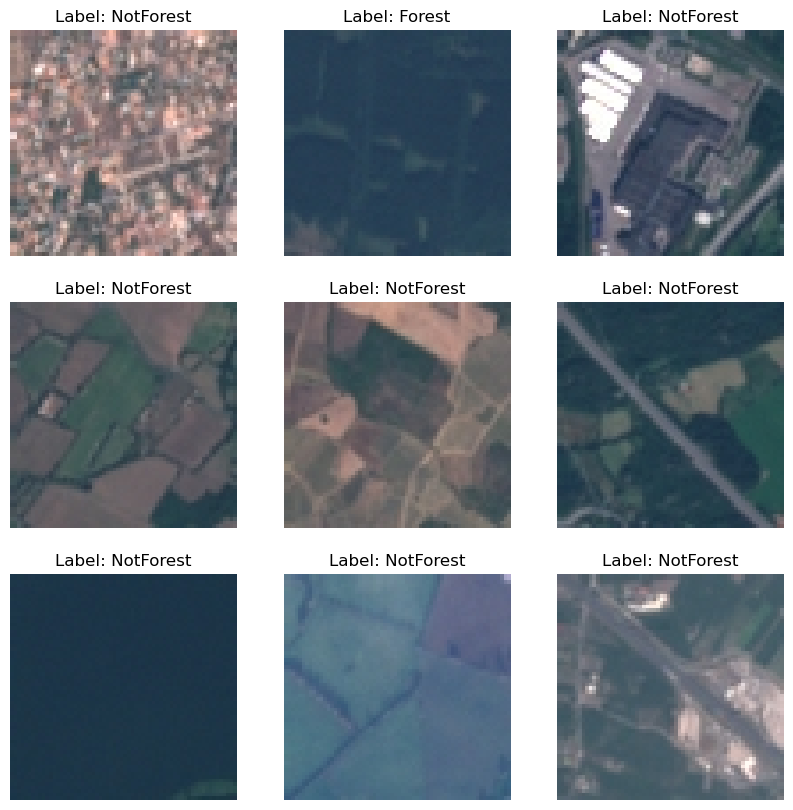

In [6]:
print("-"*20)
image_batch, label_batch = next(iter(train_dataset))
class_names = ['NotForest', 'Forest']
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # print(image_batch[i])
    image_arr = (image_batch[i].numpy() * 255).astype("uint8")
    plt.imshow(image_arr)
    plt.title("Label: {}".format(class_names[label_batch[i].numpy().item()]))
    plt.axis("off")
for features, label in train_dataset.take(1):
    print(label.numpy().mean())

In [7]:
val_loader = EuroSatLoader(csv_path = cfg.Path.val_df, 
                            image_folder = cfg.Path.image_folder,
                            batch_size = cfg.Dataset.batch_size,
                            img_size = cfg.Dataset.img_size,
                            buffer_size = cfg.Dataset.buffer_size, 
                            shuffle = False)
val_dataset = val_loader.get_dataset()

--------------------


0.125


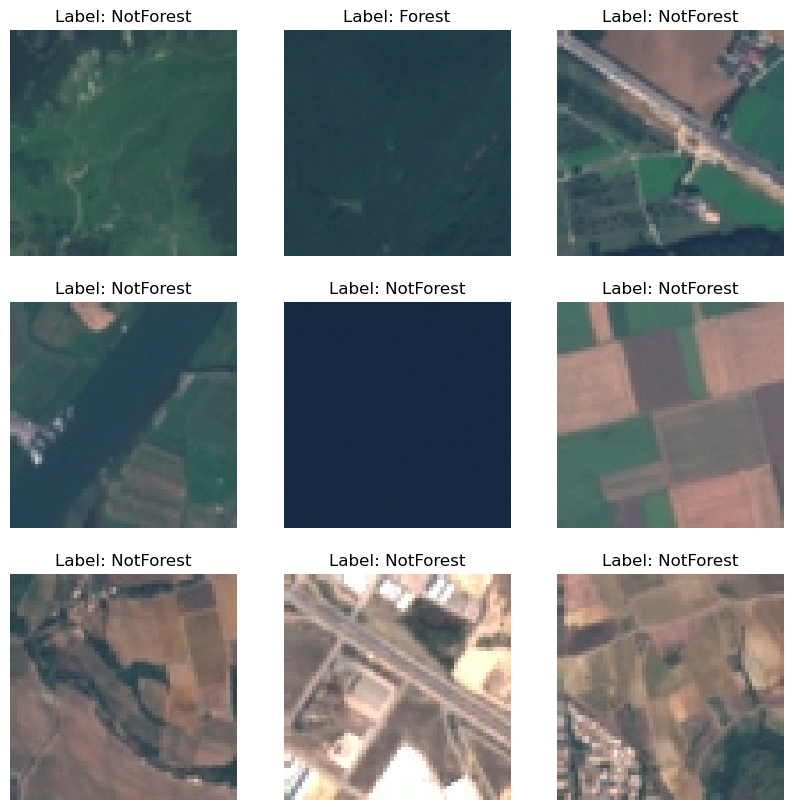

In [8]:
print("-"*20)
image_batch, label_batch = next(iter(val_dataset))
class_names = ['NotForest', 'Forest']
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # print(image_batch[i])
    image_arr = (image_batch[i].numpy() * 255).astype("uint8")
    plt.imshow(image_arr)
    plt.title("Label: {}".format(class_names[label_batch[i].numpy().item()]))
    plt.axis("off")
for features, label in val_dataset.take(1):
    print(label.numpy().mean())

In [9]:
test_loader = EuroSatLoader(csv_path = cfg.Path.test_df, 
                            image_folder = cfg.Path.image_folder,
                            batch_size = cfg.Dataset.batch_size,
                            img_size = cfg.Dataset.img_size,
                            buffer_size = cfg.Dataset.buffer_size, 
                            shuffle = False)
test_dataset = test_loader.get_dataset()

In [10]:
import tensorflow as tf
from sklearn.utils import class_weight

# Efficient net without augmentation4
class EfficientNetModel:
    metrics_names = ['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc', 'prc']
    METRICS = [
          tf.keras.metrics.TruePositives(name='tp'),
          tf.keras.metrics.FalsePositives(name='fp'),
          tf.keras.metrics.TrueNegatives(name='tn'),
          tf.keras.metrics.FalseNegatives(name='fn'), 
          tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall'),
          tf.keras.metrics.AUC(name='auc'),
          tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]
    
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal_and_vertical"),
            tf.keras.layers.RandomContrast(0.2),
            tf.keras.layers.RandomZoom(0.2),
            tf.keras.layers.RandomRotation(factor=0.15),
            tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
            tf.keras.layers.RandomContrast(factor=0.1),
            ],
            name="img_augmentation",
            )
        self.base_model = tf.keras.applications.efficientnet.EfficientNetB2(input_shape=self.input_shape, include_top=False, weights='imagenet')
        self.model = self.build_model()
        
    def build_model(self):
        inputs = tf.keras.layers.Input(shape=self.input_shape)
        x = self.data_augmentation(inputs)
        x = self.base_model(x)
        
        for layer in self.base_model.layers[:40]:  #-20
            # if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False
        
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        predictions = tf.keras.layers.Dense(self.num_classes, activation='sigmoid')(x)  # !!
        model = tf.keras.models.Model(inputs=inputs, outputs=predictions)
        return model
    
    def calculate_weights(self, y_train):
        """Calculate the weights for each class so that we can balance the data"""
        class_labels = np.unique(y_train)
        weight = class_weight.compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train)
        self.class_weights = dict(enumerate(weight))
        if DEBUG:
            print(self.class_weights)

     
    def compile(self, learning_rate = 0.0001):
        self.model.compile(optimizer=tf.keras.optimizers.Adam(
            learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=self.METRICS)  

    def train(self, train_data, val_data, epochs, batch_size, model_save_path, log_dir):
        # self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate =learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_prc', 
            verbose=1,
            patience=10,
            mode='max',
            restore_best_weights=True
        )
        checkpoint = tf.keras.callbacks.ModelCheckpoint(
            model_save_path,
            monitor='val_loss',
            mode='min',
            save_weights_only=True,
            save_best_only=True,
            verbose=1)
        ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(
            monitpr = 'val_loss',
            factor=0.1,
            patience=3,
            verbose=1)
        tensorboard = tf.keras.callbacks.TensorBoard(
            log_dir=log_dir,
            histogram_freq=1,
            write_graph=True,
            write_images=True)
        callbacks = [ReduceLR, early_stop, checkpoint, tensorboard]
        
        history = self.model.fit(train_data, 
                                 epochs=epochs,
                                 batch_size=batch_size, 
                                 validation_data=val_data, 
                                 callbacks=callbacks,
                                class_weight=self.class_weights)
        return history
    
    def evaluate(self, data):
        return self.model.evaluate(data)
    
    def predict(self, data):
        return self.model.predict(data)
    
    def summary(self):
        return self.model.summary()
    
    def save_model(self, filepath):
        self.model.save(filepath)
        
    def load_model(self, model_path):
        self.model.load_weights(model_path)
        
    def plot_model_architecture(self, file_path):
        tf.keras.utils.plot_model(self, to_file=file_path, show_shapes=True)
        


In [11]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

class ModelUtils:
    
    @staticmethod
    def plot_cm(y_true, y_pred, class_names,save_path, figsize=(5,5)):
        cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
        cm_sum = np.sum(cm, axis=1, keepdims=True)
        cm_perc = cm / cm_sum.astype(float) * 100
        annot = np.empty_like(cm).astype(str)
        nrows, ncols = cm.shape
        for i in range(nrows):
            for j in range(ncols):
                c = cm[i, j]
                p = cm_perc[i, j]
                if i == j:
                    s = cm_sum[i]
                    annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
                elif c == 0:
                    annot[i, j] = ''
                else:
                    annot[i, j] = '%.1f%%\n%d' % (p, c)
        # cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
        cm = pd.DataFrame(cm, index=[i for i in class_names],
                    columns = [i for i in class_names])
        
        cm.index.name = 'True label'
        cm.columns.name = 'Predicted label'
        fig, ax = plt.subplots(figsize=figsize)
        sns.heatmap(cm, annot=annot, fmt='', ax=ax)
        plt.savefig(save_path+'confusion_matrix.png')
    
    @staticmethod
    def plot_metrics(save_path, history):
        mpl.rcParams['figure.figsize'] = (12, 10)
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        metrics = ['loss', 'prc', 'precision', 'recall']
        for n, metric in enumerate(metrics):
            name = metric.replace("_"," ").capitalize()
            plt.subplot(2,2,n+1)
            plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
            plt.plot(history.epoch, history.history['val_'+metric],
                     color=colors[0], linestyle="--", label='Val')
            plt.xlabel('Epoch')
            plt.ylabel(name)
            if metric == 'loss':
                plt.ylim([0, plt.ylim()[1]])
            elif metric == 'auc':
                plt.ylim([0.8,1])
            else:
                plt.ylim([0,1])

            plt.legend();
        plt.savefig(save_path+'loss_accuracy_curve.png')
        plt.show()


In [12]:
# import os
# import shutil
# shutil.rmtree("/kaggle/working/weights")
# shutil.rmtree("/kaggle/working/Figures")
# shutil.rmtree("/kaggle/working/tensorboard")
# # os.remove("/kaggle/working/effnetb2.zip")

In [13]:
model = EfficientNetModel(input_shape = cfg.HyperParameter.input_shape, 
                num_classes = cfg.HyperParameter.num_classes)

print(f"INFO ===========Training Started===============")
model.compile(learning_rate= cfg.HyperParameter.learning_rate)
print(model.summary())
model.calculate_weights(train_loader.df.Label)

    8192/31790344 [..............................] - ETA: 0s

 5070848/31790344 [===>..........................] - ETA: 0s

 8396800/31790344 [======>.......................] - ETA: 0s

14548992/31790344 [============>.................] - ETA: 0s

22249472/31790344 [===================>..........] - ETA: 0s

29384704/31790344 [==========================>...] - ETA: 0s

31790344/31790344 [==============================] - 0s 0us/step


INFO ===========Training Started===============
Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         


 img_augmentation (Sequentia  (None, 64, 64, 3)        0         


 l)                                                              


 efficientnetb2 (Functional)  (None, 2, 2, 1408)       7768569   


 global_average_pooling2d (G  (None, 1408)             0         


 lobalAveragePooling2D)                                          


 dense (Dense)               (None, 1)                 1409      


Total params: 7,769,978


Trainable params: 7,696,243


Non-trainable params: 73,735


_________________________________________________________________


None


In [14]:
neg_count, pos_count = train_loader.get_neg_pos_count()
# if os.path.isfile(cfg.Path.model_save_path):
#     print("INFO ===========Running the Partially Trained Model===============")
#     #This code is implemented to load the partly trained model which was stopped due to some reason
#     model.load_model(cfg.Path.model_save_path)
#     history = model.train(train_data = train_dataset, 
#                       val_data = val_dataset,
#                       epochs = cfg.HyperParameter.epochs,
#                       steps_per_epoch=10,
#                       batch_size= cfg.HyperParameter.batch_size, 
#                       model_save_path= cfg.Path.model_save_path,
#                       log_dir=cfg.Path.tensorboard_logs_path)
# else:
print("INFO ===========Running the Training of Model from Scratch===============")
model.compile(learning_rate= cfg.HyperParameter.learning_rate)
history = model.train(train_data = train_dataset, 
                  val_data = val_dataset,
                  epochs = cfg.HyperParameter.epochs,
                  batch_size= cfg.HyperParameter.batch_size, 
                  model_save_path= cfg.Path.model_save_path,
                  log_dir=cfg.Path.tensorboard_logs_path)

print(f"INFO ===========Training Finished===============")

INFO ===========Running the Training of Model from Scratch===============


Epoch 1/1000


2023-04-02 20:43:14.363943: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetb2/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  1/296 [..............................] - ETA: 5:23:29 - loss: 0.6356 - tp: 2.0000 - fp: 22.0000 - tn: 37.0000 - fn: 3.0000 - accuracy: 0.6094 - precision: 0.0833 - recall: 0.4000 - auc: 0.5000 - prc: 0.0726

  2/296 [..............................] - ETA: 6:37 - loss: 0.5461 - tp: 2.0000 - fp: 48.0000 - tn: 74.0000 - fn: 4.0000 - accuracy: 0.5938 - precision: 0.0400 - recall: 0.3333 - auc: 0.4679 - prc: 0.0406   

  3/296 [..............................] - ETA: 6:25 - loss: 0.5773 - tp: 6.0000 - fp: 73.0000 - tn: 106.0000 - fn: 7.0000 - accuracy: 0.5833 - precision: 0.0759 - recall: 0.4615 - auc: 0.5780 - prc: 0.0731

  4/296 [..............................] - ETA: 6:25 - loss: 0.5901 - tp: 8.0000 - fp: 99.0000 - tn: 140.0000 - fn: 9.0000 - accuracy: 0.5781 - precision: 0.0748 - recall: 0.4706 - auc: 0.5493 - prc: 0.0713

  5/296 [..............................] - ETA: 7:30 - loss: 0.5743 - tp: 13.0000 - fp: 120.0000 - tn: 177.0000 - fn: 10.0000 - accuracy: 0.5938 - precision: 0.0977 - recall: 0.5652 - auc: 0.6188 - prc: 0.1079

  6/296 [..............................] - ETA: 7:16 - loss: 0.5933 - tp: 20.0000 - fp: 140.0000 - tn: 212.0000 - fn: 12.0000 - accuracy: 0.6042 - precision: 0.1250 - recall: 0.6250 - auc: 0.6447 - prc: 0.1290

  7/296 [..............................] - ETA: 7:05 - loss: 0.5787 - tp: 23.0000 - fp: 162.0000 - tn: 250.0000 - fn: 13.0000 - accuracy: 0.6094 - precision: 0.1243 - recall: 0.6389 - auc: 0.6595 - prc: 0.1311

  8/296 [..............................] - ETA: 6:57 - loss: 0.5766 - tp: 29.0000 - fp: 184.0000 - tn: 285.0000 - fn: 14.0000 - accuracy: 0.6133 - precision: 0.1362 - recall: 0.6744 - auc: 0.6822 - prc: 0.1675

  9/296 [..............................] - ETA: 6:51 - loss: 0.5803 - tp: 37.0000 - fp: 198.0000 - tn: 325.0000 - fn: 16.0000 - accuracy: 0.6285 - precision: 0.1574 - recall: 0.6981 - auc: 0.7066 - prc: 0.2209

 10/296 [>.............................] - ETA: 6:45 - loss: 0.5809 - tp: 45.0000 - fp: 214.0000 - tn: 362.0000 - fn: 19.0000 - accuracy: 0.6359 - precision: 0.1737 - recall: 0.7031 - auc: 0.7300 - prc: 0.2746

 11/296 [>.............................] - ETA: 6:40 - loss: 0.5642 - tp: 52.0000 - fp: 230.0000 - tn: 403.0000 - fn: 19.0000 - accuracy: 0.6463 - precision: 0.1844 - recall: 0.7324 - auc: 0.7573 - prc: 0.3230

 12/296 [>.............................] - ETA: 6:42 - loss: 0.5548 - tp: 57.0000 - fp: 246.0000 - tn: 444.0000 - fn: 21.0000 - accuracy: 0.6523 - precision: 0.1881 - recall: 0.7308 - auc: 0.7692 - prc: 0.3554

 13/296 [>.............................] - ETA: 6:38 - loss: 0.5514 - tp: 66.0000 - fp: 263.0000 - tn: 481.0000 - fn: 22.0000 - accuracy: 0.6575 - precision: 0.2006 - recall: 0.7500 - auc: 0.7841 - prc: 0.3785

 14/296 [>.............................] - ETA: 6:34 - loss: 0.5384 - tp: 75.0000 - fp: 273.0000 - tn: 526.0000 - fn: 22.0000 - accuracy: 0.6708 - precision: 0.2155 - recall: 0.7732 - auc: 0.8040 - prc: 0.4217

 15/296 [>.............................] - ETA: 6:30 - loss: 0.5366 - tp: 82.0000 - fp: 287.0000 - tn: 568.0000 - fn: 23.0000 - accuracy: 0.6771 - precision: 0.2222 - recall: 0.7810 - auc: 0.8100 - prc: 0.4107

 16/296 [>.............................] - ETA: 6:27 - loss: 0.5226 - tp: 88.0000 - fp: 300.0000 - tn: 613.0000 - fn: 23.0000 - accuracy: 0.6846 - precision: 0.2268 - recall: 0.7928 - auc: 0.8225 - prc: 0.4523

 17/296 [>.............................] - ETA: 6:25 - loss: 0.5168 - tp: 93.0000 - fp: 320.0000 - tn: 652.0000 - fn: 23.0000 - accuracy: 0.6847 - precision: 0.2252 - recall: 0.8017 - auc: 0.8275 - prc: 0.4471

 18/296 [>.............................] - ETA: 6:23 - loss: 0.5100 - tp: 97.0000 - fp: 338.0000 - tn: 694.0000 - fn: 23.0000 - accuracy: 0.6866 - precision: 0.2230 - recall: 0.8083 - auc: 0.8320 - prc: 0.4403

 19/296 [>.............................] - ETA: 6:21 - loss: 0.5051 - tp: 102.0000 - fp: 353.0000 - tn: 738.0000 - fn: 23.0000 - accuracy: 0.6908 - precision: 0.2242 - recall: 0.8160 - auc: 0.8364 - prc: 0.4353

 20/296 [=>............................] - ETA: 6:21 - loss: 0.5038 - tp: 106.0000 - fp: 370.0000 - tn: 780.0000 - fn: 24.0000 - accuracy: 0.6922 - precision: 0.2227 - recall: 0.8154 - auc: 0.8356 - prc: 0.4360

 21/296 [=>............................] - ETA: 6:20 - loss: 0.4966 - tp: 114.0000 - fp: 382.0000 - tn: 824.0000 - fn: 24.0000 - accuracy: 0.6979 - precision: 0.2298 - recall: 0.8261 - auc: 0.8448 - prc: 0.4567

 22/296 [=>............................] - ETA: 6:17 - loss: 0.4919 - tp: 119.0000 - fp: 398.0000 - tn: 867.0000 - fn: 24.0000 - accuracy: 0.7003 - precision: 0.2302 - recall: 0.8322 - auc: 0.8488 - prc: 0.4596

 23/296 [=>............................] - ETA: 6:14 - loss: 0.4909 - tp: 126.0000 - fp: 414.0000 - tn: 907.0000 - fn: 25.0000 - accuracy: 0.7018 - precision: 0.2333 - recall: 0.8344 - auc: 0.8500 - prc: 0.4758

 24/296 [=>............................] - ETA: 6:12 - loss: 0.4845 - tp: 131.0000 - fp: 427.0000 - tn: 953.0000 - fn: 25.0000 - accuracy: 0.7057 - precision: 0.2348 - recall: 0.8397 - auc: 0.8552 - prc: 0.4844

 25/296 [=>............................] - ETA: 6:10 - loss: 0.4826 - tp: 136.0000 - fp: 446.0000 - tn: 993.0000 - fn: 25.0000 - accuracy: 0.7056 - precision: 0.2337 - recall: 0.8447 - auc: 0.8573 - prc: 0.4759

 26/296 [=>............................] - ETA: 6:07 - loss: 0.4791 - tp: 142.0000 - fp: 460.0000 - tn: 1037.0000 - fn: 25.0000 - accuracy: 0.7085 - precision: 0.2359 - recall: 0.8503 - auc: 0.8607 - prc: 0.4825

 27/296 [=>............................] - ETA: 6:05 - loss: 0.4755 - tp: 144.0000 - fp: 477.0000 - tn: 1082.0000 - fn: 25.0000 - accuracy: 0.7095 - precision: 0.2319 - recall: 0.8521 - auc: 0.8613 - prc: 0.4794

 28/296 [=>............................] - ETA: 6:06 - loss: 0.4706 - tp: 149.0000 - fp: 492.0000 - tn: 1126.0000 - fn: 25.0000 - accuracy: 0.7115 - precision: 0.2324 - recall: 0.8563 - auc: 0.8652 - prc: 0.4866

 29/296 [=>............................] - ETA: 6:09 - loss: 0.4679 - tp: 152.0000 - fp: 512.0000 - tn: 1167.0000 - fn: 25.0000 - accuracy: 0.7107 - precision: 0.2289 - recall: 0.8588 - auc: 0.8664 - prc: 0.4832

 30/296 [==>...........................] - ETA: 6:07 - loss: 0.4646 - tp: 157.0000 - fp: 525.0000 - tn: 1213.0000 - fn: 25.0000 - accuracy: 0.7135 - precision: 0.2302 - recall: 0.8626 - auc: 0.8695 - prc: 0.4874

 31/296 [==>...........................] - ETA: 6:05 - loss: 0.4600 - tp: 164.0000 - fp: 537.0000 - tn: 1257.0000 - fn: 26.0000 - accuracy: 0.7162 - precision: 0.2340 - recall: 0.8632 - auc: 0.8741 - prc: 0.5044

 32/296 [==>...........................] - ETA: 6:03 - loss: 0.4567 - tp: 170.0000 - fp: 553.0000 - tn: 1299.0000 - fn: 26.0000 - accuracy: 0.7173 - precision: 0.2351 - recall: 0.8673 - auc: 0.8770 - prc: 0.5094

 33/296 [==>...........................] - ETA: 6:01 - loss: 0.4565 - tp: 175.0000 - fp: 566.0000 - tn: 1344.0000 - fn: 27.0000 - accuracy: 0.7192 - precision: 0.2362 - recall: 0.8663 - auc: 0.8763 - prc: 0.5134

 34/296 [==>...........................] - ETA: 5:58 - loss: 0.4533 - tp: 182.0000 - fp: 576.0000 - tn: 1390.0000 - fn: 28.0000 - accuracy: 0.7224 - precision: 0.2401 - recall: 0.8667 - auc: 0.8792 - prc: 0.5263

 35/296 [==>...........................] - ETA: 5:57 - loss: 0.4569 - tp: 190.0000 - fp: 588.0000 - tn: 1433.0000 - fn: 29.0000 - accuracy: 0.7246 - precision: 0.2442 - recall: 0.8676 - auc: 0.8769 - prc: 0.5269

 36/296 [==>...........................] - ETA: 5:55 - loss: 0.4543 - tp: 199.0000 - fp: 600.0000 - tn: 1475.0000 - fn: 30.0000 - accuracy: 0.7266 - precision: 0.2491 - recall: 0.8690 - auc: 0.8799 - prc: 0.5398

 37/296 [==>...........................] - ETA: 5:55 - loss: 0.4513 - tp: 203.0000 - fp: 618.0000 - tn: 1517.0000 - fn: 30.0000 - accuracy: 0.7264 - precision: 0.2473 - recall: 0.8712 - auc: 0.8816 - prc: 0.5404

 38/296 [==>...........................] - ETA: 5:54 - loss: 0.4517 - tp: 212.0000 - fp: 628.0000 - tn: 1560.0000 - fn: 32.0000 - accuracy: 0.7286 - precision: 0.2524 - recall: 0.8689 - auc: 0.8818 - prc: 0.5457

 39/296 [==>...........................] - ETA: 5:52 - loss: 0.4489 - tp: 215.0000 - fp: 646.0000 - tn: 1603.0000 - fn: 32.0000 - accuracy: 0.7284 - precision: 0.2497 - recall: 0.8704 - auc: 0.8832 - prc: 0.5450

 40/296 [===>..........................] - ETA: 5:50 - loss: 0.4479 - tp: 222.0000 - fp: 659.0000 - tn: 1646.0000 - fn: 33.0000 - accuracy: 0.7297 - precision: 0.2520 - recall: 0.8706 - auc: 0.8839 - prc: 0.5514

 41/296 [===>..........................] - ETA: 5:49 - loss: 0.4454 - tp: 225.0000 - fp: 674.0000 - tn: 1692.0000 - fn: 33.0000 - accuracy: 0.7306 - precision: 0.2503 - recall: 0.8721 - auc: 0.8852 - prc: 0.5520

 42/296 [===>..........................] - ETA: 5:46 - loss: 0.4429 - tp: 232.0000 - fp: 686.0000 - tn: 1737.0000 - fn: 33.0000 - accuracy: 0.7325 - precision: 0.2527 - recall: 0.8755 - auc: 0.8874 - prc: 0.5565

 43/296 [===>..........................] - ETA: 5:45 - loss: 0.4399 - tp: 240.0000 - fp: 698.0000 - tn: 1781.0000 - fn: 33.0000 - accuracy: 0.7344 - precision: 0.2559 - recall: 0.8791 - auc: 0.8901 - prc: 0.5648

 44/296 [===>..........................] - ETA: 5:43 - loss: 0.4376 - tp: 245.0000 - fp: 714.0000 - tn: 1824.0000 - fn: 33.0000 - accuracy: 0.7347 - precision: 0.2555 - recall: 0.8813 - auc: 0.8916 - prc: 0.5678

 45/296 [===>..........................] - ETA: 5:43 - loss: 0.4362 - tp: 252.0000 - fp: 726.0000 - tn: 1869.0000 - fn: 33.0000 - accuracy: 0.7365 - precision: 0.2577 - recall: 0.8842 - auc: 0.8933 - prc: 0.5649

 46/296 [===>..........................] - ETA: 5:41 - loss: 0.4331 - tp: 259.0000 - fp: 739.0000 - tn: 1913.0000 - fn: 33.0000 - accuracy: 0.7378 - precision: 0.2595 - recall: 0.8870 - auc: 0.8958 - prc: 0.5729

 47/296 [===>..........................] - ETA: 5:40 - loss: 0.4347 - tp: 262.0000 - fp: 756.0000 - tn: 1955.0000 - fn: 35.0000 - accuracy: 0.7370 - precision: 0.2574 - recall: 0.8822 - auc: 0.8939 - prc: 0.5642

 48/296 [===>..........................] - ETA: 5:38 - loss: 0.4319 - tp: 269.0000 - fp: 768.0000 - tn: 2000.0000 - fn: 35.0000 - accuracy: 0.7386 - precision: 0.2594 - recall: 0.8849 - auc: 0.8962 - prc: 0.5692

 49/296 [===>..........................] - ETA: 5:37 - loss: 0.4324 - tp: 278.0000 - fp: 778.0000 - tn: 2044.0000 - fn: 36.0000 - accuracy: 0.7404 - precision: 0.2633 - recall: 0.8854 - auc: 0.8965 - prc: 0.5641

 50/296 [====>.........................] - ETA: 5:35 - loss: 0.4300 - tp: 288.0000 - fp: 784.0000 - tn: 2092.0000 - fn: 36.0000 - accuracy: 0.7437 - precision: 0.2687 - recall: 0.8889 - auc: 0.8989 - prc: 0.5737

 51/296 [====>.........................] - ETA: 5:33 - loss: 0.4273 - tp: 296.0000 - fp: 796.0000 - tn: 2136.0000 - fn: 36.0000 - accuracy: 0.7451 - precision: 0.2711 - recall: 0.8916 - auc: 0.9011 - prc: 0.5818

 52/296 [====>.........................] - ETA: 5:35 - loss: 0.4253 - tp: 302.0000 - fp: 809.0000 - tn: 2181.0000 - fn: 36.0000 - accuracy: 0.7461 - precision: 0.2718 - recall: 0.8935 - auc: 0.9026 - prc: 0.5857

 53/296 [====>.........................] - ETA: 5:35 - loss: 0.4232 - tp: 308.0000 - fp: 821.0000 - tn: 2227.0000 - fn: 36.0000 - accuracy: 0.7473 - precision: 0.2728 - recall: 0.8953 - auc: 0.9041 - prc: 0.5896

 54/296 [====>.........................] - ETA: 5:33 - loss: 0.4216 - tp: 313.0000 - fp: 832.0000 - tn: 2275.0000 - fn: 36.0000 - accuracy: 0.7488 - precision: 0.2734 - recall: 0.8968 - auc: 0.9050 - prc: 0.5905

 55/296 [====>.........................] - ETA: 5:31 - loss: 0.4203 - tp: 318.0000 - fp: 848.0000 - tn: 2318.0000 - fn: 36.0000 - accuracy: 0.7489 - precision: 0.2727 - recall: 0.8983 - auc: 0.9059 - prc: 0.5929

 56/296 [====>.........................] - ETA: 5:30 - loss: 0.4163 - tp: 331.0000 - fp: 850.0000 - tn: 2367.0000 - fn: 36.0000 - accuracy: 0.7528 - precision: 0.2803 - recall: 0.9019 - auc: 0.9096 - prc: 0.6096

 57/296 [====>.........................] - ETA: 5:28 - loss: 0.4150 - tp: 336.0000 - fp: 863.0000 - tn: 2412.0000 - fn: 37.0000 - accuracy: 0.7533 - precision: 0.2802 - recall: 0.9008 - auc: 0.9101 - prc: 0.6125

 58/296 [====>.........................] - ETA: 5:26 - loss: 0.4136 - tp: 342.0000 - fp: 873.0000 - tn: 2460.0000 - fn: 37.0000 - accuracy: 0.7548 - precision: 0.2815 - recall: 0.9024 - auc: 0.9112 - prc: 0.6112

 59/296 [====>.........................] - ETA: 5:24 - loss: 0.4112 - tp: 348.0000 - fp: 887.0000 - tn: 2504.0000 - fn: 37.0000 - accuracy: 0.7553 - precision: 0.2818 - recall: 0.9039 - auc: 0.9128 - prc: 0.6170

 60/296 [=====>........................] - ETA: 5:23 - loss: 0.4094 - tp: 356.0000 - fp: 896.0000 - tn: 2551.0000 - fn: 37.0000 - accuracy: 0.7570 - precision: 0.2843 - recall: 0.9059 - auc: 0.9143 - prc: 0.6200

 61/296 [=====>........................] - ETA: 5:22 - loss: 0.4073 - tp: 364.0000 - fp: 906.0000 - tn: 2597.0000 - fn: 37.0000 - accuracy: 0.7585 - precision: 0.2866 - recall: 0.9077 - auc: 0.9159 - prc: 0.6247

 62/296 [=====>........................] - ETA: 5:21 - loss: 0.4053 - tp: 369.0000 - fp: 919.0000 - tn: 2643.0000 - fn: 37.0000 - accuracy: 0.7591 - precision: 0.2865 - recall: 0.9089 - auc: 0.9170 - prc: 0.6292

 63/296 [=====>........................] - ETA: 5:19 - loss: 0.4059 - tp: 373.0000 - fp: 934.0000 - tn: 2687.0000 - fn: 38.0000 - accuracy: 0.7589 - precision: 0.2854 - recall: 0.9075 - auc: 0.9163 - prc: 0.6208

 64/296 [=====>........................] - ETA: 5:18 - loss: 0.4063 - tp: 381.0000 - fp: 946.0000 - tn: 2730.0000 - fn: 39.0000 - accuracy: 0.7595 - precision: 0.2871 - recall: 0.9071 - auc: 0.9158 - prc: 0.6259

 65/296 [=====>........................] - ETA: 5:16 - loss: 0.4038 - tp: 393.0000 - fp: 951.0000 - tn: 2777.0000 - fn: 39.0000 - accuracy: 0.7620 - precision: 0.2924 - recall: 0.9097 - auc: 0.9179 - prc: 0.6351

 66/296 [=====>........................] - ETA: 5:14 - loss: 0.4024 - tp: 398.0000 - fp: 962.0000 - tn: 2825.0000 - fn: 39.0000 - accuracy: 0.7630 - precision: 0.2926 - recall: 0.9108 - auc: 0.9187 - prc: 0.6356

 67/296 [=====>........................] - ETA: 5:13 - loss: 0.4007 - tp: 404.0000 - fp: 973.0000 - tn: 2872.0000 - fn: 39.0000 - accuracy: 0.7640 - precision: 0.2934 - recall: 0.9120 - auc: 0.9197 - prc: 0.6385

 68/296 [=====>........................] - ETA: 5:11 - loss: 0.3996 - tp: 410.0000 - fp: 983.0000 - tn: 2920.0000 - fn: 39.0000 - accuracy: 0.7652 - precision: 0.2943 - recall: 0.9131 - auc: 0.9203 - prc: 0.6405

 69/296 [=====>........................] - ETA: 5:10 - loss: 0.3981 - tp: 414.0000 - fp: 993.0000 - tn: 2970.0000 - fn: 39.0000 - accuracy: 0.7663 - precision: 0.2942 - recall: 0.9139 - auc: 0.9210 - prc: 0.6399

 70/296 [======>.......................] - ETA: 5:09 - loss: 0.4036 - tp: 426.0000 - fp: 1002.0000 - tn: 3010.0000 - fn: 42.0000 - accuracy: 0.7670 - precision: 0.2983 - recall: 0.9103 - auc: 0.9170 - prc: 0.6321

 71/296 [======>.......................] - ETA: 5:07 - loss: 0.4033 - tp: 428.0000 - fp: 1012.0000 - tn: 3062.0000 - fn: 42.0000 - accuracy: 0.7680 - precision: 0.2972 - recall: 0.9106 - auc: 0.9171 - prc: 0.6224

 72/296 [======>.......................] - ETA: 5:06 - loss: 0.4011 - tp: 438.0000 - fp: 1018.0000 - tn: 3110.0000 - fn: 42.0000 - accuracy: 0.7700 - precision: 0.3008 - recall: 0.9125 - auc: 0.9187 - prc: 0.6293

 73/296 [======>.......................] - ETA: 5:04 - loss: 0.3990 - tp: 444.0000 - fp: 1029.0000 - tn: 3157.0000 - fn: 42.0000 - accuracy: 0.7708 - precision: 0.3014 - recall: 0.9136 - auc: 0.9198 - prc: 0.6347

 74/296 [======>.......................] - ETA: 5:03 - loss: 0.3978 - tp: 453.0000 - fp: 1036.0000 - tn: 3205.0000 - fn: 42.0000 - accuracy: 0.7724 - precision: 0.3042 - recall: 0.9152 - auc: 0.9208 - prc: 0.6376

 75/296 [======>.......................] - ETA: 5:03 - loss: 0.3963 - tp: 458.0000 - fp: 1047.0000 - tn: 3253.0000 - fn: 42.0000 - accuracy: 0.7731 - precision: 0.3043 - recall: 0.9160 - auc: 0.9215 - prc: 0.6406

 76/296 [======>.......................] - ETA: 5:02 - loss: 0.3965 - tp: 468.0000 - fp: 1056.0000 - tn: 3296.0000 - fn: 44.0000 - accuracy: 0.7738 - precision: 0.3071 - recall: 0.9141 - auc: 0.9213 - prc: 0.6445

 77/296 [======>.......................] - ETA: 5:01 - loss: 0.3955 - tp: 474.0000 - fp: 1070.0000 - tn: 3340.0000 - fn: 44.0000 - accuracy: 0.7739 - precision: 0.3070 - recall: 0.9151 - auc: 0.9219 - prc: 0.6438

 78/296 [======>.......................] - ETA: 5:00 - loss: 0.3948 - tp: 475.0000 - fp: 1085.0000 - tn: 3388.0000 - fn: 44.0000 - accuracy: 0.7738 - precision: 0.3045 - recall: 0.9152 - auc: 0.9219 - prc: 0.6406

 79/296 [=======>......................] - ETA: 4:58 - loss: 0.3943 - tp: 479.0000 - fp: 1097.0000 - tn: 3435.0000 - fn: 45.0000 - accuracy: 0.7741 - precision: 0.3039 - recall: 0.9141 - auc: 0.9220 - prc: 0.6409

 80/296 [=======>......................] - ETA: 4:56 - loss: 0.3928 - tp: 487.0000 - fp: 1102.0000 - tn: 3486.0000 - fn: 45.0000 - accuracy: 0.7760 - precision: 0.3065 - recall: 0.9154 - auc: 0.9229 - prc: 0.6442

 81/296 [=======>......................] - ETA: 4:55 - loss: 0.3930 - tp: 490.0000 - fp: 1115.0000 - tn: 3533.0000 - fn: 46.0000 - accuracy: 0.7760 - precision: 0.3053 - recall: 0.9142 - auc: 0.9224 - prc: 0.6428

 82/296 [=======>......................] - ETA: 4:53 - loss: 0.3926 - tp: 498.0000 - fp: 1122.0000 - tn: 3582.0000 - fn: 46.0000 - accuracy: 0.7774 - precision: 0.3074 - recall: 0.9154 - auc: 0.9228 - prc: 0.6433

 83/296 [=======>......................] - ETA: 4:52 - loss: 0.3910 - tp: 509.0000 - fp: 1131.0000 - tn: 3626.0000 - fn: 46.0000 - accuracy: 0.7784 - precision: 0.3104 - recall: 0.9171 - auc: 0.9240 - prc: 0.6482

 84/296 [=======>......................] - ETA: 4:50 - loss: 0.3911 - tp: 514.0000 - fp: 1145.0000 - tn: 3670.0000 - fn: 47.0000 - accuracy: 0.7783 - precision: 0.3098 - recall: 0.9162 - auc: 0.9237 - prc: 0.6476

 85/296 [=======>......................] - ETA: 4:50 - loss: 0.3901 - tp: 520.0000 - fp: 1158.0000 - tn: 3715.0000 - fn: 47.0000 - accuracy: 0.7785 - precision: 0.3099 - recall: 0.9171 - auc: 0.9242 - prc: 0.6478

 86/296 [=======>......................] - ETA: 4:48 - loss: 0.3883 - tp: 528.0000 - fp: 1166.0000 - tn: 3763.0000 - fn: 47.0000 - accuracy: 0.7796 - precision: 0.3117 - recall: 0.9183 - auc: 0.9253 - prc: 0.6524

 87/296 [=======>......................] - ETA: 4:47 - loss: 0.3873 - tp: 535.0000 - fp: 1176.0000 - tn: 3810.0000 - fn: 47.0000 - accuracy: 0.7804 - precision: 0.3127 - recall: 0.9192 - auc: 0.9259 - prc: 0.6525

 88/296 [=======>......................] - ETA: 4:45 - loss: 0.3859 - tp: 540.0000 - fp: 1183.0000 - tn: 3862.0000 - fn: 47.0000 - accuracy: 0.7816 - precision: 0.3134 - recall: 0.9199 - auc: 0.9266 - prc: 0.6544

 89/296 [========>.....................] - ETA: 4:44 - loss: 0.3862 - tp: 550.0000 - fp: 1188.0000 - tn: 3910.0000 - fn: 48.0000 - accuracy: 0.7830 - precision: 0.3165 - recall: 0.9197 - auc: 0.9262 - prc: 0.6563

 90/296 [========>.....................] - ETA: 4:42 - loss: 0.3847 - tp: 559.0000 - fp: 1196.0000 - tn: 3957.0000 - fn: 48.0000 - accuracy: 0.7840 - precision: 0.3185 - recall: 0.9209 - auc: 0.9272 - prc: 0.6595

 91/296 [========>.....................] - ETA: 4:41 - loss: 0.3834 - tp: 566.0000 - fp: 1204.0000 - tn: 4006.0000 - fn: 48.0000 - accuracy: 0.7850 - precision: 0.3198 - recall: 0.9218 - auc: 0.9279 - prc: 0.6613

 92/296 [========>.....................] - ETA: 4:39 - loss: 0.3822 - tp: 576.0000 - fp: 1212.0000 - tn: 4052.0000 - fn: 48.0000 - accuracy: 0.7860 - precision: 0.3221 - recall: 0.9231 - auc: 0.9286 - prc: 0.6652

 93/296 [========>.....................] - ETA: 4:38 - loss: 0.3818 - tp: 581.0000 - fp: 1223.0000 - tn: 4100.0000 - fn: 48.0000 - accuracy: 0.7865 - precision: 0.3221 - recall: 0.9237 - auc: 0.9289 - prc: 0.6600

 94/296 [========>.....................] - ETA: 4:37 - loss: 0.3813 - tp: 590.0000 - fp: 1236.0000 - tn: 4142.0000 - fn: 48.0000 - accuracy: 0.7866 - precision: 0.3231 - recall: 0.9248 - auc: 0.9293 - prc: 0.6602

 95/296 [========>.....................] - ETA: 4:35 - loss: 0.3806 - tp: 594.0000 - fp: 1251.0000 - tn: 4187.0000 - fn: 48.0000 - accuracy: 0.7863 - precision: 0.3220 - recall: 0.9252 - auc: 0.9296 - prc: 0.6581

 96/296 [========>.....................] - ETA: 4:34 - loss: 0.3796 - tp: 601.0000 - fp: 1260.0000 - tn: 4235.0000 - fn: 48.0000 - accuracy: 0.7871 - precision: 0.3229 - recall: 0.9260 - auc: 0.9301 - prc: 0.6604

 97/296 [========>.....................] - ETA: 4:32 - loss: 0.3792 - tp: 607.0000 - fp: 1273.0000 - tn: 4280.0000 - fn: 48.0000 - accuracy: 0.7872 - precision: 0.3229 - recall: 0.9267 - auc: 0.9303 - prc: 0.6604

 98/296 [========>.....................] - ETA: 4:32 - loss: 0.3785 - tp: 617.0000 - fp: 1282.0000 - tn: 4325.0000 - fn: 48.0000 - accuracy: 0.7879 - precision: 0.3249 - recall: 0.9278 - auc: 0.9310 - prc: 0.6599

 99/296 [=========>....................] - ETA: 4:30 - loss: 0.3787 - tp: 622.0000 - fp: 1294.0000 - tn: 4371.0000 - fn: 49.0000 - accuracy: 0.7880 - precision: 0.3246 - recall: 0.9270 - auc: 0.9305 - prc: 0.6590

100/296 [=========>....................] - ETA: 4:29 - loss: 0.3789 - tp: 632.0000 - fp: 1303.0000 - tn: 4416.0000 - fn: 49.0000 - accuracy: 0.7887 - precision: 0.3266 - recall: 0.9280 - auc: 0.9305 - prc: 0.6591

101/296 [=========>....................] - ETA: 4:28 - loss: 0.3773 - tp: 640.0000 - fp: 1313.0000 - tn: 4462.0000 - fn: 49.0000 - accuracy: 0.7893 - precision: 0.3277 - recall: 0.9289 - auc: 0.9314 - prc: 0.6635

102/296 [=========>....................] - ETA: 4:26 - loss: 0.3757 - tp: 650.0000 - fp: 1319.0000 - tn: 4510.0000 - fn: 49.0000 - accuracy: 0.7904 - precision: 0.3301 - recall: 0.9299 - auc: 0.9323 - prc: 0.6682

103/296 [=========>....................] - ETA: 4:25 - loss: 0.3755 - tp: 654.0000 - fp: 1333.0000 - tn: 4556.0000 - fn: 49.0000 - accuracy: 0.7904 - precision: 0.3291 - recall: 0.9303 - auc: 0.9323 - prc: 0.6681

104/296 [=========>....................] - ETA: 4:23 - loss: 0.3746 - tp: 661.0000 - fp: 1345.0000 - tn: 4601.0000 - fn: 49.0000 - accuracy: 0.7906 - precision: 0.3295 - recall: 0.9310 - auc: 0.9328 - prc: 0.6704

105/296 [=========>....................] - ETA: 4:22 - loss: 0.3742 - tp: 671.0000 - fp: 1352.0000 - tn: 4648.0000 - fn: 49.0000 - accuracy: 0.7915 - precision: 0.3317 - recall: 0.9319 - auc: 0.9330 - prc: 0.6719

106/296 [=========>....................] - ETA: 4:20 - loss: 0.3734 - tp: 680.0000 - fp: 1360.0000 - tn: 4695.0000 - fn: 49.0000 - accuracy: 0.7923 - precision: 0.3333 - recall: 0.9328 - auc: 0.9336 - prc: 0.6715

107/296 [=========>....................] - ETA: 4:19 - loss: 0.3722 - tp: 687.0000 - fp: 1368.0000 - tn: 4743.0000 - fn: 50.0000 - accuracy: 0.7929 - precision: 0.3343 - recall: 0.9322 - auc: 0.9341 - prc: 0.6748

108/296 [=========>....................] - ETA: 4:17 - loss: 0.3705 - tp: 696.0000 - fp: 1374.0000 - tn: 4792.0000 - fn: 50.0000 - accuracy: 0.7940 - precision: 0.3362 - recall: 0.9330 - auc: 0.9350 - prc: 0.6799

109/296 [==========>...................] - ETA: 4:16 - loss: 0.3695 - tp: 702.0000 - fp: 1384.0000 - tn: 4840.0000 - fn: 50.0000 - accuracy: 0.7944 - precision: 0.3365 - recall: 0.9335 - auc: 0.9354 - prc: 0.6820

110/296 [==========>...................] - ETA: 4:15 - loss: 0.3676 - tp: 712.0000 - fp: 1387.0000 - tn: 4891.0000 - fn: 50.0000 - accuracy: 0.7959 - precision: 0.3392 - recall: 0.9344 - auc: 0.9365 - prc: 0.6876

111/296 [==========>...................] - ETA: 4:13 - loss: 0.3665 - tp: 718.0000 - fp: 1399.0000 - tn: 4937.0000 - fn: 50.0000 - accuracy: 0.7960 - precision: 0.3392 - recall: 0.9349 - auc: 0.9370 - prc: 0.6894

112/296 [==========>...................] - ETA: 4:12 - loss: 0.3672 - tp: 724.0000 - fp: 1410.0000 - tn: 4983.0000 - fn: 51.0000 - accuracy: 0.7962 - precision: 0.3393 - recall: 0.9342 - auc: 0.9367 - prc: 0.6833

113/296 [==========>...................] - ETA: 4:10 - loss: 0.3667 - tp: 733.0000 - fp: 1415.0000 - tn: 5032.0000 - fn: 52.0000 - accuracy: 0.7972 - precision: 0.3412 - recall: 0.9338 - auc: 0.9369 - prc: 0.6839

114/296 [==========>...................] - ETA: 4:09 - loss: 0.3658 - tp: 741.0000 - fp: 1425.0000 - tn: 5078.0000 - fn: 52.0000 - accuracy: 0.7976 - precision: 0.3421 - recall: 0.9344 - auc: 0.9374 - prc: 0.6859

115/296 [==========>...................] - ETA: 4:07 - loss: 0.3652 - tp: 751.0000 - fp: 1433.0000 - tn: 5124.0000 - fn: 52.0000 - accuracy: 0.7982 - precision: 0.3439 - recall: 0.9352 - auc: 0.9378 - prc: 0.6872

116/296 [==========>...................] - ETA: 4:06 - loss: 0.3653 - tp: 759.0000 - fp: 1443.0000 - tn: 5169.0000 - fn: 53.0000 - accuracy: 0.7985 - precision: 0.3447 - recall: 0.9347 - auc: 0.9376 - prc: 0.6877

117/296 [==========>...................] - ETA: 4:05 - loss: 0.3643 - tp: 764.0000 - fp: 1453.0000 - tn: 5218.0000 - fn: 53.0000 - accuracy: 0.7989 - precision: 0.3446 - recall: 0.9351 - auc: 0.9381 - prc: 0.6887

118/296 [==========>...................] - ETA: 4:03 - loss: 0.3633 - tp: 771.0000 - fp: 1465.0000 - tn: 5263.0000 - fn: 53.0000 - accuracy: 0.7990 - precision: 0.3448 - recall: 0.9357 - auc: 0.9385 - prc: 0.6902

119/296 [===========>..................] - ETA: 4:01 - loss: 0.3625 - tp: 783.0000 - fp: 1470.0000 - tn: 5309.0000 - fn: 54.0000 - accuracy: 0.7999 - precision: 0.3475 - recall: 0.9355 - auc: 0.9390 - prc: 0.6916

120/296 [===========>..................] - ETA: 4:00 - loss: 0.3613 - tp: 788.0000 - fp: 1477.0000 - tn: 5361.0000 - fn: 54.0000 - accuracy: 0.8007 - precision: 0.3479 - recall: 0.9359 - auc: 0.9395 - prc: 0.6942

121/296 [===========>..................] - ETA: 4:00 - loss: 0.3605 - tp: 796.0000 - fp: 1485.0000 - tn: 5409.0000 - fn: 54.0000 - accuracy: 0.8013 - precision: 0.3490 - recall: 0.9365 - auc: 0.9400 - prc: 0.6944

122/296 [===========>..................] - ETA: 3:58 - loss: 0.3598 - tp: 804.0000 - fp: 1496.0000 - tn: 5454.0000 - fn: 54.0000 - accuracy: 0.8015 - precision: 0.3496 - recall: 0.9371 - auc: 0.9403 - prc: 0.6955

123/296 [===========>..................] - ETA: 3:56 - loss: 0.3586 - tp: 811.0000 - fp: 1506.0000 - tn: 5501.0000 - fn: 54.0000 - accuracy: 0.8018 - precision: 0.3500 - recall: 0.9376 - auc: 0.9409 - prc: 0.6987

124/296 [===========>..................] - ETA: 3:55 - loss: 0.3583 - tp: 818.0000 - fp: 1515.0000 - tn: 5549.0000 - fn: 54.0000 - accuracy: 0.8023 - precision: 0.3506 - recall: 0.9381 - auc: 0.9410 - prc: 0.6967

125/296 [===========>..................] - ETA: 3:54 - loss: 0.3573 - tp: 823.0000 - fp: 1523.0000 - tn: 5600.0000 - fn: 54.0000 - accuracy: 0.8029 - precision: 0.3508 - recall: 0.9384 - auc: 0.9414 - prc: 0.6984

126/296 [===========>..................] - ETA: 3:52 - loss: 0.3571 - tp: 827.0000 - fp: 1533.0000 - tn: 5650.0000 - fn: 54.0000 - accuracy: 0.8032 - precision: 0.3504 - recall: 0.9387 - auc: 0.9415 - prc: 0.6968

127/296 [===========>..................] - ETA: 3:51 - loss: 0.3563 - tp: 835.0000 - fp: 1539.0000 - tn: 5699.0000 - fn: 55.0000 - accuracy: 0.8039 - precision: 0.3517 - recall: 0.9382 - auc: 0.9417 - prc: 0.6994

128/296 [===========>..................] - ETA: 3:50 - loss: 0.3557 - tp: 841.0000 - fp: 1547.0000 - tn: 5749.0000 - fn: 55.0000 - accuracy: 0.8044 - precision: 0.3522 - recall: 0.9386 - auc: 0.9419 - prc: 0.6994

129/296 [============>.................] - ETA: 3:48 - loss: 0.3544 - tp: 848.0000 - fp: 1553.0000 - tn: 5800.0000 - fn: 55.0000 - accuracy: 0.8052 - precision: 0.3532 - recall: 0.9391 - auc: 0.9425 - prc: 0.7018

130/296 [============>.................] - ETA: 3:47 - loss: 0.3541 - tp: 855.0000 - fp: 1562.0000 - tn: 5847.0000 - fn: 56.0000 - accuracy: 0.8055 - precision: 0.3537 - recall: 0.9385 - auc: 0.9425 - prc: 0.7028

131/296 [============>.................] - ETA: 3:45 - loss: 0.3539 - tp: 859.0000 - fp: 1577.0000 - tn: 5892.0000 - fn: 56.0000 - accuracy: 0.8052 - precision: 0.3526 - recall: 0.9388 - auc: 0.9425 - prc: 0.7021

132/296 [============>.................] - ETA: 3:44 - loss: 0.3534 - tp: 865.0000 - fp: 1586.0000 - tn: 5941.0000 - fn: 56.0000 - accuracy: 0.8056 - precision: 0.3529 - recall: 0.9392 - auc: 0.9427 - prc: 0.7020

133/296 [============>.................] - ETA: 3:43 - loss: 0.3523 - tp: 872.0000 - fp: 1594.0000 - tn: 5990.0000 - fn: 56.0000 - accuracy: 0.8062 - precision: 0.3536 - recall: 0.9397 - auc: 0.9432 - prc: 0.7045

134/296 [============>.................] - ETA: 3:41 - loss: 0.3522 - tp: 875.0000 - fp: 1603.0000 - tn: 6041.0000 - fn: 57.0000 - accuracy: 0.8064 - precision: 0.3531 - recall: 0.9388 - auc: 0.9431 - prc: 0.7031

135/296 [============>.................] - ETA: 3:40 - loss: 0.3519 - tp: 883.0000 - fp: 1607.0000 - tn: 6091.0000 - fn: 59.0000 - accuracy: 0.8072 - precision: 0.3546 - recall: 0.9374 - auc: 0.9430 - prc: 0.7046

136/296 [============>.................] - ETA: 3:38 - loss: 0.3513 - tp: 890.0000 - fp: 1616.0000 - tn: 6139.0000 - fn: 59.0000 - accuracy: 0.8076 - precision: 0.3551 - recall: 0.9378 - auc: 0.9432 - prc: 0.7049

137/296 [============>.................] - ETA: 3:37 - loss: 0.3504 - tp: 895.0000 - fp: 1622.0000 - tn: 6192.0000 - fn: 59.0000 - accuracy: 0.8083 - precision: 0.3556 - recall: 0.9382 - auc: 0.9436 - prc: 0.7054

138/296 [============>.................] - ETA: 3:36 - loss: 0.3505 - tp: 900.0000 - fp: 1633.0000 - tn: 6240.0000 - fn: 59.0000 - accuracy: 0.8084 - precision: 0.3553 - recall: 0.9385 - auc: 0.9435 - prc: 0.7037

139/296 [=============>................] - ETA: 3:34 - loss: 0.3500 - tp: 907.0000 - fp: 1641.0000 - tn: 6288.0000 - fn: 60.0000 - accuracy: 0.8088 - precision: 0.3560 - recall: 0.9380 - auc: 0.9437 - prc: 0.7052

140/296 [=============>................] - ETA: 3:33 - loss: 0.3499 - tp: 913.0000 - fp: 1651.0000 - tn: 6336.0000 - fn: 60.0000 - accuracy: 0.8090 - precision: 0.3561 - recall: 0.9383 - auc: 0.9436 - prc: 0.7040

141/296 [=============>................] - ETA: 3:32 - loss: 0.3490 - tp: 918.0000 - fp: 1662.0000 - tn: 6384.0000 - fn: 60.0000 - accuracy: 0.8092 - precision: 0.3558 - recall: 0.9387 - auc: 0.9440 - prc: 0.7055

142/296 [=============>................] - ETA: 3:30 - loss: 0.3487 - tp: 926.0000 - fp: 1671.0000 - tn: 6430.0000 - fn: 61.0000 - accuracy: 0.8094 - precision: 0.3566 - recall: 0.9382 - auc: 0.9441 - prc: 0.7069

143/296 [=============>................] - ETA: 3:29 - loss: 0.3477 - tp: 937.0000 - fp: 1674.0000 - tn: 6480.0000 - fn: 61.0000 - accuracy: 0.8104 - precision: 0.3589 - recall: 0.9389 - auc: 0.9446 - prc: 0.7093

144/296 [=============>................] - ETA: 3:28 - loss: 0.3478 - tp: 942.0000 - fp: 1686.0000 - tn: 6526.0000 - fn: 62.0000 - accuracy: 0.8103 - precision: 0.3584 - recall: 0.9382 - auc: 0.9443 - prc: 0.7096

145/296 [=============>................] - ETA: 3:26 - loss: 0.3472 - tp: 948.0000 - fp: 1696.0000 - tn: 6574.0000 - fn: 62.0000 - accuracy: 0.8106 - precision: 0.3585 - recall: 0.9386 - auc: 0.9445 - prc: 0.7099

146/296 [=============>................] - ETA: 3:25 - loss: 0.3469 - tp: 956.0000 - fp: 1706.0000 - tn: 6620.0000 - fn: 62.0000 - accuracy: 0.8108 - precision: 0.3591 - recall: 0.9391 - auc: 0.9447 - prc: 0.7099

147/296 [=============>................] - ETA: 3:24 - loss: 0.3457 - tp: 963.0000 - fp: 1710.0000 - tn: 6673.0000 - fn: 62.0000 - accuracy: 0.8116 - precision: 0.3603 - recall: 0.9395 - auc: 0.9452 - prc: 0.7120

148/296 [==============>...............] - ETA: 3:22 - loss: 0.3446 - tp: 970.0000 - fp: 1714.0000 - tn: 6726.0000 - fn: 62.0000 - accuracy: 0.8125 - precision: 0.3614 - recall: 0.9399 - auc: 0.9456 - prc: 0.7144

149/296 [==============>...............] - ETA: 3:21 - loss: 0.3443 - tp: 974.0000 - fp: 1722.0000 - tn: 6777.0000 - fn: 63.0000 - accuracy: 0.8128 - precision: 0.3613 - recall: 0.9392 - auc: 0.9456 - prc: 0.7147

150/296 [==============>...............] - ETA: 3:20 - loss: 0.3435 - tp: 979.0000 - fp: 1732.0000 - tn: 6826.0000 - fn: 63.0000 - accuracy: 0.8130 - precision: 0.3611 - recall: 0.9395 - auc: 0.9460 - prc: 0.7164

151/296 [==============>...............] - ETA: 3:18 - loss: 0.3430 - tp: 983.0000 - fp: 1743.0000 - tn: 6875.0000 - fn: 63.0000 - accuracy: 0.8131 - precision: 0.3606 - recall: 0.9398 - auc: 0.9461 - prc: 0.7167

152/296 [==============>...............] - ETA: 3:17 - loss: 0.3427 - tp: 986.0000 - fp: 1758.0000 - tn: 6921.0000 - fn: 63.0000 - accuracy: 0.8128 - precision: 0.3593 - recall: 0.9399 - auc: 0.9462 - prc: 0.7164

153/296 [==============>...............] - ETA: 3:15 - loss: 0.3420 - tp: 996.0000 - fp: 1765.0000 - tn: 6968.0000 - fn: 63.0000 - accuracy: 0.8133 - precision: 0.3607 - recall: 0.9405 - auc: 0.9465 - prc: 0.7180

154/296 [==============>...............] - ETA: 3:14 - loss: 0.3412 - tp: 1000.0000 - fp: 1775.0000 - tn: 7018.0000 - fn: 63.0000 - accuracy: 0.8135 - precision: 0.3604 - recall: 0.9407 - auc: 0.9468 - prc: 0.7194

155/296 [==============>...............] - ETA: 3:12 - loss: 0.3405 - tp: 1010.0000 - fp: 1783.0000 - tn: 7064.0000 - fn: 63.0000 - accuracy: 0.8139 - precision: 0.3616 - recall: 0.9413 - auc: 0.9471 - prc: 0.7214

156/296 [==============>...............] - ETA: 3:11 - loss: 0.3403 - tp: 1013.0000 - fp: 1793.0000 - tn: 7114.0000 - fn: 64.0000 - accuracy: 0.8140 - precision: 0.3610 - recall: 0.9406 - auc: 0.9471 - prc: 0.7213

157/296 [==============>...............] - ETA: 3:10 - loss: 0.3399 - tp: 1017.0000 - fp: 1805.0000 - tn: 7162.0000 - fn: 64.0000 - accuracy: 0.8140 - precision: 0.3604 - recall: 0.9408 - auc: 0.9471 - prc: 0.7213

158/296 [===============>..............] - ETA: 3:08 - loss: 0.3392 - tp: 1024.0000 - fp: 1812.0000 - tn: 7212.0000 - fn: 64.0000 - accuracy: 0.8145 - precision: 0.3611 - recall: 0.9412 - auc: 0.9474 - prc: 0.7226

159/296 [===============>..............] - ETA: 3:07 - loss: 0.3386 - tp: 1031.0000 - fp: 1816.0000 - tn: 7265.0000 - fn: 64.0000 - accuracy: 0.8153 - precision: 0.3621 - recall: 0.9416 - auc: 0.9476 - prc: 0.7235

160/296 [===============>..............] - ETA: 3:06 - loss: 0.3383 - tp: 1041.0000 - fp: 1822.0000 - tn: 7312.0000 - fn: 65.0000 - accuracy: 0.8157 - precision: 0.3636 - recall: 0.9412 - auc: 0.9477 - prc: 0.7247

161/296 [===============>..............] - ETA: 3:04 - loss: 0.3379 - tp: 1048.0000 - fp: 1829.0000 - tn: 7362.0000 - fn: 65.0000 - accuracy: 0.8162 - precision: 0.3643 - recall: 0.9416 - auc: 0.9479 - prc: 0.7244

162/296 [===============>..............] - ETA: 3:03 - loss: 0.3383 - tp: 1054.0000 - fp: 1837.0000 - tn: 7411.0000 - fn: 66.0000 - accuracy: 0.8165 - precision: 0.3646 - recall: 0.9411 - auc: 0.9474 - prc: 0.7238

163/296 [===============>..............] - ETA: 3:01 - loss: 0.3385 - tp: 1057.0000 - fp: 1850.0000 - tn: 7459.0000 - fn: 66.0000 - accuracy: 0.8163 - precision: 0.3636 - recall: 0.9412 - auc: 0.9472 - prc: 0.7209

164/296 [===============>..............] - ETA: 3:00 - loss: 0.3376 - tp: 1062.0000 - fp: 1855.0000 - tn: 7513.0000 - fn: 66.0000 - accuracy: 0.8170 - precision: 0.3641 - recall: 0.9415 - auc: 0.9475 - prc: 0.7219

165/296 [===============>..............] - ETA: 2:58 - loss: 0.3376 - tp: 1069.0000 - fp: 1862.0000 - tn: 7562.0000 - fn: 67.0000 - accuracy: 0.8173 - precision: 0.3647 - recall: 0.9410 - auc: 0.9474 - prc: 0.7218

166/296 [===============>..............] - ETA: 2:57 - loss: 0.3367 - tp: 1078.0000 - fp: 1868.0000 - tn: 7611.0000 - fn: 67.0000 - accuracy: 0.8179 - precision: 0.3659 - recall: 0.9415 - auc: 0.9478 - prc: 0.7239

167/296 [===============>..............] - ETA: 2:56 - loss: 0.3364 - tp: 1086.0000 - fp: 1874.0000 - tn: 7660.0000 - fn: 68.0000 - accuracy: 0.8183 - precision: 0.3669 - recall: 0.9411 - auc: 0.9478 - prc: 0.7255

168/296 [================>.............] - ETA: 2:55 - loss: 0.3356 - tp: 1092.0000 - fp: 1883.0000 - tn: 7709.0000 - fn: 68.0000 - accuracy: 0.8185 - precision: 0.3671 - recall: 0.9414 - auc: 0.9481 - prc: 0.7274

169/296 [================>.............] - ETA: 2:53 - loss: 0.3355 - tp: 1097.0000 - fp: 1895.0000 - tn: 7756.0000 - fn: 68.0000 - accuracy: 0.8185 - precision: 0.3666 - recall: 0.9416 - auc: 0.9481 - prc: 0.7263

170/296 [================>.............] - ETA: 2:52 - loss: 0.3350 - tp: 1105.0000 - fp: 1904.0000 - tn: 7803.0000 - fn: 68.0000 - accuracy: 0.8188 - precision: 0.3672 - recall: 0.9420 - auc: 0.9483 - prc: 0.7271

171/296 [================>.............] - ETA: 2:51 - loss: 0.3346 - tp: 1115.0000 - fp: 1910.0000 - tn: 7851.0000 - fn: 68.0000 - accuracy: 0.8193 - precision: 0.3686 - recall: 0.9425 - auc: 0.9485 - prc: 0.7287

172/296 [================>.............] - ETA: 2:49 - loss: 0.3343 - tp: 1120.0000 - fp: 1920.0000 - tn: 7900.0000 - fn: 68.0000 - accuracy: 0.8194 - precision: 0.3684 - recall: 0.9428 - auc: 0.9486 - prc: 0.7285

173/296 [================>.............] - ETA: 2:48 - loss: 0.3336 - tp: 1130.0000 - fp: 1925.0000 - tn: 7949.0000 - fn: 68.0000 - accuracy: 0.8200 - precision: 0.3699 - recall: 0.9432 - auc: 0.9488 - prc: 0.7302

174/296 [================>.............] - ETA: 2:46 - loss: 0.3326 - tp: 1141.0000 - fp: 1928.0000 - tn: 7999.0000 - fn: 68.0000 - accuracy: 0.8208 - precision: 0.3718 - recall: 0.9438 - auc: 0.9493 - prc: 0.7325

175/296 [================>.............] - ETA: 2:45 - loss: 0.3326 - tp: 1152.0000 - fp: 1932.0000 - tn: 8047.0000 - fn: 69.0000 - accuracy: 0.8213 - precision: 0.3735 - recall: 0.9435 - auc: 0.9491 - prc: 0.7337

176/296 [================>.............] - ETA: 2:44 - loss: 0.3320 - tp: 1160.0000 - fp: 1939.0000 - tn: 8096.0000 - fn: 69.0000 - accuracy: 0.8217 - precision: 0.3743 - recall: 0.9439 - auc: 0.9493 - prc: 0.7347

177/296 [================>.............] - ETA: 2:42 - loss: 0.3313 - tp: 1171.0000 - fp: 1945.0000 - tn: 8143.0000 - fn: 69.0000 - accuracy: 0.8222 - precision: 0.3758 - recall: 0.9444 - auc: 0.9497 - prc: 0.7359

178/296 [=================>............] - ETA: 2:41 - loss: 0.3309 - tp: 1175.0000 - fp: 1959.0000 - tn: 8189.0000 - fn: 69.0000 - accuracy: 0.8220 - precision: 0.3749 - recall: 0.9445 - auc: 0.9498 - prc: 0.7365

179/296 [=================>............] - ETA: 2:39 - loss: 0.3301 - tp: 1182.0000 - fp: 1966.0000 - tn: 8239.0000 - fn: 69.0000 - accuracy: 0.8224 - precision: 0.3755 - recall: 0.9448 - auc: 0.9501 - prc: 0.7375

180/296 [=================>............] - ETA: 2:38 - loss: 0.3296 - tp: 1189.0000 - fp: 1972.0000 - tn: 8290.0000 - fn: 69.0000 - accuracy: 0.8228 - precision: 0.3761 - recall: 0.9452 - auc: 0.9503 - prc: 0.7379

181/296 [=================>............] - ETA: 2:37 - loss: 0.3288 - tp: 1198.0000 - fp: 1978.0000 - tn: 8339.0000 - fn: 69.0000 - accuracy: 0.8233 - precision: 0.3772 - recall: 0.9455 - auc: 0.9506 - prc: 0.7398

182/296 [=================>............] - ETA: 2:35 - loss: 0.3281 - tp: 1206.0000 - fp: 1986.0000 - tn: 8387.0000 - fn: 69.0000 - accuracy: 0.8236 - precision: 0.3778 - recall: 0.9459 - auc: 0.9509 - prc: 0.7408

183/296 [=================>............] - ETA: 2:34 - loss: 0.3281 - tp: 1219.0000 - fp: 1993.0000 - tn: 8429.0000 - fn: 71.0000 - accuracy: 0.8238 - precision: 0.3795 - recall: 0.9450 - auc: 0.9509 - prc: 0.7423

184/296 [=================>............] - ETA: 2:33 - loss: 0.3277 - tp: 1225.0000 - fp: 2001.0000 - tn: 8479.0000 - fn: 71.0000 - accuracy: 0.8240 - precision: 0.3797 - recall: 0.9452 - auc: 0.9509 - prc: 0.7426

185/296 [=================>............] - ETA: 2:31 - loss: 0.3274 - tp: 1230.0000 - fp: 2011.0000 - tn: 8528.0000 - fn: 71.0000 - accuracy: 0.8242 - precision: 0.3795 - recall: 0.9454 - auc: 0.9510 - prc: 0.7421

186/296 [=================>............] - ETA: 2:30 - loss: 0.3285 - tp: 1240.0000 - fp: 2017.0000 - tn: 8574.0000 - fn: 73.0000 - accuracy: 0.8244 - precision: 0.3807 - recall: 0.9444 - auc: 0.9503 - prc: 0.7402

187/296 [=================>............] - ETA: 2:28 - loss: 0.3279 - tp: 1244.0000 - fp: 2027.0000 - tn: 8624.0000 - fn: 73.0000 - accuracy: 0.8245 - precision: 0.3803 - recall: 0.9446 - auc: 0.9505 - prc: 0.7409

188/296 [==================>...........] - ETA: 2:27 - loss: 0.3271 - tp: 1253.0000 - fp: 2035.0000 - tn: 8671.0000 - fn: 73.0000 - accuracy: 0.8248 - precision: 0.3811 - recall: 0.9449 - auc: 0.9508 - prc: 0.7430

189/296 [==================>...........] - ETA: 2:26 - loss: 0.3268 - tp: 1257.0000 - fp: 2048.0000 - tn: 8718.0000 - fn: 73.0000 - accuracy: 0.8247 - precision: 0.3803 - recall: 0.9451 - auc: 0.9509 - prc: 0.7431

190/296 [==================>...........] - ETA: 2:25 - loss: 0.3261 - tp: 1264.0000 - fp: 2056.0000 - tn: 8767.0000 - fn: 73.0000 - accuracy: 0.8249 - precision: 0.3807 - recall: 0.9454 - auc: 0.9511 - prc: 0.7440

191/296 [==================>...........] - ETA: 2:23 - loss: 0.3258 - tp: 1269.0000 - fp: 2067.0000 - tn: 8814.0000 - fn: 74.0000 - accuracy: 0.8249 - precision: 0.3804 - recall: 0.9449 - auc: 0.9512 - prc: 0.7445

192/296 [==================>...........] - ETA: 2:22 - loss: 0.3251 - tp: 1277.0000 - fp: 2074.0000 - tn: 8863.0000 - fn: 74.0000 - accuracy: 0.8252 - precision: 0.3811 - recall: 0.9452 - auc: 0.9514 - prc: 0.7459

193/296 [==================>...........] - ETA: 2:21 - loss: 0.3247 - tp: 1283.0000 - fp: 2081.0000 - tn: 8914.0000 - fn: 74.0000 - accuracy: 0.8255 - precision: 0.3814 - recall: 0.9455 - auc: 0.9516 - prc: 0.7460

194/296 [==================>...........] - ETA: 2:19 - loss: 0.3241 - tp: 1293.0000 - fp: 2087.0000 - tn: 8962.0000 - fn: 74.0000 - accuracy: 0.8260 - precision: 0.3825 - recall: 0.9459 - auc: 0.9518 - prc: 0.7472

195/296 [==================>...........] - ETA: 2:18 - loss: 0.3231 - tp: 1303.0000 - fp: 2093.0000 - tn: 9010.0000 - fn: 74.0000 - accuracy: 0.8264 - precision: 0.3837 - recall: 0.9463 - auc: 0.9522 - prc: 0.7494

196/296 [==================>...........] - ETA: 2:16 - loss: 0.3227 - tp: 1310.0000 - fp: 2101.0000 - tn: 9059.0000 - fn: 74.0000 - accuracy: 0.8266 - precision: 0.3841 - recall: 0.9465 - auc: 0.9524 - prc: 0.7501

197/296 [==================>...........] - ETA: 2:15 - loss: 0.3223 - tp: 1317.0000 - fp: 2109.0000 - tn: 9108.0000 - fn: 74.0000 - accuracy: 0.8269 - precision: 0.3844 - recall: 0.9468 - auc: 0.9525 - prc: 0.7504

198/296 [===================>..........] - ETA: 2:14 - loss: 0.3224 - tp: 1327.0000 - fp: 2117.0000 - tn: 9153.0000 - fn: 75.0000 - accuracy: 0.8270 - precision: 0.3853 - recall: 0.9465 - auc: 0.9524 - prc: 0.7505

199/296 [===================>..........] - ETA: 2:12 - loss: 0.3223 - tp: 1330.0000 - fp: 2129.0000 - tn: 9202.0000 - fn: 75.0000 - accuracy: 0.8269 - precision: 0.3845 - recall: 0.9466 - auc: 0.9524 - prc: 0.7490

200/296 [===================>..........] - ETA: 2:11 - loss: 0.3221 - tp: 1339.0000 - fp: 2139.0000 - tn: 9247.0000 - fn: 75.0000 - accuracy: 0.8270 - precision: 0.3850 - recall: 0.9470 - auc: 0.9524 - prc: 0.7492

201/296 [===================>..........] - ETA: 2:10 - loss: 0.3223 - tp: 1349.0000 - fp: 2146.0000 - tn: 9292.0000 - fn: 77.0000 - accuracy: 0.8272 - precision: 0.3860 - recall: 0.9460 - auc: 0.9523 - prc: 0.7495

202/296 [===================>..........] - ETA: 2:08 - loss: 0.3222 - tp: 1355.0000 - fp: 2158.0000 - tn: 9338.0000 - fn: 77.0000 - accuracy: 0.8271 - precision: 0.3857 - recall: 0.9462 - auc: 0.9523 - prc: 0.7487

203/296 [===================>..........] - ETA: 2:07 - loss: 0.3216 - tp: 1366.0000 - fp: 2162.0000 - tn: 9386.0000 - fn: 78.0000 - accuracy: 0.8276 - precision: 0.3872 - recall: 0.9460 - auc: 0.9525 - prc: 0.7499

204/296 [===================>..........] - ETA: 2:05 - loss: 0.3209 - tp: 1372.0000 - fp: 2171.0000 - tn: 9435.0000 - fn: 78.0000 - accuracy: 0.8277 - precision: 0.3872 - recall: 0.9462 - auc: 0.9528 - prc: 0.7510

205/296 [===================>..........] - ETA: 2:04 - loss: 0.3206 - tp: 1378.0000 - fp: 2178.0000 - tn: 9486.0000 - fn: 78.0000 - accuracy: 0.8280 - precision: 0.3875 - recall: 0.9464 - auc: 0.9529 - prc: 0.7502

206/296 [===================>..........] - ETA: 2:03 - loss: 0.3205 - tp: 1383.0000 - fp: 2183.0000 - tn: 9539.0000 - fn: 79.0000 - accuracy: 0.8284 - precision: 0.3878 - recall: 0.9460 - auc: 0.9528 - prc: 0.7490

207/296 [===================>..........] - ETA: 2:01 - loss: 0.3200 - tp: 1390.0000 - fp: 2191.0000 - tn: 9587.0000 - fn: 80.0000 - accuracy: 0.8286 - precision: 0.3882 - recall: 0.9456 - auc: 0.9530 - prc: 0.7500

208/296 [====================>.........] - ETA: 2:00 - loss: 0.3201 - tp: 1396.0000 - fp: 2199.0000 - tn: 9636.0000 - fn: 81.0000 - accuracy: 0.8287 - precision: 0.3883 - recall: 0.9452 - auc: 0.9528 - prc: 0.7499

209/296 [====================>.........] - ETA: 1:58 - loss: 0.3197 - tp: 1402.0000 - fp: 2208.0000 - tn: 9685.0000 - fn: 81.0000 - accuracy: 0.8289 - precision: 0.3884 - recall: 0.9454 - auc: 0.9529 - prc: 0.7498

210/296 [====================>.........] - ETA: 1:57 - loss: 0.3194 - tp: 1405.0000 - fp: 2219.0000 - tn: 9735.0000 - fn: 81.0000 - accuracy: 0.8289 - precision: 0.3877 - recall: 0.9455 - auc: 0.9529 - prc: 0.7493

211/296 [====================>.........] - ETA: 1:56 - loss: 0.3193 - tp: 1414.0000 - fp: 2225.0000 - tn: 9783.0000 - fn: 82.0000 - accuracy: 0.8292 - precision: 0.3886 - recall: 0.9452 - auc: 0.9530 - prc: 0.7493

212/296 [====================>.........] - ETA: 1:54 - loss: 0.3188 - tp: 1422.0000 - fp: 2230.0000 - tn: 9834.0000 - fn: 82.0000 - accuracy: 0.8296 - precision: 0.3894 - recall: 0.9455 - auc: 0.9531 - prc: 0.7499

213/296 [====================>.........] - ETA: 1:53 - loss: 0.3187 - tp: 1430.0000 - fp: 2238.0000 - tn: 9881.0000 - fn: 83.0000 - accuracy: 0.8297 - precision: 0.3899 - recall: 0.9451 - auc: 0.9531 - prc: 0.7498

214/296 [====================>.........] - ETA: 1:52 - loss: 0.3187 - tp: 1437.0000 - fp: 2251.0000 - tn: 9925.0000 - fn: 83.0000 - accuracy: 0.8296 - precision: 0.3896 - recall: 0.9454 - auc: 0.9531 - prc: 0.7499

215/296 [====================>.........] - ETA: 1:50 - loss: 0.3183 - tp: 1451.0000 - fp: 2257.0000 - tn: 9969.0000 - fn: 83.0000 - accuracy: 0.8299 - precision: 0.3913 - recall: 0.9459 - auc: 0.9533 - prc: 0.7510

216/296 [====================>.........] - ETA: 1:49 - loss: 0.3181 - tp: 1458.0000 - fp: 2266.0000 - tn: 10016.0000 - fn: 84.0000 - accuracy: 0.8300 - precision: 0.3915 - recall: 0.9455 - auc: 0.9533 - prc: 0.7514

217/296 [====================>.........] - ETA: 1:48 - loss: 0.3176 - tp: 1467.0000 - fp: 2271.0000 - tn: 10066.0000 - fn: 84.0000 - accuracy: 0.8304 - precision: 0.3925 - recall: 0.9458 - auc: 0.9535 - prc: 0.7519

218/296 [=====================>........] - ETA: 1:46 - loss: 0.3174 - tp: 1477.0000 - fp: 2278.0000 - tn: 10112.0000 - fn: 85.0000 - accuracy: 0.8306 - precision: 0.3933 - recall: 0.9456 - auc: 0.9535 - prc: 0.7523

219/296 [=====================>........] - ETA: 1:45 - loss: 0.3172 - tp: 1480.0000 - fp: 2291.0000 - tn: 10160.0000 - fn: 85.0000 - accuracy: 0.8305 - precision: 0.3925 - recall: 0.9457 - auc: 0.9536 - prc: 0.7521

220/296 [=====================>........] - ETA: 1:43 - loss: 0.3168 - tp: 1487.0000 - fp: 2301.0000 - tn: 10207.0000 - fn: 85.0000 - accuracy: 0.8305 - precision: 0.3926 - recall: 0.9459 - auc: 0.9537 - prc: 0.7526

221/296 [=====================>........] - ETA: 1:42 - loss: 0.3164 - tp: 1494.0000 - fp: 2307.0000 - tn: 10258.0000 - fn: 85.0000 - accuracy: 0.8309 - precision: 0.3931 - recall: 0.9462 - auc: 0.9538 - prc: 0.7530

222/296 [=====================>........] - ETA: 1:41 - loss: 0.3164 - tp: 1501.0000 - fp: 2313.0000 - tn: 10308.0000 - fn: 86.0000 - accuracy: 0.8312 - precision: 0.3936 - recall: 0.9458 - auc: 0.9537 - prc: 0.7520

223/296 [=====================>........] - ETA: 1:39 - loss: 0.3158 - tp: 1507.0000 - fp: 2320.0000 - tn: 10359.0000 - fn: 86.0000 - accuracy: 0.8314 - precision: 0.3938 - recall: 0.9460 - auc: 0.9539 - prc: 0.7528

224/296 [=====================>........] - ETA: 1:38 - loss: 0.3154 - tp: 1511.0000 - fp: 2330.0000 - tn: 10409.0000 - fn: 86.0000 - accuracy: 0.8315 - precision: 0.3934 - recall: 0.9461 - auc: 0.9540 - prc: 0.7530

225/296 [=====================>........] - ETA: 1:37 - loss: 0.3153 - tp: 1516.0000 - fp: 2340.0000 - tn: 10457.0000 - fn: 87.0000 - accuracy: 0.8315 - precision: 0.3932 - recall: 0.9457 - auc: 0.9539 - prc: 0.7531

226/296 [=====================>........] - ETA: 1:35 - loss: 0.3145 - tp: 1523.0000 - fp: 2346.0000 - tn: 10508.0000 - fn: 87.0000 - accuracy: 0.8318 - precision: 0.3936 - recall: 0.9460 - auc: 0.9542 - prc: 0.7545

227/296 [======================>.......] - ETA: 1:34 - loss: 0.3138 - tp: 1531.0000 - fp: 2352.0000 - tn: 10558.0000 - fn: 87.0000 - accuracy: 0.8321 - precision: 0.3943 - recall: 0.9462 - auc: 0.9545 - prc: 0.7562

228/296 [======================>.......] - ETA: 1:32 - loss: 0.3133 - tp: 1536.0000 - fp: 2360.0000 - tn: 10609.0000 - fn: 87.0000 - accuracy: 0.8323 - precision: 0.3943 - recall: 0.9464 - auc: 0.9547 - prc: 0.7563

229/296 [======================>.......] - ETA: 1:31 - loss: 0.3130 - tp: 1541.0000 - fp: 2368.0000 - tn: 10660.0000 - fn: 87.0000 - accuracy: 0.8325 - precision: 0.3942 - recall: 0.9466 - auc: 0.9548 - prc: 0.7564

230/296 [======================>.......] - ETA: 1:30 - loss: 0.3127 - tp: 1546.0000 - fp: 2377.0000 - tn: 10710.0000 - fn: 87.0000 - accuracy: 0.8326 - precision: 0.3941 - recall: 0.9467 - auc: 0.9548 - prc: 0.7562

231/296 [======================>.......] - ETA: 1:28 - loss: 0.3125 - tp: 1551.0000 - fp: 2385.0000 - tn: 10760.0000 - fn: 88.0000 - accuracy: 0.8327 - precision: 0.3941 - recall: 0.9463 - auc: 0.9548 - prc: 0.7564

232/296 [======================>.......] - ETA: 1:27 - loss: 0.3123 - tp: 1554.0000 - fp: 2398.0000 - tn: 10808.0000 - fn: 88.0000 - accuracy: 0.8326 - precision: 0.3932 - recall: 0.9464 - auc: 0.9549 - prc: 0.7564

233/296 [======================>.......] - ETA: 1:25 - loss: 0.3115 - tp: 1565.0000 - fp: 2400.0000 - tn: 10859.0000 - fn: 88.0000 - accuracy: 0.8332 - precision: 0.3947 - recall: 0.9468 - auc: 0.9552 - prc: 0.7579

234/296 [======================>.......] - ETA: 1:24 - loss: 0.3112 - tp: 1577.0000 - fp: 2404.0000 - tn: 10907.0000 - fn: 88.0000 - accuracy: 0.8336 - precision: 0.3961 - recall: 0.9471 - auc: 0.9553 - prc: 0.7590

235/296 [======================>.......] - ETA: 1:23 - loss: 0.3105 - tp: 1584.0000 - fp: 2409.0000 - tn: 10959.0000 - fn: 88.0000 - accuracy: 0.8340 - precision: 0.3967 - recall: 0.9474 - auc: 0.9556 - prc: 0.7603

236/296 [======================>.......] - ETA: 1:21 - loss: 0.3101 - tp: 1586.0000 - fp: 2419.0000 - tn: 11011.0000 - fn: 88.0000 - accuracy: 0.8340 - precision: 0.3960 - recall: 0.9474 - auc: 0.9556 - prc: 0.7604

237/296 [=======================>......] - ETA: 1:20 - loss: 0.3099 - tp: 1595.0000 - fp: 2426.0000 - tn: 11059.0000 - fn: 88.0000 - accuracy: 0.8343 - precision: 0.3967 - recall: 0.9477 - auc: 0.9557 - prc: 0.7608

238/296 [=======================>......] - ETA: 1:19 - loss: 0.3095 - tp: 1602.0000 - fp: 2434.0000 - tn: 11108.0000 - fn: 88.0000 - accuracy: 0.8344 - precision: 0.3969 - recall: 0.9479 - auc: 0.9558 - prc: 0.7612

239/296 [=======================>......] - ETA: 1:17 - loss: 0.3093 - tp: 1612.0000 - fp: 2440.0000 - tn: 11156.0000 - fn: 88.0000 - accuracy: 0.8347 - precision: 0.3978 - recall: 0.9482 - auc: 0.9559 - prc: 0.7612

240/296 [=======================>......] - ETA: 1:16 - loss: 0.3089 - tp: 1619.0000 - fp: 2451.0000 - tn: 11202.0000 - fn: 88.0000 - accuracy: 0.8347 - precision: 0.3978 - recall: 0.9484 - auc: 0.9560 - prc: 0.7620

241/296 [=======================>......] - ETA: 1:15 - loss: 0.3088 - tp: 1628.0000 - fp: 2461.0000 - tn: 11247.0000 - fn: 88.0000 - accuracy: 0.8347 - precision: 0.3981 - recall: 0.9487 - auc: 0.9561 - prc: 0.7620

242/296 [=======================>......] - ETA: 1:13 - loss: 0.3085 - tp: 1636.0000 - fp: 2470.0000 - tn: 11294.0000 - fn: 88.0000 - accuracy: 0.8348 - precision: 0.3984 - recall: 0.9490 - auc: 0.9562 - prc: 0.7626

243/296 [=======================>......] - ETA: 1:12 - loss: 0.3084 - tp: 1643.0000 - fp: 2479.0000 - tn: 11341.0000 - fn: 89.0000 - accuracy: 0.8349 - precision: 0.3986 - recall: 0.9486 - auc: 0.9561 - prc: 0.7630

244/296 [=======================>......] - ETA: 1:11 - loss: 0.3078 - tp: 1649.0000 - fp: 2485.0000 - tn: 11393.0000 - fn: 89.0000 - accuracy: 0.8352 - precision: 0.3989 - recall: 0.9488 - auc: 0.9564 - prc: 0.7642

245/296 [=======================>......] - ETA: 1:09 - loss: 0.3074 - tp: 1660.0000 - fp: 2489.0000 - tn: 11442.0000 - fn: 89.0000 - accuracy: 0.8356 - precision: 0.4001 - recall: 0.9491 - auc: 0.9565 - prc: 0.7646

246/296 [=======================>......] - ETA: 1:08 - loss: 0.3067 - tp: 1669.0000 - fp: 2493.0000 - tn: 11493.0000 - fn: 89.0000 - accuracy: 0.8360 - precision: 0.4010 - recall: 0.9494 - auc: 0.9567 - prc: 0.7659

247/296 [========================>.....] - ETA: 1:06 - loss: 0.3065 - tp: 1676.0000 - fp: 2501.0000 - tn: 11542.0000 - fn: 89.0000 - accuracy: 0.8362 - precision: 0.4012 - recall: 0.9496 - auc: 0.9568 - prc: 0.7661

248/296 [========================>.....] - ETA: 1:05 - loss: 0.3065 - tp: 1679.0000 - fp: 2514.0000 - tn: 11590.0000 - fn: 89.0000 - accuracy: 0.8360 - precision: 0.4004 - recall: 0.9497 - auc: 0.9567 - prc: 0.7648

249/296 [========================>.....] - ETA: 1:04 - loss: 0.3062 - tp: 1683.0000 - fp: 2527.0000 - tn: 11637.0000 - fn: 89.0000 - accuracy: 0.8358 - precision: 0.3998 - recall: 0.9498 - auc: 0.9568 - prc: 0.7650

250/296 [========================>.....] - ETA: 1:02 - loss: 0.3061 - tp: 1695.0000 - fp: 2534.0000 - tn: 11682.0000 - fn: 89.0000 - accuracy: 0.8361 - precision: 0.4008 - recall: 0.9501 - auc: 0.9568 - prc: 0.7653

251/296 [========================>.....] - ETA: 1:01 - loss: 0.3059 - tp: 1700.0000 - fp: 2546.0000 - tn: 11729.0000 - fn: 89.0000 - accuracy: 0.8360 - precision: 0.4004 - recall: 0.9503 - auc: 0.9568 - prc: 0.7651

252/296 [========================>.....] - ETA: 1:00 - loss: 0.3059 - tp: 1704.0000 - fp: 2559.0000 - tn: 11776.0000 - fn: 89.0000 - accuracy: 0.8358 - precision: 0.3997 - recall: 0.9504 - auc: 0.9568 - prc: 0.7644

253/296 [========================>.....] - ETA: 58s - loss: 0.3063 - tp: 1706.0000 - fp: 2569.0000 - tn: 11828.0000 - fn: 89.0000 - accuracy: 0.8358 - precision: 0.3991 - recall: 0.9504 - auc: 0.9566 - prc: 0.7609 

254/296 [========================>.....] - ETA: 57s - loss: 0.3059 - tp: 1712.0000 - fp: 2575.0000 - tn: 11880.0000 - fn: 89.0000 - accuracy: 0.8361 - precision: 0.3993 - recall: 0.9506 - auc: 0.9567 - prc: 0.7611

255/296 [========================>.....] - ETA: 55s - loss: 0.3058 - tp: 1718.0000 - fp: 2583.0000 - tn: 11930.0000 - fn: 89.0000 - accuracy: 0.8363 - precision: 0.3994 - recall: 0.9507 - auc: 0.9567 - prc: 0.7611

256/296 [========================>.....] - ETA: 54s - loss: 0.3055 - tp: 1727.0000 - fp: 2589.0000 - tn: 11979.0000 - fn: 89.0000 - accuracy: 0.8365 - precision: 0.4001 - recall: 0.9510 - auc: 0.9568 - prc: 0.7617

257/296 [=========================>....] - ETA: 53s - loss: 0.3050 - tp: 1734.0000 - fp: 2595.0000 - tn: 12030.0000 - fn: 89.0000 - accuracy: 0.8368 - precision: 0.4006 - recall: 0.9512 - auc: 0.9570 - prc: 0.7625

258/296 [=========================>....] - ETA: 51s - loss: 0.3046 - tp: 1740.0000 - fp: 2601.0000 - tn: 12082.0000 - fn: 89.0000 - accuracy: 0.8371 - precision: 0.4008 - recall: 0.9513 - auc: 0.9571 - prc: 0.7632

259/296 [=========================>....] - ETA: 50s - loss: 0.3044 - tp: 1746.0000 - fp: 2612.0000 - tn: 12129.0000 - fn: 89.0000 - accuracy: 0.8371 - precision: 0.4006 - recall: 0.9515 - auc: 0.9571 - prc: 0.7631

260/296 [=========================>....] - ETA: 49s - loss: 0.3042 - tp: 1753.0000 - fp: 2618.0000 - tn: 12180.0000 - fn: 89.0000 - accuracy: 0.8373 - precision: 0.4011 - recall: 0.9517 - auc: 0.9571 - prc: 0.7628

261/296 [=========================>....] - ETA: 47s - loss: 0.3042 - tp: 1763.0000 - fp: 2623.0000 - tn: 12228.0000 - fn: 90.0000 - accuracy: 0.8376 - precision: 0.4020 - recall: 0.9514 - auc: 0.9571 - prc: 0.7629

262/296 [=========================>....] - ETA: 46s - loss: 0.3035 - tp: 1768.0000 - fp: 2628.0000 - tn: 12282.0000 - fn: 90.0000 - accuracy: 0.8379 - precision: 0.4022 - recall: 0.9516 - auc: 0.9573 - prc: 0.7639

263/296 [=========================>....] - ETA: 45s - loss: 0.3031 - tp: 1775.0000 - fp: 2633.0000 - tn: 12334.0000 - fn: 90.0000 - accuracy: 0.8382 - precision: 0.4027 - recall: 0.9517 - auc: 0.9575 - prc: 0.7646

264/296 [=========================>....] - ETA: 43s - loss: 0.3027 - tp: 1780.0000 - fp: 2641.0000 - tn: 12385.0000 - fn: 90.0000 - accuracy: 0.8384 - precision: 0.4026 - recall: 0.9519 - auc: 0.9576 - prc: 0.7651

265/296 [=========================>....] - ETA: 42s - loss: 0.3023 - tp: 1788.0000 - fp: 2644.0000 - tn: 12438.0000 - fn: 90.0000 - accuracy: 0.8388 - precision: 0.4034 - recall: 0.9521 - auc: 0.9577 - prc: 0.7658

266/296 [=========================>....] - ETA: 40s - loss: 0.3017 - tp: 1795.0000 - fp: 2646.0000 - tn: 12492.0000 - fn: 91.0000 - accuracy: 0.8392 - precision: 0.4042 - recall: 0.9517 - auc: 0.9579 - prc: 0.7669

267/296 [==========================>...] - ETA: 39s - loss: 0.3011 - tp: 1803.0000 - fp: 2650.0000 - tn: 12544.0000 - fn: 91.0000 - accuracy: 0.8396 - precision: 0.4049 - recall: 0.9520 - auc: 0.9581 - prc: 0.7678

268/296 [==========================>...] - ETA: 38s - loss: 0.3012 - tp: 1818.0000 - fp: 2651.0000 - tn: 12591.0000 - fn: 92.0000 - accuracy: 0.8401 - precision: 0.4068 - recall: 0.9518 - auc: 0.9579 - prc: 0.7685

269/296 [==========================>...] - ETA: 36s - loss: 0.3011 - tp: 1824.0000 - fp: 2657.0000 - tn: 12643.0000 - fn: 92.0000 - accuracy: 0.8403 - precision: 0.4071 - recall: 0.9520 - auc: 0.9579 - prc: 0.7679

270/296 [==========================>...] - ETA: 35s - loss: 0.3008 - tp: 1831.0000 - fp: 2663.0000 - tn: 12694.0000 - fn: 92.0000 - accuracy: 0.8406 - precision: 0.4074 - recall: 0.9522 - auc: 0.9580 - prc: 0.7679

271/296 [==========================>...] - ETA: 34s - loss: 0.3003 - tp: 1834.0000 - fp: 2671.0000 - tn: 12747.0000 - fn: 92.0000 - accuracy: 0.8407 - precision: 0.4071 - recall: 0.9522 - auc: 0.9581 - prc: 0.7684

272/296 [==========================>...] - ETA: 32s - loss: 0.3000 - tp: 1840.0000 - fp: 2675.0000 - tn: 12800.0000 - fn: 93.0000 - accuracy: 0.8410 - precision: 0.4075 - recall: 0.9519 - auc: 0.9582 - prc: 0.7691

273/296 [==========================>...] - ETA: 31s - loss: 0.2995 - tp: 1847.0000 - fp: 2681.0000 - tn: 12851.0000 - fn: 93.0000 - accuracy: 0.8412 - precision: 0.4079 - recall: 0.9521 - auc: 0.9583 - prc: 0.7698

274/296 [==========================>...] - ETA: 30s - loss: 0.2990 - tp: 1856.0000 - fp: 2686.0000 - tn: 12901.0000 - fn: 93.0000 - accuracy: 0.8415 - precision: 0.4086 - recall: 0.9523 - auc: 0.9585 - prc: 0.7708

275/296 [==========================>...] - ETA: 28s - loss: 0.2989 - tp: 1859.0000 - fp: 2698.0000 - tn: 12950.0000 - fn: 93.0000 - accuracy: 0.8414 - precision: 0.4079 - recall: 0.9524 - auc: 0.9585 - prc: 0.7699

276/296 [==========================>...] - ETA: 27s - loss: 0.2993 - tp: 1864.0000 - fp: 2707.0000 - tn: 12998.0000 - fn: 95.0000 - accuracy: 0.8414 - precision: 0.4078 - recall: 0.9515 - auc: 0.9583 - prc: 0.7692

277/296 [===========================>..] - ETA: 25s - loss: 0.2992 - tp: 1872.0000 - fp: 2715.0000 - tn: 13046.0000 - fn: 95.0000 - accuracy: 0.8415 - precision: 0.4081 - recall: 0.9517 - auc: 0.9583 - prc: 0.7687

278/296 [===========================>..] - ETA: 24s - loss: 0.2990 - tp: 1880.0000 - fp: 2723.0000 - tn: 13094.0000 - fn: 95.0000 - accuracy: 0.8416 - precision: 0.4084 - recall: 0.9519 - auc: 0.9583 - prc: 0.7687

279/296 [===========================>..] - ETA: 23s - loss: 0.2988 - tp: 1883.0000 - fp: 2730.0000 - tn: 13148.0000 - fn: 95.0000 - accuracy: 0.8418 - precision: 0.4082 - recall: 0.9520 - auc: 0.9583 - prc: 0.7675

280/296 [===========================>..] - ETA: 21s - loss: 0.2986 - tp: 1893.0000 - fp: 2737.0000 - tn: 13195.0000 - fn: 95.0000 - accuracy: 0.8420 - precision: 0.4089 - recall: 0.9522 - auc: 0.9584 - prc: 0.7678

281/296 [===========================>..] - ETA: 20s - loss: 0.2982 - tp: 1897.0000 - fp: 2743.0000 - tn: 13249.0000 - fn: 95.0000 - accuracy: 0.8422 - precision: 0.4088 - recall: 0.9523 - auc: 0.9585 - prc: 0.7680

282/296 [===========================>..] - ETA: 19s - loss: 0.2978 - tp: 1905.0000 - fp: 2746.0000 - tn: 13301.0000 - fn: 96.0000 - accuracy: 0.8425 - precision: 0.4096 - recall: 0.9520 - auc: 0.9586 - prc: 0.7686

283/296 [===========================>..] - ETA: 17s - loss: 0.2973 - tp: 1912.0000 - fp: 2753.0000 - tn: 13351.0000 - fn: 96.0000 - accuracy: 0.8427 - precision: 0.4099 - recall: 0.9522 - auc: 0.9588 - prc: 0.7695

284/296 [===========================>..] - ETA: 16s - loss: 0.2969 - tp: 1920.0000 - fp: 2760.0000 - tn: 13400.0000 - fn: 96.0000 - accuracy: 0.8429 - precision: 0.4103 - recall: 0.9524 - auc: 0.9589 - prc: 0.7693

285/296 [===========================>..] - ETA: 15s - loss: 0.2965 - tp: 1926.0000 - fp: 2765.0000 - tn: 13453.0000 - fn: 96.0000 - accuracy: 0.8431 - precision: 0.4106 - recall: 0.9525 - auc: 0.9590 - prc: 0.7697

286/296 [===========================>..] - ETA: 13s - loss: 0.2963 - tp: 1932.0000 - fp: 2773.0000 - tn: 13503.0000 - fn: 96.0000 - accuracy: 0.8433 - precision: 0.4106 - recall: 0.9527 - auc: 0.9591 - prc: 0.7692

287/296 [============================>.] - ETA: 12s - loss: 0.2959 - tp: 1936.0000 - fp: 2779.0000 - tn: 13557.0000 - fn: 96.0000 - accuracy: 0.8435 - precision: 0.4106 - recall: 0.9528 - auc: 0.9592 - prc: 0.7693

288/296 [============================>.] - ETA: 10s - loss: 0.2955 - tp: 1943.0000 - fp: 2784.0000 - tn: 13609.0000 - fn: 96.0000 - accuracy: 0.8438 - precision: 0.4110 - recall: 0.9529 - auc: 0.9593 - prc: 0.7697

289/296 [============================>.] - ETA: 9s - loss: 0.2949 - tp: 1948.0000 - fp: 2790.0000 - tn: 13662.0000 - fn: 96.0000 - accuracy: 0.8440 - precision: 0.4111 - recall: 0.9530 - auc: 0.9595 - prc: 0.7704 

290/296 [============================>.] - ETA: 8s - loss: 0.2947 - tp: 1955.0000 - fp: 2798.0000 - tn: 13711.0000 - fn: 96.0000 - accuracy: 0.8441 - precision: 0.4113 - recall: 0.9532 - auc: 0.9595 - prc: 0.7707

291/296 [============================>.] - ETA: 6s - loss: 0.2942 - tp: 1962.0000 - fp: 2802.0000 - tn: 13764.0000 - fn: 96.0000 - accuracy: 0.8444 - precision: 0.4118 - recall: 0.9534 - auc: 0.9597 - prc: 0.7713

292/296 [============================>.] - ETA: 5s - loss: 0.2940 - tp: 1971.0000 - fp: 2807.0000 - tn: 13813.0000 - fn: 97.0000 - accuracy: 0.8446 - precision: 0.4125 - recall: 0.9531 - auc: 0.9597 - prc: 0.7716

293/296 [============================>.] - ETA: 4s - loss: 0.2938 - tp: 1979.0000 - fp: 2811.0000 - tn: 13864.0000 - fn: 98.0000 - accuracy: 0.8449 - precision: 0.4132 - recall: 0.9528 - auc: 0.9597 - prc: 0.7723

294/296 [============================>.] - ETA: 2s - loss: 0.2934 - tp: 1987.0000 - fp: 2817.0000 - tn: 13914.0000 - fn: 98.0000 - accuracy: 0.8451 - precision: 0.4136 - recall: 0.9530 - auc: 0.9599 - prc: 0.7730

295/296 [============================>.] - ETA: 1s - loss: 0.2938 - tp: 1999.0000 - fp: 2818.0000 - tn: 13963.0000 - fn: 100.0000 - accuracy: 0.8454 - precision: 0.4150 - recall: 0.9524 - auc: 0.9596 - prc: 0.7734

296/296 [==============================] - ETA: 0s - loss: 0.2937 - tp: 2000.0000 - fp: 2821.0000 - tn: 13979.0000 - fn: 100.0000 - accuracy: 0.8454 - precision: 0.4149 - recall: 0.9524 - auc: 0.9596 - prc: 0.7733


Epoch 1: val_loss improved from inf to 0.69484, saving model to /kaggle/working/weights/efficientB2_model.h5


296/296 [==============================] - 498s 1s/step - loss: 0.2937 - tp: 2000.0000 - fp: 2821.0000 - tn: 13979.0000 - fn: 100.0000 - accuracy: 0.8454 - precision: 0.4149 - recall: 0.9524 - auc: 0.9596 - prc: 0.7733 - val_loss: 0.6948 - val_tp: 12.0000 - val_fp: 1768.0000 - val_tn: 3032.0000 - val_fn: 588.0000 - val_accuracy: 0.5637 - val_precision: 0.0067 - val_recall: 0.0200 - val_auc: 0.3648 - val_prc: 0.0822 - lr: 5.0000e-05


Epoch 2/1000


  1/296 [..............................] - ETA: 10:35 - loss: 0.1651 - tp: 6.0000 - fp: 6.0000 - tn: 52.0000 - fn: 0.0000e+00 - accuracy: 0.9062 - precision: 0.5000 - recall: 1.0000 - auc: 0.9928 - prc: 0.9481

  2/296 [..............................] - ETA: 6:14 - loss: 0.1883 - tp: 11.0000 - fp: 11.0000 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 0.9141 - precision: 0.5000 - recall: 1.0000 - auc: 0.9880 - prc: 0.9195

  3/296 [..............................] - ETA: 6:15 - loss: 0.2128 - tp: 14.0000 - fp: 20.0000 - tn: 158.0000 - fn: 0.0000e+00 - accuracy: 0.8958 - precision: 0.4118 - recall: 1.0000 - auc: 0.9827 - prc: 0.8635

  4/296 [..............................] - ETA: 6:17 - loss: 0.1926 - tp: 21.0000 - fp: 24.0000 - tn: 211.0000 - fn: 0.0000e+00 - accuracy: 0.9062 - precision: 0.4667 - recall: 1.0000 - auc: 0.9882 - prc: 0.9014

  5/296 [..............................] - ETA: 6:13 - loss: 0.2058 - tp: 24.0000 - fp: 36.0000 - tn: 260.0000 - fn: 0.0000e+00 - accuracy: 0.8875 - precision: 0.4000 - recall: 1.0000 - auc: 0.9832 - prc: 0.8659

  6/296 [..............................] - ETA: 6:11 - loss: 0.1931 - tp: 32.0000 - fp: 40.0000 - tn: 312.0000 - fn: 0.0000e+00 - accuracy: 0.8958 - precision: 0.4444 - recall: 1.0000 - auc: 0.9856 - prc: 0.8825

  7/296 [..............................] - ETA: 6:14 - loss: 0.2009 - tp: 39.0000 - fp: 44.0000 - tn: 365.0000 - fn: 0.0000e+00 - accuracy: 0.9018 - precision: 0.4699 - recall: 1.0000 - auc: 0.9812 - prc: 0.8493

  8/296 [..............................] - ETA: 6:11 - loss: 0.1956 - tp: 44.0000 - fp: 49.0000 - tn: 419.0000 - fn: 0.0000e+00 - accuracy: 0.9043 - precision: 0.4731 - recall: 1.0000 - auc: 0.9832 - prc: 0.8616

  9/296 [..............................] - ETA: 6:22 - loss: 0.2047 - tp: 52.0000 - fp: 55.0000 - tn: 468.0000 - fn: 1.0000 - accuracy: 0.9028 - precision: 0.4860 - recall: 0.9811 - auc: 0.9796 - prc: 0.8459    

 10/296 [>.............................] - ETA: 6:20 - loss: 0.1933 - tp: 62.0000 - fp: 57.0000 - tn: 520.0000 - fn: 1.0000 - accuracy: 0.9094 - precision: 0.5210 - recall: 0.9841 - auc: 0.9832 - prc: 0.8768

 11/296 [>.............................] - ETA: 6:32 - loss: 0.1944 - tp: 68.0000 - fp: 63.0000 - tn: 572.0000 - fn: 1.0000 - accuracy: 0.9091 - precision: 0.5191 - recall: 0.9855 - auc: 0.9831 - prc: 0.8735

 12/296 [>.............................] - ETA: 6:30 - loss: 0.1931 - tp: 79.0000 - fp: 68.0000 - tn: 620.0000 - fn: 1.0000 - accuracy: 0.9102 - precision: 0.5374 - recall: 0.9875 - auc: 0.9834 - prc: 0.8826

 13/296 [>.............................] - ETA: 6:27 - loss: 0.2012 - tp: 87.0000 - fp: 71.0000 - tn: 671.0000 - fn: 3.0000 - accuracy: 0.9111 - precision: 0.5506 - recall: 0.9667 - auc: 0.9810 - prc: 0.8777

 14/296 [>.............................] - ETA: 6:24 - loss: 0.2049 - tp: 91.0000 - fp: 77.0000 - tn: 725.0000 - fn: 3.0000 - accuracy: 0.9107 - precision: 0.5417 - recall: 0.9681 - auc: 0.9793 - prc: 0.8502

 15/296 [>.............................] - ETA: 6:22 - loss: 0.2081 - tp: 98.0000 - fp: 83.0000 - tn: 776.0000 - fn: 3.0000 - accuracy: 0.9104 - precision: 0.5414 - recall: 0.9703 - auc: 0.9784 - prc: 0.8341

 16/296 [>.............................] - ETA: 6:20 - loss: 0.2067 - tp: 102.0000 - fp: 90.0000 - tn: 829.0000 - fn: 3.0000 - accuracy: 0.9092 - precision: 0.5312 - recall: 0.9714 - auc: 0.9788 - prc: 0.8342

 17/296 [>.............................] - ETA: 6:23 - loss: 0.2090 - tp: 107.0000 - fp: 96.0000 - tn: 881.0000 - fn: 4.0000 - accuracy: 0.9081 - precision: 0.5271 - recall: 0.9640 - auc: 0.9781 - prc: 0.8249

 18/296 [>.............................] - ETA: 6:19 - loss: 0.2104 - tp: 111.0000 - fp: 106.0000 - tn: 931.0000 - fn: 4.0000 - accuracy: 0.9045 - precision: 0.5115 - recall: 0.9652 - auc: 0.9775 - prc: 0.8190

 19/296 [>.............................] - ETA: 6:18 - loss: 0.2107 - tp: 120.0000 - fp: 113.0000 - tn: 979.0000 - fn: 4.0000 - accuracy: 0.9038 - precision: 0.5150 - recall: 0.9677 - auc: 0.9774 - prc: 0.8156

 20/296 [=>............................] - ETA: 6:15 - loss: 0.2067 - tp: 128.0000 - fp: 116.0000 - tn: 1032.0000 - fn: 4.0000 - accuracy: 0.9062 - precision: 0.5246 - recall: 0.9697 - auc: 0.9787 - prc: 0.8257

 21/296 [=>............................] - ETA: 6:13 - loss: 0.2094 - tp: 135.0000 - fp: 121.0000 - tn: 1083.0000 - fn: 5.0000 - accuracy: 0.9062 - precision: 0.5273 - recall: 0.9643 - auc: 0.9775 - prc: 0.8281

 22/296 [=>............................] - ETA: 6:11 - loss: 0.2183 - tp: 139.0000 - fp: 129.0000 - tn: 1134.0000 - fn: 6.0000 - accuracy: 0.9041 - precision: 0.5187 - recall: 0.9586 - auc: 0.9729 - prc: 0.8240

 23/296 [=>............................] - ETA: 6:09 - loss: 0.2151 - tp: 146.0000 - fp: 132.0000 - tn: 1188.0000 - fn: 6.0000 - accuracy: 0.9062 - precision: 0.5252 - recall: 0.9605 - auc: 0.9739 - prc: 0.8289

 24/296 [=>............................] - ETA: 6:07 - loss: 0.2129 - tp: 155.0000 - fp: 135.0000 - tn: 1240.0000 - fn: 6.0000 - accuracy: 0.9082 - precision: 0.5345 - recall: 0.9627 - auc: 0.9747 - prc: 0.8351

 25/296 [=>............................] - ETA: 6:09 - loss: 0.2163 - tp: 159.0000 - fp: 141.0000 - tn: 1293.0000 - fn: 7.0000 - accuracy: 0.9075 - precision: 0.5300 - recall: 0.9578 - auc: 0.9737 - prc: 0.8239

 26/296 [=>............................] - ETA: 6:06 - loss: 0.2147 - tp: 164.0000 - fp: 149.0000 - tn: 1344.0000 - fn: 7.0000 - accuracy: 0.9062 - precision: 0.5240 - recall: 0.9591 - auc: 0.9741 - prc: 0.8270

 27/296 [=>............................] - ETA: 6:04 - loss: 0.2167 - tp: 175.0000 - fp: 157.0000 - tn: 1389.0000 - fn: 7.0000 - accuracy: 0.9051 - precision: 0.5271 - recall: 0.9615 - auc: 0.9739 - prc: 0.8266

 28/296 [=>............................] - ETA: 6:02 - loss: 0.2146 - tp: 180.0000 - fp: 165.0000 - tn: 1440.0000 - fn: 7.0000 - accuracy: 0.9040 - precision: 0.5217 - recall: 0.9626 - auc: 0.9744 - prc: 0.8295

 29/296 [=>............................] - ETA: 6:00 - loss: 0.2154 - tp: 188.0000 - fp: 169.0000 - tn: 1491.0000 - fn: 8.0000 - accuracy: 0.9046 - precision: 0.5266 - recall: 0.9592 - auc: 0.9742 - prc: 0.8306

 30/296 [==>...........................] - ETA: 5:58 - loss: 0.2133 - tp: 194.0000 - fp: 177.0000 - tn: 1541.0000 - fn: 8.0000 - accuracy: 0.9036 - precision: 0.5229 - recall: 0.9604 - auc: 0.9748 - prc: 0.8332

 31/296 [==>...........................] - ETA: 5:56 - loss: 0.2130 - tp: 202.0000 - fp: 185.0000 - tn: 1589.0000 - fn: 8.0000 - accuracy: 0.9027 - precision: 0.5220 - recall: 0.9619 - auc: 0.9750 - prc: 0.8327

 32/296 [==>...........................] - ETA: 5:54 - loss: 0.2153 - tp: 207.0000 - fp: 191.0000 - tn: 1641.0000 - fn: 9.0000 - accuracy: 0.9023 - precision: 0.5201 - recall: 0.9583 - auc: 0.9742 - prc: 0.8287

 33/296 [==>...........................] - ETA: 5:54 - loss: 0.2137 - tp: 213.0000 - fp: 196.0000 - tn: 1694.0000 - fn: 9.0000 - accuracy: 0.9029 - precision: 0.5208 - recall: 0.9595 - auc: 0.9747 - prc: 0.8303

 34/296 [==>...........................] - ETA: 5:54 - loss: 0.2172 - tp: 221.0000 - fp: 204.0000 - tn: 1740.0000 - fn: 11.0000 - accuracy: 0.9012 - precision: 0.5200 - recall: 0.9526 - auc: 0.9739 - prc: 0.8284

 35/296 [==>...........................] - ETA: 5:55 - loss: 0.2172 - tp: 226.0000 - fp: 209.0000 - tn: 1793.0000 - fn: 12.0000 - accuracy: 0.9013 - precision: 0.5195 - recall: 0.9496 - auc: 0.9739 - prc: 0.8302

 36/296 [==>...........................] - ETA: 5:53 - loss: 0.2181 - tp: 233.0000 - fp: 216.0000 - tn: 1843.0000 - fn: 12.0000 - accuracy: 0.9010 - precision: 0.5189 - recall: 0.9510 - auc: 0.9736 - prc: 0.8241

 37/296 [==>...........................] - ETA: 5:52 - loss: 0.2184 - tp: 236.0000 - fp: 224.0000 - tn: 1896.0000 - fn: 12.0000 - accuracy: 0.9003 - precision: 0.5130 - recall: 0.9516 - auc: 0.9734 - prc: 0.8208

 38/296 [==>...........................] - ETA: 5:50 - loss: 0.2197 - tp: 240.0000 - fp: 234.0000 - tn: 1946.0000 - fn: 12.0000 - accuracy: 0.8988 - precision: 0.5063 - recall: 0.9524 - auc: 0.9729 - prc: 0.8118

 39/296 [==>...........................] - ETA: 5:48 - loss: 0.2183 - tp: 251.0000 - fp: 239.0000 - tn: 1994.0000 - fn: 12.0000 - accuracy: 0.8994 - precision: 0.5122 - recall: 0.9544 - auc: 0.9735 - prc: 0.8171

 40/296 [===>..........................] - ETA: 5:46 - loss: 0.2167 - tp: 255.0000 - fp: 246.0000 - tn: 2047.0000 - fn: 12.0000 - accuracy: 0.8992 - precision: 0.5090 - recall: 0.9551 - auc: 0.9738 - prc: 0.8190

 41/296 [===>..........................] - ETA: 5:47 - loss: 0.2186 - tp: 266.0000 - fp: 250.0000 - tn: 2095.0000 - fn: 13.0000 - accuracy: 0.8998 - precision: 0.5155 - recall: 0.9534 - auc: 0.9734 - prc: 0.8192

 42/296 [===>..........................] - ETA: 5:45 - loss: 0.2169 - tp: 271.0000 - fp: 257.0000 - tn: 2147.0000 - fn: 13.0000 - accuracy: 0.8996 - precision: 0.5133 - recall: 0.9542 - auc: 0.9738 - prc: 0.8214

 43/296 [===>..........................] - ETA: 5:43 - loss: 0.2143 - tp: 277.0000 - fp: 261.0000 - tn: 2201.0000 - fn: 13.0000 - accuracy: 0.9004 - precision: 0.5149 - recall: 0.9552 - auc: 0.9746 - prc: 0.8267

 44/296 [===>..........................] - ETA: 5:42 - loss: 0.2158 - tp: 283.0000 - fp: 271.0000 - tn: 2248.0000 - fn: 14.0000 - accuracy: 0.8988 - precision: 0.5108 - recall: 0.9529 - auc: 0.9743 - prc: 0.8259

 45/296 [===>..........................] - ETA: 5:40 - loss: 0.2170 - tp: 287.0000 - fp: 280.0000 - tn: 2298.0000 - fn: 15.0000 - accuracy: 0.8976 - precision: 0.5062 - recall: 0.9503 - auc: 0.9739 - prc: 0.8254

 46/296 [===>..........................] - ETA: 5:39 - loss: 0.2218 - tp: 292.0000 - fp: 286.0000 - tn: 2349.0000 - fn: 17.0000 - accuracy: 0.8971 - precision: 0.5052 - recall: 0.9450 - auc: 0.9722 - prc: 0.8233

 47/296 [===>..........................] - ETA: 5:37 - loss: 0.2200 - tp: 298.0000 - fp: 289.0000 - tn: 2404.0000 - fn: 17.0000 - accuracy: 0.8983 - precision: 0.5077 - recall: 0.9460 - auc: 0.9727 - prc: 0.8250

 48/296 [===>..........................] - ETA: 5:35 - loss: 0.2193 - tp: 308.0000 - fp: 293.0000 - tn: 2454.0000 - fn: 17.0000 - accuracy: 0.8991 - precision: 0.5125 - recall: 0.9477 - auc: 0.9730 - prc: 0.8263

 49/296 [===>..........................] - ETA: 5:35 - loss: 0.2186 - tp: 316.0000 - fp: 301.0000 - tn: 2502.0000 - fn: 17.0000 - accuracy: 0.8986 - precision: 0.5122 - recall: 0.9489 - auc: 0.9733 - prc: 0.8288

 50/296 [====>.........................] - ETA: 5:33 - loss: 0.2177 - tp: 323.0000 - fp: 309.0000 - tn: 2551.0000 - fn: 17.0000 - accuracy: 0.8981 - precision: 0.5111 - recall: 0.9500 - auc: 0.9736 - prc: 0.8303

 51/296 [====>.........................] - ETA: 5:32 - loss: 0.2174 - tp: 331.0000 - fp: 316.0000 - tn: 2600.0000 - fn: 17.0000 - accuracy: 0.8980 - precision: 0.5116 - recall: 0.9511 - auc: 0.9738 - prc: 0.8318

 52/296 [====>.........................] - ETA: 5:30 - loss: 0.2184 - tp: 339.0000 - fp: 323.0000 - tn: 2648.0000 - fn: 18.0000 - accuracy: 0.8975 - precision: 0.5121 - recall: 0.9496 - auc: 0.9735 - prc: 0.8296

 53/296 [====>.........................] - ETA: 5:29 - loss: 0.2184 - tp: 345.0000 - fp: 331.0000 - tn: 2698.0000 - fn: 18.0000 - accuracy: 0.8971 - precision: 0.5104 - recall: 0.9504 - auc: 0.9736 - prc: 0.8291

 54/296 [====>.........................] - ETA: 5:27 - loss: 0.2186 - tp: 349.0000 - fp: 337.0000 - tn: 2752.0000 - fn: 18.0000 - accuracy: 0.8973 - precision: 0.5087 - recall: 0.9510 - auc: 0.9734 - prc: 0.8234

 55/296 [====>.........................] - ETA: 5:26 - loss: 0.2186 - tp: 358.0000 - fp: 342.0000 - tn: 2802.0000 - fn: 18.0000 - accuracy: 0.8977 - precision: 0.5114 - recall: 0.9521 - auc: 0.9734 - prc: 0.8246

 56/296 [====>.........................] - ETA: 5:24 - loss: 0.2175 - tp: 367.0000 - fp: 346.0000 - tn: 2853.0000 - fn: 18.0000 - accuracy: 0.8984 - precision: 0.5147 - recall: 0.9532 - auc: 0.9738 - prc: 0.8259

 57/296 [====>.........................] - ETA: 5:23 - loss: 0.2172 - tp: 373.0000 - fp: 355.0000 - tn: 2902.0000 - fn: 18.0000 - accuracy: 0.8978 - precision: 0.5124 - recall: 0.9540 - auc: 0.9739 - prc: 0.8235

 58/296 [====>.........................] - ETA: 5:24 - loss: 0.2159 - tp: 382.0000 - fp: 361.0000 - tn: 2951.0000 - fn: 18.0000 - accuracy: 0.8979 - precision: 0.5141 - recall: 0.9550 - auc: 0.9743 - prc: 0.8267

 59/296 [====>.........................] - ETA: 5:23 - loss: 0.2183 - tp: 387.0000 - fp: 369.0000 - tn: 3001.0000 - fn: 19.0000 - accuracy: 0.8972 - precision: 0.5119 - recall: 0.9532 - auc: 0.9736 - prc: 0.8203

 60/296 [=====>........................] - ETA: 5:21 - loss: 0.2191 - tp: 393.0000 - fp: 377.0000 - tn: 3050.0000 - fn: 20.0000 - accuracy: 0.8966 - precision: 0.5104 - recall: 0.9516 - auc: 0.9734 - prc: 0.8214

 61/296 [=====>........................] - ETA: 5:19 - loss: 0.2203 - tp: 398.0000 - fp: 388.0000 - tn: 3098.0000 - fn: 20.0000 - accuracy: 0.8955 - precision: 0.5064 - recall: 0.9522 - auc: 0.9730 - prc: 0.8188

 62/296 [=====>........................] - ETA: 5:18 - loss: 0.2206 - tp: 403.0000 - fp: 396.0000 - tn: 3149.0000 - fn: 20.0000 - accuracy: 0.8952 - precision: 0.5044 - recall: 0.9527 - auc: 0.9728 - prc: 0.8171

 63/296 [=====>........................] - ETA: 5:16 - loss: 0.2209 - tp: 407.0000 - fp: 404.0000 - tn: 3201.0000 - fn: 20.0000 - accuracy: 0.8948 - precision: 0.5018 - recall: 0.9532 - auc: 0.9727 - prc: 0.8166

 64/296 [=====>........................] - ETA: 5:14 - loss: 0.2220 - tp: 410.0000 - fp: 414.0000 - tn: 3252.0000 - fn: 20.0000 - accuracy: 0.8940 - precision: 0.4976 - recall: 0.9535 - auc: 0.9724 - prc: 0.8113

 65/296 [=====>........................] - ETA: 5:13 - loss: 0.2226 - tp: 420.0000 - fp: 415.0000 - tn: 3304.0000 - fn: 21.0000 - accuracy: 0.8952 - precision: 0.5030 - recall: 0.9524 - auc: 0.9719 - prc: 0.8137

 66/296 [=====>........................] - ETA: 5:13 - loss: 0.2221 - tp: 430.0000 - fp: 420.0000 - tn: 3353.0000 - fn: 21.0000 - accuracy: 0.8956 - precision: 0.5059 - recall: 0.9534 - auc: 0.9721 - prc: 0.8148

 67/296 [=====>........................] - ETA: 5:11 - loss: 0.2215 - tp: 434.0000 - fp: 428.0000 - tn: 3405.0000 - fn: 21.0000 - accuracy: 0.8953 - precision: 0.5035 - recall: 0.9538 - auc: 0.9723 - prc: 0.8156

 68/296 [=====>........................] - ETA: 5:09 - loss: 0.2212 - tp: 440.0000 - fp: 434.0000 - tn: 3456.0000 - fn: 22.0000 - accuracy: 0.8952 - precision: 0.5034 - recall: 0.9524 - auc: 0.9724 - prc: 0.8164

 69/296 [=====>........................] - ETA: 5:08 - loss: 0.2197 - tp: 447.0000 - fp: 437.0000 - tn: 3510.0000 - fn: 22.0000 - accuracy: 0.8961 - precision: 0.5057 - recall: 0.9531 - auc: 0.9728 - prc: 0.8190

 70/296 [======>.......................] - ETA: 5:07 - loss: 0.2192 - tp: 452.0000 - fp: 444.0000 - tn: 3562.0000 - fn: 22.0000 - accuracy: 0.8960 - precision: 0.5045 - recall: 0.9536 - auc: 0.9730 - prc: 0.8195

 71/296 [======>.......................] - ETA: 5:05 - loss: 0.2191 - tp: 459.0000 - fp: 449.0000 - tn: 3613.0000 - fn: 23.0000 - accuracy: 0.8961 - precision: 0.5055 - recall: 0.9523 - auc: 0.9730 - prc: 0.8202

 72/296 [======>.......................] - ETA: 5:03 - loss: 0.2189 - tp: 465.0000 - fp: 456.0000 - tn: 3664.0000 - fn: 23.0000 - accuracy: 0.8961 - precision: 0.5049 - recall: 0.9529 - auc: 0.9731 - prc: 0.8200

 73/296 [======>.......................] - ETA: 5:02 - loss: 0.2176 - tp: 474.0000 - fp: 459.0000 - tn: 3716.0000 - fn: 23.0000 - accuracy: 0.8968 - precision: 0.5080 - recall: 0.9537 - auc: 0.9735 - prc: 0.8230

 74/296 [======>.......................] - ETA: 5:01 - loss: 0.2175 - tp: 476.0000 - fp: 465.0000 - tn: 3772.0000 - fn: 23.0000 - accuracy: 0.8970 - precision: 0.5058 - recall: 0.9539 - auc: 0.9734 - prc: 0.8215

 75/296 [======>.......................] - ETA: 4:59 - loss: 0.2167 - tp: 488.0000 - fp: 467.0000 - tn: 3822.0000 - fn: 23.0000 - accuracy: 0.8979 - precision: 0.5110 - recall: 0.9550 - auc: 0.9737 - prc: 0.8232

 76/296 [======>.......................] - ETA: 4:58 - loss: 0.2178 - tp: 496.0000 - fp: 473.0000 - tn: 3872.0000 - fn: 23.0000 - accuracy: 0.8980 - precision: 0.5119 - recall: 0.9557 - auc: 0.9734 - prc: 0.8213

 77/296 [======>.......................] - ETA: 4:56 - loss: 0.2170 - tp: 504.0000 - fp: 478.0000 - tn: 3922.0000 - fn: 24.0000 - accuracy: 0.8981 - precision: 0.5132 - recall: 0.9545 - auc: 0.9737 - prc: 0.8236

 78/296 [======>.......................] - ETA: 4:55 - loss: 0.2166 - tp: 513.0000 - fp: 480.0000 - tn: 3975.0000 - fn: 24.0000 - accuracy: 0.8990 - precision: 0.5166 - recall: 0.9553 - auc: 0.9738 - prc: 0.8248

 79/296 [=======>......................] - ETA: 4:53 - loss: 0.2182 - tp: 524.0000 - fp: 485.0000 - tn: 4022.0000 - fn: 25.0000 - accuracy: 0.8991 - precision: 0.5193 - recall: 0.9545 - auc: 0.9734 - prc: 0.8240

 80/296 [=======>......................] - ETA: 4:51 - loss: 0.2185 - tp: 526.0000 - fp: 494.0000 - tn: 4075.0000 - fn: 25.0000 - accuracy: 0.8986 - precision: 0.5157 - recall: 0.9546 - auc: 0.9732 - prc: 0.8203

 81/296 [=======>......................] - ETA: 4:51 - loss: 0.2185 - tp: 529.0000 - fp: 501.0000 - tn: 4129.0000 - fn: 25.0000 - accuracy: 0.8985 - precision: 0.5136 - recall: 0.9549 - auc: 0.9731 - prc: 0.8186

 82/296 [=======>......................] - ETA: 4:51 - loss: 0.2176 - tp: 537.0000 - fp: 507.0000 - tn: 4179.0000 - fn: 25.0000 - accuracy: 0.8986 - precision: 0.5144 - recall: 0.9555 - auc: 0.9734 - prc: 0.8205

 83/296 [=======>......................] - ETA: 4:49 - loss: 0.2190 - tp: 545.0000 - fp: 514.0000 - tn: 4227.0000 - fn: 26.0000 - accuracy: 0.8983 - precision: 0.5146 - recall: 0.9545 - auc: 0.9730 - prc: 0.8185

 84/296 [=======>......................] - ETA: 4:48 - loss: 0.2187 - tp: 552.0000 - fp: 518.0000 - tn: 4280.0000 - fn: 26.0000 - accuracy: 0.8988 - precision: 0.5159 - recall: 0.9550 - auc: 0.9731 - prc: 0.8186

 85/296 [=======>......................] - ETA: 4:46 - loss: 0.2196 - tp: 561.0000 - fp: 523.0000 - tn: 4329.0000 - fn: 27.0000 - accuracy: 0.8989 - precision: 0.5175 - recall: 0.9541 - auc: 0.9729 - prc: 0.8189

 86/296 [=======>......................] - ETA: 4:44 - loss: 0.2184 - tp: 569.0000 - fp: 529.0000 - tn: 4379.0000 - fn: 27.0000 - accuracy: 0.8990 - precision: 0.5182 - recall: 0.9547 - auc: 0.9733 - prc: 0.8212

 87/296 [=======>......................] - ETA: 4:43 - loss: 0.2185 - tp: 573.0000 - fp: 538.0000 - tn: 4430.0000 - fn: 27.0000 - accuracy: 0.8985 - precision: 0.5158 - recall: 0.9550 - auc: 0.9732 - prc: 0.8198

 88/296 [=======>......................] - ETA: 4:41 - loss: 0.2173 - tp: 579.0000 - fp: 541.0000 - tn: 4485.0000 - fn: 27.0000 - accuracy: 0.8991 - precision: 0.5170 - recall: 0.9554 - auc: 0.9735 - prc: 0.8221

 89/296 [========>.....................] - ETA: 4:40 - loss: 0.2180 - tp: 582.0000 - fp: 552.0000 - tn: 4535.0000 - fn: 27.0000 - accuracy: 0.8983 - precision: 0.5132 - recall: 0.9557 - auc: 0.9732 - prc: 0.8176

 90/296 [========>.....................] - ETA: 4:39 - loss: 0.2184 - tp: 589.0000 - fp: 557.0000 - tn: 4585.0000 - fn: 29.0000 - accuracy: 0.8983 - precision: 0.5140 - recall: 0.9531 - auc: 0.9732 - prc: 0.8182

 91/296 [========>.....................] - ETA: 4:37 - loss: 0.2184 - tp: 594.0000 - fp: 561.0000 - tn: 4640.0000 - fn: 29.0000 - accuracy: 0.8987 - precision: 0.5143 - recall: 0.9535 - auc: 0.9731 - prc: 0.8166

 92/296 [========>.....................] - ETA: 4:36 - loss: 0.2181 - tp: 597.0000 - fp: 570.0000 - tn: 4692.0000 - fn: 29.0000 - accuracy: 0.8983 - precision: 0.5116 - recall: 0.9537 - auc: 0.9732 - prc: 0.8167

 93/296 [========>.....................] - ETA: 4:35 - loss: 0.2172 - tp: 606.0000 - fp: 573.0000 - tn: 4744.0000 - fn: 29.0000 - accuracy: 0.8989 - precision: 0.5140 - recall: 0.9543 - auc: 0.9735 - prc: 0.8182

 94/296 [========>.....................] - ETA: 4:33 - loss: 0.2163 - tp: 614.0000 - fp: 576.0000 - tn: 4797.0000 - fn: 29.0000 - accuracy: 0.8994 - precision: 0.5160 - recall: 0.9549 - auc: 0.9737 - prc: 0.8198

 95/296 [========>.....................] - ETA: 4:31 - loss: 0.2166 - tp: 617.0000 - fp: 585.0000 - tn: 4849.0000 - fn: 29.0000 - accuracy: 0.8990 - precision: 0.5133 - recall: 0.9551 - auc: 0.9736 - prc: 0.8180

 96/296 [========>.....................] - ETA: 4:30 - loss: 0.2171 - tp: 627.0000 - fp: 589.0000 - tn: 4898.0000 - fn: 30.0000 - accuracy: 0.8993 - precision: 0.5156 - recall: 0.9543 - auc: 0.9735 - prc: 0.8199

 97/296 [========>.....................] - ETA: 4:28 - loss: 0.2185 - tp: 637.0000 - fp: 594.0000 - tn: 4946.0000 - fn: 31.0000 - accuracy: 0.8993 - precision: 0.5175 - recall: 0.9536 - auc: 0.9731 - prc: 0.8183

 98/296 [========>.....................] - ETA: 4:28 - loss: 0.2184 - tp: 638.0000 - fp: 601.0000 - tn: 5002.0000 - fn: 31.0000 - accuracy: 0.8992 - precision: 0.5149 - recall: 0.9537 - auc: 0.9730 - prc: 0.8175

 99/296 [=========>....................] - ETA: 4:26 - loss: 0.2179 - tp: 650.0000 - fp: 606.0000 - tn: 5048.0000 - fn: 32.0000 - accuracy: 0.8993 - precision: 0.5175 - recall: 0.9531 - auc: 0.9733 - prc: 0.8198

100/296 [=========>....................] - ETA: 4:25 - loss: 0.2169 - tp: 661.0000 - fp: 608.0000 - tn: 5099.0000 - fn: 32.0000 - accuracy: 0.9000 - precision: 0.5209 - recall: 0.9538 - auc: 0.9736 - prc: 0.8226

101/296 [=========>....................] - ETA: 4:23 - loss: 0.2168 - tp: 672.0000 - fp: 612.0000 - tn: 5147.0000 - fn: 33.0000 - accuracy: 0.9002 - precision: 0.5234 - recall: 0.9532 - auc: 0.9737 - prc: 0.8239

102/296 [=========>....................] - ETA: 4:22 - loss: 0.2155 - tp: 679.0000 - fp: 614.0000 - tn: 5202.0000 - fn: 33.0000 - accuracy: 0.9009 - precision: 0.5251 - recall: 0.9537 - auc: 0.9741 - prc: 0.8263

103/296 [=========>....................] - ETA: 4:20 - loss: 0.2149 - tp: 689.0000 - fp: 618.0000 - tn: 5252.0000 - fn: 33.0000 - accuracy: 0.9012 - precision: 0.5272 - recall: 0.9543 - auc: 0.9743 - prc: 0.8279

104/296 [=========>....................] - ETA: 4:19 - loss: 0.2142 - tp: 697.0000 - fp: 623.0000 - tn: 5303.0000 - fn: 33.0000 - accuracy: 0.9014 - precision: 0.5280 - recall: 0.9548 - auc: 0.9745 - prc: 0.8289

105/296 [=========>....................] - ETA: 4:18 - loss: 0.2147 - tp: 701.0000 - fp: 634.0000 - tn: 5352.0000 - fn: 33.0000 - accuracy: 0.9007 - precision: 0.5251 - recall: 0.9550 - auc: 0.9744 - prc: 0.8275

106/296 [=========>....................] - ETA: 4:18 - loss: 0.2143 - tp: 707.0000 - fp: 644.0000 - tn: 5400.0000 - fn: 33.0000 - accuracy: 0.9002 - precision: 0.5233 - recall: 0.9554 - auc: 0.9745 - prc: 0.8283

107/296 [=========>....................] - ETA: 4:16 - loss: 0.2143 - tp: 711.0000 - fp: 652.0000 - tn: 5452.0000 - fn: 33.0000 - accuracy: 0.9000 - precision: 0.5216 - recall: 0.9556 - auc: 0.9745 - prc: 0.8277

108/296 [=========>....................] - ETA: 4:15 - loss: 0.2153 - tp: 717.0000 - fp: 662.0000 - tn: 5499.0000 - fn: 34.0000 - accuracy: 0.8993 - precision: 0.5199 - recall: 0.9547 - auc: 0.9742 - prc: 0.8267

109/296 [==========>...................] - ETA: 4:13 - loss: 0.2154 - tp: 727.0000 - fp: 667.0000 - tn: 5547.0000 - fn: 35.0000 - accuracy: 0.8994 - precision: 0.5215 - recall: 0.9541 - auc: 0.9742 - prc: 0.8271

110/296 [==========>...................] - ETA: 4:12 - loss: 0.2154 - tp: 734.0000 - fp: 674.0000 - tn: 5596.0000 - fn: 36.0000 - accuracy: 0.8991 - precision: 0.5213 - recall: 0.9532 - auc: 0.9742 - prc: 0.8277

111/296 [==========>...................] - ETA: 4:10 - loss: 0.2152 - tp: 743.0000 - fp: 682.0000 - tn: 5643.0000 - fn: 36.0000 - accuracy: 0.8989 - precision: 0.5214 - recall: 0.9538 - auc: 0.9743 - prc: 0.8267

112/296 [==========>...................] - ETA: 4:09 - loss: 0.2147 - tp: 750.0000 - fp: 685.0000 - tn: 5697.0000 - fn: 36.0000 - accuracy: 0.8994 - precision: 0.5226 - recall: 0.9542 - auc: 0.9744 - prc: 0.8273

113/296 [==========>...................] - ETA: 4:07 - loss: 0.2150 - tp: 756.0000 - fp: 694.0000 - tn: 5746.0000 - fn: 36.0000 - accuracy: 0.8991 - precision: 0.5214 - recall: 0.9545 - auc: 0.9743 - prc: 0.8272

114/296 [==========>...................] - ETA: 4:06 - loss: 0.2144 - tp: 762.0000 - fp: 699.0000 - tn: 5799.0000 - fn: 36.0000 - accuracy: 0.8993 - precision: 0.5216 - recall: 0.9549 - auc: 0.9745 - prc: 0.8276

115/296 [==========>...................] - ETA: 4:05 - loss: 0.2142 - tp: 770.0000 - fp: 708.0000 - tn: 5846.0000 - fn: 36.0000 - accuracy: 0.8989 - precision: 0.5210 - recall: 0.9553 - auc: 0.9745 - prc: 0.8279

116/296 [==========>...................] - ETA: 4:03 - loss: 0.2141 - tp: 780.0000 - fp: 715.0000 - tn: 5893.0000 - fn: 36.0000 - accuracy: 0.8988 - precision: 0.5217 - recall: 0.9559 - auc: 0.9746 - prc: 0.8284

117/296 [==========>...................] - ETA: 4:02 - loss: 0.2133 - tp: 787.0000 - fp: 720.0000 - tn: 5945.0000 - fn: 36.0000 - accuracy: 0.8990 - precision: 0.5222 - recall: 0.9563 - auc: 0.9748 - prc: 0.8297

118/296 [==========>...................] - ETA: 4:00 - loss: 0.2123 - tp: 796.0000 - fp: 722.0000 - tn: 5998.0000 - fn: 36.0000 - accuracy: 0.8996 - precision: 0.5244 - recall: 0.9567 - auc: 0.9751 - prc: 0.8316

119/296 [===========>..................] - ETA: 3:59 - loss: 0.2119 - tp: 799.0000 - fp: 730.0000 - tn: 6051.0000 - fn: 36.0000 - accuracy: 0.8994 - precision: 0.5226 - recall: 0.9569 - auc: 0.9752 - prc: 0.8319

120/296 [===========>..................] - ETA: 3:58 - loss: 0.2118 - tp: 807.0000 - fp: 735.0000 - tn: 6101.0000 - fn: 37.0000 - accuracy: 0.8995 - precision: 0.5233 - recall: 0.9562 - auc: 0.9753 - prc: 0.8329

121/296 [===========>..................] - ETA: 3:56 - loss: 0.2116 - tp: 817.0000 - fp: 740.0000 - tn: 6150.0000 - fn: 37.0000 - accuracy: 0.8997 - precision: 0.5247 - recall: 0.9567 - auc: 0.9753 - prc: 0.8335

122/296 [===========>..................] - ETA: 3:55 - loss: 0.2122 - tp: 824.0000 - fp: 746.0000 - tn: 6200.0000 - fn: 38.0000 - accuracy: 0.8996 - precision: 0.5248 - recall: 0.9559 - auc: 0.9752 - prc: 0.8332

123/296 [===========>..................] - ETA: 3:54 - loss: 0.2117 - tp: 829.0000 - fp: 751.0000 - tn: 6254.0000 - fn: 38.0000 - accuracy: 0.8998 - precision: 0.5247 - recall: 0.9562 - auc: 0.9753 - prc: 0.8337

124/296 [===========>..................] - ETA: 3:52 - loss: 0.2111 - tp: 835.0000 - fp: 756.0000 - tn: 6307.0000 - fn: 38.0000 - accuracy: 0.8999 - precision: 0.5248 - recall: 0.9565 - auc: 0.9754 - prc: 0.8343

125/296 [===========>..................] - ETA: 3:51 - loss: 0.2110 - tp: 840.0000 - fp: 764.0000 - tn: 6358.0000 - fn: 38.0000 - accuracy: 0.8997 - precision: 0.5237 - recall: 0.9567 - auc: 0.9754 - prc: 0.8336

126/296 [===========>..................] - ETA: 3:49 - loss: 0.2114 - tp: 846.0000 - fp: 772.0000 - tn: 6408.0000 - fn: 38.0000 - accuracy: 0.8996 - precision: 0.5229 - recall: 0.9570 - auc: 0.9753 - prc: 0.8322

127/296 [===========>..................] - ETA: 3:48 - loss: 0.2116 - tp: 855.0000 - fp: 780.0000 - tn: 6454.0000 - fn: 39.0000 - accuracy: 0.8992 - precision: 0.5229 - recall: 0.9564 - auc: 0.9753 - prc: 0.8323

128/296 [===========>..................] - ETA: 3:47 - loss: 0.2115 - tp: 864.0000 - fp: 787.0000 - tn: 6502.0000 - fn: 39.0000 - accuracy: 0.8992 - precision: 0.5233 - recall: 0.9568 - auc: 0.9753 - prc: 0.8327

129/296 [============>.................] - ETA: 3:46 - loss: 0.2115 - tp: 868.0000 - fp: 794.0000 - tn: 6555.0000 - fn: 39.0000 - accuracy: 0.8991 - precision: 0.5223 - recall: 0.9570 - auc: 0.9753 - prc: 0.8324

130/296 [============>.................] - ETA: 3:44 - loss: 0.2114 - tp: 872.0000 - fp: 802.0000 - tn: 6607.0000 - fn: 39.0000 - accuracy: 0.8989 - precision: 0.5209 - recall: 0.9572 - auc: 0.9753 - prc: 0.8322

131/296 [============>.................] - ETA: 3:43 - loss: 0.2111 - tp: 878.0000 - fp: 810.0000 - tn: 6657.0000 - fn: 39.0000 - accuracy: 0.8987 - precision: 0.5201 - recall: 0.9575 - auc: 0.9753 - prc: 0.8320

132/296 [============>.................] - ETA: 3:42 - loss: 0.2104 - tp: 883.0000 - fp: 812.0000 - tn: 6714.0000 - fn: 39.0000 - accuracy: 0.8993 - precision: 0.5209 - recall: 0.9577 - auc: 0.9755 - prc: 0.8324

133/296 [============>.................] - ETA: 3:40 - loss: 0.2103 - tp: 890.0000 - fp: 820.0000 - tn: 6763.0000 - fn: 39.0000 - accuracy: 0.8991 - precision: 0.5205 - recall: 0.9580 - auc: 0.9755 - prc: 0.8312

134/296 [============>.................] - ETA: 3:39 - loss: 0.2097 - tp: 896.0000 - fp: 824.0000 - tn: 6817.0000 - fn: 39.0000 - accuracy: 0.8994 - precision: 0.5209 - recall: 0.9583 - auc: 0.9756 - prc: 0.8320

135/296 [============>.................] - ETA: 3:37 - loss: 0.2092 - tp: 902.0000 - fp: 830.0000 - tn: 6869.0000 - fn: 39.0000 - accuracy: 0.8994 - precision: 0.5208 - recall: 0.9586 - auc: 0.9757 - prc: 0.8323

136/296 [============>.................] - ETA: 3:36 - loss: 0.2088 - tp: 907.0000 - fp: 836.0000 - tn: 6922.0000 - fn: 39.0000 - accuracy: 0.8995 - precision: 0.5204 - recall: 0.9588 - auc: 0.9759 - prc: 0.8328

137/296 [============>.................] - ETA: 3:35 - loss: 0.2088 - tp: 911.0000 - fp: 847.0000 - tn: 6971.0000 - fn: 39.0000 - accuracy: 0.8990 - precision: 0.5182 - recall: 0.9589 - auc: 0.9758 - prc: 0.8322

138/296 [============>.................] - ETA: 3:33 - loss: 0.2088 - tp: 918.0000 - fp: 853.0000 - tn: 7022.0000 - fn: 39.0000 - accuracy: 0.8990 - precision: 0.5184 - recall: 0.9592 - auc: 0.9758 - prc: 0.8309

139/296 [=============>................] - ETA: 3:32 - loss: 0.2083 - tp: 925.0000 - fp: 856.0000 - tn: 7076.0000 - fn: 39.0000 - accuracy: 0.8994 - precision: 0.5194 - recall: 0.9595 - auc: 0.9759 - prc: 0.8317

140/296 [=============>................] - ETA: 3:31 - loss: 0.2094 - tp: 930.0000 - fp: 861.0000 - tn: 7128.0000 - fn: 41.0000 - accuracy: 0.8993 - precision: 0.5193 - recall: 0.9578 - auc: 0.9755 - prc: 0.8306

141/296 [=============>................] - ETA: 3:29 - loss: 0.2092 - tp: 938.0000 - fp: 867.0000 - tn: 7178.0000 - fn: 41.0000 - accuracy: 0.8994 - precision: 0.5197 - recall: 0.9581 - auc: 0.9756 - prc: 0.8308

142/296 [=============>................] - ETA: 3:28 - loss: 0.2110 - tp: 943.0000 - fp: 874.0000 - tn: 7228.0000 - fn: 43.0000 - accuracy: 0.8991 - precision: 0.5190 - recall: 0.9564 - auc: 0.9749 - prc: 0.8300

143/296 [=============>................] - ETA: 3:26 - loss: 0.2105 - tp: 949.0000 - fp: 879.0000 - tn: 7281.0000 - fn: 43.0000 - accuracy: 0.8993 - precision: 0.5191 - recall: 0.9567 - auc: 0.9750 - prc: 0.8306

144/296 [=============>................] - ETA: 3:25 - loss: 0.2102 - tp: 954.0000 - fp: 887.0000 - tn: 7332.0000 - fn: 43.0000 - accuracy: 0.8991 - precision: 0.5182 - recall: 0.9569 - auc: 0.9751 - prc: 0.8306

145/296 [=============>................] - ETA: 3:24 - loss: 0.2106 - tp: 957.0000 - fp: 896.0000 - tn: 7383.0000 - fn: 44.0000 - accuracy: 0.8987 - precision: 0.5165 - recall: 0.9560 - auc: 0.9749 - prc: 0.8300

146/296 [=============>................] - ETA: 3:22 - loss: 0.2101 - tp: 966.0000 - fp: 899.0000 - tn: 7435.0000 - fn: 44.0000 - accuracy: 0.8991 - precision: 0.5180 - recall: 0.9564 - auc: 0.9751 - prc: 0.8309

147/296 [=============>................] - ETA: 3:21 - loss: 0.2097 - tp: 973.0000 - fp: 903.0000 - tn: 7488.0000 - fn: 44.0000 - accuracy: 0.8993 - precision: 0.5187 - recall: 0.9567 - auc: 0.9752 - prc: 0.8316

148/296 [==============>...............] - ETA: 3:20 - loss: 0.2092 - tp: 981.0000 - fp: 908.0000 - tn: 7539.0000 - fn: 44.0000 - accuracy: 0.8995 - precision: 0.5193 - recall: 0.9571 - auc: 0.9753 - prc: 0.8327

149/296 [==============>...............] - ETA: 3:18 - loss: 0.2092 - tp: 989.0000 - fp: 916.0000 - tn: 7587.0000 - fn: 44.0000 - accuracy: 0.8993 - precision: 0.5192 - recall: 0.9574 - auc: 0.9753 - prc: 0.8328

150/296 [==============>...............] - ETA: 3:17 - loss: 0.2091 - tp: 994.0000 - fp: 921.0000 - tn: 7640.0000 - fn: 45.0000 - accuracy: 0.8994 - precision: 0.5191 - recall: 0.9567 - auc: 0.9753 - prc: 0.8326

151/296 [==============>...............] - ETA: 3:16 - loss: 0.2084 - tp: 1001.0000 - fp: 926.0000 - tn: 7692.0000 - fn: 45.0000 - accuracy: 0.8995 - precision: 0.5195 - recall: 0.9570 - auc: 0.9755 - prc: 0.8339

152/296 [==============>...............] - ETA: 3:15 - loss: 0.2078 - tp: 1008.0000 - fp: 930.0000 - tn: 7745.0000 - fn: 45.0000 - accuracy: 0.8998 - precision: 0.5201 - recall: 0.9573 - auc: 0.9757 - prc: 0.8350

153/296 [==============>...............] - ETA: 3:13 - loss: 0.2078 - tp: 1014.0000 - fp: 938.0000 - tn: 7795.0000 - fn: 45.0000 - accuracy: 0.8996 - precision: 0.5195 - recall: 0.9575 - auc: 0.9757 - prc: 0.8343

154/296 [==============>...............] - ETA: 3:12 - loss: 0.2074 - tp: 1025.0000 - fp: 942.0000 - tn: 7844.0000 - fn: 45.0000 - accuracy: 0.8999 - precision: 0.5211 - recall: 0.9579 - auc: 0.9758 - prc: 0.8353

155/296 [==============>...............] - ETA: 3:11 - loss: 0.2072 - tp: 1029.0000 - fp: 950.0000 - tn: 7896.0000 - fn: 45.0000 - accuracy: 0.8997 - precision: 0.5200 - recall: 0.9581 - auc: 0.9759 - prc: 0.8352

156/296 [==============>...............] - ETA: 3:09 - loss: 0.2071 - tp: 1033.0000 - fp: 957.0000 - tn: 7949.0000 - fn: 45.0000 - accuracy: 0.8996 - precision: 0.5191 - recall: 0.9583 - auc: 0.9758 - prc: 0.8335

157/296 [==============>...............] - ETA: 3:08 - loss: 0.2068 - tp: 1039.0000 - fp: 962.0000 - tn: 8002.0000 - fn: 45.0000 - accuracy: 0.8998 - precision: 0.5192 - recall: 0.9585 - auc: 0.9759 - prc: 0.8340

158/296 [===============>..............] - ETA: 3:06 - loss: 0.2091 - tp: 1047.0000 - fp: 965.0000 - tn: 8051.0000 - fn: 49.0000 - accuracy: 0.8997 - precision: 0.5204 - recall: 0.9553 - auc: 0.9752 - prc: 0.8329

159/296 [===============>..............] - ETA: 3:05 - loss: 0.2096 - tp: 1052.0000 - fp: 973.0000 - tn: 8101.0000 - fn: 50.0000 - accuracy: 0.8995 - precision: 0.5195 - recall: 0.9546 - auc: 0.9750 - prc: 0.8322

160/296 [===============>..............] - ETA: 3:04 - loss: 0.2096 - tp: 1056.0000 - fp: 980.0000 - tn: 8153.0000 - fn: 51.0000 - accuracy: 0.8993 - precision: 0.5187 - recall: 0.9539 - auc: 0.9750 - prc: 0.8322

161/296 [===============>..............] - ETA: 3:02 - loss: 0.2097 - tp: 1064.0000 - fp: 981.0000 - tn: 8207.0000 - fn: 52.0000 - accuracy: 0.8997 - precision: 0.5203 - recall: 0.9534 - auc: 0.9750 - prc: 0.8328

162/296 [===============>..............] - ETA: 3:01 - loss: 0.2099 - tp: 1070.0000 - fp: 986.0000 - tn: 8259.0000 - fn: 53.0000 - accuracy: 0.8998 - precision: 0.5204 - recall: 0.9528 - auc: 0.9749 - prc: 0.8333

163/296 [===============>..............] - ETA: 3:00 - loss: 0.2107 - tp: 1078.0000 - fp: 992.0000 - tn: 8308.0000 - fn: 54.0000 - accuracy: 0.8997 - precision: 0.5208 - recall: 0.9523 - auc: 0.9747 - prc: 0.8325

164/296 [===============>..............] - ETA: 2:58 - loss: 0.2109 - tp: 1087.0000 - fp: 998.0000 - tn: 8356.0000 - fn: 55.0000 - accuracy: 0.8997 - precision: 0.5213 - recall: 0.9518 - auc: 0.9747 - prc: 0.8326

165/296 [===============>..............] - ETA: 2:57 - loss: 0.2111 - tp: 1095.0000 - fp: 1002.0000 - tn: 8406.0000 - fn: 57.0000 - accuracy: 0.8997 - precision: 0.5222 - recall: 0.9505 - auc: 0.9746 - prc: 0.8328

166/296 [===============>..............] - ETA: 2:55 - loss: 0.2107 - tp: 1103.0000 - fp: 1006.0000 - tn: 8458.0000 - fn: 57.0000 - accuracy: 0.8999 - precision: 0.5230 - recall: 0.9509 - auc: 0.9748 - prc: 0.8335

167/296 [===============>..............] - ETA: 2:54 - loss: 0.2105 - tp: 1108.0000 - fp: 1011.0000 - tn: 8512.0000 - fn: 57.0000 - accuracy: 0.9001 - precision: 0.5229 - recall: 0.9511 - auc: 0.9748 - prc: 0.8335

168/296 [================>.............] - ETA: 2:53 - loss: 0.2101 - tp: 1115.0000 - fp: 1015.0000 - tn: 8565.0000 - fn: 57.0000 - accuracy: 0.9003 - precision: 0.5235 - recall: 0.9514 - auc: 0.9749 - prc: 0.8341

169/296 [================>.............] - ETA: 2:51 - loss: 0.2110 - tp: 1126.0000 - fp: 1020.0000 - tn: 8612.0000 - fn: 58.0000 - accuracy: 0.9003 - precision: 0.5247 - recall: 0.9510 - auc: 0.9744 - prc: 0.8349

170/296 [================>.............] - ETA: 2:50 - loss: 0.2108 - tp: 1132.0000 - fp: 1026.0000 - tn: 8664.0000 - fn: 58.0000 - accuracy: 0.9004 - precision: 0.5246 - recall: 0.9513 - auc: 0.9745 - prc: 0.8349

171/296 [================>.............] - ETA: 2:48 - loss: 0.2103 - tp: 1139.0000 - fp: 1030.0000 - tn: 8717.0000 - fn: 58.0000 - accuracy: 0.9006 - precision: 0.5251 - recall: 0.9515 - auc: 0.9746 - prc: 0.8360

172/296 [================>.............] - ETA: 2:47 - loss: 0.2100 - tp: 1146.0000 - fp: 1037.0000 - tn: 8767.0000 - fn: 58.0000 - accuracy: 0.9005 - precision: 0.5250 - recall: 0.9518 - auc: 0.9747 - prc: 0.8366

173/296 [================>.............] - ETA: 2:46 - loss: 0.2102 - tp: 1153.0000 - fp: 1047.0000 - tn: 8814.0000 - fn: 58.0000 - accuracy: 0.9002 - precision: 0.5241 - recall: 0.9521 - auc: 0.9747 - prc: 0.8360

174/296 [================>.............] - ETA: 2:45 - loss: 0.2101 - tp: 1162.0000 - fp: 1052.0000 - tn: 8864.0000 - fn: 58.0000 - accuracy: 0.9003 - precision: 0.5248 - recall: 0.9525 - auc: 0.9747 - prc: 0.8363

175/296 [================>.............] - ETA: 2:43 - loss: 0.2098 - tp: 1171.0000 - fp: 1056.0000 - tn: 8915.0000 - fn: 58.0000 - accuracy: 0.9005 - precision: 0.5258 - recall: 0.9528 - auc: 0.9748 - prc: 0.8366

176/296 [================>.............] - ETA: 2:42 - loss: 0.2096 - tp: 1174.0000 - fp: 1065.0000 - tn: 8967.0000 - fn: 58.0000 - accuracy: 0.9003 - precision: 0.5243 - recall: 0.9529 - auc: 0.9748 - prc: 0.8364

177/296 [================>.............] - ETA: 2:41 - loss: 0.2095 - tp: 1180.0000 - fp: 1072.0000 - tn: 9018.0000 - fn: 58.0000 - accuracy: 0.9002 - precision: 0.5240 - recall: 0.9532 - auc: 0.9748 - prc: 0.8365

178/296 [=================>............] - ETA: 2:39 - loss: 0.2092 - tp: 1186.0000 - fp: 1083.0000 - tn: 9065.0000 - fn: 58.0000 - accuracy: 0.8998 - precision: 0.5227 - recall: 0.9534 - auc: 0.9749 - prc: 0.8371

179/296 [=================>............] - ETA: 2:38 - loss: 0.2091 - tp: 1194.0000 - fp: 1088.0000 - tn: 9116.0000 - fn: 58.0000 - accuracy: 0.9000 - precision: 0.5232 - recall: 0.9537 - auc: 0.9750 - prc: 0.8375

180/296 [=================>............] - ETA: 2:37 - loss: 0.2087 - tp: 1200.0000 - fp: 1093.0000 - tn: 9169.0000 - fn: 58.0000 - accuracy: 0.9001 - precision: 0.5233 - recall: 0.9539 - auc: 0.9751 - prc: 0.8381

181/296 [=================>............] - ETA: 2:35 - loss: 0.2095 - tp: 1204.0000 - fp: 1103.0000 - tn: 9218.0000 - fn: 59.0000 - accuracy: 0.8997 - precision: 0.5219 - recall: 0.9533 - auc: 0.9748 - prc: 0.8356

182/296 [=================>............] - ETA: 2:34 - loss: 0.2095 - tp: 1209.0000 - fp: 1111.0000 - tn: 9269.0000 - fn: 59.0000 - accuracy: 0.8996 - precision: 0.5211 - recall: 0.9535 - auc: 0.9748 - prc: 0.8344

183/296 [=================>............] - ETA: 2:32 - loss: 0.2091 - tp: 1218.0000 - fp: 1116.0000 - tn: 9319.0000 - fn: 59.0000 - accuracy: 0.8997 - precision: 0.5219 - recall: 0.9538 - auc: 0.9749 - prc: 0.8351

184/296 [=================>............] - ETA: 2:31 - loss: 0.2095 - tp: 1223.0000 - fp: 1125.0000 - tn: 9368.0000 - fn: 60.0000 - accuracy: 0.8994 - precision: 0.5209 - recall: 0.9532 - auc: 0.9748 - prc: 0.8345

185/296 [=================>............] - ETA: 2:30 - loss: 0.2087 - tp: 1230.0000 - fp: 1128.0000 - tn: 9422.0000 - fn: 60.0000 - accuracy: 0.8997 - precision: 0.5216 - recall: 0.9535 - auc: 0.9750 - prc: 0.8358

186/296 [=================>............] - ETA: 2:28 - loss: 0.2085 - tp: 1235.0000 - fp: 1134.0000 - tn: 9475.0000 - fn: 60.0000 - accuracy: 0.8997 - precision: 0.5213 - recall: 0.9537 - auc: 0.9751 - prc: 0.8357

187/296 [=================>............] - ETA: 2:27 - loss: 0.2084 - tp: 1240.0000 - fp: 1141.0000 - tn: 9527.0000 - fn: 60.0000 - accuracy: 0.8996 - precision: 0.5208 - recall: 0.9538 - auc: 0.9751 - prc: 0.8355

188/296 [==================>...........] - ETA: 2:26 - loss: 0.2085 - tp: 1249.0000 - fp: 1145.0000 - tn: 9577.0000 - fn: 61.0000 - accuracy: 0.8998 - precision: 0.5217 - recall: 0.9534 - auc: 0.9751 - prc: 0.8360

189/296 [==================>...........] - ETA: 2:24 - loss: 0.2082 - tp: 1258.0000 - fp: 1149.0000 - tn: 9628.0000 - fn: 61.0000 - accuracy: 0.9000 - precision: 0.5226 - recall: 0.9538 - auc: 0.9752 - prc: 0.8368

190/296 [==================>...........] - ETA: 2:23 - loss: 0.2080 - tp: 1265.0000 - fp: 1155.0000 - tn: 9679.0000 - fn: 61.0000 - accuracy: 0.9000 - precision: 0.5227 - recall: 0.9540 - auc: 0.9752 - prc: 0.8370

191/296 [==================>...........] - ETA: 2:21 - loss: 0.2078 - tp: 1271.0000 - fp: 1162.0000 - tn: 9730.0000 - fn: 61.0000 - accuracy: 0.9000 - precision: 0.5224 - recall: 0.9542 - auc: 0.9753 - prc: 0.8371

192/296 [==================>...........] - ETA: 2:20 - loss: 0.2077 - tp: 1276.0000 - fp: 1169.0000 - tn: 9782.0000 - fn: 61.0000 - accuracy: 0.8999 - precision: 0.5219 - recall: 0.9544 - auc: 0.9753 - prc: 0.8370

193/296 [==================>...........] - ETA: 2:19 - loss: 0.2072 - tp: 1281.0000 - fp: 1176.0000 - tn: 9834.0000 - fn: 61.0000 - accuracy: 0.8999 - precision: 0.5214 - recall: 0.9545 - auc: 0.9754 - prc: 0.8376

194/296 [==================>...........] - ETA: 2:17 - loss: 0.2074 - tp: 1284.0000 - fp: 1188.0000 - tn: 9883.0000 - fn: 61.0000 - accuracy: 0.8994 - precision: 0.5194 - recall: 0.9546 - auc: 0.9754 - prc: 0.8371

195/296 [==================>...........] - ETA: 2:16 - loss: 0.2069 - tp: 1295.0000 - fp: 1192.0000 - tn: 9932.0000 - fn: 61.0000 - accuracy: 0.8996 - precision: 0.5207 - recall: 0.9550 - auc: 0.9755 - prc: 0.8381

196/296 [==================>...........] - ETA: 2:15 - loss: 0.2066 - tp: 1300.0000 - fp: 1198.0000 - tn: 9985.0000 - fn: 61.0000 - accuracy: 0.8996 - precision: 0.5204 - recall: 0.9552 - auc: 0.9756 - prc: 0.8387

197/296 [==================>...........] - ETA: 2:13 - loss: 0.2061 - tp: 1308.0000 - fp: 1201.0000 - tn: 10038.0000 - fn: 61.0000 - accuracy: 0.8999 - precision: 0.5213 - recall: 0.9554 - auc: 0.9757 - prc: 0.8394

198/296 [===================>..........] - ETA: 2:12 - loss: 0.2062 - tp: 1318.0000 - fp: 1205.0000 - tn: 10088.0000 - fn: 61.0000 - accuracy: 0.9001 - precision: 0.5224 - recall: 0.9558 - auc: 0.9757 - prc: 0.8395

199/296 [===================>..........] - ETA: 2:11 - loss: 0.2066 - tp: 1330.0000 - fp: 1209.0000 - tn: 10136.0000 - fn: 61.0000 - accuracy: 0.9003 - precision: 0.5238 - recall: 0.9561 - auc: 0.9756 - prc: 0.8389

200/296 [===================>..........] - ETA: 2:10 - loss: 0.2064 - tp: 1338.0000 - fp: 1213.0000 - tn: 10188.0000 - fn: 61.0000 - accuracy: 0.9005 - precision: 0.5245 - recall: 0.9564 - auc: 0.9757 - prc: 0.8389

201/296 [===================>..........] - ETA: 2:08 - loss: 0.2059 - tp: 1350.0000 - fp: 1214.0000 - tn: 10239.0000 - fn: 61.0000 - accuracy: 0.9009 - precision: 0.5265 - recall: 0.9568 - auc: 0.9758 - prc: 0.8399

202/296 [===================>..........] - ETA: 2:07 - loss: 0.2058 - tp: 1353.0000 - fp: 1222.0000 - tn: 10292.0000 - fn: 61.0000 - accuracy: 0.9008 - precision: 0.5254 - recall: 0.9569 - auc: 0.9758 - prc: 0.8396

203/296 [===================>..........] - ETA: 2:05 - loss: 0.2055 - tp: 1361.0000 - fp: 1227.0000 - tn: 10343.0000 - fn: 61.0000 - accuracy: 0.9009 - precision: 0.5259 - recall: 0.9571 - auc: 0.9759 - prc: 0.8400

204/296 [===================>..........] - ETA: 2:04 - loss: 0.2052 - tp: 1369.0000 - fp: 1232.0000 - tn: 10394.0000 - fn: 61.0000 - accuracy: 0.9010 - precision: 0.5263 - recall: 0.9573 - auc: 0.9760 - prc: 0.8407

205/296 [===================>..........] - ETA: 2:03 - loss: 0.2050 - tp: 1378.0000 - fp: 1239.0000 - tn: 10442.0000 - fn: 61.0000 - accuracy: 0.9009 - precision: 0.5266 - recall: 0.9576 - auc: 0.9761 - prc: 0.8411

206/296 [===================>..........] - ETA: 2:02 - loss: 0.2047 - tp: 1384.0000 - fp: 1246.0000 - tn: 10493.0000 - fn: 61.0000 - accuracy: 0.9009 - precision: 0.5262 - recall: 0.9578 - auc: 0.9761 - prc: 0.8413

207/296 [===================>..........] - ETA: 2:00 - loss: 0.2047 - tp: 1394.0000 - fp: 1251.0000 - tn: 10541.0000 - fn: 62.0000 - accuracy: 0.9009 - precision: 0.5270 - recall: 0.9574 - auc: 0.9761 - prc: 0.8418

208/296 [====================>.........] - ETA: 1:59 - loss: 0.2057 - tp: 1400.0000 - fp: 1255.0000 - tn: 10594.0000 - fn: 63.0000 - accuracy: 0.9010 - precision: 0.5273 - recall: 0.9569 - auc: 0.9758 - prc: 0.8401

209/296 [====================>.........] - ETA: 1:57 - loss: 0.2055 - tp: 1408.0000 - fp: 1260.0000 - tn: 10645.0000 - fn: 63.0000 - accuracy: 0.9011 - precision: 0.5277 - recall: 0.9572 - auc: 0.9759 - prc: 0.8405

210/296 [====================>.........] - ETA: 1:56 - loss: 0.2052 - tp: 1413.0000 - fp: 1267.0000 - tn: 10697.0000 - fn: 63.0000 - accuracy: 0.9010 - precision: 0.5272 - recall: 0.9573 - auc: 0.9759 - prc: 0.8407

211/296 [====================>.........] - ETA: 1:55 - loss: 0.2051 - tp: 1423.0000 - fp: 1275.0000 - tn: 10743.0000 - fn: 63.0000 - accuracy: 0.9009 - precision: 0.5274 - recall: 0.9576 - auc: 0.9759 - prc: 0.8409

212/296 [====================>.........] - ETA: 1:53 - loss: 0.2058 - tp: 1433.0000 - fp: 1278.0000 - tn: 10792.0000 - fn: 65.0000 - accuracy: 0.9010 - precision: 0.5286 - recall: 0.9566 - auc: 0.9758 - prc: 0.8406

213/296 [====================>.........] - ETA: 1:52 - loss: 0.2069 - tp: 1444.0000 - fp: 1284.0000 - tn: 10838.0000 - fn: 66.0000 - accuracy: 0.9010 - precision: 0.5293 - recall: 0.9563 - auc: 0.9754 - prc: 0.8402

214/296 [====================>.........] - ETA: 1:51 - loss: 0.2067 - tp: 1449.0000 - fp: 1291.0000 - tn: 10890.0000 - fn: 66.0000 - accuracy: 0.9009 - precision: 0.5288 - recall: 0.9564 - auc: 0.9754 - prc: 0.8402

215/296 [====================>.........] - ETA: 1:49 - loss: 0.2066 - tp: 1456.0000 - fp: 1297.0000 - tn: 10941.0000 - fn: 66.0000 - accuracy: 0.9009 - precision: 0.5289 - recall: 0.9566 - auc: 0.9755 - prc: 0.8404

216/296 [====================>.........] - ETA: 1:48 - loss: 0.2073 - tp: 1466.0000 - fp: 1304.0000 - tn: 10987.0000 - fn: 67.0000 - accuracy: 0.9008 - precision: 0.5292 - recall: 0.9563 - auc: 0.9753 - prc: 0.8399

217/296 [====================>.........] - ETA: 1:47 - loss: 0.2079 - tp: 1472.0000 - fp: 1313.0000 - tn: 11035.0000 - fn: 68.0000 - accuracy: 0.9006 - precision: 0.5285 - recall: 0.9558 - auc: 0.9752 - prc: 0.8393

218/296 [=====================>........] - ETA: 1:45 - loss: 0.2078 - tp: 1480.0000 - fp: 1321.0000 - tn: 11083.0000 - fn: 68.0000 - accuracy: 0.9004 - precision: 0.5284 - recall: 0.9561 - auc: 0.9752 - prc: 0.8395

219/296 [=====================>........] - ETA: 1:44 - loss: 0.2075 - tp: 1485.0000 - fp: 1328.0000 - tn: 11135.0000 - fn: 68.0000 - accuracy: 0.9004 - precision: 0.5279 - recall: 0.9562 - auc: 0.9752 - prc: 0.8397

220/296 [=====================>........] - ETA: 1:42 - loss: 0.2077 - tp: 1493.0000 - fp: 1334.0000 - tn: 11185.0000 - fn: 68.0000 - accuracy: 0.9004 - precision: 0.5281 - recall: 0.9564 - auc: 0.9752 - prc: 0.8392

221/296 [=====================>........] - ETA: 1:41 - loss: 0.2080 - tp: 1505.0000 - fp: 1336.0000 - tn: 11232.0000 - fn: 71.0000 - accuracy: 0.9005 - precision: 0.5297 - recall: 0.9549 - auc: 0.9752 - prc: 0.8395

222/296 [=====================>........] - ETA: 1:40 - loss: 0.2083 - tp: 1510.0000 - fp: 1343.0000 - tn: 11284.0000 - fn: 71.0000 - accuracy: 0.9005 - precision: 0.5293 - recall: 0.9551 - auc: 0.9750 - prc: 0.8387

223/296 [=====================>........] - ETA: 1:39 - loss: 0.2084 - tp: 1517.0000 - fp: 1349.0000 - tn: 11335.0000 - fn: 71.0000 - accuracy: 0.9005 - precision: 0.5293 - recall: 0.9553 - auc: 0.9750 - prc: 0.8377

224/296 [=====================>........] - ETA: 1:37 - loss: 0.2083 - tp: 1522.0000 - fp: 1356.0000 - tn: 11387.0000 - fn: 71.0000 - accuracy: 0.9005 - precision: 0.5288 - recall: 0.9554 - auc: 0.9750 - prc: 0.8377

225/296 [=====================>........] - ETA: 1:36 - loss: 0.2093 - tp: 1534.0000 - fp: 1363.0000 - tn: 11430.0000 - fn: 73.0000 - accuracy: 0.9003 - precision: 0.5295 - recall: 0.9546 - auc: 0.9748 - prc: 0.8373

226/296 [=====================>........] - ETA: 1:34 - loss: 0.2091 - tp: 1544.0000 - fp: 1367.0000 - tn: 11480.0000 - fn: 73.0000 - accuracy: 0.9004 - precision: 0.5304 - recall: 0.9549 - auc: 0.9748 - prc: 0.8372

227/296 [======================>.......] - ETA: 1:33 - loss: 0.2089 - tp: 1551.0000 - fp: 1376.0000 - tn: 11528.0000 - fn: 73.0000 - accuracy: 0.9003 - precision: 0.5299 - recall: 0.9550 - auc: 0.9749 - prc: 0.8377

228/296 [======================>.......] - ETA: 1:32 - loss: 0.2087 - tp: 1560.0000 - fp: 1381.0000 - tn: 11578.0000 - fn: 73.0000 - accuracy: 0.9004 - precision: 0.5304 - recall: 0.9553 - auc: 0.9750 - prc: 0.8382

229/296 [======================>.......] - ETA: 1:30 - loss: 0.2085 - tp: 1568.0000 - fp: 1386.0000 - tn: 11629.0000 - fn: 73.0000 - accuracy: 0.9005 - precision: 0.5308 - recall: 0.9555 - auc: 0.9750 - prc: 0.8386

230/296 [======================>.......] - ETA: 1:29 - loss: 0.2085 - tp: 1573.0000 - fp: 1396.0000 - tn: 11678.0000 - fn: 73.0000 - accuracy: 0.9002 - precision: 0.5298 - recall: 0.9557 - auc: 0.9750 - prc: 0.8384

231/296 [======================>.......] - ETA: 1:28 - loss: 0.2088 - tp: 1578.0000 - fp: 1406.0000 - tn: 11726.0000 - fn: 74.0000 - accuracy: 0.8999 - precision: 0.5288 - recall: 0.9552 - auc: 0.9749 - prc: 0.8380

232/296 [======================>.......] - ETA: 1:26 - loss: 0.2087 - tp: 1589.0000 - fp: 1414.0000 - tn: 11771.0000 - fn: 74.0000 - accuracy: 0.8998 - precision: 0.5291 - recall: 0.9555 - auc: 0.9750 - prc: 0.8385

233/296 [======================>.......] - ETA: 1:25 - loss: 0.2086 - tp: 1594.0000 - fp: 1422.0000 - tn: 11822.0000 - fn: 74.0000 - accuracy: 0.8997 - precision: 0.5285 - recall: 0.9556 - auc: 0.9750 - prc: 0.8383

234/296 [======================>.......] - ETA: 1:23 - loss: 0.2087 - tp: 1596.0000 - fp: 1435.0000 - tn: 11871.0000 - fn: 74.0000 - accuracy: 0.8992 - precision: 0.5266 - recall: 0.9557 - auc: 0.9749 - prc: 0.8379

235/296 [======================>.......] - ETA: 1:22 - loss: 0.2084 - tp: 1605.0000 - fp: 1441.0000 - tn: 11920.0000 - fn: 74.0000 - accuracy: 0.8993 - precision: 0.5269 - recall: 0.9559 - auc: 0.9750 - prc: 0.8386

236/296 [======================>.......] - ETA: 1:21 - loss: 0.2081 - tp: 1616.0000 - fp: 1445.0000 - tn: 11969.0000 - fn: 74.0000 - accuracy: 0.8994 - precision: 0.5279 - recall: 0.9562 - auc: 0.9752 - prc: 0.8395

237/296 [=======================>......] - ETA: 1:19 - loss: 0.2076 - tp: 1625.0000 - fp: 1450.0000 - tn: 12019.0000 - fn: 74.0000 - accuracy: 0.8995 - precision: 0.5285 - recall: 0.9564 - auc: 0.9753 - prc: 0.8402

238/296 [=======================>......] - ETA: 1:18 - loss: 0.2075 - tp: 1636.0000 - fp: 1454.0000 - tn: 12068.0000 - fn: 74.0000 - accuracy: 0.8997 - precision: 0.5294 - recall: 0.9567 - auc: 0.9753 - prc: 0.8406

239/296 [=======================>......] - ETA: 1:17 - loss: 0.2072 - tp: 1646.0000 - fp: 1456.0000 - tn: 12119.0000 - fn: 75.0000 - accuracy: 0.8999 - precision: 0.5306 - recall: 0.9564 - auc: 0.9754 - prc: 0.8414

240/296 [=======================>......] - ETA: 1:15 - loss: 0.2076 - tp: 1652.0000 - fp: 1463.0000 - tn: 12169.0000 - fn: 76.0000 - accuracy: 0.8998 - precision: 0.5303 - recall: 0.9560 - auc: 0.9753 - prc: 0.8404

241/296 [=======================>......] - ETA: 1:14 - loss: 0.2077 - tp: 1662.0000 - fp: 1469.0000 - tn: 12216.0000 - fn: 77.0000 - accuracy: 0.8998 - precision: 0.5308 - recall: 0.9557 - auc: 0.9753 - prc: 0.8406

242/296 [=======================>......] - ETA: 1:13 - loss: 0.2077 - tp: 1665.0000 - fp: 1477.0000 - tn: 12269.0000 - fn: 77.0000 - accuracy: 0.8997 - precision: 0.5299 - recall: 0.9558 - auc: 0.9753 - prc: 0.8398

243/296 [=======================>......] - ETA: 1:11 - loss: 0.2076 - tp: 1668.0000 - fp: 1485.0000 - tn: 12322.0000 - fn: 77.0000 - accuracy: 0.8996 - precision: 0.5290 - recall: 0.9559 - auc: 0.9753 - prc: 0.8394

244/296 [=======================>......] - ETA: 1:10 - loss: 0.2078 - tp: 1673.0000 - fp: 1491.0000 - tn: 12375.0000 - fn: 77.0000 - accuracy: 0.8996 - precision: 0.5288 - recall: 0.9560 - auc: 0.9752 - prc: 0.8388

245/296 [=======================>......] - ETA: 1:09 - loss: 0.2074 - tp: 1679.0000 - fp: 1495.0000 - tn: 12429.0000 - fn: 77.0000 - accuracy: 0.8997 - precision: 0.5290 - recall: 0.9562 - auc: 0.9753 - prc: 0.8392

246/296 [=======================>......] - ETA: 1:07 - loss: 0.2071 - tp: 1686.0000 - fp: 1503.0000 - tn: 12478.0000 - fn: 77.0000 - accuracy: 0.8996 - precision: 0.5287 - recall: 0.9563 - auc: 0.9754 - prc: 0.8399

247/296 [========================>.....] - ETA: 1:06 - loss: 0.2073 - tp: 1693.0000 - fp: 1509.0000 - tn: 12528.0000 - fn: 78.0000 - accuracy: 0.8996 - precision: 0.5287 - recall: 0.9560 - auc: 0.9753 - prc: 0.8398

248/296 [========================>.....] - ETA: 1:05 - loss: 0.2069 - tp: 1698.0000 - fp: 1515.0000 - tn: 12581.0000 - fn: 78.0000 - accuracy: 0.8996 - precision: 0.5285 - recall: 0.9561 - auc: 0.9754 - prc: 0.8406

249/296 [========================>.....] - ETA: 1:03 - loss: 0.2069 - tp: 1704.0000 - fp: 1521.0000 - tn: 12632.0000 - fn: 79.0000 - accuracy: 0.8996 - precision: 0.5284 - recall: 0.9557 - auc: 0.9754 - prc: 0.8405

250/296 [========================>.....] - ETA: 1:02 - loss: 0.2071 - tp: 1707.0000 - fp: 1531.0000 - tn: 12683.0000 - fn: 79.0000 - accuracy: 0.8994 - precision: 0.5272 - recall: 0.9558 - auc: 0.9753 - prc: 0.8390

251/296 [========================>.....] - ETA: 1:00 - loss: 0.2070 - tp: 1716.0000 - fp: 1534.0000 - tn: 12735.0000 - fn: 79.0000 - accuracy: 0.8996 - precision: 0.5280 - recall: 0.9560 - auc: 0.9754 - prc: 0.8393

252/296 [========================>.....] - ETA: 59s - loss: 0.2067 - tp: 1724.0000 - fp: 1538.0000 - tn: 12787.0000 - fn: 79.0000 - accuracy: 0.8997 - precision: 0.5285 - recall: 0.9562 - auc: 0.9755 - prc: 0.8399 

253/296 [========================>.....] - ETA: 58s - loss: 0.2065 - tp: 1730.0000 - fp: 1545.0000 - tn: 12838.0000 - fn: 79.0000 - accuracy: 0.8997 - precision: 0.5282 - recall: 0.9563 - auc: 0.9755 - prc: 0.8403

254/296 [========================>.....] - ETA: 56s - loss: 0.2065 - tp: 1734.0000 - fp: 1552.0000 - tn: 12890.0000 - fn: 80.0000 - accuracy: 0.8996 - precision: 0.5277 - recall: 0.9559 - auc: 0.9755 - prc: 0.8403

255/296 [========================>.....] - ETA: 55s - loss: 0.2062 - tp: 1739.0000 - fp: 1559.0000 - tn: 12942.0000 - fn: 80.0000 - accuracy: 0.8996 - precision: 0.5273 - recall: 0.9560 - auc: 0.9756 - prc: 0.8408

256/296 [========================>.....] - ETA: 54s - loss: 0.2062 - tp: 1747.0000 - fp: 1564.0000 - tn: 12993.0000 - fn: 80.0000 - accuracy: 0.8997 - precision: 0.5276 - recall: 0.9562 - auc: 0.9756 - prc: 0.8406

257/296 [=========================>....] - ETA: 52s - loss: 0.2059 - tp: 1756.0000 - fp: 1567.0000 - tn: 13045.0000 - fn: 80.0000 - accuracy: 0.8999 - precision: 0.5284 - recall: 0.9564 - auc: 0.9757 - prc: 0.8409

258/296 [=========================>....] - ETA: 51s - loss: 0.2056 - tp: 1763.0000 - fp: 1573.0000 - tn: 13096.0000 - fn: 80.0000 - accuracy: 0.8999 - precision: 0.5285 - recall: 0.9566 - auc: 0.9758 - prc: 0.8415

259/296 [=========================>....] - ETA: 50s - loss: 0.2056 - tp: 1767.0000 - fp: 1581.0000 - tn: 13147.0000 - fn: 81.0000 - accuracy: 0.8997 - precision: 0.5278 - recall: 0.9562 - auc: 0.9757 - prc: 0.8416

260/296 [=========================>....] - ETA: 48s - loss: 0.2052 - tp: 1773.0000 - fp: 1586.0000 - tn: 13200.0000 - fn: 81.0000 - accuracy: 0.8998 - precision: 0.5278 - recall: 0.9563 - auc: 0.9758 - prc: 0.8421

261/296 [=========================>....] - ETA: 47s - loss: 0.2049 - tp: 1780.0000 - fp: 1590.0000 - tn: 13253.0000 - fn: 81.0000 - accuracy: 0.9000 - precision: 0.5282 - recall: 0.9565 - auc: 0.9759 - prc: 0.8427

262/296 [=========================>....] - ETA: 46s - loss: 0.2045 - tp: 1788.0000 - fp: 1595.0000 - tn: 13304.0000 - fn: 81.0000 - accuracy: 0.9000 - precision: 0.5285 - recall: 0.9567 - auc: 0.9761 - prc: 0.8435

263/296 [=========================>....] - ETA: 44s - loss: 0.2049 - tp: 1799.0000 - fp: 1599.0000 - tn: 13352.0000 - fn: 82.0000 - accuracy: 0.9001 - precision: 0.5294 - recall: 0.9564 - auc: 0.9760 - prc: 0.8436

264/296 [=========================>....] - ETA: 43s - loss: 0.2046 - tp: 1810.0000 - fp: 1603.0000 - tn: 13401.0000 - fn: 82.0000 - accuracy: 0.9003 - precision: 0.5303 - recall: 0.9567 - auc: 0.9760 - prc: 0.8442

265/296 [=========================>....] - ETA: 41s - loss: 0.2045 - tp: 1813.0000 - fp: 1613.0000 - tn: 13452.0000 - fn: 82.0000 - accuracy: 0.9001 - precision: 0.5292 - recall: 0.9567 - auc: 0.9761 - prc: 0.8441

266/296 [=========================>....] - ETA: 40s - loss: 0.2043 - tp: 1821.0000 - fp: 1618.0000 - tn: 13503.0000 - fn: 82.0000 - accuracy: 0.9001 - precision: 0.5295 - recall: 0.9569 - auc: 0.9761 - prc: 0.8446

267/296 [==========================>...] - ETA: 39s - loss: 0.2042 - tp: 1828.0000 - fp: 1623.0000 - tn: 13555.0000 - fn: 82.0000 - accuracy: 0.9002 - precision: 0.5297 - recall: 0.9571 - auc: 0.9761 - prc: 0.8441

268/296 [==========================>...] - ETA: 37s - loss: 0.2045 - tp: 1836.0000 - fp: 1630.0000 - tn: 13603.0000 - fn: 83.0000 - accuracy: 0.9001 - precision: 0.5297 - recall: 0.9567 - auc: 0.9761 - prc: 0.8439

269/296 [==========================>...] - ETA: 36s - loss: 0.2046 - tp: 1841.0000 - fp: 1637.0000 - tn: 13655.0000 - fn: 83.0000 - accuracy: 0.9001 - precision: 0.5293 - recall: 0.9569 - auc: 0.9760 - prc: 0.8430

270/296 [==========================>...] - ETA: 35s - loss: 0.2043 - tp: 1849.0000 - fp: 1639.0000 - tn: 13709.0000 - fn: 83.0000 - accuracy: 0.9003 - precision: 0.5301 - recall: 0.9570 - auc: 0.9761 - prc: 0.8435

271/296 [==========================>...] - ETA: 33s - loss: 0.2040 - tp: 1858.0000 - fp: 1643.0000 - tn: 13760.0000 - fn: 83.0000 - accuracy: 0.9005 - precision: 0.5307 - recall: 0.9572 - auc: 0.9762 - prc: 0.8441

272/296 [==========================>...] - ETA: 32s - loss: 0.2037 - tp: 1861.0000 - fp: 1651.0000 - tn: 13813.0000 - fn: 83.0000 - accuracy: 0.9004 - precision: 0.5299 - recall: 0.9573 - auc: 0.9762 - prc: 0.8442

273/296 [==========================>...] - ETA: 31s - loss: 0.2036 - tp: 1867.0000 - fp: 1653.0000 - tn: 13868.0000 - fn: 84.0000 - accuracy: 0.9006 - precision: 0.5304 - recall: 0.9569 - auc: 0.9763 - prc: 0.8446

274/296 [==========================>...] - ETA: 29s - loss: 0.2033 - tp: 1874.0000 - fp: 1658.0000 - tn: 13920.0000 - fn: 84.0000 - accuracy: 0.9007 - precision: 0.5306 - recall: 0.9571 - auc: 0.9764 - prc: 0.8452

275/296 [==========================>...] - ETA: 28s - loss: 0.2032 - tp: 1878.0000 - fp: 1662.0000 - tn: 13976.0000 - fn: 84.0000 - accuracy: 0.9008 - precision: 0.5305 - recall: 0.9572 - auc: 0.9764 - prc: 0.8448

276/296 [==========================>...] - ETA: 27s - loss: 0.2030 - tp: 1883.0000 - fp: 1670.0000 - tn: 14027.0000 - fn: 84.0000 - accuracy: 0.9007 - precision: 0.5300 - recall: 0.9573 - auc: 0.9764 - prc: 0.8449

277/296 [===========================>..] - ETA: 25s - loss: 0.2029 - tp: 1887.0000 - fp: 1680.0000 - tn: 14077.0000 - fn: 84.0000 - accuracy: 0.9005 - precision: 0.5290 - recall: 0.9574 - auc: 0.9764 - prc: 0.8449

278/296 [===========================>..] - ETA: 24s - loss: 0.2029 - tp: 1900.0000 - fp: 1685.0000 - tn: 14123.0000 - fn: 84.0000 - accuracy: 0.9006 - precision: 0.5300 - recall: 0.9577 - auc: 0.9764 - prc: 0.8453

279/296 [===========================>..] - ETA: 23s - loss: 0.2030 - tp: 1905.0000 - fp: 1694.0000 - tn: 14173.0000 - fn: 84.0000 - accuracy: 0.9004 - precision: 0.5293 - recall: 0.9578 - auc: 0.9764 - prc: 0.8450

280/296 [===========================>..] - ETA: 21s - loss: 0.2032 - tp: 1911.0000 - fp: 1700.0000 - tn: 14224.0000 - fn: 85.0000 - accuracy: 0.9004 - precision: 0.5292 - recall: 0.9574 - auc: 0.9763 - prc: 0.8445

281/296 [===========================>..] - ETA: 20s - loss: 0.2029 - tp: 1915.0000 - fp: 1705.0000 - tn: 14279.0000 - fn: 85.0000 - accuracy: 0.9005 - precision: 0.5290 - recall: 0.9575 - auc: 0.9764 - prc: 0.8448

282/296 [===========================>..] - ETA: 18s - loss: 0.2031 - tp: 1922.0000 - fp: 1709.0000 - tn: 14331.0000 - fn: 86.0000 - accuracy: 0.9005 - precision: 0.5293 - recall: 0.9572 - auc: 0.9763 - prc: 0.8448

283/296 [===========================>..] - ETA: 17s - loss: 0.2030 - tp: 1927.0000 - fp: 1718.0000 - tn: 14381.0000 - fn: 86.0000 - accuracy: 0.9004 - precision: 0.5287 - recall: 0.9573 - auc: 0.9764 - prc: 0.8450

284/296 [===========================>..] - ETA: 16s - loss: 0.2028 - tp: 1932.0000 - fp: 1723.0000 - tn: 14435.0000 - fn: 86.0000 - accuracy: 0.9005 - precision: 0.5286 - recall: 0.9574 - auc: 0.9764 - prc: 0.8443

285/296 [===========================>..] - ETA: 14s - loss: 0.2026 - tp: 1939.0000 - fp: 1725.0000 - tn: 14490.0000 - fn: 86.0000 - accuracy: 0.9007 - precision: 0.5292 - recall: 0.9575 - auc: 0.9764 - prc: 0.8444

286/296 [===========================>..] - ETA: 13s - loss: 0.2022 - tp: 1945.0000 - fp: 1726.0000 - tn: 14547.0000 - fn: 86.0000 - accuracy: 0.9010 - precision: 0.5298 - recall: 0.9577 - auc: 0.9765 - prc: 0.8446

287/296 [============================>.] - ETA: 12s - loss: 0.2025 - tp: 1957.0000 - fp: 1730.0000 - tn: 14594.0000 - fn: 87.0000 - accuracy: 0.9011 - precision: 0.5308 - recall: 0.9574 - auc: 0.9764 - prc: 0.8447

288/296 [============================>.] - ETA: 10s - loss: 0.2027 - tp: 1967.0000 - fp: 1733.0000 - tn: 14644.0000 - fn: 88.0000 - accuracy: 0.9012 - precision: 0.5316 - recall: 0.9572 - auc: 0.9764 - prc: 0.8450

289/296 [============================>.] - ETA: 9s - loss: 0.2024 - tp: 1973.0000 - fp: 1740.0000 - tn: 14695.0000 - fn: 88.0000 - accuracy: 0.9012 - precision: 0.5314 - recall: 0.9573 - auc: 0.9765 - prc: 0.8455 

290/296 [============================>.] - ETA: 8s - loss: 0.2023 - tp: 1978.0000 - fp: 1746.0000 - tn: 14748.0000 - fn: 88.0000 - accuracy: 0.9012 - precision: 0.5311 - recall: 0.9574 - auc: 0.9765 - prc: 0.8454

291/296 [============================>.] - ETA: 6s - loss: 0.2021 - tp: 1987.0000 - fp: 1750.0000 - tn: 14798.0000 - fn: 89.0000 - accuracy: 0.9013 - precision: 0.5317 - recall: 0.9571 - auc: 0.9766 - prc: 0.8459

292/296 [============================>.] - ETA: 5s - loss: 0.2020 - tp: 1989.0000 - fp: 1758.0000 - tn: 14852.0000 - fn: 89.0000 - accuracy: 0.9012 - precision: 0.5308 - recall: 0.9572 - auc: 0.9765 - prc: 0.8455

293/296 [============================>.] - ETA: 4s - loss: 0.2016 - tp: 1994.0000 - fp: 1761.0000 - tn: 14908.0000 - fn: 89.0000 - accuracy: 0.9013 - precision: 0.5310 - recall: 0.9573 - auc: 0.9766 - prc: 0.8459

294/296 [============================>.] - ETA: 2s - loss: 0.2014 - tp: 2001.0000 - fp: 1767.0000 - tn: 14959.0000 - fn: 89.0000 - accuracy: 0.9014 - precision: 0.5311 - recall: 0.9574 - auc: 0.9767 - prc: 0.8463

295/296 [============================>.] - ETA: 1s - loss: 0.2015 - tp: 2007.0000 - fp: 1771.0000 - tn: 15012.0000 - fn: 90.0000 - accuracy: 0.9014 - precision: 0.5312 - recall: 0.9571 - auc: 0.9767 - prc: 0.8462

296/296 [==============================] - ETA: 0s - loss: 0.2021 - tp: 2009.0000 - fp: 1773.0000 - tn: 15027.0000 - fn: 91.0000 - accuracy: 0.9014 - precision: 0.5312 - recall: 0.9567 - auc: 0.9765 - prc: 0.8457


Epoch 2: val_loss improved from 0.69484 to 0.37261, saving model to /kaggle/working/weights/efficientB2_model.h5


296/296 [==============================] - 410s 1s/step - loss: 0.2021 - tp: 2009.0000 - fp: 1773.0000 - tn: 15027.0000 - fn: 91.0000 - accuracy: 0.9014 - precision: 0.5312 - recall: 0.9567 - auc: 0.9765 - prc: 0.8457 - val_loss: 0.3726 - val_tp: 2.0000 - val_fp: 41.0000 - val_tn: 4759.0000 - val_fn: 598.0000 - val_accuracy: 0.8817 - val_precision: 0.0465 - val_recall: 0.0033 - val_auc: 0.5669 - val_prc: 0.1137 - lr: 5.0000e-05


Epoch 3/1000


  1/296 [..............................] - ETA: 8:11 - loss: 0.1795 - tp: 8.0000 - fp: 4.0000 - tn: 52.0000 - fn: 0.0000e+00 - accuracy: 0.9375 - precision: 0.6667 - recall: 1.0000 - auc: 0.9754 - prc: 0.8420

  2/296 [..............................] - ETA: 6:24 - loss: 0.1801 - tp: 14.0000 - fp: 10.0000 - tn: 103.0000 - fn: 1.0000 - accuracy: 0.9141 - precision: 0.5833 - recall: 0.9333 - auc: 0.9805 - prc: 0.8828 

  3/296 [..............................] - ETA: 6:20 - loss: 0.1699 - tp: 20.0000 - fp: 18.0000 - tn: 153.0000 - fn: 1.0000 - accuracy: 0.9010 - precision: 0.5263 - recall: 0.9524 - auc: 0.9812 - prc: 0.8904

  4/296 [..............................] - ETA: 6:15 - loss: 0.1583 - tp: 28.0000 - fp: 24.0000 - tn: 203.0000 - fn: 1.0000 - accuracy: 0.9023 - precision: 0.5385 - recall: 0.9655 - auc: 0.9861 - prc: 0.9179

  5/296 [..............................] - ETA: 6:13 - loss: 0.1945 - tp: 33.0000 - fp: 34.0000 - tn: 251.0000 - fn: 2.0000 - accuracy: 0.8875 - precision: 0.4925 - recall: 0.9429 - auc: 0.9763 - prc: 0.8621

  6/296 [..............................] - ETA: 6:15 - loss: 0.1820 - tp: 37.0000 - fp: 39.0000 - tn: 306.0000 - fn: 2.0000 - accuracy: 0.8932 - precision: 0.4868 - recall: 0.9487 - auc: 0.9799 - prc: 0.8791

  7/296 [..............................] - ETA: 6:25 - loss: 0.1719 - tp: 44.0000 - fp: 43.0000 - tn: 359.0000 - fn: 2.0000 - accuracy: 0.8996 - precision: 0.5057 - recall: 0.9565 - auc: 0.9829 - prc: 0.8940

  8/296 [..............................] - ETA: 6:24 - loss: 0.1797 - tp: 48.0000 - fp: 53.0000 - tn: 409.0000 - fn: 2.0000 - accuracy: 0.8926 - precision: 0.4752 - recall: 0.9600 - auc: 0.9803 - prc: 0.8579

  9/296 [..............................] - ETA: 6:23 - loss: 0.1802 - tp: 56.0000 - fp: 61.0000 - tn: 457.0000 - fn: 2.0000 - accuracy: 0.8906 - precision: 0.4786 - recall: 0.9655 - auc: 0.9804 - prc: 0.8606

 10/296 [>.............................] - ETA: 6:18 - loss: 0.1729 - tp: 64.0000 - fp: 65.0000 - tn: 509.0000 - fn: 2.0000 - accuracy: 0.8953 - precision: 0.4961 - recall: 0.9697 - auc: 0.9824 - prc: 0.8776

 11/296 [>.............................] - ETA: 6:15 - loss: 0.1683 - tp: 75.0000 - fp: 68.0000 - tn: 559.0000 - fn: 2.0000 - accuracy: 0.9006 - precision: 0.5245 - recall: 0.9740 - auc: 0.9839 - prc: 0.8859

 12/296 [>.............................] - ETA: 6:27 - loss: 0.1648 - tp: 86.0000 - fp: 72.0000 - tn: 608.0000 - fn: 2.0000 - accuracy: 0.9036 - precision: 0.5443 - recall: 0.9773 - auc: 0.9848 - prc: 0.8939

 13/296 [>.............................] - ETA: 6:24 - loss: 0.1631 - tp: 94.0000 - fp: 77.0000 - tn: 659.0000 - fn: 2.0000 - accuracy: 0.9050 - precision: 0.5497 - recall: 0.9792 - auc: 0.9853 - prc: 0.8962

 14/296 [>.............................] - ETA: 6:22 - loss: 0.1640 - tp: 98.0000 - fp: 81.0000 - tn: 714.0000 - fn: 3.0000 - accuracy: 0.9062 - precision: 0.5475 - recall: 0.9703 - auc: 0.9849 - prc: 0.8957

 15/296 [>.............................] - ETA: 6:25 - loss: 0.1624 - tp: 105.0000 - fp: 87.0000 - tn: 765.0000 - fn: 3.0000 - accuracy: 0.9062 - precision: 0.5469 - recall: 0.9722 - auc: 0.9855 - prc: 0.8989

 16/296 [>.............................] - ETA: 6:22 - loss: 0.1607 - tp: 112.0000 - fp: 93.0000 - tn: 816.0000 - fn: 3.0000 - accuracy: 0.9062 - precision: 0.5463 - recall: 0.9739 - auc: 0.9856 - prc: 0.8896

 17/296 [>.............................] - ETA: 6:20 - loss: 0.1611 - tp: 116.0000 - fp: 99.0000 - tn: 870.0000 - fn: 3.0000 - accuracy: 0.9062 - precision: 0.5395 - recall: 0.9748 - auc: 0.9853 - prc: 0.8876

 18/296 [>.............................] - ETA: 6:18 - loss: 0.1584 - tp: 122.0000 - fp: 104.0000 - tn: 923.0000 - fn: 3.0000 - accuracy: 0.9071 - precision: 0.5398 - recall: 0.9760 - auc: 0.9860 - prc: 0.8919

 19/296 [>.............................] - ETA: 6:16 - loss: 0.1588 - tp: 126.0000 - fp: 113.0000 - tn: 974.0000 - fn: 3.0000 - accuracy: 0.9046 - precision: 0.5272 - recall: 0.9767 - auc: 0.9862 - prc: 0.8925

 20/296 [=>............................] - ETA: 6:14 - loss: 0.1575 - tp: 132.0000 - fp: 120.0000 - tn: 1025.0000 - fn: 3.0000 - accuracy: 0.9039 - precision: 0.5238 - recall: 0.9778 - auc: 0.9866 - prc: 0.8956

 21/296 [=>............................] - ETA: 6:11 - loss: 0.1600 - tp: 138.0000 - fp: 127.0000 - tn: 1075.0000 - fn: 4.0000 - accuracy: 0.9025 - precision: 0.5208 - recall: 0.9718 - auc: 0.9859 - prc: 0.8924

 22/296 [=>............................] - ETA: 6:09 - loss: 0.1566 - tp: 143.0000 - fp: 131.0000 - tn: 1130.0000 - fn: 4.0000 - accuracy: 0.9041 - precision: 0.5219 - recall: 0.9728 - auc: 0.9869 - prc: 0.8988

 23/296 [=>............................] - ETA: 6:11 - loss: 0.1554 - tp: 149.0000 - fp: 139.0000 - tn: 1180.0000 - fn: 4.0000 - accuracy: 0.9029 - precision: 0.5174 - recall: 0.9739 - auc: 0.9873 - prc: 0.9013

 24/296 [=>............................] - ETA: 6:09 - loss: 0.1545 - tp: 156.0000 - fp: 142.0000 - tn: 1234.0000 - fn: 4.0000 - accuracy: 0.9049 - precision: 0.5235 - recall: 0.9750 - auc: 0.9873 - prc: 0.9014

 25/296 [=>............................] - ETA: 6:07 - loss: 0.1541 - tp: 163.0000 - fp: 147.0000 - tn: 1286.0000 - fn: 4.0000 - accuracy: 0.9056 - precision: 0.5258 - recall: 0.9760 - auc: 0.9872 - prc: 0.9004

 26/296 [=>............................] - ETA: 6:05 - loss: 0.1535 - tp: 169.0000 - fp: 151.0000 - tn: 1340.0000 - fn: 4.0000 - accuracy: 0.9069 - precision: 0.5281 - recall: 0.9769 - auc: 0.9873 - prc: 0.8996

 27/296 [=>............................] - ETA: 6:04 - loss: 0.1552 - tp: 172.0000 - fp: 158.0000 - tn: 1394.0000 - fn: 4.0000 - accuracy: 0.9062 - precision: 0.5212 - recall: 0.9773 - auc: 0.9867 - prc: 0.8946

 28/296 [=>............................] - ETA: 6:02 - loss: 0.1552 - tp: 177.0000 - fp: 164.0000 - tn: 1447.0000 - fn: 4.0000 - accuracy: 0.9062 - precision: 0.5191 - recall: 0.9779 - auc: 0.9867 - prc: 0.8951

 29/296 [=>............................] - ETA: 6:00 - loss: 0.1580 - tp: 183.0000 - fp: 170.0000 - tn: 1498.0000 - fn: 5.0000 - accuracy: 0.9057 - precision: 0.5184 - recall: 0.9734 - auc: 0.9860 - prc: 0.8928

 30/296 [==>...........................] - ETA: 5:58 - loss: 0.1573 - tp: 187.0000 - fp: 175.0000 - tn: 1553.0000 - fn: 5.0000 - accuracy: 0.9062 - precision: 0.5166 - recall: 0.9740 - auc: 0.9862 - prc: 0.8935

 31/296 [==>...........................] - ETA: 5:58 - loss: 0.1559 - tp: 191.0000 - fp: 178.0000 - tn: 1610.0000 - fn: 5.0000 - accuracy: 0.9078 - precision: 0.5176 - recall: 0.9745 - auc: 0.9864 - prc: 0.8937

 32/296 [==>...........................] - ETA: 5:56 - loss: 0.1557 - tp: 202.0000 - fp: 183.0000 - tn: 1658.0000 - fn: 5.0000 - accuracy: 0.9082 - precision: 0.5247 - recall: 0.9758 - auc: 0.9864 - prc: 0.8953

 33/296 [==>...........................] - ETA: 5:55 - loss: 0.1575 - tp: 210.0000 - fp: 187.0000 - tn: 1709.0000 - fn: 6.0000 - accuracy: 0.9086 - precision: 0.5290 - recall: 0.9722 - auc: 0.9860 - prc: 0.8951

 34/296 [==>...........................] - ETA: 5:52 - loss: 0.1573 - tp: 217.0000 - fp: 191.0000 - tn: 1762.0000 - fn: 6.0000 - accuracy: 0.9095 - precision: 0.5319 - recall: 0.9731 - auc: 0.9860 - prc: 0.8960

 35/296 [==>...........................] - ETA: 5:53 - loss: 0.1570 - tp: 222.0000 - fp: 196.0000 - tn: 1816.0000 - fn: 6.0000 - accuracy: 0.9098 - precision: 0.5311 - recall: 0.9737 - auc: 0.9861 - prc: 0.8956

 36/296 [==>...........................] - ETA: 5:52 - loss: 0.1586 - tp: 228.0000 - fp: 201.0000 - tn: 1869.0000 - fn: 6.0000 - accuracy: 0.9102 - precision: 0.5315 - recall: 0.9744 - auc: 0.9854 - prc: 0.8843

 37/296 [==>...........................] - ETA: 5:50 - loss: 0.1594 - tp: 235.0000 - fp: 205.0000 - tn: 1921.0000 - fn: 7.0000 - accuracy: 0.9105 - precision: 0.5341 - recall: 0.9711 - auc: 0.9852 - prc: 0.8841

 38/296 [==>...........................] - ETA: 5:49 - loss: 0.1598 - tp: 242.0000 - fp: 211.0000 - tn: 1972.0000 - fn: 7.0000 - accuracy: 0.9104 - precision: 0.5342 - recall: 0.9719 - auc: 0.9851 - prc: 0.8840

 39/296 [==>...........................] - ETA: 5:49 - loss: 0.1598 - tp: 249.0000 - fp: 217.0000 - tn: 2023.0000 - fn: 7.0000 - accuracy: 0.9103 - precision: 0.5343 - recall: 0.9727 - auc: 0.9850 - prc: 0.8839

 40/296 [===>..........................] - ETA: 5:47 - loss: 0.1587 - tp: 258.0000 - fp: 221.0000 - tn: 2074.0000 - fn: 7.0000 - accuracy: 0.9109 - precision: 0.5386 - recall: 0.9736 - auc: 0.9853 - prc: 0.8857

 41/296 [===>..........................] - ETA: 5:45 - loss: 0.1586 - tp: 266.0000 - fp: 225.0000 - tn: 2126.0000 - fn: 7.0000 - accuracy: 0.9116 - precision: 0.5418 - recall: 0.9744 - auc: 0.9853 - prc: 0.8866

 42/296 [===>..........................] - ETA: 5:43 - loss: 0.1596 - tp: 269.0000 - fp: 232.0000 - tn: 2180.0000 - fn: 7.0000 - accuracy: 0.9111 - precision: 0.5369 - recall: 0.9746 - auc: 0.9850 - prc: 0.8795

 43/296 [===>..........................] - ETA: 5:41 - loss: 0.1618 - tp: 275.0000 - fp: 239.0000 - tn: 2230.0000 - fn: 8.0000 - accuracy: 0.9102 - precision: 0.5350 - recall: 0.9717 - auc: 0.9846 - prc: 0.8789

 44/296 [===>..........................] - ETA: 5:40 - loss: 0.1616 - tp: 281.0000 - fp: 245.0000 - tn: 2282.0000 - fn: 8.0000 - accuracy: 0.9102 - precision: 0.5342 - recall: 0.9723 - auc: 0.9846 - prc: 0.8750

 45/296 [===>..........................] - ETA: 5:38 - loss: 0.1608 - tp: 288.0000 - fp: 252.0000 - tn: 2332.0000 - fn: 8.0000 - accuracy: 0.9097 - precision: 0.5333 - recall: 0.9730 - auc: 0.9849 - prc: 0.8779

 46/296 [===>..........................] - ETA: 5:36 - loss: 0.1590 - tp: 294.0000 - fp: 255.0000 - tn: 2387.0000 - fn: 8.0000 - accuracy: 0.9107 - precision: 0.5355 - recall: 0.9735 - auc: 0.9853 - prc: 0.8809

 47/296 [===>..........................] - ETA: 5:35 - loss: 0.1569 - tp: 302.0000 - fp: 256.0000 - tn: 2442.0000 - fn: 8.0000 - accuracy: 0.9122 - precision: 0.5412 - recall: 0.9742 - auc: 0.9858 - prc: 0.8845

 48/296 [===>..........................] - ETA: 5:35 - loss: 0.1568 - tp: 305.0000 - fp: 261.0000 - tn: 2498.0000 - fn: 8.0000 - accuracy: 0.9124 - precision: 0.5389 - recall: 0.9744 - auc: 0.9858 - prc: 0.8836

 49/296 [===>..........................] - ETA: 5:33 - loss: 0.1574 - tp: 312.0000 - fp: 264.0000 - tn: 2551.0000 - fn: 9.0000 - accuracy: 0.9129 - precision: 0.5417 - recall: 0.9720 - auc: 0.9855 - prc: 0.8816

 50/296 [====>.........................] - ETA: 5:31 - loss: 0.1577 - tp: 318.0000 - fp: 270.0000 - tn: 2603.0000 - fn: 9.0000 - accuracy: 0.9128 - precision: 0.5408 - recall: 0.9725 - auc: 0.9854 - prc: 0.8815

 51/296 [====>.........................] - ETA: 5:29 - loss: 0.1577 - tp: 321.0000 - fp: 277.0000 - tn: 2657.0000 - fn: 9.0000 - accuracy: 0.9124 - precision: 0.5368 - recall: 0.9727 - auc: 0.9854 - prc: 0.8801

 52/296 [====>.........................] - ETA: 5:28 - loss: 0.1568 - tp: 329.0000 - fp: 279.0000 - tn: 2711.0000 - fn: 9.0000 - accuracy: 0.9135 - precision: 0.5411 - recall: 0.9734 - auc: 0.9856 - prc: 0.8825

 53/296 [====>.........................] - ETA: 5:26 - loss: 0.1576 - tp: 334.0000 - fp: 285.0000 - tn: 2763.0000 - fn: 10.0000 - accuracy: 0.9130 - precision: 0.5396 - recall: 0.9709 - auc: 0.9854 - prc: 0.8818

 54/296 [====>.........................] - ETA: 5:25 - loss: 0.1577 - tp: 344.0000 - fp: 287.0000 - tn: 2815.0000 - fn: 10.0000 - accuracy: 0.9141 - precision: 0.5452 - recall: 0.9718 - auc: 0.9853 - prc: 0.8820

 55/296 [====>.........................] - ETA: 5:23 - loss: 0.1569 - tp: 351.0000 - fp: 290.0000 - tn: 2869.0000 - fn: 10.0000 - accuracy: 0.9148 - precision: 0.5476 - recall: 0.9723 - auc: 0.9855 - prc: 0.8826

 56/296 [====>.........................] - ETA: 5:23 - loss: 0.1558 - tp: 360.0000 - fp: 293.0000 - tn: 2921.0000 - fn: 10.0000 - accuracy: 0.9155 - precision: 0.5513 - recall: 0.9730 - auc: 0.9857 - prc: 0.8847

 57/296 [====>.........................] - ETA: 5:21 - loss: 0.1586 - tp: 366.0000 - fp: 297.0000 - tn: 2974.0000 - fn: 11.0000 - accuracy: 0.9156 - precision: 0.5520 - recall: 0.9708 - auc: 0.9849 - prc: 0.8853

 58/296 [====>.........................] - ETA: 5:19 - loss: 0.1630 - tp: 373.0000 - fp: 301.0000 - tn: 3025.0000 - fn: 13.0000 - accuracy: 0.9154 - precision: 0.5534 - recall: 0.9663 - auc: 0.9834 - prc: 0.8836

 59/296 [====>.........................] - ETA: 5:20 - loss: 0.1647 - tp: 381.0000 - fp: 306.0000 - tn: 3075.0000 - fn: 14.0000 - accuracy: 0.9153 - precision: 0.5546 - recall: 0.9646 - auc: 0.9831 - prc: 0.8836

 60/296 [=====>........................] - ETA: 5:19 - loss: 0.1635 - tp: 386.0000 - fp: 308.0000 - tn: 3132.0000 - fn: 14.0000 - accuracy: 0.9161 - precision: 0.5562 - recall: 0.9650 - auc: 0.9834 - prc: 0.8846

 61/296 [=====>........................] - ETA: 5:17 - loss: 0.1637 - tp: 391.0000 - fp: 313.0000 - tn: 3186.0000 - fn: 14.0000 - accuracy: 0.9162 - precision: 0.5554 - recall: 0.9654 - auc: 0.9832 - prc: 0.8831

 62/296 [=====>........................] - ETA: 5:16 - loss: 0.1690 - tp: 399.0000 - fp: 318.0000 - tn: 3234.0000 - fn: 17.0000 - accuracy: 0.9156 - precision: 0.5565 - recall: 0.9591 - auc: 0.9822 - prc: 0.8793

 63/296 [=====>........................] - ETA: 5:14 - loss: 0.1685 - tp: 402.0000 - fp: 324.0000 - tn: 3289.0000 - fn: 17.0000 - accuracy: 0.9154 - precision: 0.5537 - recall: 0.9594 - auc: 0.9822 - prc: 0.8790

 64/296 [=====>........................] - ETA: 5:14 - loss: 0.1676 - tp: 411.0000 - fp: 326.0000 - tn: 3342.0000 - fn: 17.0000 - accuracy: 0.9163 - precision: 0.5577 - recall: 0.9603 - auc: 0.9825 - prc: 0.8808

 65/296 [=====>........................] - ETA: 5:12 - loss: 0.1671 - tp: 418.0000 - fp: 328.0000 - tn: 3397.0000 - fn: 17.0000 - accuracy: 0.9171 - precision: 0.5603 - recall: 0.9609 - auc: 0.9825 - prc: 0.8807

 66/296 [=====>........................] - ETA: 5:11 - loss: 0.1662 - tp: 427.0000 - fp: 331.0000 - tn: 3449.0000 - fn: 17.0000 - accuracy: 0.9176 - precision: 0.5633 - recall: 0.9617 - auc: 0.9827 - prc: 0.8818

 67/296 [=====>........................] - ETA: 5:09 - loss: 0.1658 - tp: 432.0000 - fp: 334.0000 - tn: 3505.0000 - fn: 17.0000 - accuracy: 0.9181 - precision: 0.5640 - recall: 0.9621 - auc: 0.9828 - prc: 0.8820

 68/296 [=====>........................] - ETA: 5:08 - loss: 0.1660 - tp: 441.0000 - fp: 336.0000 - tn: 3557.0000 - fn: 18.0000 - accuracy: 0.9187 - precision: 0.5676 - recall: 0.9608 - auc: 0.9827 - prc: 0.8825

 69/296 [=====>........................] - ETA: 5:07 - loss: 0.1660 - tp: 445.0000 - fp: 340.0000 - tn: 3613.0000 - fn: 18.0000 - accuracy: 0.9189 - precision: 0.5669 - recall: 0.9611 - auc: 0.9827 - prc: 0.8792

 70/296 [======>.......................] - ETA: 5:05 - loss: 0.1661 - tp: 450.0000 - fp: 345.0000 - tn: 3666.0000 - fn: 19.0000 - accuracy: 0.9187 - precision: 0.5660 - recall: 0.9595 - auc: 0.9827 - prc: 0.8795

 71/296 [======>.......................] - ETA: 5:03 - loss: 0.1667 - tp: 455.0000 - fp: 351.0000 - tn: 3719.0000 - fn: 19.0000 - accuracy: 0.9186 - precision: 0.5645 - recall: 0.9599 - auc: 0.9825 - prc: 0.8780

 72/296 [======>.......................] - ETA: 5:03 - loss: 0.1664 - tp: 460.0000 - fp: 354.0000 - tn: 3775.0000 - fn: 19.0000 - accuracy: 0.9191 - precision: 0.5651 - recall: 0.9603 - auc: 0.9825 - prc: 0.8771

 73/296 [======>.......................] - ETA: 5:01 - loss: 0.1664 - tp: 468.0000 - fp: 358.0000 - tn: 3827.0000 - fn: 19.0000 - accuracy: 0.9193 - precision: 0.5666 - recall: 0.9610 - auc: 0.9825 - prc: 0.8769

 74/296 [======>.......................] - ETA: 5:00 - loss: 0.1674 - tp: 475.0000 - fp: 362.0000 - tn: 3880.0000 - fn: 19.0000 - accuracy: 0.9196 - precision: 0.5675 - recall: 0.9615 - auc: 0.9822 - prc: 0.8722

 75/296 [======>.......................] - ETA: 4:58 - loss: 0.1681 - tp: 484.0000 - fp: 362.0000 - tn: 3933.0000 - fn: 21.0000 - accuracy: 0.9202 - precision: 0.5721 - recall: 0.9584 - auc: 0.9822 - prc: 0.8732

 76/296 [======>.......................] - ETA: 4:57 - loss: 0.1672 - tp: 495.0000 - fp: 365.0000 - tn: 3983.0000 - fn: 21.0000 - accuracy: 0.9206 - precision: 0.5756 - recall: 0.9593 - auc: 0.9824 - prc: 0.8753

 77/296 [======>.......................] - ETA: 4:55 - loss: 0.1673 - tp: 500.0000 - fp: 367.0000 - tn: 4039.0000 - fn: 22.0000 - accuracy: 0.9211 - precision: 0.5767 - recall: 0.9579 - auc: 0.9825 - prc: 0.8761

 78/296 [======>.......................] - ETA: 4:54 - loss: 0.1672 - tp: 504.0000 - fp: 376.0000 - tn: 4090.0000 - fn: 22.0000 - accuracy: 0.9203 - precision: 0.5727 - recall: 0.9582 - auc: 0.9825 - prc: 0.8754

 79/296 [=======>......................] - ETA: 4:52 - loss: 0.1667 - tp: 511.0000 - fp: 381.0000 - tn: 4142.0000 - fn: 22.0000 - accuracy: 0.9203 - precision: 0.5729 - recall: 0.9587 - auc: 0.9826 - prc: 0.8761

 80/296 [=======>......................] - ETA: 4:51 - loss: 0.1667 - tp: 518.0000 - fp: 388.0000 - tn: 4192.0000 - fn: 22.0000 - accuracy: 0.9199 - precision: 0.5717 - recall: 0.9593 - auc: 0.9826 - prc: 0.8753

 81/296 [=======>......................] - ETA: 4:50 - loss: 0.1667 - tp: 525.0000 - fp: 392.0000 - tn: 4245.0000 - fn: 22.0000 - accuracy: 0.9201 - precision: 0.5725 - recall: 0.9598 - auc: 0.9825 - prc: 0.8747

 82/296 [=======>......................] - ETA: 4:49 - loss: 0.1673 - tp: 533.0000 - fp: 399.0000 - tn: 4294.0000 - fn: 22.0000 - accuracy: 0.9198 - precision: 0.5719 - recall: 0.9604 - auc: 0.9824 - prc: 0.8736

 83/296 [=======>......................] - ETA: 4:48 - loss: 0.1686 - tp: 539.0000 - fp: 404.0000 - tn: 4346.0000 - fn: 23.0000 - accuracy: 0.9196 - precision: 0.5716 - recall: 0.9591 - auc: 0.9821 - prc: 0.8719

 84/296 [=======>......................] - ETA: 4:46 - loss: 0.1694 - tp: 547.0000 - fp: 411.0000 - tn: 4394.0000 - fn: 24.0000 - accuracy: 0.9191 - precision: 0.5710 - recall: 0.9580 - auc: 0.9820 - prc: 0.8724

 85/296 [=======>......................] - ETA: 4:45 - loss: 0.1692 - tp: 554.0000 - fp: 416.0000 - tn: 4446.0000 - fn: 24.0000 - accuracy: 0.9191 - precision: 0.5711 - recall: 0.9585 - auc: 0.9820 - prc: 0.8722

 86/296 [=======>......................] - ETA: 4:43 - loss: 0.1693 - tp: 562.0000 - fp: 421.0000 - tn: 4497.0000 - fn: 24.0000 - accuracy: 0.9191 - precision: 0.5717 - recall: 0.9590 - auc: 0.9820 - prc: 0.8729

 87/296 [=======>......................] - ETA: 4:42 - loss: 0.1693 - tp: 568.0000 - fp: 426.0000 - tn: 4550.0000 - fn: 24.0000 - accuracy: 0.9192 - precision: 0.5714 - recall: 0.9595 - auc: 0.9820 - prc: 0.8727

 88/296 [=======>......................] - ETA: 4:41 - loss: 0.1695 - tp: 570.0000 - fp: 433.0000 - tn: 4605.0000 - fn: 24.0000 - accuracy: 0.9189 - precision: 0.5683 - recall: 0.9596 - auc: 0.9819 - prc: 0.8711

 89/296 [========>.....................] - ETA: 4:39 - loss: 0.1692 - tp: 578.0000 - fp: 437.0000 - tn: 4657.0000 - fn: 24.0000 - accuracy: 0.9191 - precision: 0.5695 - recall: 0.9601 - auc: 0.9819 - prc: 0.8712

 90/296 [========>.....................] - ETA: 4:38 - loss: 0.1690 - tp: 584.0000 - fp: 440.0000 - tn: 4711.0000 - fn: 25.0000 - accuracy: 0.9193 - precision: 0.5703 - recall: 0.9589 - auc: 0.9820 - prc: 0.8719

 91/296 [========>.....................] - ETA: 4:36 - loss: 0.1683 - tp: 592.0000 - fp: 445.0000 - tn: 4762.0000 - fn: 25.0000 - accuracy: 0.9193 - precision: 0.5709 - recall: 0.9595 - auc: 0.9822 - prc: 0.8732

 92/296 [========>.....................] - ETA: 4:35 - loss: 0.1682 - tp: 599.0000 - fp: 452.0000 - tn: 4812.0000 - fn: 25.0000 - accuracy: 0.9190 - precision: 0.5699 - recall: 0.9599 - auc: 0.9822 - prc: 0.8734

 93/296 [========>.....................] - ETA: 4:33 - loss: 0.1679 - tp: 602.0000 - fp: 459.0000 - tn: 4866.0000 - fn: 25.0000 - accuracy: 0.9187 - precision: 0.5674 - recall: 0.9601 - auc: 0.9823 - prc: 0.8732

 94/296 [========>.....................] - ETA: 4:32 - loss: 0.1681 - tp: 609.0000 - fp: 466.0000 - tn: 4916.0000 - fn: 25.0000 - accuracy: 0.9184 - precision: 0.5665 - recall: 0.9606 - auc: 0.9822 - prc: 0.8728

 95/296 [========>.....................] - ETA: 4:30 - loss: 0.1686 - tp: 614.0000 - fp: 474.0000 - tn: 4967.0000 - fn: 25.0000 - accuracy: 0.9179 - precision: 0.5643 - recall: 0.9609 - auc: 0.9820 - prc: 0.8696

 96/296 [========>.....................] - ETA: 4:29 - loss: 0.1681 - tp: 622.0000 - fp: 478.0000 - tn: 5019.0000 - fn: 25.0000 - accuracy: 0.9181 - precision: 0.5655 - recall: 0.9614 - auc: 0.9822 - prc: 0.8706

 97/296 [========>.....................] - ETA: 4:28 - loss: 0.1678 - tp: 631.0000 - fp: 484.0000 - tn: 5068.0000 - fn: 25.0000 - accuracy: 0.9180 - precision: 0.5659 - recall: 0.9619 - auc: 0.9823 - prc: 0.8710

 98/296 [========>.....................] - ETA: 4:27 - loss: 0.1678 - tp: 646.0000 - fp: 488.0000 - tn: 5113.0000 - fn: 25.0000 - accuracy: 0.9182 - precision: 0.5697 - recall: 0.9627 - auc: 0.9823 - prc: 0.8724

 99/296 [=========>....................] - ETA: 4:25 - loss: 0.1677 - tp: 652.0000 - fp: 493.0000 - tn: 5166.0000 - fn: 25.0000 - accuracy: 0.9182 - precision: 0.5694 - recall: 0.9631 - auc: 0.9823 - prc: 0.8722

100/296 [=========>....................] - ETA: 4:24 - loss: 0.1675 - tp: 657.0000 - fp: 501.0000 - tn: 5217.0000 - fn: 25.0000 - accuracy: 0.9178 - precision: 0.5674 - recall: 0.9633 - auc: 0.9824 - prc: 0.8727

101/296 [=========>....................] - ETA: 4:22 - loss: 0.1665 - tp: 665.0000 - fp: 502.0000 - tn: 5272.0000 - fn: 25.0000 - accuracy: 0.9185 - precision: 0.5698 - recall: 0.9638 - auc: 0.9827 - prc: 0.8746

102/296 [=========>....................] - ETA: 4:21 - loss: 0.1667 - tp: 678.0000 - fp: 506.0000 - tn: 5319.0000 - fn: 25.0000 - accuracy: 0.9187 - precision: 0.5726 - recall: 0.9644 - auc: 0.9827 - prc: 0.8748

103/296 [=========>....................] - ETA: 4:19 - loss: 0.1660 - tp: 684.0000 - fp: 510.0000 - tn: 5373.0000 - fn: 25.0000 - accuracy: 0.9188 - precision: 0.5729 - recall: 0.9647 - auc: 0.9828 - prc: 0.8759

104/296 [=========>....................] - ETA: 4:18 - loss: 0.1666 - tp: 691.0000 - fp: 515.0000 - tn: 5424.0000 - fn: 26.0000 - accuracy: 0.9187 - precision: 0.5730 - recall: 0.9637 - auc: 0.9828 - prc: 0.8764

105/296 [=========>....................] - ETA: 4:17 - loss: 0.1709 - tp: 703.0000 - fp: 518.0000 - tn: 5469.0000 - fn: 30.0000 - accuracy: 0.9185 - precision: 0.5758 - recall: 0.9591 - auc: 0.9817 - prc: 0.8749

106/296 [=========>....................] - ETA: 4:16 - loss: 0.1699 - tp: 711.0000 - fp: 520.0000 - tn: 5523.0000 - fn: 30.0000 - accuracy: 0.9189 - precision: 0.5776 - recall: 0.9595 - auc: 0.9820 - prc: 0.8768

107/296 [=========>....................] - ETA: 4:15 - loss: 0.1700 - tp: 719.0000 - fp: 524.0000 - tn: 5574.0000 - fn: 31.0000 - accuracy: 0.9190 - precision: 0.5784 - recall: 0.9587 - auc: 0.9820 - prc: 0.8773

108/296 [=========>....................] - ETA: 4:13 - loss: 0.1699 - tp: 725.0000 - fp: 530.0000 - tn: 5626.0000 - fn: 31.0000 - accuracy: 0.9188 - precision: 0.5777 - recall: 0.9590 - auc: 0.9820 - prc: 0.8777

109/296 [==========>...................] - ETA: 4:12 - loss: 0.1698 - tp: 731.0000 - fp: 535.0000 - tn: 5679.0000 - fn: 31.0000 - accuracy: 0.9189 - precision: 0.5774 - recall: 0.9593 - auc: 0.9820 - prc: 0.8774

110/296 [==========>...................] - ETA: 4:11 - loss: 0.1706 - tp: 740.0000 - fp: 541.0000 - tn: 5727.0000 - fn: 32.0000 - accuracy: 0.9186 - precision: 0.5777 - recall: 0.9585 - auc: 0.9819 - prc: 0.8773

111/296 [==========>...................] - ETA: 4:09 - loss: 0.1712 - tp: 748.0000 - fp: 548.0000 - tn: 5776.0000 - fn: 32.0000 - accuracy: 0.9184 - precision: 0.5772 - recall: 0.9590 - auc: 0.9818 - prc: 0.8762

112/296 [==========>...................] - ETA: 4:08 - loss: 0.1709 - tp: 757.0000 - fp: 551.0000 - tn: 5828.0000 - fn: 32.0000 - accuracy: 0.9187 - precision: 0.5787 - recall: 0.9594 - auc: 0.9819 - prc: 0.8765

113/296 [==========>...................] - ETA: 4:07 - loss: 0.1714 - tp: 763.0000 - fp: 560.0000 - tn: 5877.0000 - fn: 32.0000 - accuracy: 0.9181 - precision: 0.5767 - recall: 0.9597 - auc: 0.9817 - prc: 0.8754

114/296 [==========>...................] - ETA: 4:05 - loss: 0.1710 - tp: 769.0000 - fp: 567.0000 - tn: 5928.0000 - fn: 32.0000 - accuracy: 0.9179 - precision: 0.5756 - recall: 0.9600 - auc: 0.9818 - prc: 0.8762

115/296 [==========>...................] - ETA: 4:04 - loss: 0.1707 - tp: 775.0000 - fp: 573.0000 - tn: 5980.0000 - fn: 32.0000 - accuracy: 0.9178 - precision: 0.5749 - recall: 0.9603 - auc: 0.9819 - prc: 0.8766

116/296 [==========>...................] - ETA: 4:02 - loss: 0.1707 - tp: 780.0000 - fp: 580.0000 - tn: 6032.0000 - fn: 32.0000 - accuracy: 0.9176 - precision: 0.5735 - recall: 0.9606 - auc: 0.9819 - prc: 0.8761

117/296 [==========>...................] - ETA: 4:01 - loss: 0.1706 - tp: 787.0000 - fp: 586.0000 - tn: 6083.0000 - fn: 32.0000 - accuracy: 0.9175 - precision: 0.5732 - recall: 0.9609 - auc: 0.9819 - prc: 0.8762

118/296 [==========>...................] - ETA: 3:59 - loss: 0.1707 - tp: 790.0000 - fp: 594.0000 - tn: 6136.0000 - fn: 32.0000 - accuracy: 0.9171 - precision: 0.5708 - recall: 0.9611 - auc: 0.9818 - prc: 0.8754

119/296 [===========>..................] - ETA: 3:58 - loss: 0.1706 - tp: 795.0000 - fp: 598.0000 - tn: 6191.0000 - fn: 32.0000 - accuracy: 0.9173 - precision: 0.5707 - recall: 0.9613 - auc: 0.9818 - prc: 0.8736

120/296 [===========>..................] - ETA: 3:56 - loss: 0.1704 - tp: 802.0000 - fp: 604.0000 - tn: 6242.0000 - fn: 32.0000 - accuracy: 0.9172 - precision: 0.5704 - recall: 0.9616 - auc: 0.9819 - prc: 0.8737

121/296 [===========>..................] - ETA: 3:55 - loss: 0.1701 - tp: 808.0000 - fp: 609.0000 - tn: 6295.0000 - fn: 32.0000 - accuracy: 0.9172 - precision: 0.5702 - recall: 0.9619 - auc: 0.9819 - prc: 0.8739

122/296 [===========>..................] - ETA: 3:54 - loss: 0.1699 - tp: 815.0000 - fp: 613.0000 - tn: 6348.0000 - fn: 32.0000 - accuracy: 0.9174 - precision: 0.5707 - recall: 0.9622 - auc: 0.9820 - prc: 0.8742

123/296 [===========>..................] - ETA: 3:53 - loss: 0.1696 - tp: 820.0000 - fp: 621.0000 - tn: 6399.0000 - fn: 32.0000 - accuracy: 0.9170 - precision: 0.5690 - recall: 0.9624 - auc: 0.9820 - prc: 0.8747

124/296 [===========>..................] - ETA: 3:51 - loss: 0.1694 - tp: 828.0000 - fp: 627.0000 - tn: 6449.0000 - fn: 32.0000 - accuracy: 0.9170 - precision: 0.5691 - recall: 0.9628 - auc: 0.9821 - prc: 0.8748

125/296 [===========>..................] - ETA: 3:50 - loss: 0.1697 - tp: 831.0000 - fp: 634.0000 - tn: 6503.0000 - fn: 32.0000 - accuracy: 0.9168 - precision: 0.5672 - recall: 0.9629 - auc: 0.9820 - prc: 0.8723

126/296 [===========>..................] - ETA: 3:48 - loss: 0.1692 - tp: 840.0000 - fp: 640.0000 - tn: 6552.0000 - fn: 32.0000 - accuracy: 0.9167 - precision: 0.5676 - recall: 0.9633 - auc: 0.9821 - prc: 0.8736

127/296 [===========>..................] - ETA: 3:47 - loss: 0.1717 - tp: 849.0000 - fp: 644.0000 - tn: 6601.0000 - fn: 34.0000 - accuracy: 0.9166 - precision: 0.5687 - recall: 0.9615 - auc: 0.9815 - prc: 0.8727

128/296 [===========>..................] - ETA: 3:45 - loss: 0.1718 - tp: 853.0000 - fp: 649.0000 - tn: 6655.0000 - fn: 35.0000 - accuracy: 0.9165 - precision: 0.5679 - recall: 0.9606 - auc: 0.9814 - prc: 0.8725

129/296 [============>.................] - ETA: 3:45 - loss: 0.1727 - tp: 862.0000 - fp: 652.0000 - tn: 6706.0000 - fn: 36.0000 - accuracy: 0.9167 - precision: 0.5694 - recall: 0.9599 - auc: 0.9812 - prc: 0.8733

130/296 [============>.................] - ETA: 3:44 - loss: 0.1728 - tp: 874.0000 - fp: 654.0000 - tn: 6755.0000 - fn: 37.0000 - accuracy: 0.9169 - precision: 0.5720 - recall: 0.9594 - auc: 0.9813 - prc: 0.8747

131/296 [============>.................] - ETA: 3:42 - loss: 0.1726 - tp: 883.0000 - fp: 657.0000 - tn: 6806.0000 - fn: 38.0000 - accuracy: 0.9171 - precision: 0.5734 - recall: 0.9587 - auc: 0.9814 - prc: 0.8756

132/296 [============>.................] - ETA: 3:41 - loss: 0.1721 - tp: 889.0000 - fp: 661.0000 - tn: 6860.0000 - fn: 38.0000 - accuracy: 0.9173 - precision: 0.5735 - recall: 0.9590 - auc: 0.9815 - prc: 0.8762

133/296 [============>.................] - ETA: 3:40 - loss: 0.1720 - tp: 898.0000 - fp: 665.0000 - tn: 6911.0000 - fn: 38.0000 - accuracy: 0.9174 - precision: 0.5745 - recall: 0.9594 - auc: 0.9816 - prc: 0.8766

134/296 [============>.................] - ETA: 3:38 - loss: 0.1717 - tp: 901.0000 - fp: 672.0000 - tn: 6965.0000 - fn: 38.0000 - accuracy: 0.9172 - precision: 0.5728 - recall: 0.9595 - auc: 0.9816 - prc: 0.8767

135/296 [============>.................] - ETA: 3:37 - loss: 0.1716 - tp: 906.0000 - fp: 677.0000 - tn: 7019.0000 - fn: 38.0000 - accuracy: 0.9172 - precision: 0.5723 - recall: 0.9597 - auc: 0.9816 - prc: 0.8768

136/296 [============>.................] - ETA: 3:35 - loss: 0.1714 - tp: 912.0000 - fp: 684.0000 - tn: 7070.0000 - fn: 38.0000 - accuracy: 0.9170 - precision: 0.5714 - recall: 0.9600 - auc: 0.9817 - prc: 0.8770

137/296 [============>.................] - ETA: 3:34 - loss: 0.1708 - tp: 916.0000 - fp: 689.0000 - tn: 7125.0000 - fn: 38.0000 - accuracy: 0.9171 - precision: 0.5707 - recall: 0.9602 - auc: 0.9818 - prc: 0.8775

138/296 [============>.................] - ETA: 3:33 - loss: 0.1711 - tp: 924.0000 - fp: 693.0000 - tn: 7177.0000 - fn: 38.0000 - accuracy: 0.9172 - precision: 0.5714 - recall: 0.9605 - auc: 0.9817 - prc: 0.8749

139/296 [=============>................] - ETA: 3:31 - loss: 0.1718 - tp: 929.0000 - fp: 702.0000 - tn: 7226.0000 - fn: 39.0000 - accuracy: 0.9167 - precision: 0.5696 - recall: 0.9597 - auc: 0.9815 - prc: 0.8737

140/296 [=============>................] - ETA: 3:30 - loss: 0.1726 - tp: 938.0000 - fp: 707.0000 - tn: 7275.0000 - fn: 40.0000 - accuracy: 0.9166 - precision: 0.5702 - recall: 0.9591 - auc: 0.9814 - prc: 0.8735

141/296 [=============>................] - ETA: 3:28 - loss: 0.1721 - tp: 945.0000 - fp: 711.0000 - tn: 7328.0000 - fn: 40.0000 - accuracy: 0.9168 - precision: 0.5707 - recall: 0.9594 - auc: 0.9815 - prc: 0.8743

142/296 [=============>................] - ETA: 3:27 - loss: 0.1731 - tp: 948.0000 - fp: 721.0000 - tn: 7379.0000 - fn: 40.0000 - accuracy: 0.9163 - precision: 0.5680 - recall: 0.9595 - auc: 0.9812 - prc: 0.8700

143/296 [=============>................] - ETA: 3:26 - loss: 0.1742 - tp: 956.0000 - fp: 727.0000 - tn: 7428.0000 - fn: 41.0000 - accuracy: 0.9161 - precision: 0.5680 - recall: 0.9589 - auc: 0.9809 - prc: 0.8693

144/296 [=============>................] - ETA: 3:24 - loss: 0.1739 - tp: 961.0000 - fp: 732.0000 - tn: 7482.0000 - fn: 41.0000 - accuracy: 0.9161 - precision: 0.5676 - recall: 0.9591 - auc: 0.9810 - prc: 0.8695

145/296 [=============>................] - ETA: 3:23 - loss: 0.1736 - tp: 965.0000 - fp: 737.0000 - tn: 7537.0000 - fn: 41.0000 - accuracy: 0.9162 - precision: 0.5670 - recall: 0.9592 - auc: 0.9811 - prc: 0.8696

146/296 [=============>................] - ETA: 3:22 - loss: 0.1749 - tp: 977.0000 - fp: 738.0000 - tn: 7587.0000 - fn: 42.0000 - accuracy: 0.9165 - precision: 0.5697 - recall: 0.9588 - auc: 0.9808 - prc: 0.8696

147/296 [=============>................] - ETA: 3:21 - loss: 0.1748 - tp: 984.0000 - fp: 744.0000 - tn: 7638.0000 - fn: 42.0000 - accuracy: 0.9165 - precision: 0.5694 - recall: 0.9591 - auc: 0.9808 - prc: 0.8684

148/296 [==============>...............] - ETA: 3:19 - loss: 0.1765 - tp: 995.0000 - fp: 747.0000 - tn: 7686.0000 - fn: 44.0000 - accuracy: 0.9165 - precision: 0.5712 - recall: 0.9577 - auc: 0.9805 - prc: 0.8677

149/296 [==============>...............] - ETA: 3:18 - loss: 0.1759 - tp: 1004.0000 - fp: 752.0000 - tn: 7736.0000 - fn: 44.0000 - accuracy: 0.9165 - precision: 0.5718 - recall: 0.9580 - auc: 0.9807 - prc: 0.8689

150/296 [==============>...............] - ETA: 3:16 - loss: 0.1764 - tp: 1012.0000 - fp: 758.0000 - tn: 7785.0000 - fn: 45.0000 - accuracy: 0.9164 - precision: 0.5718 - recall: 0.9574 - auc: 0.9806 - prc: 0.8688

151/296 [==============>...............] - ETA: 3:15 - loss: 0.1762 - tp: 1019.0000 - fp: 764.0000 - tn: 7836.0000 - fn: 45.0000 - accuracy: 0.9163 - precision: 0.5715 - recall: 0.9577 - auc: 0.9807 - prc: 0.8692

152/296 [==============>...............] - ETA: 3:13 - loss: 0.1766 - tp: 1024.0000 - fp: 772.0000 - tn: 7886.0000 - fn: 46.0000 - accuracy: 0.9159 - precision: 0.5702 - recall: 0.9570 - auc: 0.9806 - prc: 0.8688

153/296 [==============>...............] - ETA: 3:13 - loss: 0.1765 - tp: 1030.0000 - fp: 782.0000 - tn: 7934.0000 - fn: 46.0000 - accuracy: 0.9154 - precision: 0.5684 - recall: 0.9572 - auc: 0.9806 - prc: 0.8691

154/296 [==============>...............] - ETA: 3:11 - loss: 0.1761 - tp: 1034.0000 - fp: 787.0000 - tn: 7989.0000 - fn: 46.0000 - accuracy: 0.9155 - precision: 0.5678 - recall: 0.9574 - auc: 0.9807 - prc: 0.8696

155/296 [==============>...............] - ETA: 3:10 - loss: 0.1756 - tp: 1042.0000 - fp: 791.0000 - tn: 8041.0000 - fn: 46.0000 - accuracy: 0.9156 - precision: 0.5685 - recall: 0.9577 - auc: 0.9808 - prc: 0.8706

156/296 [==============>...............] - ETA: 3:09 - loss: 0.1752 - tp: 1049.0000 - fp: 795.0000 - tn: 8094.0000 - fn: 46.0000 - accuracy: 0.9158 - precision: 0.5689 - recall: 0.9580 - auc: 0.9809 - prc: 0.8712

157/296 [==============>...............] - ETA: 3:07 - loss: 0.1754 - tp: 1056.0000 - fp: 808.0000 - tn: 8138.0000 - fn: 46.0000 - accuracy: 0.9150 - precision: 0.5665 - recall: 0.9583 - auc: 0.9809 - prc: 0.8709

158/296 [===============>..............] - ETA: 3:06 - loss: 0.1749 - tp: 1062.0000 - fp: 812.0000 - tn: 8192.0000 - fn: 46.0000 - accuracy: 0.9152 - precision: 0.5667 - recall: 0.9585 - auc: 0.9810 - prc: 0.8720

159/296 [===============>..............] - ETA: 3:04 - loss: 0.1754 - tp: 1068.0000 - fp: 823.0000 - tn: 8238.0000 - fn: 47.0000 - accuracy: 0.9145 - precision: 0.5648 - recall: 0.9578 - auc: 0.9809 - prc: 0.8716

160/296 [===============>..............] - ETA: 3:03 - loss: 0.1759 - tp: 1072.0000 - fp: 831.0000 - tn: 8289.0000 - fn: 48.0000 - accuracy: 0.9142 - precision: 0.5633 - recall: 0.9571 - auc: 0.9808 - prc: 0.8705

161/296 [===============>..............] - ETA: 3:02 - loss: 0.1756 - tp: 1076.0000 - fp: 835.0000 - tn: 8345.0000 - fn: 48.0000 - accuracy: 0.9143 - precision: 0.5631 - recall: 0.9573 - auc: 0.9808 - prc: 0.8705

162/296 [===============>..............] - ETA: 3:01 - loss: 0.1756 - tp: 1082.0000 - fp: 838.0000 - tn: 8399.0000 - fn: 49.0000 - accuracy: 0.9144 - precision: 0.5635 - recall: 0.9567 - auc: 0.9808 - prc: 0.8707

163/296 [===============>..............] - ETA: 2:59 - loss: 0.1760 - tp: 1089.0000 - fp: 843.0000 - tn: 8449.0000 - fn: 51.0000 - accuracy: 0.9143 - precision: 0.5637 - recall: 0.9553 - auc: 0.9807 - prc: 0.8706

164/296 [===============>..............] - ETA: 2:58 - loss: 0.1760 - tp: 1095.0000 - fp: 850.0000 - tn: 8500.0000 - fn: 51.0000 - accuracy: 0.9142 - precision: 0.5630 - recall: 0.9555 - auc: 0.9807 - prc: 0.8694

165/296 [===============>..............] - ETA: 2:56 - loss: 0.1756 - tp: 1101.0000 - fp: 856.0000 - tn: 8552.0000 - fn: 51.0000 - accuracy: 0.9141 - precision: 0.5626 - recall: 0.9557 - auc: 0.9808 - prc: 0.8700

166/296 [===============>..............] - ETA: 2:55 - loss: 0.1753 - tp: 1110.0000 - fp: 861.0000 - tn: 8602.0000 - fn: 51.0000 - accuracy: 0.9142 - precision: 0.5632 - recall: 0.9561 - auc: 0.9809 - prc: 0.8706

167/296 [===============>..............] - ETA: 2:54 - loss: 0.1751 - tp: 1119.0000 - fp: 866.0000 - tn: 8652.0000 - fn: 51.0000 - accuracy: 0.9142 - precision: 0.5637 - recall: 0.9564 - auc: 0.9810 - prc: 0.8712

168/296 [================>.............] - ETA: 2:52 - loss: 0.1752 - tp: 1122.0000 - fp: 874.0000 - tn: 8705.0000 - fn: 51.0000 - accuracy: 0.9140 - precision: 0.5621 - recall: 0.9565 - auc: 0.9809 - prc: 0.8708

169/296 [================>.............] - ETA: 2:51 - loss: 0.1746 - tp: 1130.0000 - fp: 879.0000 - tn: 8756.0000 - fn: 51.0000 - accuracy: 0.9140 - precision: 0.5625 - recall: 0.9568 - auc: 0.9811 - prc: 0.8719

170/296 [================>.............] - ETA: 2:50 - loss: 0.1745 - tp: 1135.0000 - fp: 884.0000 - tn: 8810.0000 - fn: 51.0000 - accuracy: 0.9141 - precision: 0.5622 - recall: 0.9570 - auc: 0.9811 - prc: 0.8715

171/296 [================>.............] - ETA: 2:48 - loss: 0.1743 - tp: 1140.0000 - fp: 891.0000 - tn: 8862.0000 - fn: 51.0000 - accuracy: 0.9139 - precision: 0.5613 - recall: 0.9572 - auc: 0.9811 - prc: 0.8717

172/296 [================>.............] - ETA: 2:47 - loss: 0.1743 - tp: 1150.0000 - fp: 895.0000 - tn: 8912.0000 - fn: 51.0000 - accuracy: 0.9141 - precision: 0.5623 - recall: 0.9575 - auc: 0.9811 - prc: 0.8717

173/296 [================>.............] - ETA: 2:45 - loss: 0.1747 - tp: 1156.0000 - fp: 903.0000 - tn: 8962.0000 - fn: 51.0000 - accuracy: 0.9138 - precision: 0.5614 - recall: 0.9577 - auc: 0.9810 - prc: 0.8709

174/296 [================>.............] - ETA: 2:44 - loss: 0.1745 - tp: 1165.0000 - fp: 907.0000 - tn: 9013.0000 - fn: 51.0000 - accuracy: 0.9140 - precision: 0.5623 - recall: 0.9581 - auc: 0.9811 - prc: 0.8715

175/296 [================>.............] - ETA: 2:43 - loss: 0.1747 - tp: 1172.0000 - fp: 913.0000 - tn: 9064.0000 - fn: 51.0000 - accuracy: 0.9139 - precision: 0.5621 - recall: 0.9583 - auc: 0.9810 - prc: 0.8708

176/296 [================>.............] - ETA: 2:42 - loss: 0.1746 - tp: 1178.0000 - fp: 917.0000 - tn: 9117.0000 - fn: 52.0000 - accuracy: 0.9140 - precision: 0.5623 - recall: 0.9577 - auc: 0.9811 - prc: 0.8712

177/296 [================>.............] - ETA: 2:40 - loss: 0.1744 - tp: 1184.0000 - fp: 922.0000 - tn: 9170.0000 - fn: 52.0000 - accuracy: 0.9140 - precision: 0.5622 - recall: 0.9579 - auc: 0.9811 - prc: 0.8713

178/296 [=================>............] - ETA: 2:39 - loss: 0.1737 - tp: 1191.0000 - fp: 925.0000 - tn: 9224.0000 - fn: 52.0000 - accuracy: 0.9142 - precision: 0.5629 - recall: 0.9582 - auc: 0.9812 - prc: 0.8723

179/296 [=================>............] - ETA: 2:38 - loss: 0.1733 - tp: 1201.0000 - fp: 928.0000 - tn: 9275.0000 - fn: 52.0000 - accuracy: 0.9145 - precision: 0.5641 - recall: 0.9585 - auc: 0.9814 - prc: 0.8731

180/296 [=================>............] - ETA: 2:36 - loss: 0.1734 - tp: 1208.0000 - fp: 933.0000 - tn: 9327.0000 - fn: 52.0000 - accuracy: 0.9145 - precision: 0.5642 - recall: 0.9587 - auc: 0.9813 - prc: 0.8724

181/296 [=================>............] - ETA: 2:35 - loss: 0.1737 - tp: 1218.0000 - fp: 936.0000 - tn: 9377.0000 - fn: 53.0000 - accuracy: 0.9146 - precision: 0.5655 - recall: 0.9583 - auc: 0.9813 - prc: 0.8731

182/296 [=================>............] - ETA: 2:34 - loss: 0.1733 - tp: 1223.0000 - fp: 939.0000 - tn: 9433.0000 - fn: 53.0000 - accuracy: 0.9148 - precision: 0.5657 - recall: 0.9585 - auc: 0.9814 - prc: 0.8736

183/296 [=================>............] - ETA: 2:32 - loss: 0.1731 - tp: 1230.0000 - fp: 944.0000 - tn: 9485.0000 - fn: 53.0000 - accuracy: 0.9149 - precision: 0.5658 - recall: 0.9587 - auc: 0.9814 - prc: 0.8738

184/296 [=================>............] - ETA: 2:31 - loss: 0.1734 - tp: 1239.0000 - fp: 951.0000 - tn: 9533.0000 - fn: 53.0000 - accuracy: 0.9147 - precision: 0.5658 - recall: 0.9590 - auc: 0.9814 - prc: 0.8733

185/296 [=================>............] - ETA: 2:29 - loss: 0.1730 - tp: 1248.0000 - fp: 953.0000 - tn: 9586.0000 - fn: 53.0000 - accuracy: 0.9150 - precision: 0.5670 - recall: 0.9593 - auc: 0.9815 - prc: 0.8739

186/296 [=================>............] - ETA: 2:28 - loss: 0.1735 - tp: 1257.0000 - fp: 957.0000 - tn: 9636.0000 - fn: 54.0000 - accuracy: 0.9151 - precision: 0.5678 - recall: 0.9588 - auc: 0.9814 - prc: 0.8739

187/296 [=================>............] - ETA: 2:27 - loss: 0.1735 - tp: 1261.0000 - fp: 964.0000 - tn: 9689.0000 - fn: 54.0000 - accuracy: 0.9149 - precision: 0.5667 - recall: 0.9589 - auc: 0.9814 - prc: 0.8734

188/296 [==================>...........] - ETA: 2:25 - loss: 0.1737 - tp: 1265.0000 - fp: 969.0000 - tn: 9744.0000 - fn: 54.0000 - accuracy: 0.9150 - precision: 0.5662 - recall: 0.9591 - auc: 0.9813 - prc: 0.8716

189/296 [==================>...........] - ETA: 2:24 - loss: 0.1734 - tp: 1269.0000 - fp: 973.0000 - tn: 9800.0000 - fn: 54.0000 - accuracy: 0.9151 - precision: 0.5660 - recall: 0.9592 - auc: 0.9813 - prc: 0.8715

190/296 [==================>...........] - ETA: 2:23 - loss: 0.1732 - tp: 1276.0000 - fp: 977.0000 - tn: 9853.0000 - fn: 54.0000 - accuracy: 0.9152 - precision: 0.5664 - recall: 0.9594 - auc: 0.9814 - prc: 0.8720

191/296 [==================>...........] - ETA: 2:21 - loss: 0.1735 - tp: 1281.0000 - fp: 983.0000 - tn: 9906.0000 - fn: 54.0000 - accuracy: 0.9152 - precision: 0.5658 - recall: 0.9596 - auc: 0.9813 - prc: 0.8709

192/296 [==================>...........] - ETA: 2:20 - loss: 0.1734 - tp: 1286.0000 - fp: 991.0000 - tn: 9957.0000 - fn: 54.0000 - accuracy: 0.9150 - precision: 0.5648 - recall: 0.9597 - auc: 0.9812 - prc: 0.8698

193/296 [==================>...........] - ETA: 2:19 - loss: 0.1733 - tp: 1290.0000 - fp: 1000.0000 - tn: 10008.0000 - fn: 54.0000 - accuracy: 0.9147 - precision: 0.5633 - recall: 0.9598 - auc: 0.9812 - prc: 0.8698

194/296 [==================>...........] - ETA: 2:17 - loss: 0.1733 - tp: 1294.0000 - fp: 1008.0000 - tn: 10060.0000 - fn: 54.0000 - accuracy: 0.9145 - precision: 0.5621 - recall: 0.9599 - auc: 0.9812 - prc: 0.8695

195/296 [==================>...........] - ETA: 2:16 - loss: 0.1732 - tp: 1303.0000 - fp: 1013.0000 - tn: 10110.0000 - fn: 54.0000 - accuracy: 0.9145 - precision: 0.5626 - recall: 0.9602 - auc: 0.9813 - prc: 0.8697

196/296 [==================>...........] - ETA: 2:15 - loss: 0.1740 - tp: 1314.0000 - fp: 1016.0000 - tn: 10158.0000 - fn: 56.0000 - accuracy: 0.9145 - precision: 0.5639 - recall: 0.9591 - auc: 0.9811 - prc: 0.8687

197/296 [==================>...........] - ETA: 2:13 - loss: 0.1739 - tp: 1327.0000 - fp: 1018.0000 - tn: 10207.0000 - fn: 56.0000 - accuracy: 0.9148 - precision: 0.5659 - recall: 0.9595 - auc: 0.9812 - prc: 0.8695

198/296 [===================>..........] - ETA: 2:12 - loss: 0.1736 - tp: 1337.0000 - fp: 1021.0000 - tn: 10258.0000 - fn: 56.0000 - accuracy: 0.9150 - precision: 0.5670 - recall: 0.9598 - auc: 0.9813 - prc: 0.8701

199/296 [===================>..........] - ETA: 2:11 - loss: 0.1731 - tp: 1345.0000 - fp: 1024.0000 - tn: 10311.0000 - fn: 56.0000 - accuracy: 0.9152 - precision: 0.5678 - recall: 0.9600 - auc: 0.9814 - prc: 0.8709

200/296 [===================>..........] - ETA: 2:09 - loss: 0.1731 - tp: 1350.0000 - fp: 1031.0000 - tn: 10362.0000 - fn: 57.0000 - accuracy: 0.9150 - precision: 0.5670 - recall: 0.9595 - auc: 0.9814 - prc: 0.8710

201/296 [===================>..........] - ETA: 2:08 - loss: 0.1731 - tp: 1355.0000 - fp: 1036.0000 - tn: 10416.0000 - fn: 57.0000 - accuracy: 0.9150 - precision: 0.5667 - recall: 0.9596 - auc: 0.9814 - prc: 0.8705

202/296 [===================>..........] - ETA: 2:07 - loss: 0.1730 - tp: 1364.0000 - fp: 1040.0000 - tn: 10467.0000 - fn: 57.0000 - accuracy: 0.9151 - precision: 0.5674 - recall: 0.9599 - auc: 0.9814 - prc: 0.8708

203/296 [===================>..........] - ETA: 2:05 - loss: 0.1729 - tp: 1369.0000 - fp: 1047.0000 - tn: 10519.0000 - fn: 57.0000 - accuracy: 0.9150 - precision: 0.5666 - recall: 0.9600 - auc: 0.9814 - prc: 0.8708

204/296 [===================>..........] - ETA: 2:04 - loss: 0.1725 - tp: 1377.0000 - fp: 1052.0000 - tn: 10570.0000 - fn: 57.0000 - accuracy: 0.9151 - precision: 0.5669 - recall: 0.9603 - auc: 0.9815 - prc: 0.8716

205/296 [===================>..........] - ETA: 2:03 - loss: 0.1723 - tp: 1387.0000 - fp: 1057.0000 - tn: 10619.0000 - fn: 57.0000 - accuracy: 0.9151 - precision: 0.5675 - recall: 0.9605 - auc: 0.9816 - prc: 0.8719

206/296 [===================>..........] - ETA: 2:01 - loss: 0.1724 - tp: 1396.0000 - fp: 1064.0000 - tn: 10667.0000 - fn: 57.0000 - accuracy: 0.9150 - precision: 0.5675 - recall: 0.9608 - auc: 0.9815 - prc: 0.8720

207/296 [===================>..........] - ETA: 2:00 - loss: 0.1722 - tp: 1406.0000 - fp: 1067.0000 - tn: 10718.0000 - fn: 57.0000 - accuracy: 0.9152 - precision: 0.5685 - recall: 0.9610 - auc: 0.9816 - prc: 0.8724

208/296 [====================>.........] - ETA: 1:58 - loss: 0.1718 - tp: 1413.0000 - fp: 1071.0000 - tn: 10771.0000 - fn: 57.0000 - accuracy: 0.9153 - precision: 0.5688 - recall: 0.9612 - auc: 0.9817 - prc: 0.8731

209/296 [====================>.........] - ETA: 1:57 - loss: 0.1717 - tp: 1421.0000 - fp: 1074.0000 - tn: 10823.0000 - fn: 58.0000 - accuracy: 0.9154 - precision: 0.5695 - recall: 0.9608 - auc: 0.9817 - prc: 0.8735

210/296 [====================>.........] - ETA: 1:56 - loss: 0.1714 - tp: 1428.0000 - fp: 1080.0000 - tn: 10874.0000 - fn: 58.0000 - accuracy: 0.9153 - precision: 0.5694 - recall: 0.9610 - auc: 0.9818 - prc: 0.8741

211/296 [====================>.........] - ETA: 1:54 - loss: 0.1719 - tp: 1434.0000 - fp: 1085.0000 - tn: 10926.0000 - fn: 59.0000 - accuracy: 0.9153 - precision: 0.5693 - recall: 0.9605 - auc: 0.9817 - prc: 0.8738

212/296 [====================>.........] - ETA: 1:53 - loss: 0.1716 - tp: 1441.0000 - fp: 1087.0000 - tn: 10981.0000 - fn: 59.0000 - accuracy: 0.9155 - precision: 0.5700 - recall: 0.9607 - auc: 0.9818 - prc: 0.8741

213/296 [====================>.........] - ETA: 1:52 - loss: 0.1714 - tp: 1451.0000 - fp: 1090.0000 - tn: 11032.0000 - fn: 59.0000 - accuracy: 0.9157 - precision: 0.5710 - recall: 0.9609 - auc: 0.9819 - prc: 0.8748

214/296 [====================>.........] - ETA: 1:50 - loss: 0.1714 - tp: 1461.0000 - fp: 1092.0000 - tn: 11083.0000 - fn: 60.0000 - accuracy: 0.9159 - precision: 0.5723 - recall: 0.9606 - auc: 0.9819 - prc: 0.8751

215/296 [====================>.........] - ETA: 1:49 - loss: 0.1712 - tp: 1469.0000 - fp: 1094.0000 - tn: 11136.0000 - fn: 61.0000 - accuracy: 0.9161 - precision: 0.5732 - recall: 0.9601 - auc: 0.9819 - prc: 0.8756

216/296 [====================>.........] - ETA: 1:48 - loss: 0.1713 - tp: 1475.0000 - fp: 1103.0000 - tn: 11185.0000 - fn: 61.0000 - accuracy: 0.9158 - precision: 0.5721 - recall: 0.9603 - auc: 0.9819 - prc: 0.8755

217/296 [====================>.........] - ETA: 1:46 - loss: 0.1709 - tp: 1480.0000 - fp: 1108.0000 - tn: 11239.0000 - fn: 61.0000 - accuracy: 0.9158 - precision: 0.5719 - recall: 0.9604 - auc: 0.9820 - prc: 0.8759

218/296 [=====================>........] - ETA: 1:45 - loss: 0.1712 - tp: 1486.0000 - fp: 1114.0000 - tn: 11290.0000 - fn: 62.0000 - accuracy: 0.9157 - precision: 0.5715 - recall: 0.9599 - auc: 0.9819 - prc: 0.8757

219/296 [=====================>........] - ETA: 1:43 - loss: 0.1715 - tp: 1495.0000 - fp: 1119.0000 - tn: 11339.0000 - fn: 63.0000 - accuracy: 0.9157 - precision: 0.5719 - recall: 0.9596 - auc: 0.9819 - prc: 0.8760

220/296 [=====================>........] - ETA: 1:42 - loss: 0.1715 - tp: 1501.0000 - fp: 1126.0000 - tn: 11390.0000 - fn: 63.0000 - accuracy: 0.9156 - precision: 0.5714 - recall: 0.9597 - auc: 0.9819 - prc: 0.8758

221/296 [=====================>........] - ETA: 1:41 - loss: 0.1714 - tp: 1509.0000 - fp: 1129.0000 - tn: 11443.0000 - fn: 63.0000 - accuracy: 0.9157 - precision: 0.5720 - recall: 0.9599 - auc: 0.9819 - prc: 0.8752

222/296 [=====================>........] - ETA: 1:39 - loss: 0.1712 - tp: 1519.0000 - fp: 1134.0000 - tn: 11492.0000 - fn: 63.0000 - accuracy: 0.9158 - precision: 0.5726 - recall: 0.9602 - auc: 0.9820 - prc: 0.8759

223/296 [=====================>........] - ETA: 1:38 - loss: 0.1709 - tp: 1527.0000 - fp: 1139.0000 - tn: 11543.0000 - fn: 63.0000 - accuracy: 0.9158 - precision: 0.5728 - recall: 0.9604 - auc: 0.9820 - prc: 0.8764

224/296 [=====================>........] - ETA: 1:37 - loss: 0.1715 - tp: 1536.0000 - fp: 1146.0000 - tn: 11590.0000 - fn: 64.0000 - accuracy: 0.9156 - precision: 0.5727 - recall: 0.9600 - auc: 0.9819 - prc: 0.8763

225/296 [=====================>........] - ETA: 1:35 - loss: 0.1715 - tp: 1541.0000 - fp: 1154.0000 - tn: 11641.0000 - fn: 64.0000 - accuracy: 0.9154 - precision: 0.5718 - recall: 0.9601 - auc: 0.9819 - prc: 0.8763

226/296 [=====================>........] - ETA: 1:34 - loss: 0.1713 - tp: 1550.0000 - fp: 1156.0000 - tn: 11694.0000 - fn: 64.0000 - accuracy: 0.9157 - precision: 0.5728 - recall: 0.9603 - auc: 0.9820 - prc: 0.8765

227/296 [======================>.......] - ETA: 1:33 - loss: 0.1712 - tp: 1556.0000 - fp: 1161.0000 - tn: 11747.0000 - fn: 64.0000 - accuracy: 0.9157 - precision: 0.5727 - recall: 0.9605 - auc: 0.9820 - prc: 0.8764

228/296 [======================>.......] - ETA: 1:31 - loss: 0.1717 - tp: 1571.0000 - fp: 1162.0000 - tn: 11794.0000 - fn: 65.0000 - accuracy: 0.9159 - precision: 0.5748 - recall: 0.9603 - auc: 0.9819 - prc: 0.8763

229/296 [======================>.......] - ETA: 1:30 - loss: 0.1717 - tp: 1579.0000 - fp: 1167.0000 - tn: 11845.0000 - fn: 65.0000 - accuracy: 0.9159 - precision: 0.5750 - recall: 0.9605 - auc: 0.9819 - prc: 0.8765

230/296 [======================>.......] - ETA: 1:29 - loss: 0.1726 - tp: 1586.0000 - fp: 1172.0000 - tn: 11896.0000 - fn: 66.0000 - accuracy: 0.9159 - precision: 0.5751 - recall: 0.9600 - auc: 0.9817 - prc: 0.8761

231/296 [======================>.......] - ETA: 1:27 - loss: 0.1726 - tp: 1590.0000 - fp: 1177.0000 - tn: 11951.0000 - fn: 66.0000 - accuracy: 0.9159 - precision: 0.5746 - recall: 0.9601 - auc: 0.9816 - prc: 0.8756

232/296 [======================>.......] - ETA: 1:26 - loss: 0.1723 - tp: 1602.0000 - fp: 1180.0000 - tn: 12000.0000 - fn: 66.0000 - accuracy: 0.9161 - precision: 0.5758 - recall: 0.9604 - auc: 0.9817 - prc: 0.8763

233/296 [======================>.......] - ETA: 1:25 - loss: 0.1725 - tp: 1606.0000 - fp: 1189.0000 - tn: 12051.0000 - fn: 66.0000 - accuracy: 0.9158 - precision: 0.5746 - recall: 0.9605 - auc: 0.9817 - prc: 0.8757

234/296 [======================>.......] - ETA: 1:23 - loss: 0.1725 - tp: 1613.0000 - fp: 1192.0000 - tn: 12104.0000 - fn: 67.0000 - accuracy: 0.9159 - precision: 0.5750 - recall: 0.9601 - auc: 0.9817 - prc: 0.8759

235/296 [======================>.......] - ETA: 1:22 - loss: 0.1724 - tp: 1617.0000 - fp: 1201.0000 - tn: 12155.0000 - fn: 67.0000 - accuracy: 0.9157 - precision: 0.5738 - recall: 0.9602 - auc: 0.9817 - prc: 0.8758

236/296 [======================>.......] - ETA: 1:21 - loss: 0.1723 - tp: 1626.0000 - fp: 1207.0000 - tn: 12204.0000 - fn: 67.0000 - accuracy: 0.9157 - precision: 0.5739 - recall: 0.9604 - auc: 0.9817 - prc: 0.8761

237/296 [=======================>......] - ETA: 1:19 - loss: 0.1728 - tp: 1631.0000 - fp: 1214.0000 - tn: 12256.0000 - fn: 67.0000 - accuracy: 0.9155 - precision: 0.5733 - recall: 0.9605 - auc: 0.9815 - prc: 0.8741

238/296 [=======================>......] - ETA: 1:18 - loss: 0.1726 - tp: 1640.0000 - fp: 1218.0000 - tn: 12307.0000 - fn: 67.0000 - accuracy: 0.9156 - precision: 0.5738 - recall: 0.9607 - auc: 0.9816 - prc: 0.8744

239/296 [=======================>......] - ETA: 1:16 - loss: 0.1724 - tp: 1648.0000 - fp: 1225.0000 - tn: 12356.0000 - fn: 67.0000 - accuracy: 0.9155 - precision: 0.5736 - recall: 0.9609 - auc: 0.9816 - prc: 0.8748

240/296 [=======================>......] - ETA: 1:15 - loss: 0.1724 - tp: 1656.0000 - fp: 1227.0000 - tn: 12409.0000 - fn: 68.0000 - accuracy: 0.9157 - precision: 0.5744 - recall: 0.9606 - auc: 0.9816 - prc: 0.8749

241/296 [=======================>......] - ETA: 1:14 - loss: 0.1728 - tp: 1662.0000 - fp: 1235.0000 - tn: 12458.0000 - fn: 69.0000 - accuracy: 0.9155 - precision: 0.5737 - recall: 0.9601 - auc: 0.9816 - prc: 0.8746

242/296 [=======================>......] - ETA: 1:12 - loss: 0.1727 - tp: 1670.0000 - fp: 1241.0000 - tn: 12508.0000 - fn: 69.0000 - accuracy: 0.9154 - precision: 0.5737 - recall: 0.9603 - auc: 0.9816 - prc: 0.8747

243/296 [=======================>......] - ETA: 1:11 - loss: 0.1726 - tp: 1677.0000 - fp: 1244.0000 - tn: 12561.0000 - fn: 70.0000 - accuracy: 0.9155 - precision: 0.5741 - recall: 0.9599 - auc: 0.9816 - prc: 0.8751

244/296 [=======================>......] - ETA: 1:10 - loss: 0.1725 - tp: 1682.0000 - fp: 1248.0000 - tn: 12616.0000 - fn: 70.0000 - accuracy: 0.9156 - precision: 0.5741 - recall: 0.9600 - auc: 0.9816 - prc: 0.8752

245/296 [=======================>......] - ETA: 1:08 - loss: 0.1726 - tp: 1686.0000 - fp: 1255.0000 - tn: 12669.0000 - fn: 70.0000 - accuracy: 0.9155 - precision: 0.5733 - recall: 0.9601 - auc: 0.9816 - prc: 0.8740

246/296 [=======================>......] - ETA: 1:07 - loss: 0.1723 - tp: 1692.0000 - fp: 1261.0000 - tn: 12721.0000 - fn: 70.0000 - accuracy: 0.9155 - precision: 0.5730 - recall: 0.9603 - auc: 0.9817 - prc: 0.8745

247/296 [========================>.....] - ETA: 1:06 - loss: 0.1722 - tp: 1700.0000 - fp: 1265.0000 - tn: 12773.0000 - fn: 70.0000 - accuracy: 0.9155 - precision: 0.5734 - recall: 0.9605 - auc: 0.9817 - prc: 0.8746

248/296 [========================>.....] - ETA: 1:04 - loss: 0.1720 - tp: 1707.0000 - fp: 1268.0000 - tn: 12827.0000 - fn: 70.0000 - accuracy: 0.9157 - precision: 0.5738 - recall: 0.9606 - auc: 0.9817 - prc: 0.8741

249/296 [========================>.....] - ETA: 1:03 - loss: 0.1718 - tp: 1714.0000 - fp: 1271.0000 - tn: 12881.0000 - fn: 70.0000 - accuracy: 0.9159 - precision: 0.5742 - recall: 0.9608 - auc: 0.9818 - prc: 0.8744

250/296 [========================>.....] - ETA: 1:02 - loss: 0.1717 - tp: 1722.0000 - fp: 1278.0000 - tn: 12930.0000 - fn: 70.0000 - accuracy: 0.9158 - precision: 0.5740 - recall: 0.9609 - auc: 0.9818 - prc: 0.8746

251/296 [========================>.....] - ETA: 1:00 - loss: 0.1716 - tp: 1728.0000 - fp: 1286.0000 - tn: 12980.0000 - fn: 70.0000 - accuracy: 0.9156 - precision: 0.5733 - recall: 0.9611 - auc: 0.9818 - prc: 0.8748

252/296 [========================>.....] - ETA: 59s - loss: 0.1717 - tp: 1732.0000 - fp: 1294.0000 - tn: 13032.0000 - fn: 70.0000 - accuracy: 0.9154 - precision: 0.5724 - recall: 0.9612 - auc: 0.9818 - prc: 0.8743 

253/296 [========================>.....] - ETA: 57s - loss: 0.1718 - tp: 1735.0000 - fp: 1303.0000 - tn: 13084.0000 - fn: 70.0000 - accuracy: 0.9152 - precision: 0.5711 - recall: 0.9612 - auc: 0.9817 - prc: 0.8739

254/296 [========================>.....] - ETA: 56s - loss: 0.1718 - tp: 1743.0000 - fp: 1309.0000 - tn: 13134.0000 - fn: 70.0000 - accuracy: 0.9152 - precision: 0.5711 - recall: 0.9614 - auc: 0.9817 - prc: 0.8739

255/296 [========================>.....] - ETA: 55s - loss: 0.1714 - tp: 1750.0000 - fp: 1313.0000 - tn: 13187.0000 - fn: 70.0000 - accuracy: 0.9153 - precision: 0.5713 - recall: 0.9615 - auc: 0.9818 - prc: 0.8744

256/296 [========================>.....] - ETA: 53s - loss: 0.1712 - tp: 1758.0000 - fp: 1316.0000 - tn: 13240.0000 - fn: 70.0000 - accuracy: 0.9154 - precision: 0.5719 - recall: 0.9617 - auc: 0.9819 - prc: 0.8748

257/296 [=========================>....] - ETA: 52s - loss: 0.1712 - tp: 1761.0000 - fp: 1322.0000 - tn: 13295.0000 - fn: 70.0000 - accuracy: 0.9154 - precision: 0.5712 - recall: 0.9618 - auc: 0.9818 - prc: 0.8742

258/296 [=========================>....] - ETA: 51s - loss: 0.1709 - tp: 1766.0000 - fp: 1326.0000 - tn: 13350.0000 - fn: 70.0000 - accuracy: 0.9155 - precision: 0.5712 - recall: 0.9619 - auc: 0.9819 - prc: 0.8743

259/296 [=========================>....] - ETA: 49s - loss: 0.1711 - tp: 1774.0000 - fp: 1330.0000 - tn: 13401.0000 - fn: 71.0000 - accuracy: 0.9155 - precision: 0.5715 - recall: 0.9615 - auc: 0.9818 - prc: 0.8742

260/296 [=========================>....] - ETA: 48s - loss: 0.1709 - tp: 1778.0000 - fp: 1337.0000 - tn: 13454.0000 - fn: 71.0000 - accuracy: 0.9154 - precision: 0.5708 - recall: 0.9616 - auc: 0.9819 - prc: 0.8743

261/296 [=========================>....] - ETA: 47s - loss: 0.1709 - tp: 1784.0000 - fp: 1345.0000 - tn: 13504.0000 - fn: 71.0000 - accuracy: 0.9152 - precision: 0.5702 - recall: 0.9617 - auc: 0.9818 - prc: 0.8741

262/296 [=========================>....] - ETA: 45s - loss: 0.1705 - tp: 1791.0000 - fp: 1346.0000 - tn: 13560.0000 - fn: 71.0000 - accuracy: 0.9155 - precision: 0.5709 - recall: 0.9619 - auc: 0.9819 - prc: 0.8747

263/296 [=========================>....] - ETA: 44s - loss: 0.1709 - tp: 1800.0000 - fp: 1348.0000 - tn: 13611.0000 - fn: 73.0000 - accuracy: 0.9156 - precision: 0.5718 - recall: 0.9610 - auc: 0.9819 - prc: 0.8746

264/296 [=========================>....] - ETA: 43s - loss: 0.1711 - tp: 1805.0000 - fp: 1353.0000 - tn: 13664.0000 - fn: 74.0000 - accuracy: 0.9155 - precision: 0.5716 - recall: 0.9606 - auc: 0.9818 - prc: 0.8745

265/296 [=========================>....] - ETA: 41s - loss: 0.1709 - tp: 1811.0000 - fp: 1358.0000 - tn: 13717.0000 - fn: 74.0000 - accuracy: 0.9156 - precision: 0.5715 - recall: 0.9607 - auc: 0.9819 - prc: 0.8748

266/296 [=========================>....] - ETA: 40s - loss: 0.1705 - tp: 1820.0000 - fp: 1359.0000 - tn: 13771.0000 - fn: 74.0000 - accuracy: 0.9158 - precision: 0.5725 - recall: 0.9609 - auc: 0.9820 - prc: 0.8754

267/296 [==========================>...] - ETA: 38s - loss: 0.1702 - tp: 1826.0000 - fp: 1361.0000 - tn: 13826.0000 - fn: 75.0000 - accuracy: 0.9160 - precision: 0.5730 - recall: 0.9605 - auc: 0.9820 - prc: 0.8758

268/296 [==========================>...] - ETA: 37s - loss: 0.1700 - tp: 1830.0000 - fp: 1365.0000 - tn: 13882.0000 - fn: 75.0000 - accuracy: 0.9160 - precision: 0.5728 - recall: 0.9606 - auc: 0.9821 - prc: 0.8760

269/296 [==========================>...] - ETA: 36s - loss: 0.1697 - tp: 1838.0000 - fp: 1368.0000 - tn: 13935.0000 - fn: 75.0000 - accuracy: 0.9162 - precision: 0.5733 - recall: 0.9608 - auc: 0.9822 - prc: 0.8765

270/296 [==========================>...] - ETA: 34s - loss: 0.1699 - tp: 1847.0000 - fp: 1371.0000 - tn: 13986.0000 - fn: 76.0000 - accuracy: 0.9163 - precision: 0.5740 - recall: 0.9605 - auc: 0.9821 - prc: 0.8763

271/296 [==========================>...] - ETA: 33s - loss: 0.1697 - tp: 1857.0000 - fp: 1374.0000 - tn: 14037.0000 - fn: 76.0000 - accuracy: 0.9164 - precision: 0.5747 - recall: 0.9607 - auc: 0.9822 - prc: 0.8766

272/296 [==========================>...] - ETA: 32s - loss: 0.1693 - tp: 1863.0000 - fp: 1377.0000 - tn: 14092.0000 - fn: 76.0000 - accuracy: 0.9165 - precision: 0.5750 - recall: 0.9608 - auc: 0.9822 - prc: 0.8770

273/296 [==========================>...] - ETA: 30s - loss: 0.1695 - tp: 1865.0000 - fp: 1386.0000 - tn: 14145.0000 - fn: 76.0000 - accuracy: 0.9163 - precision: 0.5737 - recall: 0.9608 - auc: 0.9822 - prc: 0.8757

274/296 [==========================>...] - ETA: 29s - loss: 0.1694 - tp: 1872.0000 - fp: 1393.0000 - tn: 14195.0000 - fn: 76.0000 - accuracy: 0.9162 - precision: 0.5734 - recall: 0.9610 - auc: 0.9822 - prc: 0.8759

275/296 [==========================>...] - ETA: 28s - loss: 0.1693 - tp: 1881.0000 - fp: 1397.0000 - tn: 14246.0000 - fn: 76.0000 - accuracy: 0.9163 - precision: 0.5738 - recall: 0.9612 - auc: 0.9822 - prc: 0.8761

276/296 [==========================>...] - ETA: 26s - loss: 0.1691 - tp: 1886.0000 - fp: 1404.0000 - tn: 14298.0000 - fn: 76.0000 - accuracy: 0.9162 - precision: 0.5733 - recall: 0.9613 - auc: 0.9823 - prc: 0.8765

277/296 [===========================>..] - ETA: 25s - loss: 0.1687 - tp: 1893.0000 - fp: 1407.0000 - tn: 14352.0000 - fn: 76.0000 - accuracy: 0.9163 - precision: 0.5736 - recall: 0.9614 - auc: 0.9823 - prc: 0.8771

278/296 [===========================>..] - ETA: 24s - loss: 0.1691 - tp: 1902.0000 - fp: 1413.0000 - tn: 14401.0000 - fn: 76.0000 - accuracy: 0.9163 - precision: 0.5738 - recall: 0.9616 - auc: 0.9822 - prc: 0.8757

279/296 [===========================>..] - ETA: 22s - loss: 0.1689 - tp: 1909.0000 - fp: 1415.0000 - tn: 14456.0000 - fn: 76.0000 - accuracy: 0.9165 - precision: 0.5743 - recall: 0.9617 - auc: 0.9823 - prc: 0.8759

280/296 [===========================>..] - ETA: 21s - loss: 0.1688 - tp: 1921.0000 - fp: 1418.0000 - tn: 14505.0000 - fn: 76.0000 - accuracy: 0.9166 - precision: 0.5753 - recall: 0.9619 - auc: 0.9823 - prc: 0.8762

281/296 [===========================>..] - ETA: 20s - loss: 0.1686 - tp: 1926.0000 - fp: 1422.0000 - tn: 14560.0000 - fn: 76.0000 - accuracy: 0.9167 - precision: 0.5753 - recall: 0.9620 - auc: 0.9824 - prc: 0.8765

282/296 [===========================>..] - ETA: 18s - loss: 0.1687 - tp: 1929.0000 - fp: 1429.0000 - tn: 14614.0000 - fn: 76.0000 - accuracy: 0.9166 - precision: 0.5744 - recall: 0.9621 - auc: 0.9823 - prc: 0.8754

283/296 [===========================>..] - ETA: 17s - loss: 0.1685 - tp: 1935.0000 - fp: 1433.0000 - tn: 14668.0000 - fn: 76.0000 - accuracy: 0.9167 - precision: 0.5745 - recall: 0.9622 - auc: 0.9823 - prc: 0.8755

284/296 [===========================>..] - ETA: 16s - loss: 0.1682 - tp: 1941.0000 - fp: 1437.0000 - tn: 14722.0000 - fn: 76.0000 - accuracy: 0.9168 - precision: 0.5746 - recall: 0.9623 - auc: 0.9824 - prc: 0.8760

285/296 [===========================>..] - ETA: 14s - loss: 0.1681 - tp: 1948.0000 - fp: 1439.0000 - tn: 14777.0000 - fn: 76.0000 - accuracy: 0.9169 - precision: 0.5751 - recall: 0.9625 - auc: 0.9824 - prc: 0.8761

286/296 [===========================>..] - ETA: 13s - loss: 0.1679 - tp: 1956.0000 - fp: 1442.0000 - tn: 14830.0000 - fn: 76.0000 - accuracy: 0.9171 - precision: 0.5756 - recall: 0.9626 - auc: 0.9825 - prc: 0.8764

287/296 [============================>.] - ETA: 12s - loss: 0.1677 - tp: 1962.0000 - fp: 1446.0000 - tn: 14884.0000 - fn: 76.0000 - accuracy: 0.9171 - precision: 0.5757 - recall: 0.9627 - auc: 0.9825 - prc: 0.8766

288/296 [============================>.] - ETA: 10s - loss: 0.1677 - tp: 1968.0000 - fp: 1449.0000 - tn: 14938.0000 - fn: 77.0000 - accuracy: 0.9172 - precision: 0.5759 - recall: 0.9623 - auc: 0.9825 - prc: 0.8770

289/296 [============================>.] - ETA: 9s - loss: 0.1683 - tp: 1973.0000 - fp: 1453.0000 - tn: 14991.0000 - fn: 79.0000 - accuracy: 0.9172 - precision: 0.5759 - recall: 0.9615 - auc: 0.9824 - prc: 0.8765 

290/296 [============================>.] - ETA: 8s - loss: 0.1679 - tp: 1981.0000 - fp: 1455.0000 - tn: 15045.0000 - fn: 79.0000 - accuracy: 0.9173 - precision: 0.5765 - recall: 0.9617 - auc: 0.9825 - prc: 0.8770

291/296 [============================>.] - ETA: 6s - loss: 0.1678 - tp: 1992.0000 - fp: 1458.0000 - tn: 15095.0000 - fn: 79.0000 - accuracy: 0.9175 - precision: 0.5774 - recall: 0.9619 - auc: 0.9825 - prc: 0.8773

292/296 [============================>.] - ETA: 5s - loss: 0.1679 - tp: 1998.0000 - fp: 1464.0000 - tn: 15147.0000 - fn: 79.0000 - accuracy: 0.9174 - precision: 0.5771 - recall: 0.9620 - auc: 0.9825 - prc: 0.8772

293/296 [============================>.] - ETA: 4s - loss: 0.1679 - tp: 2008.0000 - fp: 1465.0000 - tn: 15199.0000 - fn: 80.0000 - accuracy: 0.9176 - precision: 0.5782 - recall: 0.9617 - auc: 0.9825 - prc: 0.8777

294/296 [============================>.] - ETA: 2s - loss: 0.1677 - tp: 2014.0000 - fp: 1468.0000 - tn: 15254.0000 - fn: 80.0000 - accuracy: 0.9177 - precision: 0.5784 - recall: 0.9618 - auc: 0.9825 - prc: 0.8777

295/296 [============================>.] - ETA: 1s - loss: 0.1679 - tp: 2017.0000 - fp: 1475.0000 - tn: 15307.0000 - fn: 81.0000 - accuracy: 0.9176 - precision: 0.5776 - recall: 0.9614 - auc: 0.9825 - prc: 0.8773

296/296 [==============================] - ETA: 0s - loss: 0.1679 - tp: 2019.0000 - fp: 1477.0000 - tn: 15323.0000 - fn: 81.0000 - accuracy: 0.9176 - precision: 0.5775 - recall: 0.9614 - auc: 0.9825 - prc: 0.8773


Epoch 3: val_loss improved from 0.37261 to 0.24372, saving model to /kaggle/working/weights/efficientB2_model.h5


296/296 [==============================] - 408s 1s/step - loss: 0.1679 - tp: 2019.0000 - fp: 1477.0000 - tn: 15323.0000 - fn: 81.0000 - accuracy: 0.9176 - precision: 0.5775 - recall: 0.9614 - auc: 0.9825 - prc: 0.8773 - val_loss: 0.2437 - val_tp: 595.0000 - val_fp: 392.0000 - val_tn: 4408.0000 - val_fn: 5.0000 - val_accuracy: 0.9265 - val_precision: 0.6028 - val_recall: 0.9917 - val_auc: 0.9857 - val_prc: 0.8467 - lr: 5.0000e-05


Epoch 4/1000


  1/296 [..............................] - ETA: 8:54 - loss: 0.0836 - tp: 5.0000 - fp: 5.0000 - tn: 54.0000 - fn: 0.0000e+00 - accuracy: 0.9219 - precision: 0.5000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

  2/296 [..............................] - ETA: 6:40 - loss: 0.0934 - tp: 12.0000 - fp: 10.0000 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 0.9219 - precision: 0.5455 - recall: 1.0000 - auc: 0.9993 - prc: 0.9933

  3/296 [..............................] - ETA: 6:24 - loss: 0.1043 - tp: 16.0000 - fp: 16.0000 - tn: 160.0000 - fn: 0.0000e+00 - accuracy: 0.9167 - precision: 0.5000 - recall: 1.0000 - auc: 0.9996 - prc: 0.9962

  4/296 [..............................] - ETA: 6:21 - loss: 0.1023 - tp: 24.0000 - fp: 18.0000 - tn: 214.0000 - fn: 0.0000e+00 - accuracy: 0.9297 - precision: 0.5714 - recall: 1.0000 - auc: 0.9969 - prc: 0.9784

  5/296 [..............................] - ETA: 6:16 - loss: 0.1208 - tp: 26.0000 - fp: 27.0000 - tn: 267.0000 - fn: 0.0000e+00 - accuracy: 0.9156 - precision: 0.4906 - recall: 1.0000 - auc: 0.9939 - prc: 0.9370

  6/296 [..............................] - ETA: 6:16 - loss: 0.1262 - tp: 32.0000 - fp: 32.0000 - tn: 320.0000 - fn: 0.0000e+00 - accuracy: 0.9167 - precision: 0.5000 - recall: 1.0000 - auc: 0.9925 - prc: 0.9212

  7/296 [..............................] - ETA: 6:11 - loss: 0.1200 - tp: 40.0000 - fp: 35.0000 - tn: 373.0000 - fn: 0.0000e+00 - accuracy: 0.9219 - precision: 0.5333 - recall: 1.0000 - auc: 0.9930 - prc: 0.9318

  8/296 [..............................] - ETA: 6:09 - loss: 0.1195 - tp: 49.0000 - fp: 38.0000 - tn: 425.0000 - fn: 0.0000e+00 - accuracy: 0.9258 - precision: 0.5632 - recall: 1.0000 - auc: 0.9924 - prc: 0.9310

  9/296 [..............................] - ETA: 6:07 - loss: 0.1199 - tp: 55.0000 - fp: 40.0000 - tn: 480.0000 - fn: 1.0000 - accuracy: 0.9288 - precision: 0.5789 - recall: 0.9821 - auc: 0.9920 - prc: 0.9324    

 10/296 [>.............................] - ETA: 6:12 - loss: 0.1214 - tp: 63.0000 - fp: 44.0000 - tn: 532.0000 - fn: 1.0000 - accuracy: 0.9297 - precision: 0.5888 - recall: 0.9844 - auc: 0.9916 - prc: 0.9320

 11/296 [>.............................] - ETA: 6:08 - loss: 0.1211 - tp: 67.0000 - fp: 49.0000 - tn: 587.0000 - fn: 1.0000 - accuracy: 0.9290 - precision: 0.5776 - recall: 0.9853 - auc: 0.9919 - prc: 0.9316

 12/296 [>.............................] - ETA: 6:07 - loss: 0.1225 - tp: 75.0000 - fp: 54.0000 - tn: 638.0000 - fn: 1.0000 - accuracy: 0.9284 - precision: 0.5814 - recall: 0.9868 - auc: 0.9917 - prc: 0.9290

 13/296 [>.............................] - ETA: 6:06 - loss: 0.1271 - tp: 80.0000 - fp: 59.0000 - tn: 692.0000 - fn: 1.0000 - accuracy: 0.9279 - precision: 0.5755 - recall: 0.9877 - auc: 0.9903 - prc: 0.9024

 14/296 [>.............................] - ETA: 6:11 - loss: 0.1280 - tp: 89.0000 - fp: 61.0000 - tn: 745.0000 - fn: 1.0000 - accuracy: 0.9308 - precision: 0.5933 - recall: 0.9889 - auc: 0.9899 - prc: 0.9034

 15/296 [>.............................] - ETA: 6:14 - loss: 0.1236 - tp: 96.0000 - fp: 64.0000 - tn: 799.0000 - fn: 1.0000 - accuracy: 0.9323 - precision: 0.6000 - recall: 0.9897 - auc: 0.9908 - prc: 0.9112

 16/296 [>.............................] - ETA: 6:12 - loss: 0.1281 - tp: 99.0000 - fp: 70.0000 - tn: 854.0000 - fn: 1.0000 - accuracy: 0.9307 - precision: 0.5858 - recall: 0.9900 - auc: 0.9896 - prc: 0.8879

 17/296 [>.............................] - ETA: 6:09 - loss: 0.1292 - tp: 107.0000 - fp: 74.0000 - tn: 906.0000 - fn: 1.0000 - accuracy: 0.9311 - precision: 0.5912 - recall: 0.9907 - auc: 0.9894 - prc: 0.8878

 18/296 [>.............................] - ETA: 6:13 - loss: 0.1355 - tp: 114.0000 - fp: 77.0000 - tn: 959.0000 - fn: 2.0000 - accuracy: 0.9314 - precision: 0.5969 - recall: 0.9828 - auc: 0.9881 - prc: 0.8827

 19/296 [>.............................] - ETA: 6:10 - loss: 0.1422 - tp: 120.0000 - fp: 82.0000 - tn: 1011.0000 - fn: 3.0000 - accuracy: 0.9301 - precision: 0.5941 - recall: 0.9756 - auc: 0.9867 - prc: 0.8744

 20/296 [=>............................] - ETA: 6:09 - loss: 0.1379 - tp: 128.0000 - fp: 84.0000 - tn: 1065.0000 - fn: 3.0000 - accuracy: 0.9320 - precision: 0.6038 - recall: 0.9771 - auc: 0.9877 - prc: 0.8832

 21/296 [=>............................] - ETA: 6:06 - loss: 0.1368 - tp: 135.0000 - fp: 89.0000 - tn: 1117.0000 - fn: 3.0000 - accuracy: 0.9315 - precision: 0.6027 - recall: 0.9783 - auc: 0.9879 - prc: 0.8872

 22/296 [=>............................] - ETA: 6:04 - loss: 0.1393 - tp: 138.0000 - fp: 101.0000 - tn: 1166.0000 - fn: 3.0000 - accuracy: 0.9261 - precision: 0.5774 - recall: 0.9787 - auc: 0.9874 - prc: 0.8823

 23/296 [=>............................] - ETA: 6:02 - loss: 0.1391 - tp: 145.0000 - fp: 102.0000 - tn: 1221.0000 - fn: 4.0000 - accuracy: 0.9280 - precision: 0.5870 - recall: 0.9732 - auc: 0.9875 - prc: 0.8866

 24/296 [=>............................] - ETA: 6:00 - loss: 0.1372 - tp: 153.0000 - fp: 105.0000 - tn: 1274.0000 - fn: 4.0000 - accuracy: 0.9290 - precision: 0.5930 - recall: 0.9745 - auc: 0.9879 - prc: 0.8902

 25/296 [=>............................] - ETA: 5:58 - loss: 0.1343 - tp: 160.0000 - fp: 107.0000 - tn: 1329.0000 - fn: 4.0000 - accuracy: 0.9306 - precision: 0.5993 - recall: 0.9756 - auc: 0.9885 - prc: 0.8954

 26/296 [=>............................] - ETA: 5:58 - loss: 0.1340 - tp: 167.0000 - fp: 111.0000 - tn: 1382.0000 - fn: 4.0000 - accuracy: 0.9309 - precision: 0.6007 - recall: 0.9766 - auc: 0.9886 - prc: 0.8965

 27/296 [=>............................] - ETA: 5:57 - loss: 0.1325 - tp: 174.0000 - fp: 115.0000 - tn: 1435.0000 - fn: 4.0000 - accuracy: 0.9311 - precision: 0.6021 - recall: 0.9775 - auc: 0.9889 - prc: 0.8989

 28/296 [=>............................] - ETA: 5:55 - loss: 0.1384 - tp: 183.0000 - fp: 118.0000 - tn: 1486.0000 - fn: 5.0000 - accuracy: 0.9314 - precision: 0.6080 - recall: 0.9734 - auc: 0.9878 - prc: 0.8998

 29/296 [=>............................] - ETA: 5:53 - loss: 0.1367 - tp: 190.0000 - fp: 124.0000 - tn: 1537.0000 - fn: 5.0000 - accuracy: 0.9305 - precision: 0.6051 - recall: 0.9744 - auc: 0.9882 - prc: 0.9033

 30/296 [==>...........................] - ETA: 5:52 - loss: 0.1404 - tp: 194.0000 - fp: 130.0000 - tn: 1590.0000 - fn: 6.0000 - accuracy: 0.9292 - precision: 0.5988 - recall: 0.9700 - auc: 0.9876 - prc: 0.9013

 31/296 [==>...........................] - ETA: 5:50 - loss: 0.1402 - tp: 201.0000 - fp: 132.0000 - tn: 1645.0000 - fn: 6.0000 - accuracy: 0.9304 - precision: 0.6036 - recall: 0.9710 - auc: 0.9875 - prc: 0.9012

 32/296 [==>...........................] - ETA: 5:48 - loss: 0.1378 - tp: 209.0000 - fp: 134.0000 - tn: 1699.0000 - fn: 6.0000 - accuracy: 0.9316 - precision: 0.6093 - recall: 0.9721 - auc: 0.9880 - prc: 0.9040

 33/296 [==>...........................] - ETA: 5:46 - loss: 0.1372 - tp: 220.0000 - fp: 138.0000 - tn: 1748.0000 - fn: 6.0000 - accuracy: 0.9318 - precision: 0.6145 - recall: 0.9735 - auc: 0.9882 - prc: 0.9065

 34/296 [==>...........................] - ETA: 5:45 - loss: 0.1349 - tp: 230.0000 - fp: 139.0000 - tn: 1801.0000 - fn: 6.0000 - accuracy: 0.9334 - precision: 0.6233 - recall: 0.9746 - auc: 0.9887 - prc: 0.9095

 35/296 [==>...........................] - ETA: 5:46 - loss: 0.1337 - tp: 238.0000 - fp: 143.0000 - tn: 1853.0000 - fn: 6.0000 - accuracy: 0.9335 - precision: 0.6247 - recall: 0.9754 - auc: 0.9890 - prc: 0.9120

 36/296 [==>...........................] - ETA: 5:44 - loss: 0.1352 - tp: 241.0000 - fp: 151.0000 - tn: 1906.0000 - fn: 6.0000 - accuracy: 0.9319 - precision: 0.6148 - recall: 0.9757 - auc: 0.9884 - prc: 0.9015

 37/296 [==>...........................] - ETA: 5:42 - loss: 0.1354 - tp: 244.0000 - fp: 157.0000 - tn: 1961.0000 - fn: 6.0000 - accuracy: 0.9312 - precision: 0.6085 - recall: 0.9760 - auc: 0.9883 - prc: 0.9014

 38/296 [==>...........................] - ETA: 5:45 - loss: 0.1356 - tp: 248.0000 - fp: 160.0000 - tn: 2018.0000 - fn: 6.0000 - accuracy: 0.9317 - precision: 0.6078 - recall: 0.9764 - auc: 0.9883 - prc: 0.9009

 39/296 [==>...........................] - ETA: 5:43 - loss: 0.1416 - tp: 254.0000 - fp: 163.0000 - tn: 2071.0000 - fn: 8.0000 - accuracy: 0.9315 - precision: 0.6091 - recall: 0.9695 - auc: 0.9870 - prc: 0.8993

 40/296 [===>..........................] - ETA: 5:41 - loss: 0.1403 - tp: 260.0000 - fp: 167.0000 - tn: 2125.0000 - fn: 8.0000 - accuracy: 0.9316 - precision: 0.6089 - recall: 0.9701 - auc: 0.9873 - prc: 0.9008

 41/296 [===>..........................] - ETA: 5:40 - loss: 0.1438 - tp: 267.0000 - fp: 171.0000 - tn: 2176.0000 - fn: 10.0000 - accuracy: 0.9310 - precision: 0.6096 - recall: 0.9639 - auc: 0.9868 - prc: 0.9001

 42/296 [===>..........................] - ETA: 5:39 - loss: 0.1446 - tp: 270.0000 - fp: 177.0000 - tn: 2231.0000 - fn: 10.0000 - accuracy: 0.9304 - precision: 0.6040 - recall: 0.9643 - auc: 0.9864 - prc: 0.8950

 43/296 [===>..........................] - ETA: 5:39 - loss: 0.1443 - tp: 274.0000 - fp: 180.0000 - tn: 2288.0000 - fn: 10.0000 - accuracy: 0.9310 - precision: 0.6035 - recall: 0.9648 - auc: 0.9864 - prc: 0.8941

 44/296 [===>..........................] - ETA: 5:37 - loss: 0.1424 - tp: 282.0000 - fp: 181.0000 - tn: 2343.0000 - fn: 10.0000 - accuracy: 0.9322 - precision: 0.6091 - recall: 0.9658 - auc: 0.9868 - prc: 0.8966

 45/296 [===>..........................] - ETA: 5:35 - loss: 0.1426 - tp: 286.0000 - fp: 190.0000 - tn: 2394.0000 - fn: 10.0000 - accuracy: 0.9306 - precision: 0.6008 - recall: 0.9662 - auc: 0.9867 - prc: 0.8965

 46/296 [===>..........................] - ETA: 5:34 - loss: 0.1421 - tp: 291.0000 - fp: 195.0000 - tn: 2448.0000 - fn: 10.0000 - accuracy: 0.9304 - precision: 0.5988 - recall: 0.9668 - auc: 0.9868 - prc: 0.8968

 47/296 [===>..........................] - ETA: 5:32 - loss: 0.1405 - tp: 301.0000 - fp: 196.0000 - tn: 2501.0000 - fn: 10.0000 - accuracy: 0.9315 - precision: 0.6056 - recall: 0.9678 - auc: 0.9872 - prc: 0.9000

 48/296 [===>..........................] - ETA: 5:31 - loss: 0.1390 - tp: 306.0000 - fp: 199.0000 - tn: 2557.0000 - fn: 10.0000 - accuracy: 0.9320 - precision: 0.6059 - recall: 0.9684 - auc: 0.9875 - prc: 0.9016

 49/296 [===>..........................] - ETA: 5:29 - loss: 0.1426 - tp: 310.0000 - fp: 201.0000 - tn: 2612.0000 - fn: 13.0000 - accuracy: 0.9318 - precision: 0.6067 - recall: 0.9598 - auc: 0.9868 - prc: 0.8993

 50/296 [====>.........................] - ETA: 5:28 - loss: 0.1494 - tp: 319.0000 - fp: 204.0000 - tn: 2662.0000 - fn: 15.0000 - accuracy: 0.9316 - precision: 0.6099 - recall: 0.9551 - auc: 0.9853 - prc: 0.8967

 51/296 [====>.........................] - ETA: 5:27 - loss: 0.1523 - tp: 329.0000 - fp: 207.0000 - tn: 2711.0000 - fn: 17.0000 - accuracy: 0.9314 - precision: 0.6138 - recall: 0.9509 - auc: 0.9849 - prc: 0.8955

 52/296 [====>.........................] - ETA: 5:26 - loss: 0.1524 - tp: 336.0000 - fp: 213.0000 - tn: 2762.0000 - fn: 17.0000 - accuracy: 0.9309 - precision: 0.6120 - recall: 0.9518 - auc: 0.9849 - prc: 0.8954

 53/296 [====>.........................] - ETA: 5:24 - loss: 0.1524 - tp: 339.0000 - fp: 219.0000 - tn: 2817.0000 - fn: 17.0000 - accuracy: 0.9304 - precision: 0.6075 - recall: 0.9522 - auc: 0.9848 - prc: 0.8943

 54/296 [====>.........................] - ETA: 5:22 - loss: 0.1628 - tp: 346.0000 - fp: 223.0000 - tn: 2866.0000 - fn: 21.0000 - accuracy: 0.9294 - precision: 0.6081 - recall: 0.9428 - auc: 0.9827 - prc: 0.8901

 55/296 [====>.........................] - ETA: 5:21 - loss: 0.1636 - tp: 357.0000 - fp: 227.0000 - tn: 2914.0000 - fn: 22.0000 - accuracy: 0.9293 - precision: 0.6113 - recall: 0.9420 - auc: 0.9827 - prc: 0.8905

 56/296 [====>.........................] - ETA: 5:19 - loss: 0.1626 - tp: 362.0000 - fp: 233.0000 - tn: 2967.0000 - fn: 22.0000 - accuracy: 0.9289 - precision: 0.6084 - recall: 0.9427 - auc: 0.9829 - prc: 0.8910

 57/296 [====>.........................] - ETA: 5:18 - loss: 0.1621 - tp: 369.0000 - fp: 238.0000 - tn: 3019.0000 - fn: 22.0000 - accuracy: 0.9287 - precision: 0.6079 - recall: 0.9437 - auc: 0.9829 - prc: 0.8902

 58/296 [====>.........................] - ETA: 5:16 - loss: 0.1624 - tp: 372.0000 - fp: 245.0000 - tn: 3073.0000 - fn: 22.0000 - accuracy: 0.9281 - precision: 0.6029 - recall: 0.9442 - auc: 0.9827 - prc: 0.8879

 59/296 [====>.........................] - ETA: 5:16 - loss: 0.1610 - tp: 380.0000 - fp: 248.0000 - tn: 3126.0000 - fn: 22.0000 - accuracy: 0.9285 - precision: 0.6051 - recall: 0.9453 - auc: 0.9831 - prc: 0.8901

 60/296 [=====>........................] - ETA: 5:15 - loss: 0.1598 - tp: 387.0000 - fp: 253.0000 - tn: 3178.0000 - fn: 22.0000 - accuracy: 0.9284 - precision: 0.6047 - recall: 0.9462 - auc: 0.9833 - prc: 0.8917

 61/296 [=====>........................] - ETA: 5:15 - loss: 0.1589 - tp: 392.0000 - fp: 258.0000 - tn: 3232.0000 - fn: 22.0000 - accuracy: 0.9283 - precision: 0.6031 - recall: 0.9469 - auc: 0.9835 - prc: 0.8933

 62/296 [=====>........................] - ETA: 5:14 - loss: 0.1585 - tp: 399.0000 - fp: 264.0000 - tn: 3283.0000 - fn: 22.0000 - accuracy: 0.9279 - precision: 0.6018 - recall: 0.9477 - auc: 0.9837 - prc: 0.8942

 63/296 [=====>........................] - ETA: 5:12 - loss: 0.1581 - tp: 406.0000 - fp: 270.0000 - tn: 3334.0000 - fn: 22.0000 - accuracy: 0.9276 - precision: 0.6006 - recall: 0.9486 - auc: 0.9838 - prc: 0.8955

 64/296 [=====>........................] - ETA: 5:11 - loss: 0.1573 - tp: 414.0000 - fp: 273.0000 - tn: 3387.0000 - fn: 22.0000 - accuracy: 0.9280 - precision: 0.6026 - recall: 0.9495 - auc: 0.9840 - prc: 0.8969

 65/296 [=====>........................] - ETA: 5:09 - loss: 0.1579 - tp: 421.0000 - fp: 279.0000 - tn: 3438.0000 - fn: 22.0000 - accuracy: 0.9276 - precision: 0.6014 - recall: 0.9503 - auc: 0.9839 - prc: 0.8950

 66/296 [=====>........................] - ETA: 5:08 - loss: 0.1575 - tp: 427.0000 - fp: 284.0000 - tn: 3491.0000 - fn: 22.0000 - accuracy: 0.9276 - precision: 0.6006 - recall: 0.9510 - auc: 0.9839 - prc: 0.8948

 67/296 [=====>........................] - ETA: 5:07 - loss: 0.1568 - tp: 433.0000 - fp: 289.0000 - tn: 3544.0000 - fn: 22.0000 - accuracy: 0.9275 - precision: 0.5997 - recall: 0.9516 - auc: 0.9841 - prc: 0.8955

 68/296 [=====>........................] - ETA: 5:06 - loss: 0.1567 - tp: 442.0000 - fp: 294.0000 - tn: 3594.0000 - fn: 22.0000 - accuracy: 0.9274 - precision: 0.6005 - recall: 0.9526 - auc: 0.9841 - prc: 0.8959

 69/296 [=====>........................] - ETA: 5:04 - loss: 0.1565 - tp: 450.0000 - fp: 298.0000 - tn: 3646.0000 - fn: 22.0000 - accuracy: 0.9275 - precision: 0.6016 - recall: 0.9534 - auc: 0.9842 - prc: 0.8956

 70/296 [======>.......................] - ETA: 5:02 - loss: 0.1570 - tp: 453.0000 - fp: 305.0000 - tn: 3699.0000 - fn: 23.0000 - accuracy: 0.9268 - precision: 0.5976 - recall: 0.9517 - auc: 0.9840 - prc: 0.8945

 71/296 [======>.......................] - ETA: 5:01 - loss: 0.1562 - tp: 462.0000 - fp: 309.0000 - tn: 3750.0000 - fn: 23.0000 - accuracy: 0.9269 - precision: 0.5992 - recall: 0.9526 - auc: 0.9843 - prc: 0.8961

 72/296 [======>.......................] - ETA: 4:59 - loss: 0.1554 - tp: 470.0000 - fp: 314.0000 - tn: 3801.0000 - fn: 23.0000 - accuracy: 0.9269 - precision: 0.5995 - recall: 0.9533 - auc: 0.9845 - prc: 0.8974

 73/296 [======>.......................] - ETA: 4:58 - loss: 0.1553 - tp: 482.0000 - fp: 318.0000 - tn: 3849.0000 - fn: 23.0000 - accuracy: 0.9270 - precision: 0.6025 - recall: 0.9545 - auc: 0.9846 - prc: 0.8984

 74/296 [======>.......................] - ETA: 4:56 - loss: 0.1574 - tp: 490.0000 - fp: 323.0000 - tn: 3899.0000 - fn: 24.0000 - accuracy: 0.9267 - precision: 0.6027 - recall: 0.9533 - auc: 0.9843 - prc: 0.8977

 75/296 [======>.......................] - ETA: 4:55 - loss: 0.1573 - tp: 496.0000 - fp: 330.0000 - tn: 3950.0000 - fn: 24.0000 - accuracy: 0.9262 - precision: 0.6005 - recall: 0.9538 - auc: 0.9843 - prc: 0.8979

 76/296 [======>.......................] - ETA: 4:54 - loss: 0.1568 - tp: 502.0000 - fp: 335.0000 - tn: 4003.0000 - fn: 24.0000 - accuracy: 0.9262 - precision: 0.5998 - recall: 0.9544 - auc: 0.9844 - prc: 0.8980

 77/296 [======>.......................] - ETA: 4:52 - loss: 0.1564 - tp: 507.0000 - fp: 341.0000 - tn: 4056.0000 - fn: 24.0000 - accuracy: 0.9259 - precision: 0.5979 - recall: 0.9548 - auc: 0.9845 - prc: 0.8985

 78/296 [======>.......................] - ETA: 4:51 - loss: 0.1563 - tp: 511.0000 - fp: 350.0000 - tn: 4107.0000 - fn: 24.0000 - accuracy: 0.9251 - precision: 0.5935 - recall: 0.9551 - auc: 0.9845 - prc: 0.8984

 79/296 [=======>......................] - ETA: 4:49 - loss: 0.1567 - tp: 519.0000 - fp: 355.0000 - tn: 4158.0000 - fn: 24.0000 - accuracy: 0.9250 - precision: 0.5938 - recall: 0.9558 - auc: 0.9843 - prc: 0.8977

 80/296 [=======>......................] - ETA: 4:48 - loss: 0.1591 - tp: 526.0000 - fp: 361.0000 - tn: 4207.0000 - fn: 26.0000 - accuracy: 0.9244 - precision: 0.5930 - recall: 0.9529 - auc: 0.9839 - prc: 0.8957

 81/296 [=======>......................] - ETA: 4:47 - loss: 0.1582 - tp: 535.0000 - fp: 363.0000 - tn: 4260.0000 - fn: 26.0000 - accuracy: 0.9250 - precision: 0.5958 - recall: 0.9537 - auc: 0.9841 - prc: 0.8968

 82/296 [=======>......................] - ETA: 4:45 - loss: 0.1576 - tp: 539.0000 - fp: 367.0000 - tn: 4316.0000 - fn: 26.0000 - accuracy: 0.9251 - precision: 0.5949 - recall: 0.9540 - auc: 0.9842 - prc: 0.8968

 83/296 [=======>......................] - ETA: 4:44 - loss: 0.1574 - tp: 547.0000 - fp: 373.0000 - tn: 4366.0000 - fn: 26.0000 - accuracy: 0.9249 - precision: 0.5946 - recall: 0.9546 - auc: 0.9842 - prc: 0.8974

 84/296 [=======>......................] - ETA: 4:43 - loss: 0.1578 - tp: 550.0000 - fp: 382.0000 - tn: 4418.0000 - fn: 26.0000 - accuracy: 0.9241 - precision: 0.5901 - recall: 0.9549 - auc: 0.9841 - prc: 0.8961

 85/296 [=======>......................] - ETA: 4:43 - loss: 0.1580 - tp: 555.0000 - fp: 386.0000 - tn: 4472.0000 - fn: 27.0000 - accuracy: 0.9241 - precision: 0.5898 - recall: 0.9536 - auc: 0.9840 - prc: 0.8928

 86/296 [=======>......................] - ETA: 4:41 - loss: 0.1581 - tp: 566.0000 - fp: 388.0000 - tn: 4522.0000 - fn: 28.0000 - accuracy: 0.9244 - precision: 0.5933 - recall: 0.9529 - auc: 0.9840 - prc: 0.8935

 87/296 [=======>......................] - ETA: 4:40 - loss: 0.1577 - tp: 573.0000 - fp: 391.0000 - tn: 4576.0000 - fn: 28.0000 - accuracy: 0.9247 - precision: 0.5944 - recall: 0.9534 - auc: 0.9841 - prc: 0.8937

 88/296 [=======>......................] - ETA: 4:39 - loss: 0.1577 - tp: 583.0000 - fp: 394.0000 - tn: 4627.0000 - fn: 28.0000 - accuracy: 0.9251 - precision: 0.5967 - recall: 0.9542 - auc: 0.9841 - prc: 0.8938

 89/296 [========>.....................] - ETA: 4:37 - loss: 0.1577 - tp: 592.0000 - fp: 397.0000 - tn: 4679.0000 - fn: 28.0000 - accuracy: 0.9254 - precision: 0.5986 - recall: 0.9548 - auc: 0.9841 - prc: 0.8937

 90/296 [========>.....................] - ETA: 4:36 - loss: 0.1567 - tp: 602.0000 - fp: 400.0000 - tn: 4730.0000 - fn: 28.0000 - accuracy: 0.9257 - precision: 0.6008 - recall: 0.9556 - auc: 0.9844 - prc: 0.8959

 91/296 [========>.....................] - ETA: 4:34 - loss: 0.1564 - tp: 607.0000 - fp: 405.0000 - tn: 4784.0000 - fn: 28.0000 - accuracy: 0.9257 - precision: 0.5998 - recall: 0.9559 - auc: 0.9844 - prc: 0.8962

 92/296 [========>.....................] - ETA: 4:33 - loss: 0.1561 - tp: 612.0000 - fp: 411.0000 - tn: 4837.0000 - fn: 28.0000 - accuracy: 0.9254 - precision: 0.5982 - recall: 0.9563 - auc: 0.9845 - prc: 0.8965

 93/296 [========>.....................] - ETA: 4:32 - loss: 0.1555 - tp: 617.0000 - fp: 418.0000 - tn: 4889.0000 - fn: 28.0000 - accuracy: 0.9251 - precision: 0.5961 - recall: 0.9566 - auc: 0.9846 - prc: 0.8974

 94/296 [========>.....................] - ETA: 4:30 - loss: 0.1547 - tp: 624.0000 - fp: 422.0000 - tn: 4942.0000 - fn: 28.0000 - accuracy: 0.9252 - precision: 0.5966 - recall: 0.9571 - auc: 0.9848 - prc: 0.8985

 95/296 [========>.....................] - ETA: 4:29 - loss: 0.1541 - tp: 632.0000 - fp: 425.0000 - tn: 4995.0000 - fn: 28.0000 - accuracy: 0.9255 - precision: 0.5979 - recall: 0.9576 - auc: 0.9849 - prc: 0.8998

 96/296 [========>.....................] - ETA: 4:27 - loss: 0.1545 - tp: 637.0000 - fp: 428.0000 - tn: 5050.0000 - fn: 29.0000 - accuracy: 0.9256 - precision: 0.5981 - recall: 0.9565 - auc: 0.9848 - prc: 0.8991

 97/296 [========>.....................] - ETA: 4:26 - loss: 0.1548 - tp: 641.0000 - fp: 436.0000 - tn: 5102.0000 - fn: 29.0000 - accuracy: 0.9251 - precision: 0.5952 - recall: 0.9567 - auc: 0.9847 - prc: 0.8986

 98/296 [========>.....................] - ETA: 4:24 - loss: 0.1561 - tp: 646.0000 - fp: 440.0000 - tn: 5156.0000 - fn: 30.0000 - accuracy: 0.9251 - precision: 0.5948 - recall: 0.9556 - auc: 0.9845 - prc: 0.8977

 99/296 [=========>....................] - ETA: 4:23 - loss: 0.1591 - tp: 655.0000 - fp: 445.0000 - tn: 5204.0000 - fn: 32.0000 - accuracy: 0.9247 - precision: 0.5955 - recall: 0.9534 - auc: 0.9840 - prc: 0.8964

100/296 [=========>....................] - ETA: 4:22 - loss: 0.1595 - tp: 661.0000 - fp: 450.0000 - tn: 5256.0000 - fn: 33.0000 - accuracy: 0.9245 - precision: 0.5950 - recall: 0.9524 - auc: 0.9839 - prc: 0.8936

101/296 [=========>....................] - ETA: 4:21 - loss: 0.1598 - tp: 667.0000 - fp: 457.0000 - tn: 5306.0000 - fn: 34.0000 - accuracy: 0.9240 - precision: 0.5934 - recall: 0.9515 - auc: 0.9837 - prc: 0.8911

102/296 [=========>....................] - ETA: 4:19 - loss: 0.1606 - tp: 672.0000 - fp: 464.0000 - tn: 5357.0000 - fn: 35.0000 - accuracy: 0.9236 - precision: 0.5915 - recall: 0.9505 - auc: 0.9836 - prc: 0.8901

103/296 [=========>....................] - ETA: 4:18 - loss: 0.1605 - tp: 676.0000 - fp: 469.0000 - tn: 5412.0000 - fn: 35.0000 - accuracy: 0.9235 - precision: 0.5904 - recall: 0.9508 - auc: 0.9835 - prc: 0.8891

104/296 [=========>....................] - ETA: 4:16 - loss: 0.1603 - tp: 683.0000 - fp: 476.0000 - tn: 5462.0000 - fn: 35.0000 - accuracy: 0.9232 - precision: 0.5893 - recall: 0.9513 - auc: 0.9836 - prc: 0.8898

105/296 [=========>....................] - ETA: 4:15 - loss: 0.1600 - tp: 689.0000 - fp: 480.0000 - tn: 5515.0000 - fn: 36.0000 - accuracy: 0.9232 - precision: 0.5894 - recall: 0.9503 - auc: 0.9837 - prc: 0.8905

106/296 [=========>....................] - ETA: 4:13 - loss: 0.1601 - tp: 697.0000 - fp: 482.0000 - tn: 5568.0000 - fn: 37.0000 - accuracy: 0.9235 - precision: 0.5912 - recall: 0.9496 - auc: 0.9837 - prc: 0.8910

107/296 [=========>....................] - ETA: 4:12 - loss: 0.1594 - tp: 705.0000 - fp: 484.0000 - tn: 5622.0000 - fn: 37.0000 - accuracy: 0.9239 - precision: 0.5929 - recall: 0.9501 - auc: 0.9839 - prc: 0.8921

108/296 [=========>....................] - ETA: 4:11 - loss: 0.1602 - tp: 716.0000 - fp: 487.0000 - tn: 5670.0000 - fn: 39.0000 - accuracy: 0.9239 - precision: 0.5952 - recall: 0.9483 - auc: 0.9838 - prc: 0.8923

109/296 [==========>...................] - ETA: 4:11 - loss: 0.1595 - tp: 723.0000 - fp: 488.0000 - tn: 5726.0000 - fn: 39.0000 - accuracy: 0.9245 - precision: 0.5970 - recall: 0.9488 - auc: 0.9839 - prc: 0.8930

110/296 [==========>...................] - ETA: 4:09 - loss: 0.1589 - tp: 729.0000 - fp: 490.0000 - tn: 5782.0000 - fn: 39.0000 - accuracy: 0.9249 - precision: 0.5980 - recall: 0.9492 - auc: 0.9840 - prc: 0.8936

111/296 [==========>...................] - ETA: 4:08 - loss: 0.1582 - tp: 740.0000 - fp: 491.0000 - tn: 5834.0000 - fn: 39.0000 - accuracy: 0.9254 - precision: 0.6011 - recall: 0.9499 - auc: 0.9842 - prc: 0.8947

112/296 [==========>...................] - ETA: 4:06 - loss: 0.1579 - tp: 751.0000 - fp: 492.0000 - tn: 5886.0000 - fn: 39.0000 - accuracy: 0.9259 - precision: 0.6042 - recall: 0.9506 - auc: 0.9843 - prc: 0.8951

113/296 [==========>...................] - ETA: 4:05 - loss: 0.1573 - tp: 759.0000 - fp: 494.0000 - tn: 5940.0000 - fn: 39.0000 - accuracy: 0.9263 - precision: 0.6057 - recall: 0.9511 - auc: 0.9844 - prc: 0.8960

114/296 [==========>...................] - ETA: 4:03 - loss: 0.1581 - tp: 765.0000 - fp: 502.0000 - tn: 5989.0000 - fn: 40.0000 - accuracy: 0.9257 - precision: 0.6038 - recall: 0.9503 - auc: 0.9842 - prc: 0.8943

115/296 [==========>...................] - ETA: 4:02 - loss: 0.1574 - tp: 776.0000 - fp: 504.0000 - tn: 6040.0000 - fn: 40.0000 - accuracy: 0.9261 - precision: 0.6062 - recall: 0.9510 - auc: 0.9844 - prc: 0.8958

116/296 [==========>...................] - ETA: 4:01 - loss: 0.1574 - tp: 779.0000 - fp: 513.0000 - tn: 6092.0000 - fn: 40.0000 - accuracy: 0.9255 - precision: 0.6029 - recall: 0.9512 - auc: 0.9844 - prc: 0.8956

117/296 [==========>...................] - ETA: 3:59 - loss: 0.1574 - tp: 785.0000 - fp: 517.0000 - tn: 6146.0000 - fn: 40.0000 - accuracy: 0.9256 - precision: 0.6029 - recall: 0.9515 - auc: 0.9843 - prc: 0.8952

118/296 [==========>...................] - ETA: 3:58 - loss: 0.1568 - tp: 795.0000 - fp: 519.0000 - tn: 6198.0000 - fn: 40.0000 - accuracy: 0.9260 - precision: 0.6050 - recall: 0.9521 - auc: 0.9845 - prc: 0.8964

119/296 [===========>..................] - ETA: 3:57 - loss: 0.1567 - tp: 799.0000 - fp: 524.0000 - tn: 6253.0000 - fn: 40.0000 - accuracy: 0.9259 - precision: 0.6039 - recall: 0.9523 - auc: 0.9845 - prc: 0.8962

120/296 [===========>..................] - ETA: 3:55 - loss: 0.1572 - tp: 802.0000 - fp: 535.0000 - tn: 6303.0000 - fn: 40.0000 - accuracy: 0.9251 - precision: 0.5999 - recall: 0.9525 - auc: 0.9843 - prc: 0.8948

121/296 [===========>..................] - ETA: 3:54 - loss: 0.1584 - tp: 817.0000 - fp: 538.0000 - tn: 6348.0000 - fn: 41.0000 - accuracy: 0.9252 - precision: 0.6030 - recall: 0.9522 - auc: 0.9842 - prc: 0.8954

122/296 [===========>..................] - ETA: 3:52 - loss: 0.1580 - tp: 821.0000 - fp: 543.0000 - tn: 6403.0000 - fn: 41.0000 - accuracy: 0.9252 - precision: 0.6019 - recall: 0.9524 - auc: 0.9843 - prc: 0.8956

123/296 [===========>..................] - ETA: 3:51 - loss: 0.1591 - tp: 829.0000 - fp: 550.0000 - tn: 6451.0000 - fn: 42.0000 - accuracy: 0.9248 - precision: 0.6012 - recall: 0.9518 - auc: 0.9841 - prc: 0.8940

124/296 [===========>..................] - ETA: 3:49 - loss: 0.1589 - tp: 842.0000 - fp: 553.0000 - tn: 6499.0000 - fn: 42.0000 - accuracy: 0.9250 - precision: 0.6036 - recall: 0.9525 - auc: 0.9841 - prc: 0.8948

125/296 [===========>..................] - ETA: 3:48 - loss: 0.1591 - tp: 855.0000 - fp: 557.0000 - tn: 6546.0000 - fn: 42.0000 - accuracy: 0.9251 - precision: 0.6055 - recall: 0.9532 - auc: 0.9841 - prc: 0.8950

126/296 [===========>..................] - ETA: 3:47 - loss: 0.1592 - tp: 860.0000 - fp: 564.0000 - tn: 6598.0000 - fn: 42.0000 - accuracy: 0.9249 - precision: 0.6039 - recall: 0.9534 - auc: 0.9841 - prc: 0.8943

127/296 [===========>..................] - ETA: 3:46 - loss: 0.1588 - tp: 867.0000 - fp: 571.0000 - tn: 6648.0000 - fn: 42.0000 - accuracy: 0.9246 - precision: 0.6029 - recall: 0.9538 - auc: 0.9842 - prc: 0.8949

128/296 [===========>..................] - ETA: 3:44 - loss: 0.1596 - tp: 871.0000 - fp: 578.0000 - tn: 6701.0000 - fn: 42.0000 - accuracy: 0.9243 - precision: 0.6011 - recall: 0.9540 - auc: 0.9839 - prc: 0.8912

129/296 [============>.................] - ETA: 3:43 - loss: 0.1594 - tp: 878.0000 - fp: 581.0000 - tn: 6755.0000 - fn: 42.0000 - accuracy: 0.9245 - precision: 0.6018 - recall: 0.9543 - auc: 0.9839 - prc: 0.8913

130/296 [============>.................] - ETA: 3:41 - loss: 0.1593 - tp: 882.0000 - fp: 589.0000 - tn: 6807.0000 - fn: 42.0000 - accuracy: 0.9242 - precision: 0.5996 - recall: 0.9545 - auc: 0.9839 - prc: 0.8914

131/296 [============>.................] - ETA: 3:40 - loss: 0.1595 - tp: 888.0000 - fp: 597.0000 - tn: 6857.0000 - fn: 42.0000 - accuracy: 0.9238 - precision: 0.5980 - recall: 0.9548 - auc: 0.9839 - prc: 0.8912

132/296 [============>.................] - ETA: 3:39 - loss: 0.1592 - tp: 894.0000 - fp: 601.0000 - tn: 6911.0000 - fn: 42.0000 - accuracy: 0.9239 - precision: 0.5980 - recall: 0.9551 - auc: 0.9840 - prc: 0.8914

133/296 [============>.................] - ETA: 3:39 - loss: 0.1590 - tp: 899.0000 - fp: 606.0000 - tn: 6965.0000 - fn: 42.0000 - accuracy: 0.9239 - precision: 0.5973 - recall: 0.9554 - auc: 0.9840 - prc: 0.8913

134/296 [============>.................] - ETA: 3:37 - loss: 0.1588 - tp: 903.0000 - fp: 612.0000 - tn: 7019.0000 - fn: 42.0000 - accuracy: 0.9237 - precision: 0.5960 - recall: 0.9556 - auc: 0.9840 - prc: 0.8913

135/296 [============>.................] - ETA: 3:36 - loss: 0.1588 - tp: 908.0000 - fp: 618.0000 - tn: 7072.0000 - fn: 42.0000 - accuracy: 0.9236 - precision: 0.5950 - recall: 0.9558 - auc: 0.9840 - prc: 0.8910

136/296 [============>.................] - ETA: 3:34 - loss: 0.1592 - tp: 913.0000 - fp: 623.0000 - tn: 7126.0000 - fn: 42.0000 - accuracy: 0.9236 - precision: 0.5944 - recall: 0.9560 - auc: 0.9838 - prc: 0.8881

137/296 [============>.................] - ETA: 3:33 - loss: 0.1602 - tp: 916.0000 - fp: 631.0000 - tn: 7178.0000 - fn: 43.0000 - accuracy: 0.9231 - precision: 0.5921 - recall: 0.9552 - auc: 0.9837 - prc: 0.8874

138/296 [============>.................] - ETA: 3:31 - loss: 0.1609 - tp: 921.0000 - fp: 637.0000 - tn: 7230.0000 - fn: 44.0000 - accuracy: 0.9229 - precision: 0.5911 - recall: 0.9544 - auc: 0.9835 - prc: 0.8859

139/296 [=============>................] - ETA: 3:30 - loss: 0.1604 - tp: 929.0000 - fp: 640.0000 - tn: 7283.0000 - fn: 44.0000 - accuracy: 0.9231 - precision: 0.5921 - recall: 0.9548 - auc: 0.9836 - prc: 0.8865

140/296 [=============>................] - ETA: 3:29 - loss: 0.1599 - tp: 933.0000 - fp: 644.0000 - tn: 7339.0000 - fn: 44.0000 - accuracy: 0.9232 - precision: 0.5916 - recall: 0.9550 - auc: 0.9836 - prc: 0.8868

141/296 [=============>................] - ETA: 3:27 - loss: 0.1594 - tp: 939.0000 - fp: 647.0000 - tn: 7394.0000 - fn: 44.0000 - accuracy: 0.9234 - precision: 0.5921 - recall: 0.9552 - auc: 0.9837 - prc: 0.8873

142/296 [=============>................] - ETA: 3:26 - loss: 0.1591 - tp: 947.0000 - fp: 651.0000 - tn: 7446.0000 - fn: 44.0000 - accuracy: 0.9235 - precision: 0.5926 - recall: 0.9556 - auc: 0.9838 - prc: 0.8877

143/296 [=============>................] - ETA: 3:25 - loss: 0.1591 - tp: 950.0000 - fp: 661.0000 - tn: 7497.0000 - fn: 44.0000 - accuracy: 0.9230 - precision: 0.5897 - recall: 0.9557 - auc: 0.9838 - prc: 0.8875

144/296 [=============>................] - ETA: 3:23 - loss: 0.1586 - tp: 954.0000 - fp: 665.0000 - tn: 7553.0000 - fn: 44.0000 - accuracy: 0.9231 - precision: 0.5893 - recall: 0.9559 - auc: 0.9839 - prc: 0.8877

145/296 [=============>................] - ETA: 3:22 - loss: 0.1592 - tp: 956.0000 - fp: 671.0000 - tn: 7608.0000 - fn: 45.0000 - accuracy: 0.9228 - precision: 0.5876 - recall: 0.9550 - auc: 0.9837 - prc: 0.8865

146/296 [=============>................] - ETA: 3:20 - loss: 0.1592 - tp: 964.0000 - fp: 673.0000 - tn: 7661.0000 - fn: 46.0000 - accuracy: 0.9231 - precision: 0.5889 - recall: 0.9545 - auc: 0.9837 - prc: 0.8867

147/296 [=============>................] - ETA: 3:19 - loss: 0.1588 - tp: 967.0000 - fp: 679.0000 - tn: 7716.0000 - fn: 46.0000 - accuracy: 0.9229 - precision: 0.5875 - recall: 0.9546 - auc: 0.9838 - prc: 0.8870

148/296 [==============>...............] - ETA: 3:18 - loss: 0.1584 - tp: 978.0000 - fp: 679.0000 - tn: 7769.0000 - fn: 46.0000 - accuracy: 0.9235 - precision: 0.5902 - recall: 0.9551 - auc: 0.9839 - prc: 0.8875

149/296 [==============>...............] - ETA: 3:16 - loss: 0.1580 - tp: 983.0000 - fp: 684.0000 - tn: 7823.0000 - fn: 46.0000 - accuracy: 0.9234 - precision: 0.5897 - recall: 0.9553 - auc: 0.9840 - prc: 0.8881

150/296 [==============>...............] - ETA: 3:15 - loss: 0.1575 - tp: 987.0000 - fp: 688.0000 - tn: 7879.0000 - fn: 46.0000 - accuracy: 0.9235 - precision: 0.5893 - recall: 0.9555 - auc: 0.9840 - prc: 0.8884

151/296 [==============>...............] - ETA: 3:14 - loss: 0.1577 - tp: 997.0000 - fp: 689.0000 - tn: 7932.0000 - fn: 46.0000 - accuracy: 0.9239 - precision: 0.5913 - recall: 0.9559 - auc: 0.9840 - prc: 0.8882

152/296 [==============>...............] - ETA: 3:12 - loss: 0.1581 - tp: 1003.0000 - fp: 695.0000 - tn: 7983.0000 - fn: 47.0000 - accuracy: 0.9237 - precision: 0.5907 - recall: 0.9552 - auc: 0.9839 - prc: 0.8877

153/296 [==============>...............] - ETA: 3:11 - loss: 0.1577 - tp: 1008.0000 - fp: 698.0000 - tn: 8039.0000 - fn: 47.0000 - accuracy: 0.9239 - precision: 0.5909 - recall: 0.9555 - auc: 0.9840 - prc: 0.8879

154/296 [==============>...............] - ETA: 3:10 - loss: 0.1574 - tp: 1016.0000 - fp: 702.0000 - tn: 8091.0000 - fn: 47.0000 - accuracy: 0.9240 - precision: 0.5914 - recall: 0.9558 - auc: 0.9840 - prc: 0.8884

155/296 [==============>...............] - ETA: 3:08 - loss: 0.1569 - tp: 1022.0000 - fp: 704.0000 - tn: 8147.0000 - fn: 47.0000 - accuracy: 0.9243 - precision: 0.5921 - recall: 0.9560 - auc: 0.9842 - prc: 0.8892

156/296 [==============>...............] - ETA: 3:07 - loss: 0.1568 - tp: 1029.0000 - fp: 709.0000 - tn: 8199.0000 - fn: 47.0000 - accuracy: 0.9243 - precision: 0.5921 - recall: 0.9563 - auc: 0.9842 - prc: 0.8889

157/296 [==============>...............] - ETA: 3:06 - loss: 0.1573 - tp: 1041.0000 - fp: 711.0000 - tn: 8248.0000 - fn: 48.0000 - accuracy: 0.9245 - precision: 0.5942 - recall: 0.9559 - auc: 0.9841 - prc: 0.8886

158/296 [===============>..............] - ETA: 3:05 - loss: 0.1570 - tp: 1045.0000 - fp: 717.0000 - tn: 8302.0000 - fn: 48.0000 - accuracy: 0.9243 - precision: 0.5931 - recall: 0.9561 - auc: 0.9841 - prc: 0.8888

159/296 [===============>..............] - ETA: 3:03 - loss: 0.1567 - tp: 1050.0000 - fp: 720.0000 - tn: 8358.0000 - fn: 48.0000 - accuracy: 0.9245 - precision: 0.5932 - recall: 0.9563 - auc: 0.9842 - prc: 0.8891

160/296 [===============>..............] - ETA: 3:02 - loss: 0.1561 - tp: 1055.0000 - fp: 721.0000 - tn: 8416.0000 - fn: 48.0000 - accuracy: 0.9249 - precision: 0.5940 - recall: 0.9565 - auc: 0.9843 - prc: 0.8896

161/296 [===============>..............] - ETA: 3:01 - loss: 0.1563 - tp: 1058.0000 - fp: 727.0000 - tn: 8470.0000 - fn: 49.0000 - accuracy: 0.9247 - precision: 0.5927 - recall: 0.9557 - auc: 0.9842 - prc: 0.8891

162/296 [===============>..............] - ETA: 2:59 - loss: 0.1563 - tp: 1062.0000 - fp: 731.0000 - tn: 8526.0000 - fn: 49.0000 - accuracy: 0.9248 - precision: 0.5923 - recall: 0.9559 - auc: 0.9842 - prc: 0.8886

163/296 [===============>..............] - ETA: 2:58 - loss: 0.1564 - tp: 1067.0000 - fp: 736.0000 - tn: 8580.0000 - fn: 49.0000 - accuracy: 0.9248 - precision: 0.5918 - recall: 0.9561 - auc: 0.9841 - prc: 0.8879

164/296 [===============>..............] - ETA: 2:56 - loss: 0.1563 - tp: 1072.0000 - fp: 742.0000 - tn: 8633.0000 - fn: 49.0000 - accuracy: 0.9246 - precision: 0.5910 - recall: 0.9563 - auc: 0.9841 - prc: 0.8877

165/296 [===============>..............] - ETA: 2:55 - loss: 0.1558 - tp: 1081.0000 - fp: 743.0000 - tn: 8687.0000 - fn: 49.0000 - accuracy: 0.9250 - precision: 0.5927 - recall: 0.9566 - auc: 0.9843 - prc: 0.8888

166/296 [===============>..............] - ETA: 2:54 - loss: 0.1557 - tp: 1088.0000 - fp: 747.0000 - tn: 8740.0000 - fn: 49.0000 - accuracy: 0.9251 - precision: 0.5929 - recall: 0.9569 - auc: 0.9843 - prc: 0.8888

167/296 [===============>..............] - ETA: 2:52 - loss: 0.1552 - tp: 1095.0000 - fp: 750.0000 - tn: 8794.0000 - fn: 49.0000 - accuracy: 0.9252 - precision: 0.5935 - recall: 0.9572 - auc: 0.9843 - prc: 0.8894

168/296 [================>.............] - ETA: 2:51 - loss: 0.1551 - tp: 1101.0000 - fp: 754.0000 - tn: 8848.0000 - fn: 49.0000 - accuracy: 0.9253 - precision: 0.5935 - recall: 0.9574 - auc: 0.9844 - prc: 0.8895

169/296 [================>.............] - ETA: 2:50 - loss: 0.1549 - tp: 1110.0000 - fp: 758.0000 - tn: 8899.0000 - fn: 49.0000 - accuracy: 0.9254 - precision: 0.5942 - recall: 0.9577 - auc: 0.9844 - prc: 0.8898

170/296 [================>.............] - ETA: 2:48 - loss: 0.1550 - tp: 1117.0000 - fp: 763.0000 - tn: 8951.0000 - fn: 49.0000 - accuracy: 0.9254 - precision: 0.5941 - recall: 0.9580 - auc: 0.9844 - prc: 0.8898

171/296 [================>.............] - ETA: 2:47 - loss: 0.1551 - tp: 1127.0000 - fp: 766.0000 - tn: 9002.0000 - fn: 49.0000 - accuracy: 0.9255 - precision: 0.5954 - recall: 0.9583 - auc: 0.9844 - prc: 0.8896

172/296 [================>.............] - ETA: 2:46 - loss: 0.1545 - tp: 1136.0000 - fp: 768.0000 - tn: 9055.0000 - fn: 49.0000 - accuracy: 0.9258 - precision: 0.5966 - recall: 0.9586 - auc: 0.9845 - prc: 0.8908

173/296 [================>.............] - ETA: 2:44 - loss: 0.1542 - tp: 1145.0000 - fp: 771.0000 - tn: 9107.0000 - fn: 49.0000 - accuracy: 0.9259 - precision: 0.5976 - recall: 0.9590 - auc: 0.9846 - prc: 0.8913

174/296 [================>.............] - ETA: 2:43 - loss: 0.1543 - tp: 1151.0000 - fp: 776.0000 - tn: 9160.0000 - fn: 49.0000 - accuracy: 0.9259 - precision: 0.5973 - recall: 0.9592 - auc: 0.9846 - prc: 0.8910

175/296 [================>.............] - ETA: 2:42 - loss: 0.1539 - tp: 1159.0000 - fp: 781.0000 - tn: 9211.0000 - fn: 49.0000 - accuracy: 0.9259 - precision: 0.5974 - recall: 0.9594 - auc: 0.9847 - prc: 0.8918

176/296 [================>.............] - ETA: 2:40 - loss: 0.1539 - tp: 1171.0000 - fp: 784.0000 - tn: 9260.0000 - fn: 49.0000 - accuracy: 0.9260 - precision: 0.5990 - recall: 0.9598 - auc: 0.9847 - prc: 0.8917

177/296 [================>.............] - ETA: 2:39 - loss: 0.1535 - tp: 1177.0000 - fp: 786.0000 - tn: 9316.0000 - fn: 49.0000 - accuracy: 0.9263 - precision: 0.5996 - recall: 0.9600 - auc: 0.9848 - prc: 0.8921

178/296 [=================>............] - ETA: 2:38 - loss: 0.1533 - tp: 1183.0000 - fp: 790.0000 - tn: 9370.0000 - fn: 49.0000 - accuracy: 0.9264 - precision: 0.5996 - recall: 0.9602 - auc: 0.9848 - prc: 0.8909

179/296 [=================>............] - ETA: 2:37 - loss: 0.1534 - tp: 1194.0000 - fp: 792.0000 - tn: 9421.0000 - fn: 49.0000 - accuracy: 0.9266 - precision: 0.6012 - recall: 0.9606 - auc: 0.9847 - prc: 0.8910

180/296 [=================>............] - ETA: 2:35 - loss: 0.1534 - tp: 1197.0000 - fp: 799.0000 - tn: 9475.0000 - fn: 49.0000 - accuracy: 0.9264 - precision: 0.5997 - recall: 0.9607 - auc: 0.9847 - prc: 0.8902

181/296 [=================>............] - ETA: 2:34 - loss: 0.1530 - tp: 1207.0000 - fp: 801.0000 - tn: 9527.0000 - fn: 49.0000 - accuracy: 0.9266 - precision: 0.6011 - recall: 0.9610 - auc: 0.9848 - prc: 0.8910

182/296 [=================>............] - ETA: 2:33 - loss: 0.1531 - tp: 1213.0000 - fp: 804.0000 - tn: 9581.0000 - fn: 50.0000 - accuracy: 0.9267 - precision: 0.6014 - recall: 0.9604 - auc: 0.9848 - prc: 0.8910

183/296 [=================>............] - ETA: 2:31 - loss: 0.1529 - tp: 1218.0000 - fp: 809.0000 - tn: 9635.0000 - fn: 50.0000 - accuracy: 0.9267 - precision: 0.6009 - recall: 0.9606 - auc: 0.9848 - prc: 0.8912

184/296 [=================>............] - ETA: 2:30 - loss: 0.1526 - tp: 1226.0000 - fp: 813.0000 - tn: 9687.0000 - fn: 50.0000 - accuracy: 0.9267 - precision: 0.6013 - recall: 0.9608 - auc: 0.9849 - prc: 0.8918

185/296 [=================>............] - ETA: 2:28 - loss: 0.1523 - tp: 1233.0000 - fp: 818.0000 - tn: 9739.0000 - fn: 50.0000 - accuracy: 0.9267 - precision: 0.6012 - recall: 0.9610 - auc: 0.9850 - prc: 0.8924

186/296 [=================>............] - ETA: 2:27 - loss: 0.1524 - tp: 1240.0000 - fp: 824.0000 - tn: 9790.0000 - fn: 50.0000 - accuracy: 0.9266 - precision: 0.6008 - recall: 0.9612 - auc: 0.9849 - prc: 0.8919

187/296 [=================>............] - ETA: 2:26 - loss: 0.1522 - tp: 1246.0000 - fp: 829.0000 - tn: 9843.0000 - fn: 50.0000 - accuracy: 0.9266 - precision: 0.6005 - recall: 0.9614 - auc: 0.9850 - prc: 0.8921

188/296 [==================>...........] - ETA: 2:24 - loss: 0.1519 - tp: 1255.0000 - fp: 833.0000 - tn: 9894.0000 - fn: 50.0000 - accuracy: 0.9266 - precision: 0.6011 - recall: 0.9617 - auc: 0.9851 - prc: 0.8929

189/296 [==================>...........] - ETA: 2:23 - loss: 0.1518 - tp: 1262.0000 - fp: 838.0000 - tn: 9946.0000 - fn: 50.0000 - accuracy: 0.9266 - precision: 0.6010 - recall: 0.9619 - auc: 0.9851 - prc: 0.8930

190/296 [==================>...........] - ETA: 2:22 - loss: 0.1520 - tp: 1271.0000 - fp: 841.0000 - tn: 9998.0000 - fn: 50.0000 - accuracy: 0.9267 - precision: 0.6018 - recall: 0.9621 - auc: 0.9850 - prc: 0.8917

191/296 [==================>...........] - ETA: 2:20 - loss: 0.1526 - tp: 1280.0000 - fp: 845.0000 - tn: 10047.0000 - fn: 52.0000 - accuracy: 0.9266 - precision: 0.6024 - recall: 0.9610 - auc: 0.9849 - prc: 0.8909

192/296 [==================>...........] - ETA: 2:19 - loss: 0.1525 - tp: 1287.0000 - fp: 849.0000 - tn: 10100.0000 - fn: 52.0000 - accuracy: 0.9267 - precision: 0.6025 - recall: 0.9612 - auc: 0.9849 - prc: 0.8912

193/296 [==================>...........] - ETA: 2:18 - loss: 0.1528 - tp: 1293.0000 - fp: 855.0000 - tn: 10151.0000 - fn: 53.0000 - accuracy: 0.9265 - precision: 0.6020 - recall: 0.9606 - auc: 0.9848 - prc: 0.8899

194/296 [==================>...........] - ETA: 2:16 - loss: 0.1525 - tp: 1302.0000 - fp: 859.0000 - tn: 10202.0000 - fn: 53.0000 - accuracy: 0.9265 - precision: 0.6025 - recall: 0.9609 - auc: 0.9849 - prc: 0.8906

195/296 [==================>...........] - ETA: 2:15 - loss: 0.1523 - tp: 1309.0000 - fp: 862.0000 - tn: 10255.0000 - fn: 54.0000 - accuracy: 0.9266 - precision: 0.6029 - recall: 0.9604 - auc: 0.9850 - prc: 0.8911

196/296 [==================>...........] - ETA: 2:13 - loss: 0.1520 - tp: 1315.0000 - fp: 866.0000 - tn: 10309.0000 - fn: 54.0000 - accuracy: 0.9267 - precision: 0.6029 - recall: 0.9606 - auc: 0.9850 - prc: 0.8916

197/296 [==================>...........] - ETA: 2:12 - loss: 0.1517 - tp: 1323.0000 - fp: 870.0000 - tn: 10361.0000 - fn: 54.0000 - accuracy: 0.9267 - precision: 0.6033 - recall: 0.9608 - auc: 0.9851 - prc: 0.8920

198/296 [===================>..........] - ETA: 2:11 - loss: 0.1521 - tp: 1331.0000 - fp: 875.0000 - tn: 10412.0000 - fn: 54.0000 - accuracy: 0.9267 - precision: 0.6034 - recall: 0.9610 - auc: 0.9850 - prc: 0.8902

199/296 [===================>..........] - ETA: 2:10 - loss: 0.1527 - tp: 1336.0000 - fp: 881.0000 - tn: 10463.0000 - fn: 56.0000 - accuracy: 0.9264 - precision: 0.6026 - recall: 0.9598 - auc: 0.9848 - prc: 0.8892

200/296 [===================>..........] - ETA: 2:08 - loss: 0.1529 - tp: 1344.0000 - fp: 884.0000 - tn: 10515.0000 - fn: 57.0000 - accuracy: 0.9265 - precision: 0.6032 - recall: 0.9593 - auc: 0.9848 - prc: 0.8892

201/296 [===================>..........] - ETA: 2:07 - loss: 0.1527 - tp: 1353.0000 - fp: 888.0000 - tn: 10566.0000 - fn: 57.0000 - accuracy: 0.9265 - precision: 0.6037 - recall: 0.9596 - auc: 0.9848 - prc: 0.8896

202/296 [===================>..........] - ETA: 2:06 - loss: 0.1536 - tp: 1361.0000 - fp: 892.0000 - tn: 10617.0000 - fn: 58.0000 - accuracy: 0.9265 - precision: 0.6041 - recall: 0.9591 - auc: 0.9847 - prc: 0.8876

203/296 [===================>..........] - ETA: 2:04 - loss: 0.1535 - tp: 1366.0000 - fp: 898.0000 - tn: 10670.0000 - fn: 58.0000 - accuracy: 0.9264 - precision: 0.6034 - recall: 0.9593 - auc: 0.9847 - prc: 0.8878

204/296 [===================>..........] - ETA: 2:03 - loss: 0.1536 - tp: 1376.0000 - fp: 900.0000 - tn: 10721.0000 - fn: 59.0000 - accuracy: 0.9265 - precision: 0.6046 - recall: 0.9589 - auc: 0.9847 - prc: 0.8880

205/296 [===================>..........] - ETA: 2:02 - loss: 0.1535 - tp: 1381.0000 - fp: 907.0000 - tn: 10773.0000 - fn: 59.0000 - accuracy: 0.9264 - precision: 0.6036 - recall: 0.9590 - auc: 0.9847 - prc: 0.8883

206/296 [===================>..........] - ETA: 2:00 - loss: 0.1532 - tp: 1389.0000 - fp: 912.0000 - tn: 10824.0000 - fn: 59.0000 - accuracy: 0.9264 - precision: 0.6037 - recall: 0.9593 - auc: 0.9848 - prc: 0.8889

207/296 [===================>..........] - ETA: 1:59 - loss: 0.1531 - tp: 1398.0000 - fp: 916.0000 - tn: 10875.0000 - fn: 59.0000 - accuracy: 0.9264 - precision: 0.6041 - recall: 0.9595 - auc: 0.9848 - prc: 0.8891

208/296 [====================>.........] - ETA: 1:58 - loss: 0.1531 - tp: 1410.0000 - fp: 920.0000 - tn: 10923.0000 - fn: 59.0000 - accuracy: 0.9265 - precision: 0.6052 - recall: 0.9598 - auc: 0.9848 - prc: 0.8891

209/296 [====================>.........] - ETA: 1:56 - loss: 0.1532 - tp: 1418.0000 - fp: 923.0000 - tn: 10975.0000 - fn: 60.0000 - accuracy: 0.9265 - precision: 0.6057 - recall: 0.9594 - auc: 0.9848 - prc: 0.8895

210/296 [====================>.........] - ETA: 1:55 - loss: 0.1533 - tp: 1427.0000 - fp: 931.0000 - tn: 11022.0000 - fn: 60.0000 - accuracy: 0.9263 - precision: 0.6052 - recall: 0.9597 - auc: 0.9848 - prc: 0.8896

211/296 [====================>.........] - ETA: 1:54 - loss: 0.1530 - tp: 1433.0000 - fp: 934.0000 - tn: 11077.0000 - fn: 60.0000 - accuracy: 0.9264 - precision: 0.6054 - recall: 0.9598 - auc: 0.9849 - prc: 0.8900

212/296 [====================>.........] - ETA: 1:52 - loss: 0.1527 - tp: 1440.0000 - fp: 937.0000 - tn: 11131.0000 - fn: 60.0000 - accuracy: 0.9265 - precision: 0.6058 - recall: 0.9600 - auc: 0.9849 - prc: 0.8905

213/296 [====================>.........] - ETA: 1:51 - loss: 0.1526 - tp: 1447.0000 - fp: 942.0000 - tn: 11183.0000 - fn: 60.0000 - accuracy: 0.9265 - precision: 0.6057 - recall: 0.9602 - auc: 0.9850 - prc: 0.8909

214/296 [====================>.........] - ETA: 1:50 - loss: 0.1528 - tp: 1454.0000 - fp: 950.0000 - tn: 11232.0000 - fn: 60.0000 - accuracy: 0.9263 - precision: 0.6048 - recall: 0.9604 - auc: 0.9849 - prc: 0.8905

215/296 [====================>.........] - ETA: 1:48 - loss: 0.1530 - tp: 1460.0000 - fp: 957.0000 - tn: 11282.0000 - fn: 61.0000 - accuracy: 0.9260 - precision: 0.6041 - recall: 0.9599 - auc: 0.9849 - prc: 0.8905

216/296 [====================>.........] - ETA: 1:47 - loss: 0.1527 - tp: 1468.0000 - fp: 959.0000 - tn: 11336.0000 - fn: 61.0000 - accuracy: 0.9262 - precision: 0.6049 - recall: 0.9601 - auc: 0.9849 - prc: 0.8909

217/296 [====================>.........] - ETA: 1:46 - loss: 0.1523 - tp: 1473.0000 - fp: 961.0000 - tn: 11393.0000 - fn: 61.0000 - accuracy: 0.9264 - precision: 0.6052 - recall: 0.9602 - auc: 0.9850 - prc: 0.8914

218/296 [=====================>........] - ETA: 1:44 - loss: 0.1520 - tp: 1483.0000 - fp: 964.0000 - tn: 11444.0000 - fn: 61.0000 - accuracy: 0.9265 - precision: 0.6060 - recall: 0.9605 - auc: 0.9851 - prc: 0.8920

219/296 [=====================>........] - ETA: 1:43 - loss: 0.1519 - tp: 1487.0000 - fp: 970.0000 - tn: 11498.0000 - fn: 61.0000 - accuracy: 0.9264 - precision: 0.6052 - recall: 0.9606 - auc: 0.9851 - prc: 0.8922

220/296 [=====================>........] - ETA: 1:41 - loss: 0.1516 - tp: 1490.0000 - fp: 975.0000 - tn: 11554.0000 - fn: 61.0000 - accuracy: 0.9264 - precision: 0.6045 - recall: 0.9607 - auc: 0.9852 - prc: 0.8924

221/296 [=====================>........] - ETA: 1:40 - loss: 0.1515 - tp: 1499.0000 - fp: 977.0000 - tn: 11607.0000 - fn: 61.0000 - accuracy: 0.9266 - precision: 0.6054 - recall: 0.9609 - auc: 0.9852 - prc: 0.8926

222/296 [=====================>........] - ETA: 1:39 - loss: 0.1514 - tp: 1504.0000 - fp: 983.0000 - tn: 11660.0000 - fn: 61.0000 - accuracy: 0.9265 - precision: 0.6047 - recall: 0.9610 - auc: 0.9852 - prc: 0.8928

223/296 [=====================>........] - ETA: 1:37 - loss: 0.1511 - tp: 1511.0000 - fp: 987.0000 - tn: 11713.0000 - fn: 61.0000 - accuracy: 0.9266 - precision: 0.6049 - recall: 0.9612 - auc: 0.9853 - prc: 0.8931

224/296 [=====================>........] - ETA: 1:36 - loss: 0.1521 - tp: 1519.0000 - fp: 994.0000 - tn: 11761.0000 - fn: 62.0000 - accuracy: 0.9263 - precision: 0.6045 - recall: 0.9608 - auc: 0.9851 - prc: 0.8922

225/296 [=====================>........] - ETA: 1:35 - loss: 0.1519 - tp: 1526.0000 - fp: 998.0000 - tn: 11814.0000 - fn: 62.0000 - accuracy: 0.9264 - precision: 0.6046 - recall: 0.9610 - auc: 0.9851 - prc: 0.8922

226/296 [=====================>........] - ETA: 1:34 - loss: 0.1521 - tp: 1534.0000 - fp: 1004.0000 - tn: 11864.0000 - fn: 62.0000 - accuracy: 0.9263 - precision: 0.6044 - recall: 0.9612 - auc: 0.9851 - prc: 0.8920

227/296 [======================>.......] - ETA: 1:32 - loss: 0.1522 - tp: 1542.0000 - fp: 1009.0000 - tn: 11914.0000 - fn: 63.0000 - accuracy: 0.9262 - precision: 0.6045 - recall: 0.9607 - auc: 0.9850 - prc: 0.8921

228/296 [======================>.......] - ETA: 1:31 - loss: 0.1519 - tp: 1547.0000 - fp: 1012.0000 - tn: 11970.0000 - fn: 63.0000 - accuracy: 0.9263 - precision: 0.6045 - recall: 0.9609 - auc: 0.9851 - prc: 0.8925

229/296 [======================>.......] - ETA: 1:30 - loss: 0.1516 - tp: 1557.0000 - fp: 1014.0000 - tn: 12022.0000 - fn: 63.0000 - accuracy: 0.9265 - precision: 0.6056 - recall: 0.9611 - auc: 0.9852 - prc: 0.8932

230/296 [======================>.......] - ETA: 1:28 - loss: 0.1518 - tp: 1562.0000 - fp: 1020.0000 - tn: 12075.0000 - fn: 63.0000 - accuracy: 0.9264 - precision: 0.6050 - recall: 0.9612 - auc: 0.9851 - prc: 0.8920

231/296 [======================>.......] - ETA: 1:27 - loss: 0.1519 - tp: 1568.0000 - fp: 1026.0000 - tn: 12127.0000 - fn: 63.0000 - accuracy: 0.9263 - precision: 0.6045 - recall: 0.9614 - auc: 0.9851 - prc: 0.8918

232/296 [======================>.......] - ETA: 1:26 - loss: 0.1517 - tp: 1577.0000 - fp: 1031.0000 - tn: 12177.0000 - fn: 63.0000 - accuracy: 0.9263 - precision: 0.6047 - recall: 0.9616 - auc: 0.9851 - prc: 0.8922

233/296 [======================>.......] - ETA: 1:24 - loss: 0.1520 - tp: 1582.0000 - fp: 1037.0000 - tn: 12228.0000 - fn: 65.0000 - accuracy: 0.9261 - precision: 0.6040 - recall: 0.9605 - auc: 0.9851 - prc: 0.8920

234/296 [======================>.......] - ETA: 1:23 - loss: 0.1518 - tp: 1588.0000 - fp: 1043.0000 - tn: 12280.0000 - fn: 65.0000 - accuracy: 0.9260 - precision: 0.6036 - recall: 0.9607 - auc: 0.9851 - prc: 0.8925

235/296 [======================>.......] - ETA: 1:21 - loss: 0.1518 - tp: 1596.0000 - fp: 1049.0000 - tn: 12330.0000 - fn: 65.0000 - accuracy: 0.9259 - precision: 0.6034 - recall: 0.9609 - auc: 0.9851 - prc: 0.8925

236/296 [======================>.......] - ETA: 1:20 - loss: 0.1525 - tp: 1605.0000 - fp: 1056.0000 - tn: 12377.0000 - fn: 66.0000 - accuracy: 0.9257 - precision: 0.6032 - recall: 0.9605 - auc: 0.9850 - prc: 0.8922

237/296 [=======================>......] - ETA: 1:19 - loss: 0.1522 - tp: 1614.0000 - fp: 1058.0000 - tn: 12430.0000 - fn: 66.0000 - accuracy: 0.9259 - precision: 0.6040 - recall: 0.9607 - auc: 0.9851 - prc: 0.8927

238/296 [=======================>......] - ETA: 1:17 - loss: 0.1521 - tp: 1624.0000 - fp: 1063.0000 - tn: 12479.0000 - fn: 66.0000 - accuracy: 0.9259 - precision: 0.6044 - recall: 0.9609 - auc: 0.9851 - prc: 0.8932

239/296 [=======================>......] - ETA: 1:16 - loss: 0.1519 - tp: 1632.0000 - fp: 1067.0000 - tn: 12531.0000 - fn: 66.0000 - accuracy: 0.9259 - precision: 0.6047 - recall: 0.9611 - auc: 0.9852 - prc: 0.8935

240/296 [=======================>......] - ETA: 1:15 - loss: 0.1523 - tp: 1638.0000 - fp: 1073.0000 - tn: 12582.0000 - fn: 67.0000 - accuracy: 0.9258 - precision: 0.6042 - recall: 0.9607 - auc: 0.9851 - prc: 0.8933

241/296 [=======================>......] - ETA: 1:13 - loss: 0.1522 - tp: 1644.0000 - fp: 1078.0000 - tn: 12635.0000 - fn: 67.0000 - accuracy: 0.9258 - precision: 0.6040 - recall: 0.9608 - auc: 0.9851 - prc: 0.8930

242/296 [=======================>......] - ETA: 1:12 - loss: 0.1521 - tp: 1653.0000 - fp: 1081.0000 - tn: 12687.0000 - fn: 67.0000 - accuracy: 0.9259 - precision: 0.6046 - recall: 0.9610 - auc: 0.9851 - prc: 0.8924

243/296 [=======================>......] - ETA: 1:11 - loss: 0.1522 - tp: 1662.0000 - fp: 1084.0000 - tn: 12738.0000 - fn: 68.0000 - accuracy: 0.9259 - precision: 0.6052 - recall: 0.9607 - auc: 0.9851 - prc: 0.8926

244/296 [=======================>......] - ETA: 1:09 - loss: 0.1520 - tp: 1667.0000 - fp: 1089.0000 - tn: 12792.0000 - fn: 68.0000 - accuracy: 0.9259 - precision: 0.6049 - recall: 0.9608 - auc: 0.9851 - prc: 0.8926

245/296 [=======================>......] - ETA: 1:08 - loss: 0.1520 - tp: 1679.0000 - fp: 1094.0000 - tn: 12839.0000 - fn: 68.0000 - accuracy: 0.9259 - precision: 0.6055 - recall: 0.9611 - auc: 0.9851 - prc: 0.8928

246/296 [=======================>......] - ETA: 1:07 - loss: 0.1518 - tp: 1688.0000 - fp: 1099.0000 - tn: 12889.0000 - fn: 68.0000 - accuracy: 0.9259 - precision: 0.6057 - recall: 0.9613 - auc: 0.9852 - prc: 0.8933

247/296 [========================>.....] - ETA: 1:05 - loss: 0.1517 - tp: 1698.0000 - fp: 1105.0000 - tn: 12937.0000 - fn: 68.0000 - accuracy: 0.9258 - precision: 0.6058 - recall: 0.9615 - auc: 0.9852 - prc: 0.8935

248/296 [========================>.....] - ETA: 1:04 - loss: 0.1517 - tp: 1703.0000 - fp: 1112.0000 - tn: 12989.0000 - fn: 68.0000 - accuracy: 0.9257 - precision: 0.6050 - recall: 0.9616 - auc: 0.9852 - prc: 0.8935

249/296 [========================>.....] - ETA: 1:03 - loss: 0.1518 - tp: 1709.0000 - fp: 1118.0000 - tn: 13041.0000 - fn: 68.0000 - accuracy: 0.9256 - precision: 0.6045 - recall: 0.9617 - auc: 0.9852 - prc: 0.8925

250/296 [========================>.....] - ETA: 1:01 - loss: 0.1516 - tp: 1717.0000 - fp: 1121.0000 - tn: 13094.0000 - fn: 68.0000 - accuracy: 0.9257 - precision: 0.6050 - recall: 0.9619 - auc: 0.9852 - prc: 0.8929

251/296 [========================>.....] - ETA: 1:00 - loss: 0.1519 - tp: 1727.0000 - fp: 1125.0000 - tn: 13143.0000 - fn: 69.0000 - accuracy: 0.9257 - precision: 0.6055 - recall: 0.9616 - auc: 0.9852 - prc: 0.8930

252/296 [========================>.....] - ETA: 59s - loss: 0.1516 - tp: 1735.0000 - fp: 1129.0000 - tn: 13195.0000 - fn: 69.0000 - accuracy: 0.9257 - precision: 0.6058 - recall: 0.9618 - auc: 0.9853 - prc: 0.8935 

253/296 [========================>.....] - ETA: 57s - loss: 0.1521 - tp: 1744.0000 - fp: 1134.0000 - tn: 13244.0000 - fn: 70.0000 - accuracy: 0.9256 - precision: 0.6060 - recall: 0.9614 - auc: 0.9852 - prc: 0.8932

254/296 [========================>.....] - ETA: 56s - loss: 0.1523 - tp: 1747.0000 - fp: 1142.0000 - tn: 13297.0000 - fn: 70.0000 - accuracy: 0.9254 - precision: 0.6047 - recall: 0.9615 - auc: 0.9851 - prc: 0.8918

255/296 [========================>.....] - ETA: 55s - loss: 0.1523 - tp: 1754.0000 - fp: 1148.0000 - tn: 13348.0000 - fn: 70.0000 - accuracy: 0.9254 - precision: 0.6044 - recall: 0.9616 - auc: 0.9851 - prc: 0.8920

256/296 [========================>.....] - ETA: 53s - loss: 0.1524 - tp: 1759.0000 - fp: 1155.0000 - tn: 13400.0000 - fn: 70.0000 - accuracy: 0.9252 - precision: 0.6036 - recall: 0.9617 - auc: 0.9850 - prc: 0.8913

257/296 [=========================>....] - ETA: 52s - loss: 0.1522 - tp: 1766.0000 - fp: 1158.0000 - tn: 13454.0000 - fn: 70.0000 - accuracy: 0.9253 - precision: 0.6040 - recall: 0.9619 - auc: 0.9851 - prc: 0.8913

258/296 [=========================>....] - ETA: 51s - loss: 0.1526 - tp: 1772.0000 - fp: 1164.0000 - tn: 13504.0000 - fn: 72.0000 - accuracy: 0.9251 - precision: 0.6035 - recall: 0.9610 - auc: 0.9850 - prc: 0.8909

259/296 [=========================>....] - ETA: 49s - loss: 0.1528 - tp: 1780.0000 - fp: 1170.0000 - tn: 13554.0000 - fn: 72.0000 - accuracy: 0.9251 - precision: 0.6034 - recall: 0.9611 - auc: 0.9849 - prc: 0.8908

260/296 [=========================>....] - ETA: 48s - loss: 0.1527 - tp: 1788.0000 - fp: 1175.0000 - tn: 13605.0000 - fn: 72.0000 - accuracy: 0.9251 - precision: 0.6034 - recall: 0.9613 - auc: 0.9850 - prc: 0.8911

261/296 [=========================>....] - ETA: 47s - loss: 0.1523 - tp: 1798.0000 - fp: 1177.0000 - tn: 13657.0000 - fn: 72.0000 - accuracy: 0.9252 - precision: 0.6044 - recall: 0.9615 - auc: 0.9851 - prc: 0.8919

262/296 [=========================>....] - ETA: 45s - loss: 0.1522 - tp: 1805.0000 - fp: 1181.0000 - tn: 13710.0000 - fn: 72.0000 - accuracy: 0.9253 - precision: 0.6045 - recall: 0.9616 - auc: 0.9851 - prc: 0.8920

263/296 [=========================>....] - ETA: 44s - loss: 0.1521 - tp: 1810.0000 - fp: 1189.0000 - tn: 13761.0000 - fn: 72.0000 - accuracy: 0.9251 - precision: 0.6035 - recall: 0.9617 - auc: 0.9851 - prc: 0.8921

264/296 [=========================>....] - ETA: 43s - loss: 0.1521 - tp: 1819.0000 - fp: 1191.0000 - tn: 13814.0000 - fn: 72.0000 - accuracy: 0.9252 - precision: 0.6043 - recall: 0.9619 - auc: 0.9851 - prc: 0.8920

265/296 [=========================>....] - ETA: 41s - loss: 0.1522 - tp: 1826.0000 - fp: 1198.0000 - tn: 13864.0000 - fn: 72.0000 - accuracy: 0.9251 - precision: 0.6038 - recall: 0.9621 - auc: 0.9851 - prc: 0.8919

266/296 [=========================>....] - ETA: 40s - loss: 0.1521 - tp: 1833.0000 - fp: 1204.0000 - tn: 13915.0000 - fn: 72.0000 - accuracy: 0.9250 - precision: 0.6036 - recall: 0.9622 - auc: 0.9851 - prc: 0.8920

267/296 [==========================>...] - ETA: 38s - loss: 0.1519 - tp: 1845.0000 - fp: 1204.0000 - tn: 13966.0000 - fn: 73.0000 - accuracy: 0.9253 - precision: 0.6051 - recall: 0.9619 - auc: 0.9852 - prc: 0.8927

268/296 [==========================>...] - ETA: 37s - loss: 0.1517 - tp: 1849.0000 - fp: 1210.0000 - tn: 14020.0000 - fn: 73.0000 - accuracy: 0.9252 - precision: 0.6044 - recall: 0.9620 - auc: 0.9852 - prc: 0.8928

269/296 [==========================>...] - ETA: 36s - loss: 0.1516 - tp: 1857.0000 - fp: 1214.0000 - tn: 14072.0000 - fn: 73.0000 - accuracy: 0.9252 - precision: 0.6047 - recall: 0.9622 - auc: 0.9852 - prc: 0.8927

270/296 [==========================>...] - ETA: 34s - loss: 0.1518 - tp: 1863.0000 - fp: 1221.0000 - tn: 14122.0000 - fn: 74.0000 - accuracy: 0.9251 - precision: 0.6041 - recall: 0.9618 - auc: 0.9852 - prc: 0.8926

271/296 [==========================>...] - ETA: 33s - loss: 0.1521 - tp: 1866.0000 - fp: 1227.0000 - tn: 14176.0000 - fn: 75.0000 - accuracy: 0.9249 - precision: 0.6033 - recall: 0.9614 - auc: 0.9851 - prc: 0.8911

272/296 [==========================>...] - ETA: 32s - loss: 0.1520 - tp: 1874.0000 - fp: 1229.0000 - tn: 14230.0000 - fn: 75.0000 - accuracy: 0.9251 - precision: 0.6039 - recall: 0.9615 - auc: 0.9851 - prc: 0.8911

273/296 [==========================>...] - ETA: 30s - loss: 0.1516 - tp: 1879.0000 - fp: 1232.0000 - tn: 14286.0000 - fn: 75.0000 - accuracy: 0.9252 - precision: 0.6040 - recall: 0.9616 - auc: 0.9851 - prc: 0.8916

274/296 [==========================>...] - ETA: 29s - loss: 0.1517 - tp: 1887.0000 - fp: 1236.0000 - tn: 14338.0000 - fn: 75.0000 - accuracy: 0.9252 - precision: 0.6042 - recall: 0.9618 - auc: 0.9851 - prc: 0.8914

275/296 [==========================>...] - ETA: 28s - loss: 0.1517 - tp: 1892.0000 - fp: 1240.0000 - tn: 14393.0000 - fn: 75.0000 - accuracy: 0.9253 - precision: 0.6041 - recall: 0.9619 - auc: 0.9851 - prc: 0.8906

276/296 [==========================>...] - ETA: 26s - loss: 0.1514 - tp: 1900.0000 - fp: 1241.0000 - tn: 14448.0000 - fn: 75.0000 - accuracy: 0.9255 - precision: 0.6049 - recall: 0.9620 - auc: 0.9852 - prc: 0.8911

277/296 [===========================>..] - ETA: 25s - loss: 0.1514 - tp: 1910.0000 - fp: 1243.0000 - tn: 14500.0000 - fn: 75.0000 - accuracy: 0.9257 - precision: 0.6058 - recall: 0.9622 - auc: 0.9852 - prc: 0.8911

278/296 [===========================>..] - ETA: 24s - loss: 0.1512 - tp: 1914.0000 - fp: 1248.0000 - tn: 14555.0000 - fn: 75.0000 - accuracy: 0.9256 - precision: 0.6053 - recall: 0.9623 - auc: 0.9852 - prc: 0.8910

279/296 [===========================>..] - ETA: 22s - loss: 0.1512 - tp: 1919.0000 - fp: 1254.0000 - tn: 14608.0000 - fn: 75.0000 - accuracy: 0.9256 - precision: 0.6048 - recall: 0.9624 - auc: 0.9852 - prc: 0.8911

280/296 [===========================>..] - ETA: 21s - loss: 0.1510 - tp: 1928.0000 - fp: 1257.0000 - tn: 14660.0000 - fn: 75.0000 - accuracy: 0.9257 - precision: 0.6053 - recall: 0.9626 - auc: 0.9852 - prc: 0.8915

281/296 [===========================>..] - ETA: 20s - loss: 0.1510 - tp: 1938.0000 - fp: 1258.0000 - tn: 14711.0000 - fn: 77.0000 - accuracy: 0.9258 - precision: 0.6064 - recall: 0.9618 - auc: 0.9852 - prc: 0.8917

282/296 [===========================>..] - ETA: 18s - loss: 0.1509 - tp: 1943.0000 - fp: 1263.0000 - tn: 14765.0000 - fn: 77.0000 - accuracy: 0.9258 - precision: 0.6061 - recall: 0.9619 - auc: 0.9853 - prc: 0.8919

283/296 [===========================>..] - ETA: 17s - loss: 0.1507 - tp: 1950.0000 - fp: 1268.0000 - tn: 14817.0000 - fn: 77.0000 - accuracy: 0.9257 - precision: 0.6060 - recall: 0.9620 - auc: 0.9853 - prc: 0.8921

284/296 [===========================>..] - ETA: 16s - loss: 0.1508 - tp: 1954.0000 - fp: 1275.0000 - tn: 14870.0000 - fn: 77.0000 - accuracy: 0.9256 - precision: 0.6051 - recall: 0.9621 - auc: 0.9853 - prc: 0.8918

285/296 [===========================>..] - ETA: 14s - loss: 0.1505 - tp: 1960.0000 - fp: 1278.0000 - tn: 14925.0000 - fn: 77.0000 - accuracy: 0.9257 - precision: 0.6053 - recall: 0.9622 - auc: 0.9853 - prc: 0.8922

286/296 [===========================>..] - ETA: 13s - loss: 0.1505 - tp: 1967.0000 - fp: 1284.0000 - tn: 14976.0000 - fn: 77.0000 - accuracy: 0.9256 - precision: 0.6050 - recall: 0.9623 - auc: 0.9853 - prc: 0.8923

287/296 [============================>.] - ETA: 12s - loss: 0.1501 - tp: 1977.0000 - fp: 1285.0000 - tn: 15029.0000 - fn: 77.0000 - accuracy: 0.9258 - precision: 0.6061 - recall: 0.9625 - auc: 0.9854 - prc: 0.8930

288/296 [============================>.] - ETA: 10s - loss: 0.1499 - tp: 1982.0000 - fp: 1290.0000 - tn: 15083.0000 - fn: 77.0000 - accuracy: 0.9258 - precision: 0.6057 - recall: 0.9626 - auc: 0.9854 - prc: 0.8932

289/296 [============================>.] - ETA: 9s - loss: 0.1501 - tp: 1989.0000 - fp: 1298.0000 - tn: 15132.0000 - fn: 77.0000 - accuracy: 0.9257 - precision: 0.6051 - recall: 0.9627 - auc: 0.9854 - prc: 0.8930 

290/296 [============================>.] - ETA: 8s - loss: 0.1502 - tp: 1994.0000 - fp: 1305.0000 - tn: 15184.0000 - fn: 77.0000 - accuracy: 0.9255 - precision: 0.6044 - recall: 0.9628 - auc: 0.9854 - prc: 0.8927

291/296 [============================>.] - ETA: 6s - loss: 0.1502 - tp: 1997.0000 - fp: 1309.0000 - tn: 15241.0000 - fn: 77.0000 - accuracy: 0.9256 - precision: 0.6041 - recall: 0.9629 - auc: 0.9853 - prc: 0.8923

292/296 [============================>.] - ETA: 5s - loss: 0.1503 - tp: 2001.0000 - fp: 1314.0000 - tn: 15296.0000 - fn: 77.0000 - accuracy: 0.9256 - precision: 0.6036 - recall: 0.9629 - auc: 0.9853 - prc: 0.8911

293/296 [============================>.] - ETA: 4s - loss: 0.1502 - tp: 2008.0000 - fp: 1319.0000 - tn: 15348.0000 - fn: 77.0000 - accuracy: 0.9256 - precision: 0.6035 - recall: 0.9631 - auc: 0.9853 - prc: 0.8913

294/296 [============================>.] - ETA: 2s - loss: 0.1503 - tp: 2015.0000 - fp: 1324.0000 - tn: 15400.0000 - fn: 77.0000 - accuracy: 0.9255 - precision: 0.6035 - recall: 0.9632 - auc: 0.9853 - prc: 0.8908

295/296 [============================>.] - ETA: 1s - loss: 0.1502 - tp: 2017.0000 - fp: 1332.0000 - tn: 15454.0000 - fn: 77.0000 - accuracy: 0.9254 - precision: 0.6023 - recall: 0.9632 - auc: 0.9853 - prc: 0.8907

296/296 [==============================] - ETA: 0s - loss: 0.1505 - tp: 2021.0000 - fp: 1332.0000 - tn: 15468.0000 - fn: 79.0000 - accuracy: 0.9253 - precision: 0.6027 - recall: 0.9624 - auc: 0.9852 - prc: 0.8905


Epoch 4: val_loss improved from 0.24372 to 0.20558, saving model to /kaggle/working/weights/efficientB2_model.h5


296/296 [==============================] - 410s 1s/step - loss: 0.1505 - tp: 2021.0000 - fp: 1332.0000 - tn: 15468.0000 - fn: 79.0000 - accuracy: 0.9253 - precision: 0.6027 - recall: 0.9624 - auc: 0.9852 - prc: 0.8905 - val_loss: 0.2056 - val_tp: 578.0000 - val_fp: 294.0000 - val_tn: 4506.0000 - val_fn: 22.0000 - val_accuracy: 0.9415 - val_precision: 0.6628 - val_recall: 0.9633 - val_auc: 0.9815 - val_prc: 0.8181 - lr: 5.0000e-05


Epoch 5/1000


  1/296 [..............................] - ETA: 8:35 - loss: 0.0754 - tp: 6.0000 - fp: 1.0000 - tn: 57.0000 - fn: 0.0000e+00 - accuracy: 0.9844 - precision: 0.8571 - recall: 1.0000 - auc: 0.9971 - prc: 0.9743

  2/296 [..............................] - ETA: 6:07 - loss: 0.0962 - tp: 12.0000 - fp: 7.0000 - tn: 109.0000 - fn: 0.0000e+00 - accuracy: 0.9453 - precision: 0.6316 - recall: 1.0000 - auc: 0.9960 - prc: 0.9711

  3/296 [..............................] - ETA: 6:05 - loss: 0.0984 - tp: 17.0000 - fp: 10.0000 - tn: 165.0000 - fn: 0.0000e+00 - accuracy: 0.9479 - precision: 0.6296 - recall: 1.0000 - auc: 0.9948 - prc: 0.9594

  4/296 [..............................] - ETA: 6:04 - loss: 0.1123 - tp: 26.0000 - fp: 13.0000 - tn: 216.0000 - fn: 1.0000 - accuracy: 0.9453 - precision: 0.6667 - recall: 0.9630 - auc: 0.9922 - prc: 0.9472    

  5/296 [..............................] - ETA: 6:05 - loss: 0.1056 - tp: 31.0000 - fp: 15.0000 - tn: 273.0000 - fn: 1.0000 - accuracy: 0.9500 - precision: 0.6739 - recall: 0.9688 - auc: 0.9933 - prc: 0.9505

  6/296 [..............................] - ETA: 6:03 - loss: 0.1215 - tp: 36.0000 - fp: 20.0000 - tn: 327.0000 - fn: 1.0000 - accuracy: 0.9453 - precision: 0.6429 - recall: 0.9730 - auc: 0.9900 - prc: 0.9205

  7/296 [..............................] - ETA: 6:05 - loss: 0.1203 - tp: 41.0000 - fp: 28.0000 - tn: 378.0000 - fn: 1.0000 - accuracy: 0.9353 - precision: 0.5942 - recall: 0.9762 - auc: 0.9903 - prc: 0.9245

  8/296 [..............................] - ETA: 6:05 - loss: 0.1188 - tp: 46.0000 - fp: 31.0000 - tn: 434.0000 - fn: 1.0000 - accuracy: 0.9375 - precision: 0.5974 - recall: 0.9787 - auc: 0.9903 - prc: 0.9207

  9/296 [..............................] - ETA: 6:15 - loss: 0.1165 - tp: 54.0000 - fp: 33.0000 - tn: 488.0000 - fn: 1.0000 - accuracy: 0.9410 - precision: 0.6207 - recall: 0.9818 - auc: 0.9906 - prc: 0.9217

 10/296 [>.............................] - ETA: 6:16 - loss: 0.1170 - tp: 56.0000 - fp: 38.0000 - tn: 545.0000 - fn: 1.0000 - accuracy: 0.9391 - precision: 0.5957 - recall: 0.9825 - auc: 0.9899 - prc: 0.9042

 11/296 [>.............................] - ETA: 6:14 - loss: 0.1353 - tp: 65.0000 - fp: 42.0000 - tn: 594.0000 - fn: 3.0000 - accuracy: 0.9361 - precision: 0.6075 - recall: 0.9559 - auc: 0.9870 - prc: 0.8944

 12/296 [>.............................] - ETA: 6:11 - loss: 0.1301 - tp: 70.0000 - fp: 45.0000 - tn: 650.0000 - fn: 3.0000 - accuracy: 0.9375 - precision: 0.6087 - recall: 0.9589 - auc: 0.9880 - prc: 0.9007

 13/296 [>.............................] - ETA: 6:10 - loss: 0.1261 - tp: 78.0000 - fp: 47.0000 - tn: 704.0000 - fn: 3.0000 - accuracy: 0.9399 - precision: 0.6240 - recall: 0.9630 - auc: 0.9889 - prc: 0.9075

 14/296 [>.............................] - ETA: 6:20 - loss: 0.1265 - tp: 86.0000 - fp: 50.0000 - tn: 757.0000 - fn: 3.0000 - accuracy: 0.9408 - precision: 0.6324 - recall: 0.9663 - auc: 0.9887 - prc: 0.9047

 15/296 [>.............................] - ETA: 6:17 - loss: 0.1249 - tp: 93.0000 - fp: 52.0000 - tn: 812.0000 - fn: 3.0000 - accuracy: 0.9427 - precision: 0.6414 - recall: 0.9688 - auc: 0.9891 - prc: 0.9075

 16/296 [>.............................] - ETA: 6:17 - loss: 0.1205 - tp: 101.0000 - fp: 54.0000 - tn: 866.0000 - fn: 3.0000 - accuracy: 0.9443 - precision: 0.6516 - recall: 0.9712 - auc: 0.9901 - prc: 0.9167

 17/296 [>.............................] - ETA: 6:16 - loss: 0.1161 - tp: 107.0000 - fp: 56.0000 - tn: 922.0000 - fn: 3.0000 - accuracy: 0.9458 - precision: 0.6564 - recall: 0.9727 - auc: 0.9910 - prc: 0.9242

 18/296 [>.............................] - ETA: 6:14 - loss: 0.1145 - tp: 115.0000 - fp: 59.0000 - tn: 975.0000 - fn: 3.0000 - accuracy: 0.9462 - precision: 0.6609 - recall: 0.9746 - auc: 0.9914 - prc: 0.9287

 19/296 [>.............................] - ETA: 6:12 - loss: 0.1138 - tp: 120.0000 - fp: 62.0000 - tn: 1031.0000 - fn: 3.0000 - accuracy: 0.9465 - precision: 0.6593 - recall: 0.9756 - auc: 0.9916 - prc: 0.9297

 20/296 [=>............................] - ETA: 6:10 - loss: 0.1269 - tp: 127.0000 - fp: 67.0000 - tn: 1081.0000 - fn: 5.0000 - accuracy: 0.9438 - precision: 0.6546 - recall: 0.9621 - auc: 0.9898 - prc: 0.9256

 21/296 [=>............................] - ETA: 6:07 - loss: 0.1270 - tp: 134.0000 - fp: 72.0000 - tn: 1133.0000 - fn: 5.0000 - accuracy: 0.9427 - precision: 0.6505 - recall: 0.9640 - auc: 0.9897 - prc: 0.9234

 22/296 [=>............................] - ETA: 6:04 - loss: 0.1282 - tp: 139.0000 - fp: 80.0000 - tn: 1184.0000 - fn: 5.0000 - accuracy: 0.9396 - precision: 0.6347 - recall: 0.9653 - auc: 0.9891 - prc: 0.9166

 23/296 [=>............................] - ETA: 6:03 - loss: 0.1413 - tp: 147.0000 - fp: 87.0000 - tn: 1231.0000 - fn: 7.0000 - accuracy: 0.9361 - precision: 0.6282 - recall: 0.9545 - auc: 0.9867 - prc: 0.9000

 24/296 [=>............................] - ETA: 6:02 - loss: 0.1399 - tp: 152.0000 - fp: 92.0000 - tn: 1285.0000 - fn: 7.0000 - accuracy: 0.9355 - precision: 0.6230 - recall: 0.9560 - auc: 0.9868 - prc: 0.8974

 25/296 [=>............................] - ETA: 6:03 - loss: 0.1402 - tp: 158.0000 - fp: 97.0000 - tn: 1338.0000 - fn: 7.0000 - accuracy: 0.9350 - precision: 0.6196 - recall: 0.9576 - auc: 0.9865 - prc: 0.8938

 26/296 [=>............................] - ETA: 6:01 - loss: 0.1423 - tp: 164.0000 - fp: 106.0000 - tn: 1387.0000 - fn: 7.0000 - accuracy: 0.9321 - precision: 0.6074 - recall: 0.9591 - auc: 0.9861 - prc: 0.8920

 27/296 [=>............................] - ETA: 5:58 - loss: 0.1434 - tp: 171.0000 - fp: 112.0000 - tn: 1438.0000 - fn: 7.0000 - accuracy: 0.9311 - precision: 0.6042 - recall: 0.9607 - auc: 0.9859 - prc: 0.8920

 28/296 [=>............................] - ETA: 5:56 - loss: 0.1441 - tp: 175.0000 - fp: 119.0000 - tn: 1491.0000 - fn: 7.0000 - accuracy: 0.9297 - precision: 0.5952 - recall: 0.9615 - auc: 0.9855 - prc: 0.8880

 29/296 [=>............................] - ETA: 5:54 - loss: 0.1439 - tp: 179.0000 - fp: 125.0000 - tn: 1545.0000 - fn: 7.0000 - accuracy: 0.9289 - precision: 0.5888 - recall: 0.9624 - auc: 0.9854 - prc: 0.8861

 30/296 [==>...........................] - ETA: 5:52 - loss: 0.1438 - tp: 183.0000 - fp: 132.0000 - tn: 1598.0000 - fn: 7.0000 - accuracy: 0.9276 - precision: 0.5810 - recall: 0.9632 - auc: 0.9853 - prc: 0.8847

 31/296 [==>...........................] - ETA: 5:50 - loss: 0.1441 - tp: 186.0000 - fp: 138.0000 - tn: 1653.0000 - fn: 7.0000 - accuracy: 0.9269 - precision: 0.5741 - recall: 0.9637 - auc: 0.9850 - prc: 0.8801

 32/296 [==>...........................] - ETA: 5:48 - loss: 0.1468 - tp: 194.0000 - fp: 144.0000 - tn: 1702.0000 - fn: 8.0000 - accuracy: 0.9258 - precision: 0.5740 - recall: 0.9604 - auc: 0.9847 - prc: 0.8797

 33/296 [==>...........................] - ETA: 5:50 - loss: 0.1455 - tp: 199.0000 - fp: 147.0000 - tn: 1758.0000 - fn: 8.0000 - accuracy: 0.9266 - precision: 0.5751 - recall: 0.9614 - auc: 0.9849 - prc: 0.8807

 34/296 [==>...........................] - ETA: 5:48 - loss: 0.1447 - tp: 203.0000 - fp: 152.0000 - tn: 1813.0000 - fn: 8.0000 - accuracy: 0.9265 - precision: 0.5718 - recall: 0.9621 - auc: 0.9849 - prc: 0.8793

 35/296 [==>...........................] - ETA: 5:46 - loss: 0.1444 - tp: 212.0000 - fp: 158.0000 - tn: 1862.0000 - fn: 8.0000 - accuracy: 0.9259 - precision: 0.5730 - recall: 0.9636 - auc: 0.9850 - prc: 0.8813

 36/296 [==>...........................] - ETA: 5:44 - loss: 0.1436 - tp: 219.0000 - fp: 160.0000 - tn: 1917.0000 - fn: 8.0000 - accuracy: 0.9271 - precision: 0.5778 - recall: 0.9648 - auc: 0.9852 - prc: 0.8820

 37/296 [==>...........................] - ETA: 5:42 - loss: 0.1435 - tp: 229.0000 - fp: 163.0000 - tn: 1968.0000 - fn: 8.0000 - accuracy: 0.9278 - precision: 0.5842 - recall: 0.9662 - auc: 0.9853 - prc: 0.8836

 38/296 [==>...........................] - ETA: 5:44 - loss: 0.1427 - tp: 237.0000 - fp: 165.0000 - tn: 2022.0000 - fn: 8.0000 - accuracy: 0.9289 - precision: 0.5896 - recall: 0.9673 - auc: 0.9855 - prc: 0.8854

 39/296 [==>...........................] - ETA: 5:43 - loss: 0.1483 - tp: 245.0000 - fp: 169.0000 - tn: 2073.0000 - fn: 9.0000 - accuracy: 0.9287 - precision: 0.5918 - recall: 0.9646 - auc: 0.9845 - prc: 0.8838

 40/296 [===>..........................] - ETA: 5:41 - loss: 0.1486 - tp: 249.0000 - fp: 175.0000 - tn: 2127.0000 - fn: 9.0000 - accuracy: 0.9281 - precision: 0.5873 - recall: 0.9651 - auc: 0.9844 - prc: 0.8828

 41/296 [===>..........................] - ETA: 5:41 - loss: 0.1472 - tp: 254.0000 - fp: 179.0000 - tn: 2182.0000 - fn: 9.0000 - accuracy: 0.9284 - precision: 0.5866 - recall: 0.9658 - auc: 0.9846 - prc: 0.8846

 42/296 [===>..........................] - ETA: 5:39 - loss: 0.1482 - tp: 265.0000 - fp: 181.0000 - tn: 2232.0000 - fn: 10.0000 - accuracy: 0.9289 - precision: 0.5942 - recall: 0.9636 - auc: 0.9846 - prc: 0.8856

 43/296 [===>..........................] - ETA: 5:37 - loss: 0.1474 - tp: 271.0000 - fp: 183.0000 - tn: 2288.0000 - fn: 10.0000 - accuracy: 0.9299 - precision: 0.5969 - recall: 0.9644 - auc: 0.9846 - prc: 0.8845

 44/296 [===>..........................] - ETA: 5:36 - loss: 0.1492 - tp: 272.0000 - fp: 192.0000 - tn: 2342.0000 - fn: 10.0000 - accuracy: 0.9283 - precision: 0.5862 - recall: 0.9645 - auc: 0.9839 - prc: 0.8771

 45/296 [===>..........................] - ETA: 5:34 - loss: 0.1470 - tp: 278.0000 - fp: 194.0000 - tn: 2398.0000 - fn: 10.0000 - accuracy: 0.9292 - precision: 0.5890 - recall: 0.9653 - auc: 0.9844 - prc: 0.8805

 46/296 [===>..........................] - ETA: 5:32 - loss: 0.1490 - tp: 287.0000 - fp: 195.0000 - tn: 2451.0000 - fn: 11.0000 - accuracy: 0.9300 - precision: 0.5954 - recall: 0.9631 - auc: 0.9842 - prc: 0.8807

 47/296 [===>..........................] - ETA: 5:31 - loss: 0.1483 - tp: 293.0000 - fp: 199.0000 - tn: 2505.0000 - fn: 11.0000 - accuracy: 0.9302 - precision: 0.5955 - recall: 0.9638 - auc: 0.9843 - prc: 0.8808

 48/296 [===>..........................] - ETA: 5:29 - loss: 0.1506 - tp: 299.0000 - fp: 207.0000 - tn: 2554.0000 - fn: 12.0000 - accuracy: 0.9287 - precision: 0.5909 - recall: 0.9614 - auc: 0.9840 - prc: 0.8803

 49/296 [===>..........................] - ETA: 5:28 - loss: 0.1507 - tp: 307.0000 - fp: 211.0000 - tn: 2605.0000 - fn: 13.0000 - accuracy: 0.9286 - precision: 0.5927 - recall: 0.9594 - auc: 0.9842 - prc: 0.8835

 50/296 [====>.........................] - ETA: 5:27 - loss: 0.1509 - tp: 312.0000 - fp: 217.0000 - tn: 2658.0000 - fn: 13.0000 - accuracy: 0.9281 - precision: 0.5898 - recall: 0.9600 - auc: 0.9841 - prc: 0.8824

 51/296 [====>.........................] - ETA: 5:26 - loss: 0.1532 - tp: 315.0000 - fp: 219.0000 - tn: 2716.0000 - fn: 14.0000 - accuracy: 0.9286 - precision: 0.5899 - recall: 0.9574 - auc: 0.9837 - prc: 0.8822

 52/296 [====>.........................] - ETA: 5:24 - loss: 0.1519 - tp: 322.0000 - fp: 222.0000 - tn: 2770.0000 - fn: 14.0000 - accuracy: 0.9291 - precision: 0.5919 - recall: 0.9583 - auc: 0.9840 - prc: 0.8843

 53/296 [====>.........................] - ETA: 5:23 - loss: 0.1520 - tp: 330.0000 - fp: 225.0000 - tn: 2822.0000 - fn: 15.0000 - accuracy: 0.9292 - precision: 0.5946 - recall: 0.9565 - auc: 0.9841 - prc: 0.8858

 54/296 [====>.........................] - ETA: 5:21 - loss: 0.1526 - tp: 331.0000 - fp: 231.0000 - tn: 2879.0000 - fn: 15.0000 - accuracy: 0.9288 - precision: 0.5890 - recall: 0.9566 - auc: 0.9837 - prc: 0.8774

 55/296 [====>.........................] - ETA: 5:19 - loss: 0.1523 - tp: 339.0000 - fp: 235.0000 - tn: 2931.0000 - fn: 15.0000 - accuracy: 0.9290 - precision: 0.5906 - recall: 0.9576 - auc: 0.9838 - prc: 0.8778

 56/296 [====>.........................] - ETA: 5:18 - loss: 0.1513 - tp: 346.0000 - fp: 238.0000 - tn: 2985.0000 - fn: 15.0000 - accuracy: 0.9294 - precision: 0.5925 - recall: 0.9584 - auc: 0.9840 - prc: 0.8797

 57/296 [====>.........................] - ETA: 5:16 - loss: 0.1498 - tp: 354.0000 - fp: 239.0000 - tn: 3040.0000 - fn: 15.0000 - accuracy: 0.9304 - precision: 0.5970 - recall: 0.9593 - auc: 0.9844 - prc: 0.8826

 58/296 [====>.........................] - ETA: 5:16 - loss: 0.1489 - tp: 364.0000 - fp: 241.0000 - tn: 3091.0000 - fn: 16.0000 - accuracy: 0.9308 - precision: 0.6017 - recall: 0.9579 - auc: 0.9847 - prc: 0.8858

 59/296 [====>.........................] - ETA: 5:14 - loss: 0.1479 - tp: 371.0000 - fp: 246.0000 - tn: 3143.0000 - fn: 16.0000 - accuracy: 0.9306 - precision: 0.6013 - recall: 0.9587 - auc: 0.9850 - prc: 0.8882

 60/296 [=====>........................] - ETA: 5:13 - loss: 0.1493 - tp: 377.0000 - fp: 255.0000 - tn: 3191.0000 - fn: 17.0000 - accuracy: 0.9292 - precision: 0.5965 - recall: 0.9569 - auc: 0.9847 - prc: 0.8870

 61/296 [=====>........................] - ETA: 5:12 - loss: 0.1495 - tp: 383.0000 - fp: 261.0000 - tn: 3243.0000 - fn: 17.0000 - accuracy: 0.9288 - precision: 0.5947 - recall: 0.9575 - auc: 0.9846 - prc: 0.8831

 62/296 [=====>........................] - ETA: 5:12 - loss: 0.1486 - tp: 388.0000 - fp: 267.0000 - tn: 3296.0000 - fn: 17.0000 - accuracy: 0.9284 - precision: 0.5924 - recall: 0.9580 - auc: 0.9848 - prc: 0.8844

 63/296 [=====>........................] - ETA: 5:10 - loss: 0.1483 - tp: 399.0000 - fp: 270.0000 - tn: 3346.0000 - fn: 17.0000 - accuracy: 0.9288 - precision: 0.5964 - recall: 0.9591 - auc: 0.9849 - prc: 0.8866

 64/296 [=====>........................] - ETA: 5:09 - loss: 0.1467 - tp: 409.0000 - fp: 271.0000 - tn: 3399.0000 - fn: 17.0000 - accuracy: 0.9297 - precision: 0.6015 - recall: 0.9601 - auc: 0.9854 - prc: 0.8904

 65/296 [=====>........................] - ETA: 5:07 - loss: 0.1463 - tp: 416.0000 - fp: 276.0000 - tn: 3451.0000 - fn: 17.0000 - accuracy: 0.9296 - precision: 0.6012 - recall: 0.9607 - auc: 0.9854 - prc: 0.8907

 66/296 [=====>........................] - ETA: 5:07 - loss: 0.1467 - tp: 422.0000 - fp: 282.0000 - tn: 3503.0000 - fn: 17.0000 - accuracy: 0.9292 - precision: 0.5994 - recall: 0.9613 - auc: 0.9852 - prc: 0.8885

 67/296 [=====>........................] - ETA: 5:05 - loss: 0.1464 - tp: 430.0000 - fp: 286.0000 - tn: 3554.0000 - fn: 18.0000 - accuracy: 0.9291 - precision: 0.6006 - recall: 0.9598 - auc: 0.9854 - prc: 0.8902

 68/296 [=====>........................] - ETA: 5:03 - loss: 0.1493 - tp: 441.0000 - fp: 288.0000 - tn: 3604.0000 - fn: 19.0000 - accuracy: 0.9295 - precision: 0.6049 - recall: 0.9587 - auc: 0.9850 - prc: 0.8893

 69/296 [=====>........................] - ETA: 5:02 - loss: 0.1497 - tp: 449.0000 - fp: 293.0000 - tn: 3655.0000 - fn: 19.0000 - accuracy: 0.9293 - precision: 0.6051 - recall: 0.9594 - auc: 0.9849 - prc: 0.8884

 70/296 [======>.......................] - ETA: 5:01 - loss: 0.1484 - tp: 456.0000 - fp: 295.0000 - tn: 3710.0000 - fn: 19.0000 - accuracy: 0.9299 - precision: 0.6072 - recall: 0.9600 - auc: 0.9852 - prc: 0.8905

 71/296 [======>.......................] - ETA: 4:59 - loss: 0.1476 - tp: 463.0000 - fp: 300.0000 - tn: 3762.0000 - fn: 19.0000 - accuracy: 0.9298 - precision: 0.6068 - recall: 0.9606 - auc: 0.9853 - prc: 0.8920

 72/296 [======>.......................] - ETA: 4:57 - loss: 0.1489 - tp: 473.0000 - fp: 306.0000 - tn: 3809.0000 - fn: 20.0000 - accuracy: 0.9293 - precision: 0.6072 - recall: 0.9594 - auc: 0.9851 - prc: 0.8909

 73/296 [======>.......................] - ETA: 4:56 - loss: 0.1502 - tp: 476.0000 - fp: 315.0000 - tn: 3860.0000 - fn: 21.0000 - accuracy: 0.9281 - precision: 0.6018 - recall: 0.9577 - auc: 0.9848 - prc: 0.8890

 74/296 [======>.......................] - ETA: 4:54 - loss: 0.1493 - tp: 483.0000 - fp: 319.0000 - tn: 3913.0000 - fn: 21.0000 - accuracy: 0.9282 - precision: 0.6022 - recall: 0.9583 - auc: 0.9850 - prc: 0.8907

 75/296 [======>.......................] - ETA: 4:54 - loss: 0.1482 - tp: 489.0000 - fp: 323.0000 - tn: 3967.0000 - fn: 21.0000 - accuracy: 0.9283 - precision: 0.6022 - recall: 0.9588 - auc: 0.9853 - prc: 0.8923

 76/296 [======>.......................] - ETA: 4:52 - loss: 0.1481 - tp: 497.0000 - fp: 331.0000 - tn: 4015.0000 - fn: 21.0000 - accuracy: 0.9276 - precision: 0.6002 - recall: 0.9595 - auc: 0.9853 - prc: 0.8936

 77/296 [======>.......................] - ETA: 4:51 - loss: 0.1477 - tp: 506.0000 - fp: 333.0000 - tn: 4068.0000 - fn: 21.0000 - accuracy: 0.9282 - precision: 0.6031 - recall: 0.9602 - auc: 0.9854 - prc: 0.8935

 78/296 [======>.......................] - ETA: 4:49 - loss: 0.1473 - tp: 510.0000 - fp: 338.0000 - tn: 4123.0000 - fn: 21.0000 - accuracy: 0.9281 - precision: 0.6014 - recall: 0.9605 - auc: 0.9855 - prc: 0.8939

 79/296 [=======>......................] - ETA: 4:48 - loss: 0.1469 - tp: 514.0000 - fp: 344.0000 - tn: 4177.0000 - fn: 21.0000 - accuracy: 0.9278 - precision: 0.5991 - recall: 0.9607 - auc: 0.9855 - prc: 0.8943

 80/296 [=======>......................] - ETA: 4:46 - loss: 0.1461 - tp: 523.0000 - fp: 346.0000 - tn: 4230.0000 - fn: 21.0000 - accuracy: 0.9283 - precision: 0.6018 - recall: 0.9614 - auc: 0.9857 - prc: 0.8956

 81/296 [=======>......................] - ETA: 4:45 - loss: 0.1459 - tp: 530.0000 - fp: 352.0000 - tn: 4281.0000 - fn: 21.0000 - accuracy: 0.9280 - precision: 0.6009 - recall: 0.9619 - auc: 0.9857 - prc: 0.8957

 82/296 [=======>......................] - ETA: 4:43 - loss: 0.1461 - tp: 537.0000 - fp: 358.0000 - tn: 4332.0000 - fn: 21.0000 - accuracy: 0.9278 - precision: 0.6000 - recall: 0.9624 - auc: 0.9857 - prc: 0.8947

 83/296 [=======>......................] - ETA: 4:42 - loss: 0.1457 - tp: 545.0000 - fp: 361.0000 - tn: 4385.0000 - fn: 21.0000 - accuracy: 0.9281 - precision: 0.6015 - recall: 0.9629 - auc: 0.9857 - prc: 0.8954

 84/296 [=======>......................] - ETA: 4:41 - loss: 0.1462 - tp: 549.0000 - fp: 368.0000 - tn: 4438.0000 - fn: 21.0000 - accuracy: 0.9276 - precision: 0.5987 - recall: 0.9632 - auc: 0.9856 - prc: 0.8934

 85/296 [=======>......................] - ETA: 4:41 - loss: 0.1460 - tp: 559.0000 - fp: 373.0000 - tn: 4487.0000 - fn: 21.0000 - accuracy: 0.9276 - precision: 0.5998 - recall: 0.9638 - auc: 0.9857 - prc: 0.8948

 86/296 [=======>......................] - ETA: 4:39 - loss: 0.1461 - tp: 567.0000 - fp: 377.0000 - tn: 4539.0000 - fn: 21.0000 - accuracy: 0.9277 - precision: 0.6006 - recall: 0.9643 - auc: 0.9856 - prc: 0.8951

 87/296 [=======>......................] - ETA: 4:38 - loss: 0.1453 - tp: 575.0000 - fp: 379.0000 - tn: 4593.0000 - fn: 21.0000 - accuracy: 0.9282 - precision: 0.6027 - recall: 0.9648 - auc: 0.9858 - prc: 0.8964

 88/296 [=======>......................] - ETA: 4:36 - loss: 0.1443 - tp: 581.0000 - fp: 383.0000 - tn: 4647.0000 - fn: 21.0000 - accuracy: 0.9283 - precision: 0.6027 - recall: 0.9651 - auc: 0.9860 - prc: 0.8980

 89/296 [========>.....................] - ETA: 4:35 - loss: 0.1444 - tp: 591.0000 - fp: 385.0000 - tn: 4698.0000 - fn: 22.0000 - accuracy: 0.9285 - precision: 0.6055 - recall: 0.9641 - auc: 0.9861 - prc: 0.8988

 90/296 [========>.....................] - ETA: 4:33 - loss: 0.1484 - tp: 597.0000 - fp: 390.0000 - tn: 4749.0000 - fn: 24.0000 - accuracy: 0.9281 - precision: 0.6049 - recall: 0.9614 - auc: 0.9852 - prc: 0.8973

 91/296 [========>.....................] - ETA: 4:32 - loss: 0.1480 - tp: 601.0000 - fp: 393.0000 - tn: 4806.0000 - fn: 24.0000 - accuracy: 0.9284 - precision: 0.6046 - recall: 0.9616 - auc: 0.9852 - prc: 0.8968

 92/296 [========>.....................] - ETA: 4:31 - loss: 0.1488 - tp: 603.0000 - fp: 400.0000 - tn: 4861.0000 - fn: 24.0000 - accuracy: 0.9280 - precision: 0.6012 - recall: 0.9617 - auc: 0.9848 - prc: 0.8890

 93/296 [========>.....................] - ETA: 4:30 - loss: 0.1487 - tp: 610.0000 - fp: 404.0000 - tn: 4914.0000 - fn: 24.0000 - accuracy: 0.9281 - precision: 0.6016 - recall: 0.9621 - auc: 0.9848 - prc: 0.8887

 94/296 [========>.....................] - ETA: 4:28 - loss: 0.1479 - tp: 618.0000 - fp: 406.0000 - tn: 4968.0000 - fn: 24.0000 - accuracy: 0.9285 - precision: 0.6035 - recall: 0.9626 - auc: 0.9850 - prc: 0.8899

 95/296 [========>.....................] - ETA: 4:27 - loss: 0.1478 - tp: 626.0000 - fp: 409.0000 - tn: 5021.0000 - fn: 24.0000 - accuracy: 0.9288 - precision: 0.6048 - recall: 0.9631 - auc: 0.9850 - prc: 0.8876

 96/296 [========>.....................] - ETA: 4:25 - loss: 0.1467 - tp: 638.0000 - fp: 410.0000 - tn: 5072.0000 - fn: 24.0000 - accuracy: 0.9294 - precision: 0.6088 - recall: 0.9637 - auc: 0.9853 - prc: 0.8896

 97/296 [========>.....................] - ETA: 4:24 - loss: 0.1462 - tp: 643.0000 - fp: 413.0000 - tn: 5128.0000 - fn: 24.0000 - accuracy: 0.9296 - precision: 0.6089 - recall: 0.9640 - auc: 0.9853 - prc: 0.8893

 98/296 [========>.....................] - ETA: 4:22 - loss: 0.1466 - tp: 651.0000 - fp: 418.0000 - tn: 5179.0000 - fn: 24.0000 - accuracy: 0.9295 - precision: 0.6090 - recall: 0.9644 - auc: 0.9852 - prc: 0.8884

 99/296 [=========>....................] - ETA: 4:21 - loss: 0.1464 - tp: 662.0000 - fp: 420.0000 - tn: 5230.0000 - fn: 24.0000 - accuracy: 0.9299 - precision: 0.6118 - recall: 0.9650 - auc: 0.9852 - prc: 0.8885

100/296 [=========>....................] - ETA: 4:20 - loss: 0.1467 - tp: 673.0000 - fp: 424.0000 - tn: 5279.0000 - fn: 24.0000 - accuracy: 0.9300 - precision: 0.6135 - recall: 0.9656 - auc: 0.9852 - prc: 0.8886

101/296 [=========>....................] - ETA: 4:19 - loss: 0.1475 - tp: 681.0000 - fp: 428.0000 - tn: 5330.0000 - fn: 25.0000 - accuracy: 0.9299 - precision: 0.6141 - recall: 0.9646 - auc: 0.9850 - prc: 0.8878

102/296 [=========>....................] - ETA: 4:17 - loss: 0.1471 - tp: 687.0000 - fp: 432.0000 - tn: 5384.0000 - fn: 25.0000 - accuracy: 0.9300 - precision: 0.6139 - recall: 0.9649 - auc: 0.9851 - prc: 0.8862

103/296 [=========>....................] - ETA: 4:16 - loss: 0.1473 - tp: 691.0000 - fp: 439.0000 - tn: 5437.0000 - fn: 25.0000 - accuracy: 0.9296 - precision: 0.6115 - recall: 0.9651 - auc: 0.9850 - prc: 0.8846

104/296 [=========>....................] - ETA: 4:15 - loss: 0.1478 - tp: 702.0000 - fp: 443.0000 - tn: 5486.0000 - fn: 25.0000 - accuracy: 0.9297 - precision: 0.6131 - recall: 0.9656 - auc: 0.9849 - prc: 0.8843

105/296 [=========>....................] - ETA: 4:13 - loss: 0.1485 - tp: 714.0000 - fp: 446.0000 - tn: 5534.0000 - fn: 26.0000 - accuracy: 0.9298 - precision: 0.6155 - recall: 0.9649 - auc: 0.9848 - prc: 0.8840

106/296 [=========>....................] - ETA: 4:12 - loss: 0.1491 - tp: 718.0000 - fp: 456.0000 - tn: 5584.0000 - fn: 26.0000 - accuracy: 0.9290 - precision: 0.6116 - recall: 0.9651 - auc: 0.9847 - prc: 0.8830

107/296 [=========>....................] - ETA: 4:10 - loss: 0.1494 - tp: 725.0000 - fp: 462.0000 - tn: 5635.0000 - fn: 26.0000 - accuracy: 0.9287 - precision: 0.6108 - recall: 0.9654 - auc: 0.9846 - prc: 0.8823

108/296 [=========>....................] - ETA: 4:10 - loss: 0.1491 - tp: 732.0000 - fp: 467.0000 - tn: 5687.0000 - fn: 26.0000 - accuracy: 0.9287 - precision: 0.6105 - recall: 0.9657 - auc: 0.9846 - prc: 0.8829

109/296 [==========>...................] - ETA: 4:09 - loss: 0.1488 - tp: 739.0000 - fp: 471.0000 - tn: 5740.0000 - fn: 26.0000 - accuracy: 0.9288 - precision: 0.6107 - recall: 0.9660 - auc: 0.9846 - prc: 0.8829

110/296 [==========>...................] - ETA: 4:08 - loss: 0.1481 - tp: 747.0000 - fp: 473.0000 - tn: 5794.0000 - fn: 26.0000 - accuracy: 0.9291 - precision: 0.6123 - recall: 0.9664 - auc: 0.9848 - prc: 0.8839

111/296 [==========>...................] - ETA: 4:06 - loss: 0.1478 - tp: 756.0000 - fp: 476.0000 - tn: 5846.0000 - fn: 26.0000 - accuracy: 0.9293 - precision: 0.6136 - recall: 0.9668 - auc: 0.9849 - prc: 0.8847

112/296 [==========>...................] - ETA: 4:05 - loss: 0.1479 - tp: 764.0000 - fp: 482.0000 - tn: 5895.0000 - fn: 27.0000 - accuracy: 0.9290 - precision: 0.6132 - recall: 0.9659 - auc: 0.9849 - prc: 0.8851

113/296 [==========>...................] - ETA: 4:03 - loss: 0.1485 - tp: 770.0000 - fp: 490.0000 - tn: 5945.0000 - fn: 27.0000 - accuracy: 0.9285 - precision: 0.6111 - recall: 0.9661 - auc: 0.9847 - prc: 0.8839

114/296 [==========>...................] - ETA: 4:02 - loss: 0.1481 - tp: 777.0000 - fp: 492.0000 - tn: 6000.0000 - fn: 27.0000 - accuracy: 0.9289 - precision: 0.6123 - recall: 0.9664 - auc: 0.9848 - prc: 0.8841

115/296 [==========>...................] - ETA: 4:01 - loss: 0.1483 - tp: 784.0000 - fp: 496.0000 - tn: 6052.0000 - fn: 28.0000 - accuracy: 0.9288 - precision: 0.6125 - recall: 0.9655 - auc: 0.9848 - prc: 0.8846

116/296 [==========>...................] - ETA: 4:00 - loss: 0.1478 - tp: 788.0000 - fp: 500.0000 - tn: 6108.0000 - fn: 28.0000 - accuracy: 0.9289 - precision: 0.6118 - recall: 0.9657 - auc: 0.9848 - prc: 0.8848

117/296 [==========>...................] - ETA: 3:58 - loss: 0.1479 - tp: 793.0000 - fp: 507.0000 - tn: 6160.0000 - fn: 28.0000 - accuracy: 0.9286 - precision: 0.6100 - recall: 0.9659 - auc: 0.9848 - prc: 0.8847

118/296 [==========>...................] - ETA: 3:57 - loss: 0.1484 - tp: 800.0000 - fp: 512.0000 - tn: 6211.0000 - fn: 29.0000 - accuracy: 0.9284 - precision: 0.6098 - recall: 0.9650 - auc: 0.9848 - prc: 0.8845

119/296 [===========>..................] - ETA: 3:55 - loss: 0.1484 - tp: 803.0000 - fp: 522.0000 - tn: 6262.0000 - fn: 29.0000 - accuracy: 0.9277 - precision: 0.6060 - recall: 0.9651 - auc: 0.9847 - prc: 0.8842

120/296 [===========>..................] - ETA: 3:54 - loss: 0.1479 - tp: 809.0000 - fp: 525.0000 - tn: 6317.0000 - fn: 29.0000 - accuracy: 0.9279 - precision: 0.6064 - recall: 0.9654 - auc: 0.9849 - prc: 0.8850

121/296 [===========>..................] - ETA: 3:52 - loss: 0.1475 - tp: 817.0000 - fp: 528.0000 - tn: 6370.0000 - fn: 29.0000 - accuracy: 0.9281 - precision: 0.6074 - recall: 0.9657 - auc: 0.9850 - prc: 0.8861

122/296 [===========>..................] - ETA: 3:51 - loss: 0.1479 - tp: 826.0000 - fp: 535.0000 - tn: 6417.0000 - fn: 30.0000 - accuracy: 0.9276 - precision: 0.6069 - recall: 0.9650 - auc: 0.9849 - prc: 0.8856

123/296 [===========>..................] - ETA: 3:50 - loss: 0.1482 - tp: 830.0000 - fp: 544.0000 - tn: 6468.0000 - fn: 30.0000 - accuracy: 0.9271 - precision: 0.6041 - recall: 0.9651 - auc: 0.9848 - prc: 0.8847

124/296 [===========>..................] - ETA: 3:49 - loss: 0.1479 - tp: 837.0000 - fp: 550.0000 - tn: 6519.0000 - fn: 30.0000 - accuracy: 0.9269 - precision: 0.6035 - recall: 0.9654 - auc: 0.9849 - prc: 0.8854

125/296 [===========>..................] - ETA: 3:47 - loss: 0.1475 - tp: 845.0000 - fp: 554.0000 - tn: 6571.0000 - fn: 30.0000 - accuracy: 0.9270 - precision: 0.6040 - recall: 0.9657 - auc: 0.9850 - prc: 0.8860

126/296 [===========>..................] - ETA: 3:46 - loss: 0.1481 - tp: 854.0000 - fp: 561.0000 - tn: 6619.0000 - fn: 30.0000 - accuracy: 0.9267 - precision: 0.6035 - recall: 0.9661 - auc: 0.9849 - prc: 0.8856

127/296 [===========>..................] - ETA: 3:44 - loss: 0.1484 - tp: 863.0000 - fp: 566.0000 - tn: 6668.0000 - fn: 31.0000 - accuracy: 0.9266 - precision: 0.6039 - recall: 0.9653 - auc: 0.9848 - prc: 0.8859

128/296 [===========>..................] - ETA: 3:43 - loss: 0.1489 - tp: 874.0000 - fp: 571.0000 - tn: 6716.0000 - fn: 31.0000 - accuracy: 0.9265 - precision: 0.6048 - recall: 0.9657 - auc: 0.9848 - prc: 0.8860

129/296 [============>.................] - ETA: 3:41 - loss: 0.1486 - tp: 880.0000 - fp: 575.0000 - tn: 6770.0000 - fn: 31.0000 - accuracy: 0.9266 - precision: 0.6048 - recall: 0.9660 - auc: 0.9848 - prc: 0.8863

130/296 [============>.................] - ETA: 3:40 - loss: 0.1483 - tp: 886.0000 - fp: 579.0000 - tn: 6824.0000 - fn: 31.0000 - accuracy: 0.9267 - precision: 0.6048 - recall: 0.9662 - auc: 0.9849 - prc: 0.8869

131/296 [============>.................] - ETA: 3:39 - loss: 0.1485 - tp: 895.0000 - fp: 585.0000 - tn: 6873.0000 - fn: 31.0000 - accuracy: 0.9265 - precision: 0.6047 - recall: 0.9665 - auc: 0.9848 - prc: 0.8870

132/296 [============>.................] - ETA: 3:37 - loss: 0.1482 - tp: 900.0000 - fp: 588.0000 - tn: 6929.0000 - fn: 31.0000 - accuracy: 0.9267 - precision: 0.6048 - recall: 0.9667 - auc: 0.9849 - prc: 0.8872

133/296 [============>.................] - ETA: 3:37 - loss: 0.1481 - tp: 906.0000 - fp: 594.0000 - tn: 6981.0000 - fn: 31.0000 - accuracy: 0.9266 - precision: 0.6040 - recall: 0.9669 - auc: 0.9849 - prc: 0.8869

134/296 [============>.................] - ETA: 3:36 - loss: 0.1484 - tp: 914.0000 - fp: 600.0000 - tn: 7031.0000 - fn: 31.0000 - accuracy: 0.9264 - precision: 0.6037 - recall: 0.9672 - auc: 0.9848 - prc: 0.8861

135/296 [============>.................] - ETA: 3:34 - loss: 0.1484 - tp: 918.0000 - fp: 606.0000 - tn: 7085.0000 - fn: 31.0000 - accuracy: 0.9263 - precision: 0.6024 - recall: 0.9673 - auc: 0.9847 - prc: 0.8854

136/296 [============>.................] - ETA: 3:33 - loss: 0.1489 - tp: 926.0000 - fp: 610.0000 - tn: 7136.0000 - fn: 32.0000 - accuracy: 0.9262 - precision: 0.6029 - recall: 0.9666 - auc: 0.9847 - prc: 0.8858

137/296 [============>.................] - ETA: 3:31 - loss: 0.1487 - tp: 933.0000 - fp: 613.0000 - tn: 7190.0000 - fn: 32.0000 - accuracy: 0.9264 - precision: 0.6035 - recall: 0.9668 - auc: 0.9847 - prc: 0.8862

138/296 [============>.................] - ETA: 3:30 - loss: 0.1481 - tp: 940.0000 - fp: 615.0000 - tn: 7245.0000 - fn: 32.0000 - accuracy: 0.9267 - precision: 0.6045 - recall: 0.9671 - auc: 0.9849 - prc: 0.8868

139/296 [=============>................] - ETA: 3:29 - loss: 0.1481 - tp: 945.0000 - fp: 622.0000 - tn: 7297.0000 - fn: 32.0000 - accuracy: 0.9265 - precision: 0.6031 - recall: 0.9672 - auc: 0.9848 - prc: 0.8865

140/296 [=============>................] - ETA: 3:27 - loss: 0.1478 - tp: 959.0000 - fp: 624.0000 - tn: 7345.0000 - fn: 32.0000 - accuracy: 0.9268 - precision: 0.6058 - recall: 0.9677 - auc: 0.9849 - prc: 0.8874

141/296 [=============>................] - ETA: 3:26 - loss: 0.1476 - tp: 967.0000 - fp: 627.0000 - tn: 7398.0000 - fn: 32.0000 - accuracy: 0.9270 - precision: 0.6066 - recall: 0.9680 - auc: 0.9850 - prc: 0.8879

142/296 [=============>................] - ETA: 3:25 - loss: 0.1477 - tp: 972.0000 - fp: 633.0000 - tn: 7451.0000 - fn: 32.0000 - accuracy: 0.9268 - precision: 0.6056 - recall: 0.9681 - auc: 0.9850 - prc: 0.8874

143/296 [=============>................] - ETA: 3:23 - loss: 0.1473 - tp: 976.0000 - fp: 639.0000 - tn: 7505.0000 - fn: 32.0000 - accuracy: 0.9267 - precision: 0.6043 - recall: 0.9683 - auc: 0.9850 - prc: 0.8880

144/296 [=============>................] - ETA: 3:22 - loss: 0.1477 - tp: 981.0000 - fp: 649.0000 - tn: 7554.0000 - fn: 32.0000 - accuracy: 0.9261 - precision: 0.6018 - recall: 0.9684 - auc: 0.9850 - prc: 0.8875

145/296 [=============>................] - ETA: 3:20 - loss: 0.1478 - tp: 983.0000 - fp: 657.0000 - tn: 7608.0000 - fn: 32.0000 - accuracy: 0.9258 - precision: 0.5994 - recall: 0.9685 - auc: 0.9849 - prc: 0.8872

146/296 [=============>................] - ETA: 3:19 - loss: 0.1478 - tp: 990.0000 - fp: 659.0000 - tn: 7662.0000 - fn: 33.0000 - accuracy: 0.9259 - precision: 0.6004 - recall: 0.9677 - auc: 0.9849 - prc: 0.8875

147/296 [=============>................] - ETA: 3:18 - loss: 0.1475 - tp: 994.0000 - fp: 663.0000 - tn: 7718.0000 - fn: 33.0000 - accuracy: 0.9260 - precision: 0.5999 - recall: 0.9679 - auc: 0.9850 - prc: 0.8877

148/296 [==============>...............] - ETA: 3:16 - loss: 0.1480 - tp: 997.0000 - fp: 671.0000 - tn: 7770.0000 - fn: 34.0000 - accuracy: 0.9256 - precision: 0.5977 - recall: 0.9670 - auc: 0.9849 - prc: 0.8869

149/296 [==============>...............] - ETA: 3:15 - loss: 0.1475 - tp: 1001.0000 - fp: 676.0000 - tn: 7825.0000 - fn: 34.0000 - accuracy: 0.9255 - precision: 0.5969 - recall: 0.9671 - auc: 0.9850 - prc: 0.8872

150/296 [==============>...............] - ETA: 3:14 - loss: 0.1473 - tp: 1008.0000 - fp: 679.0000 - tn: 7879.0000 - fn: 34.0000 - accuracy: 0.9257 - precision: 0.5975 - recall: 0.9674 - auc: 0.9850 - prc: 0.8874

151/296 [==============>...............] - ETA: 3:12 - loss: 0.1468 - tp: 1015.0000 - fp: 680.0000 - tn: 7935.0000 - fn: 34.0000 - accuracy: 0.9261 - precision: 0.5988 - recall: 0.9676 - auc: 0.9851 - prc: 0.8880

152/296 [==============>...............] - ETA: 3:11 - loss: 0.1466 - tp: 1024.0000 - fp: 685.0000 - tn: 7985.0000 - fn: 34.0000 - accuracy: 0.9261 - precision: 0.5992 - recall: 0.9679 - auc: 0.9851 - prc: 0.8886

153/296 [==============>...............] - ETA: 3:10 - loss: 0.1467 - tp: 1034.0000 - fp: 687.0000 - tn: 8036.0000 - fn: 35.0000 - accuracy: 0.9263 - precision: 0.6008 - recall: 0.9673 - auc: 0.9851 - prc: 0.8889

154/296 [==============>...............] - ETA: 3:08 - loss: 0.1462 - tp: 1041.0000 - fp: 689.0000 - tn: 8091.0000 - fn: 35.0000 - accuracy: 0.9265 - precision: 0.6017 - recall: 0.9675 - auc: 0.9853 - prc: 0.8898

155/296 [==============>...............] - ETA: 3:07 - loss: 0.1461 - tp: 1046.0000 - fp: 696.0000 - tn: 8143.0000 - fn: 35.0000 - accuracy: 0.9263 - precision: 0.6005 - recall: 0.9676 - auc: 0.9853 - prc: 0.8901

156/296 [==============>...............] - ETA: 3:06 - loss: 0.1462 - tp: 1049.0000 - fp: 702.0000 - tn: 8198.0000 - fn: 35.0000 - accuracy: 0.9262 - precision: 0.5991 - recall: 0.9677 - auc: 0.9852 - prc: 0.8889

157/296 [==============>...............] - ETA: 3:05 - loss: 0.1463 - tp: 1054.0000 - fp: 709.0000 - tn: 8250.0000 - fn: 35.0000 - accuracy: 0.9260 - precision: 0.5978 - recall: 0.9679 - auc: 0.9852 - prc: 0.8889

158/296 [===============>..............] - ETA: 3:04 - loss: 0.1458 - tp: 1061.0000 - fp: 712.0000 - tn: 8304.0000 - fn: 35.0000 - accuracy: 0.9261 - precision: 0.5984 - recall: 0.9681 - auc: 0.9853 - prc: 0.8899

159/296 [===============>..............] - ETA: 3:02 - loss: 0.1454 - tp: 1065.0000 - fp: 717.0000 - tn: 8359.0000 - fn: 35.0000 - accuracy: 0.9261 - precision: 0.5976 - recall: 0.9682 - auc: 0.9854 - prc: 0.8900

160/296 [===============>..............] - ETA: 3:01 - loss: 0.1453 - tp: 1074.0000 - fp: 722.0000 - tn: 8409.0000 - fn: 35.0000 - accuracy: 0.9261 - precision: 0.5980 - recall: 0.9684 - auc: 0.9854 - prc: 0.8905

161/296 [===============>..............] - ETA: 2:59 - loss: 0.1450 - tp: 1083.0000 - fp: 727.0000 - tn: 8459.0000 - fn: 35.0000 - accuracy: 0.9260 - precision: 0.5983 - recall: 0.9687 - auc: 0.9855 - prc: 0.8912

162/296 [===============>..............] - ETA: 2:58 - loss: 0.1448 - tp: 1091.0000 - fp: 732.0000 - tn: 8510.0000 - fn: 35.0000 - accuracy: 0.9260 - precision: 0.5985 - recall: 0.9689 - auc: 0.9855 - prc: 0.8915

163/296 [===============>..............] - ETA: 2:57 - loss: 0.1446 - tp: 1100.0000 - fp: 735.0000 - tn: 8562.0000 - fn: 35.0000 - accuracy: 0.9262 - precision: 0.5995 - recall: 0.9692 - auc: 0.9856 - prc: 0.8918

164/296 [===============>..............] - ETA: 2:55 - loss: 0.1444 - tp: 1105.0000 - fp: 740.0000 - tn: 8616.0000 - fn: 35.0000 - accuracy: 0.9262 - precision: 0.5989 - recall: 0.9693 - auc: 0.9856 - prc: 0.8921

165/296 [===============>..............] - ETA: 2:54 - loss: 0.1442 - tp: 1111.0000 - fp: 746.0000 - tn: 8668.0000 - fn: 35.0000 - accuracy: 0.9260 - precision: 0.5983 - recall: 0.9695 - auc: 0.9857 - prc: 0.8923

166/296 [===============>..............] - ETA: 2:53 - loss: 0.1437 - tp: 1119.0000 - fp: 747.0000 - tn: 8723.0000 - fn: 35.0000 - accuracy: 0.9264 - precision: 0.5997 - recall: 0.9697 - auc: 0.9858 - prc: 0.8932

167/296 [===============>..............] - ETA: 2:52 - loss: 0.1434 - tp: 1127.0000 - fp: 749.0000 - tn: 8777.0000 - fn: 35.0000 - accuracy: 0.9266 - precision: 0.6007 - recall: 0.9699 - auc: 0.9858 - prc: 0.8937

168/296 [================>.............] - ETA: 2:50 - loss: 0.1442 - tp: 1132.0000 - fp: 753.0000 - tn: 8831.0000 - fn: 36.0000 - accuracy: 0.9266 - precision: 0.6005 - recall: 0.9692 - auc: 0.9856 - prc: 0.8912

169/296 [================>.............] - ETA: 2:49 - loss: 0.1439 - tp: 1138.0000 - fp: 759.0000 - tn: 8883.0000 - fn: 36.0000 - accuracy: 0.9265 - precision: 0.5999 - recall: 0.9693 - auc: 0.9857 - prc: 0.8916

170/296 [================>.............] - ETA: 2:47 - loss: 0.1438 - tp: 1149.0000 - fp: 761.0000 - tn: 8934.0000 - fn: 36.0000 - accuracy: 0.9267 - precision: 0.6016 - recall: 0.9696 - auc: 0.9857 - prc: 0.8921

171/296 [================>.............] - ETA: 2:46 - loss: 0.1438 - tp: 1159.0000 - fp: 764.0000 - tn: 8985.0000 - fn: 36.0000 - accuracy: 0.9269 - precision: 0.6027 - recall: 0.9699 - auc: 0.9858 - prc: 0.8925

172/296 [================>.............] - ETA: 2:45 - loss: 0.1436 - tp: 1170.0000 - fp: 767.0000 - tn: 9035.0000 - fn: 36.0000 - accuracy: 0.9271 - precision: 0.6040 - recall: 0.9701 - auc: 0.9858 - prc: 0.8933

173/296 [================>.............] - ETA: 2:43 - loss: 0.1434 - tp: 1181.0000 - fp: 768.0000 - tn: 9086.0000 - fn: 37.0000 - accuracy: 0.9273 - precision: 0.6060 - recall: 0.9696 - auc: 0.9859 - prc: 0.8941

174/296 [================>.............] - ETA: 2:42 - loss: 0.1434 - tp: 1191.0000 - fp: 769.0000 - tn: 9137.0000 - fn: 39.0000 - accuracy: 0.9274 - precision: 0.6077 - recall: 0.9683 - auc: 0.9859 - prc: 0.8948

175/296 [================>.............] - ETA: 2:41 - loss: 0.1432 - tp: 1197.0000 - fp: 774.0000 - tn: 9190.0000 - fn: 39.0000 - accuracy: 0.9274 - precision: 0.6073 - recall: 0.9684 - auc: 0.9860 - prc: 0.8951

176/296 [================>.............] - ETA: 2:39 - loss: 0.1432 - tp: 1202.0000 - fp: 780.0000 - tn: 9243.0000 - fn: 39.0000 - accuracy: 0.9273 - precision: 0.6065 - recall: 0.9686 - auc: 0.9860 - prc: 0.8950

177/296 [================>.............] - ETA: 2:38 - loss: 0.1432 - tp: 1204.0000 - fp: 785.0000 - tn: 9300.0000 - fn: 39.0000 - accuracy: 0.9273 - precision: 0.6053 - recall: 0.9686 - auc: 0.9859 - prc: 0.8929

178/296 [=================>............] - ETA: 2:37 - loss: 0.1428 - tp: 1211.0000 - fp: 787.0000 - tn: 9355.0000 - fn: 39.0000 - accuracy: 0.9275 - precision: 0.6061 - recall: 0.9688 - auc: 0.9860 - prc: 0.8935

179/296 [=================>............] - ETA: 2:35 - loss: 0.1429 - tp: 1214.0000 - fp: 793.0000 - tn: 9410.0000 - fn: 39.0000 - accuracy: 0.9274 - precision: 0.6049 - recall: 0.9689 - auc: 0.9859 - prc: 0.8931

180/296 [=================>............] - ETA: 2:34 - loss: 0.1427 - tp: 1221.0000 - fp: 798.0000 - tn: 9462.0000 - fn: 39.0000 - accuracy: 0.9273 - precision: 0.6048 - recall: 0.9690 - auc: 0.9860 - prc: 0.8936

181/296 [=================>............] - ETA: 2:33 - loss: 0.1435 - tp: 1231.0000 - fp: 804.0000 - tn: 9509.0000 - fn: 40.0000 - accuracy: 0.9271 - precision: 0.6049 - recall: 0.9685 - auc: 0.9859 - prc: 0.8936

182/296 [=================>............] - ETA: 2:32 - loss: 0.1432 - tp: 1237.0000 - fp: 810.0000 - tn: 9561.0000 - fn: 40.0000 - accuracy: 0.9270 - precision: 0.6043 - recall: 0.9687 - auc: 0.9860 - prc: 0.8941

183/296 [=================>............] - ETA: 2:30 - loss: 0.1436 - tp: 1243.0000 - fp: 814.0000 - tn: 9614.0000 - fn: 41.0000 - accuracy: 0.9270 - precision: 0.6043 - recall: 0.9681 - auc: 0.9859 - prc: 0.8944

184/296 [=================>............] - ETA: 2:29 - loss: 0.1437 - tp: 1251.0000 - fp: 820.0000 - tn: 9664.0000 - fn: 41.0000 - accuracy: 0.9269 - precision: 0.6041 - recall: 0.9683 - auc: 0.9859 - prc: 0.8945

185/296 [=================>............] - ETA: 2:28 - loss: 0.1441 - tp: 1253.0000 - fp: 828.0000 - tn: 9718.0000 - fn: 41.0000 - accuracy: 0.9266 - precision: 0.6021 - recall: 0.9683 - auc: 0.9858 - prc: 0.8934

186/296 [=================>............] - ETA: 2:26 - loss: 0.1436 - tp: 1261.0000 - fp: 831.0000 - tn: 9771.0000 - fn: 41.0000 - accuracy: 0.9267 - precision: 0.6028 - recall: 0.9685 - auc: 0.9859 - prc: 0.8942

187/296 [=================>............] - ETA: 2:25 - loss: 0.1434 - tp: 1266.0000 - fp: 833.0000 - tn: 9828.0000 - fn: 41.0000 - accuracy: 0.9270 - precision: 0.6031 - recall: 0.9686 - auc: 0.9859 - prc: 0.8944

188/296 [==================>...........] - ETA: 2:24 - loss: 0.1433 - tp: 1277.0000 - fp: 834.0000 - tn: 9880.0000 - fn: 41.0000 - accuracy: 0.9273 - precision: 0.6049 - recall: 0.9689 - auc: 0.9859 - prc: 0.8947

189/296 [==================>...........] - ETA: 2:22 - loss: 0.1432 - tp: 1291.0000 - fp: 836.0000 - tn: 9928.0000 - fn: 41.0000 - accuracy: 0.9275 - precision: 0.6070 - recall: 0.9692 - auc: 0.9860 - prc: 0.8956

190/296 [==================>...........] - ETA: 2:21 - loss: 0.1427 - tp: 1299.0000 - fp: 840.0000 - tn: 9980.0000 - fn: 41.0000 - accuracy: 0.9275 - precision: 0.6073 - recall: 0.9694 - auc: 0.9861 - prc: 0.8964

191/296 [==================>...........] - ETA: 2:20 - loss: 0.1425 - tp: 1305.0000 - fp: 845.0000 - tn: 10033.0000 - fn: 41.0000 - accuracy: 0.9275 - precision: 0.6070 - recall: 0.9695 - auc: 0.9862 - prc: 0.8967

192/296 [==================>...........] - ETA: 2:18 - loss: 0.1423 - tp: 1310.0000 - fp: 852.0000 - tn: 10085.0000 - fn: 41.0000 - accuracy: 0.9273 - precision: 0.6059 - recall: 0.9697 - auc: 0.9862 - prc: 0.8971

193/296 [==================>...........] - ETA: 2:17 - loss: 0.1425 - tp: 1318.0000 - fp: 858.0000 - tn: 10135.0000 - fn: 41.0000 - accuracy: 0.9272 - precision: 0.6057 - recall: 0.9698 - auc: 0.9861 - prc: 0.8966

194/296 [==================>...........] - ETA: 2:15 - loss: 0.1424 - tp: 1324.0000 - fp: 861.0000 - tn: 10190.0000 - fn: 41.0000 - accuracy: 0.9274 - precision: 0.6059 - recall: 0.9700 - auc: 0.9862 - prc: 0.8968

195/296 [==================>...........] - ETA: 2:14 - loss: 0.1426 - tp: 1333.0000 - fp: 866.0000 - tn: 10239.0000 - fn: 42.0000 - accuracy: 0.9272 - precision: 0.6062 - recall: 0.9695 - auc: 0.9861 - prc: 0.8968

196/296 [==================>...........] - ETA: 2:13 - loss: 0.1422 - tp: 1343.0000 - fp: 868.0000 - tn: 10291.0000 - fn: 42.0000 - accuracy: 0.9275 - precision: 0.6074 - recall: 0.9697 - auc: 0.9862 - prc: 0.8975

197/296 [==================>...........] - ETA: 2:11 - loss: 0.1420 - tp: 1350.0000 - fp: 872.0000 - tn: 10344.0000 - fn: 42.0000 - accuracy: 0.9275 - precision: 0.6076 - recall: 0.9698 - auc: 0.9863 - prc: 0.8980

198/296 [===================>..........] - ETA: 2:10 - loss: 0.1419 - tp: 1359.0000 - fp: 873.0000 - tn: 10397.0000 - fn: 43.0000 - accuracy: 0.9277 - precision: 0.6089 - recall: 0.9693 - auc: 0.9863 - prc: 0.8983

199/296 [===================>..........] - ETA: 2:09 - loss: 0.1417 - tp: 1364.0000 - fp: 877.0000 - tn: 10452.0000 - fn: 43.0000 - accuracy: 0.9278 - precision: 0.6087 - recall: 0.9694 - auc: 0.9863 - prc: 0.8985

200/296 [===================>..........] - ETA: 2:07 - loss: 0.1418 - tp: 1369.0000 - fp: 883.0000 - tn: 10505.0000 - fn: 43.0000 - accuracy: 0.9277 - precision: 0.6079 - recall: 0.9695 - auc: 0.9863 - prc: 0.8982

201/296 [===================>..........] - ETA: 2:06 - loss: 0.1415 - tp: 1374.0000 - fp: 886.0000 - tn: 10561.0000 - fn: 43.0000 - accuracy: 0.9278 - precision: 0.6080 - recall: 0.9697 - auc: 0.9864 - prc: 0.8983

202/296 [===================>..........] - ETA: 2:05 - loss: 0.1411 - tp: 1383.0000 - fp: 888.0000 - tn: 10614.0000 - fn: 43.0000 - accuracy: 0.9280 - precision: 0.6090 - recall: 0.9698 - auc: 0.9864 - prc: 0.8990

203/296 [===================>..........] - ETA: 2:03 - loss: 0.1410 - tp: 1391.0000 - fp: 891.0000 - tn: 10667.0000 - fn: 43.0000 - accuracy: 0.9281 - precision: 0.6096 - recall: 0.9700 - auc: 0.9864 - prc: 0.8980

204/296 [===================>..........] - ETA: 2:02 - loss: 0.1408 - tp: 1393.0000 - fp: 897.0000 - tn: 10723.0000 - fn: 43.0000 - accuracy: 0.9280 - precision: 0.6083 - recall: 0.9701 - auc: 0.9865 - prc: 0.8981

205/296 [===================>..........] - ETA: 2:01 - loss: 0.1409 - tp: 1402.0000 - fp: 900.0000 - tn: 10774.0000 - fn: 44.0000 - accuracy: 0.9280 - precision: 0.6090 - recall: 0.9696 - auc: 0.9865 - prc: 0.8986

206/296 [===================>..........] - ETA: 2:00 - loss: 0.1407 - tp: 1411.0000 - fp: 903.0000 - tn: 10826.0000 - fn: 44.0000 - accuracy: 0.9282 - precision: 0.6098 - recall: 0.9698 - auc: 0.9865 - prc: 0.8989

207/296 [===================>..........] - ETA: 1:58 - loss: 0.1409 - tp: 1419.0000 - fp: 906.0000 - tn: 10878.0000 - fn: 45.0000 - accuracy: 0.9282 - precision: 0.6103 - recall: 0.9693 - auc: 0.9865 - prc: 0.8989

208/296 [====================>.........] - ETA: 1:57 - loss: 0.1409 - tp: 1422.0000 - fp: 908.0000 - tn: 10936.0000 - fn: 46.0000 - accuracy: 0.9283 - precision: 0.6103 - recall: 0.9687 - auc: 0.9865 - prc: 0.8985

209/296 [====================>.........] - ETA: 1:56 - loss: 0.1407 - tp: 1430.0000 - fp: 914.0000 - tn: 10986.0000 - fn: 46.0000 - accuracy: 0.9282 - precision: 0.6101 - recall: 0.9688 - auc: 0.9865 - prc: 0.8990

210/296 [====================>.........] - ETA: 1:54 - loss: 0.1409 - tp: 1434.0000 - fp: 921.0000 - tn: 11039.0000 - fn: 46.0000 - accuracy: 0.9281 - precision: 0.6089 - recall: 0.9689 - auc: 0.9865 - prc: 0.8986

211/296 [====================>.........] - ETA: 1:53 - loss: 0.1409 - tp: 1440.0000 - fp: 926.0000 - tn: 11091.0000 - fn: 47.0000 - accuracy: 0.9279 - precision: 0.6086 - recall: 0.9684 - auc: 0.9865 - prc: 0.8989

212/296 [====================>.........] - ETA: 1:51 - loss: 0.1413 - tp: 1451.0000 - fp: 928.0000 - tn: 11140.0000 - fn: 49.0000 - accuracy: 0.9280 - precision: 0.6099 - recall: 0.9673 - auc: 0.9864 - prc: 0.8991

213/296 [====================>.........] - ETA: 1:50 - loss: 0.1411 - tp: 1456.0000 - fp: 934.0000 - tn: 11193.0000 - fn: 49.0000 - accuracy: 0.9279 - precision: 0.6092 - recall: 0.9674 - auc: 0.9865 - prc: 0.8992

214/296 [====================>.........] - ETA: 1:49 - loss: 0.1409 - tp: 1464.0000 - fp: 936.0000 - tn: 11246.0000 - fn: 50.0000 - accuracy: 0.9280 - precision: 0.6100 - recall: 0.9670 - auc: 0.9865 - prc: 0.8998

215/296 [====================>.........] - ETA: 1:47 - loss: 0.1410 - tp: 1473.0000 - fp: 938.0000 - tn: 11299.0000 - fn: 50.0000 - accuracy: 0.9282 - precision: 0.6109 - recall: 0.9672 - auc: 0.9865 - prc: 0.8998

216/296 [====================>.........] - ETA: 1:46 - loss: 0.1412 - tp: 1485.0000 - fp: 940.0000 - tn: 11348.0000 - fn: 51.0000 - accuracy: 0.9283 - precision: 0.6124 - recall: 0.9668 - auc: 0.9865 - prc: 0.9001

217/296 [====================>.........] - ETA: 1:45 - loss: 0.1412 - tp: 1490.0000 - fp: 945.0000 - tn: 11401.0000 - fn: 52.0000 - accuracy: 0.9282 - precision: 0.6119 - recall: 0.9663 - auc: 0.9865 - prc: 0.9000

218/296 [=====================>........] - ETA: 1:43 - loss: 0.1409 - tp: 1500.0000 - fp: 947.0000 - tn: 11453.0000 - fn: 52.0000 - accuracy: 0.9284 - precision: 0.6130 - recall: 0.9665 - auc: 0.9866 - prc: 0.9006

219/296 [=====================>........] - ETA: 1:42 - loss: 0.1413 - tp: 1504.0000 - fp: 956.0000 - tn: 11504.0000 - fn: 52.0000 - accuracy: 0.9281 - precision: 0.6114 - recall: 0.9666 - auc: 0.9864 - prc: 0.8995

220/296 [=====================>........] - ETA: 1:41 - loss: 0.1412 - tp: 1511.0000 - fp: 960.0000 - tn: 11557.0000 - fn: 52.0000 - accuracy: 0.9281 - precision: 0.6115 - recall: 0.9667 - auc: 0.9864 - prc: 0.8995

221/296 [=====================>........] - ETA: 1:39 - loss: 0.1410 - tp: 1519.0000 - fp: 964.0000 - tn: 11609.0000 - fn: 52.0000 - accuracy: 0.9282 - precision: 0.6118 - recall: 0.9669 - auc: 0.9865 - prc: 0.9000

222/296 [=====================>........] - ETA: 1:38 - loss: 0.1408 - tp: 1524.0000 - fp: 967.0000 - tn: 11665.0000 - fn: 52.0000 - accuracy: 0.9283 - precision: 0.6118 - recall: 0.9670 - auc: 0.9865 - prc: 0.9001

223/296 [=====================>........] - ETA: 1:37 - loss: 0.1406 - tp: 1529.0000 - fp: 971.0000 - tn: 11720.0000 - fn: 52.0000 - accuracy: 0.9283 - precision: 0.6116 - recall: 0.9671 - auc: 0.9865 - prc: 0.9002

224/296 [=====================>........] - ETA: 1:35 - loss: 0.1405 - tp: 1539.0000 - fp: 972.0000 - tn: 11773.0000 - fn: 52.0000 - accuracy: 0.9286 - precision: 0.6129 - recall: 0.9673 - auc: 0.9866 - prc: 0.9006

225/296 [=====================>........] - ETA: 1:34 - loss: 0.1402 - tp: 1543.0000 - fp: 976.0000 - tn: 11829.0000 - fn: 52.0000 - accuracy: 0.9286 - precision: 0.6125 - recall: 0.9674 - auc: 0.9866 - prc: 0.9009

226/296 [=====================>........] - ETA: 1:33 - loss: 0.1400 - tp: 1551.0000 - fp: 978.0000 - tn: 11883.0000 - fn: 52.0000 - accuracy: 0.9288 - precision: 0.6133 - recall: 0.9676 - auc: 0.9867 - prc: 0.9013

227/296 [======================>.......] - ETA: 1:32 - loss: 0.1398 - tp: 1561.0000 - fp: 981.0000 - tn: 11934.0000 - fn: 52.0000 - accuracy: 0.9289 - precision: 0.6141 - recall: 0.9678 - auc: 0.9867 - prc: 0.9017

228/296 [======================>.......] - ETA: 1:30 - loss: 0.1411 - tp: 1570.0000 - fp: 987.0000 - tn: 11982.0000 - fn: 53.0000 - accuracy: 0.9287 - precision: 0.6140 - recall: 0.9673 - auc: 0.9865 - prc: 0.9001

229/296 [======================>.......] - ETA: 1:29 - loss: 0.1412 - tp: 1581.0000 - fp: 991.0000 - tn: 12031.0000 - fn: 53.0000 - accuracy: 0.9288 - precision: 0.6147 - recall: 0.9676 - auc: 0.9865 - prc: 0.9000

230/296 [======================>.......] - ETA: 1:27 - loss: 0.1414 - tp: 1587.0000 - fp: 999.0000 - tn: 12080.0000 - fn: 54.0000 - accuracy: 0.9285 - precision: 0.6137 - recall: 0.9671 - auc: 0.9864 - prc: 0.9000

231/296 [======================>.......] - ETA: 1:26 - loss: 0.1412 - tp: 1597.0000 - fp: 1003.0000 - tn: 12130.0000 - fn: 54.0000 - accuracy: 0.9285 - precision: 0.6142 - recall: 0.9673 - auc: 0.9865 - prc: 0.9003

232/296 [======================>.......] - ETA: 1:25 - loss: 0.1412 - tp: 1607.0000 - fp: 1007.0000 - tn: 12180.0000 - fn: 54.0000 - accuracy: 0.9285 - precision: 0.6148 - recall: 0.9675 - auc: 0.9865 - prc: 0.9006

233/296 [======================>.......] - ETA: 1:24 - loss: 0.1408 - tp: 1618.0000 - fp: 1007.0000 - tn: 12233.0000 - fn: 54.0000 - accuracy: 0.9288 - precision: 0.6164 - recall: 0.9677 - auc: 0.9866 - prc: 0.9014

234/296 [======================>.......] - ETA: 1:22 - loss: 0.1407 - tp: 1623.0000 - fp: 1012.0000 - tn: 12287.0000 - fn: 54.0000 - accuracy: 0.9288 - precision: 0.6159 - recall: 0.9678 - auc: 0.9866 - prc: 0.9007

235/296 [======================>.......] - ETA: 1:21 - loss: 0.1403 - tp: 1630.0000 - fp: 1013.0000 - tn: 12343.0000 - fn: 54.0000 - accuracy: 0.9291 - precision: 0.6167 - recall: 0.9679 - auc: 0.9867 - prc: 0.9010

236/296 [======================>.......] - ETA: 1:19 - loss: 0.1403 - tp: 1638.0000 - fp: 1014.0000 - tn: 12397.0000 - fn: 55.0000 - accuracy: 0.9292 - precision: 0.6176 - recall: 0.9675 - auc: 0.9867 - prc: 0.9014

237/296 [=======================>......] - ETA: 1:18 - loss: 0.1407 - tp: 1644.0000 - fp: 1021.0000 - tn: 12448.0000 - fn: 55.0000 - accuracy: 0.9291 - precision: 0.6169 - recall: 0.9676 - auc: 0.9866 - prc: 0.8998

238/296 [=======================>......] - ETA: 1:17 - loss: 0.1406 - tp: 1655.0000 - fp: 1025.0000 - tn: 12497.0000 - fn: 55.0000 - accuracy: 0.9291 - precision: 0.6175 - recall: 0.9678 - auc: 0.9866 - prc: 0.9000

239/296 [=======================>......] - ETA: 1:16 - loss: 0.1406 - tp: 1663.0000 - fp: 1028.0000 - tn: 12550.0000 - fn: 55.0000 - accuracy: 0.9292 - precision: 0.6180 - recall: 0.9680 - auc: 0.9866 - prc: 0.8999

240/296 [=======================>......] - ETA: 1:14 - loss: 0.1405 - tp: 1674.0000 - fp: 1033.0000 - tn: 12598.0000 - fn: 55.0000 - accuracy: 0.9292 - precision: 0.6184 - recall: 0.9682 - auc: 0.9866 - prc: 0.9004

241/296 [=======================>......] - ETA: 1:13 - loss: 0.1405 - tp: 1679.0000 - fp: 1039.0000 - tn: 12651.0000 - fn: 55.0000 - accuracy: 0.9291 - precision: 0.6177 - recall: 0.9683 - auc: 0.9866 - prc: 0.9002

242/296 [=======================>......] - ETA: 1:11 - loss: 0.1407 - tp: 1683.0000 - fp: 1049.0000 - tn: 12701.0000 - fn: 55.0000 - accuracy: 0.9287 - precision: 0.6160 - recall: 0.9684 - auc: 0.9865 - prc: 0.8996

243/296 [=======================>......] - ETA: 1:10 - loss: 0.1409 - tp: 1693.0000 - fp: 1050.0000 - tn: 12753.0000 - fn: 56.0000 - accuracy: 0.9289 - precision: 0.6172 - recall: 0.9680 - auc: 0.9865 - prc: 0.8999

244/296 [=======================>......] - ETA: 1:09 - loss: 0.1409 - tp: 1696.0000 - fp: 1056.0000 - tn: 12808.0000 - fn: 56.0000 - accuracy: 0.9288 - precision: 0.6163 - recall: 0.9680 - auc: 0.9865 - prc: 0.8988

245/296 [=======================>......] - ETA: 1:07 - loss: 0.1408 - tp: 1702.0000 - fp: 1061.0000 - tn: 12861.0000 - fn: 56.0000 - accuracy: 0.9288 - precision: 0.6160 - recall: 0.9681 - auc: 0.9865 - prc: 0.8990

246/296 [=======================>......] - ETA: 1:06 - loss: 0.1406 - tp: 1707.0000 - fp: 1065.0000 - tn: 12916.0000 - fn: 56.0000 - accuracy: 0.9288 - precision: 0.6158 - recall: 0.9682 - auc: 0.9866 - prc: 0.8993

247/296 [========================>.....] - ETA: 1:05 - loss: 0.1403 - tp: 1712.0000 - fp: 1069.0000 - tn: 12971.0000 - fn: 56.0000 - accuracy: 0.9288 - precision: 0.6156 - recall: 0.9683 - auc: 0.9866 - prc: 0.8996

248/296 [========================>.....] - ETA: 1:03 - loss: 0.1405 - tp: 1719.0000 - fp: 1076.0000 - tn: 13021.0000 - fn: 56.0000 - accuracy: 0.9287 - precision: 0.6150 - recall: 0.9685 - auc: 0.9865 - prc: 0.8990

249/296 [========================>.....] - ETA: 1:02 - loss: 0.1401 - tp: 1725.0000 - fp: 1079.0000 - tn: 13076.0000 - fn: 56.0000 - accuracy: 0.9288 - precision: 0.6152 - recall: 0.9686 - auc: 0.9866 - prc: 0.8995

250/296 [========================>.....] - ETA: 1:01 - loss: 0.1400 - tp: 1730.0000 - fp: 1086.0000 - tn: 13128.0000 - fn: 56.0000 - accuracy: 0.9286 - precision: 0.6143 - recall: 0.9686 - auc: 0.9866 - prc: 0.8997

251/296 [========================>.....] - ETA: 1:00 - loss: 0.1400 - tp: 1737.0000 - fp: 1087.0000 - tn: 13183.0000 - fn: 57.0000 - accuracy: 0.9288 - precision: 0.6151 - recall: 0.9682 - auc: 0.9866 - prc: 0.8998

252/296 [========================>.....] - ETA: 58s - loss: 0.1401 - tp: 1741.0000 - fp: 1095.0000 - tn: 13235.0000 - fn: 57.0000 - accuracy: 0.9286 - precision: 0.6139 - recall: 0.9683 - auc: 0.9866 - prc: 0.8994 

253/296 [========================>.....] - ETA: 57s - loss: 0.1399 - tp: 1748.0000 - fp: 1099.0000 - tn: 13288.0000 - fn: 57.0000 - accuracy: 0.9286 - precision: 0.6140 - recall: 0.9684 - auc: 0.9866 - prc: 0.8997

254/296 [========================>.....] - ETA: 56s - loss: 0.1396 - tp: 1752.0000 - fp: 1102.0000 - tn: 13345.0000 - fn: 57.0000 - accuracy: 0.9287 - precision: 0.6139 - recall: 0.9685 - auc: 0.9867 - prc: 0.9000

255/296 [========================>.....] - ETA: 54s - loss: 0.1394 - tp: 1756.0000 - fp: 1107.0000 - tn: 13400.0000 - fn: 57.0000 - accuracy: 0.9287 - precision: 0.6133 - recall: 0.9686 - auc: 0.9868 - prc: 0.9003

256/296 [========================>.....] - ETA: 53s - loss: 0.1391 - tp: 1761.0000 - fp: 1111.0000 - tn: 13455.0000 - fn: 57.0000 - accuracy: 0.9287 - precision: 0.6132 - recall: 0.9686 - auc: 0.9868 - prc: 0.9006

257/296 [=========================>....] - ETA: 52s - loss: 0.1390 - tp: 1765.0000 - fp: 1115.0000 - tn: 13511.0000 - fn: 57.0000 - accuracy: 0.9287 - precision: 0.6128 - recall: 0.9687 - auc: 0.9868 - prc: 0.9005

258/296 [=========================>....] - ETA: 50s - loss: 0.1391 - tp: 1771.0000 - fp: 1117.0000 - tn: 13566.0000 - fn: 58.0000 - accuracy: 0.9288 - precision: 0.6132 - recall: 0.9683 - auc: 0.9868 - prc: 0.9005

259/296 [=========================>....] - ETA: 49s - loss: 0.1390 - tp: 1777.0000 - fp: 1121.0000 - tn: 13620.0000 - fn: 58.0000 - accuracy: 0.9289 - precision: 0.6132 - recall: 0.9684 - auc: 0.9868 - prc: 0.9006

260/296 [=========================>....] - ETA: 48s - loss: 0.1388 - tp: 1785.0000 - fp: 1123.0000 - tn: 13674.0000 - fn: 58.0000 - accuracy: 0.9290 - precision: 0.6138 - recall: 0.9685 - auc: 0.9868 - prc: 0.9009

261/296 [=========================>....] - ETA: 46s - loss: 0.1388 - tp: 1789.0000 - fp: 1127.0000 - tn: 13729.0000 - fn: 59.0000 - accuracy: 0.9290 - precision: 0.6135 - recall: 0.9681 - auc: 0.9868 - prc: 0.9008

262/296 [=========================>....] - ETA: 45s - loss: 0.1389 - tp: 1800.0000 - fp: 1128.0000 - tn: 13781.0000 - fn: 59.0000 - accuracy: 0.9292 - precision: 0.6148 - recall: 0.9683 - auc: 0.9868 - prc: 0.9006

263/296 [=========================>....] - ETA: 44s - loss: 0.1387 - tp: 1806.0000 - fp: 1135.0000 - tn: 13832.0000 - fn: 59.0000 - accuracy: 0.9291 - precision: 0.6141 - recall: 0.9684 - auc: 0.9868 - prc: 0.9009

264/296 [=========================>....] - ETA: 42s - loss: 0.1394 - tp: 1816.0000 - fp: 1138.0000 - tn: 13882.0000 - fn: 60.0000 - accuracy: 0.9291 - precision: 0.6148 - recall: 0.9680 - auc: 0.9867 - prc: 0.9005

265/296 [=========================>....] - ETA: 41s - loss: 0.1398 - tp: 1826.0000 - fp: 1138.0000 - tn: 13934.0000 - fn: 62.0000 - accuracy: 0.9292 - precision: 0.6161 - recall: 0.9672 - auc: 0.9867 - prc: 0.9004

266/296 [=========================>....] - ETA: 40s - loss: 0.1402 - tp: 1829.0000 - fp: 1144.0000 - tn: 13988.0000 - fn: 63.0000 - accuracy: 0.9291 - precision: 0.6152 - recall: 0.9667 - auc: 0.9866 - prc: 0.8999

267/296 [==========================>...] - ETA: 38s - loss: 0.1401 - tp: 1838.0000 - fp: 1147.0000 - tn: 14040.0000 - fn: 63.0000 - accuracy: 0.9292 - precision: 0.6157 - recall: 0.9669 - auc: 0.9866 - prc: 0.9001

268/296 [==========================>...] - ETA: 37s - loss: 0.1398 - tp: 1843.0000 - fp: 1152.0000 - tn: 14094.0000 - fn: 63.0000 - accuracy: 0.9292 - precision: 0.6154 - recall: 0.9669 - auc: 0.9867 - prc: 0.9005

269/296 [==========================>...] - ETA: 36s - loss: 0.1404 - tp: 1851.0000 - fp: 1154.0000 - tn: 14145.0000 - fn: 66.0000 - accuracy: 0.9291 - precision: 0.6160 - recall: 0.9656 - auc: 0.9865 - prc: 0.9001

270/296 [==========================>...] - ETA: 34s - loss: 0.1403 - tp: 1856.0000 - fp: 1158.0000 - tn: 14200.0000 - fn: 66.0000 - accuracy: 0.9292 - precision: 0.6158 - recall: 0.9657 - auc: 0.9866 - prc: 0.9002

271/296 [==========================>...] - ETA: 33s - loss: 0.1401 - tp: 1863.0000 - fp: 1163.0000 - tn: 14252.0000 - fn: 66.0000 - accuracy: 0.9291 - precision: 0.6157 - recall: 0.9658 - auc: 0.9866 - prc: 0.9005

272/296 [==========================>...] - ETA: 32s - loss: 0.1402 - tp: 1869.0000 - fp: 1171.0000 - tn: 14302.0000 - fn: 66.0000 - accuracy: 0.9289 - precision: 0.6148 - recall: 0.9659 - auc: 0.9866 - prc: 0.9006

273/296 [==========================>...] - ETA: 30s - loss: 0.1400 - tp: 1874.0000 - fp: 1175.0000 - tn: 14357.0000 - fn: 66.0000 - accuracy: 0.9290 - precision: 0.6146 - recall: 0.9660 - auc: 0.9866 - prc: 0.9008

274/296 [==========================>...] - ETA: 29s - loss: 0.1398 - tp: 1885.0000 - fp: 1178.0000 - tn: 14407.0000 - fn: 66.0000 - accuracy: 0.9291 - precision: 0.6154 - recall: 0.9662 - auc: 0.9867 - prc: 0.9013

275/296 [==========================>...] - ETA: 28s - loss: 0.1399 - tp: 1892.0000 - fp: 1183.0000 - tn: 14458.0000 - fn: 67.0000 - accuracy: 0.9290 - precision: 0.6153 - recall: 0.9658 - auc: 0.9867 - prc: 0.9012

276/296 [==========================>...] - ETA: 26s - loss: 0.1401 - tp: 1900.0000 - fp: 1188.0000 - tn: 14509.0000 - fn: 67.0000 - accuracy: 0.9290 - precision: 0.6153 - recall: 0.9659 - auc: 0.9866 - prc: 0.8999

277/296 [===========================>..] - ETA: 25s - loss: 0.1402 - tp: 1906.0000 - fp: 1193.0000 - tn: 14561.0000 - fn: 68.0000 - accuracy: 0.9289 - precision: 0.6150 - recall: 0.9656 - auc: 0.9866 - prc: 0.9000

278/296 [===========================>..] - ETA: 24s - loss: 0.1401 - tp: 1911.0000 - fp: 1198.0000 - tn: 14615.0000 - fn: 68.0000 - accuracy: 0.9288 - precision: 0.6147 - recall: 0.9656 - auc: 0.9866 - prc: 0.9000

279/296 [===========================>..] - ETA: 22s - loss: 0.1403 - tp: 1920.0000 - fp: 1206.0000 - tn: 14662.0000 - fn: 68.0000 - accuracy: 0.9287 - precision: 0.6142 - recall: 0.9658 - auc: 0.9866 - prc: 0.8998

280/296 [===========================>..] - ETA: 21s - loss: 0.1403 - tp: 1930.0000 - fp: 1211.0000 - tn: 14711.0000 - fn: 68.0000 - accuracy: 0.9286 - precision: 0.6145 - recall: 0.9660 - auc: 0.9866 - prc: 0.9001

281/296 [===========================>..] - ETA: 20s - loss: 0.1405 - tp: 1936.0000 - fp: 1217.0000 - tn: 14763.0000 - fn: 68.0000 - accuracy: 0.9285 - precision: 0.6140 - recall: 0.9661 - auc: 0.9865 - prc: 0.8989

282/296 [===========================>..] - ETA: 18s - loss: 0.1404 - tp: 1943.0000 - fp: 1219.0000 - tn: 14818.0000 - fn: 68.0000 - accuracy: 0.9287 - precision: 0.6145 - recall: 0.9662 - auc: 0.9865 - prc: 0.8981

283/296 [===========================>..] - ETA: 17s - loss: 0.1404 - tp: 1951.0000 - fp: 1226.0000 - tn: 14867.0000 - fn: 68.0000 - accuracy: 0.9286 - precision: 0.6141 - recall: 0.9663 - auc: 0.9865 - prc: 0.8982

284/296 [===========================>..] - ETA: 16s - loss: 0.1402 - tp: 1957.0000 - fp: 1231.0000 - tn: 14920.0000 - fn: 68.0000 - accuracy: 0.9285 - precision: 0.6139 - recall: 0.9664 - auc: 0.9865 - prc: 0.8986

285/296 [===========================>..] - ETA: 14s - loss: 0.1401 - tp: 1962.0000 - fp: 1237.0000 - tn: 14973.0000 - fn: 68.0000 - accuracy: 0.9285 - precision: 0.6133 - recall: 0.9665 - auc: 0.9866 - prc: 0.8988

286/296 [===========================>..] - ETA: 13s - loss: 0.1401 - tp: 1967.0000 - fp: 1242.0000 - tn: 15027.0000 - fn: 68.0000 - accuracy: 0.9284 - precision: 0.6130 - recall: 0.9666 - auc: 0.9865 - prc: 0.8984

287/296 [============================>.] - ETA: 12s - loss: 0.1401 - tp: 1969.0000 - fp: 1246.0000 - tn: 15085.0000 - fn: 68.0000 - accuracy: 0.9285 - precision: 0.6124 - recall: 0.9666 - auc: 0.9865 - prc: 0.8975

288/296 [============================>.] - ETA: 10s - loss: 0.1406 - tp: 1975.0000 - fp: 1255.0000 - tn: 15133.0000 - fn: 69.0000 - accuracy: 0.9282 - precision: 0.6115 - recall: 0.9662 - auc: 0.9864 - prc: 0.8971

289/296 [============================>.] - ETA: 9s - loss: 0.1408 - tp: 1985.0000 - fp: 1260.0000 - tn: 15182.0000 - fn: 69.0000 - accuracy: 0.9281 - precision: 0.6117 - recall: 0.9664 - auc: 0.9864 - prc: 0.8971 

290/296 [============================>.] - ETA: 8s - loss: 0.1406 - tp: 1991.0000 - fp: 1265.0000 - tn: 15235.0000 - fn: 69.0000 - accuracy: 0.9281 - precision: 0.6115 - recall: 0.9665 - auc: 0.9864 - prc: 0.8974

291/296 [============================>.] - ETA: 6s - loss: 0.1407 - tp: 2002.0000 - fp: 1268.0000 - tn: 15284.0000 - fn: 70.0000 - accuracy: 0.9282 - precision: 0.6122 - recall: 0.9662 - auc: 0.9864 - prc: 0.8977

292/296 [============================>.] - ETA: 5s - loss: 0.1405 - tp: 2010.0000 - fp: 1271.0000 - tn: 15337.0000 - fn: 70.0000 - accuracy: 0.9282 - precision: 0.6126 - recall: 0.9663 - auc: 0.9865 - prc: 0.8980

293/296 [============================>.] - ETA: 4s - loss: 0.1402 - tp: 2016.0000 - fp: 1273.0000 - tn: 15393.0000 - fn: 70.0000 - accuracy: 0.9284 - precision: 0.6130 - recall: 0.9664 - auc: 0.9865 - prc: 0.8984

294/296 [============================>.] - ETA: 2s - loss: 0.1400 - tp: 2023.0000 - fp: 1277.0000 - tn: 15446.0000 - fn: 70.0000 - accuracy: 0.9284 - precision: 0.6130 - recall: 0.9666 - auc: 0.9866 - prc: 0.8987

295/296 [============================>.] - ETA: 1s - loss: 0.1401 - tp: 2027.0000 - fp: 1284.0000 - tn: 15499.0000 - fn: 70.0000 - accuracy: 0.9283 - precision: 0.6122 - recall: 0.9666 - auc: 0.9866 - prc: 0.8983

296/296 [==============================] - ETA: 0s - loss: 0.1401 - tp: 2030.0000 - fp: 1285.0000 - tn: 15515.0000 - fn: 70.0000 - accuracy: 0.9283 - precision: 0.6124 - recall: 0.9667 - auc: 0.9866 - prc: 0.8984


Epoch 5: val_loss did not improve from 0.20558


296/296 [==============================] - 404s 1s/step - loss: 0.1401 - tp: 2030.0000 - fp: 1285.0000 - tn: 15515.0000 - fn: 70.0000 - accuracy: 0.9283 - precision: 0.6124 - recall: 0.9667 - auc: 0.9866 - prc: 0.8984 - val_loss: 0.3062 - val_tp: 597.0000 - val_fp: 474.0000 - val_tn: 4326.0000 - val_fn: 3.0000 - val_accuracy: 0.9117 - val_precision: 0.5574 - val_recall: 0.9950 - val_auc: 0.9760 - val_prc: 0.7275 - lr: 5.0000e-05


Epoch 6/1000


  1/296 [..............................] - ETA: 8:45 - loss: 0.1442 - tp: 9.0000 - fp: 5.0000 - tn: 50.0000 - fn: 0.0000e+00 - accuracy: 0.9219 - precision: 0.6429 - recall: 1.0000 - auc: 0.9859 - prc: 0.9256

  2/296 [..............................] - ETA: 6:24 - loss: 0.1177 - tp: 16.0000 - fp: 8.0000 - tn: 104.0000 - fn: 0.0000e+00 - accuracy: 0.9375 - precision: 0.6667 - recall: 1.0000 - auc: 0.9908 - prc: 0.9420

  3/296 [..............................] - ETA: 6:24 - loss: 0.0983 - tp: 21.0000 - fp: 11.0000 - tn: 160.0000 - fn: 0.0000e+00 - accuracy: 0.9427 - precision: 0.6562 - recall: 1.0000 - auc: 0.9946 - prc: 0.9604

  4/296 [..............................] - ETA: 6:26 - loss: 0.1022 - tp: 25.0000 - fp: 13.0000 - tn: 217.0000 - fn: 1.0000 - accuracy: 0.9453 - precision: 0.6579 - recall: 0.9615 - auc: 0.9937 - prc: 0.9534    

  5/296 [..............................] - ETA: 6:21 - loss: 0.0986 - tp: 32.0000 - fp: 17.0000 - tn: 270.0000 - fn: 1.0000 - accuracy: 0.9438 - precision: 0.6531 - recall: 0.9697 - auc: 0.9941 - prc: 0.9579

  6/296 [..............................] - ETA: 6:19 - loss: 0.0973 - tp: 40.0000 - fp: 20.0000 - tn: 323.0000 - fn: 1.0000 - accuracy: 0.9453 - precision: 0.6667 - recall: 0.9756 - auc: 0.9945 - prc: 0.9613

  7/296 [..............................] - ETA: 6:30 - loss: 0.0941 - tp: 45.0000 - fp: 22.0000 - tn: 380.0000 - fn: 1.0000 - accuracy: 0.9487 - precision: 0.6716 - recall: 0.9783 - auc: 0.9946 - prc: 0.9582

  8/296 [..............................] - ETA: 6:26 - loss: 0.0978 - tp: 55.0000 - fp: 24.0000 - tn: 432.0000 - fn: 1.0000 - accuracy: 0.9512 - precision: 0.6962 - recall: 0.9821 - auc: 0.9945 - prc: 0.9584

  9/296 [..............................] - ETA: 6:22 - loss: 0.0990 - tp: 60.0000 - fp: 31.0000 - tn: 484.0000 - fn: 1.0000 - accuracy: 0.9444 - precision: 0.6593 - recall: 0.9836 - auc: 0.9942 - prc: 0.9577

 10/296 [>.............................] - ETA: 6:20 - loss: 0.0965 - tp: 67.0000 - fp: 33.0000 - tn: 539.0000 - fn: 1.0000 - accuracy: 0.9469 - precision: 0.6700 - recall: 0.9853 - auc: 0.9947 - prc: 0.9607

 11/296 [>.............................] - ETA: 6:18 - loss: 0.0940 - tp: 72.0000 - fp: 37.0000 - tn: 594.0000 - fn: 1.0000 - accuracy: 0.9460 - precision: 0.6606 - recall: 0.9863 - auc: 0.9950 - prc: 0.9624

 12/296 [>.............................] - ETA: 6:16 - loss: 0.1023 - tp: 81.0000 - fp: 44.0000 - tn: 642.0000 - fn: 1.0000 - accuracy: 0.9414 - precision: 0.6480 - recall: 0.9878 - auc: 0.9937 - prc: 0.9551

 13/296 [>.............................] - ETA: 6:15 - loss: 0.1050 - tp: 86.0000 - fp: 51.0000 - tn: 694.0000 - fn: 1.0000 - accuracy: 0.9375 - precision: 0.6277 - recall: 0.9885 - auc: 0.9931 - prc: 0.9501

 14/296 [>.............................] - ETA: 6:24 - loss: 0.1065 - tp: 96.0000 - fp: 52.0000 - tn: 747.0000 - fn: 1.0000 - accuracy: 0.9408 - precision: 0.6486 - recall: 0.9897 - auc: 0.9924 - prc: 0.9456

 15/296 [>.............................] - ETA: 6:27 - loss: 0.1025 - tp: 102.0000 - fp: 54.0000 - tn: 803.0000 - fn: 1.0000 - accuracy: 0.9427 - precision: 0.6538 - recall: 0.9903 - auc: 0.9931 - prc: 0.9499

 16/296 [>.............................] - ETA: 6:24 - loss: 0.1045 - tp: 107.0000 - fp: 57.0000 - tn: 859.0000 - fn: 1.0000 - accuracy: 0.9434 - precision: 0.6524 - recall: 0.9907 - auc: 0.9927 - prc: 0.9470

 17/296 [>.............................] - ETA: 6:20 - loss: 0.1030 - tp: 110.0000 - fp: 59.0000 - tn: 918.0000 - fn: 1.0000 - accuracy: 0.9449 - precision: 0.6509 - recall: 0.9910 - auc: 0.9927 - prc: 0.9440

 18/296 [>.............................] - ETA: 6:19 - loss: 0.1012 - tp: 115.0000 - fp: 62.0000 - tn: 974.0000 - fn: 1.0000 - accuracy: 0.9453 - precision: 0.6497 - recall: 0.9914 - auc: 0.9932 - prc: 0.9471

 19/296 [>.............................] - ETA: 6:16 - loss: 0.1067 - tp: 122.0000 - fp: 65.0000 - tn: 1027.0000 - fn: 2.0000 - accuracy: 0.9449 - precision: 0.6524 - recall: 0.9839 - auc: 0.9925 - prc: 0.9443

 20/296 [=>............................] - ETA: 6:13 - loss: 0.1089 - tp: 128.0000 - fp: 69.0000 - tn: 1081.0000 - fn: 2.0000 - accuracy: 0.9445 - precision: 0.6497 - recall: 0.9846 - auc: 0.9920 - prc: 0.9412

 21/296 [=>............................] - ETA: 6:11 - loss: 0.1067 - tp: 132.0000 - fp: 73.0000 - tn: 1137.0000 - fn: 2.0000 - accuracy: 0.9442 - precision: 0.6439 - recall: 0.9851 - auc: 0.9924 - prc: 0.9432

 22/296 [=>............................] - ETA: 6:09 - loss: 0.1082 - tp: 140.0000 - fp: 79.0000 - tn: 1187.0000 - fn: 2.0000 - accuracy: 0.9425 - precision: 0.6393 - recall: 0.9859 - auc: 0.9920 - prc: 0.9385

 23/296 [=>............................] - ETA: 6:11 - loss: 0.1083 - tp: 146.0000 - fp: 83.0000 - tn: 1241.0000 - fn: 2.0000 - accuracy: 0.9423 - precision: 0.6376 - recall: 0.9865 - auc: 0.9918 - prc: 0.9368

 24/296 [=>............................] - ETA: 6:10 - loss: 0.1106 - tp: 152.0000 - fp: 88.0000 - tn: 1294.0000 - fn: 2.0000 - accuracy: 0.9414 - precision: 0.6333 - recall: 0.9870 - auc: 0.9913 - prc: 0.9240

 25/296 [=>............................] - ETA: 6:08 - loss: 0.1099 - tp: 161.0000 - fp: 90.0000 - tn: 1347.0000 - fn: 2.0000 - accuracy: 0.9425 - precision: 0.6414 - recall: 0.9877 - auc: 0.9915 - prc: 0.9262

 26/296 [=>............................] - ETA: 6:06 - loss: 0.1091 - tp: 172.0000 - fp: 92.0000 - tn: 1398.0000 - fn: 2.0000 - accuracy: 0.9435 - precision: 0.6515 - recall: 0.9885 - auc: 0.9918 - prc: 0.9293

 27/296 [=>............................] - ETA: 6:03 - loss: 0.1118 - tp: 174.0000 - fp: 101.0000 - tn: 1451.0000 - fn: 2.0000 - accuracy: 0.9404 - precision: 0.6327 - recall: 0.9886 - auc: 0.9910 - prc: 0.9223

 28/296 [=>............................] - ETA: 6:01 - loss: 0.1106 - tp: 179.0000 - fp: 106.0000 - tn: 1505.0000 - fn: 2.0000 - accuracy: 0.9397 - precision: 0.6281 - recall: 0.9890 - auc: 0.9913 - prc: 0.9250

 29/296 [=>............................] - ETA: 5:59 - loss: 0.1124 - tp: 186.0000 - fp: 109.0000 - tn: 1558.0000 - fn: 3.0000 - accuracy: 0.9397 - precision: 0.6305 - recall: 0.9841 - auc: 0.9911 - prc: 0.9256

 30/296 [==>...........................] - ETA: 5:57 - loss: 0.1118 - tp: 194.0000 - fp: 112.0000 - tn: 1611.0000 - fn: 3.0000 - accuracy: 0.9401 - precision: 0.6340 - recall: 0.9848 - auc: 0.9912 - prc: 0.9271

 31/296 [==>...........................] - ETA: 5:59 - loss: 0.1115 - tp: 200.0000 - fp: 113.0000 - tn: 1668.0000 - fn: 3.0000 - accuracy: 0.9415 - precision: 0.6390 - recall: 0.9852 - auc: 0.9912 - prc: 0.9273

 32/296 [==>...........................] - ETA: 5:57 - loss: 0.1203 - tp: 204.0000 - fp: 122.0000 - tn: 1718.0000 - fn: 4.0000 - accuracy: 0.9385 - precision: 0.6258 - recall: 0.9808 - auc: 0.9899 - prc: 0.9209

 33/296 [==>...........................] - ETA: 5:55 - loss: 0.1203 - tp: 211.0000 - fp: 129.0000 - tn: 1768.0000 - fn: 4.0000 - accuracy: 0.9370 - precision: 0.6206 - recall: 0.9814 - auc: 0.9900 - prc: 0.9225

 34/296 [==>...........................] - ETA: 5:53 - loss: 0.1183 - tp: 219.0000 - fp: 130.0000 - tn: 1823.0000 - fn: 4.0000 - accuracy: 0.9384 - precision: 0.6275 - recall: 0.9821 - auc: 0.9904 - prc: 0.9259

 35/296 [==>...........................] - ETA: 5:51 - loss: 0.1176 - tp: 228.0000 - fp: 132.0000 - tn: 1876.0000 - fn: 4.0000 - accuracy: 0.9393 - precision: 0.6333 - recall: 0.9828 - auc: 0.9907 - prc: 0.9283

 36/296 [==>...........................] - ETA: 5:49 - loss: 0.1178 - tp: 233.0000 - fp: 138.0000 - tn: 1929.0000 - fn: 4.0000 - accuracy: 0.9384 - precision: 0.6280 - recall: 0.9831 - auc: 0.9906 - prc: 0.9279

 37/296 [==>...........................] - ETA: 5:52 - loss: 0.1198 - tp: 241.0000 - fp: 143.0000 - tn: 1980.0000 - fn: 4.0000 - accuracy: 0.9379 - precision: 0.6276 - recall: 0.9837 - auc: 0.9902 - prc: 0.9255

 38/296 [==>...........................] - ETA: 5:50 - loss: 0.1186 - tp: 245.0000 - fp: 147.0000 - tn: 2036.0000 - fn: 4.0000 - accuracy: 0.9379 - precision: 0.6250 - recall: 0.9839 - auc: 0.9904 - prc: 0.9262

 39/296 [==>...........................] - ETA: 5:49 - loss: 0.1199 - tp: 248.0000 - fp: 153.0000 - tn: 2091.0000 - fn: 4.0000 - accuracy: 0.9371 - precision: 0.6185 - recall: 0.9841 - auc: 0.9899 - prc: 0.9174

 40/296 [===>..........................] - ETA: 5:48 - loss: 0.1197 - tp: 253.0000 - fp: 158.0000 - tn: 2145.0000 - fn: 4.0000 - accuracy: 0.9367 - precision: 0.6156 - recall: 0.9844 - auc: 0.9899 - prc: 0.9175

 41/296 [===>..........................] - ETA: 5:46 - loss: 0.1225 - tp: 264.0000 - fp: 162.0000 - tn: 2193.0000 - fn: 5.0000 - accuracy: 0.9364 - precision: 0.6197 - recall: 0.9814 - auc: 0.9896 - prc: 0.9171

 42/296 [===>..........................] - ETA: 5:44 - loss: 0.1228 - tp: 269.0000 - fp: 165.0000 - tn: 2248.0000 - fn: 6.0000 - accuracy: 0.9364 - precision: 0.6198 - recall: 0.9782 - auc: 0.9896 - prc: 0.9179

 43/296 [===>..........................] - ETA: 5:42 - loss: 0.1214 - tp: 276.0000 - fp: 170.0000 - tn: 2300.0000 - fn: 6.0000 - accuracy: 0.9360 - precision: 0.6188 - recall: 0.9787 - auc: 0.9900 - prc: 0.9208

 44/296 [===>..........................] - ETA: 5:40 - loss: 0.1208 - tp: 284.0000 - fp: 173.0000 - tn: 2353.0000 - fn: 6.0000 - accuracy: 0.9364 - precision: 0.6214 - recall: 0.9793 - auc: 0.9901 - prc: 0.9220

 45/296 [===>..........................] - ETA: 5:39 - loss: 0.1228 - tp: 287.0000 - fp: 180.0000 - tn: 2406.0000 - fn: 7.0000 - accuracy: 0.9351 - precision: 0.6146 - recall: 0.9762 - auc: 0.9896 - prc: 0.9187

 46/296 [===>..........................] - ETA: 5:37 - loss: 0.1225 - tp: 294.0000 - fp: 184.0000 - tn: 2459.0000 - fn: 7.0000 - accuracy: 0.9351 - precision: 0.6151 - recall: 0.9767 - auc: 0.9897 - prc: 0.9191

 47/296 [===>..........................] - ETA: 5:37 - loss: 0.1222 - tp: 305.0000 - fp: 186.0000 - tn: 2509.0000 - fn: 8.0000 - accuracy: 0.9355 - precision: 0.6212 - recall: 0.9744 - auc: 0.9899 - prc: 0.9224

 48/296 [===>..........................] - ETA: 5:36 - loss: 0.1210 - tp: 310.0000 - fp: 190.0000 - tn: 2564.0000 - fn: 8.0000 - accuracy: 0.9355 - precision: 0.6200 - recall: 0.9748 - auc: 0.9901 - prc: 0.9235

 49/296 [===>..........................] - ETA: 5:34 - loss: 0.1197 - tp: 314.0000 - fp: 194.0000 - tn: 2620.0000 - fn: 8.0000 - accuracy: 0.9356 - precision: 0.6181 - recall: 0.9752 - auc: 0.9903 - prc: 0.9249

 50/296 [====>.........................] - ETA: 5:32 - loss: 0.1194 - tp: 322.0000 - fp: 198.0000 - tn: 2672.0000 - fn: 8.0000 - accuracy: 0.9356 - precision: 0.6192 - recall: 0.9758 - auc: 0.9905 - prc: 0.9260

 51/296 [====>.........................] - ETA: 5:31 - loss: 0.1197 - tp: 325.0000 - fp: 205.0000 - tn: 2726.0000 - fn: 8.0000 - accuracy: 0.9347 - precision: 0.6132 - recall: 0.9760 - auc: 0.9903 - prc: 0.9241

 52/296 [====>.........................] - ETA: 5:29 - loss: 0.1201 - tp: 333.0000 - fp: 209.0000 - tn: 2778.0000 - fn: 8.0000 - accuracy: 0.9348 - precision: 0.6144 - recall: 0.9765 - auc: 0.9902 - prc: 0.9227

 53/296 [====>.........................] - ETA: 5:27 - loss: 0.1189 - tp: 340.0000 - fp: 211.0000 - tn: 2833.0000 - fn: 8.0000 - accuracy: 0.9354 - precision: 0.6171 - recall: 0.9770 - auc: 0.9904 - prc: 0.9246

 54/296 [====>.........................] - ETA: 5:26 - loss: 0.1199 - tp: 345.0000 - fp: 219.0000 - tn: 2883.0000 - fn: 9.0000 - accuracy: 0.9340 - precision: 0.6117 - recall: 0.9746 - auc: 0.9903 - prc: 0.9245

 55/296 [====>.........................] - ETA: 5:24 - loss: 0.1192 - tp: 350.0000 - fp: 222.0000 - tn: 2939.0000 - fn: 9.0000 - accuracy: 0.9344 - precision: 0.6119 - recall: 0.9749 - auc: 0.9904 - prc: 0.9254

 56/296 [====>.........................] - ETA: 5:24 - loss: 0.1188 - tp: 356.0000 - fp: 226.0000 - tn: 2993.0000 - fn: 9.0000 - accuracy: 0.9344 - precision: 0.6117 - recall: 0.9753 - auc: 0.9905 - prc: 0.9259

 57/296 [====>.........................] - ETA: 5:22 - loss: 0.1188 - tp: 361.0000 - fp: 231.0000 - tn: 3047.0000 - fn: 9.0000 - accuracy: 0.9342 - precision: 0.6098 - recall: 0.9757 - auc: 0.9905 - prc: 0.9255

 58/296 [====>.........................] - ETA: 5:20 - loss: 0.1183 - tp: 369.0000 - fp: 235.0000 - tn: 3099.0000 - fn: 9.0000 - accuracy: 0.9343 - precision: 0.6109 - recall: 0.9762 - auc: 0.9906 - prc: 0.9268

 59/296 [====>.........................] - ETA: 5:19 - loss: 0.1177 - tp: 376.0000 - fp: 238.0000 - tn: 3153.0000 - fn: 9.0000 - accuracy: 0.9346 - precision: 0.6124 - recall: 0.9766 - auc: 0.9907 - prc: 0.9275

 60/296 [=====>........................] - ETA: 5:19 - loss: 0.1171 - tp: 386.0000 - fp: 239.0000 - tn: 3206.0000 - fn: 9.0000 - accuracy: 0.9354 - precision: 0.6176 - recall: 0.9772 - auc: 0.9909 - prc: 0.9289

 61/296 [=====>........................] - ETA: 5:18 - loss: 0.1167 - tp: 391.0000 - fp: 245.0000 - tn: 3259.0000 - fn: 9.0000 - accuracy: 0.9349 - precision: 0.6148 - recall: 0.9775 - auc: 0.9910 - prc: 0.9298

 62/296 [=====>........................] - ETA: 5:16 - loss: 0.1171 - tp: 401.0000 - fp: 246.0000 - tn: 3311.0000 - fn: 10.0000 - accuracy: 0.9355 - precision: 0.6198 - recall: 0.9757 - auc: 0.9909 - prc: 0.9299

 63/296 [=====>........................] - ETA: 5:14 - loss: 0.1160 - tp: 406.0000 - fp: 248.0000 - tn: 3368.0000 - fn: 10.0000 - accuracy: 0.9360 - precision: 0.6208 - recall: 0.9760 - auc: 0.9911 - prc: 0.9311

 64/296 [=====>........................] - ETA: 5:14 - loss: 0.1170 - tp: 412.0000 - fp: 251.0000 - tn: 3422.0000 - fn: 11.0000 - accuracy: 0.9360 - precision: 0.6214 - recall: 0.9740 - auc: 0.9909 - prc: 0.9297

 65/296 [=====>........................] - ETA: 5:12 - loss: 0.1171 - tp: 416.0000 - fp: 256.0000 - tn: 3477.0000 - fn: 11.0000 - accuracy: 0.9358 - precision: 0.6190 - recall: 0.9742 - auc: 0.9908 - prc: 0.9285

 66/296 [=====>........................] - ETA: 5:11 - loss: 0.1172 - tp: 423.0000 - fp: 258.0000 - tn: 3532.0000 - fn: 11.0000 - accuracy: 0.9363 - precision: 0.6211 - recall: 0.9747 - auc: 0.9907 - prc: 0.9278

 67/296 [=====>........................] - ETA: 5:09 - loss: 0.1165 - tp: 432.0000 - fp: 258.0000 - tn: 3587.0000 - fn: 11.0000 - accuracy: 0.9373 - precision: 0.6261 - recall: 0.9752 - auc: 0.9908 - prc: 0.9291

 68/296 [=====>........................] - ETA: 5:08 - loss: 0.1157 - tp: 439.0000 - fp: 261.0000 - tn: 3641.0000 - fn: 11.0000 - accuracy: 0.9375 - precision: 0.6271 - recall: 0.9756 - auc: 0.9910 - prc: 0.9303

 69/296 [=====>........................] - ETA: 5:06 - loss: 0.1161 - tp: 442.0000 - fp: 266.0000 - tn: 3697.0000 - fn: 11.0000 - accuracy: 0.9373 - precision: 0.6243 - recall: 0.9757 - auc: 0.9908 - prc: 0.9261

 70/296 [======>.......................] - ETA: 5:05 - loss: 0.1160 - tp: 446.0000 - fp: 269.0000 - tn: 3754.0000 - fn: 11.0000 - accuracy: 0.9375 - precision: 0.6238 - recall: 0.9759 - auc: 0.9908 - prc: 0.9254

 71/296 [======>.......................] - ETA: 5:04 - loss: 0.1169 - tp: 455.0000 - fp: 273.0000 - tn: 3804.0000 - fn: 12.0000 - accuracy: 0.9373 - precision: 0.6250 - recall: 0.9743 - auc: 0.9907 - prc: 0.9254

 72/296 [======>.......................] - ETA: 5:03 - loss: 0.1163 - tp: 463.0000 - fp: 275.0000 - tn: 3858.0000 - fn: 12.0000 - accuracy: 0.9377 - precision: 0.6274 - recall: 0.9747 - auc: 0.9907 - prc: 0.9259

 73/296 [======>.......................] - ETA: 5:02 - loss: 0.1214 - tp: 473.0000 - fp: 275.0000 - tn: 3911.0000 - fn: 13.0000 - accuracy: 0.9384 - precision: 0.6324 - recall: 0.9733 - auc: 0.9891 - prc: 0.9248

 74/296 [======>.......................] - ETA: 5:00 - loss: 0.1213 - tp: 478.0000 - fp: 281.0000 - tn: 3964.0000 - fn: 13.0000 - accuracy: 0.9379 - precision: 0.6298 - recall: 0.9735 - auc: 0.9892 - prc: 0.9251

 75/296 [======>.......................] - ETA: 4:59 - loss: 0.1234 - tp: 487.0000 - fp: 282.0000 - tn: 4017.0000 - fn: 14.0000 - accuracy: 0.9383 - precision: 0.6333 - recall: 0.9721 - auc: 0.9889 - prc: 0.9243

 76/296 [======>.......................] - ETA: 4:57 - loss: 0.1230 - tp: 494.0000 - fp: 284.0000 - tn: 4072.0000 - fn: 14.0000 - accuracy: 0.9387 - precision: 0.6350 - recall: 0.9724 - auc: 0.9890 - prc: 0.9245

 77/296 [======>.......................] - ETA: 4:55 - loss: 0.1228 - tp: 501.0000 - fp: 287.0000 - tn: 4126.0000 - fn: 14.0000 - accuracy: 0.9389 - precision: 0.6358 - recall: 0.9728 - auc: 0.9889 - prc: 0.9236

 78/296 [======>.......................] - ETA: 4:54 - loss: 0.1227 - tp: 507.0000 - fp: 292.0000 - tn: 4179.0000 - fn: 14.0000 - accuracy: 0.9387 - precision: 0.6345 - recall: 0.9731 - auc: 0.9889 - prc: 0.9232

 79/296 [=======>......................] - ETA: 4:52 - loss: 0.1276 - tp: 519.0000 - fp: 293.0000 - tn: 4228.0000 - fn: 16.0000 - accuracy: 0.9389 - precision: 0.6392 - recall: 0.9701 - auc: 0.9880 - prc: 0.9223

 80/296 [=======>......................] - ETA: 4:52 - loss: 0.1295 - tp: 530.0000 - fp: 295.0000 - tn: 4277.0000 - fn: 18.0000 - accuracy: 0.9389 - precision: 0.6424 - recall: 0.9672 - auc: 0.9878 - prc: 0.9223

 81/296 [=======>......................] - ETA: 4:50 - loss: 0.1310 - tp: 533.0000 - fp: 302.0000 - tn: 4330.0000 - fn: 19.0000 - accuracy: 0.9381 - precision: 0.6383 - recall: 0.9656 - auc: 0.9876 - prc: 0.9202

 82/296 [=======>......................] - ETA: 4:48 - loss: 0.1308 - tp: 539.0000 - fp: 304.0000 - tn: 4386.0000 - fn: 19.0000 - accuracy: 0.9385 - precision: 0.6394 - recall: 0.9659 - auc: 0.9875 - prc: 0.9191

 83/296 [=======>......................] - ETA: 4:47 - loss: 0.1303 - tp: 545.0000 - fp: 307.0000 - tn: 4441.0000 - fn: 19.0000 - accuracy: 0.9386 - precision: 0.6397 - recall: 0.9663 - auc: 0.9876 - prc: 0.9194

 84/296 [=======>......................] - ETA: 4:46 - loss: 0.1302 - tp: 551.0000 - fp: 312.0000 - tn: 4494.0000 - fn: 19.0000 - accuracy: 0.9384 - precision: 0.6385 - recall: 0.9667 - auc: 0.9876 - prc: 0.9193

 85/296 [=======>......................] - ETA: 4:45 - loss: 0.1297 - tp: 558.0000 - fp: 317.0000 - tn: 4546.0000 - fn: 19.0000 - accuracy: 0.9382 - precision: 0.6377 - recall: 0.9671 - auc: 0.9878 - prc: 0.9203

 86/296 [=======>......................] - ETA: 4:43 - loss: 0.1308 - tp: 563.0000 - fp: 324.0000 - tn: 4597.0000 - fn: 20.0000 - accuracy: 0.9375 - precision: 0.6347 - recall: 0.9657 - auc: 0.9875 - prc: 0.9190

 87/296 [=======>......................] - ETA: 4:42 - loss: 0.1306 - tp: 569.0000 - fp: 327.0000 - tn: 4652.0000 - fn: 20.0000 - accuracy: 0.9377 - precision: 0.6350 - recall: 0.9660 - auc: 0.9876 - prc: 0.9190

 88/296 [=======>......................] - ETA: 4:41 - loss: 0.1315 - tp: 575.0000 - fp: 337.0000 - tn: 4700.0000 - fn: 20.0000 - accuracy: 0.9366 - precision: 0.6305 - recall: 0.9664 - auc: 0.9874 - prc: 0.9156

 89/296 [========>.....................] - ETA: 4:39 - loss: 0.1310 - tp: 583.0000 - fp: 341.0000 - tn: 4752.0000 - fn: 20.0000 - accuracy: 0.9366 - precision: 0.6310 - recall: 0.9668 - auc: 0.9875 - prc: 0.9163

 90/296 [========>.....................] - ETA: 4:38 - loss: 0.1303 - tp: 591.0000 - fp: 344.0000 - tn: 4805.0000 - fn: 20.0000 - accuracy: 0.9368 - precision: 0.6321 - recall: 0.9673 - auc: 0.9877 - prc: 0.9173

 91/296 [========>.....................] - ETA: 4:37 - loss: 0.1308 - tp: 601.0000 - fp: 344.0000 - tn: 4858.0000 - fn: 21.0000 - accuracy: 0.9373 - precision: 0.6360 - recall: 0.9662 - auc: 0.9876 - prc: 0.9175

 92/296 [========>.....................] - ETA: 4:35 - loss: 0.1303 - tp: 611.0000 - fp: 345.0000 - tn: 4911.0000 - fn: 21.0000 - accuracy: 0.9378 - precision: 0.6391 - recall: 0.9668 - auc: 0.9877 - prc: 0.9184

 93/296 [========>.....................] - ETA: 4:34 - loss: 0.1302 - tp: 615.0000 - fp: 350.0000 - tn: 4966.0000 - fn: 21.0000 - accuracy: 0.9377 - precision: 0.6373 - recall: 0.9670 - auc: 0.9877 - prc: 0.9181

 94/296 [========>.....................] - ETA: 4:32 - loss: 0.1307 - tp: 620.0000 - fp: 356.0000 - tn: 5018.0000 - fn: 22.0000 - accuracy: 0.9372 - precision: 0.6352 - recall: 0.9657 - auc: 0.9877 - prc: 0.9179

 95/296 [========>.....................] - ETA: 4:31 - loss: 0.1306 - tp: 628.0000 - fp: 360.0000 - tn: 5070.0000 - fn: 22.0000 - accuracy: 0.9372 - precision: 0.6356 - recall: 0.9662 - auc: 0.9876 - prc: 0.9171

 96/296 [========>.....................] - ETA: 4:30 - loss: 0.1304 - tp: 638.0000 - fp: 363.0000 - tn: 5121.0000 - fn: 22.0000 - accuracy: 0.9373 - precision: 0.6374 - recall: 0.9667 - auc: 0.9877 - prc: 0.9182

 97/296 [========>.....................] - ETA: 4:28 - loss: 0.1302 - tp: 644.0000 - fp: 366.0000 - tn: 5176.0000 - fn: 22.0000 - accuracy: 0.9375 - precision: 0.6376 - recall: 0.9670 - auc: 0.9878 - prc: 0.9181

 98/296 [========>.....................] - ETA: 4:27 - loss: 0.1299 - tp: 652.0000 - fp: 371.0000 - tn: 5227.0000 - fn: 22.0000 - accuracy: 0.9373 - precision: 0.6373 - recall: 0.9674 - auc: 0.9879 - prc: 0.9188

 99/296 [=========>....................] - ETA: 4:25 - loss: 0.1304 - tp: 657.0000 - fp: 378.0000 - tn: 5279.0000 - fn: 22.0000 - accuracy: 0.9369 - precision: 0.6348 - recall: 0.9676 - auc: 0.9877 - prc: 0.9175

100/296 [=========>....................] - ETA: 4:24 - loss: 0.1308 - tp: 666.0000 - fp: 381.0000 - tn: 5330.0000 - fn: 23.0000 - accuracy: 0.9369 - precision: 0.6361 - recall: 0.9666 - auc: 0.9877 - prc: 0.9168

101/296 [=========>....................] - ETA: 4:22 - loss: 0.1307 - tp: 680.0000 - fp: 382.0000 - tn: 5379.0000 - fn: 23.0000 - accuracy: 0.9373 - precision: 0.6403 - recall: 0.9673 - auc: 0.9877 - prc: 0.9175

102/296 [=========>....................] - ETA: 4:21 - loss: 0.1309 - tp: 687.0000 - fp: 390.0000 - tn: 5428.0000 - fn: 23.0000 - accuracy: 0.9367 - precision: 0.6379 - recall: 0.9676 - auc: 0.9877 - prc: 0.9175

103/296 [=========>....................] - ETA: 4:19 - loss: 0.1303 - tp: 693.0000 - fp: 393.0000 - tn: 5483.0000 - fn: 23.0000 - accuracy: 0.9369 - precision: 0.6381 - recall: 0.9679 - auc: 0.9878 - prc: 0.9183

104/296 [=========>....................] - ETA: 4:18 - loss: 0.1297 - tp: 699.0000 - fp: 394.0000 - tn: 5540.0000 - fn: 23.0000 - accuracy: 0.9373 - precision: 0.6395 - recall: 0.9681 - auc: 0.9880 - prc: 0.9189

105/296 [=========>....................] - ETA: 4:17 - loss: 0.1302 - tp: 706.0000 - fp: 398.0000 - tn: 5592.0000 - fn: 24.0000 - accuracy: 0.9372 - precision: 0.6395 - recall: 0.9671 - auc: 0.9879 - prc: 0.9185

106/296 [=========>....................] - ETA: 4:15 - loss: 0.1299 - tp: 712.0000 - fp: 401.0000 - tn: 5647.0000 - fn: 24.0000 - accuracy: 0.9374 - precision: 0.6397 - recall: 0.9674 - auc: 0.9879 - prc: 0.9187

107/296 [=========>....................] - ETA: 4:15 - loss: 0.1308 - tp: 720.0000 - fp: 405.0000 - tn: 5698.0000 - fn: 25.0000 - accuracy: 0.9372 - precision: 0.6400 - recall: 0.9664 - auc: 0.9878 - prc: 0.9182

108/296 [=========>....................] - ETA: 4:13 - loss: 0.1310 - tp: 730.0000 - fp: 409.0000 - tn: 5747.0000 - fn: 26.0000 - accuracy: 0.9371 - precision: 0.6409 - recall: 0.9656 - auc: 0.9878 - prc: 0.9183

109/296 [==========>...................] - ETA: 4:12 - loss: 0.1308 - tp: 733.0000 - fp: 415.0000 - tn: 5802.0000 - fn: 26.0000 - accuracy: 0.9368 - precision: 0.6385 - recall: 0.9657 - auc: 0.9878 - prc: 0.9184

110/296 [==========>...................] - ETA: 4:11 - loss: 0.1302 - tp: 743.0000 - fp: 418.0000 - tn: 5853.0000 - fn: 26.0000 - accuracy: 0.9369 - precision: 0.6400 - recall: 0.9662 - auc: 0.9880 - prc: 0.9196

111/296 [==========>...................] - ETA: 4:09 - loss: 0.1299 - tp: 749.0000 - fp: 422.0000 - tn: 5907.0000 - fn: 26.0000 - accuracy: 0.9369 - precision: 0.6396 - recall: 0.9665 - auc: 0.9880 - prc: 0.9197

112/296 [==========>...................] - ETA: 4:08 - loss: 0.1300 - tp: 754.0000 - fp: 426.0000 - tn: 5962.0000 - fn: 26.0000 - accuracy: 0.9369 - precision: 0.6390 - recall: 0.9667 - auc: 0.9879 - prc: 0.9172

113/296 [==========>...................] - ETA: 4:07 - loss: 0.1303 - tp: 763.0000 - fp: 427.0000 - tn: 6015.0000 - fn: 27.0000 - accuracy: 0.9372 - precision: 0.6412 - recall: 0.9658 - auc: 0.9880 - prc: 0.9180

114/296 [==========>...................] - ETA: 4:05 - loss: 0.1300 - tp: 770.0000 - fp: 429.0000 - tn: 6069.0000 - fn: 28.0000 - accuracy: 0.9374 - precision: 0.6422 - recall: 0.9649 - auc: 0.9880 - prc: 0.9186

115/296 [==========>...................] - ETA: 4:04 - loss: 0.1299 - tp: 776.0000 - fp: 433.0000 - tn: 6123.0000 - fn: 28.0000 - accuracy: 0.9374 - precision: 0.6419 - recall: 0.9652 - auc: 0.9881 - prc: 0.9186

116/296 [==========>...................] - ETA: 4:03 - loss: 0.1304 - tp: 784.0000 - fp: 437.0000 - tn: 6175.0000 - fn: 28.0000 - accuracy: 0.9374 - precision: 0.6421 - recall: 0.9655 - auc: 0.9880 - prc: 0.9180

117/296 [==========>...................] - ETA: 4:01 - loss: 0.1303 - tp: 792.0000 - fp: 441.0000 - tn: 6227.0000 - fn: 28.0000 - accuracy: 0.9374 - precision: 0.6423 - recall: 0.9659 - auc: 0.9880 - prc: 0.9186

118/296 [==========>...................] - ETA: 4:00 - loss: 0.1296 - tp: 801.0000 - fp: 444.0000 - tn: 6279.0000 - fn: 28.0000 - accuracy: 0.9375 - precision: 0.6434 - recall: 0.9662 - auc: 0.9882 - prc: 0.9199

119/296 [===========>..................] - ETA: 3:58 - loss: 0.1294 - tp: 805.0000 - fp: 449.0000 - tn: 6334.0000 - fn: 28.0000 - accuracy: 0.9374 - precision: 0.6419 - recall: 0.9664 - auc: 0.9882 - prc: 0.9201

120/296 [===========>..................] - ETA: 3:57 - loss: 0.1297 - tp: 811.0000 - fp: 451.0000 - tn: 6389.0000 - fn: 29.0000 - accuracy: 0.9375 - precision: 0.6426 - recall: 0.9655 - auc: 0.9882 - prc: 0.9200

121/296 [===========>..................] - ETA: 3:56 - loss: 0.1295 - tp: 816.0000 - fp: 456.0000 - tn: 6443.0000 - fn: 29.0000 - accuracy: 0.9374 - precision: 0.6415 - recall: 0.9657 - auc: 0.9882 - prc: 0.9199

122/296 [===========>..................] - ETA: 3:54 - loss: 0.1293 - tp: 824.0000 - fp: 461.0000 - tn: 6494.0000 - fn: 29.0000 - accuracy: 0.9372 - precision: 0.6412 - recall: 0.9660 - auc: 0.9882 - prc: 0.9205

123/296 [===========>..................] - ETA: 3:53 - loss: 0.1293 - tp: 828.0000 - fp: 467.0000 - tn: 6548.0000 - fn: 29.0000 - accuracy: 0.9370 - precision: 0.6394 - recall: 0.9662 - auc: 0.9882 - prc: 0.9200

124/296 [===========>..................] - ETA: 3:51 - loss: 0.1295 - tp: 833.0000 - fp: 471.0000 - tn: 6603.0000 - fn: 29.0000 - accuracy: 0.9370 - precision: 0.6388 - recall: 0.9664 - auc: 0.9881 - prc: 0.9176

125/296 [===========>..................] - ETA: 3:50 - loss: 0.1296 - tp: 838.0000 - fp: 476.0000 - tn: 6657.0000 - fn: 29.0000 - accuracy: 0.9369 - precision: 0.6377 - recall: 0.9666 - auc: 0.9881 - prc: 0.9168

126/296 [===========>..................] - ETA: 3:49 - loss: 0.1293 - tp: 843.0000 - fp: 480.0000 - tn: 6712.0000 - fn: 29.0000 - accuracy: 0.9369 - precision: 0.6372 - recall: 0.9667 - auc: 0.9881 - prc: 0.9165

127/296 [===========>..................] - ETA: 3:47 - loss: 0.1291 - tp: 853.0000 - fp: 485.0000 - tn: 6761.0000 - fn: 29.0000 - accuracy: 0.9368 - precision: 0.6375 - recall: 0.9671 - auc: 0.9881 - prc: 0.9171

128/296 [===========>..................] - ETA: 3:46 - loss: 0.1292 - tp: 860.0000 - fp: 490.0000 - tn: 6813.0000 - fn: 29.0000 - accuracy: 0.9366 - precision: 0.6370 - recall: 0.9674 - auc: 0.9881 - prc: 0.9169

129/296 [============>.................] - ETA: 3:45 - loss: 0.1288 - tp: 870.0000 - fp: 492.0000 - tn: 6865.0000 - fn: 29.0000 - accuracy: 0.9369 - precision: 0.6388 - recall: 0.9677 - auc: 0.9882 - prc: 0.9177

130/296 [============>.................] - ETA: 3:44 - loss: 0.1286 - tp: 878.0000 - fp: 497.0000 - tn: 6916.0000 - fn: 29.0000 - accuracy: 0.9368 - precision: 0.6385 - recall: 0.9680 - auc: 0.9883 - prc: 0.9182

131/296 [============>.................] - ETA: 3:43 - loss: 0.1289 - tp: 886.0000 - fp: 500.0000 - tn: 6969.0000 - fn: 29.0000 - accuracy: 0.9369 - precision: 0.6392 - recall: 0.9683 - auc: 0.9882 - prc: 0.9173

132/296 [============>.................] - ETA: 3:41 - loss: 0.1297 - tp: 893.0000 - fp: 502.0000 - tn: 7022.0000 - fn: 31.0000 - accuracy: 0.9369 - precision: 0.6401 - recall: 0.9665 - auc: 0.9881 - prc: 0.9168

133/296 [============>.................] - ETA: 3:40 - loss: 0.1296 - tp: 897.0000 - fp: 507.0000 - tn: 7077.0000 - fn: 31.0000 - accuracy: 0.9368 - precision: 0.6389 - recall: 0.9666 - auc: 0.9881 - prc: 0.9164

134/296 [============>.................] - ETA: 3:38 - loss: 0.1292 - tp: 901.0000 - fp: 510.0000 - tn: 7134.0000 - fn: 31.0000 - accuracy: 0.9369 - precision: 0.6386 - recall: 0.9667 - auc: 0.9881 - prc: 0.9166

135/296 [============>.................] - ETA: 3:37 - loss: 0.1290 - tp: 905.0000 - fp: 513.0000 - tn: 7191.0000 - fn: 31.0000 - accuracy: 0.9370 - precision: 0.6382 - recall: 0.9669 - auc: 0.9881 - prc: 0.9163

136/296 [============>.................] - ETA: 3:36 - loss: 0.1285 - tp: 912.0000 - fp: 517.0000 - tn: 7244.0000 - fn: 31.0000 - accuracy: 0.9370 - precision: 0.6382 - recall: 0.9671 - auc: 0.9883 - prc: 0.9172

137/296 [============>.................] - ETA: 3:35 - loss: 0.1289 - tp: 926.0000 - fp: 523.0000 - tn: 7288.0000 - fn: 31.0000 - accuracy: 0.9368 - precision: 0.6391 - recall: 0.9676 - auc: 0.9882 - prc: 0.9173

138/296 [============>.................] - ETA: 3:33 - loss: 0.1288 - tp: 930.0000 - fp: 530.0000 - tn: 7341.0000 - fn: 31.0000 - accuracy: 0.9365 - precision: 0.6370 - recall: 0.9677 - auc: 0.9882 - prc: 0.9173

139/296 [=============>................] - ETA: 3:32 - loss: 0.1301 - tp: 935.0000 - fp: 536.0000 - tn: 7393.0000 - fn: 32.0000 - accuracy: 0.9362 - precision: 0.6356 - recall: 0.9669 - auc: 0.9881 - prc: 0.9166

140/296 [=============>................] - ETA: 3:30 - loss: 0.1307 - tp: 940.0000 - fp: 544.0000 - tn: 7443.0000 - fn: 33.0000 - accuracy: 0.9356 - precision: 0.6334 - recall: 0.9661 - auc: 0.9880 - prc: 0.9162

141/296 [=============>................] - ETA: 3:29 - loss: 0.1302 - tp: 946.0000 - fp: 546.0000 - tn: 7499.0000 - fn: 33.0000 - accuracy: 0.9358 - precision: 0.6340 - recall: 0.9663 - auc: 0.9881 - prc: 0.9167

142/296 [=============>................] - ETA: 3:28 - loss: 0.1300 - tp: 955.0000 - fp: 547.0000 - tn: 7553.0000 - fn: 33.0000 - accuracy: 0.9362 - precision: 0.6358 - recall: 0.9666 - auc: 0.9881 - prc: 0.9171

143/296 [=============>................] - ETA: 3:26 - loss: 0.1302 - tp: 956.0000 - fp: 555.0000 - tn: 7608.0000 - fn: 33.0000 - accuracy: 0.9358 - precision: 0.6327 - recall: 0.9666 - auc: 0.9880 - prc: 0.9159

144/296 [=============>................] - ETA: 3:25 - loss: 0.1301 - tp: 962.0000 - fp: 560.0000 - tn: 7661.0000 - fn: 33.0000 - accuracy: 0.9357 - precision: 0.6321 - recall: 0.9668 - auc: 0.9880 - prc: 0.9159

145/296 [=============>................] - ETA: 3:24 - loss: 0.1305 - tp: 969.0000 - fp: 571.0000 - tn: 7707.0000 - fn: 33.0000 - accuracy: 0.9349 - precision: 0.6292 - recall: 0.9671 - auc: 0.9880 - prc: 0.9158

146/296 [=============>................] - ETA: 3:22 - loss: 0.1301 - tp: 976.0000 - fp: 575.0000 - tn: 7760.0000 - fn: 33.0000 - accuracy: 0.9349 - precision: 0.6293 - recall: 0.9673 - auc: 0.9881 - prc: 0.9165

147/296 [=============>................] - ETA: 3:21 - loss: 0.1307 - tp: 981.0000 - fp: 583.0000 - tn: 7810.0000 - fn: 34.0000 - accuracy: 0.9344 - precision: 0.6272 - recall: 0.9665 - auc: 0.9880 - prc: 0.9158

148/296 [==============>...............] - ETA: 3:19 - loss: 0.1332 - tp: 989.0000 - fp: 587.0000 - tn: 7861.0000 - fn: 35.0000 - accuracy: 0.9343 - precision: 0.6275 - recall: 0.9658 - auc: 0.9875 - prc: 0.9147

149/296 [==============>...............] - ETA: 3:18 - loss: 0.1333 - tp: 994.0000 - fp: 592.0000 - tn: 7915.0000 - fn: 35.0000 - accuracy: 0.9342 - precision: 0.6267 - recall: 0.9660 - auc: 0.9874 - prc: 0.9139

150/296 [==============>...............] - ETA: 3:17 - loss: 0.1328 - tp: 1002.0000 - fp: 593.0000 - tn: 7970.0000 - fn: 35.0000 - accuracy: 0.9346 - precision: 0.6282 - recall: 0.9662 - auc: 0.9875 - prc: 0.9147

151/296 [==============>...............] - ETA: 3:15 - loss: 0.1325 - tp: 1007.0000 - fp: 597.0000 - tn: 8025.0000 - fn: 35.0000 - accuracy: 0.9346 - precision: 0.6278 - recall: 0.9664 - auc: 0.9875 - prc: 0.9148

152/296 [==============>...............] - ETA: 3:14 - loss: 0.1322 - tp: 1014.0000 - fp: 599.0000 - tn: 8080.0000 - fn: 35.0000 - accuracy: 0.9348 - precision: 0.6286 - recall: 0.9666 - auc: 0.9876 - prc: 0.9149

153/296 [==============>...............] - ETA: 3:13 - loss: 0.1321 - tp: 1020.0000 - fp: 603.0000 - tn: 8134.0000 - fn: 35.0000 - accuracy: 0.9348 - precision: 0.6285 - recall: 0.9668 - auc: 0.9876 - prc: 0.9147

154/296 [==============>...............] - ETA: 3:12 - loss: 0.1317 - tp: 1026.0000 - fp: 604.0000 - tn: 8191.0000 - fn: 35.0000 - accuracy: 0.9352 - precision: 0.6294 - recall: 0.9670 - auc: 0.9876 - prc: 0.9148

155/296 [==============>...............] - ETA: 3:10 - loss: 0.1314 - tp: 1032.0000 - fp: 609.0000 - tn: 8244.0000 - fn: 35.0000 - accuracy: 0.9351 - precision: 0.6289 - recall: 0.9672 - auc: 0.9877 - prc: 0.9152

156/296 [==============>...............] - ETA: 3:09 - loss: 0.1315 - tp: 1037.0000 - fp: 615.0000 - tn: 8297.0000 - fn: 35.0000 - accuracy: 0.9349 - precision: 0.6277 - recall: 0.9674 - auc: 0.9877 - prc: 0.9150

157/296 [==============>...............] - ETA: 3:08 - loss: 0.1317 - tp: 1042.0000 - fp: 619.0000 - tn: 8351.0000 - fn: 36.0000 - accuracy: 0.9348 - precision: 0.6273 - recall: 0.9666 - auc: 0.9876 - prc: 0.9147

158/296 [===============>..............] - ETA: 3:06 - loss: 0.1314 - tp: 1054.0000 - fp: 620.0000 - tn: 8402.0000 - fn: 36.0000 - accuracy: 0.9351 - precision: 0.6296 - recall: 0.9670 - auc: 0.9877 - prc: 0.9151

159/296 [===============>..............] - ETA: 3:05 - loss: 0.1316 - tp: 1068.0000 - fp: 622.0000 - tn: 8450.0000 - fn: 36.0000 - accuracy: 0.9353 - precision: 0.6320 - recall: 0.9674 - auc: 0.9877 - prc: 0.9149

160/296 [===============>..............] - ETA: 3:03 - loss: 0.1318 - tp: 1078.0000 - fp: 625.0000 - tn: 8501.0000 - fn: 36.0000 - accuracy: 0.9354 - precision: 0.6330 - recall: 0.9677 - auc: 0.9876 - prc: 0.9150

161/296 [===============>..............] - ETA: 3:02 - loss: 0.1316 - tp: 1084.0000 - fp: 627.0000 - tn: 8557.0000 - fn: 36.0000 - accuracy: 0.9357 - precision: 0.6335 - recall: 0.9679 - auc: 0.9877 - prc: 0.9150

162/296 [===============>..............] - ETA: 3:01 - loss: 0.1314 - tp: 1090.0000 - fp: 629.0000 - tn: 8613.0000 - fn: 36.0000 - accuracy: 0.9359 - precision: 0.6341 - recall: 0.9680 - auc: 0.9877 - prc: 0.9150

163/296 [===============>..............] - ETA: 2:59 - loss: 0.1310 - tp: 1097.0000 - fp: 630.0000 - tn: 8669.0000 - fn: 36.0000 - accuracy: 0.9362 - precision: 0.6352 - recall: 0.9682 - auc: 0.9877 - prc: 0.9155

164/296 [===============>..............] - ETA: 2:58 - loss: 0.1312 - tp: 1102.0000 - fp: 637.0000 - tn: 8721.0000 - fn: 36.0000 - accuracy: 0.9359 - precision: 0.6337 - recall: 0.9684 - auc: 0.9877 - prc: 0.9148

165/296 [===============>..............] - ETA: 2:57 - loss: 0.1312 - tp: 1110.0000 - fp: 641.0000 - tn: 8773.0000 - fn: 36.0000 - accuracy: 0.9359 - precision: 0.6339 - recall: 0.9686 - auc: 0.9877 - prc: 0.9142

166/296 [===============>..............] - ETA: 2:55 - loss: 0.1312 - tp: 1120.0000 - fp: 645.0000 - tn: 8823.0000 - fn: 36.0000 - accuracy: 0.9359 - precision: 0.6346 - recall: 0.9689 - auc: 0.9877 - prc: 0.9145

167/296 [===============>..............] - ETA: 2:54 - loss: 0.1309 - tp: 1129.0000 - fp: 648.0000 - tn: 8875.0000 - fn: 36.0000 - accuracy: 0.9360 - precision: 0.6353 - recall: 0.9691 - auc: 0.9877 - prc: 0.9150

168/296 [================>.............] - ETA: 2:52 - loss: 0.1308 - tp: 1134.0000 - fp: 652.0000 - tn: 8930.0000 - fn: 36.0000 - accuracy: 0.9360 - precision: 0.6349 - recall: 0.9692 - auc: 0.9878 - prc: 0.9150

169/296 [================>.............] - ETA: 2:51 - loss: 0.1304 - tp: 1142.0000 - fp: 655.0000 - tn: 8983.0000 - fn: 36.0000 - accuracy: 0.9361 - precision: 0.6355 - recall: 0.9694 - auc: 0.9878 - prc: 0.9155

170/296 [================>.............] - ETA: 2:50 - loss: 0.1300 - tp: 1149.0000 - fp: 657.0000 - tn: 9038.0000 - fn: 36.0000 - accuracy: 0.9363 - precision: 0.6362 - recall: 0.9696 - auc: 0.9879 - prc: 0.9161

171/296 [================>.............] - ETA: 2:48 - loss: 0.1298 - tp: 1155.0000 - fp: 662.0000 - tn: 9091.0000 - fn: 36.0000 - accuracy: 0.9362 - precision: 0.6357 - recall: 0.9698 - auc: 0.9880 - prc: 0.9164

172/296 [================>.............] - ETA: 2:47 - loss: 0.1298 - tp: 1164.0000 - fp: 665.0000 - tn: 9143.0000 - fn: 36.0000 - accuracy: 0.9363 - precision: 0.6364 - recall: 0.9700 - auc: 0.9880 - prc: 0.9163

173/296 [================>.............] - ETA: 2:46 - loss: 0.1298 - tp: 1168.0000 - fp: 671.0000 - tn: 9197.0000 - fn: 36.0000 - accuracy: 0.9361 - precision: 0.6351 - recall: 0.9701 - auc: 0.9879 - prc: 0.9161

174/296 [================>.............] - ETA: 2:44 - loss: 0.1295 - tp: 1178.0000 - fp: 671.0000 - tn: 9251.0000 - fn: 36.0000 - accuracy: 0.9365 - precision: 0.6371 - recall: 0.9703 - auc: 0.9880 - prc: 0.9163

175/296 [================>.............] - ETA: 2:43 - loss: 0.1296 - tp: 1186.0000 - fp: 673.0000 - tn: 9304.0000 - fn: 37.0000 - accuracy: 0.9366 - precision: 0.6380 - recall: 0.9697 - auc: 0.9880 - prc: 0.9165

176/296 [================>.............] - ETA: 2:41 - loss: 0.1293 - tp: 1195.0000 - fp: 674.0000 - tn: 9358.0000 - fn: 37.0000 - accuracy: 0.9369 - precision: 0.6394 - recall: 0.9700 - auc: 0.9881 - prc: 0.9171

177/296 [================>.............] - ETA: 2:41 - loss: 0.1292 - tp: 1199.0000 - fp: 677.0000 - tn: 9415.0000 - fn: 37.0000 - accuracy: 0.9370 - precision: 0.6391 - recall: 0.9701 - auc: 0.9881 - prc: 0.9167

178/296 [=================>............] - ETA: 2:39 - loss: 0.1292 - tp: 1204.0000 - fp: 682.0000 - tn: 9469.0000 - fn: 37.0000 - accuracy: 0.9369 - precision: 0.6384 - recall: 0.9702 - auc: 0.9880 - prc: 0.9153

179/296 [=================>............] - ETA: 2:38 - loss: 0.1295 - tp: 1208.0000 - fp: 689.0000 - tn: 9522.0000 - fn: 37.0000 - accuracy: 0.9366 - precision: 0.6368 - recall: 0.9703 - auc: 0.9879 - prc: 0.9145

180/296 [=================>............] - ETA: 2:37 - loss: 0.1297 - tp: 1219.0000 - fp: 690.0000 - tn: 9573.0000 - fn: 38.0000 - accuracy: 0.9368 - precision: 0.6386 - recall: 0.9698 - auc: 0.9879 - prc: 0.9145

181/296 [=================>............] - ETA: 2:35 - loss: 0.1295 - tp: 1226.0000 - fp: 696.0000 - tn: 9624.0000 - fn: 38.0000 - accuracy: 0.9366 - precision: 0.6379 - recall: 0.9699 - auc: 0.9880 - prc: 0.9148

182/296 [=================>............] - ETA: 2:34 - loss: 0.1294 - tp: 1230.0000 - fp: 702.0000 - tn: 9678.0000 - fn: 38.0000 - accuracy: 0.9365 - precision: 0.6366 - recall: 0.9700 - auc: 0.9880 - prc: 0.9148

183/296 [=================>............] - ETA: 2:32 - loss: 0.1296 - tp: 1238.0000 - fp: 706.0000 - tn: 9730.0000 - fn: 38.0000 - accuracy: 0.9365 - precision: 0.6368 - recall: 0.9702 - auc: 0.9879 - prc: 0.9145

184/296 [=================>............] - ETA: 2:31 - loss: 0.1297 - tp: 1243.0000 - fp: 709.0000 - tn: 9785.0000 - fn: 39.0000 - accuracy: 0.9365 - precision: 0.6368 - recall: 0.9696 - auc: 0.9879 - prc: 0.9144

185/296 [=================>............] - ETA: 2:30 - loss: 0.1296 - tp: 1248.0000 - fp: 717.0000 - tn: 9836.0000 - fn: 39.0000 - accuracy: 0.9361 - precision: 0.6351 - recall: 0.9697 - auc: 0.9879 - prc: 0.9144

186/296 [=================>............] - ETA: 2:28 - loss: 0.1302 - tp: 1261.0000 - fp: 719.0000 - tn: 9883.0000 - fn: 41.0000 - accuracy: 0.9362 - precision: 0.6369 - recall: 0.9685 - auc: 0.9879 - prc: 0.9142

187/296 [=================>............] - ETA: 2:27 - loss: 0.1299 - tp: 1269.0000 - fp: 721.0000 - tn: 9937.0000 - fn: 41.0000 - accuracy: 0.9363 - precision: 0.6377 - recall: 0.9687 - auc: 0.9879 - prc: 0.9146

188/296 [==================>...........] - ETA: 2:26 - loss: 0.1301 - tp: 1272.0000 - fp: 731.0000 - tn: 9988.0000 - fn: 41.0000 - accuracy: 0.9358 - precision: 0.6350 - recall: 0.9688 - auc: 0.9879 - prc: 0.9138

189/296 [==================>...........] - ETA: 2:24 - loss: 0.1298 - tp: 1276.0000 - fp: 733.0000 - tn: 10046.0000 - fn: 41.0000 - accuracy: 0.9360 - precision: 0.6351 - recall: 0.9689 - auc: 0.9879 - prc: 0.9140

190/296 [==================>...........] - ETA: 2:23 - loss: 0.1298 - tp: 1281.0000 - fp: 740.0000 - tn: 10098.0000 - fn: 41.0000 - accuracy: 0.9358 - precision: 0.6338 - recall: 0.9690 - auc: 0.9879 - prc: 0.9137

191/296 [==================>...........] - ETA: 2:21 - loss: 0.1295 - tp: 1284.0000 - fp: 743.0000 - tn: 10156.0000 - fn: 41.0000 - accuracy: 0.9359 - precision: 0.6334 - recall: 0.9691 - auc: 0.9879 - prc: 0.9138

192/296 [==================>...........] - ETA: 2:20 - loss: 0.1291 - tp: 1290.0000 - fp: 746.0000 - tn: 10211.0000 - fn: 41.0000 - accuracy: 0.9360 - precision: 0.6336 - recall: 0.9692 - auc: 0.9880 - prc: 0.9143

193/296 [==================>...........] - ETA: 2:19 - loss: 0.1291 - tp: 1297.0000 - fp: 749.0000 - tn: 10265.0000 - fn: 41.0000 - accuracy: 0.9360 - precision: 0.6339 - recall: 0.9694 - auc: 0.9880 - prc: 0.9142

194/296 [==================>...........] - ETA: 2:17 - loss: 0.1292 - tp: 1304.0000 - fp: 755.0000 - tn: 10315.0000 - fn: 42.0000 - accuracy: 0.9358 - precision: 0.6333 - recall: 0.9688 - auc: 0.9880 - prc: 0.9143

195/296 [==================>...........] - ETA: 2:16 - loss: 0.1290 - tp: 1315.0000 - fp: 755.0000 - tn: 10368.0000 - fn: 42.0000 - accuracy: 0.9361 - precision: 0.6353 - recall: 0.9690 - auc: 0.9880 - prc: 0.9147

196/296 [==================>...........] - ETA: 2:15 - loss: 0.1290 - tp: 1325.0000 - fp: 758.0000 - tn: 10419.0000 - fn: 42.0000 - accuracy: 0.9362 - precision: 0.6361 - recall: 0.9693 - auc: 0.9880 - prc: 0.9149

197/296 [==================>...........] - ETA: 2:13 - loss: 0.1286 - tp: 1331.0000 - fp: 761.0000 - tn: 10474.0000 - fn: 42.0000 - accuracy: 0.9363 - precision: 0.6362 - recall: 0.9694 - auc: 0.9881 - prc: 0.9154

198/296 [===================>..........] - ETA: 2:12 - loss: 0.1288 - tp: 1343.0000 - fp: 764.0000 - tn: 10523.0000 - fn: 42.0000 - accuracy: 0.9364 - precision: 0.6374 - recall: 0.9697 - auc: 0.9881 - prc: 0.9154

199/296 [===================>..........] - ETA: 2:10 - loss: 0.1291 - tp: 1347.0000 - fp: 772.0000 - tn: 10575.0000 - fn: 42.0000 - accuracy: 0.9361 - precision: 0.6357 - recall: 0.9698 - auc: 0.9880 - prc: 0.9142

200/296 [===================>..........] - ETA: 2:09 - loss: 0.1295 - tp: 1360.0000 - fp: 777.0000 - tn: 10620.0000 - fn: 43.0000 - accuracy: 0.9359 - precision: 0.6364 - recall: 0.9694 - auc: 0.9880 - prc: 0.9144

201/296 [===================>..........] - ETA: 2:08 - loss: 0.1295 - tp: 1368.0000 - fp: 781.0000 - tn: 10672.0000 - fn: 43.0000 - accuracy: 0.9359 - precision: 0.6366 - recall: 0.9695 - auc: 0.9880 - prc: 0.9145

202/296 [===================>..........] - ETA: 2:07 - loss: 0.1297 - tp: 1373.0000 - fp: 791.0000 - tn: 10721.0000 - fn: 43.0000 - accuracy: 0.9355 - precision: 0.6345 - recall: 0.9696 - auc: 0.9879 - prc: 0.9140

203/296 [===================>..........] - ETA: 2:05 - loss: 0.1295 - tp: 1381.0000 - fp: 795.0000 - tn: 10773.0000 - fn: 43.0000 - accuracy: 0.9355 - precision: 0.6347 - recall: 0.9698 - auc: 0.9880 - prc: 0.9144

204/296 [===================>..........] - ETA: 2:04 - loss: 0.1294 - tp: 1391.0000 - fp: 798.0000 - tn: 10824.0000 - fn: 43.0000 - accuracy: 0.9356 - precision: 0.6355 - recall: 0.9700 - auc: 0.9880 - prc: 0.9147

205/296 [===================>..........] - ETA: 2:03 - loss: 0.1315 - tp: 1398.0000 - fp: 802.0000 - tn: 10875.0000 - fn: 45.0000 - accuracy: 0.9354 - precision: 0.6355 - recall: 0.9688 - auc: 0.9877 - prc: 0.9142

206/296 [===================>..........] - ETA: 2:01 - loss: 0.1317 - tp: 1404.0000 - fp: 808.0000 - tn: 10927.0000 - fn: 45.0000 - accuracy: 0.9353 - precision: 0.6347 - recall: 0.9689 - auc: 0.9877 - prc: 0.9140

207/296 [===================>..........] - ETA: 2:00 - loss: 0.1323 - tp: 1412.0000 - fp: 812.0000 - tn: 10978.0000 - fn: 46.0000 - accuracy: 0.9352 - precision: 0.6349 - recall: 0.9684 - auc: 0.9876 - prc: 0.9139

208/296 [====================>.........] - ETA: 1:59 - loss: 0.1324 - tp: 1419.0000 - fp: 819.0000 - tn: 11028.0000 - fn: 46.0000 - accuracy: 0.9350 - precision: 0.6340 - recall: 0.9686 - auc: 0.9876 - prc: 0.9139

209/296 [====================>.........] - ETA: 1:57 - loss: 0.1328 - tp: 1428.0000 - fp: 825.0000 - tn: 11077.0000 - fn: 46.0000 - accuracy: 0.9349 - precision: 0.6338 - recall: 0.9688 - auc: 0.9875 - prc: 0.9134

210/296 [====================>.........] - ETA: 1:56 - loss: 0.1326 - tp: 1435.0000 - fp: 828.0000 - tn: 11131.0000 - fn: 46.0000 - accuracy: 0.9350 - precision: 0.6341 - recall: 0.9689 - auc: 0.9876 - prc: 0.9135

211/296 [====================>.........] - ETA: 1:55 - loss: 0.1328 - tp: 1441.0000 - fp: 837.0000 - tn: 11180.0000 - fn: 46.0000 - accuracy: 0.9346 - precision: 0.6326 - recall: 0.9691 - auc: 0.9875 - prc: 0.9134

212/296 [====================>.........] - ETA: 1:53 - loss: 0.1329 - tp: 1447.0000 - fp: 841.0000 - tn: 11234.0000 - fn: 46.0000 - accuracy: 0.9346 - precision: 0.6324 - recall: 0.9692 - auc: 0.9875 - prc: 0.9122

213/296 [====================>.........] - ETA: 1:52 - loss: 0.1327 - tp: 1455.0000 - fp: 845.0000 - tn: 11286.0000 - fn: 46.0000 - accuracy: 0.9346 - precision: 0.6326 - recall: 0.9694 - auc: 0.9875 - prc: 0.9126

214/296 [====================>.........] - ETA: 1:50 - loss: 0.1340 - tp: 1465.0000 - fp: 849.0000 - tn: 11334.0000 - fn: 48.0000 - accuracy: 0.9345 - precision: 0.6331 - recall: 0.9683 - auc: 0.9874 - prc: 0.9124

215/296 [====================>.........] - ETA: 1:49 - loss: 0.1339 - tp: 1471.0000 - fp: 856.0000 - tn: 11385.0000 - fn: 48.0000 - accuracy: 0.9343 - precision: 0.6321 - recall: 0.9684 - auc: 0.9874 - prc: 0.9126

216/296 [====================>.........] - ETA: 1:48 - loss: 0.1338 - tp: 1480.0000 - fp: 861.0000 - tn: 11435.0000 - fn: 48.0000 - accuracy: 0.9342 - precision: 0.6322 - recall: 0.9686 - auc: 0.9875 - prc: 0.9130

217/296 [====================>.........] - ETA: 1:46 - loss: 0.1334 - tp: 1485.0000 - fp: 862.0000 - tn: 11493.0000 - fn: 48.0000 - accuracy: 0.9345 - precision: 0.6327 - recall: 0.9687 - auc: 0.9875 - prc: 0.9134

218/296 [=====================>........] - ETA: 1:45 - loss: 0.1333 - tp: 1492.0000 - fp: 867.0000 - tn: 11545.0000 - fn: 48.0000 - accuracy: 0.9344 - precision: 0.6325 - recall: 0.9688 - auc: 0.9876 - prc: 0.9136

219/296 [=====================>........] - ETA: 1:44 - loss: 0.1331 - tp: 1500.0000 - fp: 872.0000 - tn: 11596.0000 - fn: 48.0000 - accuracy: 0.9344 - precision: 0.6324 - recall: 0.9690 - auc: 0.9876 - prc: 0.9140

220/296 [=====================>........] - ETA: 1:42 - loss: 0.1329 - tp: 1507.0000 - fp: 876.0000 - tn: 11649.0000 - fn: 48.0000 - accuracy: 0.9344 - precision: 0.6324 - recall: 0.9691 - auc: 0.9877 - prc: 0.9144

221/296 [=====================>........] - ETA: 1:41 - loss: 0.1329 - tp: 1514.0000 - fp: 882.0000 - tn: 11700.0000 - fn: 48.0000 - accuracy: 0.9342 - precision: 0.6319 - recall: 0.9693 - auc: 0.9877 - prc: 0.9146

222/296 [=====================>........] - ETA: 1:39 - loss: 0.1325 - tp: 1522.0000 - fp: 883.0000 - tn: 11755.0000 - fn: 48.0000 - accuracy: 0.9345 - precision: 0.6328 - recall: 0.9694 - auc: 0.9877 - prc: 0.9150

223/296 [=====================>........] - ETA: 1:38 - loss: 0.1325 - tp: 1532.0000 - fp: 886.0000 - tn: 11805.0000 - fn: 49.0000 - accuracy: 0.9345 - precision: 0.6336 - recall: 0.9690 - auc: 0.9878 - prc: 0.9153

224/296 [=====================>........] - ETA: 1:37 - loss: 0.1323 - tp: 1541.0000 - fp: 890.0000 - tn: 11856.0000 - fn: 49.0000 - accuracy: 0.9345 - precision: 0.6339 - recall: 0.9692 - auc: 0.9878 - prc: 0.9156

225/296 [=====================>........] - ETA: 1:36 - loss: 0.1330 - tp: 1545.0000 - fp: 899.0000 - tn: 11907.0000 - fn: 49.0000 - accuracy: 0.9342 - precision: 0.6322 - recall: 0.9693 - auc: 0.9876 - prc: 0.9142

226/296 [=====================>........] - ETA: 1:34 - loss: 0.1329 - tp: 1552.0000 - fp: 903.0000 - tn: 11960.0000 - fn: 49.0000 - accuracy: 0.9342 - precision: 0.6322 - recall: 0.9694 - auc: 0.9877 - prc: 0.9143

227/296 [======================>.......] - ETA: 1:33 - loss: 0.1328 - tp: 1559.0000 - fp: 906.0000 - tn: 12014.0000 - fn: 49.0000 - accuracy: 0.9343 - precision: 0.6325 - recall: 0.9695 - auc: 0.9877 - prc: 0.9140

228/296 [======================>.......] - ETA: 1:31 - loss: 0.1327 - tp: 1561.0000 - fp: 912.0000 - tn: 12070.0000 - fn: 49.0000 - accuracy: 0.9341 - precision: 0.6312 - recall: 0.9696 - auc: 0.9877 - prc: 0.9139

229/296 [======================>.......] - ETA: 1:30 - loss: 0.1328 - tp: 1568.0000 - fp: 920.0000 - tn: 12119.0000 - fn: 49.0000 - accuracy: 0.9339 - precision: 0.6302 - recall: 0.9697 - auc: 0.9877 - prc: 0.9138

230/296 [======================>.......] - ETA: 1:29 - loss: 0.1328 - tp: 1576.0000 - fp: 926.0000 - tn: 12169.0000 - fn: 49.0000 - accuracy: 0.9338 - precision: 0.6299 - recall: 0.9698 - auc: 0.9877 - prc: 0.9138

231/296 [======================>.......] - ETA: 1:27 - loss: 0.1328 - tp: 1581.0000 - fp: 932.0000 - tn: 12222.0000 - fn: 49.0000 - accuracy: 0.9336 - precision: 0.6291 - recall: 0.9699 - auc: 0.9876 - prc: 0.9138

232/296 [======================>.......] - ETA: 1:26 - loss: 0.1343 - tp: 1591.0000 - fp: 932.0000 - tn: 12274.0000 - fn: 51.0000 - accuracy: 0.9338 - precision: 0.6306 - recall: 0.9689 - auc: 0.9875 - prc: 0.9136

233/296 [======================>.......] - ETA: 1:25 - loss: 0.1350 - tp: 1598.0000 - fp: 937.0000 - tn: 12324.0000 - fn: 53.0000 - accuracy: 0.9336 - precision: 0.6304 - recall: 0.9679 - auc: 0.9874 - prc: 0.9132

234/296 [======================>.......] - ETA: 1:23 - loss: 0.1360 - tp: 1605.0000 - fp: 940.0000 - tn: 12376.0000 - fn: 55.0000 - accuracy: 0.9336 - precision: 0.6306 - recall: 0.9669 - auc: 0.9873 - prc: 0.9127

235/296 [======================>.......] - ETA: 1:22 - loss: 0.1366 - tp: 1616.0000 - fp: 943.0000 - tn: 12425.0000 - fn: 56.0000 - accuracy: 0.9336 - precision: 0.6315 - recall: 0.9665 - auc: 0.9872 - prc: 0.9122

236/296 [======================>.......] - ETA: 1:21 - loss: 0.1377 - tp: 1622.0000 - fp: 953.0000 - tn: 12471.0000 - fn: 58.0000 - accuracy: 0.9331 - precision: 0.6299 - recall: 0.9655 - auc: 0.9870 - prc: 0.9114

237/296 [=======================>......] - ETA: 1:19 - loss: 0.1378 - tp: 1631.0000 - fp: 958.0000 - tn: 12521.0000 - fn: 58.0000 - accuracy: 0.9330 - precision: 0.6300 - recall: 0.9657 - auc: 0.9870 - prc: 0.9113

238/296 [=======================>......] - ETA: 1:18 - loss: 0.1375 - tp: 1639.0000 - fp: 959.0000 - tn: 12576.0000 - fn: 58.0000 - accuracy: 0.9332 - precision: 0.6309 - recall: 0.9658 - auc: 0.9870 - prc: 0.9115

239/296 [=======================>......] - ETA: 1:17 - loss: 0.1375 - tp: 1646.0000 - fp: 965.0000 - tn: 12627.0000 - fn: 58.0000 - accuracy: 0.9331 - precision: 0.6304 - recall: 0.9660 - auc: 0.9870 - prc: 0.9114

240/296 [=======================>......] - ETA: 1:15 - loss: 0.1375 - tp: 1652.0000 - fp: 970.0000 - tn: 12680.0000 - fn: 58.0000 - accuracy: 0.9331 - precision: 0.6301 - recall: 0.9661 - auc: 0.9870 - prc: 0.9112

241/296 [=======================>......] - ETA: 1:14 - loss: 0.1377 - tp: 1656.0000 - fp: 976.0000 - tn: 12733.0000 - fn: 59.0000 - accuracy: 0.9329 - precision: 0.6292 - recall: 0.9656 - auc: 0.9870 - prc: 0.9110

242/296 [=======================>......] - ETA: 1:12 - loss: 0.1379 - tp: 1666.0000 - fp: 984.0000 - tn: 12779.0000 - fn: 59.0000 - accuracy: 0.9327 - precision: 0.6287 - recall: 0.9658 - auc: 0.9869 - prc: 0.9109

243/296 [=======================>......] - ETA: 1:11 - loss: 0.1378 - tp: 1675.0000 - fp: 986.0000 - tn: 12832.0000 - fn: 59.0000 - accuracy: 0.9328 - precision: 0.6295 - recall: 0.9660 - auc: 0.9869 - prc: 0.9108

244/296 [=======================>......] - ETA: 1:10 - loss: 0.1379 - tp: 1684.0000 - fp: 990.0000 - tn: 12883.0000 - fn: 59.0000 - accuracy: 0.9328 - precision: 0.6298 - recall: 0.9662 - auc: 0.9869 - prc: 0.9106

245/296 [=======================>......] - ETA: 1:08 - loss: 0.1377 - tp: 1692.0000 - fp: 996.0000 - tn: 12933.0000 - fn: 59.0000 - accuracy: 0.9327 - precision: 0.6295 - recall: 0.9663 - auc: 0.9870 - prc: 0.9109

246/296 [=======================>......] - ETA: 1:07 - loss: 0.1378 - tp: 1700.0000 - fp: 1001.0000 - tn: 12984.0000 - fn: 59.0000 - accuracy: 0.9327 - precision: 0.6294 - recall: 0.9665 - auc: 0.9870 - prc: 0.9109

247/296 [========================>.....] - ETA: 1:06 - loss: 0.1378 - tp: 1703.0000 - fp: 1009.0000 - tn: 13037.0000 - fn: 59.0000 - accuracy: 0.9324 - precision: 0.6279 - recall: 0.9665 - auc: 0.9869 - prc: 0.9107

248/296 [========================>.....] - ETA: 1:04 - loss: 0.1380 - tp: 1709.0000 - fp: 1015.0000 - tn: 13089.0000 - fn: 59.0000 - accuracy: 0.9323 - precision: 0.6274 - recall: 0.9666 - auc: 0.9869 - prc: 0.9092

249/296 [========================>.....] - ETA: 1:03 - loss: 0.1380 - tp: 1717.0000 - fp: 1022.0000 - tn: 13138.0000 - fn: 59.0000 - accuracy: 0.9322 - precision: 0.6269 - recall: 0.9668 - auc: 0.9869 - prc: 0.9094

250/296 [========================>.....] - ETA: 1:02 - loss: 0.1380 - tp: 1726.0000 - fp: 1032.0000 - tn: 13183.0000 - fn: 59.0000 - accuracy: 0.9318 - precision: 0.6258 - recall: 0.9669 - auc: 0.9869 - prc: 0.9096

251/296 [========================>.....] - ETA: 1:00 - loss: 0.1379 - tp: 1731.0000 - fp: 1036.0000 - tn: 13238.0000 - fn: 59.0000 - accuracy: 0.9318 - precision: 0.6256 - recall: 0.9670 - auc: 0.9869 - prc: 0.9093

252/296 [========================>.....] - ETA: 59s - loss: 0.1379 - tp: 1742.0000 - fp: 1042.0000 - tn: 13285.0000 - fn: 59.0000 - accuracy: 0.9317 - precision: 0.6257 - recall: 0.9672 - auc: 0.9869 - prc: 0.9097 

253/296 [========================>.....] - ETA: 58s - loss: 0.1378 - tp: 1748.0000 - fp: 1048.0000 - tn: 13337.0000 - fn: 59.0000 - accuracy: 0.9316 - precision: 0.6252 - recall: 0.9673 - auc: 0.9869 - prc: 0.9095

254/296 [========================>.....] - ETA: 56s - loss: 0.1379 - tp: 1760.0000 - fp: 1051.0000 - tn: 13386.0000 - fn: 59.0000 - accuracy: 0.9317 - precision: 0.6261 - recall: 0.9676 - auc: 0.9869 - prc: 0.9097

255/296 [========================>.....] - ETA: 55s - loss: 0.1378 - tp: 1766.0000 - fp: 1054.0000 - tn: 13441.0000 - fn: 59.0000 - accuracy: 0.9318 - precision: 0.6262 - recall: 0.9677 - auc: 0.9869 - prc: 0.9097

256/296 [========================>.....] - ETA: 54s - loss: 0.1377 - tp: 1777.0000 - fp: 1059.0000 - tn: 13489.0000 - fn: 59.0000 - accuracy: 0.9318 - precision: 0.6266 - recall: 0.9679 - auc: 0.9870 - prc: 0.9100

257/296 [=========================>....] - ETA: 52s - loss: 0.1378 - tp: 1780.0000 - fp: 1068.0000 - tn: 13541.0000 - fn: 59.0000 - accuracy: 0.9315 - precision: 0.6250 - recall: 0.9679 - auc: 0.9870 - prc: 0.9098

258/296 [=========================>....] - ETA: 51s - loss: 0.1378 - tp: 1786.0000 - fp: 1071.0000 - tn: 13596.0000 - fn: 59.0000 - accuracy: 0.9316 - precision: 0.6251 - recall: 0.9680 - auc: 0.9869 - prc: 0.9094

259/296 [=========================>....] - ETA: 50s - loss: 0.1378 - tp: 1794.0000 - fp: 1079.0000 - tn: 13644.0000 - fn: 59.0000 - accuracy: 0.9313 - precision: 0.6244 - recall: 0.9682 - auc: 0.9869 - prc: 0.9096

260/296 [=========================>....] - ETA: 48s - loss: 0.1375 - tp: 1805.0000 - fp: 1080.0000 - tn: 13696.0000 - fn: 59.0000 - accuracy: 0.9316 - precision: 0.6256 - recall: 0.9683 - auc: 0.9870 - prc: 0.9101

261/296 [=========================>....] - ETA: 47s - loss: 0.1375 - tp: 1809.0000 - fp: 1086.0000 - tn: 13750.0000 - fn: 59.0000 - accuracy: 0.9315 - precision: 0.6249 - recall: 0.9684 - auc: 0.9870 - prc: 0.9099

262/296 [=========================>....] - ETA: 45s - loss: 0.1376 - tp: 1814.0000 - fp: 1092.0000 - tn: 13803.0000 - fn: 59.0000 - accuracy: 0.9314 - precision: 0.6242 - recall: 0.9685 - auc: 0.9870 - prc: 0.9097

263/296 [=========================>....] - ETA: 44s - loss: 0.1375 - tp: 1821.0000 - fp: 1097.0000 - tn: 13855.0000 - fn: 59.0000 - accuracy: 0.9313 - precision: 0.6241 - recall: 0.9686 - auc: 0.9870 - prc: 0.9098

264/296 [=========================>....] - ETA: 43s - loss: 0.1375 - tp: 1826.0000 - fp: 1103.0000 - tn: 13908.0000 - fn: 59.0000 - accuracy: 0.9312 - precision: 0.6234 - recall: 0.9687 - auc: 0.9870 - prc: 0.9094

265/296 [=========================>....] - ETA: 41s - loss: 0.1376 - tp: 1838.0000 - fp: 1107.0000 - tn: 13955.0000 - fn: 60.0000 - accuracy: 0.9312 - precision: 0.6241 - recall: 0.9684 - auc: 0.9870 - prc: 0.9097

266/296 [=========================>....] - ETA: 40s - loss: 0.1381 - tp: 1842.0000 - fp: 1116.0000 - tn: 14006.0000 - fn: 60.0000 - accuracy: 0.9309 - precision: 0.6227 - recall: 0.9685 - auc: 0.9869 - prc: 0.9087

267/296 [==========================>...] - ETA: 39s - loss: 0.1379 - tp: 1851.0000 - fp: 1119.0000 - tn: 14058.0000 - fn: 60.0000 - accuracy: 0.9310 - precision: 0.6232 - recall: 0.9686 - auc: 0.9869 - prc: 0.9090

268/296 [==========================>...] - ETA: 37s - loss: 0.1378 - tp: 1857.0000 - fp: 1123.0000 - tn: 14112.0000 - fn: 60.0000 - accuracy: 0.9310 - precision: 0.6232 - recall: 0.9687 - auc: 0.9869 - prc: 0.9091

269/296 [==========================>...] - ETA: 36s - loss: 0.1380 - tp: 1862.0000 - fp: 1130.0000 - tn: 14164.0000 - fn: 60.0000 - accuracy: 0.9309 - precision: 0.6223 - recall: 0.9688 - auc: 0.9869 - prc: 0.9084

270/296 [==========================>...] - ETA: 35s - loss: 0.1378 - tp: 1868.0000 - fp: 1135.0000 - tn: 14217.0000 - fn: 60.0000 - accuracy: 0.9308 - precision: 0.6220 - recall: 0.9689 - auc: 0.9869 - prc: 0.9087

271/296 [==========================>...] - ETA: 33s - loss: 0.1380 - tp: 1876.0000 - fp: 1141.0000 - tn: 14266.0000 - fn: 61.0000 - accuracy: 0.9307 - precision: 0.6218 - recall: 0.9685 - auc: 0.9869 - prc: 0.9087

272/296 [==========================>...] - ETA: 32s - loss: 0.1377 - tp: 1884.0000 - fp: 1143.0000 - tn: 14320.0000 - fn: 61.0000 - accuracy: 0.9308 - precision: 0.6224 - recall: 0.9686 - auc: 0.9869 - prc: 0.9091

273/296 [==========================>...] - ETA: 31s - loss: 0.1375 - tp: 1895.0000 - fp: 1146.0000 - tn: 14370.0000 - fn: 61.0000 - accuracy: 0.9309 - precision: 0.6232 - recall: 0.9688 - auc: 0.9870 - prc: 0.9095

274/296 [==========================>...] - ETA: 29s - loss: 0.1374 - tp: 1900.0000 - fp: 1149.0000 - tn: 14426.0000 - fn: 61.0000 - accuracy: 0.9310 - precision: 0.6232 - recall: 0.9689 - auc: 0.9870 - prc: 0.9094

275/296 [==========================>...] - ETA: 28s - loss: 0.1373 - tp: 1906.0000 - fp: 1155.0000 - tn: 14478.0000 - fn: 61.0000 - accuracy: 0.9309 - precision: 0.6227 - recall: 0.9690 - auc: 0.9870 - prc: 0.9092

276/296 [==========================>...] - ETA: 27s - loss: 0.1373 - tp: 1916.0000 - fp: 1156.0000 - tn: 14530.0000 - fn: 62.0000 - accuracy: 0.9310 - precision: 0.6237 - recall: 0.9687 - auc: 0.9870 - prc: 0.9095

277/296 [===========================>..] - ETA: 25s - loss: 0.1372 - tp: 1923.0000 - fp: 1164.0000 - tn: 14579.0000 - fn: 62.0000 - accuracy: 0.9308 - precision: 0.6229 - recall: 0.9688 - auc: 0.9870 - prc: 0.9099

278/296 [===========================>..] - ETA: 24s - loss: 0.1371 - tp: 1930.0000 - fp: 1169.0000 - tn: 14631.0000 - fn: 62.0000 - accuracy: 0.9308 - precision: 0.6228 - recall: 0.9689 - auc: 0.9871 - prc: 0.9100

279/296 [===========================>..] - ETA: 22s - loss: 0.1369 - tp: 1938.0000 - fp: 1171.0000 - tn: 14685.0000 - fn: 62.0000 - accuracy: 0.9309 - precision: 0.6234 - recall: 0.9690 - auc: 0.9871 - prc: 0.9103

280/296 [===========================>..] - ETA: 21s - loss: 0.1367 - tp: 1943.0000 - fp: 1176.0000 - tn: 14739.0000 - fn: 62.0000 - accuracy: 0.9309 - precision: 0.6230 - recall: 0.9691 - auc: 0.9871 - prc: 0.9104

281/296 [===========================>..] - ETA: 20s - loss: 0.1366 - tp: 1949.0000 - fp: 1181.0000 - tn: 14792.0000 - fn: 62.0000 - accuracy: 0.9309 - precision: 0.6227 - recall: 0.9692 - auc: 0.9872 - prc: 0.9106

282/296 [===========================>..] - ETA: 18s - loss: 0.1364 - tp: 1958.0000 - fp: 1183.0000 - tn: 14845.0000 - fn: 62.0000 - accuracy: 0.9310 - precision: 0.6234 - recall: 0.9693 - auc: 0.9872 - prc: 0.9111

283/296 [===========================>..] - ETA: 17s - loss: 0.1368 - tp: 1965.0000 - fp: 1186.0000 - tn: 14898.0000 - fn: 63.0000 - accuracy: 0.9310 - precision: 0.6236 - recall: 0.9689 - auc: 0.9872 - prc: 0.9111

284/296 [===========================>..] - ETA: 16s - loss: 0.1366 - tp: 1969.0000 - fp: 1191.0000 - tn: 14953.0000 - fn: 63.0000 - accuracy: 0.9310 - precision: 0.6231 - recall: 0.9690 - auc: 0.9872 - prc: 0.9112

285/296 [===========================>..] - ETA: 14s - loss: 0.1370 - tp: 1977.0000 - fp: 1197.0000 - tn: 15002.0000 - fn: 64.0000 - accuracy: 0.9309 - precision: 0.6229 - recall: 0.9686 - auc: 0.9872 - prc: 0.9111

286/296 [===========================>..] - ETA: 13s - loss: 0.1367 - tp: 1984.0000 - fp: 1199.0000 - tn: 15057.0000 - fn: 64.0000 - accuracy: 0.9310 - precision: 0.6233 - recall: 0.9688 - auc: 0.9872 - prc: 0.9113

287/296 [============================>.] - ETA: 12s - loss: 0.1365 - tp: 1991.0000 - fp: 1202.0000 - tn: 15111.0000 - fn: 64.0000 - accuracy: 0.9311 - precision: 0.6236 - recall: 0.9689 - auc: 0.9872 - prc: 0.9115

288/296 [============================>.] - ETA: 10s - loss: 0.1369 - tp: 1994.0000 - fp: 1206.0000 - tn: 15167.0000 - fn: 65.0000 - accuracy: 0.9310 - precision: 0.6231 - recall: 0.9684 - auc: 0.9872 - prc: 0.9103

289/296 [============================>.] - ETA: 9s - loss: 0.1367 - tp: 1998.0000 - fp: 1209.0000 - tn: 15224.0000 - fn: 65.0000 - accuracy: 0.9311 - precision: 0.6230 - recall: 0.9685 - auc: 0.9872 - prc: 0.9104 

290/296 [============================>.] - ETA: 8s - loss: 0.1364 - tp: 2004.0000 - fp: 1212.0000 - tn: 15279.0000 - fn: 65.0000 - accuracy: 0.9312 - precision: 0.6231 - recall: 0.9686 - auc: 0.9872 - prc: 0.9108

291/296 [============================>.] - ETA: 6s - loss: 0.1366 - tp: 2010.0000 - fp: 1219.0000 - tn: 15330.0000 - fn: 65.0000 - accuracy: 0.9311 - precision: 0.6225 - recall: 0.9687 - auc: 0.9872 - prc: 0.9104

292/296 [============================>.] - ETA: 5s - loss: 0.1366 - tp: 2014.0000 - fp: 1224.0000 - tn: 15385.0000 - fn: 65.0000 - accuracy: 0.9310 - precision: 0.6220 - recall: 0.9687 - auc: 0.9872 - prc: 0.9102

293/296 [============================>.] - ETA: 4s - loss: 0.1364 - tp: 2019.0000 - fp: 1227.0000 - tn: 15441.0000 - fn: 65.0000 - accuracy: 0.9311 - precision: 0.6220 - recall: 0.9688 - auc: 0.9872 - prc: 0.9102

294/296 [============================>.] - ETA: 2s - loss: 0.1367 - tp: 2027.0000 - fp: 1228.0000 - tn: 15495.0000 - fn: 66.0000 - accuracy: 0.9312 - precision: 0.6227 - recall: 0.9685 - auc: 0.9871 - prc: 0.9100

295/296 [============================>.] - ETA: 1s - loss: 0.1367 - tp: 2032.0000 - fp: 1233.0000 - tn: 15549.0000 - fn: 66.0000 - accuracy: 0.9312 - precision: 0.6224 - recall: 0.9685 - auc: 0.9871 - prc: 0.9097

296/296 [==============================] - ETA: 0s - loss: 0.1368 - tp: 2034.0000 - fp: 1234.0000 - tn: 15566.0000 - fn: 66.0000 - accuracy: 0.9312 - precision: 0.6224 - recall: 0.9686 - auc: 0.9871 - prc: 0.9097


Epoch 6: val_loss improved from 0.20558 to 0.17806, saving model to /kaggle/working/weights/efficientB2_model.h5


296/296 [==============================] - 410s 1s/step - loss: 0.1368 - tp: 2034.0000 - fp: 1234.0000 - tn: 15566.0000 - fn: 66.0000 - accuracy: 0.9312 - precision: 0.6224 - recall: 0.9686 - auc: 0.9871 - prc: 0.9097 - val_loss: 0.1781 - val_tp: 578.0000 - val_fp: 368.0000 - val_tn: 4432.0000 - val_fn: 22.0000 - val_accuracy: 0.9278 - val_precision: 0.6110 - val_recall: 0.9633 - val_auc: 0.9720 - val_prc: 0.7051 - lr: 5.0000e-05


Epoch 7/1000


  1/296 [..............................] - ETA: 8:28 - loss: 0.0650 - tp: 3.0000 - fp: 3.0000 - tn: 58.0000 - fn: 0.0000e+00 - accuracy: 0.9531 - precision: 0.5000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

  2/296 [..............................] - ETA: 6:24 - loss: 0.0606 - tp: 13.0000 - fp: 4.0000 - tn: 111.0000 - fn: 0.0000e+00 - accuracy: 0.9688 - precision: 0.7647 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

  3/296 [..............................] - ETA: 6:23 - loss: 0.0824 - tp: 19.0000 - fp: 8.0000 - tn: 165.0000 - fn: 0.0000e+00 - accuracy: 0.9583 - precision: 0.7037 - recall: 1.0000 - auc: 0.9970 - prc: 0.9760

  4/296 [..............................] - ETA: 6:20 - loss: 0.0952 - tp: 23.0000 - fp: 12.0000 - tn: 221.0000 - fn: 0.0000e+00 - accuracy: 0.9531 - precision: 0.6571 - recall: 1.0000 - auc: 0.9945 - prc: 0.9570

  5/296 [..............................] - ETA: 6:27 - loss: 0.1037 - tp: 29.0000 - fp: 19.0000 - tn: 272.0000 - fn: 0.0000e+00 - accuracy: 0.9406 - precision: 0.6042 - recall: 1.0000 - auc: 0.9927 - prc: 0.9463

  6/296 [..............................] - ETA: 6:30 - loss: 0.1034 - tp: 36.0000 - fp: 23.0000 - tn: 325.0000 - fn: 0.0000e+00 - accuracy: 0.9401 - precision: 0.6102 - recall: 1.0000 - auc: 0.9931 - prc: 0.9476

  7/296 [..............................] - ETA: 6:28 - loss: 0.1008 - tp: 40.0000 - fp: 28.0000 - tn: 380.0000 - fn: 0.0000e+00 - accuracy: 0.9375 - precision: 0.5882 - recall: 1.0000 - auc: 0.9937 - prc: 0.9518

  8/296 [..............................] - ETA: 6:23 - loss: 0.1108 - tp: 49.0000 - fp: 34.0000 - tn: 429.0000 - fn: 0.0000e+00 - accuracy: 0.9336 - precision: 0.5904 - recall: 1.0000 - auc: 0.9921 - prc: 0.9404

  9/296 [..............................] - ETA: 6:18 - loss: 0.1094 - tp: 60.0000 - fp: 36.0000 - tn: 480.0000 - fn: 0.0000e+00 - accuracy: 0.9375 - precision: 0.6250 - recall: 1.0000 - auc: 0.9926 - prc: 0.9477

 10/296 [>.............................] - ETA: 6:16 - loss: 0.1052 - tp: 68.0000 - fp: 39.0000 - tn: 533.0000 - fn: 0.0000e+00 - accuracy: 0.9391 - precision: 0.6355 - recall: 1.0000 - auc: 0.9934 - prc: 0.9534

 11/296 [>.............................] - ETA: 6:14 - loss: 0.1055 - tp: 77.0000 - fp: 41.0000 - tn: 586.0000 - fn: 0.0000e+00 - accuracy: 0.9418 - precision: 0.6525 - recall: 1.0000 - auc: 0.9931 - prc: 0.9513

 12/296 [>.............................] - ETA: 6:12 - loss: 0.1057 - tp: 81.0000 - fp: 47.0000 - tn: 640.0000 - fn: 0.0000e+00 - accuracy: 0.9388 - precision: 0.6328 - recall: 1.0000 - auc: 0.9931 - prc: 0.9512

 13/296 [>.............................] - ETA: 6:21 - loss: 0.1055 - tp: 86.0000 - fp: 51.0000 - tn: 695.0000 - fn: 0.0000e+00 - accuracy: 0.9387 - precision: 0.6277 - recall: 1.0000 - auc: 0.9930 - prc: 0.9503

 14/296 [>.............................] - ETA: 6:25 - loss: 0.1134 - tp: 97.0000 - fp: 53.0000 - tn: 745.0000 - fn: 1.0000 - accuracy: 0.9397 - precision: 0.6467 - recall: 0.9898 - auc: 0.9914 - prc: 0.9424    

 15/296 [>.............................] - ETA: 6:23 - loss: 0.1126 - tp: 106.0000 - fp: 56.0000 - tn: 797.0000 - fn: 1.0000 - accuracy: 0.9406 - precision: 0.6543 - recall: 0.9907 - auc: 0.9916 - prc: 0.9444

 16/296 [>.............................] - ETA: 6:20 - loss: 0.1141 - tp: 112.0000 - fp: 60.0000 - tn: 851.0000 - fn: 1.0000 - accuracy: 0.9404 - precision: 0.6512 - recall: 0.9912 - auc: 0.9912 - prc: 0.9314

 17/296 [>.............................] - ETA: 6:17 - loss: 0.1113 - tp: 117.0000 - fp: 62.0000 - tn: 908.0000 - fn: 1.0000 - accuracy: 0.9421 - precision: 0.6536 - recall: 0.9915 - auc: 0.9917 - prc: 0.9341

 18/296 [>.............................] - ETA: 6:14 - loss: 0.1112 - tp: 123.0000 - fp: 63.0000 - tn: 964.0000 - fn: 2.0000 - accuracy: 0.9436 - precision: 0.6613 - recall: 0.9840 - auc: 0.9918 - prc: 0.9355

 19/296 [>.............................] - ETA: 6:11 - loss: 0.1088 - tp: 128.0000 - fp: 65.0000 - tn: 1021.0000 - fn: 2.0000 - accuracy: 0.9449 - precision: 0.6632 - recall: 0.9846 - auc: 0.9920 - prc: 0.9348

 20/296 [=>............................] - ETA: 6:09 - loss: 0.1064 - tp: 135.0000 - fp: 68.0000 - tn: 1075.0000 - fn: 2.0000 - accuracy: 0.9453 - precision: 0.6650 - recall: 0.9854 - auc: 0.9925 - prc: 0.9392

 21/296 [=>............................] - ETA: 6:07 - loss: 0.1046 - tp: 144.0000 - fp: 71.0000 - tn: 1127.0000 - fn: 2.0000 - accuracy: 0.9457 - precision: 0.6698 - recall: 0.9863 - auc: 0.9928 - prc: 0.9429

 22/296 [=>............................] - ETA: 6:08 - loss: 0.1102 - tp: 150.0000 - fp: 72.0000 - tn: 1183.0000 - fn: 3.0000 - accuracy: 0.9467 - precision: 0.6757 - recall: 0.9804 - auc: 0.9923 - prc: 0.9420

 23/296 [=>............................] - ETA: 6:06 - loss: 0.1130 - tp: 166.0000 - fp: 72.0000 - tn: 1230.0000 - fn: 4.0000 - accuracy: 0.9484 - precision: 0.6975 - recall: 0.9765 - auc: 0.9921 - prc: 0.9434

 24/296 [=>............................] - ETA: 6:05 - loss: 0.1135 - tp: 173.0000 - fp: 79.0000 - tn: 1280.0000 - fn: 4.0000 - accuracy: 0.9460 - precision: 0.6865 - recall: 0.9774 - auc: 0.9920 - prc: 0.9427

 25/296 [=>............................] - ETA: 6:03 - loss: 0.1130 - tp: 182.0000 - fp: 83.0000 - tn: 1331.0000 - fn: 4.0000 - accuracy: 0.9456 - precision: 0.6868 - recall: 0.9785 - auc: 0.9921 - prc: 0.9439

 26/296 [=>............................] - ETA: 6:01 - loss: 0.1121 - tp: 188.0000 - fp: 85.0000 - tn: 1387.0000 - fn: 4.0000 - accuracy: 0.9465 - precision: 0.6886 - recall: 0.9792 - auc: 0.9922 - prc: 0.9443

 27/296 [=>............................] - ETA: 5:59 - loss: 0.1146 - tp: 195.0000 - fp: 92.0000 - tn: 1437.0000 - fn: 4.0000 - accuracy: 0.9444 - precision: 0.6794 - recall: 0.9799 - auc: 0.9916 - prc: 0.9396

 28/296 [=>............................] - ETA: 5:57 - loss: 0.1162 - tp: 198.0000 - fp: 97.0000 - tn: 1493.0000 - fn: 4.0000 - accuracy: 0.9436 - precision: 0.6712 - recall: 0.9802 - auc: 0.9911 - prc: 0.9341

 29/296 [=>............................] - ETA: 5:56 - loss: 0.1172 - tp: 201.0000 - fp: 103.0000 - tn: 1548.0000 - fn: 4.0000 - accuracy: 0.9423 - precision: 0.6612 - recall: 0.9805 - auc: 0.9908 - prc: 0.9310

 30/296 [==>...........................] - ETA: 5:57 - loss: 0.1193 - tp: 204.0000 - fp: 109.0000 - tn: 1603.0000 - fn: 4.0000 - accuracy: 0.9411 - precision: 0.6518 - recall: 0.9808 - auc: 0.9904 - prc: 0.9277

 31/296 [==>...........................] - ETA: 5:56 - loss: 0.1199 - tp: 209.0000 - fp: 115.0000 - tn: 1656.0000 - fn: 4.0000 - accuracy: 0.9400 - precision: 0.6451 - recall: 0.9812 - auc: 0.9902 - prc: 0.9257

 32/296 [==>...........................] - ETA: 5:54 - loss: 0.1195 - tp: 216.0000 - fp: 119.0000 - tn: 1709.0000 - fn: 4.0000 - accuracy: 0.9399 - precision: 0.6448 - recall: 0.9818 - auc: 0.9904 - prc: 0.9272

 33/296 [==>...........................] - ETA: 5:52 - loss: 0.1188 - tp: 222.0000 - fp: 125.0000 - tn: 1761.0000 - fn: 4.0000 - accuracy: 0.9389 - precision: 0.6398 - recall: 0.9823 - auc: 0.9905 - prc: 0.9281

 34/296 [==>...........................] - ETA: 5:50 - loss: 0.1190 - tp: 230.0000 - fp: 127.0000 - tn: 1815.0000 - fn: 4.0000 - accuracy: 0.9398 - precision: 0.6443 - recall: 0.9829 - auc: 0.9903 - prc: 0.9268

 35/296 [==>...........................] - ETA: 5:48 - loss: 0.1179 - tp: 240.0000 - fp: 128.0000 - tn: 1868.0000 - fn: 4.0000 - accuracy: 0.9411 - precision: 0.6522 - recall: 0.9836 - auc: 0.9905 - prc: 0.9284

 36/296 [==>...........................] - ETA: 5:46 - loss: 0.1175 - tp: 244.0000 - fp: 132.0000 - tn: 1924.0000 - fn: 4.0000 - accuracy: 0.9410 - precision: 0.6489 - recall: 0.9839 - auc: 0.9904 - prc: 0.9232

 37/296 [==>...........................] - ETA: 5:49 - loss: 0.1169 - tp: 249.0000 - fp: 135.0000 - tn: 1980.0000 - fn: 4.0000 - accuracy: 0.9413 - precision: 0.6484 - recall: 0.9842 - auc: 0.9906 - prc: 0.9239

 38/296 [==>...........................] - ETA: 5:49 - loss: 0.1165 - tp: 253.0000 - fp: 140.0000 - tn: 2035.0000 - fn: 4.0000 - accuracy: 0.9408 - precision: 0.6438 - recall: 0.9844 - auc: 0.9906 - prc: 0.9237

 39/296 [==>...........................] - ETA: 5:47 - loss: 0.1172 - tp: 256.0000 - fp: 148.0000 - tn: 2088.0000 - fn: 4.0000 - accuracy: 0.9391 - precision: 0.6337 - recall: 0.9846 - auc: 0.9905 - prc: 0.9224

 40/296 [===>..........................] - ETA: 5:45 - loss: 0.1180 - tp: 262.0000 - fp: 155.0000 - tn: 2139.0000 - fn: 4.0000 - accuracy: 0.9379 - precision: 0.6283 - recall: 0.9850 - auc: 0.9903 - prc: 0.9218

 41/296 [===>..........................] - ETA: 5:44 - loss: 0.1176 - tp: 267.0000 - fp: 159.0000 - tn: 2194.0000 - fn: 4.0000 - accuracy: 0.9379 - precision: 0.6268 - recall: 0.9852 - auc: 0.9903 - prc: 0.9213

 42/296 [===>..........................] - ETA: 5:42 - loss: 0.1189 - tp: 273.0000 - fp: 164.0000 - tn: 2246.0000 - fn: 5.0000 - accuracy: 0.9371 - precision: 0.6247 - recall: 0.9820 - auc: 0.9901 - prc: 0.9204

 43/296 [===>..........................] - ETA: 5:40 - loss: 0.1193 - tp: 279.0000 - fp: 166.0000 - tn: 2301.0000 - fn: 6.0000 - accuracy: 0.9375 - precision: 0.6270 - recall: 0.9789 - auc: 0.9900 - prc: 0.9200

 44/296 [===>..........................] - ETA: 5:38 - loss: 0.1181 - tp: 282.0000 - fp: 171.0000 - tn: 2357.0000 - fn: 6.0000 - accuracy: 0.9371 - precision: 0.6225 - recall: 0.9792 - auc: 0.9902 - prc: 0.9206

 45/296 [===>..........................] - ETA: 5:37 - loss: 0.1202 - tp: 289.0000 - fp: 176.0000 - tn: 2409.0000 - fn: 6.0000 - accuracy: 0.9368 - precision: 0.6215 - recall: 0.9797 - auc: 0.9897 - prc: 0.9178

 46/296 [===>..........................] - ETA: 5:36 - loss: 0.1215 - tp: 295.0000 - fp: 180.0000 - tn: 2463.0000 - fn: 6.0000 - accuracy: 0.9368 - precision: 0.6211 - recall: 0.9801 - auc: 0.9894 - prc: 0.9156

 47/296 [===>..........................] - ETA: 5:35 - loss: 0.1203 - tp: 301.0000 - fp: 182.0000 - tn: 2519.0000 - fn: 6.0000 - accuracy: 0.9375 - precision: 0.6232 - recall: 0.9805 - auc: 0.9896 - prc: 0.9163

 48/296 [===>..........................] - ETA: 5:33 - loss: 0.1195 - tp: 304.0000 - fp: 184.0000 - tn: 2578.0000 - fn: 6.0000 - accuracy: 0.9382 - precision: 0.6230 - recall: 0.9806 - auc: 0.9897 - prc: 0.9167

 49/296 [===>..........................] - ETA: 5:32 - loss: 0.1216 - tp: 310.0000 - fp: 186.0000 - tn: 2633.0000 - fn: 7.0000 - accuracy: 0.9385 - precision: 0.6250 - recall: 0.9779 - auc: 0.9893 - prc: 0.9148

 50/296 [====>.........................] - ETA: 5:30 - loss: 0.1219 - tp: 315.0000 - fp: 190.0000 - tn: 2688.0000 - fn: 7.0000 - accuracy: 0.9384 - precision: 0.6238 - recall: 0.9783 - auc: 0.9892 - prc: 0.9140

 51/296 [====>.........................] - ETA: 5:28 - loss: 0.1208 - tp: 324.0000 - fp: 192.0000 - tn: 2741.0000 - fn: 7.0000 - accuracy: 0.9390 - precision: 0.6279 - recall: 0.9789 - auc: 0.9894 - prc: 0.9157

 52/296 [====>.........................] - ETA: 5:26 - loss: 0.1201 - tp: 333.0000 - fp: 194.0000 - tn: 2794.0000 - fn: 7.0000 - accuracy: 0.9396 - precision: 0.6319 - recall: 0.9794 - auc: 0.9896 - prc: 0.9169

 53/296 [====>.........................] - ETA: 5:25 - loss: 0.1199 - tp: 338.0000 - fp: 198.0000 - tn: 2849.0000 - fn: 7.0000 - accuracy: 0.9396 - precision: 0.6306 - recall: 0.9797 - auc: 0.9895 - prc: 0.9158

 54/296 [====>.........................] - ETA: 5:23 - loss: 0.1199 - tp: 346.0000 - fp: 199.0000 - tn: 2903.0000 - fn: 8.0000 - accuracy: 0.9401 - precision: 0.6349 - recall: 0.9774 - auc: 0.9895 - prc: 0.9160

 55/296 [====>.........................] - ETA: 5:23 - loss: 0.1202 - tp: 348.0000 - fp: 206.0000 - tn: 2958.0000 - fn: 8.0000 - accuracy: 0.9392 - precision: 0.6282 - recall: 0.9775 - auc: 0.9894 - prc: 0.9145

 56/296 [====>.........................] - ETA: 5:22 - loss: 0.1226 - tp: 356.0000 - fp: 209.0000 - tn: 3010.0000 - fn: 9.0000 - accuracy: 0.9392 - precision: 0.6301 - recall: 0.9753 - auc: 0.9891 - prc: 0.9101

 57/296 [====>.........................] - ETA: 5:20 - loss: 0.1214 - tp: 364.0000 - fp: 213.0000 - tn: 3062.0000 - fn: 9.0000 - accuracy: 0.9391 - precision: 0.6308 - recall: 0.9759 - auc: 0.9893 - prc: 0.9120

 58/296 [====>.........................] - ETA: 5:18 - loss: 0.1219 - tp: 374.0000 - fp: 216.0000 - tn: 3113.0000 - fn: 9.0000 - accuracy: 0.9394 - precision: 0.6339 - recall: 0.9765 - auc: 0.9893 - prc: 0.9122

 59/296 [====>.........................] - ETA: 5:17 - loss: 0.1210 - tp: 382.0000 - fp: 217.0000 - tn: 3168.0000 - fn: 9.0000 - accuracy: 0.9401 - precision: 0.6377 - recall: 0.9770 - auc: 0.9895 - prc: 0.9133

 60/296 [=====>........................] - ETA: 5:17 - loss: 0.1202 - tp: 389.0000 - fp: 218.0000 - tn: 3224.0000 - fn: 9.0000 - accuracy: 0.9409 - precision: 0.6409 - recall: 0.9774 - auc: 0.9896 - prc: 0.9146

 61/296 [=====>........................] - ETA: 5:16 - loss: 0.1189 - tp: 397.0000 - fp: 220.0000 - tn: 3278.0000 - fn: 9.0000 - accuracy: 0.9413 - precision: 0.6434 - recall: 0.9778 - auc: 0.9899 - prc: 0.9168

 62/296 [=====>........................] - ETA: 5:14 - loss: 0.1184 - tp: 407.0000 - fp: 223.0000 - tn: 3329.0000 - fn: 9.0000 - accuracy: 0.9415 - precision: 0.6460 - recall: 0.9784 - auc: 0.9900 - prc: 0.9187

 63/296 [=====>........................] - ETA: 5:14 - loss: 0.1174 - tp: 413.0000 - fp: 225.0000 - tn: 3385.0000 - fn: 9.0000 - accuracy: 0.9420 - precision: 0.6473 - recall: 0.9787 - auc: 0.9902 - prc: 0.9195

 64/296 [=====>........................] - ETA: 5:12 - loss: 0.1169 - tp: 424.0000 - fp: 227.0000 - tn: 3436.0000 - fn: 9.0000 - accuracy: 0.9424 - precision: 0.6513 - recall: 0.9792 - auc: 0.9903 - prc: 0.9209

 65/296 [=====>........................] - ETA: 5:11 - loss: 0.1167 - tp: 436.0000 - fp: 229.0000 - tn: 3486.0000 - fn: 9.0000 - accuracy: 0.9428 - precision: 0.6556 - recall: 0.9798 - auc: 0.9904 - prc: 0.9222

 66/296 [=====>........................] - ETA: 5:09 - loss: 0.1170 - tp: 442.0000 - fp: 234.0000 - tn: 3539.0000 - fn: 9.0000 - accuracy: 0.9425 - precision: 0.6538 - recall: 0.9800 - auc: 0.9903 - prc: 0.9216

 67/296 [=====>........................] - ETA: 5:07 - loss: 0.1205 - tp: 448.0000 - fp: 239.0000 - tn: 3591.0000 - fn: 10.0000 - accuracy: 0.9419 - precision: 0.6521 - recall: 0.9782 - auc: 0.9898 - prc: 0.9189

 68/296 [=====>........................] - ETA: 5:06 - loss: 0.1223 - tp: 454.0000 - fp: 247.0000 - tn: 3641.0000 - fn: 10.0000 - accuracy: 0.9409 - precision: 0.6476 - recall: 0.9784 - auc: 0.9893 - prc: 0.9130

 69/296 [=====>........................] - ETA: 5:04 - loss: 0.1214 - tp: 461.0000 - fp: 250.0000 - tn: 3695.0000 - fn: 10.0000 - accuracy: 0.9411 - precision: 0.6484 - recall: 0.9788 - auc: 0.9895 - prc: 0.9145

 70/296 [======>.......................] - ETA: 5:03 - loss: 0.1214 - tp: 470.0000 - fp: 252.0000 - tn: 3748.0000 - fn: 10.0000 - accuracy: 0.9415 - precision: 0.6510 - recall: 0.9792 - auc: 0.9895 - prc: 0.9144

 71/296 [======>.......................] - ETA: 5:03 - loss: 0.1225 - tp: 473.0000 - fp: 259.0000 - tn: 3802.0000 - fn: 10.0000 - accuracy: 0.9408 - precision: 0.6462 - recall: 0.9793 - auc: 0.9891 - prc: 0.9091

 72/296 [======>.......................] - ETA: 5:01 - loss: 0.1218 - tp: 478.0000 - fp: 263.0000 - tn: 3857.0000 - fn: 10.0000 - accuracy: 0.9408 - precision: 0.6451 - recall: 0.9795 - auc: 0.9893 - prc: 0.9100

 73/296 [======>.......................] - ETA: 5:00 - loss: 0.1208 - tp: 486.0000 - fp: 265.0000 - tn: 3911.0000 - fn: 10.0000 - accuracy: 0.9411 - precision: 0.6471 - recall: 0.9798 - auc: 0.9895 - prc: 0.9120

 74/296 [======>.......................] - ETA: 4:58 - loss: 0.1219 - tp: 492.0000 - fp: 271.0000 - tn: 3963.0000 - fn: 10.0000 - accuracy: 0.9407 - precision: 0.6448 - recall: 0.9801 - auc: 0.9892 - prc: 0.9101

 75/296 [======>.......................] - ETA: 4:57 - loss: 0.1224 - tp: 503.0000 - fp: 273.0000 - tn: 4014.0000 - fn: 10.0000 - accuracy: 0.9410 - precision: 0.6482 - recall: 0.9805 - auc: 0.9891 - prc: 0.9099

 76/296 [======>.......................] - ETA: 4:55 - loss: 0.1222 - tp: 508.0000 - fp: 277.0000 - tn: 4069.0000 - fn: 10.0000 - accuracy: 0.9410 - precision: 0.6471 - recall: 0.9807 - auc: 0.9891 - prc: 0.9100

 77/296 [======>.......................] - ETA: 4:54 - loss: 0.1215 - tp: 515.0000 - fp: 279.0000 - tn: 4124.0000 - fn: 10.0000 - accuracy: 0.9414 - precision: 0.6486 - recall: 0.9810 - auc: 0.9893 - prc: 0.9112

 78/296 [======>.......................] - ETA: 4:52 - loss: 0.1210 - tp: 523.0000 - fp: 283.0000 - tn: 4176.0000 - fn: 10.0000 - accuracy: 0.9413 - precision: 0.6489 - recall: 0.9812 - auc: 0.9894 - prc: 0.9121

 79/296 [=======>......................] - ETA: 4:51 - loss: 0.1206 - tp: 528.0000 - fp: 288.0000 - tn: 4230.0000 - fn: 10.0000 - accuracy: 0.9411 - precision: 0.6471 - recall: 0.9814 - auc: 0.9894 - prc: 0.9125

 80/296 [=======>......................] - ETA: 4:50 - loss: 0.1198 - tp: 537.0000 - fp: 291.0000 - tn: 4282.0000 - fn: 10.0000 - accuracy: 0.9412 - precision: 0.6486 - recall: 0.9817 - auc: 0.9896 - prc: 0.9141

 81/296 [=======>......................] - ETA: 4:48 - loss: 0.1195 - tp: 546.0000 - fp: 294.0000 - tn: 4334.0000 - fn: 10.0000 - accuracy: 0.9414 - precision: 0.6500 - recall: 0.9820 - auc: 0.9896 - prc: 0.9144

 82/296 [=======>......................] - ETA: 4:47 - loss: 0.1190 - tp: 552.0000 - fp: 297.0000 - tn: 4389.0000 - fn: 10.0000 - accuracy: 0.9415 - precision: 0.6502 - recall: 0.9822 - auc: 0.9897 - prc: 0.9148

 83/296 [=======>......................] - ETA: 4:46 - loss: 0.1190 - tp: 560.0000 - fp: 303.0000 - tn: 4439.0000 - fn: 10.0000 - accuracy: 0.9411 - precision: 0.6489 - recall: 0.9825 - auc: 0.9897 - prc: 0.9150

 84/296 [=======>......................] - ETA: 4:45 - loss: 0.1187 - tp: 566.0000 - fp: 305.0000 - tn: 4495.0000 - fn: 10.0000 - accuracy: 0.9414 - precision: 0.6498 - recall: 0.9826 - auc: 0.9897 - prc: 0.9154

 85/296 [=======>......................] - ETA: 4:44 - loss: 0.1185 - tp: 571.0000 - fp: 309.0000 - tn: 4550.0000 - fn: 10.0000 - accuracy: 0.9414 - precision: 0.6489 - recall: 0.9828 - auc: 0.9898 - prc: 0.9154

 86/296 [=======>......................] - ETA: 4:42 - loss: 0.1178 - tp: 578.0000 - fp: 310.0000 - tn: 4606.0000 - fn: 10.0000 - accuracy: 0.9419 - precision: 0.6509 - recall: 0.9830 - auc: 0.9899 - prc: 0.9161

 87/296 [=======>......................] - ETA: 4:41 - loss: 0.1174 - tp: 585.0000 - fp: 314.0000 - tn: 4659.0000 - fn: 10.0000 - accuracy: 0.9418 - precision: 0.6507 - recall: 0.9832 - auc: 0.9899 - prc: 0.9165

 88/296 [=======>......................] - ETA: 4:40 - loss: 0.1209 - tp: 595.0000 - fp: 316.0000 - tn: 4708.0000 - fn: 13.0000 - accuracy: 0.9416 - precision: 0.6531 - recall: 0.9786 - auc: 0.9895 - prc: 0.9153

 89/296 [========>.....................] - ETA: 4:38 - loss: 0.1218 - tp: 600.0000 - fp: 322.0000 - tn: 4760.0000 - fn: 14.0000 - accuracy: 0.9410 - precision: 0.6508 - recall: 0.9772 - auc: 0.9894 - prc: 0.9146

 90/296 [========>.....................] - ETA: 4:37 - loss: 0.1214 - tp: 607.0000 - fp: 326.0000 - tn: 4813.0000 - fn: 14.0000 - accuracy: 0.9410 - precision: 0.6506 - recall: 0.9775 - auc: 0.9894 - prc: 0.9152

 91/296 [========>.....................] - ETA: 4:35 - loss: 0.1224 - tp: 614.0000 - fp: 328.0000 - tn: 4867.0000 - fn: 15.0000 - accuracy: 0.9411 - precision: 0.6518 - recall: 0.9762 - auc: 0.9893 - prc: 0.9149

 92/296 [========>.....................] - ETA: 4:34 - loss: 0.1227 - tp: 624.0000 - fp: 331.0000 - tn: 4918.0000 - fn: 15.0000 - accuracy: 0.9412 - precision: 0.6534 - recall: 0.9765 - auc: 0.9893 - prc: 0.9148

 93/296 [========>.....................] - ETA: 4:32 - loss: 0.1225 - tp: 632.0000 - fp: 334.0000 - tn: 4971.0000 - fn: 15.0000 - accuracy: 0.9414 - precision: 0.6542 - recall: 0.9768 - auc: 0.9893 - prc: 0.9151

 94/296 [========>.....................] - ETA: 4:31 - loss: 0.1220 - tp: 638.0000 - fp: 337.0000 - tn: 5026.0000 - fn: 15.0000 - accuracy: 0.9415 - precision: 0.6544 - recall: 0.9770 - auc: 0.9894 - prc: 0.9158

 95/296 [========>.....................] - ETA: 4:30 - loss: 0.1215 - tp: 644.0000 - fp: 339.0000 - tn: 5082.0000 - fn: 15.0000 - accuracy: 0.9418 - precision: 0.6551 - recall: 0.9772 - auc: 0.9895 - prc: 0.9162

 96/296 [========>.....................] - ETA: 4:29 - loss: 0.1207 - tp: 655.0000 - fp: 340.0000 - tn: 5134.0000 - fn: 15.0000 - accuracy: 0.9422 - precision: 0.6583 - recall: 0.9776 - auc: 0.9896 - prc: 0.9176

 97/296 [========>.....................] - ETA: 4:27 - loss: 0.1201 - tp: 660.0000 - fp: 342.0000 - tn: 5191.0000 - fn: 15.0000 - accuracy: 0.9425 - precision: 0.6587 - recall: 0.9778 - auc: 0.9897 - prc: 0.9181

 98/296 [========>.....................] - ETA: 4:26 - loss: 0.1227 - tp: 666.0000 - fp: 346.0000 - tn: 5243.0000 - fn: 17.0000 - accuracy: 0.9421 - precision: 0.6581 - recall: 0.9751 - auc: 0.9895 - prc: 0.9175

 99/296 [=========>....................] - ETA: 4:24 - loss: 0.1227 - tp: 673.0000 - fp: 351.0000 - tn: 5295.0000 - fn: 17.0000 - accuracy: 0.9419 - precision: 0.6572 - recall: 0.9754 - auc: 0.9894 - prc: 0.9173

100/296 [=========>....................] - ETA: 4:23 - loss: 0.1231 - tp: 681.0000 - fp: 357.0000 - tn: 5345.0000 - fn: 17.0000 - accuracy: 0.9416 - precision: 0.6561 - recall: 0.9756 - auc: 0.9894 - prc: 0.9170

101/296 [=========>....................] - ETA: 4:21 - loss: 0.1225 - tp: 687.0000 - fp: 360.0000 - tn: 5400.0000 - fn: 17.0000 - accuracy: 0.9417 - precision: 0.6562 - recall: 0.9759 - auc: 0.9895 - prc: 0.9178

102/296 [=========>....................] - ETA: 4:20 - loss: 0.1230 - tp: 696.0000 - fp: 364.0000 - tn: 5451.0000 - fn: 17.0000 - accuracy: 0.9416 - precision: 0.6566 - recall: 0.9762 - auc: 0.9894 - prc: 0.9172

103/296 [=========>....................] - ETA: 4:18 - loss: 0.1248 - tp: 707.0000 - fp: 366.0000 - tn: 5501.0000 - fn: 18.0000 - accuracy: 0.9417 - precision: 0.6589 - recall: 0.9752 - auc: 0.9892 - prc: 0.9168

104/296 [=========>....................] - ETA: 4:18 - loss: 0.1247 - tp: 714.0000 - fp: 370.0000 - tn: 5554.0000 - fn: 18.0000 - accuracy: 0.9417 - precision: 0.6587 - recall: 0.9754 - auc: 0.9892 - prc: 0.9167

105/296 [=========>....................] - ETA: 4:16 - loss: 0.1250 - tp: 723.0000 - fp: 374.0000 - tn: 5605.0000 - fn: 18.0000 - accuracy: 0.9417 - precision: 0.6591 - recall: 0.9757 - auc: 0.9891 - prc: 0.9162

106/296 [=========>....................] - ETA: 4:15 - loss: 0.1245 - tp: 731.0000 - fp: 377.0000 - tn: 5658.0000 - fn: 18.0000 - accuracy: 0.9418 - precision: 0.6597 - recall: 0.9760 - auc: 0.9892 - prc: 0.9171

107/296 [=========>....................] - ETA: 4:14 - loss: 0.1250 - tp: 742.0000 - fp: 379.0000 - tn: 5708.0000 - fn: 19.0000 - accuracy: 0.9419 - precision: 0.6619 - recall: 0.9750 - auc: 0.9893 - prc: 0.9181

108/296 [=========>....................] - ETA: 4:13 - loss: 0.1259 - tp: 746.0000 - fp: 385.0000 - tn: 5761.0000 - fn: 20.0000 - accuracy: 0.9414 - precision: 0.6596 - recall: 0.9739 - auc: 0.9891 - prc: 0.9169

109/296 [==========>...................] - ETA: 4:11 - loss: 0.1254 - tp: 751.0000 - fp: 388.0000 - tn: 5817.0000 - fn: 20.0000 - accuracy: 0.9415 - precision: 0.6594 - recall: 0.9741 - auc: 0.9892 - prc: 0.9175

110/296 [==========>...................] - ETA: 4:10 - loss: 0.1260 - tp: 758.0000 - fp: 392.0000 - tn: 5869.0000 - fn: 21.0000 - accuracy: 0.9413 - precision: 0.6591 - recall: 0.9730 - auc: 0.9891 - prc: 0.9170

111/296 [==========>...................] - ETA: 4:08 - loss: 0.1261 - tp: 765.0000 - fp: 400.0000 - tn: 5918.0000 - fn: 21.0000 - accuracy: 0.9407 - precision: 0.6567 - recall: 0.9733 - auc: 0.9891 - prc: 0.9172

112/296 [==========>...................] - ETA: 4:07 - loss: 0.1258 - tp: 773.0000 - fp: 404.0000 - tn: 5970.0000 - fn: 21.0000 - accuracy: 0.9407 - precision: 0.6568 - recall: 0.9736 - auc: 0.9892 - prc: 0.9183

113/296 [==========>...................] - ETA: 4:05 - loss: 0.1254 - tp: 779.0000 - fp: 409.0000 - tn: 6023.0000 - fn: 21.0000 - accuracy: 0.9405 - precision: 0.6557 - recall: 0.9737 - auc: 0.9892 - prc: 0.9187

114/296 [==========>...................] - ETA: 4:04 - loss: 0.1248 - tp: 784.0000 - fp: 410.0000 - tn: 6081.0000 - fn: 21.0000 - accuracy: 0.9409 - precision: 0.6566 - recall: 0.9739 - auc: 0.9893 - prc: 0.9194

115/296 [==========>...................] - ETA: 4:03 - loss: 0.1253 - tp: 792.0000 - fp: 414.0000 - tn: 6133.0000 - fn: 21.0000 - accuracy: 0.9409 - precision: 0.6567 - recall: 0.9742 - auc: 0.9892 - prc: 0.9169

116/296 [==========>...................] - ETA: 4:01 - loss: 0.1249 - tp: 799.0000 - fp: 418.0000 - tn: 6186.0000 - fn: 21.0000 - accuracy: 0.9409 - precision: 0.6565 - recall: 0.9744 - auc: 0.9892 - prc: 0.9173

117/296 [==========>...................] - ETA: 4:00 - loss: 0.1242 - tp: 806.0000 - fp: 421.0000 - tn: 6240.0000 - fn: 21.0000 - accuracy: 0.9410 - precision: 0.6569 - recall: 0.9746 - auc: 0.9894 - prc: 0.9182

118/296 [==========>...................] - ETA: 3:58 - loss: 0.1240 - tp: 814.0000 - fp: 423.0000 - tn: 6294.0000 - fn: 21.0000 - accuracy: 0.9412 - precision: 0.6580 - recall: 0.9749 - auc: 0.9894 - prc: 0.9182

119/296 [===========>..................] - ETA: 3:57 - loss: 0.1235 - tp: 821.0000 - fp: 426.0000 - tn: 6348.0000 - fn: 21.0000 - accuracy: 0.9413 - precision: 0.6584 - recall: 0.9751 - auc: 0.9895 - prc: 0.9191

120/296 [===========>..................] - ETA: 3:56 - loss: 0.1236 - tp: 826.0000 - fp: 430.0000 - tn: 6403.0000 - fn: 21.0000 - accuracy: 0.9413 - precision: 0.6576 - recall: 0.9752 - auc: 0.9894 - prc: 0.9170

121/296 [===========>..................] - ETA: 3:54 - loss: 0.1240 - tp: 829.0000 - fp: 438.0000 - tn: 6456.0000 - fn: 21.0000 - accuracy: 0.9407 - precision: 0.6543 - recall: 0.9753 - auc: 0.9893 - prc: 0.9164

122/296 [===========>..................] - ETA: 3:53 - loss: 0.1243 - tp: 832.0000 - fp: 444.0000 - tn: 6511.0000 - fn: 21.0000 - accuracy: 0.9404 - precision: 0.6520 - recall: 0.9754 - auc: 0.9892 - prc: 0.9153

123/296 [===========>..................] - ETA: 3:52 - loss: 0.1240 - tp: 839.0000 - fp: 448.0000 - tn: 6564.0000 - fn: 21.0000 - accuracy: 0.9404 - precision: 0.6519 - recall: 0.9756 - auc: 0.9893 - prc: 0.9160

124/296 [===========>..................] - ETA: 3:50 - loss: 0.1246 - tp: 852.0000 - fp: 448.0000 - tn: 6614.0000 - fn: 22.0000 - accuracy: 0.9408 - precision: 0.6554 - recall: 0.9748 - auc: 0.9893 - prc: 0.9166

125/296 [===========>..................] - ETA: 3:49 - loss: 0.1246 - tp: 857.0000 - fp: 452.0000 - tn: 6669.0000 - fn: 22.0000 - accuracy: 0.9408 - precision: 0.6547 - recall: 0.9750 - auc: 0.9892 - prc: 0.9164

126/296 [===========>..................] - ETA: 3:47 - loss: 0.1246 - tp: 866.0000 - fp: 454.0000 - tn: 6722.0000 - fn: 22.0000 - accuracy: 0.9410 - precision: 0.6561 - recall: 0.9752 - auc: 0.9892 - prc: 0.9161

127/296 [===========>..................] - ETA: 3:46 - loss: 0.1240 - tp: 875.0000 - fp: 455.0000 - tn: 6776.0000 - fn: 22.0000 - accuracy: 0.9413 - precision: 0.6579 - recall: 0.9755 - auc: 0.9893 - prc: 0.9172

128/296 [===========>..................] - ETA: 3:44 - loss: 0.1245 - tp: 879.0000 - fp: 463.0000 - tn: 6828.0000 - fn: 22.0000 - accuracy: 0.9408 - precision: 0.6550 - recall: 0.9756 - auc: 0.9892 - prc: 0.9163

129/296 [============>.................] - ETA: 3:43 - loss: 0.1239 - tp: 887.0000 - fp: 464.0000 - tn: 6883.0000 - fn: 22.0000 - accuracy: 0.9411 - precision: 0.6566 - recall: 0.9758 - auc: 0.9893 - prc: 0.9170

130/296 [============>.................] - ETA: 3:42 - loss: 0.1249 - tp: 890.0000 - fp: 471.0000 - tn: 6937.0000 - fn: 22.0000 - accuracy: 0.9407 - precision: 0.6539 - recall: 0.9759 - auc: 0.9891 - prc: 0.9141

131/296 [============>.................] - ETA: 3:41 - loss: 0.1249 - tp: 901.0000 - fp: 473.0000 - tn: 6988.0000 - fn: 22.0000 - accuracy: 0.9410 - precision: 0.6557 - recall: 0.9762 - auc: 0.9891 - prc: 0.9142

132/296 [============>.................] - ETA: 3:40 - loss: 0.1244 - tp: 906.0000 - fp: 476.0000 - tn: 7044.0000 - fn: 22.0000 - accuracy: 0.9411 - precision: 0.6556 - recall: 0.9763 - auc: 0.9892 - prc: 0.9148

133/296 [============>.................] - ETA: 3:38 - loss: 0.1246 - tp: 909.0000 - fp: 482.0000 - tn: 7099.0000 - fn: 22.0000 - accuracy: 0.9408 - precision: 0.6535 - recall: 0.9764 - auc: 0.9891 - prc: 0.9140

134/296 [============>.................] - ETA: 3:37 - loss: 0.1244 - tp: 913.0000 - fp: 487.0000 - tn: 7154.0000 - fn: 22.0000 - accuracy: 0.9406 - precision: 0.6521 - recall: 0.9765 - auc: 0.9892 - prc: 0.9141

135/296 [============>.................] - ETA: 3:36 - loss: 0.1248 - tp: 917.0000 - fp: 494.0000 - tn: 7207.0000 - fn: 22.0000 - accuracy: 0.9403 - precision: 0.6499 - recall: 0.9766 - auc: 0.9891 - prc: 0.9129

136/296 [============>.................] - ETA: 3:34 - loss: 0.1261 - tp: 922.0000 - fp: 500.0000 - tn: 7259.0000 - fn: 23.0000 - accuracy: 0.9399 - precision: 0.6484 - recall: 0.9757 - auc: 0.9888 - prc: 0.9102

137/296 [============>.................] - ETA: 3:33 - loss: 0.1257 - tp: 926.0000 - fp: 504.0000 - tn: 7315.0000 - fn: 23.0000 - accuracy: 0.9399 - precision: 0.6476 - recall: 0.9758 - auc: 0.9888 - prc: 0.9106

138/296 [============>.................] - ETA: 3:32 - loss: 0.1255 - tp: 931.0000 - fp: 508.0000 - tn: 7370.0000 - fn: 23.0000 - accuracy: 0.9399 - precision: 0.6470 - recall: 0.9759 - auc: 0.9889 - prc: 0.9108

139/296 [=============>................] - ETA: 3:30 - loss: 0.1258 - tp: 939.0000 - fp: 511.0000 - tn: 7422.0000 - fn: 24.0000 - accuracy: 0.9399 - precision: 0.6476 - recall: 0.9751 - auc: 0.9888 - prc: 0.9106

140/296 [=============>................] - ETA: 3:29 - loss: 0.1256 - tp: 946.0000 - fp: 513.0000 - tn: 7477.0000 - fn: 24.0000 - accuracy: 0.9401 - precision: 0.6484 - recall: 0.9753 - auc: 0.9889 - prc: 0.9107

141/296 [=============>................] - ETA: 3:28 - loss: 0.1254 - tp: 954.0000 - fp: 514.0000 - tn: 7532.0000 - fn: 24.0000 - accuracy: 0.9404 - precision: 0.6499 - recall: 0.9755 - auc: 0.9889 - prc: 0.9110

142/296 [=============>................] - ETA: 3:26 - loss: 0.1278 - tp: 961.0000 - fp: 519.0000 - tn: 7581.0000 - fn: 27.0000 - accuracy: 0.9399 - precision: 0.6493 - recall: 0.9727 - auc: 0.9886 - prc: 0.9100

143/296 [=============>................] - ETA: 3:25 - loss: 0.1282 - tp: 969.0000 - fp: 526.0000 - tn: 7630.0000 - fn: 27.0000 - accuracy: 0.9396 - precision: 0.6482 - recall: 0.9729 - auc: 0.9885 - prc: 0.9093

144/296 [=============>................] - ETA: 3:23 - loss: 0.1280 - tp: 974.0000 - fp: 530.0000 - tn: 7685.0000 - fn: 27.0000 - accuracy: 0.9396 - precision: 0.6476 - recall: 0.9730 - auc: 0.9885 - prc: 0.9092

145/296 [=============>................] - ETA: 3:22 - loss: 0.1282 - tp: 980.0000 - fp: 534.0000 - tn: 7739.0000 - fn: 27.0000 - accuracy: 0.9395 - precision: 0.6473 - recall: 0.9732 - auc: 0.9884 - prc: 0.9086

146/296 [=============>................] - ETA: 3:21 - loss: 0.1284 - tp: 985.0000 - fp: 539.0000 - tn: 7792.0000 - fn: 28.0000 - accuracy: 0.9393 - precision: 0.6463 - recall: 0.9724 - auc: 0.9884 - prc: 0.9084

147/296 [=============>................] - ETA: 3:19 - loss: 0.1284 - tp: 990.0000 - fp: 543.0000 - tn: 7847.0000 - fn: 28.0000 - accuracy: 0.9393 - precision: 0.6458 - recall: 0.9725 - auc: 0.9884 - prc: 0.9082

148/296 [==============>...............] - ETA: 3:18 - loss: 0.1285 - tp: 998.0000 - fp: 546.0000 - tn: 7899.0000 - fn: 29.0000 - accuracy: 0.9393 - precision: 0.6464 - recall: 0.9718 - auc: 0.9884 - prc: 0.9085

149/296 [==============>...............] - ETA: 3:17 - loss: 0.1283 - tp: 1003.0000 - fp: 553.0000 - tn: 7951.0000 - fn: 29.0000 - accuracy: 0.9390 - precision: 0.6446 - recall: 0.9719 - auc: 0.9884 - prc: 0.9088

150/296 [==============>...............] - ETA: 3:15 - loss: 0.1281 - tp: 1009.0000 - fp: 556.0000 - tn: 8006.0000 - fn: 29.0000 - accuracy: 0.9391 - precision: 0.6447 - recall: 0.9721 - auc: 0.9884 - prc: 0.9089

151/296 [==============>...............] - ETA: 3:14 - loss: 0.1278 - tp: 1020.0000 - fp: 558.0000 - tn: 8057.0000 - fn: 29.0000 - accuracy: 0.9393 - precision: 0.6464 - recall: 0.9724 - auc: 0.9885 - prc: 0.9093

152/296 [==============>...............] - ETA: 3:12 - loss: 0.1273 - tp: 1025.0000 - fp: 561.0000 - tn: 8113.0000 - fn: 29.0000 - accuracy: 0.9394 - precision: 0.6463 - recall: 0.9725 - auc: 0.9886 - prc: 0.9099

153/296 [==============>...............] - ETA: 3:11 - loss: 0.1268 - tp: 1034.0000 - fp: 562.0000 - tn: 8167.0000 - fn: 29.0000 - accuracy: 0.9396 - precision: 0.6479 - recall: 0.9727 - auc: 0.9887 - prc: 0.9107

154/296 [==============>...............] - ETA: 3:10 - loss: 0.1265 - tp: 1040.0000 - fp: 564.0000 - tn: 8223.0000 - fn: 29.0000 - accuracy: 0.9398 - precision: 0.6484 - recall: 0.9729 - auc: 0.9887 - prc: 0.9106

155/296 [==============>...............] - ETA: 3:09 - loss: 0.1268 - tp: 1043.0000 - fp: 571.0000 - tn: 8277.0000 - fn: 29.0000 - accuracy: 0.9395 - precision: 0.6462 - recall: 0.9729 - auc: 0.9886 - prc: 0.9096

156/296 [==============>...............] - ETA: 3:08 - loss: 0.1265 - tp: 1048.0000 - fp: 574.0000 - tn: 8333.0000 - fn: 29.0000 - accuracy: 0.9396 - precision: 0.6461 - recall: 0.9731 - auc: 0.9887 - prc: 0.9099

157/296 [==============>...............] - ETA: 3:06 - loss: 0.1260 - tp: 1058.0000 - fp: 574.0000 - tn: 8387.0000 - fn: 29.0000 - accuracy: 0.9400 - precision: 0.6483 - recall: 0.9733 - auc: 0.9888 - prc: 0.9107

158/296 [===============>..............] - ETA: 3:05 - loss: 0.1261 - tp: 1066.0000 - fp: 580.0000 - tn: 8437.0000 - fn: 29.0000 - accuracy: 0.9398 - precision: 0.6476 - recall: 0.9735 - auc: 0.9888 - prc: 0.9106

159/296 [===============>..............] - ETA: 3:03 - loss: 0.1266 - tp: 1072.0000 - fp: 584.0000 - tn: 8490.0000 - fn: 30.0000 - accuracy: 0.9397 - precision: 0.6473 - recall: 0.9728 - auc: 0.9887 - prc: 0.9105

160/296 [===============>..............] - ETA: 3:02 - loss: 0.1266 - tp: 1079.0000 - fp: 587.0000 - tn: 8544.0000 - fn: 30.0000 - accuracy: 0.9397 - precision: 0.6477 - recall: 0.9729 - auc: 0.9887 - prc: 0.9102

161/296 [===============>..............] - ETA: 3:01 - loss: 0.1265 - tp: 1087.0000 - fp: 593.0000 - tn: 8594.0000 - fn: 30.0000 - accuracy: 0.9395 - precision: 0.6470 - recall: 0.9731 - auc: 0.9887 - prc: 0.9105

162/296 [===============>..............] - ETA: 3:00 - loss: 0.1264 - tp: 1090.0000 - fp: 597.0000 - tn: 8651.0000 - fn: 30.0000 - accuracy: 0.9395 - precision: 0.6461 - recall: 0.9732 - auc: 0.9887 - prc: 0.9104

163/296 [===============>..............] - ETA: 2:58 - loss: 0.1259 - tp: 1101.0000 - fp: 598.0000 - tn: 8703.0000 - fn: 30.0000 - accuracy: 0.9398 - precision: 0.6480 - recall: 0.9735 - auc: 0.9888 - prc: 0.9113

164/296 [===============>..............] - ETA: 2:57 - loss: 0.1259 - tp: 1107.0000 - fp: 603.0000 - tn: 8756.0000 - fn: 30.0000 - accuracy: 0.9397 - precision: 0.6474 - recall: 0.9736 - auc: 0.9888 - prc: 0.9111

165/296 [===============>..............] - ETA: 2:56 - loss: 0.1257 - tp: 1115.0000 - fp: 607.0000 - tn: 8808.0000 - fn: 30.0000 - accuracy: 0.9397 - precision: 0.6475 - recall: 0.9738 - auc: 0.9888 - prc: 0.9115

166/296 [===============>..............] - ETA: 2:54 - loss: 0.1262 - tp: 1124.0000 - fp: 610.0000 - tn: 8859.0000 - fn: 31.0000 - accuracy: 0.9397 - precision: 0.6482 - recall: 0.9732 - auc: 0.9888 - prc: 0.9113

167/296 [===============>..............] - ETA: 2:53 - loss: 0.1257 - tp: 1131.0000 - fp: 612.0000 - tn: 8914.0000 - fn: 31.0000 - accuracy: 0.9398 - precision: 0.6489 - recall: 0.9733 - auc: 0.9889 - prc: 0.9120

168/296 [================>.............] - ETA: 2:51 - loss: 0.1253 - tp: 1139.0000 - fp: 615.0000 - tn: 8967.0000 - fn: 31.0000 - accuracy: 0.9399 - precision: 0.6494 - recall: 0.9735 - auc: 0.9889 - prc: 0.9127

169/296 [================>.............] - ETA: 2:50 - loss: 0.1250 - tp: 1149.0000 - fp: 617.0000 - tn: 9019.0000 - fn: 31.0000 - accuracy: 0.9401 - precision: 0.6506 - recall: 0.9737 - auc: 0.9890 - prc: 0.9133

170/296 [================>.............] - ETA: 2:49 - loss: 0.1251 - tp: 1156.0000 - fp: 620.0000 - tn: 9073.0000 - fn: 31.0000 - accuracy: 0.9402 - precision: 0.6509 - recall: 0.9739 - auc: 0.9890 - prc: 0.9134

171/296 [================>.............] - ETA: 2:47 - loss: 0.1251 - tp: 1165.0000 - fp: 623.0000 - tn: 9125.0000 - fn: 31.0000 - accuracy: 0.9402 - precision: 0.6516 - recall: 0.9741 - auc: 0.9890 - prc: 0.9133

172/296 [================>.............] - ETA: 2:46 - loss: 0.1255 - tp: 1174.0000 - fp: 627.0000 - tn: 9175.0000 - fn: 32.0000 - accuracy: 0.9401 - precision: 0.6519 - recall: 0.9735 - auc: 0.9889 - prc: 0.9132

173/296 [================>.............] - ETA: 2:45 - loss: 0.1256 - tp: 1180.0000 - fp: 633.0000 - tn: 9227.0000 - fn: 32.0000 - accuracy: 0.9399 - precision: 0.6509 - recall: 0.9736 - auc: 0.9889 - prc: 0.9131

174/296 [================>.............] - ETA: 2:43 - loss: 0.1252 - tp: 1185.0000 - fp: 637.0000 - tn: 9282.0000 - fn: 32.0000 - accuracy: 0.9399 - precision: 0.6504 - recall: 0.9737 - auc: 0.9890 - prc: 0.9135

175/296 [================>.............] - ETA: 2:42 - loss: 0.1254 - tp: 1196.0000 - fp: 645.0000 - tn: 9327.0000 - fn: 32.0000 - accuracy: 0.9396 - precision: 0.6496 - recall: 0.9739 - auc: 0.9890 - prc: 0.9139

176/296 [================>.............] - ETA: 2:40 - loss: 0.1252 - tp: 1204.0000 - fp: 649.0000 - tn: 9379.0000 - fn: 32.0000 - accuracy: 0.9395 - precision: 0.6498 - recall: 0.9741 - auc: 0.9890 - prc: 0.9143

177/296 [================>.............] - ETA: 2:39 - loss: 0.1249 - tp: 1209.0000 - fp: 653.0000 - tn: 9434.0000 - fn: 32.0000 - accuracy: 0.9395 - precision: 0.6493 - recall: 0.9742 - auc: 0.9891 - prc: 0.9146

178/296 [=================>............] - ETA: 2:38 - loss: 0.1250 - tp: 1214.0000 - fp: 660.0000 - tn: 9486.0000 - fn: 32.0000 - accuracy: 0.9393 - precision: 0.6478 - recall: 0.9743 - auc: 0.9890 - prc: 0.9145

179/296 [=================>............] - ETA: 2:37 - loss: 0.1247 - tp: 1222.0000 - fp: 664.0000 - tn: 9538.0000 - fn: 32.0000 - accuracy: 0.9392 - precision: 0.6479 - recall: 0.9745 - auc: 0.9891 - prc: 0.9151

180/296 [=================>............] - ETA: 2:35 - loss: 0.1247 - tp: 1230.0000 - fp: 668.0000 - tn: 9590.0000 - fn: 32.0000 - accuracy: 0.9392 - precision: 0.6481 - recall: 0.9746 - auc: 0.9891 - prc: 0.9151

181/296 [=================>............] - ETA: 2:34 - loss: 0.1249 - tp: 1233.0000 - fp: 676.0000 - tn: 9643.0000 - fn: 32.0000 - accuracy: 0.9389 - precision: 0.6459 - recall: 0.9747 - auc: 0.9890 - prc: 0.9143

182/296 [=================>............] - ETA: 2:33 - loss: 0.1248 - tp: 1238.0000 - fp: 681.0000 - tn: 9697.0000 - fn: 32.0000 - accuracy: 0.9388 - precision: 0.6451 - recall: 0.9748 - auc: 0.9891 - prc: 0.9146

183/296 [=================>............] - ETA: 2:31 - loss: 0.1248 - tp: 1247.0000 - fp: 684.0000 - tn: 9748.0000 - fn: 33.0000 - accuracy: 0.9388 - precision: 0.6458 - recall: 0.9742 - auc: 0.9891 - prc: 0.9152

184/296 [=================>............] - ETA: 2:30 - loss: 0.1244 - tp: 1255.0000 - fp: 686.0000 - tn: 9802.0000 - fn: 33.0000 - accuracy: 0.9389 - precision: 0.6466 - recall: 0.9744 - auc: 0.9891 - prc: 0.9157

185/296 [=================>............] - ETA: 2:29 - loss: 0.1244 - tp: 1259.0000 - fp: 689.0000 - tn: 9859.0000 - fn: 33.0000 - accuracy: 0.9390 - precision: 0.6463 - recall: 0.9745 - auc: 0.9891 - prc: 0.9152

186/296 [=================>............] - ETA: 2:27 - loss: 0.1244 - tp: 1269.0000 - fp: 692.0000 - tn: 9910.0000 - fn: 33.0000 - accuracy: 0.9391 - precision: 0.6471 - recall: 0.9747 - auc: 0.9891 - prc: 0.9154

187/296 [=================>............] - ETA: 2:26 - loss: 0.1246 - tp: 1278.0000 - fp: 696.0000 - tn: 9960.0000 - fn: 34.0000 - accuracy: 0.9390 - precision: 0.6474 - recall: 0.9741 - auc: 0.9891 - prc: 0.9157

188/296 [==================>...........] - ETA: 2:25 - loss: 0.1244 - tp: 1285.0000 - fp: 701.0000 - tn: 10012.0000 - fn: 34.0000 - accuracy: 0.9389 - precision: 0.6470 - recall: 0.9742 - auc: 0.9891 - prc: 0.9160

189/296 [==================>...........] - ETA: 2:23 - loss: 0.1247 - tp: 1292.0000 - fp: 708.0000 - tn: 10062.0000 - fn: 34.0000 - accuracy: 0.9387 - precision: 0.6460 - recall: 0.9744 - auc: 0.9891 - prc: 0.9156

190/296 [==================>...........] - ETA: 2:22 - loss: 0.1245 - tp: 1298.0000 - fp: 713.0000 - tn: 10115.0000 - fn: 34.0000 - accuracy: 0.9386 - precision: 0.6454 - recall: 0.9745 - auc: 0.9891 - prc: 0.9159

191/296 [==================>...........] - ETA: 2:20 - loss: 0.1241 - tp: 1305.0000 - fp: 715.0000 - tn: 10170.0000 - fn: 34.0000 - accuracy: 0.9387 - precision: 0.6460 - recall: 0.9746 - auc: 0.9892 - prc: 0.9166

192/296 [==================>...........] - ETA: 2:19 - loss: 0.1242 - tp: 1317.0000 - fp: 721.0000 - tn: 10216.0000 - fn: 34.0000 - accuracy: 0.9386 - precision: 0.6462 - recall: 0.9748 - auc: 0.9892 - prc: 0.9167

193/296 [==================>...........] - ETA: 2:18 - loss: 0.1243 - tp: 1325.0000 - fp: 725.0000 - tn: 10268.0000 - fn: 34.0000 - accuracy: 0.9386 - precision: 0.6463 - recall: 0.9750 - auc: 0.9892 - prc: 0.9163

194/296 [==================>...........] - ETA: 2:17 - loss: 0.1241 - tp: 1332.0000 - fp: 729.0000 - tn: 10321.0000 - fn: 34.0000 - accuracy: 0.9385 - precision: 0.6463 - recall: 0.9751 - auc: 0.9892 - prc: 0.9165

195/296 [==================>...........] - ETA: 2:15 - loss: 0.1239 - tp: 1339.0000 - fp: 731.0000 - tn: 10376.0000 - fn: 34.0000 - accuracy: 0.9387 - precision: 0.6469 - recall: 0.9752 - auc: 0.9892 - prc: 0.9167

196/296 [==================>...........] - ETA: 2:14 - loss: 0.1240 - tp: 1345.0000 - fp: 736.0000 - tn: 10429.0000 - fn: 34.0000 - accuracy: 0.9386 - precision: 0.6463 - recall: 0.9753 - auc: 0.9892 - prc: 0.9165

197/296 [==================>...........] - ETA: 2:12 - loss: 0.1246 - tp: 1359.0000 - fp: 738.0000 - tn: 10476.0000 - fn: 35.0000 - accuracy: 0.9387 - precision: 0.6481 - recall: 0.9749 - auc: 0.9891 - prc: 0.9166

198/296 [===================>..........] - ETA: 2:11 - loss: 0.1246 - tp: 1367.0000 - fp: 743.0000 - tn: 10527.0000 - fn: 35.0000 - accuracy: 0.9386 - precision: 0.6479 - recall: 0.9750 - auc: 0.9891 - prc: 0.9165

199/296 [===================>..........] - ETA: 2:10 - loss: 0.1246 - tp: 1380.0000 - fp: 744.0000 - tn: 10577.0000 - fn: 35.0000 - accuracy: 0.9388 - precision: 0.6497 - recall: 0.9753 - auc: 0.9891 - prc: 0.9167

200/296 [===================>..........] - ETA: 2:08 - loss: 0.1246 - tp: 1389.0000 - fp: 746.0000 - tn: 10630.0000 - fn: 35.0000 - accuracy: 0.9390 - precision: 0.6506 - recall: 0.9754 - auc: 0.9891 - prc: 0.9167

201/296 [===================>..........] - ETA: 2:07 - loss: 0.1246 - tp: 1394.0000 - fp: 750.0000 - tn: 10685.0000 - fn: 35.0000 - accuracy: 0.9390 - precision: 0.6502 - recall: 0.9755 - auc: 0.9891 - prc: 0.9165

202/296 [===================>..........] - ETA: 2:06 - loss: 0.1241 - tp: 1400.0000 - fp: 750.0000 - tn: 10743.0000 - fn: 35.0000 - accuracy: 0.9393 - precision: 0.6512 - recall: 0.9756 - auc: 0.9892 - prc: 0.9170

203/296 [===================>..........] - ETA: 2:05 - loss: 0.1241 - tp: 1401.0000 - fp: 758.0000 - tn: 10798.0000 - fn: 35.0000 - accuracy: 0.9390 - precision: 0.6489 - recall: 0.9756 - auc: 0.9892 - prc: 0.9167

204/296 [===================>..........] - ETA: 2:03 - loss: 0.1241 - tp: 1407.0000 - fp: 762.0000 - tn: 10852.0000 - fn: 35.0000 - accuracy: 0.9390 - precision: 0.6487 - recall: 0.9757 - auc: 0.9891 - prc: 0.9155

205/296 [===================>..........] - ETA: 2:02 - loss: 0.1238 - tp: 1414.0000 - fp: 766.0000 - tn: 10905.0000 - fn: 35.0000 - accuracy: 0.9389 - precision: 0.6486 - recall: 0.9758 - auc: 0.9892 - prc: 0.9159

206/296 [===================>..........] - ETA: 2:00 - loss: 0.1236 - tp: 1424.0000 - fp: 769.0000 - tn: 10956.0000 - fn: 35.0000 - accuracy: 0.9390 - precision: 0.6493 - recall: 0.9760 - auc: 0.9892 - prc: 0.9163

207/296 [===================>..........] - ETA: 1:59 - loss: 0.1234 - tp: 1431.0000 - fp: 772.0000 - tn: 11010.0000 - fn: 35.0000 - accuracy: 0.9391 - precision: 0.6496 - recall: 0.9761 - auc: 0.9893 - prc: 0.9166

208/296 [====================>.........] - ETA: 1:58 - loss: 0.1234 - tp: 1436.0000 - fp: 777.0000 - tn: 11064.0000 - fn: 35.0000 - accuracy: 0.9390 - precision: 0.6489 - recall: 0.9762 - auc: 0.9893 - prc: 0.9163

209/296 [====================>.........] - ETA: 1:56 - loss: 0.1239 - tp: 1437.0000 - fp: 788.0000 - tn: 11116.0000 - fn: 35.0000 - accuracy: 0.9385 - precision: 0.6458 - recall: 0.9762 - auc: 0.9891 - prc: 0.9151

210/296 [====================>.........] - ETA: 1:55 - loss: 0.1236 - tp: 1448.0000 - fp: 788.0000 - tn: 11169.0000 - fn: 35.0000 - accuracy: 0.9388 - precision: 0.6476 - recall: 0.9764 - auc: 0.9892 - prc: 0.9156

211/296 [====================>.........] - ETA: 1:54 - loss: 0.1235 - tp: 1452.0000 - fp: 793.0000 - tn: 11224.0000 - fn: 35.0000 - accuracy: 0.9387 - precision: 0.6468 - recall: 0.9765 - auc: 0.9892 - prc: 0.9157

212/296 [====================>.........] - ETA: 1:52 - loss: 0.1238 - tp: 1458.0000 - fp: 799.0000 - tn: 11276.0000 - fn: 35.0000 - accuracy: 0.9385 - precision: 0.6460 - recall: 0.9766 - auc: 0.9891 - prc: 0.9152

213/296 [====================>.........] - ETA: 1:51 - loss: 0.1245 - tp: 1466.0000 - fp: 803.0000 - tn: 11327.0000 - fn: 36.0000 - accuracy: 0.9385 - precision: 0.6461 - recall: 0.9760 - auc: 0.9890 - prc: 0.9150

214/296 [====================>.........] - ETA: 1:50 - loss: 0.1244 - tp: 1473.0000 - fp: 806.0000 - tn: 11381.0000 - fn: 36.0000 - accuracy: 0.9385 - precision: 0.6463 - recall: 0.9761 - auc: 0.9891 - prc: 0.9152

215/296 [====================>.........] - ETA: 1:48 - loss: 0.1242 - tp: 1481.0000 - fp: 809.0000 - tn: 11434.0000 - fn: 36.0000 - accuracy: 0.9386 - precision: 0.6467 - recall: 0.9763 - auc: 0.9891 - prc: 0.9156

216/296 [====================>.........] - ETA: 1:47 - loss: 0.1244 - tp: 1491.0000 - fp: 813.0000 - tn: 11484.0000 - fn: 36.0000 - accuracy: 0.9386 - precision: 0.6471 - recall: 0.9764 - auc: 0.9891 - prc: 0.9154

217/296 [====================>.........] - ETA: 1:46 - loss: 0.1249 - tp: 1497.0000 - fp: 816.0000 - tn: 11538.0000 - fn: 37.0000 - accuracy: 0.9386 - precision: 0.6472 - recall: 0.9759 - auc: 0.9890 - prc: 0.9152

218/296 [=====================>........] - ETA: 1:44 - loss: 0.1246 - tp: 1503.0000 - fp: 820.0000 - tn: 11592.0000 - fn: 37.0000 - accuracy: 0.9386 - precision: 0.6470 - recall: 0.9760 - auc: 0.9891 - prc: 0.9156

219/296 [=====================>........] - ETA: 1:43 - loss: 0.1249 - tp: 1511.0000 - fp: 825.0000 - tn: 11642.0000 - fn: 38.0000 - accuracy: 0.9384 - precision: 0.6468 - recall: 0.9755 - auc: 0.9890 - prc: 0.9155

220/296 [=====================>........] - ETA: 1:42 - loss: 0.1248 - tp: 1517.0000 - fp: 828.0000 - tn: 11697.0000 - fn: 38.0000 - accuracy: 0.9385 - precision: 0.6469 - recall: 0.9756 - auc: 0.9890 - prc: 0.9153

221/296 [=====================>........] - ETA: 1:40 - loss: 0.1245 - tp: 1524.0000 - fp: 829.0000 - tn: 11753.0000 - fn: 38.0000 - accuracy: 0.9387 - precision: 0.6477 - recall: 0.9757 - auc: 0.9891 - prc: 0.9157

222/296 [=====================>........] - ETA: 1:39 - loss: 0.1245 - tp: 1533.0000 - fp: 830.0000 - tn: 11807.0000 - fn: 38.0000 - accuracy: 0.9389 - precision: 0.6488 - recall: 0.9758 - auc: 0.9891 - prc: 0.9157

223/296 [=====================>........] - ETA: 1:38 - loss: 0.1247 - tp: 1540.0000 - fp: 836.0000 - tn: 11858.0000 - fn: 38.0000 - accuracy: 0.9388 - precision: 0.6481 - recall: 0.9759 - auc: 0.9890 - prc: 0.9155

224/296 [=====================>........] - ETA: 1:36 - loss: 0.1247 - tp: 1549.0000 - fp: 838.0000 - tn: 11911.0000 - fn: 38.0000 - accuracy: 0.9389 - precision: 0.6489 - recall: 0.9761 - auc: 0.9890 - prc: 0.9155

225/296 [=====================>........] - ETA: 1:35 - loss: 0.1244 - tp: 1556.0000 - fp: 841.0000 - tn: 11965.0000 - fn: 38.0000 - accuracy: 0.9390 - precision: 0.6491 - recall: 0.9762 - auc: 0.9891 - prc: 0.9158

226/296 [=====================>........] - ETA: 1:34 - loss: 0.1243 - tp: 1562.0000 - fp: 847.0000 - tn: 12017.0000 - fn: 38.0000 - accuracy: 0.9388 - precision: 0.6484 - recall: 0.9762 - auc: 0.9891 - prc: 0.9159

227/296 [======================>.......] - ETA: 1:32 - loss: 0.1250 - tp: 1568.0000 - fp: 853.0000 - tn: 12068.0000 - fn: 39.0000 - accuracy: 0.9386 - precision: 0.6477 - recall: 0.9757 - auc: 0.9890 - prc: 0.9152

228/296 [======================>.......] - ETA: 1:31 - loss: 0.1256 - tp: 1578.0000 - fp: 858.0000 - tn: 12115.0000 - fn: 41.0000 - accuracy: 0.9384 - precision: 0.6478 - recall: 0.9747 - auc: 0.9889 - prc: 0.9150

229/296 [======================>.......] - ETA: 1:30 - loss: 0.1256 - tp: 1589.0000 - fp: 861.0000 - tn: 12164.0000 - fn: 42.0000 - accuracy: 0.9384 - precision: 0.6486 - recall: 0.9742 - auc: 0.9889 - prc: 0.9153

230/296 [======================>.......] - ETA: 1:28 - loss: 0.1255 - tp: 1597.0000 - fp: 866.0000 - tn: 12215.0000 - fn: 42.0000 - accuracy: 0.9383 - precision: 0.6484 - recall: 0.9744 - auc: 0.9889 - prc: 0.9154

231/296 [======================>.......] - ETA: 1:27 - loss: 0.1253 - tp: 1604.0000 - fp: 870.0000 - tn: 12268.0000 - fn: 42.0000 - accuracy: 0.9383 - precision: 0.6483 - recall: 0.9745 - auc: 0.9890 - prc: 0.9158

232/296 [======================>.......] - ETA: 1:25 - loss: 0.1252 - tp: 1608.0000 - fp: 877.0000 - tn: 12321.0000 - fn: 42.0000 - accuracy: 0.9381 - precision: 0.6471 - recall: 0.9745 - auc: 0.9890 - prc: 0.9158

233/296 [======================>.......] - ETA: 1:24 - loss: 0.1252 - tp: 1612.0000 - fp: 881.0000 - tn: 12377.0000 - fn: 42.0000 - accuracy: 0.9381 - precision: 0.6466 - recall: 0.9746 - auc: 0.9890 - prc: 0.9158

234/296 [======================>.......] - ETA: 1:23 - loss: 0.1262 - tp: 1622.0000 - fp: 884.0000 - tn: 12427.0000 - fn: 43.0000 - accuracy: 0.9381 - precision: 0.6472 - recall: 0.9742 - auc: 0.9889 - prc: 0.9158

235/296 [======================>.......] - ETA: 1:21 - loss: 0.1264 - tp: 1627.0000 - fp: 892.0000 - tn: 12478.0000 - fn: 43.0000 - accuracy: 0.9378 - precision: 0.6459 - recall: 0.9743 - auc: 0.9889 - prc: 0.9154

236/296 [======================>.......] - ETA: 1:20 - loss: 0.1264 - tp: 1635.0000 - fp: 895.0000 - tn: 12531.0000 - fn: 43.0000 - accuracy: 0.9379 - precision: 0.6462 - recall: 0.9744 - auc: 0.9888 - prc: 0.9153

237/296 [=======================>......] - ETA: 1:19 - loss: 0.1264 - tp: 1643.0000 - fp: 898.0000 - tn: 12584.0000 - fn: 43.0000 - accuracy: 0.9380 - precision: 0.6466 - recall: 0.9745 - auc: 0.9888 - prc: 0.9154

238/296 [=======================>......] - ETA: 1:17 - loss: 0.1264 - tp: 1652.0000 - fp: 905.0000 - tn: 12632.0000 - fn: 43.0000 - accuracy: 0.9378 - precision: 0.6461 - recall: 0.9746 - auc: 0.9889 - prc: 0.9157

239/296 [=======================>......] - ETA: 1:16 - loss: 0.1263 - tp: 1659.0000 - fp: 909.0000 - tn: 12685.0000 - fn: 43.0000 - accuracy: 0.9378 - precision: 0.6460 - recall: 0.9747 - auc: 0.9889 - prc: 0.9160

240/296 [=======================>......] - ETA: 1:15 - loss: 0.1263 - tp: 1666.0000 - fp: 915.0000 - tn: 12736.0000 - fn: 43.0000 - accuracy: 0.9376 - precision: 0.6455 - recall: 0.9748 - auc: 0.9889 - prc: 0.9160

241/296 [=======================>......] - ETA: 1:13 - loss: 0.1264 - tp: 1673.0000 - fp: 921.0000 - tn: 12786.0000 - fn: 44.0000 - accuracy: 0.9374 - precision: 0.6449 - recall: 0.9744 - auc: 0.9889 - prc: 0.9161

242/296 [=======================>......] - ETA: 1:12 - loss: 0.1261 - tp: 1679.0000 - fp: 923.0000 - tn: 12842.0000 - fn: 44.0000 - accuracy: 0.9376 - precision: 0.6453 - recall: 0.9745 - auc: 0.9889 - prc: 0.9163

243/296 [=======================>......] - ETA: 1:11 - loss: 0.1258 - tp: 1687.0000 - fp: 925.0000 - tn: 12896.0000 - fn: 44.0000 - accuracy: 0.9377 - precision: 0.6459 - recall: 0.9746 - auc: 0.9890 - prc: 0.9169

244/296 [=======================>......] - ETA: 1:09 - loss: 0.1258 - tp: 1695.0000 - fp: 932.0000 - tn: 12945.0000 - fn: 44.0000 - accuracy: 0.9375 - precision: 0.6452 - recall: 0.9747 - auc: 0.9890 - prc: 0.9170

245/296 [=======================>......] - ETA: 1:08 - loss: 0.1257 - tp: 1703.0000 - fp: 935.0000 - tn: 12998.0000 - fn: 44.0000 - accuracy: 0.9376 - precision: 0.6456 - recall: 0.9748 - auc: 0.9890 - prc: 0.9172

246/296 [=======================>......] - ETA: 1:07 - loss: 0.1255 - tp: 1714.0000 - fp: 937.0000 - tn: 13049.0000 - fn: 44.0000 - accuracy: 0.9377 - precision: 0.6465 - recall: 0.9750 - auc: 0.9891 - prc: 0.9175

247/296 [========================>.....] - ETA: 1:05 - loss: 0.1256 - tp: 1721.0000 - fp: 941.0000 - tn: 13102.0000 - fn: 44.0000 - accuracy: 0.9377 - precision: 0.6465 - recall: 0.9751 - auc: 0.9890 - prc: 0.9172

248/296 [========================>.....] - ETA: 1:04 - loss: 0.1254 - tp: 1733.0000 - fp: 944.0000 - tn: 13151.0000 - fn: 44.0000 - accuracy: 0.9378 - precision: 0.6474 - recall: 0.9752 - auc: 0.9891 - prc: 0.9177

249/296 [========================>.....] - ETA: 1:03 - loss: 0.1253 - tp: 1745.0000 - fp: 946.0000 - tn: 13201.0000 - fn: 44.0000 - accuracy: 0.9379 - precision: 0.6485 - recall: 0.9754 - auc: 0.9891 - prc: 0.9180

250/296 [========================>.....] - ETA: 1:01 - loss: 0.1252 - tp: 1753.0000 - fp: 952.0000 - tn: 13251.0000 - fn: 44.0000 - accuracy: 0.9377 - precision: 0.6481 - recall: 0.9755 - auc: 0.9891 - prc: 0.9183

251/296 [========================>.....] - ETA: 1:00 - loss: 0.1252 - tp: 1759.0000 - fp: 957.0000 - tn: 13304.0000 - fn: 44.0000 - accuracy: 0.9377 - precision: 0.6476 - recall: 0.9756 - auc: 0.9891 - prc: 0.9181

252/296 [========================>.....] - ETA: 59s - loss: 0.1249 - tp: 1766.0000 - fp: 960.0000 - tn: 13358.0000 - fn: 44.0000 - accuracy: 0.9377 - precision: 0.6478 - recall: 0.9757 - auc: 0.9892 - prc: 0.9184 

253/296 [========================>.....] - ETA: 57s - loss: 0.1250 - tp: 1771.0000 - fp: 965.0000 - tn: 13412.0000 - fn: 44.0000 - accuracy: 0.9377 - precision: 0.6473 - recall: 0.9758 - auc: 0.9891 - prc: 0.9182

254/296 [========================>.....] - ETA: 56s - loss: 0.1251 - tp: 1775.0000 - fp: 971.0000 - tn: 13466.0000 - fn: 44.0000 - accuracy: 0.9376 - precision: 0.6464 - recall: 0.9758 - auc: 0.9891 - prc: 0.9180

255/296 [========================>.....] - ETA: 55s - loss: 0.1251 - tp: 1783.0000 - fp: 976.0000 - tn: 13517.0000 - fn: 44.0000 - accuracy: 0.9375 - precision: 0.6462 - recall: 0.9759 - auc: 0.9891 - prc: 0.9181

256/296 [========================>.....] - ETA: 53s - loss: 0.1248 - tp: 1792.0000 - fp: 976.0000 - tn: 13572.0000 - fn: 44.0000 - accuracy: 0.9377 - precision: 0.6474 - recall: 0.9760 - auc: 0.9892 - prc: 0.9186

257/296 [=========================>....] - ETA: 52s - loss: 0.1247 - tp: 1800.0000 - fp: 979.0000 - tn: 13625.0000 - fn: 44.0000 - accuracy: 0.9378 - precision: 0.6477 - recall: 0.9761 - auc: 0.9892 - prc: 0.9189

258/296 [=========================>....] - ETA: 51s - loss: 0.1245 - tp: 1809.0000 - fp: 982.0000 - tn: 13677.0000 - fn: 44.0000 - accuracy: 0.9379 - precision: 0.6482 - recall: 0.9763 - auc: 0.9892 - prc: 0.9193

259/296 [=========================>....] - ETA: 49s - loss: 0.1243 - tp: 1814.0000 - fp: 986.0000 - tn: 13732.0000 - fn: 44.0000 - accuracy: 0.9379 - precision: 0.6479 - recall: 0.9763 - auc: 0.9893 - prc: 0.9195

260/296 [=========================>....] - ETA: 48s - loss: 0.1241 - tp: 1819.0000 - fp: 992.0000 - tn: 13785.0000 - fn: 44.0000 - accuracy: 0.9377 - precision: 0.6471 - recall: 0.9764 - auc: 0.9893 - prc: 0.9197

261/296 [=========================>....] - ETA: 46s - loss: 0.1242 - tp: 1827.0000 - fp: 995.0000 - tn: 13837.0000 - fn: 45.0000 - accuracy: 0.9377 - precision: 0.6474 - recall: 0.9760 - auc: 0.9893 - prc: 0.9198

262/296 [=========================>....] - ETA: 45s - loss: 0.1240 - tp: 1835.0000 - fp: 998.0000 - tn: 13890.0000 - fn: 45.0000 - accuracy: 0.9378 - precision: 0.6477 - recall: 0.9761 - auc: 0.9894 - prc: 0.9202

263/296 [=========================>....] - ETA: 44s - loss: 0.1240 - tp: 1841.0000 - fp: 1000.0000 - tn: 13946.0000 - fn: 45.0000 - accuracy: 0.9379 - precision: 0.6480 - recall: 0.9761 - auc: 0.9893 - prc: 0.9201

264/296 [=========================>....] - ETA: 42s - loss: 0.1238 - tp: 1845.0000 - fp: 1005.0000 - tn: 14001.0000 - fn: 45.0000 - accuracy: 0.9379 - precision: 0.6474 - recall: 0.9762 - auc: 0.9894 - prc: 0.9201

265/296 [=========================>....] - ETA: 41s - loss: 0.1238 - tp: 1850.0000 - fp: 1013.0000 - tn: 14052.0000 - fn: 45.0000 - accuracy: 0.9376 - precision: 0.6462 - recall: 0.9763 - auc: 0.9894 - prc: 0.9202

266/296 [=========================>....] - ETA: 40s - loss: 0.1237 - tp: 1855.0000 - fp: 1018.0000 - tn: 14106.0000 - fn: 45.0000 - accuracy: 0.9376 - precision: 0.6457 - recall: 0.9763 - auc: 0.9894 - prc: 0.9204

267/296 [==========================>...] - ETA: 38s - loss: 0.1239 - tp: 1864.0000 - fp: 1020.0000 - tn: 14158.0000 - fn: 46.0000 - accuracy: 0.9376 - precision: 0.6463 - recall: 0.9759 - auc: 0.9894 - prc: 0.9204

268/296 [==========================>...] - ETA: 37s - loss: 0.1239 - tp: 1866.0000 - fp: 1026.0000 - tn: 14214.0000 - fn: 46.0000 - accuracy: 0.9375 - precision: 0.6452 - recall: 0.9759 - auc: 0.9894 - prc: 0.9202

269/296 [==========================>...] - ETA: 36s - loss: 0.1239 - tp: 1872.0000 - fp: 1027.0000 - tn: 14270.0000 - fn: 47.0000 - accuracy: 0.9376 - precision: 0.6457 - recall: 0.9755 - auc: 0.9894 - prc: 0.9203

270/296 [==========================>...] - ETA: 34s - loss: 0.1240 - tp: 1876.0000 - fp: 1034.0000 - tn: 14323.0000 - fn: 47.0000 - accuracy: 0.9374 - precision: 0.6447 - recall: 0.9756 - auc: 0.9893 - prc: 0.9198

271/296 [==========================>...] - ETA: 33s - loss: 0.1238 - tp: 1882.0000 - fp: 1037.0000 - tn: 14378.0000 - fn: 47.0000 - accuracy: 0.9375 - precision: 0.6447 - recall: 0.9756 - auc: 0.9894 - prc: 0.9199

272/296 [==========================>...] - ETA: 32s - loss: 0.1237 - tp: 1888.0000 - fp: 1039.0000 - tn: 14434.0000 - fn: 47.0000 - accuracy: 0.9376 - precision: 0.6450 - recall: 0.9757 - auc: 0.9894 - prc: 0.9201

273/296 [==========================>...] - ETA: 30s - loss: 0.1236 - tp: 1893.0000 - fp: 1042.0000 - tn: 14490.0000 - fn: 47.0000 - accuracy: 0.9377 - precision: 0.6450 - recall: 0.9758 - auc: 0.9894 - prc: 0.9201

274/296 [==========================>...] - ETA: 29s - loss: 0.1234 - tp: 1901.0000 - fp: 1045.0000 - tn: 14543.0000 - fn: 47.0000 - accuracy: 0.9377 - precision: 0.6453 - recall: 0.9759 - auc: 0.9894 - prc: 0.9204

275/296 [==========================>...] - ETA: 28s - loss: 0.1232 - tp: 1907.0000 - fp: 1046.0000 - tn: 14600.0000 - fn: 47.0000 - accuracy: 0.9379 - precision: 0.6458 - recall: 0.9759 - auc: 0.9894 - prc: 0.9205

276/296 [==========================>...] - ETA: 26s - loss: 0.1229 - tp: 1916.0000 - fp: 1049.0000 - tn: 14652.0000 - fn: 47.0000 - accuracy: 0.9380 - precision: 0.6462 - recall: 0.9761 - auc: 0.9895 - prc: 0.9208

277/296 [===========================>..] - ETA: 25s - loss: 0.1228 - tp: 1926.0000 - fp: 1049.0000 - tn: 14706.0000 - fn: 47.0000 - accuracy: 0.9382 - precision: 0.6474 - recall: 0.9762 - auc: 0.9895 - prc: 0.9211

278/296 [===========================>..] - ETA: 24s - loss: 0.1225 - tp: 1932.0000 - fp: 1052.0000 - tn: 14761.0000 - fn: 47.0000 - accuracy: 0.9382 - precision: 0.6475 - recall: 0.9763 - auc: 0.9896 - prc: 0.9214

279/296 [===========================>..] - ETA: 22s - loss: 0.1230 - tp: 1940.0000 - fp: 1055.0000 - tn: 14813.0000 - fn: 48.0000 - accuracy: 0.9382 - precision: 0.6477 - recall: 0.9759 - auc: 0.9895 - prc: 0.9214

280/296 [===========================>..] - ETA: 21s - loss: 0.1229 - tp: 1953.0000 - fp: 1056.0000 - tn: 14863.0000 - fn: 48.0000 - accuracy: 0.9384 - precision: 0.6491 - recall: 0.9760 - auc: 0.9895 - prc: 0.9217

281/296 [===========================>..] - ETA: 20s - loss: 0.1228 - tp: 1962.0000 - fp: 1059.0000 - tn: 14915.0000 - fn: 48.0000 - accuracy: 0.9384 - precision: 0.6495 - recall: 0.9761 - auc: 0.9896 - prc: 0.9219

282/296 [===========================>..] - ETA: 18s - loss: 0.1234 - tp: 1965.0000 - fp: 1062.0000 - tn: 14972.0000 - fn: 49.0000 - accuracy: 0.9384 - precision: 0.6492 - recall: 0.9757 - auc: 0.9895 - prc: 0.9218

283/296 [===========================>..] - ETA: 17s - loss: 0.1233 - tp: 1974.0000 - fp: 1066.0000 - tn: 15023.0000 - fn: 49.0000 - accuracy: 0.9384 - precision: 0.6493 - recall: 0.9758 - auc: 0.9895 - prc: 0.9219

284/296 [===========================>..] - ETA: 16s - loss: 0.1234 - tp: 1978.0000 - fp: 1073.0000 - tn: 15076.0000 - fn: 49.0000 - accuracy: 0.9383 - precision: 0.6483 - recall: 0.9758 - auc: 0.9895 - prc: 0.9211

285/296 [===========================>..] - ETA: 14s - loss: 0.1237 - tp: 1984.0000 - fp: 1080.0000 - tn: 15126.0000 - fn: 50.0000 - accuracy: 0.9380 - precision: 0.6475 - recall: 0.9754 - auc: 0.9895 - prc: 0.9209

286/296 [===========================>..] - ETA: 13s - loss: 0.1239 - tp: 1988.0000 - fp: 1089.0000 - tn: 15177.0000 - fn: 50.0000 - accuracy: 0.9378 - precision: 0.6461 - recall: 0.9755 - auc: 0.9894 - prc: 0.9200

287/296 [============================>.] - ETA: 12s - loss: 0.1239 - tp: 1990.0000 - fp: 1093.0000 - tn: 15235.0000 - fn: 50.0000 - accuracy: 0.9378 - precision: 0.6455 - recall: 0.9755 - auc: 0.9894 - prc: 0.9195

288/296 [============================>.] - ETA: 10s - loss: 0.1250 - tp: 1999.0000 - fp: 1094.0000 - tn: 15286.0000 - fn: 53.0000 - accuracy: 0.9378 - precision: 0.6463 - recall: 0.9742 - auc: 0.9893 - prc: 0.9192

289/296 [============================>.] - ETA: 9s - loss: 0.1251 - tp: 2003.0000 - fp: 1102.0000 - tn: 15338.0000 - fn: 53.0000 - accuracy: 0.9376 - precision: 0.6451 - recall: 0.9742 - auc: 0.9893 - prc: 0.9192 

290/296 [============================>.] - ETA: 8s - loss: 0.1250 - tp: 2012.0000 - fp: 1104.0000 - tn: 15391.0000 - fn: 53.0000 - accuracy: 0.9377 - precision: 0.6457 - recall: 0.9743 - auc: 0.9893 - prc: 0.9193

291/296 [============================>.] - ETA: 6s - loss: 0.1249 - tp: 2018.0000 - fp: 1107.0000 - tn: 15446.0000 - fn: 53.0000 - accuracy: 0.9377 - precision: 0.6458 - recall: 0.9744 - auc: 0.9893 - prc: 0.9194

292/296 [============================>.] - ETA: 5s - loss: 0.1250 - tp: 2028.0000 - fp: 1109.0000 - tn: 15497.0000 - fn: 54.0000 - accuracy: 0.9378 - precision: 0.6465 - recall: 0.9741 - auc: 0.9893 - prc: 0.9194

293/296 [============================>.] - ETA: 4s - loss: 0.1249 - tp: 2033.0000 - fp: 1113.0000 - tn: 15552.0000 - fn: 54.0000 - accuracy: 0.9378 - precision: 0.6462 - recall: 0.9741 - auc: 0.9893 - prc: 0.9193

294/296 [============================>.] - ETA: 2s - loss: 0.1248 - tp: 2039.0000 - fp: 1117.0000 - tn: 15606.0000 - fn: 54.0000 - accuracy: 0.9378 - precision: 0.6461 - recall: 0.9742 - auc: 0.9893 - prc: 0.9194

295/296 [============================>.] - ETA: 1s - loss: 0.1247 - tp: 2046.0000 - fp: 1121.0000 - tn: 15659.0000 - fn: 54.0000 - accuracy: 0.9378 - precision: 0.6460 - recall: 0.9743 - auc: 0.9893 - prc: 0.9194

296/296 [==============================] - ETA: 0s - loss: 0.1246 - tp: 2046.0000 - fp: 1122.0000 - tn: 15678.0000 - fn: 54.0000 - accuracy: 0.9378 - precision: 0.6458 - recall: 0.9743 - auc: 0.9893 - prc: 0.9194


Epoch 7: val_loss did not improve from 0.17806


296/296 [==============================] - 407s 1s/step - loss: 0.1246 - tp: 2046.0000 - fp: 1122.0000 - tn: 15678.0000 - fn: 54.0000 - accuracy: 0.9378 - precision: 0.6458 - recall: 0.9743 - auc: 0.9893 - prc: 0.9194 - val_loss: 0.2048 - val_tp: 591.0000 - val_fp: 363.0000 - val_tn: 4437.0000 - val_fn: 9.0000 - val_accuracy: 0.9311 - val_precision: 0.6195 - val_recall: 0.9850 - val_auc: 0.9832 - val_prc: 0.8199 - lr: 5.0000e-05


Epoch 8/1000


  1/296 [..............................] - ETA: 8:51 - loss: 0.0574 - tp: 10.0000 - fp: 3.0000 - tn: 51.0000 - fn: 0.0000e+00 - accuracy: 0.9531 - precision: 0.7692 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

  2/296 [..............................] - ETA: 6:13 - loss: 0.0824 - tp: 16.0000 - fp: 8.0000 - tn: 104.0000 - fn: 0.0000e+00 - accuracy: 0.9375 - precision: 0.6667 - recall: 1.0000 - auc: 0.9989 - prc: 0.9929

  3/296 [..............................] - ETA: 6:14 - loss: 0.1003 - tp: 22.0000 - fp: 15.0000 - tn: 155.0000 - fn: 0.0000e+00 - accuracy: 0.9219 - precision: 0.5946 - recall: 1.0000 - auc: 0.9957 - prc: 0.9661

  4/296 [..............................] - ETA: 6:35 - loss: 0.1030 - tp: 26.0000 - fp: 22.0000 - tn: 208.0000 - fn: 0.0000e+00 - accuracy: 0.9141 - precision: 0.5417 - recall: 1.0000 - auc: 0.9962 - prc: 0.9666

  5/296 [..............................] - ETA: 6:26 - loss: 0.0934 - tp: 33.0000 - fp: 24.0000 - tn: 263.0000 - fn: 0.0000e+00 - accuracy: 0.9250 - precision: 0.5789 - recall: 1.0000 - auc: 0.9971 - prc: 0.9752

  6/296 [..............................] - ETA: 6:22 - loss: 0.0914 - tp: 40.0000 - fp: 28.0000 - tn: 316.0000 - fn: 0.0000e+00 - accuracy: 0.9271 - precision: 0.5882 - recall: 1.0000 - auc: 0.9976 - prc: 0.9790

  7/296 [..............................] - ETA: 6:18 - loss: 0.0857 - tp: 46.0000 - fp: 31.0000 - tn: 371.0000 - fn: 0.0000e+00 - accuracy: 0.9308 - precision: 0.5974 - recall: 1.0000 - auc: 0.9982 - prc: 0.9842

  8/296 [..............................] - ETA: 6:15 - loss: 0.0808 - tp: 53.0000 - fp: 32.0000 - tn: 427.0000 - fn: 0.0000e+00 - accuracy: 0.9375 - precision: 0.6235 - recall: 1.0000 - auc: 0.9983 - prc: 0.9853

  9/296 [..............................] - ETA: 6:12 - loss: 0.0961 - tp: 57.0000 - fp: 35.0000 - tn: 483.0000 - fn: 1.0000 - accuracy: 0.9375 - precision: 0.6196 - recall: 0.9828 - auc: 0.9962 - prc: 0.9753    

 10/296 [>.............................] - ETA: 6:11 - loss: 0.1166 - tp: 64.0000 - fp: 39.0000 - tn: 535.0000 - fn: 2.0000 - accuracy: 0.9359 - precision: 0.6214 - recall: 0.9697 - auc: 0.9937 - prc: 0.9648

 11/296 [>.............................] - ETA: 6:10 - loss: 0.1157 - tp: 72.0000 - fp: 44.0000 - tn: 586.0000 - fn: 2.0000 - accuracy: 0.9347 - precision: 0.6207 - recall: 0.9730 - auc: 0.9940 - prc: 0.9663

 12/296 [>.............................] - ETA: 6:18 - loss: 0.1180 - tp: 82.0000 - fp: 46.0000 - tn: 638.0000 - fn: 2.0000 - accuracy: 0.9375 - precision: 0.6406 - recall: 0.9762 - auc: 0.9930 - prc: 0.9592

 13/296 [>.............................] - ETA: 6:29 - loss: 0.1125 - tp: 88.0000 - fp: 47.0000 - tn: 695.0000 - fn: 2.0000 - accuracy: 0.9411 - precision: 0.6519 - recall: 0.9778 - auc: 0.9936 - prc: 0.9614

 14/296 [>.............................] - ETA: 6:27 - loss: 0.1140 - tp: 91.0000 - fp: 51.0000 - tn: 752.0000 - fn: 2.0000 - accuracy: 0.9408 - precision: 0.6408 - recall: 0.9785 - auc: 0.9930 - prc: 0.9432

 15/296 [>.............................] - ETA: 6:25 - loss: 0.1114 - tp: 96.0000 - fp: 55.0000 - tn: 807.0000 - fn: 2.0000 - accuracy: 0.9406 - precision: 0.6358 - recall: 0.9796 - auc: 0.9931 - prc: 0.9444

 16/296 [>.............................] - ETA: 6:22 - loss: 0.1235 - tp: 100.0000 - fp: 66.0000 - tn: 854.0000 - fn: 4.0000 - accuracy: 0.9316 - precision: 0.6024 - recall: 0.9615 - auc: 0.9910 - prc: 0.9316

 17/296 [>.............................] - ETA: 6:19 - loss: 0.1221 - tp: 110.0000 - fp: 69.0000 - tn: 905.0000 - fn: 4.0000 - accuracy: 0.9329 - precision: 0.6145 - recall: 0.9649 - auc: 0.9912 - prc: 0.9339

 18/296 [>.............................] - ETA: 6:17 - loss: 0.1283 - tp: 118.0000 - fp: 75.0000 - tn: 954.0000 - fn: 5.0000 - accuracy: 0.9306 - precision: 0.6114 - recall: 0.9593 - auc: 0.9897 - prc: 0.9230

 19/296 [>.............................] - ETA: 6:15 - loss: 0.1280 - tp: 121.0000 - fp: 81.0000 - tn: 1009.0000 - fn: 5.0000 - accuracy: 0.9293 - precision: 0.5990 - recall: 0.9603 - auc: 0.9895 - prc: 0.9193

 20/296 [=>............................] - ETA: 6:16 - loss: 0.1320 - tp: 126.0000 - fp: 82.0000 - tn: 1065.0000 - fn: 7.0000 - accuracy: 0.9305 - precision: 0.6058 - recall: 0.9474 - auc: 0.9889 - prc: 0.9179

 21/296 [=>............................] - ETA: 6:14 - loss: 0.1318 - tp: 131.0000 - fp: 88.0000 - tn: 1118.0000 - fn: 7.0000 - accuracy: 0.9293 - precision: 0.5982 - recall: 0.9493 - auc: 0.9888 - prc: 0.9177

 22/296 [=>............................] - ETA: 6:11 - loss: 0.1276 - tp: 134.0000 - fp: 89.0000 - tn: 1178.0000 - fn: 7.0000 - accuracy: 0.9318 - precision: 0.6009 - recall: 0.9504 - auc: 0.9894 - prc: 0.9199

 23/296 [=>............................] - ETA: 6:10 - loss: 0.1246 - tp: 139.0000 - fp: 91.0000 - tn: 1235.0000 - fn: 7.0000 - accuracy: 0.9334 - precision: 0.6043 - recall: 0.9521 - auc: 0.9899 - prc: 0.9233

 24/296 [=>............................] - ETA: 6:08 - loss: 0.1224 - tp: 144.0000 - fp: 96.0000 - tn: 1289.0000 - fn: 7.0000 - accuracy: 0.9329 - precision: 0.6000 - recall: 0.9536 - auc: 0.9902 - prc: 0.9257

 25/296 [=>............................] - ETA: 6:06 - loss: 0.1197 - tp: 149.0000 - fp: 99.0000 - tn: 1345.0000 - fn: 7.0000 - accuracy: 0.9337 - precision: 0.6008 - recall: 0.9551 - auc: 0.9907 - prc: 0.9285

 26/296 [=>............................] - ETA: 6:04 - loss: 0.1208 - tp: 157.0000 - fp: 102.0000 - tn: 1397.0000 - fn: 8.0000 - accuracy: 0.9339 - precision: 0.6062 - recall: 0.9515 - auc: 0.9904 - prc: 0.9280

 27/296 [=>............................] - ETA: 6:02 - loss: 0.1198 - tp: 164.0000 - fp: 106.0000 - tn: 1450.0000 - fn: 8.0000 - accuracy: 0.9340 - precision: 0.6074 - recall: 0.9535 - auc: 0.9906 - prc: 0.9291

 28/296 [=>............................] - ETA: 6:02 - loss: 0.1194 - tp: 168.0000 - fp: 111.0000 - tn: 1505.0000 - fn: 8.0000 - accuracy: 0.9336 - precision: 0.6022 - recall: 0.9545 - auc: 0.9906 - prc: 0.9286

 29/296 [=>............................] - ETA: 6:00 - loss: 0.1164 - tp: 176.0000 - fp: 112.0000 - tn: 1560.0000 - fn: 8.0000 - accuracy: 0.9353 - precision: 0.6111 - recall: 0.9565 - auc: 0.9912 - prc: 0.9331

 30/296 [==>...........................] - ETA: 5:58 - loss: 0.1168 - tp: 183.0000 - fp: 118.0000 - tn: 1611.0000 - fn: 8.0000 - accuracy: 0.9344 - precision: 0.6080 - recall: 0.9581 - auc: 0.9911 - prc: 0.9334

 31/296 [==>...........................] - ETA: 5:56 - loss: 0.1157 - tp: 189.0000 - fp: 121.0000 - tn: 1666.0000 - fn: 8.0000 - accuracy: 0.9350 - precision: 0.6097 - recall: 0.9594 - auc: 0.9913 - prc: 0.9339

 32/296 [==>...........................] - ETA: 5:54 - loss: 0.1159 - tp: 194.0000 - fp: 125.0000 - tn: 1721.0000 - fn: 8.0000 - accuracy: 0.9351 - precision: 0.6082 - recall: 0.9604 - auc: 0.9911 - prc: 0.9322

 33/296 [==>...........................] - ETA: 5:52 - loss: 0.1196 - tp: 200.0000 - fp: 130.0000 - tn: 1773.0000 - fn: 9.0000 - accuracy: 0.9342 - precision: 0.6061 - recall: 0.9569 - auc: 0.9904 - prc: 0.9284

 34/296 [==>...........................] - ETA: 5:51 - loss: 0.1294 - tp: 209.0000 - fp: 132.0000 - tn: 1825.0000 - fn: 10.0000 - accuracy: 0.9347 - precision: 0.6129 - recall: 0.9543 - auc: 0.9875 - prc: 0.9281

 35/296 [==>...........................] - ETA: 5:49 - loss: 0.1325 - tp: 217.0000 - fp: 135.0000 - tn: 1877.0000 - fn: 11.0000 - accuracy: 0.9348 - precision: 0.6165 - recall: 0.9518 - auc: 0.9871 - prc: 0.9260

 36/296 [==>...........................] - ETA: 5:50 - loss: 0.1329 - tp: 225.0000 - fp: 141.0000 - tn: 1927.0000 - fn: 11.0000 - accuracy: 0.9340 - precision: 0.6148 - recall: 0.9534 - auc: 0.9871 - prc: 0.9257

 37/296 [==>...........................] - ETA: 5:50 - loss: 0.1332 - tp: 232.0000 - fp: 145.0000 - tn: 1980.0000 - fn: 11.0000 - accuracy: 0.9341 - precision: 0.6154 - recall: 0.9547 - auc: 0.9870 - prc: 0.9241

 38/296 [==>...........................] - ETA: 5:49 - loss: 0.1326 - tp: 238.0000 - fp: 151.0000 - tn: 2032.0000 - fn: 11.0000 - accuracy: 0.9334 - precision: 0.6118 - recall: 0.9558 - auc: 0.9871 - prc: 0.9242

 39/296 [==>...........................] - ETA: 5:47 - loss: 0.1311 - tp: 246.0000 - fp: 154.0000 - tn: 2085.0000 - fn: 11.0000 - accuracy: 0.9339 - precision: 0.6150 - recall: 0.9572 - auc: 0.9874 - prc: 0.9256

 40/296 [===>..........................] - ETA: 5:45 - loss: 0.1307 - tp: 250.0000 - fp: 159.0000 - tn: 2140.0000 - fn: 11.0000 - accuracy: 0.9336 - precision: 0.6112 - recall: 0.9579 - auc: 0.9873 - prc: 0.9240

 41/296 [===>..........................] - ETA: 5:43 - loss: 0.1308 - tp: 255.0000 - fp: 165.0000 - tn: 2193.0000 - fn: 11.0000 - accuracy: 0.9329 - precision: 0.6071 - recall: 0.9586 - auc: 0.9873 - prc: 0.9230

 42/296 [===>..........................] - ETA: 5:42 - loss: 0.1296 - tp: 259.0000 - fp: 169.0000 - tn: 2249.0000 - fn: 11.0000 - accuracy: 0.9330 - precision: 0.6051 - recall: 0.9593 - auc: 0.9875 - prc: 0.9238

 43/296 [===>..........................] - ETA: 5:40 - loss: 0.1308 - tp: 268.0000 - fp: 174.0000 - tn: 2299.0000 - fn: 11.0000 - accuracy: 0.9328 - precision: 0.6063 - recall: 0.9606 - auc: 0.9873 - prc: 0.9231

 44/296 [===>..........................] - ETA: 5:39 - loss: 0.1289 - tp: 278.0000 - fp: 175.0000 - tn: 2352.0000 - fn: 11.0000 - accuracy: 0.9339 - precision: 0.6137 - recall: 0.9619 - auc: 0.9877 - prc: 0.9255

 45/296 [===>..........................] - ETA: 5:38 - loss: 0.1283 - tp: 286.0000 - fp: 180.0000 - tn: 2403.0000 - fn: 11.0000 - accuracy: 0.9337 - precision: 0.6137 - recall: 0.9630 - auc: 0.9879 - prc: 0.9265

 46/296 [===>..........................] - ETA: 5:38 - loss: 0.1318 - tp: 292.0000 - fp: 184.0000 - tn: 2456.0000 - fn: 12.0000 - accuracy: 0.9334 - precision: 0.6134 - recall: 0.9605 - auc: 0.9876 - prc: 0.9264

 47/296 [===>..........................] - ETA: 5:36 - loss: 0.1319 - tp: 297.0000 - fp: 188.0000 - tn: 2511.0000 - fn: 12.0000 - accuracy: 0.9335 - precision: 0.6124 - recall: 0.9612 - auc: 0.9875 - prc: 0.9239

 48/296 [===>..........................] - ETA: 5:34 - loss: 0.1314 - tp: 302.0000 - fp: 195.0000 - tn: 2563.0000 - fn: 12.0000 - accuracy: 0.9326 - precision: 0.6076 - recall: 0.9618 - auc: 0.9876 - prc: 0.9241

 49/296 [===>..........................] - ETA: 5:32 - loss: 0.1309 - tp: 309.0000 - fp: 197.0000 - tn: 2618.0000 - fn: 12.0000 - accuracy: 0.9334 - precision: 0.6107 - recall: 0.9626 - auc: 0.9876 - prc: 0.9236

 50/296 [====>.........................] - ETA: 5:31 - loss: 0.1307 - tp: 313.0000 - fp: 204.0000 - tn: 2671.0000 - fn: 12.0000 - accuracy: 0.9325 - precision: 0.6054 - recall: 0.9631 - auc: 0.9876 - prc: 0.9232

 51/296 [====>.........................] - ETA: 5:29 - loss: 0.1302 - tp: 319.0000 - fp: 208.0000 - tn: 2725.0000 - fn: 12.0000 - accuracy: 0.9326 - precision: 0.6053 - recall: 0.9637 - auc: 0.9877 - prc: 0.9238

 52/296 [====>.........................] - ETA: 5:27 - loss: 0.1304 - tp: 324.0000 - fp: 212.0000 - tn: 2780.0000 - fn: 12.0000 - accuracy: 0.9327 - precision: 0.6045 - recall: 0.9643 - auc: 0.9876 - prc: 0.9189

 53/296 [====>.........................] - ETA: 5:27 - loss: 0.1306 - tp: 326.0000 - fp: 219.0000 - tn: 2835.0000 - fn: 12.0000 - accuracy: 0.9319 - precision: 0.5982 - recall: 0.9645 - auc: 0.9874 - prc: 0.9175

 54/296 [====>.........................] - ETA: 5:25 - loss: 0.1314 - tp: 334.0000 - fp: 224.0000 - tn: 2885.0000 - fn: 13.0000 - accuracy: 0.9314 - precision: 0.5986 - recall: 0.9625 - auc: 0.9874 - prc: 0.9176

 55/296 [====>.........................] - ETA: 5:24 - loss: 0.1301 - tp: 342.0000 - fp: 225.0000 - tn: 2940.0000 - fn: 13.0000 - accuracy: 0.9324 - precision: 0.6032 - recall: 0.9634 - auc: 0.9876 - prc: 0.9193

 56/296 [====>.........................] - ETA: 5:22 - loss: 0.1302 - tp: 352.0000 - fp: 229.0000 - tn: 2990.0000 - fn: 13.0000 - accuracy: 0.9325 - precision: 0.6059 - recall: 0.9644 - auc: 0.9877 - prc: 0.9200

 57/296 [====>.........................] - ETA: 5:21 - loss: 0.1300 - tp: 357.0000 - fp: 236.0000 - tn: 3042.0000 - fn: 13.0000 - accuracy: 0.9317 - precision: 0.6020 - recall: 0.9649 - auc: 0.9878 - prc: 0.9204

 58/296 [====>.........................] - ETA: 5:19 - loss: 0.1319 - tp: 362.0000 - fp: 240.0000 - tn: 3096.0000 - fn: 14.0000 - accuracy: 0.9316 - precision: 0.6013 - recall: 0.9628 - auc: 0.9876 - prc: 0.9197

 59/296 [====>.........................] - ETA: 5:18 - loss: 0.1317 - tp: 370.0000 - fp: 243.0000 - tn: 3149.0000 - fn: 14.0000 - accuracy: 0.9319 - precision: 0.6036 - recall: 0.9635 - auc: 0.9876 - prc: 0.9200

 60/296 [=====>........................] - ETA: 5:19 - loss: 0.1325 - tp: 379.0000 - fp: 248.0000 - tn: 3199.0000 - fn: 14.0000 - accuracy: 0.9318 - precision: 0.6045 - recall: 0.9644 - auc: 0.9874 - prc: 0.9190

 61/296 [=====>........................] - ETA: 5:18 - loss: 0.1336 - tp: 389.0000 - fp: 253.0000 - tn: 3247.0000 - fn: 15.0000 - accuracy: 0.9314 - precision: 0.6059 - recall: 0.9629 - auc: 0.9874 - prc: 0.9186

 62/296 [=====>........................] - ETA: 5:17 - loss: 0.1343 - tp: 399.0000 - fp: 256.0000 - tn: 3298.0000 - fn: 15.0000 - accuracy: 0.9317 - precision: 0.6092 - recall: 0.9638 - auc: 0.9872 - prc: 0.9176

 63/296 [=====>........................] - ETA: 5:15 - loss: 0.1334 - tp: 405.0000 - fp: 259.0000 - tn: 3353.0000 - fn: 15.0000 - accuracy: 0.9320 - precision: 0.6099 - recall: 0.9643 - auc: 0.9874 - prc: 0.9183

 64/296 [=====>........................] - ETA: 5:13 - loss: 0.1334 - tp: 414.0000 - fp: 262.0000 - tn: 3404.0000 - fn: 16.0000 - accuracy: 0.9321 - precision: 0.6124 - recall: 0.9628 - auc: 0.9875 - prc: 0.9194

 65/296 [=====>........................] - ETA: 5:12 - loss: 0.1324 - tp: 421.0000 - fp: 266.0000 - tn: 3457.0000 - fn: 16.0000 - accuracy: 0.9322 - precision: 0.6128 - recall: 0.9634 - auc: 0.9877 - prc: 0.9209

 66/296 [=====>........................] - ETA: 5:10 - loss: 0.1322 - tp: 426.0000 - fp: 275.0000 - tn: 3507.0000 - fn: 16.0000 - accuracy: 0.9311 - precision: 0.6077 - recall: 0.9638 - auc: 0.9877 - prc: 0.9212

 67/296 [=====>........................] - ETA: 5:09 - loss: 0.1315 - tp: 436.0000 - fp: 277.0000 - tn: 3559.0000 - fn: 16.0000 - accuracy: 0.9317 - precision: 0.6115 - recall: 0.9646 - auc: 0.9879 - prc: 0.9227

 68/296 [=====>........................] - ETA: 5:07 - loss: 0.1316 - tp: 440.0000 - fp: 285.0000 - tn: 3611.0000 - fn: 16.0000 - accuracy: 0.9308 - precision: 0.6069 - recall: 0.9649 - auc: 0.9878 - prc: 0.9216

 69/296 [=====>........................] - ETA: 5:07 - loss: 0.1307 - tp: 449.0000 - fp: 287.0000 - tn: 3664.0000 - fn: 16.0000 - accuracy: 0.9314 - precision: 0.6101 - recall: 0.9656 - auc: 0.9881 - prc: 0.9232

 70/296 [======>.......................] - ETA: 5:05 - loss: 0.1301 - tp: 457.0000 - fp: 290.0000 - tn: 3717.0000 - fn: 16.0000 - accuracy: 0.9317 - precision: 0.6118 - recall: 0.9662 - auc: 0.9882 - prc: 0.9242

 71/296 [======>.......................] - ETA: 5:04 - loss: 0.1309 - tp: 461.0000 - fp: 296.0000 - tn: 3771.0000 - fn: 16.0000 - accuracy: 0.9313 - precision: 0.6090 - recall: 0.9665 - auc: 0.9880 - prc: 0.9202

 72/296 [======>.......................] - ETA: 5:02 - loss: 0.1314 - tp: 473.0000 - fp: 298.0000 - tn: 3821.0000 - fn: 16.0000 - accuracy: 0.9319 - precision: 0.6135 - recall: 0.9673 - auc: 0.9879 - prc: 0.9203

 73/296 [======>.......................] - ETA: 5:01 - loss: 0.1309 - tp: 481.0000 - fp: 302.0000 - tn: 3873.0000 - fn: 16.0000 - accuracy: 0.9319 - precision: 0.6143 - recall: 0.9678 - auc: 0.9880 - prc: 0.9214

 74/296 [======>.......................] - ETA: 4:59 - loss: 0.1304 - tp: 489.0000 - fp: 306.0000 - tn: 3925.0000 - fn: 16.0000 - accuracy: 0.9320 - precision: 0.6151 - recall: 0.9683 - auc: 0.9882 - prc: 0.9222

 75/296 [======>.......................] - ETA: 4:58 - loss: 0.1295 - tp: 493.0000 - fp: 309.0000 - tn: 3982.0000 - fn: 16.0000 - accuracy: 0.9323 - precision: 0.6147 - recall: 0.9686 - auc: 0.9883 - prc: 0.9229

 76/296 [======>.......................] - ETA: 4:56 - loss: 0.1293 - tp: 499.0000 - fp: 314.0000 - tn: 4035.0000 - fn: 16.0000 - accuracy: 0.9322 - precision: 0.6138 - recall: 0.9689 - auc: 0.9883 - prc: 0.9230

 77/296 [======>.......................] - ETA: 4:55 - loss: 0.1298 - tp: 505.0000 - fp: 319.0000 - tn: 4087.0000 - fn: 17.0000 - accuracy: 0.9318 - precision: 0.6129 - recall: 0.9674 - auc: 0.9882 - prc: 0.9223

 78/296 [======>.......................] - ETA: 4:54 - loss: 0.1308 - tp: 514.0000 - fp: 325.0000 - tn: 4136.0000 - fn: 17.0000 - accuracy: 0.9315 - precision: 0.6126 - recall: 0.9680 - auc: 0.9881 - prc: 0.9219

 79/296 [=======>......................] - ETA: 4:52 - loss: 0.1308 - tp: 520.0000 - fp: 328.0000 - tn: 4191.0000 - fn: 17.0000 - accuracy: 0.9318 - precision: 0.6132 - recall: 0.9683 - auc: 0.9880 - prc: 0.9188

 80/296 [=======>......................] - ETA: 4:50 - loss: 0.1326 - tp: 527.0000 - fp: 332.0000 - tn: 4243.0000 - fn: 18.0000 - accuracy: 0.9316 - precision: 0.6135 - recall: 0.9670 - auc: 0.9877 - prc: 0.9171

 81/296 [=======>......................] - ETA: 4:49 - loss: 0.1335 - tp: 534.0000 - fp: 334.0000 - tn: 4297.0000 - fn: 19.0000 - accuracy: 0.9319 - precision: 0.6152 - recall: 0.9656 - auc: 0.9877 - prc: 0.9176

 82/296 [=======>......................] - ETA: 4:47 - loss: 0.1325 - tp: 540.0000 - fp: 337.0000 - tn: 4352.0000 - fn: 19.0000 - accuracy: 0.9322 - precision: 0.6157 - recall: 0.9660 - auc: 0.9878 - prc: 0.9188

 83/296 [=======>......................] - ETA: 4:47 - loss: 0.1315 - tp: 549.0000 - fp: 339.0000 - tn: 4405.0000 - fn: 19.0000 - accuracy: 0.9326 - precision: 0.6182 - recall: 0.9665 - auc: 0.9881 - prc: 0.9206

 84/296 [=======>......................] - ETA: 4:46 - loss: 0.1318 - tp: 555.0000 - fp: 345.0000 - tn: 4457.0000 - fn: 19.0000 - accuracy: 0.9323 - precision: 0.6167 - recall: 0.9669 - auc: 0.9880 - prc: 0.9193

 85/296 [=======>......................] - ETA: 4:45 - loss: 0.1333 - tp: 561.0000 - fp: 347.0000 - tn: 4511.0000 - fn: 21.0000 - accuracy: 0.9324 - precision: 0.6178 - recall: 0.9639 - auc: 0.9878 - prc: 0.9184

 86/296 [=======>......................] - ETA: 4:43 - loss: 0.1334 - tp: 566.0000 - fp: 353.0000 - tn: 4564.0000 - fn: 21.0000 - accuracy: 0.9320 - precision: 0.6159 - recall: 0.9642 - auc: 0.9877 - prc: 0.9178

 87/296 [=======>......................] - ETA: 4:42 - loss: 0.1331 - tp: 577.0000 - fp: 357.0000 - tn: 4613.0000 - fn: 21.0000 - accuracy: 0.9321 - precision: 0.6178 - recall: 0.9649 - auc: 0.9878 - prc: 0.9187

 88/296 [=======>......................] - ETA: 4:40 - loss: 0.1340 - tp: 586.0000 - fp: 362.0000 - tn: 4662.0000 - fn: 22.0000 - accuracy: 0.9318 - precision: 0.6181 - recall: 0.9638 - auc: 0.9877 - prc: 0.9182

 89/296 [========>.....................] - ETA: 4:39 - loss: 0.1336 - tp: 590.0000 - fp: 368.0000 - tn: 4716.0000 - fn: 22.0000 - accuracy: 0.9315 - precision: 0.6159 - recall: 0.9641 - auc: 0.9878 - prc: 0.9187

 90/296 [========>.....................] - ETA: 4:37 - loss: 0.1335 - tp: 599.0000 - fp: 372.0000 - tn: 4767.0000 - fn: 22.0000 - accuracy: 0.9316 - precision: 0.6169 - recall: 0.9646 - auc: 0.9878 - prc: 0.9165

 91/296 [========>.....................] - ETA: 4:36 - loss: 0.1330 - tp: 607.0000 - fp: 376.0000 - tn: 4819.0000 - fn: 22.0000 - accuracy: 0.9317 - precision: 0.6175 - recall: 0.9650 - auc: 0.9879 - prc: 0.9174

 92/296 [========>.....................] - ETA: 4:35 - loss: 0.1334 - tp: 612.0000 - fp: 383.0000 - tn: 4871.0000 - fn: 22.0000 - accuracy: 0.9312 - precision: 0.6151 - recall: 0.9653 - auc: 0.9878 - prc: 0.9162

 93/296 [========>.....................] - ETA: 4:33 - loss: 0.1331 - tp: 617.0000 - fp: 388.0000 - tn: 4925.0000 - fn: 22.0000 - accuracy: 0.9311 - precision: 0.6139 - recall: 0.9656 - auc: 0.9878 - prc: 0.9163

 94/296 [========>.....................] - ETA: 4:32 - loss: 0.1327 - tp: 626.0000 - fp: 391.0000 - tn: 4977.0000 - fn: 22.0000 - accuracy: 0.9313 - precision: 0.6155 - recall: 0.9660 - auc: 0.9879 - prc: 0.9174

 95/296 [========>.....................] - ETA: 4:30 - loss: 0.1323 - tp: 631.0000 - fp: 396.0000 - tn: 5031.0000 - fn: 22.0000 - accuracy: 0.9312 - precision: 0.6144 - recall: 0.9663 - auc: 0.9880 - prc: 0.9179

 96/296 [========>.....................] - ETA: 4:29 - loss: 0.1331 - tp: 636.0000 - fp: 402.0000 - tn: 5084.0000 - fn: 22.0000 - accuracy: 0.9310 - precision: 0.6127 - recall: 0.9666 - auc: 0.9878 - prc: 0.9127

 97/296 [========>.....................] - ETA: 4:27 - loss: 0.1332 - tp: 640.0000 - fp: 408.0000 - tn: 5138.0000 - fn: 22.0000 - accuracy: 0.9307 - precision: 0.6107 - recall: 0.9668 - auc: 0.9877 - prc: 0.9105

 98/296 [========>.....................] - ETA: 4:26 - loss: 0.1329 - tp: 649.0000 - fp: 410.0000 - tn: 5191.0000 - fn: 22.0000 - accuracy: 0.9311 - precision: 0.6128 - recall: 0.9672 - auc: 0.9877 - prc: 0.9110

 99/296 [=========>....................] - ETA: 4:24 - loss: 0.1333 - tp: 658.0000 - fp: 415.0000 - tn: 5240.0000 - fn: 23.0000 - accuracy: 0.9309 - precision: 0.6132 - recall: 0.9662 - auc: 0.9877 - prc: 0.9111

100/296 [=========>....................] - ETA: 4:23 - loss: 0.1330 - tp: 664.0000 - fp: 421.0000 - tn: 5292.0000 - fn: 23.0000 - accuracy: 0.9306 - precision: 0.6120 - recall: 0.9665 - auc: 0.9878 - prc: 0.9116

101/296 [=========>....................] - ETA: 4:22 - loss: 0.1322 - tp: 670.0000 - fp: 424.0000 - tn: 5347.0000 - fn: 23.0000 - accuracy: 0.9308 - precision: 0.6124 - recall: 0.9668 - auc: 0.9879 - prc: 0.9127

102/296 [=========>....................] - ETA: 4:21 - loss: 0.1327 - tp: 678.0000 - fp: 429.0000 - tn: 5398.0000 - fn: 23.0000 - accuracy: 0.9308 - precision: 0.6125 - recall: 0.9672 - auc: 0.9878 - prc: 0.9116

103/296 [=========>....................] - ETA: 4:19 - loss: 0.1325 - tp: 683.0000 - fp: 434.0000 - tn: 5452.0000 - fn: 23.0000 - accuracy: 0.9307 - precision: 0.6115 - recall: 0.9674 - auc: 0.9878 - prc: 0.9118

104/296 [=========>....................] - ETA: 4:18 - loss: 0.1325 - tp: 691.0000 - fp: 440.0000 - tn: 5502.0000 - fn: 23.0000 - accuracy: 0.9304 - precision: 0.6110 - recall: 0.9678 - auc: 0.9879 - prc: 0.9122

105/296 [=========>....................] - ETA: 4:16 - loss: 0.1319 - tp: 700.0000 - fp: 443.0000 - tn: 5554.0000 - fn: 23.0000 - accuracy: 0.9307 - precision: 0.6124 - recall: 0.9682 - auc: 0.9880 - prc: 0.9131

106/296 [=========>....................] - ETA: 4:15 - loss: 0.1322 - tp: 708.0000 - fp: 450.0000 - tn: 5603.0000 - fn: 23.0000 - accuracy: 0.9303 - precision: 0.6114 - recall: 0.9685 - auc: 0.9879 - prc: 0.9129

107/296 [=========>....................] - ETA: 4:14 - loss: 0.1318 - tp: 716.0000 - fp: 455.0000 - tn: 5654.0000 - fn: 23.0000 - accuracy: 0.9302 - precision: 0.6114 - recall: 0.9689 - auc: 0.9880 - prc: 0.9134

108/296 [=========>....................] - ETA: 4:13 - loss: 0.1316 - tp: 723.0000 - fp: 462.0000 - tn: 5704.0000 - fn: 23.0000 - accuracy: 0.9298 - precision: 0.6101 - recall: 0.9692 - auc: 0.9881 - prc: 0.9141

109/296 [==========>...................] - ETA: 4:11 - loss: 0.1313 - tp: 730.0000 - fp: 465.0000 - tn: 5758.0000 - fn: 23.0000 - accuracy: 0.9300 - precision: 0.6109 - recall: 0.9695 - auc: 0.9881 - prc: 0.9142

110/296 [==========>...................] - ETA: 4:10 - loss: 0.1312 - tp: 735.0000 - fp: 471.0000 - tn: 5811.0000 - fn: 23.0000 - accuracy: 0.9298 - precision: 0.6095 - recall: 0.9697 - auc: 0.9881 - prc: 0.9140

111/296 [==========>...................] - ETA: 4:09 - loss: 0.1310 - tp: 746.0000 - fp: 474.0000 - tn: 5861.0000 - fn: 23.0000 - accuracy: 0.9300 - precision: 0.6115 - recall: 0.9701 - auc: 0.9882 - prc: 0.9143

112/296 [==========>...................] - ETA: 4:08 - loss: 0.1305 - tp: 753.0000 - fp: 476.0000 - tn: 5916.0000 - fn: 23.0000 - accuracy: 0.9304 - precision: 0.6127 - recall: 0.9704 - auc: 0.9882 - prc: 0.9147

113/296 [==========>...................] - ETA: 4:06 - loss: 0.1301 - tp: 757.0000 - fp: 479.0000 - tn: 5973.0000 - fn: 23.0000 - accuracy: 0.9306 - precision: 0.6125 - recall: 0.9705 - auc: 0.9883 - prc: 0.9145

114/296 [==========>...................] - ETA: 4:05 - loss: 0.1298 - tp: 765.0000 - fp: 482.0000 - tn: 6026.0000 - fn: 23.0000 - accuracy: 0.9308 - precision: 0.6135 - recall: 0.9708 - auc: 0.9883 - prc: 0.9146

115/296 [==========>...................] - ETA: 4:03 - loss: 0.1297 - tp: 772.0000 - fp: 485.0000 - tn: 6080.0000 - fn: 23.0000 - accuracy: 0.9310 - precision: 0.6142 - recall: 0.9711 - auc: 0.9883 - prc: 0.9146

116/296 [==========>...................] - ETA: 4:02 - loss: 0.1292 - tp: 780.0000 - fp: 488.0000 - tn: 6133.0000 - fn: 23.0000 - accuracy: 0.9312 - precision: 0.6151 - recall: 0.9714 - auc: 0.9884 - prc: 0.9152

117/296 [==========>...................] - ETA: 4:00 - loss: 0.1303 - tp: 788.0000 - fp: 490.0000 - tn: 6186.0000 - fn: 24.0000 - accuracy: 0.9314 - precision: 0.6166 - recall: 0.9704 - auc: 0.9882 - prc: 0.9148

118/296 [==========>...................] - ETA: 3:59 - loss: 0.1299 - tp: 796.0000 - fp: 493.0000 - tn: 6239.0000 - fn: 24.0000 - accuracy: 0.9315 - precision: 0.6175 - recall: 0.9707 - auc: 0.9883 - prc: 0.9154

119/296 [===========>..................] - ETA: 3:58 - loss: 0.1299 - tp: 808.0000 - fp: 495.0000 - tn: 6289.0000 - fn: 24.0000 - accuracy: 0.9319 - precision: 0.6201 - recall: 0.9712 - auc: 0.9884 - prc: 0.9160

120/296 [===========>..................] - ETA: 3:57 - loss: 0.1300 - tp: 815.0000 - fp: 499.0000 - tn: 6341.0000 - fn: 25.0000 - accuracy: 0.9318 - precision: 0.6202 - recall: 0.9702 - auc: 0.9883 - prc: 0.9160

121/296 [===========>..................] - ETA: 3:55 - loss: 0.1295 - tp: 826.0000 - fp: 502.0000 - tn: 6391.0000 - fn: 25.0000 - accuracy: 0.9319 - precision: 0.6220 - recall: 0.9706 - auc: 0.9885 - prc: 0.9169

122/296 [===========>..................] - ETA: 3:54 - loss: 0.1293 - tp: 837.0000 - fp: 504.0000 - tn: 6442.0000 - fn: 25.0000 - accuracy: 0.9322 - precision: 0.6242 - recall: 0.9710 - auc: 0.9885 - prc: 0.9174

123/296 [===========>..................] - ETA: 3:52 - loss: 0.1294 - tp: 842.0000 - fp: 510.0000 - tn: 6494.0000 - fn: 26.0000 - accuracy: 0.9319 - precision: 0.6228 - recall: 0.9700 - auc: 0.9885 - prc: 0.9176

124/296 [===========>..................] - ETA: 3:51 - loss: 0.1301 - tp: 848.0000 - fp: 514.0000 - tn: 6547.0000 - fn: 27.0000 - accuracy: 0.9318 - precision: 0.6226 - recall: 0.9691 - auc: 0.9884 - prc: 0.9155

125/296 [===========>..................] - ETA: 3:49 - loss: 0.1297 - tp: 853.0000 - fp: 517.0000 - tn: 6603.0000 - fn: 27.0000 - accuracy: 0.9320 - precision: 0.6226 - recall: 0.9693 - auc: 0.9884 - prc: 0.9157

126/296 [===========>..................] - ETA: 3:48 - loss: 0.1295 - tp: 860.0000 - fp: 520.0000 - tn: 6657.0000 - fn: 27.0000 - accuracy: 0.9322 - precision: 0.6232 - recall: 0.9696 - auc: 0.9884 - prc: 0.9154

127/296 [===========>..................] - ETA: 3:47 - loss: 0.1291 - tp: 870.0000 - fp: 524.0000 - tn: 6707.0000 - fn: 27.0000 - accuracy: 0.9322 - precision: 0.6241 - recall: 0.9699 - auc: 0.9885 - prc: 0.9165

128/296 [===========>..................] - ETA: 3:45 - loss: 0.1292 - tp: 873.0000 - fp: 531.0000 - tn: 6761.0000 - fn: 27.0000 - accuracy: 0.9319 - precision: 0.6218 - recall: 0.9700 - auc: 0.9885 - prc: 0.9163

129/296 [============>.................] - ETA: 3:44 - loss: 0.1289 - tp: 879.0000 - fp: 535.0000 - tn: 6815.0000 - fn: 27.0000 - accuracy: 0.9319 - precision: 0.6216 - recall: 0.9702 - auc: 0.9885 - prc: 0.9166

130/296 [============>.................] - ETA: 3:43 - loss: 0.1287 - tp: 884.0000 - fp: 541.0000 - tn: 6868.0000 - fn: 27.0000 - accuracy: 0.9317 - precision: 0.6204 - recall: 0.9704 - auc: 0.9886 - prc: 0.9170

131/296 [============>.................] - ETA: 3:42 - loss: 0.1285 - tp: 889.0000 - fp: 547.0000 - tn: 6921.0000 - fn: 27.0000 - accuracy: 0.9315 - precision: 0.6191 - recall: 0.9705 - auc: 0.9886 - prc: 0.9171

132/296 [============>.................] - ETA: 3:41 - loss: 0.1286 - tp: 895.0000 - fp: 556.0000 - tn: 6970.0000 - fn: 27.0000 - accuracy: 0.9310 - precision: 0.6168 - recall: 0.9707 - auc: 0.9886 - prc: 0.9175

133/296 [============>.................] - ETA: 3:39 - loss: 0.1285 - tp: 903.0000 - fp: 561.0000 - tn: 7021.0000 - fn: 27.0000 - accuracy: 0.9309 - precision: 0.6168 - recall: 0.9710 - auc: 0.9886 - prc: 0.9174

134/296 [============>.................] - ETA: 3:38 - loss: 0.1284 - tp: 911.0000 - fp: 564.0000 - tn: 7074.0000 - fn: 27.0000 - accuracy: 0.9311 - precision: 0.6176 - recall: 0.9712 - auc: 0.9886 - prc: 0.9173

135/296 [============>.................] - ETA: 3:37 - loss: 0.1285 - tp: 918.0000 - fp: 569.0000 - tn: 7126.0000 - fn: 27.0000 - accuracy: 0.9310 - precision: 0.6174 - recall: 0.9714 - auc: 0.9885 - prc: 0.9164

136/296 [============>.................] - ETA: 3:35 - loss: 0.1278 - tp: 926.0000 - fp: 570.0000 - tn: 7181.0000 - fn: 27.0000 - accuracy: 0.9314 - precision: 0.6190 - recall: 0.9717 - auc: 0.9887 - prc: 0.9174

137/296 [============>.................] - ETA: 3:34 - loss: 0.1272 - tp: 932.0000 - fp: 570.0000 - tn: 7239.0000 - fn: 27.0000 - accuracy: 0.9319 - precision: 0.6205 - recall: 0.9718 - auc: 0.9888 - prc: 0.9181

138/296 [============>.................] - ETA: 3:33 - loss: 0.1275 - tp: 936.0000 - fp: 577.0000 - tn: 7292.0000 - fn: 27.0000 - accuracy: 0.9316 - precision: 0.6186 - recall: 0.9720 - auc: 0.9887 - prc: 0.9175

139/296 [=============>................] - ETA: 3:31 - loss: 0.1269 - tp: 945.0000 - fp: 579.0000 - tn: 7345.0000 - fn: 27.0000 - accuracy: 0.9319 - precision: 0.6201 - recall: 0.9722 - auc: 0.9889 - prc: 0.9184

140/296 [=============>................] - ETA: 3:30 - loss: 0.1266 - tp: 948.0000 - fp: 584.0000 - tn: 7401.0000 - fn: 27.0000 - accuracy: 0.9318 - precision: 0.6188 - recall: 0.9723 - auc: 0.9889 - prc: 0.9185

141/296 [=============>................] - ETA: 3:28 - loss: 0.1265 - tp: 959.0000 - fp: 587.0000 - tn: 7451.0000 - fn: 27.0000 - accuracy: 0.9320 - precision: 0.6203 - recall: 0.9726 - auc: 0.9889 - prc: 0.9188

142/296 [=============>................] - ETA: 3:27 - loss: 0.1265 - tp: 961.0000 - fp: 592.0000 - tn: 7508.0000 - fn: 27.0000 - accuracy: 0.9319 - precision: 0.6188 - recall: 0.9727 - auc: 0.9889 - prc: 0.9183

143/296 [=============>................] - ETA: 3:26 - loss: 0.1268 - tp: 967.0000 - fp: 595.0000 - tn: 7562.0000 - fn: 28.0000 - accuracy: 0.9319 - precision: 0.6191 - recall: 0.9719 - auc: 0.9888 - prc: 0.9179

144/296 [=============>................] - ETA: 3:24 - loss: 0.1272 - tp: 974.0000 - fp: 596.0000 - tn: 7617.0000 - fn: 29.0000 - accuracy: 0.9322 - precision: 0.6204 - recall: 0.9711 - auc: 0.9887 - prc: 0.9176

145/296 [=============>................] - ETA: 3:23 - loss: 0.1283 - tp: 981.0000 - fp: 601.0000 - tn: 7668.0000 - fn: 30.0000 - accuracy: 0.9320 - precision: 0.6201 - recall: 0.9703 - auc: 0.9886 - prc: 0.9165

146/296 [=============>................] - ETA: 3:21 - loss: 0.1292 - tp: 987.0000 - fp: 604.0000 - tn: 7722.0000 - fn: 31.0000 - accuracy: 0.9320 - precision: 0.6204 - recall: 0.9695 - auc: 0.9884 - prc: 0.9155

147/296 [=============>................] - ETA: 3:20 - loss: 0.1301 - tp: 996.0000 - fp: 609.0000 - tn: 7771.0000 - fn: 32.0000 - accuracy: 0.9319 - precision: 0.6206 - recall: 0.9689 - auc: 0.9882 - prc: 0.9144

148/296 [==============>...............] - ETA: 3:19 - loss: 0.1298 - tp: 1003.0000 - fp: 614.0000 - tn: 7823.0000 - fn: 32.0000 - accuracy: 0.9318 - precision: 0.6203 - recall: 0.9691 - auc: 0.9883 - prc: 0.9147

149/296 [==============>...............] - ETA: 3:17 - loss: 0.1293 - tp: 1007.0000 - fp: 617.0000 - tn: 7880.0000 - fn: 32.0000 - accuracy: 0.9319 - precision: 0.6201 - recall: 0.9692 - auc: 0.9884 - prc: 0.9151

150/296 [==============>...............] - ETA: 3:16 - loss: 0.1291 - tp: 1011.0000 - fp: 623.0000 - tn: 7934.0000 - fn: 32.0000 - accuracy: 0.9318 - precision: 0.6187 - recall: 0.9693 - auc: 0.9884 - prc: 0.9151

151/296 [==============>...............] - ETA: 3:15 - loss: 0.1290 - tp: 1018.0000 - fp: 625.0000 - tn: 7989.0000 - fn: 32.0000 - accuracy: 0.9320 - precision: 0.6196 - recall: 0.9695 - auc: 0.9884 - prc: 0.9152

152/296 [==============>...............] - ETA: 3:13 - loss: 0.1311 - tp: 1022.0000 - fp: 631.0000 - tn: 8042.0000 - fn: 33.0000 - accuracy: 0.9317 - precision: 0.6183 - recall: 0.9687 - auc: 0.9881 - prc: 0.9144

153/296 [==============>...............] - ETA: 3:12 - loss: 0.1307 - tp: 1032.0000 - fp: 635.0000 - tn: 8092.0000 - fn: 33.0000 - accuracy: 0.9318 - precision: 0.6191 - recall: 0.9690 - auc: 0.9882 - prc: 0.9151

154/296 [==============>...............] - ETA: 3:11 - loss: 0.1309 - tp: 1041.0000 - fp: 639.0000 - tn: 8143.0000 - fn: 33.0000 - accuracy: 0.9318 - precision: 0.6196 - recall: 0.9693 - auc: 0.9882 - prc: 0.9151

155/296 [==============>...............] - ETA: 3:10 - loss: 0.1307 - tp: 1047.0000 - fp: 644.0000 - tn: 8196.0000 - fn: 33.0000 - accuracy: 0.9318 - precision: 0.6192 - recall: 0.9694 - auc: 0.9882 - prc: 0.9155

156/296 [==============>...............] - ETA: 3:08 - loss: 0.1317 - tp: 1052.0000 - fp: 649.0000 - tn: 8247.0000 - fn: 36.0000 - accuracy: 0.9314 - precision: 0.6185 - recall: 0.9669 - auc: 0.9880 - prc: 0.9147

157/296 [==============>...............] - ETA: 3:07 - loss: 0.1315 - tp: 1059.0000 - fp: 654.0000 - tn: 8299.0000 - fn: 36.0000 - accuracy: 0.9313 - precision: 0.6182 - recall: 0.9671 - auc: 0.9881 - prc: 0.9150

158/296 [===============>..............] - ETA: 3:05 - loss: 0.1310 - tp: 1065.0000 - fp: 657.0000 - tn: 8354.0000 - fn: 36.0000 - accuracy: 0.9315 - precision: 0.6185 - recall: 0.9673 - auc: 0.9882 - prc: 0.9154

159/296 [===============>..............] - ETA: 3:04 - loss: 0.1305 - tp: 1072.0000 - fp: 661.0000 - tn: 8407.0000 - fn: 36.0000 - accuracy: 0.9315 - precision: 0.6186 - recall: 0.9675 - auc: 0.9883 - prc: 0.9161

160/296 [===============>..............] - ETA: 3:03 - loss: 0.1305 - tp: 1079.0000 - fp: 664.0000 - tn: 8461.0000 - fn: 36.0000 - accuracy: 0.9316 - precision: 0.6190 - recall: 0.9677 - auc: 0.9882 - prc: 0.9148

161/296 [===============>..............] - ETA: 3:01 - loss: 0.1303 - tp: 1082.0000 - fp: 670.0000 - tn: 8516.0000 - fn: 36.0000 - accuracy: 0.9315 - precision: 0.6176 - recall: 0.9678 - auc: 0.9882 - prc: 0.9146

162/296 [===============>..............] - ETA: 3:00 - loss: 0.1302 - tp: 1088.0000 - fp: 673.0000 - tn: 8571.0000 - fn: 36.0000 - accuracy: 0.9316 - precision: 0.6178 - recall: 0.9680 - auc: 0.9882 - prc: 0.9136

163/296 [===============>..............] - ETA: 2:59 - loss: 0.1299 - tp: 1096.0000 - fp: 677.0000 - tn: 8623.0000 - fn: 36.0000 - accuracy: 0.9317 - precision: 0.6182 - recall: 0.9682 - auc: 0.9883 - prc: 0.9143

164/296 [===============>..............] - ETA: 2:57 - loss: 0.1297 - tp: 1102.0000 - fp: 682.0000 - tn: 8676.0000 - fn: 36.0000 - accuracy: 0.9316 - precision: 0.6177 - recall: 0.9684 - auc: 0.9883 - prc: 0.9141

165/296 [===============>..............] - ETA: 2:56 - loss: 0.1301 - tp: 1106.0000 - fp: 688.0000 - tn: 8730.0000 - fn: 36.0000 - accuracy: 0.9314 - precision: 0.6165 - recall: 0.9685 - auc: 0.9882 - prc: 0.9119

166/296 [===============>..............] - ETA: 2:54 - loss: 0.1299 - tp: 1114.0000 - fp: 691.0000 - tn: 8783.0000 - fn: 36.0000 - accuracy: 0.9316 - precision: 0.6172 - recall: 0.9687 - auc: 0.9882 - prc: 0.9123

167/296 [===============>..............] - ETA: 2:53 - loss: 0.1297 - tp: 1121.0000 - fp: 698.0000 - tn: 8833.0000 - fn: 36.0000 - accuracy: 0.9313 - precision: 0.6163 - recall: 0.9689 - auc: 0.9883 - prc: 0.9129

168/296 [================>.............] - ETA: 2:52 - loss: 0.1295 - tp: 1125.0000 - fp: 702.0000 - tn: 8889.0000 - fn: 36.0000 - accuracy: 0.9314 - precision: 0.6158 - recall: 0.9690 - auc: 0.9883 - prc: 0.9130

169/296 [================>.............] - ETA: 2:50 - loss: 0.1294 - tp: 1134.0000 - fp: 707.0000 - tn: 8939.0000 - fn: 36.0000 - accuracy: 0.9313 - precision: 0.6160 - recall: 0.9692 - auc: 0.9884 - prc: 0.9134

170/296 [================>.............] - ETA: 2:49 - loss: 0.1290 - tp: 1142.0000 - fp: 711.0000 - tn: 8991.0000 - fn: 36.0000 - accuracy: 0.9313 - precision: 0.6163 - recall: 0.9694 - auc: 0.9884 - prc: 0.9141

171/296 [================>.............] - ETA: 2:48 - loss: 0.1285 - tp: 1151.0000 - fp: 712.0000 - tn: 9045.0000 - fn: 36.0000 - accuracy: 0.9317 - precision: 0.6178 - recall: 0.9697 - auc: 0.9885 - prc: 0.9148

172/296 [================>.............] - ETA: 2:46 - loss: 0.1281 - tp: 1156.0000 - fp: 716.0000 - tn: 9100.0000 - fn: 36.0000 - accuracy: 0.9317 - precision: 0.6175 - recall: 0.9698 - auc: 0.9886 - prc: 0.9151

173/296 [================>.............] - ETA: 2:45 - loss: 0.1286 - tp: 1164.0000 - fp: 722.0000 - tn: 9150.0000 - fn: 36.0000 - accuracy: 0.9315 - precision: 0.6172 - recall: 0.9700 - auc: 0.9885 - prc: 0.9148

174/296 [================>.............] - ETA: 2:44 - loss: 0.1284 - tp: 1170.0000 - fp: 725.0000 - tn: 9205.0000 - fn: 36.0000 - accuracy: 0.9317 - precision: 0.6174 - recall: 0.9701 - auc: 0.9885 - prc: 0.9148

175/296 [================>.............] - ETA: 2:42 - loss: 0.1287 - tp: 1177.0000 - fp: 727.0000 - tn: 9259.0000 - fn: 37.0000 - accuracy: 0.9318 - precision: 0.6182 - recall: 0.9695 - auc: 0.9885 - prc: 0.9143

176/296 [================>.............] - ETA: 2:41 - loss: 0.1292 - tp: 1182.0000 - fp: 734.0000 - tn: 9310.0000 - fn: 38.0000 - accuracy: 0.9315 - precision: 0.6169 - recall: 0.9689 - auc: 0.9884 - prc: 0.9137

177/296 [================>.............] - ETA: 2:40 - loss: 0.1291 - tp: 1190.0000 - fp: 739.0000 - tn: 9361.0000 - fn: 38.0000 - accuracy: 0.9314 - precision: 0.6169 - recall: 0.9691 - auc: 0.9884 - prc: 0.9141

178/296 [=================>............] - ETA: 2:39 - loss: 0.1294 - tp: 1199.0000 - fp: 742.0000 - tn: 9412.0000 - fn: 39.0000 - accuracy: 0.9314 - precision: 0.6177 - recall: 0.9685 - auc: 0.9884 - prc: 0.9141

179/296 [=================>............] - ETA: 2:37 - loss: 0.1292 - tp: 1207.0000 - fp: 747.0000 - tn: 9463.0000 - fn: 39.0000 - accuracy: 0.9314 - precision: 0.6177 - recall: 0.9687 - auc: 0.9884 - prc: 0.9145

180/296 [=================>............] - ETA: 2:36 - loss: 0.1288 - tp: 1214.0000 - fp: 749.0000 - tn: 9518.0000 - fn: 39.0000 - accuracy: 0.9316 - precision: 0.6184 - recall: 0.9689 - auc: 0.9885 - prc: 0.9150

181/296 [=================>............] - ETA: 2:34 - loss: 0.1288 - tp: 1222.0000 - fp: 752.0000 - tn: 9571.0000 - fn: 39.0000 - accuracy: 0.9317 - precision: 0.6190 - recall: 0.9691 - auc: 0.9885 - prc: 0.9149

182/296 [=================>............] - ETA: 2:33 - loss: 0.1288 - tp: 1227.0000 - fp: 759.0000 - tn: 9623.0000 - fn: 39.0000 - accuracy: 0.9315 - precision: 0.6178 - recall: 0.9692 - auc: 0.9885 - prc: 0.9149

183/296 [=================>............] - ETA: 2:32 - loss: 0.1289 - tp: 1239.0000 - fp: 760.0000 - tn: 9673.0000 - fn: 40.0000 - accuracy: 0.9317 - precision: 0.6198 - recall: 0.9687 - auc: 0.9885 - prc: 0.9153

184/296 [=================>............] - ETA: 2:30 - loss: 0.1291 - tp: 1250.0000 - fp: 762.0000 - tn: 9723.0000 - fn: 41.0000 - accuracy: 0.9318 - precision: 0.6213 - recall: 0.9682 - auc: 0.9885 - prc: 0.9154

185/296 [=================>............] - ETA: 2:29 - loss: 0.1291 - tp: 1258.0000 - fp: 767.0000 - tn: 9774.0000 - fn: 41.0000 - accuracy: 0.9318 - precision: 0.6212 - recall: 0.9684 - auc: 0.9885 - prc: 0.9155

186/296 [=================>............] - ETA: 2:28 - loss: 0.1292 - tp: 1264.0000 - fp: 772.0000 - tn: 9827.0000 - fn: 41.0000 - accuracy: 0.9317 - precision: 0.6208 - recall: 0.9686 - auc: 0.9884 - prc: 0.9143

187/296 [=================>............] - ETA: 2:26 - loss: 0.1290 - tp: 1267.0000 - fp: 776.0000 - tn: 9884.0000 - fn: 41.0000 - accuracy: 0.9317 - precision: 0.6202 - recall: 0.9687 - auc: 0.9884 - prc: 0.9142

188/296 [==================>...........] - ETA: 2:25 - loss: 0.1290 - tp: 1276.0000 - fp: 781.0000 - tn: 9934.0000 - fn: 41.0000 - accuracy: 0.9317 - precision: 0.6203 - recall: 0.9689 - auc: 0.9885 - prc: 0.9146

189/296 [==================>...........] - ETA: 2:23 - loss: 0.1286 - tp: 1280.0000 - fp: 784.0000 - tn: 9991.0000 - fn: 41.0000 - accuracy: 0.9318 - precision: 0.6202 - recall: 0.9690 - auc: 0.9885 - prc: 0.9148

190/296 [==================>...........] - ETA: 2:22 - loss: 0.1283 - tp: 1287.0000 - fp: 786.0000 - tn: 10046.0000 - fn: 41.0000 - accuracy: 0.9320 - precision: 0.6208 - recall: 0.9691 - auc: 0.9886 - prc: 0.9152

191/296 [==================>...........] - ETA: 2:21 - loss: 0.1279 - tp: 1293.0000 - fp: 788.0000 - tn: 10102.0000 - fn: 41.0000 - accuracy: 0.9322 - precision: 0.6213 - recall: 0.9693 - auc: 0.9887 - prc: 0.9157

192/296 [==================>...........] - ETA: 2:20 - loss: 0.1281 - tp: 1303.0000 - fp: 791.0000 - tn: 10152.0000 - fn: 42.0000 - accuracy: 0.9322 - precision: 0.6223 - recall: 0.9688 - auc: 0.9886 - prc: 0.9158

193/296 [==================>...........] - ETA: 2:18 - loss: 0.1278 - tp: 1313.0000 - fp: 794.0000 - tn: 10203.0000 - fn: 42.0000 - accuracy: 0.9323 - precision: 0.6232 - recall: 0.9690 - auc: 0.9887 - prc: 0.9163

194/296 [==================>...........] - ETA: 2:17 - loss: 0.1277 - tp: 1318.0000 - fp: 800.0000 - tn: 10256.0000 - fn: 42.0000 - accuracy: 0.9322 - precision: 0.6223 - recall: 0.9691 - auc: 0.9887 - prc: 0.9165

195/296 [==================>...........] - ETA: 2:15 - loss: 0.1275 - tp: 1325.0000 - fp: 804.0000 - tn: 10309.0000 - fn: 42.0000 - accuracy: 0.9322 - precision: 0.6224 - recall: 0.9693 - auc: 0.9888 - prc: 0.9169

196/296 [==================>...........] - ETA: 2:14 - loss: 0.1283 - tp: 1334.0000 - fp: 808.0000 - tn: 10359.0000 - fn: 43.0000 - accuracy: 0.9322 - precision: 0.6228 - recall: 0.9688 - auc: 0.9887 - prc: 0.9167

197/296 [==================>...........] - ETA: 2:13 - loss: 0.1283 - tp: 1341.0000 - fp: 813.0000 - tn: 10411.0000 - fn: 43.0000 - accuracy: 0.9321 - precision: 0.6226 - recall: 0.9689 - auc: 0.9887 - prc: 0.9167

198/296 [===================>..........] - ETA: 2:11 - loss: 0.1283 - tp: 1346.0000 - fp: 820.0000 - tn: 10463.0000 - fn: 43.0000 - accuracy: 0.9319 - precision: 0.6214 - recall: 0.9690 - auc: 0.9887 - prc: 0.9165

199/296 [===================>..........] - ETA: 2:10 - loss: 0.1289 - tp: 1354.0000 - fp: 823.0000 - tn: 10515.0000 - fn: 44.0000 - accuracy: 0.9319 - precision: 0.6220 - recall: 0.9685 - auc: 0.9886 - prc: 0.9167

200/296 [===================>..........] - ETA: 2:09 - loss: 0.1288 - tp: 1361.0000 - fp: 827.0000 - tn: 10568.0000 - fn: 44.0000 - accuracy: 0.9320 - precision: 0.6220 - recall: 0.9687 - auc: 0.9886 - prc: 0.9169

201/296 [===================>..........] - ETA: 2:08 - loss: 0.1288 - tp: 1369.0000 - fp: 829.0000 - tn: 10621.0000 - fn: 45.0000 - accuracy: 0.9321 - precision: 0.6228 - recall: 0.9682 - auc: 0.9886 - prc: 0.9171

202/296 [===================>..........] - ETA: 2:06 - loss: 0.1287 - tp: 1377.0000 - fp: 836.0000 - tn: 10670.0000 - fn: 45.0000 - accuracy: 0.9319 - precision: 0.6222 - recall: 0.9684 - auc: 0.9887 - prc: 0.9173

203/296 [===================>..........] - ETA: 2:05 - loss: 0.1288 - tp: 1384.0000 - fp: 843.0000 - tn: 10720.0000 - fn: 45.0000 - accuracy: 0.9317 - precision: 0.6215 - recall: 0.9685 - auc: 0.9887 - prc: 0.9173

204/296 [===================>..........] - ETA: 2:03 - loss: 0.1286 - tp: 1395.0000 - fp: 844.0000 - tn: 10772.0000 - fn: 45.0000 - accuracy: 0.9319 - precision: 0.6230 - recall: 0.9688 - auc: 0.9887 - prc: 0.9176

205/296 [===================>..........] - ETA: 2:02 - loss: 0.1285 - tp: 1404.0000 - fp: 848.0000 - tn: 10823.0000 - fn: 45.0000 - accuracy: 0.9319 - precision: 0.6234 - recall: 0.9689 - auc: 0.9887 - prc: 0.9179

206/296 [===================>..........] - ETA: 2:01 - loss: 0.1287 - tp: 1409.0000 - fp: 856.0000 - tn: 10874.0000 - fn: 45.0000 - accuracy: 0.9317 - precision: 0.6221 - recall: 0.9691 - auc: 0.9887 - prc: 0.9174

207/296 [===================>..........] - ETA: 1:59 - loss: 0.1285 - tp: 1416.0000 - fp: 862.0000 - tn: 10925.0000 - fn: 45.0000 - accuracy: 0.9315 - precision: 0.6216 - recall: 0.9692 - auc: 0.9887 - prc: 0.9178

208/296 [====================>.........] - ETA: 1:58 - loss: 0.1283 - tp: 1425.0000 - fp: 865.0000 - tn: 10977.0000 - fn: 45.0000 - accuracy: 0.9316 - precision: 0.6223 - recall: 0.9694 - auc: 0.9888 - prc: 0.9183

209/296 [====================>.........] - ETA: 1:57 - loss: 0.1285 - tp: 1428.0000 - fp: 870.0000 - tn: 11033.0000 - fn: 45.0000 - accuracy: 0.9316 - precision: 0.6214 - recall: 0.9695 - auc: 0.9887 - prc: 0.9166

210/296 [====================>.........] - ETA: 1:55 - loss: 0.1282 - tp: 1438.0000 - fp: 872.0000 - tn: 11085.0000 - fn: 45.0000 - accuracy: 0.9318 - precision: 0.6225 - recall: 0.9697 - auc: 0.9887 - prc: 0.9171

211/296 [====================>.........] - ETA: 1:54 - loss: 0.1282 - tp: 1444.0000 - fp: 875.0000 - tn: 11140.0000 - fn: 45.0000 - accuracy: 0.9319 - precision: 0.6227 - recall: 0.9698 - auc: 0.9887 - prc: 0.9159

212/296 [====================>.........] - ETA: 1:53 - loss: 0.1300 - tp: 1452.0000 - fp: 880.0000 - tn: 11190.0000 - fn: 46.0000 - accuracy: 0.9318 - precision: 0.6226 - recall: 0.9693 - auc: 0.9882 - prc: 0.9156

213/296 [====================>.........] - ETA: 1:51 - loss: 0.1302 - tp: 1461.0000 - fp: 883.0000 - tn: 11242.0000 - fn: 46.0000 - accuracy: 0.9319 - precision: 0.6233 - recall: 0.9695 - auc: 0.9882 - prc: 0.9152

214/296 [====================>.........] - ETA: 1:50 - loss: 0.1300 - tp: 1466.0000 - fp: 887.0000 - tn: 11297.0000 - fn: 46.0000 - accuracy: 0.9319 - precision: 0.6230 - recall: 0.9696 - auc: 0.9882 - prc: 0.9154

215/296 [====================>.........] - ETA: 1:49 - loss: 0.1298 - tp: 1474.0000 - fp: 889.0000 - tn: 11351.0000 - fn: 46.0000 - accuracy: 0.9320 - precision: 0.6238 - recall: 0.9697 - auc: 0.9882 - prc: 0.9156

216/296 [====================>.........] - ETA: 1:47 - loss: 0.1297 - tp: 1485.0000 - fp: 894.0000 - tn: 11399.0000 - fn: 46.0000 - accuracy: 0.9320 - precision: 0.6242 - recall: 0.9700 - auc: 0.9883 - prc: 0.9159

217/296 [====================>.........] - ETA: 1:46 - loss: 0.1302 - tp: 1494.0000 - fp: 895.0000 - tn: 11452.0000 - fn: 47.0000 - accuracy: 0.9322 - precision: 0.6254 - recall: 0.9695 - auc: 0.9882 - prc: 0.9157

218/296 [=====================>........] - ETA: 1:45 - loss: 0.1299 - tp: 1500.0000 - fp: 898.0000 - tn: 11507.0000 - fn: 47.0000 - accuracy: 0.9323 - precision: 0.6255 - recall: 0.9696 - auc: 0.9882 - prc: 0.9158

219/296 [=====================>........] - ETA: 1:43 - loss: 0.1297 - tp: 1507.0000 - fp: 903.0000 - tn: 11559.0000 - fn: 47.0000 - accuracy: 0.9322 - precision: 0.6253 - recall: 0.9698 - auc: 0.9883 - prc: 0.9163

220/296 [=====================>........] - ETA: 1:42 - loss: 0.1300 - tp: 1514.0000 - fp: 904.0000 - tn: 11614.0000 - fn: 48.0000 - accuracy: 0.9324 - precision: 0.6261 - recall: 0.9693 - auc: 0.9882 - prc: 0.9157

221/296 [=====================>........] - ETA: 1:40 - loss: 0.1298 - tp: 1520.0000 - fp: 905.0000 - tn: 11671.0000 - fn: 48.0000 - accuracy: 0.9326 - precision: 0.6268 - recall: 0.9694 - auc: 0.9882 - prc: 0.9159

222/296 [=====================>........] - ETA: 1:39 - loss: 0.1295 - tp: 1528.0000 - fp: 908.0000 - tn: 11724.0000 - fn: 48.0000 - accuracy: 0.9327 - precision: 0.6273 - recall: 0.9695 - auc: 0.9883 - prc: 0.9163

223/296 [=====================>........] - ETA: 1:38 - loss: 0.1291 - tp: 1538.0000 - fp: 912.0000 - tn: 11774.0000 - fn: 48.0000 - accuracy: 0.9327 - precision: 0.6278 - recall: 0.9697 - auc: 0.9884 - prc: 0.9170

224/296 [=====================>........] - ETA: 1:37 - loss: 0.1294 - tp: 1546.0000 - fp: 915.0000 - tn: 11826.0000 - fn: 49.0000 - accuracy: 0.9328 - precision: 0.6282 - recall: 0.9693 - auc: 0.9883 - prc: 0.9169

225/296 [=====================>........] - ETA: 1:35 - loss: 0.1293 - tp: 1558.0000 - fp: 917.0000 - tn: 11876.0000 - fn: 49.0000 - accuracy: 0.9329 - precision: 0.6295 - recall: 0.9695 - auc: 0.9884 - prc: 0.9171

226/296 [=====================>........] - ETA: 1:34 - loss: 0.1290 - tp: 1564.0000 - fp: 919.0000 - tn: 11932.0000 - fn: 49.0000 - accuracy: 0.9331 - precision: 0.6299 - recall: 0.9696 - auc: 0.9884 - prc: 0.9174

227/296 [======================>.......] - ETA: 1:33 - loss: 0.1291 - tp: 1572.0000 - fp: 925.0000 - tn: 11982.0000 - fn: 49.0000 - accuracy: 0.9330 - precision: 0.6296 - recall: 0.9698 - auc: 0.9884 - prc: 0.9174

228/296 [======================>.......] - ETA: 1:31 - loss: 0.1290 - tp: 1581.0000 - fp: 928.0000 - tn: 12034.0000 - fn: 49.0000 - accuracy: 0.9330 - precision: 0.6301 - recall: 0.9699 - auc: 0.9884 - prc: 0.9176

229/296 [======================>.......] - ETA: 1:30 - loss: 0.1287 - tp: 1586.0000 - fp: 929.0000 - tn: 12092.0000 - fn: 49.0000 - accuracy: 0.9333 - precision: 0.6306 - recall: 0.9700 - auc: 0.9885 - prc: 0.9178

230/296 [======================>.......] - ETA: 1:28 - loss: 0.1283 - tp: 1591.0000 - fp: 931.0000 - tn: 12149.0000 - fn: 49.0000 - accuracy: 0.9334 - precision: 0.6308 - recall: 0.9701 - auc: 0.9885 - prc: 0.9182

231/296 [======================>.......] - ETA: 1:27 - loss: 0.1280 - tp: 1600.0000 - fp: 933.0000 - tn: 12202.0000 - fn: 49.0000 - accuracy: 0.9336 - precision: 0.6317 - recall: 0.9703 - auc: 0.9886 - prc: 0.9184

232/296 [======================>.......] - ETA: 1:26 - loss: 0.1282 - tp: 1603.0000 - fp: 937.0000 - tn: 12258.0000 - fn: 50.0000 - accuracy: 0.9335 - precision: 0.6311 - recall: 0.9698 - auc: 0.9886 - prc: 0.9183

233/296 [======================>.......] - ETA: 1:24 - loss: 0.1284 - tp: 1611.0000 - fp: 939.0000 - tn: 12311.0000 - fn: 51.0000 - accuracy: 0.9336 - precision: 0.6318 - recall: 0.9693 - auc: 0.9885 - prc: 0.9184

234/296 [======================>.......] - ETA: 1:23 - loss: 0.1286 - tp: 1617.0000 - fp: 945.0000 - tn: 12363.0000 - fn: 51.0000 - accuracy: 0.9335 - precision: 0.6311 - recall: 0.9694 - auc: 0.9885 - prc: 0.9180

235/296 [======================>.......] - ETA: 1:22 - loss: 0.1282 - tp: 1628.0000 - fp: 946.0000 - tn: 12415.0000 - fn: 51.0000 - accuracy: 0.9337 - precision: 0.6325 - recall: 0.9696 - auc: 0.9886 - prc: 0.9186

236/296 [======================>.......] - ETA: 1:20 - loss: 0.1282 - tp: 1636.0000 - fp: 950.0000 - tn: 12467.0000 - fn: 51.0000 - accuracy: 0.9337 - precision: 0.6326 - recall: 0.9698 - auc: 0.9886 - prc: 0.9188

237/296 [=======================>......] - ETA: 1:19 - loss: 0.1282 - tp: 1642.0000 - fp: 955.0000 - tn: 12520.0000 - fn: 51.0000 - accuracy: 0.9337 - precision: 0.6323 - recall: 0.9699 - auc: 0.9886 - prc: 0.9188

238/296 [=======================>......] - ETA: 1:18 - loss: 0.1282 - tp: 1648.0000 - fp: 960.0000 - tn: 12573.0000 - fn: 51.0000 - accuracy: 0.9336 - precision: 0.6319 - recall: 0.9700 - auc: 0.9886 - prc: 0.9186

239/296 [=======================>......] - ETA: 1:16 - loss: 0.1281 - tp: 1654.0000 - fp: 968.0000 - tn: 12623.0000 - fn: 51.0000 - accuracy: 0.9334 - precision: 0.6308 - recall: 0.9701 - auc: 0.9886 - prc: 0.9188

240/296 [=======================>......] - ETA: 1:15 - loss: 0.1280 - tp: 1661.0000 - fp: 974.0000 - tn: 12674.0000 - fn: 51.0000 - accuracy: 0.9333 - precision: 0.6304 - recall: 0.9702 - auc: 0.9886 - prc: 0.9191

241/296 [=======================>......] - ETA: 1:14 - loss: 0.1277 - tp: 1667.0000 - fp: 977.0000 - tn: 12729.0000 - fn: 51.0000 - accuracy: 0.9334 - precision: 0.6305 - recall: 0.9703 - auc: 0.9887 - prc: 0.9193

242/296 [=======================>......] - ETA: 1:12 - loss: 0.1277 - tp: 1674.0000 - fp: 980.0000 - tn: 12783.0000 - fn: 51.0000 - accuracy: 0.9334 - precision: 0.6307 - recall: 0.9704 - auc: 0.9887 - prc: 0.9191

243/296 [=======================>......] - ETA: 1:11 - loss: 0.1275 - tp: 1682.0000 - fp: 984.0000 - tn: 12835.0000 - fn: 51.0000 - accuracy: 0.9334 - precision: 0.6309 - recall: 0.9706 - auc: 0.9887 - prc: 0.9195

244/296 [=======================>......] - ETA: 1:10 - loss: 0.1274 - tp: 1686.0000 - fp: 990.0000 - tn: 12889.0000 - fn: 51.0000 - accuracy: 0.9333 - precision: 0.6300 - recall: 0.9706 - auc: 0.9887 - prc: 0.9195

245/296 [=======================>......] - ETA: 1:08 - loss: 0.1278 - tp: 1693.0000 - fp: 998.0000 - tn: 12938.0000 - fn: 51.0000 - accuracy: 0.9331 - precision: 0.6291 - recall: 0.9708 - auc: 0.9886 - prc: 0.9182

246/296 [=======================>......] - ETA: 1:07 - loss: 0.1275 - tp: 1704.0000 - fp: 999.0000 - tn: 12990.0000 - fn: 51.0000 - accuracy: 0.9333 - precision: 0.6304 - recall: 0.9709 - auc: 0.9887 - prc: 0.9187

247/296 [========================>.....] - ETA: 1:06 - loss: 0.1276 - tp: 1709.0000 - fp: 1007.0000 - tn: 13041.0000 - fn: 51.0000 - accuracy: 0.9331 - precision: 0.6292 - recall: 0.9710 - auc: 0.9887 - prc: 0.9186

248/296 [========================>.....] - ETA: 1:04 - loss: 0.1276 - tp: 1716.0000 - fp: 1011.0000 - tn: 13093.0000 - fn: 52.0000 - accuracy: 0.9330 - precision: 0.6293 - recall: 0.9706 - auc: 0.9887 - prc: 0.9186

249/296 [========================>.....] - ETA: 1:03 - loss: 0.1273 - tp: 1726.0000 - fp: 1011.0000 - tn: 13147.0000 - fn: 52.0000 - accuracy: 0.9333 - precision: 0.6306 - recall: 0.9708 - auc: 0.9887 - prc: 0.9192

250/296 [========================>.....] - ETA: 1:02 - loss: 0.1277 - tp: 1734.0000 - fp: 1019.0000 - tn: 13194.0000 - fn: 53.0000 - accuracy: 0.9330 - precision: 0.6299 - recall: 0.9703 - auc: 0.9887 - prc: 0.9189

251/296 [========================>.....] - ETA: 1:00 - loss: 0.1276 - tp: 1738.0000 - fp: 1026.0000 - tn: 13247.0000 - fn: 53.0000 - accuracy: 0.9328 - precision: 0.6288 - recall: 0.9704 - auc: 0.9887 - prc: 0.9190

252/296 [========================>.....] - ETA: 59s - loss: 0.1274 - tp: 1742.0000 - fp: 1033.0000 - tn: 13300.0000 - fn: 53.0000 - accuracy: 0.9327 - precision: 0.6277 - recall: 0.9705 - auc: 0.9887 - prc: 0.9192 

253/296 [========================>.....] - ETA: 57s - loss: 0.1273 - tp: 1748.0000 - fp: 1037.0000 - tn: 13354.0000 - fn: 53.0000 - accuracy: 0.9327 - precision: 0.6276 - recall: 0.9706 - auc: 0.9887 - prc: 0.9194

254/296 [========================>.....] - ETA: 56s - loss: 0.1273 - tp: 1754.0000 - fp: 1042.0000 - tn: 13407.0000 - fn: 53.0000 - accuracy: 0.9326 - precision: 0.6273 - recall: 0.9707 - auc: 0.9887 - prc: 0.9194

255/296 [========================>.....] - ETA: 55s - loss: 0.1271 - tp: 1761.0000 - fp: 1046.0000 - tn: 13460.0000 - fn: 53.0000 - accuracy: 0.9327 - precision: 0.6274 - recall: 0.9708 - auc: 0.9888 - prc: 0.9196

256/296 [========================>.....] - ETA: 53s - loss: 0.1269 - tp: 1767.0000 - fp: 1050.0000 - tn: 13514.0000 - fn: 53.0000 - accuracy: 0.9327 - precision: 0.6273 - recall: 0.9709 - auc: 0.9888 - prc: 0.9199

257/296 [=========================>....] - ETA: 52s - loss: 0.1266 - tp: 1773.0000 - fp: 1054.0000 - tn: 13568.0000 - fn: 53.0000 - accuracy: 0.9327 - precision: 0.6272 - recall: 0.9710 - auc: 0.9889 - prc: 0.9203

258/296 [=========================>....] - ETA: 51s - loss: 0.1279 - tp: 1787.0000 - fp: 1055.0000 - tn: 13615.0000 - fn: 55.0000 - accuracy: 0.9328 - precision: 0.6288 - recall: 0.9701 - auc: 0.9887 - prc: 0.9199

259/296 [=========================>....] - ETA: 49s - loss: 0.1277 - tp: 1794.0000 - fp: 1056.0000 - tn: 13671.0000 - fn: 55.0000 - accuracy: 0.9330 - precision: 0.6295 - recall: 0.9703 - auc: 0.9887 - prc: 0.9201

260/296 [=========================>....] - ETA: 48s - loss: 0.1274 - tp: 1802.0000 - fp: 1059.0000 - tn: 13724.0000 - fn: 55.0000 - accuracy: 0.9331 - precision: 0.6298 - recall: 0.9704 - auc: 0.9888 - prc: 0.9206

261/296 [=========================>....] - ETA: 47s - loss: 0.1271 - tp: 1811.0000 - fp: 1059.0000 - tn: 13779.0000 - fn: 55.0000 - accuracy: 0.9333 - precision: 0.6310 - recall: 0.9705 - auc: 0.9888 - prc: 0.9209

262/296 [=========================>....] - ETA: 45s - loss: 0.1275 - tp: 1819.0000 - fp: 1062.0000 - tn: 13832.0000 - fn: 55.0000 - accuracy: 0.9334 - precision: 0.6314 - recall: 0.9707 - auc: 0.9888 - prc: 0.9204

263/296 [=========================>....] - ETA: 44s - loss: 0.1275 - tp: 1824.0000 - fp: 1067.0000 - tn: 13886.0000 - fn: 55.0000 - accuracy: 0.9333 - precision: 0.6309 - recall: 0.9707 - auc: 0.9888 - prc: 0.9203

264/296 [=========================>....] - ETA: 43s - loss: 0.1274 - tp: 1832.0000 - fp: 1069.0000 - tn: 13940.0000 - fn: 55.0000 - accuracy: 0.9335 - precision: 0.6315 - recall: 0.9709 - auc: 0.9888 - prc: 0.9204

265/296 [=========================>....] - ETA: 41s - loss: 0.1273 - tp: 1840.0000 - fp: 1073.0000 - tn: 13992.0000 - fn: 55.0000 - accuracy: 0.9335 - precision: 0.6317 - recall: 0.9710 - auc: 0.9888 - prc: 0.9205

266/296 [=========================>....] - ETA: 40s - loss: 0.1276 - tp: 1853.0000 - fp: 1074.0000 - tn: 14041.0000 - fn: 56.0000 - accuracy: 0.9336 - precision: 0.6331 - recall: 0.9707 - auc: 0.9888 - prc: 0.9204

267/296 [==========================>...] - ETA: 39s - loss: 0.1273 - tp: 1859.0000 - fp: 1075.0000 - tn: 14098.0000 - fn: 56.0000 - accuracy: 0.9338 - precision: 0.6336 - recall: 0.9708 - auc: 0.9888 - prc: 0.9207

268/296 [==========================>...] - ETA: 37s - loss: 0.1272 - tp: 1864.0000 - fp: 1080.0000 - tn: 14152.0000 - fn: 56.0000 - accuracy: 0.9338 - precision: 0.6332 - recall: 0.9708 - auc: 0.9888 - prc: 0.9207

269/296 [==========================>...] - ETA: 36s - loss: 0.1270 - tp: 1872.0000 - fp: 1082.0000 - tn: 14206.0000 - fn: 56.0000 - accuracy: 0.9339 - precision: 0.6337 - recall: 0.9710 - auc: 0.9888 - prc: 0.9210

270/296 [==========================>...] - ETA: 35s - loss: 0.1266 - tp: 1881.0000 - fp: 1082.0000 - tn: 14261.0000 - fn: 56.0000 - accuracy: 0.9341 - precision: 0.6348 - recall: 0.9711 - auc: 0.9889 - prc: 0.9215

271/296 [==========================>...] - ETA: 33s - loss: 0.1265 - tp: 1887.0000 - fp: 1085.0000 - tn: 14316.0000 - fn: 56.0000 - accuracy: 0.9342 - precision: 0.6349 - recall: 0.9712 - auc: 0.9889 - prc: 0.9215

272/296 [==========================>...] - ETA: 32s - loss: 0.1264 - tp: 1894.0000 - fp: 1088.0000 - tn: 14370.0000 - fn: 56.0000 - accuracy: 0.9343 - precision: 0.6351 - recall: 0.9713 - auc: 0.9889 - prc: 0.9210

273/296 [==========================>...] - ETA: 31s - loss: 0.1260 - tp: 1901.0000 - fp: 1088.0000 - tn: 14427.0000 - fn: 56.0000 - accuracy: 0.9345 - precision: 0.6360 - recall: 0.9714 - auc: 0.9890 - prc: 0.9214

274/296 [==========================>...] - ETA: 29s - loss: 0.1259 - tp: 1909.0000 - fp: 1091.0000 - tn: 14480.0000 - fn: 56.0000 - accuracy: 0.9346 - precision: 0.6363 - recall: 0.9715 - auc: 0.9890 - prc: 0.9215

275/296 [==========================>...] - ETA: 28s - loss: 0.1260 - tp: 1916.0000 - fp: 1096.0000 - tn: 14532.0000 - fn: 56.0000 - accuracy: 0.9345 - precision: 0.6361 - recall: 0.9716 - auc: 0.9890 - prc: 0.9208

276/296 [==========================>...] - ETA: 26s - loss: 0.1258 - tp: 1920.0000 - fp: 1100.0000 - tn: 14588.0000 - fn: 56.0000 - accuracy: 0.9346 - precision: 0.6358 - recall: 0.9717 - auc: 0.9890 - prc: 0.9209

277/296 [===========================>..] - ETA: 25s - loss: 0.1259 - tp: 1929.0000 - fp: 1101.0000 - tn: 14641.0000 - fn: 57.0000 - accuracy: 0.9347 - precision: 0.6366 - recall: 0.9713 - auc: 0.9890 - prc: 0.9210

278/296 [===========================>..] - ETA: 24s - loss: 0.1258 - tp: 1935.0000 - fp: 1107.0000 - tn: 14693.0000 - fn: 57.0000 - accuracy: 0.9346 - precision: 0.6361 - recall: 0.9714 - auc: 0.9890 - prc: 0.9212

279/296 [===========================>..] - ETA: 22s - loss: 0.1259 - tp: 1941.0000 - fp: 1115.0000 - tn: 14743.0000 - fn: 57.0000 - accuracy: 0.9344 - precision: 0.6351 - recall: 0.9715 - auc: 0.9890 - prc: 0.9211

280/296 [===========================>..] - ETA: 21s - loss: 0.1258 - tp: 1947.0000 - fp: 1119.0000 - tn: 14797.0000 - fn: 57.0000 - accuracy: 0.9344 - precision: 0.6350 - recall: 0.9716 - auc: 0.9890 - prc: 0.9211

281/296 [===========================>..] - ETA: 20s - loss: 0.1257 - tp: 1952.0000 - fp: 1123.0000 - tn: 14852.0000 - fn: 57.0000 - accuracy: 0.9344 - precision: 0.6348 - recall: 0.9716 - auc: 0.9890 - prc: 0.9210

282/296 [===========================>..] - ETA: 18s - loss: 0.1258 - tp: 1957.0000 - fp: 1129.0000 - tn: 14905.0000 - fn: 57.0000 - accuracy: 0.9343 - precision: 0.6342 - recall: 0.9717 - auc: 0.9890 - prc: 0.9209

283/296 [===========================>..] - ETA: 17s - loss: 0.1257 - tp: 1965.0000 - fp: 1133.0000 - tn: 14957.0000 - fn: 57.0000 - accuracy: 0.9343 - precision: 0.6343 - recall: 0.9718 - auc: 0.9890 - prc: 0.9203

284/296 [===========================>..] - ETA: 16s - loss: 0.1255 - tp: 1971.0000 - fp: 1135.0000 - tn: 15013.0000 - fn: 57.0000 - accuracy: 0.9344 - precision: 0.6346 - recall: 0.9719 - auc: 0.9890 - prc: 0.9204

285/296 [===========================>..] - ETA: 14s - loss: 0.1252 - tp: 1979.0000 - fp: 1138.0000 - tn: 15066.0000 - fn: 57.0000 - accuracy: 0.9345 - precision: 0.6349 - recall: 0.9720 - auc: 0.9891 - prc: 0.9209

286/296 [===========================>..] - ETA: 13s - loss: 0.1254 - tp: 1982.0000 - fp: 1147.0000 - tn: 15118.0000 - fn: 57.0000 - accuracy: 0.9342 - precision: 0.6334 - recall: 0.9720 - auc: 0.9890 - prc: 0.9204

287/296 [============================>.] - ETA: 12s - loss: 0.1266 - tp: 1990.0000 - fp: 1151.0000 - tn: 15167.0000 - fn: 60.0000 - accuracy: 0.9341 - precision: 0.6336 - recall: 0.9707 - auc: 0.9889 - prc: 0.9199

288/296 [============================>.] - ETA: 10s - loss: 0.1267 - tp: 1994.0000 - fp: 1155.0000 - tn: 15223.0000 - fn: 60.0000 - accuracy: 0.9341 - precision: 0.6332 - recall: 0.9708 - auc: 0.9889 - prc: 0.9195

289/296 [============================>.] - ETA: 9s - loss: 0.1265 - tp: 2003.0000 - fp: 1157.0000 - tn: 15276.0000 - fn: 60.0000 - accuracy: 0.9342 - precision: 0.6339 - recall: 0.9709 - auc: 0.9889 - prc: 0.9198 

290/296 [============================>.] - ETA: 8s - loss: 0.1265 - tp: 2008.0000 - fp: 1162.0000 - tn: 15330.0000 - fn: 60.0000 - accuracy: 0.9342 - precision: 0.6334 - recall: 0.9710 - auc: 0.9889 - prc: 0.9197

291/296 [============================>.] - ETA: 6s - loss: 0.1265 - tp: 2012.0000 - fp: 1166.0000 - tn: 15386.0000 - fn: 60.0000 - accuracy: 0.9342 - precision: 0.6331 - recall: 0.9710 - auc: 0.9889 - prc: 0.9196

292/296 [============================>.] - ETA: 5s - loss: 0.1261 - tp: 2020.0000 - fp: 1167.0000 - tn: 15441.0000 - fn: 60.0000 - accuracy: 0.9343 - precision: 0.6338 - recall: 0.9712 - auc: 0.9889 - prc: 0.9200

293/296 [============================>.] - ETA: 4s - loss: 0.1262 - tp: 2026.0000 - fp: 1171.0000 - tn: 15495.0000 - fn: 60.0000 - accuracy: 0.9344 - precision: 0.6337 - recall: 0.9712 - auc: 0.9889 - prc: 0.9199

294/296 [============================>.] - ETA: 2s - loss: 0.1262 - tp: 2031.0000 - fp: 1174.0000 - tn: 15550.0000 - fn: 61.0000 - accuracy: 0.9344 - precision: 0.6337 - recall: 0.9708 - auc: 0.9889 - prc: 0.9199

295/296 [============================>.] - ETA: 1s - loss: 0.1260 - tp: 2036.0000 - fp: 1177.0000 - tn: 15606.0000 - fn: 61.0000 - accuracy: 0.9344 - precision: 0.6337 - recall: 0.9709 - auc: 0.9889 - prc: 0.9199

296/296 [==============================] - ETA: 0s - loss: 0.1261 - tp: 2039.0000 - fp: 1178.0000 - tn: 15622.0000 - fn: 61.0000 - accuracy: 0.9344 - precision: 0.6338 - recall: 0.9710 - auc: 0.9889 - prc: 0.9197


Epoch 8: val_loss improved from 0.17806 to 0.12332, saving model to /kaggle/working/weights/efficientB2_model.h5


296/296 [==============================] - 409s 1s/step - loss: 0.1261 - tp: 2039.0000 - fp: 1178.0000 - tn: 15622.0000 - fn: 61.0000 - accuracy: 0.9344 - precision: 0.6338 - recall: 0.9710 - auc: 0.9889 - prc: 0.9197 - val_loss: 0.1233 - val_tp: 596.0000 - val_fp: 268.0000 - val_tn: 4532.0000 - val_fn: 4.0000 - val_accuracy: 0.9496 - val_precision: 0.6898 - val_recall: 0.9933 - val_auc: 0.9967 - val_prc: 0.9689 - lr: 5.0000e-05


Epoch 9/1000


  1/296 [..............................] - ETA: 8:41 - loss: 0.1692 - tp: 7.0000 - fp: 3.0000 - tn: 53.0000 - fn: 1.0000 - accuracy: 0.9375 - precision: 0.7000 - recall: 0.8750 - auc: 0.9866 - prc: 0.9055

  2/296 [..............................] - ETA: 7:01 - loss: 0.1133 - tp: 15.0000 - fp: 5.0000 - tn: 107.0000 - fn: 1.0000 - accuracy: 0.9531 - precision: 0.7500 - recall: 0.9375 - auc: 0.9936 - prc: 0.9621

  3/296 [..............................] - ETA: 6:48 - loss: 0.1006 - tp: 22.0000 - fp: 9.0000 - tn: 160.0000 - fn: 1.0000 - accuracy: 0.9479 - precision: 0.7097 - recall: 0.9565 - auc: 0.9955 - prc: 0.9742

  4/296 [..............................] - ETA: 6:33 - loss: 0.0829 - tp: 29.0000 - fp: 9.0000 - tn: 217.0000 - fn: 1.0000 - accuracy: 0.9609 - precision: 0.7632 - recall: 0.9667 - auc: 0.9968 - prc: 0.9806

  5/296 [..............................] - ETA: 6:25 - loss: 0.1108 - tp: 34.0000 - fp: 12.0000 - tn: 272.0000 - fn: 2.0000 - accuracy: 0.9563 - precision: 0.7391 - recall: 0.9444 - auc: 0.9935 - prc: 0.9612

  6/296 [..............................] - ETA: 6:21 - loss: 0.1124 - tp: 37.0000 - fp: 16.0000 - tn: 329.0000 - fn: 2.0000 - accuracy: 0.9531 - precision: 0.6981 - recall: 0.9487 - auc: 0.9924 - prc: 0.9490

  7/296 [..............................] - ETA: 6:17 - loss: 0.1101 - tp: 46.0000 - fp: 21.0000 - tn: 379.0000 - fn: 2.0000 - accuracy: 0.9487 - precision: 0.6866 - recall: 0.9583 - auc: 0.9928 - prc: 0.9532

  8/296 [..............................] - ETA: 6:13 - loss: 0.1063 - tp: 52.0000 - fp: 28.0000 - tn: 430.0000 - fn: 2.0000 - accuracy: 0.9414 - precision: 0.6500 - recall: 0.9630 - auc: 0.9936 - prc: 0.9588

  9/296 [..............................] - ETA: 6:09 - loss: 0.1044 - tp: 60.0000 - fp: 32.0000 - tn: 482.0000 - fn: 2.0000 - accuracy: 0.9410 - precision: 0.6522 - recall: 0.9677 - auc: 0.9938 - prc: 0.9606

 10/296 [>.............................] - ETA: 6:08 - loss: 0.1026 - tp: 65.0000 - fp: 36.0000 - tn: 537.0000 - fn: 2.0000 - accuracy: 0.9406 - precision: 0.6436 - recall: 0.9701 - auc: 0.9940 - prc: 0.9604

 11/296 [>.............................] - ETA: 6:14 - loss: 0.1016 - tp: 69.0000 - fp: 41.0000 - tn: 592.0000 - fn: 2.0000 - accuracy: 0.9389 - precision: 0.6273 - recall: 0.9718 - auc: 0.9942 - prc: 0.9610

 12/296 [>.............................] - ETA: 6:20 - loss: 0.0993 - tp: 78.0000 - fp: 44.0000 - tn: 644.0000 - fn: 2.0000 - accuracy: 0.9401 - precision: 0.6393 - recall: 0.9750 - auc: 0.9945 - prc: 0.9625

 13/296 [>.............................] - ETA: 6:23 - loss: 0.1028 - tp: 84.0000 - fp: 49.0000 - tn: 697.0000 - fn: 2.0000 - accuracy: 0.9387 - precision: 0.6316 - recall: 0.9767 - auc: 0.9938 - prc: 0.9579

 14/296 [>.............................] - ETA: 6:19 - loss: 0.1057 - tp: 93.0000 - fp: 54.0000 - tn: 747.0000 - fn: 2.0000 - accuracy: 0.9375 - precision: 0.6327 - recall: 0.9789 - auc: 0.9935 - prc: 0.9559

 15/296 [>.............................] - ETA: 6:16 - loss: 0.1036 - tp: 97.0000 - fp: 57.0000 - tn: 804.0000 - fn: 2.0000 - accuracy: 0.9385 - precision: 0.6299 - recall: 0.9798 - auc: 0.9937 - prc: 0.9559

 16/296 [>.............................] - ETA: 6:14 - loss: 0.1031 - tp: 103.0000 - fp: 63.0000 - tn: 856.0000 - fn: 2.0000 - accuracy: 0.9365 - precision: 0.6205 - recall: 0.9810 - auc: 0.9939 - prc: 0.9581

 17/296 [>.............................] - ETA: 6:12 - loss: 0.1024 - tp: 107.0000 - fp: 66.0000 - tn: 913.0000 - fn: 2.0000 - accuracy: 0.9375 - precision: 0.6185 - recall: 0.9817 - auc: 0.9937 - prc: 0.9513

 18/296 [>.............................] - ETA: 6:09 - loss: 0.1006 - tp: 113.0000 - fp: 69.0000 - tn: 968.0000 - fn: 2.0000 - accuracy: 0.9384 - precision: 0.6209 - recall: 0.9826 - auc: 0.9939 - prc: 0.9538

 19/296 [>.............................] - ETA: 6:11 - loss: 0.0975 - tp: 122.0000 - fp: 71.0000 - tn: 1021.0000 - fn: 2.0000 - accuracy: 0.9400 - precision: 0.6321 - recall: 0.9839 - auc: 0.9944 - prc: 0.9578

 20/296 [=>............................] - ETA: 6:09 - loss: 0.0972 - tp: 128.0000 - fp: 75.0000 - tn: 1075.0000 - fn: 2.0000 - accuracy: 0.9398 - precision: 0.6305 - recall: 0.9846 - auc: 0.9944 - prc: 0.9574

 21/296 [=>............................] - ETA: 6:07 - loss: 0.0973 - tp: 132.0000 - fp: 81.0000 - tn: 1129.0000 - fn: 2.0000 - accuracy: 0.9382 - precision: 0.6197 - recall: 0.9851 - auc: 0.9945 - prc: 0.9578

 22/296 [=>............................] - ETA: 6:05 - loss: 0.0950 - tp: 139.0000 - fp: 83.0000 - tn: 1184.0000 - fn: 2.0000 - accuracy: 0.9396 - precision: 0.6261 - recall: 0.9858 - auc: 0.9949 - prc: 0.9602

 23/296 [=>............................] - ETA: 6:02 - loss: 0.0956 - tp: 143.0000 - fp: 88.0000 - tn: 1239.0000 - fn: 2.0000 - accuracy: 0.9389 - precision: 0.6190 - recall: 0.9862 - auc: 0.9947 - prc: 0.9577

 24/296 [=>............................] - ETA: 6:03 - loss: 0.0934 - tp: 147.0000 - fp: 89.0000 - tn: 1298.0000 - fn: 2.0000 - accuracy: 0.9408 - precision: 0.6229 - recall: 0.9866 - auc: 0.9950 - prc: 0.9595

 25/296 [=>............................] - ETA: 6:01 - loss: 0.0930 - tp: 152.0000 - fp: 93.0000 - tn: 1353.0000 - fn: 2.0000 - accuracy: 0.9406 - precision: 0.6204 - recall: 0.9870 - auc: 0.9950 - prc: 0.9593

 26/296 [=>............................] - ETA: 5:59 - loss: 0.0949 - tp: 161.0000 - fp: 97.0000 - tn: 1404.0000 - fn: 2.0000 - accuracy: 0.9405 - precision: 0.6240 - recall: 0.9877 - auc: 0.9946 - prc: 0.9575

 27/296 [=>............................] - ETA: 6:01 - loss: 0.0960 - tp: 167.0000 - fp: 99.0000 - tn: 1459.0000 - fn: 3.0000 - accuracy: 0.9410 - precision: 0.6278 - recall: 0.9824 - auc: 0.9944 - prc: 0.9563

 28/296 [=>............................] - ETA: 5:58 - loss: 0.0953 - tp: 176.0000 - fp: 100.0000 - tn: 1513.0000 - fn: 3.0000 - accuracy: 0.9425 - precision: 0.6377 - recall: 0.9832 - auc: 0.9944 - prc: 0.9568

 29/296 [=>............................] - ETA: 5:56 - loss: 0.0990 - tp: 184.0000 - fp: 102.0000 - tn: 1566.0000 - fn: 4.0000 - accuracy: 0.9429 - precision: 0.6434 - recall: 0.9787 - auc: 0.9938 - prc: 0.9532

 30/296 [==>...........................] - ETA: 5:55 - loss: 0.0991 - tp: 192.0000 - fp: 104.0000 - tn: 1619.0000 - fn: 5.0000 - accuracy: 0.9432 - precision: 0.6486 - recall: 0.9746 - auc: 0.9938 - prc: 0.9540

 31/296 [==>...........................] - ETA: 5:53 - loss: 0.0979 - tp: 201.0000 - fp: 107.0000 - tn: 1671.0000 - fn: 5.0000 - accuracy: 0.9435 - precision: 0.6526 - recall: 0.9757 - auc: 0.9940 - prc: 0.9563

 32/296 [==>...........................] - ETA: 5:51 - loss: 0.0971 - tp: 206.0000 - fp: 111.0000 - tn: 1726.0000 - fn: 5.0000 - accuracy: 0.9434 - precision: 0.6498 - recall: 0.9763 - auc: 0.9942 - prc: 0.9567

 33/296 [==>...........................] - ETA: 5:49 - loss: 0.0969 - tp: 213.0000 - fp: 115.0000 - tn: 1779.0000 - fn: 5.0000 - accuracy: 0.9432 - precision: 0.6494 - recall: 0.9771 - auc: 0.9942 - prc: 0.9570

 34/296 [==>...........................] - ETA: 5:47 - loss: 0.0996 - tp: 216.0000 - fp: 121.0000 - tn: 1834.0000 - fn: 5.0000 - accuracy: 0.9421 - precision: 0.6409 - recall: 0.9774 - auc: 0.9935 - prc: 0.9503

 35/296 [==>...........................] - ETA: 5:46 - loss: 0.1084 - tp: 227.0000 - fp: 124.0000 - tn: 1883.0000 - fn: 6.0000 - accuracy: 0.9420 - precision: 0.6467 - recall: 0.9742 - auc: 0.9923 - prc: 0.9499

 36/296 [==>...........................] - ETA: 5:51 - loss: 0.1074 - tp: 233.0000 - fp: 124.0000 - tn: 1941.0000 - fn: 6.0000 - accuracy: 0.9436 - precision: 0.6527 - recall: 0.9749 - auc: 0.9923 - prc: 0.9499

 37/296 [==>...........................] - ETA: 5:48 - loss: 0.1066 - tp: 245.0000 - fp: 125.0000 - tn: 1992.0000 - fn: 6.0000 - accuracy: 0.9447 - precision: 0.6622 - recall: 0.9761 - auc: 0.9925 - prc: 0.9513

 38/296 [==>...........................] - ETA: 5:46 - loss: 0.1056 - tp: 252.0000 - fp: 128.0000 - tn: 2046.0000 - fn: 6.0000 - accuracy: 0.9449 - precision: 0.6632 - recall: 0.9767 - auc: 0.9927 - prc: 0.9523

 39/296 [==>...........................] - ETA: 5:44 - loss: 0.1126 - tp: 258.0000 - fp: 135.0000 - tn: 2096.0000 - fn: 7.0000 - accuracy: 0.9431 - precision: 0.6565 - recall: 0.9736 - auc: 0.9916 - prc: 0.9400

 40/296 [===>..........................] - ETA: 5:43 - loss: 0.1118 - tp: 264.0000 - fp: 138.0000 - tn: 2151.0000 - fn: 7.0000 - accuracy: 0.9434 - precision: 0.6567 - recall: 0.9742 - auc: 0.9916 - prc: 0.9405

 41/296 [===>..........................] - ETA: 5:41 - loss: 0.1111 - tp: 271.0000 - fp: 141.0000 - tn: 2205.0000 - fn: 7.0000 - accuracy: 0.9436 - precision: 0.6578 - recall: 0.9748 - auc: 0.9918 - prc: 0.9415

 42/296 [===>..........................] - ETA: 5:39 - loss: 0.1117 - tp: 273.0000 - fp: 150.0000 - tn: 2258.0000 - fn: 7.0000 - accuracy: 0.9416 - precision: 0.6454 - recall: 0.9750 - auc: 0.9916 - prc: 0.9400

 43/296 [===>..........................] - ETA: 5:38 - loss: 0.1103 - tp: 277.0000 - fp: 154.0000 - tn: 2314.0000 - fn: 7.0000 - accuracy: 0.9415 - precision: 0.6427 - recall: 0.9754 - auc: 0.9918 - prc: 0.9411

 44/296 [===>..........................] - ETA: 5:38 - loss: 0.1106 - tp: 280.0000 - fp: 160.0000 - tn: 2369.0000 - fn: 7.0000 - accuracy: 0.9407 - precision: 0.6364 - recall: 0.9756 - auc: 0.9916 - prc: 0.9378

 45/296 [===>..........................] - ETA: 5:36 - loss: 0.1101 - tp: 286.0000 - fp: 164.0000 - tn: 2423.0000 - fn: 7.0000 - accuracy: 0.9406 - precision: 0.6356 - recall: 0.9761 - auc: 0.9917 - prc: 0.9386

 46/296 [===>..........................] - ETA: 5:35 - loss: 0.1121 - tp: 289.0000 - fp: 170.0000 - tn: 2477.0000 - fn: 8.0000 - accuracy: 0.9395 - precision: 0.6296 - recall: 0.9731 - auc: 0.9913 - prc: 0.9356

 47/296 [===>..........................] - ETA: 5:34 - loss: 0.1123 - tp: 296.0000 - fp: 174.0000 - tn: 2530.0000 - fn: 8.0000 - accuracy: 0.9395 - precision: 0.6298 - recall: 0.9737 - auc: 0.9912 - prc: 0.9337

 48/296 [===>..........................] - ETA: 5:32 - loss: 0.1131 - tp: 308.0000 - fp: 176.0000 - tn: 2579.0000 - fn: 9.0000 - accuracy: 0.9398 - precision: 0.6364 - recall: 0.9716 - auc: 0.9911 - prc: 0.9341

 49/296 [===>..........................] - ETA: 5:30 - loss: 0.1128 - tp: 313.0000 - fp: 179.0000 - tn: 2635.0000 - fn: 9.0000 - accuracy: 0.9401 - precision: 0.6362 - recall: 0.9720 - auc: 0.9910 - prc: 0.9335

 50/296 [====>.........................] - ETA: 5:29 - loss: 0.1119 - tp: 321.0000 - fp: 181.0000 - tn: 2689.0000 - fn: 9.0000 - accuracy: 0.9406 - precision: 0.6394 - recall: 0.9727 - auc: 0.9912 - prc: 0.9347

 51/296 [====>.........................] - ETA: 5:27 - loss: 0.1111 - tp: 329.0000 - fp: 183.0000 - tn: 2743.0000 - fn: 9.0000 - accuracy: 0.9412 - precision: 0.6426 - recall: 0.9734 - auc: 0.9913 - prc: 0.9357

 52/296 [====>.........................] - ETA: 5:27 - loss: 0.1115 - tp: 334.0000 - fp: 189.0000 - tn: 2796.0000 - fn: 9.0000 - accuracy: 0.9405 - precision: 0.6386 - recall: 0.9738 - auc: 0.9912 - prc: 0.9348

 53/296 [====>.........................] - ETA: 5:25 - loss: 0.1112 - tp: 337.0000 - fp: 193.0000 - tn: 2853.0000 - fn: 9.0000 - accuracy: 0.9404 - precision: 0.6358 - recall: 0.9740 - auc: 0.9912 - prc: 0.9333

 54/296 [====>.........................] - ETA: 5:23 - loss: 0.1098 - tp: 342.0000 - fp: 195.0000 - tn: 2910.0000 - fn: 9.0000 - accuracy: 0.9410 - precision: 0.6369 - recall: 0.9744 - auc: 0.9914 - prc: 0.9350

 55/296 [====>.........................] - ETA: 5:22 - loss: 0.1102 - tp: 350.0000 - fp: 198.0000 - tn: 2963.0000 - fn: 9.0000 - accuracy: 0.9412 - precision: 0.6387 - recall: 0.9749 - auc: 0.9912 - prc: 0.9300

 56/296 [====>.........................] - ETA: 5:20 - loss: 0.1101 - tp: 356.0000 - fp: 202.0000 - tn: 3017.0000 - fn: 9.0000 - accuracy: 0.9411 - precision: 0.6380 - recall: 0.9753 - auc: 0.9912 - prc: 0.9294

 57/296 [====>.........................] - ETA: 5:18 - loss: 0.1102 - tp: 359.0000 - fp: 206.0000 - tn: 3074.0000 - fn: 9.0000 - accuracy: 0.9411 - precision: 0.6354 - recall: 0.9755 - auc: 0.9911 - prc: 0.9279

 58/296 [====>.........................] - ETA: 5:17 - loss: 0.1108 - tp: 369.0000 - fp: 208.0000 - tn: 3125.0000 - fn: 10.0000 - accuracy: 0.9413 - precision: 0.6395 - recall: 0.9736 - auc: 0.9910 - prc: 0.9279

 59/296 [====>.........................] - ETA: 5:16 - loss: 0.1136 - tp: 380.0000 - fp: 208.0000 - tn: 3177.0000 - fn: 11.0000 - accuracy: 0.9420 - precision: 0.6463 - recall: 0.9719 - auc: 0.9907 - prc: 0.9279

 60/296 [=====>........................] - ETA: 5:17 - loss: 0.1145 - tp: 385.0000 - fp: 210.0000 - tn: 3233.0000 - fn: 12.0000 - accuracy: 0.9422 - precision: 0.6471 - recall: 0.9698 - auc: 0.9906 - prc: 0.9273

 61/296 [=====>........................] - ETA: 5:15 - loss: 0.1136 - tp: 393.0000 - fp: 211.0000 - tn: 3288.0000 - fn: 12.0000 - accuracy: 0.9429 - precision: 0.6507 - recall: 0.9704 - auc: 0.9907 - prc: 0.9284

 62/296 [=====>........................] - ETA: 5:14 - loss: 0.1141 - tp: 399.0000 - fp: 216.0000 - tn: 3341.0000 - fn: 12.0000 - accuracy: 0.9425 - precision: 0.6488 - recall: 0.9708 - auc: 0.9906 - prc: 0.9265

 63/296 [=====>........................] - ETA: 5:12 - loss: 0.1139 - tp: 408.0000 - fp: 217.0000 - tn: 3395.0000 - fn: 12.0000 - accuracy: 0.9432 - precision: 0.6528 - recall: 0.9714 - auc: 0.9906 - prc: 0.9270

 64/296 [=====>........................] - ETA: 5:10 - loss: 0.1150 - tp: 415.0000 - fp: 220.0000 - tn: 3448.0000 - fn: 13.0000 - accuracy: 0.9431 - precision: 0.6535 - recall: 0.9696 - auc: 0.9905 - prc: 0.9273

 65/296 [=====>........................] - ETA: 5:09 - loss: 0.1138 - tp: 424.0000 - fp: 221.0000 - tn: 3502.0000 - fn: 13.0000 - accuracy: 0.9438 - precision: 0.6574 - recall: 0.9703 - auc: 0.9908 - prc: 0.9295

 66/296 [=====>........................] - ETA: 5:07 - loss: 0.1133 - tp: 428.0000 - fp: 227.0000 - tn: 3556.0000 - fn: 13.0000 - accuracy: 0.9432 - precision: 0.6534 - recall: 0.9705 - auc: 0.9909 - prc: 0.9300

 67/296 [=====>........................] - ETA: 5:06 - loss: 0.1129 - tp: 435.0000 - fp: 231.0000 - tn: 3609.0000 - fn: 13.0000 - accuracy: 0.9431 - precision: 0.6532 - recall: 0.9710 - auc: 0.9910 - prc: 0.9308

 68/296 [=====>........................] - ETA: 5:05 - loss: 0.1163 - tp: 438.0000 - fp: 237.0000 - tn: 3663.0000 - fn: 14.0000 - accuracy: 0.9423 - precision: 0.6489 - recall: 0.9690 - auc: 0.9905 - prc: 0.9289

 69/296 [=====>........................] - ETA: 5:04 - loss: 0.1163 - tp: 444.0000 - fp: 241.0000 - tn: 3717.0000 - fn: 14.0000 - accuracy: 0.9423 - precision: 0.6482 - recall: 0.9694 - auc: 0.9905 - prc: 0.9286

 70/296 [======>.......................] - ETA: 5:02 - loss: 0.1186 - tp: 450.0000 - fp: 245.0000 - tn: 3769.0000 - fn: 16.0000 - accuracy: 0.9417 - precision: 0.6475 - recall: 0.9657 - auc: 0.9903 - prc: 0.9281

 71/296 [======>.......................] - ETA: 5:01 - loss: 0.1182 - tp: 461.0000 - fp: 247.0000 - tn: 3820.0000 - fn: 16.0000 - accuracy: 0.9421 - precision: 0.6511 - recall: 0.9665 - auc: 0.9904 - prc: 0.9293

 72/296 [======>.......................] - ETA: 4:59 - loss: 0.1182 - tp: 467.0000 - fp: 253.0000 - tn: 3872.0000 - fn: 16.0000 - accuracy: 0.9416 - precision: 0.6486 - recall: 0.9669 - auc: 0.9904 - prc: 0.9293

 73/296 [======>.......................] - ETA: 4:58 - loss: 0.1175 - tp: 473.0000 - fp: 255.0000 - tn: 3928.0000 - fn: 16.0000 - accuracy: 0.9420 - precision: 0.6497 - recall: 0.9673 - auc: 0.9905 - prc: 0.9300

 74/296 [======>.......................] - ETA: 4:56 - loss: 0.1177 - tp: 482.0000 - fp: 259.0000 - tn: 3979.0000 - fn: 16.0000 - accuracy: 0.9419 - precision: 0.6505 - recall: 0.9679 - auc: 0.9905 - prc: 0.9301

 75/296 [======>.......................] - ETA: 4:55 - loss: 0.1174 - tp: 488.0000 - fp: 264.0000 - tn: 4032.0000 - fn: 16.0000 - accuracy: 0.9417 - precision: 0.6489 - recall: 0.9683 - auc: 0.9905 - prc: 0.9305

 76/296 [======>.......................] - ETA: 4:54 - loss: 0.1171 - tp: 496.0000 - fp: 266.0000 - tn: 4086.0000 - fn: 16.0000 - accuracy: 0.9420 - precision: 0.6509 - recall: 0.9688 - auc: 0.9906 - prc: 0.9303

 77/296 [======>.......................] - ETA: 4:53 - loss: 0.1173 - tp: 497.0000 - fp: 274.0000 - tn: 4141.0000 - fn: 16.0000 - accuracy: 0.9412 - precision: 0.6446 - recall: 0.9688 - auc: 0.9905 - prc: 0.9296

 78/296 [======>.......................] - ETA: 4:52 - loss: 0.1174 - tp: 502.0000 - fp: 280.0000 - tn: 4194.0000 - fn: 16.0000 - accuracy: 0.9407 - precision: 0.6419 - recall: 0.9691 - auc: 0.9905 - prc: 0.9292

 79/296 [=======>......................] - ETA: 4:50 - loss: 0.1172 - tp: 508.0000 - fp: 288.0000 - tn: 4244.0000 - fn: 16.0000 - accuracy: 0.9399 - precision: 0.6382 - recall: 0.9695 - auc: 0.9905 - prc: 0.9301

 80/296 [=======>......................] - ETA: 4:48 - loss: 0.1169 - tp: 518.0000 - fp: 289.0000 - tn: 4297.0000 - fn: 16.0000 - accuracy: 0.9404 - precision: 0.6419 - recall: 0.9700 - auc: 0.9906 - prc: 0.9310

 81/296 [=======>......................] - ETA: 4:47 - loss: 0.1160 - tp: 527.0000 - fp: 292.0000 - tn: 4349.0000 - fn: 16.0000 - accuracy: 0.9406 - precision: 0.6435 - recall: 0.9705 - auc: 0.9908 - prc: 0.9328

 82/296 [=======>......................] - ETA: 4:45 - loss: 0.1160 - tp: 535.0000 - fp: 297.0000 - tn: 4400.0000 - fn: 16.0000 - accuracy: 0.9404 - precision: 0.6430 - recall: 0.9710 - auc: 0.9908 - prc: 0.9329

 83/296 [=======>......................] - ETA: 4:45 - loss: 0.1154 - tp: 545.0000 - fp: 300.0000 - tn: 4451.0000 - fn: 16.0000 - accuracy: 0.9405 - precision: 0.6450 - recall: 0.9715 - auc: 0.9910 - prc: 0.9342

 84/296 [=======>......................] - ETA: 4:44 - loss: 0.1162 - tp: 552.0000 - fp: 304.0000 - tn: 4503.0000 - fn: 17.0000 - accuracy: 0.9403 - precision: 0.6449 - recall: 0.9701 - auc: 0.9909 - prc: 0.9338

 85/296 [=======>......................] - ETA: 4:43 - loss: 0.1161 - tp: 563.0000 - fp: 308.0000 - tn: 4552.0000 - fn: 17.0000 - accuracy: 0.9403 - precision: 0.6464 - recall: 0.9707 - auc: 0.9909 - prc: 0.9345

 86/296 [=======>......................] - ETA: 4:41 - loss: 0.1161 - tp: 571.0000 - fp: 314.0000 - tn: 4602.0000 - fn: 17.0000 - accuracy: 0.9399 - precision: 0.6452 - recall: 0.9711 - auc: 0.9909 - prc: 0.9349

 87/296 [=======>......................] - ETA: 4:40 - loss: 0.1164 - tp: 582.0000 - fp: 318.0000 - tn: 4651.0000 - fn: 17.0000 - accuracy: 0.9398 - precision: 0.6467 - recall: 0.9716 - auc: 0.9909 - prc: 0.9348

 88/296 [=======>......................] - ETA: 4:38 - loss: 0.1169 - tp: 593.0000 - fp: 321.0000 - tn: 4701.0000 - fn: 17.0000 - accuracy: 0.9400 - precision: 0.6488 - recall: 0.9721 - auc: 0.9909 - prc: 0.9348

 89/296 [========>.....................] - ETA: 4:37 - loss: 0.1162 - tp: 599.0000 - fp: 324.0000 - tn: 4756.0000 - fn: 17.0000 - accuracy: 0.9401 - precision: 0.6490 - recall: 0.9724 - auc: 0.9910 - prc: 0.9357

 90/296 [========>.....................] - ETA: 4:35 - loss: 0.1160 - tp: 611.0000 - fp: 326.0000 - tn: 4806.0000 - fn: 17.0000 - accuracy: 0.9405 - precision: 0.6521 - recall: 0.9729 - auc: 0.9910 - prc: 0.9360

 91/296 [========>.....................] - ETA: 4:34 - loss: 0.1158 - tp: 618.0000 - fp: 328.0000 - tn: 4861.0000 - fn: 17.0000 - accuracy: 0.9408 - precision: 0.6533 - recall: 0.9732 - auc: 0.9910 - prc: 0.9359

 92/296 [========>.....................] - ETA: 4:32 - loss: 0.1158 - tp: 625.0000 - fp: 332.0000 - tn: 4914.0000 - fn: 17.0000 - accuracy: 0.9407 - precision: 0.6531 - recall: 0.9735 - auc: 0.9910 - prc: 0.9358

 93/296 [========>.....................] - ETA: 4:32 - loss: 0.1151 - tp: 632.0000 - fp: 335.0000 - tn: 4968.0000 - fn: 17.0000 - accuracy: 0.9409 - precision: 0.6536 - recall: 0.9738 - auc: 0.9912 - prc: 0.9367

 94/296 [========>.....................] - ETA: 4:30 - loss: 0.1152 - tp: 638.0000 - fp: 339.0000 - tn: 5022.0000 - fn: 17.0000 - accuracy: 0.9408 - precision: 0.6530 - recall: 0.9740 - auc: 0.9911 - prc: 0.9343

 95/296 [========>.....................] - ETA: 4:29 - loss: 0.1153 - tp: 641.0000 - fp: 345.0000 - tn: 5077.0000 - fn: 17.0000 - accuracy: 0.9405 - precision: 0.6501 - recall: 0.9742 - auc: 0.9910 - prc: 0.9338

 96/296 [========>.....................] - ETA: 4:27 - loss: 0.1153 - tp: 644.0000 - fp: 348.0000 - tn: 5135.0000 - fn: 17.0000 - accuracy: 0.9406 - precision: 0.6492 - recall: 0.9743 - auc: 0.9910 - prc: 0.9328

 97/296 [========>.....................] - ETA: 4:26 - loss: 0.1154 - tp: 647.0000 - fp: 355.0000 - tn: 5189.0000 - fn: 17.0000 - accuracy: 0.9401 - precision: 0.6457 - recall: 0.9744 - auc: 0.9909 - prc: 0.9323

 98/296 [========>.....................] - ETA: 4:25 - loss: 0.1155 - tp: 655.0000 - fp: 360.0000 - tn: 5240.0000 - fn: 17.0000 - accuracy: 0.9399 - precision: 0.6453 - recall: 0.9747 - auc: 0.9909 - prc: 0.9301

 99/296 [=========>....................] - ETA: 4:23 - loss: 0.1150 - tp: 662.0000 - fp: 362.0000 - tn: 5295.0000 - fn: 17.0000 - accuracy: 0.9402 - precision: 0.6465 - recall: 0.9750 - auc: 0.9909 - prc: 0.9303

100/296 [=========>....................] - ETA: 4:22 - loss: 0.1145 - tp: 669.0000 - fp: 364.0000 - tn: 5350.0000 - fn: 17.0000 - accuracy: 0.9405 - precision: 0.6476 - recall: 0.9752 - auc: 0.9910 - prc: 0.9308

101/296 [=========>....................] - ETA: 4:21 - loss: 0.1142 - tp: 676.0000 - fp: 370.0000 - tn: 5401.0000 - fn: 17.0000 - accuracy: 0.9401 - precision: 0.6463 - recall: 0.9755 - auc: 0.9911 - prc: 0.9315

102/296 [=========>....................] - ETA: 4:19 - loss: 0.1144 - tp: 684.0000 - fp: 373.0000 - tn: 5453.0000 - fn: 18.0000 - accuracy: 0.9401 - precision: 0.6471 - recall: 0.9744 - auc: 0.9911 - prc: 0.9319

103/296 [=========>....................] - ETA: 4:18 - loss: 0.1135 - tp: 690.0000 - fp: 374.0000 - tn: 5510.0000 - fn: 18.0000 - accuracy: 0.9405 - precision: 0.6485 - recall: 0.9746 - auc: 0.9912 - prc: 0.9329

104/296 [=========>....................] - ETA: 4:16 - loss: 0.1131 - tp: 699.0000 - fp: 375.0000 - tn: 5564.0000 - fn: 18.0000 - accuracy: 0.9410 - precision: 0.6508 - recall: 0.9749 - auc: 0.9912 - prc: 0.9333

105/296 [=========>....................] - ETA: 4:15 - loss: 0.1164 - tp: 710.0000 - fp: 376.0000 - tn: 5614.0000 - fn: 20.0000 - accuracy: 0.9411 - precision: 0.6538 - recall: 0.9726 - auc: 0.9909 - prc: 0.9320

106/296 [=========>....................] - ETA: 4:14 - loss: 0.1161 - tp: 718.0000 - fp: 381.0000 - tn: 5665.0000 - fn: 20.0000 - accuracy: 0.9409 - precision: 0.6533 - recall: 0.9729 - auc: 0.9909 - prc: 0.9325

107/296 [=========>....................] - ETA: 4:13 - loss: 0.1168 - tp: 728.0000 - fp: 386.0000 - tn: 5714.0000 - fn: 20.0000 - accuracy: 0.9407 - precision: 0.6535 - recall: 0.9733 - auc: 0.9908 - prc: 0.9322

108/296 [=========>....................] - ETA: 4:12 - loss: 0.1163 - tp: 735.0000 - fp: 390.0000 - tn: 5767.0000 - fn: 20.0000 - accuracy: 0.9407 - precision: 0.6533 - recall: 0.9735 - auc: 0.9909 - prc: 0.9327

109/296 [==========>...................] - ETA: 4:11 - loss: 0.1166 - tp: 743.0000 - fp: 394.0000 - tn: 5818.0000 - fn: 21.0000 - accuracy: 0.9405 - precision: 0.6535 - recall: 0.9725 - auc: 0.9909 - prc: 0.9329

110/296 [==========>...................] - ETA: 4:09 - loss: 0.1176 - tp: 753.0000 - fp: 394.0000 - tn: 5871.0000 - fn: 22.0000 - accuracy: 0.9409 - precision: 0.6565 - recall: 0.9716 - auc: 0.9908 - prc: 0.9330

111/296 [==========>...................] - ETA: 4:08 - loss: 0.1172 - tp: 761.0000 - fp: 400.0000 - tn: 5921.0000 - fn: 22.0000 - accuracy: 0.9406 - precision: 0.6555 - recall: 0.9719 - auc: 0.9909 - prc: 0.9339

112/296 [==========>...................] - ETA: 4:06 - loss: 0.1182 - tp: 770.0000 - fp: 406.0000 - tn: 5969.0000 - fn: 23.0000 - accuracy: 0.9402 - precision: 0.6548 - recall: 0.9710 - auc: 0.9908 - prc: 0.9338

113/296 [==========>...................] - ETA: 4:05 - loss: 0.1185 - tp: 780.0000 - fp: 412.0000 - tn: 6017.0000 - fn: 23.0000 - accuracy: 0.9399 - precision: 0.6544 - recall: 0.9714 - auc: 0.9908 - prc: 0.9339

114/296 [==========>...................] - ETA: 4:03 - loss: 0.1184 - tp: 784.0000 - fp: 419.0000 - tn: 6070.0000 - fn: 23.0000 - accuracy: 0.9394 - precision: 0.6517 - recall: 0.9715 - auc: 0.9907 - prc: 0.9321

115/296 [==========>...................] - ETA: 4:02 - loss: 0.1183 - tp: 792.0000 - fp: 420.0000 - tn: 6124.0000 - fn: 24.0000 - accuracy: 0.9397 - precision: 0.6535 - recall: 0.9706 - auc: 0.9908 - prc: 0.9328

116/296 [==========>...................] - ETA: 4:01 - loss: 0.1182 - tp: 798.0000 - fp: 426.0000 - tn: 6176.0000 - fn: 24.0000 - accuracy: 0.9394 - precision: 0.6520 - recall: 0.9708 - auc: 0.9908 - prc: 0.9325

117/296 [==========>...................] - ETA: 4:00 - loss: 0.1183 - tp: 806.0000 - fp: 431.0000 - tn: 6227.0000 - fn: 24.0000 - accuracy: 0.9392 - precision: 0.6516 - recall: 0.9711 - auc: 0.9907 - prc: 0.9324

118/296 [==========>...................] - ETA: 3:58 - loss: 0.1183 - tp: 814.0000 - fp: 436.0000 - tn: 6278.0000 - fn: 24.0000 - accuracy: 0.9391 - precision: 0.6512 - recall: 0.9714 - auc: 0.9907 - prc: 0.9322

119/296 [===========>..................] - ETA: 3:57 - loss: 0.1189 - tp: 819.0000 - fp: 446.0000 - tn: 6327.0000 - fn: 24.0000 - accuracy: 0.9383 - precision: 0.6474 - recall: 0.9715 - auc: 0.9906 - prc: 0.9315

120/296 [===========>..................] - ETA: 3:56 - loss: 0.1183 - tp: 830.0000 - fp: 447.0000 - tn: 6379.0000 - fn: 24.0000 - accuracy: 0.9387 - precision: 0.6500 - recall: 0.9719 - auc: 0.9907 - prc: 0.9324

121/296 [===========>..................] - ETA: 3:54 - loss: 0.1180 - tp: 837.0000 - fp: 450.0000 - tn: 6433.0000 - fn: 24.0000 - accuracy: 0.9388 - precision: 0.6503 - recall: 0.9721 - auc: 0.9908 - prc: 0.9329

122/296 [===========>..................] - ETA: 3:53 - loss: 0.1192 - tp: 838.0000 - fp: 461.0000 - tn: 6485.0000 - fn: 24.0000 - accuracy: 0.9379 - precision: 0.6451 - recall: 0.9722 - auc: 0.9905 - prc: 0.9291

123/296 [===========>..................] - ETA: 3:51 - loss: 0.1192 - tp: 847.0000 - fp: 467.0000 - tn: 6534.0000 - fn: 24.0000 - accuracy: 0.9376 - precision: 0.6446 - recall: 0.9724 - auc: 0.9905 - prc: 0.9291

124/296 [===========>..................] - ETA: 3:50 - loss: 0.1191 - tp: 857.0000 - fp: 470.0000 - tn: 6585.0000 - fn: 24.0000 - accuracy: 0.9378 - precision: 0.6458 - recall: 0.9728 - auc: 0.9905 - prc: 0.9295

125/296 [===========>..................] - ETA: 3:48 - loss: 0.1209 - tp: 857.0000 - fp: 483.0000 - tn: 6636.0000 - fn: 24.0000 - accuracy: 0.9366 - precision: 0.6396 - recall: 0.9728 - auc: 0.9901 - prc: 0.9252

126/296 [===========>..................] - ETA: 3:47 - loss: 0.1205 - tp: 864.0000 - fp: 487.0000 - tn: 6689.0000 - fn: 24.0000 - accuracy: 0.9366 - precision: 0.6395 - recall: 0.9730 - auc: 0.9902 - prc: 0.9259

127/296 [===========>..................] - ETA: 3:46 - loss: 0.1200 - tp: 873.0000 - fp: 489.0000 - tn: 6742.0000 - fn: 24.0000 - accuracy: 0.9369 - precision: 0.6410 - recall: 0.9732 - auc: 0.9903 - prc: 0.9267

128/296 [===========>..................] - ETA: 3:45 - loss: 0.1198 - tp: 881.0000 - fp: 492.0000 - tn: 6795.0000 - fn: 24.0000 - accuracy: 0.9370 - precision: 0.6417 - recall: 0.9735 - auc: 0.9904 - prc: 0.9270

129/296 [============>.................] - ETA: 3:43 - loss: 0.1199 - tp: 886.0000 - fp: 496.0000 - tn: 6850.0000 - fn: 24.0000 - accuracy: 0.9370 - precision: 0.6411 - recall: 0.9736 - auc: 0.9903 - prc: 0.9263

130/296 [============>.................] - ETA: 3:43 - loss: 0.1211 - tp: 893.0000 - fp: 499.0000 - tn: 6902.0000 - fn: 26.0000 - accuracy: 0.9369 - precision: 0.6415 - recall: 0.9717 - auc: 0.9902 - prc: 0.9257

131/296 [============>.................] - ETA: 3:41 - loss: 0.1213 - tp: 898.0000 - fp: 505.0000 - tn: 6955.0000 - fn: 26.0000 - accuracy: 0.9367 - precision: 0.6401 - recall: 0.9719 - auc: 0.9901 - prc: 0.9250

132/296 [============>.................] - ETA: 3:40 - loss: 0.1218 - tp: 905.0000 - fp: 509.0000 - tn: 7008.0000 - fn: 26.0000 - accuracy: 0.9367 - precision: 0.6400 - recall: 0.9721 - auc: 0.9900 - prc: 0.9239

133/296 [============>.................] - ETA: 3:38 - loss: 0.1217 - tp: 915.0000 - fp: 511.0000 - tn: 7060.0000 - fn: 26.0000 - accuracy: 0.9369 - precision: 0.6417 - recall: 0.9724 - auc: 0.9900 - prc: 0.9240

134/296 [============>.................] - ETA: 3:37 - loss: 0.1223 - tp: 916.0000 - fp: 520.0000 - tn: 7114.0000 - fn: 26.0000 - accuracy: 0.9363 - precision: 0.6379 - recall: 0.9724 - auc: 0.9898 - prc: 0.9213

135/296 [============>.................] - ETA: 3:36 - loss: 0.1217 - tp: 920.0000 - fp: 521.0000 - tn: 7173.0000 - fn: 26.0000 - accuracy: 0.9367 - precision: 0.6384 - recall: 0.9725 - auc: 0.9899 - prc: 0.9217

136/296 [============>.................] - ETA: 3:34 - loss: 0.1216 - tp: 923.0000 - fp: 524.0000 - tn: 7231.0000 - fn: 26.0000 - accuracy: 0.9368 - precision: 0.6379 - recall: 0.9726 - auc: 0.9898 - prc: 0.9198

137/296 [============>.................] - ETA: 3:33 - loss: 0.1214 - tp: 926.0000 - fp: 529.0000 - tn: 7287.0000 - fn: 26.0000 - accuracy: 0.9367 - precision: 0.6364 - recall: 0.9727 - auc: 0.9898 - prc: 0.9198

138/296 [============>.................] - ETA: 3:31 - loss: 0.1212 - tp: 934.0000 - fp: 532.0000 - tn: 7340.0000 - fn: 26.0000 - accuracy: 0.9368 - precision: 0.6371 - recall: 0.9729 - auc: 0.9899 - prc: 0.9200

139/296 [=============>................] - ETA: 3:30 - loss: 0.1210 - tp: 941.0000 - fp: 534.0000 - tn: 7395.0000 - fn: 26.0000 - accuracy: 0.9371 - precision: 0.6380 - recall: 0.9731 - auc: 0.9899 - prc: 0.9202

140/296 [=============>................] - ETA: 3:29 - loss: 0.1208 - tp: 950.0000 - fp: 537.0000 - tn: 7447.0000 - fn: 26.0000 - accuracy: 0.9372 - precision: 0.6389 - recall: 0.9734 - auc: 0.9899 - prc: 0.9205

141/296 [=============>................] - ETA: 3:27 - loss: 0.1210 - tp: 954.0000 - fp: 540.0000 - tn: 7503.0000 - fn: 27.0000 - accuracy: 0.9372 - precision: 0.6386 - recall: 0.9725 - auc: 0.9899 - prc: 0.9202

142/296 [=============>................] - ETA: 3:26 - loss: 0.1215 - tp: 959.0000 - fp: 543.0000 - tn: 7558.0000 - fn: 28.0000 - accuracy: 0.9372 - precision: 0.6385 - recall: 0.9716 - auc: 0.9898 - prc: 0.9195

143/296 [=============>................] - ETA: 3:25 - loss: 0.1215 - tp: 967.0000 - fp: 547.0000 - tn: 7610.0000 - fn: 28.0000 - accuracy: 0.9372 - precision: 0.6387 - recall: 0.9719 - auc: 0.9898 - prc: 0.9196

144/296 [=============>................] - ETA: 3:23 - loss: 0.1212 - tp: 968.0000 - fp: 553.0000 - tn: 7667.0000 - fn: 28.0000 - accuracy: 0.9370 - precision: 0.6364 - recall: 0.9719 - auc: 0.9898 - prc: 0.9195

145/296 [=============>................] - ETA: 3:22 - loss: 0.1209 - tp: 976.0000 - fp: 557.0000 - tn: 7719.0000 - fn: 28.0000 - accuracy: 0.9370 - precision: 0.6367 - recall: 0.9721 - auc: 0.9899 - prc: 0.9200

146/296 [=============>................] - ETA: 3:21 - loss: 0.1212 - tp: 987.0000 - fp: 560.0000 - tn: 7769.0000 - fn: 28.0000 - accuracy: 0.9371 - precision: 0.6380 - recall: 0.9724 - auc: 0.9898 - prc: 0.9199

147/296 [=============>................] - ETA: 3:19 - loss: 0.1231 - tp: 991.0000 - fp: 567.0000 - tn: 7820.0000 - fn: 30.0000 - accuracy: 0.9365 - precision: 0.6361 - recall: 0.9706 - auc: 0.9895 - prc: 0.9179

148/296 [==============>...............] - ETA: 3:18 - loss: 0.1228 - tp: 995.0000 - fp: 571.0000 - tn: 7876.0000 - fn: 30.0000 - accuracy: 0.9365 - precision: 0.6354 - recall: 0.9707 - auc: 0.9895 - prc: 0.9179

149/296 [==============>...............] - ETA: 3:16 - loss: 0.1226 - tp: 998.0000 - fp: 575.0000 - tn: 7933.0000 - fn: 30.0000 - accuracy: 0.9366 - precision: 0.6345 - recall: 0.9708 - auc: 0.9895 - prc: 0.9178

150/296 [==============>...............] - ETA: 3:15 - loss: 0.1223 - tp: 1008.0000 - fp: 576.0000 - tn: 7986.0000 - fn: 30.0000 - accuracy: 0.9369 - precision: 0.6364 - recall: 0.9711 - auc: 0.9896 - prc: 0.9183

151/296 [==============>...............] - ETA: 3:14 - loss: 0.1236 - tp: 1016.0000 - fp: 581.0000 - tn: 8036.0000 - fn: 31.0000 - accuracy: 0.9367 - precision: 0.6362 - recall: 0.9704 - auc: 0.9894 - prc: 0.9174

152/296 [==============>...............] - ETA: 3:13 - loss: 0.1234 - tp: 1021.0000 - fp: 586.0000 - tn: 8090.0000 - fn: 31.0000 - accuracy: 0.9366 - precision: 0.6353 - recall: 0.9705 - auc: 0.9894 - prc: 0.9176

153/296 [==============>...............] - ETA: 3:11 - loss: 0.1237 - tp: 1031.0000 - fp: 590.0000 - tn: 8140.0000 - fn: 31.0000 - accuracy: 0.9366 - precision: 0.6360 - recall: 0.9708 - auc: 0.9894 - prc: 0.9177

154/296 [==============>...............] - ETA: 3:10 - loss: 0.1233 - tp: 1037.0000 - fp: 593.0000 - tn: 8195.0000 - fn: 31.0000 - accuracy: 0.9367 - precision: 0.6362 - recall: 0.9710 - auc: 0.9895 - prc: 0.9182

155/296 [==============>...............] - ETA: 3:09 - loss: 0.1229 - tp: 1040.0000 - fp: 599.0000 - tn: 8250.0000 - fn: 31.0000 - accuracy: 0.9365 - precision: 0.6345 - recall: 0.9711 - auc: 0.9895 - prc: 0.9184

156/296 [==============>...............] - ETA: 3:07 - loss: 0.1227 - tp: 1047.0000 - fp: 603.0000 - tn: 8303.0000 - fn: 31.0000 - accuracy: 0.9365 - precision: 0.6345 - recall: 0.9712 - auc: 0.9896 - prc: 0.9186

157/296 [==============>...............] - ETA: 3:06 - loss: 0.1228 - tp: 1054.0000 - fp: 607.0000 - tn: 8356.0000 - fn: 31.0000 - accuracy: 0.9365 - precision: 0.6346 - recall: 0.9714 - auc: 0.9896 - prc: 0.9185

158/296 [===============>..............] - ETA: 3:05 - loss: 0.1231 - tp: 1063.0000 - fp: 612.0000 - tn: 8406.0000 - fn: 31.0000 - accuracy: 0.9364 - precision: 0.6346 - recall: 0.9717 - auc: 0.9895 - prc: 0.9180

159/296 [===============>..............] - ETA: 3:04 - loss: 0.1231 - tp: 1069.0000 - fp: 619.0000 - tn: 8457.0000 - fn: 31.0000 - accuracy: 0.9361 - precision: 0.6333 - recall: 0.9718 - auc: 0.9895 - prc: 0.9182

160/296 [===============>..............] - ETA: 3:02 - loss: 0.1228 - tp: 1072.0000 - fp: 624.0000 - tn: 8513.0000 - fn: 31.0000 - accuracy: 0.9360 - precision: 0.6321 - recall: 0.9719 - auc: 0.9895 - prc: 0.9183

161/296 [===============>..............] - ETA: 3:01 - loss: 0.1223 - tp: 1085.0000 - fp: 625.0000 - tn: 8563.0000 - fn: 31.0000 - accuracy: 0.9363 - precision: 0.6345 - recall: 0.9722 - auc: 0.9897 - prc: 0.9194

162/296 [===============>..............] - ETA: 2:59 - loss: 0.1226 - tp: 1091.0000 - fp: 631.0000 - tn: 8615.0000 - fn: 31.0000 - accuracy: 0.9361 - precision: 0.6336 - recall: 0.9724 - auc: 0.9896 - prc: 0.9191

163/296 [===============>..............] - ETA: 2:58 - loss: 0.1223 - tp: 1099.0000 - fp: 634.0000 - tn: 8668.0000 - fn: 31.0000 - accuracy: 0.9363 - precision: 0.6342 - recall: 0.9726 - auc: 0.9897 - prc: 0.9196

164/296 [===============>..............] - ETA: 2:57 - loss: 0.1231 - tp: 1103.0000 - fp: 639.0000 - tn: 8722.0000 - fn: 32.0000 - accuracy: 0.9361 - precision: 0.6332 - recall: 0.9718 - auc: 0.9896 - prc: 0.9192

165/296 [===============>..............] - ETA: 2:55 - loss: 0.1229 - tp: 1114.0000 - fp: 641.0000 - tn: 8773.0000 - fn: 32.0000 - accuracy: 0.9363 - precision: 0.6348 - recall: 0.9721 - auc: 0.9896 - prc: 0.9199

166/296 [===============>..............] - ETA: 2:54 - loss: 0.1228 - tp: 1124.0000 - fp: 645.0000 - tn: 8823.0000 - fn: 32.0000 - accuracy: 0.9363 - precision: 0.6354 - recall: 0.9723 - auc: 0.9896 - prc: 0.9203

167/296 [===============>..............] - ETA: 2:53 - loss: 0.1225 - tp: 1131.0000 - fp: 648.0000 - tn: 8877.0000 - fn: 32.0000 - accuracy: 0.9364 - precision: 0.6358 - recall: 0.9725 - auc: 0.9897 - prc: 0.9208

168/296 [================>.............] - ETA: 2:51 - loss: 0.1226 - tp: 1134.0000 - fp: 654.0000 - tn: 8932.0000 - fn: 32.0000 - accuracy: 0.9362 - precision: 0.6342 - recall: 0.9726 - auc: 0.9897 - prc: 0.9203

169/296 [================>.............] - ETA: 2:50 - loss: 0.1224 - tp: 1138.0000 - fp: 658.0000 - tn: 8988.0000 - fn: 32.0000 - accuracy: 0.9362 - precision: 0.6336 - recall: 0.9726 - auc: 0.9897 - prc: 0.9204

170/296 [================>.............] - ETA: 2:48 - loss: 0.1229 - tp: 1143.0000 - fp: 666.0000 - tn: 9038.0000 - fn: 33.0000 - accuracy: 0.9358 - precision: 0.6318 - recall: 0.9719 - auc: 0.9896 - prc: 0.9196

171/296 [================>.............] - ETA: 2:47 - loss: 0.1229 - tp: 1150.0000 - fp: 670.0000 - tn: 9091.0000 - fn: 33.0000 - accuracy: 0.9358 - precision: 0.6319 - recall: 0.9721 - auc: 0.9896 - prc: 0.9197

172/296 [================>.............] - ETA: 2:46 - loss: 0.1226 - tp: 1153.0000 - fp: 674.0000 - tn: 9148.0000 - fn: 33.0000 - accuracy: 0.9358 - precision: 0.6311 - recall: 0.9722 - auc: 0.9896 - prc: 0.9198

173/296 [================>.............] - ETA: 2:44 - loss: 0.1224 - tp: 1161.0000 - fp: 676.0000 - tn: 9202.0000 - fn: 33.0000 - accuracy: 0.9360 - precision: 0.6320 - recall: 0.9724 - auc: 0.9897 - prc: 0.9201

174/296 [================>.............] - ETA: 2:43 - loss: 0.1224 - tp: 1173.0000 - fp: 679.0000 - tn: 9251.0000 - fn: 33.0000 - accuracy: 0.9361 - precision: 0.6334 - recall: 0.9726 - auc: 0.9897 - prc: 0.9203

175/296 [================>.............] - ETA: 2:42 - loss: 0.1219 - tp: 1180.0000 - fp: 680.0000 - tn: 9307.0000 - fn: 33.0000 - accuracy: 0.9363 - precision: 0.6344 - recall: 0.9728 - auc: 0.9898 - prc: 0.9209

176/296 [================>.............] - ETA: 2:40 - loss: 0.1217 - tp: 1185.0000 - fp: 681.0000 - tn: 9365.0000 - fn: 33.0000 - accuracy: 0.9366 - precision: 0.6350 - recall: 0.9729 - auc: 0.9898 - prc: 0.9210

177/296 [================>.............] - ETA: 2:39 - loss: 0.1215 - tp: 1190.0000 - fp: 687.0000 - tn: 9418.0000 - fn: 33.0000 - accuracy: 0.9364 - precision: 0.6340 - recall: 0.9730 - auc: 0.9898 - prc: 0.9212

178/296 [=================>............] - ETA: 2:38 - loss: 0.1214 - tp: 1199.0000 - fp: 690.0000 - tn: 9470.0000 - fn: 33.0000 - accuracy: 0.9365 - precision: 0.6347 - recall: 0.9732 - auc: 0.9898 - prc: 0.9212

179/296 [=================>............] - ETA: 2:37 - loss: 0.1215 - tp: 1207.0000 - fp: 694.0000 - tn: 9522.0000 - fn: 33.0000 - accuracy: 0.9365 - precision: 0.6349 - recall: 0.9734 - auc: 0.9898 - prc: 0.9211

180/296 [=================>............] - ETA: 2:35 - loss: 0.1213 - tp: 1213.0000 - fp: 698.0000 - tn: 9576.0000 - fn: 33.0000 - accuracy: 0.9365 - precision: 0.6347 - recall: 0.9735 - auc: 0.9898 - prc: 0.9211

181/296 [=================>............] - ETA: 2:34 - loss: 0.1217 - tp: 1223.0000 - fp: 699.0000 - tn: 9628.0000 - fn: 34.0000 - accuracy: 0.9367 - precision: 0.6363 - recall: 0.9730 - auc: 0.9898 - prc: 0.9209

182/296 [=================>............] - ETA: 2:32 - loss: 0.1226 - tp: 1235.0000 - fp: 701.0000 - tn: 9677.0000 - fn: 35.0000 - accuracy: 0.9368 - precision: 0.6379 - recall: 0.9724 - auc: 0.9897 - prc: 0.9210

183/296 [=================>............] - ETA: 2:31 - loss: 0.1226 - tp: 1241.0000 - fp: 704.0000 - tn: 9732.0000 - fn: 35.0000 - accuracy: 0.9369 - precision: 0.6380 - recall: 0.9726 - auc: 0.9897 - prc: 0.9208

184/296 [=================>............] - ETA: 2:30 - loss: 0.1222 - tp: 1247.0000 - fp: 706.0000 - tn: 9788.0000 - fn: 35.0000 - accuracy: 0.9371 - precision: 0.6385 - recall: 0.9727 - auc: 0.9897 - prc: 0.9212

185/296 [=================>............] - ETA: 2:29 - loss: 0.1221 - tp: 1256.0000 - fp: 708.0000 - tn: 9840.0000 - fn: 36.0000 - accuracy: 0.9372 - precision: 0.6395 - recall: 0.9721 - auc: 0.9898 - prc: 0.9216

186/296 [=================>............] - ETA: 2:27 - loss: 0.1218 - tp: 1264.0000 - fp: 712.0000 - tn: 9892.0000 - fn: 36.0000 - accuracy: 0.9372 - precision: 0.6397 - recall: 0.9723 - auc: 0.9898 - prc: 0.9222

187/296 [=================>............] - ETA: 2:26 - loss: 0.1215 - tp: 1273.0000 - fp: 716.0000 - tn: 9943.0000 - fn: 36.0000 - accuracy: 0.9372 - precision: 0.6400 - recall: 0.9725 - auc: 0.9899 - prc: 0.9228

188/296 [==================>...........] - ETA: 2:24 - loss: 0.1214 - tp: 1278.0000 - fp: 720.0000 - tn: 9998.0000 - fn: 36.0000 - accuracy: 0.9372 - precision: 0.6396 - recall: 0.9726 - auc: 0.9899 - prc: 0.9228

189/296 [==================>...........] - ETA: 2:23 - loss: 0.1212 - tp: 1282.0000 - fp: 723.0000 - tn: 10055.0000 - fn: 36.0000 - accuracy: 0.9373 - precision: 0.6394 - recall: 0.9727 - auc: 0.9899 - prc: 0.9228

190/296 [==================>...........] - ETA: 2:22 - loss: 0.1208 - tp: 1290.0000 - fp: 725.0000 - tn: 10109.0000 - fn: 36.0000 - accuracy: 0.9374 - precision: 0.6402 - recall: 0.9729 - auc: 0.9900 - prc: 0.9234

191/296 [==================>...........] - ETA: 2:20 - loss: 0.1206 - tp: 1296.0000 - fp: 728.0000 - tn: 10164.0000 - fn: 36.0000 - accuracy: 0.9375 - precision: 0.6403 - recall: 0.9730 - auc: 0.9900 - prc: 0.9237

192/296 [==================>...........] - ETA: 2:19 - loss: 0.1207 - tp: 1301.0000 - fp: 734.0000 - tn: 10217.0000 - fn: 36.0000 - accuracy: 0.9373 - precision: 0.6393 - recall: 0.9731 - auc: 0.9900 - prc: 0.9235

193/296 [==================>...........] - ETA: 2:18 - loss: 0.1204 - tp: 1313.0000 - fp: 736.0000 - tn: 10267.0000 - fn: 36.0000 - accuracy: 0.9375 - precision: 0.6408 - recall: 0.9733 - auc: 0.9901 - prc: 0.9241

194/296 [==================>...........] - ETA: 2:16 - loss: 0.1205 - tp: 1318.0000 - fp: 742.0000 - tn: 10320.0000 - fn: 36.0000 - accuracy: 0.9373 - precision: 0.6398 - recall: 0.9734 - auc: 0.9900 - prc: 0.9238

195/296 [==================>...........] - ETA: 2:15 - loss: 0.1203 - tp: 1322.0000 - fp: 746.0000 - tn: 10376.0000 - fn: 36.0000 - accuracy: 0.9373 - precision: 0.6393 - recall: 0.9735 - auc: 0.9901 - prc: 0.9240

196/296 [==================>...........] - ETA: 2:14 - loss: 0.1204 - tp: 1331.0000 - fp: 750.0000 - tn: 10427.0000 - fn: 36.0000 - accuracy: 0.9373 - precision: 0.6396 - recall: 0.9737 - auc: 0.9900 - prc: 0.9239

197/296 [==================>...........] - ETA: 2:12 - loss: 0.1204 - tp: 1337.0000 - fp: 756.0000 - tn: 10479.0000 - fn: 36.0000 - accuracy: 0.9372 - precision: 0.6388 - recall: 0.9738 - auc: 0.9901 - prc: 0.9242

198/296 [===================>..........] - ETA: 2:11 - loss: 0.1201 - tp: 1346.0000 - fp: 759.0000 - tn: 10531.0000 - fn: 36.0000 - accuracy: 0.9373 - precision: 0.6394 - recall: 0.9740 - auc: 0.9901 - prc: 0.9247

199/296 [===================>..........] - ETA: 2:09 - loss: 0.1199 - tp: 1353.0000 - fp: 763.0000 - tn: 10584.0000 - fn: 36.0000 - accuracy: 0.9373 - precision: 0.6394 - recall: 0.9741 - auc: 0.9901 - prc: 0.9249

200/296 [===================>..........] - ETA: 2:08 - loss: 0.1196 - tp: 1359.0000 - fp: 765.0000 - tn: 10640.0000 - fn: 36.0000 - accuracy: 0.9374 - precision: 0.6398 - recall: 0.9742 - auc: 0.9902 - prc: 0.9252

201/296 [===================>..........] - ETA: 2:07 - loss: 0.1196 - tp: 1366.0000 - fp: 769.0000 - tn: 10692.0000 - fn: 37.0000 - accuracy: 0.9373 - precision: 0.6398 - recall: 0.9736 - auc: 0.9902 - prc: 0.9254

202/296 [===================>..........] - ETA: 2:06 - loss: 0.1196 - tp: 1371.0000 - fp: 773.0000 - tn: 10747.0000 - fn: 37.0000 - accuracy: 0.9373 - precision: 0.6395 - recall: 0.9737 - auc: 0.9902 - prc: 0.9245

203/296 [===================>..........] - ETA: 2:04 - loss: 0.1200 - tp: 1374.0000 - fp: 784.0000 - tn: 10797.0000 - fn: 37.0000 - accuracy: 0.9368 - precision: 0.6367 - recall: 0.9738 - auc: 0.9901 - prc: 0.9237

204/296 [===================>..........] - ETA: 2:03 - loss: 0.1199 - tp: 1387.0000 - fp: 785.0000 - tn: 10847.0000 - fn: 37.0000 - accuracy: 0.9370 - precision: 0.6386 - recall: 0.9740 - auc: 0.9901 - prc: 0.9239

205/296 [===================>..........] - ETA: 2:02 - loss: 0.1197 - tp: 1400.0000 - fp: 788.0000 - tn: 10895.0000 - fn: 37.0000 - accuracy: 0.9371 - precision: 0.6399 - recall: 0.9743 - auc: 0.9902 - prc: 0.9246

206/296 [===================>..........] - ETA: 2:00 - loss: 0.1196 - tp: 1408.0000 - fp: 791.0000 - tn: 10948.0000 - fn: 37.0000 - accuracy: 0.9372 - precision: 0.6403 - recall: 0.9744 - auc: 0.9902 - prc: 0.9248

207/296 [===================>..........] - ETA: 1:59 - loss: 0.1194 - tp: 1418.0000 - fp: 793.0000 - tn: 11000.0000 - fn: 37.0000 - accuracy: 0.9373 - precision: 0.6413 - recall: 0.9746 - auc: 0.9902 - prc: 0.9251

208/296 [====================>.........] - ETA: 1:58 - loss: 0.1195 - tp: 1424.0000 - fp: 794.0000 - tn: 11056.0000 - fn: 38.0000 - accuracy: 0.9375 - precision: 0.6420 - recall: 0.9740 - auc: 0.9902 - prc: 0.9247

209/296 [====================>.........] - ETA: 1:56 - loss: 0.1191 - tp: 1430.0000 - fp: 794.0000 - tn: 11114.0000 - fn: 38.0000 - accuracy: 0.9378 - precision: 0.6430 - recall: 0.9741 - auc: 0.9903 - prc: 0.9251

210/296 [====================>.........] - ETA: 1:55 - loss: 0.1193 - tp: 1435.0000 - fp: 797.0000 - tn: 11169.0000 - fn: 39.0000 - accuracy: 0.9378 - precision: 0.6429 - recall: 0.9735 - auc: 0.9902 - prc: 0.9247

211/296 [====================>.........] - ETA: 1:54 - loss: 0.1190 - tp: 1446.0000 - fp: 798.0000 - tn: 11221.0000 - fn: 39.0000 - accuracy: 0.9380 - precision: 0.6444 - recall: 0.9737 - auc: 0.9903 - prc: 0.9252

212/296 [====================>.........] - ETA: 1:52 - loss: 0.1186 - tp: 1453.0000 - fp: 799.0000 - tn: 11277.0000 - fn: 39.0000 - accuracy: 0.9382 - precision: 0.6452 - recall: 0.9739 - auc: 0.9903 - prc: 0.9257

213/296 [====================>.........] - ETA: 1:51 - loss: 0.1183 - tp: 1460.0000 - fp: 802.0000 - tn: 11331.0000 - fn: 39.0000 - accuracy: 0.9383 - precision: 0.6454 - recall: 0.9740 - auc: 0.9904 - prc: 0.9260

214/296 [====================>.........] - ETA: 1:49 - loss: 0.1181 - tp: 1470.0000 - fp: 804.0000 - tn: 11383.0000 - fn: 39.0000 - accuracy: 0.9384 - precision: 0.6464 - recall: 0.9742 - auc: 0.9904 - prc: 0.9263

215/296 [====================>.........] - ETA: 1:48 - loss: 0.1179 - tp: 1477.0000 - fp: 807.0000 - tn: 11437.0000 - fn: 39.0000 - accuracy: 0.9385 - precision: 0.6467 - recall: 0.9743 - auc: 0.9904 - prc: 0.9265

216/296 [====================>.........] - ETA: 1:47 - loss: 0.1181 - tp: 1481.0000 - fp: 808.0000 - tn: 11495.0000 - fn: 40.0000 - accuracy: 0.9387 - precision: 0.6470 - recall: 0.9737 - auc: 0.9904 - prc: 0.9264

217/296 [====================>.........] - ETA: 1:45 - loss: 0.1178 - tp: 1488.0000 - fp: 809.0000 - tn: 11551.0000 - fn: 40.0000 - accuracy: 0.9389 - precision: 0.6478 - recall: 0.9738 - auc: 0.9905 - prc: 0.9268

218/296 [=====================>........] - ETA: 1:44 - loss: 0.1179 - tp: 1493.0000 - fp: 813.0000 - tn: 11605.0000 - fn: 41.0000 - accuracy: 0.9388 - precision: 0.6474 - recall: 0.9733 - auc: 0.9905 - prc: 0.9268

219/296 [=====================>........] - ETA: 1:43 - loss: 0.1178 - tp: 1503.0000 - fp: 815.0000 - tn: 11657.0000 - fn: 41.0000 - accuracy: 0.9389 - precision: 0.6484 - recall: 0.9734 - auc: 0.9905 - prc: 0.9272

220/296 [=====================>........] - ETA: 1:41 - loss: 0.1178 - tp: 1506.0000 - fp: 821.0000 - tn: 11712.0000 - fn: 41.0000 - accuracy: 0.9388 - precision: 0.6472 - recall: 0.9735 - auc: 0.9905 - prc: 0.9270

221/296 [=====================>........] - ETA: 1:40 - loss: 0.1177 - tp: 1512.0000 - fp: 826.0000 - tn: 11765.0000 - fn: 41.0000 - accuracy: 0.9387 - precision: 0.6467 - recall: 0.9736 - auc: 0.9905 - prc: 0.9270

222/296 [=====================>........] - ETA: 1:39 - loss: 0.1177 - tp: 1515.0000 - fp: 828.0000 - tn: 11823.0000 - fn: 42.0000 - accuracy: 0.9388 - precision: 0.6466 - recall: 0.9730 - auc: 0.9905 - prc: 0.9269

223/296 [=====================>........] - ETA: 1:37 - loss: 0.1178 - tp: 1524.0000 - fp: 830.0000 - tn: 11875.0000 - fn: 43.0000 - accuracy: 0.9388 - precision: 0.6474 - recall: 0.9726 - auc: 0.9905 - prc: 0.9268

224/296 [=====================>........] - ETA: 1:36 - loss: 0.1189 - tp: 1532.0000 - fp: 832.0000 - tn: 11926.0000 - fn: 46.0000 - accuracy: 0.9388 - precision: 0.6481 - recall: 0.9708 - auc: 0.9903 - prc: 0.9260

225/296 [=====================>........] - ETA: 1:35 - loss: 0.1187 - tp: 1541.0000 - fp: 833.0000 - tn: 11980.0000 - fn: 46.0000 - accuracy: 0.9390 - precision: 0.6491 - recall: 0.9710 - auc: 0.9903 - prc: 0.9264

226/296 [=====================>........] - ETA: 1:33 - loss: 0.1184 - tp: 1548.0000 - fp: 834.0000 - tn: 12036.0000 - fn: 46.0000 - accuracy: 0.9392 - precision: 0.6499 - recall: 0.9711 - auc: 0.9904 - prc: 0.9266

227/296 [======================>.......] - ETA: 1:32 - loss: 0.1182 - tp: 1560.0000 - fp: 835.0000 - tn: 12087.0000 - fn: 46.0000 - accuracy: 0.9394 - precision: 0.6514 - recall: 0.9714 - auc: 0.9904 - prc: 0.9272

228/296 [======================>.......] - ETA: 1:31 - loss: 0.1180 - tp: 1566.0000 - fp: 840.0000 - tn: 12140.0000 - fn: 46.0000 - accuracy: 0.9393 - precision: 0.6509 - recall: 0.9715 - auc: 0.9905 - prc: 0.9275

229/296 [======================>.......] - ETA: 1:29 - loss: 0.1181 - tp: 1573.0000 - fp: 843.0000 - tn: 12194.0000 - fn: 46.0000 - accuracy: 0.9393 - precision: 0.6511 - recall: 0.9716 - auc: 0.9905 - prc: 0.9275

230/296 [======================>.......] - ETA: 1:28 - loss: 0.1181 - tp: 1579.0000 - fp: 846.0000 - tn: 12249.0000 - fn: 46.0000 - accuracy: 0.9394 - precision: 0.6511 - recall: 0.9717 - auc: 0.9904 - prc: 0.9274

231/296 [======================>.......] - ETA: 1:27 - loss: 0.1178 - tp: 1587.0000 - fp: 848.0000 - tn: 12303.0000 - fn: 46.0000 - accuracy: 0.9395 - precision: 0.6517 - recall: 0.9718 - auc: 0.9905 - prc: 0.9279

232/296 [======================>.......] - ETA: 1:25 - loss: 0.1177 - tp: 1594.0000 - fp: 854.0000 - tn: 12354.0000 - fn: 46.0000 - accuracy: 0.9394 - precision: 0.6511 - recall: 0.9720 - auc: 0.9905 - prc: 0.9280

233/296 [======================>.......] - ETA: 1:24 - loss: 0.1177 - tp: 1603.0000 - fp: 855.0000 - tn: 12407.0000 - fn: 47.0000 - accuracy: 0.9395 - precision: 0.6522 - recall: 0.9715 - auc: 0.9905 - prc: 0.9282

234/296 [======================>.......] - ETA: 1:23 - loss: 0.1175 - tp: 1613.0000 - fp: 858.0000 - tn: 12458.0000 - fn: 47.0000 - accuracy: 0.9396 - precision: 0.6528 - recall: 0.9717 - auc: 0.9906 - prc: 0.9287

235/296 [======================>.......] - ETA: 1:21 - loss: 0.1177 - tp: 1622.0000 - fp: 864.0000 - tn: 12506.0000 - fn: 48.0000 - accuracy: 0.9394 - precision: 0.6525 - recall: 0.9713 - auc: 0.9905 - prc: 0.9288

236/296 [======================>.......] - ETA: 1:20 - loss: 0.1178 - tp: 1628.0000 - fp: 870.0000 - tn: 12558.0000 - fn: 48.0000 - accuracy: 0.9392 - precision: 0.6517 - recall: 0.9714 - auc: 0.9905 - prc: 0.9287

237/296 [=======================>......] - ETA: 1:19 - loss: 0.1177 - tp: 1632.0000 - fp: 875.0000 - tn: 12613.0000 - fn: 48.0000 - accuracy: 0.9391 - precision: 0.6510 - recall: 0.9714 - auc: 0.9905 - prc: 0.9286

238/296 [=======================>......] - ETA: 1:17 - loss: 0.1178 - tp: 1637.0000 - fp: 880.0000 - tn: 12666.0000 - fn: 49.0000 - accuracy: 0.9390 - precision: 0.6504 - recall: 0.9709 - auc: 0.9905 - prc: 0.9287

239/296 [=======================>......] - ETA: 1:16 - loss: 0.1178 - tp: 1644.0000 - fp: 885.0000 - tn: 12718.0000 - fn: 49.0000 - accuracy: 0.9389 - precision: 0.6501 - recall: 0.9711 - auc: 0.9905 - prc: 0.9288

240/296 [=======================>......] - ETA: 1:14 - loss: 0.1179 - tp: 1653.0000 - fp: 891.0000 - tn: 12767.0000 - fn: 49.0000 - accuracy: 0.9388 - precision: 0.6498 - recall: 0.9712 - auc: 0.9905 - prc: 0.9287

241/296 [=======================>......] - ETA: 1:13 - loss: 0.1179 - tp: 1661.0000 - fp: 898.0000 - tn: 12816.0000 - fn: 49.0000 - accuracy: 0.9386 - precision: 0.6491 - recall: 0.9713 - auc: 0.9905 - prc: 0.9289

242/296 [=======================>......] - ETA: 1:12 - loss: 0.1177 - tp: 1668.0000 - fp: 901.0000 - tn: 12870.0000 - fn: 49.0000 - accuracy: 0.9387 - precision: 0.6493 - recall: 0.9715 - auc: 0.9906 - prc: 0.9293

243/296 [=======================>......] - ETA: 1:10 - loss: 0.1177 - tp: 1674.0000 - fp: 907.0000 - tn: 12922.0000 - fn: 49.0000 - accuracy: 0.9385 - precision: 0.6486 - recall: 0.9716 - auc: 0.9906 - prc: 0.9292

244/296 [=======================>......] - ETA: 1:09 - loss: 0.1175 - tp: 1683.0000 - fp: 911.0000 - tn: 12973.0000 - fn: 49.0000 - accuracy: 0.9385 - precision: 0.6488 - recall: 0.9717 - auc: 0.9906 - prc: 0.9295

245/296 [=======================>......] - ETA: 1:08 - loss: 0.1174 - tp: 1693.0000 - fp: 912.0000 - tn: 13026.0000 - fn: 49.0000 - accuracy: 0.9387 - precision: 0.6499 - recall: 0.9719 - auc: 0.9906 - prc: 0.9297

246/296 [=======================>......] - ETA: 1:06 - loss: 0.1174 - tp: 1703.0000 - fp: 915.0000 - tn: 13077.0000 - fn: 49.0000 - accuracy: 0.9388 - precision: 0.6505 - recall: 0.9720 - auc: 0.9906 - prc: 0.9299

247/296 [========================>.....] - ETA: 1:05 - loss: 0.1174 - tp: 1709.0000 - fp: 917.0000 - tn: 13132.0000 - fn: 50.0000 - accuracy: 0.9388 - precision: 0.6508 - recall: 0.9716 - auc: 0.9906 - prc: 0.9301

248/296 [========================>.....] - ETA: 1:04 - loss: 0.1176 - tp: 1715.0000 - fp: 923.0000 - tn: 13184.0000 - fn: 50.0000 - accuracy: 0.9387 - precision: 0.6501 - recall: 0.9717 - auc: 0.9906 - prc: 0.9297

249/296 [========================>.....] - ETA: 1:02 - loss: 0.1177 - tp: 1720.0000 - fp: 927.0000 - tn: 13239.0000 - fn: 50.0000 - accuracy: 0.9387 - precision: 0.6498 - recall: 0.9718 - auc: 0.9906 - prc: 0.9295

250/296 [========================>.....] - ETA: 1:01 - loss: 0.1176 - tp: 1725.0000 - fp: 930.0000 - tn: 13295.0000 - fn: 50.0000 - accuracy: 0.9388 - precision: 0.6497 - recall: 0.9718 - auc: 0.9906 - prc: 0.9295

251/296 [========================>.....] - ETA: 1:00 - loss: 0.1174 - tp: 1731.0000 - fp: 934.0000 - tn: 13349.0000 - fn: 50.0000 - accuracy: 0.9387 - precision: 0.6495 - recall: 0.9719 - auc: 0.9906 - prc: 0.9297

252/296 [========================>.....] - ETA: 58s - loss: 0.1173 - tp: 1737.0000 - fp: 939.0000 - tn: 13402.0000 - fn: 50.0000 - accuracy: 0.9387 - precision: 0.6491 - recall: 0.9720 - auc: 0.9906 - prc: 0.9299 

253/296 [========================>.....] - ETA: 57s - loss: 0.1175 - tp: 1744.0000 - fp: 943.0000 - tn: 13454.0000 - fn: 51.0000 - accuracy: 0.9386 - precision: 0.6491 - recall: 0.9716 - auc: 0.9906 - prc: 0.9297

254/296 [========================>.....] - ETA: 56s - loss: 0.1174 - tp: 1748.0000 - fp: 949.0000 - tn: 13508.0000 - fn: 51.0000 - accuracy: 0.9385 - precision: 0.6481 - recall: 0.9717 - auc: 0.9906 - prc: 0.9299

255/296 [========================>.....] - ETA: 54s - loss: 0.1172 - tp: 1756.0000 - fp: 953.0000 - tn: 13560.0000 - fn: 51.0000 - accuracy: 0.9385 - precision: 0.6482 - recall: 0.9718 - auc: 0.9907 - prc: 0.9302

256/296 [========================>.....] - ETA: 53s - loss: 0.1180 - tp: 1766.0000 - fp: 957.0000 - tn: 13609.0000 - fn: 52.0000 - accuracy: 0.9384 - precision: 0.6485 - recall: 0.9714 - auc: 0.9906 - prc: 0.9301

257/296 [=========================>....] - ETA: 52s - loss: 0.1179 - tp: 1774.0000 - fp: 961.0000 - tn: 13661.0000 - fn: 52.0000 - accuracy: 0.9384 - precision: 0.6486 - recall: 0.9715 - auc: 0.9906 - prc: 0.9301

258/296 [=========================>....] - ETA: 50s - loss: 0.1180 - tp: 1786.0000 - fp: 966.0000 - tn: 13708.0000 - fn: 52.0000 - accuracy: 0.9383 - precision: 0.6490 - recall: 0.9717 - auc: 0.9906 - prc: 0.9302

259/296 [=========================>....] - ETA: 49s - loss: 0.1180 - tp: 1797.0000 - fp: 968.0000 - tn: 13759.0000 - fn: 52.0000 - accuracy: 0.9385 - precision: 0.6499 - recall: 0.9719 - auc: 0.9906 - prc: 0.9304

260/296 [=========================>....] - ETA: 48s - loss: 0.1177 - tp: 1802.0000 - fp: 971.0000 - tn: 13815.0000 - fn: 52.0000 - accuracy: 0.9385 - precision: 0.6498 - recall: 0.9720 - auc: 0.9906 - prc: 0.9306

261/296 [=========================>....] - ETA: 46s - loss: 0.1181 - tp: 1808.0000 - fp: 977.0000 - tn: 13866.0000 - fn: 53.0000 - accuracy: 0.9383 - precision: 0.6492 - recall: 0.9715 - auc: 0.9906 - prc: 0.9303

262/296 [=========================>....] - ETA: 45s - loss: 0.1181 - tp: 1816.0000 - fp: 980.0000 - tn: 13919.0000 - fn: 53.0000 - accuracy: 0.9384 - precision: 0.6495 - recall: 0.9716 - auc: 0.9906 - prc: 0.9303

263/296 [=========================>....] - ETA: 44s - loss: 0.1182 - tp: 1824.0000 - fp: 981.0000 - tn: 13973.0000 - fn: 54.0000 - accuracy: 0.9385 - precision: 0.6503 - recall: 0.9712 - auc: 0.9905 - prc: 0.9300

264/296 [=========================>....] - ETA: 42s - loss: 0.1179 - tp: 1836.0000 - fp: 982.0000 - tn: 14024.0000 - fn: 54.0000 - accuracy: 0.9387 - precision: 0.6515 - recall: 0.9714 - auc: 0.9906 - prc: 0.9305

265/296 [=========================>....] - ETA: 41s - loss: 0.1179 - tp: 1842.0000 - fp: 986.0000 - tn: 14078.0000 - fn: 54.0000 - accuracy: 0.9387 - precision: 0.6513 - recall: 0.9715 - auc: 0.9906 - prc: 0.9298

266/296 [=========================>....] - ETA: 40s - loss: 0.1177 - tp: 1849.0000 - fp: 988.0000 - tn: 14133.0000 - fn: 54.0000 - accuracy: 0.9388 - precision: 0.6517 - recall: 0.9716 - auc: 0.9906 - prc: 0.9302

267/296 [==========================>...] - ETA: 38s - loss: 0.1177 - tp: 1858.0000 - fp: 991.0000 - tn: 14184.0000 - fn: 55.0000 - accuracy: 0.9388 - precision: 0.6522 - recall: 0.9712 - auc: 0.9906 - prc: 0.9304

268/296 [==========================>...] - ETA: 37s - loss: 0.1178 - tp: 1863.0000 - fp: 1000.0000 - tn: 14234.0000 - fn: 55.0000 - accuracy: 0.9385 - precision: 0.6507 - recall: 0.9713 - auc: 0.9906 - prc: 0.9303

269/296 [==========================>...] - ETA: 36s - loss: 0.1178 - tp: 1871.0000 - fp: 1005.0000 - tn: 14285.0000 - fn: 55.0000 - accuracy: 0.9384 - precision: 0.6506 - recall: 0.9714 - auc: 0.9906 - prc: 0.9303

270/296 [==========================>...] - ETA: 34s - loss: 0.1179 - tp: 1876.0000 - fp: 1009.0000 - tn: 14339.0000 - fn: 56.0000 - accuracy: 0.9384 - precision: 0.6503 - recall: 0.9710 - auc: 0.9906 - prc: 0.9301

271/296 [==========================>...] - ETA: 33s - loss: 0.1176 - tp: 1887.0000 - fp: 1009.0000 - tn: 14392.0000 - fn: 56.0000 - accuracy: 0.9386 - precision: 0.6516 - recall: 0.9712 - auc: 0.9906 - prc: 0.9306

272/296 [==========================>...] - ETA: 32s - loss: 0.1181 - tp: 1894.0000 - fp: 1012.0000 - tn: 14445.0000 - fn: 57.0000 - accuracy: 0.9386 - precision: 0.6518 - recall: 0.9708 - auc: 0.9906 - prc: 0.9305

273/296 [==========================>...] - ETA: 30s - loss: 0.1178 - tp: 1899.0000 - fp: 1014.0000 - tn: 14502.0000 - fn: 57.0000 - accuracy: 0.9387 - precision: 0.6519 - recall: 0.9709 - auc: 0.9906 - prc: 0.9307

274/296 [==========================>...] - ETA: 29s - loss: 0.1175 - tp: 1910.0000 - fp: 1015.0000 - tn: 14554.0000 - fn: 57.0000 - accuracy: 0.9389 - precision: 0.6530 - recall: 0.9710 - auc: 0.9907 - prc: 0.9312

275/296 [==========================>...] - ETA: 28s - loss: 0.1174 - tp: 1917.0000 - fp: 1018.0000 - tn: 14608.0000 - fn: 57.0000 - accuracy: 0.9389 - precision: 0.6532 - recall: 0.9711 - auc: 0.9907 - prc: 0.9313

276/296 [==========================>...] - ETA: 26s - loss: 0.1173 - tp: 1925.0000 - fp: 1021.0000 - tn: 14661.0000 - fn: 57.0000 - accuracy: 0.9390 - precision: 0.6534 - recall: 0.9712 - auc: 0.9907 - prc: 0.9315

277/296 [===========================>..] - ETA: 25s - loss: 0.1173 - tp: 1929.0000 - fp: 1028.0000 - tn: 14714.0000 - fn: 57.0000 - accuracy: 0.9388 - precision: 0.6524 - recall: 0.9713 - auc: 0.9907 - prc: 0.9306

278/296 [===========================>..] - ETA: 24s - loss: 0.1171 - tp: 1933.0000 - fp: 1031.0000 - tn: 14771.0000 - fn: 57.0000 - accuracy: 0.9388 - precision: 0.6522 - recall: 0.9714 - auc: 0.9907 - prc: 0.9308

279/296 [===========================>..] - ETA: 22s - loss: 0.1183 - tp: 1939.0000 - fp: 1037.0000 - tn: 14822.0000 - fn: 58.0000 - accuracy: 0.9387 - precision: 0.6515 - recall: 0.9710 - auc: 0.9906 - prc: 0.9295

280/296 [===========================>..] - ETA: 21s - loss: 0.1184 - tp: 1943.0000 - fp: 1044.0000 - tn: 14875.0000 - fn: 58.0000 - accuracy: 0.9385 - precision: 0.6505 - recall: 0.9710 - auc: 0.9905 - prc: 0.9291

281/296 [===========================>..] - ETA: 20s - loss: 0.1184 - tp: 1947.0000 - fp: 1052.0000 - tn: 14927.0000 - fn: 58.0000 - accuracy: 0.9383 - precision: 0.6492 - recall: 0.9711 - auc: 0.9905 - prc: 0.9291

282/296 [===========================>..] - ETA: 18s - loss: 0.1181 - tp: 1957.0000 - fp: 1052.0000 - tn: 14981.0000 - fn: 58.0000 - accuracy: 0.9385 - precision: 0.6504 - recall: 0.9712 - auc: 0.9906 - prc: 0.9295

283/296 [===========================>..] - ETA: 17s - loss: 0.1179 - tp: 1960.0000 - fp: 1057.0000 - tn: 15037.0000 - fn: 58.0000 - accuracy: 0.9384 - precision: 0.6497 - recall: 0.9713 - auc: 0.9906 - prc: 0.9296

284/296 [===========================>..] - ETA: 16s - loss: 0.1179 - tp: 1968.0000 - fp: 1062.0000 - tn: 15088.0000 - fn: 58.0000 - accuracy: 0.9384 - precision: 0.6495 - recall: 0.9714 - auc: 0.9906 - prc: 0.9297

285/296 [===========================>..] - ETA: 14s - loss: 0.1177 - tp: 1972.0000 - fp: 1064.0000 - tn: 15146.0000 - fn: 58.0000 - accuracy: 0.9385 - precision: 0.6495 - recall: 0.9714 - auc: 0.9906 - prc: 0.9299

286/296 [===========================>..] - ETA: 13s - loss: 0.1177 - tp: 1980.0000 - fp: 1064.0000 - tn: 15201.0000 - fn: 59.0000 - accuracy: 0.9386 - precision: 0.6505 - recall: 0.9711 - auc: 0.9906 - prc: 0.9300

287/296 [============================>.] - ETA: 12s - loss: 0.1176 - tp: 1988.0000 - fp: 1066.0000 - tn: 15255.0000 - fn: 59.0000 - accuracy: 0.9388 - precision: 0.6509 - recall: 0.9712 - auc: 0.9907 - prc: 0.9301

288/296 [============================>.] - ETA: 10s - loss: 0.1174 - tp: 1996.0000 - fp: 1069.0000 - tn: 15308.0000 - fn: 59.0000 - accuracy: 0.9388 - precision: 0.6512 - recall: 0.9713 - auc: 0.9907 - prc: 0.9303

289/296 [============================>.] - ETA: 9s - loss: 0.1174 - tp: 2000.0000 - fp: 1074.0000 - tn: 15363.0000 - fn: 59.0000 - accuracy: 0.9387 - precision: 0.6506 - recall: 0.9713 - auc: 0.9907 - prc: 0.9300 

290/296 [============================>.] - ETA: 8s - loss: 0.1173 - tp: 2004.0000 - fp: 1079.0000 - tn: 15418.0000 - fn: 59.0000 - accuracy: 0.9387 - precision: 0.6500 - recall: 0.9714 - auc: 0.9907 - prc: 0.9300

291/296 [============================>.] - ETA: 6s - loss: 0.1174 - tp: 2010.0000 - fp: 1086.0000 - tn: 15469.0000 - fn: 59.0000 - accuracy: 0.9385 - precision: 0.6492 - recall: 0.9715 - auc: 0.9906 - prc: 0.9299

292/296 [============================>.] - ETA: 5s - loss: 0.1173 - tp: 2018.0000 - fp: 1092.0000 - tn: 15519.0000 - fn: 59.0000 - accuracy: 0.9384 - precision: 0.6489 - recall: 0.9716 - auc: 0.9907 - prc: 0.9302

293/296 [============================>.] - ETA: 4s - loss: 0.1173 - tp: 2026.0000 - fp: 1094.0000 - tn: 15573.0000 - fn: 59.0000 - accuracy: 0.9385 - precision: 0.6494 - recall: 0.9717 - auc: 0.9907 - prc: 0.9301

294/296 [============================>.] - ETA: 2s - loss: 0.1172 - tp: 2033.0000 - fp: 1094.0000 - tn: 15630.0000 - fn: 59.0000 - accuracy: 0.9387 - precision: 0.6501 - recall: 0.9718 - auc: 0.9907 - prc: 0.9302

295/296 [============================>.] - ETA: 1s - loss: 0.1172 - tp: 2037.0000 - fp: 1095.0000 - tn: 15688.0000 - fn: 60.0000 - accuracy: 0.9388 - precision: 0.6504 - recall: 0.9714 - auc: 0.9907 - prc: 0.9301

296/296 [==============================] - ETA: 0s - loss: 0.1174 - tp: 2039.0000 - fp: 1096.0000 - tn: 15704.0000 - fn: 61.0000 - accuracy: 0.9388 - precision: 0.6504 - recall: 0.9710 - auc: 0.9906 - prc: 0.9299


Epoch 9: val_loss did not improve from 0.12332


296/296 [==============================] - 406s 1s/step - loss: 0.1174 - tp: 2039.0000 - fp: 1096.0000 - tn: 15704.0000 - fn: 61.0000 - accuracy: 0.9388 - precision: 0.6504 - recall: 0.9710 - auc: 0.9906 - prc: 0.9299 - val_loss: 0.1296 - val_tp: 597.0000 - val_fp: 273.0000 - val_tn: 4527.0000 - val_fn: 3.0000 - val_accuracy: 0.9489 - val_precision: 0.6862 - val_recall: 0.9950 - val_auc: 0.9971 - val_prc: 0.9718 - lr: 5.0000e-05


Epoch 10/1000


  1/296 [..............................] - ETA: 10:10 - loss: 0.1414 - tp: 10.0000 - fp: 1.0000 - tn: 52.0000 - fn: 1.0000 - accuracy: 0.9688 - precision: 0.9091 - recall: 0.9091 - auc: 0.9983 - prc: 0.9921

  2/296 [..............................] - ETA: 6:12 - loss: 0.1392 - tp: 16.0000 - fp: 5.0000 - tn: 106.0000 - fn: 1.0000 - accuracy: 0.9531 - precision: 0.7619 - recall: 0.9412 - auc: 0.9862 - prc: 0.9123

  3/296 [..............................] - ETA: 6:19 - loss: 0.2106 - tp: 24.0000 - fp: 10.0000 - tn: 156.0000 - fn: 2.0000 - accuracy: 0.9375 - precision: 0.7059 - recall: 0.9231 - auc: 0.9825 - prc: 0.9165

  4/296 [..............................] - ETA: 6:22 - loss: 0.1682 - tp: 30.0000 - fp: 12.0000 - tn: 212.0000 - fn: 2.0000 - accuracy: 0.9453 - precision: 0.7143 - recall: 0.9375 - auc: 0.9874 - prc: 0.9370

  5/296 [..............................] - ETA: 6:15 - loss: 0.1561 - tp: 31.0000 - fp: 17.0000 - tn: 270.0000 - fn: 2.0000 - accuracy: 0.9406 - precision: 0.6458 - recall: 0.9394 - auc: 0.9860 - prc: 0.9204

  6/296 [..............................] - ETA: 6:11 - loss: 0.1490 - tp: 33.0000 - fp: 22.0000 - tn: 327.0000 - fn: 2.0000 - accuracy: 0.9375 - precision: 0.6000 - recall: 0.9429 - auc: 0.9855 - prc: 0.9126

  7/296 [..............................] - ETA: 6:08 - loss: 0.1443 - tp: 39.0000 - fp: 27.0000 - tn: 380.0000 - fn: 2.0000 - accuracy: 0.9353 - precision: 0.5909 - recall: 0.9512 - auc: 0.9869 - prc: 0.9227

  8/296 [..............................] - ETA: 6:08 - loss: 0.1389 - tp: 48.0000 - fp: 32.0000 - tn: 430.0000 - fn: 2.0000 - accuracy: 0.9336 - precision: 0.6000 - recall: 0.9600 - auc: 0.9881 - prc: 0.9261

  9/296 [..............................] - ETA: 6:11 - loss: 0.1270 - tp: 59.0000 - fp: 33.0000 - tn: 482.0000 - fn: 2.0000 - accuracy: 0.9392 - precision: 0.6413 - recall: 0.9672 - auc: 0.9906 - prc: 0.9438

 10/296 [>.............................] - ETA: 6:14 - loss: 0.1209 - tp: 65.0000 - fp: 36.0000 - tn: 537.0000 - fn: 2.0000 - accuracy: 0.9406 - precision: 0.6436 - recall: 0.9701 - auc: 0.9912 - prc: 0.9461

 11/296 [>.............................] - ETA: 6:12 - loss: 0.1277 - tp: 68.0000 - fp: 42.0000 - tn: 592.0000 - fn: 2.0000 - accuracy: 0.9375 - precision: 0.6182 - recall: 0.9714 - auc: 0.9891 - prc: 0.9092

 12/296 [>.............................] - ETA: 6:25 - loss: 0.1255 - tp: 75.0000 - fp: 47.0000 - tn: 644.0000 - fn: 2.0000 - accuracy: 0.9362 - precision: 0.6148 - recall: 0.9740 - auc: 0.9893 - prc: 0.9108

 13/296 [>.............................] - ETA: 6:23 - loss: 0.1266 - tp: 78.0000 - fp: 54.0000 - tn: 698.0000 - fn: 2.0000 - accuracy: 0.9327 - precision: 0.5909 - recall: 0.9750 - auc: 0.9894 - prc: 0.9114

 14/296 [>.............................] - ETA: 6:20 - loss: 0.1208 - tp: 88.0000 - fp: 55.0000 - tn: 751.0000 - fn: 2.0000 - accuracy: 0.9364 - precision: 0.6154 - recall: 0.9778 - auc: 0.9901 - prc: 0.9182

 15/296 [>.............................] - ETA: 6:16 - loss: 0.1184 - tp: 94.0000 - fp: 60.0000 - tn: 804.0000 - fn: 2.0000 - accuracy: 0.9354 - precision: 0.6104 - recall: 0.9792 - auc: 0.9907 - prc: 0.9229

 16/296 [>.............................] - ETA: 6:13 - loss: 0.1146 - tp: 101.0000 - fp: 63.0000 - tn: 858.0000 - fn: 2.0000 - accuracy: 0.9365 - precision: 0.6159 - recall: 0.9806 - auc: 0.9915 - prc: 0.9303

 17/296 [>.............................] - ETA: 6:16 - loss: 0.1115 - tp: 106.0000 - fp: 66.0000 - tn: 914.0000 - fn: 2.0000 - accuracy: 0.9375 - precision: 0.6163 - recall: 0.9815 - auc: 0.9919 - prc: 0.9328

 18/296 [>.............................] - ETA: 6:13 - loss: 0.1092 - tp: 110.0000 - fp: 71.0000 - tn: 969.0000 - fn: 2.0000 - accuracy: 0.9366 - precision: 0.6077 - recall: 0.9821 - auc: 0.9924 - prc: 0.9360

 19/296 [>.............................] - ETA: 6:11 - loss: 0.1057 - tp: 116.0000 - fp: 73.0000 - tn: 1025.0000 - fn: 2.0000 - accuracy: 0.9383 - precision: 0.6138 - recall: 0.9831 - auc: 0.9928 - prc: 0.9387

 20/296 [=>............................] - ETA: 6:09 - loss: 0.1096 - tp: 126.0000 - fp: 75.0000 - tn: 1076.0000 - fn: 3.0000 - accuracy: 0.9391 - precision: 0.6269 - recall: 0.9767 - auc: 0.9921 - prc: 0.9367

 21/296 [=>............................] - ETA: 6:06 - loss: 0.1110 - tp: 134.0000 - fp: 78.0000 - tn: 1128.0000 - fn: 4.0000 - accuracy: 0.9390 - precision: 0.6321 - recall: 0.9710 - auc: 0.9919 - prc: 0.9361

 22/296 [=>............................] - ETA: 6:04 - loss: 0.1094 - tp: 140.0000 - fp: 81.0000 - tn: 1183.0000 - fn: 4.0000 - accuracy: 0.9396 - precision: 0.6335 - recall: 0.9722 - auc: 0.9921 - prc: 0.9375

 23/296 [=>............................] - ETA: 6:01 - loss: 0.1160 - tp: 149.0000 - fp: 81.0000 - tn: 1237.0000 - fn: 5.0000 - accuracy: 0.9416 - precision: 0.6478 - recall: 0.9675 - auc: 0.9914 - prc: 0.9362

 24/296 [=>............................] - ETA: 6:01 - loss: 0.1151 - tp: 157.0000 - fp: 82.0000 - tn: 1292.0000 - fn: 5.0000 - accuracy: 0.9434 - precision: 0.6569 - recall: 0.9691 - auc: 0.9914 - prc: 0.9369

 25/296 [=>............................] - ETA: 5:59 - loss: 0.1118 - tp: 165.0000 - fp: 83.0000 - tn: 1347.0000 - fn: 5.0000 - accuracy: 0.9450 - precision: 0.6653 - recall: 0.9706 - auc: 0.9920 - prc: 0.9405

 26/296 [=>............................] - ETA: 6:01 - loss: 0.1191 - tp: 171.0000 - fp: 86.0000 - tn: 1400.0000 - fn: 7.0000 - accuracy: 0.9441 - precision: 0.6654 - recall: 0.9607 - auc: 0.9909 - prc: 0.9295

 27/296 [=>............................] - ETA: 5:59 - loss: 0.1208 - tp: 180.0000 - fp: 92.0000 - tn: 1449.0000 - fn: 7.0000 - accuracy: 0.9427 - precision: 0.6618 - recall: 0.9626 - auc: 0.9907 - prc: 0.9284

 28/296 [=>............................] - ETA: 5:56 - loss: 0.1208 - tp: 185.0000 - fp: 99.0000 - tn: 1501.0000 - fn: 7.0000 - accuracy: 0.9408 - precision: 0.6514 - recall: 0.9635 - auc: 0.9907 - prc: 0.9288

 29/296 [=>............................] - ETA: 5:55 - loss: 0.1259 - tp: 194.0000 - fp: 101.0000 - tn: 1553.0000 - fn: 8.0000 - accuracy: 0.9413 - precision: 0.6576 - recall: 0.9604 - auc: 0.9903 - prc: 0.9290

 30/296 [==>...........................] - ETA: 5:52 - loss: 0.1274 - tp: 199.0000 - fp: 108.0000 - tn: 1605.0000 - fn: 8.0000 - accuracy: 0.9396 - precision: 0.6482 - recall: 0.9614 - auc: 0.9900 - prc: 0.9264

 31/296 [==>...........................] - ETA: 5:50 - loss: 0.1272 - tp: 205.0000 - fp: 113.0000 - tn: 1658.0000 - fn: 8.0000 - accuracy: 0.9390 - precision: 0.6447 - recall: 0.9624 - auc: 0.9898 - prc: 0.9203

 32/296 [==>...........................] - ETA: 5:49 - loss: 0.1261 - tp: 212.0000 - fp: 117.0000 - tn: 1711.0000 - fn: 8.0000 - accuracy: 0.9390 - precision: 0.6444 - recall: 0.9636 - auc: 0.9900 - prc: 0.9220

 33/296 [==>...........................] - ETA: 5:47 - loss: 0.1239 - tp: 221.0000 - fp: 119.0000 - tn: 1764.0000 - fn: 8.0000 - accuracy: 0.9399 - precision: 0.6500 - recall: 0.9651 - auc: 0.9903 - prc: 0.9248

 34/296 [==>...........................] - ETA: 5:48 - loss: 0.1230 - tp: 226.0000 - fp: 125.0000 - tn: 1817.0000 - fn: 8.0000 - accuracy: 0.9389 - precision: 0.6439 - recall: 0.9658 - auc: 0.9905 - prc: 0.9256

 35/296 [==>...........................] - ETA: 5:48 - loss: 0.1231 - tp: 230.0000 - fp: 134.0000 - tn: 1868.0000 - fn: 8.0000 - accuracy: 0.9366 - precision: 0.6319 - recall: 0.9664 - auc: 0.9905 - prc: 0.9259

 36/296 [==>...........................] - ETA: 5:48 - loss: 0.1217 - tp: 236.0000 - fp: 138.0000 - tn: 1922.0000 - fn: 8.0000 - accuracy: 0.9366 - precision: 0.6310 - recall: 0.9672 - auc: 0.9907 - prc: 0.9278

 37/296 [==>...........................] - ETA: 5:46 - loss: 0.1229 - tp: 243.0000 - fp: 147.0000 - tn: 1970.0000 - fn: 8.0000 - accuracy: 0.9345 - precision: 0.6231 - recall: 0.9681 - auc: 0.9906 - prc: 0.9277

 38/296 [==>...........................] - ETA: 5:45 - loss: 0.1217 - tp: 250.0000 - fp: 151.0000 - tn: 2023.0000 - fn: 8.0000 - accuracy: 0.9346 - precision: 0.6234 - recall: 0.9690 - auc: 0.9908 - prc: 0.9295

 39/296 [==>...........................] - ETA: 5:43 - loss: 0.1207 - tp: 255.0000 - fp: 155.0000 - tn: 2078.0000 - fn: 8.0000 - accuracy: 0.9347 - precision: 0.6220 - recall: 0.9696 - auc: 0.9909 - prc: 0.9302

 40/296 [===>..........................] - ETA: 5:41 - loss: 0.1194 - tp: 262.0000 - fp: 158.0000 - tn: 2132.0000 - fn: 8.0000 - accuracy: 0.9352 - precision: 0.6238 - recall: 0.9704 - auc: 0.9912 - prc: 0.9315

 41/296 [===>..........................] - ETA: 5:40 - loss: 0.1189 - tp: 266.0000 - fp: 163.0000 - tn: 2187.0000 - fn: 8.0000 - accuracy: 0.9348 - precision: 0.6200 - recall: 0.9708 - auc: 0.9912 - prc: 0.9314

 42/296 [===>..........................] - ETA: 5:40 - loss: 0.1184 - tp: 270.0000 - fp: 167.0000 - tn: 2243.0000 - fn: 8.0000 - accuracy: 0.9349 - precision: 0.6178 - recall: 0.9712 - auc: 0.9912 - prc: 0.9311

 43/296 [===>..........................] - ETA: 5:38 - loss: 0.1179 - tp: 277.0000 - fp: 172.0000 - tn: 2295.0000 - fn: 8.0000 - accuracy: 0.9346 - precision: 0.6169 - recall: 0.9719 - auc: 0.9913 - prc: 0.9321

 44/296 [===>..........................] - ETA: 5:36 - loss: 0.1174 - tp: 279.0000 - fp: 178.0000 - tn: 2351.0000 - fn: 8.0000 - accuracy: 0.9339 - precision: 0.6105 - recall: 0.9721 - auc: 0.9913 - prc: 0.9319

 45/296 [===>..........................] - ETA: 5:34 - loss: 0.1158 - tp: 285.0000 - fp: 181.0000 - tn: 2406.0000 - fn: 8.0000 - accuracy: 0.9344 - precision: 0.6116 - recall: 0.9727 - auc: 0.9916 - prc: 0.9336

 46/296 [===>..........................] - ETA: 5:33 - loss: 0.1151 - tp: 296.0000 - fp: 182.0000 - tn: 2458.0000 - fn: 8.0000 - accuracy: 0.9355 - precision: 0.6192 - recall: 0.9737 - auc: 0.9917 - prc: 0.9348

 47/296 [===>..........................] - ETA: 5:32 - loss: 0.1178 - tp: 306.0000 - fp: 183.0000 - tn: 2509.0000 - fn: 10.0000 - accuracy: 0.9358 - precision: 0.6258 - recall: 0.9684 - auc: 0.9913 - prc: 0.9334

 48/296 [===>..........................] - ETA: 5:30 - loss: 0.1174 - tp: 311.0000 - fp: 187.0000 - tn: 2564.0000 - fn: 10.0000 - accuracy: 0.9359 - precision: 0.6245 - recall: 0.9688 - auc: 0.9913 - prc: 0.9334

 49/296 [===>..........................] - ETA: 5:29 - loss: 0.1186 - tp: 317.0000 - fp: 193.0000 - tn: 2615.0000 - fn: 11.0000 - accuracy: 0.9349 - precision: 0.6216 - recall: 0.9665 - auc: 0.9911 - prc: 0.9325

 50/296 [====>.........................] - ETA: 5:28 - loss: 0.1186 - tp: 322.0000 - fp: 198.0000 - tn: 2669.0000 - fn: 11.0000 - accuracy: 0.9347 - precision: 0.6192 - recall: 0.9670 - auc: 0.9911 - prc: 0.9321

 51/296 [====>.........................] - ETA: 5:27 - loss: 0.1171 - tp: 330.0000 - fp: 198.0000 - tn: 2725.0000 - fn: 11.0000 - accuracy: 0.9360 - precision: 0.6250 - recall: 0.9677 - auc: 0.9913 - prc: 0.9338

 52/296 [====>.........................] - ETA: 5:25 - loss: 0.1168 - tp: 336.0000 - fp: 202.0000 - tn: 2779.0000 - fn: 11.0000 - accuracy: 0.9360 - precision: 0.6245 - recall: 0.9683 - auc: 0.9912 - prc: 0.9297

 53/296 [====>.........................] - ETA: 5:24 - loss: 0.1155 - tp: 343.0000 - fp: 204.0000 - tn: 2834.0000 - fn: 11.0000 - accuracy: 0.9366 - precision: 0.6271 - recall: 0.9689 - auc: 0.9914 - prc: 0.9311

 54/296 [====>.........................] - ETA: 5:22 - loss: 0.1155 - tp: 349.0000 - fp: 210.0000 - tn: 2886.0000 - fn: 11.0000 - accuracy: 0.9361 - precision: 0.6243 - recall: 0.9694 - auc: 0.9914 - prc: 0.9313

 55/296 [====>.........................] - ETA: 5:20 - loss: 0.1155 - tp: 357.0000 - fp: 214.0000 - tn: 2938.0000 - fn: 11.0000 - accuracy: 0.9361 - precision: 0.6252 - recall: 0.9701 - auc: 0.9914 - prc: 0.9315

 56/296 [====>.........................] - ETA: 5:19 - loss: 0.1153 - tp: 364.0000 - fp: 217.0000 - tn: 2992.0000 - fn: 11.0000 - accuracy: 0.9364 - precision: 0.6265 - recall: 0.9707 - auc: 0.9914 - prc: 0.9315

 57/296 [====>.........................] - ETA: 5:17 - loss: 0.1145 - tp: 372.0000 - fp: 220.0000 - tn: 3045.0000 - fn: 11.0000 - accuracy: 0.9367 - precision: 0.6284 - recall: 0.9713 - auc: 0.9916 - prc: 0.9324

 58/296 [====>.........................] - ETA: 5:16 - loss: 0.1131 - tp: 377.0000 - fp: 221.0000 - tn: 3103.0000 - fn: 11.0000 - accuracy: 0.9375 - precision: 0.6304 - recall: 0.9716 - auc: 0.9917 - prc: 0.9338

 59/296 [====>.........................] - ETA: 5:18 - loss: 0.1137 - tp: 381.0000 - fp: 224.0000 - tn: 3160.0000 - fn: 11.0000 - accuracy: 0.9378 - precision: 0.6298 - recall: 0.9719 - auc: 0.9916 - prc: 0.9322

 60/296 [=====>........................] - ETA: 5:16 - loss: 0.1139 - tp: 388.0000 - fp: 228.0000 - tn: 3213.0000 - fn: 11.0000 - accuracy: 0.9378 - precision: 0.6299 - recall: 0.9724 - auc: 0.9914 - prc: 0.9316

 61/296 [=====>........................] - ETA: 5:14 - loss: 0.1147 - tp: 393.0000 - fp: 233.0000 - tn: 3267.0000 - fn: 11.0000 - accuracy: 0.9375 - precision: 0.6278 - recall: 0.9728 - auc: 0.9913 - prc: 0.9300

 62/296 [=====>........................] - ETA: 5:13 - loss: 0.1139 - tp: 398.0000 - fp: 236.0000 - tn: 3323.0000 - fn: 11.0000 - accuracy: 0.9378 - precision: 0.6278 - recall: 0.9731 - auc: 0.9914 - prc: 0.9308

 63/296 [=====>........................] - ETA: 5:11 - loss: 0.1129 - tp: 408.0000 - fp: 237.0000 - tn: 3376.0000 - fn: 11.0000 - accuracy: 0.9385 - precision: 0.6326 - recall: 0.9737 - auc: 0.9915 - prc: 0.9320

 64/296 [=====>........................] - ETA: 5:09 - loss: 0.1133 - tp: 411.0000 - fp: 241.0000 - tn: 3433.0000 - fn: 11.0000 - accuracy: 0.9385 - precision: 0.6304 - recall: 0.9739 - auc: 0.9913 - prc: 0.9277

 65/296 [=====>........................] - ETA: 5:08 - loss: 0.1137 - tp: 418.0000 - fp: 244.0000 - tn: 3487.0000 - fn: 11.0000 - accuracy: 0.9387 - precision: 0.6314 - recall: 0.9744 - auc: 0.9912 - prc: 0.9272

 66/296 [=====>........................] - ETA: 5:07 - loss: 0.1130 - tp: 426.0000 - fp: 247.0000 - tn: 3540.0000 - fn: 11.0000 - accuracy: 0.9389 - precision: 0.6330 - recall: 0.9748 - auc: 0.9914 - prc: 0.9282

 67/296 [=====>........................] - ETA: 5:06 - loss: 0.1132 - tp: 430.0000 - fp: 251.0000 - tn: 3595.0000 - fn: 12.0000 - accuracy: 0.9387 - precision: 0.6314 - recall: 0.9729 - auc: 0.9913 - prc: 0.9282

 68/296 [=====>........................] - ETA: 5:04 - loss: 0.1143 - tp: 438.0000 - fp: 255.0000 - tn: 3646.0000 - fn: 13.0000 - accuracy: 0.9384 - precision: 0.6320 - recall: 0.9712 - auc: 0.9911 - prc: 0.9272

 69/296 [=====>........................] - ETA: 5:03 - loss: 0.1135 - tp: 441.0000 - fp: 257.0000 - tn: 3705.0000 - fn: 13.0000 - accuracy: 0.9389 - precision: 0.6318 - recall: 0.9714 - auc: 0.9912 - prc: 0.9273

 70/296 [======>.......................] - ETA: 5:02 - loss: 0.1137 - tp: 445.0000 - fp: 264.0000 - tn: 3758.0000 - fn: 13.0000 - accuracy: 0.9382 - precision: 0.6276 - recall: 0.9716 - auc: 0.9912 - prc: 0.9269

 71/296 [======>.......................] - ETA: 5:00 - loss: 0.1128 - tp: 452.0000 - fp: 265.0000 - tn: 3814.0000 - fn: 13.0000 - accuracy: 0.9388 - precision: 0.6304 - recall: 0.9720 - auc: 0.9913 - prc: 0.9281

 72/296 [======>.......................] - ETA: 4:59 - loss: 0.1129 - tp: 461.0000 - fp: 267.0000 - tn: 3867.0000 - fn: 13.0000 - accuracy: 0.9392 - precision: 0.6332 - recall: 0.9726 - auc: 0.9913 - prc: 0.9278

 73/296 [======>.......................] - ETA: 4:57 - loss: 0.1127 - tp: 469.0000 - fp: 271.0000 - tn: 3919.0000 - fn: 13.0000 - accuracy: 0.9392 - precision: 0.6338 - recall: 0.9730 - auc: 0.9913 - prc: 0.9285

 74/296 [======>.......................] - ETA: 4:56 - loss: 0.1116 - tp: 477.0000 - fp: 271.0000 - tn: 3975.0000 - fn: 13.0000 - accuracy: 0.9400 - precision: 0.6377 - recall: 0.9735 - auc: 0.9915 - prc: 0.9298

 75/296 [======>.......................] - ETA: 4:55 - loss: 0.1111 - tp: 485.0000 - fp: 271.0000 - tn: 4031.0000 - fn: 13.0000 - accuracy: 0.9408 - precision: 0.6415 - recall: 0.9739 - auc: 0.9916 - prc: 0.9308

 76/296 [======>.......................] - ETA: 4:54 - loss: 0.1113 - tp: 494.0000 - fp: 272.0000 - tn: 4084.0000 - fn: 14.0000 - accuracy: 0.9412 - precision: 0.6449 - recall: 0.9724 - auc: 0.9916 - prc: 0.9312

 77/296 [======>.......................] - ETA: 4:52 - loss: 0.1107 - tp: 501.0000 - fp: 274.0000 - tn: 4139.0000 - fn: 14.0000 - accuracy: 0.9416 - precision: 0.6465 - recall: 0.9728 - auc: 0.9916 - prc: 0.9318

 78/296 [======>.......................] - ETA: 4:50 - loss: 0.1104 - tp: 509.0000 - fp: 277.0000 - tn: 4192.0000 - fn: 14.0000 - accuracy: 0.9417 - precision: 0.6476 - recall: 0.9732 - auc: 0.9917 - prc: 0.9321

 79/296 [=======>......................] - ETA: 4:49 - loss: 0.1107 - tp: 510.0000 - fp: 283.0000 - tn: 4248.0000 - fn: 15.0000 - accuracy: 0.9411 - precision: 0.6431 - recall: 0.9714 - auc: 0.9916 - prc: 0.9311

 80/296 [=======>......................] - ETA: 4:48 - loss: 0.1099 - tp: 519.0000 - fp: 284.0000 - tn: 4302.0000 - fn: 15.0000 - accuracy: 0.9416 - precision: 0.6463 - recall: 0.9719 - auc: 0.9917 - prc: 0.9326

 81/296 [=======>......................] - ETA: 4:46 - loss: 0.1099 - tp: 522.0000 - fp: 289.0000 - tn: 4358.0000 - fn: 15.0000 - accuracy: 0.9414 - precision: 0.6436 - recall: 0.9721 - auc: 0.9917 - prc: 0.9315

 82/296 [=======>......................] - ETA: 4:45 - loss: 0.1094 - tp: 526.0000 - fp: 294.0000 - tn: 4413.0000 - fn: 15.0000 - accuracy: 0.9411 - precision: 0.6415 - recall: 0.9723 - auc: 0.9918 - prc: 0.9320

 83/296 [=======>......................] - ETA: 4:45 - loss: 0.1095 - tp: 531.0000 - fp: 300.0000 - tn: 4466.0000 - fn: 15.0000 - accuracy: 0.9407 - precision: 0.6390 - recall: 0.9725 - auc: 0.9917 - prc: 0.9316

 84/296 [=======>......................] - ETA: 4:44 - loss: 0.1124 - tp: 539.0000 - fp: 301.0000 - tn: 4519.0000 - fn: 17.0000 - accuracy: 0.9408 - precision: 0.6417 - recall: 0.9694 - auc: 0.9914 - prc: 0.9309

 85/296 [=======>......................] - ETA: 4:42 - loss: 0.1124 - tp: 549.0000 - fp: 302.0000 - tn: 4572.0000 - fn: 17.0000 - accuracy: 0.9414 - precision: 0.6451 - recall: 0.9700 - auc: 0.9914 - prc: 0.9303

 86/296 [=======>......................] - ETA: 4:41 - loss: 0.1133 - tp: 557.0000 - fp: 302.0000 - tn: 4627.0000 - fn: 18.0000 - accuracy: 0.9419 - precision: 0.6484 - recall: 0.9687 - auc: 0.9913 - prc: 0.9301

 87/296 [=======>......................] - ETA: 4:39 - loss: 0.1127 - tp: 567.0000 - fp: 304.0000 - tn: 4679.0000 - fn: 18.0000 - accuracy: 0.9422 - precision: 0.6510 - recall: 0.9692 - auc: 0.9914 - prc: 0.9312

 88/296 [=======>......................] - ETA: 4:38 - loss: 0.1133 - tp: 573.0000 - fp: 306.0000 - tn: 4733.0000 - fn: 20.0000 - accuracy: 0.9421 - precision: 0.6519 - recall: 0.9663 - auc: 0.9913 - prc: 0.9311

 89/296 [========>.....................] - ETA: 4:36 - loss: 0.1143 - tp: 582.0000 - fp: 311.0000 - tn: 4782.0000 - fn: 21.0000 - accuracy: 0.9417 - precision: 0.6517 - recall: 0.9652 - auc: 0.9912 - prc: 0.9314

 90/296 [========>.....................] - ETA: 4:35 - loss: 0.1135 - tp: 590.0000 - fp: 313.0000 - tn: 4836.0000 - fn: 21.0000 - accuracy: 0.9420 - precision: 0.6534 - recall: 0.9656 - auc: 0.9914 - prc: 0.9326

 91/296 [========>.....................] - ETA: 4:34 - loss: 0.1141 - tp: 600.0000 - fp: 315.0000 - tn: 4887.0000 - fn: 22.0000 - accuracy: 0.9421 - precision: 0.6557 - recall: 0.9646 - auc: 0.9913 - prc: 0.9326

 92/296 [========>.....................] - ETA: 4:33 - loss: 0.1141 - tp: 611.0000 - fp: 319.0000 - tn: 4936.0000 - fn: 22.0000 - accuracy: 0.9421 - precision: 0.6570 - recall: 0.9652 - auc: 0.9914 - prc: 0.9332

 93/296 [========>.....................] - ETA: 4:32 - loss: 0.1132 - tp: 619.0000 - fp: 321.0000 - tn: 4990.0000 - fn: 22.0000 - accuracy: 0.9424 - precision: 0.6585 - recall: 0.9657 - auc: 0.9915 - prc: 0.9345

 94/296 [========>.....................] - ETA: 4:30 - loss: 0.1135 - tp: 623.0000 - fp: 326.0000 - tn: 5045.0000 - fn: 22.0000 - accuracy: 0.9422 - precision: 0.6565 - recall: 0.9659 - auc: 0.9914 - prc: 0.9329

 95/296 [========>.....................] - ETA: 4:29 - loss: 0.1138 - tp: 629.0000 - fp: 331.0000 - tn: 5098.0000 - fn: 22.0000 - accuracy: 0.9419 - precision: 0.6552 - recall: 0.9662 - auc: 0.9913 - prc: 0.9320

 96/296 [========>.....................] - ETA: 4:28 - loss: 0.1134 - tp: 636.0000 - fp: 336.0000 - tn: 5150.0000 - fn: 22.0000 - accuracy: 0.9417 - precision: 0.6543 - recall: 0.9666 - auc: 0.9914 - prc: 0.9327

 97/296 [========>.....................] - ETA: 4:26 - loss: 0.1153 - tp: 642.0000 - fp: 340.0000 - tn: 5203.0000 - fn: 23.0000 - accuracy: 0.9415 - precision: 0.6538 - recall: 0.9654 - auc: 0.9911 - prc: 0.9302

 98/296 [========>.....................] - ETA: 4:25 - loss: 0.1159 - tp: 647.0000 - fp: 343.0000 - tn: 5258.0000 - fn: 24.0000 - accuracy: 0.9415 - precision: 0.6535 - recall: 0.9642 - auc: 0.9910 - prc: 0.9293

 99/296 [=========>....................] - ETA: 4:23 - loss: 0.1156 - tp: 656.0000 - fp: 348.0000 - tn: 5308.0000 - fn: 24.0000 - accuracy: 0.9413 - precision: 0.6534 - recall: 0.9647 - auc: 0.9911 - prc: 0.9303

100/296 [=========>....................] - ETA: 4:22 - loss: 0.1157 - tp: 662.0000 - fp: 355.0000 - tn: 5359.0000 - fn: 24.0000 - accuracy: 0.9408 - precision: 0.6509 - recall: 0.9650 - auc: 0.9911 - prc: 0.9305

101/296 [=========>....................] - ETA: 4:21 - loss: 0.1150 - tp: 669.0000 - fp: 358.0000 - tn: 5413.0000 - fn: 24.0000 - accuracy: 0.9409 - precision: 0.6514 - recall: 0.9654 - auc: 0.9912 - prc: 0.9315

102/296 [=========>....................] - ETA: 4:19 - loss: 0.1144 - tp: 676.0000 - fp: 363.0000 - tn: 5465.0000 - fn: 24.0000 - accuracy: 0.9407 - precision: 0.6506 - recall: 0.9657 - auc: 0.9913 - prc: 0.9323

103/296 [=========>....................] - ETA: 4:18 - loss: 0.1142 - tp: 682.0000 - fp: 366.0000 - tn: 5520.0000 - fn: 24.0000 - accuracy: 0.9408 - precision: 0.6508 - recall: 0.9660 - auc: 0.9914 - prc: 0.9329

104/296 [=========>....................] - ETA: 4:16 - loss: 0.1140 - tp: 687.0000 - fp: 369.0000 - tn: 5576.0000 - fn: 24.0000 - accuracy: 0.9410 - precision: 0.6506 - recall: 0.9662 - auc: 0.9913 - prc: 0.9324

105/296 [=========>....................] - ETA: 4:15 - loss: 0.1141 - tp: 692.0000 - fp: 374.0000 - tn: 5630.0000 - fn: 24.0000 - accuracy: 0.9408 - precision: 0.6492 - recall: 0.9665 - auc: 0.9913 - prc: 0.9317

106/296 [=========>....................] - ETA: 4:14 - loss: 0.1139 - tp: 698.0000 - fp: 379.0000 - tn: 5683.0000 - fn: 24.0000 - accuracy: 0.9406 - precision: 0.6481 - recall: 0.9668 - auc: 0.9913 - prc: 0.9314

107/296 [=========>....................] - ETA: 4:13 - loss: 0.1147 - tp: 707.0000 - fp: 383.0000 - tn: 5733.0000 - fn: 25.0000 - accuracy: 0.9404 - precision: 0.6486 - recall: 0.9658 - auc: 0.9912 - prc: 0.9307

108/296 [=========>....................] - ETA: 4:12 - loss: 0.1151 - tp: 717.0000 - fp: 387.0000 - tn: 5783.0000 - fn: 25.0000 - accuracy: 0.9404 - precision: 0.6495 - recall: 0.9663 - auc: 0.9911 - prc: 0.9303

109/296 [==========>...................] - ETA: 4:10 - loss: 0.1168 - tp: 725.0000 - fp: 390.0000 - tn: 5835.0000 - fn: 26.0000 - accuracy: 0.9404 - precision: 0.6502 - recall: 0.9654 - auc: 0.9910 - prc: 0.9304

110/296 [==========>...................] - ETA: 4:09 - loss: 0.1171 - tp: 736.0000 - fp: 390.0000 - tn: 5887.0000 - fn: 27.0000 - accuracy: 0.9408 - precision: 0.6536 - recall: 0.9646 - auc: 0.9909 - prc: 0.9308

111/296 [==========>...................] - ETA: 4:07 - loss: 0.1167 - tp: 749.0000 - fp: 393.0000 - tn: 5935.0000 - fn: 27.0000 - accuracy: 0.9409 - precision: 0.6559 - recall: 0.9652 - auc: 0.9911 - prc: 0.9319

112/296 [==========>...................] - ETA: 4:06 - loss: 0.1160 - tp: 759.0000 - fp: 393.0000 - tn: 5989.0000 - fn: 27.0000 - accuracy: 0.9414 - precision: 0.6589 - recall: 0.9656 - auc: 0.9912 - prc: 0.9328

113/296 [==========>...................] - ETA: 4:04 - loss: 0.1161 - tp: 766.0000 - fp: 398.0000 - tn: 6040.0000 - fn: 28.0000 - accuracy: 0.9411 - precision: 0.6581 - recall: 0.9647 - auc: 0.9912 - prc: 0.9330

114/296 [==========>...................] - ETA: 4:03 - loss: 0.1166 - tp: 776.0000 - fp: 402.0000 - tn: 6089.0000 - fn: 29.0000 - accuracy: 0.9409 - precision: 0.6587 - recall: 0.9640 - auc: 0.9911 - prc: 0.9327

115/296 [==========>...................] - ETA: 4:02 - loss: 0.1167 - tp: 787.0000 - fp: 404.0000 - tn: 6139.0000 - fn: 30.0000 - accuracy: 0.9410 - precision: 0.6608 - recall: 0.9633 - auc: 0.9911 - prc: 0.9330

116/296 [==========>...................] - ETA: 4:01 - loss: 0.1168 - tp: 795.0000 - fp: 411.0000 - tn: 6188.0000 - fn: 30.0000 - accuracy: 0.9406 - precision: 0.6592 - recall: 0.9636 - auc: 0.9911 - prc: 0.9330

117/296 [==========>...................] - ETA: 4:00 - loss: 0.1173 - tp: 799.0000 - fp: 417.0000 - tn: 6242.0000 - fn: 30.0000 - accuracy: 0.9403 - precision: 0.6571 - recall: 0.9638 - auc: 0.9910 - prc: 0.9320

118/296 [==========>...................] - ETA: 3:58 - loss: 0.1170 - tp: 804.0000 - fp: 421.0000 - tn: 6297.0000 - fn: 30.0000 - accuracy: 0.9403 - precision: 0.6563 - recall: 0.9640 - auc: 0.9910 - prc: 0.9320

119/296 [===========>..................] - ETA: 3:57 - loss: 0.1174 - tp: 809.0000 - fp: 426.0000 - tn: 6351.0000 - fn: 30.0000 - accuracy: 0.9401 - precision: 0.6551 - recall: 0.9642 - auc: 0.9909 - prc: 0.9309

120/296 [===========>..................] - ETA: 3:55 - loss: 0.1171 - tp: 818.0000 - fp: 428.0000 - tn: 6404.0000 - fn: 30.0000 - accuracy: 0.9404 - precision: 0.6565 - recall: 0.9646 - auc: 0.9909 - prc: 0.9315

121/296 [===========>..................] - ETA: 3:54 - loss: 0.1178 - tp: 830.0000 - fp: 431.0000 - tn: 6452.0000 - fn: 31.0000 - accuracy: 0.9403 - precision: 0.6582 - recall: 0.9640 - auc: 0.9908 - prc: 0.9312

122/296 [===========>..................] - ETA: 3:52 - loss: 0.1175 - tp: 833.0000 - fp: 435.0000 - tn: 6509.0000 - fn: 31.0000 - accuracy: 0.9403 - precision: 0.6569 - recall: 0.9641 - auc: 0.9909 - prc: 0.9313

123/296 [===========>..................] - ETA: 3:51 - loss: 0.1173 - tp: 837.0000 - fp: 439.0000 - tn: 6565.0000 - fn: 31.0000 - accuracy: 0.9403 - precision: 0.6560 - recall: 0.9643 - auc: 0.9909 - prc: 0.9313

124/296 [===========>..................] - ETA: 3:50 - loss: 0.1173 - tp: 846.0000 - fp: 445.0000 - tn: 6614.0000 - fn: 31.0000 - accuracy: 0.9400 - precision: 0.6553 - recall: 0.9647 - auc: 0.9909 - prc: 0.9316

125/296 [===========>..................] - ETA: 3:48 - loss: 0.1169 - tp: 853.0000 - fp: 449.0000 - tn: 6667.0000 - fn: 31.0000 - accuracy: 0.9400 - precision: 0.6551 - recall: 0.9649 - auc: 0.9910 - prc: 0.9321

126/296 [===========>..................] - ETA: 3:47 - loss: 0.1170 - tp: 858.0000 - fp: 455.0000 - tn: 6720.0000 - fn: 31.0000 - accuracy: 0.9397 - precision: 0.6535 - recall: 0.9651 - auc: 0.9909 - prc: 0.9302

127/296 [===========>..................] - ETA: 3:46 - loss: 0.1171 - tp: 865.0000 - fp: 459.0000 - tn: 6773.0000 - fn: 31.0000 - accuracy: 0.9397 - precision: 0.6533 - recall: 0.9654 - auc: 0.9908 - prc: 0.9299

128/296 [===========>..................] - ETA: 3:44 - loss: 0.1183 - tp: 873.0000 - fp: 465.0000 - tn: 6822.0000 - fn: 32.0000 - accuracy: 0.9393 - precision: 0.6525 - recall: 0.9646 - auc: 0.9907 - prc: 0.9290

129/296 [============>.................] - ETA: 3:43 - loss: 0.1188 - tp: 880.0000 - fp: 468.0000 - tn: 6875.0000 - fn: 33.0000 - accuracy: 0.9393 - precision: 0.6528 - recall: 0.9639 - auc: 0.9906 - prc: 0.9288

130/296 [============>.................] - ETA: 3:42 - loss: 0.1187 - tp: 886.0000 - fp: 472.0000 - tn: 6929.0000 - fn: 33.0000 - accuracy: 0.9393 - precision: 0.6524 - recall: 0.9641 - auc: 0.9906 - prc: 0.9288

131/296 [============>.................] - ETA: 3:41 - loss: 0.1193 - tp: 890.0000 - fp: 478.0000 - tn: 6983.0000 - fn: 33.0000 - accuracy: 0.9391 - precision: 0.6506 - recall: 0.9642 - auc: 0.9905 - prc: 0.9277

132/296 [============>.................] - ETA: 3:40 - loss: 0.1195 - tp: 894.0000 - fp: 481.0000 - tn: 7040.0000 - fn: 33.0000 - accuracy: 0.9392 - precision: 0.6502 - recall: 0.9644 - auc: 0.9904 - prc: 0.9273

133/296 [============>.................] - ETA: 3:38 - loss: 0.1192 - tp: 899.0000 - fp: 483.0000 - tn: 7097.0000 - fn: 33.0000 - accuracy: 0.9394 - precision: 0.6505 - recall: 0.9646 - auc: 0.9905 - prc: 0.9275

134/296 [============>.................] - ETA: 3:37 - loss: 0.1197 - tp: 903.0000 - fp: 488.0000 - tn: 7151.0000 - fn: 34.0000 - accuracy: 0.9391 - precision: 0.6492 - recall: 0.9637 - auc: 0.9904 - prc: 0.9266

135/296 [============>.................] - ETA: 3:35 - loss: 0.1195 - tp: 911.0000 - fp: 492.0000 - tn: 7203.0000 - fn: 34.0000 - accuracy: 0.9391 - precision: 0.6493 - recall: 0.9640 - auc: 0.9904 - prc: 0.9269

136/296 [============>.................] - ETA: 3:34 - loss: 0.1190 - tp: 919.0000 - fp: 493.0000 - tn: 7258.0000 - fn: 34.0000 - accuracy: 0.9395 - precision: 0.6508 - recall: 0.9643 - auc: 0.9905 - prc: 0.9276

137/296 [============>.................] - ETA: 3:33 - loss: 0.1195 - tp: 923.0000 - fp: 496.0000 - tn: 7313.0000 - fn: 36.0000 - accuracy: 0.9393 - precision: 0.6505 - recall: 0.9625 - auc: 0.9904 - prc: 0.9273

138/296 [============>.................] - ETA: 3:31 - loss: 0.1194 - tp: 928.0000 - fp: 499.0000 - tn: 7369.0000 - fn: 36.0000 - accuracy: 0.9394 - precision: 0.6503 - recall: 0.9627 - auc: 0.9904 - prc: 0.9274

139/296 [=============>................] - ETA: 3:30 - loss: 0.1193 - tp: 940.0000 - fp: 502.0000 - tn: 7418.0000 - fn: 36.0000 - accuracy: 0.9395 - precision: 0.6519 - recall: 0.9631 - auc: 0.9904 - prc: 0.9277

140/296 [=============>................] - ETA: 3:29 - loss: 0.1190 - tp: 951.0000 - fp: 503.0000 - tn: 7470.0000 - fn: 36.0000 - accuracy: 0.9398 - precision: 0.6541 - recall: 0.9635 - auc: 0.9905 - prc: 0.9283

141/296 [=============>................] - ETA: 3:27 - loss: 0.1185 - tp: 959.0000 - fp: 505.0000 - tn: 7524.0000 - fn: 36.0000 - accuracy: 0.9400 - precision: 0.6551 - recall: 0.9638 - auc: 0.9906 - prc: 0.9290

142/296 [=============>................] - ETA: 3:26 - loss: 0.1192 - tp: 965.0000 - fp: 511.0000 - tn: 7575.0000 - fn: 37.0000 - accuracy: 0.9397 - precision: 0.6538 - recall: 0.9631 - auc: 0.9905 - prc: 0.9285

143/296 [=============>................] - ETA: 3:24 - loss: 0.1189 - tp: 968.0000 - fp: 517.0000 - tn: 7630.0000 - fn: 37.0000 - accuracy: 0.9395 - precision: 0.6519 - recall: 0.9632 - auc: 0.9905 - prc: 0.9286

144/296 [=============>................] - ETA: 3:23 - loss: 0.1183 - tp: 978.0000 - fp: 518.0000 - tn: 7683.0000 - fn: 37.0000 - accuracy: 0.9398 - precision: 0.6537 - recall: 0.9635 - auc: 0.9907 - prc: 0.9297

145/296 [=============>................] - ETA: 3:22 - loss: 0.1189 - tp: 986.0000 - fp: 527.0000 - tn: 7730.0000 - fn: 37.0000 - accuracy: 0.9392 - precision: 0.6517 - recall: 0.9638 - auc: 0.9906 - prc: 0.9292

146/296 [=============>................] - ETA: 3:20 - loss: 0.1185 - tp: 992.0000 - fp: 530.0000 - tn: 7785.0000 - fn: 37.0000 - accuracy: 0.9393 - precision: 0.6518 - recall: 0.9640 - auc: 0.9906 - prc: 0.9297

147/296 [=============>................] - ETA: 3:19 - loss: 0.1190 - tp: 999.0000 - fp: 533.0000 - tn: 7838.0000 - fn: 38.0000 - accuracy: 0.9393 - precision: 0.6521 - recall: 0.9634 - auc: 0.9905 - prc: 0.9294

148/296 [==============>...............] - ETA: 3:17 - loss: 0.1187 - tp: 1005.0000 - fp: 537.0000 - tn: 7892.0000 - fn: 38.0000 - accuracy: 0.9393 - precision: 0.6518 - recall: 0.9636 - auc: 0.9906 - prc: 0.9297

149/296 [==============>...............] - ETA: 3:16 - loss: 0.1185 - tp: 1011.0000 - fp: 539.0000 - tn: 7948.0000 - fn: 38.0000 - accuracy: 0.9395 - precision: 0.6523 - recall: 0.9638 - auc: 0.9906 - prc: 0.9293

150/296 [==============>...............] - ETA: 3:15 - loss: 0.1184 - tp: 1017.0000 - fp: 543.0000 - tn: 8002.0000 - fn: 38.0000 - accuracy: 0.9395 - precision: 0.6519 - recall: 0.9640 - auc: 0.9906 - prc: 0.9293

151/296 [==============>...............] - ETA: 3:14 - loss: 0.1182 - tp: 1019.0000 - fp: 551.0000 - tn: 8056.0000 - fn: 38.0000 - accuracy: 0.9391 - precision: 0.6490 - recall: 0.9640 - auc: 0.9906 - prc: 0.9294

152/296 [==============>...............] - ETA: 3:12 - loss: 0.1179 - tp: 1025.0000 - fp: 556.0000 - tn: 8109.0000 - fn: 38.0000 - accuracy: 0.9389 - precision: 0.6483 - recall: 0.9643 - auc: 0.9907 - prc: 0.9297

153/296 [==============>...............] - ETA: 3:11 - loss: 0.1176 - tp: 1032.0000 - fp: 558.0000 - tn: 8164.0000 - fn: 38.0000 - accuracy: 0.9391 - precision: 0.6491 - recall: 0.9645 - auc: 0.9907 - prc: 0.9300

154/296 [==============>...............] - ETA: 3:10 - loss: 0.1179 - tp: 1040.0000 - fp: 560.0000 - tn: 8217.0000 - fn: 39.0000 - accuracy: 0.9392 - precision: 0.6500 - recall: 0.9639 - auc: 0.9907 - prc: 0.9298

155/296 [==============>...............] - ETA: 3:08 - loss: 0.1177 - tp: 1046.0000 - fp: 563.0000 - tn: 8272.0000 - fn: 39.0000 - accuracy: 0.9393 - precision: 0.6501 - recall: 0.9641 - auc: 0.9907 - prc: 0.9299

156/296 [==============>...............] - ETA: 3:07 - loss: 0.1173 - tp: 1054.0000 - fp: 567.0000 - tn: 8324.0000 - fn: 39.0000 - accuracy: 0.9393 - precision: 0.6502 - recall: 0.9643 - auc: 0.9908 - prc: 0.9305

157/296 [==============>...............] - ETA: 3:06 - loss: 0.1173 - tp: 1067.0000 - fp: 570.0000 - tn: 8372.0000 - fn: 39.0000 - accuracy: 0.9394 - precision: 0.6518 - recall: 0.9647 - auc: 0.9908 - prc: 0.9308

158/296 [===============>..............] - ETA: 3:05 - loss: 0.1175 - tp: 1072.0000 - fp: 574.0000 - tn: 8426.0000 - fn: 40.0000 - accuracy: 0.9393 - precision: 0.6513 - recall: 0.9640 - auc: 0.9907 - prc: 0.9305

159/296 [===============>..............] - ETA: 3:03 - loss: 0.1175 - tp: 1073.0000 - fp: 579.0000 - tn: 8484.0000 - fn: 40.0000 - accuracy: 0.9392 - precision: 0.6495 - recall: 0.9641 - auc: 0.9907 - prc: 0.9301

160/296 [===============>..............] - ETA: 3:02 - loss: 0.1178 - tp: 1080.0000 - fp: 582.0000 - tn: 8537.0000 - fn: 41.0000 - accuracy: 0.9392 - precision: 0.6498 - recall: 0.9634 - auc: 0.9907 - prc: 0.9299

161/296 [===============>..............] - ETA: 3:00 - loss: 0.1173 - tp: 1086.0000 - fp: 584.0000 - tn: 8593.0000 - fn: 41.0000 - accuracy: 0.9393 - precision: 0.6503 - recall: 0.9636 - auc: 0.9907 - prc: 0.9305

162/296 [===============>..............] - ETA: 2:59 - loss: 0.1175 - tp: 1095.0000 - fp: 588.0000 - tn: 8643.0000 - fn: 42.0000 - accuracy: 0.9392 - precision: 0.6506 - recall: 0.9631 - auc: 0.9907 - prc: 0.9307

163/296 [===============>..............] - ETA: 2:58 - loss: 0.1172 - tp: 1101.0000 - fp: 593.0000 - tn: 8696.0000 - fn: 42.0000 - accuracy: 0.9391 - precision: 0.6499 - recall: 0.9633 - auc: 0.9908 - prc: 0.9312

164/296 [===============>..............] - ETA: 2:56 - loss: 0.1170 - tp: 1110.0000 - fp: 597.0000 - tn: 8747.0000 - fn: 42.0000 - accuracy: 0.9391 - precision: 0.6503 - recall: 0.9635 - auc: 0.9908 - prc: 0.9317

165/296 [===============>..............] - ETA: 2:55 - loss: 0.1167 - tp: 1114.0000 - fp: 600.0000 - tn: 8804.0000 - fn: 42.0000 - accuracy: 0.9392 - precision: 0.6499 - recall: 0.9637 - auc: 0.9909 - prc: 0.9318

166/296 [===============>..............] - ETA: 2:54 - loss: 0.1174 - tp: 1118.0000 - fp: 604.0000 - tn: 8859.0000 - fn: 43.0000 - accuracy: 0.9391 - precision: 0.6492 - recall: 0.9630 - auc: 0.9908 - prc: 0.9311

167/296 [===============>..............] - ETA: 2:52 - loss: 0.1171 - tp: 1124.0000 - fp: 607.0000 - tn: 8914.0000 - fn: 43.0000 - accuracy: 0.9392 - precision: 0.6493 - recall: 0.9632 - auc: 0.9908 - prc: 0.9312

168/296 [================>.............] - ETA: 2:51 - loss: 0.1167 - tp: 1134.0000 - fp: 610.0000 - tn: 8965.0000 - fn: 43.0000 - accuracy: 0.9393 - precision: 0.6502 - recall: 0.9635 - auc: 0.9909 - prc: 0.9319

169/296 [================>.............] - ETA: 2:50 - loss: 0.1174 - tp: 1140.0000 - fp: 614.0000 - tn: 9018.0000 - fn: 44.0000 - accuracy: 0.9392 - precision: 0.6499 - recall: 0.9628 - auc: 0.9908 - prc: 0.9319

170/296 [================>.............] - ETA: 2:48 - loss: 0.1171 - tp: 1145.0000 - fp: 619.0000 - tn: 9072.0000 - fn: 44.0000 - accuracy: 0.9391 - precision: 0.6491 - recall: 0.9630 - auc: 0.9909 - prc: 0.9322

171/296 [================>.............] - ETA: 2:47 - loss: 0.1166 - tp: 1150.0000 - fp: 619.0000 - tn: 9131.0000 - fn: 44.0000 - accuracy: 0.9394 - precision: 0.6501 - recall: 0.9631 - auc: 0.9909 - prc: 0.9326

172/296 [================>.............] - ETA: 2:45 - loss: 0.1166 - tp: 1160.0000 - fp: 621.0000 - tn: 9183.0000 - fn: 44.0000 - accuracy: 0.9396 - precision: 0.6513 - recall: 0.9635 - auc: 0.9909 - prc: 0.9327

173/296 [================>.............] - ETA: 2:44 - loss: 0.1164 - tp: 1167.0000 - fp: 625.0000 - tn: 9236.0000 - fn: 44.0000 - accuracy: 0.9396 - precision: 0.6512 - recall: 0.9637 - auc: 0.9910 - prc: 0.9330

174/296 [================>.............] - ETA: 2:43 - loss: 0.1162 - tp: 1172.0000 - fp: 631.0000 - tn: 9289.0000 - fn: 44.0000 - accuracy: 0.9394 - precision: 0.6500 - recall: 0.9638 - auc: 0.9910 - prc: 0.9333

175/296 [================>.............] - ETA: 2:41 - loss: 0.1175 - tp: 1183.0000 - fp: 633.0000 - tn: 9339.0000 - fn: 45.0000 - accuracy: 0.9395 - precision: 0.6514 - recall: 0.9634 - auc: 0.9909 - prc: 0.9332

176/296 [================>.............] - ETA: 2:40 - loss: 0.1173 - tp: 1191.0000 - fp: 635.0000 - tn: 9393.0000 - fn: 45.0000 - accuracy: 0.9396 - precision: 0.6522 - recall: 0.9636 - auc: 0.9909 - prc: 0.9332

177/296 [================>.............] - ETA: 2:39 - loss: 0.1174 - tp: 1195.0000 - fp: 640.0000 - tn: 9448.0000 - fn: 45.0000 - accuracy: 0.9395 - precision: 0.6512 - recall: 0.9637 - auc: 0.9909 - prc: 0.9328

178/296 [=================>............] - ETA: 2:38 - loss: 0.1177 - tp: 1205.0000 - fp: 647.0000 - tn: 9495.0000 - fn: 45.0000 - accuracy: 0.9393 - precision: 0.6506 - recall: 0.9640 - auc: 0.9908 - prc: 0.9323

179/296 [=================>............] - ETA: 2:36 - loss: 0.1197 - tp: 1212.0000 - fp: 651.0000 - tn: 9546.0000 - fn: 47.0000 - accuracy: 0.9391 - precision: 0.6506 - recall: 0.9627 - auc: 0.9906 - prc: 0.9316

180/296 [=================>............] - ETA: 2:35 - loss: 0.1194 - tp: 1219.0000 - fp: 653.0000 - tn: 9601.0000 - fn: 47.0000 - accuracy: 0.9392 - precision: 0.6512 - recall: 0.9629 - auc: 0.9906 - prc: 0.9319

181/296 [=================>............] - ETA: 2:34 - loss: 0.1197 - tp: 1227.0000 - fp: 657.0000 - tn: 9652.0000 - fn: 48.0000 - accuracy: 0.9391 - precision: 0.6513 - recall: 0.9624 - auc: 0.9906 - prc: 0.9318

182/296 [=================>............] - ETA: 2:32 - loss: 0.1198 - tp: 1235.0000 - fp: 664.0000 - tn: 9701.0000 - fn: 48.0000 - accuracy: 0.9389 - precision: 0.6503 - recall: 0.9626 - auc: 0.9906 - prc: 0.9317

183/296 [=================>............] - ETA: 2:31 - loss: 0.1196 - tp: 1244.0000 - fp: 668.0000 - tn: 9752.0000 - fn: 48.0000 - accuracy: 0.9389 - precision: 0.6506 - recall: 0.9628 - auc: 0.9906 - prc: 0.9321

184/296 [=================>............] - ETA: 2:30 - loss: 0.1195 - tp: 1253.0000 - fp: 673.0000 - tn: 9802.0000 - fn: 48.0000 - accuracy: 0.9388 - precision: 0.6506 - recall: 0.9631 - auc: 0.9907 - prc: 0.9326

185/296 [=================>............] - ETA: 2:28 - loss: 0.1194 - tp: 1263.0000 - fp: 676.0000 - tn: 9853.0000 - fn: 48.0000 - accuracy: 0.9389 - precision: 0.6514 - recall: 0.9634 - auc: 0.9907 - prc: 0.9328

186/296 [=================>............] - ETA: 2:27 - loss: 0.1193 - tp: 1268.0000 - fp: 682.0000 - tn: 9906.0000 - fn: 48.0000 - accuracy: 0.9387 - precision: 0.6503 - recall: 0.9635 - auc: 0.9907 - prc: 0.9327

187/296 [=================>............] - ETA: 2:25 - loss: 0.1188 - tp: 1272.0000 - fp: 683.0000 - tn: 9965.0000 - fn: 48.0000 - accuracy: 0.9389 - precision: 0.6506 - recall: 0.9636 - auc: 0.9908 - prc: 0.9330

188/296 [==================>...........] - ETA: 2:24 - loss: 0.1192 - tp: 1274.0000 - fp: 693.0000 - tn: 10017.0000 - fn: 48.0000 - accuracy: 0.9384 - precision: 0.6477 - recall: 0.9637 - auc: 0.9907 - prc: 0.9320

189/296 [==================>...........] - ETA: 2:23 - loss: 0.1187 - tp: 1281.0000 - fp: 694.0000 - tn: 10073.0000 - fn: 48.0000 - accuracy: 0.9387 - precision: 0.6486 - recall: 0.9639 - auc: 0.9907 - prc: 0.9325

190/296 [==================>...........] - ETA: 2:22 - loss: 0.1184 - tp: 1288.0000 - fp: 698.0000 - tn: 10126.0000 - fn: 48.0000 - accuracy: 0.9387 - precision: 0.6485 - recall: 0.9641 - auc: 0.9908 - prc: 0.9329

191/296 [==================>...........] - ETA: 2:20 - loss: 0.1184 - tp: 1298.0000 - fp: 702.0000 - tn: 10176.0000 - fn: 48.0000 - accuracy: 0.9386 - precision: 0.6490 - recall: 0.9643 - auc: 0.9908 - prc: 0.9329

192/296 [==================>...........] - ETA: 2:19 - loss: 0.1182 - tp: 1307.0000 - fp: 703.0000 - tn: 10230.0000 - fn: 48.0000 - accuracy: 0.9389 - precision: 0.6502 - recall: 0.9646 - auc: 0.9908 - prc: 0.9330

193/296 [==================>...........] - ETA: 2:17 - loss: 0.1182 - tp: 1313.0000 - fp: 710.0000 - tn: 10281.0000 - fn: 48.0000 - accuracy: 0.9386 - precision: 0.6490 - recall: 0.9647 - auc: 0.9908 - prc: 0.9331

194/296 [==================>...........] - ETA: 2:16 - loss: 0.1179 - tp: 1319.0000 - fp: 713.0000 - tn: 10336.0000 - fn: 48.0000 - accuracy: 0.9387 - precision: 0.6491 - recall: 0.9649 - auc: 0.9909 - prc: 0.9334

195/296 [==================>...........] - ETA: 2:15 - loss: 0.1180 - tp: 1327.0000 - fp: 719.0000 - tn: 10386.0000 - fn: 48.0000 - accuracy: 0.9385 - precision: 0.6486 - recall: 0.9651 - auc: 0.9909 - prc: 0.9334

196/296 [==================>...........] - ETA: 2:13 - loss: 0.1178 - tp: 1339.0000 - fp: 719.0000 - tn: 10438.0000 - fn: 48.0000 - accuracy: 0.9389 - precision: 0.6506 - recall: 0.9654 - auc: 0.9909 - prc: 0.9337

197/296 [==================>...........] - ETA: 2:12 - loss: 0.1176 - tp: 1343.0000 - fp: 725.0000 - tn: 10492.0000 - fn: 48.0000 - accuracy: 0.9387 - precision: 0.6494 - recall: 0.9655 - auc: 0.9909 - prc: 0.9338

198/296 [===================>..........] - ETA: 2:11 - loss: 0.1172 - tp: 1351.0000 - fp: 727.0000 - tn: 10546.0000 - fn: 48.0000 - accuracy: 0.9388 - precision: 0.6501 - recall: 0.9657 - auc: 0.9910 - prc: 0.9342

199/296 [===================>..........] - ETA: 2:09 - loss: 0.1170 - tp: 1362.0000 - fp: 729.0000 - tn: 10597.0000 - fn: 48.0000 - accuracy: 0.9390 - precision: 0.6514 - recall: 0.9660 - auc: 0.9910 - prc: 0.9346

200/296 [===================>..........] - ETA: 2:08 - loss: 0.1173 - tp: 1371.0000 - fp: 734.0000 - tn: 10647.0000 - fn: 48.0000 - accuracy: 0.9389 - precision: 0.6513 - recall: 0.9662 - auc: 0.9910 - prc: 0.9345

201/296 [===================>..........] - ETA: 2:07 - loss: 0.1170 - tp: 1377.0000 - fp: 737.0000 - tn: 10702.0000 - fn: 48.0000 - accuracy: 0.9390 - precision: 0.6514 - recall: 0.9663 - auc: 0.9910 - prc: 0.9347

202/296 [===================>..........] - ETA: 2:05 - loss: 0.1170 - tp: 1382.0000 - fp: 743.0000 - tn: 10755.0000 - fn: 48.0000 - accuracy: 0.9388 - precision: 0.6504 - recall: 0.9664 - auc: 0.9910 - prc: 0.9347

203/296 [===================>..........] - ETA: 2:04 - loss: 0.1174 - tp: 1390.0000 - fp: 746.0000 - tn: 10807.0000 - fn: 49.0000 - accuracy: 0.9388 - precision: 0.6507 - recall: 0.9659 - auc: 0.9910 - prc: 0.9348

204/296 [===================>..........] - ETA: 2:03 - loss: 0.1173 - tp: 1394.0000 - fp: 749.0000 - tn: 10864.0000 - fn: 49.0000 - accuracy: 0.9389 - precision: 0.6505 - recall: 0.9660 - auc: 0.9910 - prc: 0.9348

205/296 [===================>..........] - ETA: 2:01 - loss: 0.1173 - tp: 1397.0000 - fp: 757.0000 - tn: 10917.0000 - fn: 49.0000 - accuracy: 0.9386 - precision: 0.6486 - recall: 0.9661 - auc: 0.9910 - prc: 0.9347

206/296 [===================>..........] - ETA: 2:00 - loss: 0.1173 - tp: 1407.0000 - fp: 759.0000 - tn: 10969.0000 - fn: 49.0000 - accuracy: 0.9387 - precision: 0.6496 - recall: 0.9663 - auc: 0.9910 - prc: 0.9348

207/296 [===================>..........] - ETA: 1:59 - loss: 0.1172 - tp: 1414.0000 - fp: 762.0000 - tn: 11023.0000 - fn: 49.0000 - accuracy: 0.9388 - precision: 0.6498 - recall: 0.9665 - auc: 0.9910 - prc: 0.9350

208/296 [====================>.........] - ETA: 1:57 - loss: 0.1169 - tp: 1424.0000 - fp: 764.0000 - tn: 11075.0000 - fn: 49.0000 - accuracy: 0.9389 - precision: 0.6508 - recall: 0.9667 - auc: 0.9911 - prc: 0.9355

209/296 [====================>.........] - ETA: 1:56 - loss: 0.1166 - tp: 1431.0000 - fp: 765.0000 - tn: 11131.0000 - fn: 49.0000 - accuracy: 0.9391 - precision: 0.6516 - recall: 0.9669 - auc: 0.9911 - prc: 0.9357

210/296 [====================>.........] - ETA: 1:55 - loss: 0.1169 - tp: 1446.0000 - fp: 765.0000 - tn: 11180.0000 - fn: 49.0000 - accuracy: 0.9394 - precision: 0.6540 - recall: 0.9672 - auc: 0.9911 - prc: 0.9354

211/296 [====================>.........] - ETA: 1:53 - loss: 0.1165 - tp: 1452.0000 - fp: 765.0000 - tn: 11238.0000 - fn: 49.0000 - accuracy: 0.9397 - precision: 0.6549 - recall: 0.9674 - auc: 0.9911 - prc: 0.9358

212/296 [====================>.........] - ETA: 1:52 - loss: 0.1164 - tp: 1459.0000 - fp: 769.0000 - tn: 11291.0000 - fn: 49.0000 - accuracy: 0.9397 - precision: 0.6548 - recall: 0.9675 - auc: 0.9911 - prc: 0.9358

213/296 [====================>.........] - ETA: 1:51 - loss: 0.1163 - tp: 1464.0000 - fp: 774.0000 - tn: 11345.0000 - fn: 49.0000 - accuracy: 0.9396 - precision: 0.6542 - recall: 0.9676 - auc: 0.9912 - prc: 0.9358

214/296 [====================>.........] - ETA: 1:49 - loss: 0.1174 - tp: 1470.0000 - fp: 780.0000 - tn: 11395.0000 - fn: 51.0000 - accuracy: 0.9393 - precision: 0.6533 - recall: 0.9665 - auc: 0.9910 - prc: 0.9353

215/296 [====================>.........] - ETA: 1:48 - loss: 0.1173 - tp: 1475.0000 - fp: 783.0000 - tn: 11451.0000 - fn: 51.0000 - accuracy: 0.9394 - precision: 0.6532 - recall: 0.9666 - auc: 0.9910 - prc: 0.9352

216/296 [====================>.........] - ETA: 1:47 - loss: 0.1180 - tp: 1488.0000 - fp: 784.0000 - tn: 11500.0000 - fn: 52.0000 - accuracy: 0.9395 - precision: 0.6549 - recall: 0.9662 - auc: 0.9910 - prc: 0.9354

217/296 [====================>.........] - ETA: 1:45 - loss: 0.1179 - tp: 1493.0000 - fp: 788.0000 - tn: 11555.0000 - fn: 52.0000 - accuracy: 0.9395 - precision: 0.6545 - recall: 0.9663 - auc: 0.9910 - prc: 0.9353

218/296 [=====================>........] - ETA: 1:44 - loss: 0.1178 - tp: 1497.0000 - fp: 792.0000 - tn: 11610.0000 - fn: 53.0000 - accuracy: 0.9394 - precision: 0.6540 - recall: 0.9658 - auc: 0.9910 - prc: 0.9353

219/296 [=====================>........] - ETA: 1:43 - loss: 0.1183 - tp: 1504.0000 - fp: 796.0000 - tn: 11662.0000 - fn: 54.0000 - accuracy: 0.9394 - precision: 0.6539 - recall: 0.9653 - auc: 0.9909 - prc: 0.9352

220/296 [=====================>........] - ETA: 1:41 - loss: 0.1181 - tp: 1513.0000 - fp: 798.0000 - tn: 11715.0000 - fn: 54.0000 - accuracy: 0.9395 - precision: 0.6547 - recall: 0.9655 - auc: 0.9910 - prc: 0.9356

221/296 [=====================>........] - ETA: 1:40 - loss: 0.1184 - tp: 1521.0000 - fp: 799.0000 - tn: 11769.0000 - fn: 55.0000 - accuracy: 0.9396 - precision: 0.6556 - recall: 0.9651 - auc: 0.9910 - prc: 0.9355

222/296 [=====================>........] - ETA: 1:38 - loss: 0.1183 - tp: 1526.0000 - fp: 804.0000 - tn: 11823.0000 - fn: 55.0000 - accuracy: 0.9395 - precision: 0.6549 - recall: 0.9652 - auc: 0.9910 - prc: 0.9356

223/296 [=====================>........] - ETA: 1:37 - loss: 0.1180 - tp: 1534.0000 - fp: 804.0000 - tn: 11879.0000 - fn: 55.0000 - accuracy: 0.9398 - precision: 0.6561 - recall: 0.9654 - auc: 0.9910 - prc: 0.9359

224/296 [=====================>........] - ETA: 1:36 - loss: 0.1179 - tp: 1541.0000 - fp: 807.0000 - tn: 11933.0000 - fn: 55.0000 - accuracy: 0.9399 - precision: 0.6563 - recall: 0.9655 - auc: 0.9910 - prc: 0.9350

225/296 [=====================>........] - ETA: 1:35 - loss: 0.1180 - tp: 1547.0000 - fp: 812.0000 - tn: 11986.0000 - fn: 55.0000 - accuracy: 0.9398 - precision: 0.6558 - recall: 0.9657 - auc: 0.9910 - prc: 0.9348

226/296 [=====================>........] - ETA: 1:33 - loss: 0.1181 - tp: 1552.0000 - fp: 816.0000 - tn: 12040.0000 - fn: 56.0000 - accuracy: 0.9397 - precision: 0.6554 - recall: 0.9652 - auc: 0.9910 - prc: 0.9348

227/296 [======================>.......] - ETA: 1:32 - loss: 0.1180 - tp: 1559.0000 - fp: 821.0000 - tn: 12092.0000 - fn: 56.0000 - accuracy: 0.9396 - precision: 0.6550 - recall: 0.9653 - auc: 0.9910 - prc: 0.9350

228/296 [======================>.......] - ETA: 1:31 - loss: 0.1178 - tp: 1570.0000 - fp: 823.0000 - tn: 12143.0000 - fn: 56.0000 - accuracy: 0.9398 - precision: 0.6561 - recall: 0.9656 - auc: 0.9910 - prc: 0.9354

229/296 [======================>.......] - ETA: 1:29 - loss: 0.1176 - tp: 1579.0000 - fp: 824.0000 - tn: 12197.0000 - fn: 56.0000 - accuracy: 0.9400 - precision: 0.6571 - recall: 0.9657 - auc: 0.9910 - prc: 0.9356

230/296 [======================>.......] - ETA: 1:28 - loss: 0.1177 - tp: 1584.0000 - fp: 827.0000 - tn: 12252.0000 - fn: 57.0000 - accuracy: 0.9399 - precision: 0.6570 - recall: 0.9653 - auc: 0.9910 - prc: 0.9357

231/296 [======================>.......] - ETA: 1:27 - loss: 0.1175 - tp: 1593.0000 - fp: 828.0000 - tn: 12306.0000 - fn: 57.0000 - accuracy: 0.9401 - precision: 0.6580 - recall: 0.9655 - auc: 0.9911 - prc: 0.9359

232/296 [======================>.......] - ETA: 1:25 - loss: 0.1175 - tp: 1596.0000 - fp: 832.0000 - tn: 12363.0000 - fn: 57.0000 - accuracy: 0.9401 - precision: 0.6573 - recall: 0.9655 - auc: 0.9910 - prc: 0.9354

233/296 [======================>.......] - ETA: 1:24 - loss: 0.1177 - tp: 1604.0000 - fp: 836.0000 - tn: 12415.0000 - fn: 57.0000 - accuracy: 0.9401 - precision: 0.6574 - recall: 0.9657 - auc: 0.9910 - prc: 0.9352

234/296 [======================>.......] - ETA: 1:23 - loss: 0.1176 - tp: 1615.0000 - fp: 839.0000 - tn: 12465.0000 - fn: 57.0000 - accuracy: 0.9402 - precision: 0.6581 - recall: 0.9659 - auc: 0.9910 - prc: 0.9355

235/296 [======================>.......] - ETA: 1:21 - loss: 0.1173 - tp: 1623.0000 - fp: 841.0000 - tn: 12519.0000 - fn: 57.0000 - accuracy: 0.9403 - precision: 0.6587 - recall: 0.9661 - auc: 0.9911 - prc: 0.9359

236/296 [======================>.......] - ETA: 1:20 - loss: 0.1176 - tp: 1625.0000 - fp: 849.0000 - tn: 12573.0000 - fn: 57.0000 - accuracy: 0.9400 - precision: 0.6568 - recall: 0.9661 - auc: 0.9910 - prc: 0.9347

237/296 [=======================>......] - ETA: 1:18 - loss: 0.1176 - tp: 1631.0000 - fp: 854.0000 - tn: 12626.0000 - fn: 57.0000 - accuracy: 0.9399 - precision: 0.6563 - recall: 0.9662 - auc: 0.9910 - prc: 0.9346

238/296 [=======================>......] - ETA: 1:17 - loss: 0.1177 - tp: 1638.0000 - fp: 860.0000 - tn: 12677.0000 - fn: 57.0000 - accuracy: 0.9398 - precision: 0.6557 - recall: 0.9664 - auc: 0.9910 - prc: 0.9344

239/296 [=======================>......] - ETA: 1:16 - loss: 0.1177 - tp: 1647.0000 - fp: 862.0000 - tn: 12730.0000 - fn: 57.0000 - accuracy: 0.9399 - precision: 0.6564 - recall: 0.9665 - auc: 0.9910 - prc: 0.9344

240/296 [=======================>......] - ETA: 1:14 - loss: 0.1177 - tp: 1655.0000 - fp: 867.0000 - tn: 12781.0000 - fn: 57.0000 - accuracy: 0.9398 - precision: 0.6562 - recall: 0.9667 - auc: 0.9910 - prc: 0.9345

241/296 [=======================>......] - ETA: 1:13 - loss: 0.1175 - tp: 1663.0000 - fp: 871.0000 - tn: 12833.0000 - fn: 57.0000 - accuracy: 0.9398 - precision: 0.6563 - recall: 0.9669 - auc: 0.9910 - prc: 0.9348

242/296 [=======================>......] - ETA: 1:12 - loss: 0.1174 - tp: 1669.0000 - fp: 877.0000 - tn: 12885.0000 - fn: 57.0000 - accuracy: 0.9397 - precision: 0.6555 - recall: 0.9670 - auc: 0.9910 - prc: 0.9350

243/296 [=======================>......] - ETA: 1:10 - loss: 0.1171 - tp: 1678.0000 - fp: 878.0000 - tn: 12939.0000 - fn: 57.0000 - accuracy: 0.9399 - precision: 0.6565 - recall: 0.9671 - auc: 0.9911 - prc: 0.9353

244/296 [=======================>......] - ETA: 1:09 - loss: 0.1175 - tp: 1690.0000 - fp: 880.0000 - tn: 12987.0000 - fn: 59.0000 - accuracy: 0.9399 - precision: 0.6576 - recall: 0.9663 - auc: 0.9910 - prc: 0.9351

245/296 [=======================>......] - ETA: 1:08 - loss: 0.1173 - tp: 1698.0000 - fp: 882.0000 - tn: 13041.0000 - fn: 59.0000 - accuracy: 0.9400 - precision: 0.6581 - recall: 0.9664 - auc: 0.9911 - prc: 0.9353

246/296 [=======================>......] - ETA: 1:06 - loss: 0.1171 - tp: 1705.0000 - fp: 885.0000 - tn: 13095.0000 - fn: 59.0000 - accuracy: 0.9400 - precision: 0.6583 - recall: 0.9666 - auc: 0.9911 - prc: 0.9355

247/296 [========================>.....] - ETA: 1:05 - loss: 0.1170 - tp: 1711.0000 - fp: 891.0000 - tn: 13147.0000 - fn: 59.0000 - accuracy: 0.9399 - precision: 0.6576 - recall: 0.9667 - auc: 0.9911 - prc: 0.9357

248/296 [========================>.....] - ETA: 1:04 - loss: 0.1171 - tp: 1720.0000 - fp: 895.0000 - tn: 13198.0000 - fn: 59.0000 - accuracy: 0.9399 - precision: 0.6577 - recall: 0.9668 - auc: 0.9911 - prc: 0.9355

249/296 [========================>.....] - ETA: 1:02 - loss: 0.1171 - tp: 1725.0000 - fp: 903.0000 - tn: 13249.0000 - fn: 59.0000 - accuracy: 0.9396 - precision: 0.6564 - recall: 0.9669 - auc: 0.9911 - prc: 0.9354

250/296 [========================>.....] - ETA: 1:01 - loss: 0.1169 - tp: 1731.0000 - fp: 904.0000 - tn: 13306.0000 - fn: 59.0000 - accuracy: 0.9398 - precision: 0.6569 - recall: 0.9670 - auc: 0.9911 - prc: 0.9356

251/296 [========================>.....] - ETA: 1:00 - loss: 0.1169 - tp: 1738.0000 - fp: 906.0000 - tn: 13361.0000 - fn: 59.0000 - accuracy: 0.9399 - precision: 0.6573 - recall: 0.9672 - auc: 0.9911 - prc: 0.9347

252/296 [========================>.....] - ETA: 58s - loss: 0.1167 - tp: 1741.0000 - fp: 910.0000 - tn: 13418.0000 - fn: 59.0000 - accuracy: 0.9399 - precision: 0.6567 - recall: 0.9672 - auc: 0.9911 - prc: 0.9348 

253/296 [========================>.....] - ETA: 57s - loss: 0.1166 - tp: 1746.0000 - fp: 912.0000 - tn: 13475.0000 - fn: 59.0000 - accuracy: 0.9400 - precision: 0.6569 - recall: 0.9673 - auc: 0.9911 - prc: 0.9349

254/296 [========================>.....] - ETA: 56s - loss: 0.1164 - tp: 1751.0000 - fp: 917.0000 - tn: 13529.0000 - fn: 59.0000 - accuracy: 0.9400 - precision: 0.6563 - recall: 0.9674 - auc: 0.9911 - prc: 0.9350

255/296 [========================>.....] - ETA: 54s - loss: 0.1162 - tp: 1758.0000 - fp: 920.0000 - tn: 13583.0000 - fn: 59.0000 - accuracy: 0.9400 - precision: 0.6565 - recall: 0.9675 - auc: 0.9912 - prc: 0.9352

256/296 [========================>.....] - ETA: 53s - loss: 0.1160 - tp: 1766.0000 - fp: 922.0000 - tn: 13637.0000 - fn: 59.0000 - accuracy: 0.9401 - precision: 0.6570 - recall: 0.9677 - auc: 0.9912 - prc: 0.9354

257/296 [=========================>....] - ETA: 52s - loss: 0.1160 - tp: 1772.0000 - fp: 927.0000 - tn: 13690.0000 - fn: 59.0000 - accuracy: 0.9401 - precision: 0.6565 - recall: 0.9678 - auc: 0.9912 - prc: 0.9354

258/296 [=========================>....] - ETA: 50s - loss: 0.1158 - tp: 1776.0000 - fp: 929.0000 - tn: 13748.0000 - fn: 59.0000 - accuracy: 0.9402 - precision: 0.6566 - recall: 0.9678 - auc: 0.9912 - prc: 0.9355

259/296 [=========================>....] - ETA: 49s - loss: 0.1157 - tp: 1782.0000 - fp: 931.0000 - tn: 13804.0000 - fn: 59.0000 - accuracy: 0.9403 - precision: 0.6568 - recall: 0.9680 - auc: 0.9912 - prc: 0.9357

260/296 [=========================>....] - ETA: 48s - loss: 0.1155 - tp: 1786.0000 - fp: 935.0000 - tn: 13860.0000 - fn: 59.0000 - accuracy: 0.9403 - precision: 0.6564 - recall: 0.9680 - auc: 0.9913 - prc: 0.9357

261/296 [=========================>....] - ETA: 46s - loss: 0.1154 - tp: 1794.0000 - fp: 936.0000 - tn: 13914.0000 - fn: 60.0000 - accuracy: 0.9404 - precision: 0.6571 - recall: 0.9676 - auc: 0.9913 - prc: 0.9359

262/296 [=========================>....] - ETA: 45s - loss: 0.1153 - tp: 1801.0000 - fp: 939.0000 - tn: 13968.0000 - fn: 60.0000 - accuracy: 0.9404 - precision: 0.6573 - recall: 0.9678 - auc: 0.9913 - prc: 0.9360

263/296 [=========================>....] - ETA: 44s - loss: 0.1157 - tp: 1808.0000 - fp: 940.0000 - tn: 14022.0000 - fn: 62.0000 - accuracy: 0.9405 - precision: 0.6579 - recall: 0.9668 - auc: 0.9912 - prc: 0.9356

264/296 [=========================>....] - ETA: 42s - loss: 0.1156 - tp: 1814.0000 - fp: 943.0000 - tn: 14077.0000 - fn: 62.0000 - accuracy: 0.9405 - precision: 0.6580 - recall: 0.9670 - auc: 0.9912 - prc: 0.9357

265/296 [=========================>....] - ETA: 41s - loss: 0.1159 - tp: 1819.0000 - fp: 947.0000 - tn: 14131.0000 - fn: 63.0000 - accuracy: 0.9404 - precision: 0.6576 - recall: 0.9665 - auc: 0.9912 - prc: 0.9355

266/296 [=========================>....] - ETA: 40s - loss: 0.1158 - tp: 1827.0000 - fp: 948.0000 - tn: 14186.0000 - fn: 63.0000 - accuracy: 0.9406 - precision: 0.6584 - recall: 0.9667 - auc: 0.9912 - prc: 0.9356

267/296 [==========================>...] - ETA: 38s - loss: 0.1157 - tp: 1834.0000 - fp: 951.0000 - tn: 14240.0000 - fn: 63.0000 - accuracy: 0.9407 - precision: 0.6585 - recall: 0.9668 - auc: 0.9912 - prc: 0.9356

268/296 [==========================>...] - ETA: 37s - loss: 0.1164 - tp: 1847.0000 - fp: 952.0000 - tn: 14288.0000 - fn: 65.0000 - accuracy: 0.9407 - precision: 0.6599 - recall: 0.9660 - auc: 0.9911 - prc: 0.9355

269/296 [==========================>...] - ETA: 36s - loss: 0.1162 - tp: 1857.0000 - fp: 953.0000 - tn: 14341.0000 - fn: 65.0000 - accuracy: 0.9409 - precision: 0.6609 - recall: 0.9662 - auc: 0.9912 - prc: 0.9358

270/296 [==========================>...] - ETA: 34s - loss: 0.1162 - tp: 1866.0000 - fp: 955.0000 - tn: 14394.0000 - fn: 65.0000 - accuracy: 0.9410 - precision: 0.6615 - recall: 0.9663 - auc: 0.9912 - prc: 0.9358

271/296 [==========================>...] - ETA: 33s - loss: 0.1158 - tp: 1871.0000 - fp: 956.0000 - tn: 14452.0000 - fn: 65.0000 - accuracy: 0.9411 - precision: 0.6618 - recall: 0.9664 - auc: 0.9912 - prc: 0.9361

272/296 [==========================>...] - ETA: 32s - loss: 0.1157 - tp: 1876.0000 - fp: 960.0000 - tn: 14507.0000 - fn: 65.0000 - accuracy: 0.9411 - precision: 0.6615 - recall: 0.9665 - auc: 0.9912 - prc: 0.9362

273/296 [==========================>...] - ETA: 30s - loss: 0.1156 - tp: 1884.0000 - fp: 961.0000 - tn: 14562.0000 - fn: 65.0000 - accuracy: 0.9413 - precision: 0.6622 - recall: 0.9666 - auc: 0.9913 - prc: 0.9363

274/296 [==========================>...] - ETA: 29s - loss: 0.1156 - tp: 1893.0000 - fp: 962.0000 - tn: 14615.0000 - fn: 66.0000 - accuracy: 0.9414 - precision: 0.6630 - recall: 0.9663 - auc: 0.9913 - prc: 0.9364

275/296 [==========================>...] - ETA: 28s - loss: 0.1157 - tp: 1902.0000 - fp: 967.0000 - tn: 14665.0000 - fn: 66.0000 - accuracy: 0.9413 - precision: 0.6629 - recall: 0.9665 - auc: 0.9913 - prc: 0.9365

276/296 [==========================>...] - ETA: 26s - loss: 0.1154 - tp: 1910.0000 - fp: 970.0000 - tn: 14718.0000 - fn: 66.0000 - accuracy: 0.9413 - precision: 0.6632 - recall: 0.9666 - auc: 0.9913 - prc: 0.9368

277/296 [===========================>..] - ETA: 25s - loss: 0.1155 - tp: 1917.0000 - fp: 974.0000 - tn: 14770.0000 - fn: 67.0000 - accuracy: 0.9413 - precision: 0.6631 - recall: 0.9662 - auc: 0.9913 - prc: 0.9368

278/296 [===========================>..] - ETA: 24s - loss: 0.1153 - tp: 1923.0000 - fp: 977.0000 - tn: 14825.0000 - fn: 67.0000 - accuracy: 0.9413 - precision: 0.6631 - recall: 0.9663 - auc: 0.9913 - prc: 0.9370

279/296 [===========================>..] - ETA: 22s - loss: 0.1152 - tp: 1930.0000 - fp: 980.0000 - tn: 14879.0000 - fn: 67.0000 - accuracy: 0.9414 - precision: 0.6632 - recall: 0.9664 - auc: 0.9913 - prc: 0.9371

280/296 [===========================>..] - ETA: 21s - loss: 0.1150 - tp: 1937.0000 - fp: 983.0000 - tn: 14933.0000 - fn: 67.0000 - accuracy: 0.9414 - precision: 0.6634 - recall: 0.9666 - auc: 0.9914 - prc: 0.9374

281/296 [===========================>..] - ETA: 20s - loss: 0.1149 - tp: 1941.0000 - fp: 987.0000 - tn: 14989.0000 - fn: 67.0000 - accuracy: 0.9414 - precision: 0.6629 - recall: 0.9666 - auc: 0.9914 - prc: 0.9373

282/296 [===========================>..] - ETA: 18s - loss: 0.1150 - tp: 1945.0000 - fp: 992.0000 - tn: 15044.0000 - fn: 67.0000 - accuracy: 0.9413 - precision: 0.6622 - recall: 0.9667 - auc: 0.9914 - prc: 0.9370

283/296 [===========================>..] - ETA: 17s - loss: 0.1149 - tp: 1954.0000 - fp: 994.0000 - tn: 15097.0000 - fn: 67.0000 - accuracy: 0.9414 - precision: 0.6628 - recall: 0.9668 - auc: 0.9914 - prc: 0.9372

284/296 [===========================>..] - ETA: 16s - loss: 0.1150 - tp: 1957.0000 - fp: 1000.0000 - tn: 15152.0000 - fn: 67.0000 - accuracy: 0.9413 - precision: 0.6618 - recall: 0.9669 - auc: 0.9913 - prc: 0.9367

285/296 [===========================>..] - ETA: 14s - loss: 0.1150 - tp: 1966.0000 - fp: 1001.0000 - tn: 15206.0000 - fn: 67.0000 - accuracy: 0.9414 - precision: 0.6626 - recall: 0.9670 - auc: 0.9913 - prc: 0.9367

286/296 [===========================>..] - ETA: 13s - loss: 0.1148 - tp: 1975.0000 - fp: 1004.0000 - tn: 15258.0000 - fn: 67.0000 - accuracy: 0.9415 - precision: 0.6630 - recall: 0.9672 - auc: 0.9914 - prc: 0.9370

287/296 [============================>.] - ETA: 12s - loss: 0.1147 - tp: 1982.0000 - fp: 1009.0000 - tn: 15310.0000 - fn: 67.0000 - accuracy: 0.9414 - precision: 0.6627 - recall: 0.9673 - auc: 0.9914 - prc: 0.9371

288/296 [============================>.] - ETA: 10s - loss: 0.1146 - tp: 1988.0000 - fp: 1011.0000 - tn: 15366.0000 - fn: 67.0000 - accuracy: 0.9415 - precision: 0.6629 - recall: 0.9674 - auc: 0.9914 - prc: 0.9372

289/296 [============================>.] - ETA: 9s - loss: 0.1146 - tp: 1993.0000 - fp: 1014.0000 - tn: 15422.0000 - fn: 67.0000 - accuracy: 0.9416 - precision: 0.6628 - recall: 0.9675 - auc: 0.9914 - prc: 0.9372 

290/296 [============================>.] - ETA: 8s - loss: 0.1147 - tp: 1998.0000 - fp: 1020.0000 - tn: 15475.0000 - fn: 67.0000 - accuracy: 0.9414 - precision: 0.6620 - recall: 0.9676 - auc: 0.9913 - prc: 0.9363

291/296 [============================>.] - ETA: 6s - loss: 0.1148 - tp: 2000.0000 - fp: 1028.0000 - tn: 15529.0000 - fn: 67.0000 - accuracy: 0.9412 - precision: 0.6605 - recall: 0.9676 - auc: 0.9913 - prc: 0.9361

292/296 [============================>.] - ETA: 5s - loss: 0.1148 - tp: 2007.0000 - fp: 1033.0000 - tn: 15581.0000 - fn: 67.0000 - accuracy: 0.9411 - precision: 0.6602 - recall: 0.9677 - auc: 0.9913 - prc: 0.9362

293/296 [============================>.] - ETA: 4s - loss: 0.1145 - tp: 2013.0000 - fp: 1034.0000 - tn: 15638.0000 - fn: 67.0000 - accuracy: 0.9413 - precision: 0.6606 - recall: 0.9678 - auc: 0.9914 - prc: 0.9364

294/296 [============================>.] - ETA: 2s - loss: 0.1146 - tp: 2023.0000 - fp: 1035.0000 - tn: 15690.0000 - fn: 68.0000 - accuracy: 0.9414 - precision: 0.6615 - recall: 0.9675 - auc: 0.9913 - prc: 0.9363

295/296 [============================>.] - ETA: 1s - loss: 0.1146 - tp: 2028.0000 - fp: 1039.0000 - tn: 15744.0000 - fn: 69.0000 - accuracy: 0.9413 - precision: 0.6612 - recall: 0.9671 - auc: 0.9913 - prc: 0.9363

296/296 [==============================] - ETA: 0s - loss: 0.1150 - tp: 2030.0000 - fp: 1041.0000 - tn: 15759.0000 - fn: 70.0000 - accuracy: 0.9412 - precision: 0.6610 - recall: 0.9667 - auc: 0.9913 - prc: 0.9361


Epoch 10: val_loss improved from 0.12332 to 0.10648, saving model to /kaggle/working/weights/efficientB2_model.h5


296/296 [==============================] - 407s 1s/step - loss: 0.1150 - tp: 2030.0000 - fp: 1041.0000 - tn: 15759.0000 - fn: 70.0000 - accuracy: 0.9412 - precision: 0.6610 - recall: 0.9667 - auc: 0.9913 - prc: 0.9361 - val_loss: 0.1065 - val_tp: 595.0000 - val_fp: 232.0000 - val_tn: 4568.0000 - val_fn: 5.0000 - val_accuracy: 0.9561 - val_precision: 0.7195 - val_recall: 0.9917 - val_auc: 0.9967 - val_prc: 0.9726 - lr: 5.0000e-05


Epoch 11/1000


  1/296 [..............................] - ETA: 8:27 - loss: 0.0807 - tp: 10.0000 - fp: 2.0000 - tn: 52.0000 - fn: 0.0000e+00 - accuracy: 0.9688 - precision: 0.8333 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

  2/296 [..............................] - ETA: 6:11 - loss: 0.0612 - tp: 18.0000 - fp: 3.0000 - tn: 107.0000 - fn: 0.0000e+00 - accuracy: 0.9766 - precision: 0.8571 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

  3/296 [..............................] - ETA: 6:10 - loss: 0.0657 - tp: 26.0000 - fp: 4.0000 - tn: 162.0000 - fn: 0.0000e+00 - accuracy: 0.9792 - precision: 0.8667 - recall: 1.0000 - auc: 0.9993 - prc: 0.9960

  4/296 [..............................] - ETA: 6:10 - loss: 0.0856 - tp: 37.0000 - fp: 7.0000 - tn: 212.0000 - fn: 0.0000e+00 - accuracy: 0.9727 - precision: 0.8409 - recall: 1.0000 - auc: 0.9975 - prc: 0.9849

  5/296 [..............................] - ETA: 6:07 - loss: 0.0795 - tp: 41.0000 - fp: 10.0000 - tn: 269.0000 - fn: 0.0000e+00 - accuracy: 0.9688 - precision: 0.8039 - recall: 1.0000 - auc: 0.9974 - prc: 0.9822

  6/296 [..............................] - ETA: 6:07 - loss: 0.0800 - tp: 46.0000 - fp: 14.0000 - tn: 324.0000 - fn: 0.0000e+00 - accuracy: 0.9635 - precision: 0.7667 - recall: 1.0000 - auc: 0.9967 - prc: 0.9762

  7/296 [..............................] - ETA: 6:07 - loss: 0.0796 - tp: 50.0000 - fp: 18.0000 - tn: 380.0000 - fn: 0.0000e+00 - accuracy: 0.9598 - precision: 0.7353 - recall: 1.0000 - auc: 0.9963 - prc: 0.9727

  8/296 [..............................] - ETA: 6:17 - loss: 0.0892 - tp: 56.0000 - fp: 20.0000 - tn: 435.0000 - fn: 1.0000 - accuracy: 0.9590 - precision: 0.7368 - recall: 0.9825 - auc: 0.9954 - prc: 0.9672    

  9/296 [..............................] - ETA: 6:14 - loss: 0.1009 - tp: 58.0000 - fp: 30.0000 - tn: 487.0000 - fn: 1.0000 - accuracy: 0.9462 - precision: 0.6591 - recall: 0.9831 - auc: 0.9928 - prc: 0.9469

 10/296 [>.............................] - ETA: 6:10 - loss: 0.1032 - tp: 66.0000 - fp: 35.0000 - tn: 538.0000 - fn: 1.0000 - accuracy: 0.9438 - precision: 0.6535 - recall: 0.9851 - auc: 0.9927 - prc: 0.9475

 11/296 [>.............................] - ETA: 6:11 - loss: 0.1005 - tp: 75.0000 - fp: 37.0000 - tn: 591.0000 - fn: 1.0000 - accuracy: 0.9460 - precision: 0.6696 - recall: 0.9868 - auc: 0.9931 - prc: 0.9509

 12/296 [>.............................] - ETA: 6:20 - loss: 0.1032 - tp: 83.0000 - fp: 42.0000 - tn: 642.0000 - fn: 1.0000 - accuracy: 0.9440 - precision: 0.6640 - recall: 0.9881 - auc: 0.9929 - prc: 0.9514

 13/296 [>.............................] - ETA: 6:17 - loss: 0.1024 - tp: 91.0000 - fp: 43.0000 - tn: 696.0000 - fn: 2.0000 - accuracy: 0.9459 - precision: 0.6791 - recall: 0.9785 - auc: 0.9932 - prc: 0.9546

 14/296 [>.............................] - ETA: 6:14 - loss: 0.1028 - tp: 94.0000 - fp: 48.0000 - tn: 752.0000 - fn: 2.0000 - accuracy: 0.9442 - precision: 0.6620 - recall: 0.9792 - auc: 0.9927 - prc: 0.9472

 15/296 [>.............................] - ETA: 6:13 - loss: 0.1034 - tp: 101.0000 - fp: 53.0000 - tn: 804.0000 - fn: 2.0000 - accuracy: 0.9427 - precision: 0.6558 - recall: 0.9806 - auc: 0.9924 - prc: 0.9430

 16/296 [>.............................] - ETA: 6:18 - loss: 0.1051 - tp: 107.0000 - fp: 58.0000 - tn: 857.0000 - fn: 2.0000 - accuracy: 0.9414 - precision: 0.6485 - recall: 0.9817 - auc: 0.9921 - prc: 0.9412

 17/296 [>.............................] - ETA: 6:16 - loss: 0.1073 - tp: 113.0000 - fp: 62.0000 - tn: 911.0000 - fn: 2.0000 - accuracy: 0.9412 - precision: 0.6457 - recall: 0.9826 - auc: 0.9916 - prc: 0.9274

 18/296 [>.............................] - ETA: 6:13 - loss: 0.1075 - tp: 118.0000 - fp: 67.0000 - tn: 965.0000 - fn: 2.0000 - accuracy: 0.9401 - precision: 0.6378 - recall: 0.9833 - auc: 0.9916 - prc: 0.9276

 19/296 [>.............................] - ETA: 6:10 - loss: 0.1043 - tp: 126.0000 - fp: 69.0000 - tn: 1019.0000 - fn: 2.0000 - accuracy: 0.9416 - precision: 0.6462 - recall: 0.9844 - auc: 0.9922 - prc: 0.9324

 20/296 [=>............................] - ETA: 6:08 - loss: 0.1051 - tp: 131.0000 - fp: 73.0000 - tn: 1073.0000 - fn: 3.0000 - accuracy: 0.9406 - precision: 0.6422 - recall: 0.9776 - auc: 0.9921 - prc: 0.9328

 21/296 [=>............................] - ETA: 6:05 - loss: 0.1044 - tp: 138.0000 - fp: 79.0000 - tn: 1124.0000 - fn: 3.0000 - accuracy: 0.9390 - precision: 0.6359 - recall: 0.9787 - auc: 0.9923 - prc: 0.9360

 22/296 [=>............................] - ETA: 6:03 - loss: 0.1017 - tp: 144.0000 - fp: 82.0000 - tn: 1179.0000 - fn: 3.0000 - accuracy: 0.9396 - precision: 0.6372 - recall: 0.9796 - auc: 0.9928 - prc: 0.9403

 23/296 [=>............................] - ETA: 6:01 - loss: 0.0998 - tp: 150.0000 - fp: 84.0000 - tn: 1235.0000 - fn: 3.0000 - accuracy: 0.9409 - precision: 0.6410 - recall: 0.9804 - auc: 0.9931 - prc: 0.9419

 24/296 [=>............................] - ETA: 6:04 - loss: 0.0994 - tp: 155.0000 - fp: 87.0000 - tn: 1291.0000 - fn: 3.0000 - accuracy: 0.9414 - precision: 0.6405 - recall: 0.9810 - auc: 0.9931 - prc: 0.9421

 25/296 [=>............................] - ETA: 6:02 - loss: 0.1012 - tp: 157.0000 - fp: 91.0000 - tn: 1349.0000 - fn: 3.0000 - accuracy: 0.9413 - precision: 0.6331 - recall: 0.9812 - auc: 0.9925 - prc: 0.9300

 26/296 [=>............................] - ETA: 6:00 - loss: 0.1001 - tp: 165.0000 - fp: 94.0000 - tn: 1402.0000 - fn: 3.0000 - accuracy: 0.9417 - precision: 0.6371 - recall: 0.9821 - auc: 0.9928 - prc: 0.9334

 27/296 [=>............................] - ETA: 5:58 - loss: 0.0992 - tp: 170.0000 - fp: 96.0000 - tn: 1459.0000 - fn: 3.0000 - accuracy: 0.9427 - precision: 0.6391 - recall: 0.9827 - auc: 0.9929 - prc: 0.9339

 28/296 [=>............................] - ETA: 5:56 - loss: 0.0987 - tp: 176.0000 - fp: 100.0000 - tn: 1513.0000 - fn: 3.0000 - accuracy: 0.9425 - precision: 0.6377 - recall: 0.9832 - auc: 0.9930 - prc: 0.9356

 29/296 [=>............................] - ETA: 5:54 - loss: 0.0989 - tp: 184.0000 - fp: 102.0000 - tn: 1566.0000 - fn: 4.0000 - accuracy: 0.9429 - precision: 0.6434 - recall: 0.9787 - auc: 0.9930 - prc: 0.9371

 30/296 [==>...........................] - ETA: 5:52 - loss: 0.0970 - tp: 191.0000 - fp: 102.0000 - tn: 1623.0000 - fn: 4.0000 - accuracy: 0.9448 - precision: 0.6519 - recall: 0.9795 - auc: 0.9933 - prc: 0.9391

 31/296 [==>...........................] - ETA: 5:50 - loss: 0.0975 - tp: 198.0000 - fp: 106.0000 - tn: 1675.0000 - fn: 5.0000 - accuracy: 0.9441 - precision: 0.6513 - recall: 0.9754 - auc: 0.9933 - prc: 0.9400

 32/296 [==>...........................] - ETA: 5:49 - loss: 0.0998 - tp: 203.0000 - fp: 110.0000 - tn: 1729.0000 - fn: 6.0000 - accuracy: 0.9434 - precision: 0.6486 - recall: 0.9713 - auc: 0.9928 - prc: 0.9328

 33/296 [==>...........................] - ETA: 5:49 - loss: 0.1003 - tp: 204.0000 - fp: 116.0000 - tn: 1786.0000 - fn: 6.0000 - accuracy: 0.9422 - precision: 0.6375 - recall: 0.9714 - auc: 0.9926 - prc: 0.9307

 34/296 [==>...........................] - ETA: 5:47 - loss: 0.1040 - tp: 210.0000 - fp: 118.0000 - tn: 1841.0000 - fn: 7.0000 - accuracy: 0.9426 - precision: 0.6402 - recall: 0.9677 - auc: 0.9921 - prc: 0.9282

 35/296 [==>...........................] - ETA: 5:49 - loss: 0.1043 - tp: 217.0000 - fp: 123.0000 - tn: 1893.0000 - fn: 7.0000 - accuracy: 0.9420 - precision: 0.6382 - recall: 0.9688 - auc: 0.9920 - prc: 0.9278

 36/296 [==>...........................] - ETA: 5:48 - loss: 0.1028 - tp: 226.0000 - fp: 124.0000 - tn: 1947.0000 - fn: 7.0000 - accuracy: 0.9431 - precision: 0.6457 - recall: 0.9700 - auc: 0.9923 - prc: 0.9305

 37/296 [==>...........................] - ETA: 5:46 - loss: 0.1041 - tp: 234.0000 - fp: 126.0000 - tn: 2000.0000 - fn: 8.0000 - accuracy: 0.9434 - precision: 0.6500 - recall: 0.9669 - auc: 0.9921 - prc: 0.9299

 38/296 [==>...........................] - ETA: 5:44 - loss: 0.1031 - tp: 239.0000 - fp: 130.0000 - tn: 2055.0000 - fn: 8.0000 - accuracy: 0.9433 - precision: 0.6477 - recall: 0.9676 - auc: 0.9923 - prc: 0.9313

 39/296 [==>...........................] - ETA: 5:43 - loss: 0.1099 - tp: 248.0000 - fp: 131.0000 - tn: 2106.0000 - fn: 11.0000 - accuracy: 0.9431 - precision: 0.6544 - recall: 0.9575 - auc: 0.9913 - prc: 0.9272

 40/296 [===>..........................] - ETA: 5:41 - loss: 0.1094 - tp: 251.0000 - fp: 137.0000 - tn: 2161.0000 - fn: 11.0000 - accuracy: 0.9422 - precision: 0.6469 - recall: 0.9580 - auc: 0.9913 - prc: 0.9273

 41/296 [===>..........................] - ETA: 5:41 - loss: 0.1089 - tp: 256.0000 - fp: 140.0000 - tn: 2217.0000 - fn: 11.0000 - accuracy: 0.9425 - precision: 0.6465 - recall: 0.9588 - auc: 0.9913 - prc: 0.9266

 42/296 [===>..........................] - ETA: 5:39 - loss: 0.1100 - tp: 268.0000 - fp: 143.0000 - tn: 2266.0000 - fn: 11.0000 - accuracy: 0.9427 - precision: 0.6521 - recall: 0.9606 - auc: 0.9911 - prc: 0.9252

 43/296 [===>..........................] - ETA: 5:37 - loss: 0.1103 - tp: 274.0000 - fp: 146.0000 - tn: 2321.0000 - fn: 11.0000 - accuracy: 0.9430 - precision: 0.6524 - recall: 0.9614 - auc: 0.9911 - prc: 0.9251

 44/296 [===>..........................] - ETA: 5:36 - loss: 0.1104 - tp: 280.0000 - fp: 149.0000 - tn: 2376.0000 - fn: 11.0000 - accuracy: 0.9432 - precision: 0.6527 - recall: 0.9622 - auc: 0.9910 - prc: 0.9215

 45/296 [===>..........................] - ETA: 5:34 - loss: 0.1085 - tp: 291.0000 - fp: 150.0000 - tn: 2428.0000 - fn: 11.0000 - accuracy: 0.9441 - precision: 0.6599 - recall: 0.9636 - auc: 0.9914 - prc: 0.9252

 46/296 [===>..........................] - ETA: 5:32 - loss: 0.1085 - tp: 299.0000 - fp: 154.0000 - tn: 2480.0000 - fn: 11.0000 - accuracy: 0.9440 - precision: 0.6600 - recall: 0.9645 - auc: 0.9914 - prc: 0.9247

 47/296 [===>..........................] - ETA: 5:32 - loss: 0.1080 - tp: 306.0000 - fp: 159.0000 - tn: 2532.0000 - fn: 11.0000 - accuracy: 0.9435 - precision: 0.6581 - recall: 0.9653 - auc: 0.9915 - prc: 0.9262

 48/296 [===>..........................] - ETA: 5:31 - loss: 0.1073 - tp: 312.0000 - fp: 163.0000 - tn: 2586.0000 - fn: 11.0000 - accuracy: 0.9434 - precision: 0.6568 - recall: 0.9659 - auc: 0.9916 - prc: 0.9272

 49/296 [===>..........................] - ETA: 5:30 - loss: 0.1069 - tp: 320.0000 - fp: 167.0000 - tn: 2638.0000 - fn: 11.0000 - accuracy: 0.9432 - precision: 0.6571 - recall: 0.9668 - auc: 0.9917 - prc: 0.9282

 50/296 [====>.........................] - ETA: 5:29 - loss: 0.1092 - tp: 328.0000 - fp: 171.0000 - tn: 2688.0000 - fn: 13.0000 - accuracy: 0.9425 - precision: 0.6573 - recall: 0.9619 - auc: 0.9914 - prc: 0.9275

 51/296 [====>.........................] - ETA: 5:27 - loss: 0.1104 - tp: 333.0000 - fp: 176.0000 - tn: 2742.0000 - fn: 13.0000 - accuracy: 0.9421 - precision: 0.6542 - recall: 0.9624 - auc: 0.9912 - prc: 0.9261

 52/296 [====>.........................] - ETA: 5:25 - loss: 0.1090 - tp: 340.0000 - fp: 177.0000 - tn: 2798.0000 - fn: 13.0000 - accuracy: 0.9429 - precision: 0.6576 - recall: 0.9632 - auc: 0.9914 - prc: 0.9276

 53/296 [====>.........................] - ETA: 5:24 - loss: 0.1086 - tp: 347.0000 - fp: 179.0000 - tn: 2853.0000 - fn: 13.0000 - accuracy: 0.9434 - precision: 0.6597 - recall: 0.9639 - auc: 0.9915 - prc: 0.9279

 54/296 [====>.........................] - ETA: 5:22 - loss: 0.1113 - tp: 354.0000 - fp: 182.0000 - tn: 2906.0000 - fn: 14.0000 - accuracy: 0.9433 - precision: 0.6604 - recall: 0.9620 - auc: 0.9912 - prc: 0.9268

 55/296 [====>.........................] - ETA: 5:20 - loss: 0.1112 - tp: 356.0000 - fp: 186.0000 - tn: 2964.0000 - fn: 14.0000 - accuracy: 0.9432 - precision: 0.6568 - recall: 0.9622 - auc: 0.9910 - prc: 0.9227

 56/296 [====>.........................] - ETA: 5:19 - loss: 0.1111 - tp: 360.0000 - fp: 192.0000 - tn: 3018.0000 - fn: 14.0000 - accuracy: 0.9425 - precision: 0.6522 - recall: 0.9626 - auc: 0.9910 - prc: 0.9226

 57/296 [====>.........................] - ETA: 5:18 - loss: 0.1100 - tp: 369.0000 - fp: 193.0000 - tn: 3072.0000 - fn: 14.0000 - accuracy: 0.9433 - precision: 0.6566 - recall: 0.9634 - auc: 0.9912 - prc: 0.9246

 58/296 [====>.........................] - ETA: 5:18 - loss: 0.1089 - tp: 374.0000 - fp: 194.0000 - tn: 3130.0000 - fn: 14.0000 - accuracy: 0.9440 - precision: 0.6585 - recall: 0.9639 - auc: 0.9914 - prc: 0.9256

 59/296 [====>.........................] - ETA: 5:18 - loss: 0.1093 - tp: 379.0000 - fp: 201.0000 - tn: 3182.0000 - fn: 14.0000 - accuracy: 0.9431 - precision: 0.6534 - recall: 0.9644 - auc: 0.9913 - prc: 0.9247

 60/296 [=====>........................] - ETA: 5:16 - loss: 0.1085 - tp: 390.0000 - fp: 203.0000 - tn: 3233.0000 - fn: 14.0000 - accuracy: 0.9435 - precision: 0.6577 - recall: 0.9653 - auc: 0.9915 - prc: 0.9266

 61/296 [=====>........................] - ETA: 5:15 - loss: 0.1074 - tp: 397.0000 - fp: 205.0000 - tn: 3288.0000 - fn: 14.0000 - accuracy: 0.9439 - precision: 0.6595 - recall: 0.9659 - auc: 0.9917 - prc: 0.9278

 62/296 [=====>........................] - ETA: 5:13 - loss: 0.1073 - tp: 401.0000 - fp: 208.0000 - tn: 3345.0000 - fn: 14.0000 - accuracy: 0.9441 - precision: 0.6585 - recall: 0.9663 - auc: 0.9917 - prc: 0.9275

 63/296 [=====>........................] - ETA: 5:11 - loss: 0.1087 - tp: 404.0000 - fp: 213.0000 - tn: 3401.0000 - fn: 14.0000 - accuracy: 0.9437 - precision: 0.6548 - recall: 0.9665 - auc: 0.9913 - prc: 0.9216

 64/296 [=====>........................] - ETA: 5:10 - loss: 0.1090 - tp: 410.0000 - fp: 219.0000 - tn: 3453.0000 - fn: 14.0000 - accuracy: 0.9431 - precision: 0.6518 - recall: 0.9670 - auc: 0.9912 - prc: 0.9216

 65/296 [=====>........................] - ETA: 5:09 - loss: 0.1086 - tp: 415.0000 - fp: 223.0000 - tn: 3508.0000 - fn: 14.0000 - accuracy: 0.9430 - precision: 0.6505 - recall: 0.9674 - auc: 0.9913 - prc: 0.9222

 66/296 [=====>........................] - ETA: 5:08 - loss: 0.1098 - tp: 422.0000 - fp: 230.0000 - tn: 3558.0000 - fn: 14.0000 - accuracy: 0.9422 - precision: 0.6472 - recall: 0.9679 - auc: 0.9910 - prc: 0.9183

 67/296 [=====>........................] - ETA: 5:06 - loss: 0.1096 - tp: 433.0000 - fp: 231.0000 - tn: 3610.0000 - fn: 14.0000 - accuracy: 0.9429 - precision: 0.6521 - recall: 0.9687 - auc: 0.9911 - prc: 0.9199

 68/296 [=====>........................] - ETA: 5:04 - loss: 0.1106 - tp: 441.0000 - fp: 234.0000 - tn: 3662.0000 - fn: 15.0000 - accuracy: 0.9428 - precision: 0.6533 - recall: 0.9671 - auc: 0.9911 - prc: 0.9211

 69/296 [=====>........................] - ETA: 5:03 - loss: 0.1105 - tp: 451.0000 - fp: 236.0000 - tn: 3714.0000 - fn: 15.0000 - accuracy: 0.9432 - precision: 0.6565 - recall: 0.9678 - auc: 0.9911 - prc: 0.9218

 70/296 [======>.......................] - ETA: 5:02 - loss: 0.1095 - tp: 459.0000 - fp: 238.0000 - tn: 3768.0000 - fn: 15.0000 - accuracy: 0.9435 - precision: 0.6585 - recall: 0.9684 - auc: 0.9913 - prc: 0.9232

 71/296 [======>.......................] - ETA: 5:01 - loss: 0.1095 - tp: 468.0000 - fp: 241.0000 - tn: 3820.0000 - fn: 15.0000 - accuracy: 0.9437 - precision: 0.6601 - recall: 0.9689 - auc: 0.9913 - prc: 0.9236

 72/296 [======>.......................] - ETA: 4:59 - loss: 0.1097 - tp: 475.0000 - fp: 244.0000 - tn: 3873.0000 - fn: 16.0000 - accuracy: 0.9436 - precision: 0.6606 - recall: 0.9674 - auc: 0.9913 - prc: 0.9240

 73/296 [======>.......................] - ETA: 4:58 - loss: 0.1087 - tp: 480.0000 - fp: 246.0000 - tn: 3930.0000 - fn: 16.0000 - accuracy: 0.9439 - precision: 0.6612 - recall: 0.9677 - auc: 0.9914 - prc: 0.9249

 74/296 [======>.......................] - ETA: 4:57 - loss: 0.1081 - tp: 486.0000 - fp: 248.0000 - tn: 3986.0000 - fn: 16.0000 - accuracy: 0.9443 - precision: 0.6621 - recall: 0.9681 - auc: 0.9915 - prc: 0.9256

 75/296 [======>.......................] - ETA: 4:55 - loss: 0.1079 - tp: 492.0000 - fp: 252.0000 - tn: 4040.0000 - fn: 16.0000 - accuracy: 0.9442 - precision: 0.6613 - recall: 0.9685 - auc: 0.9915 - prc: 0.9259

 76/296 [======>.......................] - ETA: 4:54 - loss: 0.1086 - tp: 500.0000 - fp: 255.0000 - tn: 4093.0000 - fn: 16.0000 - accuracy: 0.9443 - precision: 0.6623 - recall: 0.9690 - auc: 0.9914 - prc: 0.9248

 77/296 [======>.......................] - ETA: 4:52 - loss: 0.1093 - tp: 509.0000 - fp: 257.0000 - tn: 4145.0000 - fn: 17.0000 - accuracy: 0.9444 - precision: 0.6645 - recall: 0.9677 - auc: 0.9913 - prc: 0.9248

 78/296 [======>.......................] - ETA: 4:51 - loss: 0.1095 - tp: 515.0000 - fp: 262.0000 - tn: 4198.0000 - fn: 17.0000 - accuracy: 0.9441 - precision: 0.6628 - recall: 0.9680 - auc: 0.9912 - prc: 0.9224

 79/296 [=======>......................] - ETA: 4:49 - loss: 0.1087 - tp: 524.0000 - fp: 264.0000 - tn: 4251.0000 - fn: 17.0000 - accuracy: 0.9444 - precision: 0.6650 - recall: 0.9686 - auc: 0.9914 - prc: 0.9238

 80/296 [=======>......................] - ETA: 4:48 - loss: 0.1084 - tp: 531.0000 - fp: 266.0000 - tn: 4306.0000 - fn: 17.0000 - accuracy: 0.9447 - precision: 0.6662 - recall: 0.9690 - auc: 0.9914 - prc: 0.9242

 81/296 [=======>......................] - ETA: 4:46 - loss: 0.1076 - tp: 539.0000 - fp: 267.0000 - tn: 4361.0000 - fn: 17.0000 - accuracy: 0.9452 - precision: 0.6687 - recall: 0.9694 - auc: 0.9916 - prc: 0.9254

 82/296 [=======>......................] - ETA: 4:47 - loss: 0.1082 - tp: 550.0000 - fp: 270.0000 - tn: 4411.0000 - fn: 17.0000 - accuracy: 0.9453 - precision: 0.6707 - recall: 0.9700 - auc: 0.9915 - prc: 0.9250

 83/296 [=======>......................] - ETA: 4:46 - loss: 0.1075 - tp: 553.0000 - fp: 272.0000 - tn: 4470.0000 - fn: 17.0000 - accuracy: 0.9456 - precision: 0.6703 - recall: 0.9702 - auc: 0.9916 - prc: 0.9255

 84/296 [=======>......................] - ETA: 4:44 - loss: 0.1067 - tp: 559.0000 - fp: 273.0000 - tn: 4527.0000 - fn: 17.0000 - accuracy: 0.9461 - precision: 0.6719 - recall: 0.9705 - auc: 0.9917 - prc: 0.9265

 85/296 [=======>......................] - ETA: 4:43 - loss: 0.1061 - tp: 570.0000 - fp: 275.0000 - tn: 4578.0000 - fn: 17.0000 - accuracy: 0.9463 - precision: 0.6746 - recall: 0.9710 - auc: 0.9918 - prc: 0.9278

 86/296 [=======>......................] - ETA: 4:41 - loss: 0.1065 - tp: 577.0000 - fp: 279.0000 - tn: 4631.0000 - fn: 17.0000 - accuracy: 0.9462 - precision: 0.6741 - recall: 0.9714 - auc: 0.9917 - prc: 0.9268

 87/296 [=======>......................] - ETA: 4:40 - loss: 0.1061 - tp: 582.0000 - fp: 283.0000 - tn: 4686.0000 - fn: 17.0000 - accuracy: 0.9461 - precision: 0.6728 - recall: 0.9716 - auc: 0.9918 - prc: 0.9273

 88/296 [=======>......................] - ETA: 4:39 - loss: 0.1060 - tp: 588.0000 - fp: 288.0000 - tn: 4739.0000 - fn: 17.0000 - accuracy: 0.9458 - precision: 0.6712 - recall: 0.9719 - auc: 0.9918 - prc: 0.9276

 89/296 [========>.....................] - ETA: 4:37 - loss: 0.1054 - tp: 596.0000 - fp: 291.0000 - tn: 4792.0000 - fn: 17.0000 - accuracy: 0.9459 - precision: 0.6719 - recall: 0.9723 - auc: 0.9919 - prc: 0.9285

 90/296 [========>.....................] - ETA: 4:36 - loss: 0.1052 - tp: 601.0000 - fp: 294.0000 - tn: 4848.0000 - fn: 17.0000 - accuracy: 0.9460 - precision: 0.6715 - recall: 0.9725 - auc: 0.9919 - prc: 0.9285

 91/296 [========>.....................] - ETA: 4:35 - loss: 0.1051 - tp: 605.0000 - fp: 299.0000 - tn: 4903.0000 - fn: 17.0000 - accuracy: 0.9457 - precision: 0.6692 - recall: 0.9727 - auc: 0.9920 - prc: 0.9284

 92/296 [========>.....................] - ETA: 4:33 - loss: 0.1063 - tp: 610.0000 - fp: 303.0000 - tn: 4957.0000 - fn: 18.0000 - accuracy: 0.9455 - precision: 0.6681 - recall: 0.9713 - auc: 0.9917 - prc: 0.9266

 93/296 [========>.....................] - ETA: 4:32 - loss: 0.1060 - tp: 616.0000 - fp: 308.0000 - tn: 5010.0000 - fn: 18.0000 - accuracy: 0.9452 - precision: 0.6667 - recall: 0.9716 - auc: 0.9918 - prc: 0.9273

 94/296 [========>.....................] - ETA: 4:31 - loss: 0.1059 - tp: 625.0000 - fp: 310.0000 - tn: 5063.0000 - fn: 18.0000 - accuracy: 0.9455 - precision: 0.6684 - recall: 0.9720 - auc: 0.9918 - prc: 0.9276

 95/296 [========>.....................] - ETA: 4:29 - loss: 0.1057 - tp: 633.0000 - fp: 313.0000 - tn: 5116.0000 - fn: 18.0000 - accuracy: 0.9456 - precision: 0.6691 - recall: 0.9724 - auc: 0.9919 - prc: 0.9279

 96/296 [========>.....................] - ETA: 4:28 - loss: 0.1067 - tp: 638.0000 - fp: 319.0000 - tn: 5168.0000 - fn: 19.0000 - accuracy: 0.9450 - precision: 0.6667 - recall: 0.9711 - auc: 0.9917 - prc: 0.9271

 97/296 [========>.....................] - ETA: 4:27 - loss: 0.1076 - tp: 642.0000 - fp: 324.0000 - tn: 5223.0000 - fn: 19.0000 - accuracy: 0.9447 - precision: 0.6646 - recall: 0.9713 - auc: 0.9914 - prc: 0.9220

 98/296 [========>.....................] - ETA: 4:26 - loss: 0.1080 - tp: 650.0000 - fp: 327.0000 - tn: 5275.0000 - fn: 20.0000 - accuracy: 0.9447 - precision: 0.6653 - recall: 0.9701 - auc: 0.9914 - prc: 0.9223

 99/296 [=========>....................] - ETA: 4:24 - loss: 0.1082 - tp: 657.0000 - fp: 332.0000 - tn: 5327.0000 - fn: 20.0000 - accuracy: 0.9444 - precision: 0.6643 - recall: 0.9705 - auc: 0.9914 - prc: 0.9223

100/296 [=========>....................] - ETA: 4:23 - loss: 0.1093 - tp: 663.0000 - fp: 337.0000 - tn: 5379.0000 - fn: 21.0000 - accuracy: 0.9441 - precision: 0.6630 - recall: 0.9693 - auc: 0.9912 - prc: 0.9213

101/296 [=========>....................] - ETA: 4:21 - loss: 0.1096 - tp: 671.0000 - fp: 338.0000 - tn: 5433.0000 - fn: 22.0000 - accuracy: 0.9443 - precision: 0.6650 - recall: 0.9683 - auc: 0.9911 - prc: 0.9212

102/296 [=========>....................] - ETA: 4:20 - loss: 0.1102 - tp: 678.0000 - fp: 341.0000 - tn: 5486.0000 - fn: 23.0000 - accuracy: 0.9442 - precision: 0.6654 - recall: 0.9672 - auc: 0.9910 - prc: 0.9207

103/296 [=========>....................] - ETA: 4:18 - loss: 0.1102 - tp: 687.0000 - fp: 341.0000 - tn: 5540.0000 - fn: 24.0000 - accuracy: 0.9446 - precision: 0.6683 - recall: 0.9662 - auc: 0.9911 - prc: 0.9214

104/296 [=========>....................] - ETA: 4:17 - loss: 0.1128 - tp: 693.0000 - fp: 342.0000 - tn: 5594.0000 - fn: 27.0000 - accuracy: 0.9446 - precision: 0.6696 - recall: 0.9625 - auc: 0.9907 - prc: 0.9198

105/296 [=========>....................] - ETA: 4:16 - loss: 0.1155 - tp: 702.0000 - fp: 348.0000 - tn: 5641.0000 - fn: 29.0000 - accuracy: 0.9439 - precision: 0.6686 - recall: 0.9603 - auc: 0.9904 - prc: 0.9177

106/296 [=========>....................] - ETA: 4:16 - loss: 0.1149 - tp: 708.0000 - fp: 352.0000 - tn: 5695.0000 - fn: 29.0000 - accuracy: 0.9438 - precision: 0.6679 - recall: 0.9607 - auc: 0.9905 - prc: 0.9184

107/296 [=========>....................] - ETA: 4:14 - loss: 0.1143 - tp: 716.0000 - fp: 355.0000 - tn: 5748.0000 - fn: 29.0000 - accuracy: 0.9439 - precision: 0.6685 - recall: 0.9611 - auc: 0.9906 - prc: 0.9196

108/296 [=========>....................] - ETA: 4:13 - loss: 0.1139 - tp: 723.0000 - fp: 360.0000 - tn: 5800.0000 - fn: 29.0000 - accuracy: 0.9437 - precision: 0.6676 - recall: 0.9614 - auc: 0.9907 - prc: 0.9203

109/296 [==========>...................] - ETA: 4:11 - loss: 0.1134 - tp: 729.0000 - fp: 363.0000 - tn: 5855.0000 - fn: 29.0000 - accuracy: 0.9438 - precision: 0.6676 - recall: 0.9617 - auc: 0.9907 - prc: 0.9211

110/296 [==========>...................] - ETA: 4:10 - loss: 0.1134 - tp: 737.0000 - fp: 367.0000 - tn: 5907.0000 - fn: 29.0000 - accuracy: 0.9438 - precision: 0.6676 - recall: 0.9621 - auc: 0.9907 - prc: 0.9198

111/296 [==========>...................] - ETA: 4:09 - loss: 0.1153 - tp: 746.0000 - fp: 371.0000 - tn: 5956.0000 - fn: 31.0000 - accuracy: 0.9434 - precision: 0.6679 - recall: 0.9601 - auc: 0.9905 - prc: 0.9194

112/296 [==========>...................] - ETA: 4:07 - loss: 0.1154 - tp: 754.0000 - fp: 377.0000 - tn: 6006.0000 - fn: 31.0000 - accuracy: 0.9431 - precision: 0.6667 - recall: 0.9605 - auc: 0.9905 - prc: 0.9196

113/296 [==========>...................] - ETA: 4:06 - loss: 0.1161 - tp: 762.0000 - fp: 382.0000 - tn: 6057.0000 - fn: 31.0000 - accuracy: 0.9429 - precision: 0.6661 - recall: 0.9609 - auc: 0.9904 - prc: 0.9184

114/296 [==========>...................] - ETA: 4:05 - loss: 0.1157 - tp: 770.0000 - fp: 385.0000 - tn: 6110.0000 - fn: 31.0000 - accuracy: 0.9430 - precision: 0.6667 - recall: 0.9613 - auc: 0.9904 - prc: 0.9192

115/296 [==========>...................] - ETA: 4:03 - loss: 0.1156 - tp: 773.0000 - fp: 392.0000 - tn: 6164.0000 - fn: 31.0000 - accuracy: 0.9425 - precision: 0.6635 - recall: 0.9614 - auc: 0.9904 - prc: 0.9191

116/296 [==========>...................] - ETA: 4:02 - loss: 0.1158 - tp: 780.0000 - fp: 397.0000 - tn: 6216.0000 - fn: 31.0000 - accuracy: 0.9423 - precision: 0.6627 - recall: 0.9618 - auc: 0.9904 - prc: 0.9190

117/296 [==========>...................] - ETA: 4:01 - loss: 0.1154 - tp: 788.0000 - fp: 401.0000 - tn: 6268.0000 - fn: 31.0000 - accuracy: 0.9423 - precision: 0.6627 - recall: 0.9621 - auc: 0.9905 - prc: 0.9198

118/296 [==========>...................] - ETA: 3:59 - loss: 0.1156 - tp: 795.0000 - fp: 406.0000 - tn: 6320.0000 - fn: 31.0000 - accuracy: 0.9421 - precision: 0.6619 - recall: 0.9625 - auc: 0.9904 - prc: 0.9198

119/296 [===========>..................] - ETA: 3:58 - loss: 0.1158 - tp: 802.0000 - fp: 409.0000 - tn: 6374.0000 - fn: 31.0000 - accuracy: 0.9422 - precision: 0.6623 - recall: 0.9628 - auc: 0.9904 - prc: 0.9193

120/296 [===========>..................] - ETA: 3:56 - loss: 0.1151 - tp: 810.0000 - fp: 410.0000 - tn: 6429.0000 - fn: 31.0000 - accuracy: 0.9426 - precision: 0.6639 - recall: 0.9631 - auc: 0.9905 - prc: 0.9203

121/296 [===========>..................] - ETA: 3:55 - loss: 0.1152 - tp: 823.0000 - fp: 413.0000 - tn: 6477.0000 - fn: 31.0000 - accuracy: 0.9427 - precision: 0.6659 - recall: 0.9637 - auc: 0.9905 - prc: 0.9206

122/296 [===========>..................] - ETA: 3:53 - loss: 0.1150 - tp: 828.0000 - fp: 416.0000 - tn: 6533.0000 - fn: 31.0000 - accuracy: 0.9428 - precision: 0.6656 - recall: 0.9639 - auc: 0.9905 - prc: 0.9209

123/296 [===========>..................] - ETA: 3:52 - loss: 0.1149 - tp: 834.0000 - fp: 420.0000 - tn: 6587.0000 - fn: 31.0000 - accuracy: 0.9427 - precision: 0.6651 - recall: 0.9642 - auc: 0.9906 - prc: 0.9211

124/296 [===========>..................] - ETA: 3:51 - loss: 0.1149 - tp: 838.0000 - fp: 427.0000 - tn: 6640.0000 - fn: 31.0000 - accuracy: 0.9423 - precision: 0.6625 - recall: 0.9643 - auc: 0.9906 - prc: 0.9212

125/296 [===========>..................] - ETA: 3:49 - loss: 0.1147 - tp: 848.0000 - fp: 433.0000 - tn: 6688.0000 - fn: 31.0000 - accuracy: 0.9420 - precision: 0.6620 - recall: 0.9647 - auc: 0.9906 - prc: 0.9220

126/296 [===========>..................] - ETA: 3:48 - loss: 0.1146 - tp: 854.0000 - fp: 437.0000 - tn: 6742.0000 - fn: 31.0000 - accuracy: 0.9420 - precision: 0.6615 - recall: 0.9650 - auc: 0.9906 - prc: 0.9223

127/296 [===========>..................] - ETA: 3:46 - loss: 0.1141 - tp: 860.0000 - fp: 440.0000 - tn: 6797.0000 - fn: 31.0000 - accuracy: 0.9421 - precision: 0.6615 - recall: 0.9652 - auc: 0.9907 - prc: 0.9228

128/296 [===========>..................] - ETA: 3:45 - loss: 0.1143 - tp: 867.0000 - fp: 444.0000 - tn: 6850.0000 - fn: 31.0000 - accuracy: 0.9420 - precision: 0.6613 - recall: 0.9655 - auc: 0.9907 - prc: 0.9226

129/296 [============>.................] - ETA: 3:44 - loss: 0.1144 - tp: 876.0000 - fp: 451.0000 - tn: 6898.0000 - fn: 31.0000 - accuracy: 0.9416 - precision: 0.6601 - recall: 0.9658 - auc: 0.9907 - prc: 0.9231

130/296 [============>.................] - ETA: 3:43 - loss: 0.1147 - tp: 880.0000 - fp: 456.0000 - tn: 6953.0000 - fn: 31.0000 - accuracy: 0.9415 - precision: 0.6587 - recall: 0.9660 - auc: 0.9906 - prc: 0.9225

131/296 [============>.................] - ETA: 3:42 - loss: 0.1145 - tp: 885.0000 - fp: 462.0000 - tn: 7006.0000 - fn: 31.0000 - accuracy: 0.9412 - precision: 0.6570 - recall: 0.9662 - auc: 0.9907 - prc: 0.9229

132/296 [============>.................] - ETA: 3:40 - loss: 0.1146 - tp: 889.0000 - fp: 468.0000 - tn: 7060.0000 - fn: 31.0000 - accuracy: 0.9409 - precision: 0.6551 - recall: 0.9663 - auc: 0.9906 - prc: 0.9225

133/296 [============>.................] - ETA: 3:39 - loss: 0.1143 - tp: 898.0000 - fp: 471.0000 - tn: 7112.0000 - fn: 31.0000 - accuracy: 0.9410 - precision: 0.6560 - recall: 0.9666 - auc: 0.9907 - prc: 0.9231

134/296 [============>.................] - ETA: 3:38 - loss: 0.1142 - tp: 904.0000 - fp: 474.0000 - tn: 7167.0000 - fn: 31.0000 - accuracy: 0.9411 - precision: 0.6560 - recall: 0.9668 - auc: 0.9907 - prc: 0.9227

135/296 [============>.................] - ETA: 3:36 - loss: 0.1140 - tp: 916.0000 - fp: 478.0000 - tn: 7215.0000 - fn: 31.0000 - accuracy: 0.9411 - precision: 0.6571 - recall: 0.9673 - auc: 0.9907 - prc: 0.9232

136/296 [============>.................] - ETA: 3:35 - loss: 0.1146 - tp: 924.0000 - fp: 482.0000 - tn: 7267.0000 - fn: 31.0000 - accuracy: 0.9411 - precision: 0.6572 - recall: 0.9675 - auc: 0.9906 - prc: 0.9223

137/296 [============>.................] - ETA: 3:33 - loss: 0.1146 - tp: 932.0000 - fp: 485.0000 - tn: 7320.0000 - fn: 31.0000 - accuracy: 0.9411 - precision: 0.6577 - recall: 0.9678 - auc: 0.9906 - prc: 0.9225

138/296 [============>.................] - ETA: 3:32 - loss: 0.1155 - tp: 936.0000 - fp: 493.0000 - tn: 7371.0000 - fn: 32.0000 - accuracy: 0.9406 - precision: 0.6550 - recall: 0.9669 - auc: 0.9905 - prc: 0.9216

139/296 [=============>................] - ETA: 3:31 - loss: 0.1158 - tp: 940.0000 - fp: 498.0000 - tn: 7426.0000 - fn: 32.0000 - accuracy: 0.9404 - precision: 0.6537 - recall: 0.9671 - auc: 0.9904 - prc: 0.9208

140/296 [=============>................] - ETA: 3:30 - loss: 0.1156 - tp: 947.0000 - fp: 503.0000 - tn: 7478.0000 - fn: 32.0000 - accuracy: 0.9403 - precision: 0.6531 - recall: 0.9673 - auc: 0.9904 - prc: 0.9212

141/296 [=============>................] - ETA: 3:28 - loss: 0.1152 - tp: 955.0000 - fp: 506.0000 - tn: 7531.0000 - fn: 32.0000 - accuracy: 0.9404 - precision: 0.6537 - recall: 0.9676 - auc: 0.9905 - prc: 0.9218

142/296 [=============>................] - ETA: 3:27 - loss: 0.1149 - tp: 960.0000 - fp: 511.0000 - tn: 7585.0000 - fn: 32.0000 - accuracy: 0.9403 - precision: 0.6526 - recall: 0.9677 - auc: 0.9905 - prc: 0.9221

143/296 [=============>................] - ETA: 3:25 - loss: 0.1151 - tp: 968.0000 - fp: 513.0000 - tn: 7638.0000 - fn: 33.0000 - accuracy: 0.9403 - precision: 0.6536 - recall: 0.9670 - auc: 0.9905 - prc: 0.9220

144/296 [=============>................] - ETA: 3:24 - loss: 0.1149 - tp: 978.0000 - fp: 515.0000 - tn: 7690.0000 - fn: 33.0000 - accuracy: 0.9405 - precision: 0.6551 - recall: 0.9674 - auc: 0.9905 - prc: 0.9222

145/296 [=============>................] - ETA: 3:22 - loss: 0.1147 - tp: 983.0000 - fp: 520.0000 - tn: 7744.0000 - fn: 33.0000 - accuracy: 0.9404 - precision: 0.6540 - recall: 0.9675 - auc: 0.9906 - prc: 0.9221

146/296 [=============>................] - ETA: 3:21 - loss: 0.1151 - tp: 987.0000 - fp: 524.0000 - tn: 7799.0000 - fn: 34.0000 - accuracy: 0.9403 - precision: 0.6532 - recall: 0.9667 - auc: 0.9905 - prc: 0.9217

147/296 [=============>................] - ETA: 3:20 - loss: 0.1161 - tp: 994.0000 - fp: 529.0000 - tn: 7850.0000 - fn: 35.0000 - accuracy: 0.9401 - precision: 0.6527 - recall: 0.9660 - auc: 0.9904 - prc: 0.9215

148/296 [==============>...............] - ETA: 3:19 - loss: 0.1170 - tp: 998.0000 - fp: 533.0000 - tn: 7905.0000 - fn: 36.0000 - accuracy: 0.9399 - precision: 0.6519 - recall: 0.9652 - auc: 0.9903 - prc: 0.9211

149/296 [==============>...............] - ETA: 3:17 - loss: 0.1168 - tp: 1008.0000 - fp: 534.0000 - tn: 7958.0000 - fn: 36.0000 - accuracy: 0.9402 - precision: 0.6537 - recall: 0.9655 - auc: 0.9903 - prc: 0.9215

150/296 [==============>...............] - ETA: 3:16 - loss: 0.1167 - tp: 1011.0000 - fp: 543.0000 - tn: 8010.0000 - fn: 36.0000 - accuracy: 0.9397 - precision: 0.6506 - recall: 0.9656 - auc: 0.9904 - prc: 0.9216

151/296 [==============>...............] - ETA: 3:14 - loss: 0.1166 - tp: 1017.0000 - fp: 548.0000 - tn: 8063.0000 - fn: 36.0000 - accuracy: 0.9396 - precision: 0.6498 - recall: 0.9658 - auc: 0.9904 - prc: 0.9218

152/296 [==============>...............] - ETA: 3:13 - loss: 0.1168 - tp: 1025.0000 - fp: 552.0000 - tn: 8114.0000 - fn: 37.0000 - accuracy: 0.9395 - precision: 0.6500 - recall: 0.9652 - auc: 0.9904 - prc: 0.9220

153/296 [==============>...............] - ETA: 3:12 - loss: 0.1167 - tp: 1032.0000 - fp: 556.0000 - tn: 8167.0000 - fn: 37.0000 - accuracy: 0.9394 - precision: 0.6499 - recall: 0.9654 - auc: 0.9904 - prc: 0.9219

154/296 [==============>...............] - ETA: 3:11 - loss: 0.1163 - tp: 1039.0000 - fp: 558.0000 - tn: 8222.0000 - fn: 37.0000 - accuracy: 0.9396 - precision: 0.6506 - recall: 0.9656 - auc: 0.9904 - prc: 0.9224

155/296 [==============>...............] - ETA: 3:09 - loss: 0.1162 - tp: 1047.0000 - fp: 560.0000 - tn: 8276.0000 - fn: 37.0000 - accuracy: 0.9398 - precision: 0.6515 - recall: 0.9659 - auc: 0.9905 - prc: 0.9226

156/296 [==============>...............] - ETA: 3:08 - loss: 0.1159 - tp: 1052.0000 - fp: 563.0000 - tn: 8332.0000 - fn: 37.0000 - accuracy: 0.9399 - precision: 0.6514 - recall: 0.9660 - auc: 0.9905 - prc: 0.9228

157/296 [==============>...............] - ETA: 3:07 - loss: 0.1154 - tp: 1057.0000 - fp: 565.0000 - tn: 8389.0000 - fn: 37.0000 - accuracy: 0.9401 - precision: 0.6517 - recall: 0.9662 - auc: 0.9906 - prc: 0.9232

158/296 [===============>..............] - ETA: 3:05 - loss: 0.1154 - tp: 1062.0000 - fp: 572.0000 - tn: 8441.0000 - fn: 37.0000 - accuracy: 0.9398 - precision: 0.6499 - recall: 0.9663 - auc: 0.9906 - prc: 0.9232

159/296 [===============>..............] - ETA: 3:04 - loss: 0.1151 - tp: 1066.0000 - fp: 575.0000 - tn: 8498.0000 - fn: 37.0000 - accuracy: 0.9399 - precision: 0.6496 - recall: 0.9665 - auc: 0.9906 - prc: 0.9234

160/296 [===============>..............] - ETA: 3:02 - loss: 0.1148 - tp: 1074.0000 - fp: 578.0000 - tn: 8551.0000 - fn: 37.0000 - accuracy: 0.9399 - precision: 0.6501 - recall: 0.9667 - auc: 0.9907 - prc: 0.9239

161/296 [===============>..............] - ETA: 3:01 - loss: 0.1145 - tp: 1081.0000 - fp: 582.0000 - tn: 8604.0000 - fn: 37.0000 - accuracy: 0.9399 - precision: 0.6500 - recall: 0.9669 - auc: 0.9907 - prc: 0.9244

162/296 [===============>..............] - ETA: 3:00 - loss: 0.1149 - tp: 1087.0000 - fp: 586.0000 - tn: 8657.0000 - fn: 38.0000 - accuracy: 0.9398 - precision: 0.6497 - recall: 0.9662 - auc: 0.9907 - prc: 0.9239

163/296 [===============>..............] - ETA: 2:59 - loss: 0.1147 - tp: 1096.0000 - fp: 590.0000 - tn: 8708.0000 - fn: 38.0000 - accuracy: 0.9398 - precision: 0.6501 - recall: 0.9665 - auc: 0.9907 - prc: 0.9242

164/296 [===============>..............] - ETA: 2:57 - loss: 0.1142 - tp: 1102.0000 - fp: 592.0000 - tn: 8764.0000 - fn: 38.0000 - accuracy: 0.9400 - precision: 0.6505 - recall: 0.9667 - auc: 0.9908 - prc: 0.9247

165/296 [===============>..............] - ETA: 2:56 - loss: 0.1142 - tp: 1108.0000 - fp: 600.0000 - tn: 8814.0000 - fn: 38.0000 - accuracy: 0.9396 - precision: 0.6487 - recall: 0.9668 - auc: 0.9908 - prc: 0.9249

166/296 [===============>..............] - ETA: 2:54 - loss: 0.1140 - tp: 1115.0000 - fp: 604.0000 - tn: 8867.0000 - fn: 38.0000 - accuracy: 0.9396 - precision: 0.6486 - recall: 0.9670 - auc: 0.9908 - prc: 0.9251

167/296 [===============>..............] - ETA: 2:53 - loss: 0.1139 - tp: 1121.0000 - fp: 608.0000 - tn: 8921.0000 - fn: 38.0000 - accuracy: 0.9396 - precision: 0.6484 - recall: 0.9672 - auc: 0.9908 - prc: 0.9252

168/296 [================>.............] - ETA: 2:52 - loss: 0.1136 - tp: 1129.0000 - fp: 608.0000 - tn: 8977.0000 - fn: 38.0000 - accuracy: 0.9399 - precision: 0.6500 - recall: 0.9674 - auc: 0.9909 - prc: 0.9255

169/296 [================>.............] - ETA: 2:50 - loss: 0.1133 - tp: 1136.0000 - fp: 611.0000 - tn: 9031.0000 - fn: 38.0000 - accuracy: 0.9400 - precision: 0.6503 - recall: 0.9676 - auc: 0.9909 - prc: 0.9259

170/296 [================>.............] - ETA: 2:49 - loss: 0.1133 - tp: 1144.0000 - fp: 612.0000 - tn: 9086.0000 - fn: 38.0000 - accuracy: 0.9403 - precision: 0.6515 - recall: 0.9679 - auc: 0.9909 - prc: 0.9258

171/296 [================>.............] - ETA: 2:48 - loss: 0.1130 - tp: 1152.0000 - fp: 614.0000 - tn: 9140.0000 - fn: 38.0000 - accuracy: 0.9404 - precision: 0.6523 - recall: 0.9681 - auc: 0.9910 - prc: 0.9263

172/296 [================>.............] - ETA: 2:46 - loss: 0.1136 - tp: 1161.0000 - fp: 618.0000 - tn: 9190.0000 - fn: 39.0000 - accuracy: 0.9403 - precision: 0.6526 - recall: 0.9675 - auc: 0.9909 - prc: 0.9264

173/296 [================>.............] - ETA: 2:45 - loss: 0.1135 - tp: 1175.0000 - fp: 619.0000 - tn: 9239.0000 - fn: 39.0000 - accuracy: 0.9406 - precision: 0.6550 - recall: 0.9679 - auc: 0.9909 - prc: 0.9268

174/296 [================>.............] - ETA: 2:44 - loss: 0.1133 - tp: 1182.0000 - fp: 622.0000 - tn: 9293.0000 - fn: 39.0000 - accuracy: 0.9406 - precision: 0.6552 - recall: 0.9681 - auc: 0.9910 - prc: 0.9271

175/296 [================>.............] - ETA: 2:42 - loss: 0.1136 - tp: 1191.0000 - fp: 624.0000 - tn: 9345.0000 - fn: 40.0000 - accuracy: 0.9407 - precision: 0.6562 - recall: 0.9675 - auc: 0.9909 - prc: 0.9270

176/296 [================>.............] - ETA: 2:41 - loss: 0.1134 - tp: 1199.0000 - fp: 627.0000 - tn: 9398.0000 - fn: 40.0000 - accuracy: 0.9408 - precision: 0.6566 - recall: 0.9677 - auc: 0.9910 - prc: 0.9271

177/296 [================>.............] - ETA: 2:40 - loss: 0.1136 - tp: 1209.0000 - fp: 631.0000 - tn: 9448.0000 - fn: 40.0000 - accuracy: 0.9408 - precision: 0.6571 - recall: 0.9680 - auc: 0.9909 - prc: 0.9271

178/296 [=================>............] - ETA: 2:38 - loss: 0.1135 - tp: 1216.0000 - fp: 633.0000 - tn: 9503.0000 - fn: 40.0000 - accuracy: 0.9409 - precision: 0.6577 - recall: 0.9682 - auc: 0.9910 - prc: 0.9272

179/296 [=================>............] - ETA: 2:37 - loss: 0.1132 - tp: 1226.0000 - fp: 636.0000 - tn: 9554.0000 - fn: 40.0000 - accuracy: 0.9410 - precision: 0.6584 - recall: 0.9684 - auc: 0.9910 - prc: 0.9280

180/296 [=================>............] - ETA: 2:36 - loss: 0.1129 - tp: 1232.0000 - fp: 639.0000 - tn: 9609.0000 - fn: 40.0000 - accuracy: 0.9411 - precision: 0.6585 - recall: 0.9686 - auc: 0.9911 - prc: 0.9284

181/296 [=================>............] - ETA: 2:34 - loss: 0.1126 - tp: 1237.0000 - fp: 641.0000 - tn: 9666.0000 - fn: 40.0000 - accuracy: 0.9412 - precision: 0.6587 - recall: 0.9687 - auc: 0.9911 - prc: 0.9287

182/296 [=================>............] - ETA: 2:33 - loss: 0.1122 - tp: 1244.0000 - fp: 642.0000 - tn: 9722.0000 - fn: 40.0000 - accuracy: 0.9414 - precision: 0.6596 - recall: 0.9688 - auc: 0.9912 - prc: 0.9292

183/296 [=================>............] - ETA: 2:32 - loss: 0.1125 - tp: 1251.0000 - fp: 648.0000 - tn: 9773.0000 - fn: 40.0000 - accuracy: 0.9413 - precision: 0.6588 - recall: 0.9690 - auc: 0.9911 - prc: 0.9291

184/296 [=================>............] - ETA: 2:30 - loss: 0.1122 - tp: 1258.0000 - fp: 652.0000 - tn: 9826.0000 - fn: 40.0000 - accuracy: 0.9412 - precision: 0.6586 - recall: 0.9692 - auc: 0.9912 - prc: 0.9296

185/296 [=================>............] - ETA: 2:29 - loss: 0.1122 - tp: 1263.0000 - fp: 658.0000 - tn: 9879.0000 - fn: 40.0000 - accuracy: 0.9410 - precision: 0.6575 - recall: 0.9693 - auc: 0.9912 - prc: 0.9297

186/296 [=================>............] - ETA: 2:28 - loss: 0.1125 - tp: 1270.0000 - fp: 662.0000 - tn: 9931.0000 - fn: 41.0000 - accuracy: 0.9409 - precision: 0.6573 - recall: 0.9687 - auc: 0.9912 - prc: 0.9299

187/296 [=================>............] - ETA: 2:26 - loss: 0.1124 - tp: 1279.0000 - fp: 665.0000 - tn: 9983.0000 - fn: 41.0000 - accuracy: 0.9410 - precision: 0.6579 - recall: 0.9689 - auc: 0.9912 - prc: 0.9300

188/296 [==================>...........] - ETA: 2:25 - loss: 0.1126 - tp: 1289.0000 - fp: 669.0000 - tn: 10032.0000 - fn: 42.0000 - accuracy: 0.9409 - precision: 0.6583 - recall: 0.9684 - auc: 0.9912 - prc: 0.9302

189/296 [==================>...........] - ETA: 2:24 - loss: 0.1136 - tp: 1295.0000 - fp: 677.0000 - tn: 10081.0000 - fn: 43.0000 - accuracy: 0.9405 - precision: 0.6567 - recall: 0.9679 - auc: 0.9911 - prc: 0.9300

190/296 [==================>...........] - ETA: 2:22 - loss: 0.1133 - tp: 1301.0000 - fp: 679.0000 - tn: 10137.0000 - fn: 43.0000 - accuracy: 0.9406 - precision: 0.6571 - recall: 0.9680 - auc: 0.9911 - prc: 0.9303

191/296 [==================>...........] - ETA: 2:21 - loss: 0.1133 - tp: 1309.0000 - fp: 682.0000 - tn: 10190.0000 - fn: 43.0000 - accuracy: 0.9407 - precision: 0.6575 - recall: 0.9682 - auc: 0.9911 - prc: 0.9305

192/296 [==================>...........] - ETA: 2:19 - loss: 0.1132 - tp: 1314.0000 - fp: 686.0000 - tn: 10245.0000 - fn: 43.0000 - accuracy: 0.9407 - precision: 0.6570 - recall: 0.9683 - auc: 0.9912 - prc: 0.9306

193/296 [==================>...........] - ETA: 2:18 - loss: 0.1129 - tp: 1316.0000 - fp: 690.0000 - tn: 10303.0000 - fn: 43.0000 - accuracy: 0.9407 - precision: 0.6560 - recall: 0.9684 - auc: 0.9912 - prc: 0.9307

194/296 [==================>...........] - ETA: 2:17 - loss: 0.1131 - tp: 1324.0000 - fp: 695.0000 - tn: 10354.0000 - fn: 43.0000 - accuracy: 0.9406 - precision: 0.6558 - recall: 0.9685 - auc: 0.9912 - prc: 0.9305

195/296 [==================>...........] - ETA: 2:15 - loss: 0.1126 - tp: 1332.0000 - fp: 695.0000 - tn: 10410.0000 - fn: 43.0000 - accuracy: 0.9409 - precision: 0.6571 - recall: 0.9687 - auc: 0.9912 - prc: 0.9310

196/296 [==================>...........] - ETA: 2:14 - loss: 0.1126 - tp: 1339.0000 - fp: 698.0000 - tn: 10463.0000 - fn: 44.0000 - accuracy: 0.9408 - precision: 0.6573 - recall: 0.9682 - auc: 0.9912 - prc: 0.9313

197/296 [==================>...........] - ETA: 2:13 - loss: 0.1127 - tp: 1344.0000 - fp: 702.0000 - tn: 10518.0000 - fn: 44.0000 - accuracy: 0.9408 - precision: 0.6569 - recall: 0.9683 - auc: 0.9912 - prc: 0.9302

198/296 [===================>..........] - ETA: 2:11 - loss: 0.1133 - tp: 1351.0000 - fp: 708.0000 - tn: 10569.0000 - fn: 44.0000 - accuracy: 0.9407 - precision: 0.6561 - recall: 0.9685 - auc: 0.9911 - prc: 0.9293

199/296 [===================>..........] - ETA: 2:10 - loss: 0.1130 - tp: 1361.0000 - fp: 711.0000 - tn: 10620.0000 - fn: 44.0000 - accuracy: 0.9407 - precision: 0.6569 - recall: 0.9687 - auc: 0.9911 - prc: 0.9299

200/296 [===================>..........] - ETA: 2:09 - loss: 0.1126 - tp: 1369.0000 - fp: 712.0000 - tn: 10675.0000 - fn: 44.0000 - accuracy: 0.9409 - precision: 0.6579 - recall: 0.9689 - auc: 0.9912 - prc: 0.9304

201/296 [===================>..........] - ETA: 2:07 - loss: 0.1125 - tp: 1380.0000 - fp: 713.0000 - tn: 10727.0000 - fn: 44.0000 - accuracy: 0.9412 - precision: 0.6593 - recall: 0.9691 - auc: 0.9912 - prc: 0.9306

202/296 [===================>..........] - ETA: 2:06 - loss: 0.1123 - tp: 1385.0000 - fp: 717.0000 - tn: 10782.0000 - fn: 44.0000 - accuracy: 0.9411 - precision: 0.6589 - recall: 0.9692 - auc: 0.9912 - prc: 0.9307

203/296 [===================>..........] - ETA: 2:05 - loss: 0.1123 - tp: 1395.0000 - fp: 720.0000 - tn: 10833.0000 - fn: 44.0000 - accuracy: 0.9412 - precision: 0.6596 - recall: 0.9694 - auc: 0.9912 - prc: 0.9308

204/296 [===================>..........] - ETA: 2:03 - loss: 0.1123 - tp: 1403.0000 - fp: 725.0000 - tn: 10884.0000 - fn: 44.0000 - accuracy: 0.9411 - precision: 0.6593 - recall: 0.9696 - auc: 0.9913 - prc: 0.9310

205/296 [===================>..........] - ETA: 2:02 - loss: 0.1120 - tp: 1409.0000 - fp: 728.0000 - tn: 10939.0000 - fn: 44.0000 - accuracy: 0.9412 - precision: 0.6593 - recall: 0.9697 - auc: 0.9913 - prc: 0.9313

206/296 [===================>..........] - ETA: 2:01 - loss: 0.1120 - tp: 1414.0000 - fp: 732.0000 - tn: 10994.0000 - fn: 44.0000 - accuracy: 0.9411 - precision: 0.6589 - recall: 0.9698 - auc: 0.9913 - prc: 0.9312

207/296 [===================>..........] - ETA: 1:59 - loss: 0.1117 - tp: 1420.0000 - fp: 734.0000 - tn: 11050.0000 - fn: 44.0000 - accuracy: 0.9413 - precision: 0.6592 - recall: 0.9699 - auc: 0.9913 - prc: 0.9316

208/296 [====================>.........] - ETA: 1:58 - loss: 0.1117 - tp: 1429.0000 - fp: 737.0000 - tn: 11102.0000 - fn: 44.0000 - accuracy: 0.9413 - precision: 0.6597 - recall: 0.9701 - auc: 0.9913 - prc: 0.9317

209/296 [====================>.........] - ETA: 1:57 - loss: 0.1115 - tp: 1439.0000 - fp: 740.0000 - tn: 11153.0000 - fn: 44.0000 - accuracy: 0.9414 - precision: 0.6604 - recall: 0.9703 - auc: 0.9914 - prc: 0.9322

210/296 [====================>.........] - ETA: 1:55 - loss: 0.1114 - tp: 1443.0000 - fp: 744.0000 - tn: 11209.0000 - fn: 44.0000 - accuracy: 0.9414 - precision: 0.6598 - recall: 0.9704 - auc: 0.9914 - prc: 0.9322

211/296 [====================>.........] - ETA: 1:54 - loss: 0.1118 - tp: 1454.0000 - fp: 747.0000 - tn: 11258.0000 - fn: 45.0000 - accuracy: 0.9414 - precision: 0.6606 - recall: 0.9700 - auc: 0.9914 - prc: 0.9322

212/296 [====================>.........] - ETA: 1:53 - loss: 0.1119 - tp: 1464.0000 - fp: 748.0000 - tn: 11311.0000 - fn: 45.0000 - accuracy: 0.9416 - precision: 0.6618 - recall: 0.9702 - auc: 0.9913 - prc: 0.9321

213/296 [====================>.........] - ETA: 1:51 - loss: 0.1118 - tp: 1471.0000 - fp: 752.0000 - tn: 11364.0000 - fn: 45.0000 - accuracy: 0.9415 - precision: 0.6617 - recall: 0.9703 - auc: 0.9913 - prc: 0.9321

214/296 [====================>.........] - ETA: 1:50 - loss: 0.1119 - tp: 1478.0000 - fp: 755.0000 - tn: 11418.0000 - fn: 45.0000 - accuracy: 0.9416 - precision: 0.6619 - recall: 0.9705 - auc: 0.9913 - prc: 0.9318

215/296 [====================>.........] - ETA: 1:48 - loss: 0.1118 - tp: 1487.0000 - fp: 758.0000 - tn: 11470.0000 - fn: 45.0000 - accuracy: 0.9416 - precision: 0.6624 - recall: 0.9706 - auc: 0.9913 - prc: 0.9320

216/296 [====================>.........] - ETA: 1:47 - loss: 0.1120 - tp: 1496.0000 - fp: 761.0000 - tn: 11521.0000 - fn: 46.0000 - accuracy: 0.9416 - precision: 0.6628 - recall: 0.9702 - auc: 0.9913 - prc: 0.9320

217/296 [====================>.........] - ETA: 1:46 - loss: 0.1116 - tp: 1504.0000 - fp: 761.0000 - tn: 11577.0000 - fn: 46.0000 - accuracy: 0.9419 - precision: 0.6640 - recall: 0.9703 - auc: 0.9914 - prc: 0.9325

218/296 [=====================>........] - ETA: 1:44 - loss: 0.1114 - tp: 1513.0000 - fp: 764.0000 - tn: 11629.0000 - fn: 46.0000 - accuracy: 0.9419 - precision: 0.6645 - recall: 0.9705 - auc: 0.9914 - prc: 0.9328

219/296 [=====================>........] - ETA: 1:43 - loss: 0.1127 - tp: 1517.0000 - fp: 772.0000 - tn: 11680.0000 - fn: 47.0000 - accuracy: 0.9416 - precision: 0.6627 - recall: 0.9699 - auc: 0.9912 - prc: 0.9319

220/296 [=====================>........] - ETA: 1:42 - loss: 0.1125 - tp: 1524.0000 - fp: 774.0000 - tn: 11735.0000 - fn: 47.0000 - accuracy: 0.9417 - precision: 0.6632 - recall: 0.9701 - auc: 0.9913 - prc: 0.9321

221/296 [=====================>........] - ETA: 1:40 - loss: 0.1123 - tp: 1530.0000 - fp: 776.0000 - tn: 11791.0000 - fn: 47.0000 - accuracy: 0.9418 - precision: 0.6635 - recall: 0.9702 - auc: 0.9913 - prc: 0.9322

222/296 [=====================>........] - ETA: 1:39 - loss: 0.1126 - tp: 1540.0000 - fp: 776.0000 - tn: 11844.0000 - fn: 48.0000 - accuracy: 0.9420 - precision: 0.6649 - recall: 0.9698 - auc: 0.9913 - prc: 0.9323

223/296 [=====================>........] - ETA: 1:38 - loss: 0.1125 - tp: 1547.0000 - fp: 779.0000 - tn: 11898.0000 - fn: 48.0000 - accuracy: 0.9421 - precision: 0.6651 - recall: 0.9699 - auc: 0.9913 - prc: 0.9325

224/296 [=====================>........] - ETA: 1:36 - loss: 0.1122 - tp: 1554.0000 - fp: 781.0000 - tn: 11953.0000 - fn: 48.0000 - accuracy: 0.9422 - precision: 0.6655 - recall: 0.9700 - auc: 0.9913 - prc: 0.9329

225/296 [=====================>........] - ETA: 1:35 - loss: 0.1122 - tp: 1560.0000 - fp: 786.0000 - tn: 12006.0000 - fn: 48.0000 - accuracy: 0.9421 - precision: 0.6650 - recall: 0.9701 - auc: 0.9913 - prc: 0.9328

226/296 [=====================>........] - ETA: 1:34 - loss: 0.1123 - tp: 1569.0000 - fp: 790.0000 - tn: 12056.0000 - fn: 49.0000 - accuracy: 0.9420 - precision: 0.6651 - recall: 0.9697 - auc: 0.9913 - prc: 0.9329

227/296 [======================>.......] - ETA: 1:32 - loss: 0.1128 - tp: 1574.0000 - fp: 794.0000 - tn: 12110.0000 - fn: 50.0000 - accuracy: 0.9419 - precision: 0.6647 - recall: 0.9692 - auc: 0.9912 - prc: 0.9322

228/296 [======================>.......] - ETA: 1:31 - loss: 0.1127 - tp: 1581.0000 - fp: 798.0000 - tn: 12163.0000 - fn: 50.0000 - accuracy: 0.9419 - precision: 0.6646 - recall: 0.9693 - auc: 0.9912 - prc: 0.9324

229/296 [======================>.......] - ETA: 1:30 - loss: 0.1126 - tp: 1591.0000 - fp: 802.0000 - tn: 12213.0000 - fn: 50.0000 - accuracy: 0.9419 - precision: 0.6649 - recall: 0.9695 - auc: 0.9913 - prc: 0.9327

230/296 [======================>.......] - ETA: 1:28 - loss: 0.1125 - tp: 1598.0000 - fp: 807.0000 - tn: 12265.0000 - fn: 50.0000 - accuracy: 0.9418 - precision: 0.6644 - recall: 0.9697 - auc: 0.9913 - prc: 0.9329

231/296 [======================>.......] - ETA: 1:27 - loss: 0.1124 - tp: 1608.0000 - fp: 811.0000 - tn: 12315.0000 - fn: 50.0000 - accuracy: 0.9418 - precision: 0.6647 - recall: 0.9698 - auc: 0.9913 - prc: 0.9333

232/296 [======================>.......] - ETA: 1:26 - loss: 0.1129 - tp: 1613.0000 - fp: 817.0000 - tn: 12367.0000 - fn: 51.0000 - accuracy: 0.9415 - precision: 0.6638 - recall: 0.9694 - auc: 0.9913 - prc: 0.9330

233/296 [======================>.......] - ETA: 1:24 - loss: 0.1127 - tp: 1617.0000 - fp: 819.0000 - tn: 12425.0000 - fn: 51.0000 - accuracy: 0.9417 - precision: 0.6638 - recall: 0.9694 - auc: 0.9913 - prc: 0.9331

234/296 [======================>.......] - ETA: 1:23 - loss: 0.1143 - tp: 1624.0000 - fp: 823.0000 - tn: 12477.0000 - fn: 52.0000 - accuracy: 0.9416 - precision: 0.6637 - recall: 0.9690 - auc: 0.9909 - prc: 0.9327

235/296 [======================>.......] - ETA: 1:22 - loss: 0.1141 - tp: 1630.0000 - fp: 827.0000 - tn: 12531.0000 - fn: 52.0000 - accuracy: 0.9416 - precision: 0.6634 - recall: 0.9691 - auc: 0.9909 - prc: 0.9329

236/296 [======================>.......] - ETA: 1:20 - loss: 0.1140 - tp: 1639.0000 - fp: 829.0000 - tn: 12584.0000 - fn: 52.0000 - accuracy: 0.9417 - precision: 0.6641 - recall: 0.9692 - auc: 0.9909 - prc: 0.9332

237/296 [=======================>......] - ETA: 1:19 - loss: 0.1139 - tp: 1648.0000 - fp: 832.0000 - tn: 12636.0000 - fn: 52.0000 - accuracy: 0.9417 - precision: 0.6645 - recall: 0.9694 - auc: 0.9910 - prc: 0.9334

238/296 [=======================>......] - ETA: 1:18 - loss: 0.1139 - tp: 1659.0000 - fp: 834.0000 - tn: 12686.0000 - fn: 53.0000 - accuracy: 0.9418 - precision: 0.6655 - recall: 0.9690 - auc: 0.9910 - prc: 0.9338

239/296 [=======================>......] - ETA: 1:16 - loss: 0.1147 - tp: 1664.0000 - fp: 840.0000 - tn: 12738.0000 - fn: 54.0000 - accuracy: 0.9416 - precision: 0.6645 - recall: 0.9686 - auc: 0.9909 - prc: 0.9324

240/296 [=======================>......] - ETA: 1:15 - loss: 0.1146 - tp: 1670.0000 - fp: 844.0000 - tn: 12792.0000 - fn: 54.0000 - accuracy: 0.9415 - precision: 0.6643 - recall: 0.9687 - auc: 0.9909 - prc: 0.9325

241/296 [=======================>......] - ETA: 1:14 - loss: 0.1146 - tp: 1677.0000 - fp: 849.0000 - tn: 12844.0000 - fn: 54.0000 - accuracy: 0.9415 - precision: 0.6639 - recall: 0.9688 - auc: 0.9909 - prc: 0.9326

242/296 [=======================>......] - ETA: 1:12 - loss: 0.1142 - tp: 1685.0000 - fp: 850.0000 - tn: 12899.0000 - fn: 54.0000 - accuracy: 0.9416 - precision: 0.6647 - recall: 0.9689 - auc: 0.9909 - prc: 0.9331

243/296 [=======================>......] - ETA: 1:11 - loss: 0.1142 - tp: 1692.0000 - fp: 852.0000 - tn: 12954.0000 - fn: 54.0000 - accuracy: 0.9417 - precision: 0.6651 - recall: 0.9691 - auc: 0.9909 - prc: 0.9331

244/296 [=======================>......] - ETA: 1:09 - loss: 0.1140 - tp: 1700.0000 - fp: 856.0000 - tn: 13006.0000 - fn: 54.0000 - accuracy: 0.9417 - precision: 0.6651 - recall: 0.9692 - auc: 0.9910 - prc: 0.9335

245/296 [=======================>......] - ETA: 1:08 - loss: 0.1140 - tp: 1705.0000 - fp: 861.0000 - tn: 13060.0000 - fn: 54.0000 - accuracy: 0.9416 - precision: 0.6645 - recall: 0.9693 - auc: 0.9910 - prc: 0.9334

246/296 [=======================>......] - ETA: 1:07 - loss: 0.1141 - tp: 1709.0000 - fp: 867.0000 - tn: 13114.0000 - fn: 54.0000 - accuracy: 0.9415 - precision: 0.6634 - recall: 0.9694 - auc: 0.9910 - prc: 0.9332

247/296 [========================>.....] - ETA: 1:06 - loss: 0.1140 - tp: 1716.0000 - fp: 872.0000 - tn: 13166.0000 - fn: 54.0000 - accuracy: 0.9414 - precision: 0.6631 - recall: 0.9695 - auc: 0.9910 - prc: 0.9334

248/296 [========================>.....] - ETA: 1:04 - loss: 0.1138 - tp: 1722.0000 - fp: 874.0000 - tn: 13222.0000 - fn: 54.0000 - accuracy: 0.9415 - precision: 0.6633 - recall: 0.9696 - auc: 0.9910 - prc: 0.9336

249/296 [========================>.....] - ETA: 1:03 - loss: 0.1135 - tp: 1730.0000 - fp: 874.0000 - tn: 13278.0000 - fn: 54.0000 - accuracy: 0.9418 - precision: 0.6644 - recall: 0.9697 - auc: 0.9911 - prc: 0.9339

250/296 [========================>.....] - ETA: 1:01 - loss: 0.1138 - tp: 1735.0000 - fp: 881.0000 - tn: 13330.0000 - fn: 54.0000 - accuracy: 0.9416 - precision: 0.6632 - recall: 0.9698 - auc: 0.9910 - prc: 0.9335

251/296 [========================>.....] - ETA: 1:00 - loss: 0.1137 - tp: 1741.0000 - fp: 885.0000 - tn: 13384.0000 - fn: 54.0000 - accuracy: 0.9415 - precision: 0.6630 - recall: 0.9699 - auc: 0.9910 - prc: 0.9337

252/296 [========================>.....] - ETA: 59s - loss: 0.1138 - tp: 1745.0000 - fp: 890.0000 - tn: 13439.0000 - fn: 54.0000 - accuracy: 0.9415 - precision: 0.6622 - recall: 0.9700 - auc: 0.9910 - prc: 0.9326 

253/296 [========================>.....] - ETA: 57s - loss: 0.1140 - tp: 1753.0000 - fp: 893.0000 - tn: 13491.0000 - fn: 55.0000 - accuracy: 0.9415 - precision: 0.6625 - recall: 0.9696 - auc: 0.9909 - prc: 0.9326

254/296 [========================>.....] - ETA: 56s - loss: 0.1138 - tp: 1766.0000 - fp: 895.0000 - tn: 13540.0000 - fn: 55.0000 - accuracy: 0.9416 - precision: 0.6637 - recall: 0.9698 - auc: 0.9910 - prc: 0.9330

255/296 [========================>.....] - ETA: 55s - loss: 0.1136 - tp: 1777.0000 - fp: 895.0000 - tn: 13593.0000 - fn: 55.0000 - accuracy: 0.9418 - precision: 0.6650 - recall: 0.9700 - auc: 0.9910 - prc: 0.9334

256/296 [========================>.....] - ETA: 53s - loss: 0.1133 - tp: 1785.0000 - fp: 895.0000 - tn: 13649.0000 - fn: 55.0000 - accuracy: 0.9420 - precision: 0.6660 - recall: 0.9701 - auc: 0.9911 - prc: 0.9337

257/296 [=========================>....] - ETA: 52s - loss: 0.1133 - tp: 1789.0000 - fp: 898.0000 - tn: 13706.0000 - fn: 55.0000 - accuracy: 0.9421 - precision: 0.6658 - recall: 0.9702 - auc: 0.9911 - prc: 0.9336

258/296 [=========================>....] - ETA: 51s - loss: 0.1130 - tp: 1795.0000 - fp: 901.0000 - tn: 13761.0000 - fn: 55.0000 - accuracy: 0.9421 - precision: 0.6658 - recall: 0.9703 - auc: 0.9911 - prc: 0.9338

259/296 [=========================>....] - ETA: 49s - loss: 0.1130 - tp: 1798.0000 - fp: 906.0000 - tn: 13817.0000 - fn: 55.0000 - accuracy: 0.9420 - precision: 0.6649 - recall: 0.9703 - auc: 0.9911 - prc: 0.9337

260/296 [=========================>....] - ETA: 48s - loss: 0.1130 - tp: 1804.0000 - fp: 911.0000 - tn: 13870.0000 - fn: 55.0000 - accuracy: 0.9419 - precision: 0.6645 - recall: 0.9704 - auc: 0.9911 - prc: 0.9338

261/296 [=========================>....] - ETA: 47s - loss: 0.1130 - tp: 1807.0000 - fp: 915.0000 - tn: 13927.0000 - fn: 55.0000 - accuracy: 0.9419 - precision: 0.6639 - recall: 0.9705 - auc: 0.9911 - prc: 0.9337

262/296 [=========================>....] - ETA: 45s - loss: 0.1128 - tp: 1813.0000 - fp: 919.0000 - tn: 13981.0000 - fn: 55.0000 - accuracy: 0.9419 - precision: 0.6636 - recall: 0.9706 - auc: 0.9911 - prc: 0.9339

263/296 [=========================>....] - ETA: 44s - loss: 0.1127 - tp: 1816.0000 - fp: 923.0000 - tn: 14038.0000 - fn: 55.0000 - accuracy: 0.9419 - precision: 0.6630 - recall: 0.9706 - auc: 0.9911 - prc: 0.9338

264/296 [=========================>....] - ETA: 43s - loss: 0.1133 - tp: 1823.0000 - fp: 926.0000 - tn: 14091.0000 - fn: 56.0000 - accuracy: 0.9419 - precision: 0.6632 - recall: 0.9702 - auc: 0.9911 - prc: 0.9334

265/296 [=========================>....] - ETA: 41s - loss: 0.1132 - tp: 1831.0000 - fp: 927.0000 - tn: 14146.0000 - fn: 56.0000 - accuracy: 0.9420 - precision: 0.6639 - recall: 0.9703 - auc: 0.9911 - prc: 0.9334

266/296 [=========================>....] - ETA: 40s - loss: 0.1130 - tp: 1837.0000 - fp: 928.0000 - tn: 14203.0000 - fn: 56.0000 - accuracy: 0.9422 - precision: 0.6644 - recall: 0.9704 - auc: 0.9911 - prc: 0.9335

267/296 [==========================>...] - ETA: 38s - loss: 0.1128 - tp: 1844.0000 - fp: 933.0000 - tn: 14255.0000 - fn: 56.0000 - accuracy: 0.9421 - precision: 0.6640 - recall: 0.9705 - auc: 0.9911 - prc: 0.9338

268/296 [==========================>...] - ETA: 37s - loss: 0.1128 - tp: 1852.0000 - fp: 939.0000 - tn: 14305.0000 - fn: 56.0000 - accuracy: 0.9420 - precision: 0.6636 - recall: 0.9706 - auc: 0.9911 - prc: 0.9339

269/296 [==========================>...] - ETA: 36s - loss: 0.1125 - tp: 1859.0000 - fp: 939.0000 - tn: 14362.0000 - fn: 56.0000 - accuracy: 0.9422 - precision: 0.6644 - recall: 0.9708 - auc: 0.9912 - prc: 0.9341

270/296 [==========================>...] - ETA: 35s - loss: 0.1122 - tp: 1863.0000 - fp: 940.0000 - tn: 14421.0000 - fn: 56.0000 - accuracy: 0.9424 - precision: 0.6646 - recall: 0.9708 - auc: 0.9912 - prc: 0.9344

271/296 [==========================>...] - ETA: 33s - loss: 0.1121 - tp: 1868.0000 - fp: 942.0000 - tn: 14478.0000 - fn: 56.0000 - accuracy: 0.9425 - precision: 0.6648 - recall: 0.9709 - auc: 0.9912 - prc: 0.9344

272/296 [==========================>...] - ETA: 32s - loss: 0.1119 - tp: 1875.0000 - fp: 945.0000 - tn: 14532.0000 - fn: 56.0000 - accuracy: 0.9425 - precision: 0.6649 - recall: 0.9710 - auc: 0.9912 - prc: 0.9345

273/296 [==========================>...] - ETA: 30s - loss: 0.1126 - tp: 1889.0000 - fp: 946.0000 - tn: 14580.0000 - fn: 57.0000 - accuracy: 0.9426 - precision: 0.6663 - recall: 0.9707 - auc: 0.9912 - prc: 0.9344

274/296 [==========================>...] - ETA: 29s - loss: 0.1123 - tp: 1898.0000 - fp: 947.0000 - tn: 14634.0000 - fn: 57.0000 - accuracy: 0.9427 - precision: 0.6671 - recall: 0.9708 - auc: 0.9912 - prc: 0.9349

275/296 [==========================>...] - ETA: 28s - loss: 0.1123 - tp: 1908.0000 - fp: 950.0000 - tn: 14685.0000 - fn: 57.0000 - accuracy: 0.9428 - precision: 0.6676 - recall: 0.9710 - auc: 0.9912 - prc: 0.9350

276/296 [==========================>...] - ETA: 26s - loss: 0.1121 - tp: 1912.0000 - fp: 953.0000 - tn: 14742.0000 - fn: 57.0000 - accuracy: 0.9428 - precision: 0.6674 - recall: 0.9711 - auc: 0.9913 - prc: 0.9350

277/296 [===========================>..] - ETA: 25s - loss: 0.1119 - tp: 1921.0000 - fp: 955.0000 - tn: 14795.0000 - fn: 57.0000 - accuracy: 0.9429 - precision: 0.6679 - recall: 0.9712 - auc: 0.9913 - prc: 0.9353

278/296 [===========================>..] - ETA: 24s - loss: 0.1117 - tp: 1927.0000 - fp: 958.0000 - tn: 14850.0000 - fn: 57.0000 - accuracy: 0.9430 - precision: 0.6679 - recall: 0.9713 - auc: 0.9913 - prc: 0.9355

279/296 [===========================>..] - ETA: 22s - loss: 0.1126 - tp: 1938.0000 - fp: 958.0000 - tn: 14902.0000 - fn: 58.0000 - accuracy: 0.9431 - precision: 0.6692 - recall: 0.9709 - auc: 0.9912 - prc: 0.9353

280/296 [===========================>..] - ETA: 21s - loss: 0.1124 - tp: 1945.0000 - fp: 961.0000 - tn: 14956.0000 - fn: 58.0000 - accuracy: 0.9431 - precision: 0.6693 - recall: 0.9710 - auc: 0.9913 - prc: 0.9355

281/296 [===========================>..] - ETA: 20s - loss: 0.1125 - tp: 1953.0000 - fp: 963.0000 - tn: 15010.0000 - fn: 58.0000 - accuracy: 0.9432 - precision: 0.6698 - recall: 0.9712 - auc: 0.9912 - prc: 0.9347

282/296 [===========================>..] - ETA: 18s - loss: 0.1123 - tp: 1959.0000 - fp: 967.0000 - tn: 15064.0000 - fn: 58.0000 - accuracy: 0.9432 - precision: 0.6695 - recall: 0.9712 - auc: 0.9913 - prc: 0.9349

283/296 [===========================>..] - ETA: 17s - loss: 0.1122 - tp: 1964.0000 - fp: 970.0000 - tn: 15120.0000 - fn: 58.0000 - accuracy: 0.9432 - precision: 0.6694 - recall: 0.9713 - auc: 0.9913 - prc: 0.9351

284/296 [===========================>..] - ETA: 16s - loss: 0.1119 - tp: 1969.0000 - fp: 971.0000 - tn: 15178.0000 - fn: 58.0000 - accuracy: 0.9434 - precision: 0.6697 - recall: 0.9714 - auc: 0.9913 - prc: 0.9353

285/296 [===========================>..] - ETA: 14s - loss: 0.1117 - tp: 1979.0000 - fp: 974.0000 - tn: 15229.0000 - fn: 58.0000 - accuracy: 0.9434 - precision: 0.6702 - recall: 0.9715 - auc: 0.9914 - prc: 0.9357

286/296 [===========================>..] - ETA: 13s - loss: 0.1127 - tp: 1984.0000 - fp: 979.0000 - tn: 15282.0000 - fn: 59.0000 - accuracy: 0.9433 - precision: 0.6696 - recall: 0.9711 - auc: 0.9912 - prc: 0.9343

287/296 [============================>.] - ETA: 12s - loss: 0.1128 - tp: 1988.0000 - fp: 984.0000 - tn: 15337.0000 - fn: 59.0000 - accuracy: 0.9432 - precision: 0.6689 - recall: 0.9712 - auc: 0.9912 - prc: 0.9340

288/296 [============================>.] - ETA: 10s - loss: 0.1130 - tp: 1992.0000 - fp: 990.0000 - tn: 15391.0000 - fn: 59.0000 - accuracy: 0.9431 - precision: 0.6680 - recall: 0.9712 - auc: 0.9911 - prc: 0.9331

289/296 [============================>.] - ETA: 9s - loss: 0.1129 - tp: 2001.0000 - fp: 994.0000 - tn: 15442.0000 - fn: 59.0000 - accuracy: 0.9431 - precision: 0.6681 - recall: 0.9714 - auc: 0.9912 - prc: 0.9332 

290/296 [============================>.] - ETA: 8s - loss: 0.1127 - tp: 2010.0000 - fp: 997.0000 - tn: 15494.0000 - fn: 59.0000 - accuracy: 0.9431 - precision: 0.6684 - recall: 0.9715 - auc: 0.9912 - prc: 0.9336

291/296 [============================>.] - ETA: 6s - loss: 0.1124 - tp: 2018.0000 - fp: 997.0000 - tn: 15550.0000 - fn: 59.0000 - accuracy: 0.9433 - precision: 0.6693 - recall: 0.9716 - auc: 0.9912 - prc: 0.9338

292/296 [============================>.] - ETA: 5s - loss: 0.1123 - tp: 2026.0000 - fp: 999.0000 - tn: 15604.0000 - fn: 59.0000 - accuracy: 0.9434 - precision: 0.6698 - recall: 0.9717 - auc: 0.9913 - prc: 0.9340

293/296 [============================>.] - ETA: 4s - loss: 0.1122 - tp: 2029.0000 - fp: 1003.0000 - tn: 15661.0000 - fn: 59.0000 - accuracy: 0.9434 - precision: 0.6692 - recall: 0.9717 - auc: 0.9913 - prc: 0.9340

294/296 [============================>.] - ETA: 2s - loss: 0.1120 - tp: 2037.0000 - fp: 1004.0000 - tn: 15716.0000 - fn: 59.0000 - accuracy: 0.9435 - precision: 0.6698 - recall: 0.9719 - auc: 0.9913 - prc: 0.9341

295/296 [============================>.] - ETA: 1s - loss: 0.1119 - tp: 2039.0000 - fp: 1007.0000 - tn: 15775.0000 - fn: 59.0000 - accuracy: 0.9435 - precision: 0.6694 - recall: 0.9719 - auc: 0.9913 - prc: 0.9341

296/296 [==============================] - ETA: 0s - loss: 0.1119 - tp: 2041.0000 - fp: 1008.0000 - tn: 15792.0000 - fn: 59.0000 - accuracy: 0.9435 - precision: 0.6694 - recall: 0.9719 - auc: 0.9913 - prc: 0.9339


Epoch 11: val_loss did not improve from 0.10648


296/296 [==============================] - 408s 1s/step - loss: 0.1119 - tp: 2041.0000 - fp: 1008.0000 - tn: 15792.0000 - fn: 59.0000 - accuracy: 0.9435 - precision: 0.6694 - recall: 0.9719 - auc: 0.9913 - prc: 0.9339 - val_loss: 0.1862 - val_tp: 596.0000 - val_fp: 356.0000 - val_tn: 4444.0000 - val_fn: 4.0000 - val_accuracy: 0.9333 - val_precision: 0.6261 - val_recall: 0.9933 - val_auc: 0.9933 - val_prc: 0.9305 - lr: 5.0000e-05


Epoch 12/1000


  1/296 [..............................] - ETA: 8:32 - loss: 0.0607 - tp: 6.0000 - fp: 3.0000 - tn: 55.0000 - fn: 0.0000e+00 - accuracy: 0.9531 - precision: 0.6667 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

  2/296 [..............................] - ETA: 6:06 - loss: 0.0467 - tp: 13.0000 - fp: 4.0000 - tn: 111.0000 - fn: 0.0000e+00 - accuracy: 0.9688 - precision: 0.7647 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

  3/296 [..............................] - ETA: 6:03 - loss: 0.0749 - tp: 17.0000 - fp: 11.0000 - tn: 164.0000 - fn: 0.0000e+00 - accuracy: 0.9427 - precision: 0.6071 - recall: 1.0000 - auc: 0.9982 - prc: 0.9814

  4/296 [..............................] - ETA: 6:03 - loss: 0.0692 - tp: 26.0000 - fp: 13.0000 - tn: 217.0000 - fn: 0.0000e+00 - accuracy: 0.9492 - precision: 0.6667 - recall: 1.0000 - auc: 0.9986 - prc: 0.9872

  5/296 [..............................] - ETA: 6:05 - loss: 0.0702 - tp: 29.0000 - fp: 18.0000 - tn: 273.0000 - fn: 0.0000e+00 - accuracy: 0.9438 - precision: 0.6170 - recall: 1.0000 - auc: 0.9990 - prc: 0.9897

  6/296 [..............................] - ETA: 6:07 - loss: 0.0760 - tp: 35.0000 - fp: 25.0000 - tn: 324.0000 - fn: 0.0000e+00 - accuracy: 0.9349 - precision: 0.5833 - recall: 1.0000 - auc: 0.9986 - prc: 0.9868

  7/296 [..............................] - ETA: 6:17 - loss: 0.0985 - tp: 40.0000 - fp: 29.0000 - tn: 378.0000 - fn: 1.0000 - accuracy: 0.9330 - precision: 0.5797 - recall: 0.9756 - auc: 0.9939 - prc: 0.9621    

  8/296 [..............................] - ETA: 6:15 - loss: 0.0990 - tp: 49.0000 - fp: 30.0000 - tn: 432.0000 - fn: 1.0000 - accuracy: 0.9395 - precision: 0.6203 - recall: 0.9800 - auc: 0.9935 - prc: 0.9571

  9/296 [..............................] - ETA: 6:15 - loss: 0.0986 - tp: 54.0000 - fp: 35.0000 - tn: 486.0000 - fn: 1.0000 - accuracy: 0.9375 - precision: 0.6067 - recall: 0.9818 - auc: 0.9936 - prc: 0.9567

 10/296 [>.............................] - ETA: 6:12 - loss: 0.0930 - tp: 63.0000 - fp: 37.0000 - tn: 539.0000 - fn: 1.0000 - accuracy: 0.9406 - precision: 0.6300 - recall: 0.9844 - auc: 0.9947 - prc: 0.9649

 11/296 [>.............................] - ETA: 6:25 - loss: 0.0898 - tp: 70.0000 - fp: 38.0000 - tn: 595.0000 - fn: 1.0000 - accuracy: 0.9446 - precision: 0.6481 - recall: 0.9859 - auc: 0.9950 - prc: 0.9657

 12/296 [>.............................] - ETA: 6:21 - loss: 0.0911 - tp: 76.0000 - fp: 42.0000 - tn: 649.0000 - fn: 1.0000 - accuracy: 0.9440 - precision: 0.6441 - recall: 0.9870 - auc: 0.9950 - prc: 0.9659

 13/296 [>.............................] - ETA: 6:19 - loss: 0.0905 - tp: 84.0000 - fp: 44.0000 - tn: 703.0000 - fn: 1.0000 - accuracy: 0.9459 - precision: 0.6562 - recall: 0.9882 - auc: 0.9950 - prc: 0.9654

 14/296 [>.............................] - ETA: 6:17 - loss: 0.0909 - tp: 92.0000 - fp: 47.0000 - tn: 756.0000 - fn: 1.0000 - accuracy: 0.9464 - precision: 0.6619 - recall: 0.9892 - auc: 0.9949 - prc: 0.9651

 15/296 [>.............................] - ETA: 6:19 - loss: 0.0869 - tp: 96.0000 - fp: 48.0000 - tn: 815.0000 - fn: 1.0000 - accuracy: 0.9490 - precision: 0.6667 - recall: 0.9897 - auc: 0.9953 - prc: 0.9671

 16/296 [>.............................] - ETA: 6:16 - loss: 0.0837 - tp: 103.0000 - fp: 49.0000 - tn: 871.0000 - fn: 1.0000 - accuracy: 0.9512 - precision: 0.6776 - recall: 0.9904 - auc: 0.9958 - prc: 0.9701

 17/296 [>.............................] - ETA: 6:13 - loss: 0.0848 - tp: 109.0000 - fp: 52.0000 - tn: 926.0000 - fn: 1.0000 - accuracy: 0.9513 - precision: 0.6770 - recall: 0.9909 - auc: 0.9956 - prc: 0.9683

 18/296 [>.............................] - ETA: 6:10 - loss: 0.0845 - tp: 116.0000 - fp: 55.0000 - tn: 980.0000 - fn: 1.0000 - accuracy: 0.9514 - precision: 0.6784 - recall: 0.9915 - auc: 0.9957 - prc: 0.9687

 19/296 [>.............................] - ETA: 6:08 - loss: 0.0844 - tp: 120.0000 - fp: 60.0000 - tn: 1035.0000 - fn: 1.0000 - accuracy: 0.9498 - precision: 0.6667 - recall: 0.9917 - auc: 0.9957 - prc: 0.9692

 20/296 [=>............................] - ETA: 6:06 - loss: 0.1047 - tp: 127.0000 - fp: 66.0000 - tn: 1085.0000 - fn: 2.0000 - accuracy: 0.9469 - precision: 0.6580 - recall: 0.9845 - auc: 0.9929 - prc: 0.9608

 21/296 [=>............................] - ETA: 6:04 - loss: 0.1033 - tp: 130.0000 - fp: 70.0000 - tn: 1142.0000 - fn: 2.0000 - accuracy: 0.9464 - precision: 0.6500 - recall: 0.9848 - auc: 0.9930 - prc: 0.9606

 22/296 [=>............................] - ETA: 6:03 - loss: 0.1018 - tp: 136.0000 - fp: 70.0000 - tn: 1200.0000 - fn: 2.0000 - accuracy: 0.9489 - precision: 0.6602 - recall: 0.9855 - auc: 0.9931 - prc: 0.9609

 23/296 [=>............................] - ETA: 6:05 - loss: 0.1001 - tp: 143.0000 - fp: 74.0000 - tn: 1253.0000 - fn: 2.0000 - accuracy: 0.9484 - precision: 0.6590 - recall: 0.9862 - auc: 0.9934 - prc: 0.9624

 24/296 [=>............................] - ETA: 6:06 - loss: 0.0979 - tp: 152.0000 - fp: 74.0000 - tn: 1308.0000 - fn: 2.0000 - accuracy: 0.9505 - precision: 0.6726 - recall: 0.9870 - auc: 0.9936 - prc: 0.9637

 25/296 [=>............................] - ETA: 6:04 - loss: 0.0959 - tp: 159.0000 - fp: 76.0000 - tn: 1363.0000 - fn: 2.0000 - accuracy: 0.9513 - precision: 0.6766 - recall: 0.9876 - auc: 0.9940 - prc: 0.9658

 26/296 [=>............................] - ETA: 6:01 - loss: 0.1011 - tp: 164.0000 - fp: 81.0000 - tn: 1416.0000 - fn: 3.0000 - accuracy: 0.9495 - precision: 0.6694 - recall: 0.9820 - auc: 0.9935 - prc: 0.9636

 27/296 [=>............................] - ETA: 5:59 - loss: 0.1022 - tp: 168.0000 - fp: 85.0000 - tn: 1472.0000 - fn: 3.0000 - accuracy: 0.9491 - precision: 0.6640 - recall: 0.9825 - auc: 0.9932 - prc: 0.9604

 28/296 [=>............................] - ETA: 5:56 - loss: 0.1001 - tp: 177.0000 - fp: 88.0000 - tn: 1524.0000 - fn: 3.0000 - accuracy: 0.9492 - precision: 0.6679 - recall: 0.9833 - auc: 0.9936 - prc: 0.9631

 29/296 [=>............................] - ETA: 5:54 - loss: 0.0976 - tp: 186.0000 - fp: 88.0000 - tn: 1579.0000 - fn: 3.0000 - accuracy: 0.9510 - precision: 0.6788 - recall: 0.9841 - auc: 0.9939 - prc: 0.9651

 30/296 [==>...........................] - ETA: 5:52 - loss: 0.0958 - tp: 192.0000 - fp: 91.0000 - tn: 1634.0000 - fn: 3.0000 - accuracy: 0.9510 - precision: 0.6784 - recall: 0.9846 - auc: 0.9942 - prc: 0.9664

 31/296 [==>...........................] - ETA: 5:53 - loss: 0.0958 - tp: 197.0000 - fp: 95.0000 - tn: 1689.0000 - fn: 3.0000 - accuracy: 0.9506 - precision: 0.6747 - recall: 0.9850 - auc: 0.9941 - prc: 0.9654

 32/296 [==>...........................] - ETA: 5:51 - loss: 0.0986 - tp: 201.0000 - fp: 100.0000 - tn: 1743.0000 - fn: 4.0000 - accuracy: 0.9492 - precision: 0.6678 - recall: 0.9805 - auc: 0.9936 - prc: 0.9626

 33/296 [==>...........................] - ETA: 5:49 - loss: 0.0971 - tp: 208.0000 - fp: 101.0000 - tn: 1799.0000 - fn: 4.0000 - accuracy: 0.9503 - precision: 0.6731 - recall: 0.9811 - auc: 0.9938 - prc: 0.9632

 34/296 [==>...........................] - ETA: 5:47 - loss: 0.0964 - tp: 215.0000 - fp: 105.0000 - tn: 1852.0000 - fn: 4.0000 - accuracy: 0.9499 - precision: 0.6719 - recall: 0.9817 - auc: 0.9939 - prc: 0.9639

 35/296 [==>...........................] - ETA: 5:49 - loss: 0.0971 - tp: 222.0000 - fp: 106.0000 - tn: 1907.0000 - fn: 5.0000 - accuracy: 0.9504 - precision: 0.6768 - recall: 0.9780 - auc: 0.9937 - prc: 0.9623

 36/296 [==>...........................] - ETA: 5:47 - loss: 0.0964 - tp: 229.0000 - fp: 106.0000 - tn: 1964.0000 - fn: 5.0000 - accuracy: 0.9518 - precision: 0.6836 - recall: 0.9786 - auc: 0.9937 - prc: 0.9620

 37/296 [==>...........................] - ETA: 5:45 - loss: 0.0964 - tp: 238.0000 - fp: 109.0000 - tn: 2016.0000 - fn: 5.0000 - accuracy: 0.9519 - precision: 0.6859 - recall: 0.9794 - auc: 0.9938 - prc: 0.9621

 38/296 [==>...........................] - ETA: 5:44 - loss: 0.0971 - tp: 243.0000 - fp: 114.0000 - tn: 2070.0000 - fn: 5.0000 - accuracy: 0.9511 - precision: 0.6807 - recall: 0.9798 - auc: 0.9936 - prc: 0.9608

 39/296 [==>...........................] - ETA: 5:43 - loss: 0.0980 - tp: 250.0000 - fp: 117.0000 - tn: 2124.0000 - fn: 5.0000 - accuracy: 0.9511 - precision: 0.6812 - recall: 0.9804 - auc: 0.9935 - prc: 0.9591

 40/296 [===>..........................] - ETA: 5:42 - loss: 0.0992 - tp: 255.0000 - fp: 119.0000 - tn: 2180.0000 - fn: 6.0000 - accuracy: 0.9512 - precision: 0.6818 - recall: 0.9770 - auc: 0.9932 - prc: 0.9568

 41/296 [===>..........................] - ETA: 5:40 - loss: 0.0978 - tp: 264.0000 - fp: 119.0000 - tn: 2235.0000 - fn: 6.0000 - accuracy: 0.9524 - precision: 0.6893 - recall: 0.9778 - auc: 0.9934 - prc: 0.9581

 42/296 [===>..........................] - ETA: 5:38 - loss: 0.0969 - tp: 269.0000 - fp: 122.0000 - tn: 2291.0000 - fn: 6.0000 - accuracy: 0.9524 - precision: 0.6880 - recall: 0.9782 - auc: 0.9936 - prc: 0.9588

 43/296 [===>..........................] - ETA: 5:37 - loss: 0.0989 - tp: 274.0000 - fp: 129.0000 - tn: 2343.0000 - fn: 6.0000 - accuracy: 0.9509 - precision: 0.6799 - recall: 0.9786 - auc: 0.9932 - prc: 0.9526

 44/296 [===>..........................] - ETA: 5:35 - loss: 0.0995 - tp: 277.0000 - fp: 133.0000 - tn: 2400.0000 - fn: 6.0000 - accuracy: 0.9506 - precision: 0.6756 - recall: 0.9788 - auc: 0.9930 - prc: 0.9506

 45/296 [===>..........................] - ETA: 5:34 - loss: 0.1015 - tp: 283.0000 - fp: 135.0000 - tn: 2455.0000 - fn: 7.0000 - accuracy: 0.9507 - precision: 0.6770 - recall: 0.9759 - auc: 0.9928 - prc: 0.9499

 46/296 [===>..........................] - ETA: 5:32 - loss: 0.1007 - tp: 290.0000 - fp: 137.0000 - tn: 2510.0000 - fn: 7.0000 - accuracy: 0.9511 - precision: 0.6792 - recall: 0.9764 - auc: 0.9929 - prc: 0.9502

 47/296 [===>..........................] - ETA: 5:30 - loss: 0.0993 - tp: 298.0000 - fp: 139.0000 - tn: 2564.0000 - fn: 7.0000 - accuracy: 0.9515 - precision: 0.6819 - recall: 0.9770 - auc: 0.9932 - prc: 0.9522

 48/296 [===>..........................] - ETA: 5:31 - loss: 0.0979 - tp: 302.0000 - fp: 141.0000 - tn: 2622.0000 - fn: 7.0000 - accuracy: 0.9518 - precision: 0.6817 - recall: 0.9773 - auc: 0.9933 - prc: 0.9530

 49/296 [===>..........................] - ETA: 5:29 - loss: 0.0983 - tp: 309.0000 - fp: 143.0000 - tn: 2676.0000 - fn: 8.0000 - accuracy: 0.9518 - precision: 0.6836 - recall: 0.9748 - auc: 0.9933 - prc: 0.9532

 50/296 [====>.........................] - ETA: 5:28 - loss: 0.0978 - tp: 316.0000 - fp: 146.0000 - tn: 2730.0000 - fn: 8.0000 - accuracy: 0.9519 - precision: 0.6840 - recall: 0.9753 - auc: 0.9934 - prc: 0.9536

 51/296 [====>.........................] - ETA: 5:26 - loss: 0.0984 - tp: 322.0000 - fp: 147.0000 - tn: 2787.0000 - fn: 8.0000 - accuracy: 0.9525 - precision: 0.6866 - recall: 0.9758 - auc: 0.9932 - prc: 0.9518

 52/296 [====>.........................] - ETA: 5:25 - loss: 0.0974 - tp: 330.0000 - fp: 149.0000 - tn: 2841.0000 - fn: 8.0000 - accuracy: 0.9528 - precision: 0.6889 - recall: 0.9763 - auc: 0.9934 - prc: 0.9530

 53/296 [====>.........................] - ETA: 5:23 - loss: 0.0970 - tp: 332.0000 - fp: 153.0000 - tn: 2899.0000 - fn: 8.0000 - accuracy: 0.9525 - precision: 0.6845 - recall: 0.9765 - auc: 0.9934 - prc: 0.9530

 54/296 [====>.........................] - ETA: 5:21 - loss: 0.0963 - tp: 336.0000 - fp: 155.0000 - tn: 2957.0000 - fn: 8.0000 - accuracy: 0.9528 - precision: 0.6843 - recall: 0.9767 - auc: 0.9935 - prc: 0.9537

 55/296 [====>.........................] - ETA: 5:20 - loss: 0.0977 - tp: 343.0000 - fp: 156.0000 - tn: 3012.0000 - fn: 9.0000 - accuracy: 0.9531 - precision: 0.6874 - recall: 0.9744 - auc: 0.9934 - prc: 0.9536

 56/296 [====>.........................] - ETA: 5:20 - loss: 0.0970 - tp: 350.0000 - fp: 157.0000 - tn: 3068.0000 - fn: 9.0000 - accuracy: 0.9537 - precision: 0.6903 - recall: 0.9749 - auc: 0.9935 - prc: 0.9544

 57/296 [====>.........................] - ETA: 5:18 - loss: 0.0964 - tp: 359.0000 - fp: 158.0000 - tn: 3122.0000 - fn: 9.0000 - accuracy: 0.9542 - precision: 0.6944 - recall: 0.9755 - auc: 0.9936 - prc: 0.9550

 58/296 [====>.........................] - ETA: 5:18 - loss: 0.0968 - tp: 369.0000 - fp: 159.0000 - tn: 3174.0000 - fn: 10.0000 - accuracy: 0.9545 - precision: 0.6989 - recall: 0.9736 - auc: 0.9936 - prc: 0.9552

 59/296 [====>.........................] - ETA: 5:17 - loss: 0.0964 - tp: 374.0000 - fp: 162.0000 - tn: 3230.0000 - fn: 10.0000 - accuracy: 0.9544 - precision: 0.6978 - recall: 0.9740 - auc: 0.9937 - prc: 0.9555

 60/296 [=====>........................] - ETA: 5:15 - loss: 0.0955 - tp: 380.0000 - fp: 162.0000 - tn: 3288.0000 - fn: 10.0000 - accuracy: 0.9552 - precision: 0.7011 - recall: 0.9744 - auc: 0.9938 - prc: 0.9561

 61/296 [=====>........................] - ETA: 5:14 - loss: 0.0949 - tp: 385.0000 - fp: 165.0000 - tn: 3344.0000 - fn: 10.0000 - accuracy: 0.9552 - precision: 0.7000 - recall: 0.9747 - auc: 0.9938 - prc: 0.9564

 62/296 [=====>........................] - ETA: 5:12 - loss: 0.0953 - tp: 394.0000 - fp: 167.0000 - tn: 3397.0000 - fn: 10.0000 - accuracy: 0.9554 - precision: 0.7023 - recall: 0.9752 - auc: 0.9938 - prc: 0.9558

 63/296 [=====>........................] - ETA: 5:11 - loss: 0.0956 - tp: 403.0000 - fp: 169.0000 - tn: 3450.0000 - fn: 10.0000 - accuracy: 0.9556 - precision: 0.7045 - recall: 0.9758 - auc: 0.9937 - prc: 0.9528

 64/296 [=====>........................] - ETA: 5:10 - loss: 0.0952 - tp: 411.0000 - fp: 171.0000 - tn: 3504.0000 - fn: 10.0000 - accuracy: 0.9558 - precision: 0.7062 - recall: 0.9762 - auc: 0.9937 - prc: 0.9532

 65/296 [=====>........................] - ETA: 5:09 - loss: 0.0948 - tp: 419.0000 - fp: 175.0000 - tn: 3556.0000 - fn: 10.0000 - accuracy: 0.9555 - precision: 0.7054 - recall: 0.9767 - auc: 0.9938 - prc: 0.9537

 66/296 [=====>........................] - ETA: 5:07 - loss: 0.0942 - tp: 425.0000 - fp: 178.0000 - tn: 3611.0000 - fn: 10.0000 - accuracy: 0.9555 - precision: 0.7048 - recall: 0.9770 - auc: 0.9939 - prc: 0.9544

 67/296 [=====>........................] - ETA: 5:05 - loss: 0.0962 - tp: 433.0000 - fp: 181.0000 - tn: 3663.0000 - fn: 11.0000 - accuracy: 0.9552 - precision: 0.7052 - recall: 0.9752 - auc: 0.9937 - prc: 0.9534

 68/296 [=====>........................] - ETA: 5:04 - loss: 0.0959 - tp: 436.0000 - fp: 184.0000 - tn: 3721.0000 - fn: 11.0000 - accuracy: 0.9552 - precision: 0.7032 - recall: 0.9754 - auc: 0.9937 - prc: 0.9530

 69/296 [=====>........................] - ETA: 5:02 - loss: 0.0957 - tp: 444.0000 - fp: 187.0000 - tn: 3774.0000 - fn: 11.0000 - accuracy: 0.9552 - precision: 0.7036 - recall: 0.9758 - auc: 0.9937 - prc: 0.9533

 70/296 [======>.......................] - ETA: 5:01 - loss: 0.0947 - tp: 455.0000 - fp: 187.0000 - tn: 3827.0000 - fn: 11.0000 - accuracy: 0.9558 - precision: 0.7087 - recall: 0.9764 - auc: 0.9939 - prc: 0.9546

 71/296 [======>.......................] - ETA: 5:00 - loss: 0.0968 - tp: 459.0000 - fp: 192.0000 - tn: 3881.0000 - fn: 12.0000 - accuracy: 0.9551 - precision: 0.7051 - recall: 0.9745 - auc: 0.9935 - prc: 0.9503

 72/296 [======>.......................] - ETA: 4:59 - loss: 0.0970 - tp: 468.0000 - fp: 195.0000 - tn: 3933.0000 - fn: 12.0000 - accuracy: 0.9551 - precision: 0.7059 - recall: 0.9750 - auc: 0.9935 - prc: 0.9503

 73/296 [======>.......................] - ETA: 4:58 - loss: 0.0971 - tp: 474.0000 - fp: 202.0000 - tn: 3984.0000 - fn: 12.0000 - accuracy: 0.9542 - precision: 0.7012 - recall: 0.9753 - auc: 0.9935 - prc: 0.9503

 74/296 [======>.......................] - ETA: 4:56 - loss: 0.0967 - tp: 486.0000 - fp: 203.0000 - tn: 4035.0000 - fn: 12.0000 - accuracy: 0.9546 - precision: 0.7054 - recall: 0.9759 - auc: 0.9936 - prc: 0.9511

 75/296 [======>.......................] - ETA: 4:55 - loss: 0.0961 - tp: 496.0000 - fp: 205.0000 - tn: 4087.0000 - fn: 12.0000 - accuracy: 0.9548 - precision: 0.7076 - recall: 0.9764 - auc: 0.9937 - prc: 0.9521

 76/296 [======>.......................] - ETA: 4:53 - loss: 0.0961 - tp: 501.0000 - fp: 208.0000 - tn: 4143.0000 - fn: 12.0000 - accuracy: 0.9548 - precision: 0.7066 - recall: 0.9766 - auc: 0.9936 - prc: 0.9494

 77/296 [======>.......................] - ETA: 4:52 - loss: 0.0970 - tp: 506.0000 - fp: 212.0000 - tn: 4198.0000 - fn: 12.0000 - accuracy: 0.9545 - precision: 0.7047 - recall: 0.9768 - auc: 0.9933 - prc: 0.9454

 78/296 [======>.......................] - ETA: 4:50 - loss: 0.0969 - tp: 517.0000 - fp: 214.0000 - tn: 4249.0000 - fn: 12.0000 - accuracy: 0.9547 - precision: 0.7073 - recall: 0.9773 - auc: 0.9933 - prc: 0.9458

 79/296 [=======>......................] - ETA: 4:49 - loss: 0.0960 - tp: 524.0000 - fp: 215.0000 - tn: 4305.0000 - fn: 12.0000 - accuracy: 0.9551 - precision: 0.7091 - recall: 0.9776 - auc: 0.9935 - prc: 0.9468

 80/296 [=======>......................] - ETA: 4:47 - loss: 0.0954 - tp: 530.0000 - fp: 219.0000 - tn: 4359.0000 - fn: 12.0000 - accuracy: 0.9549 - precision: 0.7076 - recall: 0.9779 - auc: 0.9936 - prc: 0.9476

 81/296 [=======>......................] - ETA: 4:46 - loss: 0.0949 - tp: 540.0000 - fp: 221.0000 - tn: 4411.0000 - fn: 12.0000 - accuracy: 0.9551 - precision: 0.7096 - recall: 0.9783 - auc: 0.9937 - prc: 0.9485

 82/296 [=======>......................] - ETA: 4:46 - loss: 0.0945 - tp: 547.0000 - fp: 224.0000 - tn: 4465.0000 - fn: 12.0000 - accuracy: 0.9550 - precision: 0.7095 - recall: 0.9785 - auc: 0.9937 - prc: 0.9490

 83/296 [=======>......................] - ETA: 4:45 - loss: 0.0940 - tp: 556.0000 - fp: 225.0000 - tn: 4519.0000 - fn: 12.0000 - accuracy: 0.9554 - precision: 0.7119 - recall: 0.9789 - auc: 0.9938 - prc: 0.9498

 84/296 [=======>......................] - ETA: 4:43 - loss: 0.0939 - tp: 563.0000 - fp: 228.0000 - tn: 4573.0000 - fn: 12.0000 - accuracy: 0.9554 - precision: 0.7118 - recall: 0.9791 - auc: 0.9938 - prc: 0.9501

 85/296 [=======>......................] - ETA: 4:42 - loss: 0.0937 - tp: 569.0000 - fp: 232.0000 - tn: 4627.0000 - fn: 12.0000 - accuracy: 0.9551 - precision: 0.7104 - recall: 0.9793 - auc: 0.9939 - prc: 0.9504

 86/296 [=======>......................] - ETA: 4:40 - loss: 0.0936 - tp: 577.0000 - fp: 233.0000 - tn: 4682.0000 - fn: 12.0000 - accuracy: 0.9555 - precision: 0.7123 - recall: 0.9796 - auc: 0.9939 - prc: 0.9505

 87/296 [=======>......................] - ETA: 4:39 - loss: 0.0934 - tp: 583.0000 - fp: 235.0000 - tn: 4738.0000 - fn: 12.0000 - accuracy: 0.9556 - precision: 0.7127 - recall: 0.9798 - auc: 0.9939 - prc: 0.9503

 88/296 [=======>......................] - ETA: 4:38 - loss: 0.0933 - tp: 589.0000 - fp: 238.0000 - tn: 4793.0000 - fn: 12.0000 - accuracy: 0.9556 - precision: 0.7122 - recall: 0.9800 - auc: 0.9939 - prc: 0.9500

 89/296 [========>.....................] - ETA: 4:37 - loss: 0.0933 - tp: 593.0000 - fp: 242.0000 - tn: 4849.0000 - fn: 12.0000 - accuracy: 0.9554 - precision: 0.7102 - recall: 0.9802 - auc: 0.9939 - prc: 0.9500

 90/296 [========>.....................] - ETA: 4:35 - loss: 0.0926 - tp: 597.0000 - fp: 243.0000 - tn: 4908.0000 - fn: 12.0000 - accuracy: 0.9557 - precision: 0.7107 - recall: 0.9803 - auc: 0.9940 - prc: 0.9505

 91/296 [========>.....................] - ETA: 4:33 - loss: 0.0931 - tp: 607.0000 - fp: 245.0000 - tn: 4960.0000 - fn: 12.0000 - accuracy: 0.9559 - precision: 0.7124 - recall: 0.9806 - auc: 0.9939 - prc: 0.9504

 92/296 [========>.....................] - ETA: 4:32 - loss: 0.0935 - tp: 613.0000 - fp: 249.0000 - tn: 5014.0000 - fn: 12.0000 - accuracy: 0.9557 - precision: 0.7111 - recall: 0.9808 - auc: 0.9938 - prc: 0.9495

 93/296 [========>.....................] - ETA: 4:30 - loss: 0.0965 - tp: 620.0000 - fp: 252.0000 - tn: 5065.0000 - fn: 15.0000 - accuracy: 0.9551 - precision: 0.7110 - recall: 0.9764 - auc: 0.9935 - prc: 0.9481

 94/296 [========>.....................] - ETA: 4:29 - loss: 0.0959 - tp: 625.0000 - fp: 253.0000 - tn: 5123.0000 - fn: 15.0000 - accuracy: 0.9555 - precision: 0.7118 - recall: 0.9766 - auc: 0.9936 - prc: 0.9487

 95/296 [========>.....................] - ETA: 4:28 - loss: 0.0968 - tp: 634.0000 - fp: 256.0000 - tn: 5174.0000 - fn: 16.0000 - accuracy: 0.9553 - precision: 0.7124 - recall: 0.9754 - auc: 0.9935 - prc: 0.9489

 96/296 [========>.....................] - ETA: 4:27 - loss: 0.0964 - tp: 644.0000 - fp: 256.0000 - tn: 5228.0000 - fn: 16.0000 - accuracy: 0.9557 - precision: 0.7156 - recall: 0.9758 - auc: 0.9936 - prc: 0.9495

 97/296 [========>.....................] - ETA: 4:26 - loss: 0.0967 - tp: 652.0000 - fp: 259.0000 - tn: 5280.0000 - fn: 17.0000 - accuracy: 0.9555 - precision: 0.7157 - recall: 0.9746 - auc: 0.9936 - prc: 0.9497

 98/296 [========>.....................] - ETA: 4:24 - loss: 0.0972 - tp: 655.0000 - fp: 264.0000 - tn: 5336.0000 - fn: 17.0000 - accuracy: 0.9552 - precision: 0.7127 - recall: 0.9747 - auc: 0.9934 - prc: 0.9468

 99/296 [=========>....................] - ETA: 4:23 - loss: 0.0982 - tp: 657.0000 - fp: 271.0000 - tn: 5391.0000 - fn: 17.0000 - accuracy: 0.9545 - precision: 0.7080 - recall: 0.9748 - auc: 0.9932 - prc: 0.9448

100/296 [=========>....................] - ETA: 4:21 - loss: 0.0978 - tp: 667.0000 - fp: 272.0000 - tn: 5444.0000 - fn: 17.0000 - accuracy: 0.9548 - precision: 0.7103 - recall: 0.9751 - auc: 0.9932 - prc: 0.9452

101/296 [=========>....................] - ETA: 4:20 - loss: 0.0975 - tp: 674.0000 - fp: 272.0000 - tn: 5501.0000 - fn: 17.0000 - accuracy: 0.9553 - precision: 0.7125 - recall: 0.9754 - auc: 0.9933 - prc: 0.9455

102/296 [=========>....................] - ETA: 4:18 - loss: 0.0984 - tp: 680.0000 - fp: 274.0000 - tn: 5556.0000 - fn: 18.0000 - accuracy: 0.9553 - precision: 0.7128 - recall: 0.9742 - auc: 0.9932 - prc: 0.9448

103/296 [=========>....................] - ETA: 4:17 - loss: 0.0990 - tp: 686.0000 - fp: 281.0000 - tn: 5607.0000 - fn: 18.0000 - accuracy: 0.9546 - precision: 0.7094 - recall: 0.9744 - auc: 0.9931 - prc: 0.9440

104/296 [=========>....................] - ETA: 4:15 - loss: 0.0991 - tp: 695.0000 - fp: 283.0000 - tn: 5660.0000 - fn: 18.0000 - accuracy: 0.9548 - precision: 0.7106 - recall: 0.9748 - auc: 0.9931 - prc: 0.9441

105/296 [=========>....................] - ETA: 4:14 - loss: 0.0984 - tp: 701.0000 - fp: 284.0000 - tn: 5717.0000 - fn: 18.0000 - accuracy: 0.9551 - precision: 0.7117 - recall: 0.9750 - auc: 0.9932 - prc: 0.9447

106/296 [=========>....................] - ETA: 4:14 - loss: 0.0977 - tp: 710.0000 - fp: 284.0000 - tn: 5772.0000 - fn: 18.0000 - accuracy: 0.9555 - precision: 0.7143 - recall: 0.9753 - auc: 0.9933 - prc: 0.9457

107/296 [=========>....................] - ETA: 4:13 - loss: 0.0997 - tp: 718.0000 - fp: 288.0000 - tn: 5822.0000 - fn: 20.0000 - accuracy: 0.9550 - precision: 0.7137 - recall: 0.9729 - auc: 0.9931 - prc: 0.9452

108/296 [=========>....................] - ETA: 4:11 - loss: 0.0997 - tp: 723.0000 - fp: 295.0000 - tn: 5874.0000 - fn: 20.0000 - accuracy: 0.9544 - precision: 0.7102 - recall: 0.9731 - auc: 0.9931 - prc: 0.9452

109/296 [==========>...................] - ETA: 4:10 - loss: 0.1002 - tp: 729.0000 - fp: 300.0000 - tn: 5927.0000 - fn: 20.0000 - accuracy: 0.9541 - precision: 0.7085 - recall: 0.9733 - auc: 0.9930 - prc: 0.9429

110/296 [==========>...................] - ETA: 4:08 - loss: 0.1002 - tp: 733.0000 - fp: 307.0000 - tn: 5980.0000 - fn: 20.0000 - accuracy: 0.9536 - precision: 0.7048 - recall: 0.9734 - auc: 0.9930 - prc: 0.9430

111/296 [==========>...................] - ETA: 4:07 - loss: 0.1002 - tp: 739.0000 - fp: 312.0000 - tn: 6033.0000 - fn: 20.0000 - accuracy: 0.9533 - precision: 0.7031 - recall: 0.9736 - auc: 0.9930 - prc: 0.9431

112/296 [==========>...................] - ETA: 4:05 - loss: 0.1006 - tp: 745.0000 - fp: 315.0000 - tn: 6087.0000 - fn: 21.0000 - accuracy: 0.9531 - precision: 0.7028 - recall: 0.9726 - auc: 0.9929 - prc: 0.9428

113/296 [==========>...................] - ETA: 4:04 - loss: 0.1002 - tp: 753.0000 - fp: 318.0000 - tn: 6140.0000 - fn: 21.0000 - accuracy: 0.9531 - precision: 0.7031 - recall: 0.9729 - auc: 0.9930 - prc: 0.9434

114/296 [==========>...................] - ETA: 4:03 - loss: 0.1004 - tp: 762.0000 - fp: 319.0000 - tn: 6194.0000 - fn: 21.0000 - accuracy: 0.9534 - precision: 0.7049 - recall: 0.9732 - auc: 0.9930 - prc: 0.9433

115/296 [==========>...................] - ETA: 4:01 - loss: 0.1006 - tp: 769.0000 - fp: 323.0000 - tn: 6247.0000 - fn: 21.0000 - accuracy: 0.9533 - precision: 0.7042 - recall: 0.9734 - auc: 0.9929 - prc: 0.9429

116/296 [==========>...................] - ETA: 4:00 - loss: 0.1008 - tp: 774.0000 - fp: 328.0000 - tn: 6301.0000 - fn: 21.0000 - accuracy: 0.9530 - precision: 0.7024 - recall: 0.9736 - auc: 0.9929 - prc: 0.9427

117/296 [==========>...................] - ETA: 3:59 - loss: 0.1005 - tp: 784.0000 - fp: 329.0000 - tn: 6354.0000 - fn: 21.0000 - accuracy: 0.9533 - precision: 0.7044 - recall: 0.9739 - auc: 0.9929 - prc: 0.9430

118/296 [==========>...................] - ETA: 3:58 - loss: 0.1005 - tp: 792.0000 - fp: 332.0000 - tn: 6407.0000 - fn: 21.0000 - accuracy: 0.9533 - precision: 0.7046 - recall: 0.9742 - auc: 0.9929 - prc: 0.9432

119/296 [===========>..................] - ETA: 3:56 - loss: 0.1005 - tp: 803.0000 - fp: 334.0000 - tn: 6458.0000 - fn: 21.0000 - accuracy: 0.9534 - precision: 0.7062 - recall: 0.9745 - auc: 0.9930 - prc: 0.9434

120/296 [===========>..................] - ETA: 3:55 - loss: 0.1018 - tp: 818.0000 - fp: 335.0000 - tn: 6504.0000 - fn: 23.0000 - accuracy: 0.9534 - precision: 0.7095 - recall: 0.9727 - auc: 0.9928 - prc: 0.9426

121/296 [===========>..................] - ETA: 3:53 - loss: 0.1020 - tp: 823.0000 - fp: 342.0000 - tn: 6556.0000 - fn: 23.0000 - accuracy: 0.9529 - precision: 0.7064 - recall: 0.9728 - auc: 0.9928 - prc: 0.9425

122/296 [===========>..................] - ETA: 3:52 - loss: 0.1018 - tp: 826.0000 - fp: 346.0000 - tn: 6613.0000 - fn: 23.0000 - accuracy: 0.9527 - precision: 0.7048 - recall: 0.9729 - auc: 0.9928 - prc: 0.9424

123/296 [===========>..................] - ETA: 3:51 - loss: 0.1052 - tp: 835.0000 - fp: 350.0000 - tn: 6662.0000 - fn: 25.0000 - accuracy: 0.9524 - precision: 0.7046 - recall: 0.9709 - auc: 0.9925 - prc: 0.9417

124/296 [===========>..................] - ETA: 3:49 - loss: 0.1047 - tp: 843.0000 - fp: 351.0000 - tn: 6717.0000 - fn: 25.0000 - accuracy: 0.9526 - precision: 0.7060 - recall: 0.9712 - auc: 0.9926 - prc: 0.9422

125/296 [===========>..................] - ETA: 3:48 - loss: 0.1049 - tp: 848.0000 - fp: 356.0000 - tn: 6771.0000 - fn: 25.0000 - accuracy: 0.9524 - precision: 0.7043 - recall: 0.9714 - auc: 0.9925 - prc: 0.9417

126/296 [===========>..................] - ETA: 3:46 - loss: 0.1051 - tp: 858.0000 - fp: 361.0000 - tn: 6820.0000 - fn: 25.0000 - accuracy: 0.9521 - precision: 0.7039 - recall: 0.9717 - auc: 0.9925 - prc: 0.9415

127/296 [===========>..................] - ETA: 3:45 - loss: 0.1054 - tp: 865.0000 - fp: 366.0000 - tn: 6872.0000 - fn: 25.0000 - accuracy: 0.9519 - precision: 0.7027 - recall: 0.9719 - auc: 0.9924 - prc: 0.9413

128/296 [===========>..................] - ETA: 3:44 - loss: 0.1060 - tp: 872.0000 - fp: 371.0000 - tn: 6924.0000 - fn: 25.0000 - accuracy: 0.9517 - precision: 0.7015 - recall: 0.9721 - auc: 0.9923 - prc: 0.9402

129/296 [============>.................] - ETA: 3:43 - loss: 0.1060 - tp: 876.0000 - fp: 376.0000 - tn: 6979.0000 - fn: 25.0000 - accuracy: 0.9514 - precision: 0.6997 - recall: 0.9723 - auc: 0.9923 - prc: 0.9401

130/296 [============>.................] - ETA: 3:42 - loss: 0.1060 - tp: 879.0000 - fp: 381.0000 - tn: 7035.0000 - fn: 25.0000 - accuracy: 0.9512 - precision: 0.6976 - recall: 0.9723 - auc: 0.9923 - prc: 0.9398

131/296 [============>.................] - ETA: 3:40 - loss: 0.1060 - tp: 884.0000 - fp: 386.0000 - tn: 7089.0000 - fn: 25.0000 - accuracy: 0.9510 - precision: 0.6961 - recall: 0.9725 - auc: 0.9923 - prc: 0.9396

132/296 [============>.................] - ETA: 3:39 - loss: 0.1060 - tp: 895.0000 - fp: 388.0000 - tn: 7140.0000 - fn: 25.0000 - accuracy: 0.9511 - precision: 0.6976 - recall: 0.9728 - auc: 0.9923 - prc: 0.9397

133/296 [============>.................] - ETA: 3:38 - loss: 0.1058 - tp: 904.0000 - fp: 391.0000 - tn: 7192.0000 - fn: 25.0000 - accuracy: 0.9511 - precision: 0.6981 - recall: 0.9731 - auc: 0.9923 - prc: 0.9401

134/296 [============>.................] - ETA: 3:36 - loss: 0.1055 - tp: 909.0000 - fp: 395.0000 - tn: 7247.0000 - fn: 25.0000 - accuracy: 0.9510 - precision: 0.6971 - recall: 0.9732 - auc: 0.9923 - prc: 0.9403

135/296 [============>.................] - ETA: 3:35 - loss: 0.1058 - tp: 913.0000 - fp: 401.0000 - tn: 7301.0000 - fn: 25.0000 - accuracy: 0.9507 - precision: 0.6948 - recall: 0.9733 - auc: 0.9923 - prc: 0.9398

136/296 [============>.................] - ETA: 3:33 - loss: 0.1056 - tp: 920.0000 - fp: 404.0000 - tn: 7355.0000 - fn: 25.0000 - accuracy: 0.9507 - precision: 0.6949 - recall: 0.9735 - auc: 0.9923 - prc: 0.9400

137/296 [============>.................] - ETA: 3:32 - loss: 0.1061 - tp: 922.0000 - fp: 412.0000 - tn: 7409.0000 - fn: 25.0000 - accuracy: 0.9502 - precision: 0.6912 - recall: 0.9736 - auc: 0.9921 - prc: 0.9375

138/296 [============>.................] - ETA: 3:31 - loss: 0.1062 - tp: 930.0000 - fp: 418.0000 - tn: 7459.0000 - fn: 25.0000 - accuracy: 0.9498 - precision: 0.6899 - recall: 0.9738 - auc: 0.9921 - prc: 0.9376

139/296 [=============>................] - ETA: 3:30 - loss: 0.1059 - tp: 938.0000 - fp: 422.0000 - tn: 7511.0000 - fn: 25.0000 - accuracy: 0.9498 - precision: 0.6897 - recall: 0.9740 - auc: 0.9922 - prc: 0.9381

140/296 [=============>................] - ETA: 3:28 - loss: 0.1058 - tp: 945.0000 - fp: 427.0000 - tn: 7563.0000 - fn: 25.0000 - accuracy: 0.9496 - precision: 0.6888 - recall: 0.9742 - auc: 0.9922 - prc: 0.9384

141/296 [=============>................] - ETA: 3:27 - loss: 0.1056 - tp: 950.0000 - fp: 430.0000 - tn: 7619.0000 - fn: 25.0000 - accuracy: 0.9496 - precision: 0.6884 - recall: 0.9744 - auc: 0.9923 - prc: 0.9386

142/296 [=============>................] - ETA: 3:26 - loss: 0.1051 - tp: 956.0000 - fp: 432.0000 - tn: 7675.0000 - fn: 25.0000 - accuracy: 0.9497 - precision: 0.6888 - recall: 0.9745 - auc: 0.9923 - prc: 0.9390

143/296 [=============>................] - ETA: 3:24 - loss: 0.1049 - tp: 963.0000 - fp: 435.0000 - tn: 7729.0000 - fn: 25.0000 - accuracy: 0.9497 - precision: 0.6888 - recall: 0.9747 - auc: 0.9924 - prc: 0.9393

144/296 [=============>................] - ETA: 3:23 - loss: 0.1047 - tp: 973.0000 - fp: 437.0000 - tn: 7781.0000 - fn: 25.0000 - accuracy: 0.9499 - precision: 0.6901 - recall: 0.9749 - auc: 0.9924 - prc: 0.9398

145/296 [=============>................] - ETA: 3:22 - loss: 0.1045 - tp: 978.0000 - fp: 443.0000 - tn: 7834.0000 - fn: 25.0000 - accuracy: 0.9496 - precision: 0.6882 - recall: 0.9751 - auc: 0.9924 - prc: 0.9400

146/296 [=============>................] - ETA: 3:20 - loss: 0.1043 - tp: 982.0000 - fp: 446.0000 - tn: 7891.0000 - fn: 25.0000 - accuracy: 0.9496 - precision: 0.6877 - recall: 0.9752 - auc: 0.9924 - prc: 0.9399

147/296 [=============>................] - ETA: 3:19 - loss: 0.1046 - tp: 991.0000 - fp: 450.0000 - tn: 7942.0000 - fn: 25.0000 - accuracy: 0.9495 - precision: 0.6877 - recall: 0.9754 - auc: 0.9924 - prc: 0.9397

148/296 [==============>...............] - ETA: 3:17 - loss: 0.1043 - tp: 997.0000 - fp: 452.0000 - tn: 7998.0000 - fn: 25.0000 - accuracy: 0.9496 - precision: 0.6881 - recall: 0.9755 - auc: 0.9925 - prc: 0.9400

149/296 [==============>...............] - ETA: 3:16 - loss: 0.1038 - tp: 1003.0000 - fp: 453.0000 - tn: 8055.0000 - fn: 25.0000 - accuracy: 0.9499 - precision: 0.6889 - recall: 0.9757 - auc: 0.9925 - prc: 0.9405

150/296 [==============>...............] - ETA: 3:15 - loss: 0.1036 - tp: 1012.0000 - fp: 454.0000 - tn: 8109.0000 - fn: 25.0000 - accuracy: 0.9501 - precision: 0.6903 - recall: 0.9759 - auc: 0.9926 - prc: 0.9408

151/296 [==============>...............] - ETA: 3:13 - loss: 0.1039 - tp: 1019.0000 - fp: 459.0000 - tn: 8160.0000 - fn: 26.0000 - accuracy: 0.9498 - precision: 0.6894 - recall: 0.9751 - auc: 0.9925 - prc: 0.9405

152/296 [==============>...............] - ETA: 3:12 - loss: 0.1035 - tp: 1025.0000 - fp: 461.0000 - tn: 8216.0000 - fn: 26.0000 - accuracy: 0.9499 - precision: 0.6898 - recall: 0.9753 - auc: 0.9926 - prc: 0.9409

153/296 [==============>...............] - ETA: 3:11 - loss: 0.1037 - tp: 1030.0000 - fp: 467.0000 - tn: 8269.0000 - fn: 26.0000 - accuracy: 0.9497 - precision: 0.6880 - recall: 0.9754 - auc: 0.9925 - prc: 0.9407

154/296 [==============>...............] - ETA: 3:10 - loss: 0.1045 - tp: 1033.0000 - fp: 472.0000 - tn: 8324.0000 - fn: 27.0000 - accuracy: 0.9494 - precision: 0.6864 - recall: 0.9745 - auc: 0.9924 - prc: 0.9399

155/296 [==============>...............] - ETA: 3:08 - loss: 0.1051 - tp: 1041.0000 - fp: 475.0000 - tn: 8376.0000 - fn: 28.0000 - accuracy: 0.9493 - precision: 0.6867 - recall: 0.9738 - auc: 0.9924 - prc: 0.9399

156/296 [==============>...............] - ETA: 3:07 - loss: 0.1049 - tp: 1047.0000 - fp: 477.0000 - tn: 8432.0000 - fn: 28.0000 - accuracy: 0.9494 - precision: 0.6870 - recall: 0.9740 - auc: 0.9924 - prc: 0.9400

157/296 [==============>...............] - ETA: 3:06 - loss: 0.1047 - tp: 1051.0000 - fp: 479.0000 - tn: 8490.0000 - fn: 28.0000 - accuracy: 0.9495 - precision: 0.6869 - recall: 0.9741 - auc: 0.9924 - prc: 0.9400

158/296 [===============>..............] - ETA: 3:04 - loss: 0.1044 - tp: 1057.0000 - fp: 482.0000 - tn: 8545.0000 - fn: 28.0000 - accuracy: 0.9496 - precision: 0.6868 - recall: 0.9742 - auc: 0.9925 - prc: 0.9403

159/296 [===============>..............] - ETA: 3:03 - loss: 0.1041 - tp: 1065.0000 - fp: 484.0000 - tn: 8599.0000 - fn: 28.0000 - accuracy: 0.9497 - precision: 0.6875 - recall: 0.9744 - auc: 0.9925 - prc: 0.9409

160/296 [===============>..............] - ETA: 3:02 - loss: 0.1049 - tp: 1074.0000 - fp: 486.0000 - tn: 8651.0000 - fn: 29.0000 - accuracy: 0.9497 - precision: 0.6885 - recall: 0.9737 - auc: 0.9924 - prc: 0.9405

161/296 [===============>..............] - ETA: 3:00 - loss: 0.1045 - tp: 1082.0000 - fp: 487.0000 - tn: 8706.0000 - fn: 29.0000 - accuracy: 0.9499 - precision: 0.6896 - recall: 0.9739 - auc: 0.9925 - prc: 0.9408

162/296 [===============>..............] - ETA: 2:59 - loss: 0.1056 - tp: 1090.0000 - fp: 490.0000 - tn: 8758.0000 - fn: 30.0000 - accuracy: 0.9498 - precision: 0.6899 - recall: 0.9732 - auc: 0.9924 - prc: 0.9403

163/296 [===============>..............] - ETA: 2:58 - loss: 0.1061 - tp: 1097.0000 - fp: 493.0000 - tn: 8811.0000 - fn: 31.0000 - accuracy: 0.9498 - precision: 0.6899 - recall: 0.9725 - auc: 0.9923 - prc: 0.9400

164/296 [===============>..............] - ETA: 2:56 - loss: 0.1061 - tp: 1106.0000 - fp: 498.0000 - tn: 8861.0000 - fn: 31.0000 - accuracy: 0.9496 - precision: 0.6895 - recall: 0.9727 - auc: 0.9923 - prc: 0.9402

165/296 [===============>..............] - ETA: 2:55 - loss: 0.1059 - tp: 1114.0000 - fp: 500.0000 - tn: 8915.0000 - fn: 31.0000 - accuracy: 0.9497 - precision: 0.6902 - recall: 0.9729 - auc: 0.9923 - prc: 0.9404

166/296 [===============>..............] - ETA: 2:53 - loss: 0.1056 - tp: 1125.0000 - fp: 501.0000 - tn: 8967.0000 - fn: 31.0000 - accuracy: 0.9499 - precision: 0.6919 - recall: 0.9732 - auc: 0.9924 - prc: 0.9409

167/296 [===============>..............] - ETA: 2:52 - loss: 0.1061 - tp: 1134.0000 - fp: 503.0000 - tn: 9019.0000 - fn: 32.0000 - accuracy: 0.9499 - precision: 0.6927 - recall: 0.9726 - auc: 0.9923 - prc: 0.9408

168/296 [================>.............] - ETA: 2:51 - loss: 0.1057 - tp: 1141.0000 - fp: 506.0000 - tn: 9073.0000 - fn: 32.0000 - accuracy: 0.9500 - precision: 0.6928 - recall: 0.9727 - auc: 0.9924 - prc: 0.9413

169/296 [================>.............] - ETA: 2:49 - loss: 0.1058 - tp: 1146.0000 - fp: 513.0000 - tn: 9125.0000 - fn: 32.0000 - accuracy: 0.9496 - precision: 0.6908 - recall: 0.9728 - auc: 0.9924 - prc: 0.9412

170/296 [================>.............] - ETA: 2:48 - loss: 0.1058 - tp: 1156.0000 - fp: 518.0000 - tn: 9174.0000 - fn: 32.0000 - accuracy: 0.9494 - precision: 0.6906 - recall: 0.9731 - auc: 0.9924 - prc: 0.9415

171/296 [================>.............] - ETA: 2:47 - loss: 0.1056 - tp: 1161.0000 - fp: 521.0000 - tn: 9230.0000 - fn: 32.0000 - accuracy: 0.9495 - precision: 0.6902 - recall: 0.9732 - auc: 0.9924 - prc: 0.9415

172/296 [================>.............] - ETA: 2:45 - loss: 0.1059 - tp: 1167.0000 - fp: 526.0000 - tn: 9283.0000 - fn: 32.0000 - accuracy: 0.9493 - precision: 0.6893 - recall: 0.9733 - auc: 0.9923 - prc: 0.9408

173/296 [================>.............] - ETA: 2:44 - loss: 0.1059 - tp: 1173.0000 - fp: 528.0000 - tn: 9339.0000 - fn: 32.0000 - accuracy: 0.9494 - precision: 0.6896 - recall: 0.9734 - auc: 0.9923 - prc: 0.9397

174/296 [================>.............] - ETA: 2:43 - loss: 0.1057 - tp: 1180.0000 - fp: 531.0000 - tn: 9393.0000 - fn: 32.0000 - accuracy: 0.9494 - precision: 0.6897 - recall: 0.9736 - auc: 0.9923 - prc: 0.9400

175/296 [================>.............] - ETA: 2:41 - loss: 0.1057 - tp: 1191.0000 - fp: 532.0000 - tn: 9445.0000 - fn: 32.0000 - accuracy: 0.9496 - precision: 0.6912 - recall: 0.9738 - auc: 0.9923 - prc: 0.9402

176/296 [================>.............] - ETA: 2:40 - loss: 0.1056 - tp: 1195.0000 - fp: 538.0000 - tn: 9499.0000 - fn: 32.0000 - accuracy: 0.9494 - precision: 0.6896 - recall: 0.9739 - auc: 0.9924 - prc: 0.9402

177/296 [================>.............] - ETA: 2:39 - loss: 0.1060 - tp: 1198.0000 - fp: 543.0000 - tn: 9555.0000 - fn: 32.0000 - accuracy: 0.9492 - precision: 0.6881 - recall: 0.9740 - auc: 0.9923 - prc: 0.9385

178/296 [=================>............] - ETA: 2:37 - loss: 0.1061 - tp: 1205.0000 - fp: 548.0000 - tn: 9607.0000 - fn: 32.0000 - accuracy: 0.9491 - precision: 0.6874 - recall: 0.9741 - auc: 0.9922 - prc: 0.9385

179/296 [=================>............] - ETA: 2:36 - loss: 0.1064 - tp: 1213.0000 - fp: 552.0000 - tn: 9658.0000 - fn: 33.0000 - accuracy: 0.9489 - precision: 0.6873 - recall: 0.9735 - auc: 0.9922 - prc: 0.9386

180/296 [=================>............] - ETA: 2:35 - loss: 0.1065 - tp: 1220.0000 - fp: 557.0000 - tn: 9710.0000 - fn: 33.0000 - accuracy: 0.9488 - precision: 0.6866 - recall: 0.9737 - auc: 0.9922 - prc: 0.9381

181/296 [=================>............] - ETA: 2:34 - loss: 0.1064 - tp: 1227.0000 - fp: 561.0000 - tn: 9763.0000 - fn: 33.0000 - accuracy: 0.9487 - precision: 0.6862 - recall: 0.9738 - auc: 0.9922 - prc: 0.9384

182/296 [=================>............] - ETA: 2:32 - loss: 0.1062 - tp: 1236.0000 - fp: 564.0000 - tn: 9815.0000 - fn: 33.0000 - accuracy: 0.9487 - precision: 0.6867 - recall: 0.9740 - auc: 0.9922 - prc: 0.9388

183/296 [=================>............] - ETA: 2:31 - loss: 0.1062 - tp: 1242.0000 - fp: 569.0000 - tn: 9868.0000 - fn: 33.0000 - accuracy: 0.9486 - precision: 0.6858 - recall: 0.9741 - auc: 0.9922 - prc: 0.9387

184/296 [=================>............] - ETA: 2:29 - loss: 0.1065 - tp: 1244.0000 - fp: 573.0000 - tn: 9926.0000 - fn: 33.0000 - accuracy: 0.9485 - precision: 0.6846 - recall: 0.9742 - auc: 0.9922 - prc: 0.9382

185/296 [=================>............] - ETA: 2:28 - loss: 0.1063 - tp: 1251.0000 - fp: 577.0000 - tn: 9979.0000 - fn: 33.0000 - accuracy: 0.9485 - precision: 0.6844 - recall: 0.9743 - auc: 0.9922 - prc: 0.9384

186/296 [=================>............] - ETA: 2:27 - loss: 0.1064 - tp: 1259.0000 - fp: 583.0000 - tn: 10029.0000 - fn: 33.0000 - accuracy: 0.9483 - precision: 0.6835 - recall: 0.9745 - auc: 0.9922 - prc: 0.9386

187/296 [=================>............] - ETA: 2:26 - loss: 0.1062 - tp: 1266.0000 - fp: 586.0000 - tn: 10083.0000 - fn: 33.0000 - accuracy: 0.9483 - precision: 0.6836 - recall: 0.9746 - auc: 0.9923 - prc: 0.9389

188/296 [==================>...........] - ETA: 2:24 - loss: 0.1066 - tp: 1270.0000 - fp: 592.0000 - tn: 10137.0000 - fn: 33.0000 - accuracy: 0.9481 - precision: 0.6821 - recall: 0.9747 - auc: 0.9921 - prc: 0.9372

189/296 [==================>...........] - ETA: 2:23 - loss: 0.1064 - tp: 1275.0000 - fp: 597.0000 - tn: 10191.0000 - fn: 33.0000 - accuracy: 0.9479 - precision: 0.6811 - recall: 0.9748 - auc: 0.9922 - prc: 0.9374

190/296 [==================>...........] - ETA: 2:22 - loss: 0.1060 - tp: 1279.0000 - fp: 599.0000 - tn: 10249.0000 - fn: 33.0000 - accuracy: 0.9480 - precision: 0.6810 - recall: 0.9748 - auc: 0.9922 - prc: 0.9377

191/296 [==================>...........] - ETA: 2:20 - loss: 0.1061 - tp: 1288.0000 - fp: 603.0000 - tn: 10300.0000 - fn: 33.0000 - accuracy: 0.9480 - precision: 0.6811 - recall: 0.9750 - auc: 0.9922 - prc: 0.9377

192/296 [==================>...........] - ETA: 2:19 - loss: 0.1059 - tp: 1291.0000 - fp: 605.0000 - tn: 10359.0000 - fn: 33.0000 - accuracy: 0.9481 - precision: 0.6809 - recall: 0.9751 - auc: 0.9922 - prc: 0.9378

193/296 [==================>...........] - ETA: 2:17 - loss: 0.1056 - tp: 1298.0000 - fp: 607.0000 - tn: 10414.0000 - fn: 33.0000 - accuracy: 0.9482 - precision: 0.6814 - recall: 0.9752 - auc: 0.9923 - prc: 0.9379

194/296 [==================>...........] - ETA: 2:16 - loss: 0.1056 - tp: 1311.0000 - fp: 608.0000 - tn: 10464.0000 - fn: 33.0000 - accuracy: 0.9484 - precision: 0.6832 - recall: 0.9754 - auc: 0.9923 - prc: 0.9381

195/296 [==================>...........] - ETA: 2:15 - loss: 0.1055 - tp: 1315.0000 - fp: 613.0000 - tn: 10519.0000 - fn: 33.0000 - accuracy: 0.9482 - precision: 0.6821 - recall: 0.9755 - auc: 0.9923 - prc: 0.9382

196/296 [==================>...........] - ETA: 2:13 - loss: 0.1051 - tp: 1320.0000 - fp: 613.0000 - tn: 10578.0000 - fn: 33.0000 - accuracy: 0.9485 - precision: 0.6829 - recall: 0.9756 - auc: 0.9923 - prc: 0.9386

197/296 [==================>...........] - ETA: 2:12 - loss: 0.1051 - tp: 1327.0000 - fp: 614.0000 - tn: 10633.0000 - fn: 34.0000 - accuracy: 0.9486 - precision: 0.6837 - recall: 0.9750 - auc: 0.9924 - prc: 0.9388

198/296 [===================>..........] - ETA: 2:11 - loss: 0.1051 - tp: 1336.0000 - fp: 614.0000 - tn: 10687.0000 - fn: 35.0000 - accuracy: 0.9488 - precision: 0.6851 - recall: 0.9745 - auc: 0.9924 - prc: 0.9390

199/296 [===================>..........] - ETA: 2:09 - loss: 0.1049 - tp: 1343.0000 - fp: 616.0000 - tn: 10742.0000 - fn: 35.0000 - accuracy: 0.9489 - precision: 0.6856 - recall: 0.9746 - auc: 0.9924 - prc: 0.9391

200/296 [===================>..........] - ETA: 2:08 - loss: 0.1047 - tp: 1354.0000 - fp: 617.0000 - tn: 10794.0000 - fn: 35.0000 - accuracy: 0.9491 - precision: 0.6870 - recall: 0.9748 - auc: 0.9924 - prc: 0.9394

201/296 [===================>..........] - ETA: 2:07 - loss: 0.1048 - tp: 1363.0000 - fp: 617.0000 - tn: 10848.0000 - fn: 36.0000 - accuracy: 0.9492 - precision: 0.6884 - recall: 0.9743 - auc: 0.9924 - prc: 0.9393

202/296 [===================>..........] - ETA: 2:05 - loss: 0.1046 - tp: 1370.0000 - fp: 620.0000 - tn: 10902.0000 - fn: 36.0000 - accuracy: 0.9493 - precision: 0.6884 - recall: 0.9744 - auc: 0.9924 - prc: 0.9396

203/296 [===================>..........] - ETA: 2:04 - loss: 0.1047 - tp: 1382.0000 - fp: 620.0000 - tn: 10954.0000 - fn: 36.0000 - accuracy: 0.9495 - precision: 0.6903 - recall: 0.9746 - auc: 0.9924 - prc: 0.9396

204/296 [===================>..........] - ETA: 2:03 - loss: 0.1056 - tp: 1389.0000 - fp: 621.0000 - tn: 11009.0000 - fn: 37.0000 - accuracy: 0.9496 - precision: 0.6910 - recall: 0.9741 - auc: 0.9923 - prc: 0.9394

205/296 [===================>..........] - ETA: 2:01 - loss: 0.1055 - tp: 1400.0000 - fp: 622.0000 - tn: 11061.0000 - fn: 37.0000 - accuracy: 0.9498 - precision: 0.6924 - recall: 0.9743 - auc: 0.9923 - prc: 0.9395

206/296 [===================>..........] - ETA: 2:00 - loss: 0.1052 - tp: 1408.0000 - fp: 623.0000 - tn: 11116.0000 - fn: 37.0000 - accuracy: 0.9499 - precision: 0.6933 - recall: 0.9744 - auc: 0.9924 - prc: 0.9398

207/296 [===================>..........] - ETA: 1:59 - loss: 0.1048 - tp: 1417.0000 - fp: 623.0000 - tn: 11171.0000 - fn: 37.0000 - accuracy: 0.9502 - precision: 0.6946 - recall: 0.9746 - auc: 0.9924 - prc: 0.9403

208/296 [====================>.........] - ETA: 1:57 - loss: 0.1045 - tp: 1423.0000 - fp: 624.0000 - tn: 11228.0000 - fn: 37.0000 - accuracy: 0.9503 - precision: 0.6952 - recall: 0.9747 - auc: 0.9925 - prc: 0.9407

209/296 [====================>.........] - ETA: 1:56 - loss: 0.1044 - tp: 1430.0000 - fp: 627.0000 - tn: 11282.0000 - fn: 37.0000 - accuracy: 0.9504 - precision: 0.6952 - recall: 0.9748 - auc: 0.9925 - prc: 0.9407

210/296 [====================>.........] - ETA: 1:55 - loss: 0.1043 - tp: 1437.0000 - fp: 630.0000 - tn: 11336.0000 - fn: 37.0000 - accuracy: 0.9504 - precision: 0.6952 - recall: 0.9749 - auc: 0.9925 - prc: 0.9408

211/296 [====================>.........] - ETA: 1:53 - loss: 0.1043 - tp: 1446.0000 - fp: 633.0000 - tn: 11388.0000 - fn: 37.0000 - accuracy: 0.9504 - precision: 0.6955 - recall: 0.9751 - auc: 0.9925 - prc: 0.9410

212/296 [====================>.........] - ETA: 1:52 - loss: 0.1042 - tp: 1452.0000 - fp: 636.0000 - tn: 11443.0000 - fn: 37.0000 - accuracy: 0.9504 - precision: 0.6954 - recall: 0.9752 - auc: 0.9925 - prc: 0.9408

213/296 [====================>.........] - ETA: 1:51 - loss: 0.1042 - tp: 1459.0000 - fp: 640.0000 - tn: 11496.0000 - fn: 37.0000 - accuracy: 0.9503 - precision: 0.6951 - recall: 0.9753 - auc: 0.9925 - prc: 0.9408

214/296 [====================>.........] - ETA: 1:49 - loss: 0.1039 - tp: 1467.0000 - fp: 641.0000 - tn: 11551.0000 - fn: 37.0000 - accuracy: 0.9505 - precision: 0.6959 - recall: 0.9754 - auc: 0.9926 - prc: 0.9412

215/296 [====================>.........] - ETA: 1:48 - loss: 0.1036 - tp: 1475.0000 - fp: 644.0000 - tn: 11604.0000 - fn: 37.0000 - accuracy: 0.9505 - precision: 0.6961 - recall: 0.9755 - auc: 0.9926 - prc: 0.9417

216/296 [====================>.........] - ETA: 1:47 - loss: 0.1037 - tp: 1480.0000 - fp: 650.0000 - tn: 11657.0000 - fn: 37.0000 - accuracy: 0.9503 - precision: 0.6948 - recall: 0.9756 - auc: 0.9926 - prc: 0.9417

217/296 [====================>.........] - ETA: 1:45 - loss: 0.1035 - tp: 1492.0000 - fp: 651.0000 - tn: 11708.0000 - fn: 37.0000 - accuracy: 0.9505 - precision: 0.6962 - recall: 0.9758 - auc: 0.9926 - prc: 0.9420

218/296 [=====================>........] - ETA: 1:44 - loss: 0.1033 - tp: 1499.0000 - fp: 652.0000 - tn: 11764.0000 - fn: 37.0000 - accuracy: 0.9506 - precision: 0.6969 - recall: 0.9759 - auc: 0.9927 - prc: 0.9422

219/296 [=====================>........] - ETA: 1:43 - loss: 0.1035 - tp: 1505.0000 - fp: 655.0000 - tn: 11818.0000 - fn: 38.0000 - accuracy: 0.9506 - precision: 0.6968 - recall: 0.9754 - auc: 0.9926 - prc: 0.9422

220/296 [=====================>........] - ETA: 1:41 - loss: 0.1039 - tp: 1510.0000 - fp: 662.0000 - tn: 11870.0000 - fn: 38.0000 - accuracy: 0.9503 - precision: 0.6952 - recall: 0.9755 - auc: 0.9925 - prc: 0.9407

221/296 [=====================>........] - ETA: 1:40 - loss: 0.1039 - tp: 1517.0000 - fp: 668.0000 - tn: 11921.0000 - fn: 38.0000 - accuracy: 0.9501 - precision: 0.6943 - recall: 0.9756 - auc: 0.9925 - prc: 0.9407

222/296 [=====================>........] - ETA: 1:39 - loss: 0.1038 - tp: 1525.0000 - fp: 671.0000 - tn: 11974.0000 - fn: 38.0000 - accuracy: 0.9501 - precision: 0.6944 - recall: 0.9757 - auc: 0.9926 - prc: 0.9409

223/296 [=====================>........] - ETA: 1:37 - loss: 0.1039 - tp: 1534.0000 - fp: 675.0000 - tn: 12025.0000 - fn: 38.0000 - accuracy: 0.9500 - precision: 0.6944 - recall: 0.9758 - auc: 0.9926 - prc: 0.9408

224/296 [=====================>........] - ETA: 1:36 - loss: 0.1037 - tp: 1544.0000 - fp: 677.0000 - tn: 12077.0000 - fn: 38.0000 - accuracy: 0.9501 - precision: 0.6952 - recall: 0.9760 - auc: 0.9926 - prc: 0.9411

225/296 [=====================>........] - ETA: 1:35 - loss: 0.1037 - tp: 1556.0000 - fp: 679.0000 - tn: 12127.0000 - fn: 38.0000 - accuracy: 0.9502 - precision: 0.6962 - recall: 0.9762 - auc: 0.9926 - prc: 0.9412

226/296 [=====================>........] - ETA: 1:33 - loss: 0.1044 - tp: 1568.0000 - fp: 680.0000 - tn: 12177.0000 - fn: 39.0000 - accuracy: 0.9503 - precision: 0.6975 - recall: 0.9757 - auc: 0.9925 - prc: 0.9414

227/296 [======================>.......] - ETA: 1:32 - loss: 0.1043 - tp: 1578.0000 - fp: 683.0000 - tn: 12228.0000 - fn: 39.0000 - accuracy: 0.9503 - precision: 0.6979 - recall: 0.9759 - auc: 0.9926 - prc: 0.9417

228/296 [======================>.......] - ETA: 1:31 - loss: 0.1042 - tp: 1587.0000 - fp: 688.0000 - tn: 12278.0000 - fn: 39.0000 - accuracy: 0.9502 - precision: 0.6976 - recall: 0.9760 - auc: 0.9926 - prc: 0.9419

229/296 [======================>.......] - ETA: 1:29 - loss: 0.1041 - tp: 1595.0000 - fp: 691.0000 - tn: 12331.0000 - fn: 39.0000 - accuracy: 0.9502 - precision: 0.6977 - recall: 0.9761 - auc: 0.9926 - prc: 0.9421

230/296 [======================>.......] - ETA: 1:28 - loss: 0.1038 - tp: 1602.0000 - fp: 695.0000 - tn: 12384.0000 - fn: 39.0000 - accuracy: 0.9501 - precision: 0.6974 - recall: 0.9762 - auc: 0.9926 - prc: 0.9423

231/296 [======================>.......] - ETA: 1:27 - loss: 0.1036 - tp: 1607.0000 - fp: 697.0000 - tn: 12441.0000 - fn: 39.0000 - accuracy: 0.9502 - precision: 0.6975 - recall: 0.9763 - auc: 0.9927 - prc: 0.9426

232/296 [======================>.......] - ETA: 1:25 - loss: 0.1033 - tp: 1614.0000 - fp: 700.0000 - tn: 12495.0000 - fn: 39.0000 - accuracy: 0.9502 - precision: 0.6975 - recall: 0.9764 - auc: 0.9927 - prc: 0.9429

233/296 [======================>.......] - ETA: 1:24 - loss: 0.1031 - tp: 1625.0000 - fp: 702.0000 - tn: 12546.0000 - fn: 39.0000 - accuracy: 0.9503 - precision: 0.6983 - recall: 0.9766 - auc: 0.9928 - prc: 0.9433

234/296 [======================>.......] - ETA: 1:23 - loss: 0.1031 - tp: 1632.0000 - fp: 706.0000 - tn: 12599.0000 - fn: 39.0000 - accuracy: 0.9503 - precision: 0.6980 - recall: 0.9767 - auc: 0.9928 - prc: 0.9434

235/296 [======================>.......] - ETA: 1:21 - loss: 0.1032 - tp: 1642.0000 - fp: 708.0000 - tn: 12651.0000 - fn: 39.0000 - accuracy: 0.9503 - precision: 0.6987 - recall: 0.9768 - auc: 0.9928 - prc: 0.9434

236/296 [======================>.......] - ETA: 1:20 - loss: 0.1033 - tp: 1650.0000 - fp: 711.0000 - tn: 12704.0000 - fn: 39.0000 - accuracy: 0.9503 - precision: 0.6989 - recall: 0.9769 - auc: 0.9927 - prc: 0.9431

237/296 [=======================>......] - ETA: 1:19 - loss: 0.1031 - tp: 1659.0000 - fp: 714.0000 - tn: 12756.0000 - fn: 39.0000 - accuracy: 0.9504 - precision: 0.6991 - recall: 0.9770 - auc: 0.9928 - prc: 0.9434

238/296 [=======================>......] - ETA: 1:17 - loss: 0.1029 - tp: 1670.0000 - fp: 715.0000 - tn: 12808.0000 - fn: 39.0000 - accuracy: 0.9505 - precision: 0.7002 - recall: 0.9772 - auc: 0.9928 - prc: 0.9437

239/296 [=======================>......] - ETA: 1:16 - loss: 0.1027 - tp: 1678.0000 - fp: 717.0000 - tn: 12862.0000 - fn: 39.0000 - accuracy: 0.9506 - precision: 0.7006 - recall: 0.9773 - auc: 0.9928 - prc: 0.9440

240/296 [=======================>......] - ETA: 1:14 - loss: 0.1026 - tp: 1685.0000 - fp: 720.0000 - tn: 12916.0000 - fn: 39.0000 - accuracy: 0.9506 - precision: 0.7006 - recall: 0.9774 - auc: 0.9928 - prc: 0.9441

241/296 [=======================>......] - ETA: 1:13 - loss: 0.1026 - tp: 1691.0000 - fp: 725.0000 - tn: 12969.0000 - fn: 39.0000 - accuracy: 0.9505 - precision: 0.6999 - recall: 0.9775 - auc: 0.9928 - prc: 0.9441

242/296 [=======================>......] - ETA: 1:12 - loss: 0.1025 - tp: 1699.0000 - fp: 728.0000 - tn: 13022.0000 - fn: 39.0000 - accuracy: 0.9505 - precision: 0.7000 - recall: 0.9776 - auc: 0.9929 - prc: 0.9443

243/296 [=======================>......] - ETA: 1:10 - loss: 0.1023 - tp: 1703.0000 - fp: 731.0000 - tn: 13079.0000 - fn: 39.0000 - accuracy: 0.9505 - precision: 0.6997 - recall: 0.9776 - auc: 0.9929 - prc: 0.9444

244/296 [=======================>......] - ETA: 1:09 - loss: 0.1027 - tp: 1710.0000 - fp: 736.0000 - tn: 13130.0000 - fn: 40.0000 - accuracy: 0.9503 - precision: 0.6991 - recall: 0.9771 - auc: 0.9928 - prc: 0.9443

245/296 [=======================>......] - ETA: 1:08 - loss: 0.1027 - tp: 1712.0000 - fp: 741.0000 - tn: 13187.0000 - fn: 40.0000 - accuracy: 0.9502 - precision: 0.6979 - recall: 0.9772 - auc: 0.9928 - prc: 0.9440

246/296 [=======================>......] - ETA: 1:06 - loss: 0.1031 - tp: 1720.0000 - fp: 744.0000 - tn: 13239.0000 - fn: 41.0000 - accuracy: 0.9501 - precision: 0.6981 - recall: 0.9767 - auc: 0.9927 - prc: 0.9436

247/296 [========================>.....] - ETA: 1:05 - loss: 0.1030 - tp: 1730.0000 - fp: 745.0000 - tn: 13292.0000 - fn: 41.0000 - accuracy: 0.9503 - precision: 0.6990 - recall: 0.9768 - auc: 0.9928 - prc: 0.9438

248/296 [========================>.....] - ETA: 1:04 - loss: 0.1028 - tp: 1734.0000 - fp: 748.0000 - tn: 13349.0000 - fn: 41.0000 - accuracy: 0.9503 - precision: 0.6986 - recall: 0.9769 - auc: 0.9928 - prc: 0.9439

249/296 [========================>.....] - ETA: 1:02 - loss: 0.1026 - tp: 1742.0000 - fp: 751.0000 - tn: 13402.0000 - fn: 41.0000 - accuracy: 0.9503 - precision: 0.6988 - recall: 0.9770 - auc: 0.9928 - prc: 0.9441

250/296 [========================>.....] - ETA: 1:01 - loss: 0.1024 - tp: 1750.0000 - fp: 752.0000 - tn: 13457.0000 - fn: 41.0000 - accuracy: 0.9504 - precision: 0.6994 - recall: 0.9771 - auc: 0.9928 - prc: 0.9444

251/296 [========================>.....] - ETA: 1:00 - loss: 0.1027 - tp: 1752.0000 - fp: 758.0000 - tn: 13513.0000 - fn: 41.0000 - accuracy: 0.9503 - precision: 0.6980 - recall: 0.9771 - auc: 0.9928 - prc: 0.9433

252/296 [========================>.....] - ETA: 58s - loss: 0.1028 - tp: 1758.0000 - fp: 760.0000 - tn: 13568.0000 - fn: 42.0000 - accuracy: 0.9503 - precision: 0.6982 - recall: 0.9767 - auc: 0.9928 - prc: 0.9434 

253/296 [========================>.....] - ETA: 57s - loss: 0.1030 - tp: 1763.0000 - fp: 764.0000 - tn: 13622.0000 - fn: 43.0000 - accuracy: 0.9502 - precision: 0.6977 - recall: 0.9762 - auc: 0.9928 - prc: 0.9434

254/296 [========================>.....] - ETA: 56s - loss: 0.1030 - tp: 1768.0000 - fp: 766.0000 - tn: 13678.0000 - fn: 44.0000 - accuracy: 0.9502 - precision: 0.6977 - recall: 0.9757 - auc: 0.9928 - prc: 0.9434

255/296 [========================>.....] - ETA: 55s - loss: 0.1028 - tp: 1776.0000 - fp: 769.0000 - tn: 13731.0000 - fn: 44.0000 - accuracy: 0.9502 - precision: 0.6978 - recall: 0.9758 - auc: 0.9928 - prc: 0.9436

256/296 [========================>.....] - ETA: 53s - loss: 0.1028 - tp: 1788.0000 - fp: 770.0000 - tn: 13782.0000 - fn: 44.0000 - accuracy: 0.9503 - precision: 0.6990 - recall: 0.9760 - auc: 0.9928 - prc: 0.9438

257/296 [=========================>....] - ETA: 52s - loss: 0.1027 - tp: 1797.0000 - fp: 772.0000 - tn: 13835.0000 - fn: 44.0000 - accuracy: 0.9504 - precision: 0.6995 - recall: 0.9761 - auc: 0.9928 - prc: 0.9439

258/296 [=========================>....] - ETA: 50s - loss: 0.1025 - tp: 1802.0000 - fp: 774.0000 - tn: 13892.0000 - fn: 44.0000 - accuracy: 0.9505 - precision: 0.6995 - recall: 0.9762 - auc: 0.9928 - prc: 0.9441

259/296 [=========================>....] - ETA: 49s - loss: 0.1027 - tp: 1808.0000 - fp: 778.0000 - tn: 13945.0000 - fn: 45.0000 - accuracy: 0.9503 - precision: 0.6991 - recall: 0.9757 - auc: 0.9928 - prc: 0.9438

260/296 [=========================>....] - ETA: 48s - loss: 0.1028 - tp: 1812.0000 - fp: 781.0000 - tn: 14002.0000 - fn: 45.0000 - accuracy: 0.9504 - precision: 0.6988 - recall: 0.9758 - auc: 0.9928 - prc: 0.9436

261/296 [=========================>....] - ETA: 46s - loss: 0.1027 - tp: 1816.0000 - fp: 785.0000 - tn: 14058.0000 - fn: 45.0000 - accuracy: 0.9503 - precision: 0.6982 - recall: 0.9758 - auc: 0.9928 - prc: 0.9437

262/296 [=========================>....] - ETA: 45s - loss: 0.1025 - tp: 1825.0000 - fp: 787.0000 - tn: 14111.0000 - fn: 45.0000 - accuracy: 0.9504 - precision: 0.6987 - recall: 0.9759 - auc: 0.9928 - prc: 0.9440

263/296 [=========================>....] - ETA: 44s - loss: 0.1024 - tp: 1831.0000 - fp: 790.0000 - tn: 14166.0000 - fn: 45.0000 - accuracy: 0.9504 - precision: 0.6986 - recall: 0.9760 - auc: 0.9928 - prc: 0.9441

264/296 [=========================>....] - ETA: 42s - loss: 0.1023 - tp: 1838.0000 - fp: 792.0000 - tn: 14221.0000 - fn: 45.0000 - accuracy: 0.9505 - precision: 0.6989 - recall: 0.9761 - auc: 0.9928 - prc: 0.9442

265/296 [=========================>....] - ETA: 41s - loss: 0.1024 - tp: 1848.0000 - fp: 794.0000 - tn: 14272.0000 - fn: 46.0000 - accuracy: 0.9505 - precision: 0.6995 - recall: 0.9757 - auc: 0.9928 - prc: 0.9443

266/296 [=========================>....] - ETA: 40s - loss: 0.1023 - tp: 1856.0000 - fp: 797.0000 - tn: 14325.0000 - fn: 46.0000 - accuracy: 0.9505 - precision: 0.6996 - recall: 0.9758 - auc: 0.9929 - prc: 0.9445

267/296 [==========================>...] - ETA: 38s - loss: 0.1024 - tp: 1864.0000 - fp: 800.0000 - tn: 14378.0000 - fn: 46.0000 - accuracy: 0.9505 - precision: 0.6997 - recall: 0.9759 - auc: 0.9929 - prc: 0.9445

268/296 [==========================>...] - ETA: 37s - loss: 0.1025 - tp: 1872.0000 - fp: 803.0000 - tn: 14430.0000 - fn: 47.0000 - accuracy: 0.9504 - precision: 0.6998 - recall: 0.9755 - auc: 0.9928 - prc: 0.9444

269/296 [==========================>...] - ETA: 36s - loss: 0.1024 - tp: 1878.0000 - fp: 808.0000 - tn: 14483.0000 - fn: 47.0000 - accuracy: 0.9503 - precision: 0.6992 - recall: 0.9756 - auc: 0.9929 - prc: 0.9445

270/296 [==========================>...] - ETA: 34s - loss: 0.1023 - tp: 1885.0000 - fp: 811.0000 - tn: 14537.0000 - fn: 47.0000 - accuracy: 0.9503 - precision: 0.6992 - recall: 0.9757 - auc: 0.9929 - prc: 0.9447

271/296 [==========================>...] - ETA: 33s - loss: 0.1024 - tp: 1893.0000 - fp: 818.0000 - tn: 14586.0000 - fn: 47.0000 - accuracy: 0.9501 - precision: 0.6983 - recall: 0.9758 - auc: 0.9929 - prc: 0.9447

272/296 [==========================>...] - ETA: 32s - loss: 0.1024 - tp: 1899.0000 - fp: 824.0000 - tn: 14638.0000 - fn: 47.0000 - accuracy: 0.9500 - precision: 0.6974 - recall: 0.9758 - auc: 0.9929 - prc: 0.9447

273/296 [==========================>...] - ETA: 30s - loss: 0.1027 - tp: 1903.0000 - fp: 830.0000 - tn: 14692.0000 - fn: 47.0000 - accuracy: 0.9498 - precision: 0.6963 - recall: 0.9759 - auc: 0.9928 - prc: 0.9437

274/296 [==========================>...] - ETA: 29s - loss: 0.1025 - tp: 1911.0000 - fp: 831.0000 - tn: 14747.0000 - fn: 47.0000 - accuracy: 0.9499 - precision: 0.6969 - recall: 0.9760 - auc: 0.9928 - prc: 0.9438

275/296 [==========================>...] - ETA: 28s - loss: 0.1025 - tp: 1915.0000 - fp: 836.0000 - tn: 14802.0000 - fn: 47.0000 - accuracy: 0.9498 - precision: 0.6961 - recall: 0.9760 - auc: 0.9928 - prc: 0.9439

276/296 [==========================>...] - ETA: 26s - loss: 0.1023 - tp: 1924.0000 - fp: 837.0000 - tn: 14856.0000 - fn: 47.0000 - accuracy: 0.9500 - precision: 0.6968 - recall: 0.9762 - auc: 0.9928 - prc: 0.9441

277/296 [===========================>..] - ETA: 25s - loss: 0.1023 - tp: 1928.0000 - fp: 840.0000 - tn: 14913.0000 - fn: 47.0000 - accuracy: 0.9500 - precision: 0.6965 - recall: 0.9762 - auc: 0.9928 - prc: 0.9431

278/296 [===========================>..] - ETA: 24s - loss: 0.1021 - tp: 1938.0000 - fp: 841.0000 - tn: 14966.0000 - fn: 47.0000 - accuracy: 0.9501 - precision: 0.6974 - recall: 0.9763 - auc: 0.9928 - prc: 0.9434

279/296 [===========================>..] - ETA: 22s - loss: 0.1022 - tp: 1944.0000 - fp: 844.0000 - tn: 15020.0000 - fn: 48.0000 - accuracy: 0.9500 - precision: 0.6973 - recall: 0.9759 - auc: 0.9928 - prc: 0.9434

280/296 [===========================>..] - ETA: 21s - loss: 0.1021 - tp: 1954.0000 - fp: 845.0000 - tn: 15073.0000 - fn: 48.0000 - accuracy: 0.9502 - precision: 0.6981 - recall: 0.9760 - auc: 0.9928 - prc: 0.9435

281/296 [===========================>..] - ETA: 20s - loss: 0.1024 - tp: 1957.0000 - fp: 851.0000 - tn: 15128.0000 - fn: 48.0000 - accuracy: 0.9500 - precision: 0.6969 - recall: 0.9761 - auc: 0.9928 - prc: 0.9430

282/296 [===========================>..] - ETA: 18s - loss: 0.1022 - tp: 1963.0000 - fp: 854.0000 - tn: 15183.0000 - fn: 48.0000 - accuracy: 0.9500 - precision: 0.6968 - recall: 0.9761 - auc: 0.9928 - prc: 0.9432

283/296 [===========================>..] - ETA: 17s - loss: 0.1021 - tp: 1970.0000 - fp: 855.0000 - tn: 15239.0000 - fn: 48.0000 - accuracy: 0.9501 - precision: 0.6973 - recall: 0.9762 - auc: 0.9928 - prc: 0.9433

284/296 [===========================>..] - ETA: 16s - loss: 0.1020 - tp: 1979.0000 - fp: 855.0000 - tn: 15294.0000 - fn: 48.0000 - accuracy: 0.9503 - precision: 0.6983 - recall: 0.9763 - auc: 0.9928 - prc: 0.9433

285/296 [===========================>..] - ETA: 14s - loss: 0.1019 - tp: 1985.0000 - fp: 856.0000 - tn: 15351.0000 - fn: 48.0000 - accuracy: 0.9504 - precision: 0.6987 - recall: 0.9764 - auc: 0.9928 - prc: 0.9433

286/296 [===========================>..] - ETA: 13s - loss: 0.1017 - tp: 1993.0000 - fp: 857.0000 - tn: 15406.0000 - fn: 48.0000 - accuracy: 0.9506 - precision: 0.6993 - recall: 0.9765 - auc: 0.9929 - prc: 0.9436

287/296 [============================>.] - ETA: 12s - loss: 0.1018 - tp: 1998.0000 - fp: 859.0000 - tn: 15462.0000 - fn: 49.0000 - accuracy: 0.9506 - precision: 0.6993 - recall: 0.9761 - auc: 0.9928 - prc: 0.9432

288/296 [============================>.] - ETA: 10s - loss: 0.1016 - tp: 2005.0000 - fp: 860.0000 - tn: 15518.0000 - fn: 49.0000 - accuracy: 0.9507 - precision: 0.6998 - recall: 0.9761 - auc: 0.9929 - prc: 0.9435

289/296 [============================>.] - ETA: 9s - loss: 0.1014 - tp: 2013.0000 - fp: 860.0000 - tn: 15574.0000 - fn: 49.0000 - accuracy: 0.9509 - precision: 0.7007 - recall: 0.9762 - auc: 0.9929 - prc: 0.9436 

290/296 [============================>.] - ETA: 8s - loss: 0.1012 - tp: 2018.0000 - fp: 863.0000 - tn: 15630.0000 - fn: 49.0000 - accuracy: 0.9509 - precision: 0.7005 - recall: 0.9763 - auc: 0.9929 - prc: 0.9438

291/296 [============================>.] - ETA: 6s - loss: 0.1010 - tp: 2027.0000 - fp: 864.0000 - tn: 15684.0000 - fn: 49.0000 - accuracy: 0.9510 - precision: 0.7011 - recall: 0.9764 - auc: 0.9929 - prc: 0.9441

292/296 [============================>.] - ETA: 5s - loss: 0.1009 - tp: 2033.0000 - fp: 868.0000 - tn: 15738.0000 - fn: 49.0000 - accuracy: 0.9509 - precision: 0.7008 - recall: 0.9765 - auc: 0.9930 - prc: 0.9442

293/296 [============================>.] - ETA: 4s - loss: 0.1007 - tp: 2041.0000 - fp: 870.0000 - tn: 15792.0000 - fn: 49.0000 - accuracy: 0.9510 - precision: 0.7011 - recall: 0.9766 - auc: 0.9930 - prc: 0.9445

294/296 [============================>.] - ETA: 2s - loss: 0.1005 - tp: 2047.0000 - fp: 873.0000 - tn: 15847.0000 - fn: 49.0000 - accuracy: 0.9510 - precision: 0.7010 - recall: 0.9766 - auc: 0.9930 - prc: 0.9447

295/296 [============================>.] - ETA: 1s - loss: 0.1004 - tp: 2050.0000 - fp: 876.0000 - tn: 15905.0000 - fn: 49.0000 - accuracy: 0.9510 - precision: 0.7006 - recall: 0.9767 - auc: 0.9930 - prc: 0.9447

296/296 [==============================] - ETA: 0s - loss: 0.1003 - tp: 2051.0000 - fp: 876.0000 - tn: 15924.0000 - fn: 49.0000 - accuracy: 0.9511 - precision: 0.7007 - recall: 0.9767 - auc: 0.9930 - prc: 0.9448


Epoch 12: val_loss did not improve from 0.10648


296/296 [==============================] - 406s 1s/step - loss: 0.1003 - tp: 2051.0000 - fp: 876.0000 - tn: 15924.0000 - fn: 49.0000 - accuracy: 0.9511 - precision: 0.7007 - recall: 0.9767 - auc: 0.9930 - prc: 0.9448 - val_loss: 0.1515 - val_tp: 598.0000 - val_fp: 291.0000 - val_tn: 4509.0000 - val_fn: 2.0000 - val_accuracy: 0.9457 - val_precision: 0.6727 - val_recall: 0.9967 - val_auc: 0.9957 - val_prc: 0.9541 - lr: 5.0000e-05


Epoch 13/1000


  1/296 [..............................] - ETA: 8:30 - loss: 0.1547 - tp: 13.0000 - fp: 1.0000 - tn: 49.0000 - fn: 1.0000 - accuracy: 0.9688 - precision: 0.9286 - recall: 0.9286 - auc: 0.9986 - prc: 0.9951

  2/296 [..............................] - ETA: 6:20 - loss: 0.1854 - tp: 23.0000 - fp: 3.0000 - tn: 100.0000 - fn: 2.0000 - accuracy: 0.9609 - precision: 0.8846 - recall: 0.9200 - auc: 0.9932 - prc: 0.9728

  3/296 [..............................] - ETA: 6:15 - loss: 0.1413 - tp: 26.0000 - fp: 7.0000 - tn: 157.0000 - fn: 2.0000 - accuracy: 0.9531 - precision: 0.7879 - recall: 0.9286 - auc: 0.9929 - prc: 0.9636

  4/296 [..............................] - ETA: 6:19 - loss: 0.1250 - tp: 32.0000 - fp: 10.0000 - tn: 212.0000 - fn: 2.0000 - accuracy: 0.9531 - precision: 0.7619 - recall: 0.9412 - auc: 0.9924 - prc: 0.9571

  5/296 [..............................] - ETA: 6:39 - loss: 0.1274 - tp: 34.0000 - fp: 16.0000 - tn: 268.0000 - fn: 2.0000 - accuracy: 0.9438 - precision: 0.6800 - recall: 0.9444 - auc: 0.9888 - prc: 0.9232

  6/296 [..............................] - ETA: 6:31 - loss: 0.1269 - tp: 36.0000 - fp: 21.0000 - tn: 325.0000 - fn: 2.0000 - accuracy: 0.9401 - precision: 0.6316 - recall: 0.9474 - auc: 0.9876 - prc: 0.9050

  7/296 [..............................] - ETA: 6:27 - loss: 0.1272 - tp: 41.0000 - fp: 29.0000 - tn: 376.0000 - fn: 2.0000 - accuracy: 0.9308 - precision: 0.5857 - recall: 0.9535 - auc: 0.9871 - prc: 0.9011

  8/296 [..............................] - ETA: 6:23 - loss: 0.1309 - tp: 45.0000 - fp: 35.0000 - tn: 430.0000 - fn: 2.0000 - accuracy: 0.9277 - precision: 0.5625 - recall: 0.9574 - auc: 0.9862 - prc: 0.8896

  9/296 [..............................] - ETA: 6:18 - loss: 0.1228 - tp: 53.0000 - fp: 36.0000 - tn: 485.0000 - fn: 2.0000 - accuracy: 0.9340 - precision: 0.5955 - recall: 0.9636 - auc: 0.9878 - prc: 0.9024

 10/296 [>.............................] - ETA: 6:15 - loss: 0.1149 - tp: 61.0000 - fp: 38.0000 - tn: 539.0000 - fn: 2.0000 - accuracy: 0.9375 - precision: 0.6162 - recall: 0.9683 - auc: 0.9896 - prc: 0.9186

 11/296 [>.............................] - ETA: 6:27 - loss: 0.1459 - tp: 70.0000 - fp: 40.0000 - tn: 591.0000 - fn: 3.0000 - accuracy: 0.9389 - precision: 0.6364 - recall: 0.9589 - auc: 0.9864 - prc: 0.9080

 12/296 [>.............................] - ETA: 6:23 - loss: 0.1420 - tp: 76.0000 - fp: 45.0000 - tn: 644.0000 - fn: 3.0000 - accuracy: 0.9375 - precision: 0.6281 - recall: 0.9620 - auc: 0.9869 - prc: 0.9117

 13/296 [>.............................] - ETA: 6:26 - loss: 0.1410 - tp: 86.0000 - fp: 46.0000 - tn: 696.0000 - fn: 4.0000 - accuracy: 0.9399 - precision: 0.6515 - recall: 0.9556 - auc: 0.9876 - prc: 0.9187

 14/296 [>.............................] - ETA: 6:22 - loss: 0.1348 - tp: 90.0000 - fp: 51.0000 - tn: 751.0000 - fn: 4.0000 - accuracy: 0.9386 - precision: 0.6383 - recall: 0.9574 - auc: 0.9884 - prc: 0.9232

 15/296 [>.............................] - ETA: 6:20 - loss: 0.1351 - tp: 92.0000 - fp: 58.0000 - tn: 806.0000 - fn: 4.0000 - accuracy: 0.9354 - precision: 0.6133 - recall: 0.9583 - auc: 0.9880 - prc: 0.9187

 16/296 [>.............................] - ETA: 6:17 - loss: 0.1341 - tp: 94.0000 - fp: 63.0000 - tn: 863.0000 - fn: 4.0000 - accuracy: 0.9346 - precision: 0.5987 - recall: 0.9592 - auc: 0.9878 - prc: 0.9148

 17/296 [>.............................] - ETA: 6:15 - loss: 0.1284 - tp: 100.0000 - fp: 65.0000 - tn: 919.0000 - fn: 4.0000 - accuracy: 0.9366 - precision: 0.6061 - recall: 0.9615 - auc: 0.9888 - prc: 0.9212

 18/296 [>.............................] - ETA: 6:12 - loss: 0.1223 - tp: 108.0000 - fp: 65.0000 - tn: 975.0000 - fn: 4.0000 - accuracy: 0.9401 - precision: 0.6243 - recall: 0.9643 - auc: 0.9898 - prc: 0.9272

 19/296 [>.............................] - ETA: 6:10 - loss: 0.1189 - tp: 110.0000 - fp: 68.0000 - tn: 1034.0000 - fn: 4.0000 - accuracy: 0.9408 - precision: 0.6180 - recall: 0.9649 - auc: 0.9901 - prc: 0.9280

 20/296 [=>............................] - ETA: 6:08 - loss: 0.1186 - tp: 117.0000 - fp: 71.0000 - tn: 1088.0000 - fn: 4.0000 - accuracy: 0.9414 - precision: 0.6223 - recall: 0.9669 - auc: 0.9896 - prc: 0.9141

 21/296 [=>............................] - ETA: 6:07 - loss: 0.1153 - tp: 123.0000 - fp: 74.0000 - tn: 1143.0000 - fn: 4.0000 - accuracy: 0.9420 - precision: 0.6244 - recall: 0.9685 - auc: 0.9901 - prc: 0.9176

 22/296 [=>............................] - ETA: 6:06 - loss: 0.1198 - tp: 130.0000 - fp: 77.0000 - tn: 1196.0000 - fn: 5.0000 - accuracy: 0.9418 - precision: 0.6280 - recall: 0.9630 - auc: 0.9898 - prc: 0.9185

 23/296 [=>............................] - ETA: 6:05 - loss: 0.1197 - tp: 137.0000 - fp: 79.0000 - tn: 1250.0000 - fn: 6.0000 - accuracy: 0.9423 - precision: 0.6343 - recall: 0.9580 - auc: 0.9900 - prc: 0.9208

 24/296 [=>............................] - ETA: 6:06 - loss: 0.1164 - tp: 143.0000 - fp: 79.0000 - tn: 1308.0000 - fn: 6.0000 - accuracy: 0.9447 - precision: 0.6441 - recall: 0.9597 - auc: 0.9904 - prc: 0.9228

 25/296 [=>............................] - ETA: 6:03 - loss: 0.1149 - tp: 152.0000 - fp: 80.0000 - tn: 1362.0000 - fn: 6.0000 - accuracy: 0.9463 - precision: 0.6552 - recall: 0.9620 - auc: 0.9905 - prc: 0.9239

 26/296 [=>............................] - ETA: 6:01 - loss: 0.1122 - tp: 163.0000 - fp: 81.0000 - tn: 1414.0000 - fn: 6.0000 - accuracy: 0.9477 - precision: 0.6680 - recall: 0.9645 - auc: 0.9910 - prc: 0.9266

 27/296 [=>............................] - ETA: 5:59 - loss: 0.1125 - tp: 165.0000 - fp: 86.0000 - tn: 1471.0000 - fn: 6.0000 - accuracy: 0.9468 - precision: 0.6574 - recall: 0.9649 - auc: 0.9906 - prc: 0.9166

 28/296 [=>............................] - ETA: 5:57 - loss: 0.1139 - tp: 168.0000 - fp: 91.0000 - tn: 1527.0000 - fn: 6.0000 - accuracy: 0.9459 - precision: 0.6486 - recall: 0.9655 - auc: 0.9902 - prc: 0.9128

 29/296 [=>............................] - ETA: 5:56 - loss: 0.1150 - tp: 177.0000 - fp: 91.0000 - tn: 1581.0000 - fn: 7.0000 - accuracy: 0.9472 - precision: 0.6604 - recall: 0.9620 - auc: 0.9901 - prc: 0.9127

 30/296 [==>...........................] - ETA: 5:56 - loss: 0.1135 - tp: 183.0000 - fp: 96.0000 - tn: 1634.0000 - fn: 7.0000 - accuracy: 0.9464 - precision: 0.6559 - recall: 0.9632 - auc: 0.9903 - prc: 0.9148

 31/296 [==>...........................] - ETA: 5:54 - loss: 0.1137 - tp: 194.0000 - fp: 98.0000 - tn: 1685.0000 - fn: 7.0000 - accuracy: 0.9471 - precision: 0.6644 - recall: 0.9652 - auc: 0.9904 - prc: 0.9159

 32/296 [==>...........................] - ETA: 5:52 - loss: 0.1124 - tp: 202.0000 - fp: 100.0000 - tn: 1739.0000 - fn: 7.0000 - accuracy: 0.9478 - precision: 0.6689 - recall: 0.9665 - auc: 0.9906 - prc: 0.9186

 33/296 [==>...........................] - ETA: 5:50 - loss: 0.1115 - tp: 207.0000 - fp: 103.0000 - tn: 1795.0000 - fn: 7.0000 - accuracy: 0.9479 - precision: 0.6677 - recall: 0.9673 - auc: 0.9907 - prc: 0.9190

 34/296 [==>...........................] - ETA: 5:51 - loss: 0.1104 - tp: 211.0000 - fp: 107.0000 - tn: 1851.0000 - fn: 7.0000 - accuracy: 0.9476 - precision: 0.6635 - recall: 0.9679 - auc: 0.9909 - prc: 0.9206

 35/296 [==>...........................] - ETA: 5:51 - loss: 0.1086 - tp: 218.0000 - fp: 108.0000 - tn: 1907.0000 - fn: 7.0000 - accuracy: 0.9487 - precision: 0.6687 - recall: 0.9689 - auc: 0.9912 - prc: 0.9227

 36/296 [==>...........................] - ETA: 5:49 - loss: 0.1088 - tp: 223.0000 - fp: 110.0000 - tn: 1963.0000 - fn: 8.0000 - accuracy: 0.9488 - precision: 0.6697 - recall: 0.9654 - auc: 0.9911 - prc: 0.9226

 37/296 [==>...........................] - ETA: 5:47 - loss: 0.1078 - tp: 229.0000 - fp: 113.0000 - tn: 2018.0000 - fn: 8.0000 - accuracy: 0.9489 - precision: 0.6696 - recall: 0.9662 - auc: 0.9913 - prc: 0.9239

 38/296 [==>...........................] - ETA: 5:48 - loss: 0.1065 - tp: 235.0000 - fp: 116.0000 - tn: 2073.0000 - fn: 8.0000 - accuracy: 0.9490 - precision: 0.6695 - recall: 0.9671 - auc: 0.9915 - prc: 0.9265

 39/296 [==>...........................] - ETA: 5:46 - loss: 0.1068 - tp: 240.0000 - fp: 122.0000 - tn: 2126.0000 - fn: 8.0000 - accuracy: 0.9479 - precision: 0.6630 - recall: 0.9677 - auc: 0.9914 - prc: 0.9261

 40/296 [===>..........................] - ETA: 5:44 - loss: 0.1067 - tp: 248.0000 - fp: 124.0000 - tn: 2180.0000 - fn: 8.0000 - accuracy: 0.9484 - precision: 0.6667 - recall: 0.9688 - auc: 0.9915 - prc: 0.9268

 41/296 [===>..........................] - ETA: 5:43 - loss: 0.1074 - tp: 254.0000 - fp: 127.0000 - tn: 2235.0000 - fn: 8.0000 - accuracy: 0.9486 - precision: 0.6667 - recall: 0.9695 - auc: 0.9912 - prc: 0.9237

 42/296 [===>..........................] - ETA: 5:41 - loss: 0.1072 - tp: 264.0000 - fp: 128.0000 - tn: 2287.0000 - fn: 9.0000 - accuracy: 0.9490 - precision: 0.6735 - recall: 0.9670 - auc: 0.9913 - prc: 0.9252

 43/296 [===>..........................] - ETA: 5:39 - loss: 0.1065 - tp: 274.0000 - fp: 130.0000 - tn: 2339.0000 - fn: 9.0000 - accuracy: 0.9495 - precision: 0.6782 - recall: 0.9682 - auc: 0.9915 - prc: 0.9276

 44/296 [===>..........................] - ETA: 5:37 - loss: 0.1051 - tp: 280.0000 - fp: 131.0000 - tn: 2396.0000 - fn: 9.0000 - accuracy: 0.9503 - precision: 0.6813 - recall: 0.9689 - auc: 0.9917 - prc: 0.9293

 45/296 [===>..........................] - ETA: 5:35 - loss: 0.1062 - tp: 288.0000 - fp: 138.0000 - tn: 2445.0000 - fn: 9.0000 - accuracy: 0.9490 - precision: 0.6761 - recall: 0.9697 - auc: 0.9916 - prc: 0.9295

 46/296 [===>..........................] - ETA: 5:35 - loss: 0.1053 - tp: 297.0000 - fp: 140.0000 - tn: 2498.0000 - fn: 9.0000 - accuracy: 0.9494 - precision: 0.6796 - recall: 0.9706 - auc: 0.9918 - prc: 0.9317

 47/296 [===>..........................] - ETA: 5:35 - loss: 0.1042 - tp: 305.0000 - fp: 143.0000 - tn: 2551.0000 - fn: 9.0000 - accuracy: 0.9495 - precision: 0.6808 - recall: 0.9713 - auc: 0.9920 - prc: 0.9338

 48/296 [===>..........................] - ETA: 5:33 - loss: 0.1037 - tp: 309.0000 - fp: 146.0000 - tn: 2608.0000 - fn: 9.0000 - accuracy: 0.9495 - precision: 0.6791 - recall: 0.9717 - auc: 0.9920 - prc: 0.9335

 49/296 [===>..........................] - ETA: 5:31 - loss: 0.1026 - tp: 316.0000 - fp: 147.0000 - tn: 2664.0000 - fn: 9.0000 - accuracy: 0.9503 - precision: 0.6825 - recall: 0.9723 - auc: 0.9922 - prc: 0.9349

 50/296 [====>.........................] - ETA: 5:30 - loss: 0.1012 - tp: 322.0000 - fp: 147.0000 - tn: 2722.0000 - fn: 9.0000 - accuracy: 0.9513 - precision: 0.6866 - recall: 0.9728 - auc: 0.9924 - prc: 0.9363

 51/296 [====>.........................] - ETA: 5:28 - loss: 0.1013 - tp: 328.0000 - fp: 149.0000 - tn: 2777.0000 - fn: 10.0000 - accuracy: 0.9513 - precision: 0.6876 - recall: 0.9704 - auc: 0.9924 - prc: 0.9368

 52/296 [====>.........................] - ETA: 5:26 - loss: 0.1003 - tp: 335.0000 - fp: 152.0000 - tn: 2831.0000 - fn: 10.0000 - accuracy: 0.9513 - precision: 0.6879 - recall: 0.9710 - auc: 0.9925 - prc: 0.9384

 53/296 [====>.........................] - ETA: 5:25 - loss: 0.0990 - tp: 340.0000 - fp: 153.0000 - tn: 2889.0000 - fn: 10.0000 - accuracy: 0.9519 - precision: 0.6897 - recall: 0.9714 - auc: 0.9927 - prc: 0.9397

 54/296 [====>.........................] - ETA: 5:25 - loss: 0.0994 - tp: 344.0000 - fp: 156.0000 - tn: 2946.0000 - fn: 10.0000 - accuracy: 0.9520 - precision: 0.6880 - recall: 0.9718 - auc: 0.9926 - prc: 0.9385

 55/296 [====>.........................] - ETA: 5:23 - loss: 0.1000 - tp: 350.0000 - fp: 157.0000 - tn: 3002.0000 - fn: 11.0000 - accuracy: 0.9523 - precision: 0.6903 - recall: 0.9695 - auc: 0.9925 - prc: 0.9383

 56/296 [====>.........................] - ETA: 5:22 - loss: 0.1004 - tp: 354.0000 - fp: 163.0000 - tn: 3056.0000 - fn: 11.0000 - accuracy: 0.9515 - precision: 0.6847 - recall: 0.9699 - auc: 0.9924 - prc: 0.9372

 57/296 [====>.........................] - ETA: 5:21 - loss: 0.1011 - tp: 362.0000 - fp: 168.0000 - tn: 3107.0000 - fn: 11.0000 - accuracy: 0.9509 - precision: 0.6830 - recall: 0.9705 - auc: 0.9924 - prc: 0.9371

 58/296 [====>.........................] - ETA: 5:21 - loss: 0.0998 - tp: 373.0000 - fp: 169.0000 - tn: 3159.0000 - fn: 11.0000 - accuracy: 0.9515 - precision: 0.6882 - recall: 0.9714 - auc: 0.9926 - prc: 0.9396

 59/296 [====>.........................] - ETA: 5:19 - loss: 0.0995 - tp: 384.0000 - fp: 172.0000 - tn: 3209.0000 - fn: 11.0000 - accuracy: 0.9515 - precision: 0.6906 - recall: 0.9722 - auc: 0.9927 - prc: 0.9402

 60/296 [=====>........................] - ETA: 5:18 - loss: 0.0989 - tp: 392.0000 - fp: 176.0000 - tn: 3261.0000 - fn: 11.0000 - accuracy: 0.9513 - precision: 0.6901 - recall: 0.9727 - auc: 0.9928 - prc: 0.9412

 61/296 [=====>........................] - ETA: 5:16 - loss: 0.1022 - tp: 401.0000 - fp: 178.0000 - tn: 3313.0000 - fn: 12.0000 - accuracy: 0.9513 - precision: 0.6926 - recall: 0.9709 - auc: 0.9925 - prc: 0.9410

 62/296 [=====>........................] - ETA: 5:16 - loss: 0.1022 - tp: 411.0000 - fp: 179.0000 - tn: 3365.0000 - fn: 13.0000 - accuracy: 0.9516 - precision: 0.6966 - recall: 0.9693 - auc: 0.9926 - prc: 0.9421

 63/296 [=====>........................] - ETA: 5:14 - loss: 0.1026 - tp: 414.0000 - fp: 186.0000 - tn: 3419.0000 - fn: 13.0000 - accuracy: 0.9506 - precision: 0.6900 - recall: 0.9696 - auc: 0.9925 - prc: 0.9413

 64/296 [=====>........................] - ETA: 5:12 - loss: 0.1022 - tp: 424.0000 - fp: 189.0000 - tn: 3470.0000 - fn: 13.0000 - accuracy: 0.9507 - precision: 0.6917 - recall: 0.9703 - auc: 0.9926 - prc: 0.9420

 65/296 [=====>........................] - ETA: 5:11 - loss: 0.1036 - tp: 431.0000 - fp: 192.0000 - tn: 3523.0000 - fn: 14.0000 - accuracy: 0.9505 - precision: 0.6918 - recall: 0.9685 - auc: 0.9925 - prc: 0.9419

 66/296 [=====>........................] - ETA: 5:09 - loss: 0.1031 - tp: 436.0000 - fp: 196.0000 - tn: 3578.0000 - fn: 14.0000 - accuracy: 0.9503 - precision: 0.6899 - recall: 0.9689 - auc: 0.9925 - prc: 0.9423

 67/296 [=====>........................] - ETA: 5:07 - loss: 0.1029 - tp: 444.0000 - fp: 199.0000 - tn: 3631.0000 - fn: 14.0000 - accuracy: 0.9503 - precision: 0.6905 - recall: 0.9694 - auc: 0.9926 - prc: 0.9426

 68/296 [=====>........................] - ETA: 5:06 - loss: 0.1026 - tp: 451.0000 - fp: 201.0000 - tn: 3686.0000 - fn: 14.0000 - accuracy: 0.9506 - precision: 0.6917 - recall: 0.9699 - auc: 0.9926 - prc: 0.9429

 69/296 [=====>........................] - ETA: 5:04 - loss: 0.1030 - tp: 457.0000 - fp: 203.0000 - tn: 3742.0000 - fn: 14.0000 - accuracy: 0.9509 - precision: 0.6924 - recall: 0.9703 - auc: 0.9925 - prc: 0.9418

 70/296 [======>.......................] - ETA: 5:04 - loss: 0.1035 - tp: 467.0000 - fp: 206.0000 - tn: 3793.0000 - fn: 14.0000 - accuracy: 0.9509 - precision: 0.6939 - recall: 0.9709 - auc: 0.9924 - prc: 0.9414

 71/296 [======>.......................] - ETA: 5:03 - loss: 0.1034 - tp: 473.0000 - fp: 208.0000 - tn: 3849.0000 - fn: 14.0000 - accuracy: 0.9511 - precision: 0.6946 - recall: 0.9713 - auc: 0.9924 - prc: 0.9413

 72/296 [======>.......................] - ETA: 5:01 - loss: 0.1038 - tp: 481.0000 - fp: 210.0000 - tn: 3902.0000 - fn: 15.0000 - accuracy: 0.9512 - precision: 0.6961 - recall: 0.9698 - auc: 0.9924 - prc: 0.9416

 73/296 [======>.......................] - ETA: 4:59 - loss: 0.1052 - tp: 488.0000 - fp: 215.0000 - tn: 3953.0000 - fn: 16.0000 - accuracy: 0.9506 - precision: 0.6942 - recall: 0.9683 - auc: 0.9922 - prc: 0.9397

 74/296 [======>.......................] - ETA: 4:58 - loss: 0.1047 - tp: 495.0000 - fp: 217.0000 - tn: 4008.0000 - fn: 16.0000 - accuracy: 0.9508 - precision: 0.6952 - recall: 0.9687 - auc: 0.9922 - prc: 0.9403

 75/296 [======>.......................] - ETA: 4:56 - loss: 0.1045 - tp: 505.0000 - fp: 219.0000 - tn: 4060.0000 - fn: 16.0000 - accuracy: 0.9510 - precision: 0.6975 - recall: 0.9693 - auc: 0.9922 - prc: 0.9404

 76/296 [======>.......................] - ETA: 4:54 - loss: 0.1043 - tp: 511.0000 - fp: 224.0000 - tn: 4113.0000 - fn: 16.0000 - accuracy: 0.9507 - precision: 0.6952 - recall: 0.9696 - auc: 0.9923 - prc: 0.9407

 77/296 [======>.......................] - ETA: 4:53 - loss: 0.1047 - tp: 521.0000 - fp: 229.0000 - tn: 4162.0000 - fn: 16.0000 - accuracy: 0.9503 - precision: 0.6947 - recall: 0.9702 - auc: 0.9922 - prc: 0.9407

 78/296 [======>.......................] - ETA: 4:52 - loss: 0.1046 - tp: 526.0000 - fp: 233.0000 - tn: 4217.0000 - fn: 16.0000 - accuracy: 0.9501 - precision: 0.6930 - recall: 0.9705 - auc: 0.9922 - prc: 0.9406

 79/296 [=======>......................] - ETA: 4:51 - loss: 0.1040 - tp: 529.0000 - fp: 236.0000 - tn: 4275.0000 - fn: 16.0000 - accuracy: 0.9502 - precision: 0.6915 - recall: 0.9706 - auc: 0.9923 - prc: 0.9408

 80/296 [=======>......................] - ETA: 4:49 - loss: 0.1037 - tp: 535.0000 - fp: 239.0000 - tn: 4330.0000 - fn: 16.0000 - accuracy: 0.9502 - precision: 0.6912 - recall: 0.9710 - auc: 0.9923 - prc: 0.9411

 81/296 [=======>......................] - ETA: 4:49 - loss: 0.1032 - tp: 539.0000 - fp: 242.0000 - tn: 4387.0000 - fn: 16.0000 - accuracy: 0.9502 - precision: 0.6901 - recall: 0.9712 - auc: 0.9924 - prc: 0.9414

 82/296 [=======>......................] - ETA: 4:48 - loss: 0.1036 - tp: 543.0000 - fp: 249.0000 - tn: 4440.0000 - fn: 16.0000 - accuracy: 0.9495 - precision: 0.6856 - recall: 0.9714 - auc: 0.9923 - prc: 0.9411

 83/296 [=======>......................] - ETA: 4:46 - loss: 0.1032 - tp: 550.0000 - fp: 253.0000 - tn: 4493.0000 - fn: 16.0000 - accuracy: 0.9494 - precision: 0.6849 - recall: 0.9717 - auc: 0.9924 - prc: 0.9416

 84/296 [=======>......................] - ETA: 4:45 - loss: 0.1032 - tp: 554.0000 - fp: 258.0000 - tn: 4548.0000 - fn: 16.0000 - accuracy: 0.9490 - precision: 0.6823 - recall: 0.9719 - auc: 0.9924 - prc: 0.9412

 85/296 [=======>......................] - ETA: 4:43 - loss: 0.1054 - tp: 562.0000 - fp: 259.0000 - tn: 4602.0000 - fn: 17.0000 - accuracy: 0.9493 - precision: 0.6845 - recall: 0.9706 - auc: 0.9922 - prc: 0.9409

 86/296 [=======>......................] - ETA: 4:42 - loss: 0.1049 - tp: 567.0000 - fp: 262.0000 - tn: 4658.0000 - fn: 17.0000 - accuracy: 0.9493 - precision: 0.6840 - recall: 0.9709 - auc: 0.9923 - prc: 0.9412

 87/296 [=======>......................] - ETA: 4:41 - loss: 0.1055 - tp: 577.0000 - fp: 263.0000 - tn: 4710.0000 - fn: 18.0000 - accuracy: 0.9495 - precision: 0.6869 - recall: 0.9697 - auc: 0.9923 - prc: 0.9415

 88/296 [=======>......................] - ETA: 4:39 - loss: 0.1047 - tp: 585.0000 - fp: 263.0000 - tn: 4766.0000 - fn: 18.0000 - accuracy: 0.9501 - precision: 0.6899 - recall: 0.9701 - auc: 0.9924 - prc: 0.9425

 89/296 [========>.....................] - ETA: 4:38 - loss: 0.1051 - tp: 598.0000 - fp: 267.0000 - tn: 4813.0000 - fn: 18.0000 - accuracy: 0.9500 - precision: 0.6913 - recall: 0.9708 - auc: 0.9923 - prc: 0.9422

 90/296 [========>.....................] - ETA: 4:36 - loss: 0.1052 - tp: 608.0000 - fp: 272.0000 - tn: 4862.0000 - fn: 18.0000 - accuracy: 0.9497 - precision: 0.6909 - recall: 0.9712 - auc: 0.9923 - prc: 0.9426

 91/296 [========>.....................] - ETA: 4:35 - loss: 0.1050 - tp: 612.0000 - fp: 276.0000 - tn: 4918.0000 - fn: 18.0000 - accuracy: 0.9495 - precision: 0.6892 - recall: 0.9714 - auc: 0.9923 - prc: 0.9425

 92/296 [========>.....................] - ETA: 4:33 - loss: 0.1052 - tp: 620.0000 - fp: 279.0000 - tn: 4971.0000 - fn: 18.0000 - accuracy: 0.9496 - precision: 0.6897 - recall: 0.9718 - auc: 0.9923 - prc: 0.9424

 93/296 [========>.....................] - ETA: 4:32 - loss: 0.1063 - tp: 630.0000 - fp: 280.0000 - tn: 5023.0000 - fn: 19.0000 - accuracy: 0.9498 - precision: 0.6923 - recall: 0.9707 - auc: 0.9923 - prc: 0.9424

 94/296 [========>.....................] - ETA: 4:31 - loss: 0.1059 - tp: 637.0000 - fp: 283.0000 - tn: 5077.0000 - fn: 19.0000 - accuracy: 0.9498 - precision: 0.6924 - recall: 0.9710 - auc: 0.9923 - prc: 0.9428

 95/296 [========>.....................] - ETA: 4:30 - loss: 0.1055 - tp: 645.0000 - fp: 285.0000 - tn: 5131.0000 - fn: 19.0000 - accuracy: 0.9500 - precision: 0.6935 - recall: 0.9714 - auc: 0.9924 - prc: 0.9435

 96/296 [========>.....................] - ETA: 4:29 - loss: 0.1051 - tp: 655.0000 - fp: 288.0000 - tn: 5182.0000 - fn: 19.0000 - accuracy: 0.9500 - precision: 0.6946 - recall: 0.9718 - auc: 0.9925 - prc: 0.9441

 97/296 [========>.....................] - ETA: 4:27 - loss: 0.1052 - tp: 658.0000 - fp: 293.0000 - tn: 5238.0000 - fn: 19.0000 - accuracy: 0.9497 - precision: 0.6919 - recall: 0.9719 - auc: 0.9924 - prc: 0.9436

 98/296 [========>.....................] - ETA: 4:25 - loss: 0.1045 - tp: 665.0000 - fp: 294.0000 - tn: 5294.0000 - fn: 19.0000 - accuracy: 0.9501 - precision: 0.6934 - recall: 0.9722 - auc: 0.9925 - prc: 0.9444

 99/296 [=========>....................] - ETA: 4:24 - loss: 0.1066 - tp: 676.0000 - fp: 297.0000 - tn: 5343.0000 - fn: 20.0000 - accuracy: 0.9500 - precision: 0.6948 - recall: 0.9713 - auc: 0.9924 - prc: 0.9442

100/296 [=========>....................] - ETA: 4:22 - loss: 0.1062 - tp: 682.0000 - fp: 297.0000 - tn: 5401.0000 - fn: 20.0000 - accuracy: 0.9505 - precision: 0.6966 - recall: 0.9715 - auc: 0.9924 - prc: 0.9444

101/296 [=========>....................] - ETA: 4:21 - loss: 0.1063 - tp: 689.0000 - fp: 302.0000 - tn: 5453.0000 - fn: 20.0000 - accuracy: 0.9502 - precision: 0.6953 - recall: 0.9718 - auc: 0.9924 - prc: 0.9443

102/296 [=========>....................] - ETA: 4:19 - loss: 0.1071 - tp: 695.0000 - fp: 305.0000 - tn: 5507.0000 - fn: 21.0000 - accuracy: 0.9501 - precision: 0.6950 - recall: 0.9707 - auc: 0.9923 - prc: 0.9440

103/296 [=========>....................] - ETA: 4:18 - loss: 0.1065 - tp: 705.0000 - fp: 307.0000 - tn: 5559.0000 - fn: 21.0000 - accuracy: 0.9502 - precision: 0.6966 - recall: 0.9711 - auc: 0.9924 - prc: 0.9448

104/296 [=========>....................] - ETA: 4:18 - loss: 0.1061 - tp: 716.0000 - fp: 309.0000 - tn: 5610.0000 - fn: 21.0000 - accuracy: 0.9504 - precision: 0.6985 - recall: 0.9715 - auc: 0.9925 - prc: 0.9454

105/296 [=========>....................] - ETA: 4:17 - loss: 0.1060 - tp: 723.0000 - fp: 312.0000 - tn: 5664.0000 - fn: 21.0000 - accuracy: 0.9504 - precision: 0.6986 - recall: 0.9718 - auc: 0.9925 - prc: 0.9453

106/296 [=========>....................] - ETA: 4:15 - loss: 0.1068 - tp: 730.0000 - fp: 314.0000 - tn: 5718.0000 - fn: 22.0000 - accuracy: 0.9505 - precision: 0.6992 - recall: 0.9707 - auc: 0.9924 - prc: 0.9450

107/296 [=========>....................] - ETA: 4:14 - loss: 0.1066 - tp: 737.0000 - fp: 317.0000 - tn: 5772.0000 - fn: 22.0000 - accuracy: 0.9505 - precision: 0.6992 - recall: 0.9710 - auc: 0.9924 - prc: 0.9452

108/296 [=========>....................] - ETA: 4:12 - loss: 0.1066 - tp: 742.0000 - fp: 320.0000 - tn: 5828.0000 - fn: 22.0000 - accuracy: 0.9505 - precision: 0.6987 - recall: 0.9712 - auc: 0.9924 - prc: 0.9449

109/296 [==========>...................] - ETA: 4:11 - loss: 0.1068 - tp: 747.0000 - fp: 324.0000 - tn: 5883.0000 - fn: 22.0000 - accuracy: 0.9504 - precision: 0.6975 - recall: 0.9714 - auc: 0.9923 - prc: 0.9443

110/296 [==========>...................] - ETA: 4:10 - loss: 0.1072 - tp: 756.0000 - fp: 330.0000 - tn: 5932.0000 - fn: 22.0000 - accuracy: 0.9500 - precision: 0.6961 - recall: 0.9717 - auc: 0.9923 - prc: 0.9443

111/296 [==========>...................] - ETA: 4:08 - loss: 0.1072 - tp: 762.0000 - fp: 334.0000 - tn: 5986.0000 - fn: 22.0000 - accuracy: 0.9499 - precision: 0.6953 - recall: 0.9719 - auc: 0.9923 - prc: 0.9440

112/296 [==========>...................] - ETA: 4:07 - loss: 0.1067 - tp: 767.0000 - fp: 337.0000 - tn: 6042.0000 - fn: 22.0000 - accuracy: 0.9499 - precision: 0.6947 - recall: 0.9721 - auc: 0.9923 - prc: 0.9444

113/296 [==========>...................] - ETA: 4:05 - loss: 0.1063 - tp: 773.0000 - fp: 339.0000 - tn: 6098.0000 - fn: 22.0000 - accuracy: 0.9501 - precision: 0.6951 - recall: 0.9723 - auc: 0.9924 - prc: 0.9447

114/296 [==========>...................] - ETA: 4:04 - loss: 0.1062 - tp: 782.0000 - fp: 340.0000 - tn: 6151.0000 - fn: 23.0000 - accuracy: 0.9502 - precision: 0.6970 - recall: 0.9714 - auc: 0.9924 - prc: 0.9452

115/296 [==========>...................] - ETA: 4:03 - loss: 0.1063 - tp: 794.0000 - fp: 340.0000 - tn: 6202.0000 - fn: 24.0000 - accuracy: 0.9505 - precision: 0.7002 - recall: 0.9707 - auc: 0.9924 - prc: 0.9456

116/296 [==========>...................] - ETA: 4:02 - loss: 0.1056 - tp: 801.0000 - fp: 341.0000 - tn: 6258.0000 - fn: 24.0000 - accuracy: 0.9508 - precision: 0.7014 - recall: 0.9709 - auc: 0.9925 - prc: 0.9461

117/296 [==========>...................] - ETA: 4:00 - loss: 0.1062 - tp: 807.0000 - fp: 346.0000 - tn: 6311.0000 - fn: 24.0000 - accuracy: 0.9506 - precision: 0.6999 - recall: 0.9711 - auc: 0.9924 - prc: 0.9440

118/296 [==========>...................] - ETA: 3:59 - loss: 0.1065 - tp: 811.0000 - fp: 350.0000 - tn: 6367.0000 - fn: 24.0000 - accuracy: 0.9505 - precision: 0.6985 - recall: 0.9713 - auc: 0.9923 - prc: 0.9417

119/296 [===========>..................] - ETA: 3:57 - loss: 0.1064 - tp: 824.0000 - fp: 350.0000 - tn: 6418.0000 - fn: 24.0000 - accuracy: 0.9509 - precision: 0.7019 - recall: 0.9717 - auc: 0.9923 - prc: 0.9423

120/296 [===========>..................] - ETA: 3:56 - loss: 0.1063 - tp: 832.0000 - fp: 353.0000 - tn: 6471.0000 - fn: 24.0000 - accuracy: 0.9509 - precision: 0.7021 - recall: 0.9720 - auc: 0.9923 - prc: 0.9427

121/296 [===========>..................] - ETA: 3:55 - loss: 0.1061 - tp: 839.0000 - fp: 356.0000 - tn: 6525.0000 - fn: 24.0000 - accuracy: 0.9509 - precision: 0.7021 - recall: 0.9722 - auc: 0.9923 - prc: 0.9430

122/296 [===========>..................] - ETA: 3:53 - loss: 0.1063 - tp: 841.0000 - fp: 362.0000 - tn: 6581.0000 - fn: 24.0000 - accuracy: 0.9506 - precision: 0.6991 - recall: 0.9723 - auc: 0.9923 - prc: 0.9423

123/296 [===========>..................] - ETA: 3:52 - loss: 0.1060 - tp: 851.0000 - fp: 364.0000 - tn: 6633.0000 - fn: 24.0000 - accuracy: 0.9507 - precision: 0.7004 - recall: 0.9726 - auc: 0.9923 - prc: 0.9428

124/296 [===========>..................] - ETA: 3:50 - loss: 0.1064 - tp: 853.0000 - fp: 370.0000 - tn: 6689.0000 - fn: 24.0000 - accuracy: 0.9504 - precision: 0.6975 - recall: 0.9726 - auc: 0.9922 - prc: 0.9416

125/296 [===========>..................] - ETA: 3:49 - loss: 0.1061 - tp: 862.0000 - fp: 373.0000 - tn: 6741.0000 - fn: 24.0000 - accuracy: 0.9504 - precision: 0.6980 - recall: 0.9729 - auc: 0.9923 - prc: 0.9421

126/296 [===========>..................] - ETA: 3:47 - loss: 0.1060 - tp: 868.0000 - fp: 376.0000 - tn: 6796.0000 - fn: 24.0000 - accuracy: 0.9504 - precision: 0.6977 - recall: 0.9731 - auc: 0.9923 - prc: 0.9422

127/296 [===========>..................] - ETA: 3:46 - loss: 0.1054 - tp: 878.0000 - fp: 377.0000 - tn: 6849.0000 - fn: 24.0000 - accuracy: 0.9507 - precision: 0.6996 - recall: 0.9734 - auc: 0.9924 - prc: 0.9428

128/296 [===========>..................] - ETA: 3:46 - loss: 0.1050 - tp: 881.0000 - fp: 379.0000 - tn: 6908.0000 - fn: 24.0000 - accuracy: 0.9508 - precision: 0.6992 - recall: 0.9735 - auc: 0.9924 - prc: 0.9430

129/296 [============>.................] - ETA: 3:44 - loss: 0.1046 - tp: 886.0000 - fp: 379.0000 - tn: 6967.0000 - fn: 24.0000 - accuracy: 0.9512 - precision: 0.7004 - recall: 0.9736 - auc: 0.9925 - prc: 0.9431

130/296 [============>.................] - ETA: 3:43 - loss: 0.1049 - tp: 897.0000 - fp: 382.0000 - tn: 7016.0000 - fn: 25.0000 - accuracy: 0.9511 - precision: 0.7013 - recall: 0.9729 - auc: 0.9925 - prc: 0.9434

131/296 [============>.................] - ETA: 3:41 - loss: 0.1050 - tp: 903.0000 - fp: 388.0000 - tn: 7068.0000 - fn: 25.0000 - accuracy: 0.9507 - precision: 0.6995 - recall: 0.9731 - auc: 0.9925 - prc: 0.9436

132/296 [============>.................] - ETA: 3:40 - loss: 0.1045 - tp: 909.0000 - fp: 388.0000 - tn: 7126.0000 - fn: 25.0000 - accuracy: 0.9511 - precision: 0.7008 - recall: 0.9732 - auc: 0.9925 - prc: 0.9438

133/296 [============>.................] - ETA: 3:38 - loss: 0.1042 - tp: 917.0000 - fp: 393.0000 - tn: 7177.0000 - fn: 25.0000 - accuracy: 0.9509 - precision: 0.7000 - recall: 0.9735 - auc: 0.9926 - prc: 0.9444

134/296 [============>.................] - ETA: 3:37 - loss: 0.1041 - tp: 923.0000 - fp: 398.0000 - tn: 7230.0000 - fn: 25.0000 - accuracy: 0.9507 - precision: 0.6987 - recall: 0.9736 - auc: 0.9926 - prc: 0.9445

135/296 [============>.................] - ETA: 3:36 - loss: 0.1040 - tp: 928.0000 - fp: 402.0000 - tn: 7285.0000 - fn: 25.0000 - accuracy: 0.9506 - precision: 0.6977 - recall: 0.9738 - auc: 0.9926 - prc: 0.9444

136/296 [============>.................] - ETA: 3:35 - loss: 0.1038 - tp: 933.0000 - fp: 407.0000 - tn: 7339.0000 - fn: 25.0000 - accuracy: 0.9504 - precision: 0.6963 - recall: 0.9739 - auc: 0.9926 - prc: 0.9447

137/296 [============>.................] - ETA: 3:33 - loss: 0.1035 - tp: 940.0000 - fp: 411.0000 - tn: 7392.0000 - fn: 25.0000 - accuracy: 0.9503 - precision: 0.6958 - recall: 0.9741 - auc: 0.9927 - prc: 0.9453

138/296 [============>.................] - ETA: 3:32 - loss: 0.1029 - tp: 948.0000 - fp: 411.0000 - tn: 7448.0000 - fn: 25.0000 - accuracy: 0.9506 - precision: 0.6976 - recall: 0.9743 - auc: 0.9928 - prc: 0.9460

139/296 [=============>................] - ETA: 3:31 - loss: 0.1026 - tp: 953.0000 - fp: 414.0000 - tn: 7504.0000 - fn: 25.0000 - accuracy: 0.9507 - precision: 0.6971 - recall: 0.9744 - auc: 0.9928 - prc: 0.9462

140/296 [=============>................] - ETA: 3:29 - loss: 0.1022 - tp: 957.0000 - fp: 416.0000 - tn: 7562.0000 - fn: 25.0000 - accuracy: 0.9508 - precision: 0.6970 - recall: 0.9745 - auc: 0.9929 - prc: 0.9465

141/296 [=============>................] - ETA: 3:28 - loss: 0.1022 - tp: 962.0000 - fp: 419.0000 - tn: 7618.0000 - fn: 25.0000 - accuracy: 0.9508 - precision: 0.6966 - recall: 0.9747 - auc: 0.9929 - prc: 0.9463

142/296 [=============>................] - ETA: 3:26 - loss: 0.1024 - tp: 964.0000 - fp: 425.0000 - tn: 7674.0000 - fn: 25.0000 - accuracy: 0.9505 - precision: 0.6940 - recall: 0.9747 - auc: 0.9928 - prc: 0.9459

143/296 [=============>................] - ETA: 3:25 - loss: 0.1019 - tp: 969.0000 - fp: 427.0000 - tn: 7731.0000 - fn: 25.0000 - accuracy: 0.9506 - precision: 0.6941 - recall: 0.9748 - auc: 0.9929 - prc: 0.9463

144/296 [=============>................] - ETA: 3:24 - loss: 0.1019 - tp: 973.0000 - fp: 430.0000 - tn: 7788.0000 - fn: 25.0000 - accuracy: 0.9506 - precision: 0.6935 - recall: 0.9749 - auc: 0.9929 - prc: 0.9462

145/296 [=============>................] - ETA: 3:22 - loss: 0.1014 - tp: 977.0000 - fp: 431.0000 - tn: 7847.0000 - fn: 25.0000 - accuracy: 0.9509 - precision: 0.6939 - recall: 0.9750 - auc: 0.9929 - prc: 0.9466

146/296 [=============>................] - ETA: 3:21 - loss: 0.1012 - tp: 981.0000 - fp: 435.0000 - tn: 7903.0000 - fn: 25.0000 - accuracy: 0.9508 - precision: 0.6928 - recall: 0.9751 - auc: 0.9930 - prc: 0.9465

147/296 [=============>................] - ETA: 3:20 - loss: 0.1011 - tp: 984.0000 - fp: 441.0000 - tn: 7958.0000 - fn: 25.0000 - accuracy: 0.9505 - precision: 0.6905 - recall: 0.9752 - auc: 0.9930 - prc: 0.9466

148/296 [==============>...............] - ETA: 3:18 - loss: 0.1008 - tp: 991.0000 - fp: 444.0000 - tn: 8012.0000 - fn: 25.0000 - accuracy: 0.9505 - precision: 0.6906 - recall: 0.9754 - auc: 0.9930 - prc: 0.9469

149/296 [==============>...............] - ETA: 3:17 - loss: 0.1010 - tp: 997.0000 - fp: 448.0000 - tn: 8066.0000 - fn: 25.0000 - accuracy: 0.9504 - precision: 0.6900 - recall: 0.9755 - auc: 0.9930 - prc: 0.9467

150/296 [==============>...............] - ETA: 3:15 - loss: 0.1005 - tp: 1001.0000 - fp: 449.0000 - tn: 8125.0000 - fn: 25.0000 - accuracy: 0.9506 - precision: 0.6903 - recall: 0.9756 - auc: 0.9930 - prc: 0.9470

151/296 [==============>...............] - ETA: 3:14 - loss: 0.1010 - tp: 1010.0000 - fp: 449.0000 - tn: 8179.0000 - fn: 26.0000 - accuracy: 0.9508 - precision: 0.6923 - recall: 0.9749 - auc: 0.9930 - prc: 0.9466

152/296 [==============>...............] - ETA: 3:13 - loss: 0.1005 - tp: 1014.0000 - fp: 450.0000 - tn: 8238.0000 - fn: 26.0000 - accuracy: 0.9511 - precision: 0.6926 - recall: 0.9750 - auc: 0.9930 - prc: 0.9469

153/296 [==============>...............] - ETA: 3:12 - loss: 0.1007 - tp: 1021.0000 - fp: 451.0000 - tn: 8293.0000 - fn: 27.0000 - accuracy: 0.9512 - precision: 0.6936 - recall: 0.9742 - auc: 0.9930 - prc: 0.9469

154/296 [==============>...............] - ETA: 3:11 - loss: 0.1020 - tp: 1024.0000 - fp: 455.0000 - tn: 8348.0000 - fn: 29.0000 - accuracy: 0.9509 - precision: 0.6924 - recall: 0.9725 - auc: 0.9928 - prc: 0.9459

155/296 [==============>...............] - ETA: 3:09 - loss: 0.1017 - tp: 1031.0000 - fp: 456.0000 - tn: 8404.0000 - fn: 29.0000 - accuracy: 0.9511 - precision: 0.6933 - recall: 0.9726 - auc: 0.9929 - prc: 0.9461

156/296 [==============>...............] - ETA: 3:08 - loss: 0.1025 - tp: 1039.0000 - fp: 456.0000 - tn: 8459.0000 - fn: 30.0000 - accuracy: 0.9513 - precision: 0.6950 - recall: 0.9719 - auc: 0.9928 - prc: 0.9462

157/296 [==============>...............] - ETA: 3:06 - loss: 0.1029 - tp: 1050.0000 - fp: 457.0000 - tn: 8510.0000 - fn: 31.0000 - accuracy: 0.9514 - precision: 0.6967 - recall: 0.9713 - auc: 0.9928 - prc: 0.9460

158/296 [===============>..............] - ETA: 3:05 - loss: 0.1026 - tp: 1058.0000 - fp: 458.0000 - tn: 8565.0000 - fn: 31.0000 - accuracy: 0.9516 - precision: 0.6979 - recall: 0.9715 - auc: 0.9928 - prc: 0.9462

159/296 [===============>..............] - ETA: 3:04 - loss: 0.1022 - tp: 1062.0000 - fp: 459.0000 - tn: 8624.0000 - fn: 31.0000 - accuracy: 0.9518 - precision: 0.6982 - recall: 0.9716 - auc: 0.9929 - prc: 0.9464

160/296 [===============>..............] - ETA: 3:02 - loss: 0.1041 - tp: 1071.0000 - fp: 461.0000 - tn: 8675.0000 - fn: 33.0000 - accuracy: 0.9518 - precision: 0.6991 - recall: 0.9701 - auc: 0.9927 - prc: 0.9456

161/296 [===============>..............] - ETA: 3:01 - loss: 0.1038 - tp: 1079.0000 - fp: 463.0000 - tn: 8729.0000 - fn: 33.0000 - accuracy: 0.9519 - precision: 0.6997 - recall: 0.9703 - auc: 0.9927 - prc: 0.9458

162/296 [===============>..............] - ETA: 3:00 - loss: 0.1036 - tp: 1085.0000 - fp: 467.0000 - tn: 8783.0000 - fn: 33.0000 - accuracy: 0.9518 - precision: 0.6991 - recall: 0.9705 - auc: 0.9927 - prc: 0.9461

163/296 [===============>..............] - ETA: 2:58 - loss: 0.1035 - tp: 1096.0000 - fp: 470.0000 - tn: 8833.0000 - fn: 33.0000 - accuracy: 0.9518 - precision: 0.6999 - recall: 0.9708 - auc: 0.9928 - prc: 0.9464

164/296 [===============>..............] - ETA: 2:57 - loss: 0.1031 - tp: 1104.0000 - fp: 471.0000 - tn: 8888.0000 - fn: 33.0000 - accuracy: 0.9520 - precision: 0.7010 - recall: 0.9710 - auc: 0.9928 - prc: 0.9469

165/296 [===============>..............] - ETA: 2:56 - loss: 0.1033 - tp: 1112.0000 - fp: 472.0000 - tn: 8942.0000 - fn: 34.0000 - accuracy: 0.9521 - precision: 0.7020 - recall: 0.9703 - auc: 0.9928 - prc: 0.9467

166/296 [===============>..............] - ETA: 2:54 - loss: 0.1031 - tp: 1116.0000 - fp: 474.0000 - tn: 9000.0000 - fn: 34.0000 - accuracy: 0.9522 - precision: 0.7019 - recall: 0.9704 - auc: 0.9928 - prc: 0.9468

167/296 [===============>..............] - ETA: 2:53 - loss: 0.1031 - tp: 1123.0000 - fp: 476.0000 - tn: 9054.0000 - fn: 35.0000 - accuracy: 0.9522 - precision: 0.7023 - recall: 0.9698 - auc: 0.9928 - prc: 0.9470

168/296 [================>.............] - ETA: 2:51 - loss: 0.1027 - tp: 1132.0000 - fp: 477.0000 - tn: 9108.0000 - fn: 35.0000 - accuracy: 0.9524 - precision: 0.7035 - recall: 0.9700 - auc: 0.9929 - prc: 0.9475

169/296 [================>.............] - ETA: 2:50 - loss: 0.1028 - tp: 1136.0000 - fp: 480.0000 - tn: 9165.0000 - fn: 35.0000 - accuracy: 0.9524 - precision: 0.7030 - recall: 0.9701 - auc: 0.9929 - prc: 0.9472

170/296 [================>.............] - ETA: 2:49 - loss: 0.1029 - tp: 1143.0000 - fp: 485.0000 - tn: 9217.0000 - fn: 35.0000 - accuracy: 0.9522 - precision: 0.7021 - recall: 0.9703 - auc: 0.9928 - prc: 0.9468

171/296 [================>.............] - ETA: 2:47 - loss: 0.1033 - tp: 1152.0000 - fp: 487.0000 - tn: 9269.0000 - fn: 36.0000 - accuracy: 0.9522 - precision: 0.7029 - recall: 0.9697 - auc: 0.9928 - prc: 0.9467

172/296 [================>.............] - ETA: 2:46 - loss: 0.1030 - tp: 1162.0000 - fp: 488.0000 - tn: 9322.0000 - fn: 36.0000 - accuracy: 0.9524 - precision: 0.7042 - recall: 0.9699 - auc: 0.9928 - prc: 0.9472

173/296 [================>.............] - ETA: 2:45 - loss: 0.1030 - tp: 1174.0000 - fp: 492.0000 - tn: 9370.0000 - fn: 36.0000 - accuracy: 0.9523 - precision: 0.7047 - recall: 0.9702 - auc: 0.9928 - prc: 0.9473

174/296 [================>.............] - ETA: 2:43 - loss: 0.1027 - tp: 1180.0000 - fp: 493.0000 - tn: 9427.0000 - fn: 36.0000 - accuracy: 0.9525 - precision: 0.7053 - recall: 0.9704 - auc: 0.9929 - prc: 0.9476

175/296 [================>.............] - ETA: 2:42 - loss: 0.1027 - tp: 1183.0000 - fp: 497.0000 - tn: 9484.0000 - fn: 36.0000 - accuracy: 0.9524 - precision: 0.7042 - recall: 0.9705 - auc: 0.9929 - prc: 0.9473

176/296 [================>.............] - ETA: 2:41 - loss: 0.1025 - tp: 1189.0000 - fp: 501.0000 - tn: 9538.0000 - fn: 36.0000 - accuracy: 0.9523 - precision: 0.7036 - recall: 0.9706 - auc: 0.9929 - prc: 0.9474

177/296 [================>.............] - ETA: 2:40 - loss: 0.1028 - tp: 1201.0000 - fp: 505.0000 - tn: 9585.0000 - fn: 37.0000 - accuracy: 0.9522 - precision: 0.7040 - recall: 0.9701 - auc: 0.9928 - prc: 0.9474

178/296 [=================>............] - ETA: 2:38 - loss: 0.1023 - tp: 1208.0000 - fp: 506.0000 - tn: 9641.0000 - fn: 37.0000 - accuracy: 0.9523 - precision: 0.7048 - recall: 0.9703 - auc: 0.9929 - prc: 0.9479

179/296 [=================>............] - ETA: 2:37 - loss: 0.1028 - tp: 1215.0000 - fp: 509.0000 - tn: 9694.0000 - fn: 38.0000 - accuracy: 0.9523 - precision: 0.7048 - recall: 0.9697 - auc: 0.9929 - prc: 0.9479

180/296 [=================>............] - ETA: 2:36 - loss: 0.1028 - tp: 1222.0000 - fp: 511.0000 - tn: 9749.0000 - fn: 38.0000 - accuracy: 0.9523 - precision: 0.7051 - recall: 0.9698 - auc: 0.9929 - prc: 0.9478

181/296 [=================>............] - ETA: 2:34 - loss: 0.1026 - tp: 1229.0000 - fp: 515.0000 - tn: 9802.0000 - fn: 38.0000 - accuracy: 0.9523 - precision: 0.7047 - recall: 0.9700 - auc: 0.9929 - prc: 0.9481

182/296 [=================>............] - ETA: 2:33 - loss: 0.1030 - tp: 1233.0000 - fp: 524.0000 - tn: 9853.0000 - fn: 38.0000 - accuracy: 0.9518 - precision: 0.7018 - recall: 0.9701 - auc: 0.9928 - prc: 0.9475

183/296 [=================>............] - ETA: 2:31 - loss: 0.1033 - tp: 1240.0000 - fp: 530.0000 - tn: 9904.0000 - fn: 38.0000 - accuracy: 0.9515 - precision: 0.7006 - recall: 0.9703 - auc: 0.9928 - prc: 0.9473

184/296 [=================>............] - ETA: 2:30 - loss: 0.1032 - tp: 1251.0000 - fp: 532.0000 - tn: 9955.0000 - fn: 38.0000 - accuracy: 0.9516 - precision: 0.7016 - recall: 0.9705 - auc: 0.9928 - prc: 0.9474

185/296 [=================>............] - ETA: 2:29 - loss: 0.1029 - tp: 1258.0000 - fp: 533.0000 - tn: 10011.0000 - fn: 38.0000 - accuracy: 0.9518 - precision: 0.7024 - recall: 0.9707 - auc: 0.9928 - prc: 0.9477

186/296 [=================>............] - ETA: 2:28 - loss: 0.1026 - tp: 1261.0000 - fp: 536.0000 - tn: 10069.0000 - fn: 38.0000 - accuracy: 0.9518 - precision: 0.7017 - recall: 0.9707 - auc: 0.9929 - prc: 0.9478

187/296 [=================>............] - ETA: 2:26 - loss: 0.1025 - tp: 1267.0000 - fp: 539.0000 - tn: 10124.0000 - fn: 38.0000 - accuracy: 0.9518 - precision: 0.7016 - recall: 0.9709 - auc: 0.9929 - prc: 0.9479

188/296 [==================>...........] - ETA: 2:25 - loss: 0.1022 - tp: 1274.0000 - fp: 540.0000 - tn: 10180.0000 - fn: 38.0000 - accuracy: 0.9520 - precision: 0.7023 - recall: 0.9710 - auc: 0.9929 - prc: 0.9482

189/296 [==================>...........] - ETA: 2:24 - loss: 0.1020 - tp: 1284.0000 - fp: 541.0000 - tn: 10233.0000 - fn: 38.0000 - accuracy: 0.9521 - precision: 0.7036 - recall: 0.9713 - auc: 0.9930 - prc: 0.9485

190/296 [==================>...........] - ETA: 2:22 - loss: 0.1018 - tp: 1296.0000 - fp: 542.0000 - tn: 10284.0000 - fn: 38.0000 - accuracy: 0.9523 - precision: 0.7051 - recall: 0.9715 - auc: 0.9930 - prc: 0.9487

191/296 [==================>...........] - ETA: 2:21 - loss: 0.1018 - tp: 1303.0000 - fp: 547.0000 - tn: 10336.0000 - fn: 38.0000 - accuracy: 0.9521 - precision: 0.7043 - recall: 0.9717 - auc: 0.9930 - prc: 0.9487

192/296 [==================>...........] - ETA: 2:19 - loss: 0.1018 - tp: 1308.0000 - fp: 553.0000 - tn: 10389.0000 - fn: 38.0000 - accuracy: 0.9519 - precision: 0.7028 - recall: 0.9718 - auc: 0.9930 - prc: 0.9489

193/296 [==================>...........] - ETA: 2:18 - loss: 0.1019 - tp: 1318.0000 - fp: 556.0000 - tn: 10439.0000 - fn: 39.0000 - accuracy: 0.9518 - precision: 0.7033 - recall: 0.9713 - auc: 0.9930 - prc: 0.9491

194/296 [==================>...........] - ETA: 2:17 - loss: 0.1019 - tp: 1323.0000 - fp: 561.0000 - tn: 10493.0000 - fn: 39.0000 - accuracy: 0.9517 - precision: 0.7022 - recall: 0.9714 - auc: 0.9930 - prc: 0.9490

195/296 [==================>...........] - ETA: 2:15 - loss: 0.1018 - tp: 1329.0000 - fp: 565.0000 - tn: 10547.0000 - fn: 39.0000 - accuracy: 0.9516 - precision: 0.7017 - recall: 0.9715 - auc: 0.9930 - prc: 0.9492

196/296 [==================>...........] - ETA: 2:14 - loss: 0.1017 - tp: 1335.0000 - fp: 569.0000 - tn: 10601.0000 - fn: 39.0000 - accuracy: 0.9515 - precision: 0.7012 - recall: 0.9716 - auc: 0.9930 - prc: 0.9492

197/296 [==================>...........] - ETA: 2:13 - loss: 0.1018 - tp: 1343.0000 - fp: 572.0000 - tn: 10654.0000 - fn: 39.0000 - accuracy: 0.9515 - precision: 0.7013 - recall: 0.9718 - auc: 0.9930 - prc: 0.9492

198/296 [===================>..........] - ETA: 2:11 - loss: 0.1014 - tp: 1354.0000 - fp: 572.0000 - tn: 10707.0000 - fn: 39.0000 - accuracy: 0.9518 - precision: 0.7030 - recall: 0.9720 - auc: 0.9931 - prc: 0.9497

199/296 [===================>..........] - ETA: 2:10 - loss: 0.1015 - tp: 1362.0000 - fp: 575.0000 - tn: 10759.0000 - fn: 40.0000 - accuracy: 0.9517 - precision: 0.7031 - recall: 0.9715 - auc: 0.9931 - prc: 0.9497

200/296 [===================>..........] - ETA: 2:09 - loss: 0.1013 - tp: 1366.0000 - fp: 577.0000 - tn: 10817.0000 - fn: 40.0000 - accuracy: 0.9518 - precision: 0.7030 - recall: 0.9716 - auc: 0.9931 - prc: 0.9495

201/296 [===================>..........] - ETA: 2:08 - loss: 0.1014 - tp: 1376.0000 - fp: 578.0000 - tn: 10869.0000 - fn: 41.0000 - accuracy: 0.9519 - precision: 0.7042 - recall: 0.9711 - auc: 0.9931 - prc: 0.9496

202/296 [===================>..........] - ETA: 2:06 - loss: 0.1011 - tp: 1386.0000 - fp: 578.0000 - tn: 10923.0000 - fn: 41.0000 - accuracy: 0.9521 - precision: 0.7057 - recall: 0.9713 - auc: 0.9931 - prc: 0.9501

203/296 [===================>..........] - ETA: 2:05 - loss: 0.1009 - tp: 1393.0000 - fp: 581.0000 - tn: 10977.0000 - fn: 41.0000 - accuracy: 0.9521 - precision: 0.7057 - recall: 0.9714 - auc: 0.9931 - prc: 0.9503

204/296 [===================>..........] - ETA: 2:03 - loss: 0.1009 - tp: 1401.0000 - fp: 583.0000 - tn: 11031.0000 - fn: 41.0000 - accuracy: 0.9522 - precision: 0.7061 - recall: 0.9716 - auc: 0.9932 - prc: 0.9503

205/296 [===================>..........] - ETA: 2:02 - loss: 0.1010 - tp: 1407.0000 - fp: 586.0000 - tn: 11086.0000 - fn: 41.0000 - accuracy: 0.9522 - precision: 0.7060 - recall: 0.9717 - auc: 0.9931 - prc: 0.9501

206/296 [===================>..........] - ETA: 2:01 - loss: 0.1014 - tp: 1415.0000 - fp: 587.0000 - tn: 11140.0000 - fn: 42.0000 - accuracy: 0.9523 - precision: 0.7068 - recall: 0.9712 - auc: 0.9931 - prc: 0.9499

207/296 [===================>..........] - ETA: 1:59 - loss: 0.1013 - tp: 1420.0000 - fp: 590.0000 - tn: 11196.0000 - fn: 42.0000 - accuracy: 0.9523 - precision: 0.7065 - recall: 0.9713 - auc: 0.9931 - prc: 0.9501

208/296 [====================>.........] - ETA: 1:58 - loss: 0.1010 - tp: 1427.0000 - fp: 591.0000 - tn: 11252.0000 - fn: 42.0000 - accuracy: 0.9524 - precision: 0.7071 - recall: 0.9714 - auc: 0.9931 - prc: 0.9503

209/296 [====================>.........] - ETA: 1:57 - loss: 0.1011 - tp: 1438.0000 - fp: 595.0000 - tn: 11301.0000 - fn: 42.0000 - accuracy: 0.9524 - precision: 0.7073 - recall: 0.9716 - auc: 0.9931 - prc: 0.9504

210/296 [====================>.........] - ETA: 1:55 - loss: 0.1008 - tp: 1445.0000 - fp: 598.0000 - tn: 11355.0000 - fn: 42.0000 - accuracy: 0.9524 - precision: 0.7073 - recall: 0.9718 - auc: 0.9932 - prc: 0.9507

211/296 [====================>.........] - ETA: 1:54 - loss: 0.1008 - tp: 1452.0000 - fp: 601.0000 - tn: 11409.0000 - fn: 42.0000 - accuracy: 0.9524 - precision: 0.7073 - recall: 0.9719 - auc: 0.9932 - prc: 0.9507

212/296 [====================>.........] - ETA: 1:53 - loss: 0.1009 - tp: 1463.0000 - fp: 601.0000 - tn: 11461.0000 - fn: 43.0000 - accuracy: 0.9525 - precision: 0.7088 - recall: 0.9714 - auc: 0.9932 - prc: 0.9510

213/296 [====================>.........] - ETA: 1:51 - loss: 0.1023 - tp: 1474.0000 - fp: 604.0000 - tn: 11510.0000 - fn: 44.0000 - accuracy: 0.9525 - precision: 0.7093 - recall: 0.9710 - auc: 0.9931 - prc: 0.9508

214/296 [====================>.........] - ETA: 1:50 - loss: 0.1020 - tp: 1483.0000 - fp: 607.0000 - tn: 11562.0000 - fn: 44.0000 - accuracy: 0.9525 - precision: 0.7096 - recall: 0.9712 - auc: 0.9931 - prc: 0.9511

215/296 [====================>.........] - ETA: 1:48 - loss: 0.1029 - tp: 1490.0000 - fp: 610.0000 - tn: 11615.0000 - fn: 45.0000 - accuracy: 0.9524 - precision: 0.7095 - recall: 0.9707 - auc: 0.9930 - prc: 0.9510

216/296 [====================>.........] - ETA: 1:47 - loss: 0.1028 - tp: 1494.0000 - fp: 614.0000 - tn: 11671.0000 - fn: 45.0000 - accuracy: 0.9523 - precision: 0.7087 - recall: 0.9708 - auc: 0.9931 - prc: 0.9510

217/296 [====================>.........] - ETA: 1:46 - loss: 0.1031 - tp: 1507.0000 - fp: 616.0000 - tn: 11719.0000 - fn: 46.0000 - accuracy: 0.9523 - precision: 0.7098 - recall: 0.9704 - auc: 0.9930 - prc: 0.9512

218/296 [=====================>........] - ETA: 1:44 - loss: 0.1027 - tp: 1518.0000 - fp: 617.0000 - tn: 11771.0000 - fn: 46.0000 - accuracy: 0.9525 - precision: 0.7110 - recall: 0.9706 - auc: 0.9931 - prc: 0.9517

219/296 [=====================>........] - ETA: 1:43 - loss: 0.1026 - tp: 1524.0000 - fp: 621.0000 - tn: 11825.0000 - fn: 46.0000 - accuracy: 0.9524 - precision: 0.7105 - recall: 0.9707 - auc: 0.9931 - prc: 0.9516

220/296 [=====================>........] - ETA: 1:42 - loss: 0.1025 - tp: 1533.0000 - fp: 622.0000 - tn: 11878.0000 - fn: 47.0000 - accuracy: 0.9525 - precision: 0.7114 - recall: 0.9703 - auc: 0.9931 - prc: 0.9519

221/296 [=====================>........] - ETA: 1:40 - loss: 0.1024 - tp: 1539.0000 - fp: 629.0000 - tn: 11929.0000 - fn: 47.0000 - accuracy: 0.9522 - precision: 0.7099 - recall: 0.9704 - auc: 0.9932 - prc: 0.9521

222/296 [=====================>........] - ETA: 1:39 - loss: 0.1031 - tp: 1546.0000 - fp: 635.0000 - tn: 11979.0000 - fn: 48.0000 - accuracy: 0.9519 - precision: 0.7088 - recall: 0.9699 - auc: 0.9931 - prc: 0.9515

223/296 [=====================>........] - ETA: 1:38 - loss: 0.1030 - tp: 1555.0000 - fp: 637.0000 - tn: 12032.0000 - fn: 48.0000 - accuracy: 0.9520 - precision: 0.7094 - recall: 0.9701 - auc: 0.9931 - prc: 0.9517

224/296 [=====================>........] - ETA: 1:36 - loss: 0.1030 - tp: 1562.0000 - fp: 642.0000 - tn: 12084.0000 - fn: 48.0000 - accuracy: 0.9519 - precision: 0.7087 - recall: 0.9702 - auc: 0.9931 - prc: 0.9518

225/296 [=====================>........] - ETA: 1:35 - loss: 0.1033 - tp: 1568.0000 - fp: 650.0000 - tn: 12134.0000 - fn: 48.0000 - accuracy: 0.9515 - precision: 0.7069 - recall: 0.9703 - auc: 0.9930 - prc: 0.9508

226/296 [=====================>........] - ETA: 1:34 - loss: 0.1033 - tp: 1573.0000 - fp: 655.0000 - tn: 12188.0000 - fn: 48.0000 - accuracy: 0.9514 - precision: 0.7060 - recall: 0.9704 - auc: 0.9930 - prc: 0.9506

227/296 [======================>.......] - ETA: 1:32 - loss: 0.1032 - tp: 1578.0000 - fp: 660.0000 - tn: 12242.0000 - fn: 48.0000 - accuracy: 0.9513 - precision: 0.7051 - recall: 0.9705 - auc: 0.9930 - prc: 0.9507

228/296 [======================>.......] - ETA: 1:31 - loss: 0.1030 - tp: 1586.0000 - fp: 664.0000 - tn: 12294.0000 - fn: 48.0000 - accuracy: 0.9512 - precision: 0.7049 - recall: 0.9706 - auc: 0.9930 - prc: 0.9509

229/296 [======================>.......] - ETA: 1:30 - loss: 0.1031 - tp: 1592.0000 - fp: 669.0000 - tn: 12347.0000 - fn: 48.0000 - accuracy: 0.9511 - precision: 0.7041 - recall: 0.9707 - auc: 0.9930 - prc: 0.9508

230/296 [======================>.......] - ETA: 1:28 - loss: 0.1029 - tp: 1601.0000 - fp: 673.0000 - tn: 12398.0000 - fn: 48.0000 - accuracy: 0.9510 - precision: 0.7040 - recall: 0.9709 - auc: 0.9931 - prc: 0.9511

231/296 [======================>.......] - ETA: 1:27 - loss: 0.1029 - tp: 1611.0000 - fp: 676.0000 - tn: 12449.0000 - fn: 48.0000 - accuracy: 0.9510 - precision: 0.7044 - recall: 0.9711 - auc: 0.9931 - prc: 0.9513

232/296 [======================>.......] - ETA: 1:26 - loss: 0.1030 - tp: 1615.0000 - fp: 684.0000 - tn: 12501.0000 - fn: 48.0000 - accuracy: 0.9507 - precision: 0.7025 - recall: 0.9711 - auc: 0.9931 - prc: 0.9512

233/296 [======================>.......] - ETA: 1:24 - loss: 0.1030 - tp: 1621.0000 - fp: 687.0000 - tn: 12556.0000 - fn: 48.0000 - accuracy: 0.9507 - precision: 0.7023 - recall: 0.9712 - auc: 0.9931 - prc: 0.9512

234/296 [======================>.......] - ETA: 1:23 - loss: 0.1029 - tp: 1630.0000 - fp: 689.0000 - tn: 12609.0000 - fn: 48.0000 - accuracy: 0.9508 - precision: 0.7029 - recall: 0.9714 - auc: 0.9931 - prc: 0.9513

235/296 [======================>.......] - ETA: 1:22 - loss: 0.1027 - tp: 1638.0000 - fp: 691.0000 - tn: 12663.0000 - fn: 48.0000 - accuracy: 0.9509 - precision: 0.7033 - recall: 0.9715 - auc: 0.9931 - prc: 0.9516

236/296 [======================>.......] - ETA: 1:20 - loss: 0.1027 - tp: 1647.0000 - fp: 694.0000 - tn: 12715.0000 - fn: 48.0000 - accuracy: 0.9509 - precision: 0.7035 - recall: 0.9717 - auc: 0.9931 - prc: 0.9517

237/296 [=======================>......] - ETA: 1:19 - loss: 0.1027 - tp: 1654.0000 - fp: 700.0000 - tn: 12766.0000 - fn: 48.0000 - accuracy: 0.9507 - precision: 0.7026 - recall: 0.9718 - auc: 0.9931 - prc: 0.9518

238/296 [=======================>......] - ETA: 1:18 - loss: 0.1029 - tp: 1660.0000 - fp: 707.0000 - tn: 12817.0000 - fn: 48.0000 - accuracy: 0.9504 - precision: 0.7013 - recall: 0.9719 - auc: 0.9931 - prc: 0.9515

239/296 [=======================>......] - ETA: 1:16 - loss: 0.1029 - tp: 1666.0000 - fp: 713.0000 - tn: 12869.0000 - fn: 48.0000 - accuracy: 0.9502 - precision: 0.7003 - recall: 0.9720 - auc: 0.9931 - prc: 0.9515

240/296 [=======================>......] - ETA: 1:15 - loss: 0.1028 - tp: 1671.0000 - fp: 717.0000 - tn: 12924.0000 - fn: 48.0000 - accuracy: 0.9502 - precision: 0.6997 - recall: 0.9721 - auc: 0.9931 - prc: 0.9516

241/296 [=======================>......] - ETA: 1:13 - loss: 0.1029 - tp: 1675.0000 - fp: 726.0000 - tn: 12975.0000 - fn: 48.0000 - accuracy: 0.9498 - precision: 0.6976 - recall: 0.9721 - auc: 0.9931 - prc: 0.9515

242/296 [=======================>......] - ETA: 1:12 - loss: 0.1030 - tp: 1686.0000 - fp: 728.0000 - tn: 13026.0000 - fn: 48.0000 - accuracy: 0.9499 - precision: 0.6984 - recall: 0.9723 - auc: 0.9931 - prc: 0.9515

243/296 [=======================>......] - ETA: 1:11 - loss: 0.1031 - tp: 1698.0000 - fp: 728.0000 - tn: 13077.0000 - fn: 49.0000 - accuracy: 0.9500 - precision: 0.6999 - recall: 0.9720 - auc: 0.9931 - prc: 0.9515

244/296 [=======================>......] - ETA: 1:09 - loss: 0.1038 - tp: 1702.0000 - fp: 735.0000 - tn: 13129.0000 - fn: 50.0000 - accuracy: 0.9497 - precision: 0.6984 - recall: 0.9715 - auc: 0.9930 - prc: 0.9509

245/296 [=======================>......] - ETA: 1:08 - loss: 0.1036 - tp: 1712.0000 - fp: 736.0000 - tn: 13182.0000 - fn: 50.0000 - accuracy: 0.9499 - precision: 0.6993 - recall: 0.9716 - auc: 0.9930 - prc: 0.9513

246/296 [=======================>......] - ETA: 1:07 - loss: 0.1036 - tp: 1713.0000 - fp: 740.0000 - tn: 13241.0000 - fn: 50.0000 - accuracy: 0.9498 - precision: 0.6983 - recall: 0.9716 - auc: 0.9930 - prc: 0.9510

247/296 [========================>.....] - ETA: 1:05 - loss: 0.1034 - tp: 1722.0000 - fp: 742.0000 - tn: 13294.0000 - fn: 50.0000 - accuracy: 0.9499 - precision: 0.6989 - recall: 0.9718 - auc: 0.9930 - prc: 0.9512

248/296 [========================>.....] - ETA: 1:04 - loss: 0.1034 - tp: 1729.0000 - fp: 745.0000 - tn: 13348.0000 - fn: 50.0000 - accuracy: 0.9499 - precision: 0.6989 - recall: 0.9719 - auc: 0.9930 - prc: 0.9511

249/296 [========================>.....] - ETA: 1:03 - loss: 0.1035 - tp: 1734.0000 - fp: 749.0000 - tn: 13403.0000 - fn: 50.0000 - accuracy: 0.9499 - precision: 0.6983 - recall: 0.9720 - auc: 0.9930 - prc: 0.9508

250/296 [========================>.....] - ETA: 1:01 - loss: 0.1034 - tp: 1739.0000 - fp: 751.0000 - tn: 13460.0000 - fn: 50.0000 - accuracy: 0.9499 - precision: 0.6984 - recall: 0.9721 - auc: 0.9930 - prc: 0.9509

251/296 [========================>.....] - ETA: 1:00 - loss: 0.1033 - tp: 1742.0000 - fp: 756.0000 - tn: 13516.0000 - fn: 50.0000 - accuracy: 0.9498 - precision: 0.6974 - recall: 0.9721 - auc: 0.9930 - prc: 0.9509

252/296 [========================>.....] - ETA: 59s - loss: 0.1034 - tp: 1745.0000 - fp: 759.0000 - tn: 13574.0000 - fn: 50.0000 - accuracy: 0.9498 - precision: 0.6969 - recall: 0.9721 - auc: 0.9929 - prc: 0.9499 

253/296 [========================>.....] - ETA: 57s - loss: 0.1033 - tp: 1747.0000 - fp: 763.0000 - tn: 13632.0000 - fn: 50.0000 - accuracy: 0.9498 - precision: 0.6960 - recall: 0.9722 - auc: 0.9929 - prc: 0.9497

254/296 [========================>.....] - ETA: 56s - loss: 0.1031 - tp: 1754.0000 - fp: 766.0000 - tn: 13686.0000 - fn: 50.0000 - accuracy: 0.9498 - precision: 0.6960 - recall: 0.9723 - auc: 0.9930 - prc: 0.9499

255/296 [========================>.....] - ETA: 55s - loss: 0.1032 - tp: 1761.0000 - fp: 770.0000 - tn: 13739.0000 - fn: 50.0000 - accuracy: 0.9498 - precision: 0.6958 - recall: 0.9724 - auc: 0.9930 - prc: 0.9499

256/296 [========================>.....] - ETA: 53s - loss: 0.1032 - tp: 1766.0000 - fp: 774.0000 - tn: 13794.0000 - fn: 50.0000 - accuracy: 0.9497 - precision: 0.6953 - recall: 0.9725 - auc: 0.9930 - prc: 0.9498

257/296 [=========================>....] - ETA: 52s - loss: 0.1032 - tp: 1774.0000 - fp: 774.0000 - tn: 13849.0000 - fn: 51.0000 - accuracy: 0.9498 - precision: 0.6962 - recall: 0.9721 - auc: 0.9929 - prc: 0.9499

258/296 [=========================>....] - ETA: 51s - loss: 0.1032 - tp: 1779.0000 - fp: 777.0000 - tn: 13905.0000 - fn: 51.0000 - accuracy: 0.9499 - precision: 0.6960 - recall: 0.9721 - auc: 0.9930 - prc: 0.9499

259/296 [=========================>....] - ETA: 49s - loss: 0.1029 - tp: 1789.0000 - fp: 779.0000 - tn: 13957.0000 - fn: 51.0000 - accuracy: 0.9499 - precision: 0.6967 - recall: 0.9723 - auc: 0.9930 - prc: 0.9502

260/296 [=========================>....] - ETA: 48s - loss: 0.1029 - tp: 1800.0000 - fp: 781.0000 - tn: 14008.0000 - fn: 51.0000 - accuracy: 0.9500 - precision: 0.6974 - recall: 0.9724 - auc: 0.9930 - prc: 0.9502

261/296 [=========================>....] - ETA: 47s - loss: 0.1029 - tp: 1808.0000 - fp: 784.0000 - tn: 14061.0000 - fn: 51.0000 - accuracy: 0.9500 - precision: 0.6975 - recall: 0.9726 - auc: 0.9930 - prc: 0.9502

262/296 [=========================>....] - ETA: 45s - loss: 0.1027 - tp: 1815.0000 - fp: 785.0000 - tn: 14117.0000 - fn: 51.0000 - accuracy: 0.9501 - precision: 0.6981 - recall: 0.9727 - auc: 0.9930 - prc: 0.9502

263/296 [=========================>....] - ETA: 44s - loss: 0.1024 - tp: 1822.0000 - fp: 786.0000 - tn: 14173.0000 - fn: 51.0000 - accuracy: 0.9503 - precision: 0.6986 - recall: 0.9728 - auc: 0.9931 - prc: 0.9505

264/296 [=========================>....] - ETA: 43s - loss: 0.1023 - tp: 1827.0000 - fp: 787.0000 - tn: 14230.0000 - fn: 52.0000 - accuracy: 0.9503 - precision: 0.6989 - recall: 0.9723 - auc: 0.9931 - prc: 0.9506

265/296 [=========================>....] - ETA: 41s - loss: 0.1025 - tp: 1832.0000 - fp: 791.0000 - tn: 14284.0000 - fn: 53.0000 - accuracy: 0.9502 - precision: 0.6984 - recall: 0.9719 - auc: 0.9930 - prc: 0.9504

266/296 [=========================>....] - ETA: 40s - loss: 0.1024 - tp: 1838.0000 - fp: 793.0000 - tn: 14340.0000 - fn: 53.0000 - accuracy: 0.9503 - precision: 0.6986 - recall: 0.9720 - auc: 0.9930 - prc: 0.9497

267/296 [==========================>...] - ETA: 39s - loss: 0.1023 - tp: 1844.0000 - fp: 797.0000 - tn: 14394.0000 - fn: 53.0000 - accuracy: 0.9503 - precision: 0.6982 - recall: 0.9721 - auc: 0.9930 - prc: 0.9498

268/296 [==========================>...] - ETA: 37s - loss: 0.1021 - tp: 1850.0000 - fp: 799.0000 - tn: 14450.0000 - fn: 53.0000 - accuracy: 0.9503 - precision: 0.6984 - recall: 0.9721 - auc: 0.9931 - prc: 0.9500

269/296 [==========================>...] - ETA: 36s - loss: 0.1020 - tp: 1856.0000 - fp: 801.0000 - tn: 14506.0000 - fn: 53.0000 - accuracy: 0.9504 - precision: 0.6985 - recall: 0.9722 - auc: 0.9931 - prc: 0.9500

270/296 [==========================>...] - ETA: 35s - loss: 0.1020 - tp: 1860.0000 - fp: 804.0000 - tn: 14563.0000 - fn: 53.0000 - accuracy: 0.9504 - precision: 0.6982 - recall: 0.9723 - auc: 0.9931 - prc: 0.9499

271/296 [==========================>...] - ETA: 33s - loss: 0.1021 - tp: 1869.0000 - fp: 809.0000 - tn: 14613.0000 - fn: 53.0000 - accuracy: 0.9503 - precision: 0.6979 - recall: 0.9724 - auc: 0.9931 - prc: 0.9499

272/296 [==========================>...] - ETA: 32s - loss: 0.1018 - tp: 1874.0000 - fp: 809.0000 - tn: 14672.0000 - fn: 53.0000 - accuracy: 0.9505 - precision: 0.6985 - recall: 0.9725 - auc: 0.9931 - prc: 0.9500

273/296 [==========================>...] - ETA: 30s - loss: 0.1015 - tp: 1881.0000 - fp: 809.0000 - tn: 14729.0000 - fn: 53.0000 - accuracy: 0.9507 - precision: 0.6993 - recall: 0.9726 - auc: 0.9931 - prc: 0.9503

274/296 [==========================>...] - ETA: 29s - loss: 0.1013 - tp: 1886.0000 - fp: 810.0000 - tn: 14787.0000 - fn: 53.0000 - accuracy: 0.9508 - precision: 0.6996 - recall: 0.9727 - auc: 0.9931 - prc: 0.9504

275/296 [==========================>...] - ETA: 28s - loss: 0.1012 - tp: 1890.0000 - fp: 814.0000 - tn: 14843.0000 - fn: 53.0000 - accuracy: 0.9507 - precision: 0.6990 - recall: 0.9727 - auc: 0.9932 - prc: 0.9505

276/296 [==========================>...] - ETA: 26s - loss: 0.1010 - tp: 1895.0000 - fp: 816.0000 - tn: 14900.0000 - fn: 53.0000 - accuracy: 0.9508 - precision: 0.6990 - recall: 0.9728 - auc: 0.9932 - prc: 0.9505

277/296 [===========================>..] - ETA: 25s - loss: 0.1009 - tp: 1907.0000 - fp: 820.0000 - tn: 14948.0000 - fn: 53.0000 - accuracy: 0.9508 - precision: 0.6993 - recall: 0.9730 - auc: 0.9932 - prc: 0.9507

278/296 [===========================>..] - ETA: 24s - loss: 0.1007 - tp: 1918.0000 - fp: 821.0000 - tn: 15000.0000 - fn: 53.0000 - accuracy: 0.9509 - precision: 0.7003 - recall: 0.9731 - auc: 0.9932 - prc: 0.9508

279/296 [===========================>..] - ETA: 22s - loss: 0.1007 - tp: 1922.0000 - fp: 823.0000 - tn: 15058.0000 - fn: 53.0000 - accuracy: 0.9509 - precision: 0.7002 - recall: 0.9732 - auc: 0.9932 - prc: 0.9508

280/296 [===========================>..] - ETA: 21s - loss: 0.1005 - tp: 1930.0000 - fp: 824.0000 - tn: 15113.0000 - fn: 53.0000 - accuracy: 0.9511 - precision: 0.7008 - recall: 0.9733 - auc: 0.9932 - prc: 0.9509

281/296 [===========================>..] - ETA: 20s - loss: 0.1003 - tp: 1937.0000 - fp: 825.0000 - tn: 15169.0000 - fn: 53.0000 - accuracy: 0.9512 - precision: 0.7013 - recall: 0.9734 - auc: 0.9933 - prc: 0.9511

282/296 [===========================>..] - ETA: 18s - loss: 0.1001 - tp: 1942.0000 - fp: 828.0000 - tn: 15225.0000 - fn: 53.0000 - accuracy: 0.9512 - precision: 0.7011 - recall: 0.9734 - auc: 0.9933 - prc: 0.9512

283/296 [===========================>..] - ETA: 17s - loss: 0.1001 - tp: 1947.0000 - fp: 831.0000 - tn: 15281.0000 - fn: 53.0000 - accuracy: 0.9512 - precision: 0.7009 - recall: 0.9735 - auc: 0.9933 - prc: 0.9509

284/296 [===========================>..] - ETA: 16s - loss: 0.1001 - tp: 1957.0000 - fp: 831.0000 - tn: 15335.0000 - fn: 53.0000 - accuracy: 0.9514 - precision: 0.7019 - recall: 0.9736 - auc: 0.9933 - prc: 0.9511

285/296 [===========================>..] - ETA: 14s - loss: 0.0998 - tp: 1963.0000 - fp: 831.0000 - tn: 15393.0000 - fn: 53.0000 - accuracy: 0.9515 - precision: 0.7026 - recall: 0.9737 - auc: 0.9933 - prc: 0.9512

286/296 [===========================>..] - ETA: 13s - loss: 0.0996 - tp: 1968.0000 - fp: 834.0000 - tn: 15449.0000 - fn: 53.0000 - accuracy: 0.9515 - precision: 0.7024 - recall: 0.9738 - auc: 0.9933 - prc: 0.9514

287/296 [============================>.] - ETA: 12s - loss: 0.1008 - tp: 1981.0000 - fp: 834.0000 - tn: 15498.0000 - fn: 55.0000 - accuracy: 0.9516 - precision: 0.7037 - recall: 0.9730 - auc: 0.9932 - prc: 0.9512

288/296 [============================>.] - ETA: 10s - loss: 0.1005 - tp: 1989.0000 - fp: 837.0000 - tn: 15551.0000 - fn: 55.0000 - accuracy: 0.9516 - precision: 0.7038 - recall: 0.9731 - auc: 0.9933 - prc: 0.9515

289/296 [============================>.] - ETA: 9s - loss: 0.1005 - tp: 1997.0000 - fp: 840.0000 - tn: 15604.0000 - fn: 55.0000 - accuracy: 0.9516 - precision: 0.7039 - recall: 0.9732 - auc: 0.9933 - prc: 0.9515 

290/296 [============================>.] - ETA: 8s - loss: 0.1004 - tp: 2009.0000 - fp: 841.0000 - tn: 15655.0000 - fn: 55.0000 - accuracy: 0.9517 - precision: 0.7049 - recall: 0.9734 - auc: 0.9933 - prc: 0.9517

291/296 [============================>.] - ETA: 6s - loss: 0.1002 - tp: 2016.0000 - fp: 842.0000 - tn: 15711.0000 - fn: 55.0000 - accuracy: 0.9518 - precision: 0.7054 - recall: 0.9734 - auc: 0.9933 - prc: 0.9518

292/296 [============================>.] - ETA: 5s - loss: 0.1005 - tp: 2018.0000 - fp: 850.0000 - tn: 15765.0000 - fn: 55.0000 - accuracy: 0.9516 - precision: 0.7036 - recall: 0.9735 - auc: 0.9933 - prc: 0.9513

293/296 [============================>.] - ETA: 4s - loss: 0.1005 - tp: 2026.0000 - fp: 853.0000 - tn: 15818.0000 - fn: 55.0000 - accuracy: 0.9516 - precision: 0.7037 - recall: 0.9736 - auc: 0.9932 - prc: 0.9507

294/296 [============================>.] - ETA: 2s - loss: 0.1005 - tp: 2034.0000 - fp: 857.0000 - tn: 15870.0000 - fn: 55.0000 - accuracy: 0.9515 - precision: 0.7036 - recall: 0.9737 - auc: 0.9932 - prc: 0.9507

295/296 [============================>.] - ETA: 1s - loss: 0.1004 - tp: 2044.0000 - fp: 859.0000 - tn: 15922.0000 - fn: 55.0000 - accuracy: 0.9516 - precision: 0.7041 - recall: 0.9738 - auc: 0.9933 - prc: 0.9509

296/296 [==============================] - ETA: 0s - loss: 0.1004 - tp: 2045.0000 - fp: 860.0000 - tn: 15940.0000 - fn: 55.0000 - accuracy: 0.9516 - precision: 0.7040 - recall: 0.9738 - auc: 0.9933 - prc: 0.9510


Epoch 13: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.



Epoch 13: val_loss did not improve from 0.10648


296/296 [==============================] - 407s 1s/step - loss: 0.1004 - tp: 2045.0000 - fp: 860.0000 - tn: 15940.0000 - fn: 55.0000 - accuracy: 0.9516 - precision: 0.7040 - recall: 0.9738 - auc: 0.9933 - prc: 0.9510 - val_loss: 0.5435 - val_tp: 598.0000 - val_fp: 574.0000 - val_tn: 4226.0000 - val_fn: 2.0000 - val_accuracy: 0.8933 - val_precision: 0.5102 - val_recall: 0.9967 - val_auc: 0.9692 - val_prc: 0.6776 - lr: 5.0000e-05


Epoch 14/1000


  1/296 [..............................] - ETA: 8:40 - loss: 0.0817 - tp: 7.0000 - fp: 2.0000 - tn: 55.0000 - fn: 0.0000e+00 - accuracy: 0.9688 - precision: 0.7778 - recall: 1.0000 - auc: 0.9950 - prc: 0.9663

  2/296 [..............................] - ETA: 6:17 - loss: 0.0921 - tp: 11.0000 - fp: 7.0000 - tn: 110.0000 - fn: 0.0000e+00 - accuracy: 0.9453 - precision: 0.6111 - recall: 1.0000 - auc: 0.9953 - prc: 0.9669

  3/296 [..............................] - ETA: 6:29 - loss: 0.0913 - tp: 18.0000 - fp: 11.0000 - tn: 163.0000 - fn: 0.0000e+00 - accuracy: 0.9427 - precision: 0.6207 - recall: 1.0000 - auc: 0.9968 - prc: 0.9798

  4/296 [..............................] - ETA: 6:42 - loss: 0.0905 - tp: 25.0000 - fp: 13.0000 - tn: 218.0000 - fn: 0.0000e+00 - accuracy: 0.9492 - precision: 0.6579 - recall: 1.0000 - auc: 0.9945 - prc: 0.9627

  5/296 [..............................] - ETA: 6:37 - loss: 0.0898 - tp: 31.0000 - fp: 19.0000 - tn: 270.0000 - fn: 0.0000e+00 - accuracy: 0.9406 - precision: 0.6200 - recall: 1.0000 - auc: 0.9954 - prc: 0.9693

  6/296 [..............................] - ETA: 6:34 - loss: 0.0835 - tp: 37.0000 - fp: 21.0000 - tn: 326.0000 - fn: 0.0000e+00 - accuracy: 0.9453 - precision: 0.6379 - recall: 1.0000 - auc: 0.9965 - prc: 0.9758

  7/296 [..............................] - ETA: 6:29 - loss: 0.0895 - tp: 41.0000 - fp: 24.0000 - tn: 383.0000 - fn: 0.0000e+00 - accuracy: 0.9464 - precision: 0.6308 - recall: 1.0000 - auc: 0.9952 - prc: 0.9644

  8/296 [..............................] - ETA: 6:26 - loss: 0.0874 - tp: 44.0000 - fp: 28.0000 - tn: 440.0000 - fn: 0.0000e+00 - accuracy: 0.9453 - precision: 0.6111 - recall: 1.0000 - auc: 0.9956 - prc: 0.9655

  9/296 [..............................] - ETA: 6:22 - loss: 0.0922 - tp: 52.0000 - fp: 31.0000 - tn: 492.0000 - fn: 1.0000 - accuracy: 0.9444 - precision: 0.6265 - recall: 0.9811 - auc: 0.9946 - prc: 0.9610    

 10/296 [>.............................] - ETA: 6:37 - loss: 0.0862 - tp: 60.0000 - fp: 32.0000 - tn: 547.0000 - fn: 1.0000 - accuracy: 0.9484 - precision: 0.6522 - recall: 0.9836 - auc: 0.9956 - prc: 0.9688

 11/296 [>.............................] - ETA: 6:40 - loss: 0.0850 - tp: 65.0000 - fp: 35.0000 - tn: 603.0000 - fn: 1.0000 - accuracy: 0.9489 - precision: 0.6500 - recall: 0.9848 - auc: 0.9959 - prc: 0.9707

 12/296 [>.............................] - ETA: 6:36 - loss: 0.0807 - tp: 77.0000 - fp: 36.0000 - tn: 654.0000 - fn: 1.0000 - accuracy: 0.9518 - precision: 0.6814 - recall: 0.9872 - auc: 0.9964 - prc: 0.9754

 13/296 [>.............................] - ETA: 6:33 - loss: 0.0808 - tp: 84.0000 - fp: 39.0000 - tn: 708.0000 - fn: 1.0000 - accuracy: 0.9519 - precision: 0.6829 - recall: 0.9882 - auc: 0.9966 - prc: 0.9765

 14/296 [>.............................] - ETA: 6:28 - loss: 0.0765 - tp: 97.0000 - fp: 39.0000 - tn: 759.0000 - fn: 1.0000 - accuracy: 0.9554 - precision: 0.7132 - recall: 0.9898 - auc: 0.9969 - prc: 0.9791

 15/296 [>.............................] - ETA: 6:24 - loss: 0.0745 - tp: 104.0000 - fp: 41.0000 - tn: 814.0000 - fn: 1.0000 - accuracy: 0.9563 - precision: 0.7172 - recall: 0.9905 - auc: 0.9971 - prc: 0.9802

 16/296 [>.............................] - ETA: 6:20 - loss: 0.0810 - tp: 114.0000 - fp: 45.0000 - tn: 864.0000 - fn: 1.0000 - accuracy: 0.9551 - precision: 0.7170 - recall: 0.9913 - auc: 0.9963 - prc: 0.9747

 17/296 [>.............................] - ETA: 6:17 - loss: 0.0841 - tp: 120.0000 - fp: 49.0000 - tn: 918.0000 - fn: 1.0000 - accuracy: 0.9540 - precision: 0.7101 - recall: 0.9917 - auc: 0.9954 - prc: 0.9619

 18/296 [>.............................] - ETA: 6:15 - loss: 0.0846 - tp: 127.0000 - fp: 54.0000 - tn: 970.0000 - fn: 1.0000 - accuracy: 0.9523 - precision: 0.7017 - recall: 0.9922 - auc: 0.9954 - prc: 0.9616

 19/296 [>.............................] - ETA: 6:13 - loss: 0.0828 - tp: 131.0000 - fp: 58.0000 - tn: 1026.0000 - fn: 1.0000 - accuracy: 0.9515 - precision: 0.6931 - recall: 0.9924 - auc: 0.9956 - prc: 0.9628

 20/296 [=>............................] - ETA: 6:14 - loss: 0.0811 - tp: 138.0000 - fp: 59.0000 - tn: 1082.0000 - fn: 1.0000 - accuracy: 0.9531 - precision: 0.7005 - recall: 0.9928 - auc: 0.9958 - prc: 0.9645

 21/296 [=>............................] - ETA: 6:12 - loss: 0.0867 - tp: 142.0000 - fp: 66.0000 - tn: 1135.0000 - fn: 1.0000 - accuracy: 0.9501 - precision: 0.6827 - recall: 0.9930 - auc: 0.9948 - prc: 0.9460

 22/296 [=>............................] - ETA: 6:10 - loss: 0.0861 - tp: 148.0000 - fp: 70.0000 - tn: 1189.0000 - fn: 1.0000 - accuracy: 0.9496 - precision: 0.6789 - recall: 0.9933 - auc: 0.9950 - prc: 0.9482

 23/296 [=>............................] - ETA: 6:08 - loss: 0.0865 - tp: 152.0000 - fp: 74.0000 - tn: 1245.0000 - fn: 1.0000 - accuracy: 0.9490 - precision: 0.6726 - recall: 0.9935 - auc: 0.9951 - prc: 0.9492

 24/296 [=>............................] - ETA: 6:09 - loss: 0.0851 - tp: 159.0000 - fp: 75.0000 - tn: 1301.0000 - fn: 1.0000 - accuracy: 0.9505 - precision: 0.6795 - recall: 0.9937 - auc: 0.9952 - prc: 0.9500

 25/296 [=>............................] - ETA: 6:07 - loss: 0.0826 - tp: 166.0000 - fp: 75.0000 - tn: 1358.0000 - fn: 1.0000 - accuracy: 0.9525 - precision: 0.6888 - recall: 0.9940 - auc: 0.9954 - prc: 0.9517

 26/296 [=>............................] - ETA: 6:05 - loss: 0.0840 - tp: 173.0000 - fp: 78.0000 - tn: 1411.0000 - fn: 2.0000 - accuracy: 0.9519 - precision: 0.6892 - recall: 0.9886 - auc: 0.9952 - prc: 0.9515

 27/296 [=>............................] - ETA: 6:04 - loss: 0.0834 - tp: 180.0000 - fp: 81.0000 - tn: 1465.0000 - fn: 2.0000 - accuracy: 0.9520 - precision: 0.6897 - recall: 0.9890 - auc: 0.9952 - prc: 0.9522

 28/296 [=>............................] - ETA: 6:04 - loss: 0.0865 - tp: 183.0000 - fp: 85.0000 - tn: 1522.0000 - fn: 2.0000 - accuracy: 0.9515 - precision: 0.6828 - recall: 0.9892 - auc: 0.9944 - prc: 0.9381

 29/296 [=>............................] - ETA: 6:02 - loss: 0.0893 - tp: 188.0000 - fp: 92.0000 - tn: 1574.0000 - fn: 2.0000 - accuracy: 0.9494 - precision: 0.6714 - recall: 0.9895 - auc: 0.9943 - prc: 0.9374

 30/296 [==>...........................] - ETA: 6:00 - loss: 0.0885 - tp: 197.0000 - fp: 95.0000 - tn: 1626.0000 - fn: 2.0000 - accuracy: 0.9495 - precision: 0.6747 - recall: 0.9899 - auc: 0.9944 - prc: 0.9393

 31/296 [==>...........................] - ETA: 5:58 - loss: 0.0871 - tp: 208.0000 - fp: 97.0000 - tn: 1677.0000 - fn: 2.0000 - accuracy: 0.9501 - precision: 0.6820 - recall: 0.9905 - auc: 0.9945 - prc: 0.9421

 32/296 [==>...........................] - ETA: 5:56 - loss: 0.0861 - tp: 212.0000 - fp: 100.0000 - tn: 1734.0000 - fn: 2.0000 - accuracy: 0.9502 - precision: 0.6795 - recall: 0.9907 - auc: 0.9947 - prc: 0.9433

 33/296 [==>...........................] - ETA: 5:56 - loss: 0.0881 - tp: 215.0000 - fp: 104.0000 - tn: 1790.0000 - fn: 3.0000 - accuracy: 0.9493 - precision: 0.6740 - recall: 0.9862 - auc: 0.9945 - prc: 0.9417

 34/296 [==>...........................] - ETA: 5:56 - loss: 0.0881 - tp: 223.0000 - fp: 109.0000 - tn: 1841.0000 - fn: 3.0000 - accuracy: 0.9485 - precision: 0.6717 - recall: 0.9867 - auc: 0.9946 - prc: 0.9432

 35/296 [==>...........................] - ETA: 5:55 - loss: 0.0876 - tp: 234.0000 - fp: 111.0000 - tn: 1892.0000 - fn: 3.0000 - accuracy: 0.9491 - precision: 0.6783 - recall: 0.9873 - auc: 0.9946 - prc: 0.9450

 36/296 [==>...........................] - ETA: 5:55 - loss: 0.0877 - tp: 245.0000 - fp: 114.0000 - tn: 1942.0000 - fn: 3.0000 - accuracy: 0.9492 - precision: 0.6825 - recall: 0.9879 - auc: 0.9945 - prc: 0.9453

 37/296 [==>...........................] - ETA: 5:52 - loss: 0.0879 - tp: 252.0000 - fp: 117.0000 - tn: 1996.0000 - fn: 3.0000 - accuracy: 0.9493 - precision: 0.6829 - recall: 0.9882 - auc: 0.9943 - prc: 0.9409

 38/296 [==>...........................] - ETA: 5:51 - loss: 0.0892 - tp: 255.0000 - fp: 123.0000 - tn: 2051.0000 - fn: 3.0000 - accuracy: 0.9482 - precision: 0.6746 - recall: 0.9884 - auc: 0.9942 - prc: 0.9400

 39/296 [==>...........................] - ETA: 5:49 - loss: 0.0914 - tp: 259.0000 - fp: 128.0000 - tn: 2106.0000 - fn: 3.0000 - accuracy: 0.9475 - precision: 0.6693 - recall: 0.9885 - auc: 0.9940 - prc: 0.9380

 40/296 [===>..........................] - ETA: 5:47 - loss: 0.0922 - tp: 264.0000 - fp: 134.0000 - tn: 2159.0000 - fn: 3.0000 - accuracy: 0.9465 - precision: 0.6633 - recall: 0.9888 - auc: 0.9939 - prc: 0.9376

 41/296 [===>..........................] - ETA: 5:45 - loss: 0.0908 - tp: 275.0000 - fp: 135.0000 - tn: 2211.0000 - fn: 3.0000 - accuracy: 0.9474 - precision: 0.6707 - recall: 0.9892 - auc: 0.9941 - prc: 0.9396

 42/296 [===>..........................] - ETA: 5:43 - loss: 0.0908 - tp: 280.0000 - fp: 139.0000 - tn: 2266.0000 - fn: 3.0000 - accuracy: 0.9472 - precision: 0.6683 - recall: 0.9894 - auc: 0.9941 - prc: 0.9402

 43/296 [===>..........................] - ETA: 5:41 - loss: 0.0905 - tp: 287.0000 - fp: 140.0000 - tn: 2321.0000 - fn: 4.0000 - accuracy: 0.9477 - precision: 0.6721 - recall: 0.9863 - auc: 0.9942 - prc: 0.9413

 44/296 [===>..........................] - ETA: 5:41 - loss: 0.0919 - tp: 291.0000 - fp: 144.0000 - tn: 2377.0000 - fn: 4.0000 - accuracy: 0.9474 - precision: 0.6690 - recall: 0.9864 - auc: 0.9938 - prc: 0.9363

 45/296 [===>..........................] - ETA: 5:39 - loss: 0.0908 - tp: 303.0000 - fp: 145.0000 - tn: 2428.0000 - fn: 4.0000 - accuracy: 0.9483 - precision: 0.6763 - recall: 0.9870 - auc: 0.9939 - prc: 0.9377

 46/296 [===>..........................] - ETA: 5:37 - loss: 0.0902 - tp: 311.0000 - fp: 147.0000 - tn: 2482.0000 - fn: 4.0000 - accuracy: 0.9487 - precision: 0.6790 - recall: 0.9873 - auc: 0.9939 - prc: 0.9381

 47/296 [===>..........................] - ETA: 5:37 - loss: 0.0894 - tp: 317.0000 - fp: 151.0000 - tn: 2536.0000 - fn: 4.0000 - accuracy: 0.9485 - precision: 0.6774 - recall: 0.9875 - auc: 0.9941 - prc: 0.9394

 48/296 [===>..........................] - ETA: 5:35 - loss: 0.0893 - tp: 321.0000 - fp: 156.0000 - tn: 2591.0000 - fn: 4.0000 - accuracy: 0.9479 - precision: 0.6730 - recall: 0.9877 - auc: 0.9941 - prc: 0.9398

 49/296 [===>..........................] - ETA: 5:33 - loss: 0.0878 - tp: 331.0000 - fp: 156.0000 - tn: 2645.0000 - fn: 4.0000 - accuracy: 0.9490 - precision: 0.6797 - recall: 0.9881 - auc: 0.9944 - prc: 0.9423

 50/296 [====>.........................] - ETA: 5:31 - loss: 0.0891 - tp: 335.0000 - fp: 159.0000 - tn: 2701.0000 - fn: 5.0000 - accuracy: 0.9488 - precision: 0.6781 - recall: 0.9853 - auc: 0.9942 - prc: 0.9420

 51/296 [====>.........................] - ETA: 5:29 - loss: 0.0891 - tp: 342.0000 - fp: 164.0000 - tn: 2753.0000 - fn: 5.0000 - accuracy: 0.9482 - precision: 0.6759 - recall: 0.9856 - auc: 0.9943 - prc: 0.9432

 52/296 [====>.........................] - ETA: 5:28 - loss: 0.0887 - tp: 347.0000 - fp: 166.0000 - tn: 2810.0000 - fn: 5.0000 - accuracy: 0.9486 - precision: 0.6764 - recall: 0.9858 - auc: 0.9944 - prc: 0.9437

 53/296 [====>.........................] - ETA: 5:27 - loss: 0.0884 - tp: 356.0000 - fp: 168.0000 - tn: 2863.0000 - fn: 5.0000 - accuracy: 0.9490 - precision: 0.6794 - recall: 0.9861 - auc: 0.9944 - prc: 0.9439

 54/296 [====>.........................] - ETA: 5:25 - loss: 0.0887 - tp: 360.0000 - fp: 172.0000 - tn: 2919.0000 - fn: 5.0000 - accuracy: 0.9488 - precision: 0.6767 - recall: 0.9863 - auc: 0.9944 - prc: 0.9438

 55/296 [====>.........................] - ETA: 5:24 - loss: 0.0883 - tp: 368.0000 - fp: 173.0000 - tn: 2974.0000 - fn: 5.0000 - accuracy: 0.9494 - precision: 0.6802 - recall: 0.9866 - auc: 0.9944 - prc: 0.9444

 56/296 [====>.........................] - ETA: 5:22 - loss: 0.0887 - tp: 371.0000 - fp: 179.0000 - tn: 3029.0000 - fn: 5.0000 - accuracy: 0.9487 - precision: 0.6745 - recall: 0.9867 - auc: 0.9944 - prc: 0.9437

 57/296 [====>.........................] - ETA: 5:23 - loss: 0.0880 - tp: 376.0000 - fp: 183.0000 - tn: 3084.0000 - fn: 5.0000 - accuracy: 0.9485 - precision: 0.6726 - recall: 0.9869 - auc: 0.9945 - prc: 0.9444

 58/296 [====>.........................] - ETA: 5:21 - loss: 0.0880 - tp: 385.0000 - fp: 186.0000 - tn: 3136.0000 - fn: 5.0000 - accuracy: 0.9485 - precision: 0.6743 - recall: 0.9872 - auc: 0.9945 - prc: 0.9453

 59/296 [====>.........................] - ETA: 5:20 - loss: 0.0883 - tp: 389.0000 - fp: 190.0000 - tn: 3192.0000 - fn: 5.0000 - accuracy: 0.9484 - precision: 0.6718 - recall: 0.9873 - auc: 0.9945 - prc: 0.9454

 60/296 [=====>........................] - ETA: 5:18 - loss: 0.0889 - tp: 398.0000 - fp: 193.0000 - tn: 3243.0000 - fn: 6.0000 - accuracy: 0.9482 - precision: 0.6734 - recall: 0.9851 - auc: 0.9944 - prc: 0.9454

 61/296 [=====>........................] - ETA: 5:17 - loss: 0.0879 - tp: 407.0000 - fp: 194.0000 - tn: 3297.0000 - fn: 6.0000 - accuracy: 0.9488 - precision: 0.6772 - recall: 0.9855 - auc: 0.9945 - prc: 0.9467

 62/296 [=====>........................] - ETA: 5:15 - loss: 0.0884 - tp: 419.0000 - fp: 195.0000 - tn: 3348.0000 - fn: 6.0000 - accuracy: 0.9493 - precision: 0.6824 - recall: 0.9859 - auc: 0.9944 - prc: 0.9465

 63/296 [=====>........................] - ETA: 5:14 - loss: 0.0900 - tp: 423.0000 - fp: 197.0000 - tn: 3405.0000 - fn: 7.0000 - accuracy: 0.9494 - precision: 0.6823 - recall: 0.9837 - auc: 0.9942 - prc: 0.9456

 64/296 [=====>........................] - ETA: 5:12 - loss: 0.0897 - tp: 431.0000 - fp: 200.0000 - tn: 3458.0000 - fn: 7.0000 - accuracy: 0.9495 - precision: 0.6830 - recall: 0.9840 - auc: 0.9943 - prc: 0.9465

 65/296 [=====>........................] - ETA: 5:10 - loss: 0.0892 - tp: 440.0000 - fp: 203.0000 - tn: 3510.0000 - fn: 7.0000 - accuracy: 0.9495 - precision: 0.6843 - recall: 0.9843 - auc: 0.9944 - prc: 0.9474

 66/296 [=====>........................] - ETA: 5:09 - loss: 0.0892 - tp: 445.0000 - fp: 205.0000 - tn: 3567.0000 - fn: 7.0000 - accuracy: 0.9498 - precision: 0.6846 - recall: 0.9845 - auc: 0.9943 - prc: 0.9449

 67/296 [=====>........................] - ETA: 5:07 - loss: 0.0888 - tp: 453.0000 - fp: 208.0000 - tn: 3620.0000 - fn: 7.0000 - accuracy: 0.9499 - precision: 0.6853 - recall: 0.9848 - auc: 0.9943 - prc: 0.9453

 68/296 [=====>........................] - ETA: 5:06 - loss: 0.0880 - tp: 461.0000 - fp: 210.0000 - tn: 3674.0000 - fn: 7.0000 - accuracy: 0.9501 - precision: 0.6870 - recall: 0.9850 - auc: 0.9944 - prc: 0.9462

 69/296 [=====>........................] - ETA: 5:05 - loss: 0.0875 - tp: 465.0000 - fp: 213.0000 - tn: 3731.0000 - fn: 7.0000 - accuracy: 0.9502 - precision: 0.6858 - recall: 0.9852 - auc: 0.9945 - prc: 0.9468

 70/296 [======>.......................] - ETA: 5:04 - loss: 0.0870 - tp: 475.0000 - fp: 214.0000 - tn: 3784.0000 - fn: 7.0000 - accuracy: 0.9507 - precision: 0.6894 - recall: 0.9855 - auc: 0.9946 - prc: 0.9474

 71/296 [======>.......................] - ETA: 5:03 - loss: 0.0868 - tp: 482.0000 - fp: 217.0000 - tn: 3838.0000 - fn: 7.0000 - accuracy: 0.9507 - precision: 0.6896 - recall: 0.9857 - auc: 0.9946 - prc: 0.9479

 72/296 [======>.......................] - ETA: 5:01 - loss: 0.0866 - tp: 489.0000 - fp: 220.0000 - tn: 3892.0000 - fn: 7.0000 - accuracy: 0.9507 - precision: 0.6897 - recall: 0.9859 - auc: 0.9946 - prc: 0.9480

 73/296 [======>.......................] - ETA: 5:00 - loss: 0.0861 - tp: 491.0000 - fp: 222.0000 - tn: 3952.0000 - fn: 7.0000 - accuracy: 0.9510 - precision: 0.6886 - recall: 0.9859 - auc: 0.9947 - prc: 0.9481

 74/296 [======>.......................] - ETA: 4:58 - loss: 0.0858 - tp: 496.0000 - fp: 226.0000 - tn: 4007.0000 - fn: 7.0000 - accuracy: 0.9508 - precision: 0.6870 - recall: 0.9861 - auc: 0.9947 - prc: 0.9487

 75/296 [======>.......................] - ETA: 4:57 - loss: 0.0854 - tp: 503.0000 - fp: 227.0000 - tn: 4063.0000 - fn: 7.0000 - accuracy: 0.9513 - precision: 0.6890 - recall: 0.9863 - auc: 0.9947 - prc: 0.9488

 76/296 [======>.......................] - ETA: 4:55 - loss: 0.0848 - tp: 512.0000 - fp: 227.0000 - tn: 4118.0000 - fn: 7.0000 - accuracy: 0.9519 - precision: 0.6928 - recall: 0.9865 - auc: 0.9948 - prc: 0.9495

 77/296 [======>.......................] - ETA: 4:55 - loss: 0.0846 - tp: 521.0000 - fp: 230.0000 - tn: 4170.0000 - fn: 7.0000 - accuracy: 0.9519 - precision: 0.6937 - recall: 0.9867 - auc: 0.9948 - prc: 0.9498

 78/296 [======>.......................] - ETA: 4:53 - loss: 0.0848 - tp: 529.0000 - fp: 234.0000 - tn: 4222.0000 - fn: 7.0000 - accuracy: 0.9517 - precision: 0.6933 - recall: 0.9869 - auc: 0.9948 - prc: 0.9497

 79/296 [=======>......................] - ETA: 4:52 - loss: 0.0845 - tp: 534.0000 - fp: 237.0000 - tn: 4278.0000 - fn: 7.0000 - accuracy: 0.9517 - precision: 0.6926 - recall: 0.9871 - auc: 0.9948 - prc: 0.9497

 80/296 [=======>......................] - ETA: 4:51 - loss: 0.0850 - tp: 542.0000 - fp: 241.0000 - tn: 4330.0000 - fn: 7.0000 - accuracy: 0.9516 - precision: 0.6922 - recall: 0.9872 - auc: 0.9947 - prc: 0.9476

 81/296 [=======>......................] - ETA: 4:50 - loss: 0.0849 - tp: 546.0000 - fp: 244.0000 - tn: 4387.0000 - fn: 7.0000 - accuracy: 0.9516 - precision: 0.6911 - recall: 0.9873 - auc: 0.9947 - prc: 0.9480

 82/296 [=======>......................] - ETA: 4:48 - loss: 0.0857 - tp: 556.0000 - fp: 247.0000 - tn: 4437.0000 - fn: 8.0000 - accuracy: 0.9514 - precision: 0.6924 - recall: 0.9858 - auc: 0.9946 - prc: 0.9476

 83/296 [=======>......................] - ETA: 4:47 - loss: 0.0862 - tp: 560.0000 - fp: 249.0000 - tn: 4494.0000 - fn: 9.0000 - accuracy: 0.9514 - precision: 0.6922 - recall: 0.9842 - auc: 0.9945 - prc: 0.9470

 84/296 [=======>......................] - ETA: 4:45 - loss: 0.0858 - tp: 573.0000 - fp: 249.0000 - tn: 4545.0000 - fn: 9.0000 - accuracy: 0.9520 - precision: 0.6971 - recall: 0.9845 - auc: 0.9945 - prc: 0.9475

 85/296 [=======>......................] - ETA: 4:45 - loss: 0.0851 - tp: 582.0000 - fp: 250.0000 - tn: 4599.0000 - fn: 9.0000 - accuracy: 0.9524 - precision: 0.6995 - recall: 0.9848 - auc: 0.9946 - prc: 0.9486

 86/296 [=======>......................] - ETA: 4:43 - loss: 0.0852 - tp: 590.0000 - fp: 254.0000 - tn: 4651.0000 - fn: 9.0000 - accuracy: 0.9522 - precision: 0.6991 - recall: 0.9850 - auc: 0.9946 - prc: 0.9488

 87/296 [=======>......................] - ETA: 4:42 - loss: 0.0862 - tp: 597.0000 - fp: 257.0000 - tn: 4704.0000 - fn: 10.0000 - accuracy: 0.9520 - precision: 0.6991 - recall: 0.9835 - auc: 0.9945 - prc: 0.9484

 88/296 [=======>......................] - ETA: 4:40 - loss: 0.0880 - tp: 608.0000 - fp: 258.0000 - tn: 4755.0000 - fn: 11.0000 - accuracy: 0.9522 - precision: 0.7021 - recall: 0.9822 - auc: 0.9944 - prc: 0.9485

 89/296 [========>.....................] - ETA: 4:39 - loss: 0.0874 - tp: 616.0000 - fp: 258.0000 - tn: 4811.0000 - fn: 11.0000 - accuracy: 0.9528 - precision: 0.7048 - recall: 0.9825 - auc: 0.9945 - prc: 0.9490

 90/296 [========>.....................] - ETA: 4:37 - loss: 0.0898 - tp: 622.0000 - fp: 258.0000 - tn: 4868.0000 - fn: 12.0000 - accuracy: 0.9531 - precision: 0.7068 - recall: 0.9811 - auc: 0.9943 - prc: 0.9486

 91/296 [========>.....................] - ETA: 4:36 - loss: 0.0893 - tp: 628.0000 - fp: 260.0000 - tn: 4924.0000 - fn: 12.0000 - accuracy: 0.9533 - precision: 0.7072 - recall: 0.9812 - auc: 0.9943 - prc: 0.9491

 92/296 [========>.....................] - ETA: 4:34 - loss: 0.0892 - tp: 631.0000 - fp: 263.0000 - tn: 4982.0000 - fn: 12.0000 - accuracy: 0.9533 - precision: 0.7058 - recall: 0.9813 - auc: 0.9943 - prc: 0.9490

 93/296 [========>.....................] - ETA: 4:34 - loss: 0.0920 - tp: 638.0000 - fp: 267.0000 - tn: 5034.0000 - fn: 13.0000 - accuracy: 0.9530 - precision: 0.7050 - recall: 0.9800 - auc: 0.9941 - prc: 0.9486

 94/296 [========>.....................] - ETA: 4:32 - loss: 0.0915 - tp: 644.0000 - fp: 268.0000 - tn: 5091.0000 - fn: 13.0000 - accuracy: 0.9533 - precision: 0.7061 - recall: 0.9802 - auc: 0.9942 - prc: 0.9486

 95/296 [========>.....................] - ETA: 4:31 - loss: 0.0935 - tp: 652.0000 - fp: 269.0000 - tn: 5145.0000 - fn: 14.0000 - accuracy: 0.9535 - precision: 0.7079 - recall: 0.9790 - auc: 0.9940 - prc: 0.9484

 96/296 [========>.....................] - ETA: 4:29 - loss: 0.0931 - tp: 658.0000 - fp: 272.0000 - tn: 5200.0000 - fn: 14.0000 - accuracy: 0.9535 - precision: 0.7075 - recall: 0.9792 - auc: 0.9941 - prc: 0.9487

 97/296 [========>.....................] - ETA: 4:28 - loss: 0.0930 - tp: 665.0000 - fp: 275.0000 - tn: 5254.0000 - fn: 14.0000 - accuracy: 0.9534 - precision: 0.7074 - recall: 0.9794 - auc: 0.9941 - prc: 0.9489

 98/296 [========>.....................] - ETA: 4:26 - loss: 0.0935 - tp: 673.0000 - fp: 277.0000 - tn: 5307.0000 - fn: 15.0000 - accuracy: 0.9534 - precision: 0.7084 - recall: 0.9782 - auc: 0.9940 - prc: 0.9488

 99/296 [=========>....................] - ETA: 4:25 - loss: 0.0937 - tp: 681.0000 - fp: 278.0000 - tn: 5361.0000 - fn: 16.0000 - accuracy: 0.9536 - precision: 0.7101 - recall: 0.9770 - auc: 0.9940 - prc: 0.9486

100/296 [=========>....................] - ETA: 4:23 - loss: 0.0938 - tp: 687.0000 - fp: 281.0000 - tn: 5416.0000 - fn: 16.0000 - accuracy: 0.9536 - precision: 0.7097 - recall: 0.9772 - auc: 0.9940 - prc: 0.9486

101/296 [=========>....................] - ETA: 4:22 - loss: 0.0954 - tp: 693.0000 - fp: 286.0000 - tn: 5467.0000 - fn: 18.0000 - accuracy: 0.9530 - precision: 0.7079 - recall: 0.9747 - auc: 0.9938 - prc: 0.9475

102/296 [=========>....................] - ETA: 4:21 - loss: 0.0953 - tp: 698.0000 - fp: 290.0000 - tn: 5522.0000 - fn: 18.0000 - accuracy: 0.9528 - precision: 0.7065 - recall: 0.9749 - auc: 0.9938 - prc: 0.9477

103/296 [=========>....................] - ETA: 4:20 - loss: 0.0945 - tp: 706.0000 - fp: 290.0000 - tn: 5578.0000 - fn: 18.0000 - accuracy: 0.9533 - precision: 0.7088 - recall: 0.9751 - auc: 0.9939 - prc: 0.9484

104/296 [=========>....................] - ETA: 4:19 - loss: 0.0950 - tp: 710.0000 - fp: 296.0000 - tn: 5632.0000 - fn: 18.0000 - accuracy: 0.9528 - precision: 0.7058 - recall: 0.9753 - auc: 0.9938 - prc: 0.9478

105/296 [=========>....................] - ETA: 4:17 - loss: 0.0947 - tp: 715.0000 - fp: 298.0000 - tn: 5689.0000 - fn: 18.0000 - accuracy: 0.9530 - precision: 0.7058 - recall: 0.9754 - auc: 0.9938 - prc: 0.9479

106/296 [=========>....................] - ETA: 4:16 - loss: 0.0962 - tp: 725.0000 - fp: 301.0000 - tn: 5739.0000 - fn: 19.0000 - accuracy: 0.9528 - precision: 0.7066 - recall: 0.9745 - auc: 0.9937 - prc: 0.9473

107/296 [=========>....................] - ETA: 4:15 - loss: 0.0956 - tp: 734.0000 - fp: 302.0000 - tn: 5793.0000 - fn: 19.0000 - accuracy: 0.9531 - precision: 0.7085 - recall: 0.9748 - auc: 0.9938 - prc: 0.9480

108/296 [=========>....................] - ETA: 4:13 - loss: 0.0954 - tp: 738.0000 - fp: 304.0000 - tn: 5851.0000 - fn: 19.0000 - accuracy: 0.9533 - precision: 0.7083 - recall: 0.9749 - auc: 0.9938 - prc: 0.9480

109/296 [==========>...................] - ETA: 4:12 - loss: 0.0961 - tp: 750.0000 - fp: 306.0000 - tn: 5900.0000 - fn: 20.0000 - accuracy: 0.9533 - precision: 0.7102 - recall: 0.9740 - auc: 0.9937 - prc: 0.9479

110/296 [==========>...................] - ETA: 4:11 - loss: 0.0956 - tp: 759.0000 - fp: 306.0000 - tn: 5955.0000 - fn: 20.0000 - accuracy: 0.9537 - precision: 0.7127 - recall: 0.9743 - auc: 0.9938 - prc: 0.9484

111/296 [==========>...................] - ETA: 4:09 - loss: 0.0953 - tp: 763.0000 - fp: 308.0000 - tn: 6013.0000 - fn: 20.0000 - accuracy: 0.9538 - precision: 0.7124 - recall: 0.9745 - auc: 0.9938 - prc: 0.9483

112/296 [==========>...................] - ETA: 4:08 - loss: 0.0975 - tp: 776.0000 - fp: 309.0000 - tn: 6061.0000 - fn: 22.0000 - accuracy: 0.9538 - precision: 0.7152 - recall: 0.9724 - auc: 0.9936 - prc: 0.9473

113/296 [==========>...................] - ETA: 4:06 - loss: 0.0974 - tp: 787.0000 - fp: 310.0000 - tn: 6113.0000 - fn: 22.0000 - accuracy: 0.9541 - precision: 0.7174 - recall: 0.9728 - auc: 0.9936 - prc: 0.9476

114/296 [==========>...................] - ETA: 4:05 - loss: 0.0971 - tp: 794.0000 - fp: 312.0000 - tn: 6168.0000 - fn: 22.0000 - accuracy: 0.9542 - precision: 0.7179 - recall: 0.9730 - auc: 0.9936 - prc: 0.9479

115/296 [==========>...................] - ETA: 4:03 - loss: 0.0967 - tp: 800.0000 - fp: 314.0000 - tn: 6224.0000 - fn: 22.0000 - accuracy: 0.9543 - precision: 0.7181 - recall: 0.9732 - auc: 0.9936 - prc: 0.9482

116/296 [==========>...................] - ETA: 4:02 - loss: 0.0964 - tp: 808.0000 - fp: 316.0000 - tn: 6278.0000 - fn: 22.0000 - accuracy: 0.9545 - precision: 0.7189 - recall: 0.9735 - auc: 0.9937 - prc: 0.9485

117/296 [==========>...................] - ETA: 4:01 - loss: 0.0960 - tp: 820.0000 - fp: 318.0000 - tn: 6328.0000 - fn: 22.0000 - accuracy: 0.9546 - precision: 0.7206 - recall: 0.9739 - auc: 0.9937 - prc: 0.9489

118/296 [==========>...................] - ETA: 3:59 - loss: 0.0959 - tp: 825.0000 - fp: 320.0000 - tn: 6385.0000 - fn: 22.0000 - accuracy: 0.9547 - precision: 0.7205 - recall: 0.9740 - auc: 0.9937 - prc: 0.9475

119/296 [===========>..................] - ETA: 3:58 - loss: 0.0958 - tp: 829.0000 - fp: 326.0000 - tn: 6439.0000 - fn: 22.0000 - accuracy: 0.9543 - precision: 0.7177 - recall: 0.9741 - auc: 0.9937 - prc: 0.9477

120/296 [===========>..................] - ETA: 3:57 - loss: 0.0956 - tp: 837.0000 - fp: 329.0000 - tn: 6492.0000 - fn: 22.0000 - accuracy: 0.9543 - precision: 0.7178 - recall: 0.9744 - auc: 0.9937 - prc: 0.9481

121/296 [===========>..................] - ETA: 3:55 - loss: 0.0952 - tp: 846.0000 - fp: 332.0000 - tn: 6544.0000 - fn: 22.0000 - accuracy: 0.9543 - precision: 0.7182 - recall: 0.9747 - auc: 0.9938 - prc: 0.9488

122/296 [===========>..................] - ETA: 3:54 - loss: 0.0949 - tp: 848.0000 - fp: 335.0000 - tn: 6603.0000 - fn: 22.0000 - accuracy: 0.9543 - precision: 0.7168 - recall: 0.9747 - auc: 0.9938 - prc: 0.9488

123/296 [===========>..................] - ETA: 3:52 - loss: 0.0948 - tp: 852.0000 - fp: 337.0000 - tn: 6661.0000 - fn: 22.0000 - accuracy: 0.9544 - precision: 0.7166 - recall: 0.9748 - auc: 0.9938 - prc: 0.9487

124/296 [===========>..................] - ETA: 3:51 - loss: 0.0944 - tp: 857.0000 - fp: 339.0000 - tn: 6718.0000 - fn: 22.0000 - accuracy: 0.9545 - precision: 0.7166 - recall: 0.9750 - auc: 0.9939 - prc: 0.9489

125/296 [===========>..................] - ETA: 3:49 - loss: 0.0943 - tp: 863.0000 - fp: 343.0000 - tn: 6772.0000 - fn: 22.0000 - accuracy: 0.9544 - precision: 0.7156 - recall: 0.9751 - auc: 0.9939 - prc: 0.9491

126/296 [===========>..................] - ETA: 3:48 - loss: 0.0941 - tp: 870.0000 - fp: 346.0000 - tn: 6826.0000 - fn: 22.0000 - accuracy: 0.9544 - precision: 0.7155 - recall: 0.9753 - auc: 0.9939 - prc: 0.9493

127/296 [===========>..................] - ETA: 3:48 - loss: 0.0936 - tp: 877.0000 - fp: 348.0000 - tn: 6881.0000 - fn: 22.0000 - accuracy: 0.9545 - precision: 0.7159 - recall: 0.9755 - auc: 0.9940 - prc: 0.9497

128/296 [===========>..................] - ETA: 3:46 - loss: 0.0948 - tp: 883.0000 - fp: 352.0000 - tn: 6934.0000 - fn: 23.0000 - accuracy: 0.9542 - precision: 0.7150 - recall: 0.9746 - auc: 0.9938 - prc: 0.9478

129/296 [============>.................] - ETA: 3:45 - loss: 0.0949 - tp: 887.0000 - fp: 355.0000 - tn: 6991.0000 - fn: 23.0000 - accuracy: 0.9542 - precision: 0.7142 - recall: 0.9747 - auc: 0.9937 - prc: 0.9472

130/296 [============>.................] - ETA: 3:43 - loss: 0.0949 - tp: 896.0000 - fp: 356.0000 - tn: 7045.0000 - fn: 23.0000 - accuracy: 0.9544 - precision: 0.7157 - recall: 0.9750 - auc: 0.9937 - prc: 0.9472

131/296 [============>.................] - ETA: 3:42 - loss: 0.0945 - tp: 902.0000 - fp: 358.0000 - tn: 7101.0000 - fn: 23.0000 - accuracy: 0.9546 - precision: 0.7159 - recall: 0.9751 - auc: 0.9938 - prc: 0.9476

132/296 [============>.................] - ETA: 3:40 - loss: 0.0949 - tp: 908.0000 - fp: 361.0000 - tn: 7156.0000 - fn: 23.0000 - accuracy: 0.9545 - precision: 0.7155 - recall: 0.9753 - auc: 0.9937 - prc: 0.9472

133/296 [============>.................] - ETA: 3:39 - loss: 0.0944 - tp: 914.0000 - fp: 362.0000 - tn: 7213.0000 - fn: 23.0000 - accuracy: 0.9548 - precision: 0.7163 - recall: 0.9755 - auc: 0.9938 - prc: 0.9475

134/296 [============>.................] - ETA: 3:38 - loss: 0.0944 - tp: 920.0000 - fp: 364.0000 - tn: 7269.0000 - fn: 23.0000 - accuracy: 0.9549 - precision: 0.7165 - recall: 0.9756 - auc: 0.9937 - prc: 0.9462

135/296 [============>.................] - ETA: 3:36 - loss: 0.0948 - tp: 925.0000 - fp: 368.0000 - tn: 7324.0000 - fn: 23.0000 - accuracy: 0.9547 - precision: 0.7154 - recall: 0.9757 - auc: 0.9936 - prc: 0.9455

136/296 [============>.................] - ETA: 3:35 - loss: 0.0944 - tp: 934.0000 - fp: 368.0000 - tn: 7379.0000 - fn: 23.0000 - accuracy: 0.9551 - precision: 0.7174 - recall: 0.9760 - auc: 0.9937 - prc: 0.9458

137/296 [============>.................] - ETA: 3:33 - loss: 0.0940 - tp: 938.0000 - fp: 369.0000 - tn: 7438.0000 - fn: 23.0000 - accuracy: 0.9553 - precision: 0.7177 - recall: 0.9761 - auc: 0.9937 - prc: 0.9460

138/296 [============>.................] - ETA: 3:32 - loss: 0.0937 - tp: 945.0000 - fp: 371.0000 - tn: 7493.0000 - fn: 23.0000 - accuracy: 0.9554 - precision: 0.7181 - recall: 0.9762 - auc: 0.9938 - prc: 0.9465

139/296 [=============>................] - ETA: 3:31 - loss: 0.0935 - tp: 949.0000 - fp: 375.0000 - tn: 7549.0000 - fn: 23.0000 - accuracy: 0.9553 - precision: 0.7168 - recall: 0.9763 - auc: 0.9938 - prc: 0.9465

140/296 [=============>................] - ETA: 3:29 - loss: 0.0933 - tp: 954.0000 - fp: 378.0000 - tn: 7605.0000 - fn: 23.0000 - accuracy: 0.9552 - precision: 0.7162 - recall: 0.9765 - auc: 0.9938 - prc: 0.9467

141/296 [=============>................] - ETA: 3:28 - loss: 0.0932 - tp: 960.0000 - fp: 381.0000 - tn: 7660.0000 - fn: 23.0000 - accuracy: 0.9552 - precision: 0.7159 - recall: 0.9766 - auc: 0.9938 - prc: 0.9470

142/296 [=============>................] - ETA: 3:27 - loss: 0.0930 - tp: 967.0000 - fp: 383.0000 - tn: 7715.0000 - fn: 23.0000 - accuracy: 0.9553 - precision: 0.7163 - recall: 0.9768 - auc: 0.9939 - prc: 0.9472

143/296 [=============>................] - ETA: 3:25 - loss: 0.0932 - tp: 972.0000 - fp: 387.0000 - tn: 7770.0000 - fn: 23.0000 - accuracy: 0.9552 - precision: 0.7152 - recall: 0.9769 - auc: 0.9938 - prc: 0.9458

144/296 [=============>................] - ETA: 3:24 - loss: 0.0930 - tp: 976.0000 - fp: 392.0000 - tn: 7825.0000 - fn: 23.0000 - accuracy: 0.9550 - precision: 0.7135 - recall: 0.9770 - auc: 0.9938 - prc: 0.9458

145/296 [=============>................] - ETA: 3:23 - loss: 0.0933 - tp: 984.0000 - fp: 393.0000 - tn: 7879.0000 - fn: 24.0000 - accuracy: 0.9551 - precision: 0.7146 - recall: 0.9762 - auc: 0.9938 - prc: 0.9459

146/296 [=============>................] - ETA: 3:21 - loss: 0.0929 - tp: 992.0000 - fp: 393.0000 - tn: 7935.0000 - fn: 24.0000 - accuracy: 0.9554 - precision: 0.7162 - recall: 0.9764 - auc: 0.9938 - prc: 0.9461

147/296 [=============>................] - ETA: 3:20 - loss: 0.0928 - tp: 998.0000 - fp: 397.0000 - tn: 7989.0000 - fn: 24.0000 - accuracy: 0.9553 - precision: 0.7154 - recall: 0.9765 - auc: 0.9938 - prc: 0.9463

148/296 [==============>...............] - ETA: 3:18 - loss: 0.0927 - tp: 1006.0000 - fp: 401.0000 - tn: 8041.0000 - fn: 24.0000 - accuracy: 0.9551 - precision: 0.7150 - recall: 0.9767 - auc: 0.9939 - prc: 0.9465

149/296 [==============>...............] - ETA: 3:17 - loss: 0.0926 - tp: 1011.0000 - fp: 404.0000 - tn: 8097.0000 - fn: 24.0000 - accuracy: 0.9551 - precision: 0.7145 - recall: 0.9768 - auc: 0.9939 - prc: 0.9465

150/296 [==============>...............] - ETA: 3:16 - loss: 0.0925 - tp: 1013.0000 - fp: 408.0000 - tn: 8155.0000 - fn: 24.0000 - accuracy: 0.9550 - precision: 0.7129 - recall: 0.9769 - auc: 0.9939 - prc: 0.9465

151/296 [==============>...............] - ETA: 3:15 - loss: 0.0925 - tp: 1018.0000 - fp: 412.0000 - tn: 8210.0000 - fn: 24.0000 - accuracy: 0.9549 - precision: 0.7119 - recall: 0.9770 - auc: 0.9939 - prc: 0.9466

152/296 [==============>...............] - ETA: 3:14 - loss: 0.0921 - tp: 1029.0000 - fp: 412.0000 - tn: 8263.0000 - fn: 24.0000 - accuracy: 0.9552 - precision: 0.7141 - recall: 0.9772 - auc: 0.9939 - prc: 0.9470

153/296 [==============>...............] - ETA: 3:12 - loss: 0.0919 - tp: 1034.0000 - fp: 415.0000 - tn: 8319.0000 - fn: 24.0000 - accuracy: 0.9552 - precision: 0.7136 - recall: 0.9773 - auc: 0.9939 - prc: 0.9471

154/296 [==============>...............] - ETA: 3:11 - loss: 0.0919 - tp: 1038.0000 - fp: 421.0000 - tn: 8373.0000 - fn: 24.0000 - accuracy: 0.9548 - precision: 0.7114 - recall: 0.9774 - auc: 0.9940 - prc: 0.9472

155/296 [==============>...............] - ETA: 3:09 - loss: 0.0917 - tp: 1043.0000 - fp: 424.0000 - tn: 8429.0000 - fn: 24.0000 - accuracy: 0.9548 - precision: 0.7110 - recall: 0.9775 - auc: 0.9940 - prc: 0.9475

156/296 [==============>...............] - ETA: 3:08 - loss: 0.0916 - tp: 1051.0000 - fp: 428.0000 - tn: 8481.0000 - fn: 24.0000 - accuracy: 0.9547 - precision: 0.7106 - recall: 0.9777 - auc: 0.9940 - prc: 0.9477

157/296 [==============>...............] - ETA: 3:07 - loss: 0.0915 - tp: 1056.0000 - fp: 431.0000 - tn: 8537.0000 - fn: 24.0000 - accuracy: 0.9547 - precision: 0.7102 - recall: 0.9778 - auc: 0.9940 - prc: 0.9478

158/296 [===============>..............] - ETA: 3:05 - loss: 0.0919 - tp: 1063.0000 - fp: 435.0000 - tn: 8590.0000 - fn: 24.0000 - accuracy: 0.9546 - precision: 0.7096 - recall: 0.9779 - auc: 0.9940 - prc: 0.9475

159/296 [===============>..............] - ETA: 3:04 - loss: 0.0921 - tp: 1071.0000 - fp: 439.0000 - tn: 8642.0000 - fn: 24.0000 - accuracy: 0.9545 - precision: 0.7093 - recall: 0.9781 - auc: 0.9940 - prc: 0.9475

160/296 [===============>..............] - ETA: 3:03 - loss: 0.0919 - tp: 1079.0000 - fp: 442.0000 - tn: 8695.0000 - fn: 24.0000 - accuracy: 0.9545 - precision: 0.7094 - recall: 0.9782 - auc: 0.9940 - prc: 0.9478

161/296 [===============>..............] - ETA: 3:01 - loss: 0.0921 - tp: 1086.0000 - fp: 443.0000 - tn: 8750.0000 - fn: 25.0000 - accuracy: 0.9546 - precision: 0.7103 - recall: 0.9775 - auc: 0.9940 - prc: 0.9478

162/296 [===============>..............] - ETA: 3:00 - loss: 0.0921 - tp: 1095.0000 - fp: 446.0000 - tn: 8802.0000 - fn: 25.0000 - accuracy: 0.9546 - precision: 0.7106 - recall: 0.9777 - auc: 0.9940 - prc: 0.9481

163/296 [===============>..............] - ETA: 2:59 - loss: 0.0917 - tp: 1102.0000 - fp: 447.0000 - tn: 8858.0000 - fn: 25.0000 - accuracy: 0.9548 - precision: 0.7114 - recall: 0.9778 - auc: 0.9940 - prc: 0.9484

164/296 [===============>..............] - ETA: 2:57 - loss: 0.0922 - tp: 1108.0000 - fp: 450.0000 - tn: 8913.0000 - fn: 25.0000 - accuracy: 0.9547 - precision: 0.7112 - recall: 0.9779 - auc: 0.9939 - prc: 0.9468

165/296 [===============>..............] - ETA: 2:56 - loss: 0.0922 - tp: 1114.0000 - fp: 453.0000 - tn: 8968.0000 - fn: 25.0000 - accuracy: 0.9547 - precision: 0.7109 - recall: 0.9781 - auc: 0.9939 - prc: 0.9468

166/296 [===============>..............] - ETA: 2:54 - loss: 0.0925 - tp: 1123.0000 - fp: 455.0000 - tn: 9020.0000 - fn: 26.0000 - accuracy: 0.9547 - precision: 0.7117 - recall: 0.9774 - auc: 0.9939 - prc: 0.9468

167/296 [===============>..............] - ETA: 2:53 - loss: 0.0922 - tp: 1131.0000 - fp: 456.0000 - tn: 9075.0000 - fn: 26.0000 - accuracy: 0.9549 - precision: 0.7127 - recall: 0.9775 - auc: 0.9939 - prc: 0.9469

168/296 [================>.............] - ETA: 2:52 - loss: 0.0925 - tp: 1138.0000 - fp: 460.0000 - tn: 9127.0000 - fn: 27.0000 - accuracy: 0.9547 - precision: 0.7121 - recall: 0.9768 - auc: 0.9939 - prc: 0.9468

169/296 [================>.............] - ETA: 2:50 - loss: 0.0922 - tp: 1143.0000 - fp: 463.0000 - tn: 9183.0000 - fn: 27.0000 - accuracy: 0.9547 - precision: 0.7117 - recall: 0.9769 - auc: 0.9939 - prc: 0.9470

170/296 [================>.............] - ETA: 2:49 - loss: 0.0927 - tp: 1150.0000 - fp: 467.0000 - tn: 9235.0000 - fn: 28.0000 - accuracy: 0.9545 - precision: 0.7112 - recall: 0.9762 - auc: 0.9939 - prc: 0.9468

171/296 [================>.............] - ETA: 2:47 - loss: 0.0928 - tp: 1152.0000 - fp: 472.0000 - tn: 9292.0000 - fn: 28.0000 - accuracy: 0.9543 - precision: 0.7094 - recall: 0.9763 - auc: 0.9938 - prc: 0.9465

172/296 [================>.............] - ETA: 2:46 - loss: 0.0930 - tp: 1158.0000 - fp: 473.0000 - tn: 9348.0000 - fn: 29.0000 - accuracy: 0.9544 - precision: 0.7100 - recall: 0.9756 - auc: 0.9938 - prc: 0.9466

173/296 [================>.............] - ETA: 2:45 - loss: 0.0926 - tp: 1167.0000 - fp: 474.0000 - tn: 9402.0000 - fn: 29.0000 - accuracy: 0.9546 - precision: 0.7112 - recall: 0.9758 - auc: 0.9939 - prc: 0.9469

174/296 [================>.............] - ETA: 2:43 - loss: 0.0922 - tp: 1173.0000 - fp: 474.0000 - tn: 9460.0000 - fn: 29.0000 - accuracy: 0.9548 - precision: 0.7122 - recall: 0.9759 - auc: 0.9939 - prc: 0.9474

175/296 [================>.............] - ETA: 2:42 - loss: 0.0923 - tp: 1182.0000 - fp: 478.0000 - tn: 9511.0000 - fn: 29.0000 - accuracy: 0.9547 - precision: 0.7120 - recall: 0.9761 - auc: 0.9939 - prc: 0.9473

176/296 [================>.............] - ETA: 2:41 - loss: 0.0947 - tp: 1191.0000 - fp: 481.0000 - tn: 9562.0000 - fn: 30.0000 - accuracy: 0.9546 - precision: 0.7123 - recall: 0.9754 - auc: 0.9933 - prc: 0.9465

177/296 [================>.............] - ETA: 2:40 - loss: 0.0946 - tp: 1205.0000 - fp: 483.0000 - tn: 9610.0000 - fn: 30.0000 - accuracy: 0.9547 - precision: 0.7139 - recall: 0.9757 - auc: 0.9934 - prc: 0.9468

178/296 [=================>............] - ETA: 2:38 - loss: 0.0945 - tp: 1208.0000 - fp: 486.0000 - tn: 9668.0000 - fn: 30.0000 - accuracy: 0.9547 - precision: 0.7131 - recall: 0.9758 - auc: 0.9934 - prc: 0.9465

179/296 [=================>............] - ETA: 2:37 - loss: 0.0946 - tp: 1218.0000 - fp: 489.0000 - tn: 9719.0000 - fn: 30.0000 - accuracy: 0.9547 - precision: 0.7135 - recall: 0.9760 - auc: 0.9933 - prc: 0.9464

180/296 [=================>............] - ETA: 2:36 - loss: 0.0943 - tp: 1222.0000 - fp: 492.0000 - tn: 9776.0000 - fn: 30.0000 - accuracy: 0.9547 - precision: 0.7130 - recall: 0.9760 - auc: 0.9934 - prc: 0.9466

181/296 [=================>............] - ETA: 2:34 - loss: 0.0940 - tp: 1229.0000 - fp: 494.0000 - tn: 9831.0000 - fn: 30.0000 - accuracy: 0.9548 - precision: 0.7133 - recall: 0.9762 - auc: 0.9934 - prc: 0.9469

182/296 [=================>............] - ETA: 2:33 - loss: 0.0955 - tp: 1239.0000 - fp: 500.0000 - tn: 9877.0000 - fn: 32.0000 - accuracy: 0.9543 - precision: 0.7125 - recall: 0.9748 - auc: 0.9933 - prc: 0.9464

183/296 [=================>............] - ETA: 2:32 - loss: 0.0959 - tp: 1249.0000 - fp: 504.0000 - tn: 9926.0000 - fn: 33.0000 - accuracy: 0.9541 - precision: 0.7125 - recall: 0.9743 - auc: 0.9932 - prc: 0.9462

184/296 [=================>............] - ETA: 2:30 - loss: 0.0960 - tp: 1254.0000 - fp: 508.0000 - tn: 9981.0000 - fn: 33.0000 - accuracy: 0.9541 - precision: 0.7117 - recall: 0.9744 - auc: 0.9932 - prc: 0.9460

185/296 [=================>............] - ETA: 2:29 - loss: 0.0962 - tp: 1267.0000 - fp: 509.0000 - tn: 10030.0000 - fn: 34.0000 - accuracy: 0.9541 - precision: 0.7134 - recall: 0.9739 - auc: 0.9932 - prc: 0.9463

186/296 [=================>............] - ETA: 2:28 - loss: 0.0959 - tp: 1274.0000 - fp: 511.0000 - tn: 10085.0000 - fn: 34.0000 - accuracy: 0.9542 - precision: 0.7137 - recall: 0.9740 - auc: 0.9933 - prc: 0.9467

187/296 [=================>............] - ETA: 2:26 - loss: 0.0958 - tp: 1279.0000 - fp: 515.0000 - tn: 10140.0000 - fn: 34.0000 - accuracy: 0.9541 - precision: 0.7129 - recall: 0.9741 - auc: 0.9933 - prc: 0.9467

188/296 [==================>...........] - ETA: 2:25 - loss: 0.0956 - tp: 1290.0000 - fp: 518.0000 - tn: 10190.0000 - fn: 34.0000 - accuracy: 0.9541 - precision: 0.7135 - recall: 0.9743 - auc: 0.9933 - prc: 0.9471

189/296 [==================>...........] - ETA: 2:23 - loss: 0.0956 - tp: 1300.0000 - fp: 521.0000 - tn: 10241.0000 - fn: 34.0000 - accuracy: 0.9541 - precision: 0.7139 - recall: 0.9745 - auc: 0.9933 - prc: 0.9472

190/296 [==================>...........] - ETA: 2:22 - loss: 0.0955 - tp: 1304.0000 - fp: 523.0000 - tn: 10299.0000 - fn: 34.0000 - accuracy: 0.9542 - precision: 0.7137 - recall: 0.9746 - auc: 0.9933 - prc: 0.9472

191/296 [==================>...........] - ETA: 2:21 - loss: 0.0954 - tp: 1311.0000 - fp: 524.0000 - tn: 10355.0000 - fn: 34.0000 - accuracy: 0.9544 - precision: 0.7144 - recall: 0.9747 - auc: 0.9933 - prc: 0.9473

192/296 [==================>...........] - ETA: 2:20 - loss: 0.0954 - tp: 1317.0000 - fp: 529.0000 - tn: 10408.0000 - fn: 34.0000 - accuracy: 0.9542 - precision: 0.7134 - recall: 0.9748 - auc: 0.9933 - prc: 0.9473

193/296 [==================>...........] - ETA: 2:18 - loss: 0.0953 - tp: 1321.0000 - fp: 534.0000 - tn: 10463.0000 - fn: 34.0000 - accuracy: 0.9540 - precision: 0.7121 - recall: 0.9749 - auc: 0.9934 - prc: 0.9475

194/296 [==================>...........] - ETA: 2:17 - loss: 0.0952 - tp: 1328.0000 - fp: 538.0000 - tn: 10516.0000 - fn: 34.0000 - accuracy: 0.9539 - precision: 0.7117 - recall: 0.9750 - auc: 0.9934 - prc: 0.9477

195/296 [==================>...........] - ETA: 2:15 - loss: 0.0949 - tp: 1336.0000 - fp: 540.0000 - tn: 10570.0000 - fn: 34.0000 - accuracy: 0.9540 - precision: 0.7122 - recall: 0.9752 - auc: 0.9934 - prc: 0.9480

196/296 [==================>...........] - ETA: 2:14 - loss: 0.0947 - tp: 1343.0000 - fp: 543.0000 - tn: 10624.0000 - fn: 34.0000 - accuracy: 0.9540 - precision: 0.7121 - recall: 0.9753 - auc: 0.9935 - prc: 0.9484

197/296 [==================>...........] - ETA: 2:13 - loss: 0.0948 - tp: 1350.0000 - fp: 547.0000 - tn: 10677.0000 - fn: 34.0000 - accuracy: 0.9539 - precision: 0.7116 - recall: 0.9754 - auc: 0.9934 - prc: 0.9483

198/296 [===================>..........] - ETA: 2:12 - loss: 0.0944 - tp: 1358.0000 - fp: 548.0000 - tn: 10732.0000 - fn: 34.0000 - accuracy: 0.9541 - precision: 0.7125 - recall: 0.9756 - auc: 0.9935 - prc: 0.9486

199/296 [===================>..........] - ETA: 2:10 - loss: 0.0951 - tp: 1365.0000 - fp: 550.0000 - tn: 10785.0000 - fn: 36.0000 - accuracy: 0.9540 - precision: 0.7128 - recall: 0.9743 - auc: 0.9934 - prc: 0.9483

200/296 [===================>..........] - ETA: 2:09 - loss: 0.0949 - tp: 1371.0000 - fp: 553.0000 - tn: 10840.0000 - fn: 36.0000 - accuracy: 0.9540 - precision: 0.7126 - recall: 0.9744 - auc: 0.9935 - prc: 0.9485

201/296 [===================>..........] - ETA: 2:08 - loss: 0.0947 - tp: 1379.0000 - fp: 556.0000 - tn: 10893.0000 - fn: 36.0000 - accuracy: 0.9540 - precision: 0.7127 - recall: 0.9746 - auc: 0.9935 - prc: 0.9488

202/296 [===================>..........] - ETA: 2:06 - loss: 0.0948 - tp: 1389.0000 - fp: 562.0000 - tn: 10941.0000 - fn: 36.0000 - accuracy: 0.9537 - precision: 0.7119 - recall: 0.9747 - auc: 0.9935 - prc: 0.9490

203/296 [===================>..........] - ETA: 2:05 - loss: 0.0950 - tp: 1397.0000 - fp: 566.0000 - tn: 10993.0000 - fn: 36.0000 - accuracy: 0.9537 - precision: 0.7117 - recall: 0.9749 - auc: 0.9934 - prc: 0.9486

204/296 [===================>..........] - ETA: 2:03 - loss: 0.0948 - tp: 1405.0000 - fp: 567.0000 - tn: 11048.0000 - fn: 36.0000 - accuracy: 0.9538 - precision: 0.7125 - recall: 0.9750 - auc: 0.9935 - prc: 0.9488

205/296 [===================>..........] - ETA: 2:02 - loss: 0.0947 - tp: 1410.0000 - fp: 568.0000 - tn: 11106.0000 - fn: 36.0000 - accuracy: 0.9540 - precision: 0.7128 - recall: 0.9751 - auc: 0.9935 - prc: 0.9488

206/296 [===================>..........] - ETA: 2:01 - loss: 0.0947 - tp: 1413.0000 - fp: 573.0000 - tn: 11162.0000 - fn: 36.0000 - accuracy: 0.9538 - precision: 0.7115 - recall: 0.9752 - auc: 0.9935 - prc: 0.9487

207/296 [===================>..........] - ETA: 1:59 - loss: 0.0946 - tp: 1418.0000 - fp: 575.0000 - tn: 11219.0000 - fn: 36.0000 - accuracy: 0.9539 - precision: 0.7115 - recall: 0.9752 - auc: 0.9935 - prc: 0.9488

208/296 [====================>.........] - ETA: 1:58 - loss: 0.0944 - tp: 1424.0000 - fp: 577.0000 - tn: 11275.0000 - fn: 36.0000 - accuracy: 0.9540 - precision: 0.7116 - recall: 0.9753 - auc: 0.9935 - prc: 0.9490

209/296 [====================>.........] - ETA: 1:57 - loss: 0.0944 - tp: 1427.0000 - fp: 580.0000 - tn: 11332.0000 - fn: 37.0000 - accuracy: 0.9539 - precision: 0.7110 - recall: 0.9747 - auc: 0.9935 - prc: 0.9489

210/296 [====================>.........] - ETA: 1:55 - loss: 0.0942 - tp: 1434.0000 - fp: 582.0000 - tn: 11387.0000 - fn: 37.0000 - accuracy: 0.9539 - precision: 0.7113 - recall: 0.9748 - auc: 0.9935 - prc: 0.9491

211/296 [====================>.........] - ETA: 1:54 - loss: 0.0945 - tp: 1449.0000 - fp: 582.0000 - tn: 11435.0000 - fn: 38.0000 - accuracy: 0.9541 - precision: 0.7134 - recall: 0.9744 - auc: 0.9935 - prc: 0.9491

212/296 [====================>.........] - ETA: 1:53 - loss: 0.0947 - tp: 1461.0000 - fp: 585.0000 - tn: 11484.0000 - fn: 38.0000 - accuracy: 0.9541 - precision: 0.7141 - recall: 0.9746 - auc: 0.9935 - prc: 0.9489

213/296 [====================>.........] - ETA: 1:51 - loss: 0.0946 - tp: 1467.0000 - fp: 588.0000 - tn: 11539.0000 - fn: 38.0000 - accuracy: 0.9541 - precision: 0.7139 - recall: 0.9748 - auc: 0.9935 - prc: 0.9482

214/296 [====================>.........] - ETA: 1:50 - loss: 0.0944 - tp: 1474.0000 - fp: 590.0000 - tn: 11594.0000 - fn: 38.0000 - accuracy: 0.9541 - precision: 0.7141 - recall: 0.9749 - auc: 0.9935 - prc: 0.9484

215/296 [====================>.........] - ETA: 1:49 - loss: 0.0942 - tp: 1483.0000 - fp: 595.0000 - tn: 11644.0000 - fn: 38.0000 - accuracy: 0.9540 - precision: 0.7137 - recall: 0.9750 - auc: 0.9935 - prc: 0.9487

216/296 [====================>.........] - ETA: 1:47 - loss: 0.0941 - tp: 1489.0000 - fp: 598.0000 - tn: 11699.0000 - fn: 38.0000 - accuracy: 0.9540 - precision: 0.7135 - recall: 0.9751 - auc: 0.9935 - prc: 0.9488

217/296 [====================>.........] - ETA: 1:46 - loss: 0.0939 - tp: 1496.0000 - fp: 599.0000 - tn: 11755.0000 - fn: 38.0000 - accuracy: 0.9541 - precision: 0.7141 - recall: 0.9752 - auc: 0.9936 - prc: 0.9490

218/296 [=====================>........] - ETA: 1:44 - loss: 0.0936 - tp: 1502.0000 - fp: 601.0000 - tn: 11811.0000 - fn: 38.0000 - accuracy: 0.9542 - precision: 0.7142 - recall: 0.9753 - auc: 0.9936 - prc: 0.9492

219/296 [=====================>........] - ETA: 1:43 - loss: 0.0938 - tp: 1507.0000 - fp: 604.0000 - tn: 11867.0000 - fn: 38.0000 - accuracy: 0.9542 - precision: 0.7139 - recall: 0.9754 - auc: 0.9935 - prc: 0.9474

220/296 [=====================>........] - ETA: 1:42 - loss: 0.0939 - tp: 1515.0000 - fp: 606.0000 - tn: 11921.0000 - fn: 38.0000 - accuracy: 0.9543 - precision: 0.7143 - recall: 0.9755 - auc: 0.9935 - prc: 0.9473

221/296 [=====================>........] - ETA: 1:41 - loss: 0.0938 - tp: 1525.0000 - fp: 607.0000 - tn: 11974.0000 - fn: 38.0000 - accuracy: 0.9544 - precision: 0.7153 - recall: 0.9757 - auc: 0.9935 - prc: 0.9475

222/296 [=====================>........] - ETA: 1:39 - loss: 0.0936 - tp: 1536.0000 - fp: 608.0000 - tn: 12026.0000 - fn: 38.0000 - accuracy: 0.9545 - precision: 0.7164 - recall: 0.9759 - auc: 0.9935 - prc: 0.9478

223/296 [=====================>........] - ETA: 1:38 - loss: 0.0934 - tp: 1542.0000 - fp: 610.0000 - tn: 12082.0000 - fn: 38.0000 - accuracy: 0.9546 - precision: 0.7165 - recall: 0.9759 - auc: 0.9936 - prc: 0.9480

224/296 [=====================>........] - ETA: 1:37 - loss: 0.0933 - tp: 1549.0000 - fp: 611.0000 - tn: 12138.0000 - fn: 38.0000 - accuracy: 0.9547 - precision: 0.7171 - recall: 0.9761 - auc: 0.9936 - prc: 0.9482

225/296 [=====================>........] - ETA: 1:35 - loss: 0.0932 - tp: 1558.0000 - fp: 615.0000 - tn: 12189.0000 - fn: 38.0000 - accuracy: 0.9547 - precision: 0.7170 - recall: 0.9762 - auc: 0.9936 - prc: 0.9483

226/296 [=====================>........] - ETA: 1:34 - loss: 0.0933 - tp: 1567.0000 - fp: 616.0000 - tn: 12243.0000 - fn: 38.0000 - accuracy: 0.9548 - precision: 0.7178 - recall: 0.9763 - auc: 0.9936 - prc: 0.9483

227/296 [======================>.......] - ETA: 1:32 - loss: 0.0934 - tp: 1576.0000 - fp: 620.0000 - tn: 12294.0000 - fn: 38.0000 - accuracy: 0.9547 - precision: 0.7177 - recall: 0.9765 - auc: 0.9936 - prc: 0.9483

228/296 [======================>.......] - ETA: 1:31 - loss: 0.0933 - tp: 1586.0000 - fp: 622.0000 - tn: 12346.0000 - fn: 38.0000 - accuracy: 0.9548 - precision: 0.7183 - recall: 0.9766 - auc: 0.9936 - prc: 0.9484

229/296 [======================>.......] - ETA: 1:30 - loss: 0.0930 - tp: 1592.0000 - fp: 622.0000 - tn: 12404.0000 - fn: 38.0000 - accuracy: 0.9550 - precision: 0.7191 - recall: 0.9767 - auc: 0.9936 - prc: 0.9487

230/296 [======================>.......] - ETA: 1:28 - loss: 0.0936 - tp: 1598.0000 - fp: 625.0000 - tn: 12458.0000 - fn: 39.0000 - accuracy: 0.9549 - precision: 0.7188 - recall: 0.9762 - auc: 0.9936 - prc: 0.9484

231/296 [======================>.......] - ETA: 1:27 - loss: 0.0934 - tp: 1607.0000 - fp: 626.0000 - tn: 12512.0000 - fn: 39.0000 - accuracy: 0.9550 - precision: 0.7197 - recall: 0.9763 - auc: 0.9936 - prc: 0.9488

232/296 [======================>.......] - ETA: 1:26 - loss: 0.0934 - tp: 1613.0000 - fp: 629.0000 - tn: 12567.0000 - fn: 39.0000 - accuracy: 0.9550 - precision: 0.7194 - recall: 0.9764 - auc: 0.9936 - prc: 0.9487

233/296 [======================>.......] - ETA: 1:24 - loss: 0.0940 - tp: 1616.0000 - fp: 634.0000 - tn: 12622.0000 - fn: 40.0000 - accuracy: 0.9548 - precision: 0.7182 - recall: 0.9758 - auc: 0.9935 - prc: 0.9483

234/296 [======================>.......] - ETA: 1:23 - loss: 0.0937 - tp: 1625.0000 - fp: 636.0000 - tn: 12675.0000 - fn: 40.0000 - accuracy: 0.9549 - precision: 0.7187 - recall: 0.9760 - auc: 0.9936 - prc: 0.9486

235/296 [======================>.......] - ETA: 1:22 - loss: 0.0939 - tp: 1634.0000 - fp: 638.0000 - tn: 12727.0000 - fn: 41.0000 - accuracy: 0.9549 - precision: 0.7192 - recall: 0.9755 - auc: 0.9936 - prc: 0.9486

236/296 [======================>.......] - ETA: 1:20 - loss: 0.0939 - tp: 1643.0000 - fp: 642.0000 - tn: 12778.0000 - fn: 41.0000 - accuracy: 0.9548 - precision: 0.7190 - recall: 0.9757 - auc: 0.9936 - prc: 0.9488

237/296 [=======================>......] - ETA: 1:19 - loss: 0.0938 - tp: 1652.0000 - fp: 645.0000 - tn: 12830.0000 - fn: 41.0000 - accuracy: 0.9548 - precision: 0.7192 - recall: 0.9758 - auc: 0.9936 - prc: 0.9489

238/296 [=======================>......] - ETA: 1:18 - loss: 0.0938 - tp: 1657.0000 - fp: 651.0000 - tn: 12883.0000 - fn: 41.0000 - accuracy: 0.9546 - precision: 0.7179 - recall: 0.9759 - auc: 0.9936 - prc: 0.9490

239/296 [=======================>......] - ETA: 1:16 - loss: 0.0939 - tp: 1659.0000 - fp: 659.0000 - tn: 12937.0000 - fn: 41.0000 - accuracy: 0.9542 - precision: 0.7157 - recall: 0.9759 - auc: 0.9936 - prc: 0.9489

240/296 [=======================>......] - ETA: 1:15 - loss: 0.0942 - tp: 1674.0000 - fp: 660.0000 - tn: 12984.0000 - fn: 42.0000 - accuracy: 0.9543 - precision: 0.7172 - recall: 0.9755 - auc: 0.9935 - prc: 0.9488

241/296 [=======================>......] - ETA: 1:14 - loss: 0.0944 - tp: 1677.0000 - fp: 665.0000 - tn: 13040.0000 - fn: 42.0000 - accuracy: 0.9542 - precision: 0.7161 - recall: 0.9756 - auc: 0.9935 - prc: 0.9477

242/296 [=======================>......] - ETA: 1:12 - loss: 0.0942 - tp: 1684.0000 - fp: 666.0000 - tn: 13096.0000 - fn: 42.0000 - accuracy: 0.9543 - precision: 0.7166 - recall: 0.9757 - auc: 0.9935 - prc: 0.9479

243/296 [=======================>......] - ETA: 1:11 - loss: 0.0940 - tp: 1694.0000 - fp: 666.0000 - tn: 13150.0000 - fn: 42.0000 - accuracy: 0.9545 - precision: 0.7178 - recall: 0.9758 - auc: 0.9935 - prc: 0.9481

244/296 [=======================>......] - ETA: 1:10 - loss: 0.0938 - tp: 1702.0000 - fp: 668.0000 - tn: 13204.0000 - fn: 42.0000 - accuracy: 0.9545 - precision: 0.7181 - recall: 0.9759 - auc: 0.9935 - prc: 0.9483

245/296 [=======================>......] - ETA: 1:08 - loss: 0.0937 - tp: 1708.0000 - fp: 671.0000 - tn: 13259.0000 - fn: 42.0000 - accuracy: 0.9545 - precision: 0.7179 - recall: 0.9760 - auc: 0.9936 - prc: 0.9484

246/296 [=======================>......] - ETA: 1:07 - loss: 0.0937 - tp: 1712.0000 - fp: 675.0000 - tn: 13315.0000 - fn: 42.0000 - accuracy: 0.9545 - precision: 0.7172 - recall: 0.9761 - auc: 0.9936 - prc: 0.9485

247/296 [========================>.....] - ETA: 1:06 - loss: 0.0940 - tp: 1720.0000 - fp: 678.0000 - tn: 13367.0000 - fn: 43.0000 - accuracy: 0.9544 - precision: 0.7173 - recall: 0.9756 - auc: 0.9935 - prc: 0.9483

248/296 [========================>.....] - ETA: 1:04 - loss: 0.0941 - tp: 1725.0000 - fp: 685.0000 - tn: 13419.0000 - fn: 43.0000 - accuracy: 0.9541 - precision: 0.7158 - recall: 0.9757 - auc: 0.9935 - prc: 0.9482

249/296 [========================>.....] - ETA: 1:03 - loss: 0.0940 - tp: 1734.0000 - fp: 688.0000 - tn: 13471.0000 - fn: 43.0000 - accuracy: 0.9541 - precision: 0.7159 - recall: 0.9758 - auc: 0.9935 - prc: 0.9483

250/296 [========================>.....] - ETA: 1:02 - loss: 0.0939 - tp: 1742.0000 - fp: 691.0000 - tn: 13524.0000 - fn: 43.0000 - accuracy: 0.9541 - precision: 0.7160 - recall: 0.9759 - auc: 0.9936 - prc: 0.9485

251/296 [========================>.....] - ETA: 1:00 - loss: 0.0939 - tp: 1749.0000 - fp: 695.0000 - tn: 13577.0000 - fn: 43.0000 - accuracy: 0.9541 - precision: 0.7156 - recall: 0.9760 - auc: 0.9936 - prc: 0.9486

252/296 [========================>.....] - ETA: 59s - loss: 0.0939 - tp: 1754.0000 - fp: 698.0000 - tn: 13633.0000 - fn: 43.0000 - accuracy: 0.9541 - precision: 0.7153 - recall: 0.9761 - auc: 0.9935 - prc: 0.9479 

253/296 [========================>.....] - ETA: 57s - loss: 0.0938 - tp: 1758.0000 - fp: 701.0000 - tn: 13690.0000 - fn: 43.0000 - accuracy: 0.9541 - precision: 0.7149 - recall: 0.9761 - auc: 0.9936 - prc: 0.9480

254/296 [========================>.....] - ETA: 56s - loss: 0.0938 - tp: 1763.0000 - fp: 703.0000 - tn: 13747.0000 - fn: 43.0000 - accuracy: 0.9541 - precision: 0.7149 - recall: 0.9762 - auc: 0.9935 - prc: 0.9479

255/296 [========================>.....] - ETA: 55s - loss: 0.0939 - tp: 1770.0000 - fp: 708.0000 - tn: 13799.0000 - fn: 43.0000 - accuracy: 0.9540 - precision: 0.7143 - recall: 0.9763 - auc: 0.9935 - prc: 0.9479

256/296 [========================>.....] - ETA: 53s - loss: 0.0938 - tp: 1774.0000 - fp: 712.0000 - tn: 13855.0000 - fn: 43.0000 - accuracy: 0.9539 - precision: 0.7136 - recall: 0.9763 - auc: 0.9936 - prc: 0.9480

257/296 [=========================>....] - ETA: 52s - loss: 0.0935 - tp: 1781.0000 - fp: 713.0000 - tn: 13911.0000 - fn: 43.0000 - accuracy: 0.9540 - precision: 0.7141 - recall: 0.9764 - auc: 0.9936 - prc: 0.9482

258/296 [=========================>....] - ETA: 51s - loss: 0.0938 - tp: 1783.0000 - fp: 718.0000 - tn: 13967.0000 - fn: 44.0000 - accuracy: 0.9539 - precision: 0.7129 - recall: 0.9759 - auc: 0.9936 - prc: 0.9479

259/296 [=========================>....] - ETA: 49s - loss: 0.0936 - tp: 1789.0000 - fp: 722.0000 - tn: 14021.0000 - fn: 44.0000 - accuracy: 0.9538 - precision: 0.7125 - recall: 0.9760 - auc: 0.9936 - prc: 0.9481

260/296 [=========================>....] - ETA: 48s - loss: 0.0935 - tp: 1800.0000 - fp: 723.0000 - tn: 14073.0000 - fn: 44.0000 - accuracy: 0.9539 - precision: 0.7134 - recall: 0.9761 - auc: 0.9936 - prc: 0.9483

261/296 [=========================>....] - ETA: 47s - loss: 0.0934 - tp: 1809.0000 - fp: 723.0000 - tn: 14128.0000 - fn: 44.0000 - accuracy: 0.9541 - precision: 0.7145 - recall: 0.9763 - auc: 0.9936 - prc: 0.9484

262/296 [=========================>....] - ETA: 45s - loss: 0.0933 - tp: 1814.0000 - fp: 725.0000 - tn: 14185.0000 - fn: 44.0000 - accuracy: 0.9541 - precision: 0.7145 - recall: 0.9763 - auc: 0.9936 - prc: 0.9485

263/296 [=========================>....] - ETA: 44s - loss: 0.0932 - tp: 1821.0000 - fp: 726.0000 - tn: 14240.0000 - fn: 45.0000 - accuracy: 0.9542 - precision: 0.7150 - recall: 0.9759 - auc: 0.9936 - prc: 0.9484

264/296 [=========================>....] - ETA: 43s - loss: 0.0930 - tp: 1833.0000 - fp: 726.0000 - tn: 14292.0000 - fn: 45.0000 - accuracy: 0.9544 - precision: 0.7163 - recall: 0.9760 - auc: 0.9936 - prc: 0.9487

265/296 [=========================>....] - ETA: 41s - loss: 0.0930 - tp: 1839.0000 - fp: 728.0000 - tn: 14348.0000 - fn: 45.0000 - accuracy: 0.9544 - precision: 0.7164 - recall: 0.9761 - auc: 0.9936 - prc: 0.9486

266/296 [=========================>....] - ETA: 40s - loss: 0.0928 - tp: 1845.0000 - fp: 730.0000 - tn: 14404.0000 - fn: 45.0000 - accuracy: 0.9545 - precision: 0.7165 - recall: 0.9762 - auc: 0.9937 - prc: 0.9488

267/296 [==========================>...] - ETA: 39s - loss: 0.0927 - tp: 1854.0000 - fp: 732.0000 - tn: 14457.0000 - fn: 45.0000 - accuracy: 0.9545 - precision: 0.7169 - recall: 0.9763 - auc: 0.9937 - prc: 0.9490

268/296 [==========================>...] - ETA: 37s - loss: 0.0927 - tp: 1859.0000 - fp: 737.0000 - tn: 14511.0000 - fn: 45.0000 - accuracy: 0.9544 - precision: 0.7161 - recall: 0.9764 - auc: 0.9937 - prc: 0.9490

269/296 [==========================>...] - ETA: 36s - loss: 0.0929 - tp: 1864.0000 - fp: 740.0000 - tn: 14566.0000 - fn: 46.0000 - accuracy: 0.9543 - precision: 0.7158 - recall: 0.9759 - auc: 0.9937 - prc: 0.9488

270/296 [==========================>...] - ETA: 35s - loss: 0.0930 - tp: 1870.0000 - fp: 743.0000 - tn: 14621.0000 - fn: 46.0000 - accuracy: 0.9543 - precision: 0.7157 - recall: 0.9760 - auc: 0.9936 - prc: 0.9486

271/296 [==========================>...] - ETA: 33s - loss: 0.0928 - tp: 1880.0000 - fp: 743.0000 - tn: 14675.0000 - fn: 46.0000 - accuracy: 0.9545 - precision: 0.7167 - recall: 0.9761 - auc: 0.9937 - prc: 0.9488

272/296 [==========================>...] - ETA: 32s - loss: 0.0930 - tp: 1889.0000 - fp: 750.0000 - tn: 14723.0000 - fn: 46.0000 - accuracy: 0.9543 - precision: 0.7158 - recall: 0.9762 - auc: 0.9936 - prc: 0.9487

273/296 [==========================>...] - ETA: 31s - loss: 0.0931 - tp: 1892.0000 - fp: 756.0000 - tn: 14778.0000 - fn: 46.0000 - accuracy: 0.9541 - precision: 0.7145 - recall: 0.9763 - auc: 0.9936 - prc: 0.9485

274/296 [==========================>...] - ETA: 29s - loss: 0.0929 - tp: 1898.0000 - fp: 759.0000 - tn: 14833.0000 - fn: 46.0000 - accuracy: 0.9541 - precision: 0.7143 - recall: 0.9763 - auc: 0.9936 - prc: 0.9486

275/296 [==========================>...] - ETA: 28s - loss: 0.0928 - tp: 1910.0000 - fp: 759.0000 - tn: 14885.0000 - fn: 46.0000 - accuracy: 0.9543 - precision: 0.7156 - recall: 0.9765 - auc: 0.9936 - prc: 0.9487

276/296 [==========================>...] - ETA: 26s - loss: 0.0927 - tp: 1918.0000 - fp: 760.0000 - tn: 14940.0000 - fn: 46.0000 - accuracy: 0.9544 - precision: 0.7162 - recall: 0.9766 - auc: 0.9937 - prc: 0.9489

277/296 [===========================>..] - ETA: 25s - loss: 0.0925 - tp: 1924.0000 - fp: 762.0000 - tn: 14996.0000 - fn: 46.0000 - accuracy: 0.9544 - precision: 0.7163 - recall: 0.9766 - auc: 0.9937 - prc: 0.9491

278/296 [===========================>..] - ETA: 24s - loss: 0.0927 - tp: 1927.0000 - fp: 768.0000 - tn: 15050.0000 - fn: 47.0000 - accuracy: 0.9542 - precision: 0.7150 - recall: 0.9762 - auc: 0.9937 - prc: 0.9489

279/296 [===========================>..] - ETA: 22s - loss: 0.0926 - tp: 1934.0000 - fp: 770.0000 - tn: 15105.0000 - fn: 47.0000 - accuracy: 0.9542 - precision: 0.7152 - recall: 0.9763 - auc: 0.9937 - prc: 0.9490

280/296 [===========================>..] - ETA: 21s - loss: 0.0927 - tp: 1946.0000 - fp: 771.0000 - tn: 15155.0000 - fn: 48.0000 - accuracy: 0.9543 - precision: 0.7162 - recall: 0.9759 - auc: 0.9937 - prc: 0.9490

281/296 [===========================>..] - ETA: 20s - loss: 0.0928 - tp: 1950.0000 - fp: 774.0000 - tn: 15212.0000 - fn: 48.0000 - accuracy: 0.9543 - precision: 0.7159 - recall: 0.9760 - auc: 0.9937 - prc: 0.9489

282/296 [===========================>..] - ETA: 18s - loss: 0.0927 - tp: 1956.0000 - fp: 777.0000 - tn: 15267.0000 - fn: 48.0000 - accuracy: 0.9543 - precision: 0.7157 - recall: 0.9760 - auc: 0.9937 - prc: 0.9489

283/296 [===========================>..] - ETA: 17s - loss: 0.0925 - tp: 1963.0000 - fp: 777.0000 - tn: 15324.0000 - fn: 48.0000 - accuracy: 0.9545 - precision: 0.7164 - recall: 0.9761 - auc: 0.9937 - prc: 0.9491

284/296 [===========================>..] - ETA: 16s - loss: 0.0924 - tp: 1967.0000 - fp: 780.0000 - tn: 15381.0000 - fn: 48.0000 - accuracy: 0.9544 - precision: 0.7161 - recall: 0.9762 - auc: 0.9937 - prc: 0.9491

285/296 [===========================>..] - ETA: 14s - loss: 0.0924 - tp: 1968.0000 - fp: 785.0000 - tn: 15439.0000 - fn: 48.0000 - accuracy: 0.9543 - precision: 0.7149 - recall: 0.9762 - auc: 0.9937 - prc: 0.9490

286/296 [===========================>..] - ETA: 13s - loss: 0.0923 - tp: 1976.0000 - fp: 788.0000 - tn: 15492.0000 - fn: 48.0000 - accuracy: 0.9543 - precision: 0.7149 - recall: 0.9763 - auc: 0.9937 - prc: 0.9491

287/296 [============================>.] - ETA: 12s - loss: 0.0920 - tp: 1986.0000 - fp: 788.0000 - tn: 15546.0000 - fn: 48.0000 - accuracy: 0.9545 - precision: 0.7159 - recall: 0.9764 - auc: 0.9937 - prc: 0.9494

288/296 [============================>.] - ETA: 10s - loss: 0.0919 - tp: 1992.0000 - fp: 792.0000 - tn: 15600.0000 - fn: 48.0000 - accuracy: 0.9544 - precision: 0.7155 - recall: 0.9765 - auc: 0.9938 - prc: 0.9496

289/296 [============================>.] - ETA: 9s - loss: 0.0917 - tp: 2002.0000 - fp: 793.0000 - tn: 15653.0000 - fn: 48.0000 - accuracy: 0.9545 - precision: 0.7163 - recall: 0.9766 - auc: 0.9938 - prc: 0.9499 

290/296 [============================>.] - ETA: 8s - loss: 0.0915 - tp: 2010.0000 - fp: 793.0000 - tn: 15709.0000 - fn: 48.0000 - accuracy: 0.9547 - precision: 0.7171 - recall: 0.9767 - auc: 0.9938 - prc: 0.9501

291/296 [============================>.] - ETA: 6s - loss: 0.0913 - tp: 2019.0000 - fp: 793.0000 - tn: 15764.0000 - fn: 48.0000 - accuracy: 0.9548 - precision: 0.7180 - recall: 0.9768 - auc: 0.9938 - prc: 0.9502

292/296 [============================>.] - ETA: 5s - loss: 0.0917 - tp: 2026.0000 - fp: 797.0000 - tn: 15817.0000 - fn: 48.0000 - accuracy: 0.9548 - precision: 0.7177 - recall: 0.9769 - auc: 0.9938 - prc: 0.9499

293/296 [============================>.] - ETA: 4s - loss: 0.0917 - tp: 2035.0000 - fp: 799.0000 - tn: 15870.0000 - fn: 48.0000 - accuracy: 0.9548 - precision: 0.7181 - recall: 0.9770 - auc: 0.9938 - prc: 0.9499

294/296 [============================>.] - ETA: 2s - loss: 0.0916 - tp: 2041.0000 - fp: 801.0000 - tn: 15926.0000 - fn: 48.0000 - accuracy: 0.9549 - precision: 0.7182 - recall: 0.9770 - auc: 0.9938 - prc: 0.9500

295/296 [============================>.] - ETA: 1s - loss: 0.0916 - tp: 2051.0000 - fp: 805.0000 - tn: 15976.0000 - fn: 48.0000 - accuracy: 0.9548 - precision: 0.7181 - recall: 0.9771 - auc: 0.9938 - prc: 0.9501

296/296 [==============================] - ETA: 0s - loss: 0.0915 - tp: 2052.0000 - fp: 806.0000 - tn: 15994.0000 - fn: 48.0000 - accuracy: 0.9548 - precision: 0.7180 - recall: 0.9771 - auc: 0.9938 - prc: 0.9501


Epoch 14: val_loss did not improve from 0.10648


296/296 [==============================] - 410s 1s/step - loss: 0.0915 - tp: 2052.0000 - fp: 806.0000 - tn: 15994.0000 - fn: 48.0000 - accuracy: 0.9548 - precision: 0.7180 - recall: 0.9771 - auc: 0.9938 - prc: 0.9501 - val_loss: 0.1296 - val_tp: 596.0000 - val_fp: 277.0000 - val_tn: 4523.0000 - val_fn: 4.0000 - val_accuracy: 0.9480 - val_precision: 0.6827 - val_recall: 0.9933 - val_auc: 0.9967 - val_prc: 0.9661 - lr: 5.0000e-06


Epoch 15/1000


  1/296 [..............................] - ETA: 9:56 - loss: 0.1217 - tp: 3.0000 - fp: 5.0000 - tn: 56.0000 - fn: 0.0000e+00 - accuracy: 0.9219 - precision: 0.3750 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

  2/296 [..............................] - ETA: 6:15 - loss: 0.0847 - tp: 9.0000 - fp: 8.0000 - tn: 111.0000 - fn: 0.0000e+00 - accuracy: 0.9375 - precision: 0.5294 - recall: 1.0000 - auc: 0.9991 - prc: 0.9883

  3/296 [..............................] - ETA: 6:10 - loss: 0.0682 - tp: 16.0000 - fp: 11.0000 - tn: 165.0000 - fn: 0.0000e+00 - accuracy: 0.9427 - precision: 0.5926 - recall: 1.0000 - auc: 0.9996 - prc: 0.9962

  4/296 [..............................] - ETA: 6:08 - loss: 0.0809 - tp: 23.0000 - fp: 14.0000 - tn: 218.0000 - fn: 1.0000 - accuracy: 0.9414 - precision: 0.6216 - recall: 0.9583 - auc: 0.9956 - prc: 0.9737    

  5/296 [..............................] - ETA: 6:07 - loss: 0.0752 - tp: 30.0000 - fp: 17.0000 - tn: 272.0000 - fn: 1.0000 - accuracy: 0.9438 - precision: 0.6383 - recall: 0.9677 - auc: 0.9966 - prc: 0.9785

  6/296 [..............................] - ETA: 6:06 - loss: 0.0747 - tp: 37.0000 - fp: 20.0000 - tn: 326.0000 - fn: 1.0000 - accuracy: 0.9453 - precision: 0.6491 - recall: 0.9737 - auc: 0.9963 - prc: 0.9754

  7/296 [..............................] - ETA: 6:06 - loss: 0.0707 - tp: 45.0000 - fp: 22.0000 - tn: 380.0000 - fn: 1.0000 - accuracy: 0.9487 - precision: 0.6716 - recall: 0.9783 - auc: 0.9968 - prc: 0.9783

  8/296 [..............................] - ETA: 6:06 - loss: 0.0728 - tp: 51.0000 - fp: 25.0000 - tn: 435.0000 - fn: 1.0000 - accuracy: 0.9492 - precision: 0.6711 - recall: 0.9808 - auc: 0.9966 - prc: 0.9755

  9/296 [..............................] - ETA: 6:16 - loss: 0.0779 - tp: 55.0000 - fp: 29.0000 - tn: 491.0000 - fn: 1.0000 - accuracy: 0.9479 - precision: 0.6548 - recall: 0.9821 - auc: 0.9958 - prc: 0.9692

 10/296 [>.............................] - ETA: 6:33 - loss: 0.0785 - tp: 60.0000 - fp: 33.0000 - tn: 546.0000 - fn: 1.0000 - accuracy: 0.9469 - precision: 0.6452 - recall: 0.9836 - auc: 0.9956 - prc: 0.9675

 11/296 [>.............................] - ETA: 6:28 - loss: 0.0788 - tp: 65.0000 - fp: 37.0000 - tn: 601.0000 - fn: 1.0000 - accuracy: 0.9460 - precision: 0.6373 - recall: 0.9848 - auc: 0.9957 - prc: 0.9680

 12/296 [>.............................] - ETA: 6:25 - loss: 0.0741 - tp: 76.0000 - fp: 37.0000 - tn: 654.0000 - fn: 1.0000 - accuracy: 0.9505 - precision: 0.6726 - recall: 0.9870 - auc: 0.9964 - prc: 0.9739

 13/296 [>.............................] - ETA: 6:21 - loss: 0.0715 - tp: 81.0000 - fp: 39.0000 - tn: 711.0000 - fn: 1.0000 - accuracy: 0.9519 - precision: 0.6750 - recall: 0.9878 - auc: 0.9967 - prc: 0.9758

 14/296 [>.............................] - ETA: 6:18 - loss: 0.0722 - tp: 83.0000 - fp: 44.0000 - tn: 768.0000 - fn: 1.0000 - accuracy: 0.9498 - precision: 0.6535 - recall: 0.9881 - auc: 0.9967 - prc: 0.9747

 15/296 [>.............................] - ETA: 6:15 - loss: 0.0712 - tp: 93.0000 - fp: 46.0000 - tn: 820.0000 - fn: 1.0000 - accuracy: 0.9510 - precision: 0.6691 - recall: 0.9894 - auc: 0.9968 - prc: 0.9760

 16/296 [>.............................] - ETA: 6:13 - loss: 0.0690 - tp: 97.0000 - fp: 47.0000 - tn: 879.0000 - fn: 1.0000 - accuracy: 0.9531 - precision: 0.6736 - recall: 0.9898 - auc: 0.9970 - prc: 0.9772

 17/296 [>.............................] - ETA: 6:15 - loss: 0.0687 - tp: 104.0000 - fp: 51.0000 - tn: 932.0000 - fn: 1.0000 - accuracy: 0.9522 - precision: 0.6710 - recall: 0.9905 - auc: 0.9972 - prc: 0.9783

 18/296 [>.............................] - ETA: 6:18 - loss: 0.0675 - tp: 112.0000 - fp: 53.0000 - tn: 986.0000 - fn: 1.0000 - accuracy: 0.9531 - precision: 0.6788 - recall: 0.9912 - auc: 0.9973 - prc: 0.9788

 19/296 [>.............................] - ETA: 6:15 - loss: 0.0676 - tp: 121.0000 - fp: 56.0000 - tn: 1038.0000 - fn: 1.0000 - accuracy: 0.9531 - precision: 0.6836 - recall: 0.9918 - auc: 0.9974 - prc: 0.9797

 20/296 [=>............................] - ETA: 6:12 - loss: 0.0663 - tp: 130.0000 - fp: 57.0000 - tn: 1092.0000 - fn: 1.0000 - accuracy: 0.9547 - precision: 0.6952 - recall: 0.9924 - auc: 0.9975 - prc: 0.9804

 21/296 [=>............................] - ETA: 6:10 - loss: 0.0676 - tp: 136.0000 - fp: 62.0000 - tn: 1145.0000 - fn: 1.0000 - accuracy: 0.9531 - precision: 0.6869 - recall: 0.9927 - auc: 0.9973 - prc: 0.9790

 22/296 [=>............................] - ETA: 6:08 - loss: 0.0663 - tp: 139.0000 - fp: 64.0000 - tn: 1204.0000 - fn: 1.0000 - accuracy: 0.9538 - precision: 0.6847 - recall: 0.9929 - auc: 0.9974 - prc: 0.9796

 23/296 [=>............................] - ETA: 6:05 - loss: 0.0711 - tp: 146.0000 - fp: 67.0000 - tn: 1257.0000 - fn: 2.0000 - accuracy: 0.9531 - precision: 0.6854 - recall: 0.9865 - auc: 0.9966 - prc: 0.9669

 24/296 [=>............................] - ETA: 6:03 - loss: 0.0728 - tp: 147.0000 - fp: 72.0000 - tn: 1315.0000 - fn: 2.0000 - accuracy: 0.9518 - precision: 0.6712 - recall: 0.9866 - auc: 0.9964 - prc: 0.9654

 25/296 [=>............................] - ETA: 6:02 - loss: 0.0709 - tp: 154.0000 - fp: 73.0000 - tn: 1371.0000 - fn: 2.0000 - accuracy: 0.9531 - precision: 0.6784 - recall: 0.9872 - auc: 0.9966 - prc: 0.9673

 26/296 [=>............................] - ETA: 6:01 - loss: 0.0712 - tp: 157.0000 - fp: 78.0000 - tn: 1427.0000 - fn: 2.0000 - accuracy: 0.9519 - precision: 0.6681 - recall: 0.9874 - auc: 0.9966 - prc: 0.9668

 27/296 [=>............................] - ETA: 5:59 - loss: 0.0717 - tp: 163.0000 - fp: 81.0000 - tn: 1482.0000 - fn: 2.0000 - accuracy: 0.9520 - precision: 0.6680 - recall: 0.9879 - auc: 0.9966 - prc: 0.9664

 28/296 [=>............................] - ETA: 5:57 - loss: 0.0717 - tp: 173.0000 - fp: 81.0000 - tn: 1536.0000 - fn: 2.0000 - accuracy: 0.9537 - precision: 0.6811 - recall: 0.9886 - auc: 0.9965 - prc: 0.9662

 29/296 [=>............................] - ETA: 5:55 - loss: 0.0717 - tp: 178.0000 - fp: 84.0000 - tn: 1592.0000 - fn: 2.0000 - accuracy: 0.9537 - precision: 0.6794 - recall: 0.9889 - auc: 0.9965 - prc: 0.9667

 30/296 [==>...........................] - ETA: 5:53 - loss: 0.0716 - tp: 185.0000 - fp: 87.0000 - tn: 1646.0000 - fn: 2.0000 - accuracy: 0.9536 - precision: 0.6801 - recall: 0.9893 - auc: 0.9965 - prc: 0.9668

 31/296 [==>...........................] - ETA: 5:51 - loss: 0.0770 - tp: 193.0000 - fp: 88.0000 - tn: 1700.0000 - fn: 3.0000 - accuracy: 0.9541 - precision: 0.6868 - recall: 0.9847 - auc: 0.9961 - prc: 0.9663

 32/296 [==>...........................] - ETA: 5:49 - loss: 0.0773 - tp: 200.0000 - fp: 93.0000 - tn: 1752.0000 - fn: 3.0000 - accuracy: 0.9531 - precision: 0.6826 - recall: 0.9852 - auc: 0.9962 - prc: 0.9667

 33/296 [==>...........................] - ETA: 5:48 - loss: 0.0769 - tp: 206.0000 - fp: 95.0000 - tn: 1808.0000 - fn: 3.0000 - accuracy: 0.9536 - precision: 0.6844 - recall: 0.9856 - auc: 0.9962 - prc: 0.9669

 34/296 [==>...........................] - ETA: 5:52 - loss: 0.0793 - tp: 215.0000 - fp: 98.0000 - tn: 1859.0000 - fn: 4.0000 - accuracy: 0.9531 - precision: 0.6869 - recall: 0.9817 - auc: 0.9959 - prc: 0.9658

 35/296 [==>...........................] - ETA: 5:50 - loss: 0.0786 - tp: 222.0000 - fp: 100.0000 - tn: 1914.0000 - fn: 4.0000 - accuracy: 0.9536 - precision: 0.6894 - recall: 0.9823 - auc: 0.9960 - prc: 0.9666

 36/296 [==>...........................] - ETA: 5:48 - loss: 0.0777 - tp: 230.0000 - fp: 101.0000 - tn: 1969.0000 - fn: 4.0000 - accuracy: 0.9544 - precision: 0.6949 - recall: 0.9829 - auc: 0.9961 - prc: 0.9676

 37/296 [==>...........................] - ETA: 5:46 - loss: 0.0764 - tp: 237.0000 - fp: 102.0000 - tn: 2025.0000 - fn: 4.0000 - accuracy: 0.9552 - precision: 0.6991 - recall: 0.9834 - auc: 0.9963 - prc: 0.9687

 38/296 [==>...........................] - ETA: 5:44 - loss: 0.0774 - tp: 245.0000 - fp: 107.0000 - tn: 2076.0000 - fn: 4.0000 - accuracy: 0.9544 - precision: 0.6960 - recall: 0.9839 - auc: 0.9962 - prc: 0.9680

 39/296 [==>...........................] - ETA: 5:42 - loss: 0.0782 - tp: 252.0000 - fp: 108.0000 - tn: 2131.0000 - fn: 5.0000 - accuracy: 0.9547 - precision: 0.7000 - recall: 0.9805 - auc: 0.9961 - prc: 0.9681

 40/296 [===>..........................] - ETA: 5:40 - loss: 0.0778 - tp: 258.0000 - fp: 110.0000 - tn: 2187.0000 - fn: 5.0000 - accuracy: 0.9551 - precision: 0.7011 - recall: 0.9810 - auc: 0.9961 - prc: 0.9682

 41/296 [===>..........................] - ETA: 5:38 - loss: 0.0775 - tp: 265.0000 - fp: 111.0000 - tn: 2243.0000 - fn: 5.0000 - accuracy: 0.9558 - precision: 0.7048 - recall: 0.9815 - auc: 0.9961 - prc: 0.9684

 42/296 [===>..........................] - ETA: 5:40 - loss: 0.0774 - tp: 271.0000 - fp: 113.0000 - tn: 2299.0000 - fn: 5.0000 - accuracy: 0.9561 - precision: 0.7057 - recall: 0.9819 - auc: 0.9959 - prc: 0.9632

 43/296 [===>..........................] - ETA: 5:38 - loss: 0.0772 - tp: 278.0000 - fp: 116.0000 - tn: 2353.0000 - fn: 5.0000 - accuracy: 0.9560 - precision: 0.7056 - recall: 0.9823 - auc: 0.9960 - prc: 0.9635

 44/296 [===>..........................] - ETA: 5:37 - loss: 0.0767 - tp: 285.0000 - fp: 119.0000 - tn: 2407.0000 - fn: 5.0000 - accuracy: 0.9560 - precision: 0.7054 - recall: 0.9828 - auc: 0.9960 - prc: 0.9641

 45/296 [===>..........................] - ETA: 5:35 - loss: 0.0764 - tp: 291.0000 - fp: 122.0000 - tn: 2462.0000 - fn: 5.0000 - accuracy: 0.9559 - precision: 0.7046 - recall: 0.9831 - auc: 0.9961 - prc: 0.9646

 46/296 [===>..........................] - ETA: 5:33 - loss: 0.0759 - tp: 299.0000 - fp: 124.0000 - tn: 2516.0000 - fn: 5.0000 - accuracy: 0.9562 - precision: 0.7069 - recall: 0.9836 - auc: 0.9961 - prc: 0.9653

 47/296 [===>..........................] - ETA: 5:31 - loss: 0.0754 - tp: 308.0000 - fp: 126.0000 - tn: 2569.0000 - fn: 5.0000 - accuracy: 0.9564 - precision: 0.7097 - recall: 0.9840 - auc: 0.9962 - prc: 0.9661

 48/296 [===>..........................] - ETA: 5:29 - loss: 0.0758 - tp: 318.0000 - fp: 128.0000 - tn: 2621.0000 - fn: 5.0000 - accuracy: 0.9567 - precision: 0.7130 - recall: 0.9845 - auc: 0.9962 - prc: 0.9661

 49/296 [===>..........................] - ETA: 5:28 - loss: 0.0750 - tp: 324.0000 - fp: 130.0000 - tn: 2677.0000 - fn: 5.0000 - accuracy: 0.9570 - precision: 0.7137 - recall: 0.9848 - auc: 0.9963 - prc: 0.9670

 50/296 [====>.........................] - ETA: 5:27 - loss: 0.0768 - tp: 333.0000 - fp: 130.0000 - tn: 2731.0000 - fn: 6.0000 - accuracy: 0.9575 - precision: 0.7192 - recall: 0.9823 - auc: 0.9962 - prc: 0.9671

 51/296 [====>.........................] - ETA: 5:26 - loss: 0.0776 - tp: 335.0000 - fp: 138.0000 - tn: 2785.0000 - fn: 6.0000 - accuracy: 0.9559 - precision: 0.7082 - recall: 0.9824 - auc: 0.9961 - prc: 0.9665

 52/296 [====>.........................] - ETA: 5:24 - loss: 0.0778 - tp: 346.0000 - fp: 140.0000 - tn: 2836.0000 - fn: 6.0000 - accuracy: 0.9561 - precision: 0.7119 - recall: 0.9830 - auc: 0.9961 - prc: 0.9667

 53/296 [====>.........................] - ETA: 5:23 - loss: 0.0767 - tp: 353.0000 - fp: 141.0000 - tn: 2892.0000 - fn: 6.0000 - accuracy: 0.9567 - precision: 0.7146 - recall: 0.9833 - auc: 0.9962 - prc: 0.9676

 54/296 [====>.........................] - ETA: 5:21 - loss: 0.0768 - tp: 361.0000 - fp: 145.0000 - tn: 2944.0000 - fn: 6.0000 - accuracy: 0.9563 - precision: 0.7134 - recall: 0.9837 - auc: 0.9962 - prc: 0.9678

 55/296 [====>.........................] - ETA: 5:19 - loss: 0.0780 - tp: 365.0000 - fp: 152.0000 - tn: 2997.0000 - fn: 6.0000 - accuracy: 0.9551 - precision: 0.7060 - recall: 0.9838 - auc: 0.9961 - prc: 0.9671

 56/296 [====>.........................] - ETA: 5:18 - loss: 0.0768 - tp: 374.0000 - fp: 152.0000 - tn: 3052.0000 - fn: 6.0000 - accuracy: 0.9559 - precision: 0.7110 - recall: 0.9842 - auc: 0.9962 - prc: 0.9683

 57/296 [====>.........................] - ETA: 5:17 - loss: 0.0852 - tp: 381.0000 - fp: 154.0000 - tn: 3104.0000 - fn: 9.0000 - accuracy: 0.9553 - precision: 0.7121 - recall: 0.9769 - auc: 0.9954 - prc: 0.9647

 58/296 [====>.........................] - ETA: 5:18 - loss: 0.0884 - tp: 385.0000 - fp: 156.0000 - tn: 3161.0000 - fn: 10.0000 - accuracy: 0.9553 - precision: 0.7116 - recall: 0.9747 - auc: 0.9949 - prc: 0.9592

 59/296 [====>.........................] - ETA: 5:17 - loss: 0.0875 - tp: 390.0000 - fp: 158.0000 - tn: 3218.0000 - fn: 10.0000 - accuracy: 0.9555 - precision: 0.7117 - recall: 0.9750 - auc: 0.9950 - prc: 0.9599

 60/296 [=====>........................] - ETA: 5:15 - loss: 0.0874 - tp: 398.0000 - fp: 160.0000 - tn: 3272.0000 - fn: 10.0000 - accuracy: 0.9557 - precision: 0.7133 - recall: 0.9755 - auc: 0.9950 - prc: 0.9601

 61/296 [=====>........................] - ETA: 5:14 - loss: 0.0867 - tp: 405.0000 - fp: 161.0000 - tn: 3328.0000 - fn: 10.0000 - accuracy: 0.9562 - precision: 0.7155 - recall: 0.9759 - auc: 0.9951 - prc: 0.9605

 62/296 [=====>........................] - ETA: 5:12 - loss: 0.0868 - tp: 415.0000 - fp: 162.0000 - tn: 3381.0000 - fn: 10.0000 - accuracy: 0.9567 - precision: 0.7192 - recall: 0.9765 - auc: 0.9951 - prc: 0.9606

 63/296 [=====>........................] - ETA: 5:10 - loss: 0.0877 - tp: 421.0000 - fp: 165.0000 - tn: 3435.0000 - fn: 11.0000 - accuracy: 0.9563 - precision: 0.7184 - recall: 0.9745 - auc: 0.9950 - prc: 0.9599

 64/296 [=====>........................] - ETA: 5:09 - loss: 0.0877 - tp: 430.0000 - fp: 168.0000 - tn: 3487.0000 - fn: 11.0000 - accuracy: 0.9563 - precision: 0.7191 - recall: 0.9751 - auc: 0.9950 - prc: 0.9601

 65/296 [=====>........................] - ETA: 5:08 - loss: 0.0871 - tp: 439.0000 - fp: 169.0000 - tn: 3541.0000 - fn: 11.0000 - accuracy: 0.9567 - precision: 0.7220 - recall: 0.9756 - auc: 0.9950 - prc: 0.9607

 66/296 [=====>........................] - ETA: 5:07 - loss: 0.0875 - tp: 446.0000 - fp: 173.0000 - tn: 3594.0000 - fn: 11.0000 - accuracy: 0.9564 - precision: 0.7205 - recall: 0.9759 - auc: 0.9950 - prc: 0.9605

 67/296 [=====>........................] - ETA: 5:06 - loss: 0.0875 - tp: 452.0000 - fp: 179.0000 - tn: 3646.0000 - fn: 11.0000 - accuracy: 0.9557 - precision: 0.7163 - recall: 0.9762 - auc: 0.9950 - prc: 0.9608

 68/296 [=====>........................] - ETA: 5:05 - loss: 0.0866 - tp: 459.0000 - fp: 180.0000 - tn: 3702.0000 - fn: 11.0000 - accuracy: 0.9561 - precision: 0.7183 - recall: 0.9766 - auc: 0.9951 - prc: 0.9615

 69/296 [=====>........................] - ETA: 5:04 - loss: 0.0862 - tp: 465.0000 - fp: 183.0000 - tn: 3757.0000 - fn: 11.0000 - accuracy: 0.9561 - precision: 0.7176 - recall: 0.9769 - auc: 0.9951 - prc: 0.9616

 70/296 [======>.......................] - ETA: 5:02 - loss: 0.0871 - tp: 472.0000 - fp: 186.0000 - tn: 3810.0000 - fn: 12.0000 - accuracy: 0.9558 - precision: 0.7173 - recall: 0.9752 - auc: 0.9950 - prc: 0.9612

 71/296 [======>.......................] - ETA: 5:00 - loss: 0.0864 - tp: 479.0000 - fp: 187.0000 - tn: 3866.0000 - fn: 12.0000 - accuracy: 0.9562 - precision: 0.7192 - recall: 0.9756 - auc: 0.9951 - prc: 0.9618

 72/296 [======>.......................] - ETA: 4:59 - loss: 0.0855 - tp: 482.0000 - fp: 189.0000 - tn: 3925.0000 - fn: 12.0000 - accuracy: 0.9564 - precision: 0.7183 - recall: 0.9757 - auc: 0.9952 - prc: 0.9622

 73/296 [======>.......................] - ETA: 4:57 - loss: 0.0862 - tp: 488.0000 - fp: 193.0000 - tn: 3979.0000 - fn: 12.0000 - accuracy: 0.9561 - precision: 0.7166 - recall: 0.9760 - auc: 0.9951 - prc: 0.9613

 74/296 [======>.......................] - ETA: 4:56 - loss: 0.0875 - tp: 494.0000 - fp: 195.0000 - tn: 4034.0000 - fn: 13.0000 - accuracy: 0.9561 - precision: 0.7170 - recall: 0.9744 - auc: 0.9950 - prc: 0.9610

 75/296 [======>.......................] - ETA: 4:55 - loss: 0.0874 - tp: 502.0000 - fp: 197.0000 - tn: 4088.0000 - fn: 13.0000 - accuracy: 0.9563 - precision: 0.7182 - recall: 0.9748 - auc: 0.9950 - prc: 0.9612

 76/296 [======>.......................] - ETA: 4:53 - loss: 0.0879 - tp: 508.0000 - fp: 198.0000 - tn: 4144.0000 - fn: 14.0000 - accuracy: 0.9564 - precision: 0.7195 - recall: 0.9732 - auc: 0.9949 - prc: 0.9607

 77/296 [======>.......................] - ETA: 4:52 - loss: 0.0869 - tp: 517.0000 - fp: 198.0000 - tn: 4199.0000 - fn: 14.0000 - accuracy: 0.9570 - precision: 0.7231 - recall: 0.9736 - auc: 0.9950 - prc: 0.9617

 78/296 [======>.......................] - ETA: 4:50 - loss: 0.0869 - tp: 525.0000 - fp: 200.0000 - tn: 4253.0000 - fn: 14.0000 - accuracy: 0.9571 - precision: 0.7241 - recall: 0.9740 - auc: 0.9950 - prc: 0.9618

 79/296 [=======>......................] - ETA: 4:49 - loss: 0.0867 - tp: 532.0000 - fp: 202.0000 - tn: 4308.0000 - fn: 14.0000 - accuracy: 0.9573 - precision: 0.7248 - recall: 0.9744 - auc: 0.9951 - prc: 0.9619

 80/296 [=======>......................] - ETA: 4:47 - loss: 0.0864 - tp: 540.0000 - fp: 203.0000 - tn: 4363.0000 - fn: 14.0000 - accuracy: 0.9576 - precision: 0.7268 - recall: 0.9747 - auc: 0.9951 - prc: 0.9622

 81/296 [=======>......................] - ETA: 4:47 - loss: 0.0860 - tp: 546.0000 - fp: 206.0000 - tn: 4418.0000 - fn: 14.0000 - accuracy: 0.9576 - precision: 0.7261 - recall: 0.9750 - auc: 0.9951 - prc: 0.9625

 82/296 [=======>......................] - ETA: 4:46 - loss: 0.0856 - tp: 551.0000 - fp: 208.0000 - tn: 4475.0000 - fn: 14.0000 - accuracy: 0.9577 - precision: 0.7260 - recall: 0.9752 - auc: 0.9952 - prc: 0.9627

 83/296 [=======>......................] - ETA: 4:45 - loss: 0.0859 - tp: 557.0000 - fp: 212.0000 - tn: 4529.0000 - fn: 14.0000 - accuracy: 0.9575 - precision: 0.7243 - recall: 0.9755 - auc: 0.9951 - prc: 0.9620

 84/296 [=======>......................] - ETA: 4:43 - loss: 0.0863 - tp: 564.0000 - fp: 217.0000 - tn: 4581.0000 - fn: 14.0000 - accuracy: 0.9570 - precision: 0.7222 - recall: 0.9758 - auc: 0.9951 - prc: 0.9618

 85/296 [=======>......................] - ETA: 4:42 - loss: 0.0863 - tp: 574.0000 - fp: 219.0000 - tn: 4633.0000 - fn: 14.0000 - accuracy: 0.9572 - precision: 0.7238 - recall: 0.9762 - auc: 0.9951 - prc: 0.9621

 86/296 [=======>......................] - ETA: 4:40 - loss: 0.0860 - tp: 579.0000 - fp: 223.0000 - tn: 4688.0000 - fn: 14.0000 - accuracy: 0.9569 - precision: 0.7219 - recall: 0.9764 - auc: 0.9951 - prc: 0.9624

 87/296 [=======>......................] - ETA: 4:39 - loss: 0.0861 - tp: 589.0000 - fp: 224.0000 - tn: 4740.0000 - fn: 15.0000 - accuracy: 0.9571 - precision: 0.7245 - recall: 0.9752 - auc: 0.9951 - prc: 0.9627

 88/296 [=======>......................] - ETA: 4:38 - loss: 0.0865 - tp: 595.0000 - fp: 228.0000 - tn: 4793.0000 - fn: 16.0000 - accuracy: 0.9567 - precision: 0.7230 - recall: 0.9738 - auc: 0.9951 - prc: 0.9624

 89/296 [========>.....................] - ETA: 4:37 - loss: 0.0861 - tp: 598.0000 - fp: 230.0000 - tn: 4852.0000 - fn: 16.0000 - accuracy: 0.9568 - precision: 0.7222 - recall: 0.9739 - auc: 0.9951 - prc: 0.9624

 90/296 [========>.....................] - ETA: 4:35 - loss: 0.0861 - tp: 605.0000 - fp: 231.0000 - tn: 4908.0000 - fn: 16.0000 - accuracy: 0.9571 - precision: 0.7237 - recall: 0.9742 - auc: 0.9951 - prc: 0.9623

 91/296 [========>.....................] - ETA: 4:35 - loss: 0.0858 - tp: 612.0000 - fp: 234.0000 - tn: 4962.0000 - fn: 16.0000 - accuracy: 0.9571 - precision: 0.7234 - recall: 0.9745 - auc: 0.9951 - prc: 0.9626

 92/296 [========>.....................] - ETA: 4:33 - loss: 0.0853 - tp: 619.0000 - fp: 236.0000 - tn: 5017.0000 - fn: 16.0000 - accuracy: 0.9572 - precision: 0.7240 - recall: 0.9748 - auc: 0.9952 - prc: 0.9631

 93/296 [========>.....................] - ETA: 4:32 - loss: 0.0868 - tp: 632.0000 - fp: 236.0000 - tn: 5067.0000 - fn: 17.0000 - accuracy: 0.9575 - precision: 0.7281 - recall: 0.9738 - auc: 0.9951 - prc: 0.9626

 94/296 [========>.....................] - ETA: 4:30 - loss: 0.0861 - tp: 637.0000 - fp: 238.0000 - tn: 5124.0000 - fn: 17.0000 - accuracy: 0.9576 - precision: 0.7280 - recall: 0.9740 - auc: 0.9951 - prc: 0.9630

 95/296 [========>.....................] - ETA: 4:29 - loss: 0.0856 - tp: 647.0000 - fp: 239.0000 - tn: 5177.0000 - fn: 17.0000 - accuracy: 0.9579 - precision: 0.7302 - recall: 0.9744 - auc: 0.9952 - prc: 0.9636

 96/296 [========>.....................] - ETA: 4:27 - loss: 0.0856 - tp: 651.0000 - fp: 244.0000 - tn: 5232.0000 - fn: 17.0000 - accuracy: 0.9575 - precision: 0.7274 - recall: 0.9746 - auc: 0.9952 - prc: 0.9630

 97/296 [========>.....................] - ETA: 4:26 - loss: 0.0853 - tp: 659.0000 - fp: 247.0000 - tn: 5285.0000 - fn: 17.0000 - accuracy: 0.9575 - precision: 0.7274 - recall: 0.9749 - auc: 0.9952 - prc: 0.9634

 98/296 [========>.....................] - ETA: 4:24 - loss: 0.0849 - tp: 669.0000 - fp: 248.0000 - tn: 5338.0000 - fn: 17.0000 - accuracy: 0.9577 - precision: 0.7296 - recall: 0.9752 - auc: 0.9953 - prc: 0.9640

 99/296 [=========>....................] - ETA: 4:23 - loss: 0.0856 - tp: 680.0000 - fp: 250.0000 - tn: 5389.0000 - fn: 17.0000 - accuracy: 0.9579 - precision: 0.7312 - recall: 0.9756 - auc: 0.9952 - prc: 0.9636

100/296 [=========>....................] - ETA: 4:22 - loss: 0.0857 - tp: 683.0000 - fp: 253.0000 - tn: 5447.0000 - fn: 17.0000 - accuracy: 0.9578 - precision: 0.7297 - recall: 0.9757 - auc: 0.9951 - prc: 0.9627

101/296 [=========>....................] - ETA: 4:20 - loss: 0.0859 - tp: 687.0000 - fp: 257.0000 - tn: 5503.0000 - fn: 17.0000 - accuracy: 0.9576 - precision: 0.7278 - recall: 0.9759 - auc: 0.9951 - prc: 0.9624

102/296 [=========>....................] - ETA: 4:19 - loss: 0.0854 - tp: 696.0000 - fp: 258.0000 - tn: 5557.0000 - fn: 17.0000 - accuracy: 0.9579 - precision: 0.7296 - recall: 0.9762 - auc: 0.9951 - prc: 0.9630

103/296 [=========>....................] - ETA: 4:17 - loss: 0.0859 - tp: 700.0000 - fp: 259.0000 - tn: 5615.0000 - fn: 18.0000 - accuracy: 0.9580 - precision: 0.7299 - recall: 0.9749 - auc: 0.9951 - prc: 0.9626

104/296 [=========>....................] - ETA: 4:16 - loss: 0.0857 - tp: 706.0000 - fp: 262.0000 - tn: 5670.0000 - fn: 18.0000 - accuracy: 0.9579 - precision: 0.7293 - recall: 0.9751 - auc: 0.9951 - prc: 0.9628

105/296 [=========>....................] - ETA: 4:15 - loss: 0.0850 - tp: 712.0000 - fp: 262.0000 - tn: 5728.0000 - fn: 18.0000 - accuracy: 0.9583 - precision: 0.7310 - recall: 0.9753 - auc: 0.9952 - prc: 0.9633

106/296 [=========>....................] - ETA: 4:14 - loss: 0.0848 - tp: 715.0000 - fp: 266.0000 - tn: 5785.0000 - fn: 18.0000 - accuracy: 0.9581 - precision: 0.7288 - recall: 0.9754 - auc: 0.9952 - prc: 0.9632

107/296 [=========>....................] - ETA: 4:13 - loss: 0.0862 - tp: 725.0000 - fp: 267.0000 - tn: 5836.0000 - fn: 20.0000 - accuracy: 0.9581 - precision: 0.7308 - recall: 0.9732 - auc: 0.9950 - prc: 0.9623

108/296 [=========>....................] - ETA: 4:12 - loss: 0.0861 - tp: 731.0000 - fp: 269.0000 - tn: 5892.0000 - fn: 20.0000 - accuracy: 0.9582 - precision: 0.7310 - recall: 0.9734 - auc: 0.9950 - prc: 0.9622

109/296 [==========>...................] - ETA: 4:10 - loss: 0.0862 - tp: 737.0000 - fp: 273.0000 - tn: 5946.0000 - fn: 20.0000 - accuracy: 0.9580 - precision: 0.7297 - recall: 0.9736 - auc: 0.9950 - prc: 0.9620

110/296 [==========>...................] - ETA: 4:09 - loss: 0.0869 - tp: 751.0000 - fp: 273.0000 - tn: 5995.0000 - fn: 21.0000 - accuracy: 0.9582 - precision: 0.7334 - recall: 0.9728 - auc: 0.9950 - prc: 0.9624

111/296 [==========>...................] - ETA: 4:08 - loss: 0.0874 - tp: 761.0000 - fp: 274.0000 - tn: 6047.0000 - fn: 22.0000 - accuracy: 0.9583 - precision: 0.7353 - recall: 0.9719 - auc: 0.9950 - prc: 0.9622

112/296 [==========>...................] - ETA: 4:06 - loss: 0.0871 - tp: 769.0000 - fp: 276.0000 - tn: 6101.0000 - fn: 22.0000 - accuracy: 0.9584 - precision: 0.7359 - recall: 0.9722 - auc: 0.9950 - prc: 0.9625

113/296 [==========>...................] - ETA: 4:05 - loss: 0.0865 - tp: 778.0000 - fp: 276.0000 - tn: 6156.0000 - fn: 22.0000 - accuracy: 0.9588 - precision: 0.7381 - recall: 0.9725 - auc: 0.9951 - prc: 0.9631

114/296 [==========>...................] - ETA: 4:03 - loss: 0.0860 - tp: 785.0000 - fp: 277.0000 - tn: 6212.0000 - fn: 22.0000 - accuracy: 0.9590 - precision: 0.7392 - recall: 0.9727 - auc: 0.9951 - prc: 0.9635

115/296 [==========>...................] - ETA: 4:02 - loss: 0.0857 - tp: 794.0000 - fp: 279.0000 - tn: 6265.0000 - fn: 22.0000 - accuracy: 0.9591 - precision: 0.7400 - recall: 0.9730 - auc: 0.9952 - prc: 0.9639

116/296 [==========>...................] - ETA: 4:01 - loss: 0.0860 - tp: 803.0000 - fp: 281.0000 - tn: 6318.0000 - fn: 22.0000 - accuracy: 0.9592 - precision: 0.7408 - recall: 0.9733 - auc: 0.9951 - prc: 0.9635

117/296 [==========>...................] - ETA: 3:59 - loss: 0.0860 - tp: 808.0000 - fp: 284.0000 - tn: 6374.0000 - fn: 22.0000 - accuracy: 0.9591 - precision: 0.7399 - recall: 0.9735 - auc: 0.9951 - prc: 0.9635

118/296 [==========>...................] - ETA: 3:58 - loss: 0.0860 - tp: 813.0000 - fp: 289.0000 - tn: 6428.0000 - fn: 22.0000 - accuracy: 0.9588 - precision: 0.7377 - recall: 0.9737 - auc: 0.9951 - prc: 0.9635

119/296 [===========>..................] - ETA: 3:56 - loss: 0.0859 - tp: 816.0000 - fp: 292.0000 - tn: 6486.0000 - fn: 22.0000 - accuracy: 0.9588 - precision: 0.7365 - recall: 0.9737 - auc: 0.9951 - prc: 0.9634

120/296 [===========>..................] - ETA: 3:55 - loss: 0.0857 - tp: 820.0000 - fp: 295.0000 - tn: 6543.0000 - fn: 22.0000 - accuracy: 0.9587 - precision: 0.7354 - recall: 0.9739 - auc: 0.9951 - prc: 0.9633

121/296 [===========>..................] - ETA: 3:54 - loss: 0.0860 - tp: 824.0000 - fp: 301.0000 - tn: 6597.0000 - fn: 22.0000 - accuracy: 0.9583 - precision: 0.7324 - recall: 0.9740 - auc: 0.9951 - prc: 0.9627

122/296 [===========>..................] - ETA: 3:52 - loss: 0.0860 - tp: 833.0000 - fp: 304.0000 - tn: 6649.0000 - fn: 22.0000 - accuracy: 0.9582 - precision: 0.7326 - recall: 0.9743 - auc: 0.9951 - prc: 0.9628

123/296 [===========>..................] - ETA: 3:51 - loss: 0.0858 - tp: 836.0000 - fp: 305.0000 - tn: 6709.0000 - fn: 22.0000 - accuracy: 0.9585 - precision: 0.7327 - recall: 0.9744 - auc: 0.9951 - prc: 0.9627

124/296 [===========>..................] - ETA: 3:50 - loss: 0.0861 - tp: 842.0000 - fp: 307.0000 - tn: 6764.0000 - fn: 23.0000 - accuracy: 0.9584 - precision: 0.7328 - recall: 0.9734 - auc: 0.9950 - prc: 0.9623

125/296 [===========>..................] - ETA: 3:48 - loss: 0.0864 - tp: 855.0000 - fp: 308.0000 - tn: 6814.0000 - fn: 23.0000 - accuracy: 0.9586 - precision: 0.7352 - recall: 0.9738 - auc: 0.9950 - prc: 0.9622

126/296 [===========>..................] - ETA: 3:47 - loss: 0.0870 - tp: 862.0000 - fp: 310.0000 - tn: 6868.0000 - fn: 24.0000 - accuracy: 0.9586 - precision: 0.7355 - recall: 0.9729 - auc: 0.9949 - prc: 0.9620

127/296 [===========>..................] - ETA: 3:46 - loss: 0.0871 - tp: 871.0000 - fp: 312.0000 - tn: 6921.0000 - fn: 24.0000 - accuracy: 0.9587 - precision: 0.7363 - recall: 0.9732 - auc: 0.9949 - prc: 0.9620

128/296 [===========>..................] - ETA: 3:45 - loss: 0.0869 - tp: 878.0000 - fp: 314.0000 - tn: 6976.0000 - fn: 24.0000 - accuracy: 0.9587 - precision: 0.7366 - recall: 0.9734 - auc: 0.9949 - prc: 0.9620

129/296 [============>.................] - ETA: 3:44 - loss: 0.0868 - tp: 881.0000 - fp: 315.0000 - tn: 7036.0000 - fn: 24.0000 - accuracy: 0.9589 - precision: 0.7366 - recall: 0.9735 - auc: 0.9949 - prc: 0.9615

130/296 [============>.................] - ETA: 3:42 - loss: 0.0864 - tp: 888.0000 - fp: 318.0000 - tn: 7090.0000 - fn: 24.0000 - accuracy: 0.9589 - precision: 0.7363 - recall: 0.9737 - auc: 0.9950 - prc: 0.9619

131/296 [============>.................] - ETA: 3:41 - loss: 0.0866 - tp: 895.0000 - fp: 319.0000 - tn: 7145.0000 - fn: 25.0000 - accuracy: 0.9590 - precision: 0.7372 - recall: 0.9728 - auc: 0.9949 - prc: 0.9618

132/296 [============>.................] - ETA: 3:40 - loss: 0.0864 - tp: 899.0000 - fp: 323.0000 - tn: 7201.0000 - fn: 25.0000 - accuracy: 0.9588 - precision: 0.7357 - recall: 0.9729 - auc: 0.9950 - prc: 0.9619

133/296 [============>.................] - ETA: 3:38 - loss: 0.0883 - tp: 905.0000 - fp: 325.0000 - tn: 7256.0000 - fn: 26.0000 - accuracy: 0.9588 - precision: 0.7358 - recall: 0.9721 - auc: 0.9948 - prc: 0.9599

134/296 [============>.................] - ETA: 3:37 - loss: 0.0880 - tp: 909.0000 - fp: 328.0000 - tn: 7313.0000 - fn: 26.0000 - accuracy: 0.9587 - precision: 0.7348 - recall: 0.9722 - auc: 0.9948 - prc: 0.9600

135/296 [============>.................] - ETA: 3:36 - loss: 0.0876 - tp: 914.0000 - fp: 329.0000 - tn: 7371.0000 - fn: 26.0000 - accuracy: 0.9589 - precision: 0.7353 - recall: 0.9723 - auc: 0.9948 - prc: 0.9603

136/296 [============>.................] - ETA: 3:34 - loss: 0.0882 - tp: 917.0000 - fp: 337.0000 - tn: 7424.0000 - fn: 26.0000 - accuracy: 0.9583 - precision: 0.7313 - recall: 0.9724 - auc: 0.9947 - prc: 0.9593

137/296 [============>.................] - ETA: 3:33 - loss: 0.0882 - tp: 921.0000 - fp: 341.0000 - tn: 7480.0000 - fn: 26.0000 - accuracy: 0.9581 - precision: 0.7298 - recall: 0.9725 - auc: 0.9947 - prc: 0.9590

138/296 [============>.................] - ETA: 3:32 - loss: 0.0880 - tp: 929.0000 - fp: 343.0000 - tn: 7534.0000 - fn: 26.0000 - accuracy: 0.9582 - precision: 0.7303 - recall: 0.9728 - auc: 0.9947 - prc: 0.9593

139/296 [=============>................] - ETA: 3:30 - loss: 0.0881 - tp: 937.0000 - fp: 344.0000 - tn: 7588.0000 - fn: 27.0000 - accuracy: 0.9583 - precision: 0.7315 - recall: 0.9720 - auc: 0.9947 - prc: 0.9594

140/296 [=============>................] - ETA: 3:29 - loss: 0.0881 - tp: 947.0000 - fp: 347.0000 - tn: 7639.0000 - fn: 27.0000 - accuracy: 0.9583 - precision: 0.7318 - recall: 0.9723 - auc: 0.9947 - prc: 0.9595

141/296 [=============>................] - ETA: 3:28 - loss: 0.0883 - tp: 955.0000 - fp: 348.0000 - tn: 7693.0000 - fn: 28.0000 - accuracy: 0.9583 - precision: 0.7329 - recall: 0.9715 - auc: 0.9947 - prc: 0.9595

142/296 [=============>................] - ETA: 3:26 - loss: 0.0884 - tp: 962.0000 - fp: 353.0000 - tn: 7745.0000 - fn: 28.0000 - accuracy: 0.9581 - precision: 0.7316 - recall: 0.9717 - auc: 0.9947 - prc: 0.9595

143/296 [=============>................] - ETA: 3:25 - loss: 0.0884 - tp: 970.0000 - fp: 359.0000 - tn: 7795.0000 - fn: 28.0000 - accuracy: 0.9577 - precision: 0.7299 - recall: 0.9719 - auc: 0.9947 - prc: 0.9596

144/296 [=============>................] - ETA: 3:24 - loss: 0.0882 - tp: 975.0000 - fp: 361.0000 - tn: 7852.0000 - fn: 28.0000 - accuracy: 0.9578 - precision: 0.7298 - recall: 0.9721 - auc: 0.9947 - prc: 0.9597

145/296 [=============>................] - ETA: 3:22 - loss: 0.0881 - tp: 982.0000 - fp: 363.0000 - tn: 7907.0000 - fn: 28.0000 - accuracy: 0.9579 - precision: 0.7301 - recall: 0.9723 - auc: 0.9947 - prc: 0.9598

146/296 [=============>................] - ETA: 3:21 - loss: 0.0878 - tp: 991.0000 - fp: 363.0000 - tn: 7962.0000 - fn: 28.0000 - accuracy: 0.9582 - precision: 0.7319 - recall: 0.9725 - auc: 0.9948 - prc: 0.9600

147/296 [=============>................] - ETA: 3:19 - loss: 0.0875 - tp: 999.0000 - fp: 363.0000 - tn: 8018.0000 - fn: 28.0000 - accuracy: 0.9584 - precision: 0.7335 - recall: 0.9727 - auc: 0.9948 - prc: 0.9604

148/296 [==============>...............] - ETA: 3:18 - loss: 0.0877 - tp: 1003.0000 - fp: 370.0000 - tn: 8071.0000 - fn: 28.0000 - accuracy: 0.9580 - precision: 0.7305 - recall: 0.9728 - auc: 0.9948 - prc: 0.9602

149/296 [==============>...............] - ETA: 3:17 - loss: 0.0875 - tp: 1008.0000 - fp: 372.0000 - tn: 8128.0000 - fn: 28.0000 - accuracy: 0.9581 - precision: 0.7304 - recall: 0.9730 - auc: 0.9948 - prc: 0.9603

150/296 [==============>...............] - ETA: 3:15 - loss: 0.0874 - tp: 1011.0000 - fp: 376.0000 - tn: 8185.0000 - fn: 28.0000 - accuracy: 0.9579 - precision: 0.7289 - recall: 0.9731 - auc: 0.9948 - prc: 0.9602

151/296 [==============>...............] - ETA: 3:15 - loss: 0.0874 - tp: 1015.0000 - fp: 379.0000 - tn: 8242.0000 - fn: 28.0000 - accuracy: 0.9579 - precision: 0.7281 - recall: 0.9732 - auc: 0.9948 - prc: 0.9602

152/296 [==============>...............] - ETA: 3:13 - loss: 0.0876 - tp: 1021.0000 - fp: 383.0000 - tn: 8296.0000 - fn: 28.0000 - accuracy: 0.9578 - precision: 0.7272 - recall: 0.9733 - auc: 0.9947 - prc: 0.9587

153/296 [==============>...............] - ETA: 3:12 - loss: 0.0873 - tp: 1028.0000 - fp: 385.0000 - tn: 8351.0000 - fn: 28.0000 - accuracy: 0.9578 - precision: 0.7275 - recall: 0.9735 - auc: 0.9948 - prc: 0.9591

154/296 [==============>...............] - ETA: 3:10 - loss: 0.0877 - tp: 1035.0000 - fp: 389.0000 - tn: 8404.0000 - fn: 28.0000 - accuracy: 0.9577 - precision: 0.7268 - recall: 0.9737 - auc: 0.9947 - prc: 0.9586

155/296 [==============>...............] - ETA: 3:09 - loss: 0.0875 - tp: 1043.0000 - fp: 391.0000 - tn: 8458.0000 - fn: 28.0000 - accuracy: 0.9578 - precision: 0.7273 - recall: 0.9739 - auc: 0.9947 - prc: 0.9589

156/296 [==============>...............] - ETA: 3:08 - loss: 0.0872 - tp: 1055.0000 - fp: 391.0000 - tn: 8510.0000 - fn: 28.0000 - accuracy: 0.9580 - precision: 0.7296 - recall: 0.9741 - auc: 0.9948 - prc: 0.9593

157/296 [==============>...............] - ETA: 3:07 - loss: 0.0870 - tp: 1060.0000 - fp: 393.0000 - tn: 8567.0000 - fn: 28.0000 - accuracy: 0.9581 - precision: 0.7295 - recall: 0.9743 - auc: 0.9948 - prc: 0.9595

158/296 [===============>..............] - ETA: 3:05 - loss: 0.0869 - tp: 1067.0000 - fp: 396.0000 - tn: 8621.0000 - fn: 28.0000 - accuracy: 0.9581 - precision: 0.7293 - recall: 0.9744 - auc: 0.9948 - prc: 0.9597

159/296 [===============>..............] - ETA: 3:04 - loss: 0.0866 - tp: 1079.0000 - fp: 398.0000 - tn: 8671.0000 - fn: 28.0000 - accuracy: 0.9581 - precision: 0.7305 - recall: 0.9747 - auc: 0.9949 - prc: 0.9601

160/296 [===============>..............] - ETA: 3:03 - loss: 0.0867 - tp: 1085.0000 - fp: 401.0000 - tn: 8726.0000 - fn: 28.0000 - accuracy: 0.9581 - precision: 0.7301 - recall: 0.9748 - auc: 0.9948 - prc: 0.9589

161/296 [===============>..............] - ETA: 3:01 - loss: 0.0866 - tp: 1096.0000 - fp: 401.0000 - tn: 8779.0000 - fn: 28.0000 - accuracy: 0.9584 - precision: 0.7321 - recall: 0.9751 - auc: 0.9948 - prc: 0.9592

162/296 [===============>..............] - ETA: 3:00 - loss: 0.0865 - tp: 1101.0000 - fp: 406.0000 - tn: 8833.0000 - fn: 28.0000 - accuracy: 0.9581 - precision: 0.7306 - recall: 0.9752 - auc: 0.9949 - prc: 0.9593

163/296 [===============>..............] - ETA: 2:58 - loss: 0.0864 - tp: 1108.0000 - fp: 407.0000 - tn: 8889.0000 - fn: 28.0000 - accuracy: 0.9583 - precision: 0.7314 - recall: 0.9754 - auc: 0.9949 - prc: 0.9591

164/296 [===============>..............] - ETA: 2:57 - loss: 0.0863 - tp: 1115.0000 - fp: 409.0000 - tn: 8944.0000 - fn: 28.0000 - accuracy: 0.9584 - precision: 0.7316 - recall: 0.9755 - auc: 0.9949 - prc: 0.9592

165/296 [===============>..............] - ETA: 2:56 - loss: 0.0860 - tp: 1123.0000 - fp: 411.0000 - tn: 8998.0000 - fn: 28.0000 - accuracy: 0.9584 - precision: 0.7321 - recall: 0.9757 - auc: 0.9949 - prc: 0.9595

166/296 [===============>..............] - ETA: 2:54 - loss: 0.0863 - tp: 1130.0000 - fp: 411.0000 - tn: 9054.0000 - fn: 29.0000 - accuracy: 0.9586 - precision: 0.7333 - recall: 0.9750 - auc: 0.9949 - prc: 0.9596

167/296 [===============>..............] - ETA: 2:53 - loss: 0.0865 - tp: 1135.0000 - fp: 416.0000 - tn: 9108.0000 - fn: 29.0000 - accuracy: 0.9584 - precision: 0.7318 - recall: 0.9751 - auc: 0.9949 - prc: 0.9593

168/296 [================>.............] - ETA: 2:51 - loss: 0.0861 - tp: 1141.0000 - fp: 416.0000 - tn: 9166.0000 - fn: 29.0000 - accuracy: 0.9586 - precision: 0.7328 - recall: 0.9752 - auc: 0.9949 - prc: 0.9597

169/296 [================>.............] - ETA: 2:50 - loss: 0.0862 - tp: 1149.0000 - fp: 419.0000 - tn: 9219.0000 - fn: 29.0000 - accuracy: 0.9586 - precision: 0.7328 - recall: 0.9754 - auc: 0.9949 - prc: 0.9597

170/296 [================>.............] - ETA: 2:49 - loss: 0.0859 - tp: 1154.0000 - fp: 421.0000 - tn: 9276.0000 - fn: 29.0000 - accuracy: 0.9586 - precision: 0.7327 - recall: 0.9755 - auc: 0.9949 - prc: 0.9598

171/296 [================>.............] - ETA: 2:47 - loss: 0.0856 - tp: 1163.0000 - fp: 423.0000 - tn: 9329.0000 - fn: 29.0000 - accuracy: 0.9587 - precision: 0.7333 - recall: 0.9757 - auc: 0.9950 - prc: 0.9603

172/296 [================>.............] - ETA: 2:46 - loss: 0.0854 - tp: 1174.0000 - fp: 423.0000 - tn: 9382.0000 - fn: 29.0000 - accuracy: 0.9589 - precision: 0.7351 - recall: 0.9759 - auc: 0.9950 - prc: 0.9606

173/296 [================>.............] - ETA: 2:45 - loss: 0.0853 - tp: 1181.0000 - fp: 423.0000 - tn: 9438.0000 - fn: 30.0000 - accuracy: 0.9591 - precision: 0.7363 - recall: 0.9752 - auc: 0.9950 - prc: 0.9608

174/296 [================>.............] - ETA: 2:44 - loss: 0.0852 - tp: 1186.0000 - fp: 426.0000 - tn: 9494.0000 - fn: 30.0000 - accuracy: 0.9591 - precision: 0.7357 - recall: 0.9753 - auc: 0.9950 - prc: 0.9608

175/296 [================>.............] - ETA: 2:42 - loss: 0.0851 - tp: 1191.0000 - fp: 429.0000 - tn: 9550.0000 - fn: 30.0000 - accuracy: 0.9590 - precision: 0.7352 - recall: 0.9754 - auc: 0.9950 - prc: 0.9609

176/296 [================>.............] - ETA: 2:41 - loss: 0.0849 - tp: 1195.0000 - fp: 429.0000 - tn: 9610.0000 - fn: 30.0000 - accuracy: 0.9593 - precision: 0.7358 - recall: 0.9755 - auc: 0.9951 - prc: 0.9610

177/296 [================>.............] - ETA: 2:39 - loss: 0.0848 - tp: 1204.0000 - fp: 430.0000 - tn: 9664.0000 - fn: 30.0000 - accuracy: 0.9594 - precision: 0.7368 - recall: 0.9757 - auc: 0.9951 - prc: 0.9611

178/296 [=================>............] - ETA: 2:38 - loss: 0.0851 - tp: 1208.0000 - fp: 435.0000 - tn: 9719.0000 - fn: 30.0000 - accuracy: 0.9592 - precision: 0.7352 - recall: 0.9758 - auc: 0.9950 - prc: 0.9607

179/296 [=================>............] - ETA: 2:37 - loss: 0.0856 - tp: 1215.0000 - fp: 437.0000 - tn: 9774.0000 - fn: 30.0000 - accuracy: 0.9592 - precision: 0.7355 - recall: 0.9759 - auc: 0.9949 - prc: 0.9581

180/296 [=================>............] - ETA: 2:35 - loss: 0.0858 - tp: 1219.0000 - fp: 443.0000 - tn: 9828.0000 - fn: 30.0000 - accuracy: 0.9589 - precision: 0.7335 - recall: 0.9760 - auc: 0.9948 - prc: 0.9579

181/296 [=================>............] - ETA: 2:34 - loss: 0.0857 - tp: 1228.0000 - fp: 445.0000 - tn: 9881.0000 - fn: 30.0000 - accuracy: 0.9590 - precision: 0.7340 - recall: 0.9762 - auc: 0.9949 - prc: 0.9580

182/296 [=================>............] - ETA: 2:33 - loss: 0.0857 - tp: 1234.0000 - fp: 449.0000 - tn: 9935.0000 - fn: 30.0000 - accuracy: 0.9589 - precision: 0.7332 - recall: 0.9763 - auc: 0.9949 - prc: 0.9581

183/296 [=================>............] - ETA: 2:31 - loss: 0.0857 - tp: 1238.0000 - fp: 451.0000 - tn: 9993.0000 - fn: 30.0000 - accuracy: 0.9589 - precision: 0.7330 - recall: 0.9763 - auc: 0.9949 - prc: 0.9580

184/296 [=================>............] - ETA: 2:30 - loss: 0.0855 - tp: 1248.0000 - fp: 453.0000 - tn: 10045.0000 - fn: 30.0000 - accuracy: 0.9590 - precision: 0.7337 - recall: 0.9765 - auc: 0.9949 - prc: 0.9582

185/296 [=================>............] - ETA: 2:29 - loss: 0.0856 - tp: 1259.0000 - fp: 457.0000 - tn: 10094.0000 - fn: 30.0000 - accuracy: 0.9589 - precision: 0.7337 - recall: 0.9767 - auc: 0.9949 - prc: 0.9584

186/296 [=================>............] - ETA: 2:27 - loss: 0.0856 - tp: 1265.0000 - fp: 461.0000 - tn: 10148.0000 - fn: 30.0000 - accuracy: 0.9588 - precision: 0.7329 - recall: 0.9768 - auc: 0.9949 - prc: 0.9584

187/296 [=================>............] - ETA: 2:26 - loss: 0.0856 - tp: 1270.0000 - fp: 465.0000 - tn: 10203.0000 - fn: 30.0000 - accuracy: 0.9586 - precision: 0.7320 - recall: 0.9769 - auc: 0.9949 - prc: 0.9584

188/296 [==================>...........] - ETA: 2:25 - loss: 0.0854 - tp: 1277.0000 - fp: 466.0000 - tn: 10259.0000 - fn: 30.0000 - accuracy: 0.9588 - precision: 0.7326 - recall: 0.9770 - auc: 0.9949 - prc: 0.9586

189/296 [==================>...........] - ETA: 2:23 - loss: 0.0854 - tp: 1284.0000 - fp: 469.0000 - tn: 10313.0000 - fn: 30.0000 - accuracy: 0.9587 - precision: 0.7325 - recall: 0.9772 - auc: 0.9949 - prc: 0.9587

190/296 [==================>...........] - ETA: 2:22 - loss: 0.0853 - tp: 1292.0000 - fp: 471.0000 - tn: 10367.0000 - fn: 30.0000 - accuracy: 0.9588 - precision: 0.7328 - recall: 0.9773 - auc: 0.9949 - prc: 0.9586

191/296 [==================>...........] - ETA: 2:21 - loss: 0.0850 - tp: 1303.0000 - fp: 472.0000 - tn: 10419.0000 - fn: 30.0000 - accuracy: 0.9589 - precision: 0.7341 - recall: 0.9775 - auc: 0.9950 - prc: 0.9590

192/296 [==================>...........] - ETA: 2:19 - loss: 0.0847 - tp: 1310.0000 - fp: 472.0000 - tn: 10476.0000 - fn: 30.0000 - accuracy: 0.9591 - precision: 0.7351 - recall: 0.9776 - auc: 0.9950 - prc: 0.9593

193/296 [==================>...........] - ETA: 2:18 - loss: 0.0846 - tp: 1323.0000 - fp: 473.0000 - tn: 10526.0000 - fn: 30.0000 - accuracy: 0.9593 - precision: 0.7366 - recall: 0.9778 - auc: 0.9950 - prc: 0.9596

194/296 [==================>...........] - ETA: 2:16 - loss: 0.0860 - tp: 1331.0000 - fp: 476.0000 - tn: 10578.0000 - fn: 31.0000 - accuracy: 0.9592 - precision: 0.7366 - recall: 0.9772 - auc: 0.9949 - prc: 0.9594

195/296 [==================>...........] - ETA: 2:15 - loss: 0.0862 - tp: 1340.0000 - fp: 481.0000 - tn: 10628.0000 - fn: 31.0000 - accuracy: 0.9590 - precision: 0.7359 - recall: 0.9774 - auc: 0.9949 - prc: 0.9593

196/296 [==================>...........] - ETA: 2:14 - loss: 0.0860 - tp: 1350.0000 - fp: 482.0000 - tn: 10681.0000 - fn: 31.0000 - accuracy: 0.9591 - precision: 0.7369 - recall: 0.9776 - auc: 0.9949 - prc: 0.9596

197/296 [==================>...........] - ETA: 2:12 - loss: 0.0857 - tp: 1357.0000 - fp: 484.0000 - tn: 10736.0000 - fn: 31.0000 - accuracy: 0.9592 - precision: 0.7371 - recall: 0.9777 - auc: 0.9950 - prc: 0.9599

198/296 [===================>..........] - ETA: 2:11 - loss: 0.0855 - tp: 1363.0000 - fp: 486.0000 - tn: 10792.0000 - fn: 31.0000 - accuracy: 0.9592 - precision: 0.7372 - recall: 0.9778 - auc: 0.9950 - prc: 0.9601

199/296 [===================>..........] - ETA: 2:10 - loss: 0.0862 - tp: 1370.0000 - fp: 488.0000 - tn: 10846.0000 - fn: 32.0000 - accuracy: 0.9592 - precision: 0.7374 - recall: 0.9772 - auc: 0.9949 - prc: 0.9598

200/296 [===================>..........] - ETA: 2:09 - loss: 0.0859 - tp: 1379.0000 - fp: 489.0000 - tn: 10900.0000 - fn: 32.0000 - accuracy: 0.9593 - precision: 0.7382 - recall: 0.9773 - auc: 0.9950 - prc: 0.9601

201/296 [===================>..........] - ETA: 2:07 - loss: 0.0857 - tp: 1388.0000 - fp: 493.0000 - tn: 10951.0000 - fn: 32.0000 - accuracy: 0.9592 - precision: 0.7379 - recall: 0.9775 - auc: 0.9950 - prc: 0.9603

202/296 [===================>..........] - ETA: 2:06 - loss: 0.0854 - tp: 1397.0000 - fp: 493.0000 - tn: 11006.0000 - fn: 32.0000 - accuracy: 0.9594 - precision: 0.7392 - recall: 0.9776 - auc: 0.9950 - prc: 0.9606

203/296 [===================>..........] - ETA: 2:04 - loss: 0.0853 - tp: 1400.0000 - fp: 496.0000 - tn: 11064.0000 - fn: 32.0000 - accuracy: 0.9594 - precision: 0.7384 - recall: 0.9777 - auc: 0.9950 - prc: 0.9606

204/296 [===================>..........] - ETA: 2:03 - loss: 0.0855 - tp: 1406.0000 - fp: 500.0000 - tn: 11118.0000 - fn: 32.0000 - accuracy: 0.9593 - precision: 0.7377 - recall: 0.9777 - auc: 0.9950 - prc: 0.9596

205/296 [===================>..........] - ETA: 2:02 - loss: 0.0855 - tp: 1417.0000 - fp: 502.0000 - tn: 11169.0000 - fn: 32.0000 - accuracy: 0.9593 - precision: 0.7384 - recall: 0.9779 - auc: 0.9950 - prc: 0.9598

206/296 [===================>..........] - ETA: 2:01 - loss: 0.0857 - tp: 1430.0000 - fp: 502.0000 - tn: 11219.0000 - fn: 33.0000 - accuracy: 0.9594 - precision: 0.7402 - recall: 0.9774 - auc: 0.9950 - prc: 0.9598

207/296 [===================>..........] - ETA: 1:59 - loss: 0.0854 - tp: 1435.0000 - fp: 504.0000 - tn: 11276.0000 - fn: 33.0000 - accuracy: 0.9595 - precision: 0.7401 - recall: 0.9775 - auc: 0.9950 - prc: 0.9600

208/296 [====================>.........] - ETA: 1:58 - loss: 0.0854 - tp: 1442.0000 - fp: 506.0000 - tn: 11331.0000 - fn: 33.0000 - accuracy: 0.9595 - precision: 0.7402 - recall: 0.9776 - auc: 0.9950 - prc: 0.9600

209/296 [====================>.........] - ETA: 1:57 - loss: 0.0855 - tp: 1447.0000 - fp: 512.0000 - tn: 11384.0000 - fn: 33.0000 - accuracy: 0.9593 - precision: 0.7386 - recall: 0.9777 - auc: 0.9950 - prc: 0.9599

210/296 [====================>.........] - ETA: 1:55 - loss: 0.0857 - tp: 1456.0000 - fp: 516.0000 - tn: 11435.0000 - fn: 33.0000 - accuracy: 0.9592 - precision: 0.7383 - recall: 0.9778 - auc: 0.9949 - prc: 0.9596

211/296 [====================>.........] - ETA: 1:54 - loss: 0.0855 - tp: 1462.0000 - fp: 516.0000 - tn: 11493.0000 - fn: 33.0000 - accuracy: 0.9593 - precision: 0.7391 - recall: 0.9779 - auc: 0.9950 - prc: 0.9599

212/296 [====================>.........] - ETA: 1:52 - loss: 0.0852 - tp: 1470.0000 - fp: 517.0000 - tn: 11548.0000 - fn: 33.0000 - accuracy: 0.9595 - precision: 0.7398 - recall: 0.9780 - auc: 0.9950 - prc: 0.9602

213/296 [====================>.........] - ETA: 1:51 - loss: 0.0861 - tp: 1477.0000 - fp: 520.0000 - tn: 11600.0000 - fn: 35.0000 - accuracy: 0.9593 - precision: 0.7396 - recall: 0.9769 - auc: 0.9949 - prc: 0.9598

214/296 [====================>.........] - ETA: 1:50 - loss: 0.0864 - tp: 1485.0000 - fp: 524.0000 - tn: 11652.0000 - fn: 35.0000 - accuracy: 0.9592 - precision: 0.7392 - recall: 0.9770 - auc: 0.9949 - prc: 0.9595

215/296 [====================>.........] - ETA: 1:48 - loss: 0.0862 - tp: 1494.0000 - fp: 525.0000 - tn: 11706.0000 - fn: 35.0000 - accuracy: 0.9593 - precision: 0.7400 - recall: 0.9771 - auc: 0.9949 - prc: 0.9598

216/296 [====================>.........] - ETA: 1:47 - loss: 0.0861 - tp: 1501.0000 - fp: 529.0000 - tn: 11759.0000 - fn: 35.0000 - accuracy: 0.9592 - precision: 0.7394 - recall: 0.9772 - auc: 0.9949 - prc: 0.9599

217/296 [====================>.........] - ETA: 1:46 - loss: 0.0860 - tp: 1510.0000 - fp: 532.0000 - tn: 11811.0000 - fn: 35.0000 - accuracy: 0.9592 - precision: 0.7395 - recall: 0.9773 - auc: 0.9950 - prc: 0.9602

218/296 [=====================>........] - ETA: 1:44 - loss: 0.0857 - tp: 1514.0000 - fp: 533.0000 - tn: 11870.0000 - fn: 35.0000 - accuracy: 0.9593 - precision: 0.7396 - recall: 0.9774 - auc: 0.9950 - prc: 0.9603

219/296 [=====================>........] - ETA: 1:43 - loss: 0.0856 - tp: 1520.0000 - fp: 538.0000 - tn: 11923.0000 - fn: 35.0000 - accuracy: 0.9591 - precision: 0.7386 - recall: 0.9775 - auc: 0.9950 - prc: 0.9604

220/296 [=====================>........] - ETA: 1:42 - loss: 0.0857 - tp: 1526.0000 - fp: 540.0000 - tn: 11979.0000 - fn: 35.0000 - accuracy: 0.9592 - precision: 0.7386 - recall: 0.9776 - auc: 0.9950 - prc: 0.9603

221/296 [=====================>........] - ETA: 1:40 - loss: 0.0864 - tp: 1531.0000 - fp: 542.0000 - tn: 12035.0000 - fn: 36.0000 - accuracy: 0.9591 - precision: 0.7385 - recall: 0.9770 - auc: 0.9949 - prc: 0.9601

222/296 [=====================>........] - ETA: 1:39 - loss: 0.0861 - tp: 1540.0000 - fp: 543.0000 - tn: 12089.0000 - fn: 36.0000 - accuracy: 0.9592 - precision: 0.7393 - recall: 0.9772 - auc: 0.9950 - prc: 0.9604

223/296 [=====================>........] - ETA: 1:38 - loss: 0.0863 - tp: 1545.0000 - fp: 545.0000 - tn: 12145.0000 - fn: 37.0000 - accuracy: 0.9592 - precision: 0.7392 - recall: 0.9766 - auc: 0.9949 - prc: 0.9601

224/296 [=====================>........] - ETA: 1:36 - loss: 0.0865 - tp: 1554.0000 - fp: 546.0000 - tn: 12198.0000 - fn: 38.0000 - accuracy: 0.9593 - precision: 0.7400 - recall: 0.9761 - auc: 0.9949 - prc: 0.9601

225/296 [=====================>........] - ETA: 1:35 - loss: 0.0863 - tp: 1563.0000 - fp: 549.0000 - tn: 12250.0000 - fn: 38.0000 - accuracy: 0.9592 - precision: 0.7401 - recall: 0.9763 - auc: 0.9949 - prc: 0.9603

226/296 [=====================>........] - ETA: 1:34 - loss: 0.0861 - tp: 1575.0000 - fp: 549.0000 - tn: 12302.0000 - fn: 38.0000 - accuracy: 0.9594 - precision: 0.7415 - recall: 0.9764 - auc: 0.9950 - prc: 0.9606

227/296 [======================>.......] - ETA: 1:32 - loss: 0.0864 - tp: 1585.0000 - fp: 552.0000 - tn: 12352.0000 - fn: 39.0000 - accuracy: 0.9593 - precision: 0.7417 - recall: 0.9760 - auc: 0.9950 - prc: 0.9606

228/296 [======================>.......] - ETA: 1:31 - loss: 0.0862 - tp: 1591.0000 - fp: 555.0000 - tn: 12407.0000 - fn: 39.0000 - accuracy: 0.9593 - precision: 0.7414 - recall: 0.9761 - auc: 0.9950 - prc: 0.9608

229/296 [======================>.......] - ETA: 1:30 - loss: 0.0860 - tp: 1596.0000 - fp: 556.0000 - tn: 12465.0000 - fn: 39.0000 - accuracy: 0.9594 - precision: 0.7416 - recall: 0.9761 - auc: 0.9950 - prc: 0.9608

230/296 [======================>.......] - ETA: 1:28 - loss: 0.0866 - tp: 1603.0000 - fp: 561.0000 - tn: 12516.0000 - fn: 40.0000 - accuracy: 0.9592 - precision: 0.7408 - recall: 0.9757 - auc: 0.9949 - prc: 0.9606

231/296 [======================>.......] - ETA: 1:27 - loss: 0.0864 - tp: 1610.0000 - fp: 563.0000 - tn: 12571.0000 - fn: 40.0000 - accuracy: 0.9592 - precision: 0.7409 - recall: 0.9758 - auc: 0.9950 - prc: 0.9607

232/296 [======================>.......] - ETA: 1:26 - loss: 0.0863 - tp: 1614.0000 - fp: 566.0000 - tn: 12628.0000 - fn: 40.0000 - accuracy: 0.9592 - precision: 0.7404 - recall: 0.9758 - auc: 0.9950 - prc: 0.9607

233/296 [======================>.......] - ETA: 1:24 - loss: 0.0863 - tp: 1624.0000 - fp: 570.0000 - tn: 12678.0000 - fn: 40.0000 - accuracy: 0.9591 - precision: 0.7402 - recall: 0.9760 - auc: 0.9950 - prc: 0.9608

234/296 [======================>.......] - ETA: 1:23 - loss: 0.0864 - tp: 1631.0000 - fp: 573.0000 - tn: 12731.0000 - fn: 41.0000 - accuracy: 0.9590 - precision: 0.7400 - recall: 0.9755 - auc: 0.9950 - prc: 0.9608

235/296 [======================>.......] - ETA: 1:22 - loss: 0.0861 - tp: 1638.0000 - fp: 573.0000 - tn: 12788.0000 - fn: 41.0000 - accuracy: 0.9592 - precision: 0.7408 - recall: 0.9756 - auc: 0.9950 - prc: 0.9610

236/296 [======================>.......] - ETA: 1:20 - loss: 0.0863 - tp: 1646.0000 - fp: 577.0000 - tn: 12840.0000 - fn: 41.0000 - accuracy: 0.9591 - precision: 0.7404 - recall: 0.9757 - auc: 0.9950 - prc: 0.9609

237/296 [=======================>......] - ETA: 1:19 - loss: 0.0867 - tp: 1656.0000 - fp: 578.0000 - tn: 12891.0000 - fn: 43.0000 - accuracy: 0.9591 - precision: 0.7413 - recall: 0.9747 - auc: 0.9949 - prc: 0.9607

238/296 [=======================>......] - ETA: 1:18 - loss: 0.0866 - tp: 1663.0000 - fp: 581.0000 - tn: 12945.0000 - fn: 43.0000 - accuracy: 0.9590 - precision: 0.7411 - recall: 0.9748 - auc: 0.9950 - prc: 0.9609

239/296 [=======================>......] - ETA: 1:16 - loss: 0.0864 - tp: 1670.0000 - fp: 583.0000 - tn: 13000.0000 - fn: 43.0000 - accuracy: 0.9591 - precision: 0.7412 - recall: 0.9749 - auc: 0.9950 - prc: 0.9610

240/296 [=======================>......] - ETA: 1:15 - loss: 0.0863 - tp: 1677.0000 - fp: 585.0000 - tn: 13055.0000 - fn: 43.0000 - accuracy: 0.9591 - precision: 0.7414 - recall: 0.9750 - auc: 0.9950 - prc: 0.9611

241/296 [=======================>......] - ETA: 1:13 - loss: 0.0863 - tp: 1683.0000 - fp: 588.0000 - tn: 13110.0000 - fn: 43.0000 - accuracy: 0.9591 - precision: 0.7411 - recall: 0.9751 - auc: 0.9950 - prc: 0.9611

242/296 [=======================>......] - ETA: 1:12 - loss: 0.0864 - tp: 1692.0000 - fp: 592.0000 - tn: 13161.0000 - fn: 43.0000 - accuracy: 0.9590 - precision: 0.7408 - recall: 0.9752 - auc: 0.9950 - prc: 0.9608

243/296 [=======================>......] - ETA: 1:11 - loss: 0.0862 - tp: 1697.0000 - fp: 593.0000 - tn: 13219.0000 - fn: 43.0000 - accuracy: 0.9591 - precision: 0.7410 - recall: 0.9753 - auc: 0.9950 - prc: 0.9609

244/296 [=======================>......] - ETA: 1:09 - loss: 0.0860 - tp: 1707.0000 - fp: 593.0000 - tn: 13273.0000 - fn: 43.0000 - accuracy: 0.9593 - precision: 0.7422 - recall: 0.9754 - auc: 0.9950 - prc: 0.9611

245/296 [=======================>......] - ETA: 1:08 - loss: 0.0859 - tp: 1717.0000 - fp: 595.0000 - tn: 13325.0000 - fn: 43.0000 - accuracy: 0.9593 - precision: 0.7426 - recall: 0.9756 - auc: 0.9950 - prc: 0.9613

246/296 [=======================>......] - ETA: 1:07 - loss: 0.0861 - tp: 1726.0000 - fp: 599.0000 - tn: 13376.0000 - fn: 43.0000 - accuracy: 0.9592 - precision: 0.7424 - recall: 0.9757 - auc: 0.9950 - prc: 0.9611

247/296 [========================>.....] - ETA: 1:05 - loss: 0.0861 - tp: 1731.0000 - fp: 604.0000 - tn: 13430.0000 - fn: 43.0000 - accuracy: 0.9591 - precision: 0.7413 - recall: 0.9758 - auc: 0.9950 - prc: 0.9611

248/296 [========================>.....] - ETA: 1:04 - loss: 0.0867 - tp: 1735.0000 - fp: 605.0000 - tn: 13488.0000 - fn: 44.0000 - accuracy: 0.9591 - precision: 0.7415 - recall: 0.9753 - auc: 0.9949 - prc: 0.9600

249/296 [========================>.....] - ETA: 1:03 - loss: 0.0869 - tp: 1743.0000 - fp: 607.0000 - tn: 13542.0000 - fn: 44.0000 - accuracy: 0.9591 - precision: 0.7417 - recall: 0.9754 - auc: 0.9949 - prc: 0.9599

250/296 [========================>.....] - ETA: 1:01 - loss: 0.0869 - tp: 1752.0000 - fp: 609.0000 - tn: 13595.0000 - fn: 44.0000 - accuracy: 0.9592 - precision: 0.7421 - recall: 0.9755 - auc: 0.9949 - prc: 0.9599

251/296 [========================>.....] - ETA: 1:00 - loss: 0.0869 - tp: 1758.0000 - fp: 611.0000 - tn: 13651.0000 - fn: 44.0000 - accuracy: 0.9592 - precision: 0.7421 - recall: 0.9756 - auc: 0.9949 - prc: 0.9599

252/296 [========================>.....] - ETA: 59s - loss: 0.0867 - tp: 1762.0000 - fp: 613.0000 - tn: 13709.0000 - fn: 44.0000 - accuracy: 0.9593 - precision: 0.7419 - recall: 0.9756 - auc: 0.9949 - prc: 0.9600 

253/296 [========================>.....] - ETA: 57s - loss: 0.0865 - tp: 1769.0000 - fp: 614.0000 - tn: 13765.0000 - fn: 44.0000 - accuracy: 0.9594 - precision: 0.7423 - recall: 0.9757 - auc: 0.9949 - prc: 0.9602

254/296 [========================>.....] - ETA: 56s - loss: 0.0863 - tp: 1773.0000 - fp: 616.0000 - tn: 13823.0000 - fn: 44.0000 - accuracy: 0.9594 - precision: 0.7422 - recall: 0.9758 - auc: 0.9949 - prc: 0.9603

255/296 [========================>.....] - ETA: 55s - loss: 0.0864 - tp: 1777.0000 - fp: 621.0000 - tn: 13878.0000 - fn: 44.0000 - accuracy: 0.9593 - precision: 0.7410 - recall: 0.9758 - auc: 0.9949 - prc: 0.9603

256/296 [========================>.....] - ETA: 53s - loss: 0.0861 - tp: 1784.0000 - fp: 622.0000 - tn: 13934.0000 - fn: 44.0000 - accuracy: 0.9594 - precision: 0.7415 - recall: 0.9759 - auc: 0.9950 - prc: 0.9604

257/296 [=========================>....] - ETA: 52s - loss: 0.0860 - tp: 1793.0000 - fp: 623.0000 - tn: 13988.0000 - fn: 44.0000 - accuracy: 0.9594 - precision: 0.7421 - recall: 0.9760 - auc: 0.9950 - prc: 0.9606

258/296 [=========================>....] - ETA: 51s - loss: 0.0858 - tp: 1802.0000 - fp: 626.0000 - tn: 14040.0000 - fn: 44.0000 - accuracy: 0.9594 - precision: 0.7422 - recall: 0.9762 - auc: 0.9950 - prc: 0.9608

259/296 [=========================>....] - ETA: 49s - loss: 0.0857 - tp: 1810.0000 - fp: 628.0000 - tn: 14094.0000 - fn: 44.0000 - accuracy: 0.9595 - precision: 0.7424 - recall: 0.9763 - auc: 0.9950 - prc: 0.9610

260/296 [=========================>....] - ETA: 48s - loss: 0.0857 - tp: 1814.0000 - fp: 633.0000 - tn: 14149.0000 - fn: 44.0000 - accuracy: 0.9593 - precision: 0.7413 - recall: 0.9763 - auc: 0.9950 - prc: 0.9609

261/296 [=========================>....] - ETA: 47s - loss: 0.0856 - tp: 1823.0000 - fp: 634.0000 - tn: 14203.0000 - fn: 44.0000 - accuracy: 0.9594 - precision: 0.7420 - recall: 0.9764 - auc: 0.9950 - prc: 0.9609

262/296 [=========================>....] - ETA: 45s - loss: 0.0856 - tp: 1831.0000 - fp: 637.0000 - tn: 14256.0000 - fn: 44.0000 - accuracy: 0.9594 - precision: 0.7419 - recall: 0.9765 - auc: 0.9950 - prc: 0.9609

263/296 [=========================>....] - ETA: 44s - loss: 0.0855 - tp: 1837.0000 - fp: 638.0000 - tn: 14313.0000 - fn: 44.0000 - accuracy: 0.9595 - precision: 0.7422 - recall: 0.9766 - auc: 0.9950 - prc: 0.9610

264/296 [=========================>....] - ETA: 43s - loss: 0.0854 - tp: 1845.0000 - fp: 639.0000 - tn: 14368.0000 - fn: 44.0000 - accuracy: 0.9596 - precision: 0.7428 - recall: 0.9767 - auc: 0.9950 - prc: 0.9610

265/296 [=========================>....] - ETA: 41s - loss: 0.0852 - tp: 1851.0000 - fp: 639.0000 - tn: 14426.0000 - fn: 44.0000 - accuracy: 0.9597 - precision: 0.7434 - recall: 0.9768 - auc: 0.9951 - prc: 0.9612

266/296 [=========================>....] - ETA: 40s - loss: 0.0852 - tp: 1857.0000 - fp: 642.0000 - tn: 14481.0000 - fn: 44.0000 - accuracy: 0.9597 - precision: 0.7431 - recall: 0.9769 - auc: 0.9951 - prc: 0.9612

267/296 [==========================>...] - ETA: 38s - loss: 0.0852 - tp: 1864.0000 - fp: 644.0000 - tn: 14536.0000 - fn: 44.0000 - accuracy: 0.9597 - precision: 0.7432 - recall: 0.9769 - auc: 0.9951 - prc: 0.9611

268/296 [==========================>...] - ETA: 37s - loss: 0.0853 - tp: 1869.0000 - fp: 649.0000 - tn: 14590.0000 - fn: 44.0000 - accuracy: 0.9596 - precision: 0.7423 - recall: 0.9770 - auc: 0.9950 - prc: 0.9610

269/296 [==========================>...] - ETA: 36s - loss: 0.0853 - tp: 1878.0000 - fp: 654.0000 - tn: 14640.0000 - fn: 44.0000 - accuracy: 0.9595 - precision: 0.7417 - recall: 0.9771 - auc: 0.9951 - prc: 0.9612

270/296 [==========================>...] - ETA: 34s - loss: 0.0852 - tp: 1884.0000 - fp: 654.0000 - tn: 14697.0000 - fn: 45.0000 - accuracy: 0.9595 - precision: 0.7423 - recall: 0.9767 - auc: 0.9951 - prc: 0.9612

271/296 [==========================>...] - ETA: 33s - loss: 0.0851 - tp: 1893.0000 - fp: 655.0000 - tn: 14751.0000 - fn: 45.0000 - accuracy: 0.9596 - precision: 0.7429 - recall: 0.9768 - auc: 0.9951 - prc: 0.9614

272/296 [==========================>...] - ETA: 32s - loss: 0.0850 - tp: 1901.0000 - fp: 658.0000 - tn: 14804.0000 - fn: 45.0000 - accuracy: 0.9596 - precision: 0.7429 - recall: 0.9769 - auc: 0.9951 - prc: 0.9615

273/296 [==========================>...] - ETA: 30s - loss: 0.0849 - tp: 1909.0000 - fp: 660.0000 - tn: 14858.0000 - fn: 45.0000 - accuracy: 0.9596 - precision: 0.7431 - recall: 0.9770 - auc: 0.9951 - prc: 0.9615

274/296 [==========================>...] - ETA: 29s - loss: 0.0847 - tp: 1916.0000 - fp: 661.0000 - tn: 14914.0000 - fn: 45.0000 - accuracy: 0.9597 - precision: 0.7435 - recall: 0.9771 - auc: 0.9951 - prc: 0.9617

275/296 [==========================>...] - ETA: 28s - loss: 0.0848 - tp: 1925.0000 - fp: 665.0000 - tn: 14965.0000 - fn: 45.0000 - accuracy: 0.9597 - precision: 0.7432 - recall: 0.9772 - auc: 0.9951 - prc: 0.9617

276/296 [==========================>...] - ETA: 26s - loss: 0.0847 - tp: 1937.0000 - fp: 666.0000 - tn: 15016.0000 - fn: 45.0000 - accuracy: 0.9597 - precision: 0.7441 - recall: 0.9773 - auc: 0.9951 - prc: 0.9619

277/296 [===========================>..] - ETA: 25s - loss: 0.0846 - tp: 1941.0000 - fp: 668.0000 - tn: 15074.0000 - fn: 45.0000 - accuracy: 0.9598 - precision: 0.7440 - recall: 0.9773 - auc: 0.9951 - prc: 0.9619

278/296 [===========================>..] - ETA: 24s - loss: 0.0845 - tp: 1944.0000 - fp: 671.0000 - tn: 15132.0000 - fn: 45.0000 - accuracy: 0.9598 - precision: 0.7434 - recall: 0.9774 - auc: 0.9951 - prc: 0.9619

279/296 [===========================>..] - ETA: 22s - loss: 0.0845 - tp: 1952.0000 - fp: 674.0000 - tn: 15185.0000 - fn: 45.0000 - accuracy: 0.9597 - precision: 0.7433 - recall: 0.9775 - auc: 0.9951 - prc: 0.9620

280/296 [===========================>..] - ETA: 21s - loss: 0.0846 - tp: 1961.0000 - fp: 674.0000 - tn: 15239.0000 - fn: 46.0000 - accuracy: 0.9598 - precision: 0.7442 - recall: 0.9771 - auc: 0.9951 - prc: 0.9620

281/296 [===========================>..] - ETA: 20s - loss: 0.0845 - tp: 1967.0000 - fp: 678.0000 - tn: 15293.0000 - fn: 46.0000 - accuracy: 0.9597 - precision: 0.7437 - recall: 0.9771 - auc: 0.9952 - prc: 0.9621

282/296 [===========================>..] - ETA: 18s - loss: 0.0846 - tp: 1973.0000 - fp: 679.0000 - tn: 15349.0000 - fn: 47.0000 - accuracy: 0.9598 - precision: 0.7440 - recall: 0.9767 - auc: 0.9952 - prc: 0.9621

283/296 [===========================>..] - ETA: 17s - loss: 0.0844 - tp: 1980.0000 - fp: 679.0000 - tn: 15406.0000 - fn: 47.0000 - accuracy: 0.9599 - precision: 0.7446 - recall: 0.9768 - auc: 0.9952 - prc: 0.9623

284/296 [===========================>..] - ETA: 16s - loss: 0.0844 - tp: 1985.0000 - fp: 684.0000 - tn: 15460.0000 - fn: 47.0000 - accuracy: 0.9598 - precision: 0.7437 - recall: 0.9769 - auc: 0.9952 - prc: 0.9622

285/296 [===========================>..] - ETA: 14s - loss: 0.0844 - tp: 1990.0000 - fp: 685.0000 - tn: 15518.0000 - fn: 47.0000 - accuracy: 0.9599 - precision: 0.7439 - recall: 0.9769 - auc: 0.9952 - prc: 0.9622

286/296 [===========================>..] - ETA: 13s - loss: 0.0842 - tp: 1997.0000 - fp: 686.0000 - tn: 15574.0000 - fn: 47.0000 - accuracy: 0.9600 - precision: 0.7443 - recall: 0.9770 - auc: 0.9952 - prc: 0.9624

287/296 [============================>.] - ETA: 12s - loss: 0.0840 - tp: 2002.0000 - fp: 686.0000 - tn: 15633.0000 - fn: 47.0000 - accuracy: 0.9601 - precision: 0.7448 - recall: 0.9771 - auc: 0.9952 - prc: 0.9625

288/296 [============================>.] - ETA: 10s - loss: 0.0839 - tp: 2009.0000 - fp: 688.0000 - tn: 15688.0000 - fn: 47.0000 - accuracy: 0.9601 - precision: 0.7449 - recall: 0.9771 - auc: 0.9952 - prc: 0.9626

289/296 [============================>.] - ETA: 9s - loss: 0.0838 - tp: 2017.0000 - fp: 690.0000 - tn: 15742.0000 - fn: 47.0000 - accuracy: 0.9602 - precision: 0.7451 - recall: 0.9772 - auc: 0.9952 - prc: 0.9627 

290/296 [============================>.] - ETA: 8s - loss: 0.0840 - tp: 2024.0000 - fp: 693.0000 - tn: 15795.0000 - fn: 48.0000 - accuracy: 0.9601 - precision: 0.7449 - recall: 0.9768 - auc: 0.9952 - prc: 0.9626

291/296 [============================>.] - ETA: 6s - loss: 0.0844 - tp: 2027.0000 - fp: 699.0000 - tn: 15849.0000 - fn: 49.0000 - accuracy: 0.9598 - precision: 0.7436 - recall: 0.9764 - auc: 0.9952 - prc: 0.9621

292/296 [============================>.] - ETA: 5s - loss: 0.0843 - tp: 2032.0000 - fp: 703.0000 - tn: 15904.0000 - fn: 49.0000 - accuracy: 0.9598 - precision: 0.7430 - recall: 0.9765 - auc: 0.9952 - prc: 0.9621

293/296 [============================>.] - ETA: 4s - loss: 0.0842 - tp: 2039.0000 - fp: 705.0000 - tn: 15959.0000 - fn: 49.0000 - accuracy: 0.9598 - precision: 0.7431 - recall: 0.9765 - auc: 0.9952 - prc: 0.9623

294/296 [============================>.] - ETA: 2s - loss: 0.0843 - tp: 2044.0000 - fp: 709.0000 - tn: 16014.0000 - fn: 49.0000 - accuracy: 0.9597 - precision: 0.7425 - recall: 0.9766 - auc: 0.9952 - prc: 0.9622

295/296 [============================>.] - ETA: 1s - loss: 0.0843 - tp: 2050.0000 - fp: 713.0000 - tn: 16068.0000 - fn: 49.0000 - accuracy: 0.9596 - precision: 0.7419 - recall: 0.9767 - auc: 0.9952 - prc: 0.9621

296/296 [==============================] - ETA: 0s - loss: 0.0844 - tp: 2051.0000 - fp: 715.0000 - tn: 16085.0000 - fn: 49.0000 - accuracy: 0.9596 - precision: 0.7415 - recall: 0.9767 - auc: 0.9951 - prc: 0.9620


Epoch 15: val_loss did not improve from 0.10648


296/296 [==============================] - 407s 1s/step - loss: 0.0844 - tp: 2051.0000 - fp: 715.0000 - tn: 16085.0000 - fn: 49.0000 - accuracy: 0.9596 - precision: 0.7415 - recall: 0.9767 - auc: 0.9951 - prc: 0.9620 - val_loss: 0.1615 - val_tp: 597.0000 - val_fp: 319.0000 - val_tn: 4481.0000 - val_fn: 3.0000 - val_accuracy: 0.9404 - val_precision: 0.6517 - val_recall: 0.9950 - val_auc: 0.9958 - val_prc: 0.9536 - lr: 5.0000e-06


Epoch 16/1000


  1/296 [..............................] - ETA: 9:54 - loss: 0.0442 - tp: 5.0000 - fp: 3.0000 - tn: 56.0000 - fn: 0.0000e+00 - accuracy: 0.9531 - precision: 0.6250 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

  2/296 [..............................] - ETA: 6:23 - loss: 0.0517 - tp: 16.0000 - fp: 5.0000 - tn: 107.0000 - fn: 0.0000e+00 - accuracy: 0.9609 - precision: 0.7619 - recall: 1.0000 - auc: 0.9989 - prc: 0.9929

  3/296 [..............................] - ETA: 6:15 - loss: 0.0661 - tp: 20.0000 - fp: 9.0000 - tn: 163.0000 - fn: 0.0000e+00 - accuracy: 0.9531 - precision: 0.6897 - recall: 1.0000 - auc: 0.9983 - prc: 0.9866

  4/296 [..............................] - ETA: 6:16 - loss: 0.0554 - tp: 25.0000 - fp: 10.0000 - tn: 221.0000 - fn: 0.0000e+00 - accuracy: 0.9609 - precision: 0.7143 - recall: 1.0000 - auc: 0.9990 - prc: 0.9912

  5/296 [..............................] - ETA: 6:16 - loss: 0.0571 - tp: 33.0000 - fp: 12.0000 - tn: 275.0000 - fn: 0.0000e+00 - accuracy: 0.9625 - precision: 0.7333 - recall: 1.0000 - auc: 0.9984 - prc: 0.9871

  6/296 [..............................] - ETA: 6:14 - loss: 0.0522 - tp: 37.0000 - fp: 13.0000 - tn: 334.0000 - fn: 0.0000e+00 - accuracy: 0.9661 - precision: 0.7400 - recall: 1.0000 - auc: 0.9986 - prc: 0.9874

  7/296 [..............................] - ETA: 6:12 - loss: 0.0500 - tp: 43.0000 - fp: 14.0000 - tn: 391.0000 - fn: 0.0000e+00 - accuracy: 0.9688 - precision: 0.7544 - recall: 1.0000 - auc: 0.9986 - prc: 0.9876

  8/296 [..............................] - ETA: 6:12 - loss: 0.0533 - tp: 48.0000 - fp: 18.0000 - tn: 446.0000 - fn: 0.0000e+00 - accuracy: 0.9648 - precision: 0.7273 - recall: 1.0000 - auc: 0.9984 - prc: 0.9850

  9/296 [..............................] - ETA: 6:21 - loss: 0.0570 - tp: 56.0000 - fp: 21.0000 - tn: 499.0000 - fn: 0.0000e+00 - accuracy: 0.9635 - precision: 0.7273 - recall: 1.0000 - auc: 0.9979 - prc: 0.9815

 10/296 [>.............................] - ETA: 6:18 - loss: 0.0738 - tp: 62.0000 - fp: 26.0000 - tn: 551.0000 - fn: 1.0000 - accuracy: 0.9578 - precision: 0.7045 - recall: 0.9841 - auc: 0.9966 - prc: 0.9751    

 11/296 [>.............................] - ETA: 6:14 - loss: 0.0748 - tp: 69.0000 - fp: 28.0000 - tn: 606.0000 - fn: 1.0000 - accuracy: 0.9588 - precision: 0.7113 - recall: 0.9857 - auc: 0.9965 - prc: 0.9750

 12/296 [>.............................] - ETA: 6:28 - loss: 0.0768 - tp: 73.0000 - fp: 32.0000 - tn: 662.0000 - fn: 1.0000 - accuracy: 0.9570 - precision: 0.6952 - recall: 0.9865 - auc: 0.9963 - prc: 0.9726

 13/296 [>.............................] - ETA: 6:25 - loss: 0.0751 - tp: 85.0000 - fp: 34.0000 - tn: 712.0000 - fn: 1.0000 - accuracy: 0.9579 - precision: 0.7143 - recall: 0.9884 - auc: 0.9966 - prc: 0.9756

 14/296 [>.............................] - ETA: 6:21 - loss: 0.0791 - tp: 87.0000 - fp: 38.0000 - tn: 770.0000 - fn: 1.0000 - accuracy: 0.9565 - precision: 0.6960 - recall: 0.9886 - auc: 0.9958 - prc: 0.9674

 15/296 [>.............................] - ETA: 6:17 - loss: 0.0757 - tp: 96.0000 - fp: 39.0000 - tn: 824.0000 - fn: 1.0000 - accuracy: 0.9583 - precision: 0.7111 - recall: 0.9897 - auc: 0.9963 - prc: 0.9714

 16/296 [>.............................] - ETA: 6:21 - loss: 0.0757 - tp: 103.0000 - fp: 42.0000 - tn: 878.0000 - fn: 1.0000 - accuracy: 0.9580 - precision: 0.7103 - recall: 0.9904 - auc: 0.9963 - prc: 0.9720

 17/296 [>.............................] - ETA: 6:23 - loss: 0.0741 - tp: 106.0000 - fp: 45.0000 - tn: 936.0000 - fn: 1.0000 - accuracy: 0.9577 - precision: 0.7020 - recall: 0.9907 - auc: 0.9965 - prc: 0.9729

 18/296 [>.............................] - ETA: 6:19 - loss: 0.0713 - tp: 115.0000 - fp: 46.0000 - tn: 990.0000 - fn: 1.0000 - accuracy: 0.9592 - precision: 0.7143 - recall: 0.9914 - auc: 0.9968 - prc: 0.9754

 19/296 [>.............................] - ETA: 6:17 - loss: 0.0701 - tp: 120.0000 - fp: 47.0000 - tn: 1048.0000 - fn: 1.0000 - accuracy: 0.9605 - precision: 0.7186 - recall: 0.9917 - auc: 0.9970 - prc: 0.9769

 20/296 [=>............................] - ETA: 6:14 - loss: 0.0695 - tp: 127.0000 - fp: 49.0000 - tn: 1103.0000 - fn: 1.0000 - accuracy: 0.9609 - precision: 0.7216 - recall: 0.9922 - auc: 0.9971 - prc: 0.9780

 21/296 [=>............................] - ETA: 6:12 - loss: 0.0737 - tp: 137.0000 - fp: 50.0000 - tn: 1155.0000 - fn: 2.0000 - accuracy: 0.9613 - precision: 0.7326 - recall: 0.9856 - auc: 0.9966 - prc: 0.9756

 22/296 [=>............................] - ETA: 6:09 - loss: 0.0727 - tp: 144.0000 - fp: 51.0000 - tn: 1211.0000 - fn: 2.0000 - accuracy: 0.9624 - precision: 0.7385 - recall: 0.9863 - auc: 0.9967 - prc: 0.9761

 23/296 [=>............................] - ETA: 6:06 - loss: 0.0752 - tp: 146.0000 - fp: 56.0000 - tn: 1268.0000 - fn: 2.0000 - accuracy: 0.9606 - precision: 0.7228 - recall: 0.9865 - auc: 0.9961 - prc: 0.9650

 24/296 [=>............................] - ETA: 6:04 - loss: 0.0735 - tp: 156.0000 - fp: 58.0000 - tn: 1320.0000 - fn: 2.0000 - accuracy: 0.9609 - precision: 0.7290 - recall: 0.9873 - auc: 0.9964 - prc: 0.9673

 25/296 [=>............................] - ETA: 6:05 - loss: 0.0749 - tp: 162.0000 - fp: 61.0000 - tn: 1375.0000 - fn: 2.0000 - accuracy: 0.9606 - precision: 0.7265 - recall: 0.9878 - auc: 0.9959 - prc: 0.9581

 26/296 [=>............................] - ETA: 6:03 - loss: 0.0748 - tp: 168.0000 - fp: 64.0000 - tn: 1430.0000 - fn: 2.0000 - accuracy: 0.9603 - precision: 0.7241 - recall: 0.9882 - auc: 0.9960 - prc: 0.9591

 27/296 [=>............................] - ETA: 6:01 - loss: 0.0745 - tp: 178.0000 - fp: 66.0000 - tn: 1482.0000 - fn: 2.0000 - accuracy: 0.9606 - precision: 0.7295 - recall: 0.9889 - auc: 0.9961 - prc: 0.9606

 28/296 [=>............................] - ETA: 5:59 - loss: 0.0768 - tp: 180.0000 - fp: 73.0000 - tn: 1537.0000 - fn: 2.0000 - accuracy: 0.9581 - precision: 0.7115 - recall: 0.9890 - auc: 0.9958 - prc: 0.9584

 29/296 [=>............................] - ETA: 5:57 - loss: 0.0774 - tp: 187.0000 - fp: 74.0000 - tn: 1592.0000 - fn: 3.0000 - accuracy: 0.9585 - precision: 0.7165 - recall: 0.9842 - auc: 0.9958 - prc: 0.9589

 30/296 [==>...........................] - ETA: 5:55 - loss: 0.0777 - tp: 196.0000 - fp: 76.0000 - tn: 1645.0000 - fn: 3.0000 - accuracy: 0.9589 - precision: 0.7206 - recall: 0.9849 - auc: 0.9957 - prc: 0.9593

 31/296 [==>...........................] - ETA: 5:53 - loss: 0.0778 - tp: 199.0000 - fp: 81.0000 - tn: 1701.0000 - fn: 3.0000 - accuracy: 0.9577 - precision: 0.7107 - recall: 0.9851 - auc: 0.9958 - prc: 0.9594

 32/296 [==>...........................] - ETA: 5:51 - loss: 0.0758 - tp: 205.0000 - fp: 81.0000 - tn: 1759.0000 - fn: 3.0000 - accuracy: 0.9590 - precision: 0.7168 - recall: 0.9856 - auc: 0.9960 - prc: 0.9611

 33/296 [==>...........................] - ETA: 5:51 - loss: 0.0747 - tp: 209.0000 - fp: 84.0000 - tn: 1816.0000 - fn: 3.0000 - accuracy: 0.9588 - precision: 0.7133 - recall: 0.9858 - auc: 0.9961 - prc: 0.9622

 34/296 [==>...........................] - ETA: 5:50 - loss: 0.0753 - tp: 215.0000 - fp: 87.0000 - tn: 1871.0000 - fn: 3.0000 - accuracy: 0.9586 - precision: 0.7119 - recall: 0.9862 - auc: 0.9960 - prc: 0.9614

 35/296 [==>...........................] - ETA: 5:51 - loss: 0.0811 - tp: 220.0000 - fp: 92.0000 - tn: 1924.0000 - fn: 4.0000 - accuracy: 0.9571 - precision: 0.7051 - recall: 0.9821 - auc: 0.9953 - prc: 0.9525

 36/296 [==>...........................] - ETA: 5:50 - loss: 0.0817 - tp: 226.0000 - fp: 93.0000 - tn: 1980.0000 - fn: 5.0000 - accuracy: 0.9575 - precision: 0.7085 - recall: 0.9784 - auc: 0.9952 - prc: 0.9526

 37/296 [==>...........................] - ETA: 5:49 - loss: 0.0801 - tp: 232.0000 - fp: 94.0000 - tn: 2037.0000 - fn: 5.0000 - accuracy: 0.9582 - precision: 0.7117 - recall: 0.9789 - auc: 0.9954 - prc: 0.9539

 38/296 [==>...........................] - ETA: 5:46 - loss: 0.0802 - tp: 236.0000 - fp: 98.0000 - tn: 2093.0000 - fn: 5.0000 - accuracy: 0.9576 - precision: 0.7066 - recall: 0.9793 - auc: 0.9954 - prc: 0.9541

 39/296 [==>...........................] - ETA: 5:46 - loss: 0.0802 - tp: 243.0000 - fp: 103.0000 - tn: 2145.0000 - fn: 5.0000 - accuracy: 0.9567 - precision: 0.7023 - recall: 0.9798 - auc: 0.9954 - prc: 0.9548

 40/296 [===>..........................] - ETA: 5:45 - loss: 0.0789 - tp: 248.0000 - fp: 104.0000 - tn: 2203.0000 - fn: 5.0000 - accuracy: 0.9574 - precision: 0.7045 - recall: 0.9802 - auc: 0.9956 - prc: 0.9560

 41/296 [===>..........................] - ETA: 5:44 - loss: 0.0778 - tp: 256.0000 - fp: 105.0000 - tn: 2258.0000 - fn: 5.0000 - accuracy: 0.9581 - precision: 0.7091 - recall: 0.9808 - auc: 0.9957 - prc: 0.9576

 42/296 [===>..........................] - ETA: 5:42 - loss: 0.0771 - tp: 261.0000 - fp: 107.0000 - tn: 2315.0000 - fn: 5.0000 - accuracy: 0.9583 - precision: 0.7092 - recall: 0.9812 - auc: 0.9958 - prc: 0.9581

 43/296 [===>..........................] - ETA: 5:40 - loss: 0.0798 - tp: 270.0000 - fp: 108.0000 - tn: 2368.0000 - fn: 6.0000 - accuracy: 0.9586 - precision: 0.7143 - recall: 0.9783 - auc: 0.9955 - prc: 0.9572

 44/296 [===>..........................] - ETA: 5:39 - loss: 0.0787 - tp: 276.0000 - fp: 108.0000 - tn: 2426.0000 - fn: 6.0000 - accuracy: 0.9595 - precision: 0.7188 - recall: 0.9787 - auc: 0.9956 - prc: 0.9578

 45/296 [===>..........................] - ETA: 5:37 - loss: 0.0785 - tp: 281.0000 - fp: 110.0000 - tn: 2483.0000 - fn: 6.0000 - accuracy: 0.9597 - precision: 0.7187 - recall: 0.9791 - auc: 0.9956 - prc: 0.9579

 46/296 [===>..........................] - ETA: 5:35 - loss: 0.0785 - tp: 289.0000 - fp: 111.0000 - tn: 2538.0000 - fn: 6.0000 - accuracy: 0.9603 - precision: 0.7225 - recall: 0.9797 - auc: 0.9956 - prc: 0.9582

 47/296 [===>..........................] - ETA: 5:34 - loss: 0.0777 - tp: 296.0000 - fp: 113.0000 - tn: 2593.0000 - fn: 6.0000 - accuracy: 0.9604 - precision: 0.7237 - recall: 0.9801 - auc: 0.9957 - prc: 0.9595

 48/296 [===>..........................] - ETA: 5:32 - loss: 0.0767 - tp: 307.0000 - fp: 114.0000 - tn: 2645.0000 - fn: 6.0000 - accuracy: 0.9609 - precision: 0.7292 - recall: 0.9808 - auc: 0.9959 - prc: 0.9608

 49/296 [===>..........................] - ETA: 5:30 - loss: 0.0759 - tp: 315.0000 - fp: 115.0000 - tn: 2700.0000 - fn: 6.0000 - accuracy: 0.9614 - precision: 0.7326 - recall: 0.9813 - auc: 0.9959 - prc: 0.9618

 50/296 [====>.........................] - ETA: 5:30 - loss: 0.0764 - tp: 317.0000 - fp: 121.0000 - tn: 2756.0000 - fn: 6.0000 - accuracy: 0.9603 - precision: 0.7237 - recall: 0.9814 - auc: 0.9959 - prc: 0.9614

 51/296 [====>.........................] - ETA: 5:29 - loss: 0.0765 - tp: 324.0000 - fp: 124.0000 - tn: 2810.0000 - fn: 6.0000 - accuracy: 0.9602 - precision: 0.7232 - recall: 0.9818 - auc: 0.9959 - prc: 0.9616

 52/296 [====>.........................] - ETA: 5:27 - loss: 0.0793 - tp: 330.0000 - fp: 129.0000 - tn: 2861.0000 - fn: 8.0000 - accuracy: 0.9588 - precision: 0.7190 - recall: 0.9763 - auc: 0.9956 - prc: 0.9604

 53/296 [====>.........................] - ETA: 5:25 - loss: 0.0810 - tp: 332.0000 - fp: 133.0000 - tn: 2918.0000 - fn: 9.0000 - accuracy: 0.9581 - precision: 0.7140 - recall: 0.9736 - auc: 0.9955 - prc: 0.9592

 54/296 [====>.........................] - ETA: 5:24 - loss: 0.0812 - tp: 336.0000 - fp: 136.0000 - tn: 2975.0000 - fn: 9.0000 - accuracy: 0.9580 - precision: 0.7119 - recall: 0.9739 - auc: 0.9954 - prc: 0.9582

 55/296 [====>.........................] - ETA: 5:22 - loss: 0.0851 - tp: 341.0000 - fp: 139.0000 - tn: 3030.0000 - fn: 10.0000 - accuracy: 0.9577 - precision: 0.7104 - recall: 0.9715 - auc: 0.9950 - prc: 0.9566

 56/296 [====>.........................] - ETA: 5:20 - loss: 0.0851 - tp: 347.0000 - fp: 140.0000 - tn: 3086.0000 - fn: 11.0000 - accuracy: 0.9579 - precision: 0.7125 - recall: 0.9693 - auc: 0.9950 - prc: 0.9569

 57/296 [====>.........................] - ETA: 5:19 - loss: 0.0842 - tp: 352.0000 - fp: 142.0000 - tn: 3143.0000 - fn: 11.0000 - accuracy: 0.9581 - precision: 0.7126 - recall: 0.9697 - auc: 0.9951 - prc: 0.9577

 58/296 [====>.........................] - ETA: 5:19 - loss: 0.0841 - tp: 361.0000 - fp: 144.0000 - tn: 3196.0000 - fn: 11.0000 - accuracy: 0.9582 - precision: 0.7149 - recall: 0.9704 - auc: 0.9951 - prc: 0.9576

 59/296 [====>.........................] - ETA: 5:19 - loss: 0.0844 - tp: 367.0000 - fp: 146.0000 - tn: 3251.0000 - fn: 12.0000 - accuracy: 0.9582 - precision: 0.7154 - recall: 0.9683 - auc: 0.9951 - prc: 0.9575

 60/296 [=====>........................] - ETA: 5:18 - loss: 0.0843 - tp: 374.0000 - fp: 149.0000 - tn: 3305.0000 - fn: 12.0000 - accuracy: 0.9581 - precision: 0.7151 - recall: 0.9689 - auc: 0.9951 - prc: 0.9577

 61/296 [=====>........................] - ETA: 5:16 - loss: 0.0854 - tp: 383.0000 - fp: 150.0000 - tn: 3358.0000 - fn: 13.0000 - accuracy: 0.9582 - precision: 0.7186 - recall: 0.9672 - auc: 0.9950 - prc: 0.9571

 62/296 [=====>........................] - ETA: 5:16 - loss: 0.0857 - tp: 390.0000 - fp: 153.0000 - tn: 3412.0000 - fn: 13.0000 - accuracy: 0.9582 - precision: 0.7182 - recall: 0.9677 - auc: 0.9949 - prc: 0.9568

 63/296 [=====>........................] - ETA: 5:14 - loss: 0.0856 - tp: 396.0000 - fp: 158.0000 - tn: 3465.0000 - fn: 13.0000 - accuracy: 0.9576 - precision: 0.7148 - recall: 0.9682 - auc: 0.9949 - prc: 0.9571

 64/296 [=====>........................] - ETA: 5:12 - loss: 0.0846 - tp: 404.0000 - fp: 158.0000 - tn: 3521.0000 - fn: 13.0000 - accuracy: 0.9583 - precision: 0.7189 - recall: 0.9688 - auc: 0.9951 - prc: 0.9581

 65/296 [=====>........................] - ETA: 5:11 - loss: 0.0849 - tp: 415.0000 - fp: 158.0000 - tn: 3573.0000 - fn: 14.0000 - accuracy: 0.9587 - precision: 0.7243 - recall: 0.9674 - auc: 0.9951 - prc: 0.9586

 66/296 [=====>........................] - ETA: 5:11 - loss: 0.0848 - tp: 422.0000 - fp: 161.0000 - tn: 3627.0000 - fn: 14.0000 - accuracy: 0.9586 - precision: 0.7238 - recall: 0.9679 - auc: 0.9951 - prc: 0.9587

 67/296 [=====>........................] - ETA: 5:09 - loss: 0.0850 - tp: 427.0000 - fp: 164.0000 - tn: 3683.0000 - fn: 14.0000 - accuracy: 0.9585 - precision: 0.7225 - recall: 0.9683 - auc: 0.9950 - prc: 0.9583

 68/296 [=====>........................] - ETA: 5:07 - loss: 0.0849 - tp: 438.0000 - fp: 166.0000 - tn: 3734.0000 - fn: 14.0000 - accuracy: 0.9586 - precision: 0.7252 - recall: 0.9690 - auc: 0.9950 - prc: 0.9586

 69/296 [=====>........................] - ETA: 5:06 - loss: 0.0844 - tp: 442.0000 - fp: 167.0000 - tn: 3793.0000 - fn: 14.0000 - accuracy: 0.9590 - precision: 0.7258 - recall: 0.9693 - auc: 0.9951 - prc: 0.9588

 70/296 [======>.......................] - ETA: 5:04 - loss: 0.0840 - tp: 449.0000 - fp: 170.0000 - tn: 3847.0000 - fn: 14.0000 - accuracy: 0.9589 - precision: 0.7254 - recall: 0.9698 - auc: 0.9951 - prc: 0.9590

 71/296 [======>.......................] - ETA: 5:02 - loss: 0.0836 - tp: 458.0000 - fp: 172.0000 - tn: 3900.0000 - fn: 14.0000 - accuracy: 0.9591 - precision: 0.7270 - recall: 0.9703 - auc: 0.9952 - prc: 0.9595

 72/296 [======>.......................] - ETA: 5:01 - loss: 0.0837 - tp: 463.0000 - fp: 176.0000 - tn: 3955.0000 - fn: 14.0000 - accuracy: 0.9588 - precision: 0.7246 - recall: 0.9706 - auc: 0.9951 - prc: 0.9594

 73/296 [======>.......................] - ETA: 4:59 - loss: 0.0840 - tp: 470.0000 - fp: 178.0000 - tn: 4010.0000 - fn: 14.0000 - accuracy: 0.9589 - precision: 0.7253 - recall: 0.9711 - auc: 0.9951 - prc: 0.9591

 74/296 [======>.......................] - ETA: 4:59 - loss: 0.0832 - tp: 474.0000 - fp: 179.0000 - tn: 4069.0000 - fn: 14.0000 - accuracy: 0.9592 - precision: 0.7259 - recall: 0.9713 - auc: 0.9952 - prc: 0.9596

 75/296 [======>.......................] - ETA: 4:57 - loss: 0.0827 - tp: 482.0000 - fp: 179.0000 - tn: 4125.0000 - fn: 14.0000 - accuracy: 0.9598 - precision: 0.7292 - recall: 0.9718 - auc: 0.9952 - prc: 0.9600

 76/296 [======>.......................] - ETA: 4:56 - loss: 0.0820 - tp: 490.0000 - fp: 180.0000 - tn: 4180.0000 - fn: 14.0000 - accuracy: 0.9601 - precision: 0.7313 - recall: 0.9722 - auc: 0.9953 - prc: 0.9608

 77/296 [======>.......................] - ETA: 4:54 - loss: 0.0817 - tp: 496.0000 - fp: 184.0000 - tn: 4234.0000 - fn: 14.0000 - accuracy: 0.9598 - precision: 0.7294 - recall: 0.9725 - auc: 0.9954 - prc: 0.9612

 78/296 [======>.......................] - ETA: 4:53 - loss: 0.0815 - tp: 504.0000 - fp: 184.0000 - tn: 4290.0000 - fn: 14.0000 - accuracy: 0.9603 - precision: 0.7326 - recall: 0.9730 - auc: 0.9954 - prc: 0.9613

 79/296 [=======>......................] - ETA: 4:51 - loss: 0.0823 - tp: 511.0000 - fp: 186.0000 - tn: 4344.0000 - fn: 15.0000 - accuracy: 0.9602 - precision: 0.7331 - recall: 0.9715 - auc: 0.9953 - prc: 0.9608

 80/296 [=======>......................] - ETA: 4:49 - loss: 0.0824 - tp: 518.0000 - fp: 187.0000 - tn: 4400.0000 - fn: 15.0000 - accuracy: 0.9605 - precision: 0.7348 - recall: 0.9719 - auc: 0.9953 - prc: 0.9606

 81/296 [=======>......................] - ETA: 4:48 - loss: 0.0820 - tp: 528.0000 - fp: 188.0000 - tn: 4453.0000 - fn: 15.0000 - accuracy: 0.9608 - precision: 0.7374 - recall: 0.9724 - auc: 0.9953 - prc: 0.9613

 82/296 [=======>......................] - ETA: 4:48 - loss: 0.0812 - tp: 538.0000 - fp: 188.0000 - tn: 4507.0000 - fn: 15.0000 - accuracy: 0.9613 - precision: 0.7410 - recall: 0.9729 - auc: 0.9954 - prc: 0.9623

 83/296 [=======>......................] - ETA: 4:47 - loss: 0.0823 - tp: 546.0000 - fp: 189.0000 - tn: 4561.0000 - fn: 16.0000 - accuracy: 0.9614 - precision: 0.7429 - recall: 0.9715 - auc: 0.9953 - prc: 0.9619

 84/296 [=======>......................] - ETA: 4:45 - loss: 0.0818 - tp: 555.0000 - fp: 191.0000 - tn: 4614.0000 - fn: 16.0000 - accuracy: 0.9615 - precision: 0.7440 - recall: 0.9720 - auc: 0.9954 - prc: 0.9625

 85/296 [=======>......................] - ETA: 4:44 - loss: 0.0814 - tp: 560.0000 - fp: 194.0000 - tn: 4670.0000 - fn: 16.0000 - accuracy: 0.9614 - precision: 0.7427 - recall: 0.9722 - auc: 0.9955 - prc: 0.9629

 86/296 [=======>......................] - ETA: 4:43 - loss: 0.0813 - tp: 566.0000 - fp: 196.0000 - tn: 4726.0000 - fn: 16.0000 - accuracy: 0.9615 - precision: 0.7428 - recall: 0.9725 - auc: 0.9955 - prc: 0.9628

 87/296 [=======>......................] - ETA: 4:41 - loss: 0.0813 - tp: 572.0000 - fp: 199.0000 - tn: 4781.0000 - fn: 16.0000 - accuracy: 0.9614 - precision: 0.7419 - recall: 0.9728 - auc: 0.9955 - prc: 0.9627

 88/296 [=======>......................] - ETA: 4:40 - loss: 0.0812 - tp: 581.0000 - fp: 201.0000 - tn: 4834.0000 - fn: 16.0000 - accuracy: 0.9615 - precision: 0.7430 - recall: 0.9732 - auc: 0.9955 - prc: 0.9629

 89/296 [========>.....................] - ETA: 4:38 - loss: 0.0812 - tp: 590.0000 - fp: 203.0000 - tn: 4887.0000 - fn: 16.0000 - accuracy: 0.9616 - precision: 0.7440 - recall: 0.9736 - auc: 0.9955 - prc: 0.9629

 90/296 [========>.....................] - ETA: 4:37 - loss: 0.0808 - tp: 597.0000 - fp: 205.0000 - tn: 4942.0000 - fn: 16.0000 - accuracy: 0.9616 - precision: 0.7444 - recall: 0.9739 - auc: 0.9955 - prc: 0.9632

 91/296 [========>.....................] - ETA: 4:36 - loss: 0.0803 - tp: 612.0000 - fp: 205.0000 - tn: 4991.0000 - fn: 16.0000 - accuracy: 0.9621 - precision: 0.7491 - recall: 0.9745 - auc: 0.9956 - prc: 0.9643

 92/296 [========>.....................] - ETA: 4:34 - loss: 0.0804 - tp: 618.0000 - fp: 206.0000 - tn: 5048.0000 - fn: 16.0000 - accuracy: 0.9623 - precision: 0.7500 - recall: 0.9748 - auc: 0.9955 - prc: 0.9622

 93/296 [========>.....................] - ETA: 4:33 - loss: 0.0808 - tp: 628.0000 - fp: 207.0000 - tn: 5101.0000 - fn: 16.0000 - accuracy: 0.9625 - precision: 0.7521 - recall: 0.9752 - auc: 0.9955 - prc: 0.9622

 94/296 [========>.....................] - ETA: 4:31 - loss: 0.0804 - tp: 633.0000 - fp: 210.0000 - tn: 5157.0000 - fn: 16.0000 - accuracy: 0.9624 - precision: 0.7509 - recall: 0.9753 - auc: 0.9955 - prc: 0.9625

 95/296 [========>.....................] - ETA: 4:30 - loss: 0.0801 - tp: 642.0000 - fp: 212.0000 - tn: 5210.0000 - fn: 16.0000 - accuracy: 0.9625 - precision: 0.7518 - recall: 0.9757 - auc: 0.9956 - prc: 0.9630

 96/296 [========>.....................] - ETA: 4:28 - loss: 0.0800 - tp: 649.0000 - fp: 216.0000 - tn: 5263.0000 - fn: 16.0000 - accuracy: 0.9622 - precision: 0.7503 - recall: 0.9759 - auc: 0.9956 - prc: 0.9632

 97/296 [========>.....................] - ETA: 4:27 - loss: 0.0825 - tp: 654.0000 - fp: 221.0000 - tn: 5315.0000 - fn: 18.0000 - accuracy: 0.9615 - precision: 0.7474 - recall: 0.9732 - auc: 0.9953 - prc: 0.9616

 98/296 [========>.....................] - ETA: 4:25 - loss: 0.0827 - tp: 660.0000 - fp: 226.0000 - tn: 5368.0000 - fn: 18.0000 - accuracy: 0.9611 - precision: 0.7449 - recall: 0.9735 - auc: 0.9953 - prc: 0.9615

 99/296 [=========>....................] - ETA: 4:24 - loss: 0.0833 - tp: 665.0000 - fp: 231.0000 - tn: 5422.0000 - fn: 18.0000 - accuracy: 0.9607 - precision: 0.7422 - recall: 0.9736 - auc: 0.9952 - prc: 0.9604

100/296 [=========>....................] - ETA: 4:23 - loss: 0.0836 - tp: 671.0000 - fp: 232.0000 - tn: 5478.0000 - fn: 19.0000 - accuracy: 0.9608 - precision: 0.7431 - recall: 0.9725 - auc: 0.9952 - prc: 0.9603

101/296 [=========>....................] - ETA: 4:21 - loss: 0.0837 - tp: 675.0000 - fp: 236.0000 - tn: 5534.0000 - fn: 19.0000 - accuracy: 0.9606 - precision: 0.7409 - recall: 0.9726 - auc: 0.9951 - prc: 0.9600

102/296 [=========>....................] - ETA: 4:19 - loss: 0.0832 - tp: 685.0000 - fp: 238.0000 - tn: 5586.0000 - fn: 19.0000 - accuracy: 0.9606 - precision: 0.7421 - recall: 0.9730 - auc: 0.9952 - prc: 0.9607

103/296 [=========>....................] - ETA: 4:18 - loss: 0.0826 - tp: 690.0000 - fp: 239.0000 - tn: 5644.0000 - fn: 19.0000 - accuracy: 0.9609 - precision: 0.7427 - recall: 0.9732 - auc: 0.9953 - prc: 0.9610

104/296 [=========>....................] - ETA: 4:17 - loss: 0.0831 - tp: 698.0000 - fp: 243.0000 - tn: 5696.0000 - fn: 19.0000 - accuracy: 0.9606 - precision: 0.7418 - recall: 0.9735 - auc: 0.9952 - prc: 0.9603

105/296 [=========>....................] - ETA: 4:15 - loss: 0.0828 - tp: 707.0000 - fp: 244.0000 - tn: 5750.0000 - fn: 19.0000 - accuracy: 0.9609 - precision: 0.7434 - recall: 0.9738 - auc: 0.9952 - prc: 0.9606

106/296 [=========>....................] - ETA: 4:15 - loss: 0.0839 - tp: 713.0000 - fp: 250.0000 - tn: 5801.0000 - fn: 20.0000 - accuracy: 0.9602 - precision: 0.7404 - recall: 0.9727 - auc: 0.9951 - prc: 0.9597

107/296 [=========>....................] - ETA: 4:14 - loss: 0.0835 - tp: 720.0000 - fp: 251.0000 - tn: 5857.0000 - fn: 20.0000 - accuracy: 0.9604 - precision: 0.7415 - recall: 0.9730 - auc: 0.9951 - prc: 0.9601

108/296 [=========>....................] - ETA: 4:13 - loss: 0.0838 - tp: 727.0000 - fp: 258.0000 - tn: 5907.0000 - fn: 20.0000 - accuracy: 0.9598 - precision: 0.7381 - recall: 0.9732 - auc: 0.9951 - prc: 0.9600

109/296 [==========>...................] - ETA: 4:11 - loss: 0.0855 - tp: 735.0000 - fp: 259.0000 - tn: 5960.0000 - fn: 22.0000 - accuracy: 0.9597 - precision: 0.7394 - recall: 0.9709 - auc: 0.9950 - prc: 0.9595

110/296 [==========>...................] - ETA: 4:10 - loss: 0.0853 - tp: 745.0000 - fp: 260.0000 - tn: 6013.0000 - fn: 22.0000 - accuracy: 0.9599 - precision: 0.7413 - recall: 0.9713 - auc: 0.9950 - prc: 0.9598

111/296 [==========>...................] - ETA: 4:08 - loss: 0.0857 - tp: 750.0000 - fp: 265.0000 - tn: 6067.0000 - fn: 22.0000 - accuracy: 0.9596 - precision: 0.7389 - recall: 0.9715 - auc: 0.9949 - prc: 0.9588

112/296 [==========>...................] - ETA: 4:07 - loss: 0.0868 - tp: 760.0000 - fp: 266.0000 - tn: 6119.0000 - fn: 23.0000 - accuracy: 0.9597 - precision: 0.7407 - recall: 0.9706 - auc: 0.9948 - prc: 0.9585

113/296 [==========>...................] - ETA: 4:05 - loss: 0.0872 - tp: 768.0000 - fp: 267.0000 - tn: 6173.0000 - fn: 24.0000 - accuracy: 0.9598 - precision: 0.7420 - recall: 0.9697 - auc: 0.9948 - prc: 0.9582

114/296 [==========>...................] - ETA: 4:04 - loss: 0.0871 - tp: 775.0000 - fp: 270.0000 - tn: 6227.0000 - fn: 24.0000 - accuracy: 0.9597 - precision: 0.7416 - recall: 0.9700 - auc: 0.9948 - prc: 0.9583

115/296 [==========>...................] - ETA: 4:03 - loss: 0.0869 - tp: 781.0000 - fp: 273.0000 - tn: 6282.0000 - fn: 24.0000 - accuracy: 0.9596 - precision: 0.7410 - recall: 0.9702 - auc: 0.9948 - prc: 0.9583

116/296 [==========>...................] - ETA: 4:01 - loss: 0.0870 - tp: 788.0000 - fp: 276.0000 - tn: 6336.0000 - fn: 24.0000 - accuracy: 0.9596 - precision: 0.7406 - recall: 0.9704 - auc: 0.9948 - prc: 0.9581

117/296 [==========>...................] - ETA: 4:00 - loss: 0.0865 - tp: 793.0000 - fp: 278.0000 - tn: 6393.0000 - fn: 24.0000 - accuracy: 0.9597 - precision: 0.7404 - recall: 0.9706 - auc: 0.9948 - prc: 0.9585

118/296 [==========>...................] - ETA: 3:58 - loss: 0.0871 - tp: 798.0000 - fp: 280.0000 - tn: 6449.0000 - fn: 25.0000 - accuracy: 0.9596 - precision: 0.7403 - recall: 0.9696 - auc: 0.9948 - prc: 0.9582

119/296 [===========>..................] - ETA: 3:57 - loss: 0.0869 - tp: 810.0000 - fp: 280.0000 - tn: 6501.0000 - fn: 25.0000 - accuracy: 0.9600 - precision: 0.7431 - recall: 0.9701 - auc: 0.9948 - prc: 0.9586

120/296 [===========>..................] - ETA: 3:56 - loss: 0.0865 - tp: 817.0000 - fp: 282.0000 - tn: 6556.0000 - fn: 25.0000 - accuracy: 0.9600 - precision: 0.7434 - recall: 0.9703 - auc: 0.9949 - prc: 0.9591

121/296 [===========>..................] - ETA: 3:54 - loss: 0.0861 - tp: 827.0000 - fp: 283.0000 - tn: 6609.0000 - fn: 25.0000 - accuracy: 0.9602 - precision: 0.7450 - recall: 0.9707 - auc: 0.9949 - prc: 0.9597

122/296 [===========>..................] - ETA: 3:53 - loss: 0.0861 - tp: 837.0000 - fp: 285.0000 - tn: 6661.0000 - fn: 25.0000 - accuracy: 0.9603 - precision: 0.7460 - recall: 0.9710 - auc: 0.9949 - prc: 0.9599

123/296 [===========>..................] - ETA: 3:51 - loss: 0.0867 - tp: 843.0000 - fp: 291.0000 - tn: 6713.0000 - fn: 25.0000 - accuracy: 0.9599 - precision: 0.7434 - recall: 0.9712 - auc: 0.9948 - prc: 0.9591

124/296 [===========>..................] - ETA: 3:50 - loss: 0.0864 - tp: 850.0000 - fp: 294.0000 - tn: 6767.0000 - fn: 25.0000 - accuracy: 0.9598 - precision: 0.7430 - recall: 0.9714 - auc: 0.9949 - prc: 0.9594

125/296 [===========>..................] - ETA: 3:49 - loss: 0.0861 - tp: 857.0000 - fp: 296.0000 - tn: 6822.0000 - fn: 25.0000 - accuracy: 0.9599 - precision: 0.7433 - recall: 0.9717 - auc: 0.9949 - prc: 0.9596

126/296 [===========>..................] - ETA: 3:47 - loss: 0.0859 - tp: 866.0000 - fp: 298.0000 - tn: 6875.0000 - fn: 25.0000 - accuracy: 0.9599 - precision: 0.7440 - recall: 0.9719 - auc: 0.9949 - prc: 0.9599

127/296 [===========>..................] - ETA: 3:46 - loss: 0.0860 - tp: 873.0000 - fp: 300.0000 - tn: 6930.0000 - fn: 25.0000 - accuracy: 0.9600 - precision: 0.7442 - recall: 0.9722 - auc: 0.9949 - prc: 0.9594

128/296 [===========>..................] - ETA: 3:45 - loss: 0.0857 - tp: 877.0000 - fp: 302.0000 - tn: 6988.0000 - fn: 25.0000 - accuracy: 0.9601 - precision: 0.7439 - recall: 0.9723 - auc: 0.9949 - prc: 0.9595

129/296 [============>.................] - ETA: 3:43 - loss: 0.0854 - tp: 885.0000 - fp: 303.0000 - tn: 7043.0000 - fn: 25.0000 - accuracy: 0.9603 - precision: 0.7449 - recall: 0.9725 - auc: 0.9949 - prc: 0.9597

130/296 [============>.................] - ETA: 3:42 - loss: 0.0855 - tp: 889.0000 - fp: 306.0000 - tn: 7100.0000 - fn: 25.0000 - accuracy: 0.9602 - precision: 0.7439 - recall: 0.9726 - auc: 0.9949 - prc: 0.9595

131/296 [============>.................] - ETA: 3:41 - loss: 0.0854 - tp: 894.0000 - fp: 308.0000 - tn: 7157.0000 - fn: 25.0000 - accuracy: 0.9603 - precision: 0.7438 - recall: 0.9728 - auc: 0.9949 - prc: 0.9595

132/296 [============>.................] - ETA: 3:40 - loss: 0.0863 - tp: 908.0000 - fp: 310.0000 - tn: 7204.0000 - fn: 26.0000 - accuracy: 0.9602 - precision: 0.7455 - recall: 0.9722 - auc: 0.9948 - prc: 0.9592

133/296 [============>.................] - ETA: 3:39 - loss: 0.0862 - tp: 913.0000 - fp: 311.0000 - tn: 7262.0000 - fn: 26.0000 - accuracy: 0.9604 - precision: 0.7459 - recall: 0.9723 - auc: 0.9948 - prc: 0.9578

134/296 [============>.................] - ETA: 3:37 - loss: 0.0863 - tp: 921.0000 - fp: 314.0000 - tn: 7315.0000 - fn: 26.0000 - accuracy: 0.9604 - precision: 0.7457 - recall: 0.9725 - auc: 0.9948 - prc: 0.9574

135/296 [============>.................] - ETA: 3:36 - loss: 0.0861 - tp: 924.0000 - fp: 317.0000 - tn: 7373.0000 - fn: 26.0000 - accuracy: 0.9603 - precision: 0.7446 - recall: 0.9726 - auc: 0.9948 - prc: 0.9574

136/296 [============>.................] - ETA: 3:34 - loss: 0.0858 - tp: 931.0000 - fp: 318.0000 - tn: 7429.0000 - fn: 26.0000 - accuracy: 0.9605 - precision: 0.7454 - recall: 0.9728 - auc: 0.9948 - prc: 0.9578

137/296 [============>.................] - ETA: 3:33 - loss: 0.0855 - tp: 935.0000 - fp: 319.0000 - tn: 7488.0000 - fn: 26.0000 - accuracy: 0.9607 - precision: 0.7456 - recall: 0.9729 - auc: 0.9948 - prc: 0.9579

138/296 [============>.................] - ETA: 3:32 - loss: 0.0851 - tp: 943.0000 - fp: 320.0000 - tn: 7543.0000 - fn: 26.0000 - accuracy: 0.9608 - precision: 0.7466 - recall: 0.9732 - auc: 0.9949 - prc: 0.9583

139/296 [=============>................] - ETA: 3:30 - loss: 0.0852 - tp: 945.0000 - fp: 323.0000 - tn: 7602.0000 - fn: 26.0000 - accuracy: 0.9608 - precision: 0.7453 - recall: 0.9732 - auc: 0.9949 - prc: 0.9579

140/296 [=============>................] - ETA: 3:29 - loss: 0.0848 - tp: 949.0000 - fp: 324.0000 - tn: 7661.0000 - fn: 26.0000 - accuracy: 0.9609 - precision: 0.7455 - recall: 0.9733 - auc: 0.9949 - prc: 0.9581

141/296 [=============>................] - ETA: 3:28 - loss: 0.0848 - tp: 955.0000 - fp: 329.0000 - tn: 7714.0000 - fn: 26.0000 - accuracy: 0.9607 - precision: 0.7438 - recall: 0.9735 - auc: 0.9949 - prc: 0.9582

142/296 [=============>................] - ETA: 3:26 - loss: 0.0845 - tp: 961.0000 - fp: 332.0000 - tn: 7769.0000 - fn: 26.0000 - accuracy: 0.9606 - precision: 0.7432 - recall: 0.9737 - auc: 0.9949 - prc: 0.9585

143/296 [=============>................] - ETA: 3:25 - loss: 0.0846 - tp: 968.0000 - fp: 334.0000 - tn: 7823.0000 - fn: 27.0000 - accuracy: 0.9606 - precision: 0.7435 - recall: 0.9729 - auc: 0.9949 - prc: 0.9586

144/296 [=============>................] - ETA: 3:23 - loss: 0.0849 - tp: 972.0000 - fp: 341.0000 - tn: 7876.0000 - fn: 27.0000 - accuracy: 0.9601 - precision: 0.7403 - recall: 0.9730 - auc: 0.9949 - prc: 0.9584

145/296 [=============>................] - ETA: 3:22 - loss: 0.0862 - tp: 980.0000 - fp: 346.0000 - tn: 7926.0000 - fn: 28.0000 - accuracy: 0.9597 - precision: 0.7391 - recall: 0.9722 - auc: 0.9948 - prc: 0.9578

146/296 [=============>................] - ETA: 3:21 - loss: 0.0868 - tp: 984.0000 - fp: 349.0000 - tn: 7982.0000 - fn: 29.0000 - accuracy: 0.9595 - precision: 0.7382 - recall: 0.9714 - auc: 0.9947 - prc: 0.9574

147/296 [=============>................] - ETA: 3:19 - loss: 0.0864 - tp: 992.0000 - fp: 350.0000 - tn: 8037.0000 - fn: 29.0000 - accuracy: 0.9597 - precision: 0.7392 - recall: 0.9716 - auc: 0.9948 - prc: 0.9578

148/296 [==============>...............] - ETA: 3:18 - loss: 0.0865 - tp: 995.0000 - fp: 354.0000 - tn: 8094.0000 - fn: 29.0000 - accuracy: 0.9596 - precision: 0.7376 - recall: 0.9717 - auc: 0.9947 - prc: 0.9574

149/296 [==============>...............] - ETA: 3:17 - loss: 0.0864 - tp: 999.0000 - fp: 356.0000 - tn: 8152.0000 - fn: 29.0000 - accuracy: 0.9596 - precision: 0.7373 - recall: 0.9718 - auc: 0.9947 - prc: 0.9573

150/296 [==============>...............] - ETA: 3:15 - loss: 0.0869 - tp: 1005.0000 - fp: 358.0000 - tn: 8207.0000 - fn: 30.0000 - accuracy: 0.9596 - precision: 0.7373 - recall: 0.9710 - auc: 0.9947 - prc: 0.9573

151/296 [==============>...............] - ETA: 3:14 - loss: 0.0869 - tp: 1015.0000 - fp: 360.0000 - tn: 8259.0000 - fn: 30.0000 - accuracy: 0.9596 - precision: 0.7382 - recall: 0.9713 - auc: 0.9947 - prc: 0.9575

152/296 [==============>...............] - ETA: 3:12 - loss: 0.0868 - tp: 1020.0000 - fp: 362.0000 - tn: 8316.0000 - fn: 30.0000 - accuracy: 0.9597 - precision: 0.7381 - recall: 0.9714 - auc: 0.9947 - prc: 0.9572

153/296 [==============>...............] - ETA: 3:11 - loss: 0.0868 - tp: 1029.0000 - fp: 363.0000 - tn: 8370.0000 - fn: 30.0000 - accuracy: 0.9599 - precision: 0.7392 - recall: 0.9717 - auc: 0.9947 - prc: 0.9574

154/296 [==============>...............] - ETA: 3:10 - loss: 0.0867 - tp: 1033.0000 - fp: 365.0000 - tn: 8428.0000 - fn: 30.0000 - accuracy: 0.9599 - precision: 0.7389 - recall: 0.9718 - auc: 0.9947 - prc: 0.9573

155/296 [==============>...............] - ETA: 3:09 - loss: 0.0863 - tp: 1038.0000 - fp: 367.0000 - tn: 8485.0000 - fn: 30.0000 - accuracy: 0.9600 - precision: 0.7388 - recall: 0.9719 - auc: 0.9948 - prc: 0.9576

156/296 [==============>...............] - ETA: 3:08 - loss: 0.0862 - tp: 1041.0000 - fp: 371.0000 - tn: 8542.0000 - fn: 30.0000 - accuracy: 0.9598 - precision: 0.7373 - recall: 0.9720 - auc: 0.9948 - prc: 0.9576

157/296 [==============>...............] - ETA: 3:07 - loss: 0.0858 - tp: 1046.0000 - fp: 372.0000 - tn: 8600.0000 - fn: 30.0000 - accuracy: 0.9600 - precision: 0.7377 - recall: 0.9721 - auc: 0.9948 - prc: 0.9579

158/296 [===============>..............] - ETA: 3:05 - loss: 0.0854 - tp: 1050.0000 - fp: 372.0000 - tn: 8660.0000 - fn: 30.0000 - accuracy: 0.9602 - precision: 0.7384 - recall: 0.9722 - auc: 0.9949 - prc: 0.9581

159/296 [===============>..............] - ETA: 3:04 - loss: 0.0864 - tp: 1060.0000 - fp: 372.0000 - tn: 8713.0000 - fn: 31.0000 - accuracy: 0.9604 - precision: 0.7402 - recall: 0.9716 - auc: 0.9948 - prc: 0.9579

160/296 [===============>..............] - ETA: 3:02 - loss: 0.0864 - tp: 1064.0000 - fp: 375.0000 - tn: 8770.0000 - fn: 31.0000 - accuracy: 0.9604 - precision: 0.7394 - recall: 0.9717 - auc: 0.9947 - prc: 0.9575

161/296 [===============>..............] - ETA: 3:01 - loss: 0.0863 - tp: 1070.0000 - fp: 378.0000 - tn: 8825.0000 - fn: 31.0000 - accuracy: 0.9603 - precision: 0.7390 - recall: 0.9718 - auc: 0.9948 - prc: 0.9576

162/296 [===============>..............] - ETA: 3:00 - loss: 0.0859 - tp: 1075.0000 - fp: 378.0000 - tn: 8884.0000 - fn: 31.0000 - accuracy: 0.9606 - precision: 0.7398 - recall: 0.9720 - auc: 0.9948 - prc: 0.9579

163/296 [===============>..............] - ETA: 2:58 - loss: 0.0863 - tp: 1083.0000 - fp: 380.0000 - tn: 8937.0000 - fn: 32.0000 - accuracy: 0.9605 - precision: 0.7403 - recall: 0.9713 - auc: 0.9948 - prc: 0.9579

164/296 [===============>..............] - ETA: 2:57 - loss: 0.0874 - tp: 1094.0000 - fp: 383.0000 - tn: 8986.0000 - fn: 33.0000 - accuracy: 0.9604 - precision: 0.7407 - recall: 0.9707 - auc: 0.9947 - prc: 0.9575

165/296 [===============>..............] - ETA: 2:56 - loss: 0.0873 - tp: 1101.0000 - fp: 386.0000 - tn: 9040.0000 - fn: 33.0000 - accuracy: 0.9603 - precision: 0.7404 - recall: 0.9709 - auc: 0.9947 - prc: 0.9578

166/296 [===============>..............] - ETA: 2:54 - loss: 0.0878 - tp: 1110.0000 - fp: 388.0000 - tn: 9092.0000 - fn: 34.0000 - accuracy: 0.9603 - precision: 0.7410 - recall: 0.9703 - auc: 0.9946 - prc: 0.9564

167/296 [===============>..............] - ETA: 2:53 - loss: 0.0876 - tp: 1119.0000 - fp: 390.0000 - tn: 9145.0000 - fn: 34.0000 - accuracy: 0.9603 - precision: 0.7416 - recall: 0.9705 - auc: 0.9946 - prc: 0.9567

168/296 [================>.............] - ETA: 2:51 - loss: 0.0875 - tp: 1124.0000 - fp: 394.0000 - tn: 9200.0000 - fn: 34.0000 - accuracy: 0.9602 - precision: 0.7404 - recall: 0.9706 - auc: 0.9947 - prc: 0.9569

169/296 [================>.............] - ETA: 2:50 - loss: 0.0874 - tp: 1128.0000 - fp: 396.0000 - tn: 9258.0000 - fn: 34.0000 - accuracy: 0.9602 - precision: 0.7402 - recall: 0.9707 - auc: 0.9947 - prc: 0.9569

170/296 [================>.............] - ETA: 2:49 - loss: 0.0882 - tp: 1137.0000 - fp: 401.0000 - tn: 9307.0000 - fn: 35.0000 - accuracy: 0.9599 - precision: 0.7393 - recall: 0.9701 - auc: 0.9946 - prc: 0.9566

171/296 [================>.............] - ETA: 2:47 - loss: 0.0884 - tp: 1143.0000 - fp: 403.0000 - tn: 9363.0000 - fn: 35.0000 - accuracy: 0.9600 - precision: 0.7393 - recall: 0.9703 - auc: 0.9946 - prc: 0.9562

172/296 [================>.............] - ETA: 2:46 - loss: 0.0885 - tp: 1149.0000 - fp: 407.0000 - tn: 9417.0000 - fn: 35.0000 - accuracy: 0.9598 - precision: 0.7384 - recall: 0.9704 - auc: 0.9945 - prc: 0.9551

173/296 [================>.............] - ETA: 2:45 - loss: 0.0883 - tp: 1160.0000 - fp: 408.0000 - tn: 9469.0000 - fn: 35.0000 - accuracy: 0.9600 - precision: 0.7398 - recall: 0.9707 - auc: 0.9945 - prc: 0.9554

174/296 [================>.............] - ETA: 2:43 - loss: 0.0880 - tp: 1168.0000 - fp: 408.0000 - tn: 9525.0000 - fn: 35.0000 - accuracy: 0.9602 - precision: 0.7411 - recall: 0.9709 - auc: 0.9946 - prc: 0.9557

175/296 [================>.............] - ETA: 2:42 - loss: 0.0880 - tp: 1174.0000 - fp: 412.0000 - tn: 9579.0000 - fn: 35.0000 - accuracy: 0.9601 - precision: 0.7402 - recall: 0.9711 - auc: 0.9946 - prc: 0.9556

176/296 [================>.............] - ETA: 2:41 - loss: 0.0879 - tp: 1178.0000 - fp: 414.0000 - tn: 9637.0000 - fn: 35.0000 - accuracy: 0.9601 - precision: 0.7399 - recall: 0.9711 - auc: 0.9946 - prc: 0.9556

177/296 [================>.............] - ETA: 2:39 - loss: 0.0876 - tp: 1186.0000 - fp: 415.0000 - tn: 9692.0000 - fn: 35.0000 - accuracy: 0.9603 - precision: 0.7408 - recall: 0.9713 - auc: 0.9946 - prc: 0.9560

178/296 [=================>............] - ETA: 2:38 - loss: 0.0874 - tp: 1194.0000 - fp: 417.0000 - tn: 9746.0000 - fn: 35.0000 - accuracy: 0.9603 - precision: 0.7412 - recall: 0.9715 - auc: 0.9947 - prc: 0.9563

179/296 [=================>............] - ETA: 2:37 - loss: 0.0873 - tp: 1200.0000 - fp: 420.0000 - tn: 9801.0000 - fn: 35.0000 - accuracy: 0.9603 - precision: 0.7407 - recall: 0.9717 - auc: 0.9947 - prc: 0.9564

180/296 [=================>............] - ETA: 2:36 - loss: 0.0873 - tp: 1211.0000 - fp: 423.0000 - tn: 9851.0000 - fn: 35.0000 - accuracy: 0.9602 - precision: 0.7411 - recall: 0.9719 - auc: 0.9947 - prc: 0.9567

181/296 [=================>............] - ETA: 2:34 - loss: 0.0876 - tp: 1221.0000 - fp: 428.0000 - tn: 9899.0000 - fn: 36.0000 - accuracy: 0.9599 - precision: 0.7404 - recall: 0.9714 - auc: 0.9947 - prc: 0.9567

182/296 [=================>............] - ETA: 2:33 - loss: 0.0874 - tp: 1228.0000 - fp: 431.0000 - tn: 9953.0000 - fn: 36.0000 - accuracy: 0.9599 - precision: 0.7402 - recall: 0.9715 - auc: 0.9947 - prc: 0.9571

183/296 [=================>............] - ETA: 2:32 - loss: 0.0875 - tp: 1235.0000 - fp: 433.0000 - tn: 10008.0000 - fn: 36.0000 - accuracy: 0.9600 - precision: 0.7404 - recall: 0.9717 - auc: 0.9947 - prc: 0.9567

184/296 [=================>............] - ETA: 2:30 - loss: 0.0876 - tp: 1236.0000 - fp: 435.0000 - tn: 10069.0000 - fn: 36.0000 - accuracy: 0.9600 - precision: 0.7397 - recall: 0.9717 - auc: 0.9946 - prc: 0.9554

185/296 [=================>............] - ETA: 2:29 - loss: 0.0877 - tp: 1246.0000 - fp: 438.0000 - tn: 10120.0000 - fn: 36.0000 - accuracy: 0.9600 - precision: 0.7399 - recall: 0.9719 - auc: 0.9946 - prc: 0.9554

186/296 [=================>............] - ETA: 2:27 - loss: 0.0874 - tp: 1256.0000 - fp: 438.0000 - tn: 10174.0000 - fn: 36.0000 - accuracy: 0.9602 - precision: 0.7414 - recall: 0.9721 - auc: 0.9946 - prc: 0.9558

187/296 [=================>............] - ETA: 2:26 - loss: 0.0874 - tp: 1269.0000 - fp: 439.0000 - tn: 10224.0000 - fn: 36.0000 - accuracy: 0.9603 - precision: 0.7430 - recall: 0.9724 - auc: 0.9946 - prc: 0.9560

188/296 [==================>...........] - ETA: 2:25 - loss: 0.0876 - tp: 1279.0000 - fp: 441.0000 - tn: 10275.0000 - fn: 37.0000 - accuracy: 0.9603 - precision: 0.7436 - recall: 0.9719 - auc: 0.9946 - prc: 0.9559

189/296 [==================>...........] - ETA: 2:23 - loss: 0.0873 - tp: 1286.0000 - fp: 442.0000 - tn: 10331.0000 - fn: 37.0000 - accuracy: 0.9604 - precision: 0.7442 - recall: 0.9720 - auc: 0.9947 - prc: 0.9561

190/296 [==================>...........] - ETA: 2:22 - loss: 0.0872 - tp: 1294.0000 - fp: 445.0000 - tn: 10384.0000 - fn: 37.0000 - accuracy: 0.9604 - precision: 0.7441 - recall: 0.9722 - auc: 0.9947 - prc: 0.9564

191/296 [==================>...........] - ETA: 2:21 - loss: 0.0873 - tp: 1300.0000 - fp: 450.0000 - tn: 10437.0000 - fn: 37.0000 - accuracy: 0.9602 - precision: 0.7429 - recall: 0.9723 - auc: 0.9947 - prc: 0.9564

192/296 [==================>...........] - ETA: 2:19 - loss: 0.0870 - tp: 1309.0000 - fp: 451.0000 - tn: 10491.0000 - fn: 37.0000 - accuracy: 0.9603 - precision: 0.7437 - recall: 0.9725 - auc: 0.9947 - prc: 0.9567

193/296 [==================>...........] - ETA: 2:18 - loss: 0.0868 - tp: 1313.0000 - fp: 454.0000 - tn: 10548.0000 - fn: 37.0000 - accuracy: 0.9602 - precision: 0.7431 - recall: 0.9726 - auc: 0.9947 - prc: 0.9568

194/296 [==================>...........] - ETA: 2:16 - loss: 0.0866 - tp: 1321.0000 - fp: 456.0000 - tn: 10602.0000 - fn: 37.0000 - accuracy: 0.9603 - precision: 0.7434 - recall: 0.9728 - auc: 0.9948 - prc: 0.9571

195/296 [==================>...........] - ETA: 2:15 - loss: 0.0867 - tp: 1326.0000 - fp: 460.0000 - tn: 10657.0000 - fn: 37.0000 - accuracy: 0.9602 - precision: 0.7424 - recall: 0.9729 - auc: 0.9947 - prc: 0.9570

196/296 [==================>...........] - ETA: 2:14 - loss: 0.0867 - tp: 1339.0000 - fp: 461.0000 - tn: 10707.0000 - fn: 37.0000 - accuracy: 0.9603 - precision: 0.7439 - recall: 0.9731 - auc: 0.9947 - prc: 0.9571

197/296 [==================>...........] - ETA: 2:12 - loss: 0.0865 - tp: 1345.0000 - fp: 463.0000 - tn: 10763.0000 - fn: 37.0000 - accuracy: 0.9603 - precision: 0.7439 - recall: 0.9732 - auc: 0.9948 - prc: 0.9573

198/296 [===================>..........] - ETA: 2:11 - loss: 0.0874 - tp: 1354.0000 - fp: 466.0000 - tn: 10814.0000 - fn: 38.0000 - accuracy: 0.9602 - precision: 0.7440 - recall: 0.9727 - auc: 0.9947 - prc: 0.9571

199/296 [===================>..........] - ETA: 2:10 - loss: 0.0873 - tp: 1360.0000 - fp: 468.0000 - tn: 10870.0000 - fn: 38.0000 - accuracy: 0.9603 - precision: 0.7440 - recall: 0.9728 - auc: 0.9947 - prc: 0.9570

200/296 [===================>..........] - ETA: 2:09 - loss: 0.0871 - tp: 1369.0000 - fp: 471.0000 - tn: 10922.0000 - fn: 38.0000 - accuracy: 0.9602 - precision: 0.7440 - recall: 0.9730 - auc: 0.9947 - prc: 0.9573

201/296 [===================>..........] - ETA: 2:07 - loss: 0.0870 - tp: 1375.0000 - fp: 475.0000 - tn: 10976.0000 - fn: 38.0000 - accuracy: 0.9601 - precision: 0.7432 - recall: 0.9731 - auc: 0.9947 - prc: 0.9574

202/296 [===================>..........] - ETA: 2:06 - loss: 0.0871 - tp: 1380.0000 - fp: 479.0000 - tn: 11031.0000 - fn: 38.0000 - accuracy: 0.9600 - precision: 0.7423 - recall: 0.9732 - auc: 0.9947 - prc: 0.9571

203/296 [===================>..........] - ETA: 2:05 - loss: 0.0869 - tp: 1389.0000 - fp: 481.0000 - tn: 11084.0000 - fn: 38.0000 - accuracy: 0.9601 - precision: 0.7428 - recall: 0.9734 - auc: 0.9947 - prc: 0.9574

204/296 [===================>..........] - ETA: 2:03 - loss: 0.0873 - tp: 1401.0000 - fp: 482.0000 - tn: 11134.0000 - fn: 39.0000 - accuracy: 0.9601 - precision: 0.7440 - recall: 0.9729 - auc: 0.9947 - prc: 0.9573

205/296 [===================>..........] - ETA: 2:02 - loss: 0.0873 - tp: 1408.0000 - fp: 486.0000 - tn: 11187.0000 - fn: 39.0000 - accuracy: 0.9600 - precision: 0.7434 - recall: 0.9730 - auc: 0.9947 - prc: 0.9573

206/296 [===================>..........] - ETA: 2:01 - loss: 0.0873 - tp: 1416.0000 - fp: 489.0000 - tn: 11239.0000 - fn: 40.0000 - accuracy: 0.9599 - precision: 0.7433 - recall: 0.9725 - auc: 0.9947 - prc: 0.9574

207/296 [===================>..........] - ETA: 1:59 - loss: 0.0871 - tp: 1426.0000 - fp: 489.0000 - tn: 11293.0000 - fn: 40.0000 - accuracy: 0.9601 - precision: 0.7446 - recall: 0.9727 - auc: 0.9948 - prc: 0.9576

208/296 [====================>.........] - ETA: 1:58 - loss: 0.0870 - tp: 1436.0000 - fp: 492.0000 - tn: 11344.0000 - fn: 40.0000 - accuracy: 0.9600 - precision: 0.7448 - recall: 0.9729 - auc: 0.9948 - prc: 0.9577

209/296 [====================>.........] - ETA: 1:57 - loss: 0.0870 - tp: 1441.0000 - fp: 495.0000 - tn: 11400.0000 - fn: 40.0000 - accuracy: 0.9600 - precision: 0.7443 - recall: 0.9730 - auc: 0.9948 - prc: 0.9576

210/296 [====================>.........] - ETA: 1:55 - loss: 0.0867 - tp: 1448.0000 - fp: 498.0000 - tn: 11454.0000 - fn: 40.0000 - accuracy: 0.9600 - precision: 0.7441 - recall: 0.9731 - auc: 0.9948 - prc: 0.9579

211/296 [====================>.........] - ETA: 1:54 - loss: 0.0864 - tp: 1453.0000 - fp: 498.0000 - tn: 11513.0000 - fn: 40.0000 - accuracy: 0.9602 - precision: 0.7447 - recall: 0.9732 - auc: 0.9948 - prc: 0.9581

212/296 [====================>.........] - ETA: 1:53 - loss: 0.0864 - tp: 1461.0000 - fp: 503.0000 - tn: 11564.0000 - fn: 40.0000 - accuracy: 0.9600 - precision: 0.7439 - recall: 0.9734 - auc: 0.9948 - prc: 0.9582

213/296 [====================>.........] - ETA: 1:51 - loss: 0.0862 - tp: 1467.0000 - fp: 505.0000 - tn: 11620.0000 - fn: 40.0000 - accuracy: 0.9600 - precision: 0.7439 - recall: 0.9735 - auc: 0.9948 - prc: 0.9583

214/296 [====================>.........] - ETA: 1:50 - loss: 0.0861 - tp: 1474.0000 - fp: 507.0000 - tn: 11675.0000 - fn: 40.0000 - accuracy: 0.9601 - precision: 0.7441 - recall: 0.9736 - auc: 0.9949 - prc: 0.9584

215/296 [====================>.........] - ETA: 1:49 - loss: 0.0862 - tp: 1475.0000 - fp: 511.0000 - tn: 11734.0000 - fn: 40.0000 - accuracy: 0.9600 - precision: 0.7427 - recall: 0.9736 - auc: 0.9948 - prc: 0.9582

216/296 [====================>.........] - ETA: 1:47 - loss: 0.0860 - tp: 1482.0000 - fp: 513.0000 - tn: 11789.0000 - fn: 40.0000 - accuracy: 0.9600 - precision: 0.7429 - recall: 0.9737 - auc: 0.9949 - prc: 0.9584

217/296 [====================>.........] - ETA: 1:46 - loss: 0.0860 - tp: 1490.0000 - fp: 514.0000 - tn: 11843.0000 - fn: 41.0000 - accuracy: 0.9600 - precision: 0.7435 - recall: 0.9732 - auc: 0.9949 - prc: 0.9585

218/296 [=====================>........] - ETA: 1:44 - loss: 0.0859 - tp: 1500.0000 - fp: 515.0000 - tn: 11896.0000 - fn: 41.0000 - accuracy: 0.9601 - precision: 0.7444 - recall: 0.9734 - auc: 0.9949 - prc: 0.9586

219/296 [=====================>........] - ETA: 1:43 - loss: 0.0858 - tp: 1505.0000 - fp: 518.0000 - tn: 11952.0000 - fn: 41.0000 - accuracy: 0.9601 - precision: 0.7439 - recall: 0.9735 - auc: 0.9949 - prc: 0.9586

220/296 [=====================>........] - ETA: 1:42 - loss: 0.0862 - tp: 1511.0000 - fp: 526.0000 - tn: 12002.0000 - fn: 41.0000 - accuracy: 0.9597 - precision: 0.7418 - recall: 0.9736 - auc: 0.9948 - prc: 0.9582

221/296 [=====================>........] - ETA: 1:40 - loss: 0.0863 - tp: 1517.0000 - fp: 527.0000 - tn: 12058.0000 - fn: 42.0000 - accuracy: 0.9598 - precision: 0.7422 - recall: 0.9731 - auc: 0.9948 - prc: 0.9581

222/296 [=====================>........] - ETA: 1:39 - loss: 0.0866 - tp: 1524.0000 - fp: 530.0000 - tn: 12111.0000 - fn: 43.0000 - accuracy: 0.9597 - precision: 0.7420 - recall: 0.9726 - auc: 0.9948 - prc: 0.9580

223/296 [=====================>........] - ETA: 1:38 - loss: 0.0865 - tp: 1535.0000 - fp: 530.0000 - tn: 12164.0000 - fn: 43.0000 - accuracy: 0.9599 - precision: 0.7433 - recall: 0.9728 - auc: 0.9948 - prc: 0.9582

224/296 [=====================>........] - ETA: 1:37 - loss: 0.0864 - tp: 1540.0000 - fp: 533.0000 - tn: 12220.0000 - fn: 43.0000 - accuracy: 0.9598 - precision: 0.7429 - recall: 0.9728 - auc: 0.9948 - prc: 0.9583

225/296 [=====================>........] - ETA: 1:35 - loss: 0.0863 - tp: 1549.0000 - fp: 535.0000 - tn: 12273.0000 - fn: 43.0000 - accuracy: 0.9599 - precision: 0.7433 - recall: 0.9730 - auc: 0.9948 - prc: 0.9585

226/296 [=====================>........] - ETA: 1:34 - loss: 0.0861 - tp: 1556.0000 - fp: 538.0000 - tn: 12327.0000 - fn: 43.0000 - accuracy: 0.9598 - precision: 0.7431 - recall: 0.9731 - auc: 0.9949 - prc: 0.9587

227/296 [======================>.......] - ETA: 1:32 - loss: 0.0860 - tp: 1562.0000 - fp: 540.0000 - tn: 12383.0000 - fn: 43.0000 - accuracy: 0.9599 - precision: 0.7431 - recall: 0.9732 - auc: 0.9949 - prc: 0.9587

228/296 [======================>.......] - ETA: 1:31 - loss: 0.0866 - tp: 1573.0000 - fp: 541.0000 - tn: 12434.0000 - fn: 44.0000 - accuracy: 0.9599 - precision: 0.7441 - recall: 0.9728 - auc: 0.9948 - prc: 0.9586

229/296 [======================>.......] - ETA: 1:30 - loss: 0.0866 - tp: 1581.0000 - fp: 543.0000 - tn: 12488.0000 - fn: 44.0000 - accuracy: 0.9599 - precision: 0.7444 - recall: 0.9729 - auc: 0.9948 - prc: 0.9585

230/296 [======================>.......] - ETA: 1:28 - loss: 0.0865 - tp: 1584.0000 - fp: 546.0000 - tn: 12546.0000 - fn: 44.0000 - accuracy: 0.9599 - precision: 0.7437 - recall: 0.9730 - auc: 0.9948 - prc: 0.9585

231/296 [======================>.......] - ETA: 1:27 - loss: 0.0867 - tp: 1595.0000 - fp: 548.0000 - tn: 12596.0000 - fn: 45.0000 - accuracy: 0.9599 - precision: 0.7443 - recall: 0.9726 - auc: 0.9948 - prc: 0.9585

232/296 [======================>.......] - ETA: 1:26 - loss: 0.0873 - tp: 1600.0000 - fp: 553.0000 - tn: 12649.0000 - fn: 46.0000 - accuracy: 0.9597 - precision: 0.7431 - recall: 0.9721 - auc: 0.9948 - prc: 0.9583

233/296 [======================>.......] - ETA: 1:24 - loss: 0.0871 - tp: 1609.0000 - fp: 555.0000 - tn: 12702.0000 - fn: 46.0000 - accuracy: 0.9597 - precision: 0.7435 - recall: 0.9722 - auc: 0.9948 - prc: 0.9584

234/296 [======================>.......] - ETA: 1:23 - loss: 0.0871 - tp: 1617.0000 - fp: 556.0000 - tn: 12757.0000 - fn: 46.0000 - accuracy: 0.9598 - precision: 0.7441 - recall: 0.9723 - auc: 0.9948 - prc: 0.9585

235/296 [======================>.......] - ETA: 1:22 - loss: 0.0869 - tp: 1627.0000 - fp: 558.0000 - tn: 12809.0000 - fn: 46.0000 - accuracy: 0.9598 - precision: 0.7446 - recall: 0.9725 - auc: 0.9948 - prc: 0.9587

236/296 [======================>.......] - ETA: 1:20 - loss: 0.0869 - tp: 1636.0000 - fp: 559.0000 - tn: 12863.0000 - fn: 46.0000 - accuracy: 0.9599 - precision: 0.7453 - recall: 0.9727 - auc: 0.9948 - prc: 0.9588

237/296 [=======================>......] - ETA: 1:19 - loss: 0.0871 - tp: 1645.0000 - fp: 562.0000 - tn: 12915.0000 - fn: 46.0000 - accuracy: 0.9599 - precision: 0.7454 - recall: 0.9728 - auc: 0.9948 - prc: 0.9587

238/296 [=======================>......] - ETA: 1:18 - loss: 0.0871 - tp: 1651.0000 - fp: 565.0000 - tn: 12970.0000 - fn: 46.0000 - accuracy: 0.9599 - precision: 0.7450 - recall: 0.9729 - auc: 0.9948 - prc: 0.9586

239/296 [=======================>......] - ETA: 1:16 - loss: 0.0870 - tp: 1658.0000 - fp: 567.0000 - tn: 13025.0000 - fn: 46.0000 - accuracy: 0.9599 - precision: 0.7452 - recall: 0.9730 - auc: 0.9948 - prc: 0.9586

240/296 [=======================>......] - ETA: 1:15 - loss: 0.0869 - tp: 1665.0000 - fp: 569.0000 - tn: 13080.0000 - fn: 46.0000 - accuracy: 0.9600 - precision: 0.7453 - recall: 0.9731 - auc: 0.9948 - prc: 0.9588

241/296 [=======================>......] - ETA: 1:14 - loss: 0.0867 - tp: 1668.0000 - fp: 572.0000 - tn: 13138.0000 - fn: 46.0000 - accuracy: 0.9599 - precision: 0.7446 - recall: 0.9732 - auc: 0.9948 - prc: 0.9589

242/296 [=======================>......] - ETA: 1:12 - loss: 0.0868 - tp: 1677.0000 - fp: 573.0000 - tn: 13191.0000 - fn: 47.0000 - accuracy: 0.9600 - precision: 0.7453 - recall: 0.9727 - auc: 0.9948 - prc: 0.9589

243/296 [=======================>......] - ETA: 1:11 - loss: 0.0869 - tp: 1687.0000 - fp: 574.0000 - tn: 13244.0000 - fn: 47.0000 - accuracy: 0.9601 - precision: 0.7461 - recall: 0.9729 - auc: 0.9948 - prc: 0.9589

244/296 [=======================>......] - ETA: 1:09 - loss: 0.0871 - tp: 1690.0000 - fp: 578.0000 - tn: 13301.0000 - fn: 47.0000 - accuracy: 0.9600 - precision: 0.7451 - recall: 0.9729 - auc: 0.9947 - prc: 0.9579

245/296 [=======================>......] - ETA: 1:08 - loss: 0.0873 - tp: 1692.0000 - fp: 581.0000 - tn: 13360.0000 - fn: 47.0000 - accuracy: 0.9599 - precision: 0.7444 - recall: 0.9730 - auc: 0.9947 - prc: 0.9569

246/296 [=======================>......] - ETA: 1:07 - loss: 0.0875 - tp: 1704.0000 - fp: 583.0000 - tn: 13409.0000 - fn: 48.0000 - accuracy: 0.9599 - precision: 0.7451 - recall: 0.9726 - auc: 0.9947 - prc: 0.9570

247/296 [========================>.....] - ETA: 1:06 - loss: 0.0873 - tp: 1713.0000 - fp: 585.0000 - tn: 13462.0000 - fn: 48.0000 - accuracy: 0.9600 - precision: 0.7454 - recall: 0.9727 - auc: 0.9947 - prc: 0.9572

248/296 [========================>.....] - ETA: 1:04 - loss: 0.0875 - tp: 1718.0000 - fp: 591.0000 - tn: 13515.0000 - fn: 48.0000 - accuracy: 0.9597 - precision: 0.7440 - recall: 0.9728 - auc: 0.9947 - prc: 0.9571

249/296 [========================>.....] - ETA: 1:03 - loss: 0.0875 - tp: 1723.0000 - fp: 593.0000 - tn: 13572.0000 - fn: 48.0000 - accuracy: 0.9598 - precision: 0.7440 - recall: 0.9729 - auc: 0.9947 - prc: 0.9570

250/296 [========================>.....] - ETA: 1:01 - loss: 0.0874 - tp: 1734.0000 - fp: 593.0000 - tn: 13625.0000 - fn: 48.0000 - accuracy: 0.9599 - precision: 0.7452 - recall: 0.9731 - auc: 0.9947 - prc: 0.9572

251/296 [========================>.....] - ETA: 1:00 - loss: 0.0871 - tp: 1741.0000 - fp: 594.0000 - tn: 13681.0000 - fn: 48.0000 - accuracy: 0.9600 - precision: 0.7456 - recall: 0.9732 - auc: 0.9947 - prc: 0.9574

252/296 [========================>.....] - ETA: 59s - loss: 0.0870 - tp: 1745.0000 - fp: 597.0000 - tn: 13738.0000 - fn: 48.0000 - accuracy: 0.9600 - precision: 0.7451 - recall: 0.9732 - auc: 0.9947 - prc: 0.9575 

253/296 [========================>.....] - ETA: 57s - loss: 0.0870 - tp: 1753.0000 - fp: 599.0000 - tn: 13791.0000 - fn: 49.0000 - accuracy: 0.9600 - precision: 0.7453 - recall: 0.9728 - auc: 0.9947 - prc: 0.9576

254/296 [========================>.....] - ETA: 56s - loss: 0.0873 - tp: 1760.0000 - fp: 601.0000 - tn: 13845.0000 - fn: 50.0000 - accuracy: 0.9600 - precision: 0.7454 - recall: 0.9724 - auc: 0.9947 - prc: 0.9575

255/296 [========================>.....] - ETA: 55s - loss: 0.0871 - tp: 1768.0000 - fp: 602.0000 - tn: 13900.0000 - fn: 50.0000 - accuracy: 0.9600 - precision: 0.7460 - recall: 0.9725 - auc: 0.9947 - prc: 0.9577

256/296 [========================>.....] - ETA: 53s - loss: 0.0871 - tp: 1779.0000 - fp: 604.0000 - tn: 13951.0000 - fn: 50.0000 - accuracy: 0.9601 - precision: 0.7465 - recall: 0.9727 - auc: 0.9948 - prc: 0.9578

257/296 [=========================>....] - ETA: 52s - loss: 0.0872 - tp: 1783.0000 - fp: 608.0000 - tn: 14007.0000 - fn: 50.0000 - accuracy: 0.9600 - precision: 0.7457 - recall: 0.9727 - auc: 0.9947 - prc: 0.9576

258/296 [=========================>....] - ETA: 51s - loss: 0.0871 - tp: 1791.0000 - fp: 611.0000 - tn: 14060.0000 - fn: 50.0000 - accuracy: 0.9600 - precision: 0.7456 - recall: 0.9728 - auc: 0.9947 - prc: 0.9578

259/296 [=========================>....] - ETA: 49s - loss: 0.0871 - tp: 1795.0000 - fp: 614.0000 - tn: 14117.0000 - fn: 50.0000 - accuracy: 0.9599 - precision: 0.7451 - recall: 0.9729 - auc: 0.9947 - prc: 0.9577

260/296 [=========================>....] - ETA: 48s - loss: 0.0870 - tp: 1800.0000 - fp: 617.0000 - tn: 14173.0000 - fn: 50.0000 - accuracy: 0.9599 - precision: 0.7447 - recall: 0.9730 - auc: 0.9947 - prc: 0.9577

261/296 [=========================>....] - ETA: 47s - loss: 0.0868 - tp: 1811.0000 - fp: 617.0000 - tn: 14226.0000 - fn: 50.0000 - accuracy: 0.9601 - precision: 0.7459 - recall: 0.9731 - auc: 0.9948 - prc: 0.9581

262/296 [=========================>....] - ETA: 45s - loss: 0.0870 - tp: 1818.0000 - fp: 623.0000 - tn: 14277.0000 - fn: 50.0000 - accuracy: 0.9599 - precision: 0.7448 - recall: 0.9732 - auc: 0.9948 - prc: 0.9580

263/296 [=========================>....] - ETA: 44s - loss: 0.0868 - tp: 1824.0000 - fp: 624.0000 - tn: 14334.0000 - fn: 50.0000 - accuracy: 0.9600 - precision: 0.7451 - recall: 0.9733 - auc: 0.9948 - prc: 0.9581

264/296 [=========================>....] - ETA: 43s - loss: 0.0867 - tp: 1835.0000 - fp: 624.0000 - tn: 14387.0000 - fn: 50.0000 - accuracy: 0.9601 - precision: 0.7462 - recall: 0.9735 - auc: 0.9948 - prc: 0.9583

265/296 [=========================>....] - ETA: 41s - loss: 0.0867 - tp: 1846.0000 - fp: 626.0000 - tn: 14438.0000 - fn: 50.0000 - accuracy: 0.9601 - precision: 0.7468 - recall: 0.9736 - auc: 0.9948 - prc: 0.9582

266/296 [=========================>....] - ETA: 40s - loss: 0.0866 - tp: 1853.0000 - fp: 629.0000 - tn: 14492.0000 - fn: 50.0000 - accuracy: 0.9601 - precision: 0.7466 - recall: 0.9737 - auc: 0.9948 - prc: 0.9584

267/296 [==========================>...] - ETA: 39s - loss: 0.0871 - tp: 1864.0000 - fp: 631.0000 - tn: 14542.0000 - fn: 51.0000 - accuracy: 0.9601 - precision: 0.7471 - recall: 0.9734 - auc: 0.9948 - prc: 0.9583

268/296 [==========================>...] - ETA: 37s - loss: 0.0870 - tp: 1872.0000 - fp: 632.0000 - tn: 14597.0000 - fn: 51.0000 - accuracy: 0.9602 - precision: 0.7476 - recall: 0.9735 - auc: 0.9948 - prc: 0.9584

269/296 [==========================>...] - ETA: 36s - loss: 0.0870 - tp: 1876.0000 - fp: 637.0000 - tn: 14652.0000 - fn: 51.0000 - accuracy: 0.9600 - precision: 0.7465 - recall: 0.9735 - auc: 0.9948 - prc: 0.9584

270/296 [==========================>...] - ETA: 35s - loss: 0.0868 - tp: 1886.0000 - fp: 638.0000 - tn: 14705.0000 - fn: 51.0000 - accuracy: 0.9601 - precision: 0.7472 - recall: 0.9737 - auc: 0.9948 - prc: 0.9587

271/296 [==========================>...] - ETA: 33s - loss: 0.0867 - tp: 1894.0000 - fp: 641.0000 - tn: 14758.0000 - fn: 51.0000 - accuracy: 0.9601 - precision: 0.7471 - recall: 0.9738 - auc: 0.9948 - prc: 0.9588

272/296 [==========================>...] - ETA: 32s - loss: 0.0866 - tp: 1906.0000 - fp: 642.0000 - tn: 14809.0000 - fn: 51.0000 - accuracy: 0.9602 - precision: 0.7480 - recall: 0.9739 - auc: 0.9948 - prc: 0.9590

273/296 [==========================>...] - ETA: 31s - loss: 0.0865 - tp: 1912.0000 - fp: 643.0000 - tn: 14866.0000 - fn: 51.0000 - accuracy: 0.9603 - precision: 0.7483 - recall: 0.9740 - auc: 0.9949 - prc: 0.9591

274/296 [==========================>...] - ETA: 29s - loss: 0.0867 - tp: 1921.0000 - fp: 646.0000 - tn: 14918.0000 - fn: 51.0000 - accuracy: 0.9603 - precision: 0.7483 - recall: 0.9741 - auc: 0.9948 - prc: 0.9589

275/296 [==========================>...] - ETA: 28s - loss: 0.0867 - tp: 1929.0000 - fp: 649.0000 - tn: 14971.0000 - fn: 51.0000 - accuracy: 0.9602 - precision: 0.7483 - recall: 0.9742 - auc: 0.9948 - prc: 0.9590

276/296 [==========================>...] - ETA: 26s - loss: 0.0867 - tp: 1933.0000 - fp: 652.0000 - tn: 15028.0000 - fn: 51.0000 - accuracy: 0.9602 - precision: 0.7478 - recall: 0.9743 - auc: 0.9948 - prc: 0.9590

277/296 [===========================>..] - ETA: 25s - loss: 0.0867 - tp: 1939.0000 - fp: 656.0000 - tn: 15082.0000 - fn: 51.0000 - accuracy: 0.9601 - precision: 0.7472 - recall: 0.9744 - auc: 0.9948 - prc: 0.9590

278/296 [===========================>..] - ETA: 24s - loss: 0.0866 - tp: 1946.0000 - fp: 659.0000 - tn: 15136.0000 - fn: 51.0000 - accuracy: 0.9601 - precision: 0.7470 - recall: 0.9745 - auc: 0.9948 - prc: 0.9591

279/296 [===========================>..] - ETA: 22s - loss: 0.0865 - tp: 1956.0000 - fp: 661.0000 - tn: 15188.0000 - fn: 51.0000 - accuracy: 0.9601 - precision: 0.7474 - recall: 0.9746 - auc: 0.9948 - prc: 0.9592

280/296 [===========================>..] - ETA: 21s - loss: 0.0865 - tp: 1967.0000 - fp: 663.0000 - tn: 15239.0000 - fn: 51.0000 - accuracy: 0.9602 - precision: 0.7479 - recall: 0.9747 - auc: 0.9949 - prc: 0.9594

281/296 [===========================>..] - ETA: 20s - loss: 0.0863 - tp: 1973.0000 - fp: 664.0000 - tn: 15296.0000 - fn: 51.0000 - accuracy: 0.9602 - precision: 0.7482 - recall: 0.9748 - auc: 0.9949 - prc: 0.9595

282/296 [===========================>..] - ETA: 18s - loss: 0.0861 - tp: 1979.0000 - fp: 666.0000 - tn: 15352.0000 - fn: 51.0000 - accuracy: 0.9603 - precision: 0.7482 - recall: 0.9749 - auc: 0.9949 - prc: 0.9597

283/296 [===========================>..] - ETA: 17s - loss: 0.0859 - tp: 1985.0000 - fp: 666.0000 - tn: 15410.0000 - fn: 51.0000 - accuracy: 0.9604 - precision: 0.7488 - recall: 0.9750 - auc: 0.9949 - prc: 0.9598

284/296 [===========================>..] - ETA: 16s - loss: 0.0858 - tp: 1988.0000 - fp: 668.0000 - tn: 15469.0000 - fn: 51.0000 - accuracy: 0.9604 - precision: 0.7485 - recall: 0.9750 - auc: 0.9949 - prc: 0.9598

285/296 [===========================>..] - ETA: 14s - loss: 0.0858 - tp: 1994.0000 - fp: 670.0000 - tn: 15525.0000 - fn: 51.0000 - accuracy: 0.9605 - precision: 0.7485 - recall: 0.9751 - auc: 0.9949 - prc: 0.9598

286/296 [===========================>..] - ETA: 13s - loss: 0.0859 - tp: 2002.0000 - fp: 670.0000 - tn: 15580.0000 - fn: 52.0000 - accuracy: 0.9606 - precision: 0.7493 - recall: 0.9747 - auc: 0.9949 - prc: 0.9598

287/296 [============================>.] - ETA: 12s - loss: 0.0858 - tp: 2005.0000 - fp: 671.0000 - tn: 15640.0000 - fn: 52.0000 - accuracy: 0.9606 - precision: 0.7493 - recall: 0.9747 - auc: 0.9949 - prc: 0.9598

288/296 [============================>.] - ETA: 10s - loss: 0.0858 - tp: 2017.0000 - fp: 673.0000 - tn: 15690.0000 - fn: 52.0000 - accuracy: 0.9607 - precision: 0.7498 - recall: 0.9749 - auc: 0.9949 - prc: 0.9599

289/296 [============================>.] - ETA: 9s - loss: 0.0856 - tp: 2024.0000 - fp: 674.0000 - tn: 15746.0000 - fn: 52.0000 - accuracy: 0.9607 - precision: 0.7502 - recall: 0.9750 - auc: 0.9950 - prc: 0.9600 

290/296 [============================>.] - ETA: 8s - loss: 0.0856 - tp: 2029.0000 - fp: 679.0000 - tn: 15800.0000 - fn: 52.0000 - accuracy: 0.9606 - precision: 0.7493 - recall: 0.9750 - auc: 0.9949 - prc: 0.9599

291/296 [============================>.] - ETA: 6s - loss: 0.0856 - tp: 2033.0000 - fp: 683.0000 - tn: 15856.0000 - fn: 52.0000 - accuracy: 0.9605 - precision: 0.7485 - recall: 0.9751 - auc: 0.9950 - prc: 0.9599

292/296 [============================>.] - ETA: 5s - loss: 0.0855 - tp: 2035.0000 - fp: 686.0000 - tn: 15915.0000 - fn: 52.0000 - accuracy: 0.9605 - precision: 0.7479 - recall: 0.9751 - auc: 0.9949 - prc: 0.9598

293/296 [============================>.] - ETA: 4s - loss: 0.0856 - tp: 2041.0000 - fp: 688.0000 - tn: 15971.0000 - fn: 52.0000 - accuracy: 0.9605 - precision: 0.7479 - recall: 0.9752 - auc: 0.9949 - prc: 0.9596

294/296 [============================>.] - ETA: 2s - loss: 0.0857 - tp: 2044.0000 - fp: 693.0000 - tn: 16027.0000 - fn: 52.0000 - accuracy: 0.9604 - precision: 0.7468 - recall: 0.9752 - auc: 0.9949 - prc: 0.9595

295/296 [============================>.] - ETA: 1s - loss: 0.0858 - tp: 2048.0000 - fp: 697.0000 - tn: 16083.0000 - fn: 52.0000 - accuracy: 0.9603 - precision: 0.7461 - recall: 0.9752 - auc: 0.9949 - prc: 0.9593

296/296 [==============================] - ETA: 0s - loss: 0.0858 - tp: 2048.0000 - fp: 698.0000 - tn: 16102.0000 - fn: 52.0000 - accuracy: 0.9603 - precision: 0.7458 - recall: 0.9752 - auc: 0.9949 - prc: 0.9590


Epoch 16: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-07.



Epoch 16: val_loss did not improve from 0.10648


296/296 [==============================] - 408s 1s/step - loss: 0.0858 - tp: 2048.0000 - fp: 698.0000 - tn: 16102.0000 - fn: 52.0000 - accuracy: 0.9603 - precision: 0.7458 - recall: 0.9752 - auc: 0.9949 - prc: 0.9590 - val_loss: 0.1413 - val_tp: 597.0000 - val_fp: 299.0000 - val_tn: 4501.0000 - val_fn: 3.0000 - val_accuracy: 0.9441 - val_precision: 0.6663 - val_recall: 0.9950 - val_auc: 0.9970 - val_prc: 0.9688 - lr: 5.0000e-06


Epoch 17/1000


  1/296 [..............................] - ETA: 8:00 - loss: 0.0574 - tp: 4.0000 - fp: 3.0000 - tn: 57.0000 - fn: 0.0000e+00 - accuracy: 0.9531 - precision: 0.5714 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

  2/296 [..............................] - ETA: 6:17 - loss: 0.0864 - tp: 10.0000 - fp: 9.0000 - tn: 109.0000 - fn: 0.0000e+00 - accuracy: 0.9297 - precision: 0.5263 - recall: 1.0000 - auc: 0.9975 - prc: 0.9721

  3/296 [..............................] - ETA: 6:21 - loss: 0.0747 - tp: 16.0000 - fp: 12.0000 - tn: 164.0000 - fn: 0.0000e+00 - accuracy: 0.9375 - precision: 0.5714 - recall: 1.0000 - auc: 0.9986 - prc: 0.9858

  4/296 [..............................] - ETA: 6:19 - loss: 0.0599 - tp: 24.0000 - fp: 12.0000 - tn: 220.0000 - fn: 0.0000e+00 - accuracy: 0.9531 - precision: 0.6667 - recall: 1.0000 - auc: 0.9993 - prc: 0.9935

  5/296 [..............................] - ETA: 6:16 - loss: 0.0528 - tp: 33.0000 - fp: 13.0000 - tn: 274.0000 - fn: 0.0000e+00 - accuracy: 0.9594 - precision: 0.7174 - recall: 1.0000 - auc: 0.9996 - prc: 0.9965

  6/296 [..............................] - ETA: 6:12 - loss: 0.0579 - tp: 39.0000 - fp: 17.0000 - tn: 328.0000 - fn: 0.0000e+00 - accuracy: 0.9557 - precision: 0.6964 - recall: 1.0000 - auc: 0.9996 - prc: 0.9969

  7/296 [..............................] - ETA: 6:12 - loss: 0.0606 - tp: 44.0000 - fp: 17.0000 - tn: 387.0000 - fn: 0.0000e+00 - accuracy: 0.9621 - precision: 0.7213 - recall: 1.0000 - auc: 0.9982 - prc: 0.9866

  8/296 [..............................] - ETA: 6:20 - loss: 0.0590 - tp: 50.0000 - fp: 18.0000 - tn: 444.0000 - fn: 0.0000e+00 - accuracy: 0.9648 - precision: 0.7353 - recall: 1.0000 - auc: 0.9980 - prc: 0.9848

  9/296 [..............................] - ETA: 6:16 - loss: 0.0592 - tp: 58.0000 - fp: 21.0000 - tn: 497.0000 - fn: 0.0000e+00 - accuracy: 0.9635 - precision: 0.7342 - recall: 1.0000 - auc: 0.9982 - prc: 0.9870

 10/296 [>.............................] - ETA: 6:13 - loss: 0.0600 - tp: 69.0000 - fp: 23.0000 - tn: 548.0000 - fn: 0.0000e+00 - accuracy: 0.9641 - precision: 0.7500 - recall: 1.0000 - auc: 0.9981 - prc: 0.9863

 11/296 [>.............................] - ETA: 6:12 - loss: 0.0612 - tp: 76.0000 - fp: 28.0000 - tn: 600.0000 - fn: 0.0000e+00 - accuracy: 0.9602 - precision: 0.7308 - recall: 1.0000 - auc: 0.9982 - prc: 0.9871

 12/296 [>.............................] - ETA: 6:10 - loss: 0.0591 - tp: 83.0000 - fp: 29.0000 - tn: 656.0000 - fn: 0.0000e+00 - accuracy: 0.9622 - precision: 0.7411 - recall: 1.0000 - auc: 0.9984 - prc: 0.9884

 13/296 [>.............................] - ETA: 6:09 - loss: 0.0618 - tp: 91.0000 - fp: 33.0000 - tn: 708.0000 - fn: 0.0000e+00 - accuracy: 0.9603 - precision: 0.7339 - recall: 1.0000 - auc: 0.9982 - prc: 0.9875

 14/296 [>.............................] - ETA: 6:19 - loss: 0.0640 - tp: 98.0000 - fp: 34.0000 - tn: 763.0000 - fn: 1.0000 - accuracy: 0.9609 - precision: 0.7424 - recall: 0.9899 - auc: 0.9979 - prc: 0.9861    

 15/296 [>.............................] - ETA: 6:17 - loss: 0.0678 - tp: 106.0000 - fp: 38.0000 - tn: 814.0000 - fn: 2.0000 - accuracy: 0.9583 - precision: 0.7361 - recall: 0.9815 - auc: 0.9976 - prc: 0.9844

 16/296 [>.............................] - ETA: 6:24 - loss: 0.0712 - tp: 112.0000 - fp: 41.0000 - tn: 868.0000 - fn: 3.0000 - accuracy: 0.9570 - precision: 0.7320 - recall: 0.9739 - auc: 0.9972 - prc: 0.9822

 17/296 [>.............................] - ETA: 6:21 - loss: 0.0710 - tp: 116.0000 - fp: 46.0000 - tn: 923.0000 - fn: 3.0000 - accuracy: 0.9550 - precision: 0.7160 - recall: 0.9748 - auc: 0.9972 - prc: 0.9822

 18/296 [>.............................] - ETA: 6:18 - loss: 0.0700 - tp: 121.0000 - fp: 48.0000 - tn: 980.0000 - fn: 3.0000 - accuracy: 0.9557 - precision: 0.7160 - recall: 0.9758 - auc: 0.9974 - prc: 0.9829

 19/296 [>.............................] - ETA: 6:15 - loss: 0.0695 - tp: 128.0000 - fp: 51.0000 - tn: 1034.0000 - fn: 3.0000 - accuracy: 0.9556 - precision: 0.7151 - recall: 0.9771 - auc: 0.9975 - prc: 0.9836

 20/296 [=>............................] - ETA: 6:12 - loss: 0.0685 - tp: 134.0000 - fp: 52.0000 - tn: 1091.0000 - fn: 3.0000 - accuracy: 0.9570 - precision: 0.7204 - recall: 0.9781 - auc: 0.9976 - prc: 0.9839

 21/296 [=>............................] - ETA: 6:10 - loss: 0.0661 - tp: 142.0000 - fp: 52.0000 - tn: 1147.0000 - fn: 3.0000 - accuracy: 0.9591 - precision: 0.7320 - recall: 0.9793 - auc: 0.9978 - prc: 0.9854

 22/296 [=>............................] - ETA: 6:08 - loss: 0.0653 - tp: 150.0000 - fp: 54.0000 - tn: 1201.0000 - fn: 3.0000 - accuracy: 0.9595 - precision: 0.7353 - recall: 0.9804 - auc: 0.9979 - prc: 0.9861

 23/296 [=>............................] - ETA: 6:06 - loss: 0.0657 - tp: 154.0000 - fp: 56.0000 - tn: 1259.0000 - fn: 3.0000 - accuracy: 0.9599 - precision: 0.7333 - recall: 0.9809 - auc: 0.9978 - prc: 0.9844

 24/296 [=>............................] - ETA: 6:06 - loss: 0.0656 - tp: 160.0000 - fp: 61.0000 - tn: 1312.0000 - fn: 3.0000 - accuracy: 0.9583 - precision: 0.7240 - recall: 0.9816 - auc: 0.9978 - prc: 0.9849

 25/296 [=>............................] - ETA: 6:04 - loss: 0.0689 - tp: 166.0000 - fp: 64.0000 - tn: 1367.0000 - fn: 3.0000 - accuracy: 0.9581 - precision: 0.7217 - recall: 0.9822 - auc: 0.9973 - prc: 0.9751

 26/296 [=>............................] - ETA: 6:03 - loss: 0.0702 - tp: 170.0000 - fp: 66.0000 - tn: 1425.0000 - fn: 3.0000 - accuracy: 0.9585 - precision: 0.7203 - recall: 0.9827 - auc: 0.9969 - prc: 0.9664

 27/296 [=>............................] - ETA: 6:00 - loss: 0.0704 - tp: 182.0000 - fp: 66.0000 - tn: 1477.0000 - fn: 3.0000 - accuracy: 0.9601 - precision: 0.7339 - recall: 0.9838 - auc: 0.9967 - prc: 0.9664

 28/296 [=>............................] - ETA: 5:58 - loss: 0.0705 - tp: 186.0000 - fp: 70.0000 - tn: 1533.0000 - fn: 3.0000 - accuracy: 0.9593 - precision: 0.7266 - recall: 0.9841 - auc: 0.9967 - prc: 0.9665

 29/296 [=>............................] - ETA: 5:56 - loss: 0.0713 - tp: 191.0000 - fp: 75.0000 - tn: 1587.0000 - fn: 3.0000 - accuracy: 0.9580 - precision: 0.7180 - recall: 0.9845 - auc: 0.9967 - prc: 0.9657

 30/296 [==>...........................] - ETA: 5:55 - loss: 0.0729 - tp: 197.0000 - fp: 78.0000 - tn: 1641.0000 - fn: 4.0000 - accuracy: 0.9573 - precision: 0.7164 - recall: 0.9801 - auc: 0.9965 - prc: 0.9653

 31/296 [==>...........................] - ETA: 5:53 - loss: 0.0721 - tp: 200.0000 - fp: 81.0000 - tn: 1699.0000 - fn: 4.0000 - accuracy: 0.9572 - precision: 0.7117 - recall: 0.9804 - auc: 0.9966 - prc: 0.9658

 32/296 [==>...........................] - ETA: 5:51 - loss: 0.0746 - tp: 208.0000 - fp: 84.0000 - tn: 1752.0000 - fn: 4.0000 - accuracy: 0.9570 - precision: 0.7123 - recall: 0.9811 - auc: 0.9962 - prc: 0.9635

 33/296 [==>...........................] - ETA: 5:52 - loss: 0.0748 - tp: 214.0000 - fp: 87.0000 - tn: 1807.0000 - fn: 4.0000 - accuracy: 0.9569 - precision: 0.7110 - recall: 0.9817 - auc: 0.9962 - prc: 0.9632

 34/296 [==>...........................] - ETA: 5:50 - loss: 0.0740 - tp: 221.0000 - fp: 89.0000 - tn: 1862.0000 - fn: 4.0000 - accuracy: 0.9573 - precision: 0.7129 - recall: 0.9822 - auc: 0.9963 - prc: 0.9643

 35/296 [==>...........................] - ETA: 5:48 - loss: 0.0727 - tp: 232.0000 - fp: 89.0000 - tn: 1915.0000 - fn: 4.0000 - accuracy: 0.9585 - precision: 0.7227 - recall: 0.9831 - auc: 0.9965 - prc: 0.9661

 36/296 [==>...........................] - ETA: 5:46 - loss: 0.0727 - tp: 236.0000 - fp: 94.0000 - tn: 1970.0000 - fn: 4.0000 - accuracy: 0.9575 - precision: 0.7152 - recall: 0.9833 - auc: 0.9965 - prc: 0.9662

 37/296 [==>...........................] - ETA: 5:48 - loss: 0.0716 - tp: 243.0000 - fp: 95.0000 - tn: 2026.0000 - fn: 4.0000 - accuracy: 0.9582 - precision: 0.7189 - recall: 0.9838 - auc: 0.9966 - prc: 0.9672

 38/296 [==>...........................] - ETA: 5:46 - loss: 0.0709 - tp: 250.0000 - fp: 96.0000 - tn: 2082.0000 - fn: 4.0000 - accuracy: 0.9589 - precision: 0.7225 - recall: 0.9843 - auc: 0.9967 - prc: 0.9680

 39/296 [==>...........................] - ETA: 5:46 - loss: 0.0707 - tp: 255.0000 - fp: 99.0000 - tn: 2138.0000 - fn: 4.0000 - accuracy: 0.9587 - precision: 0.7203 - recall: 0.9846 - auc: 0.9967 - prc: 0.9685

 40/296 [===>..........................] - ETA: 5:45 - loss: 0.0707 - tp: 259.0000 - fp: 102.0000 - tn: 2195.0000 - fn: 4.0000 - accuracy: 0.9586 - precision: 0.7175 - recall: 0.9848 - auc: 0.9967 - prc: 0.9682

 41/296 [===>..........................] - ETA: 5:45 - loss: 0.0696 - tp: 268.0000 - fp: 102.0000 - tn: 2250.0000 - fn: 4.0000 - accuracy: 0.9596 - precision: 0.7243 - recall: 0.9853 - auc: 0.9968 - prc: 0.9693

 42/296 [===>..........................] - ETA: 5:43 - loss: 0.0703 - tp: 271.0000 - fp: 107.0000 - tn: 2306.0000 - fn: 4.0000 - accuracy: 0.9587 - precision: 0.7169 - recall: 0.9855 - auc: 0.9968 - prc: 0.9688

 43/296 [===>..........................] - ETA: 5:41 - loss: 0.0709 - tp: 278.0000 - fp: 111.0000 - tn: 2359.0000 - fn: 4.0000 - accuracy: 0.9582 - precision: 0.7147 - recall: 0.9858 - auc: 0.9967 - prc: 0.9683

 44/296 [===>..........................] - ETA: 5:40 - loss: 0.0708 - tp: 284.0000 - fp: 113.0000 - tn: 2415.0000 - fn: 4.0000 - accuracy: 0.9585 - precision: 0.7154 - recall: 0.9861 - auc: 0.9967 - prc: 0.9683

 45/296 [===>..........................] - ETA: 5:38 - loss: 0.0705 - tp: 287.0000 - fp: 116.0000 - tn: 2473.0000 - fn: 4.0000 - accuracy: 0.9583 - precision: 0.7122 - recall: 0.9863 - auc: 0.9967 - prc: 0.9685

 46/296 [===>..........................] - ETA: 5:36 - loss: 0.0700 - tp: 295.0000 - fp: 118.0000 - tn: 2527.0000 - fn: 4.0000 - accuracy: 0.9586 - precision: 0.7143 - recall: 0.9866 - auc: 0.9968 - prc: 0.9694

 47/296 [===>..........................] - ETA: 5:34 - loss: 0.0697 - tp: 300.0000 - fp: 121.0000 - tn: 2583.0000 - fn: 4.0000 - accuracy: 0.9584 - precision: 0.7126 - recall: 0.9868 - auc: 0.9969 - prc: 0.9701

 48/296 [===>..........................] - ETA: 5:33 - loss: 0.0703 - tp: 305.0000 - fp: 126.0000 - tn: 2637.0000 - fn: 4.0000 - accuracy: 0.9577 - precision: 0.7077 - recall: 0.9871 - auc: 0.9968 - prc: 0.9696

 49/296 [===>..........................] - ETA: 5:33 - loss: 0.0727 - tp: 310.0000 - fp: 128.0000 - tn: 2692.0000 - fn: 6.0000 - accuracy: 0.9573 - precision: 0.7078 - recall: 0.9810 - auc: 0.9965 - prc: 0.9675

 50/296 [====>.........................] - ETA: 5:31 - loss: 0.0722 - tp: 321.0000 - fp: 131.0000 - tn: 2742.0000 - fn: 6.0000 - accuracy: 0.9572 - precision: 0.7102 - recall: 0.9817 - auc: 0.9966 - prc: 0.9686

 51/296 [====>.........................] - ETA: 5:29 - loss: 0.0728 - tp: 325.0000 - fp: 135.0000 - tn: 2798.0000 - fn: 6.0000 - accuracy: 0.9568 - precision: 0.7065 - recall: 0.9819 - auc: 0.9965 - prc: 0.9679

 52/296 [====>.........................] - ETA: 5:28 - loss: 0.0724 - tp: 331.0000 - fp: 135.0000 - tn: 2856.0000 - fn: 6.0000 - accuracy: 0.9576 - precision: 0.7103 - recall: 0.9822 - auc: 0.9965 - prc: 0.9680

 53/296 [====>.........................] - ETA: 5:26 - loss: 0.0733 - tp: 336.0000 - fp: 141.0000 - tn: 2909.0000 - fn: 6.0000 - accuracy: 0.9567 - precision: 0.7044 - recall: 0.9825 - auc: 0.9964 - prc: 0.9673

 54/296 [====>.........................] - ETA: 5:24 - loss: 0.0729 - tp: 342.0000 - fp: 143.0000 - tn: 2965.0000 - fn: 6.0000 - accuracy: 0.9569 - precision: 0.7052 - recall: 0.9828 - auc: 0.9965 - prc: 0.9681

 55/296 [====>.........................] - ETA: 5:23 - loss: 0.0727 - tp: 345.0000 - fp: 145.0000 - tn: 3024.0000 - fn: 6.0000 - accuracy: 0.9571 - precision: 0.7041 - recall: 0.9829 - auc: 0.9965 - prc: 0.9679

 56/296 [====>.........................] - ETA: 5:21 - loss: 0.0727 - tp: 351.0000 - fp: 146.0000 - tn: 3080.0000 - fn: 7.0000 - accuracy: 0.9573 - precision: 0.7062 - recall: 0.9804 - auc: 0.9965 - prc: 0.9679

 57/296 [====>.........................] - ETA: 5:21 - loss: 0.0727 - tp: 355.0000 - fp: 148.0000 - tn: 3138.0000 - fn: 7.0000 - accuracy: 0.9575 - precision: 0.7058 - recall: 0.9807 - auc: 0.9965 - prc: 0.9677

 58/296 [====>.........................] - ETA: 5:19 - loss: 0.0721 - tp: 363.0000 - fp: 150.0000 - tn: 3192.0000 - fn: 7.0000 - accuracy: 0.9577 - precision: 0.7076 - recall: 0.9811 - auc: 0.9966 - prc: 0.9684

 59/296 [====>.........................] - ETA: 5:18 - loss: 0.0718 - tp: 371.0000 - fp: 152.0000 - tn: 3246.0000 - fn: 7.0000 - accuracy: 0.9579 - precision: 0.7094 - recall: 0.9815 - auc: 0.9966 - prc: 0.9690

 60/296 [=====>........................] - ETA: 5:17 - loss: 0.0716 - tp: 376.0000 - fp: 154.0000 - tn: 3303.0000 - fn: 7.0000 - accuracy: 0.9581 - precision: 0.7094 - recall: 0.9817 - auc: 0.9966 - prc: 0.9689

 61/296 [=====>........................] - ETA: 5:16 - loss: 0.0714 - tp: 383.0000 - fp: 156.0000 - tn: 3358.0000 - fn: 7.0000 - accuracy: 0.9582 - precision: 0.7106 - recall: 0.9821 - auc: 0.9967 - prc: 0.9692

 62/296 [=====>........................] - ETA: 5:16 - loss: 0.0711 - tp: 392.0000 - fp: 157.0000 - tn: 3412.0000 - fn: 7.0000 - accuracy: 0.9587 - precision: 0.7140 - recall: 0.9825 - auc: 0.9967 - prc: 0.9695

 63/296 [=====>........................] - ETA: 5:14 - loss: 0.0715 - tp: 399.0000 - fp: 162.0000 - tn: 3464.0000 - fn: 7.0000 - accuracy: 0.9581 - precision: 0.7112 - recall: 0.9828 - auc: 0.9967 - prc: 0.9696

 64/296 [=====>........................] - ETA: 5:13 - loss: 0.0709 - tp: 407.0000 - fp: 163.0000 - tn: 3519.0000 - fn: 7.0000 - accuracy: 0.9585 - precision: 0.7140 - recall: 0.9831 - auc: 0.9967 - prc: 0.9701

 65/296 [=====>........................] - ETA: 5:12 - loss: 0.0707 - tp: 418.0000 - fp: 164.0000 - tn: 3571.0000 - fn: 7.0000 - accuracy: 0.9589 - precision: 0.7182 - recall: 0.9835 - auc: 0.9968 - prc: 0.9709

 66/296 [=====>........................] - ETA: 5:10 - loss: 0.0750 - tp: 431.0000 - fp: 166.0000 - tn: 3619.0000 - fn: 8.0000 - accuracy: 0.9588 - precision: 0.7219 - recall: 0.9818 - auc: 0.9964 - prc: 0.9701

 67/296 [=====>........................] - ETA: 5:09 - loss: 0.0745 - tp: 441.0000 - fp: 166.0000 - tn: 3673.0000 - fn: 8.0000 - accuracy: 0.9594 - precision: 0.7265 - recall: 0.9822 - auc: 0.9964 - prc: 0.9707

 68/296 [=====>........................] - ETA: 5:07 - loss: 0.0783 - tp: 445.0000 - fp: 170.0000 - tn: 3728.0000 - fn: 9.0000 - accuracy: 0.9589 - precision: 0.7236 - recall: 0.9802 - auc: 0.9960 - prc: 0.9661

 69/296 [=====>........................] - ETA: 5:05 - loss: 0.0781 - tp: 453.0000 - fp: 173.0000 - tn: 3781.0000 - fn: 9.0000 - accuracy: 0.9588 - precision: 0.7236 - recall: 0.9805 - auc: 0.9960 - prc: 0.9665

 70/296 [======>.......................] - ETA: 5:04 - loss: 0.0791 - tp: 461.0000 - fp: 175.0000 - tn: 3834.0000 - fn: 10.0000 - accuracy: 0.9587 - precision: 0.7248 - recall: 0.9788 - auc: 0.9959 - prc: 0.9659

 71/296 [======>.......................] - ETA: 5:02 - loss: 0.0786 - tp: 467.0000 - fp: 177.0000 - tn: 3890.0000 - fn: 10.0000 - accuracy: 0.9588 - precision: 0.7252 - recall: 0.9790 - auc: 0.9960 - prc: 0.9663

 72/296 [======>.......................] - ETA: 5:01 - loss: 0.0799 - tp: 474.0000 - fp: 179.0000 - tn: 3944.0000 - fn: 11.0000 - accuracy: 0.9588 - precision: 0.7259 - recall: 0.9773 - auc: 0.9958 - prc: 0.9660

 73/296 [======>.......................] - ETA: 5:00 - loss: 0.0797 - tp: 479.0000 - fp: 181.0000 - tn: 4001.0000 - fn: 11.0000 - accuracy: 0.9589 - precision: 0.7258 - recall: 0.9776 - auc: 0.9959 - prc: 0.9661

 74/296 [======>.......................] - ETA: 4:58 - loss: 0.0788 - tp: 486.0000 - fp: 181.0000 - tn: 4058.0000 - fn: 11.0000 - accuracy: 0.9595 - precision: 0.7286 - recall: 0.9779 - auc: 0.9960 - prc: 0.9667

 75/296 [======>.......................] - ETA: 4:57 - loss: 0.0786 - tp: 496.0000 - fp: 182.0000 - tn: 4111.0000 - fn: 11.0000 - accuracy: 0.9598 - precision: 0.7316 - recall: 0.9783 - auc: 0.9960 - prc: 0.9670

 76/296 [======>.......................] - ETA: 4:55 - loss: 0.0784 - tp: 509.0000 - fp: 182.0000 - tn: 4162.0000 - fn: 11.0000 - accuracy: 0.9603 - precision: 0.7366 - recall: 0.9788 - auc: 0.9960 - prc: 0.9673

 77/296 [======>.......................] - ETA: 4:54 - loss: 0.0777 - tp: 517.0000 - fp: 182.0000 - tn: 4218.0000 - fn: 11.0000 - accuracy: 0.9608 - precision: 0.7396 - recall: 0.9792 - auc: 0.9961 - prc: 0.9679

 78/296 [======>.......................] - ETA: 4:52 - loss: 0.0782 - tp: 529.0000 - fp: 182.0000 - tn: 4270.0000 - fn: 11.0000 - accuracy: 0.9613 - precision: 0.7440 - recall: 0.9796 - auc: 0.9960 - prc: 0.9675

 79/296 [=======>......................] - ETA: 4:51 - loss: 0.0781 - tp: 536.0000 - fp: 186.0000 - tn: 4323.0000 - fn: 11.0000 - accuracy: 0.9610 - precision: 0.7424 - recall: 0.9799 - auc: 0.9960 - prc: 0.9679

 80/296 [=======>......................] - ETA: 4:49 - loss: 0.0784 - tp: 543.0000 - fp: 189.0000 - tn: 4377.0000 - fn: 11.0000 - accuracy: 0.9609 - precision: 0.7418 - recall: 0.9801 - auc: 0.9960 - prc: 0.9678

 81/296 [=======>......................] - ETA: 4:48 - loss: 0.0787 - tp: 549.0000 - fp: 191.0000 - tn: 4432.0000 - fn: 12.0000 - accuracy: 0.9608 - precision: 0.7419 - recall: 0.9786 - auc: 0.9960 - prc: 0.9677

 82/296 [=======>......................] - ETA: 4:47 - loss: 0.0783 - tp: 557.0000 - fp: 193.0000 - tn: 4486.0000 - fn: 12.0000 - accuracy: 0.9609 - precision: 0.7427 - recall: 0.9789 - auc: 0.9960 - prc: 0.9683

 83/296 [=======>......................] - ETA: 4:46 - loss: 0.0794 - tp: 561.0000 - fp: 197.0000 - tn: 4542.0000 - fn: 12.0000 - accuracy: 0.9607 - precision: 0.7401 - recall: 0.9791 - auc: 0.9958 - prc: 0.9644

 84/296 [=======>......................] - ETA: 4:45 - loss: 0.0791 - tp: 566.0000 - fp: 201.0000 - tn: 4597.0000 - fn: 12.0000 - accuracy: 0.9604 - precision: 0.7379 - recall: 0.9792 - auc: 0.9958 - prc: 0.9647

 85/296 [=======>......................] - ETA: 4:45 - loss: 0.0787 - tp: 572.0000 - fp: 202.0000 - tn: 4654.0000 - fn: 12.0000 - accuracy: 0.9607 - precision: 0.7390 - recall: 0.9795 - auc: 0.9959 - prc: 0.9651

 86/296 [=======>......................] - ETA: 4:43 - loss: 0.0783 - tp: 580.0000 - fp: 204.0000 - tn: 4708.0000 - fn: 12.0000 - accuracy: 0.9608 - precision: 0.7398 - recall: 0.9797 - auc: 0.9959 - prc: 0.9656

 87/296 [=======>......................] - ETA: 4:42 - loss: 0.0792 - tp: 590.0000 - fp: 208.0000 - tn: 4757.0000 - fn: 13.0000 - accuracy: 0.9603 - precision: 0.7393 - recall: 0.9784 - auc: 0.9958 - prc: 0.9654

 88/296 [=======>......................] - ETA: 4:40 - loss: 0.0795 - tp: 600.0000 - fp: 212.0000 - tn: 4807.0000 - fn: 13.0000 - accuracy: 0.9600 - precision: 0.7389 - recall: 0.9788 - auc: 0.9958 - prc: 0.9652

 89/296 [========>.....................] - ETA: 4:39 - loss: 0.0793 - tp: 608.0000 - fp: 212.0000 - tn: 4863.0000 - fn: 13.0000 - accuracy: 0.9605 - precision: 0.7415 - recall: 0.9791 - auc: 0.9958 - prc: 0.9653

 90/296 [========>.....................] - ETA: 4:38 - loss: 0.0790 - tp: 617.0000 - fp: 213.0000 - tn: 4917.0000 - fn: 13.0000 - accuracy: 0.9608 - precision: 0.7434 - recall: 0.9794 - auc: 0.9958 - prc: 0.9655

 91/296 [========>.....................] - ETA: 4:36 - loss: 0.0787 - tp: 626.0000 - fp: 214.0000 - tn: 4971.0000 - fn: 13.0000 - accuracy: 0.9610 - precision: 0.7452 - recall: 0.9797 - auc: 0.9959 - prc: 0.9658

 92/296 [========>.....................] - ETA: 4:35 - loss: 0.0793 - tp: 630.0000 - fp: 218.0000 - tn: 5027.0000 - fn: 13.0000 - accuracy: 0.9608 - precision: 0.7429 - recall: 0.9798 - auc: 0.9958 - prc: 0.9649

 93/296 [========>.....................] - ETA: 4:33 - loss: 0.0790 - tp: 636.0000 - fp: 220.0000 - tn: 5083.0000 - fn: 13.0000 - accuracy: 0.9609 - precision: 0.7430 - recall: 0.9800 - auc: 0.9958 - prc: 0.9651

 94/296 [========>.....................] - ETA: 4:32 - loss: 0.0794 - tp: 643.0000 - fp: 223.0000 - tn: 5137.0000 - fn: 13.0000 - accuracy: 0.9608 - precision: 0.7425 - recall: 0.9802 - auc: 0.9957 - prc: 0.9628

 95/296 [========>.....................] - ETA: 4:30 - loss: 0.0788 - tp: 654.0000 - fp: 223.0000 - tn: 5190.0000 - fn: 13.0000 - accuracy: 0.9612 - precision: 0.7457 - recall: 0.9805 - auc: 0.9957 - prc: 0.9634

 96/296 [========>.....................] - ETA: 4:29 - loss: 0.0790 - tp: 660.0000 - fp: 225.0000 - tn: 5245.0000 - fn: 14.0000 - accuracy: 0.9611 - precision: 0.7458 - recall: 0.9792 - auc: 0.9957 - prc: 0.9635

 97/296 [========>.....................] - ETA: 4:28 - loss: 0.0791 - tp: 667.0000 - fp: 229.0000 - tn: 5298.0000 - fn: 14.0000 - accuracy: 0.9609 - precision: 0.7444 - recall: 0.9794 - auc: 0.9957 - prc: 0.9634

 98/296 [========>.....................] - ETA: 4:26 - loss: 0.0788 - tp: 673.0000 - fp: 230.0000 - tn: 5355.0000 - fn: 14.0000 - accuracy: 0.9611 - precision: 0.7453 - recall: 0.9796 - auc: 0.9957 - prc: 0.9636

 99/296 [=========>....................] - ETA: 4:25 - loss: 0.0788 - tp: 681.0000 - fp: 232.0000 - tn: 5409.0000 - fn: 14.0000 - accuracy: 0.9612 - precision: 0.7459 - recall: 0.9799 - auc: 0.9957 - prc: 0.9637

100/296 [=========>....................] - ETA: 4:23 - loss: 0.0786 - tp: 684.0000 - fp: 236.0000 - tn: 5466.0000 - fn: 14.0000 - accuracy: 0.9609 - precision: 0.7435 - recall: 0.9799 - auc: 0.9958 - prc: 0.9639

101/296 [=========>....................] - ETA: 4:22 - loss: 0.0784 - tp: 689.0000 - fp: 238.0000 - tn: 5523.0000 - fn: 14.0000 - accuracy: 0.9610 - precision: 0.7433 - recall: 0.9801 - auc: 0.9958 - prc: 0.9639

102/296 [=========>....................] - ETA: 4:20 - loss: 0.0795 - tp: 693.0000 - fp: 241.0000 - tn: 5579.0000 - fn: 15.0000 - accuracy: 0.9608 - precision: 0.7420 - recall: 0.9788 - auc: 0.9956 - prc: 0.9630

103/296 [=========>....................] - ETA: 4:19 - loss: 0.0791 - tp: 701.0000 - fp: 242.0000 - tn: 5634.0000 - fn: 15.0000 - accuracy: 0.9610 - precision: 0.7434 - recall: 0.9791 - auc: 0.9957 - prc: 0.9635

104/296 [=========>....................] - ETA: 4:18 - loss: 0.0789 - tp: 707.0000 - fp: 244.0000 - tn: 5690.0000 - fn: 15.0000 - accuracy: 0.9611 - precision: 0.7434 - recall: 0.9792 - auc: 0.9957 - prc: 0.9637

105/296 [=========>....................] - ETA: 4:16 - loss: 0.0819 - tp: 718.0000 - fp: 244.0000 - tn: 5741.0000 - fn: 17.0000 - accuracy: 0.9612 - precision: 0.7464 - recall: 0.9769 - auc: 0.9955 - prc: 0.9630

106/296 [=========>....................] - ETA: 4:15 - loss: 0.0816 - tp: 731.0000 - fp: 244.0000 - tn: 5792.0000 - fn: 17.0000 - accuracy: 0.9615 - precision: 0.7497 - recall: 0.9773 - auc: 0.9955 - prc: 0.9635

107/296 [=========>....................] - ETA: 4:15 - loss: 0.0813 - tp: 736.0000 - fp: 248.0000 - tn: 5847.0000 - fn: 17.0000 - accuracy: 0.9613 - precision: 0.7480 - recall: 0.9774 - auc: 0.9956 - prc: 0.9638

108/296 [=========>....................] - ETA: 4:14 - loss: 0.0811 - tp: 743.0000 - fp: 251.0000 - tn: 5901.0000 - fn: 17.0000 - accuracy: 0.9612 - precision: 0.7475 - recall: 0.9776 - auc: 0.9956 - prc: 0.9641

109/296 [==========>...................] - ETA: 4:12 - loss: 0.0807 - tp: 747.0000 - fp: 253.0000 - tn: 5959.0000 - fn: 17.0000 - accuracy: 0.9613 - precision: 0.7470 - recall: 0.9777 - auc: 0.9956 - prc: 0.9643

110/296 [==========>...................] - ETA: 4:11 - loss: 0.0804 - tp: 753.0000 - fp: 254.0000 - tn: 6016.0000 - fn: 17.0000 - accuracy: 0.9615 - precision: 0.7478 - recall: 0.9779 - auc: 0.9957 - prc: 0.9643

111/296 [==========>...................] - ETA: 4:09 - loss: 0.0820 - tp: 758.0000 - fp: 261.0000 - tn: 6067.0000 - fn: 18.0000 - accuracy: 0.9607 - precision: 0.7439 - recall: 0.9768 - auc: 0.9955 - prc: 0.9635

112/296 [==========>...................] - ETA: 4:08 - loss: 0.0816 - tp: 765.0000 - fp: 263.0000 - tn: 6122.0000 - fn: 18.0000 - accuracy: 0.9608 - precision: 0.7442 - recall: 0.9770 - auc: 0.9956 - prc: 0.9639

113/296 [==========>...................] - ETA: 4:06 - loss: 0.0823 - tp: 775.0000 - fp: 266.0000 - tn: 6173.0000 - fn: 18.0000 - accuracy: 0.9607 - precision: 0.7445 - recall: 0.9773 - auc: 0.9955 - prc: 0.9630

114/296 [==========>...................] - ETA: 4:05 - loss: 0.0819 - tp: 781.0000 - fp: 267.0000 - tn: 6230.0000 - fn: 18.0000 - accuracy: 0.9609 - precision: 0.7452 - recall: 0.9775 - auc: 0.9955 - prc: 0.9632

115/296 [==========>...................] - ETA: 4:04 - loss: 0.0817 - tp: 791.0000 - fp: 268.0000 - tn: 6283.0000 - fn: 18.0000 - accuracy: 0.9611 - precision: 0.7469 - recall: 0.9778 - auc: 0.9955 - prc: 0.9635

116/296 [==========>...................] - ETA: 4:02 - loss: 0.0815 - tp: 800.0000 - fp: 270.0000 - tn: 6336.0000 - fn: 18.0000 - accuracy: 0.9612 - precision: 0.7477 - recall: 0.9780 - auc: 0.9955 - prc: 0.9637

117/296 [==========>...................] - ETA: 4:01 - loss: 0.0821 - tp: 807.0000 - fp: 272.0000 - tn: 6390.0000 - fn: 19.0000 - accuracy: 0.9611 - precision: 0.7479 - recall: 0.9770 - auc: 0.9955 - prc: 0.9634

118/296 [==========>...................] - ETA: 3:59 - loss: 0.0818 - tp: 812.0000 - fp: 274.0000 - tn: 6447.0000 - fn: 19.0000 - accuracy: 0.9612 - precision: 0.7477 - recall: 0.9771 - auc: 0.9955 - prc: 0.9635

119/296 [===========>..................] - ETA: 3:58 - loss: 0.0813 - tp: 817.0000 - fp: 276.0000 - tn: 6504.0000 - fn: 19.0000 - accuracy: 0.9613 - precision: 0.7475 - recall: 0.9773 - auc: 0.9955 - prc: 0.9638

120/296 [===========>..................] - ETA: 3:56 - loss: 0.0810 - tp: 822.0000 - fp: 279.0000 - tn: 6560.0000 - fn: 19.0000 - accuracy: 0.9612 - precision: 0.7466 - recall: 0.9774 - auc: 0.9956 - prc: 0.9640

121/296 [===========>..................] - ETA: 3:55 - loss: 0.0808 - tp: 828.0000 - fp: 280.0000 - tn: 6617.0000 - fn: 19.0000 - accuracy: 0.9614 - precision: 0.7473 - recall: 0.9776 - auc: 0.9956 - prc: 0.9641

122/296 [===========>..................] - ETA: 3:54 - loss: 0.0806 - tp: 836.0000 - fp: 283.0000 - tn: 6670.0000 - fn: 19.0000 - accuracy: 0.9613 - precision: 0.7471 - recall: 0.9778 - auc: 0.9956 - prc: 0.9643

123/296 [===========>..................] - ETA: 3:53 - loss: 0.0809 - tp: 844.0000 - fp: 286.0000 - tn: 6723.0000 - fn: 19.0000 - accuracy: 0.9613 - precision: 0.7469 - recall: 0.9780 - auc: 0.9956 - prc: 0.9642

124/296 [===========>..................] - ETA: 3:51 - loss: 0.0810 - tp: 847.0000 - fp: 289.0000 - tn: 6781.0000 - fn: 19.0000 - accuracy: 0.9612 - precision: 0.7456 - recall: 0.9781 - auc: 0.9955 - prc: 0.9637

125/296 [===========>..................] - ETA: 3:50 - loss: 0.0814 - tp: 854.0000 - fp: 290.0000 - tn: 6837.0000 - fn: 19.0000 - accuracy: 0.9614 - precision: 0.7465 - recall: 0.9782 - auc: 0.9955 - prc: 0.9634

126/296 [===========>..................] - ETA: 3:48 - loss: 0.0810 - tp: 862.0000 - fp: 290.0000 - tn: 6893.0000 - fn: 19.0000 - accuracy: 0.9617 - precision: 0.7483 - recall: 0.9784 - auc: 0.9955 - prc: 0.9638

127/296 [===========>..................] - ETA: 3:47 - loss: 0.0807 - tp: 866.0000 - fp: 293.0000 - tn: 6950.0000 - fn: 19.0000 - accuracy: 0.9616 - precision: 0.7472 - recall: 0.9785 - auc: 0.9956 - prc: 0.9639

128/296 [===========>..................] - ETA: 3:46 - loss: 0.0822 - tp: 875.0000 - fp: 296.0000 - tn: 7001.0000 - fn: 20.0000 - accuracy: 0.9614 - precision: 0.7472 - recall: 0.9777 - auc: 0.9955 - prc: 0.9635

129/296 [============>.................] - ETA: 3:44 - loss: 0.0836 - tp: 886.0000 - fp: 299.0000 - tn: 7049.0000 - fn: 22.0000 - accuracy: 0.9611 - precision: 0.7477 - recall: 0.9758 - auc: 0.9953 - prc: 0.9629

130/296 [============>.................] - ETA: 3:43 - loss: 0.0840 - tp: 895.0000 - fp: 303.0000 - tn: 7100.0000 - fn: 22.0000 - accuracy: 0.9609 - precision: 0.7471 - recall: 0.9760 - auc: 0.9953 - prc: 0.9625

131/296 [============>.................] - ETA: 3:43 - loss: 0.0841 - tp: 900.0000 - fp: 308.0000 - tn: 7154.0000 - fn: 22.0000 - accuracy: 0.9606 - precision: 0.7450 - recall: 0.9761 - auc: 0.9953 - prc: 0.9625

132/296 [============>.................] - ETA: 3:41 - loss: 0.0842 - tp: 905.0000 - fp: 312.0000 - tn: 7209.0000 - fn: 22.0000 - accuracy: 0.9605 - precision: 0.7436 - recall: 0.9763 - auc: 0.9952 - prc: 0.9623

133/296 [============>.................] - ETA: 3:40 - loss: 0.0842 - tp: 913.0000 - fp: 316.0000 - tn: 7261.0000 - fn: 22.0000 - accuracy: 0.9603 - precision: 0.7429 - recall: 0.9765 - auc: 0.9953 - prc: 0.9625

134/296 [============>.................] - ETA: 3:38 - loss: 0.0842 - tp: 919.0000 - fp: 318.0000 - tn: 7317.0000 - fn: 22.0000 - accuracy: 0.9604 - precision: 0.7429 - recall: 0.9766 - auc: 0.9952 - prc: 0.9622

135/296 [============>.................] - ETA: 3:37 - loss: 0.0837 - tp: 925.0000 - fp: 319.0000 - tn: 7374.0000 - fn: 22.0000 - accuracy: 0.9605 - precision: 0.7436 - recall: 0.9768 - auc: 0.9953 - prc: 0.9625

136/296 [============>.................] - ETA: 3:36 - loss: 0.0845 - tp: 931.0000 - fp: 321.0000 - tn: 7429.0000 - fn: 23.0000 - accuracy: 0.9605 - precision: 0.7436 - recall: 0.9759 - auc: 0.9952 - prc: 0.9618

137/296 [============>.................] - ETA: 3:34 - loss: 0.0844 - tp: 939.0000 - fp: 325.0000 - tn: 7481.0000 - fn: 23.0000 - accuracy: 0.9603 - precision: 0.7429 - recall: 0.9761 - auc: 0.9952 - prc: 0.9621

138/296 [============>.................] - ETA: 3:33 - loss: 0.0841 - tp: 944.0000 - fp: 328.0000 - tn: 7537.0000 - fn: 23.0000 - accuracy: 0.9603 - precision: 0.7421 - recall: 0.9762 - auc: 0.9952 - prc: 0.9623

139/296 [=============>................] - ETA: 3:32 - loss: 0.0839 - tp: 951.0000 - fp: 330.0000 - tn: 7592.0000 - fn: 23.0000 - accuracy: 0.9603 - precision: 0.7424 - recall: 0.9764 - auc: 0.9953 - prc: 0.9625

140/296 [=============>................] - ETA: 3:30 - loss: 0.0837 - tp: 958.0000 - fp: 331.0000 - tn: 7648.0000 - fn: 23.0000 - accuracy: 0.9605 - precision: 0.7432 - recall: 0.9766 - auc: 0.9953 - prc: 0.9628

141/296 [=============>................] - ETA: 3:29 - loss: 0.0835 - tp: 961.0000 - fp: 334.0000 - tn: 7706.0000 - fn: 23.0000 - accuracy: 0.9604 - precision: 0.7421 - recall: 0.9766 - auc: 0.9953 - prc: 0.9628

142/296 [=============>................] - ETA: 3:27 - loss: 0.0834 - tp: 967.0000 - fp: 339.0000 - tn: 7759.0000 - fn: 23.0000 - accuracy: 0.9602 - precision: 0.7404 - recall: 0.9768 - auc: 0.9953 - prc: 0.9630

143/296 [=============>................] - ETA: 3:26 - loss: 0.0831 - tp: 974.0000 - fp: 341.0000 - tn: 7814.0000 - fn: 23.0000 - accuracy: 0.9602 - precision: 0.7407 - recall: 0.9769 - auc: 0.9954 - prc: 0.9634

144/296 [=============>................] - ETA: 3:24 - loss: 0.0829 - tp: 981.0000 - fp: 344.0000 - tn: 7868.0000 - fn: 23.0000 - accuracy: 0.9602 - precision: 0.7404 - recall: 0.9771 - auc: 0.9954 - prc: 0.9636

145/296 [=============>................] - ETA: 3:23 - loss: 0.0839 - tp: 990.0000 - fp: 346.0000 - tn: 7920.0000 - fn: 24.0000 - accuracy: 0.9601 - precision: 0.7410 - recall: 0.9763 - auc: 0.9953 - prc: 0.9634

146/296 [=============>................] - ETA: 3:22 - loss: 0.0839 - tp: 995.0000 - fp: 351.0000 - tn: 7974.0000 - fn: 24.0000 - accuracy: 0.9599 - precision: 0.7392 - recall: 0.9764 - auc: 0.9953 - prc: 0.9633

147/296 [=============>................] - ETA: 3:21 - loss: 0.0836 - tp: 1000.0000 - fp: 352.0000 - tn: 8032.0000 - fn: 24.0000 - accuracy: 0.9600 - precision: 0.7396 - recall: 0.9766 - auc: 0.9953 - prc: 0.9634

148/296 [==============>...............] - ETA: 3:19 - loss: 0.0838 - tp: 1006.0000 - fp: 354.0000 - tn: 8087.0000 - fn: 25.0000 - accuracy: 0.9600 - precision: 0.7397 - recall: 0.9758 - auc: 0.9953 - prc: 0.9632

149/296 [==============>...............] - ETA: 3:18 - loss: 0.0837 - tp: 1012.0000 - fp: 356.0000 - tn: 8143.0000 - fn: 25.0000 - accuracy: 0.9600 - precision: 0.7398 - recall: 0.9759 - auc: 0.9953 - prc: 0.9633

150/296 [==============>...............] - ETA: 3:16 - loss: 0.0840 - tp: 1021.0000 - fp: 359.0000 - tn: 8194.0000 - fn: 26.0000 - accuracy: 0.9599 - precision: 0.7399 - recall: 0.9752 - auc: 0.9953 - prc: 0.9633

151/296 [==============>...............] - ETA: 3:15 - loss: 0.0837 - tp: 1031.0000 - fp: 359.0000 - tn: 8248.0000 - fn: 26.0000 - accuracy: 0.9602 - precision: 0.7417 - recall: 0.9754 - auc: 0.9953 - prc: 0.9637

152/296 [==============>...............] - ETA: 3:14 - loss: 0.0842 - tp: 1043.0000 - fp: 361.0000 - tn: 8298.0000 - fn: 26.0000 - accuracy: 0.9602 - precision: 0.7429 - recall: 0.9757 - auc: 0.9953 - prc: 0.9635

153/296 [==============>...............] - ETA: 3:12 - loss: 0.0843 - tp: 1044.0000 - fp: 366.0000 - tn: 8356.0000 - fn: 26.0000 - accuracy: 0.9600 - precision: 0.7404 - recall: 0.9757 - auc: 0.9953 - prc: 0.9631

154/296 [==============>...............] - ETA: 3:11 - loss: 0.0843 - tp: 1052.0000 - fp: 369.0000 - tn: 8409.0000 - fn: 26.0000 - accuracy: 0.9599 - precision: 0.7403 - recall: 0.9759 - auc: 0.9953 - prc: 0.9632

155/296 [==============>...............] - ETA: 3:10 - loss: 0.0838 - tp: 1058.0000 - fp: 370.0000 - tn: 8466.0000 - fn: 26.0000 - accuracy: 0.9601 - precision: 0.7409 - recall: 0.9760 - auc: 0.9953 - prc: 0.9635

156/296 [==============>...............] - ETA: 3:09 - loss: 0.0834 - tp: 1065.0000 - fp: 370.0000 - tn: 8523.0000 - fn: 26.0000 - accuracy: 0.9603 - precision: 0.7422 - recall: 0.9762 - auc: 0.9954 - prc: 0.9639

157/296 [==============>...............] - ETA: 3:07 - loss: 0.0832 - tp: 1076.0000 - fp: 371.0000 - tn: 8575.0000 - fn: 26.0000 - accuracy: 0.9605 - precision: 0.7436 - recall: 0.9764 - auc: 0.9954 - prc: 0.9642

158/296 [===============>..............] - ETA: 3:06 - loss: 0.0832 - tp: 1082.0000 - fp: 375.0000 - tn: 8629.0000 - fn: 26.0000 - accuracy: 0.9603 - precision: 0.7426 - recall: 0.9765 - auc: 0.9954 - prc: 0.9642

159/296 [===============>..............] - ETA: 3:05 - loss: 0.0828 - tp: 1088.0000 - fp: 376.0000 - tn: 8686.0000 - fn: 26.0000 - accuracy: 0.9605 - precision: 0.7432 - recall: 0.9767 - auc: 0.9954 - prc: 0.9645

160/296 [===============>..............] - ETA: 3:03 - loss: 0.0824 - tp: 1097.0000 - fp: 376.0000 - tn: 8741.0000 - fn: 26.0000 - accuracy: 0.9607 - precision: 0.7447 - recall: 0.9768 - auc: 0.9955 - prc: 0.9649

161/296 [===============>..............] - ETA: 3:02 - loss: 0.0830 - tp: 1106.0000 - fp: 381.0000 - tn: 8790.0000 - fn: 27.0000 - accuracy: 0.9604 - precision: 0.7438 - recall: 0.9762 - auc: 0.9955 - prc: 0.9648

162/296 [===============>..............] - ETA: 3:00 - loss: 0.0828 - tp: 1112.0000 - fp: 385.0000 - tn: 8844.0000 - fn: 27.0000 - accuracy: 0.9603 - precision: 0.7428 - recall: 0.9763 - auc: 0.9955 - prc: 0.9649

163/296 [===============>..............] - ETA: 2:59 - loss: 0.0824 - tp: 1119.0000 - fp: 386.0000 - tn: 8900.0000 - fn: 27.0000 - accuracy: 0.9604 - precision: 0.7435 - recall: 0.9764 - auc: 0.9955 - prc: 0.9652

164/296 [===============>..............] - ETA: 2:58 - loss: 0.0828 - tp: 1125.0000 - fp: 389.0000 - tn: 8954.0000 - fn: 28.0000 - accuracy: 0.9603 - precision: 0.7431 - recall: 0.9757 - auc: 0.9955 - prc: 0.9650

165/296 [===============>..............] - ETA: 2:56 - loss: 0.0829 - tp: 1135.0000 - fp: 392.0000 - tn: 9005.0000 - fn: 28.0000 - accuracy: 0.9602 - precision: 0.7433 - recall: 0.9759 - auc: 0.9955 - prc: 0.9650

166/296 [===============>..............] - ETA: 2:55 - loss: 0.0825 - tp: 1143.0000 - fp: 393.0000 - tn: 9060.0000 - fn: 28.0000 - accuracy: 0.9604 - precision: 0.7441 - recall: 0.9761 - auc: 0.9955 - prc: 0.9654

167/296 [===============>..............] - ETA: 2:53 - loss: 0.0824 - tp: 1149.0000 - fp: 395.0000 - tn: 9116.0000 - fn: 28.0000 - accuracy: 0.9604 - precision: 0.7442 - recall: 0.9762 - auc: 0.9955 - prc: 0.9655

168/296 [================>.............] - ETA: 2:52 - loss: 0.0824 - tp: 1155.0000 - fp: 397.0000 - tn: 9172.0000 - fn: 28.0000 - accuracy: 0.9605 - precision: 0.7442 - recall: 0.9763 - auc: 0.9955 - prc: 0.9655

169/296 [================>.............] - ETA: 2:51 - loss: 0.0822 - tp: 1162.0000 - fp: 398.0000 - tn: 9228.0000 - fn: 28.0000 - accuracy: 0.9606 - precision: 0.7449 - recall: 0.9765 - auc: 0.9955 - prc: 0.9656

170/296 [================>.............] - ETA: 2:49 - loss: 0.0821 - tp: 1169.0000 - fp: 402.0000 - tn: 9281.0000 - fn: 28.0000 - accuracy: 0.9605 - precision: 0.7441 - recall: 0.9766 - auc: 0.9955 - prc: 0.9657

171/296 [================>.............] - ETA: 2:48 - loss: 0.0821 - tp: 1180.0000 - fp: 405.0000 - tn: 9331.0000 - fn: 28.0000 - accuracy: 0.9604 - precision: 0.7445 - recall: 0.9768 - auc: 0.9956 - prc: 0.9659

172/296 [================>.............] - ETA: 2:47 - loss: 0.0820 - tp: 1188.0000 - fp: 408.0000 - tn: 9384.0000 - fn: 28.0000 - accuracy: 0.9604 - precision: 0.7444 - recall: 0.9770 - auc: 0.9956 - prc: 0.9660

173/296 [================>.............] - ETA: 2:45 - loss: 0.0821 - tp: 1193.0000 - fp: 412.0000 - tn: 9439.0000 - fn: 28.0000 - accuracy: 0.9603 - precision: 0.7433 - recall: 0.9771 - auc: 0.9955 - prc: 0.9657

174/296 [================>.............] - ETA: 2:44 - loss: 0.0821 - tp: 1198.0000 - fp: 416.0000 - tn: 9494.0000 - fn: 28.0000 - accuracy: 0.9601 - precision: 0.7423 - recall: 0.9772 - auc: 0.9955 - prc: 0.9654

175/296 [================>.............] - ETA: 2:42 - loss: 0.0819 - tp: 1204.0000 - fp: 419.0000 - tn: 9549.0000 - fn: 28.0000 - accuracy: 0.9601 - precision: 0.7418 - recall: 0.9773 - auc: 0.9955 - prc: 0.9656

176/296 [================>.............] - ETA: 2:41 - loss: 0.0817 - tp: 1213.0000 - fp: 421.0000 - tn: 9602.0000 - fn: 28.0000 - accuracy: 0.9601 - precision: 0.7424 - recall: 0.9774 - auc: 0.9956 - prc: 0.9659

177/296 [================>.............] - ETA: 2:40 - loss: 0.0819 - tp: 1219.0000 - fp: 424.0000 - tn: 9656.0000 - fn: 29.0000 - accuracy: 0.9600 - precision: 0.7419 - recall: 0.9768 - auc: 0.9956 - prc: 0.9659

178/296 [=================>............] - ETA: 2:39 - loss: 0.0818 - tp: 1225.0000 - fp: 427.0000 - tn: 9711.0000 - fn: 29.0000 - accuracy: 0.9600 - precision: 0.7415 - recall: 0.9769 - auc: 0.9956 - prc: 0.9660

179/296 [=================>............] - ETA: 2:38 - loss: 0.0818 - tp: 1236.0000 - fp: 427.0000 - tn: 9764.0000 - fn: 29.0000 - accuracy: 0.9602 - precision: 0.7432 - recall: 0.9771 - auc: 0.9956 - prc: 0.9661

180/296 [=================>............] - ETA: 2:36 - loss: 0.0819 - tp: 1241.0000 - fp: 429.0000 - tn: 9821.0000 - fn: 29.0000 - accuracy: 0.9602 - precision: 0.7431 - recall: 0.9772 - auc: 0.9956 - prc: 0.9657

181/296 [=================>............] - ETA: 2:35 - loss: 0.0819 - tp: 1245.0000 - fp: 433.0000 - tn: 9877.0000 - fn: 29.0000 - accuracy: 0.9601 - precision: 0.7420 - recall: 0.9772 - auc: 0.9956 - prc: 0.9657

182/296 [=================>............] - ETA: 2:33 - loss: 0.0823 - tp: 1252.0000 - fp: 436.0000 - tn: 9930.0000 - fn: 30.0000 - accuracy: 0.9600 - precision: 0.7417 - recall: 0.9766 - auc: 0.9955 - prc: 0.9655

183/296 [=================>............] - ETA: 2:32 - loss: 0.0822 - tp: 1256.0000 - fp: 439.0000 - tn: 9987.0000 - fn: 30.0000 - accuracy: 0.9600 - precision: 0.7410 - recall: 0.9767 - auc: 0.9955 - prc: 0.9654

184/296 [=================>............] - ETA: 2:31 - loss: 0.0819 - tp: 1261.0000 - fp: 440.0000 - tn: 10045.0000 - fn: 30.0000 - accuracy: 0.9601 - precision: 0.7413 - recall: 0.9768 - auc: 0.9955 - prc: 0.9656

185/296 [=================>............] - ETA: 2:29 - loss: 0.0816 - tp: 1268.0000 - fp: 443.0000 - tn: 10099.0000 - fn: 30.0000 - accuracy: 0.9601 - precision: 0.7411 - recall: 0.9769 - auc: 0.9956 - prc: 0.9659

186/296 [=================>............] - ETA: 2:28 - loss: 0.0821 - tp: 1275.0000 - fp: 447.0000 - tn: 10151.0000 - fn: 31.0000 - accuracy: 0.9598 - precision: 0.7404 - recall: 0.9763 - auc: 0.9955 - prc: 0.9656

187/296 [=================>............] - ETA: 2:27 - loss: 0.0822 - tp: 1280.0000 - fp: 450.0000 - tn: 10207.0000 - fn: 31.0000 - accuracy: 0.9598 - precision: 0.7399 - recall: 0.9764 - auc: 0.9955 - prc: 0.9644

188/296 [==================>...........] - ETA: 2:25 - loss: 0.0820 - tp: 1286.0000 - fp: 452.0000 - tn: 10263.0000 - fn: 31.0000 - accuracy: 0.9599 - precision: 0.7399 - recall: 0.9765 - auc: 0.9955 - prc: 0.9646

189/296 [==================>...........] - ETA: 2:24 - loss: 0.0818 - tp: 1292.0000 - fp: 455.0000 - tn: 10318.0000 - fn: 31.0000 - accuracy: 0.9598 - precision: 0.7396 - recall: 0.9766 - auc: 0.9955 - prc: 0.9649

190/296 [==================>...........] - ETA: 2:22 - loss: 0.0818 - tp: 1295.0000 - fp: 458.0000 - tn: 10376.0000 - fn: 31.0000 - accuracy: 0.9598 - precision: 0.7387 - recall: 0.9766 - auc: 0.9955 - prc: 0.9645

191/296 [==================>...........] - ETA: 2:21 - loss: 0.0818 - tp: 1298.0000 - fp: 462.0000 - tn: 10433.0000 - fn: 31.0000 - accuracy: 0.9597 - precision: 0.7375 - recall: 0.9767 - auc: 0.9955 - prc: 0.9644

192/296 [==================>...........] - ETA: 2:20 - loss: 0.0817 - tp: 1307.0000 - fp: 465.0000 - tn: 10485.0000 - fn: 31.0000 - accuracy: 0.9596 - precision: 0.7376 - recall: 0.9768 - auc: 0.9955 - prc: 0.9646

193/296 [==================>...........] - ETA: 2:18 - loss: 0.0815 - tp: 1318.0000 - fp: 466.0000 - tn: 10537.0000 - fn: 31.0000 - accuracy: 0.9598 - precision: 0.7388 - recall: 0.9770 - auc: 0.9955 - prc: 0.9649

194/296 [==================>...........] - ETA: 2:17 - loss: 0.0815 - tp: 1321.0000 - fp: 469.0000 - tn: 10595.0000 - fn: 31.0000 - accuracy: 0.9597 - precision: 0.7380 - recall: 0.9771 - auc: 0.9955 - prc: 0.9649

195/296 [==================>...........] - ETA: 2:16 - loss: 0.0816 - tp: 1325.0000 - fp: 473.0000 - tn: 10651.0000 - fn: 31.0000 - accuracy: 0.9596 - precision: 0.7369 - recall: 0.9771 - auc: 0.9955 - prc: 0.9645

196/296 [==================>...........] - ETA: 2:14 - loss: 0.0814 - tp: 1332.0000 - fp: 475.0000 - tn: 10706.0000 - fn: 31.0000 - accuracy: 0.9597 - precision: 0.7371 - recall: 0.9773 - auc: 0.9955 - prc: 0.9647

197/296 [==================>...........] - ETA: 2:13 - loss: 0.0813 - tp: 1342.0000 - fp: 477.0000 - tn: 10758.0000 - fn: 31.0000 - accuracy: 0.9597 - precision: 0.7378 - recall: 0.9774 - auc: 0.9956 - prc: 0.9649

198/296 [===================>..........] - ETA: 2:12 - loss: 0.0812 - tp: 1350.0000 - fp: 480.0000 - tn: 10811.0000 - fn: 31.0000 - accuracy: 0.9597 - precision: 0.7377 - recall: 0.9776 - auc: 0.9956 - prc: 0.9650

199/296 [===================>..........] - ETA: 2:10 - loss: 0.0813 - tp: 1357.0000 - fp: 484.0000 - tn: 10864.0000 - fn: 31.0000 - accuracy: 0.9596 - precision: 0.7371 - recall: 0.9777 - auc: 0.9956 - prc: 0.9651

200/296 [===================>..........] - ETA: 2:09 - loss: 0.0811 - tp: 1365.0000 - fp: 485.0000 - tn: 10919.0000 - fn: 31.0000 - accuracy: 0.9597 - precision: 0.7378 - recall: 0.9778 - auc: 0.9956 - prc: 0.9653

201/296 [===================>..........] - ETA: 2:08 - loss: 0.0809 - tp: 1376.0000 - fp: 485.0000 - tn: 10972.0000 - fn: 31.0000 - accuracy: 0.9599 - precision: 0.7394 - recall: 0.9780 - auc: 0.9956 - prc: 0.9655

202/296 [===================>..........] - ETA: 2:06 - loss: 0.0809 - tp: 1383.0000 - fp: 489.0000 - tn: 11025.0000 - fn: 31.0000 - accuracy: 0.9598 - precision: 0.7388 - recall: 0.9781 - auc: 0.9956 - prc: 0.9655

203/296 [===================>..........] - ETA: 2:05 - loss: 0.0807 - tp: 1394.0000 - fp: 491.0000 - tn: 11076.0000 - fn: 31.0000 - accuracy: 0.9598 - precision: 0.7395 - recall: 0.9782 - auc: 0.9956 - prc: 0.9658

204/296 [===================>..........] - ETA: 2:04 - loss: 0.0808 - tp: 1401.0000 - fp: 492.0000 - tn: 11131.0000 - fn: 32.0000 - accuracy: 0.9599 - precision: 0.7401 - recall: 0.9777 - auc: 0.9956 - prc: 0.9657

205/296 [===================>..........] - ETA: 2:02 - loss: 0.0813 - tp: 1408.0000 - fp: 498.0000 - tn: 11181.0000 - fn: 33.0000 - accuracy: 0.9595 - precision: 0.7387 - recall: 0.9771 - auc: 0.9956 - prc: 0.9655

206/296 [===================>..........] - ETA: 2:01 - loss: 0.0813 - tp: 1419.0000 - fp: 499.0000 - tn: 11233.0000 - fn: 33.0000 - accuracy: 0.9596 - precision: 0.7398 - recall: 0.9773 - auc: 0.9956 - prc: 0.9657

207/296 [===================>..........] - ETA: 2:00 - loss: 0.0812 - tp: 1426.0000 - fp: 500.0000 - tn: 11289.0000 - fn: 33.0000 - accuracy: 0.9598 - precision: 0.7404 - recall: 0.9774 - auc: 0.9956 - prc: 0.9657

208/296 [====================>.........] - ETA: 1:58 - loss: 0.0812 - tp: 1432.0000 - fp: 502.0000 - tn: 11345.0000 - fn: 33.0000 - accuracy: 0.9598 - precision: 0.7404 - recall: 0.9775 - auc: 0.9956 - prc: 0.9656

209/296 [====================>.........] - ETA: 1:57 - loss: 0.0811 - tp: 1445.0000 - fp: 504.0000 - tn: 11394.0000 - fn: 33.0000 - accuracy: 0.9599 - precision: 0.7414 - recall: 0.9777 - auc: 0.9956 - prc: 0.9659

210/296 [====================>.........] - ETA: 1:55 - loss: 0.0810 - tp: 1452.0000 - fp: 507.0000 - tn: 11448.0000 - fn: 33.0000 - accuracy: 0.9598 - precision: 0.7412 - recall: 0.9778 - auc: 0.9956 - prc: 0.9660

211/296 [====================>.........] - ETA: 1:54 - loss: 0.0811 - tp: 1458.0000 - fp: 513.0000 - tn: 11500.0000 - fn: 33.0000 - accuracy: 0.9596 - precision: 0.7397 - recall: 0.9779 - auc: 0.9956 - prc: 0.9659

212/296 [====================>.........] - ETA: 1:53 - loss: 0.0810 - tp: 1472.0000 - fp: 513.0000 - tn: 11550.0000 - fn: 33.0000 - accuracy: 0.9598 - precision: 0.7416 - recall: 0.9781 - auc: 0.9956 - prc: 0.9661

213/296 [====================>.........] - ETA: 1:51 - loss: 0.0809 - tp: 1479.0000 - fp: 515.0000 - tn: 11605.0000 - fn: 33.0000 - accuracy: 0.9598 - precision: 0.7417 - recall: 0.9782 - auc: 0.9956 - prc: 0.9662

214/296 [====================>.........] - ETA: 1:50 - loss: 0.0809 - tp: 1486.0000 - fp: 515.0000 - tn: 11661.0000 - fn: 34.0000 - accuracy: 0.9599 - precision: 0.7426 - recall: 0.9776 - auc: 0.9956 - prc: 0.9662

215/296 [====================>.........] - ETA: 1:49 - loss: 0.0807 - tp: 1494.0000 - fp: 516.0000 - tn: 11716.0000 - fn: 34.0000 - accuracy: 0.9600 - precision: 0.7433 - recall: 0.9777 - auc: 0.9957 - prc: 0.9664

216/296 [====================>.........] - ETA: 1:47 - loss: 0.0810 - tp: 1503.0000 - fp: 521.0000 - tn: 11766.0000 - fn: 34.0000 - accuracy: 0.9599 - precision: 0.7426 - recall: 0.9779 - auc: 0.9956 - prc: 0.9663

217/296 [====================>.........] - ETA: 1:46 - loss: 0.0826 - tp: 1514.0000 - fp: 523.0000 - tn: 11815.0000 - fn: 36.0000 - accuracy: 0.9597 - precision: 0.7432 - recall: 0.9768 - auc: 0.9955 - prc: 0.9659

218/296 [=====================>........] - ETA: 1:45 - loss: 0.0824 - tp: 1518.0000 - fp: 524.0000 - tn: 11874.0000 - fn: 36.0000 - accuracy: 0.9599 - precision: 0.7434 - recall: 0.9768 - auc: 0.9955 - prc: 0.9660

219/296 [=====================>........] - ETA: 1:43 - loss: 0.0823 - tp: 1525.0000 - fp: 527.0000 - tn: 11928.0000 - fn: 36.0000 - accuracy: 0.9598 - precision: 0.7432 - recall: 0.9769 - auc: 0.9955 - prc: 0.9661

220/296 [=====================>........] - ETA: 1:42 - loss: 0.0823 - tp: 1532.0000 - fp: 529.0000 - tn: 11983.0000 - fn: 36.0000 - accuracy: 0.9599 - precision: 0.7433 - recall: 0.9770 - auc: 0.9955 - prc: 0.9661

221/296 [=====================>........] - ETA: 1:41 - loss: 0.0822 - tp: 1540.0000 - fp: 531.0000 - tn: 12037.0000 - fn: 36.0000 - accuracy: 0.9599 - precision: 0.7436 - recall: 0.9772 - auc: 0.9955 - prc: 0.9661

222/296 [=====================>........] - ETA: 1:39 - loss: 0.0822 - tp: 1545.0000 - fp: 535.0000 - tn: 12092.0000 - fn: 36.0000 - accuracy: 0.9598 - precision: 0.7428 - recall: 0.9772 - auc: 0.9955 - prc: 0.9661

223/296 [=====================>........] - ETA: 1:38 - loss: 0.0819 - tp: 1551.0000 - fp: 536.0000 - tn: 12149.0000 - fn: 36.0000 - accuracy: 0.9599 - precision: 0.7432 - recall: 0.9773 - auc: 0.9956 - prc: 0.9663

224/296 [=====================>........] - ETA: 1:37 - loss: 0.0817 - tp: 1562.0000 - fp: 537.0000 - tn: 12201.0000 - fn: 36.0000 - accuracy: 0.9600 - precision: 0.7442 - recall: 0.9775 - auc: 0.9956 - prc: 0.9666

225/296 [=====================>........] - ETA: 1:35 - loss: 0.0816 - tp: 1566.0000 - fp: 541.0000 - tn: 12257.0000 - fn: 36.0000 - accuracy: 0.9599 - precision: 0.7432 - recall: 0.9775 - auc: 0.9956 - prc: 0.9666

226/296 [=====================>........] - ETA: 1:34 - loss: 0.0814 - tp: 1575.0000 - fp: 543.0000 - tn: 12310.0000 - fn: 36.0000 - accuracy: 0.9600 - precision: 0.7436 - recall: 0.9777 - auc: 0.9956 - prc: 0.9668

227/296 [======================>.......] - ETA: 1:33 - loss: 0.0814 - tp: 1586.0000 - fp: 545.0000 - tn: 12361.0000 - fn: 36.0000 - accuracy: 0.9600 - precision: 0.7443 - recall: 0.9778 - auc: 0.9956 - prc: 0.9668

228/296 [======================>.......] - ETA: 1:31 - loss: 0.0823 - tp: 1589.0000 - fp: 550.0000 - tn: 12416.0000 - fn: 37.0000 - accuracy: 0.9598 - precision: 0.7429 - recall: 0.9772 - auc: 0.9955 - prc: 0.9661

229/296 [======================>.......] - ETA: 1:30 - loss: 0.0824 - tp: 1594.0000 - fp: 555.0000 - tn: 12470.0000 - fn: 37.0000 - accuracy: 0.9596 - precision: 0.7417 - recall: 0.9773 - auc: 0.9955 - prc: 0.9661

230/296 [======================>.......] - ETA: 1:29 - loss: 0.0822 - tp: 1601.0000 - fp: 555.0000 - tn: 12527.0000 - fn: 37.0000 - accuracy: 0.9598 - precision: 0.7426 - recall: 0.9774 - auc: 0.9955 - prc: 0.9661

231/296 [======================>.......] - ETA: 1:27 - loss: 0.0820 - tp: 1605.0000 - fp: 557.0000 - tn: 12585.0000 - fn: 37.0000 - accuracy: 0.9598 - precision: 0.7424 - recall: 0.9775 - auc: 0.9956 - prc: 0.9663

232/296 [======================>.......] - ETA: 1:26 - loss: 0.0819 - tp: 1613.0000 - fp: 559.0000 - tn: 12639.0000 - fn: 37.0000 - accuracy: 0.9599 - precision: 0.7426 - recall: 0.9776 - auc: 0.9956 - prc: 0.9663

233/296 [======================>.......] - ETA: 1:24 - loss: 0.0822 - tp: 1627.0000 - fp: 559.0000 - tn: 12688.0000 - fn: 38.0000 - accuracy: 0.9600 - precision: 0.7443 - recall: 0.9772 - auc: 0.9955 - prc: 0.9662

234/296 [======================>.......] - ETA: 1:23 - loss: 0.0820 - tp: 1638.0000 - fp: 561.0000 - tn: 12739.0000 - fn: 38.0000 - accuracy: 0.9600 - precision: 0.7449 - recall: 0.9773 - auc: 0.9956 - prc: 0.9665

235/296 [======================>.......] - ETA: 1:22 - loss: 0.0818 - tp: 1646.0000 - fp: 561.0000 - tn: 12795.0000 - fn: 38.0000 - accuracy: 0.9602 - precision: 0.7458 - recall: 0.9774 - auc: 0.9956 - prc: 0.9666

236/296 [======================>.......] - ETA: 1:20 - loss: 0.0820 - tp: 1654.0000 - fp: 566.0000 - tn: 12846.0000 - fn: 38.0000 - accuracy: 0.9600 - precision: 0.7450 - recall: 0.9775 - auc: 0.9956 - prc: 0.9664

237/296 [=======================>......] - ETA: 1:19 - loss: 0.0819 - tp: 1663.0000 - fp: 568.0000 - tn: 12899.0000 - fn: 38.0000 - accuracy: 0.9600 - precision: 0.7454 - recall: 0.9777 - auc: 0.9956 - prc: 0.9665

238/296 [=======================>......] - ETA: 1:18 - loss: 0.0817 - tp: 1670.0000 - fp: 569.0000 - tn: 12955.0000 - fn: 38.0000 - accuracy: 0.9601 - precision: 0.7459 - recall: 0.9778 - auc: 0.9956 - prc: 0.9667

239/296 [=======================>......] - ETA: 1:16 - loss: 0.0818 - tp: 1674.0000 - fp: 576.0000 - tn: 13008.0000 - fn: 38.0000 - accuracy: 0.9599 - precision: 0.7440 - recall: 0.9778 - auc: 0.9956 - prc: 0.9666

240/296 [=======================>......] - ETA: 1:15 - loss: 0.0818 - tp: 1686.0000 - fp: 579.0000 - tn: 13057.0000 - fn: 38.0000 - accuracy: 0.9598 - precision: 0.7444 - recall: 0.9780 - auc: 0.9956 - prc: 0.9667

241/296 [=======================>......] - ETA: 1:14 - loss: 0.0818 - tp: 1692.0000 - fp: 583.0000 - tn: 13111.0000 - fn: 38.0000 - accuracy: 0.9597 - precision: 0.7437 - recall: 0.9780 - auc: 0.9956 - prc: 0.9666

242/296 [=======================>......] - ETA: 1:12 - loss: 0.0819 - tp: 1695.0000 - fp: 588.0000 - tn: 13167.0000 - fn: 38.0000 - accuracy: 0.9596 - precision: 0.7424 - recall: 0.9781 - auc: 0.9956 - prc: 0.9665

243/296 [=======================>......] - ETA: 1:11 - loss: 0.0818 - tp: 1703.0000 - fp: 590.0000 - tn: 13221.0000 - fn: 38.0000 - accuracy: 0.9596 - precision: 0.7427 - recall: 0.9782 - auc: 0.9956 - prc: 0.9666

244/296 [=======================>......] - ETA: 1:10 - loss: 0.0820 - tp: 1709.0000 - fp: 593.0000 - tn: 13275.0000 - fn: 39.0000 - accuracy: 0.9595 - precision: 0.7424 - recall: 0.9777 - auc: 0.9956 - prc: 0.9665

245/296 [=======================>......] - ETA: 1:08 - loss: 0.0818 - tp: 1715.0000 - fp: 595.0000 - tn: 13331.0000 - fn: 39.0000 - accuracy: 0.9596 - precision: 0.7424 - recall: 0.9778 - auc: 0.9956 - prc: 0.9666

246/296 [=======================>......] - ETA: 1:07 - loss: 0.0818 - tp: 1720.0000 - fp: 597.0000 - tn: 13388.0000 - fn: 39.0000 - accuracy: 0.9596 - precision: 0.7423 - recall: 0.9778 - auc: 0.9956 - prc: 0.9666

247/296 [========================>.....] - ETA: 1:06 - loss: 0.0818 - tp: 1727.0000 - fp: 601.0000 - tn: 13441.0000 - fn: 39.0000 - accuracy: 0.9595 - precision: 0.7418 - recall: 0.9779 - auc: 0.9956 - prc: 0.9666

248/296 [========================>.....] - ETA: 1:04 - loss: 0.0818 - tp: 1735.0000 - fp: 604.0000 - tn: 13494.0000 - fn: 39.0000 - accuracy: 0.9595 - precision: 0.7418 - recall: 0.9780 - auc: 0.9956 - prc: 0.9667

249/296 [========================>.....] - ETA: 1:03 - loss: 0.0818 - tp: 1742.0000 - fp: 608.0000 - tn: 13547.0000 - fn: 39.0000 - accuracy: 0.9594 - precision: 0.7413 - recall: 0.9781 - auc: 0.9956 - prc: 0.9668

250/296 [========================>.....] - ETA: 1:02 - loss: 0.0816 - tp: 1746.0000 - fp: 610.0000 - tn: 13605.0000 - fn: 39.0000 - accuracy: 0.9594 - precision: 0.7411 - recall: 0.9782 - auc: 0.9956 - prc: 0.9668

251/296 [========================>.....] - ETA: 1:00 - loss: 0.0818 - tp: 1754.0000 - fp: 611.0000 - tn: 13659.0000 - fn: 40.0000 - accuracy: 0.9595 - precision: 0.7416 - recall: 0.9777 - auc: 0.9956 - prc: 0.9669

252/296 [========================>.....] - ETA: 59s - loss: 0.0816 - tp: 1761.0000 - fp: 614.0000 - tn: 13713.0000 - fn: 40.0000 - accuracy: 0.9594 - precision: 0.7415 - recall: 0.9778 - auc: 0.9956 - prc: 0.9670 

253/296 [========================>.....] - ETA: 58s - loss: 0.0814 - tp: 1769.0000 - fp: 614.0000 - tn: 13769.0000 - fn: 40.0000 - accuracy: 0.9596 - precision: 0.7423 - recall: 0.9779 - auc: 0.9957 - prc: 0.9672

254/296 [========================>.....] - ETA: 56s - loss: 0.0811 - tp: 1774.0000 - fp: 614.0000 - tn: 13828.0000 - fn: 40.0000 - accuracy: 0.9598 - precision: 0.7429 - recall: 0.9779 - auc: 0.9957 - prc: 0.9673

255/296 [========================>.....] - ETA: 55s - loss: 0.0810 - tp: 1782.0000 - fp: 615.0000 - tn: 13883.0000 - fn: 40.0000 - accuracy: 0.9599 - precision: 0.7434 - recall: 0.9780 - auc: 0.9957 - prc: 0.9675

256/296 [========================>.....] - ETA: 54s - loss: 0.0809 - tp: 1792.0000 - fp: 617.0000 - tn: 13935.0000 - fn: 40.0000 - accuracy: 0.9599 - precision: 0.7439 - recall: 0.9782 - auc: 0.9957 - prc: 0.9676

257/296 [=========================>....] - ETA: 52s - loss: 0.0808 - tp: 1801.0000 - fp: 620.0000 - tn: 13987.0000 - fn: 40.0000 - accuracy: 0.9599 - precision: 0.7439 - recall: 0.9783 - auc: 0.9957 - prc: 0.9677

258/296 [=========================>....] - ETA: 51s - loss: 0.0807 - tp: 1806.0000 - fp: 622.0000 - tn: 14044.0000 - fn: 40.0000 - accuracy: 0.9599 - precision: 0.7438 - recall: 0.9783 - auc: 0.9957 - prc: 0.9677

259/296 [=========================>....] - ETA: 49s - loss: 0.0808 - tp: 1817.0000 - fp: 623.0000 - tn: 14096.0000 - fn: 40.0000 - accuracy: 0.9600 - precision: 0.7447 - recall: 0.9785 - auc: 0.9957 - prc: 0.9670

260/296 [=========================>....] - ETA: 48s - loss: 0.0808 - tp: 1825.0000 - fp: 627.0000 - tn: 14148.0000 - fn: 40.0000 - accuracy: 0.9599 - precision: 0.7443 - recall: 0.9786 - auc: 0.9957 - prc: 0.9670

261/296 [=========================>....] - ETA: 47s - loss: 0.0810 - tp: 1828.0000 - fp: 632.0000 - tn: 14204.0000 - fn: 40.0000 - accuracy: 0.9598 - precision: 0.7431 - recall: 0.9786 - auc: 0.9956 - prc: 0.9661

262/296 [=========================>....] - ETA: 45s - loss: 0.0810 - tp: 1836.0000 - fp: 635.0000 - tn: 14257.0000 - fn: 40.0000 - accuracy: 0.9597 - precision: 0.7430 - recall: 0.9787 - auc: 0.9956 - prc: 0.9662

263/296 [=========================>....] - ETA: 44s - loss: 0.0809 - tp: 1843.0000 - fp: 640.0000 - tn: 14309.0000 - fn: 40.0000 - accuracy: 0.9596 - precision: 0.7422 - recall: 0.9788 - auc: 0.9957 - prc: 0.9662

264/296 [=========================>....] - ETA: 43s - loss: 0.0808 - tp: 1848.0000 - fp: 643.0000 - tn: 14365.0000 - fn: 40.0000 - accuracy: 0.9596 - precision: 0.7419 - recall: 0.9788 - auc: 0.9957 - prc: 0.9664

265/296 [=========================>....] - ETA: 41s - loss: 0.0810 - tp: 1858.0000 - fp: 643.0000 - tn: 14418.0000 - fn: 41.0000 - accuracy: 0.9597 - precision: 0.7429 - recall: 0.9784 - auc: 0.9957 - prc: 0.9663

266/296 [=========================>....] - ETA: 40s - loss: 0.0810 - tp: 1868.0000 - fp: 645.0000 - tn: 14470.0000 - fn: 41.0000 - accuracy: 0.9597 - precision: 0.7433 - recall: 0.9785 - auc: 0.9956 - prc: 0.9664

267/296 [==========================>...] - ETA: 39s - loss: 0.0813 - tp: 1873.0000 - fp: 647.0000 - tn: 14526.0000 - fn: 42.0000 - accuracy: 0.9597 - precision: 0.7433 - recall: 0.9781 - auc: 0.9956 - prc: 0.9662

268/296 [==========================>...] - ETA: 37s - loss: 0.0812 - tp: 1880.0000 - fp: 648.0000 - tn: 14582.0000 - fn: 42.0000 - accuracy: 0.9598 - precision: 0.7437 - recall: 0.9781 - auc: 0.9956 - prc: 0.9662

269/296 [==========================>...] - ETA: 36s - loss: 0.0823 - tp: 1887.0000 - fp: 650.0000 - tn: 14636.0000 - fn: 43.0000 - accuracy: 0.9597 - precision: 0.7438 - recall: 0.9777 - auc: 0.9955 - prc: 0.9660

270/296 [==========================>...] - ETA: 35s - loss: 0.0822 - tp: 1890.0000 - fp: 653.0000 - tn: 14694.0000 - fn: 43.0000 - accuracy: 0.9597 - precision: 0.7432 - recall: 0.9778 - auc: 0.9955 - prc: 0.9660

271/296 [==========================>...] - ETA: 33s - loss: 0.0830 - tp: 1894.0000 - fp: 661.0000 - tn: 14745.0000 - fn: 44.0000 - accuracy: 0.9594 - precision: 0.7413 - recall: 0.9773 - auc: 0.9954 - prc: 0.9655

272/296 [==========================>...] - ETA: 32s - loss: 0.0830 - tp: 1902.0000 - fp: 663.0000 - tn: 14798.0000 - fn: 45.0000 - accuracy: 0.9593 - precision: 0.7415 - recall: 0.9769 - auc: 0.9955 - prc: 0.9656

273/296 [==========================>...] - ETA: 31s - loss: 0.0829 - tp: 1907.0000 - fp: 664.0000 - tn: 14856.0000 - fn: 45.0000 - accuracy: 0.9594 - precision: 0.7417 - recall: 0.9769 - auc: 0.9955 - prc: 0.9656

274/296 [==========================>...] - ETA: 29s - loss: 0.0831 - tp: 1913.0000 - fp: 668.0000 - tn: 14910.0000 - fn: 45.0000 - accuracy: 0.9593 - precision: 0.7412 - recall: 0.9770 - auc: 0.9954 - prc: 0.9654

275/296 [==========================>...] - ETA: 28s - loss: 0.0829 - tp: 1920.0000 - fp: 668.0000 - tn: 14967.0000 - fn: 45.0000 - accuracy: 0.9595 - precision: 0.7419 - recall: 0.9771 - auc: 0.9954 - prc: 0.9655

276/296 [==========================>...] - ETA: 27s - loss: 0.0830 - tp: 1925.0000 - fp: 670.0000 - tn: 15024.0000 - fn: 45.0000 - accuracy: 0.9595 - precision: 0.7418 - recall: 0.9772 - auc: 0.9954 - prc: 0.9653

277/296 [===========================>..] - ETA: 25s - loss: 0.0829 - tp: 1930.0000 - fp: 672.0000 - tn: 15081.0000 - fn: 45.0000 - accuracy: 0.9596 - precision: 0.7417 - recall: 0.9772 - auc: 0.9954 - prc: 0.9652

278/296 [===========================>..] - ETA: 24s - loss: 0.0828 - tp: 1933.0000 - fp: 676.0000 - tn: 15138.0000 - fn: 45.0000 - accuracy: 0.9595 - precision: 0.7409 - recall: 0.9772 - auc: 0.9954 - prc: 0.9652

279/296 [===========================>..] - ETA: 22s - loss: 0.0826 - tp: 1940.0000 - fp: 676.0000 - tn: 15195.0000 - fn: 45.0000 - accuracy: 0.9596 - precision: 0.7416 - recall: 0.9773 - auc: 0.9955 - prc: 0.9654

280/296 [===========================>..] - ETA: 21s - loss: 0.0826 - tp: 1945.0000 - fp: 680.0000 - tn: 15250.0000 - fn: 45.0000 - accuracy: 0.9595 - precision: 0.7410 - recall: 0.9774 - auc: 0.9954 - prc: 0.9652

281/296 [===========================>..] - ETA: 20s - loss: 0.0824 - tp: 1956.0000 - fp: 680.0000 - tn: 15303.0000 - fn: 45.0000 - accuracy: 0.9597 - precision: 0.7420 - recall: 0.9775 - auc: 0.9955 - prc: 0.9654

282/296 [===========================>..] - ETA: 18s - loss: 0.0824 - tp: 1968.0000 - fp: 681.0000 - tn: 15354.0000 - fn: 45.0000 - accuracy: 0.9598 - precision: 0.7429 - recall: 0.9776 - auc: 0.9955 - prc: 0.9655

283/296 [===========================>..] - ETA: 17s - loss: 0.0822 - tp: 1975.0000 - fp: 684.0000 - tn: 15408.0000 - fn: 45.0000 - accuracy: 0.9598 - precision: 0.7428 - recall: 0.9777 - auc: 0.9955 - prc: 0.9657

284/296 [===========================>..] - ETA: 16s - loss: 0.0822 - tp: 1985.0000 - fp: 685.0000 - tn: 15461.0000 - fn: 45.0000 - accuracy: 0.9598 - precision: 0.7434 - recall: 0.9778 - auc: 0.9955 - prc: 0.9657

285/296 [===========================>..] - ETA: 14s - loss: 0.0821 - tp: 1990.0000 - fp: 686.0000 - tn: 15519.0000 - fn: 45.0000 - accuracy: 0.9599 - precision: 0.7436 - recall: 0.9779 - auc: 0.9955 - prc: 0.9658

286/296 [===========================>..] - ETA: 13s - loss: 0.0821 - tp: 2003.0000 - fp: 688.0000 - tn: 15568.0000 - fn: 45.0000 - accuracy: 0.9600 - precision: 0.7443 - recall: 0.9780 - auc: 0.9955 - prc: 0.9659

287/296 [============================>.] - ETA: 12s - loss: 0.0820 - tp: 2011.0000 - fp: 689.0000 - tn: 15623.0000 - fn: 45.0000 - accuracy: 0.9600 - precision: 0.7448 - recall: 0.9781 - auc: 0.9955 - prc: 0.9659

288/296 [============================>.] - ETA: 10s - loss: 0.0820 - tp: 2013.0000 - fp: 693.0000 - tn: 15681.0000 - fn: 45.0000 - accuracy: 0.9600 - precision: 0.7439 - recall: 0.9781 - auc: 0.9955 - prc: 0.9658

289/296 [============================>.] - ETA: 9s - loss: 0.0819 - tp: 2017.0000 - fp: 694.0000 - tn: 15740.0000 - fn: 45.0000 - accuracy: 0.9600 - precision: 0.7440 - recall: 0.9782 - auc: 0.9955 - prc: 0.9659 

290/296 [============================>.] - ETA: 8s - loss: 0.0817 - tp: 2024.0000 - fp: 696.0000 - tn: 15795.0000 - fn: 45.0000 - accuracy: 0.9601 - precision: 0.7441 - recall: 0.9783 - auc: 0.9955 - prc: 0.9660

291/296 [============================>.] - ETA: 6s - loss: 0.0819 - tp: 2029.0000 - fp: 702.0000 - tn: 15848.0000 - fn: 45.0000 - accuracy: 0.9599 - precision: 0.7430 - recall: 0.9783 - auc: 0.9955 - prc: 0.9658

292/296 [============================>.] - ETA: 5s - loss: 0.0820 - tp: 2031.0000 - fp: 707.0000 - tn: 15905.0000 - fn: 45.0000 - accuracy: 0.9598 - precision: 0.7418 - recall: 0.9783 - auc: 0.9955 - prc: 0.9656

293/296 [============================>.] - ETA: 4s - loss: 0.0819 - tp: 2041.0000 - fp: 708.0000 - tn: 15958.0000 - fn: 45.0000 - accuracy: 0.9598 - precision: 0.7425 - recall: 0.9784 - auc: 0.9955 - prc: 0.9658

294/296 [============================>.] - ETA: 2s - loss: 0.0818 - tp: 2045.0000 - fp: 712.0000 - tn: 16014.0000 - fn: 45.0000 - accuracy: 0.9598 - precision: 0.7417 - recall: 0.9785 - auc: 0.9955 - prc: 0.9658

295/296 [============================>.] - ETA: 1s - loss: 0.0822 - tp: 2051.0000 - fp: 715.0000 - tn: 16068.0000 - fn: 46.0000 - accuracy: 0.9597 - precision: 0.7415 - recall: 0.9781 - auc: 0.9955 - prc: 0.9656

296/296 [==============================] - ETA: 0s - loss: 0.0822 - tp: 2054.0000 - fp: 715.0000 - tn: 16085.0000 - fn: 46.0000 - accuracy: 0.9597 - precision: 0.7418 - recall: 0.9781 - auc: 0.9955 - prc: 0.9655


Epoch 17: val_loss did not improve from 0.10648


296/296 [==============================] - 409s 1s/step - loss: 0.0822 - tp: 2054.0000 - fp: 715.0000 - tn: 16085.0000 - fn: 46.0000 - accuracy: 0.9597 - precision: 0.7418 - recall: 0.9781 - auc: 0.9955 - prc: 0.9655 - val_loss: 0.1478 - val_tp: 597.0000 - val_fp: 309.0000 - val_tn: 4491.0000 - val_fn: 3.0000 - val_accuracy: 0.9422 - val_precision: 0.6589 - val_recall: 0.9950 - val_auc: 0.9968 - val_prc: 0.9668 - lr: 5.0000e-07


Epoch 18/1000


  1/296 [..............................] - ETA: 8:19 - loss: 0.0933 - tp: 10.0000 - fp: 2.0000 - tn: 51.0000 - fn: 1.0000 - accuracy: 0.9531 - precision: 0.8333 - recall: 0.9091 - auc: 0.9966 - prc: 0.9854

  2/296 [..............................] - ETA: 6:25 - loss: 0.1870 - tp: 17.0000 - fp: 4.0000 - tn: 104.0000 - fn: 3.0000 - accuracy: 0.9453 - precision: 0.8095 - recall: 0.8500 - auc: 0.9894 - prc: 0.9544

  3/296 [..............................] - ETA: 6:17 - loss: 0.1652 - tp: 26.0000 - fp: 5.0000 - tn: 157.0000 - fn: 4.0000 - accuracy: 0.9531 - precision: 0.8387 - recall: 0.8667 - auc: 0.9925 - prc: 0.9667

  4/296 [..............................] - ETA: 6:14 - loss: 0.1330 - tp: 32.0000 - fp: 7.0000 - tn: 213.0000 - fn: 4.0000 - accuracy: 0.9570 - precision: 0.8205 - recall: 0.8889 - auc: 0.9941 - prc: 0.9713

  5/296 [..............................] - ETA: 6:16 - loss: 0.1290 - tp: 42.0000 - fp: 9.0000 - tn: 265.0000 - fn: 4.0000 - accuracy: 0.9594 - precision: 0.8235 - recall: 0.9130 - auc: 0.9942 - prc: 0.9717

  6/296 [..............................] - ETA: 6:16 - loss: 0.1134 - tp: 46.0000 - fp: 11.0000 - tn: 323.0000 - fn: 4.0000 - accuracy: 0.9609 - precision: 0.8070 - recall: 0.9200 - auc: 0.9946 - prc: 0.9713

  7/296 [..............................] - ETA: 6:23 - loss: 0.1094 - tp: 48.0000 - fp: 15.0000 - tn: 381.0000 - fn: 4.0000 - accuracy: 0.9576 - precision: 0.7619 - recall: 0.9231 - auc: 0.9937 - prc: 0.9623

  8/296 [..............................] - ETA: 6:19 - loss: 0.0976 - tp: 57.0000 - fp: 15.0000 - tn: 436.0000 - fn: 4.0000 - accuracy: 0.9629 - precision: 0.7917 - recall: 0.9344 - auc: 0.9952 - prc: 0.9712

  9/296 [..............................] - ETA: 6:17 - loss: 0.0941 - tp: 62.0000 - fp: 18.0000 - tn: 492.0000 - fn: 4.0000 - accuracy: 0.9618 - precision: 0.7750 - recall: 0.9394 - auc: 0.9950 - prc: 0.9694

 10/296 [>.............................] - ETA: 6:14 - loss: 0.0891 - tp: 68.0000 - fp: 19.0000 - tn: 549.0000 - fn: 4.0000 - accuracy: 0.9641 - precision: 0.7816 - recall: 0.9444 - auc: 0.9953 - prc: 0.9705

 11/296 [>.............................] - ETA: 6:12 - loss: 0.0875 - tp: 71.0000 - fp: 23.0000 - tn: 606.0000 - fn: 4.0000 - accuracy: 0.9616 - precision: 0.7553 - recall: 0.9467 - auc: 0.9953 - prc: 0.9694

 12/296 [>.............................] - ETA: 6:11 - loss: 0.0845 - tp: 78.0000 - fp: 27.0000 - tn: 659.0000 - fn: 4.0000 - accuracy: 0.9596 - precision: 0.7429 - recall: 0.9512 - auc: 0.9956 - prc: 0.9721

 13/296 [>.............................] - ETA: 6:10 - loss: 0.0799 - tp: 83.0000 - fp: 28.0000 - tn: 717.0000 - fn: 4.0000 - accuracy: 0.9615 - precision: 0.7477 - recall: 0.9540 - auc: 0.9960 - prc: 0.9743

 14/296 [>.............................] - ETA: 6:11 - loss: 0.0817 - tp: 89.0000 - fp: 31.0000 - tn: 771.0000 - fn: 5.0000 - accuracy: 0.9598 - precision: 0.7417 - recall: 0.9468 - auc: 0.9958 - prc: 0.9734

 15/296 [>.............................] - ETA: 6:24 - loss: 0.0800 - tp: 96.0000 - fp: 34.0000 - tn: 825.0000 - fn: 5.0000 - accuracy: 0.9594 - precision: 0.7385 - recall: 0.9505 - auc: 0.9961 - prc: 0.9752

 16/296 [>.............................] - ETA: 6:29 - loss: 0.0801 - tp: 101.0000 - fp: 38.0000 - tn: 880.0000 - fn: 5.0000 - accuracy: 0.9580 - precision: 0.7266 - recall: 0.9528 - auc: 0.9960 - prc: 0.9747

 17/296 [>.............................] - ETA: 6:25 - loss: 0.0784 - tp: 106.0000 - fp: 40.0000 - tn: 937.0000 - fn: 5.0000 - accuracy: 0.9586 - precision: 0.7260 - recall: 0.9550 - auc: 0.9962 - prc: 0.9757

 18/296 [>.............................] - ETA: 6:22 - loss: 0.0771 - tp: 117.0000 - fp: 41.0000 - tn: 989.0000 - fn: 5.0000 - accuracy: 0.9601 - precision: 0.7405 - recall: 0.9590 - auc: 0.9965 - prc: 0.9776

 19/296 [>.............................] - ETA: 6:18 - loss: 0.0747 - tp: 124.0000 - fp: 43.0000 - tn: 1044.0000 - fn: 5.0000 - accuracy: 0.9605 - precision: 0.7425 - recall: 0.9612 - auc: 0.9967 - prc: 0.9792

 20/296 [=>............................] - ETA: 6:15 - loss: 0.0744 - tp: 128.0000 - fp: 47.0000 - tn: 1100.0000 - fn: 5.0000 - accuracy: 0.9594 - precision: 0.7314 - recall: 0.9624 - auc: 0.9967 - prc: 0.9788

 21/296 [=>............................] - ETA: 6:12 - loss: 0.0755 - tp: 133.0000 - fp: 49.0000 - tn: 1156.0000 - fn: 6.0000 - accuracy: 0.9591 - precision: 0.7308 - recall: 0.9568 - auc: 0.9965 - prc: 0.9775

 22/296 [=>............................] - ETA: 6:10 - loss: 0.0753 - tp: 138.0000 - fp: 52.0000 - tn: 1212.0000 - fn: 6.0000 - accuracy: 0.9588 - precision: 0.7263 - recall: 0.9583 - auc: 0.9965 - prc: 0.9778

 23/296 [=>............................] - ETA: 6:10 - loss: 0.0755 - tp: 145.0000 - fp: 54.0000 - tn: 1267.0000 - fn: 6.0000 - accuracy: 0.9592 - precision: 0.7286 - recall: 0.9603 - auc: 0.9963 - prc: 0.9695

 24/296 [=>............................] - ETA: 6:08 - loss: 0.0738 - tp: 151.0000 - fp: 54.0000 - tn: 1325.0000 - fn: 6.0000 - accuracy: 0.9609 - precision: 0.7366 - recall: 0.9618 - auc: 0.9964 - prc: 0.9702

 25/296 [=>............................] - ETA: 6:05 - loss: 0.0726 - tp: 158.0000 - fp: 55.0000 - tn: 1381.0000 - fn: 6.0000 - accuracy: 0.9619 - precision: 0.7418 - recall: 0.9634 - auc: 0.9966 - prc: 0.9715

 26/296 [=>............................] - ETA: 6:03 - loss: 0.0729 - tp: 165.0000 - fp: 59.0000 - tn: 1434.0000 - fn: 6.0000 - accuracy: 0.9609 - precision: 0.7366 - recall: 0.9649 - auc: 0.9965 - prc: 0.9717

 27/296 [=>............................] - ETA: 6:01 - loss: 0.0842 - tp: 178.0000 - fp: 63.0000 - tn: 1479.0000 - fn: 8.0000 - accuracy: 0.9589 - precision: 0.7386 - recall: 0.9570 - auc: 0.9955 - prc: 0.9672

 28/296 [=>............................] - ETA: 5:59 - loss: 0.0824 - tp: 187.0000 - fp: 64.0000 - tn: 1533.0000 - fn: 8.0000 - accuracy: 0.9598 - precision: 0.7450 - recall: 0.9590 - auc: 0.9958 - prc: 0.9691

 29/296 [=>............................] - ETA: 5:57 - loss: 0.0823 - tp: 195.0000 - fp: 67.0000 - tn: 1586.0000 - fn: 8.0000 - accuracy: 0.9596 - precision: 0.7443 - recall: 0.9606 - auc: 0.9958 - prc: 0.9694

 30/296 [==>...........................] - ETA: 5:55 - loss: 0.0818 - tp: 200.0000 - fp: 69.0000 - tn: 1643.0000 - fn: 8.0000 - accuracy: 0.9599 - precision: 0.7435 - recall: 0.9615 - auc: 0.9958 - prc: 0.9695

 31/296 [==>...........................] - ETA: 5:56 - loss: 0.0841 - tp: 204.0000 - fp: 75.0000 - tn: 1697.0000 - fn: 8.0000 - accuracy: 0.9582 - precision: 0.7312 - recall: 0.9623 - auc: 0.9955 - prc: 0.9665

 32/296 [==>...........................] - ETA: 5:54 - loss: 0.0845 - tp: 210.0000 - fp: 81.0000 - tn: 1749.0000 - fn: 8.0000 - accuracy: 0.9565 - precision: 0.7216 - recall: 0.9633 - auc: 0.9955 - prc: 0.9666

 33/296 [==>...........................] - ETA: 5:52 - loss: 0.0856 - tp: 214.0000 - fp: 84.0000 - tn: 1806.0000 - fn: 8.0000 - accuracy: 0.9564 - precision: 0.7181 - recall: 0.9640 - auc: 0.9951 - prc: 0.9597

 34/296 [==>...........................] - ETA: 5:50 - loss: 0.0847 - tp: 220.0000 - fp: 87.0000 - tn: 1861.0000 - fn: 8.0000 - accuracy: 0.9563 - precision: 0.7166 - recall: 0.9649 - auc: 0.9952 - prc: 0.9605

 35/296 [==>...........................] - ETA: 5:49 - loss: 0.0844 - tp: 229.0000 - fp: 90.0000 - tn: 1913.0000 - fn: 8.0000 - accuracy: 0.9563 - precision: 0.7179 - recall: 0.9662 - auc: 0.9953 - prc: 0.9614

 36/296 [==>...........................] - ETA: 5:47 - loss: 0.0851 - tp: 234.0000 - fp: 92.0000 - tn: 1969.0000 - fn: 9.0000 - accuracy: 0.9562 - precision: 0.7178 - recall: 0.9630 - auc: 0.9952 - prc: 0.9610

 37/296 [==>...........................] - ETA: 5:45 - loss: 0.0842 - tp: 236.0000 - fp: 94.0000 - tn: 2029.0000 - fn: 9.0000 - accuracy: 0.9565 - precision: 0.7152 - recall: 0.9633 - auc: 0.9952 - prc: 0.9607

 38/296 [==>...........................] - ETA: 5:47 - loss: 0.0832 - tp: 248.0000 - fp: 94.0000 - tn: 2081.0000 - fn: 9.0000 - accuracy: 0.9576 - precision: 0.7251 - recall: 0.9650 - auc: 0.9954 - prc: 0.9623

 39/296 [==>...........................] - ETA: 5:47 - loss: 0.0821 - tp: 254.0000 - fp: 96.0000 - tn: 2137.0000 - fn: 9.0000 - accuracy: 0.9579 - precision: 0.7257 - recall: 0.9658 - auc: 0.9955 - prc: 0.9632

 40/296 [===>..........................] - ETA: 5:47 - loss: 0.0828 - tp: 260.0000 - fp: 101.0000 - tn: 2190.0000 - fn: 9.0000 - accuracy: 0.9570 - precision: 0.7202 - recall: 0.9665 - auc: 0.9955 - prc: 0.9629

 41/296 [===>..........................] - ETA: 5:45 - loss: 0.0848 - tp: 270.0000 - fp: 102.0000 - tn: 2242.0000 - fn: 10.0000 - accuracy: 0.9573 - precision: 0.7258 - recall: 0.9643 - auc: 0.9953 - prc: 0.9626

 42/296 [===>..........................] - ETA: 5:43 - loss: 0.0852 - tp: 275.0000 - fp: 106.0000 - tn: 2297.0000 - fn: 10.0000 - accuracy: 0.9568 - precision: 0.7218 - recall: 0.9649 - auc: 0.9950 - prc: 0.9574

 43/296 [===>..........................] - ETA: 5:41 - loss: 0.0840 - tp: 280.0000 - fp: 107.0000 - tn: 2355.0000 - fn: 10.0000 - accuracy: 0.9575 - precision: 0.7235 - recall: 0.9655 - auc: 0.9952 - prc: 0.9583

 44/296 [===>..........................] - ETA: 5:40 - loss: 0.0840 - tp: 287.0000 - fp: 110.0000 - tn: 2409.0000 - fn: 10.0000 - accuracy: 0.9574 - precision: 0.7229 - recall: 0.9663 - auc: 0.9952 - prc: 0.9585

 45/296 [===>..........................] - ETA: 5:38 - loss: 0.0831 - tp: 294.0000 - fp: 112.0000 - tn: 2464.0000 - fn: 10.0000 - accuracy: 0.9576 - precision: 0.7241 - recall: 0.9671 - auc: 0.9953 - prc: 0.9596

 46/296 [===>..........................] - ETA: 5:36 - loss: 0.0819 - tp: 299.0000 - fp: 112.0000 - tn: 2523.0000 - fn: 10.0000 - accuracy: 0.9586 - precision: 0.7275 - recall: 0.9676 - auc: 0.9954 - prc: 0.9604

 47/296 [===>..........................] - ETA: 5:36 - loss: 0.0809 - tp: 303.0000 - fp: 114.0000 - tn: 2581.0000 - fn: 10.0000 - accuracy: 0.9588 - precision: 0.7266 - recall: 0.9681 - auc: 0.9955 - prc: 0.9610

 48/296 [===>..........................] - ETA: 5:34 - loss: 0.0822 - tp: 310.0000 - fp: 120.0000 - tn: 2632.0000 - fn: 10.0000 - accuracy: 0.9577 - precision: 0.7209 - recall: 0.9688 - auc: 0.9954 - prc: 0.9602

 49/296 [===>..........................] - ETA: 5:32 - loss: 0.0816 - tp: 319.0000 - fp: 122.0000 - tn: 2685.0000 - fn: 10.0000 - accuracy: 0.9579 - precision: 0.7234 - recall: 0.9696 - auc: 0.9955 - prc: 0.9610

 50/296 [====>.........................] - ETA: 5:30 - loss: 0.0814 - tp: 329.0000 - fp: 124.0000 - tn: 2737.0000 - fn: 10.0000 - accuracy: 0.9581 - precision: 0.7263 - recall: 0.9705 - auc: 0.9955 - prc: 0.9612

 51/296 [====>.........................] - ETA: 5:29 - loss: 0.0814 - tp: 341.0000 - fp: 125.0000 - tn: 2788.0000 - fn: 10.0000 - accuracy: 0.9586 - precision: 0.7318 - recall: 0.9715 - auc: 0.9955 - prc: 0.9616

 52/296 [====>.........................] - ETA: 5:27 - loss: 0.0812 - tp: 345.0000 - fp: 129.0000 - tn: 2844.0000 - fn: 10.0000 - accuracy: 0.9582 - precision: 0.7278 - recall: 0.9718 - auc: 0.9955 - prc: 0.9618

 53/296 [====>.........................] - ETA: 5:26 - loss: 0.0804 - tp: 353.0000 - fp: 130.0000 - tn: 2899.0000 - fn: 10.0000 - accuracy: 0.9587 - precision: 0.7308 - recall: 0.9725 - auc: 0.9956 - prc: 0.9627

 54/296 [====>.........................] - ETA: 5:24 - loss: 0.0798 - tp: 362.0000 - fp: 132.0000 - tn: 2952.0000 - fn: 10.0000 - accuracy: 0.9589 - precision: 0.7328 - recall: 0.9731 - auc: 0.9958 - prc: 0.9637

 55/296 [====>.........................] - ETA: 5:22 - loss: 0.0796 - tp: 369.0000 - fp: 134.0000 - tn: 3007.0000 - fn: 10.0000 - accuracy: 0.9591 - precision: 0.7336 - recall: 0.9736 - auc: 0.9957 - prc: 0.9630

 56/296 [====>.........................] - ETA: 5:22 - loss: 0.0796 - tp: 374.0000 - fp: 139.0000 - tn: 3061.0000 - fn: 10.0000 - accuracy: 0.9584 - precision: 0.7290 - recall: 0.9740 - auc: 0.9957 - prc: 0.9634

 57/296 [====>.........................] - ETA: 5:20 - loss: 0.0796 - tp: 377.0000 - fp: 142.0000 - tn: 3119.0000 - fn: 10.0000 - accuracy: 0.9583 - precision: 0.7264 - recall: 0.9742 - auc: 0.9957 - prc: 0.9632

 58/296 [====>.........................] - ETA: 5:19 - loss: 0.0809 - tp: 379.0000 - fp: 147.0000 - tn: 3176.0000 - fn: 10.0000 - accuracy: 0.9577 - precision: 0.7205 - recall: 0.9743 - auc: 0.9955 - prc: 0.9592

 59/296 [====>.........................] - ETA: 5:17 - loss: 0.0810 - tp: 387.0000 - fp: 151.0000 - tn: 3228.0000 - fn: 10.0000 - accuracy: 0.9574 - precision: 0.7193 - recall: 0.9748 - auc: 0.9956 - prc: 0.9598

 60/296 [=====>........................] - ETA: 5:16 - loss: 0.0803 - tp: 391.0000 - fp: 153.0000 - tn: 3286.0000 - fn: 10.0000 - accuracy: 0.9576 - precision: 0.7188 - recall: 0.9751 - auc: 0.9956 - prc: 0.9601

 61/296 [=====>........................] - ETA: 5:15 - loss: 0.0839 - tp: 403.0000 - fp: 153.0000 - tn: 3337.0000 - fn: 11.0000 - accuracy: 0.9580 - precision: 0.7248 - recall: 0.9734 - auc: 0.9953 - prc: 0.9592

 62/296 [=====>........................] - ETA: 5:15 - loss: 0.0838 - tp: 406.0000 - fp: 154.0000 - tn: 3397.0000 - fn: 11.0000 - accuracy: 0.9584 - precision: 0.7250 - recall: 0.9736 - auc: 0.9953 - prc: 0.9583

 63/296 [=====>........................] - ETA: 5:16 - loss: 0.0832 - tp: 416.0000 - fp: 157.0000 - tn: 3448.0000 - fn: 11.0000 - accuracy: 0.9583 - precision: 0.7260 - recall: 0.9742 - auc: 0.9954 - prc: 0.9595

 64/296 [=====>........................] - ETA: 5:14 - loss: 0.0822 - tp: 426.0000 - fp: 157.0000 - tn: 3502.0000 - fn: 11.0000 - accuracy: 0.9590 - precision: 0.7307 - recall: 0.9748 - auc: 0.9955 - prc: 0.9607

 65/296 [=====>........................] - ETA: 5:12 - loss: 0.0815 - tp: 431.0000 - fp: 159.0000 - tn: 3559.0000 - fn: 11.0000 - accuracy: 0.9591 - precision: 0.7305 - recall: 0.9751 - auc: 0.9956 - prc: 0.9612

 66/296 [=====>........................] - ETA: 5:11 - loss: 0.0814 - tp: 435.0000 - fp: 162.0000 - tn: 3616.0000 - fn: 11.0000 - accuracy: 0.9590 - precision: 0.7286 - recall: 0.9753 - auc: 0.9956 - prc: 0.9612

 67/296 [=====>........................] - ETA: 5:09 - loss: 0.0819 - tp: 441.0000 - fp: 166.0000 - tn: 3669.0000 - fn: 12.0000 - accuracy: 0.9585 - precision: 0.7265 - recall: 0.9735 - auc: 0.9955 - prc: 0.9609

 68/296 [=====>........................] - ETA: 5:07 - loss: 0.0813 - tp: 447.0000 - fp: 168.0000 - tn: 3725.0000 - fn: 12.0000 - accuracy: 0.9586 - precision: 0.7268 - recall: 0.9739 - auc: 0.9956 - prc: 0.9615

 69/296 [=====>........................] - ETA: 5:06 - loss: 0.0808 - tp: 455.0000 - fp: 168.0000 - tn: 3781.0000 - fn: 12.0000 - accuracy: 0.9592 - precision: 0.7303 - recall: 0.9743 - auc: 0.9956 - prc: 0.9618

 70/296 [======>.......................] - ETA: 5:04 - loss: 0.0806 - tp: 461.0000 - fp: 170.0000 - tn: 3837.0000 - fn: 12.0000 - accuracy: 0.9594 - precision: 0.7306 - recall: 0.9746 - auc: 0.9956 - prc: 0.9621

 71/296 [======>.......................] - ETA: 5:03 - loss: 0.0813 - tp: 468.0000 - fp: 174.0000 - tn: 3890.0000 - fn: 12.0000 - accuracy: 0.9591 - precision: 0.7290 - recall: 0.9750 - auc: 0.9956 - prc: 0.9616

 72/296 [======>.......................] - ETA: 5:02 - loss: 0.0823 - tp: 471.0000 - fp: 177.0000 - tn: 3947.0000 - fn: 13.0000 - accuracy: 0.9588 - precision: 0.7269 - recall: 0.9731 - auc: 0.9954 - prc: 0.9608

 73/296 [======>.......................] - ETA: 5:00 - loss: 0.0824 - tp: 475.0000 - fp: 182.0000 - tn: 4002.0000 - fn: 13.0000 - accuracy: 0.9583 - precision: 0.7230 - recall: 0.9734 - auc: 0.9954 - prc: 0.9602

 74/296 [======>.......................] - ETA: 4:59 - loss: 0.0820 - tp: 481.0000 - fp: 183.0000 - tn: 4059.0000 - fn: 13.0000 - accuracy: 0.9586 - precision: 0.7244 - recall: 0.9737 - auc: 0.9954 - prc: 0.9605

 75/296 [======>.......................] - ETA: 4:57 - loss: 0.0848 - tp: 494.0000 - fp: 183.0000 - tn: 4109.0000 - fn: 14.0000 - accuracy: 0.9590 - precision: 0.7297 - recall: 0.9724 - auc: 0.9952 - prc: 0.9604

 76/296 [======>.......................] - ETA: 4:56 - loss: 0.0857 - tp: 499.0000 - fp: 189.0000 - tn: 4162.0000 - fn: 14.0000 - accuracy: 0.9583 - precision: 0.7253 - recall: 0.9727 - auc: 0.9950 - prc: 0.9574

 77/296 [======>.......................] - ETA: 4:54 - loss: 0.0866 - tp: 508.0000 - fp: 189.0000 - tn: 4216.0000 - fn: 15.0000 - accuracy: 0.9586 - precision: 0.7288 - recall: 0.9713 - auc: 0.9949 - prc: 0.9570

 78/296 [======>.......................] - ETA: 4:53 - loss: 0.0867 - tp: 513.0000 - fp: 193.0000 - tn: 4271.0000 - fn: 15.0000 - accuracy: 0.9583 - precision: 0.7266 - recall: 0.9716 - auc: 0.9949 - prc: 0.9568

 79/296 [=======>......................] - ETA: 4:51 - loss: 0.0875 - tp: 518.0000 - fp: 194.0000 - tn: 4328.0000 - fn: 16.0000 - accuracy: 0.9585 - precision: 0.7275 - recall: 0.9700 - auc: 0.9948 - prc: 0.9559

 80/296 [=======>......................] - ETA: 4:50 - loss: 0.0881 - tp: 525.0000 - fp: 194.0000 - tn: 4384.0000 - fn: 17.0000 - accuracy: 0.9588 - precision: 0.7302 - recall: 0.9686 - auc: 0.9948 - prc: 0.9560

 81/296 [=======>......................] - ETA: 4:49 - loss: 0.0884 - tp: 532.0000 - fp: 197.0000 - tn: 4438.0000 - fn: 17.0000 - accuracy: 0.9587 - precision: 0.7298 - recall: 0.9690 - auc: 0.9947 - prc: 0.9554

 82/296 [=======>......................] - ETA: 4:47 - loss: 0.0882 - tp: 541.0000 - fp: 200.0000 - tn: 4490.0000 - fn: 17.0000 - accuracy: 0.9587 - precision: 0.7301 - recall: 0.9695 - auc: 0.9947 - prc: 0.9562

 83/296 [=======>......................] - ETA: 4:46 - loss: 0.0879 - tp: 551.0000 - fp: 203.0000 - tn: 4541.0000 - fn: 17.0000 - accuracy: 0.9586 - precision: 0.7308 - recall: 0.9701 - auc: 0.9948 - prc: 0.9568

 84/296 [=======>......................] - ETA: 4:44 - loss: 0.0906 - tp: 557.0000 - fp: 206.0000 - tn: 4595.0000 - fn: 18.0000 - accuracy: 0.9583 - precision: 0.7300 - recall: 0.9687 - auc: 0.9946 - prc: 0.9563

 85/296 [=======>......................] - ETA: 4:44 - loss: 0.0902 - tp: 566.0000 - fp: 207.0000 - tn: 4649.0000 - fn: 18.0000 - accuracy: 0.9586 - precision: 0.7322 - recall: 0.9692 - auc: 0.9946 - prc: 0.9567

 86/296 [=======>......................] - ETA: 4:44 - loss: 0.0896 - tp: 571.0000 - fp: 208.0000 - tn: 4707.0000 - fn: 18.0000 - accuracy: 0.9589 - precision: 0.7330 - recall: 0.9694 - auc: 0.9947 - prc: 0.9569

 87/296 [=======>......................] - ETA: 4:42 - loss: 0.0898 - tp: 584.0000 - fp: 210.0000 - tn: 4756.0000 - fn: 18.0000 - accuracy: 0.9591 - precision: 0.7355 - recall: 0.9701 - auc: 0.9947 - prc: 0.9573

 88/296 [=======>......................] - ETA: 4:41 - loss: 0.0897 - tp: 590.0000 - fp: 213.0000 - tn: 4811.0000 - fn: 18.0000 - accuracy: 0.9590 - precision: 0.7347 - recall: 0.9704 - auc: 0.9946 - prc: 0.9553

 89/296 [========>.....................] - ETA: 4:40 - loss: 0.0890 - tp: 599.0000 - fp: 214.0000 - tn: 4865.0000 - fn: 18.0000 - accuracy: 0.9593 - precision: 0.7368 - recall: 0.9708 - auc: 0.9947 - prc: 0.9561

 90/296 [========>.....................] - ETA: 4:38 - loss: 0.0886 - tp: 606.0000 - fp: 214.0000 - tn: 4922.0000 - fn: 18.0000 - accuracy: 0.9597 - precision: 0.7390 - recall: 0.9712 - auc: 0.9948 - prc: 0.9565

 91/296 [========>.....................] - ETA: 4:37 - loss: 0.0885 - tp: 613.0000 - fp: 218.0000 - tn: 4975.0000 - fn: 18.0000 - accuracy: 0.9595 - precision: 0.7377 - recall: 0.9715 - auc: 0.9948 - prc: 0.9567

 92/296 [========>.....................] - ETA: 4:35 - loss: 0.0878 - tp: 619.0000 - fp: 219.0000 - tn: 5032.0000 - fn: 18.0000 - accuracy: 0.9597 - precision: 0.7387 - recall: 0.9717 - auc: 0.9948 - prc: 0.9573

 93/296 [========>.....................] - ETA: 4:34 - loss: 0.0890 - tp: 631.0000 - fp: 220.0000 - tn: 5082.0000 - fn: 19.0000 - accuracy: 0.9598 - precision: 0.7415 - recall: 0.9708 - auc: 0.9947 - prc: 0.9568

 94/296 [========>.....................] - ETA: 4:32 - loss: 0.0887 - tp: 638.0000 - fp: 225.0000 - tn: 5134.0000 - fn: 19.0000 - accuracy: 0.9594 - precision: 0.7393 - recall: 0.9711 - auc: 0.9948 - prc: 0.9572

 95/296 [========>.....................] - ETA: 4:31 - loss: 0.0884 - tp: 647.0000 - fp: 227.0000 - tn: 5187.0000 - fn: 19.0000 - accuracy: 0.9595 - precision: 0.7403 - recall: 0.9715 - auc: 0.9948 - prc: 0.9577

 96/296 [========>.....................] - ETA: 4:30 - loss: 0.0881 - tp: 654.0000 - fp: 231.0000 - tn: 5240.0000 - fn: 19.0000 - accuracy: 0.9593 - precision: 0.7390 - recall: 0.9718 - auc: 0.9949 - prc: 0.9581

 97/296 [========>.....................] - ETA: 4:28 - loss: 0.0879 - tp: 658.0000 - fp: 234.0000 - tn: 5297.0000 - fn: 19.0000 - accuracy: 0.9592 - precision: 0.7377 - recall: 0.9719 - auc: 0.9949 - prc: 0.9581

 98/296 [========>.....................] - ETA: 4:27 - loss: 0.0882 - tp: 662.0000 - fp: 239.0000 - tn: 5352.0000 - fn: 19.0000 - accuracy: 0.9589 - precision: 0.7347 - recall: 0.9721 - auc: 0.9948 - prc: 0.9575

 99/296 [=========>....................] - ETA: 4:25 - loss: 0.0876 - tp: 671.0000 - fp: 240.0000 - tn: 5406.0000 - fn: 19.0000 - accuracy: 0.9591 - precision: 0.7366 - recall: 0.9725 - auc: 0.9949 - prc: 0.9582

100/296 [=========>....................] - ETA: 4:24 - loss: 0.0872 - tp: 683.0000 - fp: 240.0000 - tn: 5458.0000 - fn: 19.0000 - accuracy: 0.9595 - precision: 0.7400 - recall: 0.9729 - auc: 0.9950 - prc: 0.9589

101/296 [=========>....................] - ETA: 4:22 - loss: 0.0873 - tp: 690.0000 - fp: 242.0000 - tn: 5513.0000 - fn: 19.0000 - accuracy: 0.9596 - precision: 0.7403 - recall: 0.9732 - auc: 0.9949 - prc: 0.9588

102/296 [=========>....................] - ETA: 4:20 - loss: 0.0869 - tp: 696.0000 - fp: 244.0000 - tn: 5569.0000 - fn: 19.0000 - accuracy: 0.9597 - precision: 0.7404 - recall: 0.9734 - auc: 0.9950 - prc: 0.9591

103/296 [=========>....................] - ETA: 4:19 - loss: 0.0865 - tp: 704.0000 - fp: 246.0000 - tn: 5623.0000 - fn: 19.0000 - accuracy: 0.9598 - precision: 0.7411 - recall: 0.9737 - auc: 0.9950 - prc: 0.9595

104/296 [=========>....................] - ETA: 4:18 - loss: 0.0879 - tp: 713.0000 - fp: 247.0000 - tn: 5676.0000 - fn: 20.0000 - accuracy: 0.9599 - precision: 0.7427 - recall: 0.9727 - auc: 0.9949 - prc: 0.9591

105/296 [=========>....................] - ETA: 4:17 - loss: 0.0876 - tp: 717.0000 - fp: 251.0000 - tn: 5732.0000 - fn: 20.0000 - accuracy: 0.9597 - precision: 0.7407 - recall: 0.9729 - auc: 0.9949 - prc: 0.9592

106/296 [=========>....................] - ETA: 4:15 - loss: 0.0875 - tp: 723.0000 - fp: 254.0000 - tn: 5787.0000 - fn: 20.0000 - accuracy: 0.9596 - precision: 0.7400 - recall: 0.9731 - auc: 0.9949 - prc: 0.9592

107/296 [=========>....................] - ETA: 4:14 - loss: 0.0870 - tp: 732.0000 - fp: 254.0000 - tn: 5842.0000 - fn: 20.0000 - accuracy: 0.9600 - precision: 0.7424 - recall: 0.9734 - auc: 0.9950 - prc: 0.9596

108/296 [=========>....................] - ETA: 4:13 - loss: 0.0868 - tp: 737.0000 - fp: 256.0000 - tn: 5899.0000 - fn: 20.0000 - accuracy: 0.9601 - precision: 0.7422 - recall: 0.9736 - auc: 0.9950 - prc: 0.9597

109/296 [==========>...................] - ETA: 4:12 - loss: 0.0861 - tp: 744.0000 - fp: 256.0000 - tn: 5956.0000 - fn: 20.0000 - accuracy: 0.9604 - precision: 0.7440 - recall: 0.9738 - auc: 0.9951 - prc: 0.9602

110/296 [==========>...................] - ETA: 4:11 - loss: 0.0866 - tp: 751.0000 - fp: 259.0000 - tn: 6010.0000 - fn: 20.0000 - accuracy: 0.9604 - precision: 0.7436 - recall: 0.9741 - auc: 0.9950 - prc: 0.9596

111/296 [==========>...................] - ETA: 4:09 - loss: 0.0860 - tp: 757.0000 - fp: 260.0000 - tn: 6067.0000 - fn: 20.0000 - accuracy: 0.9606 - precision: 0.7443 - recall: 0.9743 - auc: 0.9951 - prc: 0.9601

112/296 [==========>...................] - ETA: 4:08 - loss: 0.0857 - tp: 764.0000 - fp: 262.0000 - tn: 6122.0000 - fn: 20.0000 - accuracy: 0.9607 - precision: 0.7446 - recall: 0.9745 - auc: 0.9951 - prc: 0.9603

113/296 [==========>...................] - ETA: 4:07 - loss: 0.0863 - tp: 771.0000 - fp: 267.0000 - tn: 6174.0000 - fn: 20.0000 - accuracy: 0.9603 - precision: 0.7428 - recall: 0.9747 - auc: 0.9950 - prc: 0.9599

114/296 [==========>...................] - ETA: 4:05 - loss: 0.0862 - tp: 778.0000 - fp: 271.0000 - tn: 6227.0000 - fn: 20.0000 - accuracy: 0.9601 - precision: 0.7417 - recall: 0.9749 - auc: 0.9951 - prc: 0.9601

115/296 [==========>...................] - ETA: 4:04 - loss: 0.0863 - tp: 783.0000 - fp: 273.0000 - tn: 6284.0000 - fn: 20.0000 - accuracy: 0.9602 - precision: 0.7415 - recall: 0.9751 - auc: 0.9950 - prc: 0.9596

116/296 [==========>...................] - ETA: 4:02 - loss: 0.0860 - tp: 792.0000 - fp: 274.0000 - tn: 6338.0000 - fn: 20.0000 - accuracy: 0.9604 - precision: 0.7430 - recall: 0.9754 - auc: 0.9951 - prc: 0.9599

117/296 [==========>...................] - ETA: 4:01 - loss: 0.0861 - tp: 794.0000 - fp: 276.0000 - tn: 6398.0000 - fn: 20.0000 - accuracy: 0.9605 - precision: 0.7421 - recall: 0.9754 - auc: 0.9950 - prc: 0.9579

118/296 [==========>...................] - ETA: 4:00 - loss: 0.0864 - tp: 802.0000 - fp: 278.0000 - tn: 6452.0000 - fn: 20.0000 - accuracy: 0.9605 - precision: 0.7426 - recall: 0.9757 - auc: 0.9949 - prc: 0.9573

119/296 [===========>..................] - ETA: 3:58 - loss: 0.0863 - tp: 810.0000 - fp: 280.0000 - tn: 6506.0000 - fn: 20.0000 - accuracy: 0.9606 - precision: 0.7431 - recall: 0.9759 - auc: 0.9949 - prc: 0.9576

120/296 [===========>..................] - ETA: 3:57 - loss: 0.0872 - tp: 818.0000 - fp: 281.0000 - tn: 6560.0000 - fn: 21.0000 - accuracy: 0.9607 - precision: 0.7443 - recall: 0.9750 - auc: 0.9948 - prc: 0.9574

121/296 [===========>..................] - ETA: 3:56 - loss: 0.0870 - tp: 825.0000 - fp: 283.0000 - tn: 6615.0000 - fn: 21.0000 - accuracy: 0.9607 - precision: 0.7446 - recall: 0.9752 - auc: 0.9949 - prc: 0.9575

122/296 [===========>..................] - ETA: 3:54 - loss: 0.0868 - tp: 832.0000 - fp: 284.0000 - tn: 6671.0000 - fn: 21.0000 - accuracy: 0.9609 - precision: 0.7455 - recall: 0.9754 - auc: 0.9949 - prc: 0.9577

123/296 [===========>..................] - ETA: 3:53 - loss: 0.0867 - tp: 836.0000 - fp: 285.0000 - tn: 6730.0000 - fn: 21.0000 - accuracy: 0.9611 - precision: 0.7458 - recall: 0.9755 - auc: 0.9949 - prc: 0.9577

124/296 [===========>..................] - ETA: 3:51 - loss: 0.0875 - tp: 845.0000 - fp: 290.0000 - tn: 6780.0000 - fn: 21.0000 - accuracy: 0.9608 - precision: 0.7445 - recall: 0.9758 - auc: 0.9948 - prc: 0.9570

125/296 [===========>..................] - ETA: 3:50 - loss: 0.0873 - tp: 854.0000 - fp: 291.0000 - tn: 6834.0000 - fn: 21.0000 - accuracy: 0.9610 - precision: 0.7459 - recall: 0.9760 - auc: 0.9948 - prc: 0.9572

126/296 [===========>..................] - ETA: 3:48 - loss: 0.0871 - tp: 865.0000 - fp: 292.0000 - tn: 6886.0000 - fn: 21.0000 - accuracy: 0.9612 - precision: 0.7476 - recall: 0.9763 - auc: 0.9948 - prc: 0.9575

127/296 [===========>..................] - ETA: 3:47 - loss: 0.0868 - tp: 869.0000 - fp: 294.0000 - tn: 6944.0000 - fn: 21.0000 - accuracy: 0.9612 - precision: 0.7472 - recall: 0.9764 - auc: 0.9949 - prc: 0.9577

128/296 [===========>..................] - ETA: 3:45 - loss: 0.0863 - tp: 875.0000 - fp: 296.0000 - tn: 7000.0000 - fn: 21.0000 - accuracy: 0.9613 - precision: 0.7472 - recall: 0.9766 - auc: 0.9949 - prc: 0.9581

129/296 [============>.................] - ETA: 3:44 - loss: 0.0859 - tp: 883.0000 - fp: 298.0000 - tn: 7054.0000 - fn: 21.0000 - accuracy: 0.9614 - precision: 0.7477 - recall: 0.9768 - auc: 0.9950 - prc: 0.9585

130/296 [============>.................] - ETA: 3:43 - loss: 0.0855 - tp: 888.0000 - fp: 299.0000 - tn: 7112.0000 - fn: 21.0000 - accuracy: 0.9615 - precision: 0.7481 - recall: 0.9769 - auc: 0.9950 - prc: 0.9588

131/296 [============>.................] - ETA: 3:42 - loss: 0.0860 - tp: 896.0000 - fp: 301.0000 - tn: 7165.0000 - fn: 22.0000 - accuracy: 0.9615 - precision: 0.7485 - recall: 0.9760 - auc: 0.9949 - prc: 0.9583

132/296 [============>.................] - ETA: 3:41 - loss: 0.0858 - tp: 903.0000 - fp: 305.0000 - tn: 7218.0000 - fn: 22.0000 - accuracy: 0.9613 - precision: 0.7475 - recall: 0.9762 - auc: 0.9950 - prc: 0.9585

133/296 [============>.................] - ETA: 3:40 - loss: 0.0858 - tp: 909.0000 - fp: 306.0000 - tn: 7275.0000 - fn: 22.0000 - accuracy: 0.9615 - precision: 0.7481 - recall: 0.9764 - auc: 0.9950 - prc: 0.9586

134/296 [============>.................] - ETA: 3:38 - loss: 0.0854 - tp: 914.0000 - fp: 307.0000 - tn: 7333.0000 - fn: 22.0000 - accuracy: 0.9616 - precision: 0.7486 - recall: 0.9765 - auc: 0.9950 - prc: 0.9587

135/296 [============>.................] - ETA: 3:37 - loss: 0.0854 - tp: 924.0000 - fp: 308.0000 - tn: 7386.0000 - fn: 22.0000 - accuracy: 0.9618 - precision: 0.7500 - recall: 0.9767 - auc: 0.9950 - prc: 0.9590

136/296 [============>.................] - ETA: 3:36 - loss: 0.0854 - tp: 932.0000 - fp: 312.0000 - tn: 7438.0000 - fn: 22.0000 - accuracy: 0.9616 - precision: 0.7492 - recall: 0.9769 - auc: 0.9950 - prc: 0.9591

137/296 [============>.................] - ETA: 3:34 - loss: 0.0853 - tp: 940.0000 - fp: 313.0000 - tn: 7493.0000 - fn: 22.0000 - accuracy: 0.9618 - precision: 0.7502 - recall: 0.9771 - auc: 0.9950 - prc: 0.9592

138/296 [============>.................] - ETA: 3:33 - loss: 0.0853 - tp: 948.0000 - fp: 315.0000 - tn: 7547.0000 - fn: 22.0000 - accuracy: 0.9618 - precision: 0.7506 - recall: 0.9773 - auc: 0.9950 - prc: 0.9593

139/296 [=============>................] - ETA: 3:32 - loss: 0.0855 - tp: 953.0000 - fp: 316.0000 - tn: 7604.0000 - fn: 23.0000 - accuracy: 0.9619 - precision: 0.7510 - recall: 0.9764 - auc: 0.9950 - prc: 0.9588

140/296 [=============>................] - ETA: 3:30 - loss: 0.0853 - tp: 959.0000 - fp: 318.0000 - tn: 7660.0000 - fn: 23.0000 - accuracy: 0.9619 - precision: 0.7510 - recall: 0.9766 - auc: 0.9950 - prc: 0.9590

141/296 [=============>................] - ETA: 3:29 - loss: 0.0858 - tp: 964.0000 - fp: 323.0000 - tn: 7714.0000 - fn: 23.0000 - accuracy: 0.9617 - precision: 0.7490 - recall: 0.9767 - auc: 0.9950 - prc: 0.9584

142/296 [=============>................] - ETA: 3:27 - loss: 0.0861 - tp: 966.0000 - fp: 327.0000 - tn: 7772.0000 - fn: 23.0000 - accuracy: 0.9615 - precision: 0.7471 - recall: 0.9767 - auc: 0.9948 - prc: 0.9563

143/296 [=============>................] - ETA: 3:26 - loss: 0.0867 - tp: 974.0000 - fp: 329.0000 - tn: 7825.0000 - fn: 24.0000 - accuracy: 0.9614 - precision: 0.7475 - recall: 0.9760 - auc: 0.9948 - prc: 0.9561

144/296 [=============>................] - ETA: 3:24 - loss: 0.0865 - tp: 980.0000 - fp: 332.0000 - tn: 7880.0000 - fn: 24.0000 - accuracy: 0.9614 - precision: 0.7470 - recall: 0.9761 - auc: 0.9948 - prc: 0.9563

145/296 [=============>................] - ETA: 3:23 - loss: 0.0868 - tp: 994.0000 - fp: 334.0000 - tn: 7928.0000 - fn: 24.0000 - accuracy: 0.9614 - precision: 0.7485 - recall: 0.9764 - auc: 0.9948 - prc: 0.9564

146/296 [=============>................] - ETA: 3:22 - loss: 0.0865 - tp: 1000.0000 - fp: 337.0000 - tn: 7983.0000 - fn: 24.0000 - accuracy: 0.9614 - precision: 0.7479 - recall: 0.9766 - auc: 0.9948 - prc: 0.9567

147/296 [=============>................] - ETA: 3:20 - loss: 0.0861 - tp: 1006.0000 - fp: 337.0000 - tn: 8041.0000 - fn: 24.0000 - accuracy: 0.9616 - precision: 0.7491 - recall: 0.9767 - auc: 0.9949 - prc: 0.9569

148/296 [==============>...............] - ETA: 3:19 - loss: 0.0860 - tp: 1012.0000 - fp: 340.0000 - tn: 8096.0000 - fn: 24.0000 - accuracy: 0.9616 - precision: 0.7485 - recall: 0.9768 - auc: 0.9949 - prc: 0.9571

149/296 [==============>...............] - ETA: 3:17 - loss: 0.0860 - tp: 1016.0000 - fp: 344.0000 - tn: 8152.0000 - fn: 24.0000 - accuracy: 0.9614 - precision: 0.7471 - recall: 0.9769 - auc: 0.9949 - prc: 0.9570

150/296 [==============>...............] - ETA: 3:16 - loss: 0.0864 - tp: 1022.0000 - fp: 347.0000 - tn: 8206.0000 - fn: 25.0000 - accuracy: 0.9613 - precision: 0.7465 - recall: 0.9761 - auc: 0.9948 - prc: 0.9570

151/296 [==============>...............] - ETA: 3:15 - loss: 0.0861 - tp: 1028.0000 - fp: 348.0000 - tn: 8263.0000 - fn: 25.0000 - accuracy: 0.9614 - precision: 0.7471 - recall: 0.9763 - auc: 0.9949 - prc: 0.9572

152/296 [==============>...............] - ETA: 3:13 - loss: 0.0858 - tp: 1036.0000 - fp: 350.0000 - tn: 8317.0000 - fn: 25.0000 - accuracy: 0.9615 - precision: 0.7475 - recall: 0.9764 - auc: 0.9949 - prc: 0.9575

153/296 [==============>...............] - ETA: 3:12 - loss: 0.0859 - tp: 1040.0000 - fp: 354.0000 - tn: 8373.0000 - fn: 25.0000 - accuracy: 0.9613 - precision: 0.7461 - recall: 0.9765 - auc: 0.9949 - prc: 0.9573

154/296 [==============>...............] - ETA: 3:11 - loss: 0.0856 - tp: 1052.0000 - fp: 355.0000 - tn: 8424.0000 - fn: 25.0000 - accuracy: 0.9614 - precision: 0.7477 - recall: 0.9768 - auc: 0.9949 - prc: 0.9578

155/296 [==============>...............] - ETA: 3:10 - loss: 0.0854 - tp: 1061.0000 - fp: 356.0000 - tn: 8478.0000 - fn: 25.0000 - accuracy: 0.9616 - precision: 0.7488 - recall: 0.9770 - auc: 0.9950 - prc: 0.9581

156/296 [==============>...............] - ETA: 3:09 - loss: 0.0852 - tp: 1067.0000 - fp: 358.0000 - tn: 8534.0000 - fn: 25.0000 - accuracy: 0.9616 - precision: 0.7488 - recall: 0.9771 - auc: 0.9950 - prc: 0.9583

157/296 [==============>...............] - ETA: 3:07 - loss: 0.0851 - tp: 1077.0000 - fp: 359.0000 - tn: 8587.0000 - fn: 25.0000 - accuracy: 0.9618 - precision: 0.7500 - recall: 0.9773 - auc: 0.9950 - prc: 0.9584

158/296 [===============>..............] - ETA: 3:06 - loss: 0.0849 - tp: 1084.0000 - fp: 360.0000 - tn: 8643.0000 - fn: 25.0000 - accuracy: 0.9619 - precision: 0.7507 - recall: 0.9775 - auc: 0.9950 - prc: 0.9586

159/296 [===============>..............] - ETA: 3:04 - loss: 0.0844 - tp: 1091.0000 - fp: 360.0000 - tn: 8700.0000 - fn: 25.0000 - accuracy: 0.9622 - precision: 0.7519 - recall: 0.9776 - auc: 0.9951 - prc: 0.9590

160/296 [===============>..............] - ETA: 3:03 - loss: 0.0850 - tp: 1099.0000 - fp: 362.0000 - tn: 8753.0000 - fn: 26.0000 - accuracy: 0.9621 - precision: 0.7522 - recall: 0.9769 - auc: 0.9950 - prc: 0.9591

161/296 [===============>..............] - ETA: 3:01 - loss: 0.0850 - tp: 1102.0000 - fp: 366.0000 - tn: 8810.0000 - fn: 26.0000 - accuracy: 0.9620 - precision: 0.7507 - recall: 0.9770 - auc: 0.9950 - prc: 0.9589

162/296 [===============>..............] - ETA: 3:00 - loss: 0.0850 - tp: 1104.0000 - fp: 369.0000 - tn: 8869.0000 - fn: 26.0000 - accuracy: 0.9619 - precision: 0.7495 - recall: 0.9770 - auc: 0.9950 - prc: 0.9585

163/296 [===============>..............] - ETA: 2:59 - loss: 0.0849 - tp: 1112.0000 - fp: 372.0000 - tn: 8922.0000 - fn: 26.0000 - accuracy: 0.9618 - precision: 0.7493 - recall: 0.9772 - auc: 0.9950 - prc: 0.9585

164/296 [===============>..............] - ETA: 2:57 - loss: 0.0849 - tp: 1122.0000 - fp: 375.0000 - tn: 8973.0000 - fn: 26.0000 - accuracy: 0.9618 - precision: 0.7495 - recall: 0.9774 - auc: 0.9950 - prc: 0.9587

165/296 [===============>..............] - ETA: 2:56 - loss: 0.0847 - tp: 1131.0000 - fp: 376.0000 - tn: 9027.0000 - fn: 26.0000 - accuracy: 0.9619 - precision: 0.7505 - recall: 0.9775 - auc: 0.9950 - prc: 0.9588

166/296 [===============>..............] - ETA: 2:55 - loss: 0.0848 - tp: 1135.0000 - fp: 379.0000 - tn: 9084.0000 - fn: 26.0000 - accuracy: 0.9619 - precision: 0.7497 - recall: 0.9776 - auc: 0.9950 - prc: 0.9583

167/296 [===============>..............] - ETA: 2:53 - loss: 0.0848 - tp: 1139.0000 - fp: 383.0000 - tn: 9140.0000 - fn: 26.0000 - accuracy: 0.9617 - precision: 0.7484 - recall: 0.9777 - auc: 0.9950 - prc: 0.9583

168/296 [================>.............] - ETA: 2:52 - loss: 0.0851 - tp: 1145.0000 - fp: 386.0000 - tn: 9195.0000 - fn: 26.0000 - accuracy: 0.9617 - precision: 0.7479 - recall: 0.9778 - auc: 0.9949 - prc: 0.9568

169/296 [================>.............] - ETA: 2:50 - loss: 0.0854 - tp: 1148.0000 - fp: 390.0000 - tn: 9251.0000 - fn: 27.0000 - accuracy: 0.9614 - precision: 0.7464 - recall: 0.9770 - auc: 0.9949 - prc: 0.9567

170/296 [================>.............] - ETA: 2:49 - loss: 0.0853 - tp: 1157.0000 - fp: 392.0000 - tn: 9304.0000 - fn: 27.0000 - accuracy: 0.9615 - precision: 0.7469 - recall: 0.9772 - auc: 0.9949 - prc: 0.9569

171/296 [================>.............] - ETA: 2:48 - loss: 0.0852 - tp: 1165.0000 - fp: 393.0000 - tn: 9359.0000 - fn: 27.0000 - accuracy: 0.9616 - precision: 0.7478 - recall: 0.9773 - auc: 0.9949 - prc: 0.9570

172/296 [================>.............] - ETA: 2:46 - loss: 0.0849 - tp: 1175.0000 - fp: 393.0000 - tn: 9413.0000 - fn: 27.0000 - accuracy: 0.9618 - precision: 0.7494 - recall: 0.9775 - auc: 0.9949 - prc: 0.9574

173/296 [================>.............] - ETA: 2:45 - loss: 0.0846 - tp: 1178.0000 - fp: 395.0000 - tn: 9472.0000 - fn: 27.0000 - accuracy: 0.9619 - precision: 0.7489 - recall: 0.9776 - auc: 0.9950 - prc: 0.9575

174/296 [================>.............] - ETA: 2:44 - loss: 0.0843 - tp: 1184.0000 - fp: 397.0000 - tn: 9528.0000 - fn: 27.0000 - accuracy: 0.9619 - precision: 0.7489 - recall: 0.9777 - auc: 0.9950 - prc: 0.9577

175/296 [================>.............] - ETA: 2:42 - loss: 0.0845 - tp: 1193.0000 - fp: 402.0000 - tn: 9578.0000 - fn: 27.0000 - accuracy: 0.9617 - precision: 0.7480 - recall: 0.9779 - auc: 0.9950 - prc: 0.9577

176/296 [================>.............] - ETA: 2:41 - loss: 0.0843 - tp: 1202.0000 - fp: 404.0000 - tn: 9631.0000 - fn: 27.0000 - accuracy: 0.9617 - precision: 0.7484 - recall: 0.9780 - auc: 0.9950 - prc: 0.9580

177/296 [================>.............] - ETA: 2:39 - loss: 0.0851 - tp: 1213.0000 - fp: 405.0000 - tn: 9682.0000 - fn: 28.0000 - accuracy: 0.9618 - precision: 0.7497 - recall: 0.9774 - auc: 0.9950 - prc: 0.9580

178/296 [=================>............] - ETA: 2:38 - loss: 0.0850 - tp: 1225.0000 - fp: 405.0000 - tn: 9734.0000 - fn: 28.0000 - accuracy: 0.9620 - precision: 0.7515 - recall: 0.9777 - auc: 0.9950 - prc: 0.9582

179/296 [=================>............] - ETA: 2:37 - loss: 0.0852 - tp: 1228.0000 - fp: 409.0000 - tn: 9791.0000 - fn: 28.0000 - accuracy: 0.9619 - precision: 0.7502 - recall: 0.9777 - auc: 0.9949 - prc: 0.9577

180/296 [=================>............] - ETA: 2:36 - loss: 0.0852 - tp: 1234.0000 - fp: 411.0000 - tn: 9847.0000 - fn: 28.0000 - accuracy: 0.9619 - precision: 0.7502 - recall: 0.9778 - auc: 0.9949 - prc: 0.9576

181/296 [=================>............] - ETA: 2:35 - loss: 0.0852 - tp: 1242.0000 - fp: 415.0000 - tn: 9899.0000 - fn: 28.0000 - accuracy: 0.9618 - precision: 0.7495 - recall: 0.9780 - auc: 0.9949 - prc: 0.9577

182/296 [=================>............] - ETA: 2:33 - loss: 0.0851 - tp: 1247.0000 - fp: 418.0000 - tn: 9955.0000 - fn: 28.0000 - accuracy: 0.9617 - precision: 0.7489 - recall: 0.9780 - auc: 0.9949 - prc: 0.9577

183/296 [=================>............] - ETA: 2:32 - loss: 0.0848 - tp: 1254.0000 - fp: 419.0000 - tn: 10011.0000 - fn: 28.0000 - accuracy: 0.9618 - precision: 0.7496 - recall: 0.9782 - auc: 0.9950 - prc: 0.9579

184/296 [=================>............] - ETA: 2:30 - loss: 0.0847 - tp: 1258.0000 - fp: 421.0000 - tn: 10069.0000 - fn: 28.0000 - accuracy: 0.9619 - precision: 0.7493 - recall: 0.9782 - auc: 0.9950 - prc: 0.9579

185/296 [=================>............] - ETA: 2:29 - loss: 0.0845 - tp: 1263.0000 - fp: 423.0000 - tn: 10126.0000 - fn: 28.0000 - accuracy: 0.9619 - precision: 0.7491 - recall: 0.9783 - auc: 0.9950 - prc: 0.9581

186/296 [=================>............] - ETA: 2:28 - loss: 0.0844 - tp: 1273.0000 - fp: 423.0000 - tn: 10180.0000 - fn: 28.0000 - accuracy: 0.9621 - precision: 0.7506 - recall: 0.9785 - auc: 0.9950 - prc: 0.9583

187/296 [=================>............] - ETA: 2:26 - loss: 0.0848 - tp: 1280.0000 - fp: 426.0000 - tn: 10233.0000 - fn: 29.0000 - accuracy: 0.9620 - precision: 0.7503 - recall: 0.9778 - auc: 0.9950 - prc: 0.9582

188/296 [==================>...........] - ETA: 2:25 - loss: 0.0850 - tp: 1289.0000 - fp: 431.0000 - tn: 10283.0000 - fn: 29.0000 - accuracy: 0.9618 - precision: 0.7494 - recall: 0.9780 - auc: 0.9950 - prc: 0.9581

189/296 [==================>...........] - ETA: 2:24 - loss: 0.0847 - tp: 1294.0000 - fp: 432.0000 - tn: 10341.0000 - fn: 29.0000 - accuracy: 0.9619 - precision: 0.7497 - recall: 0.9781 - auc: 0.9950 - prc: 0.9583

190/296 [==================>...........] - ETA: 2:22 - loss: 0.0844 - tp: 1305.0000 - fp: 433.0000 - tn: 10393.0000 - fn: 29.0000 - accuracy: 0.9620 - precision: 0.7509 - recall: 0.9783 - auc: 0.9950 - prc: 0.9586

191/296 [==================>...........] - ETA: 2:21 - loss: 0.0845 - tp: 1310.0000 - fp: 437.0000 - tn: 10448.0000 - fn: 29.0000 - accuracy: 0.9619 - precision: 0.7499 - recall: 0.9783 - auc: 0.9950 - prc: 0.9586

192/296 [==================>...........] - ETA: 2:19 - loss: 0.0843 - tp: 1318.0000 - fp: 438.0000 - tn: 10503.0000 - fn: 29.0000 - accuracy: 0.9620 - precision: 0.7506 - recall: 0.9785 - auc: 0.9950 - prc: 0.9588

193/296 [==================>...........] - ETA: 2:18 - loss: 0.0843 - tp: 1323.0000 - fp: 441.0000 - tn: 10559.0000 - fn: 29.0000 - accuracy: 0.9619 - precision: 0.7500 - recall: 0.9786 - auc: 0.9950 - prc: 0.9588

194/296 [==================>...........] - ETA: 2:17 - loss: 0.0841 - tp: 1325.0000 - fp: 443.0000 - tn: 10619.0000 - fn: 29.0000 - accuracy: 0.9620 - precision: 0.7494 - recall: 0.9786 - auc: 0.9951 - prc: 0.9588

195/296 [==================>...........] - ETA: 2:15 - loss: 0.0839 - tp: 1333.0000 - fp: 444.0000 - tn: 10674.0000 - fn: 29.0000 - accuracy: 0.9621 - precision: 0.7501 - recall: 0.9787 - auc: 0.9951 - prc: 0.9591

196/296 [==================>...........] - ETA: 2:14 - loss: 0.0836 - tp: 1345.0000 - fp: 444.0000 - tn: 10726.0000 - fn: 29.0000 - accuracy: 0.9623 - precision: 0.7518 - recall: 0.9789 - auc: 0.9951 - prc: 0.9595

197/296 [==================>...........] - ETA: 2:13 - loss: 0.0836 - tp: 1358.0000 - fp: 445.0000 - tn: 10776.0000 - fn: 29.0000 - accuracy: 0.9624 - precision: 0.7532 - recall: 0.9791 - auc: 0.9951 - prc: 0.9597

198/296 [===================>..........] - ETA: 2:11 - loss: 0.0837 - tp: 1363.0000 - fp: 451.0000 - tn: 10829.0000 - fn: 29.0000 - accuracy: 0.9621 - precision: 0.7514 - recall: 0.9792 - auc: 0.9951 - prc: 0.9596

199/296 [===================>..........] - ETA: 2:10 - loss: 0.0834 - tp: 1370.0000 - fp: 453.0000 - tn: 10884.0000 - fn: 29.0000 - accuracy: 0.9622 - precision: 0.7515 - recall: 0.9793 - auc: 0.9952 - prc: 0.9599

200/296 [===================>..........] - ETA: 2:09 - loss: 0.0838 - tp: 1375.0000 - fp: 458.0000 - tn: 10937.0000 - fn: 30.0000 - accuracy: 0.9619 - precision: 0.7501 - recall: 0.9786 - auc: 0.9951 - prc: 0.9597

201/296 [===================>..........] - ETA: 2:07 - loss: 0.0838 - tp: 1381.0000 - fp: 461.0000 - tn: 10992.0000 - fn: 30.0000 - accuracy: 0.9618 - precision: 0.7497 - recall: 0.9787 - auc: 0.9951 - prc: 0.9597

202/296 [===================>..........] - ETA: 2:06 - loss: 0.0841 - tp: 1391.0000 - fp: 466.0000 - tn: 11041.0000 - fn: 30.0000 - accuracy: 0.9616 - precision: 0.7491 - recall: 0.9789 - auc: 0.9951 - prc: 0.9594

203/296 [===================>..........] - ETA: 2:05 - loss: 0.0838 - tp: 1398.0000 - fp: 466.0000 - tn: 11098.0000 - fn: 30.0000 - accuracy: 0.9618 - precision: 0.7500 - recall: 0.9790 - auc: 0.9951 - prc: 0.9597

204/296 [===================>..........] - ETA: 2:04 - loss: 0.0835 - tp: 1404.0000 - fp: 468.0000 - tn: 11154.0000 - fn: 30.0000 - accuracy: 0.9619 - precision: 0.7500 - recall: 0.9791 - auc: 0.9952 - prc: 0.9599

205/296 [===================>..........] - ETA: 2:02 - loss: 0.0835 - tp: 1410.0000 - fp: 471.0000 - tn: 11209.0000 - fn: 30.0000 - accuracy: 0.9618 - precision: 0.7496 - recall: 0.9792 - auc: 0.9952 - prc: 0.9599

206/296 [===================>..........] - ETA: 2:01 - loss: 0.0837 - tp: 1411.0000 - fp: 478.0000 - tn: 11265.0000 - fn: 30.0000 - accuracy: 0.9615 - precision: 0.7470 - recall: 0.9792 - auc: 0.9951 - prc: 0.9595

207/296 [===================>..........] - ETA: 1:59 - loss: 0.0836 - tp: 1420.0000 - fp: 479.0000 - tn: 11319.0000 - fn: 30.0000 - accuracy: 0.9616 - precision: 0.7478 - recall: 0.9793 - auc: 0.9951 - prc: 0.9598

208/296 [====================>.........] - ETA: 1:58 - loss: 0.0838 - tp: 1428.0000 - fp: 483.0000 - tn: 11371.0000 - fn: 30.0000 - accuracy: 0.9615 - precision: 0.7473 - recall: 0.9794 - auc: 0.9951 - prc: 0.9587

209/296 [====================>.........] - ETA: 1:57 - loss: 0.0841 - tp: 1435.0000 - fp: 488.0000 - tn: 11423.0000 - fn: 30.0000 - accuracy: 0.9613 - precision: 0.7462 - recall: 0.9795 - auc: 0.9950 - prc: 0.9576

210/296 [====================>.........] - ETA: 1:55 - loss: 0.0841 - tp: 1444.0000 - fp: 490.0000 - tn: 11476.0000 - fn: 30.0000 - accuracy: 0.9613 - precision: 0.7466 - recall: 0.9796 - auc: 0.9950 - prc: 0.9577

211/296 [====================>.........] - ETA: 1:54 - loss: 0.0840 - tp: 1454.0000 - fp: 491.0000 - tn: 11529.0000 - fn: 30.0000 - accuracy: 0.9614 - precision: 0.7476 - recall: 0.9798 - auc: 0.9950 - prc: 0.9578

212/296 [====================>.........] - ETA: 1:53 - loss: 0.0839 - tp: 1463.0000 - fp: 492.0000 - tn: 11583.0000 - fn: 30.0000 - accuracy: 0.9615 - precision: 0.7483 - recall: 0.9799 - auc: 0.9950 - prc: 0.9580

213/296 [====================>.........] - ETA: 1:51 - loss: 0.0839 - tp: 1471.0000 - fp: 494.0000 - tn: 11637.0000 - fn: 30.0000 - accuracy: 0.9616 - precision: 0.7486 - recall: 0.9800 - auc: 0.9950 - prc: 0.9572

214/296 [====================>.........] - ETA: 1:50 - loss: 0.0836 - tp: 1480.0000 - fp: 494.0000 - tn: 11692.0000 - fn: 30.0000 - accuracy: 0.9617 - precision: 0.7497 - recall: 0.9801 - auc: 0.9950 - prc: 0.9575

215/296 [====================>.........] - ETA: 1:48 - loss: 0.0833 - tp: 1484.0000 - fp: 494.0000 - tn: 11752.0000 - fn: 30.0000 - accuracy: 0.9619 - precision: 0.7503 - recall: 0.9802 - auc: 0.9951 - prc: 0.9577

216/296 [====================>.........] - ETA: 1:47 - loss: 0.0831 - tp: 1490.0000 - fp: 496.0000 - tn: 11808.0000 - fn: 30.0000 - accuracy: 0.9620 - precision: 0.7503 - recall: 0.9803 - auc: 0.9951 - prc: 0.9578

217/296 [====================>.........] - ETA: 1:46 - loss: 0.0831 - tp: 1498.0000 - fp: 496.0000 - tn: 11864.0000 - fn: 30.0000 - accuracy: 0.9621 - precision: 0.7513 - recall: 0.9804 - auc: 0.9951 - prc: 0.9579

218/296 [=====================>........] - ETA: 1:44 - loss: 0.0830 - tp: 1503.0000 - fp: 498.0000 - tn: 11921.0000 - fn: 30.0000 - accuracy: 0.9622 - precision: 0.7511 - recall: 0.9804 - auc: 0.9951 - prc: 0.9580

219/296 [=====================>........] - ETA: 1:43 - loss: 0.0829 - tp: 1512.0000 - fp: 500.0000 - tn: 11974.0000 - fn: 30.0000 - accuracy: 0.9622 - precision: 0.7515 - recall: 0.9805 - auc: 0.9951 - prc: 0.9582

220/296 [=====================>........] - ETA: 1:42 - loss: 0.0827 - tp: 1520.0000 - fp: 501.0000 - tn: 12029.0000 - fn: 30.0000 - accuracy: 0.9623 - precision: 0.7521 - recall: 0.9806 - auc: 0.9952 - prc: 0.9584

221/296 [=====================>........] - ETA: 1:40 - loss: 0.0824 - tp: 1532.0000 - fp: 501.0000 - tn: 12081.0000 - fn: 30.0000 - accuracy: 0.9625 - precision: 0.7536 - recall: 0.9808 - auc: 0.9952 - prc: 0.9589

222/296 [=====================>........] - ETA: 1:39 - loss: 0.0824 - tp: 1538.0000 - fp: 504.0000 - tn: 12136.0000 - fn: 30.0000 - accuracy: 0.9624 - precision: 0.7532 - recall: 0.9809 - auc: 0.9952 - prc: 0.9588

223/296 [=====================>........] - ETA: 1:38 - loss: 0.0823 - tp: 1548.0000 - fp: 505.0000 - tn: 12189.0000 - fn: 30.0000 - accuracy: 0.9625 - precision: 0.7540 - recall: 0.9810 - auc: 0.9952 - prc: 0.9590

224/296 [=====================>........] - ETA: 1:36 - loss: 0.0822 - tp: 1557.0000 - fp: 508.0000 - tn: 12241.0000 - fn: 30.0000 - accuracy: 0.9625 - precision: 0.7540 - recall: 0.9811 - auc: 0.9952 - prc: 0.9593

225/296 [=====================>........] - ETA: 1:35 - loss: 0.0821 - tp: 1564.0000 - fp: 509.0000 - tn: 12297.0000 - fn: 30.0000 - accuracy: 0.9626 - precision: 0.7545 - recall: 0.9812 - auc: 0.9952 - prc: 0.9593

226/296 [=====================>........] - ETA: 1:34 - loss: 0.0818 - tp: 1572.0000 - fp: 510.0000 - tn: 12352.0000 - fn: 30.0000 - accuracy: 0.9627 - precision: 0.7550 - recall: 0.9813 - auc: 0.9953 - prc: 0.9595

227/296 [======================>.......] - ETA: 1:33 - loss: 0.0816 - tp: 1577.0000 - fp: 511.0000 - tn: 12410.0000 - fn: 30.0000 - accuracy: 0.9628 - precision: 0.7553 - recall: 0.9813 - auc: 0.9953 - prc: 0.9597

228/296 [======================>.......] - ETA: 1:31 - loss: 0.0827 - tp: 1585.0000 - fp: 517.0000 - tn: 12459.0000 - fn: 31.0000 - accuracy: 0.9624 - precision: 0.7540 - recall: 0.9808 - auc: 0.9952 - prc: 0.9592

229/296 [======================>.......] - ETA: 1:30 - loss: 0.0825 - tp: 1590.0000 - fp: 519.0000 - tn: 12516.0000 - fn: 31.0000 - accuracy: 0.9625 - precision: 0.7539 - recall: 0.9809 - auc: 0.9952 - prc: 0.9593

230/296 [======================>.......] - ETA: 1:28 - loss: 0.0823 - tp: 1597.0000 - fp: 521.0000 - tn: 12571.0000 - fn: 31.0000 - accuracy: 0.9625 - precision: 0.7540 - recall: 0.9810 - auc: 0.9952 - prc: 0.9596

231/296 [======================>.......] - ETA: 1:27 - loss: 0.0822 - tp: 1603.0000 - fp: 525.0000 - tn: 12625.0000 - fn: 31.0000 - accuracy: 0.9624 - precision: 0.7533 - recall: 0.9810 - auc: 0.9953 - prc: 0.9597

232/296 [======================>.......] - ETA: 1:26 - loss: 0.0824 - tp: 1613.0000 - fp: 526.0000 - tn: 12677.0000 - fn: 32.0000 - accuracy: 0.9624 - precision: 0.7541 - recall: 0.9805 - auc: 0.9952 - prc: 0.9597

233/296 [======================>.......] - ETA: 1:24 - loss: 0.0822 - tp: 1619.0000 - fp: 527.0000 - tn: 12734.0000 - fn: 32.0000 - accuracy: 0.9625 - precision: 0.7544 - recall: 0.9806 - auc: 0.9953 - prc: 0.9600

234/296 [======================>.......] - ETA: 1:23 - loss: 0.0820 - tp: 1625.0000 - fp: 528.0000 - tn: 12791.0000 - fn: 32.0000 - accuracy: 0.9626 - precision: 0.7548 - recall: 0.9807 - auc: 0.9953 - prc: 0.9601

235/296 [======================>.......] - ETA: 1:22 - loss: 0.0824 - tp: 1634.0000 - fp: 528.0000 - tn: 12845.0000 - fn: 33.0000 - accuracy: 0.9627 - precision: 0.7558 - recall: 0.9802 - auc: 0.9953 - prc: 0.9601

236/296 [======================>.......] - ETA: 1:20 - loss: 0.0823 - tp: 1643.0000 - fp: 531.0000 - tn: 12897.0000 - fn: 33.0000 - accuracy: 0.9627 - precision: 0.7557 - recall: 0.9803 - auc: 0.9953 - prc: 0.9603

237/296 [=======================>......] - ETA: 1:19 - loss: 0.0824 - tp: 1650.0000 - fp: 535.0000 - tn: 12950.0000 - fn: 33.0000 - accuracy: 0.9626 - precision: 0.7551 - recall: 0.9804 - auc: 0.9953 - prc: 0.9603

238/296 [=======================>......] - ETA: 1:18 - loss: 0.0828 - tp: 1657.0000 - fp: 537.0000 - tn: 13003.0000 - fn: 35.0000 - accuracy: 0.9624 - precision: 0.7552 - recall: 0.9793 - auc: 0.9952 - prc: 0.9600

239/296 [=======================>......] - ETA: 1:16 - loss: 0.0836 - tp: 1660.0000 - fp: 542.0000 - tn: 13058.0000 - fn: 36.0000 - accuracy: 0.9622 - precision: 0.7539 - recall: 0.9788 - auc: 0.9951 - prc: 0.9588

240/296 [=======================>......] - ETA: 1:15 - loss: 0.0835 - tp: 1672.0000 - fp: 543.0000 - tn: 13109.0000 - fn: 36.0000 - accuracy: 0.9623 - precision: 0.7549 - recall: 0.9789 - auc: 0.9951 - prc: 0.9590

241/296 [=======================>......] - ETA: 1:13 - loss: 0.0832 - tp: 1680.0000 - fp: 543.0000 - tn: 13165.0000 - fn: 36.0000 - accuracy: 0.9625 - precision: 0.7557 - recall: 0.9790 - auc: 0.9952 - prc: 0.9593

242/296 [=======================>......] - ETA: 1:12 - loss: 0.0833 - tp: 1686.0000 - fp: 547.0000 - tn: 13219.0000 - fn: 36.0000 - accuracy: 0.9624 - precision: 0.7550 - recall: 0.9791 - auc: 0.9952 - prc: 0.9592

243/296 [=======================>......] - ETA: 1:11 - loss: 0.0833 - tp: 1693.0000 - fp: 547.0000 - tn: 13275.0000 - fn: 37.0000 - accuracy: 0.9624 - precision: 0.7558 - recall: 0.9786 - auc: 0.9952 - prc: 0.9593

244/296 [=======================>......] - ETA: 1:09 - loss: 0.0835 - tp: 1697.0000 - fp: 552.0000 - tn: 13330.0000 - fn: 37.0000 - accuracy: 0.9623 - precision: 0.7546 - recall: 0.9787 - auc: 0.9951 - prc: 0.9592

245/296 [=======================>......] - ETA: 1:08 - loss: 0.0835 - tp: 1702.0000 - fp: 553.0000 - tn: 13387.0000 - fn: 38.0000 - accuracy: 0.9623 - precision: 0.7548 - recall: 0.9782 - auc: 0.9951 - prc: 0.9592

246/296 [=======================>......] - ETA: 1:07 - loss: 0.0837 - tp: 1707.0000 - fp: 558.0000 - tn: 13441.0000 - fn: 38.0000 - accuracy: 0.9621 - precision: 0.7536 - recall: 0.9782 - auc: 0.9951 - prc: 0.9582

247/296 [========================>.....] - ETA: 1:05 - loss: 0.0839 - tp: 1712.0000 - fp: 562.0000 - tn: 13496.0000 - fn: 38.0000 - accuracy: 0.9620 - precision: 0.7529 - recall: 0.9783 - auc: 0.9950 - prc: 0.9571

248/296 [========================>.....] - ETA: 1:04 - loss: 0.0840 - tp: 1717.0000 - fp: 564.0000 - tn: 13553.0000 - fn: 38.0000 - accuracy: 0.9621 - precision: 0.7527 - recall: 0.9783 - auc: 0.9950 - prc: 0.9568

249/296 [========================>.....] - ETA: 1:03 - loss: 0.0840 - tp: 1725.0000 - fp: 565.0000 - tn: 13607.0000 - fn: 39.0000 - accuracy: 0.9621 - precision: 0.7533 - recall: 0.9779 - auc: 0.9950 - prc: 0.9570

250/296 [========================>.....] - ETA: 1:02 - loss: 0.0841 - tp: 1734.0000 - fp: 570.0000 - tn: 13657.0000 - fn: 39.0000 - accuracy: 0.9619 - precision: 0.7526 - recall: 0.9780 - auc: 0.9950 - prc: 0.9570

251/296 [========================>.....] - ETA: 1:00 - loss: 0.0840 - tp: 1742.0000 - fp: 573.0000 - tn: 13710.0000 - fn: 39.0000 - accuracy: 0.9619 - precision: 0.7525 - recall: 0.9781 - auc: 0.9950 - prc: 0.9571

252/296 [========================>.....] - ETA: 59s - loss: 0.0839 - tp: 1744.0000 - fp: 577.0000 - tn: 13768.0000 - fn: 39.0000 - accuracy: 0.9618 - precision: 0.7514 - recall: 0.9781 - auc: 0.9950 - prc: 0.9571 

253/296 [========================>.....] - ETA: 57s - loss: 0.0839 - tp: 1749.0000 - fp: 581.0000 - tn: 13823.0000 - fn: 39.0000 - accuracy: 0.9617 - precision: 0.7506 - recall: 0.9782 - auc: 0.9950 - prc: 0.9571

254/296 [========================>.....] - ETA: 56s - loss: 0.0840 - tp: 1753.0000 - fp: 587.0000 - tn: 13877.0000 - fn: 39.0000 - accuracy: 0.9615 - precision: 0.7491 - recall: 0.9782 - auc: 0.9950 - prc: 0.9570

255/296 [========================>.....] - ETA: 55s - loss: 0.0841 - tp: 1757.0000 - fp: 590.0000 - tn: 13934.0000 - fn: 39.0000 - accuracy: 0.9615 - precision: 0.7486 - recall: 0.9783 - auc: 0.9950 - prc: 0.9569

256/296 [========================>.....] - ETA: 53s - loss: 0.0843 - tp: 1761.0000 - fp: 596.0000 - tn: 13988.0000 - fn: 39.0000 - accuracy: 0.9612 - precision: 0.7471 - recall: 0.9783 - auc: 0.9950 - prc: 0.9567

257/296 [=========================>....] - ETA: 52s - loss: 0.0844 - tp: 1772.0000 - fp: 598.0000 - tn: 14039.0000 - fn: 39.0000 - accuracy: 0.9613 - precision: 0.7477 - recall: 0.9785 - auc: 0.9949 - prc: 0.9566

258/296 [=========================>....] - ETA: 51s - loss: 0.0844 - tp: 1781.0000 - fp: 600.0000 - tn: 14092.0000 - fn: 39.0000 - accuracy: 0.9613 - precision: 0.7480 - recall: 0.9786 - auc: 0.9950 - prc: 0.9567

259/296 [=========================>....] - ETA: 49s - loss: 0.0843 - tp: 1786.0000 - fp: 604.0000 - tn: 14147.0000 - fn: 39.0000 - accuracy: 0.9612 - precision: 0.7473 - recall: 0.9786 - auc: 0.9950 - prc: 0.9568

260/296 [=========================>....] - ETA: 48s - loss: 0.0842 - tp: 1793.0000 - fp: 606.0000 - tn: 14202.0000 - fn: 39.0000 - accuracy: 0.9612 - precision: 0.7474 - recall: 0.9787 - auc: 0.9950 - prc: 0.9570

261/296 [=========================>....] - ETA: 47s - loss: 0.0840 - tp: 1797.0000 - fp: 608.0000 - tn: 14260.0000 - fn: 39.0000 - accuracy: 0.9613 - precision: 0.7472 - recall: 0.9788 - auc: 0.9950 - prc: 0.9570

262/296 [=========================>....] - ETA: 45s - loss: 0.0839 - tp: 1811.0000 - fp: 610.0000 - tn: 14308.0000 - fn: 39.0000 - accuracy: 0.9613 - precision: 0.7480 - recall: 0.9789 - auc: 0.9950 - prc: 0.9573

263/296 [=========================>....] - ETA: 44s - loss: 0.0837 - tp: 1820.0000 - fp: 610.0000 - tn: 14363.0000 - fn: 39.0000 - accuracy: 0.9614 - precision: 0.7490 - recall: 0.9790 - auc: 0.9951 - prc: 0.9576

264/296 [=========================>....] - ETA: 43s - loss: 0.0837 - tp: 1830.0000 - fp: 612.0000 - tn: 14415.0000 - fn: 39.0000 - accuracy: 0.9615 - precision: 0.7494 - recall: 0.9791 - auc: 0.9951 - prc: 0.9577

265/296 [=========================>....] - ETA: 41s - loss: 0.0850 - tp: 1840.0000 - fp: 613.0000 - tn: 14467.0000 - fn: 40.0000 - accuracy: 0.9615 - precision: 0.7501 - recall: 0.9787 - auc: 0.9947 - prc: 0.9574

266/296 [=========================>....] - ETA: 40s - loss: 0.0849 - tp: 1848.0000 - fp: 614.0000 - tn: 14522.0000 - fn: 40.0000 - accuracy: 0.9616 - precision: 0.7506 - recall: 0.9788 - auc: 0.9947 - prc: 0.9576

267/296 [==========================>...] - ETA: 39s - loss: 0.0850 - tp: 1854.0000 - fp: 620.0000 - tn: 14574.0000 - fn: 40.0000 - accuracy: 0.9614 - precision: 0.7494 - recall: 0.9789 - auc: 0.9947 - prc: 0.9576

268/296 [==========================>...] - ETA: 37s - loss: 0.0851 - tp: 1861.0000 - fp: 625.0000 - tn: 14626.0000 - fn: 40.0000 - accuracy: 0.9612 - precision: 0.7486 - recall: 0.9790 - auc: 0.9947 - prc: 0.9575

269/296 [==========================>...] - ETA: 36s - loss: 0.0849 - tp: 1871.0000 - fp: 626.0000 - tn: 14679.0000 - fn: 40.0000 - accuracy: 0.9613 - precision: 0.7493 - recall: 0.9791 - auc: 0.9948 - prc: 0.9578

270/296 [==========================>...] - ETA: 35s - loss: 0.0847 - tp: 1883.0000 - fp: 627.0000 - tn: 14730.0000 - fn: 40.0000 - accuracy: 0.9614 - precision: 0.7502 - recall: 0.9792 - auc: 0.9948 - prc: 0.9581

271/296 [==========================>...] - ETA: 33s - loss: 0.0846 - tp: 1888.0000 - fp: 629.0000 - tn: 14787.0000 - fn: 40.0000 - accuracy: 0.9614 - precision: 0.7501 - recall: 0.9793 - auc: 0.9948 - prc: 0.9582

272/296 [==========================>...] - ETA: 32s - loss: 0.0847 - tp: 1895.0000 - fp: 634.0000 - tn: 14839.0000 - fn: 40.0000 - accuracy: 0.9613 - precision: 0.7493 - recall: 0.9793 - auc: 0.9948 - prc: 0.9581

273/296 [==========================>...] - ETA: 31s - loss: 0.0846 - tp: 1904.0000 - fp: 636.0000 - tn: 14892.0000 - fn: 40.0000 - accuracy: 0.9613 - precision: 0.7496 - recall: 0.9794 - auc: 0.9948 - prc: 0.9583

274/296 [==========================>...] - ETA: 29s - loss: 0.0846 - tp: 1910.0000 - fp: 640.0000 - tn: 14946.0000 - fn: 40.0000 - accuracy: 0.9612 - precision: 0.7490 - recall: 0.9795 - auc: 0.9948 - prc: 0.9583

275/296 [==========================>...] - ETA: 28s - loss: 0.0846 - tp: 1918.0000 - fp: 643.0000 - tn: 14999.0000 - fn: 40.0000 - accuracy: 0.9612 - precision: 0.7489 - recall: 0.9796 - auc: 0.9948 - prc: 0.9584

276/296 [==========================>...] - ETA: 26s - loss: 0.0844 - tp: 1928.0000 - fp: 644.0000 - tn: 15052.0000 - fn: 40.0000 - accuracy: 0.9613 - precision: 0.7496 - recall: 0.9797 - auc: 0.9949 - prc: 0.9586

277/296 [===========================>..] - ETA: 25s - loss: 0.0849 - tp: 1936.0000 - fp: 646.0000 - tn: 15104.0000 - fn: 42.0000 - accuracy: 0.9612 - precision: 0.7498 - recall: 0.9788 - auc: 0.9948 - prc: 0.9583

278/296 [===========================>..] - ETA: 24s - loss: 0.0847 - tp: 1944.0000 - fp: 647.0000 - tn: 15159.0000 - fn: 42.0000 - accuracy: 0.9613 - precision: 0.7503 - recall: 0.9789 - auc: 0.9948 - prc: 0.9584

279/296 [===========================>..] - ETA: 22s - loss: 0.0845 - tp: 1949.0000 - fp: 647.0000 - tn: 15218.0000 - fn: 42.0000 - accuracy: 0.9614 - precision: 0.7508 - recall: 0.9789 - auc: 0.9948 - prc: 0.9586

280/296 [===========================>..] - ETA: 21s - loss: 0.0845 - tp: 1952.0000 - fp: 650.0000 - tn: 15276.0000 - fn: 42.0000 - accuracy: 0.9614 - precision: 0.7502 - recall: 0.9789 - auc: 0.9948 - prc: 0.9585

281/296 [===========================>..] - ETA: 20s - loss: 0.0843 - tp: 1960.0000 - fp: 650.0000 - tn: 15332.0000 - fn: 42.0000 - accuracy: 0.9615 - precision: 0.7510 - recall: 0.9790 - auc: 0.9949 - prc: 0.9587

282/296 [===========================>..] - ETA: 18s - loss: 0.0843 - tp: 1972.0000 - fp: 651.0000 - tn: 15382.0000 - fn: 43.0000 - accuracy: 0.9615 - precision: 0.7518 - recall: 0.9787 - auc: 0.9949 - prc: 0.9589

283/296 [===========================>..] - ETA: 17s - loss: 0.0842 - tp: 1981.0000 - fp: 653.0000 - tn: 15435.0000 - fn: 43.0000 - accuracy: 0.9616 - precision: 0.7521 - recall: 0.9788 - auc: 0.9949 - prc: 0.9590

284/296 [===========================>..] - ETA: 16s - loss: 0.0844 - tp: 1989.0000 - fp: 657.0000 - tn: 15487.0000 - fn: 43.0000 - accuracy: 0.9615 - precision: 0.7517 - recall: 0.9788 - auc: 0.9949 - prc: 0.9589

285/296 [===========================>..] - ETA: 14s - loss: 0.0843 - tp: 1994.0000 - fp: 660.0000 - tn: 15543.0000 - fn: 43.0000 - accuracy: 0.9615 - precision: 0.7513 - recall: 0.9789 - auc: 0.9949 - prc: 0.9589

286/296 [===========================>..] - ETA: 13s - loss: 0.0842 - tp: 2005.0000 - fp: 661.0000 - tn: 15595.0000 - fn: 43.0000 - accuracy: 0.9615 - precision: 0.7521 - recall: 0.9790 - auc: 0.9949 - prc: 0.9591

287/296 [============================>.] - ETA: 12s - loss: 0.0842 - tp: 2015.0000 - fp: 661.0000 - tn: 15649.0000 - fn: 43.0000 - accuracy: 0.9617 - precision: 0.7530 - recall: 0.9791 - auc: 0.9949 - prc: 0.9591

288/296 [============================>.] - ETA: 10s - loss: 0.0842 - tp: 2017.0000 - fp: 664.0000 - tn: 15708.0000 - fn: 43.0000 - accuracy: 0.9616 - precision: 0.7523 - recall: 0.9791 - auc: 0.9949 - prc: 0.9589

289/296 [============================>.] - ETA: 9s - loss: 0.0850 - tp: 2021.0000 - fp: 668.0000 - tn: 15763.0000 - fn: 44.0000 - accuracy: 0.9615 - precision: 0.7516 - recall: 0.9787 - auc: 0.9948 - prc: 0.9587 

290/296 [============================>.] - ETA: 8s - loss: 0.0851 - tp: 2025.0000 - fp: 673.0000 - tn: 15818.0000 - fn: 44.0000 - accuracy: 0.9614 - precision: 0.7506 - recall: 0.9787 - auc: 0.9948 - prc: 0.9586

291/296 [============================>.] - ETA: 6s - loss: 0.0851 - tp: 2029.0000 - fp: 676.0000 - tn: 15875.0000 - fn: 44.0000 - accuracy: 0.9613 - precision: 0.7501 - recall: 0.9788 - auc: 0.9948 - prc: 0.9586

292/296 [============================>.] - ETA: 5s - loss: 0.0850 - tp: 2035.0000 - fp: 679.0000 - tn: 15930.0000 - fn: 44.0000 - accuracy: 0.9613 - precision: 0.7498 - recall: 0.9788 - auc: 0.9948 - prc: 0.9587

293/296 [============================>.] - ETA: 4s - loss: 0.0848 - tp: 2042.0000 - fp: 680.0000 - tn: 15986.0000 - fn: 44.0000 - accuracy: 0.9614 - precision: 0.7502 - recall: 0.9789 - auc: 0.9948 - prc: 0.9588

294/296 [============================>.] - ETA: 2s - loss: 0.0847 - tp: 2048.0000 - fp: 682.0000 - tn: 16042.0000 - fn: 44.0000 - accuracy: 0.9614 - precision: 0.7502 - recall: 0.9790 - auc: 0.9948 - prc: 0.9590

295/296 [============================>.] - ETA: 1s - loss: 0.0847 - tp: 2053.0000 - fp: 687.0000 - tn: 16096.0000 - fn: 44.0000 - accuracy: 0.9613 - precision: 0.7493 - recall: 0.9790 - auc: 0.9948 - prc: 0.9589

296/296 [==============================] - ETA: 0s - loss: 0.0847 - tp: 2056.0000 - fp: 687.0000 - tn: 16113.0000 - fn: 44.0000 - accuracy: 0.9613 - precision: 0.7495 - recall: 0.9790 - auc: 0.9948 - prc: 0.9589


Epoch 18: val_loss did not improve from 0.10648


296/296 [==============================] - 410s 1s/step - loss: 0.0847 - tp: 2056.0000 - fp: 687.0000 - tn: 16113.0000 - fn: 44.0000 - accuracy: 0.9613 - precision: 0.7495 - recall: 0.9790 - auc: 0.9948 - prc: 0.9589 - val_loss: 0.1361 - val_tp: 597.0000 - val_fp: 285.0000 - val_tn: 4515.0000 - val_fn: 3.0000 - val_accuracy: 0.9467 - val_precision: 0.6769 - val_recall: 0.9950 - val_auc: 0.9970 - val_prc: 0.9691 - lr: 5.0000e-07


Epoch 19/1000


  1/296 [..............................] - ETA: 8:30 - loss: 0.1093 - tp: 3.0000 - fp: 4.0000 - tn: 57.0000 - fn: 0.0000e+00 - accuracy: 0.9375 - precision: 0.4286 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

  2/296 [..............................] - ETA: 6:12 - loss: 0.0690 - tp: 11.0000 - fp: 4.0000 - tn: 113.0000 - fn: 0.0000e+00 - accuracy: 0.9688 - precision: 0.7333 - recall: 1.0000 - auc: 0.9949 - prc: 0.9531

  3/296 [..............................] - ETA: 6:13 - loss: 0.0595 - tp: 21.0000 - fp: 4.0000 - tn: 167.0000 - fn: 0.0000e+00 - accuracy: 0.9792 - precision: 0.8400 - recall: 1.0000 - auc: 0.9967 - prc: 0.9738

  4/296 [..............................] - ETA: 6:40 - loss: 0.0786 - tp: 25.0000 - fp: 9.0000 - tn: 222.0000 - fn: 0.0000e+00 - accuracy: 0.9648 - precision: 0.7353 - recall: 1.0000 - auc: 0.9946 - prc: 0.9543

  5/296 [..............................] - ETA: 6:30 - loss: 0.0735 - tp: 32.0000 - fp: 11.0000 - tn: 277.0000 - fn: 0.0000e+00 - accuracy: 0.9656 - precision: 0.7442 - recall: 1.0000 - auc: 0.9957 - prc: 0.9628

  6/296 [..............................] - ETA: 6:26 - loss: 0.0687 - tp: 41.0000 - fp: 12.0000 - tn: 331.0000 - fn: 0.0000e+00 - accuracy: 0.9688 - precision: 0.7736 - recall: 1.0000 - auc: 0.9964 - prc: 0.9713

  7/296 [..............................] - ETA: 6:22 - loss: 0.0669 - tp: 44.0000 - fp: 14.0000 - tn: 390.0000 - fn: 0.0000e+00 - accuracy: 0.9688 - precision: 0.7586 - recall: 1.0000 - auc: 0.9967 - prc: 0.9723

  8/296 [..............................] - ETA: 6:19 - loss: 0.0661 - tp: 48.0000 - fp: 17.0000 - tn: 447.0000 - fn: 0.0000e+00 - accuracy: 0.9668 - precision: 0.7385 - recall: 1.0000 - auc: 0.9969 - prc: 0.9725

  9/296 [..............................] - ETA: 6:19 - loss: 0.0653 - tp: 54.0000 - fp: 20.0000 - tn: 502.0000 - fn: 0.0000e+00 - accuracy: 0.9653 - precision: 0.7297 - recall: 1.0000 - auc: 0.9971 - prc: 0.9740

 10/296 [>.............................] - ETA: 6:16 - loss: 0.0655 - tp: 62.0000 - fp: 21.0000 - tn: 557.0000 - fn: 0.0000e+00 - accuracy: 0.9672 - precision: 0.7470 - recall: 1.0000 - auc: 0.9971 - prc: 0.9752

 11/296 [>.............................] - ETA: 6:13 - loss: 0.0691 - tp: 68.0000 - fp: 23.0000 - tn: 613.0000 - fn: 0.0000e+00 - accuracy: 0.9673 - precision: 0.7473 - recall: 1.0000 - auc: 0.9965 - prc: 0.9693

 12/296 [>.............................] - ETA: 6:12 - loss: 0.0683 - tp: 74.0000 - fp: 24.0000 - tn: 670.0000 - fn: 0.0000e+00 - accuracy: 0.9688 - precision: 0.7551 - recall: 1.0000 - auc: 0.9966 - prc: 0.9706

 13/296 [>.............................] - ETA: 6:15 - loss: 0.0667 - tp: 80.0000 - fp: 27.0000 - tn: 725.0000 - fn: 0.0000e+00 - accuracy: 0.9675 - precision: 0.7477 - recall: 1.0000 - auc: 0.9968 - prc: 0.9721

 14/296 [>.............................] - ETA: 6:16 - loss: 0.0660 - tp: 83.0000 - fp: 30.0000 - tn: 783.0000 - fn: 0.0000e+00 - accuracy: 0.9665 - precision: 0.7345 - recall: 1.0000 - auc: 0.9970 - prc: 0.9728

 15/296 [>.............................] - ETA: 6:27 - loss: 0.0637 - tp: 91.0000 - fp: 31.0000 - tn: 838.0000 - fn: 0.0000e+00 - accuracy: 0.9677 - precision: 0.7459 - recall: 1.0000 - auc: 0.9973 - prc: 0.9763

 16/296 [>.............................] - ETA: 6:24 - loss: 0.0629 - tp: 98.0000 - fp: 34.0000 - tn: 892.0000 - fn: 0.0000e+00 - accuracy: 0.9668 - precision: 0.7424 - recall: 1.0000 - auc: 0.9974 - prc: 0.9775

 17/296 [>.............................] - ETA: 6:21 - loss: 0.0602 - tp: 108.0000 - fp: 34.0000 - tn: 946.0000 - fn: 0.0000e+00 - accuracy: 0.9688 - precision: 0.7606 - recall: 1.0000 - auc: 0.9978 - prc: 0.9809

 18/296 [>.............................] - ETA: 6:18 - loss: 0.0587 - tp: 114.0000 - fp: 36.0000 - tn: 1002.0000 - fn: 0.0000e+00 - accuracy: 0.9688 - precision: 0.7600 - recall: 1.0000 - auc: 0.9980 - prc: 0.9824

 19/296 [>.............................] - ETA: 6:15 - loss: 0.0609 - tp: 123.0000 - fp: 42.0000 - tn: 1051.0000 - fn: 0.0000e+00 - accuracy: 0.9655 - precision: 0.7455 - recall: 1.0000 - auc: 0.9979 - prc: 0.9823

 20/296 [=>............................] - ETA: 6:16 - loss: 0.0632 - tp: 131.0000 - fp: 44.0000 - tn: 1105.0000 - fn: 0.0000e+00 - accuracy: 0.9656 - precision: 0.7486 - recall: 1.0000 - auc: 0.9973 - prc: 0.9706

 21/296 [=>............................] - ETA: 6:14 - loss: 0.0630 - tp: 135.0000 - fp: 46.0000 - tn: 1163.0000 - fn: 0.0000e+00 - accuracy: 0.9658 - precision: 0.7459 - recall: 1.0000 - auc: 0.9972 - prc: 0.9700

 22/296 [=>............................] - ETA: 6:11 - loss: 0.0621 - tp: 144.0000 - fp: 48.0000 - tn: 1216.0000 - fn: 0.0000e+00 - accuracy: 0.9659 - precision: 0.7500 - recall: 1.0000 - auc: 0.9974 - prc: 0.9718

 23/296 [=>............................] - ETA: 6:08 - loss: 0.0611 - tp: 151.0000 - fp: 49.0000 - tn: 1272.0000 - fn: 0.0000e+00 - accuracy: 0.9667 - precision: 0.7550 - recall: 1.0000 - auc: 0.9975 - prc: 0.9733

 24/296 [=>............................] - ETA: 6:05 - loss: 0.0604 - tp: 159.0000 - fp: 50.0000 - tn: 1327.0000 - fn: 0.0000e+00 - accuracy: 0.9674 - precision: 0.7608 - recall: 1.0000 - auc: 0.9976 - prc: 0.9743

 25/296 [=>............................] - ETA: 6:04 - loss: 0.0601 - tp: 163.0000 - fp: 55.0000 - tn: 1382.0000 - fn: 0.0000e+00 - accuracy: 0.9656 - precision: 0.7477 - recall: 1.0000 - auc: 0.9977 - prc: 0.9750

 26/296 [=>............................] - ETA: 6:01 - loss: 0.0628 - tp: 175.0000 - fp: 57.0000 - tn: 1432.0000 - fn: 0.0000e+00 - accuracy: 0.9657 - precision: 0.7543 - recall: 1.0000 - auc: 0.9974 - prc: 0.9736

 27/296 [=>............................] - ETA: 6:00 - loss: 0.0636 - tp: 182.0000 - fp: 61.0000 - tn: 1485.0000 - fn: 0.0000e+00 - accuracy: 0.9647 - precision: 0.7490 - recall: 1.0000 - auc: 0.9973 - prc: 0.9734

 28/296 [=>............................] - ETA: 5:58 - loss: 0.0628 - tp: 188.0000 - fp: 63.0000 - tn: 1541.0000 - fn: 0.0000e+00 - accuracy: 0.9648 - precision: 0.7490 - recall: 1.0000 - auc: 0.9974 - prc: 0.9745

 29/296 [=>............................] - ETA: 5:59 - loss: 0.0631 - tp: 191.0000 - fp: 66.0000 - tn: 1599.0000 - fn: 0.0000e+00 - accuracy: 0.9644 - precision: 0.7432 - recall: 1.0000 - auc: 0.9975 - prc: 0.9746

 30/296 [==>...........................] - ETA: 5:57 - loss: 0.0658 - tp: 198.0000 - fp: 71.0000 - tn: 1651.0000 - fn: 0.0000e+00 - accuracy: 0.9630 - precision: 0.7361 - recall: 1.0000 - auc: 0.9972 - prc: 0.9724

 31/296 [==>...........................] - ETA: 5:55 - loss: 0.0653 - tp: 201.0000 - fp: 74.0000 - tn: 1709.0000 - fn: 0.0000e+00 - accuracy: 0.9627 - precision: 0.7309 - recall: 1.0000 - auc: 0.9973 - prc: 0.9728

 32/296 [==>...........................] - ETA: 5:54 - loss: 0.0651 - tp: 209.0000 - fp: 76.0000 - tn: 1763.0000 - fn: 0.0000e+00 - accuracy: 0.9629 - precision: 0.7333 - recall: 1.0000 - auc: 0.9973 - prc: 0.9733

 33/296 [==>...........................] - ETA: 5:52 - loss: 0.0642 - tp: 217.0000 - fp: 77.0000 - tn: 1818.0000 - fn: 0.0000e+00 - accuracy: 0.9635 - precision: 0.7381 - recall: 1.0000 - auc: 0.9974 - prc: 0.9745

 34/296 [==>...........................] - ETA: 5:50 - loss: 0.0660 - tp: 227.0000 - fp: 80.0000 - tn: 1869.0000 - fn: 0.0000e+00 - accuracy: 0.9632 - precision: 0.7394 - recall: 1.0000 - auc: 0.9972 - prc: 0.9735

 35/296 [==>...........................] - ETA: 5:48 - loss: 0.0653 - tp: 239.0000 - fp: 81.0000 - tn: 1920.0000 - fn: 0.0000e+00 - accuracy: 0.9638 - precision: 0.7469 - recall: 1.0000 - auc: 0.9973 - prc: 0.9748

 36/296 [==>...........................] - ETA: 5:47 - loss: 0.0662 - tp: 247.0000 - fp: 85.0000 - tn: 1972.0000 - fn: 0.0000e+00 - accuracy: 0.9631 - precision: 0.7440 - recall: 1.0000 - auc: 0.9972 - prc: 0.9746

 37/296 [==>...........................] - ETA: 5:47 - loss: 0.0666 - tp: 253.0000 - fp: 88.0000 - tn: 2027.0000 - fn: 0.0000e+00 - accuracy: 0.9628 - precision: 0.7419 - recall: 1.0000 - auc: 0.9972 - prc: 0.9745

 38/296 [==>...........................] - ETA: 5:49 - loss: 0.0656 - tp: 261.0000 - fp: 88.0000 - tn: 2083.0000 - fn: 0.0000e+00 - accuracy: 0.9638 - precision: 0.7479 - recall: 1.0000 - auc: 0.9973 - prc: 0.9754

 39/296 [==>...........................] - ETA: 5:50 - loss: 0.0663 - tp: 269.0000 - fp: 90.0000 - tn: 2137.0000 - fn: 0.0000e+00 - accuracy: 0.9639 - precision: 0.7493 - recall: 1.0000 - auc: 0.9971 - prc: 0.9744

 40/296 [===>..........................] - ETA: 5:48 - loss: 0.0658 - tp: 273.0000 - fp: 92.0000 - tn: 2195.0000 - fn: 0.0000e+00 - accuracy: 0.9641 - precision: 0.7479 - recall: 1.0000 - auc: 0.9972 - prc: 0.9747

 41/296 [===>..........................] - ETA: 5:46 - loss: 0.0651 - tp: 281.0000 - fp: 94.0000 - tn: 2249.0000 - fn: 0.0000e+00 - accuracy: 0.9642 - precision: 0.7493 - recall: 1.0000 - auc: 0.9973 - prc: 0.9755

 42/296 [===>..........................] - ETA: 5:44 - loss: 0.0657 - tp: 286.0000 - fp: 99.0000 - tn: 2303.0000 - fn: 0.0000e+00 - accuracy: 0.9632 - precision: 0.7429 - recall: 1.0000 - auc: 0.9972 - prc: 0.9747

 43/296 [===>..........................] - ETA: 5:42 - loss: 0.0674 - tp: 290.0000 - fp: 105.0000 - tn: 2357.0000 - fn: 0.0000e+00 - accuracy: 0.9618 - precision: 0.7342 - recall: 1.0000 - auc: 0.9970 - prc: 0.9730

 44/296 [===>..........................] - ETA: 5:41 - loss: 0.0671 - tp: 297.0000 - fp: 109.0000 - tn: 2410.0000 - fn: 0.0000e+00 - accuracy: 0.9613 - precision: 0.7315 - recall: 1.0000 - auc: 0.9971 - prc: 0.9738

 45/296 [===>..........................] - ETA: 5:40 - loss: 0.0684 - tp: 304.0000 - fp: 114.0000 - tn: 2462.0000 - fn: 0.0000e+00 - accuracy: 0.9604 - precision: 0.7273 - recall: 1.0000 - auc: 0.9969 - prc: 0.9729

 46/296 [===>..........................] - ETA: 5:38 - loss: 0.0679 - tp: 314.0000 - fp: 114.0000 - tn: 2516.0000 - fn: 0.0000e+00 - accuracy: 0.9613 - precision: 0.7336 - recall: 1.0000 - auc: 0.9970 - prc: 0.9734

 47/296 [===>..........................] - ETA: 5:36 - loss: 0.0673 - tp: 322.0000 - fp: 117.0000 - tn: 2569.0000 - fn: 0.0000e+00 - accuracy: 0.9611 - precision: 0.7335 - recall: 1.0000 - auc: 0.9971 - prc: 0.9743

 48/296 [===>..........................] - ETA: 5:35 - loss: 0.0677 - tp: 327.0000 - fp: 119.0000 - tn: 2626.0000 - fn: 0.0000e+00 - accuracy: 0.9613 - precision: 0.7332 - recall: 1.0000 - auc: 0.9970 - prc: 0.9735

 49/296 [===>..........................] - ETA: 5:33 - loss: 0.0681 - tp: 331.0000 - fp: 124.0000 - tn: 2681.0000 - fn: 0.0000e+00 - accuracy: 0.9605 - precision: 0.7275 - recall: 1.0000 - auc: 0.9970 - prc: 0.9732

 50/296 [====>.........................] - ETA: 5:31 - loss: 0.0689 - tp: 337.0000 - fp: 126.0000 - tn: 2737.0000 - fn: 0.0000e+00 - accuracy: 0.9606 - precision: 0.7279 - recall: 1.0000 - auc: 0.9969 - prc: 0.9722

 51/296 [====>.........................] - ETA: 5:29 - loss: 0.0688 - tp: 345.0000 - fp: 128.0000 - tn: 2791.0000 - fn: 0.0000e+00 - accuracy: 0.9608 - precision: 0.7294 - recall: 1.0000 - auc: 0.9969 - prc: 0.9725

 52/296 [====>.........................] - ETA: 5:27 - loss: 0.0686 - tp: 349.0000 - fp: 131.0000 - tn: 2848.0000 - fn: 0.0000e+00 - accuracy: 0.9606 - precision: 0.7271 - recall: 1.0000 - auc: 0.9969 - prc: 0.9727

 53/296 [====>.........................] - ETA: 5:27 - loss: 0.0698 - tp: 351.0000 - fp: 136.0000 - tn: 2905.0000 - fn: 0.0000e+00 - accuracy: 0.9599 - precision: 0.7207 - recall: 1.0000 - auc: 0.9966 - prc: 0.9674

 54/296 [====>.........................] - ETA: 5:25 - loss: 0.0695 - tp: 361.0000 - fp: 138.0000 - tn: 2957.0000 - fn: 0.0000e+00 - accuracy: 0.9601 - precision: 0.7234 - recall: 1.0000 - auc: 0.9967 - prc: 0.9681

 55/296 [====>.........................] - ETA: 5:24 - loss: 0.0698 - tp: 366.0000 - fp: 140.0000 - tn: 3014.0000 - fn: 0.0000e+00 - accuracy: 0.9602 - precision: 0.7233 - recall: 1.0000 - auc: 0.9966 - prc: 0.9674

 56/296 [====>.........................] - ETA: 5:22 - loss: 0.0699 - tp: 372.0000 - fp: 144.0000 - tn: 3068.0000 - fn: 0.0000e+00 - accuracy: 0.9598 - precision: 0.7209 - recall: 1.0000 - auc: 0.9966 - prc: 0.9677

 57/296 [====>.........................] - ETA: 5:21 - loss: 0.0700 - tp: 375.0000 - fp: 150.0000 - tn: 3123.0000 - fn: 0.0000e+00 - accuracy: 0.9589 - precision: 0.7143 - recall: 1.0000 - auc: 0.9966 - prc: 0.9676

 58/296 [====>.........................] - ETA: 5:19 - loss: 0.0710 - tp: 383.0000 - fp: 152.0000 - tn: 3176.0000 - fn: 1.0000 - accuracy: 0.9588 - precision: 0.7159 - recall: 0.9974 - auc: 0.9965 - prc: 0.9672    

 59/296 [====>.........................] - ETA: 5:17 - loss: 0.0706 - tp: 391.0000 - fp: 154.0000 - tn: 3230.0000 - fn: 1.0000 - accuracy: 0.9590 - precision: 0.7174 - recall: 0.9974 - auc: 0.9966 - prc: 0.9678

 60/296 [=====>........................] - ETA: 5:16 - loss: 0.0708 - tp: 399.0000 - fp: 156.0000 - tn: 3283.0000 - fn: 2.0000 - accuracy: 0.9589 - precision: 0.7189 - recall: 0.9950 - auc: 0.9966 - prc: 0.9681

 61/296 [=====>........................] - ETA: 5:16 - loss: 0.0705 - tp: 402.0000 - fp: 159.0000 - tn: 3341.0000 - fn: 2.0000 - accuracy: 0.9588 - precision: 0.7166 - recall: 0.9950 - auc: 0.9966 - prc: 0.9682

 62/296 [=====>........................] - ETA: 5:16 - loss: 0.0703 - tp: 410.0000 - fp: 160.0000 - tn: 3396.0000 - fn: 2.0000 - accuracy: 0.9592 - precision: 0.7193 - recall: 0.9951 - auc: 0.9966 - prc: 0.9683

 63/296 [=====>........................] - ETA: 5:16 - loss: 0.0718 - tp: 419.0000 - fp: 164.0000 - tn: 3446.0000 - fn: 3.0000 - accuracy: 0.9586 - precision: 0.7187 - recall: 0.9929 - auc: 0.9965 - prc: 0.9681

 64/296 [=====>........................] - ETA: 5:14 - loss: 0.0722 - tp: 424.0000 - fp: 169.0000 - tn: 3500.0000 - fn: 3.0000 - accuracy: 0.9580 - precision: 0.7150 - recall: 0.9930 - auc: 0.9965 - prc: 0.9678

 65/296 [=====>........................] - ETA: 5:12 - loss: 0.0722 - tp: 428.0000 - fp: 171.0000 - tn: 3558.0000 - fn: 3.0000 - accuracy: 0.9582 - precision: 0.7145 - recall: 0.9930 - auc: 0.9964 - prc: 0.9676

 66/296 [=====>........................] - ETA: 5:11 - loss: 0.0722 - tp: 433.0000 - fp: 176.0000 - tn: 3612.0000 - fn: 3.0000 - accuracy: 0.9576 - precision: 0.7110 - recall: 0.9931 - auc: 0.9965 - prc: 0.9680

 67/296 [=====>........................] - ETA: 5:09 - loss: 0.0716 - tp: 440.0000 - fp: 176.0000 - tn: 3669.0000 - fn: 3.0000 - accuracy: 0.9583 - precision: 0.7143 - recall: 0.9932 - auc: 0.9965 - prc: 0.9685

 68/296 [=====>........................] - ETA: 5:08 - loss: 0.0720 - tp: 447.0000 - fp: 179.0000 - tn: 3723.0000 - fn: 3.0000 - accuracy: 0.9582 - precision: 0.7141 - recall: 0.9933 - auc: 0.9965 - prc: 0.9680

 69/296 [=====>........................] - ETA: 5:07 - loss: 0.0718 - tp: 453.0000 - fp: 183.0000 - tn: 3777.0000 - fn: 3.0000 - accuracy: 0.9579 - precision: 0.7123 - recall: 0.9934 - auc: 0.9965 - prc: 0.9686

 70/296 [======>.......................] - ETA: 5:06 - loss: 0.0719 - tp: 459.0000 - fp: 187.0000 - tn: 3831.0000 - fn: 3.0000 - accuracy: 0.9576 - precision: 0.7105 - recall: 0.9935 - auc: 0.9965 - prc: 0.9688

 71/296 [======>.......................] - ETA: 5:04 - loss: 0.0712 - tp: 464.0000 - fp: 188.0000 - tn: 3889.0000 - fn: 3.0000 - accuracy: 0.9580 - precision: 0.7117 - recall: 0.9936 - auc: 0.9966 - prc: 0.9693

 72/296 [======>.......................] - ETA: 5:02 - loss: 0.0707 - tp: 472.0000 - fp: 190.0000 - tn: 3943.0000 - fn: 3.0000 - accuracy: 0.9581 - precision: 0.7130 - recall: 0.9937 - auc: 0.9967 - prc: 0.9700

 73/296 [======>.......................] - ETA: 5:01 - loss: 0.0728 - tp: 483.0000 - fp: 191.0000 - tn: 3994.0000 - fn: 4.0000 - accuracy: 0.9583 - precision: 0.7166 - recall: 0.9918 - auc: 0.9965 - prc: 0.9692

 74/296 [======>.......................] - ETA: 4:59 - loss: 0.0723 - tp: 493.0000 - fp: 191.0000 - tn: 4048.0000 - fn: 4.0000 - accuracy: 0.9588 - precision: 0.7208 - recall: 0.9920 - auc: 0.9965 - prc: 0.9697

 75/296 [======>.......................] - ETA: 4:58 - loss: 0.0717 - tp: 503.0000 - fp: 191.0000 - tn: 4102.0000 - fn: 4.0000 - accuracy: 0.9594 - precision: 0.7248 - recall: 0.9921 - auc: 0.9966 - prc: 0.9705

 76/296 [======>.......................] - ETA: 4:56 - loss: 0.0711 - tp: 509.0000 - fp: 191.0000 - tn: 4160.0000 - fn: 4.0000 - accuracy: 0.9599 - precision: 0.7271 - recall: 0.9922 - auc: 0.9967 - prc: 0.9709

 77/296 [======>.......................] - ETA: 4:55 - loss: 0.0716 - tp: 512.0000 - fp: 197.0000 - tn: 4215.0000 - fn: 4.0000 - accuracy: 0.9592 - precision: 0.7221 - recall: 0.9922 - auc: 0.9966 - prc: 0.9704

 78/296 [======>.......................] - ETA: 4:54 - loss: 0.0714 - tp: 517.0000 - fp: 199.0000 - tn: 4272.0000 - fn: 4.0000 - accuracy: 0.9593 - precision: 0.7221 - recall: 0.9923 - auc: 0.9966 - prc: 0.9704

 79/296 [=======>......................] - ETA: 4:52 - loss: 0.0713 - tp: 522.0000 - fp: 201.0000 - tn: 4329.0000 - fn: 4.0000 - accuracy: 0.9595 - precision: 0.7220 - recall: 0.9924 - auc: 0.9966 - prc: 0.9704

 80/296 [=======>......................] - ETA: 4:51 - loss: 0.0707 - tp: 530.0000 - fp: 201.0000 - tn: 4385.0000 - fn: 4.0000 - accuracy: 0.9600 - precision: 0.7250 - recall: 0.9925 - auc: 0.9967 - prc: 0.9711

 81/296 [=======>......................] - ETA: 4:49 - loss: 0.0706 - tp: 539.0000 - fp: 202.0000 - tn: 4439.0000 - fn: 4.0000 - accuracy: 0.9603 - precision: 0.7274 - recall: 0.9926 - auc: 0.9967 - prc: 0.9712

 82/296 [=======>......................] - ETA: 4:48 - loss: 0.0700 - tp: 546.0000 - fp: 202.0000 - tn: 4496.0000 - fn: 4.0000 - accuracy: 0.9607 - precision: 0.7299 - recall: 0.9927 - auc: 0.9968 - prc: 0.9717

 83/296 [=======>......................] - ETA: 4:46 - loss: 0.0700 - tp: 557.0000 - fp: 203.0000 - tn: 4548.0000 - fn: 4.0000 - accuracy: 0.9610 - precision: 0.7329 - recall: 0.9929 - auc: 0.9968 - prc: 0.9716

 84/296 [=======>......................] - ETA: 4:45 - loss: 0.0702 - tp: 562.0000 - fp: 207.0000 - tn: 4603.0000 - fn: 4.0000 - accuracy: 0.9608 - precision: 0.7308 - recall: 0.9929 - auc: 0.9967 - prc: 0.9714

 85/296 [=======>......................] - ETA: 4:45 - loss: 0.0764 - tp: 576.0000 - fp: 207.0000 - tn: 4649.0000 - fn: 8.0000 - accuracy: 0.9605 - precision: 0.7356 - recall: 0.9863 - auc: 0.9962 - prc: 0.9691

 86/296 [=======>......................] - ETA: 4:45 - loss: 0.0769 - tp: 581.0000 - fp: 210.0000 - tn: 4704.0000 - fn: 9.0000 - accuracy: 0.9602 - precision: 0.7345 - recall: 0.9847 - auc: 0.9961 - prc: 0.9690

 87/296 [=======>......................] - ETA: 4:44 - loss: 0.0763 - tp: 592.0000 - fp: 210.0000 - tn: 4757.0000 - fn: 9.0000 - accuracy: 0.9607 - precision: 0.7382 - recall: 0.9850 - auc: 0.9962 - prc: 0.9697

 88/296 [=======>......................] - ETA: 4:42 - loss: 0.0759 - tp: 600.0000 - fp: 212.0000 - tn: 4811.0000 - fn: 9.0000 - accuracy: 0.9608 - precision: 0.7389 - recall: 0.9852 - auc: 0.9962 - prc: 0.9702

 89/296 [========>.....................] - ETA: 4:41 - loss: 0.0766 - tp: 606.0000 - fp: 215.0000 - tn: 4865.0000 - fn: 10.0000 - accuracy: 0.9605 - precision: 0.7381 - recall: 0.9838 - auc: 0.9961 - prc: 0.9695

 90/296 [========>.....................] - ETA: 4:39 - loss: 0.0770 - tp: 612.0000 - fp: 217.0000 - tn: 4921.0000 - fn: 10.0000 - accuracy: 0.9606 - precision: 0.7382 - recall: 0.9839 - auc: 0.9960 - prc: 0.9668

 91/296 [========>.....................] - ETA: 4:38 - loss: 0.0778 - tp: 618.0000 - fp: 219.0000 - tn: 4976.0000 - fn: 11.0000 - accuracy: 0.9605 - precision: 0.7384 - recall: 0.9825 - auc: 0.9959 - prc: 0.9660

 92/296 [========>.....................] - ETA: 4:36 - loss: 0.0771 - tp: 623.0000 - fp: 219.0000 - tn: 5035.0000 - fn: 11.0000 - accuracy: 0.9609 - precision: 0.7399 - recall: 0.9826 - auc: 0.9960 - prc: 0.9664

 93/296 [========>.....................] - ETA: 4:35 - loss: 0.0770 - tp: 631.0000 - fp: 220.0000 - tn: 5090.0000 - fn: 11.0000 - accuracy: 0.9612 - precision: 0.7415 - recall: 0.9829 - auc: 0.9960 - prc: 0.9665

 94/296 [========>.....................] - ETA: 4:34 - loss: 0.0768 - tp: 642.0000 - fp: 223.0000 - tn: 5140.0000 - fn: 11.0000 - accuracy: 0.9611 - precision: 0.7422 - recall: 0.9832 - auc: 0.9960 - prc: 0.9671

 95/296 [========>.....................] - ETA: 4:32 - loss: 0.0767 - tp: 645.0000 - fp: 226.0000 - tn: 5198.0000 - fn: 11.0000 - accuracy: 0.9610 - precision: 0.7405 - recall: 0.9832 - auc: 0.9960 - prc: 0.9669

 96/296 [========>.....................] - ETA: 4:31 - loss: 0.0765 - tp: 650.0000 - fp: 228.0000 - tn: 5255.0000 - fn: 11.0000 - accuracy: 0.9611 - precision: 0.7403 - recall: 0.9834 - auc: 0.9960 - prc: 0.9671

 97/296 [========>.....................] - ETA: 4:29 - loss: 0.0765 - tp: 659.0000 - fp: 231.0000 - tn: 5307.0000 - fn: 11.0000 - accuracy: 0.9610 - precision: 0.7404 - recall: 0.9836 - auc: 0.9961 - prc: 0.9673

 98/296 [========>.....................] - ETA: 4:28 - loss: 0.0768 - tp: 664.0000 - fp: 234.0000 - tn: 5363.0000 - fn: 11.0000 - accuracy: 0.9609 - precision: 0.7394 - recall: 0.9837 - auc: 0.9960 - prc: 0.9670

 99/296 [=========>....................] - ETA: 4:26 - loss: 0.0765 - tp: 671.0000 - fp: 235.0000 - tn: 5419.0000 - fn: 11.0000 - accuracy: 0.9612 - precision: 0.7406 - recall: 0.9839 - auc: 0.9960 - prc: 0.9672

100/296 [=========>....................] - ETA: 4:25 - loss: 0.0759 - tp: 678.0000 - fp: 236.0000 - tn: 5475.0000 - fn: 11.0000 - accuracy: 0.9614 - precision: 0.7418 - recall: 0.9840 - auc: 0.9961 - prc: 0.9678

101/296 [=========>....................] - ETA: 4:23 - loss: 0.0754 - tp: 685.0000 - fp: 237.0000 - tn: 5531.0000 - fn: 11.0000 - accuracy: 0.9616 - precision: 0.7430 - recall: 0.9842 - auc: 0.9962 - prc: 0.9681

102/296 [=========>....................] - ETA: 4:22 - loss: 0.0754 - tp: 693.0000 - fp: 238.0000 - tn: 5585.0000 - fn: 12.0000 - accuracy: 0.9617 - precision: 0.7444 - recall: 0.9830 - auc: 0.9962 - prc: 0.9683

103/296 [=========>....................] - ETA: 4:21 - loss: 0.0753 - tp: 697.0000 - fp: 240.0000 - tn: 5643.0000 - fn: 12.0000 - accuracy: 0.9618 - precision: 0.7439 - recall: 0.9831 - auc: 0.9962 - prc: 0.9682

104/296 [=========>....................] - ETA: 4:19 - loss: 0.0751 - tp: 705.0000 - fp: 242.0000 - tn: 5697.0000 - fn: 12.0000 - accuracy: 0.9618 - precision: 0.7445 - recall: 0.9833 - auc: 0.9962 - prc: 0.9685

105/296 [=========>....................] - ETA: 4:18 - loss: 0.0748 - tp: 713.0000 - fp: 243.0000 - tn: 5752.0000 - fn: 12.0000 - accuracy: 0.9621 - precision: 0.7458 - recall: 0.9834 - auc: 0.9962 - prc: 0.9689

106/296 [=========>....................] - ETA: 4:16 - loss: 0.0752 - tp: 715.0000 - fp: 247.0000 - tn: 5809.0000 - fn: 13.0000 - accuracy: 0.9617 - precision: 0.7432 - recall: 0.9821 - auc: 0.9962 - prc: 0.9685

107/296 [=========>....................] - ETA: 4:15 - loss: 0.0749 - tp: 723.0000 - fp: 248.0000 - tn: 5864.0000 - fn: 13.0000 - accuracy: 0.9619 - precision: 0.7446 - recall: 0.9823 - auc: 0.9962 - prc: 0.9689

108/296 [=========>....................] - ETA: 4:14 - loss: 0.0747 - tp: 735.0000 - fp: 249.0000 - tn: 5915.0000 - fn: 13.0000 - accuracy: 0.9621 - precision: 0.7470 - recall: 0.9826 - auc: 0.9963 - prc: 0.9693

109/296 [==========>...................] - ETA: 4:13 - loss: 0.0755 - tp: 743.0000 - fp: 250.0000 - tn: 5969.0000 - fn: 14.0000 - accuracy: 0.9622 - precision: 0.7482 - recall: 0.9815 - auc: 0.9962 - prc: 0.9689

110/296 [==========>...................] - ETA: 4:12 - loss: 0.0763 - tp: 753.0000 - fp: 251.0000 - tn: 6021.0000 - fn: 15.0000 - accuracy: 0.9622 - precision: 0.7500 - recall: 0.9805 - auc: 0.9961 - prc: 0.9686

111/296 [==========>...................] - ETA: 4:11 - loss: 0.0758 - tp: 762.0000 - fp: 252.0000 - tn: 6075.0000 - fn: 15.0000 - accuracy: 0.9624 - precision: 0.7515 - recall: 0.9807 - auc: 0.9962 - prc: 0.9692

112/296 [==========>...................] - ETA: 4:09 - loss: 0.0765 - tp: 767.0000 - fp: 253.0000 - tn: 6132.0000 - fn: 16.0000 - accuracy: 0.9625 - precision: 0.7520 - recall: 0.9796 - auc: 0.9961 - prc: 0.9688

113/296 [==========>...................] - ETA: 4:08 - loss: 0.0764 - tp: 774.0000 - fp: 255.0000 - tn: 6187.0000 - fn: 16.0000 - accuracy: 0.9625 - precision: 0.7522 - recall: 0.9797 - auc: 0.9961 - prc: 0.9690

114/296 [==========>...................] - ETA: 4:06 - loss: 0.0784 - tp: 783.0000 - fp: 257.0000 - tn: 6237.0000 - fn: 19.0000 - accuracy: 0.9622 - precision: 0.7529 - recall: 0.9763 - auc: 0.9959 - prc: 0.9680

115/296 [==========>...................] - ETA: 4:05 - loss: 0.0781 - tp: 791.0000 - fp: 259.0000 - tn: 6291.0000 - fn: 19.0000 - accuracy: 0.9622 - precision: 0.7533 - recall: 0.9765 - auc: 0.9960 - prc: 0.9684

116/296 [==========>...................] - ETA: 4:03 - loss: 0.0780 - tp: 796.0000 - fp: 264.0000 - tn: 6345.0000 - fn: 19.0000 - accuracy: 0.9619 - precision: 0.7509 - recall: 0.9767 - auc: 0.9960 - prc: 0.9686

117/296 [==========>...................] - ETA: 4:02 - loss: 0.0776 - tp: 802.0000 - fp: 265.0000 - tn: 6402.0000 - fn: 19.0000 - accuracy: 0.9621 - precision: 0.7516 - recall: 0.9769 - auc: 0.9960 - prc: 0.9689

118/296 [==========>...................] - ETA: 4:01 - loss: 0.0775 - tp: 808.0000 - fp: 267.0000 - tn: 6458.0000 - fn: 19.0000 - accuracy: 0.9621 - precision: 0.7516 - recall: 0.9770 - auc: 0.9960 - prc: 0.9686

119/296 [===========>..................] - ETA: 3:59 - loss: 0.0775 - tp: 819.0000 - fp: 269.0000 - tn: 6509.0000 - fn: 19.0000 - accuracy: 0.9622 - precision: 0.7528 - recall: 0.9773 - auc: 0.9960 - prc: 0.9688

120/296 [===========>..................] - ETA: 3:58 - loss: 0.0771 - tp: 829.0000 - fp: 269.0000 - tn: 6563.0000 - fn: 19.0000 - accuracy: 0.9625 - precision: 0.7550 - recall: 0.9776 - auc: 0.9961 - prc: 0.9693

121/296 [===========>..................] - ETA: 3:56 - loss: 0.0770 - tp: 834.0000 - fp: 271.0000 - tn: 6620.0000 - fn: 19.0000 - accuracy: 0.9626 - precision: 0.7548 - recall: 0.9777 - auc: 0.9961 - prc: 0.9692

122/296 [===========>..................] - ETA: 3:55 - loss: 0.0770 - tp: 838.0000 - fp: 276.0000 - tn: 6675.0000 - fn: 19.0000 - accuracy: 0.9622 - precision: 0.7522 - recall: 0.9778 - auc: 0.9961 - prc: 0.9690

123/296 [===========>..................] - ETA: 3:53 - loss: 0.0773 - tp: 848.0000 - fp: 279.0000 - tn: 6726.0000 - fn: 19.0000 - accuracy: 0.9621 - precision: 0.7524 - recall: 0.9781 - auc: 0.9961 - prc: 0.9690

124/296 [===========>..................] - ETA: 3:52 - loss: 0.0769 - tp: 857.0000 - fp: 279.0000 - tn: 6781.0000 - fn: 19.0000 - accuracy: 0.9624 - precision: 0.7544 - recall: 0.9783 - auc: 0.9961 - prc: 0.9693

125/296 [===========>..................] - ETA: 3:51 - loss: 0.0773 - tp: 869.0000 - fp: 281.0000 - tn: 6830.0000 - fn: 20.0000 - accuracy: 0.9624 - precision: 0.7557 - recall: 0.9775 - auc: 0.9961 - prc: 0.9695

126/296 [===========>..................] - ETA: 3:49 - loss: 0.0773 - tp: 878.0000 - fp: 282.0000 - tn: 6884.0000 - fn: 20.0000 - accuracy: 0.9625 - precision: 0.7569 - recall: 0.9777 - auc: 0.9961 - prc: 0.9696

127/296 [===========>..................] - ETA: 3:48 - loss: 0.0772 - tp: 885.0000 - fp: 285.0000 - tn: 6938.0000 - fn: 20.0000 - accuracy: 0.9625 - precision: 0.7564 - recall: 0.9779 - auc: 0.9961 - prc: 0.9698

128/296 [===========>..................] - ETA: 3:47 - loss: 0.0771 - tp: 888.0000 - fp: 287.0000 - tn: 6997.0000 - fn: 20.0000 - accuracy: 0.9625 - precision: 0.7557 - recall: 0.9780 - auc: 0.9961 - prc: 0.9696

129/296 [============>.................] - ETA: 3:45 - loss: 0.0773 - tp: 894.0000 - fp: 291.0000 - tn: 7051.0000 - fn: 20.0000 - accuracy: 0.9623 - precision: 0.7544 - recall: 0.9781 - auc: 0.9961 - prc: 0.9693

130/296 [============>.................] - ETA: 3:44 - loss: 0.0773 - tp: 898.0000 - fp: 293.0000 - tn: 7109.0000 - fn: 20.0000 - accuracy: 0.9624 - precision: 0.7540 - recall: 0.9782 - auc: 0.9960 - prc: 0.9688

131/296 [============>.................] - ETA: 3:43 - loss: 0.0775 - tp: 903.0000 - fp: 296.0000 - tn: 7165.0000 - fn: 20.0000 - accuracy: 0.9623 - precision: 0.7531 - recall: 0.9783 - auc: 0.9960 - prc: 0.9684

132/296 [============>.................] - ETA: 3:42 - loss: 0.0780 - tp: 906.0000 - fp: 299.0000 - tn: 7223.0000 - fn: 20.0000 - accuracy: 0.9622 - precision: 0.7519 - recall: 0.9784 - auc: 0.9959 - prc: 0.9663

133/296 [============>.................] - ETA: 3:41 - loss: 0.0777 - tp: 912.0000 - fp: 300.0000 - tn: 7280.0000 - fn: 20.0000 - accuracy: 0.9624 - precision: 0.7525 - recall: 0.9785 - auc: 0.9959 - prc: 0.9665

134/296 [============>.................] - ETA: 3:39 - loss: 0.0782 - tp: 919.0000 - fp: 303.0000 - tn: 7333.0000 - fn: 21.0000 - accuracy: 0.9622 - precision: 0.7520 - recall: 0.9777 - auc: 0.9958 - prc: 0.9663

135/296 [============>.................] - ETA: 3:38 - loss: 0.0786 - tp: 923.0000 - fp: 306.0000 - tn: 7390.0000 - fn: 21.0000 - accuracy: 0.9622 - precision: 0.7510 - recall: 0.9778 - auc: 0.9958 - prc: 0.9658

136/296 [============>.................] - ETA: 3:36 - loss: 0.0803 - tp: 929.0000 - fp: 309.0000 - tn: 7444.0000 - fn: 22.0000 - accuracy: 0.9620 - precision: 0.7504 - recall: 0.9769 - auc: 0.9956 - prc: 0.9651

137/296 [============>.................] - ETA: 3:35 - loss: 0.0806 - tp: 931.0000 - fp: 315.0000 - tn: 7500.0000 - fn: 22.0000 - accuracy: 0.9616 - precision: 0.7472 - recall: 0.9769 - auc: 0.9956 - prc: 0.9647

138/296 [============>.................] - ETA: 3:34 - loss: 0.0804 - tp: 938.0000 - fp: 315.0000 - tn: 7557.0000 - fn: 22.0000 - accuracy: 0.9618 - precision: 0.7486 - recall: 0.9771 - auc: 0.9956 - prc: 0.9649

139/296 [=============>................] - ETA: 3:32 - loss: 0.0809 - tp: 950.0000 - fp: 315.0000 - tn: 7608.0000 - fn: 23.0000 - accuracy: 0.9620 - precision: 0.7510 - recall: 0.9764 - auc: 0.9956 - prc: 0.9648

140/296 [=============>................] - ETA: 3:31 - loss: 0.0810 - tp: 957.0000 - fp: 315.0000 - tn: 7664.0000 - fn: 24.0000 - accuracy: 0.9622 - precision: 0.7524 - recall: 0.9755 - auc: 0.9956 - prc: 0.9647

141/296 [=============>................] - ETA: 3:29 - loss: 0.0808 - tp: 965.0000 - fp: 317.0000 - tn: 7718.0000 - fn: 24.0000 - accuracy: 0.9622 - precision: 0.7527 - recall: 0.9757 - auc: 0.9956 - prc: 0.9649

142/296 [=============>................] - ETA: 3:28 - loss: 0.0804 - tp: 973.0000 - fp: 318.0000 - tn: 7773.0000 - fn: 24.0000 - accuracy: 0.9624 - precision: 0.7537 - recall: 0.9759 - auc: 0.9956 - prc: 0.9653

143/296 [=============>................] - ETA: 3:27 - loss: 0.0801 - tp: 978.0000 - fp: 319.0000 - tn: 7831.0000 - fn: 24.0000 - accuracy: 0.9625 - precision: 0.7540 - recall: 0.9760 - auc: 0.9956 - prc: 0.9655

144/296 [=============>................] - ETA: 3:25 - loss: 0.0797 - tp: 984.0000 - fp: 320.0000 - tn: 7888.0000 - fn: 24.0000 - accuracy: 0.9627 - precision: 0.7546 - recall: 0.9762 - auc: 0.9957 - prc: 0.9658

145/296 [=============>................] - ETA: 3:24 - loss: 0.0796 - tp: 989.0000 - fp: 322.0000 - tn: 7945.0000 - fn: 24.0000 - accuracy: 0.9627 - precision: 0.7544 - recall: 0.9763 - auc: 0.9957 - prc: 0.9657

146/296 [=============>................] - ETA: 3:22 - loss: 0.0795 - tp: 994.0000 - fp: 324.0000 - tn: 8002.0000 - fn: 24.0000 - accuracy: 0.9628 - precision: 0.7542 - recall: 0.9764 - auc: 0.9957 - prc: 0.9657

147/296 [=============>................] - ETA: 3:21 - loss: 0.0792 - tp: 1002.0000 - fp: 325.0000 - tn: 8057.0000 - fn: 24.0000 - accuracy: 0.9629 - precision: 0.7551 - recall: 0.9766 - auc: 0.9957 - prc: 0.9661

148/296 [==============>...............] - ETA: 3:20 - loss: 0.0796 - tp: 1007.0000 - fp: 330.0000 - tn: 8111.0000 - fn: 24.0000 - accuracy: 0.9626 - precision: 0.7532 - recall: 0.9767 - auc: 0.9957 - prc: 0.9655

149/296 [==============>...............] - ETA: 3:18 - loss: 0.0794 - tp: 1016.0000 - fp: 332.0000 - tn: 8164.0000 - fn: 24.0000 - accuracy: 0.9627 - precision: 0.7537 - recall: 0.9769 - auc: 0.9957 - prc: 0.9657

150/296 [==============>...............] - ETA: 3:17 - loss: 0.0792 - tp: 1024.0000 - fp: 334.0000 - tn: 8218.0000 - fn: 24.0000 - accuracy: 0.9627 - precision: 0.7541 - recall: 0.9771 - auc: 0.9957 - prc: 0.9660

151/296 [==============>...............] - ETA: 3:16 - loss: 0.0791 - tp: 1029.0000 - fp: 337.0000 - tn: 8274.0000 - fn: 24.0000 - accuracy: 0.9626 - precision: 0.7533 - recall: 0.9772 - auc: 0.9957 - prc: 0.9658

152/296 [==============>...............] - ETA: 3:14 - loss: 0.0793 - tp: 1035.0000 - fp: 343.0000 - tn: 8326.0000 - fn: 24.0000 - accuracy: 0.9623 - precision: 0.7511 - recall: 0.9773 - auc: 0.9957 - prc: 0.9656

153/296 [==============>...............] - ETA: 3:13 - loss: 0.0793 - tp: 1040.0000 - fp: 350.0000 - tn: 8378.0000 - fn: 24.0000 - accuracy: 0.9618 - precision: 0.7482 - recall: 0.9774 - auc: 0.9957 - prc: 0.9656

154/296 [==============>...............] - ETA: 3:12 - loss: 0.0793 - tp: 1046.0000 - fp: 354.0000 - tn: 8432.0000 - fn: 24.0000 - accuracy: 0.9616 - precision: 0.7471 - recall: 0.9776 - auc: 0.9957 - prc: 0.9657

155/296 [==============>...............] - ETA: 3:11 - loss: 0.0793 - tp: 1052.0000 - fp: 357.0000 - tn: 8487.0000 - fn: 24.0000 - accuracy: 0.9616 - precision: 0.7466 - recall: 0.9777 - auc: 0.9957 - prc: 0.9656

156/296 [==============>...............] - ETA: 3:09 - loss: 0.0792 - tp: 1056.0000 - fp: 359.0000 - tn: 8545.0000 - fn: 24.0000 - accuracy: 0.9616 - precision: 0.7463 - recall: 0.9778 - auc: 0.9957 - prc: 0.9655

157/296 [==============>...............] - ETA: 3:08 - loss: 0.0788 - tp: 1066.0000 - fp: 359.0000 - tn: 8599.0000 - fn: 24.0000 - accuracy: 0.9619 - precision: 0.7481 - recall: 0.9780 - auc: 0.9957 - prc: 0.9659

158/296 [===============>..............] - ETA: 3:07 - loss: 0.0786 - tp: 1072.0000 - fp: 360.0000 - tn: 8656.0000 - fn: 24.0000 - accuracy: 0.9620 - precision: 0.7486 - recall: 0.9781 - auc: 0.9958 - prc: 0.9660

159/296 [===============>..............] - ETA: 3:05 - loss: 0.0783 - tp: 1083.0000 - fp: 361.0000 - tn: 8708.0000 - fn: 24.0000 - accuracy: 0.9622 - precision: 0.7500 - recall: 0.9783 - auc: 0.9958 - prc: 0.9664

160/296 [===============>..............] - ETA: 3:04 - loss: 0.0781 - tp: 1087.0000 - fp: 363.0000 - tn: 8766.0000 - fn: 24.0000 - accuracy: 0.9622 - precision: 0.7497 - recall: 0.9784 - auc: 0.9958 - prc: 0.9665

161/296 [===============>..............] - ETA: 3:03 - loss: 0.0778 - tp: 1094.0000 - fp: 364.0000 - tn: 8822.0000 - fn: 24.0000 - accuracy: 0.9623 - precision: 0.7503 - recall: 0.9785 - auc: 0.9959 - prc: 0.9667

162/296 [===============>..............] - ETA: 3:01 - loss: 0.0779 - tp: 1100.0000 - fp: 366.0000 - tn: 8878.0000 - fn: 24.0000 - accuracy: 0.9624 - precision: 0.7503 - recall: 0.9786 - auc: 0.9958 - prc: 0.9654

163/296 [===============>..............] - ETA: 3:00 - loss: 0.0786 - tp: 1106.0000 - fp: 370.0000 - tn: 8931.0000 - fn: 25.0000 - accuracy: 0.9621 - precision: 0.7493 - recall: 0.9779 - auc: 0.9957 - prc: 0.9649

164/296 [===============>..............] - ETA: 2:58 - loss: 0.0783 - tp: 1113.0000 - fp: 371.0000 - tn: 8987.0000 - fn: 25.0000 - accuracy: 0.9623 - precision: 0.7500 - recall: 0.9780 - auc: 0.9958 - prc: 0.9651

165/296 [===============>..............] - ETA: 2:57 - loss: 0.0781 - tp: 1118.0000 - fp: 373.0000 - tn: 9044.0000 - fn: 25.0000 - accuracy: 0.9623 - precision: 0.7498 - recall: 0.9781 - auc: 0.9958 - prc: 0.9652

166/296 [===============>..............] - ETA: 2:55 - loss: 0.0781 - tp: 1130.0000 - fp: 374.0000 - tn: 9095.0000 - fn: 25.0000 - accuracy: 0.9624 - precision: 0.7513 - recall: 0.9784 - auc: 0.9958 - prc: 0.9653

167/296 [===============>..............] - ETA: 2:54 - loss: 0.0784 - tp: 1134.0000 - fp: 378.0000 - tn: 9151.0000 - fn: 25.0000 - accuracy: 0.9623 - precision: 0.7500 - recall: 0.9784 - auc: 0.9957 - prc: 0.9650

168/296 [================>.............] - ETA: 2:53 - loss: 0.0781 - tp: 1143.0000 - fp: 379.0000 - tn: 9205.0000 - fn: 25.0000 - accuracy: 0.9624 - precision: 0.7510 - recall: 0.9786 - auc: 0.9958 - prc: 0.9653

169/296 [================>.............] - ETA: 2:51 - loss: 0.0788 - tp: 1150.0000 - fp: 381.0000 - tn: 9258.0000 - fn: 27.0000 - accuracy: 0.9623 - precision: 0.7511 - recall: 0.9771 - auc: 0.9957 - prc: 0.9651

170/296 [================>.............] - ETA: 2:50 - loss: 0.0786 - tp: 1155.0000 - fp: 384.0000 - tn: 9314.0000 - fn: 27.0000 - accuracy: 0.9622 - precision: 0.7505 - recall: 0.9772 - auc: 0.9957 - prc: 0.9653

171/296 [================>.............] - ETA: 2:49 - loss: 0.0787 - tp: 1162.0000 - fp: 388.0000 - tn: 9367.0000 - fn: 27.0000 - accuracy: 0.9621 - precision: 0.7497 - recall: 0.9773 - auc: 0.9957 - prc: 0.9652

172/296 [================>.............] - ETA: 2:47 - loss: 0.0786 - tp: 1166.0000 - fp: 392.0000 - tn: 9423.0000 - fn: 27.0000 - accuracy: 0.9619 - precision: 0.7484 - recall: 0.9774 - auc: 0.9957 - prc: 0.9652

173/296 [================>.............] - ETA: 2:46 - loss: 0.0788 - tp: 1172.0000 - fp: 396.0000 - tn: 9477.0000 - fn: 27.0000 - accuracy: 0.9618 - precision: 0.7474 - recall: 0.9775 - auc: 0.9957 - prc: 0.9650

174/296 [================>.............] - ETA: 2:44 - loss: 0.0785 - tp: 1182.0000 - fp: 396.0000 - tn: 9531.0000 - fn: 27.0000 - accuracy: 0.9620 - precision: 0.7490 - recall: 0.9777 - auc: 0.9957 - prc: 0.9653

175/296 [================>.............] - ETA: 2:43 - loss: 0.0783 - tp: 1190.0000 - fp: 397.0000 - tn: 9586.0000 - fn: 27.0000 - accuracy: 0.9621 - precision: 0.7498 - recall: 0.9778 - auc: 0.9958 - prc: 0.9656

176/296 [================>.............] - ETA: 2:42 - loss: 0.0786 - tp: 1197.0000 - fp: 399.0000 - tn: 9640.0000 - fn: 28.0000 - accuracy: 0.9621 - precision: 0.7500 - recall: 0.9771 - auc: 0.9958 - prc: 0.9656

177/296 [================>.............] - ETA: 2:40 - loss: 0.0786 - tp: 1204.0000 - fp: 401.0000 - tn: 9695.0000 - fn: 28.0000 - accuracy: 0.9621 - precision: 0.7502 - recall: 0.9773 - auc: 0.9958 - prc: 0.9656

178/296 [=================>............] - ETA: 2:40 - loss: 0.0786 - tp: 1208.0000 - fp: 406.0000 - tn: 9750.0000 - fn: 28.0000 - accuracy: 0.9619 - precision: 0.7485 - recall: 0.9773 - auc: 0.9958 - prc: 0.9656

179/296 [=================>............] - ETA: 2:38 - loss: 0.0786 - tp: 1213.0000 - fp: 410.0000 - tn: 9805.0000 - fn: 28.0000 - accuracy: 0.9618 - precision: 0.7474 - recall: 0.9774 - auc: 0.9957 - prc: 0.9655

180/296 [=================>............] - ETA: 2:37 - loss: 0.0788 - tp: 1217.0000 - fp: 413.0000 - tn: 9862.0000 - fn: 28.0000 - accuracy: 0.9617 - precision: 0.7466 - recall: 0.9775 - auc: 0.9957 - prc: 0.9650

181/296 [=================>............] - ETA: 2:35 - loss: 0.0803 - tp: 1227.0000 - fp: 415.0000 - tn: 9911.0000 - fn: 31.0000 - accuracy: 0.9615 - precision: 0.7473 - recall: 0.9754 - auc: 0.9956 - prc: 0.9644

182/296 [=================>............] - ETA: 2:34 - loss: 0.0801 - tp: 1234.0000 - fp: 417.0000 - tn: 9966.0000 - fn: 31.0000 - accuracy: 0.9615 - precision: 0.7474 - recall: 0.9755 - auc: 0.9956 - prc: 0.9647

183/296 [=================>............] - ETA: 2:33 - loss: 0.0804 - tp: 1240.0000 - fp: 420.0000 - tn: 10021.0000 - fn: 31.0000 - accuracy: 0.9615 - precision: 0.7470 - recall: 0.9756 - auc: 0.9956 - prc: 0.9644

184/296 [=================>............] - ETA: 2:31 - loss: 0.0801 - tp: 1250.0000 - fp: 420.0000 - tn: 10075.0000 - fn: 31.0000 - accuracy: 0.9617 - precision: 0.7485 - recall: 0.9758 - auc: 0.9956 - prc: 0.9647

185/296 [=================>............] - ETA: 2:30 - loss: 0.0798 - tp: 1259.0000 - fp: 420.0000 - tn: 10130.0000 - fn: 31.0000 - accuracy: 0.9619 - precision: 0.7499 - recall: 0.9760 - auc: 0.9956 - prc: 0.9650

186/296 [=================>............] - ETA: 2:29 - loss: 0.0797 - tp: 1262.0000 - fp: 423.0000 - tn: 10188.0000 - fn: 31.0000 - accuracy: 0.9619 - precision: 0.7490 - recall: 0.9760 - auc: 0.9956 - prc: 0.9650

187/296 [=================>............] - ETA: 2:27 - loss: 0.0797 - tp: 1267.0000 - fp: 426.0000 - tn: 10244.0000 - fn: 31.0000 - accuracy: 0.9618 - precision: 0.7484 - recall: 0.9761 - auc: 0.9956 - prc: 0.9647

188/296 [==================>...........] - ETA: 2:26 - loss: 0.0795 - tp: 1278.0000 - fp: 427.0000 - tn: 10296.0000 - fn: 31.0000 - accuracy: 0.9619 - precision: 0.7496 - recall: 0.9763 - auc: 0.9957 - prc: 0.9652

189/296 [==================>...........] - ETA: 2:24 - loss: 0.0794 - tp: 1285.0000 - fp: 430.0000 - tn: 10350.0000 - fn: 31.0000 - accuracy: 0.9619 - precision: 0.7493 - recall: 0.9764 - auc: 0.9957 - prc: 0.9654

190/296 [==================>...........] - ETA: 2:23 - loss: 0.0793 - tp: 1291.0000 - fp: 433.0000 - tn: 10405.0000 - fn: 31.0000 - accuracy: 0.9618 - precision: 0.7488 - recall: 0.9766 - auc: 0.9957 - prc: 0.9654

191/296 [==================>...........] - ETA: 2:22 - loss: 0.0792 - tp: 1297.0000 - fp: 436.0000 - tn: 10460.0000 - fn: 31.0000 - accuracy: 0.9618 - precision: 0.7484 - recall: 0.9767 - auc: 0.9957 - prc: 0.9656

192/296 [==================>...........] - ETA: 2:20 - loss: 0.0793 - tp: 1303.0000 - fp: 439.0000 - tn: 10515.0000 - fn: 31.0000 - accuracy: 0.9618 - precision: 0.7480 - recall: 0.9768 - auc: 0.9957 - prc: 0.9654

193/296 [==================>...........] - ETA: 2:19 - loss: 0.0805 - tp: 1311.0000 - fp: 442.0000 - tn: 10566.0000 - fn: 33.0000 - accuracy: 0.9615 - precision: 0.7479 - recall: 0.9754 - auc: 0.9956 - prc: 0.9648

194/296 [==================>...........] - ETA: 2:18 - loss: 0.0803 - tp: 1319.0000 - fp: 444.0000 - tn: 10620.0000 - fn: 33.0000 - accuracy: 0.9616 - precision: 0.7482 - recall: 0.9756 - auc: 0.9956 - prc: 0.9651

195/296 [==================>...........] - ETA: 2:16 - loss: 0.0799 - tp: 1326.0000 - fp: 444.0000 - tn: 10677.0000 - fn: 33.0000 - accuracy: 0.9618 - precision: 0.7492 - recall: 0.9757 - auc: 0.9956 - prc: 0.9653

196/296 [==================>...........] - ETA: 2:15 - loss: 0.0797 - tp: 1335.0000 - fp: 446.0000 - tn: 10730.0000 - fn: 33.0000 - accuracy: 0.9618 - precision: 0.7496 - recall: 0.9759 - auc: 0.9957 - prc: 0.9657

197/296 [==================>...........] - ETA: 2:13 - loss: 0.0794 - tp: 1342.0000 - fp: 446.0000 - tn: 10787.0000 - fn: 33.0000 - accuracy: 0.9620 - precision: 0.7506 - recall: 0.9760 - auc: 0.9957 - prc: 0.9659

198/296 [===================>..........] - ETA: 2:12 - loss: 0.0797 - tp: 1353.0000 - fp: 447.0000 - tn: 10838.0000 - fn: 34.0000 - accuracy: 0.9620 - precision: 0.7517 - recall: 0.9755 - auc: 0.9957 - prc: 0.9657

199/296 [===================>..........] - ETA: 2:11 - loss: 0.0796 - tp: 1361.0000 - fp: 450.0000 - tn: 10891.0000 - fn: 34.0000 - accuracy: 0.9620 - precision: 0.7515 - recall: 0.9756 - auc: 0.9957 - prc: 0.9659

200/296 [===================>..........] - ETA: 2:09 - loss: 0.0795 - tp: 1368.0000 - fp: 452.0000 - tn: 10946.0000 - fn: 34.0000 - accuracy: 0.9620 - precision: 0.7516 - recall: 0.9757 - auc: 0.9957 - prc: 0.9660

201/296 [===================>..........] - ETA: 2:08 - loss: 0.0793 - tp: 1376.0000 - fp: 452.0000 - tn: 11002.0000 - fn: 34.0000 - accuracy: 0.9622 - precision: 0.7527 - recall: 0.9759 - auc: 0.9957 - prc: 0.9662

202/296 [===================>..........] - ETA: 2:07 - loss: 0.0791 - tp: 1384.0000 - fp: 454.0000 - tn: 11056.0000 - fn: 34.0000 - accuracy: 0.9623 - precision: 0.7530 - recall: 0.9760 - auc: 0.9958 - prc: 0.9664

203/296 [===================>..........] - ETA: 2:06 - loss: 0.0790 - tp: 1393.0000 - fp: 457.0000 - tn: 11108.0000 - fn: 34.0000 - accuracy: 0.9622 - precision: 0.7530 - recall: 0.9762 - auc: 0.9958 - prc: 0.9665

204/296 [===================>..........] - ETA: 2:04 - loss: 0.0791 - tp: 1401.0000 - fp: 461.0000 - tn: 11160.0000 - fn: 34.0000 - accuracy: 0.9621 - precision: 0.7524 - recall: 0.9763 - auc: 0.9958 - prc: 0.9666

205/296 [===================>..........] - ETA: 2:03 - loss: 0.0791 - tp: 1408.0000 - fp: 463.0000 - tn: 11215.0000 - fn: 34.0000 - accuracy: 0.9621 - precision: 0.7525 - recall: 0.9764 - auc: 0.9958 - prc: 0.9665

206/296 [===================>..........] - ETA: 2:01 - loss: 0.0789 - tp: 1414.0000 - fp: 465.0000 - tn: 11271.0000 - fn: 34.0000 - accuracy: 0.9622 - precision: 0.7525 - recall: 0.9765 - auc: 0.9958 - prc: 0.9667

207/296 [===================>..........] - ETA: 2:00 - loss: 0.0788 - tp: 1422.0000 - fp: 466.0000 - tn: 11326.0000 - fn: 34.0000 - accuracy: 0.9623 - precision: 0.7532 - recall: 0.9766 - auc: 0.9958 - prc: 0.9668

208/296 [====================>.........] - ETA: 1:59 - loss: 0.0789 - tp: 1431.0000 - fp: 468.0000 - tn: 11378.0000 - fn: 35.0000 - accuracy: 0.9622 - precision: 0.7536 - recall: 0.9761 - auc: 0.9958 - prc: 0.9669

209/296 [====================>.........] - ETA: 1:57 - loss: 0.0787 - tp: 1438.0000 - fp: 469.0000 - tn: 11434.0000 - fn: 35.0000 - accuracy: 0.9623 - precision: 0.7541 - recall: 0.9762 - auc: 0.9958 - prc: 0.9671

210/296 [====================>.........] - ETA: 1:56 - loss: 0.0787 - tp: 1445.0000 - fp: 471.0000 - tn: 11489.0000 - fn: 35.0000 - accuracy: 0.9624 - precision: 0.7542 - recall: 0.9764 - auc: 0.9958 - prc: 0.9671

211/296 [====================>.........] - ETA: 1:54 - loss: 0.0786 - tp: 1454.0000 - fp: 471.0000 - tn: 11544.0000 - fn: 35.0000 - accuracy: 0.9625 - precision: 0.7553 - recall: 0.9765 - auc: 0.9958 - prc: 0.9672

212/296 [====================>.........] - ETA: 1:53 - loss: 0.0784 - tp: 1458.0000 - fp: 474.0000 - tn: 11601.0000 - fn: 35.0000 - accuracy: 0.9625 - precision: 0.7547 - recall: 0.9766 - auc: 0.9958 - prc: 0.9673

213/296 [====================>.........] - ETA: 1:52 - loss: 0.0783 - tp: 1469.0000 - fp: 476.0000 - tn: 11652.0000 - fn: 35.0000 - accuracy: 0.9625 - precision: 0.7553 - recall: 0.9767 - auc: 0.9959 - prc: 0.9675

214/296 [====================>.........] - ETA: 1:50 - loss: 0.0782 - tp: 1477.0000 - fp: 476.0000 - tn: 11708.0000 - fn: 35.0000 - accuracy: 0.9627 - precision: 0.7563 - recall: 0.9769 - auc: 0.9959 - prc: 0.9677

215/296 [====================>.........] - ETA: 1:49 - loss: 0.0785 - tp: 1485.0000 - fp: 481.0000 - tn: 11759.0000 - fn: 35.0000 - accuracy: 0.9625 - precision: 0.7553 - recall: 0.9770 - auc: 0.9958 - prc: 0.9673

216/296 [====================>.........] - ETA: 1:48 - loss: 0.0800 - tp: 1495.0000 - fp: 484.0000 - tn: 11808.0000 - fn: 37.0000 - accuracy: 0.9623 - precision: 0.7554 - recall: 0.9758 - auc: 0.9957 - prc: 0.9667

217/296 [====================>.........] - ETA: 1:46 - loss: 0.0802 - tp: 1501.0000 - fp: 485.0000 - tn: 11864.0000 - fn: 38.0000 - accuracy: 0.9623 - precision: 0.7558 - recall: 0.9753 - auc: 0.9957 - prc: 0.9665

218/296 [=====================>........] - ETA: 1:45 - loss: 0.0800 - tp: 1507.0000 - fp: 486.0000 - tn: 11921.0000 - fn: 38.0000 - accuracy: 0.9624 - precision: 0.7561 - recall: 0.9754 - auc: 0.9957 - prc: 0.9666

219/296 [=====================>........] - ETA: 1:44 - loss: 0.0808 - tp: 1516.0000 - fp: 490.0000 - tn: 11971.0000 - fn: 39.0000 - accuracy: 0.9623 - precision: 0.7557 - recall: 0.9749 - auc: 0.9956 - prc: 0.9663

220/296 [=====================>........] - ETA: 1:42 - loss: 0.0809 - tp: 1524.0000 - fp: 491.0000 - tn: 12025.0000 - fn: 40.0000 - accuracy: 0.9623 - precision: 0.7563 - recall: 0.9744 - auc: 0.9956 - prc: 0.9664

221/296 [=====================>........] - ETA: 1:41 - loss: 0.0806 - tp: 1531.0000 - fp: 491.0000 - tn: 12082.0000 - fn: 40.0000 - accuracy: 0.9625 - precision: 0.7572 - recall: 0.9745 - auc: 0.9957 - prc: 0.9666

222/296 [=====================>........] - ETA: 1:39 - loss: 0.0804 - tp: 1539.0000 - fp: 493.0000 - tn: 12136.0000 - fn: 40.0000 - accuracy: 0.9625 - precision: 0.7574 - recall: 0.9747 - auc: 0.9957 - prc: 0.9668

223/296 [=====================>........] - ETA: 1:38 - loss: 0.0804 - tp: 1545.0000 - fp: 497.0000 - tn: 12190.0000 - fn: 40.0000 - accuracy: 0.9624 - precision: 0.7566 - recall: 0.9748 - auc: 0.9957 - prc: 0.9668

224/296 [=====================>........] - ETA: 1:37 - loss: 0.0802 - tp: 1553.0000 - fp: 499.0000 - tn: 12244.0000 - fn: 40.0000 - accuracy: 0.9624 - precision: 0.7568 - recall: 0.9749 - auc: 0.9957 - prc: 0.9670

225/296 [=====================>........] - ETA: 1:36 - loss: 0.0801 - tp: 1558.0000 - fp: 501.0000 - tn: 12301.0000 - fn: 40.0000 - accuracy: 0.9624 - precision: 0.7567 - recall: 0.9750 - auc: 0.9957 - prc: 0.9670

226/296 [=====================>........] - ETA: 1:34 - loss: 0.0805 - tp: 1565.0000 - fp: 503.0000 - tn: 12355.0000 - fn: 41.0000 - accuracy: 0.9624 - precision: 0.7568 - recall: 0.9745 - auc: 0.9957 - prc: 0.9668

227/296 [======================>.......] - ETA: 1:33 - loss: 0.0810 - tp: 1573.0000 - fp: 506.0000 - tn: 12408.0000 - fn: 41.0000 - accuracy: 0.9623 - precision: 0.7566 - recall: 0.9746 - auc: 0.9956 - prc: 0.9656

228/296 [======================>.......] - ETA: 1:32 - loss: 0.0808 - tp: 1579.0000 - fp: 506.0000 - tn: 12466.0000 - fn: 41.0000 - accuracy: 0.9625 - precision: 0.7573 - recall: 0.9747 - auc: 0.9956 - prc: 0.9657

229/296 [======================>.......] - ETA: 1:30 - loss: 0.0806 - tp: 1585.0000 - fp: 507.0000 - tn: 12523.0000 - fn: 41.0000 - accuracy: 0.9626 - precision: 0.7576 - recall: 0.9748 - auc: 0.9956 - prc: 0.9658

230/296 [======================>.......] - ETA: 1:29 - loss: 0.0815 - tp: 1598.0000 - fp: 509.0000 - tn: 12570.0000 - fn: 43.0000 - accuracy: 0.9625 - precision: 0.7584 - recall: 0.9738 - auc: 0.9955 - prc: 0.9655

231/296 [======================>.......] - ETA: 1:27 - loss: 0.0815 - tp: 1605.0000 - fp: 511.0000 - tn: 12625.0000 - fn: 43.0000 - accuracy: 0.9625 - precision: 0.7585 - recall: 0.9739 - auc: 0.9955 - prc: 0.9647

232/296 [======================>.......] - ETA: 1:26 - loss: 0.0816 - tp: 1617.0000 - fp: 514.0000 - tn: 12674.0000 - fn: 43.0000 - accuracy: 0.9625 - precision: 0.7588 - recall: 0.9741 - auc: 0.9955 - prc: 0.9648

233/296 [======================>.......] - ETA: 1:25 - loss: 0.0815 - tp: 1623.0000 - fp: 519.0000 - tn: 12727.0000 - fn: 43.0000 - accuracy: 0.9623 - precision: 0.7577 - recall: 0.9742 - auc: 0.9955 - prc: 0.9648

234/296 [======================>.......] - ETA: 1:23 - loss: 0.0813 - tp: 1632.0000 - fp: 520.0000 - tn: 12781.0000 - fn: 43.0000 - accuracy: 0.9624 - precision: 0.7584 - recall: 0.9743 - auc: 0.9955 - prc: 0.9650

235/296 [======================>.......] - ETA: 1:22 - loss: 0.0813 - tp: 1637.0000 - fp: 521.0000 - tn: 12839.0000 - fn: 43.0000 - accuracy: 0.9625 - precision: 0.7586 - recall: 0.9744 - auc: 0.9955 - prc: 0.9650

236/296 [======================>.......] - ETA: 1:21 - loss: 0.0811 - tp: 1645.0000 - fp: 523.0000 - tn: 12893.0000 - fn: 43.0000 - accuracy: 0.9625 - precision: 0.7588 - recall: 0.9745 - auc: 0.9956 - prc: 0.9652

237/296 [=======================>......] - ETA: 1:19 - loss: 0.0811 - tp: 1649.0000 - fp: 526.0000 - tn: 12950.0000 - fn: 43.0000 - accuracy: 0.9625 - precision: 0.7582 - recall: 0.9746 - auc: 0.9956 - prc: 0.9653

238/296 [=======================>......] - ETA: 1:18 - loss: 0.0819 - tp: 1661.0000 - fp: 527.0000 - tn: 13000.0000 - fn: 44.0000 - accuracy: 0.9625 - precision: 0.7591 - recall: 0.9742 - auc: 0.9955 - prc: 0.9651

239/296 [=======================>......] - ETA: 1:17 - loss: 0.0821 - tp: 1669.0000 - fp: 530.0000 - tn: 13053.0000 - fn: 44.0000 - accuracy: 0.9625 - precision: 0.7590 - recall: 0.9743 - auc: 0.9955 - prc: 0.9649

240/296 [=======================>......] - ETA: 1:15 - loss: 0.0819 - tp: 1675.0000 - fp: 532.0000 - tn: 13109.0000 - fn: 44.0000 - accuracy: 0.9625 - precision: 0.7589 - recall: 0.9744 - auc: 0.9955 - prc: 0.9650

241/296 [=======================>......] - ETA: 1:14 - loss: 0.0818 - tp: 1681.0000 - fp: 534.0000 - tn: 13165.0000 - fn: 44.0000 - accuracy: 0.9625 - precision: 0.7589 - recall: 0.9745 - auc: 0.9955 - prc: 0.9651

242/296 [=======================>......] - ETA: 1:12 - loss: 0.0818 - tp: 1687.0000 - fp: 535.0000 - tn: 13222.0000 - fn: 44.0000 - accuracy: 0.9626 - precision: 0.7592 - recall: 0.9746 - auc: 0.9955 - prc: 0.9651

243/296 [=======================>......] - ETA: 1:11 - loss: 0.0816 - tp: 1693.0000 - fp: 537.0000 - tn: 13278.0000 - fn: 44.0000 - accuracy: 0.9626 - precision: 0.7592 - recall: 0.9747 - auc: 0.9955 - prc: 0.9653

244/296 [=======================>......] - ETA: 1:10 - loss: 0.0818 - tp: 1696.0000 - fp: 541.0000 - tn: 13335.0000 - fn: 44.0000 - accuracy: 0.9625 - precision: 0.7582 - recall: 0.9747 - auc: 0.9955 - prc: 0.9649

245/296 [=======================>......] - ETA: 1:08 - loss: 0.0817 - tp: 1704.0000 - fp: 544.0000 - tn: 13388.0000 - fn: 44.0000 - accuracy: 0.9625 - precision: 0.7580 - recall: 0.9748 - auc: 0.9955 - prc: 0.9650

246/296 [=======================>......] - ETA: 1:07 - loss: 0.0829 - tp: 1710.0000 - fp: 547.0000 - tn: 13442.0000 - fn: 45.0000 - accuracy: 0.9624 - precision: 0.7576 - recall: 0.9744 - auc: 0.9954 - prc: 0.9644

247/296 [========================>.....] - ETA: 1:06 - loss: 0.0830 - tp: 1718.0000 - fp: 552.0000 - tn: 13493.0000 - fn: 45.0000 - accuracy: 0.9622 - precision: 0.7568 - recall: 0.9745 - auc: 0.9954 - prc: 0.9644

248/296 [========================>.....] - ETA: 1:04 - loss: 0.0830 - tp: 1728.0000 - fp: 555.0000 - tn: 13544.0000 - fn: 45.0000 - accuracy: 0.9622 - precision: 0.7569 - recall: 0.9746 - auc: 0.9954 - prc: 0.9644

249/296 [========================>.....] - ETA: 1:03 - loss: 0.0828 - tp: 1735.0000 - fp: 555.0000 - tn: 13601.0000 - fn: 45.0000 - accuracy: 0.9623 - precision: 0.7576 - recall: 0.9747 - auc: 0.9954 - prc: 0.9646

250/296 [========================>.....] - ETA: 1:02 - loss: 0.0828 - tp: 1743.0000 - fp: 558.0000 - tn: 13654.0000 - fn: 45.0000 - accuracy: 0.9623 - precision: 0.7575 - recall: 0.9748 - auc: 0.9954 - prc: 0.9647

251/296 [========================>.....] - ETA: 1:00 - loss: 0.0833 - tp: 1749.0000 - fp: 560.0000 - tn: 13709.0000 - fn: 46.0000 - accuracy: 0.9623 - precision: 0.7575 - recall: 0.9744 - auc: 0.9954 - prc: 0.9644

252/296 [========================>.....] - ETA: 59s - loss: 0.0831 - tp: 1753.0000 - fp: 562.0000 - tn: 13767.0000 - fn: 46.0000 - accuracy: 0.9623 - precision: 0.7572 - recall: 0.9744 - auc: 0.9954 - prc: 0.9645 

253/296 [========================>.....] - ETA: 58s - loss: 0.0832 - tp: 1762.0000 - fp: 565.0000 - tn: 13818.0000 - fn: 47.0000 - accuracy: 0.9622 - precision: 0.7572 - recall: 0.9740 - auc: 0.9954 - prc: 0.9645

254/296 [========================>.....] - ETA: 56s - loss: 0.0832 - tp: 1767.0000 - fp: 570.0000 - tn: 13872.0000 - fn: 47.0000 - accuracy: 0.9620 - precision: 0.7561 - recall: 0.9741 - auc: 0.9954 - prc: 0.9645

255/296 [========================>.....] - ETA: 55s - loss: 0.0832 - tp: 1774.0000 - fp: 572.0000 - tn: 13926.0000 - fn: 48.0000 - accuracy: 0.9620 - precision: 0.7562 - recall: 0.9737 - auc: 0.9954 - prc: 0.9646

256/296 [========================>.....] - ETA: 54s - loss: 0.0834 - tp: 1786.0000 - fp: 576.0000 - tn: 13974.0000 - fn: 48.0000 - accuracy: 0.9619 - precision: 0.7561 - recall: 0.9738 - auc: 0.9954 - prc: 0.9644

257/296 [=========================>....] - ETA: 52s - loss: 0.0836 - tp: 1798.0000 - fp: 576.0000 - tn: 14025.0000 - fn: 49.0000 - accuracy: 0.9620 - precision: 0.7574 - recall: 0.9735 - auc: 0.9954 - prc: 0.9645

258/296 [=========================>....] - ETA: 51s - loss: 0.0836 - tp: 1805.0000 - fp: 578.0000 - tn: 14080.0000 - fn: 49.0000 - accuracy: 0.9620 - precision: 0.7574 - recall: 0.9736 - auc: 0.9954 - prc: 0.9645

259/296 [=========================>....] - ETA: 50s - loss: 0.0838 - tp: 1808.0000 - fp: 583.0000 - tn: 14136.0000 - fn: 49.0000 - accuracy: 0.9619 - precision: 0.7562 - recall: 0.9736 - auc: 0.9953 - prc: 0.9641

260/296 [=========================>....] - ETA: 48s - loss: 0.0836 - tp: 1816.0000 - fp: 583.0000 - tn: 14192.0000 - fn: 49.0000 - accuracy: 0.9620 - precision: 0.7570 - recall: 0.9737 - auc: 0.9954 - prc: 0.9644

261/296 [=========================>....] - ETA: 47s - loss: 0.0835 - tp: 1822.0000 - fp: 586.0000 - tn: 14247.0000 - fn: 49.0000 - accuracy: 0.9620 - precision: 0.7566 - recall: 0.9738 - auc: 0.9954 - prc: 0.9644

262/296 [=========================>....] - ETA: 45s - loss: 0.0835 - tp: 1831.0000 - fp: 588.0000 - tn: 14300.0000 - fn: 49.0000 - accuracy: 0.9620 - precision: 0.7569 - recall: 0.9739 - auc: 0.9954 - prc: 0.9644

263/296 [=========================>....] - ETA: 44s - loss: 0.0838 - tp: 1837.0000 - fp: 588.0000 - tn: 14356.0000 - fn: 51.0000 - accuracy: 0.9620 - precision: 0.7575 - recall: 0.9730 - auc: 0.9953 - prc: 0.9643

264/296 [=========================>....] - ETA: 43s - loss: 0.0844 - tp: 1843.0000 - fp: 591.0000 - tn: 14410.0000 - fn: 52.0000 - accuracy: 0.9619 - precision: 0.7572 - recall: 0.9726 - auc: 0.9953 - prc: 0.9640

265/296 [=========================>....] - ETA: 41s - loss: 0.0842 - tp: 1849.0000 - fp: 592.0000 - tn: 14467.0000 - fn: 52.0000 - accuracy: 0.9620 - precision: 0.7575 - recall: 0.9726 - auc: 0.9953 - prc: 0.9642

266/296 [=========================>....] - ETA: 40s - loss: 0.0841 - tp: 1857.0000 - fp: 593.0000 - tn: 14522.0000 - fn: 52.0000 - accuracy: 0.9621 - precision: 0.7580 - recall: 0.9728 - auc: 0.9953 - prc: 0.9643

267/296 [==========================>...] - ETA: 39s - loss: 0.0840 - tp: 1864.0000 - fp: 595.0000 - tn: 14577.0000 - fn: 52.0000 - accuracy: 0.9621 - precision: 0.7580 - recall: 0.9729 - auc: 0.9953 - prc: 0.9644

268/296 [==========================>...] - ETA: 37s - loss: 0.0842 - tp: 1867.0000 - fp: 600.0000 - tn: 14633.0000 - fn: 52.0000 - accuracy: 0.9620 - precision: 0.7568 - recall: 0.9729 - auc: 0.9953 - prc: 0.9634

269/296 [==========================>...] - ETA: 36s - loss: 0.0840 - tp: 1875.0000 - fp: 602.0000 - tn: 14687.0000 - fn: 52.0000 - accuracy: 0.9620 - precision: 0.7570 - recall: 0.9730 - auc: 0.9953 - prc: 0.9635

270/296 [==========================>...] - ETA: 35s - loss: 0.0840 - tp: 1878.0000 - fp: 604.0000 - tn: 14746.0000 - fn: 52.0000 - accuracy: 0.9620 - precision: 0.7566 - recall: 0.9731 - auc: 0.9952 - prc: 0.9627

271/296 [==========================>...] - ETA: 33s - loss: 0.0839 - tp: 1884.0000 - fp: 605.0000 - tn: 14803.0000 - fn: 52.0000 - accuracy: 0.9621 - precision: 0.7569 - recall: 0.9731 - auc: 0.9953 - prc: 0.9628

272/296 [==========================>...] - ETA: 32s - loss: 0.0836 - tp: 1888.0000 - fp: 606.0000 - tn: 14862.0000 - fn: 52.0000 - accuracy: 0.9622 - precision: 0.7570 - recall: 0.9732 - auc: 0.9953 - prc: 0.9630

273/296 [==========================>...] - ETA: 31s - loss: 0.0836 - tp: 1894.0000 - fp: 609.0000 - tn: 14917.0000 - fn: 52.0000 - accuracy: 0.9622 - precision: 0.7567 - recall: 0.9733 - auc: 0.9953 - prc: 0.9630

274/296 [==========================>...] - ETA: 29s - loss: 0.0834 - tp: 1899.0000 - fp: 612.0000 - tn: 14973.0000 - fn: 52.0000 - accuracy: 0.9621 - precision: 0.7563 - recall: 0.9733 - auc: 0.9953 - prc: 0.9632

275/296 [==========================>...] - ETA: 28s - loss: 0.0833 - tp: 1906.0000 - fp: 614.0000 - tn: 15028.0000 - fn: 52.0000 - accuracy: 0.9622 - precision: 0.7563 - recall: 0.9734 - auc: 0.9953 - prc: 0.9633

276/296 [==========================>...] - ETA: 27s - loss: 0.0830 - tp: 1911.0000 - fp: 614.0000 - tn: 15087.0000 - fn: 52.0000 - accuracy: 0.9623 - precision: 0.7568 - recall: 0.9735 - auc: 0.9954 - prc: 0.9634

277/296 [===========================>..] - ETA: 25s - loss: 0.0832 - tp: 1915.0000 - fp: 618.0000 - tn: 15142.0000 - fn: 53.0000 - accuracy: 0.9622 - precision: 0.7560 - recall: 0.9731 - auc: 0.9953 - prc: 0.9632

278/296 [===========================>..] - ETA: 24s - loss: 0.0838 - tp: 1926.0000 - fp: 618.0000 - tn: 15194.0000 - fn: 54.0000 - accuracy: 0.9622 - precision: 0.7571 - recall: 0.9727 - auc: 0.9953 - prc: 0.9632

279/296 [===========================>..] - ETA: 22s - loss: 0.0838 - tp: 1934.0000 - fp: 620.0000 - tn: 15248.0000 - fn: 54.0000 - accuracy: 0.9623 - precision: 0.7572 - recall: 0.9728 - auc: 0.9953 - prc: 0.9632

280/296 [===========================>..] - ETA: 21s - loss: 0.0836 - tp: 1940.0000 - fp: 620.0000 - tn: 15306.0000 - fn: 54.0000 - accuracy: 0.9624 - precision: 0.7578 - recall: 0.9729 - auc: 0.9953 - prc: 0.9633

281/296 [===========================>..] - ETA: 20s - loss: 0.0837 - tp: 1948.0000 - fp: 623.0000 - tn: 15359.0000 - fn: 54.0000 - accuracy: 0.9624 - precision: 0.7577 - recall: 0.9730 - auc: 0.9953 - prc: 0.9634

282/296 [===========================>..] - ETA: 18s - loss: 0.0835 - tp: 1957.0000 - fp: 624.0000 - tn: 15413.0000 - fn: 54.0000 - accuracy: 0.9624 - precision: 0.7582 - recall: 0.9731 - auc: 0.9953 - prc: 0.9636

283/296 [===========================>..] - ETA: 17s - loss: 0.0835 - tp: 1962.0000 - fp: 628.0000 - tn: 15468.0000 - fn: 54.0000 - accuracy: 0.9623 - precision: 0.7575 - recall: 0.9732 - auc: 0.9953 - prc: 0.9635

284/296 [===========================>..] - ETA: 16s - loss: 0.0838 - tp: 1973.0000 - fp: 629.0000 - tn: 15519.0000 - fn: 55.0000 - accuracy: 0.9624 - precision: 0.7583 - recall: 0.9729 - auc: 0.9953 - prc: 0.9634

285/296 [===========================>..] - ETA: 14s - loss: 0.0837 - tp: 1980.0000 - fp: 630.0000 - tn: 15575.0000 - fn: 55.0000 - accuracy: 0.9624 - precision: 0.7586 - recall: 0.9730 - auc: 0.9953 - prc: 0.9635

286/296 [===========================>..] - ETA: 13s - loss: 0.0837 - tp: 1987.0000 - fp: 635.0000 - tn: 15627.0000 - fn: 55.0000 - accuracy: 0.9623 - precision: 0.7578 - recall: 0.9731 - auc: 0.9953 - prc: 0.9635

287/296 [============================>.] - ETA: 12s - loss: 0.0838 - tp: 1989.0000 - fp: 640.0000 - tn: 15684.0000 - fn: 55.0000 - accuracy: 0.9622 - precision: 0.7566 - recall: 0.9731 - auc: 0.9953 - prc: 0.9632

288/296 [============================>.] - ETA: 10s - loss: 0.0839 - tp: 1993.0000 - fp: 648.0000 - tn: 15736.0000 - fn: 55.0000 - accuracy: 0.9619 - precision: 0.7546 - recall: 0.9731 - auc: 0.9953 - prc: 0.9632

289/296 [============================>.] - ETA: 9s - loss: 0.0838 - tp: 2001.0000 - fp: 649.0000 - tn: 15791.0000 - fn: 55.0000 - accuracy: 0.9619 - precision: 0.7551 - recall: 0.9732 - auc: 0.9953 - prc: 0.9634 

290/296 [============================>.] - ETA: 8s - loss: 0.0836 - tp: 2007.0000 - fp: 650.0000 - tn: 15848.0000 - fn: 55.0000 - accuracy: 0.9620 - precision: 0.7554 - recall: 0.9733 - auc: 0.9953 - prc: 0.9635

291/296 [============================>.] - ETA: 6s - loss: 0.0835 - tp: 2009.0000 - fp: 654.0000 - tn: 15906.0000 - fn: 55.0000 - accuracy: 0.9619 - precision: 0.7544 - recall: 0.9734 - auc: 0.9953 - prc: 0.9635

292/296 [============================>.] - ETA: 5s - loss: 0.0834 - tp: 2015.0000 - fp: 656.0000 - tn: 15962.0000 - fn: 55.0000 - accuracy: 0.9620 - precision: 0.7544 - recall: 0.9734 - auc: 0.9953 - prc: 0.9636

293/296 [============================>.] - ETA: 4s - loss: 0.0832 - tp: 2023.0000 - fp: 656.0000 - tn: 16018.0000 - fn: 55.0000 - accuracy: 0.9621 - precision: 0.7551 - recall: 0.9735 - auc: 0.9954 - prc: 0.9638

294/296 [============================>.] - ETA: 2s - loss: 0.0833 - tp: 2030.0000 - fp: 661.0000 - tn: 16070.0000 - fn: 55.0000 - accuracy: 0.9619 - precision: 0.7544 - recall: 0.9736 - auc: 0.9953 - prc: 0.9637

295/296 [============================>.] - ETA: 1s - loss: 0.0833 - tp: 2041.0000 - fp: 663.0000 - tn: 16121.0000 - fn: 55.0000 - accuracy: 0.9620 - precision: 0.7548 - recall: 0.9738 - auc: 0.9953 - prc: 0.9638

296/296 [==============================] - ETA: 0s - loss: 0.0836 - tp: 2044.0000 - fp: 663.0000 - tn: 16137.0000 - fn: 56.0000 - accuracy: 0.9620 - precision: 0.7551 - recall: 0.9733 - auc: 0.9953 - prc: 0.9637


Epoch 19: ReduceLROnPlateau reducing learning rate to 4.999999987376214e-08.



Epoch 19: val_loss did not improve from 0.10648


296/296 [==============================] - 409s 1s/step - loss: 0.0836 - tp: 2044.0000 - fp: 663.0000 - tn: 16137.0000 - fn: 56.0000 - accuracy: 0.9620 - precision: 0.7551 - recall: 0.9733 - auc: 0.9953 - prc: 0.9637 - val_loss: 0.1421 - val_tp: 597.0000 - val_fp: 300.0000 - val_tn: 4500.0000 - val_fn: 3.0000 - val_accuracy: 0.9439 - val_precision: 0.6656 - val_recall: 0.9950 - val_auc: 0.9967 - val_prc: 0.9660 - lr: 5.0000e-07


Epoch 20/1000


  1/296 [..............................] - ETA: 9:00 - loss: 0.1981 - tp: 5.0000 - fp: 6.0000 - tn: 53.0000 - fn: 0.0000e+00 - accuracy: 0.9062 - precision: 0.4545 - recall: 1.0000 - auc: 0.9644 - prc: 0.5603

  2/296 [..............................] - ETA: 6:22 - loss: 0.1144 - tp: 15.0000 - fp: 6.0000 - tn: 107.0000 - fn: 0.0000e+00 - accuracy: 0.9531 - precision: 0.7143 - recall: 1.0000 - auc: 0.9873 - prc: 0.8471

  3/296 [..............................] - ETA: 7:03 - loss: 0.0869 - tp: 22.0000 - fp: 7.0000 - tn: 163.0000 - fn: 0.0000e+00 - accuracy: 0.9635 - precision: 0.7586 - recall: 1.0000 - auc: 0.9924 - prc: 0.9039

  4/296 [..............................] - ETA: 6:57 - loss: 0.0741 - tp: 27.0000 - fp: 9.0000 - tn: 220.0000 - fn: 0.0000e+00 - accuracy: 0.9648 - precision: 0.7500 - recall: 1.0000 - auc: 0.9949 - prc: 0.9279

  5/296 [..............................] - ETA: 6:42 - loss: 0.0615 - tp: 35.0000 - fp: 9.0000 - tn: 276.0000 - fn: 0.0000e+00 - accuracy: 0.9719 - precision: 0.7955 - recall: 1.0000 - auc: 0.9963 - prc: 0.9473

  6/296 [..............................] - ETA: 6:37 - loss: 0.0640 - tp: 46.0000 - fp: 9.0000 - tn: 328.0000 - fn: 1.0000 - accuracy: 0.9740 - precision: 0.8364 - recall: 0.9787 - auc: 0.9963 - prc: 0.9550    

  7/296 [..............................] - ETA: 6:31 - loss: 0.0692 - tp: 52.0000 - fp: 12.0000 - tn: 383.0000 - fn: 1.0000 - accuracy: 0.9710 - precision: 0.8125 - recall: 0.9811 - auc: 0.9961 - prc: 0.9542

  8/296 [..............................] - ETA: 6:25 - loss: 0.0690 - tp: 58.0000 - fp: 15.0000 - tn: 438.0000 - fn: 1.0000 - accuracy: 0.9688 - precision: 0.7945 - recall: 0.9831 - auc: 0.9962 - prc: 0.9569

  9/296 [..............................] - ETA: 6:21 - loss: 0.0692 - tp: 63.0000 - fp: 17.0000 - tn: 495.0000 - fn: 1.0000 - accuracy: 0.9688 - precision: 0.7875 - recall: 0.9844 - auc: 0.9960 - prc: 0.9551

 10/296 [>.............................] - ETA: 6:19 - loss: 0.0708 - tp: 67.0000 - fp: 19.0000 - tn: 553.0000 - fn: 1.0000 - accuracy: 0.9688 - precision: 0.7791 - recall: 0.9853 - auc: 0.9952 - prc: 0.9369

 11/296 [>.............................] - ETA: 6:21 - loss: 0.0723 - tp: 71.0000 - fp: 25.0000 - tn: 607.0000 - fn: 1.0000 - accuracy: 0.9631 - precision: 0.7396 - recall: 0.9861 - auc: 0.9955 - prc: 0.9401

 12/296 [>.............................] - ETA: 6:19 - loss: 0.0716 - tp: 79.0000 - fp: 28.0000 - tn: 660.0000 - fn: 1.0000 - accuracy: 0.9622 - precision: 0.7383 - recall: 0.9875 - auc: 0.9958 - prc: 0.9450

 13/296 [>.............................] - ETA: 6:15 - loss: 0.0741 - tp: 82.0000 - fp: 32.0000 - tn: 717.0000 - fn: 1.0000 - accuracy: 0.9603 - precision: 0.7193 - recall: 0.9880 - auc: 0.9955 - prc: 0.9412

 14/296 [>.............................] - ETA: 6:25 - loss: 0.0725 - tp: 87.0000 - fp: 33.0000 - tn: 775.0000 - fn: 1.0000 - accuracy: 0.9621 - precision: 0.7250 - recall: 0.9886 - auc: 0.9956 - prc: 0.9428

 15/296 [>.............................] - ETA: 6:23 - loss: 0.0733 - tp: 94.0000 - fp: 36.0000 - tn: 829.0000 - fn: 1.0000 - accuracy: 0.9615 - precision: 0.7231 - recall: 0.9895 - auc: 0.9954 - prc: 0.9408

 16/296 [>.............................] - ETA: 6:20 - loss: 0.0706 - tp: 104.0000 - fp: 37.0000 - tn: 882.0000 - fn: 1.0000 - accuracy: 0.9629 - precision: 0.7376 - recall: 0.9905 - auc: 0.9957 - prc: 0.9467

 17/296 [>.............................] - ETA: 6:18 - loss: 0.0738 - tp: 110.0000 - fp: 39.0000 - tn: 937.0000 - fn: 2.0000 - accuracy: 0.9623 - precision: 0.7383 - recall: 0.9821 - auc: 0.9954 - prc: 0.9452

 18/296 [>.............................] - ETA: 6:17 - loss: 0.0720 - tp: 117.0000 - fp: 39.0000 - tn: 994.0000 - fn: 2.0000 - accuracy: 0.9644 - precision: 0.7500 - recall: 0.9832 - auc: 0.9956 - prc: 0.9472

 19/296 [>.............................] - ETA: 6:19 - loss: 0.0726 - tp: 125.0000 - fp: 39.0000 - tn: 1049.0000 - fn: 3.0000 - accuracy: 0.9655 - precision: 0.7622 - recall: 0.9766 - auc: 0.9955 - prc: 0.9468

 20/296 [=>............................] - ETA: 6:16 - loss: 0.0746 - tp: 133.0000 - fp: 43.0000 - tn: 1101.0000 - fn: 3.0000 - accuracy: 0.9641 - precision: 0.7557 - recall: 0.9779 - auc: 0.9954 - prc: 0.9482

 21/296 [=>............................] - ETA: 6:13 - loss: 0.0740 - tp: 140.0000 - fp: 45.0000 - tn: 1156.0000 - fn: 3.0000 - accuracy: 0.9643 - precision: 0.7568 - recall: 0.9790 - auc: 0.9954 - prc: 0.9493

 22/296 [=>............................] - ETA: 6:11 - loss: 0.0736 - tp: 151.0000 - fp: 48.0000 - tn: 1206.0000 - fn: 3.0000 - accuracy: 0.9638 - precision: 0.7588 - recall: 0.9805 - auc: 0.9955 - prc: 0.9517

 23/296 [=>............................] - ETA: 6:09 - loss: 0.0730 - tp: 156.0000 - fp: 51.0000 - tn: 1262.0000 - fn: 3.0000 - accuracy: 0.9633 - precision: 0.7536 - recall: 0.9811 - auc: 0.9956 - prc: 0.9531

 24/296 [=>............................] - ETA: 6:12 - loss: 0.0734 - tp: 159.0000 - fp: 55.0000 - tn: 1319.0000 - fn: 3.0000 - accuracy: 0.9622 - precision: 0.7430 - recall: 0.9815 - auc: 0.9957 - prc: 0.9532

 25/296 [=>............................] - ETA: 6:10 - loss: 0.0745 - tp: 168.0000 - fp: 57.0000 - tn: 1372.0000 - fn: 3.0000 - accuracy: 0.9625 - precision: 0.7467 - recall: 0.9825 - auc: 0.9956 - prc: 0.9540

 26/296 [=>............................] - ETA: 6:08 - loss: 0.0743 - tp: 177.0000 - fp: 60.0000 - tn: 1424.0000 - fn: 3.0000 - accuracy: 0.9621 - precision: 0.7468 - recall: 0.9833 - auc: 0.9957 - prc: 0.9557

 27/296 [=>............................] - ETA: 6:09 - loss: 0.0759 - tp: 185.0000 - fp: 64.0000 - tn: 1476.0000 - fn: 3.0000 - accuracy: 0.9612 - precision: 0.7430 - recall: 0.9840 - auc: 0.9955 - prc: 0.9552

 28/296 [=>............................] - ETA: 6:07 - loss: 0.0749 - tp: 190.0000 - fp: 67.0000 - tn: 1532.0000 - fn: 3.0000 - accuracy: 0.9609 - precision: 0.7393 - recall: 0.9845 - auc: 0.9957 - prc: 0.9563

 29/296 [=>............................] - ETA: 6:05 - loss: 0.0756 - tp: 197.0000 - fp: 71.0000 - tn: 1585.0000 - fn: 3.0000 - accuracy: 0.9601 - precision: 0.7351 - recall: 0.9850 - auc: 0.9956 - prc: 0.9558

 30/296 [==>...........................] - ETA: 6:02 - loss: 0.0747 - tp: 203.0000 - fp: 74.0000 - tn: 1640.0000 - fn: 3.0000 - accuracy: 0.9599 - precision: 0.7329 - recall: 0.9854 - auc: 0.9958 - prc: 0.9575

 31/296 [==>...........................] - ETA: 6:00 - loss: 0.0752 - tp: 209.0000 - fp: 76.0000 - tn: 1696.0000 - fn: 3.0000 - accuracy: 0.9602 - precision: 0.7333 - recall: 0.9858 - auc: 0.9957 - prc: 0.9568

 32/296 [==>...........................] - ETA: 5:58 - loss: 0.0757 - tp: 216.0000 - fp: 78.0000 - tn: 1751.0000 - fn: 3.0000 - accuracy: 0.9604 - precision: 0.7347 - recall: 0.9863 - auc: 0.9954 - prc: 0.9506

 33/296 [==>...........................] - ETA: 5:55 - loss: 0.0742 - tp: 222.0000 - fp: 80.0000 - tn: 1807.0000 - fn: 3.0000 - accuracy: 0.9607 - precision: 0.7351 - recall: 0.9867 - auc: 0.9956 - prc: 0.9528

 34/296 [==>...........................] - ETA: 5:54 - loss: 0.0745 - tp: 225.0000 - fp: 84.0000 - tn: 1864.0000 - fn: 3.0000 - accuracy: 0.9600 - precision: 0.7282 - recall: 0.9868 - auc: 0.9957 - prc: 0.9531

 35/296 [==>...........................] - ETA: 5:54 - loss: 0.0734 - tp: 232.0000 - fp: 86.0000 - tn: 1919.0000 - fn: 3.0000 - accuracy: 0.9603 - precision: 0.7296 - recall: 0.9872 - auc: 0.9958 - prc: 0.9543

 36/296 [==>...........................] - ETA: 5:52 - loss: 0.0721 - tp: 238.0000 - fp: 87.0000 - tn: 1976.0000 - fn: 3.0000 - accuracy: 0.9609 - precision: 0.7323 - recall: 0.9876 - auc: 0.9960 - prc: 0.9557

 37/296 [==>...........................] - ETA: 5:54 - loss: 0.0741 - tp: 241.0000 - fp: 95.0000 - tn: 2029.0000 - fn: 3.0000 - accuracy: 0.9586 - precision: 0.7173 - recall: 0.9877 - auc: 0.9959 - prc: 0.9546

 38/296 [==>...........................] - ETA: 5:52 - loss: 0.0744 - tp: 247.0000 - fp: 100.0000 - tn: 2082.0000 - fn: 3.0000 - accuracy: 0.9576 - precision: 0.7118 - recall: 0.9880 - auc: 0.9959 - prc: 0.9553

 39/296 [==>...........................] - ETA: 5:50 - loss: 0.0730 - tp: 256.0000 - fp: 101.0000 - tn: 2136.0000 - fn: 3.0000 - accuracy: 0.9583 - precision: 0.7171 - recall: 0.9884 - auc: 0.9961 - prc: 0.9573

 40/296 [===>..........................] - ETA: 5:48 - loss: 0.0724 - tp: 262.0000 - fp: 104.0000 - tn: 2191.0000 - fn: 3.0000 - accuracy: 0.9582 - precision: 0.7158 - recall: 0.9887 - auc: 0.9962 - prc: 0.9584

 41/296 [===>..........................] - ETA: 5:46 - loss: 0.0715 - tp: 270.0000 - fp: 106.0000 - tn: 2245.0000 - fn: 3.0000 - accuracy: 0.9585 - precision: 0.7181 - recall: 0.9890 - auc: 0.9963 - prc: 0.9600

 42/296 [===>..........................] - ETA: 5:44 - loss: 0.0711 - tp: 276.0000 - fp: 110.0000 - tn: 2299.0000 - fn: 3.0000 - accuracy: 0.9580 - precision: 0.7150 - recall: 0.9892 - auc: 0.9964 - prc: 0.9611

 43/296 [===>..........................] - ETA: 5:44 - loss: 0.0710 - tp: 285.0000 - fp: 113.0000 - tn: 2351.0000 - fn: 3.0000 - accuracy: 0.9578 - precision: 0.7161 - recall: 0.9896 - auc: 0.9964 - prc: 0.9618

 44/296 [===>..........................] - ETA: 5:42 - loss: 0.0695 - tp: 290.0000 - fp: 113.0000 - tn: 2410.0000 - fn: 3.0000 - accuracy: 0.9588 - precision: 0.7196 - recall: 0.9898 - auc: 0.9965 - prc: 0.9627

 45/296 [===>..........................] - ETA: 5:41 - loss: 0.0698 - tp: 296.0000 - fp: 118.0000 - tn: 2463.0000 - fn: 3.0000 - accuracy: 0.9580 - precision: 0.7150 - recall: 0.9900 - auc: 0.9966 - prc: 0.9633

 46/296 [===>..........................] - ETA: 5:39 - loss: 0.0692 - tp: 301.0000 - fp: 119.0000 - tn: 2521.0000 - fn: 3.0000 - accuracy: 0.9586 - precision: 0.7167 - recall: 0.9901 - auc: 0.9966 - prc: 0.9636

 47/296 [===>..........................] - ETA: 5:39 - loss: 0.0691 - tp: 308.0000 - fp: 121.0000 - tn: 2576.0000 - fn: 3.0000 - accuracy: 0.9588 - precision: 0.7179 - recall: 0.9904 - auc: 0.9966 - prc: 0.9635

 48/296 [===>..........................] - ETA: 5:37 - loss: 0.0687 - tp: 314.0000 - fp: 124.0000 - tn: 2631.0000 - fn: 3.0000 - accuracy: 0.9587 - precision: 0.7169 - recall: 0.9905 - auc: 0.9967 - prc: 0.9643

 49/296 [===>..........................] - ETA: 5:35 - loss: 0.0690 - tp: 322.0000 - fp: 127.0000 - tn: 2684.0000 - fn: 3.0000 - accuracy: 0.9585 - precision: 0.7171 - recall: 0.9908 - auc: 0.9966 - prc: 0.9646

 50/296 [====>.........................] - ETA: 5:33 - loss: 0.0689 - tp: 327.0000 - fp: 130.0000 - tn: 2740.0000 - fn: 3.0000 - accuracy: 0.9584 - precision: 0.7155 - recall: 0.9909 - auc: 0.9967 - prc: 0.9650

 51/296 [====>.........................] - ETA: 5:33 - loss: 0.0688 - tp: 336.0000 - fp: 133.0000 - tn: 2792.0000 - fn: 3.0000 - accuracy: 0.9583 - precision: 0.7164 - recall: 0.9912 - auc: 0.9967 - prc: 0.9656

 52/296 [====>.........................] - ETA: 5:31 - loss: 0.0703 - tp: 339.0000 - fp: 137.0000 - tn: 2849.0000 - fn: 3.0000 - accuracy: 0.9579 - precision: 0.7122 - recall: 0.9912 - auc: 0.9965 - prc: 0.9632

 53/296 [====>.........................] - ETA: 5:30 - loss: 0.0703 - tp: 346.0000 - fp: 137.0000 - tn: 2906.0000 - fn: 3.0000 - accuracy: 0.9587 - precision: 0.7164 - recall: 0.9914 - auc: 0.9964 - prc: 0.9630

 54/296 [====>.........................] - ETA: 5:28 - loss: 0.0709 - tp: 353.0000 - fp: 141.0000 - tn: 2959.0000 - fn: 3.0000 - accuracy: 0.9583 - precision: 0.7146 - recall: 0.9916 - auc: 0.9963 - prc: 0.9626

 55/296 [====>.........................] - ETA: 5:26 - loss: 0.0724 - tp: 360.0000 - fp: 143.0000 - tn: 3013.0000 - fn: 4.0000 - accuracy: 0.9582 - precision: 0.7157 - recall: 0.9890 - auc: 0.9961 - prc: 0.9610

 56/296 [====>.........................] - ETA: 5:25 - loss: 0.0723 - tp: 369.0000 - fp: 145.0000 - tn: 3066.0000 - fn: 4.0000 - accuracy: 0.9584 - precision: 0.7179 - recall: 0.9893 - auc: 0.9961 - prc: 0.9615

 57/296 [====>.........................] - ETA: 5:23 - loss: 0.0731 - tp: 377.0000 - fp: 148.0000 - tn: 3119.0000 - fn: 4.0000 - accuracy: 0.9583 - precision: 0.7181 - recall: 0.9895 - auc: 0.9961 - prc: 0.9611

 58/296 [====>.........................] - ETA: 5:21 - loss: 0.0728 - tp: 387.0000 - fp: 150.0000 - tn: 3171.0000 - fn: 4.0000 - accuracy: 0.9585 - precision: 0.7207 - recall: 0.9898 - auc: 0.9961 - prc: 0.9620

 59/296 [====>.........................] - ETA: 5:20 - loss: 0.0727 - tp: 394.0000 - fp: 152.0000 - tn: 3226.0000 - fn: 4.0000 - accuracy: 0.9587 - precision: 0.7216 - recall: 0.9899 - auc: 0.9961 - prc: 0.9621

 60/296 [=====>........................] - ETA: 5:21 - loss: 0.0720 - tp: 402.0000 - fp: 153.0000 - tn: 3281.0000 - fn: 4.0000 - accuracy: 0.9591 - precision: 0.7243 - recall: 0.9901 - auc: 0.9962 - prc: 0.9629

 61/296 [=====>........................] - ETA: 5:20 - loss: 0.0717 - tp: 409.0000 - fp: 154.0000 - tn: 3337.0000 - fn: 4.0000 - accuracy: 0.9595 - precision: 0.7265 - recall: 0.9903 - auc: 0.9962 - prc: 0.9631

 62/296 [=====>........................] - ETA: 5:18 - loss: 0.0732 - tp: 417.0000 - fp: 154.0000 - tn: 3391.0000 - fn: 6.0000 - accuracy: 0.9597 - precision: 0.7303 - recall: 0.9858 - auc: 0.9961 - prc: 0.9627

 63/296 [=====>........................] - ETA: 5:17 - loss: 0.0727 - tp: 421.0000 - fp: 156.0000 - tn: 3449.0000 - fn: 6.0000 - accuracy: 0.9598 - precision: 0.7296 - recall: 0.9859 - auc: 0.9961 - prc: 0.9629

 64/296 [=====>........................] - ETA: 5:15 - loss: 0.0726 - tp: 430.0000 - fp: 158.0000 - tn: 3502.0000 - fn: 6.0000 - accuracy: 0.9600 - precision: 0.7313 - recall: 0.9862 - auc: 0.9961 - prc: 0.9634

 65/296 [=====>........................] - ETA: 5:13 - loss: 0.0729 - tp: 439.0000 - fp: 161.0000 - tn: 3554.0000 - fn: 6.0000 - accuracy: 0.9599 - precision: 0.7317 - recall: 0.9865 - auc: 0.9961 - prc: 0.9633

 66/296 [=====>........................] - ETA: 5:11 - loss: 0.0725 - tp: 443.0000 - fp: 164.0000 - tn: 3611.0000 - fn: 6.0000 - accuracy: 0.9598 - precision: 0.7298 - recall: 0.9866 - auc: 0.9962 - prc: 0.9638

 67/296 [=====>........................] - ETA: 5:10 - loss: 0.0722 - tp: 449.0000 - fp: 166.0000 - tn: 3667.0000 - fn: 6.0000 - accuracy: 0.9599 - precision: 0.7301 - recall: 0.9868 - auc: 0.9962 - prc: 0.9642

 68/296 [=====>........................] - ETA: 5:09 - loss: 0.0763 - tp: 454.0000 - fp: 170.0000 - tn: 3720.0000 - fn: 8.0000 - accuracy: 0.9591 - precision: 0.7276 - recall: 0.9827 - auc: 0.9958 - prc: 0.9621

 69/296 [=====>........................] - ETA: 5:07 - loss: 0.0770 - tp: 465.0000 - fp: 171.0000 - tn: 3772.0000 - fn: 8.0000 - accuracy: 0.9595 - precision: 0.7311 - recall: 0.9831 - auc: 0.9957 - prc: 0.9616

 70/296 [======>.......................] - ETA: 5:07 - loss: 0.0768 - tp: 470.0000 - fp: 173.0000 - tn: 3829.0000 - fn: 8.0000 - accuracy: 0.9596 - precision: 0.7309 - recall: 0.9833 - auc: 0.9957 - prc: 0.9617

 71/296 [======>.......................] - ETA: 5:05 - loss: 0.0773 - tp: 476.0000 - fp: 175.0000 - tn: 3884.0000 - fn: 9.0000 - accuracy: 0.9595 - precision: 0.7312 - recall: 0.9814 - auc: 0.9957 - prc: 0.9617

 72/296 [======>.......................] - ETA: 5:04 - loss: 0.0779 - tp: 479.0000 - fp: 179.0000 - tn: 3941.0000 - fn: 9.0000 - accuracy: 0.9592 - precision: 0.7280 - recall: 0.9816 - auc: 0.9956 - prc: 0.9605

 73/296 [======>.......................] - ETA: 5:02 - loss: 0.0773 - tp: 484.0000 - fp: 180.0000 - tn: 3999.0000 - fn: 9.0000 - accuracy: 0.9595 - precision: 0.7289 - recall: 0.9817 - auc: 0.9957 - prc: 0.9610

 74/296 [======>.......................] - ETA: 5:00 - loss: 0.0788 - tp: 492.0000 - fp: 182.0000 - tn: 4052.0000 - fn: 10.0000 - accuracy: 0.9595 - precision: 0.7300 - recall: 0.9801 - auc: 0.9955 - prc: 0.9604

 75/296 [======>.......................] - ETA: 4:59 - loss: 0.0783 - tp: 500.0000 - fp: 184.0000 - tn: 4106.0000 - fn: 10.0000 - accuracy: 0.9596 - precision: 0.7310 - recall: 0.9804 - auc: 0.9956 - prc: 0.9610

 76/296 [======>.......................] - ETA: 4:58 - loss: 0.0779 - tp: 508.0000 - fp: 185.0000 - tn: 4161.0000 - fn: 10.0000 - accuracy: 0.9599 - precision: 0.7330 - recall: 0.9807 - auc: 0.9956 - prc: 0.9613

 77/296 [======>.......................] - ETA: 4:56 - loss: 0.0777 - tp: 512.0000 - fp: 189.0000 - tn: 4217.0000 - fn: 10.0000 - accuracy: 0.9596 - precision: 0.7304 - recall: 0.9808 - auc: 0.9956 - prc: 0.9615

 78/296 [======>.......................] - ETA: 4:54 - loss: 0.0774 - tp: 525.0000 - fp: 189.0000 - tn: 4268.0000 - fn: 10.0000 - accuracy: 0.9601 - precision: 0.7353 - recall: 0.9813 - auc: 0.9957 - prc: 0.9622

 79/296 [=======>......................] - ETA: 4:53 - loss: 0.0771 - tp: 532.0000 - fp: 191.0000 - tn: 4323.0000 - fn: 10.0000 - accuracy: 0.9602 - precision: 0.7358 - recall: 0.9815 - auc: 0.9957 - prc: 0.9626

 80/296 [=======>......................] - ETA: 4:51 - loss: 0.0774 - tp: 534.0000 - fp: 196.0000 - tn: 4380.0000 - fn: 10.0000 - accuracy: 0.9598 - precision: 0.7315 - recall: 0.9816 - auc: 0.9957 - prc: 0.9618

 81/296 [=======>......................] - ETA: 4:50 - loss: 0.0769 - tp: 541.0000 - fp: 197.0000 - tn: 4436.0000 - fn: 10.0000 - accuracy: 0.9601 - precision: 0.7331 - recall: 0.9819 - auc: 0.9957 - prc: 0.9624

 82/296 [=======>......................] - ETA: 4:48 - loss: 0.0769 - tp: 545.0000 - fp: 200.0000 - tn: 4493.0000 - fn: 10.0000 - accuracy: 0.9600 - precision: 0.7315 - recall: 0.9820 - auc: 0.9957 - prc: 0.9618

 83/296 [=======>......................] - ETA: 4:47 - loss: 0.0769 - tp: 551.0000 - fp: 206.0000 - tn: 4545.0000 - fn: 10.0000 - accuracy: 0.9593 - precision: 0.7279 - recall: 0.9822 - auc: 0.9957 - prc: 0.9621

 84/296 [=======>......................] - ETA: 4:47 - loss: 0.0775 - tp: 554.0000 - fp: 208.0000 - tn: 4603.0000 - fn: 11.0000 - accuracy: 0.9593 - precision: 0.7270 - recall: 0.9805 - auc: 0.9956 - prc: 0.9614

 85/296 [=======>......................] - ETA: 4:46 - loss: 0.0776 - tp: 562.0000 - fp: 211.0000 - tn: 4656.0000 - fn: 11.0000 - accuracy: 0.9592 - precision: 0.7270 - recall: 0.9808 - auc: 0.9956 - prc: 0.9617

 86/296 [=======>......................] - ETA: 4:44 - loss: 0.0825 - tp: 574.0000 - fp: 213.0000 - tn: 4704.0000 - fn: 13.0000 - accuracy: 0.9589 - precision: 0.7294 - recall: 0.9779 - auc: 0.9952 - prc: 0.9602

 87/296 [=======>......................] - ETA: 4:43 - loss: 0.0833 - tp: 584.0000 - fp: 214.0000 - tn: 4757.0000 - fn: 13.0000 - accuracy: 0.9592 - precision: 0.7318 - recall: 0.9782 - auc: 0.9951 - prc: 0.9597

 88/296 [=======>......................] - ETA: 4:41 - loss: 0.0831 - tp: 591.0000 - fp: 219.0000 - tn: 4809.0000 - fn: 13.0000 - accuracy: 0.9588 - precision: 0.7296 - recall: 0.9785 - auc: 0.9951 - prc: 0.9601

 89/296 [========>.....................] - ETA: 4:40 - loss: 0.0825 - tp: 599.0000 - fp: 219.0000 - tn: 4865.0000 - fn: 13.0000 - accuracy: 0.9593 - precision: 0.7323 - recall: 0.9788 - auc: 0.9952 - prc: 0.9606

 90/296 [========>.....................] - ETA: 4:38 - loss: 0.0820 - tp: 609.0000 - fp: 220.0000 - tn: 4918.0000 - fn: 13.0000 - accuracy: 0.9595 - precision: 0.7346 - recall: 0.9791 - auc: 0.9952 - prc: 0.9611

 91/296 [========>.....................] - ETA: 4:37 - loss: 0.0817 - tp: 620.0000 - fp: 221.0000 - tn: 4970.0000 - fn: 13.0000 - accuracy: 0.9598 - precision: 0.7372 - recall: 0.9795 - auc: 0.9953 - prc: 0.9616

 92/296 [========>.....................] - ETA: 4:36 - loss: 0.0809 - tp: 627.0000 - fp: 221.0000 - tn: 5027.0000 - fn: 13.0000 - accuracy: 0.9603 - precision: 0.7394 - recall: 0.9797 - auc: 0.9954 - prc: 0.9622

 93/296 [========>.....................] - ETA: 4:35 - loss: 0.0807 - tp: 633.0000 - fp: 223.0000 - tn: 5083.0000 - fn: 13.0000 - accuracy: 0.9603 - precision: 0.7395 - recall: 0.9799 - auc: 0.9954 - prc: 0.9625

 94/296 [========>.....................] - ETA: 4:34 - loss: 0.0805 - tp: 637.0000 - fp: 227.0000 - tn: 5139.0000 - fn: 13.0000 - accuracy: 0.9601 - precision: 0.7373 - recall: 0.9800 - auc: 0.9954 - prc: 0.9625

 95/296 [========>.....................] - ETA: 4:32 - loss: 0.0870 - tp: 650.0000 - fp: 228.0000 - tn: 5187.0000 - fn: 15.0000 - accuracy: 0.9600 - precision: 0.7403 - recall: 0.9774 - auc: 0.9943 - prc: 0.9611

 96/296 [========>.....................] - ETA: 4:31 - loss: 0.0862 - tp: 656.0000 - fp: 228.0000 - tn: 5245.0000 - fn: 15.0000 - accuracy: 0.9604 - precision: 0.7421 - recall: 0.9776 - auc: 0.9944 - prc: 0.9617

 97/296 [========>.....................] - ETA: 4:29 - loss: 0.0859 - tp: 661.0000 - fp: 231.0000 - tn: 5301.0000 - fn: 15.0000 - accuracy: 0.9604 - precision: 0.7410 - recall: 0.9778 - auc: 0.9944 - prc: 0.9618

 98/296 [========>.....................] - ETA: 4:28 - loss: 0.0862 - tp: 665.0000 - fp: 236.0000 - tn: 5356.0000 - fn: 15.0000 - accuracy: 0.9600 - precision: 0.7381 - recall: 0.9779 - auc: 0.9944 - prc: 0.9614

 99/296 [=========>....................] - ETA: 4:26 - loss: 0.0866 - tp: 673.0000 - fp: 236.0000 - tn: 5411.0000 - fn: 16.0000 - accuracy: 0.9602 - precision: 0.7404 - recall: 0.9768 - auc: 0.9944 - prc: 0.9612

100/296 [=========>....................] - ETA: 4:25 - loss: 0.0864 - tp: 678.0000 - fp: 239.0000 - tn: 5467.0000 - fn: 16.0000 - accuracy: 0.9602 - precision: 0.7394 - recall: 0.9769 - auc: 0.9944 - prc: 0.9614

101/296 [=========>....................] - ETA: 4:23 - loss: 0.0868 - tp: 685.0000 - fp: 243.0000 - tn: 5519.0000 - fn: 17.0000 - accuracy: 0.9598 - precision: 0.7381 - recall: 0.9758 - auc: 0.9944 - prc: 0.9613

102/296 [=========>....................] - ETA: 4:22 - loss: 0.0862 - tp: 695.0000 - fp: 244.0000 - tn: 5572.0000 - fn: 17.0000 - accuracy: 0.9600 - precision: 0.7401 - recall: 0.9761 - auc: 0.9945 - prc: 0.9620

103/296 [=========>....................] - ETA: 4:20 - loss: 0.0858 - tp: 706.0000 - fp: 245.0000 - tn: 5624.0000 - fn: 17.0000 - accuracy: 0.9603 - precision: 0.7424 - recall: 0.9765 - auc: 0.9945 - prc: 0.9624

104/296 [=========>....................] - ETA: 4:19 - loss: 0.0857 - tp: 711.0000 - fp: 251.0000 - tn: 5677.0000 - fn: 17.0000 - accuracy: 0.9597 - precision: 0.7391 - recall: 0.9766 - auc: 0.9945 - prc: 0.9625

105/296 [=========>....................] - ETA: 4:18 - loss: 0.0865 - tp: 721.0000 - fp: 252.0000 - tn: 5729.0000 - fn: 18.0000 - accuracy: 0.9598 - precision: 0.7410 - recall: 0.9756 - auc: 0.9945 - prc: 0.9622

106/296 [=========>....................] - ETA: 4:16 - loss: 0.0862 - tp: 726.0000 - fp: 254.0000 - tn: 5786.0000 - fn: 18.0000 - accuracy: 0.9599 - precision: 0.7408 - recall: 0.9758 - auc: 0.9945 - prc: 0.9623

107/296 [=========>....................] - ETA: 4:15 - loss: 0.0870 - tp: 730.0000 - fp: 258.0000 - tn: 5841.0000 - fn: 19.0000 - accuracy: 0.9596 - precision: 0.7389 - recall: 0.9746 - auc: 0.9944 - prc: 0.9617

108/296 [=========>....................] - ETA: 4:14 - loss: 0.0867 - tp: 738.0000 - fp: 260.0000 - tn: 5895.0000 - fn: 19.0000 - accuracy: 0.9596 - precision: 0.7395 - recall: 0.9749 - auc: 0.9945 - prc: 0.9620

109/296 [==========>...................] - ETA: 4:13 - loss: 0.0865 - tp: 741.0000 - fp: 262.0000 - tn: 5954.0000 - fn: 19.0000 - accuracy: 0.9597 - precision: 0.7388 - recall: 0.9750 - auc: 0.9945 - prc: 0.9618

110/296 [==========>...................] - ETA: 4:12 - loss: 0.0870 - tp: 744.0000 - fp: 265.0000 - tn: 6011.0000 - fn: 20.0000 - accuracy: 0.9595 - precision: 0.7374 - recall: 0.9738 - auc: 0.9944 - prc: 0.9614

111/296 [==========>...................] - ETA: 4:10 - loss: 0.0870 - tp: 749.0000 - fp: 267.0000 - tn: 6068.0000 - fn: 20.0000 - accuracy: 0.9596 - precision: 0.7372 - recall: 0.9740 - auc: 0.9944 - prc: 0.9608

112/296 [==========>...................] - ETA: 4:09 - loss: 0.0872 - tp: 753.0000 - fp: 272.0000 - tn: 6123.0000 - fn: 20.0000 - accuracy: 0.9593 - precision: 0.7346 - recall: 0.9741 - auc: 0.9943 - prc: 0.9606

113/296 [==========>...................] - ETA: 4:07 - loss: 0.0873 - tp: 760.0000 - fp: 275.0000 - tn: 6177.0000 - fn: 20.0000 - accuracy: 0.9592 - precision: 0.7343 - recall: 0.9744 - auc: 0.9943 - prc: 0.9601

114/296 [==========>...................] - ETA: 4:06 - loss: 0.0868 - tp: 767.0000 - fp: 275.0000 - tn: 6234.0000 - fn: 20.0000 - accuracy: 0.9596 - precision: 0.7361 - recall: 0.9746 - auc: 0.9944 - prc: 0.9606

115/296 [==========>...................] - ETA: 4:04 - loss: 0.0863 - tp: 776.0000 - fp: 276.0000 - tn: 6288.0000 - fn: 20.0000 - accuracy: 0.9598 - precision: 0.7376 - recall: 0.9749 - auc: 0.9944 - prc: 0.9611

116/296 [==========>...................] - ETA: 4:04 - loss: 0.0860 - tp: 782.0000 - fp: 277.0000 - tn: 6345.0000 - fn: 20.0000 - accuracy: 0.9600 - precision: 0.7384 - recall: 0.9751 - auc: 0.9945 - prc: 0.9613

117/296 [==========>...................] - ETA: 4:02 - loss: 0.0858 - tp: 786.0000 - fp: 279.0000 - tn: 6403.0000 - fn: 20.0000 - accuracy: 0.9601 - precision: 0.7380 - recall: 0.9752 - auc: 0.9945 - prc: 0.9613

118/296 [==========>...................] - ETA: 4:01 - loss: 0.0861 - tp: 795.0000 - fp: 283.0000 - tn: 6454.0000 - fn: 20.0000 - accuracy: 0.9599 - precision: 0.7375 - recall: 0.9755 - auc: 0.9945 - prc: 0.9611

119/296 [===========>..................] - ETA: 3:59 - loss: 0.0856 - tp: 805.0000 - fp: 285.0000 - tn: 6506.0000 - fn: 20.0000 - accuracy: 0.9600 - precision: 0.7385 - recall: 0.9758 - auc: 0.9945 - prc: 0.9618

120/296 [===========>..................] - ETA: 3:58 - loss: 0.0852 - tp: 814.0000 - fp: 286.0000 - tn: 6560.0000 - fn: 20.0000 - accuracy: 0.9602 - precision: 0.7400 - recall: 0.9760 - auc: 0.9946 - prc: 0.9623

121/296 [===========>..................] - ETA: 3:56 - loss: 0.0855 - tp: 822.0000 - fp: 287.0000 - tn: 6614.0000 - fn: 21.0000 - accuracy: 0.9602 - precision: 0.7412 - recall: 0.9751 - auc: 0.9946 - prc: 0.9624

122/296 [===========>..................] - ETA: 3:55 - loss: 0.0861 - tp: 829.0000 - fp: 289.0000 - tn: 6668.0000 - fn: 22.0000 - accuracy: 0.9602 - precision: 0.7415 - recall: 0.9741 - auc: 0.9945 - prc: 0.9620

123/296 [===========>..................] - ETA: 3:53 - loss: 0.0859 - tp: 835.0000 - fp: 290.0000 - tn: 6725.0000 - fn: 22.0000 - accuracy: 0.9604 - precision: 0.7422 - recall: 0.9743 - auc: 0.9945 - prc: 0.9620

124/296 [===========>..................] - ETA: 3:52 - loss: 0.0864 - tp: 842.0000 - fp: 294.0000 - tn: 6778.0000 - fn: 22.0000 - accuracy: 0.9602 - precision: 0.7412 - recall: 0.9745 - auc: 0.9945 - prc: 0.9615

125/296 [===========>..................] - ETA: 3:51 - loss: 0.0865 - tp: 849.0000 - fp: 300.0000 - tn: 6829.0000 - fn: 22.0000 - accuracy: 0.9597 - precision: 0.7389 - recall: 0.9747 - auc: 0.9945 - prc: 0.9617

126/296 [===========>..................] - ETA: 3:49 - loss: 0.0861 - tp: 854.0000 - fp: 303.0000 - tn: 6885.0000 - fn: 22.0000 - accuracy: 0.9597 - precision: 0.7381 - recall: 0.9749 - auc: 0.9945 - prc: 0.9619

127/296 [===========>..................] - ETA: 3:48 - loss: 0.0861 - tp: 860.0000 - fp: 305.0000 - tn: 6941.0000 - fn: 22.0000 - accuracy: 0.9598 - precision: 0.7382 - recall: 0.9751 - auc: 0.9945 - prc: 0.9618

128/296 [===========>..................] - ETA: 3:46 - loss: 0.0861 - tp: 866.0000 - fp: 309.0000 - tn: 6995.0000 - fn: 22.0000 - accuracy: 0.9596 - precision: 0.7370 - recall: 0.9752 - auc: 0.9945 - prc: 0.9616

129/296 [============>.................] - ETA: 3:45 - loss: 0.0875 - tp: 879.0000 - fp: 310.0000 - tn: 7042.0000 - fn: 25.0000 - accuracy: 0.9594 - precision: 0.7393 - recall: 0.9723 - auc: 0.9944 - prc: 0.9611

130/296 [============>.................] - ETA: 3:44 - loss: 0.0878 - tp: 885.0000 - fp: 315.0000 - tn: 7095.0000 - fn: 25.0000 - accuracy: 0.9591 - precision: 0.7375 - recall: 0.9725 - auc: 0.9943 - prc: 0.9607

131/296 [============>.................] - ETA: 3:43 - loss: 0.0876 - tp: 890.0000 - fp: 317.0000 - tn: 7152.0000 - fn: 25.0000 - accuracy: 0.9592 - precision: 0.7374 - recall: 0.9727 - auc: 0.9944 - prc: 0.9607

132/296 [============>.................] - ETA: 3:41 - loss: 0.0886 - tp: 897.0000 - fp: 320.0000 - tn: 7204.0000 - fn: 27.0000 - accuracy: 0.9589 - precision: 0.7371 - recall: 0.9708 - auc: 0.9942 - prc: 0.9600

133/296 [============>.................] - ETA: 3:40 - loss: 0.0887 - tp: 901.0000 - fp: 324.0000 - tn: 7260.0000 - fn: 27.0000 - accuracy: 0.9588 - precision: 0.7355 - recall: 0.9709 - auc: 0.9942 - prc: 0.9598

134/296 [============>.................] - ETA: 3:39 - loss: 0.0888 - tp: 906.0000 - fp: 329.0000 - tn: 7314.0000 - fn: 27.0000 - accuracy: 0.9585 - precision: 0.7336 - recall: 0.9711 - auc: 0.9942 - prc: 0.9596

135/296 [============>.................] - ETA: 3:37 - loss: 0.0885 - tp: 909.0000 - fp: 331.0000 - tn: 7373.0000 - fn: 27.0000 - accuracy: 0.9586 - precision: 0.7331 - recall: 0.9712 - auc: 0.9942 - prc: 0.9597

136/296 [============>.................] - ETA: 3:36 - loss: 0.0885 - tp: 914.0000 - fp: 333.0000 - tn: 7430.0000 - fn: 27.0000 - accuracy: 0.9586 - precision: 0.7330 - recall: 0.9713 - auc: 0.9942 - prc: 0.9592

137/296 [============>.................] - ETA: 3:34 - loss: 0.0884 - tp: 923.0000 - fp: 335.0000 - tn: 7483.0000 - fn: 27.0000 - accuracy: 0.9587 - precision: 0.7337 - recall: 0.9716 - auc: 0.9942 - prc: 0.9594

138/296 [============>.................] - ETA: 3:33 - loss: 0.0883 - tp: 931.0000 - fp: 335.0000 - tn: 7539.0000 - fn: 27.0000 - accuracy: 0.9590 - precision: 0.7354 - recall: 0.9718 - auc: 0.9942 - prc: 0.9594

139/296 [=============>................] - ETA: 3:32 - loss: 0.0881 - tp: 938.0000 - fp: 337.0000 - tn: 7594.0000 - fn: 27.0000 - accuracy: 0.9591 - precision: 0.7357 - recall: 0.9720 - auc: 0.9942 - prc: 0.9594

140/296 [=============>................] - ETA: 3:30 - loss: 0.0878 - tp: 945.0000 - fp: 338.0000 - tn: 7650.0000 - fn: 27.0000 - accuracy: 0.9593 - precision: 0.7366 - recall: 0.9722 - auc: 0.9943 - prc: 0.9597

141/296 [=============>................] - ETA: 3:29 - loss: 0.0878 - tp: 950.0000 - fp: 342.0000 - tn: 7705.0000 - fn: 27.0000 - accuracy: 0.9591 - precision: 0.7353 - recall: 0.9724 - auc: 0.9943 - prc: 0.9597

142/296 [=============>................] - ETA: 3:28 - loss: 0.0877 - tp: 953.0000 - fp: 346.0000 - tn: 7762.0000 - fn: 27.0000 - accuracy: 0.9590 - precision: 0.7336 - recall: 0.9724 - auc: 0.9943 - prc: 0.9596

143/296 [=============>................] - ETA: 3:26 - loss: 0.0883 - tp: 956.0000 - fp: 350.0000 - tn: 7818.0000 - fn: 28.0000 - accuracy: 0.9587 - precision: 0.7320 - recall: 0.9715 - auc: 0.9942 - prc: 0.9591

144/296 [=============>................] - ETA: 3:25 - loss: 0.0882 - tp: 960.0000 - fp: 354.0000 - tn: 7874.0000 - fn: 28.0000 - accuracy: 0.9586 - precision: 0.7306 - recall: 0.9717 - auc: 0.9942 - prc: 0.9590

145/296 [=============>................] - ETA: 3:24 - loss: 0.0882 - tp: 964.0000 - fp: 357.0000 - tn: 7931.0000 - fn: 28.0000 - accuracy: 0.9585 - precision: 0.7298 - recall: 0.9718 - auc: 0.9942 - prc: 0.9591

146/296 [=============>................] - ETA: 3:22 - loss: 0.0880 - tp: 973.0000 - fp: 359.0000 - tn: 7984.0000 - fn: 28.0000 - accuracy: 0.9586 - precision: 0.7305 - recall: 0.9720 - auc: 0.9943 - prc: 0.9592

147/296 [=============>................] - ETA: 3:21 - loss: 0.0879 - tp: 979.0000 - fp: 361.0000 - tn: 8040.0000 - fn: 28.0000 - accuracy: 0.9587 - precision: 0.7306 - recall: 0.9722 - auc: 0.9943 - prc: 0.9591

148/296 [==============>...............] - ETA: 3:19 - loss: 0.0880 - tp: 989.0000 - fp: 363.0000 - tn: 8092.0000 - fn: 28.0000 - accuracy: 0.9587 - precision: 0.7315 - recall: 0.9725 - auc: 0.9942 - prc: 0.9589

149/296 [==============>...............] - ETA: 3:18 - loss: 0.0879 - tp: 997.0000 - fp: 364.0000 - tn: 8147.0000 - fn: 28.0000 - accuracy: 0.9589 - precision: 0.7325 - recall: 0.9727 - auc: 0.9942 - prc: 0.9589

150/296 [==============>...............] - ETA: 3:17 - loss: 0.0877 - tp: 1005.0000 - fp: 365.0000 - tn: 8202.0000 - fn: 28.0000 - accuracy: 0.9591 - precision: 0.7336 - recall: 0.9729 - auc: 0.9943 - prc: 0.9591

151/296 [==============>...............] - ETA: 3:15 - loss: 0.0881 - tp: 1011.0000 - fp: 369.0000 - tn: 8255.0000 - fn: 29.0000 - accuracy: 0.9588 - precision: 0.7326 - recall: 0.9721 - auc: 0.9942 - prc: 0.9589

152/296 [==============>...............] - ETA: 3:14 - loss: 0.0879 - tp: 1017.0000 - fp: 373.0000 - tn: 8309.0000 - fn: 29.0000 - accuracy: 0.9587 - precision: 0.7317 - recall: 0.9723 - auc: 0.9943 - prc: 0.9591

153/296 [==============>...............] - ETA: 3:12 - loss: 0.0878 - tp: 1021.0000 - fp: 375.0000 - tn: 8367.0000 - fn: 29.0000 - accuracy: 0.9587 - precision: 0.7314 - recall: 0.9724 - auc: 0.9943 - prc: 0.9590

154/296 [==============>...............] - ETA: 3:12 - loss: 0.0876 - tp: 1032.0000 - fp: 375.0000 - tn: 8420.0000 - fn: 29.0000 - accuracy: 0.9590 - precision: 0.7335 - recall: 0.9727 - auc: 0.9943 - prc: 0.9594

155/296 [==============>...............] - ETA: 3:10 - loss: 0.0873 - tp: 1038.0000 - fp: 375.0000 - tn: 8478.0000 - fn: 29.0000 - accuracy: 0.9593 - precision: 0.7346 - recall: 0.9728 - auc: 0.9943 - prc: 0.9595

156/296 [==============>...............] - ETA: 3:09 - loss: 0.0874 - tp: 1045.0000 - fp: 376.0000 - tn: 8533.0000 - fn: 30.0000 - accuracy: 0.9593 - precision: 0.7354 - recall: 0.9721 - auc: 0.9943 - prc: 0.9594

157/296 [==============>...............] - ETA: 3:08 - loss: 0.0872 - tp: 1051.0000 - fp: 378.0000 - tn: 8589.0000 - fn: 30.0000 - accuracy: 0.9594 - precision: 0.7355 - recall: 0.9722 - auc: 0.9943 - prc: 0.9596

158/296 [===============>..............] - ETA: 3:06 - loss: 0.0871 - tp: 1057.0000 - fp: 381.0000 - tn: 8644.0000 - fn: 30.0000 - accuracy: 0.9594 - precision: 0.7350 - recall: 0.9724 - auc: 0.9943 - prc: 0.9596

159/296 [===============>..............] - ETA: 3:05 - loss: 0.0871 - tp: 1064.0000 - fp: 382.0000 - tn: 8700.0000 - fn: 30.0000 - accuracy: 0.9595 - precision: 0.7358 - recall: 0.9726 - auc: 0.9943 - prc: 0.9595

160/296 [===============>..............] - ETA: 3:03 - loss: 0.0870 - tp: 1071.0000 - fp: 385.0000 - tn: 8754.0000 - fn: 30.0000 - accuracy: 0.9595 - precision: 0.7356 - recall: 0.9728 - auc: 0.9944 - prc: 0.9597

161/296 [===============>..............] - ETA: 3:02 - loss: 0.0867 - tp: 1081.0000 - fp: 385.0000 - tn: 8808.0000 - fn: 30.0000 - accuracy: 0.9597 - precision: 0.7374 - recall: 0.9730 - auc: 0.9944 - prc: 0.9602

162/296 [===============>..............] - ETA: 3:01 - loss: 0.0865 - tp: 1085.0000 - fp: 389.0000 - tn: 8864.0000 - fn: 30.0000 - accuracy: 0.9596 - precision: 0.7361 - recall: 0.9731 - auc: 0.9944 - prc: 0.9602

163/296 [===============>..............] - ETA: 2:59 - loss: 0.0864 - tp: 1095.0000 - fp: 390.0000 - tn: 8917.0000 - fn: 30.0000 - accuracy: 0.9597 - precision: 0.7374 - recall: 0.9733 - auc: 0.9945 - prc: 0.9605

164/296 [===============>..............] - ETA: 2:58 - loss: 0.0863 - tp: 1103.0000 - fp: 394.0000 - tn: 8969.0000 - fn: 30.0000 - accuracy: 0.9596 - precision: 0.7368 - recall: 0.9735 - auc: 0.9945 - prc: 0.9606

165/296 [===============>..............] - ETA: 2:57 - loss: 0.0863 - tp: 1113.0000 - fp: 396.0000 - tn: 9021.0000 - fn: 30.0000 - accuracy: 0.9597 - precision: 0.7376 - recall: 0.9738 - auc: 0.9945 - prc: 0.9608

166/296 [===============>..............] - ETA: 2:55 - loss: 0.0859 - tp: 1121.0000 - fp: 396.0000 - tn: 9077.0000 - fn: 30.0000 - accuracy: 0.9599 - precision: 0.7390 - recall: 0.9739 - auc: 0.9945 - prc: 0.9612

167/296 [===============>..............] - ETA: 2:54 - loss: 0.0855 - tp: 1128.0000 - fp: 397.0000 - tn: 9133.0000 - fn: 30.0000 - accuracy: 0.9600 - precision: 0.7397 - recall: 0.9741 - auc: 0.9946 - prc: 0.9616

168/296 [================>.............] - ETA: 2:53 - loss: 0.0855 - tp: 1136.0000 - fp: 400.0000 - tn: 9186.0000 - fn: 30.0000 - accuracy: 0.9600 - precision: 0.7396 - recall: 0.9743 - auc: 0.9946 - prc: 0.9617

169/296 [================>.............] - ETA: 2:51 - loss: 0.0858 - tp: 1146.0000 - fp: 402.0000 - tn: 9237.0000 - fn: 31.0000 - accuracy: 0.9600 - precision: 0.7403 - recall: 0.9737 - auc: 0.9946 - prc: 0.9618

170/296 [================>.............] - ETA: 2:50 - loss: 0.0856 - tp: 1154.0000 - fp: 404.0000 - tn: 9291.0000 - fn: 31.0000 - accuracy: 0.9600 - precision: 0.7407 - recall: 0.9738 - auc: 0.9946 - prc: 0.9620

171/296 [================>.............] - ETA: 2:48 - loss: 0.0860 - tp: 1162.0000 - fp: 405.0000 - tn: 9345.0000 - fn: 32.0000 - accuracy: 0.9601 - precision: 0.7415 - recall: 0.9732 - auc: 0.9946 - prc: 0.9618

172/296 [================>.............] - ETA: 2:47 - loss: 0.0858 - tp: 1168.0000 - fp: 407.0000 - tn: 9401.0000 - fn: 32.0000 - accuracy: 0.9601 - precision: 0.7416 - recall: 0.9733 - auc: 0.9946 - prc: 0.9619

173/296 [================>.............] - ETA: 2:46 - loss: 0.0856 - tp: 1176.0000 - fp: 408.0000 - tn: 9456.0000 - fn: 32.0000 - accuracy: 0.9603 - precision: 0.7424 - recall: 0.9735 - auc: 0.9946 - prc: 0.9622

174/296 [================>.............] - ETA: 2:44 - loss: 0.0854 - tp: 1181.0000 - fp: 411.0000 - tn: 9512.0000 - fn: 32.0000 - accuracy: 0.9602 - precision: 0.7418 - recall: 0.9736 - auc: 0.9947 - prc: 0.9623

175/296 [================>.............] - ETA: 2:43 - loss: 0.0853 - tp: 1188.0000 - fp: 413.0000 - tn: 9567.0000 - fn: 32.0000 - accuracy: 0.9603 - precision: 0.7420 - recall: 0.9738 - auc: 0.9947 - prc: 0.9624

176/296 [================>.............] - ETA: 2:42 - loss: 0.0857 - tp: 1200.0000 - fp: 416.0000 - tn: 9615.0000 - fn: 33.0000 - accuracy: 0.9601 - precision: 0.7426 - recall: 0.9732 - auc: 0.9946 - prc: 0.9623

177/296 [================>.............] - ETA: 2:40 - loss: 0.0854 - tp: 1207.0000 - fp: 417.0000 - tn: 9671.0000 - fn: 33.0000 - accuracy: 0.9603 - precision: 0.7432 - recall: 0.9734 - auc: 0.9947 - prc: 0.9626

178/296 [=================>............] - ETA: 2:39 - loss: 0.0852 - tp: 1215.0000 - fp: 418.0000 - tn: 9726.0000 - fn: 33.0000 - accuracy: 0.9604 - precision: 0.7440 - recall: 0.9736 - auc: 0.9947 - prc: 0.9627

179/296 [=================>............] - ETA: 2:38 - loss: 0.0848 - tp: 1225.0000 - fp: 418.0000 - tn: 9780.0000 - fn: 33.0000 - accuracy: 0.9606 - precision: 0.7456 - recall: 0.9738 - auc: 0.9948 - prc: 0.9631

180/296 [=================>............] - ETA: 2:36 - loss: 0.0860 - tp: 1233.0000 - fp: 422.0000 - tn: 9830.0000 - fn: 35.0000 - accuracy: 0.9603 - precision: 0.7450 - recall: 0.9724 - auc: 0.9947 - prc: 0.9628

181/296 [=================>............] - ETA: 2:35 - loss: 0.0864 - tp: 1239.0000 - fp: 425.0000 - tn: 9884.0000 - fn: 36.0000 - accuracy: 0.9602 - precision: 0.7446 - recall: 0.9718 - auc: 0.9946 - prc: 0.9625

182/296 [=================>............] - ETA: 2:34 - loss: 0.0864 - tp: 1241.0000 - fp: 428.0000 - tn: 9943.0000 - fn: 36.0000 - accuracy: 0.9602 - precision: 0.7436 - recall: 0.9718 - auc: 0.9946 - prc: 0.9623

183/296 [=================>............] - ETA: 2:32 - loss: 0.0866 - tp: 1246.0000 - fp: 433.0000 - tn: 9997.0000 - fn: 36.0000 - accuracy: 0.9600 - precision: 0.7421 - recall: 0.9719 - auc: 0.9946 - prc: 0.9621

184/296 [=================>............] - ETA: 2:31 - loss: 0.0863 - tp: 1254.0000 - fp: 435.0000 - tn: 10051.0000 - fn: 36.0000 - accuracy: 0.9600 - precision: 0.7425 - recall: 0.9721 - auc: 0.9946 - prc: 0.9624

185/296 [=================>............] - ETA: 2:30 - loss: 0.0866 - tp: 1258.0000 - fp: 439.0000 - tn: 10107.0000 - fn: 36.0000 - accuracy: 0.9599 - precision: 0.7413 - recall: 0.9722 - auc: 0.9946 - prc: 0.9619

186/296 [=================>............] - ETA: 2:28 - loss: 0.0865 - tp: 1265.0000 - fp: 443.0000 - tn: 10160.0000 - fn: 36.0000 - accuracy: 0.9598 - precision: 0.7406 - recall: 0.9723 - auc: 0.9946 - prc: 0.9619

187/296 [=================>............] - ETA: 2:27 - loss: 0.0866 - tp: 1273.0000 - fp: 446.0000 - tn: 10213.0000 - fn: 36.0000 - accuracy: 0.9597 - precision: 0.7405 - recall: 0.9725 - auc: 0.9946 - prc: 0.9618

188/296 [==================>...........] - ETA: 2:25 - loss: 0.0867 - tp: 1275.0000 - fp: 450.0000 - tn: 10271.0000 - fn: 36.0000 - accuracy: 0.9596 - precision: 0.7391 - recall: 0.9725 - auc: 0.9946 - prc: 0.9616

189/296 [==================>...........] - ETA: 2:24 - loss: 0.0867 - tp: 1281.0000 - fp: 452.0000 - tn: 10327.0000 - fn: 36.0000 - accuracy: 0.9597 - precision: 0.7392 - recall: 0.9727 - auc: 0.9945 - prc: 0.9615

190/296 [==================>...........] - ETA: 2:23 - loss: 0.0865 - tp: 1288.0000 - fp: 457.0000 - tn: 10379.0000 - fn: 36.0000 - accuracy: 0.9595 - precision: 0.7381 - recall: 0.9728 - auc: 0.9946 - prc: 0.9617

191/296 [==================>...........] - ETA: 2:21 - loss: 0.0864 - tp: 1294.0000 - fp: 460.0000 - tn: 10434.0000 - fn: 36.0000 - accuracy: 0.9594 - precision: 0.7377 - recall: 0.9729 - auc: 0.9946 - prc: 0.9618

192/296 [==================>...........] - ETA: 2:20 - loss: 0.0862 - tp: 1305.0000 - fp: 462.0000 - tn: 10485.0000 - fn: 36.0000 - accuracy: 0.9595 - precision: 0.7385 - recall: 0.9732 - auc: 0.9946 - prc: 0.9622

193/296 [==================>...........] - ETA: 2:19 - loss: 0.0860 - tp: 1313.0000 - fp: 462.0000 - tn: 10541.0000 - fn: 36.0000 - accuracy: 0.9597 - precision: 0.7397 - recall: 0.9733 - auc: 0.9947 - prc: 0.9624

194/296 [==================>...........] - ETA: 2:17 - loss: 0.0860 - tp: 1319.0000 - fp: 465.0000 - tn: 10596.0000 - fn: 36.0000 - accuracy: 0.9596 - precision: 0.7393 - recall: 0.9734 - auc: 0.9947 - prc: 0.9624

195/296 [==================>...........] - ETA: 2:16 - loss: 0.0857 - tp: 1330.0000 - fp: 466.0000 - tn: 10648.0000 - fn: 36.0000 - accuracy: 0.9598 - precision: 0.7405 - recall: 0.9736 - auc: 0.9947 - prc: 0.9628

196/296 [==================>...........] - ETA: 2:14 - loss: 0.0856 - tp: 1342.0000 - fp: 467.0000 - tn: 10699.0000 - fn: 36.0000 - accuracy: 0.9599 - precision: 0.7418 - recall: 0.9739 - auc: 0.9947 - prc: 0.9629

197/296 [==================>...........] - ETA: 2:13 - loss: 0.0854 - tp: 1349.0000 - fp: 468.0000 - tn: 10755.0000 - fn: 36.0000 - accuracy: 0.9600 - precision: 0.7424 - recall: 0.9740 - auc: 0.9948 - prc: 0.9632

198/296 [===================>..........] - ETA: 2:12 - loss: 0.0853 - tp: 1357.0000 - fp: 469.0000 - tn: 10810.0000 - fn: 36.0000 - accuracy: 0.9601 - precision: 0.7432 - recall: 0.9742 - auc: 0.9948 - prc: 0.9633

199/296 [===================>..........] - ETA: 2:10 - loss: 0.0855 - tp: 1361.0000 - fp: 474.0000 - tn: 10865.0000 - fn: 36.0000 - accuracy: 0.9600 - precision: 0.7417 - recall: 0.9742 - auc: 0.9947 - prc: 0.9629

200/296 [===================>..........] - ETA: 2:09 - loss: 0.0853 - tp: 1369.0000 - fp: 476.0000 - tn: 10919.0000 - fn: 36.0000 - accuracy: 0.9600 - precision: 0.7420 - recall: 0.9744 - auc: 0.9948 - prc: 0.9631

201/296 [===================>..........] - ETA: 2:08 - loss: 0.0862 - tp: 1376.0000 - fp: 478.0000 - tn: 10972.0000 - fn: 38.0000 - accuracy: 0.9599 - precision: 0.7422 - recall: 0.9731 - auc: 0.9947 - prc: 0.9627

202/296 [===================>..........] - ETA: 2:07 - loss: 0.0860 - tp: 1382.0000 - fp: 479.0000 - tn: 11029.0000 - fn: 38.0000 - accuracy: 0.9600 - precision: 0.7426 - recall: 0.9732 - auc: 0.9947 - prc: 0.9628

203/296 [===================>..........] - ETA: 2:05 - loss: 0.0858 - tp: 1390.0000 - fp: 482.0000 - tn: 11082.0000 - fn: 38.0000 - accuracy: 0.9600 - precision: 0.7425 - recall: 0.9734 - auc: 0.9947 - prc: 0.9631

204/296 [===================>..........] - ETA: 2:04 - loss: 0.0859 - tp: 1400.0000 - fp: 486.0000 - tn: 11132.0000 - fn: 38.0000 - accuracy: 0.9599 - precision: 0.7423 - recall: 0.9736 - auc: 0.9947 - prc: 0.9630

205/296 [===================>..........] - ETA: 2:02 - loss: 0.0863 - tp: 1412.0000 - fp: 486.0000 - tn: 11183.0000 - fn: 39.0000 - accuracy: 0.9600 - precision: 0.7439 - recall: 0.9731 - auc: 0.9947 - prc: 0.9627

206/296 [===================>..........] - ETA: 2:01 - loss: 0.0863 - tp: 1421.0000 - fp: 486.0000 - tn: 11237.0000 - fn: 40.0000 - accuracy: 0.9601 - precision: 0.7451 - recall: 0.9726 - auc: 0.9947 - prc: 0.9629

207/296 [===================>..........] - ETA: 2:00 - loss: 0.0860 - tp: 1426.0000 - fp: 487.0000 - tn: 11295.0000 - fn: 40.0000 - accuracy: 0.9602 - precision: 0.7454 - recall: 0.9727 - auc: 0.9947 - prc: 0.9631

208/296 [====================>.........] - ETA: 1:59 - loss: 0.0857 - tp: 1437.0000 - fp: 487.0000 - tn: 11348.0000 - fn: 40.0000 - accuracy: 0.9604 - precision: 0.7469 - recall: 0.9729 - auc: 0.9948 - prc: 0.9635

209/296 [====================>.........] - ETA: 1:57 - loss: 0.0855 - tp: 1442.0000 - fp: 490.0000 - tn: 11404.0000 - fn: 40.0000 - accuracy: 0.9604 - precision: 0.7464 - recall: 0.9730 - auc: 0.9948 - prc: 0.9636

210/296 [====================>.........] - ETA: 1:56 - loss: 0.0854 - tp: 1449.0000 - fp: 492.0000 - tn: 11459.0000 - fn: 40.0000 - accuracy: 0.9604 - precision: 0.7465 - recall: 0.9731 - auc: 0.9948 - prc: 0.9637

211/296 [====================>.........] - ETA: 1:54 - loss: 0.0854 - tp: 1452.0000 - fp: 495.0000 - tn: 11516.0000 - fn: 41.0000 - accuracy: 0.9603 - precision: 0.7458 - recall: 0.9725 - auc: 0.9948 - prc: 0.9637

212/296 [====================>.........] - ETA: 1:53 - loss: 0.0853 - tp: 1460.0000 - fp: 497.0000 - tn: 11570.0000 - fn: 41.0000 - accuracy: 0.9603 - precision: 0.7460 - recall: 0.9727 - auc: 0.9948 - prc: 0.9638

213/296 [====================>.........] - ETA: 1:52 - loss: 0.0853 - tp: 1470.0000 - fp: 501.0000 - tn: 11620.0000 - fn: 41.0000 - accuracy: 0.9602 - precision: 0.7458 - recall: 0.9729 - auc: 0.9948 - prc: 0.9639

214/296 [====================>.........] - ETA: 1:50 - loss: 0.0852 - tp: 1478.0000 - fp: 504.0000 - tn: 11673.0000 - fn: 41.0000 - accuracy: 0.9602 - precision: 0.7457 - recall: 0.9730 - auc: 0.9949 - prc: 0.9642

215/296 [====================>.........] - ETA: 1:49 - loss: 0.0850 - tp: 1485.0000 - fp: 505.0000 - tn: 11729.0000 - fn: 41.0000 - accuracy: 0.9603 - precision: 0.7462 - recall: 0.9731 - auc: 0.9949 - prc: 0.9642

216/296 [====================>.........] - ETA: 1:48 - loss: 0.0852 - tp: 1491.0000 - fp: 505.0000 - tn: 11786.0000 - fn: 42.0000 - accuracy: 0.9604 - precision: 0.7470 - recall: 0.9726 - auc: 0.9949 - prc: 0.9642

217/296 [====================>.........] - ETA: 1:46 - loss: 0.0854 - tp: 1499.0000 - fp: 508.0000 - tn: 11838.0000 - fn: 43.0000 - accuracy: 0.9603 - precision: 0.7469 - recall: 0.9721 - auc: 0.9949 - prc: 0.9642

218/296 [=====================>........] - ETA: 1:45 - loss: 0.0856 - tp: 1502.0000 - fp: 513.0000 - tn: 11894.0000 - fn: 43.0000 - accuracy: 0.9601 - precision: 0.7454 - recall: 0.9722 - auc: 0.9948 - prc: 0.9637

219/296 [=====================>........] - ETA: 1:44 - loss: 0.0856 - tp: 1509.0000 - fp: 513.0000 - tn: 11951.0000 - fn: 43.0000 - accuracy: 0.9603 - precision: 0.7463 - recall: 0.9723 - auc: 0.9948 - prc: 0.9637

220/296 [=====================>........] - ETA: 1:42 - loss: 0.0854 - tp: 1516.0000 - fp: 514.0000 - tn: 12007.0000 - fn: 43.0000 - accuracy: 0.9604 - precision: 0.7468 - recall: 0.9724 - auc: 0.9948 - prc: 0.9638

221/296 [=====================>........] - ETA: 1:41 - loss: 0.0851 - tp: 1523.0000 - fp: 516.0000 - tn: 12062.0000 - fn: 43.0000 - accuracy: 0.9605 - precision: 0.7469 - recall: 0.9725 - auc: 0.9949 - prc: 0.9640

222/296 [=====================>........] - ETA: 1:39 - loss: 0.0850 - tp: 1530.0000 - fp: 518.0000 - tn: 12117.0000 - fn: 43.0000 - accuracy: 0.9605 - precision: 0.7471 - recall: 0.9727 - auc: 0.9949 - prc: 0.9642

223/296 [=====================>........] - ETA: 1:38 - loss: 0.0850 - tp: 1539.0000 - fp: 520.0000 - tn: 12170.0000 - fn: 43.0000 - accuracy: 0.9606 - precision: 0.7475 - recall: 0.9728 - auc: 0.9949 - prc: 0.9642

224/296 [=====================>........] - ETA: 1:37 - loss: 0.0849 - tp: 1544.0000 - fp: 523.0000 - tn: 12226.0000 - fn: 43.0000 - accuracy: 0.9605 - precision: 0.7470 - recall: 0.9729 - auc: 0.9949 - prc: 0.9642

225/296 [=====================>........] - ETA: 1:36 - loss: 0.0848 - tp: 1550.0000 - fp: 526.0000 - tn: 12281.0000 - fn: 43.0000 - accuracy: 0.9605 - precision: 0.7466 - recall: 0.9730 - auc: 0.9949 - prc: 0.9642

226/296 [=====================>........] - ETA: 1:34 - loss: 0.0846 - tp: 1560.0000 - fp: 528.0000 - tn: 12333.0000 - fn: 43.0000 - accuracy: 0.9605 - precision: 0.7471 - recall: 0.9732 - auc: 0.9949 - prc: 0.9645

227/296 [======================>.......] - ETA: 1:33 - loss: 0.0846 - tp: 1564.0000 - fp: 532.0000 - tn: 12389.0000 - fn: 43.0000 - accuracy: 0.9604 - precision: 0.7462 - recall: 0.9732 - auc: 0.9949 - prc: 0.9644

228/296 [======================>.......] - ETA: 1:31 - loss: 0.0845 - tp: 1575.0000 - fp: 532.0000 - tn: 12442.0000 - fn: 43.0000 - accuracy: 0.9606 - precision: 0.7475 - recall: 0.9734 - auc: 0.9949 - prc: 0.9645

229/296 [======================>.......] - ETA: 1:30 - loss: 0.0843 - tp: 1580.0000 - fp: 534.0000 - tn: 12499.0000 - fn: 43.0000 - accuracy: 0.9606 - precision: 0.7474 - recall: 0.9735 - auc: 0.9950 - prc: 0.9647

230/296 [======================>.......] - ETA: 1:29 - loss: 0.0840 - tp: 1587.0000 - fp: 534.0000 - tn: 12556.0000 - fn: 43.0000 - accuracy: 0.9608 - precision: 0.7482 - recall: 0.9736 - auc: 0.9950 - prc: 0.9650

231/296 [======================>.......] - ETA: 1:27 - loss: 0.0837 - tp: 1594.0000 - fp: 534.0000 - tn: 12613.0000 - fn: 43.0000 - accuracy: 0.9610 - precision: 0.7491 - recall: 0.9737 - auc: 0.9950 - prc: 0.9652

232/296 [======================>.......] - ETA: 1:26 - loss: 0.0838 - tp: 1604.0000 - fp: 535.0000 - tn: 12666.0000 - fn: 43.0000 - accuracy: 0.9611 - precision: 0.7499 - recall: 0.9739 - auc: 0.9950 - prc: 0.9652

233/296 [======================>.......] - ETA: 1:25 - loss: 0.0838 - tp: 1609.0000 - fp: 540.0000 - tn: 12720.0000 - fn: 43.0000 - accuracy: 0.9609 - precision: 0.7487 - recall: 0.9740 - auc: 0.9950 - prc: 0.9652

234/296 [======================>.......] - ETA: 1:23 - loss: 0.0836 - tp: 1619.0000 - fp: 541.0000 - tn: 12773.0000 - fn: 43.0000 - accuracy: 0.9610 - precision: 0.7495 - recall: 0.9741 - auc: 0.9951 - prc: 0.9654

235/296 [======================>.......] - ETA: 1:22 - loss: 0.0835 - tp: 1626.0000 - fp: 542.0000 - tn: 12829.0000 - fn: 43.0000 - accuracy: 0.9611 - precision: 0.7500 - recall: 0.9742 - auc: 0.9951 - prc: 0.9655

236/296 [======================>.......] - ETA: 1:21 - loss: 0.0834 - tp: 1637.0000 - fp: 543.0000 - tn: 12881.0000 - fn: 43.0000 - accuracy: 0.9612 - precision: 0.7509 - recall: 0.9744 - auc: 0.9951 - prc: 0.9657

237/296 [=======================>......] - ETA: 1:19 - loss: 0.0833 - tp: 1645.0000 - fp: 545.0000 - tn: 12935.0000 - fn: 43.0000 - accuracy: 0.9612 - precision: 0.7511 - recall: 0.9745 - auc: 0.9951 - prc: 0.9658

238/296 [=======================>......] - ETA: 1:18 - loss: 0.0836 - tp: 1653.0000 - fp: 549.0000 - tn: 12986.0000 - fn: 44.0000 - accuracy: 0.9611 - precision: 0.7507 - recall: 0.9741 - auc: 0.9951 - prc: 0.9657

239/296 [=======================>......] - ETA: 1:17 - loss: 0.0836 - tp: 1655.0000 - fp: 553.0000 - tn: 13044.0000 - fn: 44.0000 - accuracy: 0.9610 - precision: 0.7495 - recall: 0.9741 - auc: 0.9951 - prc: 0.9656

240/296 [=======================>......] - ETA: 1:15 - loss: 0.0834 - tp: 1664.0000 - fp: 554.0000 - tn: 13098.0000 - fn: 44.0000 - accuracy: 0.9611 - precision: 0.7502 - recall: 0.9742 - auc: 0.9951 - prc: 0.9658

241/296 [=======================>......] - ETA: 1:14 - loss: 0.0833 - tp: 1670.0000 - fp: 556.0000 - tn: 13154.0000 - fn: 44.0000 - accuracy: 0.9611 - precision: 0.7502 - recall: 0.9743 - auc: 0.9951 - prc: 0.9659

242/296 [=======================>......] - ETA: 1:12 - loss: 0.0839 - tp: 1680.0000 - fp: 557.0000 - tn: 13205.0000 - fn: 46.0000 - accuracy: 0.9611 - precision: 0.7510 - recall: 0.9733 - auc: 0.9951 - prc: 0.9654

243/296 [=======================>......] - ETA: 1:11 - loss: 0.0837 - tp: 1687.0000 - fp: 558.0000 - tn: 13261.0000 - fn: 46.0000 - accuracy: 0.9612 - precision: 0.7514 - recall: 0.9735 - auc: 0.9951 - prc: 0.9655

244/296 [=======================>......] - ETA: 1:10 - loss: 0.0843 - tp: 1698.0000 - fp: 559.0000 - tn: 13312.0000 - fn: 47.0000 - accuracy: 0.9612 - precision: 0.7523 - recall: 0.9731 - auc: 0.9950 - prc: 0.9655

245/296 [=======================>......] - ETA: 1:08 - loss: 0.0844 - tp: 1705.0000 - fp: 561.0000 - tn: 13366.0000 - fn: 48.0000 - accuracy: 0.9612 - precision: 0.7524 - recall: 0.9726 - auc: 0.9950 - prc: 0.9656

246/296 [=======================>......] - ETA: 1:07 - loss: 0.0844 - tp: 1714.0000 - fp: 562.0000 - tn: 13420.0000 - fn: 48.0000 - accuracy: 0.9613 - precision: 0.7531 - recall: 0.9728 - auc: 0.9950 - prc: 0.9656

247/296 [========================>.....] - ETA: 1:06 - loss: 0.0845 - tp: 1721.0000 - fp: 564.0000 - tn: 13475.0000 - fn: 48.0000 - accuracy: 0.9613 - precision: 0.7532 - recall: 0.9729 - auc: 0.9950 - prc: 0.9655

248/296 [========================>.....] - ETA: 1:04 - loss: 0.0846 - tp: 1722.0000 - fp: 569.0000 - tn: 13533.0000 - fn: 48.0000 - accuracy: 0.9611 - precision: 0.7516 - recall: 0.9729 - auc: 0.9950 - prc: 0.9651

249/296 [========================>.....] - ETA: 1:03 - loss: 0.0845 - tp: 1728.0000 - fp: 570.0000 - tn: 13590.0000 - fn: 48.0000 - accuracy: 0.9612 - precision: 0.7520 - recall: 0.9730 - auc: 0.9950 - prc: 0.9651

250/296 [========================>.....] - ETA: 1:02 - loss: 0.0847 - tp: 1737.0000 - fp: 574.0000 - tn: 13641.0000 - fn: 48.0000 - accuracy: 0.9611 - precision: 0.7516 - recall: 0.9731 - auc: 0.9950 - prc: 0.9650

251/296 [========================>.....] - ETA: 1:00 - loss: 0.0849 - tp: 1743.0000 - fp: 576.0000 - tn: 13696.0000 - fn: 49.0000 - accuracy: 0.9611 - precision: 0.7516 - recall: 0.9727 - auc: 0.9950 - prc: 0.9650

252/296 [========================>.....] - ETA: 59s - loss: 0.0846 - tp: 1750.0000 - fp: 577.0000 - tn: 13752.0000 - fn: 49.0000 - accuracy: 0.9612 - precision: 0.7520 - recall: 0.9728 - auc: 0.9950 - prc: 0.9652 

253/296 [========================>.....] - ETA: 58s - loss: 0.0846 - tp: 1756.0000 - fp: 580.0000 - tn: 13807.0000 - fn: 49.0000 - accuracy: 0.9612 - precision: 0.7517 - recall: 0.9729 - auc: 0.9950 - prc: 0.9651

254/296 [========================>.....] - ETA: 56s - loss: 0.0846 - tp: 1766.0000 - fp: 582.0000 - tn: 13859.0000 - fn: 49.0000 - accuracy: 0.9612 - precision: 0.7521 - recall: 0.9730 - auc: 0.9950 - prc: 0.9652

255/296 [========================>.....] - ETA: 55s - loss: 0.0847 - tp: 1773.0000 - fp: 585.0000 - tn: 13913.0000 - fn: 49.0000 - accuracy: 0.9612 - precision: 0.7519 - recall: 0.9731 - auc: 0.9950 - prc: 0.9651

256/296 [========================>.....] - ETA: 54s - loss: 0.0847 - tp: 1781.0000 - fp: 589.0000 - tn: 13965.0000 - fn: 49.0000 - accuracy: 0.9611 - precision: 0.7515 - recall: 0.9732 - auc: 0.9950 - prc: 0.9651

257/296 [=========================>....] - ETA: 52s - loss: 0.0846 - tp: 1785.0000 - fp: 593.0000 - tn: 14021.0000 - fn: 49.0000 - accuracy: 0.9610 - precision: 0.7506 - recall: 0.9733 - auc: 0.9950 - prc: 0.9651

258/296 [=========================>....] - ETA: 51s - loss: 0.0845 - tp: 1792.0000 - fp: 596.0000 - tn: 14075.0000 - fn: 49.0000 - accuracy: 0.9609 - precision: 0.7504 - recall: 0.9734 - auc: 0.9950 - prc: 0.9652

259/296 [=========================>....] - ETA: 50s - loss: 0.0847 - tp: 1804.0000 - fp: 598.0000 - tn: 14124.0000 - fn: 50.0000 - accuracy: 0.9609 - precision: 0.7510 - recall: 0.9730 - auc: 0.9950 - prc: 0.9651

260/296 [=========================>....] - ETA: 48s - loss: 0.0851 - tp: 1812.0000 - fp: 600.0000 - tn: 14177.0000 - fn: 51.0000 - accuracy: 0.9609 - precision: 0.7512 - recall: 0.9726 - auc: 0.9950 - prc: 0.9650

261/296 [=========================>....] - ETA: 47s - loss: 0.0854 - tp: 1818.0000 - fp: 604.0000 - tn: 14230.0000 - fn: 52.0000 - accuracy: 0.9607 - precision: 0.7506 - recall: 0.9722 - auc: 0.9949 - prc: 0.9648

262/296 [=========================>....] - ETA: 45s - loss: 0.0853 - tp: 1824.0000 - fp: 607.0000 - tn: 14285.0000 - fn: 52.0000 - accuracy: 0.9607 - precision: 0.7503 - recall: 0.9723 - auc: 0.9949 - prc: 0.9649

263/296 [=========================>....] - ETA: 44s - loss: 0.0852 - tp: 1830.0000 - fp: 609.0000 - tn: 14341.0000 - fn: 52.0000 - accuracy: 0.9607 - precision: 0.7503 - recall: 0.9724 - auc: 0.9950 - prc: 0.9650

264/296 [=========================>....] - ETA: 43s - loss: 0.0852 - tp: 1836.0000 - fp: 613.0000 - tn: 14395.0000 - fn: 52.0000 - accuracy: 0.9606 - precision: 0.7497 - recall: 0.9725 - auc: 0.9950 - prc: 0.9649

265/296 [=========================>....] - ETA: 41s - loss: 0.0851 - tp: 1843.0000 - fp: 615.0000 - tn: 14450.0000 - fn: 52.0000 - accuracy: 0.9607 - precision: 0.7498 - recall: 0.9726 - auc: 0.9950 - prc: 0.9648

266/296 [=========================>....] - ETA: 40s - loss: 0.0852 - tp: 1849.0000 - fp: 617.0000 - tn: 14506.0000 - fn: 52.0000 - accuracy: 0.9607 - precision: 0.7498 - recall: 0.9726 - auc: 0.9949 - prc: 0.9640

267/296 [==========================>...] - ETA: 39s - loss: 0.0850 - tp: 1857.0000 - fp: 620.0000 - tn: 14559.0000 - fn: 52.0000 - accuracy: 0.9607 - precision: 0.7497 - recall: 0.9728 - auc: 0.9949 - prc: 0.9642

268/296 [==========================>...] - ETA: 37s - loss: 0.0849 - tp: 1866.0000 - fp: 622.0000 - tn: 14612.0000 - fn: 52.0000 - accuracy: 0.9607 - precision: 0.7500 - recall: 0.9729 - auc: 0.9950 - prc: 0.9644

269/296 [==========================>...] - ETA: 36s - loss: 0.0849 - tp: 1871.0000 - fp: 624.0000 - tn: 14669.0000 - fn: 52.0000 - accuracy: 0.9607 - precision: 0.7499 - recall: 0.9730 - auc: 0.9950 - prc: 0.9643

270/296 [==========================>...] - ETA: 35s - loss: 0.0848 - tp: 1879.0000 - fp: 626.0000 - tn: 14723.0000 - fn: 52.0000 - accuracy: 0.9608 - precision: 0.7501 - recall: 0.9731 - auc: 0.9950 - prc: 0.9644

271/296 [==========================>...] - ETA: 33s - loss: 0.0847 - tp: 1889.0000 - fp: 627.0000 - tn: 14776.0000 - fn: 52.0000 - accuracy: 0.9609 - precision: 0.7508 - recall: 0.9732 - auc: 0.9950 - prc: 0.9645

272/296 [==========================>...] - ETA: 32s - loss: 0.0848 - tp: 1896.0000 - fp: 630.0000 - tn: 14830.0000 - fn: 52.0000 - accuracy: 0.9608 - precision: 0.7506 - recall: 0.9733 - auc: 0.9950 - prc: 0.9645

273/296 [==========================>...] - ETA: 31s - loss: 0.0853 - tp: 1906.0000 - fp: 631.0000 - tn: 14881.0000 - fn: 54.0000 - accuracy: 0.9608 - precision: 0.7513 - recall: 0.9724 - auc: 0.9949 - prc: 0.9642

274/296 [==========================>...] - ETA: 29s - loss: 0.0854 - tp: 1914.0000 - fp: 634.0000 - tn: 14933.0000 - fn: 55.0000 - accuracy: 0.9607 - precision: 0.7512 - recall: 0.9721 - auc: 0.9949 - prc: 0.9642

275/296 [==========================>...] - ETA: 28s - loss: 0.0853 - tp: 1924.0000 - fp: 635.0000 - tn: 14986.0000 - fn: 55.0000 - accuracy: 0.9608 - precision: 0.7519 - recall: 0.9722 - auc: 0.9949 - prc: 0.9644

276/296 [==========================>...] - ETA: 27s - loss: 0.0856 - tp: 1929.0000 - fp: 640.0000 - tn: 15039.0000 - fn: 56.0000 - accuracy: 0.9606 - precision: 0.7509 - recall: 0.9718 - auc: 0.9949 - prc: 0.9643

277/296 [===========================>..] - ETA: 25s - loss: 0.0854 - tp: 1936.0000 - fp: 642.0000 - tn: 15094.0000 - fn: 56.0000 - accuracy: 0.9606 - precision: 0.7510 - recall: 0.9719 - auc: 0.9949 - prc: 0.9644

278/296 [===========================>..] - ETA: 24s - loss: 0.0853 - tp: 1941.0000 - fp: 644.0000 - tn: 15151.0000 - fn: 56.0000 - accuracy: 0.9607 - precision: 0.7509 - recall: 0.9720 - auc: 0.9949 - prc: 0.9645

279/296 [===========================>..] - ETA: 23s - loss: 0.0851 - tp: 1946.0000 - fp: 645.0000 - tn: 15209.0000 - fn: 56.0000 - accuracy: 0.9607 - precision: 0.7511 - recall: 0.9720 - auc: 0.9950 - prc: 0.9646

280/296 [===========================>..] - ETA: 21s - loss: 0.0850 - tp: 1951.0000 - fp: 648.0000 - tn: 15265.0000 - fn: 56.0000 - accuracy: 0.9607 - precision: 0.7507 - recall: 0.9721 - auc: 0.9950 - prc: 0.9647

281/296 [===========================>..] - ETA: 20s - loss: 0.0849 - tp: 1955.0000 - fp: 650.0000 - tn: 15323.0000 - fn: 56.0000 - accuracy: 0.9607 - precision: 0.7505 - recall: 0.9722 - auc: 0.9950 - prc: 0.9647

282/296 [===========================>..] - ETA: 18s - loss: 0.0849 - tp: 1960.0000 - fp: 653.0000 - tn: 15379.0000 - fn: 56.0000 - accuracy: 0.9607 - precision: 0.7501 - recall: 0.9722 - auc: 0.9950 - prc: 0.9646

283/296 [===========================>..] - ETA: 17s - loss: 0.0848 - tp: 1965.0000 - fp: 657.0000 - tn: 15434.0000 - fn: 56.0000 - accuracy: 0.9606 - precision: 0.7494 - recall: 0.9723 - auc: 0.9950 - prc: 0.9646

284/296 [===========================>..] - ETA: 16s - loss: 0.0847 - tp: 1975.0000 - fp: 659.0000 - tn: 15486.0000 - fn: 56.0000 - accuracy: 0.9607 - precision: 0.7498 - recall: 0.9724 - auc: 0.9950 - prc: 0.9648

285/296 [===========================>..] - ETA: 14s - loss: 0.0846 - tp: 1982.0000 - fp: 661.0000 - tn: 15541.0000 - fn: 56.0000 - accuracy: 0.9607 - precision: 0.7499 - recall: 0.9725 - auc: 0.9950 - prc: 0.9649

286/296 [===========================>..] - ETA: 13s - loss: 0.0846 - tp: 1986.0000 - fp: 663.0000 - tn: 15599.0000 - fn: 56.0000 - accuracy: 0.9607 - precision: 0.7497 - recall: 0.9726 - auc: 0.9950 - prc: 0.9642

287/296 [============================>.] - ETA: 12s - loss: 0.0845 - tp: 1988.0000 - fp: 664.0000 - tn: 15660.0000 - fn: 56.0000 - accuracy: 0.9608 - precision: 0.7496 - recall: 0.9726 - auc: 0.9950 - prc: 0.9641

288/296 [============================>.] - ETA: 10s - loss: 0.0843 - tp: 1994.0000 - fp: 665.0000 - tn: 15717.0000 - fn: 56.0000 - accuracy: 0.9609 - precision: 0.7499 - recall: 0.9727 - auc: 0.9950 - prc: 0.9642

289/296 [============================>.] - ETA: 9s - loss: 0.0843 - tp: 2003.0000 - fp: 667.0000 - tn: 15769.0000 - fn: 57.0000 - accuracy: 0.9609 - precision: 0.7502 - recall: 0.9723 - auc: 0.9950 - prc: 0.9643 

290/296 [============================>.] - ETA: 8s - loss: 0.0842 - tp: 2012.0000 - fp: 669.0000 - tn: 15822.0000 - fn: 57.0000 - accuracy: 0.9609 - precision: 0.7505 - recall: 0.9725 - auc: 0.9950 - prc: 0.9644

291/296 [============================>.] - ETA: 6s - loss: 0.0842 - tp: 2018.0000 - fp: 672.0000 - tn: 15877.0000 - fn: 57.0000 - accuracy: 0.9609 - precision: 0.7502 - recall: 0.9725 - auc: 0.9950 - prc: 0.9643

292/296 [============================>.] - ETA: 5s - loss: 0.0841 - tp: 2024.0000 - fp: 674.0000 - tn: 15933.0000 - fn: 57.0000 - accuracy: 0.9609 - precision: 0.7502 - recall: 0.9726 - auc: 0.9950 - prc: 0.9643

293/296 [============================>.] - ETA: 4s - loss: 0.0840 - tp: 2032.0000 - fp: 674.0000 - tn: 15989.0000 - fn: 57.0000 - accuracy: 0.9610 - precision: 0.7509 - recall: 0.9727 - auc: 0.9950 - prc: 0.9644

294/296 [============================>.] - ETA: 2s - loss: 0.0842 - tp: 2036.0000 - fp: 678.0000 - tn: 16044.0000 - fn: 58.0000 - accuracy: 0.9609 - precision: 0.7502 - recall: 0.9723 - auc: 0.9950 - prc: 0.9642

295/296 [============================>.] - ETA: 1s - loss: 0.0842 - tp: 2042.0000 - fp: 680.0000 - tn: 16100.0000 - fn: 58.0000 - accuracy: 0.9609 - precision: 0.7502 - recall: 0.9724 - auc: 0.9950 - prc: 0.9641

296/296 [==============================] - ETA: 0s - loss: 0.0842 - tp: 2042.0000 - fp: 681.0000 - tn: 16119.0000 - fn: 58.0000 - accuracy: 0.9609 - precision: 0.7499 - recall: 0.9724 - auc: 0.9950 - prc: 0.9640

Restoring model weights from the end of the best epoch: 10.



Epoch 20: val_loss did not improve from 0.10648


296/296 [==============================] - 410s 1s/step - loss: 0.0842 - tp: 2042.0000 - fp: 681.0000 - tn: 16119.0000 - fn: 58.0000 - accuracy: 0.9609 - precision: 0.7499 - recall: 0.9724 - auc: 0.9950 - prc: 0.9640 - val_loss: 0.1476 - val_tp: 597.0000 - val_fp: 305.0000 - val_tn: 4495.0000 - val_fn: 3.0000 - val_accuracy: 0.9430 - val_precision: 0.6619 - val_recall: 0.9950 - val_auc: 0.9966 - val_prc: 0.9659 - lr: 5.0000e-08


Epoch 20: early stopping


INFO ===========Training Finished===============


INFO ===========Plot Curve===============


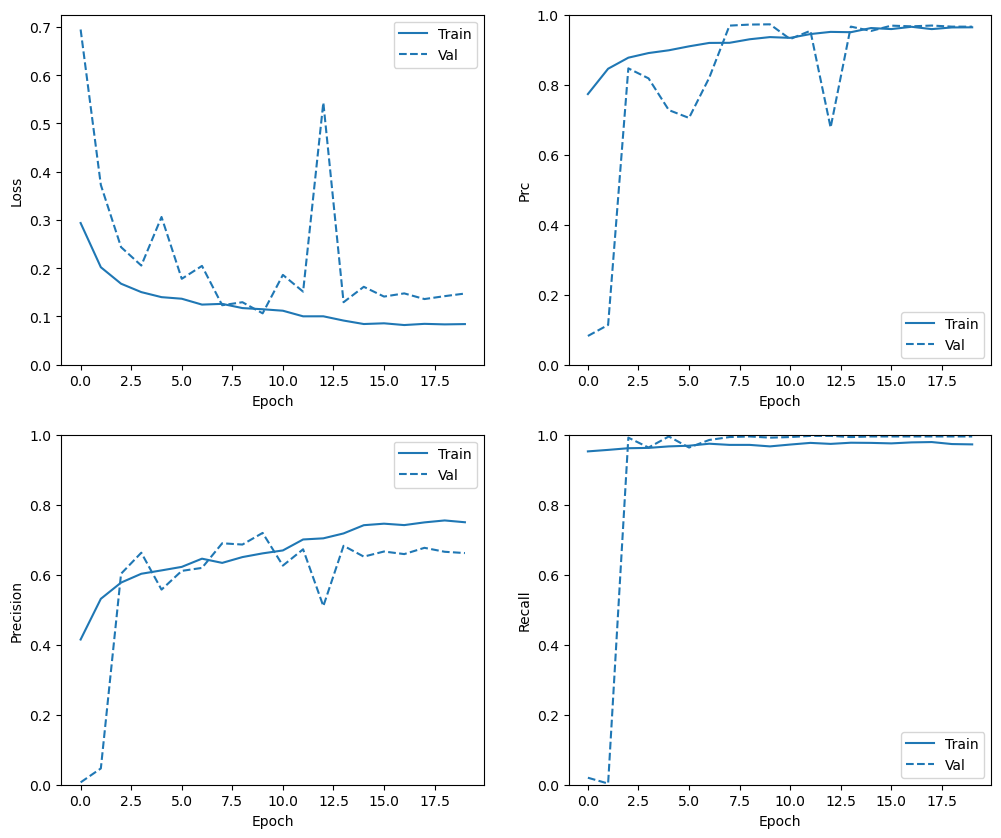

  1/296 [..............................] - ETA: 2:18 - loss: 0.1155 - tp: 1.0000 - fp: 3.0000 - tn: 60.0000 - fn: 0.0000e+00 - accuracy: 0.9531 - precision: 0.2500 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

  3/296 [..............................] - ETA: 11s - loss: 0.0971 - tp: 18.0000 - fp: 10.0000 - tn: 164.0000 - fn: 0.0000e+00 - accuracy: 0.9479 - precision: 0.6429 - recall: 1.0000 - auc: 0.9984 - prc: 0.9853

  5/296 [..............................] - ETA: 10s - loss: 0.0746 - tp: 28.0000 - fp: 12.0000 - tn: 280.0000 - fn: 0.0000e+00 - accuracy: 0.9625 - precision: 0.7000 - recall: 1.0000 - auc: 0.9991 - prc: 0.9914

  7/296 [..............................] - ETA: 10s - loss: 0.0751 - tp: 42.0000 - fp: 17.0000 - tn: 389.0000 - fn: 0.0000e+00 - accuracy: 0.9621 - precision: 0.7119 - recall: 1.0000 - auc: 0.9989 - prc: 0.9899

  9/296 [..............................] - ETA: 10s - loss: 0.0851 - tp: 53.0000 - fp: 24.0000 - tn: 498.0000 - fn: 1.0000 - accuracy: 0.9566 - precision: 0.6883 - recall: 0.9815 - auc: 0.9979 - prc: 0.9840    

 11/296 [>.............................] - ETA: 10s - loss: 0.0797 - tp: 64.0000 - fp: 26.0000 - tn: 613.0000 - fn: 1.0000 - accuracy: 0.9616 - precision: 0.7111 - recall: 0.9846 - auc: 0.9982 - prc: 0.9861

 13/296 [>.............................] - ETA: 10s - loss: 0.0852 - tp: 81.0000 - fp: 30.0000 - tn: 720.0000 - fn: 1.0000 - accuracy: 0.9627 - precision: 0.7297 - recall: 0.9878 - auc: 0.9977 - prc: 0.9699

 15/296 [>.............................] - ETA: 10s - loss: 0.0946 - tp: 94.0000 - fp: 38.0000 - tn: 827.0000 - fn: 1.0000 - accuracy: 0.9594 - precision: 0.7121 - recall: 0.9895 - auc: 0.9973 - prc: 0.9690

 17/296 [>.............................] - ETA: 9s - loss: 0.0904 - tp: 108.0000 - fp: 42.0000 - tn: 937.0000 - fn: 1.0000 - accuracy: 0.9605 - precision: 0.7200 - recall: 0.9908 - auc: 0.9977 - prc: 0.9735

 19/296 [>.............................] - ETA: 9s - loss: 0.0867 - tp: 117.0000 - fp: 43.0000 - tn: 1055.0000 - fn: 1.0000 - accuracy: 0.9638 - precision: 0.7312 - recall: 0.9915 - auc: 0.9980 - prc: 0.9760

 21/296 [=>............................] - ETA: 9s - loss: 0.0891 - tp: 127.0000 - fp: 48.0000 - tn: 1168.0000 - fn: 1.0000 - accuracy: 0.9635 - precision: 0.7257 - recall: 0.9922 - auc: 0.9980 - prc: 0.9759

 23/296 [=>............................] - ETA: 9s - loss: 0.0908 - tp: 140.0000 - fp: 55.0000 - tn: 1276.0000 - fn: 1.0000 - accuracy: 0.9620 - precision: 0.7179 - recall: 0.9929 - auc: 0.9981 - prc: 0.9779

 25/296 [=>............................] - ETA: 9s - loss: 0.0913 - tp: 154.0000 - fp: 60.0000 - tn: 1385.0000 - fn: 1.0000 - accuracy: 0.9619 - precision: 0.7196 - recall: 0.9935 - auc: 0.9980 - prc: 0.9775

 27/296 [=>............................] - ETA: 9s - loss: 0.0938 - tp: 162.0000 - fp: 69.0000 - tn: 1496.0000 - fn: 1.0000 - accuracy: 0.9595 - precision: 0.7013 - recall: 0.9939 - auc: 0.9981 - prc: 0.9784

 29/296 [=>............................] - ETA: 8s - loss: 0.0961 - tp: 175.0000 - fp: 77.0000 - tn: 1603.0000 - fn: 1.0000 - accuracy: 0.9580 - precision: 0.6944 - recall: 0.9943 - auc: 0.9980 - prc: 0.9783

 31/296 [==>...........................] - ETA: 8s - loss: 0.0956 - tp: 191.0000 - fp: 82.0000 - tn: 1710.0000 - fn: 1.0000 - accuracy: 0.9582 - precision: 0.6996 - recall: 0.9948 - auc: 0.9980 - prc: 0.9794

 33/296 [==>...........................] - ETA: 8s - loss: 0.0983 - tp: 206.0000 - fp: 90.0000 - tn: 1814.0000 - fn: 2.0000 - accuracy: 0.9564 - precision: 0.6959 - recall: 0.9904 - auc: 0.9976 - prc: 0.9774

 35/296 [==>...........................] - ETA: 8s - loss: 0.1031 - tp: 221.0000 - fp: 102.0000 - tn: 1915.0000 - fn: 2.0000 - accuracy: 0.9536 - precision: 0.6842 - recall: 0.9910 - auc: 0.9975 - prc: 0.9771

 37/296 [==>...........................] - ETA: 8s - loss: 0.1021 - tp: 234.0000 - fp: 107.0000 - tn: 2025.0000 - fn: 2.0000 - accuracy: 0.9540 - precision: 0.6862 - recall: 0.9915 - auc: 0.9975 - prc: 0.9776

 39/296 [==>...........................] - ETA: 8s - loss: 0.1040 - tp: 249.0000 - fp: 115.0000 - tn: 2130.0000 - fn: 2.0000 - accuracy: 0.9531 - precision: 0.6841 - recall: 0.9920 - auc: 0.9974 - prc: 0.9767

 41/296 [===>..........................] - ETA: 8s - loss: 0.1051 - tp: 258.0000 - fp: 121.0000 - tn: 2243.0000 - fn: 2.0000 - accuracy: 0.9531 - precision: 0.6807 - recall: 0.9923 - auc: 0.9972 - prc: 0.9755

 43/296 [===>..........................] - ETA: 8s - loss: 0.1046 - tp: 266.0000 - fp: 128.0000 - tn: 2356.0000 - fn: 2.0000 - accuracy: 0.9528 - precision: 0.6751 - recall: 0.9925 - auc: 0.9973 - prc: 0.9760

 45/296 [===>..........................] - ETA: 8s - loss: 0.1070 - tp: 282.0000 - fp: 137.0000 - tn: 2459.0000 - fn: 2.0000 - accuracy: 0.9517 - precision: 0.6730 - recall: 0.9930 - auc: 0.9974 - prc: 0.9769

 47/296 [===>..........................] - ETA: 8s - loss: 0.1056 - tp: 301.0000 - fp: 141.0000 - tn: 2564.0000 - fn: 2.0000 - accuracy: 0.9525 - precision: 0.6810 - recall: 0.9934 - auc: 0.9975 - prc: 0.9781

 49/296 [===>..........................] - ETA: 7s - loss: 0.1046 - tp: 317.0000 - fp: 144.0000 - tn: 2673.0000 - fn: 2.0000 - accuracy: 0.9534 - precision: 0.6876 - recall: 0.9937 - auc: 0.9976 - prc: 0.9793

 51/296 [====>.........................] - ETA: 7s - loss: 0.1065 - tp: 327.0000 - fp: 150.0000 - tn: 2785.0000 - fn: 2.0000 - accuracy: 0.9534 - precision: 0.6855 - recall: 0.9939 - auc: 0.9974 - prc: 0.9775

 53/296 [====>.........................] - ETA: 7s - loss: 0.1066 - tp: 347.0000 - fp: 155.0000 - tn: 2888.0000 - fn: 2.0000 - accuracy: 0.9537 - precision: 0.6912 - recall: 0.9943 - auc: 0.9975 - prc: 0.9789

 55/296 [====>.........................] - ETA: 7s - loss: 0.1089 - tp: 356.0000 - fp: 164.0000 - tn: 2998.0000 - fn: 2.0000 - accuracy: 0.9528 - precision: 0.6846 - recall: 0.9944 - auc: 0.9974 - prc: 0.9779

 57/296 [====>.........................] - ETA: 7s - loss: 0.1073 - tp: 374.0000 - fp: 166.0000 - tn: 3106.0000 - fn: 2.0000 - accuracy: 0.9539 - precision: 0.6926 - recall: 0.9947 - auc: 0.9975 - prc: 0.9785

 59/296 [====>.........................] - ETA: 7s - loss: 0.1088 - tp: 386.0000 - fp: 171.0000 - tn: 3217.0000 - fn: 2.0000 - accuracy: 0.9542 - precision: 0.6930 - recall: 0.9948 - auc: 0.9973 - prc: 0.9766

 61/296 [=====>........................] - ETA: 7s - loss: 0.1089 - tp: 397.0000 - fp: 177.0000 - tn: 3328.0000 - fn: 2.0000 - accuracy: 0.9541 - precision: 0.6916 - recall: 0.9950 - auc: 0.9973 - prc: 0.9765

 63/296 [=====>........................] - ETA: 7s - loss: 0.1091 - tp: 412.0000 - fp: 185.0000 - tn: 3433.0000 - fn: 2.0000 - accuracy: 0.9536 - precision: 0.6901 - recall: 0.9952 - auc: 0.9973 - prc: 0.9772

 65/296 [=====>........................] - ETA: 7s - loss: 0.1094 - tp: 428.0000 - fp: 193.0000 - tn: 3537.0000 - fn: 2.0000 - accuracy: 0.9531 - precision: 0.6892 - recall: 0.9953 - auc: 0.9974 - prc: 0.9779

 67/296 [=====>........................] - ETA: 7s - loss: 0.1087 - tp: 439.0000 - fp: 199.0000 - tn: 3648.0000 - fn: 2.0000 - accuracy: 0.9531 - precision: 0.6881 - recall: 0.9955 - auc: 0.9974 - prc: 0.9782

 69/296 [=====>........................] - ETA: 7s - loss: 0.1088 - tp: 447.0000 - fp: 204.0000 - tn: 3762.0000 - fn: 3.0000 - accuracy: 0.9531 - precision: 0.6866 - recall: 0.9933 - auc: 0.9973 - prc: 0.9776

 71/296 [======>.......................] - ETA: 7s - loss: 0.1095 - tp: 461.0000 - fp: 211.0000 - tn: 3869.0000 - fn: 3.0000 - accuracy: 0.9529 - precision: 0.6860 - recall: 0.9935 - auc: 0.9973 - prc: 0.9775

 73/296 [======>.......................] - ETA: 7s - loss: 0.1106 - tp: 477.0000 - fp: 217.0000 - tn: 3975.0000 - fn: 3.0000 - accuracy: 0.9529 - precision: 0.6873 - recall: 0.9937 - auc: 0.9972 - prc: 0.9770

 75/296 [======>.......................] - ETA: 6s - loss: 0.1134 - tp: 489.0000 - fp: 230.0000 - tn: 4078.0000 - fn: 3.0000 - accuracy: 0.9515 - precision: 0.6801 - recall: 0.9939 - auc: 0.9972 - prc: 0.9768

 77/296 [======>.......................] - ETA: 6s - loss: 0.1141 - tp: 504.0000 - fp: 237.0000 - tn: 4184.0000 - fn: 3.0000 - accuracy: 0.9513 - precision: 0.6802 - recall: 0.9941 - auc: 0.9970 - prc: 0.9754

 79/296 [=======>......................] - ETA: 6s - loss: 0.1149 - tp: 519.0000 - fp: 246.0000 - tn: 4288.0000 - fn: 3.0000 - accuracy: 0.9508 - precision: 0.6784 - recall: 0.9943 - auc: 0.9970 - prc: 0.9752

 81/296 [=======>......................] - ETA: 6s - loss: 0.1135 - tp: 535.0000 - fp: 250.0000 - tn: 4396.0000 - fn: 3.0000 - accuracy: 0.9512 - precision: 0.6815 - recall: 0.9944 - auc: 0.9970 - prc: 0.9752

 83/296 [=======>......................] - ETA: 6s - loss: 0.1120 - tp: 552.0000 - fp: 253.0000 - tn: 4503.0000 - fn: 4.0000 - accuracy: 0.9516 - precision: 0.6857 - recall: 0.9928 - auc: 0.9970 - prc: 0.9755

 85/296 [=======>......................] - ETA: 6s - loss: 0.1110 - tp: 566.0000 - fp: 256.0000 - tn: 4614.0000 - fn: 4.0000 - accuracy: 0.9522 - precision: 0.6886 - recall: 0.9930 - auc: 0.9969 - prc: 0.9753

 87/296 [=======>......................] - ETA: 6s - loss: 0.1101 - tp: 583.0000 - fp: 259.0000 - tn: 4721.0000 - fn: 5.0000 - accuracy: 0.9526 - precision: 0.6924 - recall: 0.9915 - auc: 0.9970 - prc: 0.9756

 89/296 [========>.....................] - ETA: 6s - loss: 0.1102 - tp: 599.0000 - fp: 265.0000 - tn: 4827.0000 - fn: 5.0000 - accuracy: 0.9526 - precision: 0.6933 - recall: 0.9917 - auc: 0.9969 - prc: 0.9755

 91/296 [========>.....................] - ETA: 6s - loss: 0.1089 - tp: 617.0000 - fp: 267.0000 - tn: 4935.0000 - fn: 5.0000 - accuracy: 0.9533 - precision: 0.6980 - recall: 0.9920 - auc: 0.9970 - prc: 0.9759

 93/296 [========>.....................] - ETA: 6s - loss: 0.1089 - tp: 636.0000 - fp: 273.0000 - tn: 5038.0000 - fn: 5.0000 - accuracy: 0.9533 - precision: 0.6997 - recall: 0.9922 - auc: 0.9969 - prc: 0.9757

 95/296 [========>.....................] - ETA: 6s - loss: 0.1093 - tp: 649.0000 - fp: 281.0000 - tn: 5145.0000 - fn: 5.0000 - accuracy: 0.9530 - precision: 0.6978 - recall: 0.9924 - auc: 0.9969 - prc: 0.9759

 97/296 [========>.....................] - ETA: 6s - loss: 0.1098 - tp: 666.0000 - fp: 286.0000 - tn: 5251.0000 - fn: 5.0000 - accuracy: 0.9531 - precision: 0.6996 - recall: 0.9925 - auc: 0.9969 - prc: 0.9757

 99/296 [=========>....................] - ETA: 6s - loss: 0.1094 - tp: 684.0000 - fp: 292.0000 - tn: 5355.0000 - fn: 5.0000 - accuracy: 0.9531 - precision: 0.7008 - recall: 0.9927 - auc: 0.9969 - prc: 0.9760

101/296 [=========>....................] - ETA: 6s - loss: 0.1107 - tp: 695.0000 - fp: 300.0000 - tn: 5464.0000 - fn: 5.0000 - accuracy: 0.9528 - precision: 0.6985 - recall: 0.9929 - auc: 0.9969 - prc: 0.9755

103/296 [=========>....................] - ETA: 6s - loss: 0.1112 - tp: 705.0000 - fp: 307.0000 - tn: 5575.0000 - fn: 5.0000 - accuracy: 0.9527 - precision: 0.6966 - recall: 0.9930 - auc: 0.9967 - prc: 0.9729

105/296 [=========>....................] - ETA: 6s - loss: 0.1110 - tp: 723.0000 - fp: 314.0000 - tn: 5678.0000 - fn: 5.0000 - accuracy: 0.9525 - precision: 0.6972 - recall: 0.9931 - auc: 0.9967 - prc: 0.9728

107/296 [=========>....................] - ETA: 5s - loss: 0.1112 - tp: 741.0000 - fp: 320.0000 - tn: 5782.0000 - fn: 5.0000 - accuracy: 0.9525 - precision: 0.6984 - recall: 0.9933 - auc: 0.9966 - prc: 0.9726

109/296 [==========>...................] - ETA: 5s - loss: 0.1106 - tp: 753.0000 - fp: 323.0000 - tn: 5895.0000 - fn: 5.0000 - accuracy: 0.9530 - precision: 0.6998 - recall: 0.9934 - auc: 0.9966 - prc: 0.9726

111/296 [==========>...................] - ETA: 5s - loss: 0.1121 - tp: 771.0000 - fp: 334.0000 - tn: 5994.0000 - fn: 5.0000 - accuracy: 0.9523 - precision: 0.6977 - recall: 0.9936 - auc: 0.9965 - prc: 0.9719

113/296 [==========>...................] - ETA: 5s - loss: 0.1118 - tp: 783.0000 - fp: 340.0000 - tn: 6104.0000 - fn: 5.0000 - accuracy: 0.9523 - precision: 0.6972 - recall: 0.9937 - auc: 0.9966 - prc: 0.9722

115/296 [==========>...................] - ETA: 5s - loss: 0.1110 - tp: 800.0000 - fp: 344.0000 - tn: 6211.0000 - fn: 5.0000 - accuracy: 0.9526 - precision: 0.6993 - recall: 0.9938 - auc: 0.9966 - prc: 0.9729

117/296 [==========>...................] - ETA: 5s - loss: 0.1109 - tp: 819.0000 - fp: 349.0000 - tn: 6315.0000 - fn: 5.0000 - accuracy: 0.9527 - precision: 0.7012 - recall: 0.9939 - auc: 0.9967 - prc: 0.9733

119/296 [===========>..................] - ETA: 5s - loss: 0.1110 - tp: 831.0000 - fp: 355.0000 - tn: 6424.0000 - fn: 6.0000 - accuracy: 0.9526 - precision: 0.7007 - recall: 0.9928 - auc: 0.9966 - prc: 0.9727

121/296 [===========>..................] - ETA: 5s - loss: 0.1131 - tp: 847.0000 - fp: 363.0000 - tn: 6528.0000 - fn: 6.0000 - accuracy: 0.9524 - precision: 0.7000 - recall: 0.9930 - auc: 0.9964 - prc: 0.9701

123/296 [===========>..................] - ETA: 5s - loss: 0.1133 - tp: 864.0000 - fp: 371.0000 - tn: 6631.0000 - fn: 6.0000 - accuracy: 0.9521 - precision: 0.6996 - recall: 0.9931 - auc: 0.9964 - prc: 0.9706

125/296 [===========>..................] - ETA: 5s - loss: 0.1129 - tp: 876.0000 - fp: 377.0000 - tn: 6741.0000 - fn: 6.0000 - accuracy: 0.9521 - precision: 0.6991 - recall: 0.9932 - auc: 0.9964 - prc: 0.9706

127/296 [===========>..................] - ETA: 5s - loss: 0.1133 - tp: 888.0000 - fp: 385.0000 - tn: 6849.0000 - fn: 6.0000 - accuracy: 0.9519 - precision: 0.6976 - recall: 0.9933 - auc: 0.9964 - prc: 0.9703

129/296 [============>.................] - ETA: 5s - loss: 0.1143 - tp: 905.0000 - fp: 393.0000 - tn: 6952.0000 - fn: 6.0000 - accuracy: 0.9517 - precision: 0.6972 - recall: 0.9934 - auc: 0.9963 - prc: 0.9688

131/296 [============>.................] - ETA: 5s - loss: 0.1133 - tp: 920.0000 - fp: 395.0000 - tn: 7063.0000 - fn: 6.0000 - accuracy: 0.9522 - precision: 0.6996 - recall: 0.9935 - auc: 0.9963 - prc: 0.9691

133/296 [============>.................] - ETA: 5s - loss: 0.1136 - tp: 931.0000 - fp: 403.0000 - tn: 7172.0000 - fn: 6.0000 - accuracy: 0.9520 - precision: 0.6979 - recall: 0.9936 - auc: 0.9963 - prc: 0.9688

135/296 [============>.................] - ETA: 5s - loss: 0.1132 - tp: 946.0000 - fp: 406.0000 - tn: 7282.0000 - fn: 6.0000 - accuracy: 0.9523 - precision: 0.6997 - recall: 0.9937 - auc: 0.9962 - prc: 0.9685

137/296 [============>.................] - ETA: 4s - loss: 0.1128 - tp: 960.0000 - fp: 413.0000 - tn: 7389.0000 - fn: 6.0000 - accuracy: 0.9522 - precision: 0.6992 - recall: 0.9938 - auc: 0.9963 - prc: 0.9685

139/296 [=============>................] - ETA: 4s - loss: 0.1128 - tp: 973.0000 - fp: 421.0000 - tn: 7496.0000 - fn: 6.0000 - accuracy: 0.9520 - precision: 0.6980 - recall: 0.9939 - auc: 0.9963 - prc: 0.9688

141/296 [=============>................] - ETA: 4s - loss: 0.1126 - tp: 985.0000 - fp: 427.0000 - tn: 7606.0000 - fn: 6.0000 - accuracy: 0.9520 - precision: 0.6976 - recall: 0.9939 - auc: 0.9963 - prc: 0.9686

143/296 [=============>................] - ETA: 4s - loss: 0.1126 - tp: 998.0000 - fp: 432.0000 - tn: 7716.0000 - fn: 6.0000 - accuracy: 0.9521 - precision: 0.6979 - recall: 0.9940 - auc: 0.9962 - prc: 0.9682

145/296 [=============>................] - ETA: 4s - loss: 0.1125 - tp: 1009.0000 - fp: 437.0000 - tn: 7828.0000 - fn: 6.0000 - accuracy: 0.9523 - precision: 0.6978 - recall: 0.9941 - auc: 0.9962 - prc: 0.9686

147/296 [=============>................] - ETA: 4s - loss: 0.1121 - tp: 1028.0000 - fp: 441.0000 - tn: 7933.0000 - fn: 6.0000 - accuracy: 0.9525 - precision: 0.6998 - recall: 0.9942 - auc: 0.9963 - prc: 0.9690

149/296 [==============>...............] - ETA: 4s - loss: 0.1119 - tp: 1038.0000 - fp: 446.0000 - tn: 8046.0000 - fn: 6.0000 - accuracy: 0.9526 - precision: 0.6995 - recall: 0.9943 - auc: 0.9963 - prc: 0.9689

151/296 [==============>...............] - ETA: 4s - loss: 0.1119 - tp: 1051.0000 - fp: 454.0000 - tn: 8153.0000 - fn: 6.0000 - accuracy: 0.9524 - precision: 0.6983 - recall: 0.9943 - auc: 0.9963 - prc: 0.9693

153/296 [==============>...............] - ETA: 4s - loss: 0.1124 - tp: 1066.0000 - fp: 459.0000 - tn: 8260.0000 - fn: 7.0000 - accuracy: 0.9524 - precision: 0.6990 - recall: 0.9935 - auc: 0.9962 - prc: 0.9685

155/296 [==============>...............] - ETA: 4s - loss: 0.1120 - tp: 1081.0000 - fp: 463.0000 - tn: 8369.0000 - fn: 7.0000 - accuracy: 0.9526 - precision: 0.7001 - recall: 0.9936 - auc: 0.9962 - prc: 0.9687

157/296 [==============>...............] - ETA: 4s - loss: 0.1122 - tp: 1087.0000 - fp: 472.0000 - tn: 8482.0000 - fn: 7.0000 - accuracy: 0.9523 - precision: 0.6972 - recall: 0.9936 - auc: 0.9962 - prc: 0.9688

159/296 [===============>..............] - ETA: 4s - loss: 0.1126 - tp: 1092.0000 - fp: 480.0000 - tn: 8597.0000 - fn: 7.0000 - accuracy: 0.9521 - precision: 0.6947 - recall: 0.9936 - auc: 0.9962 - prc: 0.9683

161/296 [===============>..............] - ETA: 4s - loss: 0.1124 - tp: 1104.0000 - fp: 486.0000 - tn: 8707.0000 - fn: 7.0000 - accuracy: 0.9522 - precision: 0.6943 - recall: 0.9937 - auc: 0.9962 - prc: 0.9685

163/296 [===============>..............] - ETA: 4s - loss: 0.1128 - tp: 1123.0000 - fp: 490.0000 - tn: 8812.0000 - fn: 7.0000 - accuracy: 0.9524 - precision: 0.6962 - recall: 0.9938 - auc: 0.9962 - prc: 0.9684

165/296 [===============>..............] - ETA: 4s - loss: 0.1120 - tp: 1142.0000 - fp: 494.0000 - tn: 8917.0000 - fn: 7.0000 - accuracy: 0.9526 - precision: 0.6980 - recall: 0.9939 - auc: 0.9963 - prc: 0.9690

167/296 [===============>..............] - ETA: 3s - loss: 0.1120 - tp: 1156.0000 - fp: 498.0000 - tn: 9027.0000 - fn: 7.0000 - accuracy: 0.9528 - precision: 0.6989 - recall: 0.9940 - auc: 0.9963 - prc: 0.9693

169/296 [================>.............] - ETA: 3s - loss: 0.1113 - tp: 1170.0000 - fp: 502.0000 - tn: 9137.0000 - fn: 7.0000 - accuracy: 0.9529 - precision: 0.6998 - recall: 0.9941 - auc: 0.9964 - prc: 0.9696

171/296 [================>.............] - ETA: 3s - loss: 0.1114 - tp: 1184.0000 - fp: 510.0000 - tn: 9243.0000 - fn: 7.0000 - accuracy: 0.9528 - precision: 0.6989 - recall: 0.9941 - auc: 0.9963 - prc: 0.9696

173/296 [================>.............] - ETA: 3s - loss: 0.1111 - tp: 1195.0000 - fp: 515.0000 - tn: 9355.0000 - fn: 7.0000 - accuracy: 0.9529 - precision: 0.6988 - recall: 0.9942 - auc: 0.9964 - prc: 0.9699

175/296 [================>.............] - ETA: 3s - loss: 0.1119 - tp: 1213.0000 - fp: 526.0000 - tn: 9454.0000 - fn: 7.0000 - accuracy: 0.9524 - precision: 0.6975 - recall: 0.9943 - auc: 0.9963 - prc: 0.9695

177/296 [================>.............] - ETA: 3s - loss: 0.1115 - tp: 1228.0000 - fp: 529.0000 - tn: 9564.0000 - fn: 7.0000 - accuracy: 0.9527 - precision: 0.6989 - recall: 0.9943 - auc: 0.9964 - prc: 0.9698

179/296 [=================>............] - ETA: 3s - loss: 0.1113 - tp: 1239.0000 - fp: 533.0000 - tn: 9677.0000 - fn: 7.0000 - accuracy: 0.9529 - precision: 0.6992 - recall: 0.9944 - auc: 0.9964 - prc: 0.9699

181/296 [=================>............] - ETA: 3s - loss: 0.1114 - tp: 1255.0000 - fp: 540.0000 - tn: 9782.0000 - fn: 7.0000 - accuracy: 0.9528 - precision: 0.6992 - recall: 0.9945 - auc: 0.9964 - prc: 0.9701

183/296 [=================>............] - ETA: 3s - loss: 0.1120 - tp: 1267.0000 - fp: 549.0000 - tn: 9888.0000 - fn: 8.0000 - accuracy: 0.9524 - precision: 0.6977 - recall: 0.9937 - auc: 0.9964 - prc: 0.9701

185/296 [=================>............] - ETA: 3s - loss: 0.1130 - tp: 1275.0000 - fp: 557.0000 - tn: 10000.0000 - fn: 8.0000 - accuracy: 0.9523 - precision: 0.6960 - recall: 0.9938 - auc: 0.9963 - prc: 0.9690

187/296 [=================>............] - ETA: 3s - loss: 0.1135 - tp: 1292.0000 - fp: 564.0000 - tn: 10103.0000 - fn: 9.0000 - accuracy: 0.9521 - precision: 0.6961 - recall: 0.9931 - auc: 0.9961 - prc: 0.9682

189/296 [==================>...........] - ETA: 3s - loss: 0.1131 - tp: 1308.0000 - fp: 566.0000 - tn: 10212.0000 - fn: 10.0000 - accuracy: 0.9524 - precision: 0.6980 - recall: 0.9924 - auc: 0.9961 - prc: 0.9684

191/296 [==================>...........] - ETA: 3s - loss: 0.1131 - tp: 1324.0000 - fp: 571.0000 - tn: 10319.0000 - fn: 10.0000 - accuracy: 0.9525 - precision: 0.6987 - recall: 0.9925 - auc: 0.9961 - prc: 0.9687

193/296 [==================>...........] - ETA: 3s - loss: 0.1127 - tp: 1341.0000 - fp: 576.0000 - tn: 10425.0000 - fn: 10.0000 - accuracy: 0.9526 - precision: 0.6995 - recall: 0.9926 - auc: 0.9962 - prc: 0.9692

195/296 [==================>...........] - ETA: 3s - loss: 0.1123 - tp: 1354.0000 - fp: 579.0000 - tn: 10536.0000 - fn: 11.0000 - accuracy: 0.9527 - precision: 0.7005 - recall: 0.9919 - auc: 0.9962 - prc: 0.9693

197/296 [==================>...........] - ETA: 3s - loss: 0.1132 - tp: 1364.0000 - fp: 588.0000 - tn: 10645.0000 - fn: 11.0000 - accuracy: 0.9525 - precision: 0.6988 - recall: 0.9920 - auc: 0.9961 - prc: 0.9681

199/296 [===================>..........] - ETA: 3s - loss: 0.1128 - tp: 1379.0000 - fp: 590.0000 - tn: 10756.0000 - fn: 11.0000 - accuracy: 0.9528 - precision: 0.7004 - recall: 0.9921 - auc: 0.9961 - prc: 0.9682

201/296 [===================>..........] - ETA: 2s - loss: 0.1124 - tp: 1394.0000 - fp: 596.0000 - tn: 10863.0000 - fn: 11.0000 - accuracy: 0.9528 - precision: 0.7005 - recall: 0.9922 - auc: 0.9962 - prc: 0.9684

203/296 [===================>..........] - ETA: 2s - loss: 0.1132 - tp: 1413.0000 - fp: 606.0000 - tn: 10962.0000 - fn: 11.0000 - accuracy: 0.9525 - precision: 0.6999 - recall: 0.9923 - auc: 0.9961 - prc: 0.9684

205/296 [===================>..........] - ETA: 2s - loss: 0.1134 - tp: 1429.0000 - fp: 616.0000 - tn: 11064.0000 - fn: 11.0000 - accuracy: 0.9522 - precision: 0.6988 - recall: 0.9924 - auc: 0.9962 - prc: 0.9686

207/296 [===================>..........] - ETA: 2s - loss: 0.1131 - tp: 1444.0000 - fp: 621.0000 - tn: 11172.0000 - fn: 11.0000 - accuracy: 0.9523 - precision: 0.6993 - recall: 0.9924 - auc: 0.9962 - prc: 0.9689

209/296 [====================>.........] - ETA: 2s - loss: 0.1130 - tp: 1461.0000 - fp: 630.0000 - tn: 11274.0000 - fn: 11.0000 - accuracy: 0.9521 - precision: 0.6987 - recall: 0.9925 - auc: 0.9962 - prc: 0.9693

211/296 [====================>.........] - ETA: 2s - loss: 0.1123 - tp: 1472.0000 - fp: 632.0000 - tn: 11389.0000 - fn: 11.0000 - accuracy: 0.9524 - precision: 0.6996 - recall: 0.9926 - auc: 0.9963 - prc: 0.9696

213/296 [====================>.........] - ETA: 2s - loss: 0.1121 - tp: 1485.0000 - fp: 638.0000 - tn: 11498.0000 - fn: 11.0000 - accuracy: 0.9524 - precision: 0.6995 - recall: 0.9926 - auc: 0.9963 - prc: 0.9697

215/296 [====================>.........] - ETA: 2s - loss: 0.1129 - tp: 1499.0000 - fp: 648.0000 - tn: 11602.0000 - fn: 11.0000 - accuracy: 0.9521 - precision: 0.6982 - recall: 0.9927 - auc: 0.9963 - prc: 0.9693

217/296 [====================>.........] - ETA: 2s - loss: 0.1133 - tp: 1515.0000 - fp: 657.0000 - tn: 11704.0000 - fn: 12.0000 - accuracy: 0.9518 - precision: 0.6975 - recall: 0.9921 - auc: 0.9962 - prc: 0.9693

219/296 [=====================>........] - ETA: 2s - loss: 0.1130 - tp: 1531.0000 - fp: 660.0000 - tn: 11813.0000 - fn: 12.0000 - accuracy: 0.9521 - precision: 0.6988 - recall: 0.9922 - auc: 0.9962 - prc: 0.9694

221/296 [=====================>........] - ETA: 2s - loss: 0.1127 - tp: 1547.0000 - fp: 665.0000 - tn: 11920.0000 - fn: 12.0000 - accuracy: 0.9521 - precision: 0.6994 - recall: 0.9923 - auc: 0.9963 - prc: 0.9697

223/296 [=====================>........] - ETA: 2s - loss: 0.1127 - tp: 1563.0000 - fp: 671.0000 - tn: 12026.0000 - fn: 12.0000 - accuracy: 0.9521 - precision: 0.6996 - recall: 0.9924 - auc: 0.9962 - prc: 0.9689

225/296 [=====================>........] - ETA: 2s - loss: 0.1123 - tp: 1579.0000 - fp: 674.0000 - tn: 12135.0000 - fn: 12.0000 - accuracy: 0.9524 - precision: 0.7008 - recall: 0.9925 - auc: 0.9962 - prc: 0.9689

227/296 [======================>.......] - ETA: 2s - loss: 0.1129 - tp: 1591.0000 - fp: 685.0000 - tn: 12240.0000 - fn: 12.0000 - accuracy: 0.9520 - precision: 0.6990 - recall: 0.9925 - auc: 0.9962 - prc: 0.9687

229/296 [======================>.......] - ETA: 2s - loss: 0.1128 - tp: 1612.0000 - fp: 690.0000 - tn: 12341.0000 - fn: 13.0000 - accuracy: 0.9520 - precision: 0.7003 - recall: 0.9920 - auc: 0.9962 - prc: 0.9690

231/296 [======================>.......] - ETA: 2s - loss: 0.1126 - tp: 1627.0000 - fp: 695.0000 - tn: 12449.0000 - fn: 13.0000 - accuracy: 0.9521 - precision: 0.7007 - recall: 0.9921 - auc: 0.9962 - prc: 0.9691

233/296 [======================>.......] - ETA: 1s - loss: 0.1124 - tp: 1641.0000 - fp: 699.0000 - tn: 12558.0000 - fn: 14.0000 - accuracy: 0.9522 - precision: 0.7013 - recall: 0.9915 - auc: 0.9962 - prc: 0.9690

235/296 [======================>.......] - ETA: 1s - loss: 0.1125 - tp: 1664.0000 - fp: 706.0000 - tn: 12656.0000 - fn: 14.0000 - accuracy: 0.9521 - precision: 0.7021 - recall: 0.9917 - auc: 0.9961 - prc: 0.9691

237/296 [=======================>......] - ETA: 1s - loss: 0.1130 - tp: 1674.0000 - fp: 716.0000 - tn: 12764.0000 - fn: 14.0000 - accuracy: 0.9519 - precision: 0.7004 - recall: 0.9917 - auc: 0.9961 - prc: 0.9689

239/296 [=======================>......] - ETA: 1s - loss: 0.1128 - tp: 1690.0000 - fp: 721.0000 - tn: 12871.0000 - fn: 14.0000 - accuracy: 0.9519 - precision: 0.7010 - recall: 0.9918 - auc: 0.9962 - prc: 0.9692

241/296 [=======================>......] - ETA: 1s - loss: 0.1132 - tp: 1704.0000 - fp: 731.0000 - tn: 12975.0000 - fn: 14.0000 - accuracy: 0.9517 - precision: 0.6998 - recall: 0.9919 - auc: 0.9961 - prc: 0.9691

243/296 [=======================>......] - ETA: 1s - loss: 0.1135 - tp: 1725.0000 - fp: 739.0000 - tn: 13074.0000 - fn: 14.0000 - accuracy: 0.9516 - precision: 0.7001 - recall: 0.9919 - auc: 0.9962 - prc: 0.9694

245/296 [=======================>......] - ETA: 1s - loss: 0.1137 - tp: 1736.0000 - fp: 749.0000 - tn: 13181.0000 - fn: 14.0000 - accuracy: 0.9513 - precision: 0.6986 - recall: 0.9920 - auc: 0.9962 - prc: 0.9694

247/296 [========================>.....] - ETA: 1s - loss: 0.1137 - tp: 1751.0000 - fp: 756.0000 - tn: 13287.0000 - fn: 14.0000 - accuracy: 0.9513 - precision: 0.6984 - recall: 0.9921 - auc: 0.9962 - prc: 0.9696

249/296 [========================>.....] - ETA: 1s - loss: 0.1141 - tp: 1761.0000 - fp: 764.0000 - tn: 13397.0000 - fn: 14.0000 - accuracy: 0.9512 - precision: 0.6974 - recall: 0.9921 - auc: 0.9962 - prc: 0.9689

251/296 [========================>.....] - ETA: 1s - loss: 0.1136 - tp: 1773.0000 - fp: 767.0000 - tn: 13510.0000 - fn: 14.0000 - accuracy: 0.9514 - precision: 0.6980 - recall: 0.9922 - auc: 0.9962 - prc: 0.9690

253/296 [========================>.....] - ETA: 1s - loss: 0.1135 - tp: 1785.0000 - fp: 773.0000 - tn: 13620.0000 - fn: 14.0000 - accuracy: 0.9514 - precision: 0.6978 - recall: 0.9922 - auc: 0.9962 - prc: 0.9690

255/296 [========================>.....] - ETA: 1s - loss: 0.1130 - tp: 1796.0000 - fp: 777.0000 - tn: 13733.0000 - fn: 14.0000 - accuracy: 0.9515 - precision: 0.6980 - recall: 0.9923 - auc: 0.9962 - prc: 0.9692

257/296 [=========================>....] - ETA: 1s - loss: 0.1134 - tp: 1807.0000 - fp: 787.0000 - tn: 13840.0000 - fn: 14.0000 - accuracy: 0.9513 - precision: 0.6966 - recall: 0.9923 - auc: 0.9962 - prc: 0.9691

259/296 [=========================>....] - ETA: 1s - loss: 0.1139 - tp: 1822.0000 - fp: 796.0000 - tn: 13944.0000 - fn: 14.0000 - accuracy: 0.9511 - precision: 0.6960 - recall: 0.9924 - auc: 0.9961 - prc: 0.9687

261/296 [=========================>....] - ETA: 1s - loss: 0.1139 - tp: 1839.0000 - fp: 802.0000 - tn: 14049.0000 - fn: 14.0000 - accuracy: 0.9511 - precision: 0.6963 - recall: 0.9924 - auc: 0.9962 - prc: 0.9689

263/296 [=========================>....] - ETA: 1s - loss: 0.1139 - tp: 1855.0000 - fp: 810.0000 - tn: 14153.0000 - fn: 14.0000 - accuracy: 0.9510 - precision: 0.6961 - recall: 0.9925 - auc: 0.9962 - prc: 0.9692

265/296 [=========================>....] - ETA: 0s - loss: 0.1140 - tp: 1867.0000 - fp: 816.0000 - tn: 14262.0000 - fn: 15.0000 - accuracy: 0.9510 - precision: 0.6959 - recall: 0.9920 - auc: 0.9961 - prc: 0.9690

267/296 [==========================>...] - ETA: 0s - loss: 0.1145 - tp: 1879.0000 - fp: 825.0000 - tn: 14369.0000 - fn: 15.0000 - accuracy: 0.9508 - precision: 0.6949 - recall: 0.9921 - auc: 0.9961 - prc: 0.9683

268/296 [==========================>...] - ETA: 0s - loss: 0.1143 - tp: 1890.0000 - fp: 826.0000 - tn: 14421.0000 - fn: 15.0000 - accuracy: 0.9510 - precision: 0.6959 - recall: 0.9921 - auc: 0.9961 - prc: 0.9683

270/296 [==========================>...] - ETA: 0s - loss: 0.1142 - tp: 1906.0000 - fp: 832.0000 - tn: 14527.0000 - fn: 15.0000 - accuracy: 0.9510 - precision: 0.6961 - recall: 0.9922 - auc: 0.9961 - prc: 0.9686

272/296 [==========================>...] - ETA: 0s - loss: 0.1142 - tp: 1918.0000 - fp: 836.0000 - tn: 14639.0000 - fn: 15.0000 - accuracy: 0.9511 - precision: 0.6964 - recall: 0.9922 - auc: 0.9961 - prc: 0.9685

274/296 [==========================>...] - ETA: 0s - loss: 0.1142 - tp: 1934.0000 - fp: 840.0000 - tn: 14747.0000 - fn: 15.0000 - accuracy: 0.9512 - precision: 0.6972 - recall: 0.9923 - auc: 0.9961 - prc: 0.9679

276/296 [==========================>...] - ETA: 0s - loss: 0.1142 - tp: 1956.0000 - fp: 848.0000 - tn: 14845.0000 - fn: 15.0000 - accuracy: 0.9511 - precision: 0.6976 - recall: 0.9924 - auc: 0.9961 - prc: 0.9681

279/296 [===========================>..] - ETA: 0s - loss: 0.1141 - tp: 1977.0000 - fp: 854.0000 - tn: 15009.0000 - fn: 16.0000 - accuracy: 0.9513 - precision: 0.6983 - recall: 0.9920 - auc: 0.9961 - prc: 0.9682

282/296 [===========================>..] - ETA: 0s - loss: 0.1141 - tp: 1995.0000 - fp: 861.0000 - tn: 15176.0000 - fn: 16.0000 - accuracy: 0.9514 - precision: 0.6985 - recall: 0.9920 - auc: 0.9961 - prc: 0.9681

284/296 [===========================>..] - ETA: 0s - loss: 0.1140 - tp: 2013.0000 - fp: 868.0000 - tn: 15279.0000 - fn: 16.0000 - accuracy: 0.9514 - precision: 0.6987 - recall: 0.9921 - auc: 0.9961 - prc: 0.9683

286/296 [===========================>..] - ETA: 0s - loss: 0.1136 - tp: 2035.0000 - fp: 871.0000 - tn: 15382.0000 - fn: 16.0000 - accuracy: 0.9515 - precision: 0.7003 - recall: 0.9922 - auc: 0.9961 - prc: 0.9686

288/296 [============================>.] - ETA: 0s - loss: 0.1133 - tp: 2044.0000 - fp: 875.0000 - tn: 15497.0000 - fn: 16.0000 - accuracy: 0.9517 - precision: 0.7002 - recall: 0.9922 - auc: 0.9961 - prc: 0.9687

290/296 [============================>.] - ETA: 0s - loss: 0.1130 - tp: 2053.0000 - fp: 880.0000 - tn: 15611.0000 - fn: 16.0000 - accuracy: 0.9517 - precision: 0.7000 - recall: 0.9923 - auc: 0.9962 - prc: 0.9688

292/296 [============================>.] - ETA: 0s - loss: 0.1131 - tp: 2069.0000 - fp: 887.0000 - tn: 15716.0000 - fn: 16.0000 - accuracy: 0.9517 - precision: 0.6999 - recall: 0.9923 - auc: 0.9962 - prc: 0.9688

294/296 [============================>.] - ETA: 0s - loss: 0.1126 - tp: 2080.0000 - fp: 889.0000 - tn: 15831.0000 - fn: 16.0000 - accuracy: 0.9519 - precision: 0.7006 - recall: 0.9924 - auc: 0.9962 - prc: 0.9688

296/296 [==============================] - ETA: 0s - loss: 0.1130 - tp: 2084.0000 - fp: 897.0000 - tn: 15903.0000 - fn: 16.0000 - accuracy: 0.9517 - precision: 0.6991 - recall: 0.9924 - auc: 0.9962 - prc: 0.9687

296/296 [==============================] - 10s 32ms/step - loss: 0.1130 - tp: 2084.0000 - fp: 897.0000 - tn: 15903.0000 - fn: 16.0000 - accuracy: 0.9517 - precision: 0.6991 - recall: 0.9924 - auc: 0.9962 - prc: 0.9687


loss :  0.11300913244485855
tp :  2084.0
fp :  897.0
tn :  15903.0
fn :  16.0
accuracy :  0.9516931176185608
precision :  0.6990942358970642
recall :  0.9923809766769409
auc :  0.9961684346199036
prc :  0.9687457084655762

 1/85 [..............................] - ETA: 6s - loss: 0.0855 - tp: 8.0000 - fp: 2.0000 - tn: 54.0000 - fn: 0.0000e+00 - accuracy: 0.9688 - precision: 0.8000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

 3/85 [>.............................] - ETA: 2s - loss: 0.0863 - tp: 26.0000 - fp: 10.0000 - tn: 156.0000 - fn: 0.0000e+00 - accuracy: 0.9479 - precision: 0.7222 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

 5/85 [>.............................] - ETA: 2s - loss: 0.0899 - tp: 38.0000 - fp: 14.0000 - tn: 268.0000 - fn: 0.0000e+00 - accuracy: 0.9563 - precision: 0.7308 - recall: 1.0000 - auc: 0.9986 - prc: 0.9873

 7/85 [=>............................] - ETA: 2s - loss: 0.1108 - tp: 46.0000 - fp: 23.0000 - tn: 378.0000 - fn: 1.0000 - accuracy: 0.9464 - precision: 0.6667 - recall: 0.9787 - auc: 0.9968 - prc: 0.9747    

 9/85 [==>...........................] - ETA: 2s - loss: 0.0990 - tp: 58.0000 - fp: 25.0000 - tn: 492.0000 - fn: 1.0000 - accuracy: 0.9549 - precision: 0.6988 - recall: 0.9831 - auc: 0.9977 - prc: 0.9815

11/85 [==>...........................] - ETA: 2s - loss: 0.1057 - tp: 70.0000 - fp: 30.0000 - tn: 603.0000 - fn: 1.0000 - accuracy: 0.9560 - precision: 0.7000 - recall: 0.9859 - auc: 0.9975 - prc: 0.9791

13/85 [===>..........................] - ETA: 2s - loss: 0.0958 - tp: 78.0000 - fp: 32.0000 - tn: 721.0000 - fn: 1.0000 - accuracy: 0.9603 - precision: 0.7091 - recall: 0.9873 - auc: 0.9980 - prc: 0.9815

15/85 [====>.........................] - ETA: 2s - loss: 0.1026 - tp: 94.0000 - fp: 40.0000 - tn: 825.0000 - fn: 1.0000 - accuracy: 0.9573 - precision: 0.7015 - recall: 0.9895 - auc: 0.9982 - prc: 0.9846

17/85 [=====>........................] - ETA: 2s - loss: 0.0954 - tp: 106.0000 - fp: 42.0000 - tn: 939.0000 - fn: 1.0000 - accuracy: 0.9605 - precision: 0.7162 - recall: 0.9907 - auc: 0.9979 - prc: 0.9820

19/85 [=====>........................] - ETA: 2s - loss: 0.0980 - tp: 123.0000 - fp: 47.0000 - tn: 1045.0000 - fn: 1.0000 - accuracy: 0.9605 - precision: 0.7235 - recall: 0.9919 - auc: 0.9974 - prc: 0.9790

21/85 [======>.......................] - ETA: 2s - loss: 0.1029 - tp: 140.0000 - fp: 54.0000 - tn: 1149.0000 - fn: 1.0000 - accuracy: 0.9591 - precision: 0.7216 - recall: 0.9929 - auc: 0.9971 - prc: 0.9755

23/85 [=======>......................] - ETA: 2s - loss: 0.1025 - tp: 155.0000 - fp: 58.0000 - tn: 1258.0000 - fn: 1.0000 - accuracy: 0.9599 - precision: 0.7277 - recall: 0.9936 - auc: 0.9973 - prc: 0.9782

25/85 [=======>......................] - ETA: 1s - loss: 0.1006 - tp: 174.0000 - fp: 64.0000 - tn: 1361.0000 - fn: 1.0000 - accuracy: 0.9594 - precision: 0.7311 - recall: 0.9943 - auc: 0.9976 - prc: 0.9810

27/85 [========>.....................] - ETA: 1s - loss: 0.1000 - tp: 194.0000 - fp: 69.0000 - tn: 1464.0000 - fn: 1.0000 - accuracy: 0.9595 - precision: 0.7376 - recall: 0.9949 - auc: 0.9977 - prc: 0.9822

29/85 [=========>....................] - ETA: 1s - loss: 0.0970 - tp: 205.0000 - fp: 71.0000 - tn: 1579.0000 - fn: 1.0000 - accuracy: 0.9612 - precision: 0.7428 - recall: 0.9951 - auc: 0.9978 - prc: 0.9826

31/85 [=========>....................] - ETA: 1s - loss: 0.0991 - tp: 219.0000 - fp: 79.0000 - tn: 1685.0000 - fn: 1.0000 - accuracy: 0.9597 - precision: 0.7349 - recall: 0.9955 - auc: 0.9977 - prc: 0.9820

33/85 [==========>...................] - ETA: 1s - loss: 0.1007 - tp: 237.0000 - fp: 85.0000 - tn: 1789.0000 - fn: 1.0000 - accuracy: 0.9593 - precision: 0.7360 - recall: 0.9958 - auc: 0.9976 - prc: 0.9814

35/85 [===========>..................] - ETA: 1s - loss: 0.1015 - tp: 254.0000 - fp: 91.0000 - tn: 1894.0000 - fn: 1.0000 - accuracy: 0.9589 - precision: 0.7362 - recall: 0.9961 - auc: 0.9976 - prc: 0.9818

37/85 [============>.................] - ETA: 1s - loss: 0.1021 - tp: 267.0000 - fp: 97.0000 - tn: 2001.0000 - fn: 3.0000 - accuracy: 0.9578 - precision: 0.7335 - recall: 0.9889 - auc: 0.9970 - prc: 0.9796

39/85 [============>.................] - ETA: 1s - loss: 0.1007 - tp: 276.0000 - fp: 102.0000 - tn: 2115.0000 - fn: 3.0000 - accuracy: 0.9579 - precision: 0.7302 - recall: 0.9892 - auc: 0.9972 - prc: 0.9799

41/85 [=============>................] - ETA: 1s - loss: 0.1043 - tp: 287.0000 - fp: 112.0000 - tn: 2222.0000 - fn: 3.0000 - accuracy: 0.9562 - precision: 0.7193 - recall: 0.9897 - auc: 0.9969 - prc: 0.9778

43/85 [==============>...............] - ETA: 1s - loss: 0.1064 - tp: 300.0000 - fp: 118.0000 - tn: 2331.0000 - fn: 3.0000 - accuracy: 0.9560 - precision: 0.7177 - recall: 0.9901 - auc: 0.9968 - prc: 0.9767

45/85 [==============>...............] - ETA: 1s - loss: 0.1057 - tp: 313.0000 - fp: 122.0000 - tn: 2442.0000 - fn: 3.0000 - accuracy: 0.9566 - precision: 0.7195 - recall: 0.9905 - auc: 0.9968 - prc: 0.9766

47/85 [===============>..............] - ETA: 1s - loss: 0.1069 - tp: 328.0000 - fp: 130.0000 - tn: 2547.0000 - fn: 3.0000 - accuracy: 0.9558 - precision: 0.7162 - recall: 0.9909 - auc: 0.9969 - prc: 0.9775

49/85 [================>.............] - ETA: 1s - loss: 0.1071 - tp: 346.0000 - fp: 135.0000 - tn: 2652.0000 - fn: 3.0000 - accuracy: 0.9560 - precision: 0.7193 - recall: 0.9914 - auc: 0.9969 - prc: 0.9776

51/85 [=================>............] - ETA: 1s - loss: 0.1092 - tp: 368.0000 - fp: 144.0000 - tn: 2749.0000 - fn: 3.0000 - accuracy: 0.9550 - precision: 0.7188 - recall: 0.9919 - auc: 0.9969 - prc: 0.9783

53/85 [=================>............] - ETA: 0s - loss: 0.1132 - tp: 382.0000 - fp: 155.0000 - tn: 2852.0000 - fn: 3.0000 - accuracy: 0.9534 - precision: 0.7114 - recall: 0.9922 - auc: 0.9967 - prc: 0.9742

55/85 [==================>...........] - ETA: 0s - loss: 0.1121 - tp: 390.0000 - fp: 159.0000 - tn: 2968.0000 - fn: 3.0000 - accuracy: 0.9540 - precision: 0.7104 - recall: 0.9924 - auc: 0.9968 - prc: 0.9744

57/85 [===================>..........] - ETA: 0s - loss: 0.1128 - tp: 401.0000 - fp: 169.0000 - tn: 3075.0000 - fn: 3.0000 - accuracy: 0.9529 - precision: 0.7035 - recall: 0.9926 - auc: 0.9968 - prc: 0.9746

59/85 [===================>..........] - ETA: 0s - loss: 0.1126 - tp: 418.0000 - fp: 174.0000 - tn: 3181.0000 - fn: 3.0000 - accuracy: 0.9531 - precision: 0.7061 - recall: 0.9929 - auc: 0.9967 - prc: 0.9742

61/85 [====================>.........] - ETA: 0s - loss: 0.1128 - tp: 439.0000 - fp: 179.0000 - tn: 3283.0000 - fn: 3.0000 - accuracy: 0.9534 - precision: 0.7104 - recall: 0.9932 - auc: 0.9965 - prc: 0.9711

63/85 [=====================>........] - ETA: 0s - loss: 0.1131 - tp: 451.0000 - fp: 185.0000 - tn: 3393.0000 - fn: 3.0000 - accuracy: 0.9534 - precision: 0.7091 - recall: 0.9934 - auc: 0.9966 - prc: 0.9714

65/85 [=====================>........] - ETA: 0s - loss: 0.1103 - tp: 464.0000 - fp: 185.0000 - tn: 3508.0000 - fn: 3.0000 - accuracy: 0.9548 - precision: 0.7149 - recall: 0.9936 - auc: 0.9967 - prc: 0.9727

67/85 [======================>.......] - ETA: 0s - loss: 0.1091 - tp: 479.0000 - fp: 189.0000 - tn: 3617.0000 - fn: 3.0000 - accuracy: 0.9552 - precision: 0.7171 - recall: 0.9938 - auc: 0.9969 - prc: 0.9736

69/85 [=======================>......] - ETA: 0s - loss: 0.1098 - tp: 491.0000 - fp: 196.0000 - tn: 3725.0000 - fn: 4.0000 - accuracy: 0.9547 - precision: 0.7147 - recall: 0.9919 - auc: 0.9967 - prc: 0.9726

71/85 [========================>.....] - ETA: 0s - loss: 0.1086 - tp: 507.0000 - fp: 197.0000 - tn: 3835.0000 - fn: 5.0000 - accuracy: 0.9555 - precision: 0.7202 - recall: 0.9902 - auc: 0.9964 - prc: 0.9720

73/85 [========================>.....] - ETA: 0s - loss: 0.1077 - tp: 520.0000 - fp: 201.0000 - tn: 3946.0000 - fn: 5.0000 - accuracy: 0.9559 - precision: 0.7212 - recall: 0.9905 - auc: 0.9965 - prc: 0.9726

75/85 [=========================>....] - ETA: 0s - loss: 0.1080 - tp: 533.0000 - fp: 209.0000 - tn: 4053.0000 - fn: 5.0000 - accuracy: 0.9554 - precision: 0.7183 - recall: 0.9907 - auc: 0.9966 - prc: 0.9728

77/85 [==========================>...] - ETA: 0s - loss: 0.1100 - tp: 548.0000 - fp: 219.0000 - tn: 4156.0000 - fn: 5.0000 - accuracy: 0.9545 - precision: 0.7145 - recall: 0.9910 - auc: 0.9964 - prc: 0.9703

79/85 [==========================>...] - ETA: 0s - loss: 0.1097 - tp: 556.0000 - fp: 225.0000 - tn: 4270.0000 - fn: 5.0000 - accuracy: 0.9545 - precision: 0.7119 - recall: 0.9911 - auc: 0.9965 - prc: 0.9705

81/85 [===========================>..] - ETA: 0s - loss: 0.1090 - tp: 571.0000 - fp: 228.0000 - tn: 4380.0000 - fn: 5.0000 - accuracy: 0.9551 - precision: 0.7146 - recall: 0.9913 - auc: 0.9965 - prc: 0.9712

84/85 [============================>.] - ETA: 0s - loss: 0.1068 - tp: 592.0000 - fp: 232.0000 - tn: 4547.0000 - fn: 5.0000 - accuracy: 0.9559 - precision: 0.7184 - recall: 0.9916 - auc: 0.9967 - prc: 0.9724

85/85 [==============================] - 3s 30ms/step - loss: 0.1065 - tp: 595.0000 - fp: 232.0000 - tn: 4568.0000 - fn: 5.0000 - accuracy: 0.9561 - precision: 0.7195 - recall: 0.9917 - auc: 0.9967 - prc: 0.9726


loss :  0.10647723078727722
tp :  595.0
fp :  232.0
tn :  4568.0
fn :  5.0
accuracy :  0.9561111330986023
precision :  0.7194679379463196
recall :  0.9916666746139526
auc :  0.9967288970947266
prc :  0.9725760221481323



 1/43 [..............................] - ETA: 9s - loss: 0.1864 - tp: 5.0000 - fp: 4.0000 - tn: 55.0000 - fn: 0.0000e+00 - accuracy: 0.9375 - precision: 0.5556 - recall: 1.0000 - auc: 0.9949 - prc: 0.9402

 2/43 [>.............................] - ETA: 7s - loss: 0.1405 - tp: 12.0000 - fp: 7.0000 - tn: 109.0000 - fn: 0.0000e+00 - accuracy: 0.9453 - precision: 0.6316 - recall: 1.0000 - auc: 0.9953 - prc: 0.9418

 3/43 [=>............................] - ETA: 6s - loss: 0.1180 - tp: 27.0000 - fp: 10.0000 - tn: 155.0000 - fn: 0.0000e+00 - accuracy: 0.9479 - precision: 0.7297 - recall: 1.0000 - auc: 0.9969 - prc: 0.9742

 4/43 [=>............................] - ETA: 6s - loss: 0.1102 - tp: 35.0000 - fp: 13.0000 - tn: 208.0000 - fn: 0.0000e+00 - accuracy: 0.9492 - precision: 0.7292 - recall: 1.0000 - auc: 0.9981 - prc: 0.9852

 5/43 [==>...........................] - ETA: 6s - loss: 0.1125 - tp: 38.0000 - fp: 17.0000 - tn: 265.0000 - fn: 0.0000e+00 - accuracy: 0.9469 - precision: 0.6909 - recall: 1.0000 - auc: 0.9985 - prc: 0.9860

 6/43 [===>..........................] - ETA: 6s - loss: 0.1063 - tp: 47.0000 - fp: 20.0000 - tn: 317.0000 - fn: 0.0000e+00 - accuracy: 0.9479 - precision: 0.7015 - recall: 1.0000 - auc: 0.9989 - prc: 0.9903

 7/43 [===>..........................] - ETA: 6s - loss: 0.1108 - tp: 54.0000 - fp: 23.0000 - tn: 370.0000 - fn: 1.0000 - accuracy: 0.9464 - precision: 0.7013 - recall: 0.9818 - auc: 0.9967 - prc: 0.9811    

 8/43 [====>.........................] - ETA: 6s - loss: 0.1166 - tp: 62.0000 - fp: 26.0000 - tn: 423.0000 - fn: 1.0000 - accuracy: 0.9473 - precision: 0.7045 - recall: 0.9841 - auc: 0.9960 - prc: 0.9732

 9/43 [=====>........................] - ETA: 6s - loss: 0.1176 - tp: 68.0000 - fp: 31.0000 - tn: 476.0000 - fn: 1.0000 - accuracy: 0.9444 - precision: 0.6869 - recall: 0.9855 - auc: 0.9965 - prc: 0.9762

10/43 [=====>........................] - ETA: 5s - loss: 0.1232 - tp: 76.0000 - fp: 36.0000 - tn: 527.0000 - fn: 1.0000 - accuracy: 0.9422 - precision: 0.6786 - recall: 0.9870 - auc: 0.9957 - prc: 0.9712

11/43 [======>.......................] - ETA: 5s - loss: 0.1239 - tp: 87.0000 - fp: 39.0000 - tn: 577.0000 - fn: 1.0000 - accuracy: 0.9432 - precision: 0.6905 - recall: 0.9886 - auc: 0.9956 - prc: 0.9712

12/43 [=======>......................] - ETA: 5s - loss: 0.1212 - tp: 92.0000 - fp: 42.0000 - tn: 633.0000 - fn: 1.0000 - accuracy: 0.9440 - precision: 0.6866 - recall: 0.9892 - auc: 0.9955 - prc: 0.9704

13/43 [========>.....................] - ETA: 5s - loss: 0.1210 - tp: 100.0000 - fp: 46.0000 - tn: 685.0000 - fn: 1.0000 - accuracy: 0.9435 - precision: 0.6849 - recall: 0.9901 - auc: 0.9959 - prc: 0.9729

14/43 [========>.....................] - ETA: 5s - loss: 0.1249 - tp: 106.0000 - fp: 51.0000 - tn: 737.0000 - fn: 2.0000 - accuracy: 0.9408 - precision: 0.6752 - recall: 0.9815 - auc: 0.9951 - prc: 0.9692

15/43 [=========>....................] - ETA: 4s - loss: 0.1199 - tp: 117.0000 - fp: 52.0000 - tn: 789.0000 - fn: 2.0000 - accuracy: 0.9438 - precision: 0.6923 - recall: 0.9832 - auc: 0.9956 - prc: 0.9731

16/43 [==========>...................] - ETA: 4s - loss: 0.1193 - tp: 124.0000 - fp: 55.0000 - tn: 843.0000 - fn: 2.0000 - accuracy: 0.9443 - precision: 0.6927 - recall: 0.9841 - auc: 0.9959 - prc: 0.9747

17/43 [==========>...................] - ETA: 4s - loss: 0.1239 - tp: 131.0000 - fp: 60.0000 - tn: 895.0000 - fn: 2.0000 - accuracy: 0.9430 - precision: 0.6859 - recall: 0.9850 - auc: 0.9958 - prc: 0.9739

18/43 [===========>..................] - ETA: 4s - loss: 0.1257 - tp: 140.0000 - fp: 64.0000 - tn: 946.0000 - fn: 2.0000 - accuracy: 0.9427 - precision: 0.6863 - recall: 0.9859 - auc: 0.9957 - prc: 0.9727

19/43 [============>.................] - ETA: 4s - loss: 0.1268 - tp: 147.0000 - fp: 69.0000 - tn: 998.0000 - fn: 2.0000 - accuracy: 0.9416 - precision: 0.6806 - recall: 0.9866 - auc: 0.9957 - prc: 0.9725

20/43 [============>.................] - ETA: 4s - loss: 0.1238 - tp: 157.0000 - fp: 70.0000 - tn: 1051.0000 - fn: 2.0000 - accuracy: 0.9438 - precision: 0.6916 - recall: 0.9874 - auc: 0.9957 - prc: 0.9734

21/43 [=============>................] - ETA: 3s - loss: 0.1227 - tp: 162.0000 - fp: 72.0000 - tn: 1108.0000 - fn: 2.0000 - accuracy: 0.9449 - precision: 0.6923 - recall: 0.9878 - auc: 0.9958 - prc: 0.9731

22/43 [==============>...............] - ETA: 3s - loss: 0.1232 - tp: 168.0000 - fp: 77.0000 - tn: 1161.0000 - fn: 2.0000 - accuracy: 0.9439 - precision: 0.6857 - recall: 0.9882 - auc: 0.9960 - prc: 0.9740

23/43 [===============>..............] - ETA: 3s - loss: 0.1190 - tp: 176.0000 - fp: 78.0000 - tn: 1216.0000 - fn: 2.0000 - accuracy: 0.9457 - precision: 0.6929 - recall: 0.9888 - auc: 0.9962 - prc: 0.9755

24/43 [===============>..............] - ETA: 3s - loss: 0.1210 - tp: 182.0000 - fp: 84.0000 - tn: 1268.0000 - fn: 2.0000 - accuracy: 0.9440 - precision: 0.6842 - recall: 0.9891 - auc: 0.9962 - prc: 0.9755

25/43 [================>.............] - ETA: 3s - loss: 0.1204 - tp: 187.0000 - fp: 86.0000 - tn: 1325.0000 - fn: 2.0000 - accuracy: 0.9450 - precision: 0.6850 - recall: 0.9894 - auc: 0.9964 - prc: 0.9763

26/43 [=================>............] - ETA: 3s - loss: 0.1188 - tp: 196.0000 - fp: 88.0000 - tn: 1378.0000 - fn: 2.0000 - accuracy: 0.9459 - precision: 0.6901 - recall: 0.9899 - auc: 0.9966 - prc: 0.9778

27/43 [=================>............] - ETA: 2s - loss: 0.1192 - tp: 201.0000 - fp: 91.0000 - tn: 1434.0000 - fn: 2.0000 - accuracy: 0.9462 - precision: 0.6884 - recall: 0.9901 - auc: 0.9966 - prc: 0.9775

28/43 [==================>...........] - ETA: 2s - loss: 0.1168 - tp: 205.0000 - fp: 91.0000 - tn: 1493.0000 - fn: 3.0000 - accuracy: 0.9475 - precision: 0.6926 - recall: 0.9856 - auc: 0.9964 - prc: 0.9763

29/43 [===================>..........] - ETA: 2s - loss: 0.1144 - tp: 212.0000 - fp: 92.0000 - tn: 1549.0000 - fn: 3.0000 - accuracy: 0.9488 - precision: 0.6974 - recall: 0.9860 - auc: 0.9966 - prc: 0.9773

30/43 [===================>..........] - ETA: 2s - loss: 0.1185 - tp: 220.0000 - fp: 98.0000 - tn: 1599.0000 - fn: 3.0000 - accuracy: 0.9474 - precision: 0.6918 - recall: 0.9865 - auc: 0.9964 - prc: 0.9760

31/43 [====================>.........] - ETA: 2s - loss: 0.1178 - tp: 227.0000 - fp: 101.0000 - tn: 1653.0000 - fn: 3.0000 - accuracy: 0.9476 - precision: 0.6921 - recall: 0.9870 - auc: 0.9965 - prc: 0.9767

32/43 [=====================>........] - ETA: 1s - loss: 0.1173 - tp: 233.0000 - fp: 103.0000 - tn: 1709.0000 - fn: 3.0000 - accuracy: 0.9482 - precision: 0.6935 - recall: 0.9873 - auc: 0.9965 - prc: 0.9761

33/43 [======================>.......] - ETA: 1s - loss: 0.1147 - tp: 237.0000 - fp: 103.0000 - tn: 1769.0000 - fn: 3.0000 - accuracy: 0.9498 - precision: 0.6971 - recall: 0.9875 - auc: 0.9966 - prc: 0.9768

34/43 [======================>.......] - ETA: 1s - loss: 0.1159 - tp: 242.0000 - fp: 107.0000 - tn: 1824.0000 - fn: 3.0000 - accuracy: 0.9494 - precision: 0.6934 - recall: 0.9878 - auc: 0.9965 - prc: 0.9755

35/43 [=======================>......] - ETA: 1s - loss: 0.1144 - tp: 252.0000 - fp: 108.0000 - tn: 1877.0000 - fn: 3.0000 - accuracy: 0.9504 - precision: 0.7000 - recall: 0.9882 - auc: 0.9966 - prc: 0.9761

36/43 [========================>.....] - ETA: 1s - loss: 0.1124 - tp: 263.0000 - fp: 109.0000 - tn: 1929.0000 - fn: 3.0000 - accuracy: 0.9514 - precision: 0.7070 - recall: 0.9887 - auc: 0.9967 - prc: 0.9768

37/43 [========================>.....] - ETA: 1s - loss: 0.1109 - tp: 271.0000 - fp: 110.0000 - tn: 1984.0000 - fn: 3.0000 - accuracy: 0.9523 - precision: 0.7113 - recall: 0.9891 - auc: 0.9968 - prc: 0.9774

38/43 [=========================>....] - ETA: 0s - loss: 0.1120 - tp: 276.0000 - fp: 116.0000 - tn: 2037.0000 - fn: 3.0000 - accuracy: 0.9511 - precision: 0.7041 - recall: 0.9892 - auc: 0.9968 - prc: 0.9772

39/43 [==========================>...] - ETA: 0s - loss: 0.1119 - tp: 283.0000 - fp: 120.0000 - tn: 2090.0000 - fn: 3.0000 - accuracy: 0.9507 - precision: 0.7022 - recall: 0.9895 - auc: 0.9968 - prc: 0.9772

40/43 [==========================>...] - ETA: 0s - loss: 0.1096 - tp: 286.0000 - fp: 120.0000 - tn: 2151.0000 - fn: 3.0000 - accuracy: 0.9520 - precision: 0.7044 - recall: 0.9896 - auc: 0.9968 - prc: 0.9770

41/43 [===========================>..] - ETA: 0s - loss: 0.1090 - tp: 292.0000 - fp: 121.0000 - tn: 2207.0000 - fn: 4.0000 - accuracy: 0.9524 - precision: 0.7070 - recall: 0.9865 - auc: 0.9966 - prc: 0.9759

42/43 [============================>.] - ETA: 0s - loss: 0.1097 - tp: 296.0000 - fp: 125.0000 - tn: 2263.0000 - fn: 4.0000 - accuracy: 0.9520 - precision: 0.7031 - recall: 0.9867 - auc: 0.9965 - prc: 0.9748

43/43 [==============================] - ETA: 0s - loss: 0.1093 - tp: 296.0000 - fp: 125.0000 - tn: 2275.0000 - fn: 4.0000 - accuracy: 0.9522 - precision: 0.7031 - recall: 0.9867 - auc: 0.9965 - prc: 0.9748

43/43 [==============================] - 8s 191ms/step - loss: 0.1093 - tp: 296.0000 - fp: 125.0000 - tn: 2275.0000 - fn: 4.0000 - accuracy: 0.9522 - precision: 0.7031 - recall: 0.9867 - auc: 0.9965 - prc: 0.9748


loss :  0.10928124189376831
tp :  296.0
fp :  125.0
tn :  2275.0
fn :  4.0
accuracy :  0.9522222280502319
precision :  0.7030878663063049
recall :  0.9866666793823242
auc :  0.9965041279792786
prc :  0.9748204946517944



 1/43 [..............................] - ETA: 1:36

 3/43 [=>............................] - ETA: 1s  

 5/43 [==>...........................] - ETA: 1s

 7/43 [===>..........................] - ETA: 1s

 9/43 [=====>........................] - ETA: 1s

11/43 [======>.......................] - ETA: 1s

13/43 [========>.....................] - ETA: 0s

15/43 [=========>....................] - ETA: 0s

17/43 [==========>...................] - ETA: 0s

19/43 [============>.................] - ETA: 0s

21/43 [=============>................] - ETA: 0s

24/43 [===============>..............] - ETA: 0s

26/43 [=================>............] - ETA: 0s

28/43 [==================>...........] - ETA: 0s

30/43 [===================>..........] - ETA: 0s

32/43 [=====================>........] - ETA: 0s

34/43 [======================>.......] - ETA: 0s

37/43 [========================>.....] - ETA: 0s

39/43 [==========================>...] - ETA: 0s

42/43 [============================>.] - ETA: 0s

43/43 [==============================] - 3s 27ms/step


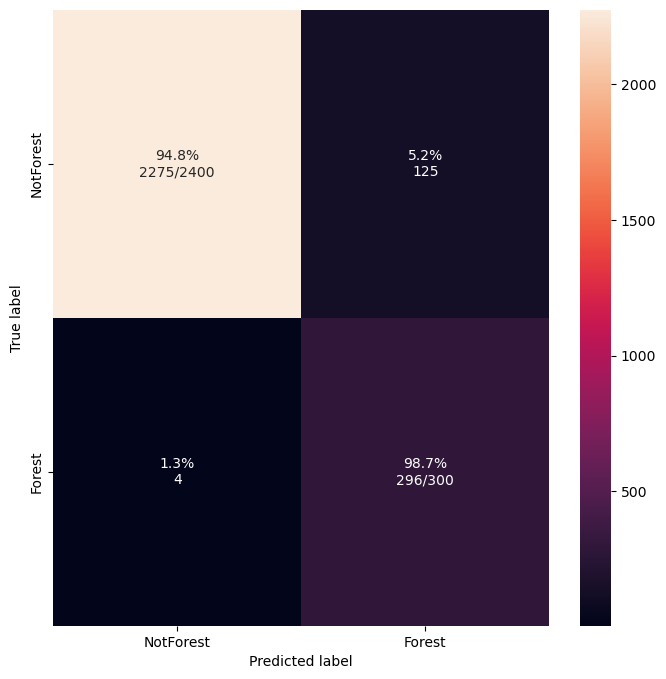

In [15]:
print(f"INFO ===========Plot Curve===============")
ModelUtils.plot_metrics(cfg.Path.loss_acc_save_path, history)
# model.load_model(cfg.Path.model_save_path)

train_results = model.evaluate(train_dataset)
for name, value in zip(model.metrics_names, train_results):
    print(name, ': ', value)
print()

val_results = model.evaluate(val_dataset)
for name, value in zip(model.metrics_names, val_results):
    print(name, ': ', value)
print()

test_results = model.evaluate(test_dataset)
for name, value in zip(model.metrics_names, test_results):
    print(name, ': ', value)
print()

predictions = model.predict(test_dataset)

predicted_label = np.zeros_like(predictions, dtype=np.int8)
predicted_label[predictions >= 0.5] = 1
predicted_label = predicted_label.flatten()

class_names = ["NotForest","Forest"]

true_labels = []
for image, label in test_dataset:
    label = label.numpy()
    true_labels += list(label)

# Plot confusion Matrix
ModelUtils.plot_cm(y_true = true_labels, y_pred = predicted_label, class_names = class_names,save_path=cfg.Path.cm_save_path, figsize=(8,8))

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 2s 2s/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


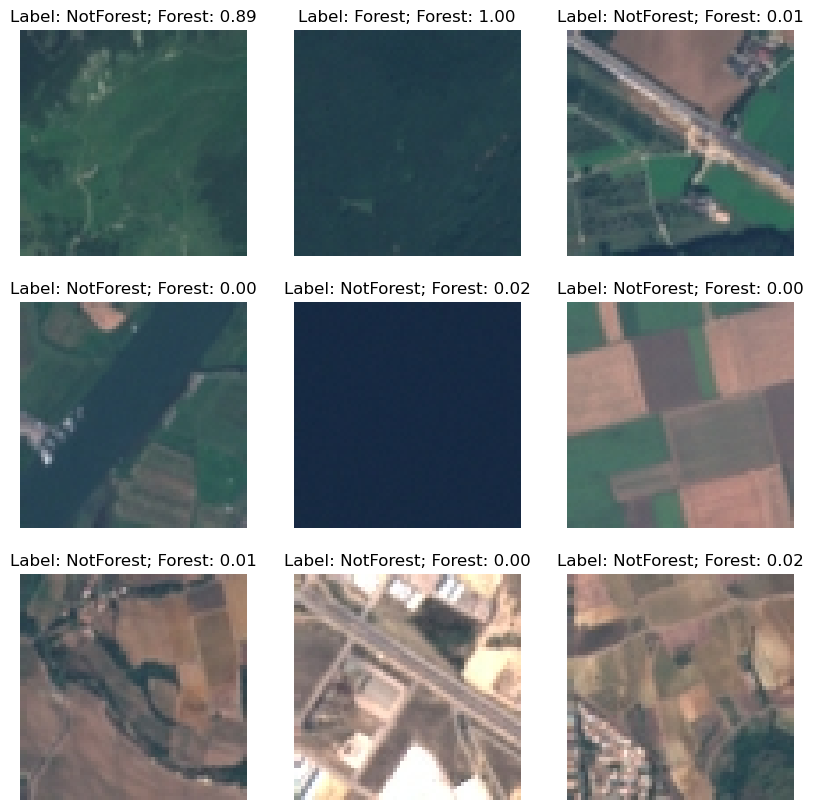

In [16]:
image_batch, label_batch = next(iter(val_dataset))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # print(image_batch[i])
    image_arr = (image_batch[i].numpy() * 255).astype("uint8")
    prediction = model.predict(np.expand_dims(image_batch[i], axis = 0))
    predicted_label = prediction.item()
    plt.imshow(image_arr)
    true_label = label_batch[i]
    plt.title("Label: {}; Forest: {:.2f}".format(class_names[true_label], predicted_label))
    plt.axis("off")

In [17]:
# import shutil
# shutil.rmtree("/kaggle/working/eurosat-dataset")

In [ ]:
!zip -r effnetb2.zip  '/kaggle/working/'

In [ ]:
from IPython.display import FileLink
FileLink(r'effnetb2.zip')